In [1]:
from qiskit.quantum_info import random_statevector
from scipy import sparse
import numpy
import re
from tqdm import tqdm
import scipy
import itertools
from qiskit.quantum_info import Pauli
from qiskit.aqua.operators import WeightedPauliOperator
from qiskit.aqua.operators.legacy import op_converter

The function below computes the inner product between two states $\langle\Psi|\Phi\rangle$.

In [2]:
 #This function computes the Inner Product
def InnerProd(A,B):
    IP=0.0
    for i in range(len(A)):
        for j in range(len(B)):
            if A['keys'][i]==B['keys'][j]:
                IP=IP+numpy.conjugate(A['vals'][i])*B['vals'][j]
#     hashedA = numpy.array([hash(s) for s in A['keys']])
#     hashedB = numpy.array([hash(s) for s in B['keys']])
#     AdjMat=numpy.equal.outer(hashedB, hashedA)
#     SparsedAdjMat=sparse.csr_matrix(AdjMat)
#     IP=numpy.sum(sparse.csr_matrix.dot(sparse.csr_matrix.dot(B['vals'],SparsedAdjMat),A['vals']))
    return IP

__Gram Schmidt Decomposition__<br>
If $|\phi_{0}\rangle,|\phi_{1}\rangle$ are non-orthogonal $\langle\phi_{0}|\phi_{1}\rangle\neq 0$<br>
then we can perform a Gram Schmidt decomposition as follows:<br>
$|\phi_{1,\perp}\rangle=\mathcal{N}^{-1}\left[|\phi_{1}\rangle-|\phi_{0}\rangle\langle\phi_{0}|\phi_{1}\rangle\right]$<br>
and we can check$:~$
$\langle\phi_{0}|\phi_{1,\perp}\rangle=0$

In [3]:
#This function carries out Gram Schmidt Orthonormalization
def GSOrth(PsiOld,PsiNonOrth):
    innerProd=InnerProd(PsiNonOrth,PsiOld)
    if(innerProd==0):
        return PsiNonOrth
    else:
        supCoeff=innerProd
        PsiUnionKeys=numpy.union1d(PsiOld['keys'],PsiNonOrth['keys'])
        PsiCompose=numpy.array([0.0j+numpy.sum(PsiNonOrth['vals'][PsiNonOrth['keys']==config])-supCoeff*numpy.sum(PsiOld['vals'][PsiOld['keys']==config]) for config in PsiUnionKeys],dtype='complex')
        PsiNew=numpy.rec.fromarrays([PsiUnionKeys,PsiCompose],names='keys,vals')
        return PsiNew
    

This function below allows us to decompose the statevector into two subspaces. One of them is composed of two qubits i,j in configurations $|00\rangle$, $|01\rangle$, $|10\rangle$, $|11\rangle$ and other qubits can be in some general configuration:<br>
$|\Psi\rangle=c_{0}|00\rangle|\phi_{0}\rangle+c_{1}|01\rangle|\phi_{1}\rangle+c_{2}|10\rangle|\phi_{2}\rangle+c_{3}|11\rangle|\phi_{3}\rangle$, note in general $\langle\phi_{i}|\phi_{j}\rangle\neq 0$.

In [29]:
def partitionStateVec2QubitsFromRest(Psi,i,j):
    #|\Psi\rangle=c_{0}|00>|\phi_{0}>+c_{1}|01>|\phi_{1}>+c_{2}|10>|\phi_{2}>+c_{3}|11>|\phi_{3}>
    manyBodyKet=numpy.array([numpy.array([conf.split(',')[0],eval(conf.split(',')[1])]) for conf in Psi],dtype='<U64')
    Ket=numpy.rec.fromarrays([manyBodyKet[:,0],manyBodyKet[:,1].astype(complex)],dtype=[('keys','<U64'),('vals','complex')])
    BitConfiGij00=''.join(['0' if((ind==i) or (ind==j)) else '.' for ind in range(num_qubits)])
    BitConfiGij01=''.join(['0' if(ind==i) else '1' if(ind==j) else '.' for ind in range(num_qubits)])
    BitConfiGij10=''.join(['1' if(ind==i) else '0' if(ind==j) else '.' for ind in range(num_qubits)])
    BitConfiGij11=''.join(['1' if((ind==i) or (ind==j)) else '.' for ind in range(num_qubits)])
    print(BitConfiGij00,BitConfiGij01,BitConfiGij10,BitConfiGij11)
    r00 = re.compile(BitConfiGij00)
    r01 = re.compile(BitConfiGij01)
    r10 = re.compile(BitConfiGij10)
    r11 = re.compile(BitConfiGij11)
    OrdInd=(j,i) if i>j else (i,j)
    PsiSubSystem0 = ['00',Ket[numpy.vectorize(lambda x:bool(r00.match(x)))(Ket['keys'])]]
    PsiSubSystem1 = ['01',Ket[numpy.vectorize(lambda x:bool(r01.match(x)))(Ket['keys'])]]
    PsiSubSystem2 = ['10',Ket[numpy.vectorize(lambda x:bool(r10.match(x)))(Ket['keys'])]]
    PsiSubSystem3 = ['11',Ket[numpy.vectorize(lambda x:bool(r11.match(x)))(Ket['keys'])]]
    PsiSubSystemConfs=[]
    for a in range(4):
        if((0 in eval('PsiSubSystem'+str(a))[1].shape)==False):
            tag=eval('PsiSubSystem'+str(a))[0]
            Psi=eval('PsiSubSystem'+str(a))[1]
            for conf in Psi['keys']:
                Psi['keys'][Psi['keys']==conf]=Psi['keys'][Psi['keys']==conf][0][0:OrdInd[0]]+Psi['keys'][Psi['keys']==conf][0][OrdInd[0]+1:OrdInd[1]]+Psi['keys'][Psi['keys']==conf][0][OrdInd[1]+1:num_qubits]
            sqrtIP=numpy.sqrt(InnerProd(Psi,Psi))
            Psi['vals']=(1/sqrtIP)*Psi['vals']
            PsiSubSystemConfs=PsiSubSystemConfs+[[tag,Psi,sqrtIP]]
    #print("old")
    #for psi in PsiSubSystemConfs:
    #    print(psi)
    PsiSubSystemConfsCopy=[PsiSubSystemConfs[0]]
    for i in range(len(PsiSubSystemConfs)-1):
        num=len(PsiSubSystemConfsCopy)
        cond=True
        sign=1
        for j in range(len(PsiSubSystemConfsCopy)):
                IP=InnerProd(PsiSubSystemConfsCopy[j][1],PsiSubSystemConfs[i+1][1])
                if(abs(IP+1)<1e-8):
                    cond=False
                    sign=-1
        if(cond is False):        
            PsiSubSystemConfsCopy=PsiSubSystemConfsCopy+[[PsiSubSystemConfs[i+1][0],PsiSubSystemConfsCopy[j][1],sign*PsiSubSystemConfs[i+1][2]]]
        else:
            PsiSubSystemConfsCopy=PsiSubSystemConfsCopy+[PsiSubSystemConfs[i+1]]                                           
    PsiSubSystemConfs=PsiSubSystemConfsCopy
    #unique two pseudospin configurations
    uniqueTags=numpy.unique([conf[0] for conf in PsiSubSystemConfs])
    #print("new",PsiSubSystemConfs)
    PsiUniqueConfs=[PsiSubSystemConfs[0][1]]
    for i in range(len(PsiSubSystemConfs)):
        cond=True
        for j in range(len(PsiUniqueConfs)):
            if(abs(InnerProd(PsiSubSystemConfs[i][1],PsiUniqueConfs[j])-1)<1e-5):
                cond=False       
        if (cond is True):
            PsiUniqueConfs=PsiUniqueConfs+[PsiSubSystemConfs[i][1]]
    return uniqueTags,PsiUniqueConfs,PsiSubSystemConfs

In the state decomposed above the kets belonging to the subspaces need not be orthognal. This function below allows us to rewrite the statevector as a tensor decomposition between two subspaces A and B for a given partition, in which every ket in both the subspaces is orthogonal to every other ket.<br>
Mathematically we need a representation where,<br>
\begin{align}|\Psi\rangle=\sum_{i,j}D_{ij}|\psi_{A,i}\rangle|\psi_{B,j}\rangle, \langle\psi_{A,j}|\psi_{A,i}\rangle=\delta_{ij}$ and $\langle\psi_{B,j}|\psi_{B,i}\rangle=\delta_{ij}
\end{align}
This leads to a tensor network decomposition of the state.<br>
\begin{align}
|\Psi\rangle&=&\begin{pmatrix} |\psi_{A,1}\rangle & |\psi_{A,2}\rangle & |\psi_{A,3}\rangle & \ldots \end{pmatrix}\begin{pmatrix}D_{11} & D_{12} & D_{13} & \ldots\\
D_{21} & D_{22} & D_{23} &\ldots\\
D_{31} & D_{32} & D_{33} &\ldots\\
\vdots & \vdots& \vdots & \ddots
\end{pmatrix}\begin{pmatrix} |\psi_{A,1}\rangle \\|\psi_{A,2}\rangle \\ |\psi_{A,3}\rangle \\ \vdots
\end{pmatrix}
\end{align}

In [30]:
#Obtaining the D matrix for a given partition of two qubits from the rest
#D=  D_11  D_12  D_13 ...
#    D_21  D_22  D_23 ...
#    D_31  D_32  D_33 ...
#     .     .     .  .
#     .     .     .     .
#     .     .     .       .
def D(uniqueTags,PsiUniqueConfs,PsiSubSystemConfs):
    PsiOrtho=[PsiUniqueConfs[0]]
    for i in range(1,len(PsiUniqueConfs)):
        Psi1=PsiUniqueConfs[i]
        innerProds=[InnerProd(PsiOrtho[j],Psi1) for j in range(len(PsiOrtho))]
        for j in range(len(PsiOrtho)):
            PsiUnionKeys=numpy.union1d(PsiOrtho[j]['keys'],Psi1['keys']) 
            PsiCompose=numpy.array([0.0j+numpy.sum(Psi1['vals'][Psi1['keys']==config])-innerProds[j]*numpy.sum(PsiOrtho[j]['vals'][PsiOrtho[j]['keys']==config]) for config in PsiUnionKeys],dtype='complex')
            Psi1=numpy.rec.fromarrays([PsiUnionKeys,PsiCompose],names='keys,vals')
        if len(numpy.where(numpy.array(Psi1['vals'])==0)[0])==len(Psi1['vals']):
            Psi1=[]
        else:    
            Psi1['vals']=Psi1['vals']/numpy.sqrt(InnerProd(Psi1,Psi1))
            Psi1=Psi1[numpy.abs(Psi1['vals'])>1e-5]
        A=numpy.array([numpy.abs(InnerProd(PsiOrtho[i],Psi1)) for i in range(len(PsiOrtho))]) 
        if len(numpy.where(numpy.abs(A)<1e-7)[0])==len(A) and len(Psi1)!=0:
            PsiOrtho=PsiOrtho+[Psi1]
        else:
            continue      
    boolCond=True
    for i in range(len(PsiOrtho)):
        for j in range(len(PsiOrtho)):
            if(i!=j):
                if(abs(InnerProd(PsiOrtho[i],PsiOrtho[j]))>1e-5):
                    boolCond=False
            else:
                if(abs(InnerProd(PsiOrtho[i],PsiOrtho[j])-1)>1e-5):
                    boolCond=False

#     if(boolCond==True):
#         print("Orthonormal basis formed")
    if(boolCond==False):
        A=[numpy.abs(numpy.abs(InnerProd(PsiOrtho[i],PsiOrtho[j]))-1) for i in range(len(PsiOrtho)) for j in range(len(PsiOrtho)) if i!=j]
        print(A)
        print("1-FAILED")
        return PsiOrtho 
    ###########################################
            #Computing the D matrix
    ############################################
    Dmat=numpy.zeros([len(uniqueTags),len(PsiOrtho)])*1j
    #extracting the tags associated with the two spin configurations 
    #within the members in Psi decomposed into subsystems->PsiSubSystemConfs
    tags=[psi[0] for psi in PsiSubSystemConfs]
    for i in range(len(uniqueTags)):
        for j in range(len(PsiOrtho)):
            ind=numpy.where(numpy.array(tags)==uniqueTags[i])[0]
            Sum=0
            for index in range(len(ind)):
                Sum=Sum+InnerProd(PsiSubSystemConfs[ind[index]][1],PsiOrtho[j])*PsiSubSystemConfs[ind[index]][2]
            Dmat[i][j]=Sum
    #Checking normalization from D matrix
    norm=numpy.dot(Dmat.flatten(),numpy.conjugate(Dmat.flatten()))
#     if(numpy.abs(norm-1)<1e-4):
#         print("D matrix constructed succesfully")
    if(numpy.abs(norm-1)>1e-4):
        print("D matrix construction failed",norm)
        return "2-FAILED",norm
#     else:
#         print("D matrix construction successful\n",D)
    return Dmat     

The function below carries out Schmidt decomposition of the entangled state $|\Psi\rangle$ for the subsystem partition two qubits and all rest.
Mathematically Schmidt decomposition is given by<br>
$|\Psi\rangle=\lambda_{1}|\psi_{1}\rangle|\chi_{1}\rangle+\lambda_{2}|\psi_{2}\rangle|\chi_{2}\rangle$, such that $S=[\lambda_{1},\lambda_{2}]$  are Schmidt coefficients and $\langle\psi_{2}|\psi_{1}\rangle=\langle\chi_{2}|\chi_{1}\rangle=0$<br>
We carry out below the Schmidt Decomposition via singular value decomposition of D matrix <br>
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html<br>
$D=USV^{H}$, here $S$ is the Schmidt vector, U and V are 2d matrices

In [31]:
def SchmidtVector_two_qubit_with_rest(D):
    u,SchmidtVec,v=numpy.linalg.svd(D, full_matrices=True)
    return SchmidtVec

In [32]:
#obtaining SchmidtCoeffs for partitioning qubit i from rest and qubit j from rest
def SchmidtVec_one_qubit_with_rest(D,uniqueTags): 
        #obtaining the 1-pseudospin reduced density matrices from the 2-pseudospin reduced density matrices
        #This leads to the two particle reduced density matrix
        Rho_ij=numpy.dot(D,numpy.conjugate(D.T))
        #configs of pseudospin-1
        confOf1=numpy.asarray([numpy.array([tag[0],tag[1]]) for tag in uniqueTags])
        #building diagonal entries for 1-pseudospin reduced density matrix--ith Spin
        iRho00=0 if 0 in numpy.where((confOf1[:,0]=='0'))[0].shape else sum([Rho_ij[ind][ind] for ind in numpy.where((confOf1[:,0]=='0'))[0]])
        #building offdiagonal entries for 1-pseudospin reduced density matrix
        ind00= numpy.where((uniqueTags=='00'))[0]
        ind01= numpy.where((uniqueTags=='01'))[0]
        ind10= numpy.where((uniqueTags=='10'))[0]
        ind11= numpy.where((uniqueTags=='11'))[0]
        if((0 in ind00.shape) | (0 in ind10.shape)):
            comp1=0
        else:
            comp1=Rho_ij[ind00[0]][ind10[0]]
        if((0 in ind01.shape) | (0 in ind11.shape)):
            comp2=0
        else:
            comp2=Rho_ij[ind01[0]][ind11[0]]
        iRho01=comp1+comp2
        #reduced density Matrix for i Pseudospin
        iRho=numpy.array([numpy.array([iRho00,iRho01]),numpy.array([iRho01,1-iRho00])])

        #building diagonal entries for 1-pseudospin reduced density matrix--jth Spin
        jRho00=0 if 0 in numpy.where((confOf1[:,1]=='0'))[0].shape else sum([Rho_ij[ind][ind] for ind in numpy.where((confOf1[:,1]=='0'))[0]])
        #building offdiagonal entries for 1-pseudospin reduced density matrix
        if((0 in ind00.shape) | (0 in ind01.shape)):
            comp1=0
        else:
            comp1=Rho_ij[ind00[0]][ind01[0]]
        if((0 in ind10.shape) | (0 in ind11.shape)):
            comp2=0
        else:
            comp2=Rho_ij[ind10[0]][ind11[0]]
        jRho01=comp1+comp2
        #reduced density Matrix for j Pseudospin
        jRho=numpy.array([numpy.array([jRho00,jRho01]),numpy.array([jRho01,1-jRho00])])
        #eigenvalues of the 1-particle reduced density matrix -> eigenvalues are the probabilities
        iRhoDiag=numpy.linalg.eigvals(iRho)
        jRhoDiag=numpy.linalg.eigvals(jRho)
        #Probability for ith pseudospin
        p_i=1 if numpy.abs(iRhoDiag[0]-1)<1e-7 else iRhoDiag[0]
        #Probability for jth pseudospin
        p_j=jRhoDiag[0]
        SchmidtCoeffs_i=numpy.array([numpy.sqrt(p_i),numpy.sqrt(1-p_i)])
        SchmidtCoeffs_j=numpy.array([numpy.sqrt(p_j),numpy.sqrt(1-p_j)])
        return SchmidtCoeffs_i,SchmidtCoeffs_j

__Computing Mutual Information for measuring the entangledness between pair of qubits__<br>
$M_{ij}=S_{i}+S_{j}-S_{ij}$ here $S_{i}$ and $S_{j}$ are entanglement entropies associated with isolating qubits i and j respectively from the rest.<br>
$S_{ij}$ is the joint entropy associated with isolating the pair i,j.

In [33]:
#obtain pairwise Mutual Information between 3 pairs of a two qubit state
def get_MutInf(SchmidtCoeffs_ij,SchmidtCoeffs_i,SchmidtCoeffs_j):
        #joint probabilities for ijth pseudospin
        p_ij=SchmidtCoeffs_ij*SchmidtCoeffs_ij
        p_ij[numpy.abs(p_ij-1)<1e-7]=1
        #ith pseudospin entropy
        p_i=SchmidtCoeffs_i[0]*SchmidtCoeffs_i[0]
        S_i=-p_i*numpy.log(p_i)-(1-p_i)*numpy.log(1-p_i) if p_i*(1-p_i)!=0 else 0
        #jth pseudospin entropy
        p_j=SchmidtCoeffs_j[0]*SchmidtCoeffs_j[0]
        S_j=-p_j*numpy.log(p_j)-(1-p_j)*numpy.log(1-p_j) if p_j*(1-p_j)!=0 else 0
        #joint entropic weights
        S_ijArr=-p_ij*numpy.log(p_ij)
        S_ijArr[p_ij*(1-p_ij)==0]=0.0
        S_ij=numpy.sum(S_ijArr)
        #Mutual Information
        MutInf_ij=S_i+S_j-S_ij
        if(MutInf_ij<-1e-5):
            return ['FAIL',MutInf_ij]
        return MutInf_ij

In [34]:
def MutInfMat(Psi):
    MutInf=numpy.zeros((num_qubits,num_qubits))
    for i in tqdm(range(num_qubits)):
        for j in range(i+1,num_qubits):
        #Decompose the state into qubit pair (i,j) and the rest, 
        #uniqueTags stores confs. of qubit pairs and PsiUniqueConfs are confs. associated with the rest.
            uniqueTags,PsiUniqueConfs,PsiSubSystemConfs=partitionStateVec2QubitsFromRest(Psi,i,j)
            #constructing D matrix
            Dmat=D(uniqueTags,PsiUniqueConfs,PsiSubSystemConfs)
            norm=numpy.dot(Dmat.flatten(),numpy.conjugate(Dmat.flatten()))
            #Schmidt vector for the partition qubit pair (i,j) from rest
            Schmidt_part_ij_from_rest=SchmidtVector_two_qubit_with_rest(Dmat)
            #Schmidt vector for the partition of single qubits i from rest and j from rest 
            Schmidt_part_i_from_rest, Schmidt_part_j_from_rest=SchmidtVec_one_qubit_with_rest(Dmat,uniqueTags)
            #Mutual Information between qubits i and j
            MutInf[i][j]=numpy.real(get_MutInf(Schmidt_part_ij_from_rest,Schmidt_part_i_from_rest,Schmidt_part_j_from_rest))
    return MutInf

In [35]:
pool3=['IXY','XIY','XYI','IYX','YIX','YXI','XXY','XYX','YXX','YYY']+['IXX','XIX','YYI','IYY','YIY','YYI','YYX','YXY','XYY','XXX']
pool4=['IIXY','IXIY','XIIY','XYII','XIYI','IXYI','IIYX','IYIX','YIIX','YXII','YIXI','IYXI',
    'XYYY','YXYY','YYXY','YYYX','XXXY','XXYX','XYXX','YXXX']


In [36]:
def UnitaryAnsatz(labels,params):
    Idn='I'*num_qubits
    U=WeightedPauliOperator([[1,Pauli.from_label(Idn)]])
    print("labels",len(labels),len(params))
    for i in range(len(labels)):
        Rot=WeightedPauliOperator([[numpy.cos(params[i]),Pauli.from_label(Idn)],[numpy.sin(params[i])*1j,Pauli.from_label(labels[i])]])
        U=Rot.multiply(U) 
    U_mat=op_converter.to_matrix_operator(U).dense_matrix                               
    return U_mat
    

In [37]:
def MutInfLandscape(labels,params):
    U_mat=UnitaryAnsatz(labels,params)  
    rot_state=numpy.dot(U_mat,state)
    non_zero_entry_indexes=numpy.array([i for i in range(len(rot_state)) if numpy.abs(rot_state[i])>1e-9])
    bit_str=[bin(non_zero_entry_indexes[i])[2:] for i in range(len(non_zero_entry_indexes))]
    bit_str=['0'*(num_qubits-len(conf))+conf for conf in bit_str]
    weights=rot_state[non_zero_entry_indexes]
    Rot_Psi=[bit_str[i]+','+str(weights[i]) for i in range(len(weights))]
    MutInfMatrix=MutInfMat(Rot_Psi)
    return MutInfMatrix      
def MutCost(params):
    print("mutcost",len(labels))
    MutMat=MutInfLandscape(labels,params)
    cost=numpy.sum(MutMat)
    print("MutInf",cost)
    return cost

In [38]:
#Gate counting                                                                          g
def countYgates(pauli_label):
    countYgates = sum(map(lambda x : 1 if 'Y' in x else 0, pauli_label))
    return countYgates
def countZgates(pauli_label):
    countZgates = sum(map(lambda x : 1 if 'Z' in x else 0, pauli_label))
    return countZgates
def countXgates(pauli_label):
    countXgates = sum(map(lambda x : 1 if 'X' in x else 0, pauli_label))
    return countXgates
def countGates(pauli_label):
    return countXgates(pauli_label)+countYgates(pauli_label)+countZgates(pauli_label)
def countCXs(label):
    return 2*(countGates(label)-1)

In [39]:
def cost_grad(thetas,labels,PauliStr):
    print("within grad",len(labels))
    labels.append(PauliStr)
    thetas1=thetas+[0.01]
    thetas2=thetas+[-0.01]
    cost1=MutCost(thetas1)
    cost2=MutCost(thetas2)
    grad_cost=numpy.abs((cost1-cost2)/0.02)
    labels.pop()
    return grad_cost

In [40]:
def Haar(num_qubits):
    #defining a random n qubit Haar random state
    state=random_statevector(2**num_qubits).data
    amplitudes=state
    bit_arr = [list(i) for i in itertools.product([0, 1], repeat=num_qubits)]
    bitStr_arr=[''.join([str(bit_arr[i][j]) for j in range(len(bit_arr[i]))]) for i in range(len(bit_arr))]
    #String rep. for the random state
    Psi=[bitStr_arr[i]+','+str(amplitudes[i]) for i in range(len(amplitudes))]
    return Psi,state

In [41]:
Psi,state=Haar(3)
num_qubits=3

In [42]:
Psi

['000,(-0.2598006644998038+0.008571258526486745j)',
 '001,(0.3240943353382645+0.10393103257982786j)',
 '010,(-0.2892021442715431-0.3662226890266622j)',
 '011,(-0.10448178924852512-0.06615066321322997j)',
 '100,(0.21188525246674253+0.37606652354591424j)',
 '101,(0.08995740279499814+0.021499611889059175j)',
 '110,(0.46730011643657965-0.13845726343481968j)',
 '111,(0.38645607615057637+0.042166199697908406j)']

In [19]:
MutInfMatrix=MutInfMat(Psi)

100%|██████████| 3/3 [00:00<00:00, 50.02it/s]


In [43]:
uniqueTags,PsiUniqueConfs,PsiSubSystemConfs=partitionStateVec2QubitsFromRest(Psi,0,1)
#constructing D matrix
Dmat=D(uniqueTags,PsiUniqueConfs,PsiSubSystemConfs)
norm=numpy.dot(Dmat.flatten(),numpy.conjugate(Dmat.flatten()))
#Schmidt vector for the partition qubit pair (i,j) from rest
Schmidt_part_ij_from_rest=SchmidtVector_two_qubit_with_rest(Dmat)
            

00. 01. 10. 11.


In [27]:
Dmat,norm

(array([[ 3.61291774e-01+0.00000000e+00j,  4.01114446e-17+4.01114446e-17j],
        [-1.72791203e-01-2.90936131e-01j,  5.56549427e-01-1.80784040e-17j],
        [-2.92001539e-01-6.70780813e-02j, -3.74615036e-01-1.15317408e-01j],
        [ 3.18161120e-01+4.54826991e-02j,  1.10092185e-01+2.93948969e-01j]]),
 (0.9999999999999999+0j))

In [18]:
def Mut_Inf_qubit_adapt(state,pool):
    MutCostArr=[]
    CXarr=[]
    thetas=[]
    numCX=0
    error=1000
    max_iters=20
    i=0
    while ((i<20) and (error>1e-5)):
        grads=numpy.array([cost_grad(thetas,labels,pool[i]) for i in tqdm(range(len(pool)))]) #ar.result()
        PauliOp=pool3[numpy.where(grads==max(grads))[0][0]]
        thetas.append(0.0)
        labels.append(PauliOp)
        print("Chosen Operator-",PauliOp)
        print("gradient",max(grads))
        print("num labels",labels)
        print("cost-function before optimization ",MutCost(thetas))
        #thetas=greedy_search(NumSearch,delta,thetas)
        res = scipy.optimize.minimize(MutCost, thetas, method='L-BFGS-B',bounds=[(-numpy.pi,numpy.pi)]*len(thetas))
        thetas=list(res['x'])
        MutCostArr.append(abs(res['fun']))
        error=MutCostArr[-1]
        print("num params-",len(thetas))
        numCX=numCX+int(countCXs(labels[-1]))
        CXarr.append(numCX)  
        print("Optimized cost-",MutCostArr[-1])
        i=i+1
    CXarr=numpy.array(CXarr,dtype='int64')    
    return MutCostArr,CXarr,thetas,labels

In [20]:
runs=10
num_qubits=3
Mut_runs=[]
CX_runs=[]
thetas_runs=[]
labels_runs=[]
for i in range(runs):
    print('run',i+1)
    Psi,state=Haar(num_qubits)
    pool=['IXY','XIY','XYI','IYX','YIX','YXI','XXY','XYX','YXX','YYY']+['IXX','XIX','YYI','IYY','YIY','YYI','YYX','YXY','XYY','XXX']
    labels=[]
    MutCostArr,CXarr,thetas,labels=Mut_Inf_qubit_adapt(state,pool)
    Mut_runs.append(MutCostArr)
    CX_runs.append(CXarr)
    thetas_runs.append(thetas)
    
 

100%|██████████| 3/3 [00:00<00:00, 92.66it/s]

100%|██████████| 3/3 [00:00<00:00, 157.79it/s]

100%|██████████| 3/3 [00:00<00:00, 178.23it/s]

100%|██████████| 3/3 [00:00<00:00, 159.70it/s]

100%|██████████| 3/3 [00:00<00:00, 144.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

run 1
within grad 0
mutcost 1
labels 1 1
MutInf 2.0652980598431228
mutcost 1
labels 1 1
MutInf 2.067052592843612
within grad 0
mutcost 1
labels 1 1
MutInf 2.070046934365345
mutcost 1
labels 1 1
MutInf 2.0623021315284094
within grad 0
mutcost 1
labels 1 1
MutInf 2.0620232634617883
mutcost 1
labels 1 1
MutInf 2.070129681113783
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 125.74it/s]

100%|██████████| 3/3 [00:00<00:00, 114.32it/s]

100%|██████████| 3/3 [00:00<00:00, 125.84it/s]

100%|██████████| 3/3 [00:00<00:00, 115.59it/s]

100%|██████████| 3/3 [00:00<00:00, 136.83it/s]


MutInf 2.0665340308600126
mutcost 1
labels 1 1
MutInf 2.065735524157696
within grad 0
mutcost 1
labels 1 1
MutInf 2.072717450533137
mutcost 1
labels 1 1
MutInf 2.059564339714621
within grad 0
mutcost 1
labels 1 1
MutInf 2.0648275325683283
mutcost 1
labels 1 1
MutInf 2.067350266863629
within grad 0
mutcost 1
labels 1 1
MutInf 2.0665931205070747
mutcost 1
labels 1 1



100%|██████████| 3/3 [00:00<00:00, 129.66it/s]

100%|██████████| 3/3 [00:00<00:00, 164.39it/s]

100%|██████████| 3/3 [00:00<00:00, 125.34it/s]

100%|██████████| 3/3 [00:00<00:00, 145.35it/s]

100%|██████████| 3/3 [00:00<00:00, 149.99it/s]

100%|██████████| 3/3 [00:00<00:00, 143.27it/s]


MutInf 2.065879590664652
within grad 0
mutcost 1
labels 1 1
MutInf 2.0602108275744553
mutcost 1
labels 1 1
MutInf 2.072632858537142
within grad 0
mutcost 1
labels 1 1
MutInf 2.067227657467015
mutcost 1
labels 1 1
MutInf 2.06551630180378
within grad 0
mutcost 1
labels 1 1
MutInf 2.067271858709216
mutcost 1
labels 1 1
MutInf 2.065051562265901
within grad 0
mutcost 1
labels 1 1
MutInf 2.075996910985197
mutcost 1
labels 1 1



100%|██████████| 3/3 [00:00<00:00, 127.04it/s]

100%|██████████| 3/3 [00:00<00:00, 185.70it/s]

100%|██████████| 3/3 [00:00<00:00, 154.59it/s]

100%|██████████| 3/3 [00:00<00:00, 114.85it/s]

100%|██████████| 3/3 [00:00<00:00, 124.59it/s]

 70%|███████   | 14/20 [00:00<00:00, 16.06it/s]


MutInf 2.056566735910074
within grad 0
mutcost 1
labels 1 1
MutInf 2.076072099277327
mutcost 1
labels 1 1
MutInf 2.056508967789785
within grad 0
mutcost 1
labels 1 1
MutInf 2.064876273274823
mutcost 1
labels 1 1
MutInf 2.06746914934435
within grad 0
mutcost 1
labels 1 1
MutInf 2.0693888601709767
mutcost 1
labels 1 1
MutInf 2.0628418162464226
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 83.05it/s]

100%|██████████| 3/3 [00:00<00:00, 73.51it/s]

100%|██████████| 3/3 [00:00<00:00, 66.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0709757546575056
mutcost 1
labels 1 1
MutInf 2.06126290058956
within grad 0
mutcost 1
labels 1 1
MutInf 2.064876273274823
mutcost 1
labels 1 1
MutInf 2.06746914934435
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 89.72it/s]

100%|██████████| 3/3 [00:00<00:00, 144.21it/s]

100%|██████████| 3/3 [00:00<00:00, 104.54it/s]

100%|██████████| 3/3 [00:00<00:00, 121.99it/s]

100%|██████████| 3/3 [00:00<00:00, 152.17it/s]

100%|██████████| 3/3 [00:00<00:00, 128.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0656109723002944
mutcost 1
labels 1 1
MutInf 2.0663566242033378
within grad 0
mutcost 1
labels 1 1
MutInf 2.06544955417855
mutcost 1
labels 1 1
MutInf 2.0666687234751584
within grad 0
mutcost 1
labels 1 1
MutInf 2.0647830629018804
mutcost 1
labels 1 1
MutInf 2.067366906660198
within grad 0
mutcost 1
labels 1 1
MutInf 2.0571828550086293
mutcost 1
labels 1 1


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0751209405982047
Chosen Operator- XIX
gradient 0.9781565743770981
num labels ['XIX']
mutcost 1
labels 1 1
MutInf 2.066172353127819
cost-function before optimization  2.066172353127819
mutcost 1
labels 1 1
MutInf 2.066172353127819
mutcost 1
labels 1 1
MutInf 2.0661723629119235
mutcost 1
labels 1 1
MutInf 2.512884518556999
mutcost 1
labels 1 1
MutInf 2.51288451615019
mutcost 1
labels 1 1
MutInf 1.9408030569882186
mutcost 1
labels 1 1
MutInf 1.940803060308344
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 176.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.929888491073305
mutcost 1
labels 1 1
MutInf 1.929888490040227
mutcost 1
labels 1 1
MutInf 1.9287607144897223
mutcost 1
labels 1 1
MutInf 1.9287607145081278
mutcost 1
labels 1 1
MutInf 1.9287603560125315
mutcost 1
labels 1 1
MutInf 1.9287603560125504
num params- 1
Optimized cost- 1.9287603560125315
within grad 1
mutcost 2
labels 2 2
MutInf 1.9268085771456258
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 121.22it/s]

100%|██████████| 3/3 [00:00<00:00, 148.55it/s]

100%|██████████| 3/3 [00:00<00:00, 148.63it/s]

100%|██████████| 3/3 [00:00<00:00, 177.16it/s]

100%|██████████| 3/3 [00:00<00:00, 135.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9307707759537562
within grad 1
mutcost 2
labels 2 2
MutInf 1.9300293074382568
mutcost 2
labels 2 2
MutInf 1.9274751094802545
within grad 1
mutcost 2
labels 2 2
MutInf 1.9238070874999065
mutcost 2
labels 2 2
MutInf 1.9335405517353923
within grad 1
mutcost 2
labels 2 2
MutInf 1.9305912599654018
mutcost 2
labels 2 2
MutInf 1.9269675081226751
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 122.67it/s]

100%|██████████| 3/3 [00:00<00:00, 183.67it/s]

100%|██████████| 3/3 [00:00<00:00, 170.84it/s]

100%|██████████| 3/3 [00:00<00:00, 144.98it/s]

100%|██████████| 3/3 [00:00<00:00, 160.66it/s]

100%|██████████| 3/3 [00:00<00:00, 160.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9312921183453888
mutcost 2
labels 2 2
MutInf 1.9262673932200252
within grad 1
mutcost 2
labels 2 2
MutInf 1.9256581172090441
mutcost 2
labels 2 2
MutInf 1.9317126496792418
within grad 1
mutcost 2
labels 2 2
MutInf 1.9301410492571571
mutcost 2
labels 2 2
MutInf 1.9274479624840057
within grad 1
mutcost 2
labels 2 2
MutInf 1.9286312613524073
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 131.04it/s]

100%|██████████| 3/3 [00:00<00:00, 79.70it/s]

100%|██████████| 3/3 [00:00<00:00, 70.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9294936048890854
within grad 1
mutcost 2
labels 2 2
MutInf 1.9304856609057062
mutcost 2
labels 2 2
MutInf 1.9274158046403258
within grad 1
mutcost 2
labels 2 2
MutInf 1.9296637709797397
mutcost 2
labels 2 2
MutInf 1.927862162570559
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 100.41it/s]

100%|██████████| 3/3 [00:00<00:00, 106.69it/s]

100%|██████████| 3/3 [00:00<00:00, 123.29it/s]

100%|██████████| 3/3 [00:00<00:00, 163.18it/s]

100%|██████████| 3/3 [00:00<00:00, 121.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9280887181824036
mutcost 2
labels 2 2
MutInf 1.9298256415962987
within grad 1
mutcost 2
labels 2 2
MutInf 1.928996397520393
mutcost 2
labels 2 2
MutInf 1.9289967043894936
within grad 1
mutcost 2
labels 2 2
MutInf 1.9296115183540077
mutcost 2
labels 2 2
MutInf 1.9279393741346222
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 110.09it/s]

100%|██████████| 3/3 [00:00<00:00, 181.28it/s]

100%|██████████| 3/3 [00:00<00:00, 142.11it/s]

100%|██████████| 3/3 [00:00<00:00, 143.29it/s]

100%|██████████| 3/3 [00:00<00:00, 111.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9330111112473716
mutcost 2
labels 2 2
MutInf 1.924412590903985
within grad 1
mutcost 2
labels 2 2
MutInf 1.934702789435791
mutcost 2
labels 2 2
MutInf 1.9227512512184977
within grad 1
mutcost 2
labels 2 2
MutInf 1.9296115183540077
mutcost 2
labels 2 2
MutInf 1.9279393741346222
within grad 1
mutcost 2
labels 2 2
MutInf 1.919856077509531
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 81.45it/s]

100%|██████████| 3/3 [00:00<00:00, 89.19it/s]

100%|██████████| 3/3 [00:00<00:00, 119.78it/s]

100%|██████████| 3/3 [00:00<00:00, 101.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.937362828652892
within grad 1
mutcost 2
labels 2 2
MutInf 1.9271118976406063
mutcost 2
labels 2 2
MutInf 1.9301661362354707
within grad 1
mutcost 2
labels 2 2
MutInf 1.9286230139829568
mutcost 2
labels 2 2
MutInf 1.928758643846256
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 124.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9246392010819502
mutcost 2
labels 2 2
MutInf 1.9330565245080042
Chosen Operator- YYX
gradient 0.8753375571680544
num labels ['XIX', 'YYX']
mutcost 2
labels 2 2
MutInf 1.9287603560125315
cost-function before optimization  1.9287603560125315
mutcost 2
labels 2 2
MutInf 1.9287603560125315
mutcost 2
labels 2 2
MutInf 1.9287603560125504
mutcost 2
labels 2 2
MutInf 1.9287603472571204
mutcost 2
labels 2 2
MutInf 1.6607041634376576
mutcost 2
labels 2 2
MutInf 1.660704156720263
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6607041746338358
mutcost 2
labels 2 2
MutInf 1.5208875348972675
mutcost 2
labels 2 2
MutInf 1.5208875412723217
mutcost 2
labels 2 2
MutInf 1.5208875269016022
mutcost 2
labels 2 2
MutInf 1.4505850084911054
mutcost 2
labels 2 2
MutInf 1.4505850108557357
mutcost 2
labels 2 2
MutInf 1.4505850100588886
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4334107857586358
mutcost 2
labels 2 2
MutInf 1.4334107849679274
mutcost 2
labels 2 2
MutInf 1.433410786592583
mutcost 2
labels 2 2
MutInf 1.4412148798535012
mutcost 2
labels 2 2
MutInf 1.4412148811781527
mutcost 2
labels 2 2
MutInf 1.4412148766781532
mutcost 2
labels 2 2
MutInf 1.4326263891617486
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4326263888739268
mutcost 2
labels 2 2
MutInf 1.4326263890490896
mutcost 2
labels 2 2
MutInf 1.4324782928678312
mutcost 2
labels 2 2
MutInf 1.432478292941695
mutcost 2
labels 2 2
MutInf 1.43247829288766
mutcost 2
labels 2 2
MutInf 1.4324688444432994
mutcost 2
labels 2 2
MutInf 1.4324688444431506
mutcost 2
labels 2 2
MutInf 1.432468844444938
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 165.18it/s]

100%|██████████| 3/3 [00:00<00:00, 124.20it/s]

100%|██████████| 3/3 [00:00<00:00, 135.25it/s]

 10%|█         | 2/20 [00:00<00:01, 14.13it/s]

MutInf 1.432468841978382
mutcost 2
labels 2 2
MutInf 1.4324688419783707
mutcost 2
labels 2 2
MutInf 1.4324688419783937
num params- 2
Optimized cost- 1.432468841978382
within grad 2
mutcost 3
labels 3 3
MutInf 1.4228433517549401
mutcost 3
labels 3 3
MutInf 1.4423844095293148
within grad 2
mutcost 3
labels 3 3
MutInf 1.4338129269376902
mutcost 3
labels 3 3
MutInf 1.4315291517877502



100%|██████████| 3/3 [00:00<00:00, 111.63it/s]

100%|██████████| 3/3 [00:00<00:00, 138.43it/s]

100%|██████████| 3/3 [00:00<00:00, 166.94it/s]

100%|██████████| 3/3 [00:00<00:00, 143.36it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

within grad 2
mutcost 3
labels 3 3
MutInf 1.4358091493654284
mutcost 3
labels 3 3
MutInf 1.4296235314214663
within grad 2
mutcost 3
labels 3 3
MutInf 1.4259262227479124
mutcost 3
labels 3 3
MutInf 1.4392002638561034
within grad 2
mutcost 3
labels 3 3
MutInf 1.4415604798548771
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 103.78it/s]

100%|██████████| 3/3 [00:00<00:00, 142.03it/s]

100%|██████████| 3/3 [00:00<00:00, 127.15it/s]

100%|██████████| 3/3 [00:00<00:00, 104.46it/s]

100%|██████████| 3/3 [00:00<00:00, 129.28it/s]



MutInf 1.4235662717943942
within grad 2
mutcost 3
labels 3 3
MutInf 1.4334742119741812
mutcost 3
labels 3 3
MutInf 1.431585089804471
within grad 2
mutcost 3
labels 3 3
MutInf 1.4380874117072295
mutcost 3
labels 3 3
MutInf 1.4271434981840594
within grad 2
mutcost 3
labels 3 3
MutInf 1.437716814698327
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 126.21it/s]

100%|██████████| 3/3 [00:00<00:00, 87.11it/s]

100%|██████████| 3/3 [00:00<00:00, 95.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4274671202003284
within grad 2
mutcost 3
labels 3 3
MutInf 1.422347115014218
mutcost 3
labels 3 3
MutInf 1.4428195764270715
within grad 2
mutcost 3
labels 3 3
MutInf 1.4351654675333803
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 120.66it/s]

100%|██████████| 3/3 [00:00<00:00, 103.50it/s]

100%|██████████| 3/3 [00:00<00:00, 117.90it/s]

100%|██████████| 3/3 [00:00<00:00, 169.02it/s]


MutInf 1.4303212105005194
within grad 2
mutcost 3
labels 3 3
MutInf 1.442070529851902
mutcost 3
labels 3 3
MutInf 1.4233101327490552
within grad 2
mutcost 3
labels 3 3
MutInf 1.4486819005567126
mutcost 3
labels 3 3
MutInf 1.417084312459636
within grad 2
mutcost 3
labels 3 3
MutInf 1.4449635037128328
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 123.63it/s]

100%|██████████| 3/3 [00:00<00:00, 135.34it/s]

100%|██████████| 3/3 [00:00<00:00, 133.32it/s]

100%|██████████| 3/3 [00:00<00:00, 100.62it/s]

100%|██████████| 3/3 [00:00<00:00, 154.87it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4201870412262432
within grad 2
mutcost 3
labels 3 3
MutInf 1.443451129195143
mutcost 3
labels 3 3
MutInf 1.4217018993996837
within grad 2
mutcost 3
labels 3 3
MutInf 1.439397971876677
mutcost 3
labels 3 3
MutInf 1.4258644105573748
within grad 2
mutcost 3
labels 3 3
MutInf 1.4449635037128328
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 109.32it/s]

100%|██████████| 3/3 [00:00<00:00, 48.34it/s]

100%|██████████| 3/3 [00:00<00:00, 115.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4201870412262432
within grad 2
mutcost 3
labels 3 3
MutInf 1.4327699834557859
mutcost 3
labels 3 3
MutInf 1.4327703947081627
within grad 2
mutcost 3
labels 3 3
MutInf 1.4241484273876894
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 114.55it/s]

100%|██████████| 3/3 [00:00<00:00, 87.99it/s]

100%|██████████| 3/3 [00:00<00:00, 73.94it/s]

100%|██████████| 20/20 [00:01<00:00, 11.96it/s]


MutInf 1.44118070866717
within grad 2
mutcost 3
labels 3 3
MutInf 1.420135928627701
mutcost 3
labels 3 3
MutInf 1.4450614424941264
within grad 2
mutcost 3
labels 3 3
MutInf 1.4173960080077126
mutcost 3
labels 3 3
MutInf 1.4488119710792837
Chosen Operator- XIX
gradient 1.5798794048538345
num labels ['XIX', 'YYX', 'XIX']


100%|██████████| 3/3 [00:00<00:00, 99.12it/s]


mutcost 3
labels 3 3
MutInf 1.432468841978382
cost-function before optimization  1.432468841978382
mutcost 3
labels 3 3
MutInf 1.432468841978382
mutcost 3
labels 3 3
MutInf 1.4324688419783707
mutcost 3
labels 3 3
MutInf 1.4324688419783937
mutcost 3
labels 3 3
MutInf 1.432468857783257
mutcost 3
labels 3 3
MutInf 1.4175466703091475
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 112.52it/s]


MutInf 1.417546669928995
mutcost 3
labels 3 3
MutInf 1.4175466700141426
mutcost 3
labels 3 3
MutInf 1.417546685294024
mutcost 3
labels 3 3
MutInf 1.8797860931650487
mutcost 3
labels 3 3
MutInf 1.8797860908676993
mutcost 3
labels 3 3
MutInf 1.8797861060860874
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.879786096406621
mutcost 3
labels 3 3
MutInf 1.4230269629797128
mutcost 3
labels 3 3
MutInf 1.4230269592964953
mutcost 3
labels 3 3
MutInf 1.4230269653640581
mutcost 3
labels 3 3
MutInf 1.4230269417663628
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 113.11it/s]


MutInf 1.2333784188721078
mutcost 3
labels 3 3
MutInf 1.233378415291373
mutcost 3
labels 3 3
MutInf 1.2333784177372404
mutcost 3
labels 3 3
MutInf 1.2333784170902633
mutcost 3
labels 3 3
MutInf 2.460153552935966
mutcost 3
labels 3 3
MutInf 2.460153559149631
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.460153555072129
mutcost 3
labels 3 3
MutInf 2.4601535621500754
mutcost 3
labels 3 3
MutInf 1.7180270809212963
mutcost 3
labels 3 3
MutInf 1.718027085941837
mutcost 3
labels 3 3
MutInf 1.7180270910589188
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 76.63it/s]

MutInf 1.718027071434073
mutcost 3
labels 3 3
MutInf 1.2209244105778976
mutcost 3
labels 3 3
MutInf 1.2209244089620745
mutcost 3
labels 3 3
MutInf 1.2209244110432766
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 108.50it/s]

MutInf 1.2209244091164628
mutcost 3
labels 3 3
MutInf 1.2191327409534187
mutcost 3
labels 3 3
MutInf 1.2191327416478452
mutcost 3
labels 3 3
MutInf 1.2191327403144956
mutcost 3
labels 3 3
MutInf 1.2191327416104203
mutcost 3
labels 3 3



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2184458752923026
mutcost 3
labels 3 3
MutInf 1.2184458752743847
mutcost 3
labels 3 3
MutInf 1.2184458752666936
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2184458752236131
mutcost 3
labels 3 3
MutInf 1.2184435814921746
mutcost 3
labels 3 3
MutInf 1.2184435814866144
mutcost 3
labels 3 3
MutInf 1.2184435814879235
mutcost 3
labels 3 3
MutInf 1.2184435814927774
mutcost 3
labels 3 3
MutInf 1.218443519089855
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.218443519090656
mutcost 3
labels 3 3
MutInf 1.2184435190900151
mutcost 3
labels 3 3
MutInf 1.2184435190897014
mutcost 3
labels 3 3
MutInf 1.2184435182570927
mutcost 3
labels 3 3
MutInf 1.2184435182570879
mutcost 3
labels 3 3
MutInf 1.2184435182570947
mutcost 3
labels 3 3
MutInf 1.2184435182570974
num params- 3
Optimized cost- 1.2184435182570927
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 137.82it/s]

100%|██████████| 3/3 [00:00<00:00, 152.60it/s]

100%|██████████| 3/3 [00:00<00:00, 99.70it/s]

100%|██████████| 3/3 [00:00<00:00, 122.94it/s]

100%|██████████| 3/3 [00:00<00:00, 132.52it/s]


MutInf 1.227110422518707
mutcost 4
labels 4 4
MutInf 1.2098772877656732
within grad 3
mutcost 4
labels 4 4
MutInf 1.2222271112239342
mutcost 4
labels 4 4
MutInf 1.2150189967077778
within grad 3
mutcost 4
labels 4 4
MutInf 1.2112372246808734
mutcost 4
labels 4 4
MutInf 1.2262767213555497
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 97.30it/s]

100%|██████████| 3/3 [00:00<00:00, 113.62it/s]

100%|██████████| 3/3 [00:00<00:00, 105.04it/s]

100%|██████████| 3/3 [00:00<00:00, 139.08it/s]

 30%|███       | 6/20 [00:00<00:01, 13.15it/s]

MutInf 1.2085907582964726
mutcost 4
labels 4 4
MutInf 1.2286443155396711
within grad 3
mutcost 4
labels 4 4
MutInf 1.209692212246332
mutcost 4
labels 4 4
MutInf 1.227605428651219
within grad 3
mutcost 4
labels 4 4
MutInf 1.2222109515518371
mutcost 4
labels 4 4
MutInf 1.214940348395749
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 134.33it/s]

100%|██████████| 3/3 [00:00<00:00, 151.75it/s]

100%|██████████| 3/3 [00:00<00:00, 159.69it/s]

100%|██████████| 3/3 [00:00<00:00, 120.42it/s]

100%|██████████| 3/3 [00:00<00:00, 115.29it/s]



MutInf 1.2093471520663333
mutcost 4
labels 4 4
MutInf 1.2277386032789388
within grad 3
mutcost 4
labels 4 4
MutInf 1.2255452162255787
mutcost 4
labels 4 4
MutInf 1.2117551735489887
within grad 3
mutcost 4
labels 4 4
MutInf 1.2331179315776364
mutcost 4
labels 4 4
MutInf 1.2042363161284153
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 112.32it/s]

100%|██████████| 3/3 [00:00<00:00, 128.68it/s]

100%|██████████| 3/3 [00:00<00:00, 158.27it/s]

100%|██████████| 3/3 [00:00<00:00, 124.61it/s]

 60%|██████    | 12/20 [00:00<00:00, 13.09it/s]

MutInf 1.223193180628289
mutcost 4
labels 4 4
MutInf 1.214428732202842
within grad 3
mutcost 4
labels 4 4
MutInf 1.2200451737982028
mutcost 4
labels 4 4
MutInf 1.2176835141173687
within grad 3
mutcost 4
labels 4 4
MutInf 1.219113009943467
mutcost 4
labels 4 4
MutInf 1.2191155827003382
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 154.33it/s]

100%|██████████| 3/3 [00:00<00:00, 155.24it/s]

100%|██████████| 3/3 [00:00<00:00, 109.34it/s]

100%|██████████| 3/3 [00:00<00:00, 130.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2040500881378
mutcost 4
labels 4 4
MutInf 1.2331409185784488
within grad 3
mutcost 4
labels 4 4
MutInf 1.2059083177171261
mutcost 4
labels 4 4
MutInf 1.2313341965912195
within grad 3
mutcost 4
labels 4 4
MutInf 1.2298347812110961
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 126.82it/s]

100%|██████████| 3/3 [00:00<00:00, 82.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2074810550084947
within grad 3
mutcost 4
labels 4 4
MutInf 1.2040500881378
mutcost 4
labels 4 4
MutInf 1.2331409185784488
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 56.97it/s]

100%|██████████| 3/3 [00:00<00:00, 63.34it/s]

100%|██████████| 3/3 [00:00<00:00, 68.91it/s]

 90%|█████████ | 18/20 [00:01<00:00,  9.31it/s]

MutInf 1.2187747285671635
mutcost 4
labels 4 4
MutInf 1.2187750075488726
within grad 3
mutcost 4
labels 4 4
MutInf 1.2074677282969497
mutcost 4
labels 4 4
MutInf 1.2298466792033989



100%|██████████| 3/3 [00:00<00:00, 94.15it/s]

100%|██████████| 3/3 [00:00<00:00, 136.80it/s]

100%|██████████| 3/3 [00:00<00:00, 131.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

within grad 3
mutcost 4
labels 4 4
MutInf 1.2328763999935757
mutcost 4
labels 4 4
MutInf 1.2044164408526394
within grad 3
mutcost 4
labels 4 4
MutInf 1.2175675510987172
mutcost 4
labels 4 4
MutInf 1.2209114942406094
Chosen Operator- YYI
gradient 1.4545415220324376
num labels ['XIX', 'YYX', 'XIX', 'YYI']
mutcost 4
labels 4 4
MutInf 1.2184435182570927
cost-function before optimization  1.2184435182570927
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 69.13it/s]


MutInf 1.2184435182570927
mutcost 4
labels 4 4
MutInf 1.2184435182570879
mutcost 4
labels 4 4
MutInf 1.2184435182570947
mutcost 4
labels 4 4
MutInf 1.2184435182570974
mutcost 4
labels 4 4
MutInf 1.2184435037066352
mutcost 4
labels 4 4
MutInf 1.3995007621105016
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 105.30it/s]


MutInf 1.3995007624546627
mutcost 4
labels 4 4
MutInf 1.3995007630408534
mutcost 4
labels 4 4
MutInf 1.3995007641094905
mutcost 4
labels 4 4
MutInf 1.3995007460265474
mutcost 4
labels 4 4
MutInf 1.0146463526364728
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.014646352406571
mutcost 4
labels 4 4
MutInf 1.0146463496853166
mutcost 4
labels 4 4
MutInf 1.0146463468614566
mutcost 4
labels 4 4
MutInf 1.0146463532851175
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0069683148783217
mutcost 4
labels 4 4
MutInf 1.006968316100071
mutcost 4
labels 4 4
MutInf 1.0069683134970753
mutcost 4
labels 4 4
MutInf 1.0069683206066902
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 85.87it/s]


MutInf 1.0069683164664665
mutcost 4
labels 4 4
MutInf 0.994415623588472
mutcost 4
labels 4 4
MutInf 0.994415623491123
mutcost 4
labels 4 4
MutInf 0.9944156229207377
mutcost 4
labels 4 4
MutInf 0.9944156238680508
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9944156231535511
mutcost 4
labels 4 4
MutInf 0.9939049401262439
mutcost 4
labels 4 4
MutInf 0.9939049398672677
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9939049397613285
mutcost 4
labels 4 4
MutInf 0.9939049401486877
mutcost 4
labels 4 4
MutInf 0.9939049401330002
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9936500355867885
mutcost 4
labels 4 4
MutInf 0.9936500354098474
mutcost 4
labels 4 4
MutInf 0.9936500355624633
mutcost 4
labels 4 4
MutInf 0.993650035623262
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9936500356209129
mutcost 4
labels 4 4
MutInf 0.9936191191073684
mutcost 4
labels 4 4
MutInf 0.9936191191835172
mutcost 4
labels 4 4
MutInf 0.9936191190437906
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9936191190568208
mutcost 4
labels 4 4
MutInf 0.9936191191710815
mutcost 4
labels 4 4
MutInf 0.9936097079312719
mutcost 4
labels 4 4
MutInf 0.9936097079307853
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 126.57it/s]


MutInf 0.9936097079447788
mutcost 4
labels 4 4
MutInf 0.9936097079406774
mutcost 4
labels 4 4
MutInf 0.9936097079187287
mutcost 4
labels 4 4
MutInf 0.9936094606677968
mutcost 4
labels 4 4
MutInf 0.9936094606673358
mutcost 4
labels 4 4
MutInf 0.9936094606675863
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9936094606674941
mutcost 4
labels 4 4
MutInf 0.9936094606681749
mutcost 4
labels 4 4
MutInf 0.9936094602780474
mutcost 4
labels 4 4
MutInf 0.9936094602780524
mutcost 4
labels 4 4
MutInf 0.9936094602780559
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 147.35it/s]

100%|██████████| 3/3 [00:00<00:00, 133.92it/s]

100%|██████████| 3/3 [00:00<00:00, 129.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9936094602780386
mutcost 4
labels 4 4
MutInf 0.9936094602780561
num params- 4
Optimized cost- 0.9936094602780474
within grad 4
mutcost 5
labels 5 5
MutInf 1.0065941003197656
mutcost 5
labels 5 5
MutInf 0.9807819140317804
within grad 4
mutcost 5
labels 5 5
MutInf 0.9981129118869125
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 113.15it/s]

100%|██████████| 3/3 [00:00<00:00, 161.42it/s]

100%|██████████| 3/3 [00:00<00:00, 120.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9893265117066947
within grad 4
mutcost 5
labels 5 5
MutInf 0.9910707492210248
mutcost 5
labels 5 5
MutInf 0.9962014064208522
within grad 4
mutcost 5
labels 5 5
MutInf 0.9813075662785555
mutcost 5
labels 5 5
MutInf 1.006252625910591
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 118.78it/s]

100%|██████████| 3/3 [00:00<00:00, 128.51it/s]

100%|██████████| 3/3 [00:00<00:00, 101.51it/s]

100%|██████████| 3/3 [00:00<00:00, 128.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9882746993809823
mutcost 5
labels 5 5
MutInf 0.9995988426591231
within grad 4
mutcost 5
labels 5 5
MutInf 0.9930100855883164
mutcost 5
labels 5 5
MutInf 0.9943991101686362
within grad 4
mutcost 5
labels 5 5
MutInf 0.9786061128246918
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 101.26it/s]

100%|██████████| 3/3 [00:00<00:00, 120.13it/s]

100%|██████████| 3/3 [00:00<00:00, 107.00it/s]

100%|██████████| 3/3 [00:00<00:00, 145.88it/s]

MutInf 1.0088464585186845
within grad 4
mutcost 5
labels 5 5
MutInf 1.0034064334874173
mutcost 5
labels 5 5
MutInf 0.984175578498149
within grad 4
mutcost 5
labels 5 5
MutInf 1.001196682573462
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 122.31it/s]

100%|██████████| 3/3 [00:00<00:00, 83.68it/s]

100%|██████████| 3/3 [00:00<00:00, 145.09it/s]

 55%|█████▌    | 11/20 [00:01<00:00, 10.48it/s]

MutInf 0.9866367491659911
within grad 4
mutcost 5
labels 5 5
MutInf 0.9935982824790117
mutcost 5
labels 5 5
MutInf 0.994535446578851
within grad 4
mutcost 5
labels 5 5
MutInf 1.0052838594959874
mutcost 5
labels 5 5
MutInf 0.9832980471626765
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 114.81it/s]

100%|██████████| 3/3 [00:00<00:00, 115.39it/s]

100%|██████████| 3/3 [00:00<00:00, 147.59it/s]

100%|██████████| 3/3 [00:00<00:00, 105.48it/s]



MutInf 1.000679493249627
mutcost 5
labels 5 5
MutInf 0.987624427608267
within grad 4
mutcost 5
labels 5 5
MutInf 0.9939600240588526
mutcost 5
labels 5 5
MutInf 0.9939634606915224
within grad 4
mutcost 5
labels 5 5
MutInf 0.9784818538422602
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 74.72it/s]

100%|██████████| 3/3 [00:00<00:00, 59.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0091097232552935
within grad 4
mutcost 5
labels 5 5
MutInf 1.0024862446221765
mutcost 5
labels 5 5
MutInf 0.9854467386796225
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 84.88it/s]

100%|██████████| 3/3 [00:00<00:00, 121.95it/s]

100%|██████████| 3/3 [00:00<00:00, 102.15it/s]

100%|██████████| 3/3 [00:00<00:00, 119.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9939600240588526
mutcost 5
labels 5 5
MutInf 0.9939634606915224
within grad 4
mutcost 5
labels 5 5
MutInf 0.9940080624017159
mutcost 5
labels 5 5
MutInf 0.9940092025330878
within grad 4
mutcost 5
labels 5 5
MutInf 0.9872713916605251
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 112.08it/s]

100%|██████████| 3/3 [00:00<00:00, 132.36it/s]

100%|██████████| 3/3 [00:00<00:00, 151.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0006945548171844
within grad 4
mutcost 5
labels 5 5
MutInf 1.009685180876497
mutcost 5
labels 5 5
MutInf 0.9779073650914736
within grad 4
mutcost 5
labels 5 5
MutInf 0.9891340909084423
mutcost 5
labels 5 5
MutInf 0.9995915927986373
Chosen Operator- XYY
gradient 1.5888907892511739
num labels ['XIX', 'YYX', 'XIX', 'YYI', 'XYY']
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9936094602780474
cost-function before optimization  0.9936094602780474
mutcost 5
labels 5 5
MutInf 0.9936094602780474
mutcost 5
labels 5 5
MutInf 0.9936094602780524
mutcost 5
labels 5 5
MutInf 0.9936094602780559
mutcost 5
labels 5 5
MutInf 0.9936094602780386
mutcost 5
labels 5 5
MutInf 0.9936094602780561
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9936094761724452
mutcost 5
labels 5 5
MutInf 0.9646614687150176
mutcost 5
labels 5 5
MutInf 0.96466146878135
mutcost 5
labels 5 5
MutInf 0.9646614691520061
mutcost 5
labels 5 5
MutInf 0.964661469292424
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 95.60it/s]


MutInf 0.9646614686995958
mutcost 5
labels 5 5
MutInf 0.9646614838562568
mutcost 5
labels 5 5
MutInf 2.337840361133409
mutcost 5
labels 5 5
MutInf 2.337840369259815
mutcost 5
labels 5 5
MutInf 2.3378403661749365
mutcost 5
labels 5 5
MutInf 2.3378403681992053
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 135.94it/s]


MutInf 2.337840360296128
mutcost 5
labels 5 5
MutInf 2.3378403559867174
mutcost 5
labels 5 5
MutInf 0.7895874207953895
mutcost 5
labels 5 5
MutInf 0.7895874197201966
mutcost 5
labels 5 5
MutInf 0.789587418313378
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 119.98it/s]


MutInf 0.7895874075770383
mutcost 5
labels 5 5
MutInf 0.7895874203027515
mutcost 5
labels 5 5
MutInf 0.7895874251848443
mutcost 5
labels 5 5
MutInf 2.1564906730481623
mutcost 5
labels 5 5
MutInf 2.1564906612126507
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 95.25it/s]


MutInf 2.15649066984727
mutcost 5
labels 5 5
MutInf 2.1564906612126507
mutcost 5
labels 5 5
MutInf 2.1564906759356868
mutcost 5
labels 5 5
MutInf 2.156490672787629
mutcost 5
labels 5 5
MutInf 2.409067589822592
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.4090675793975747
mutcost 5
labels 5 5
MutInf 2.409067594051013
mutcost 5
labels 5 5
MutInf 2.409067601960971
mutcost 5
labels 5 5
MutInf 2.4090675907931067
mutcost 5
labels 5 5
MutInf 2.4090675905617127
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 100.00it/s]

MutInf 0.7314444264886573
mutcost 5
labels 5 5
MutInf 0.7314444275745472
mutcost 5
labels 5 5
MutInf 0.7314444290208084
mutcost 5
labels 5 5



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7314444250661986
mutcost 5
labels 5 5
MutInf 0.7314444249425883
mutcost 5
labels 5 5
MutInf 0.7314444267659499
mutcost 5
labels 5 5
MutInf 0.7259743036459447
mutcost 5
labels 5 5
MutInf 0.7259743050015292
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 130.93it/s]


MutInf 0.7259743044045245
mutcost 5
labels 5 5
MutInf 0.7259743028336769
mutcost 5
labels 5 5
MutInf 0.7259743031209498
mutcost 5
labels 5 5
MutInf 0.7259743029704935
mutcost 5
labels 5 5
MutInf 0.9265822047125218
mutcost 5
labels 5 5
MutInf 0.9265822084255202
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 129.26it/s]

MutInf 0.9265821964540057
mutcost 5
labels 5 5
MutInf 0.9265822144567191
mutcost 5
labels 5 5
MutInf 0.9265822101049828
mutcost 5
labels 5 5
MutInf 0.9265822170414091
mutcost 5
labels 5 5
MutInf 0.7249243035298839
mutcost 5
labels 5 5



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7249243050599701
mutcost 5
labels 5 5
MutInf 0.7249243036573207
mutcost 5
labels 5 5
MutInf 0.7249243034643628
mutcost 5
labels 5 5
MutInf 0.7249243034699016
mutcost 5
labels 5 5
MutInf 0.7249243038900071
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 125.95it/s]


MutInf 0.7226243440656668
mutcost 5
labels 5 5
MutInf 0.7226243446217235
mutcost 5
labels 5 5
MutInf 0.7226243438856893
mutcost 5
labels 5 5
MutInf 0.7226243441196682
mutcost 5
labels 5 5
MutInf 0.7226243443229279
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7226243440031999
mutcost 5
labels 5 5
MutInf 0.7223500601402242
mutcost 5
labels 5 5
MutInf 0.7223500601035402
mutcost 5
labels 5 5
MutInf 0.7223500601550833
mutcost 5
labels 5 5
MutInf 0.7223500601391896
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 126.14it/s]

MutInf 0.7223500600298911
mutcost 5
labels 5 5
MutInf 0.7223500601522443
mutcost 5
labels 5 5
MutInf 0.7223420799515103
mutcost 5
labels 5 5
MutInf 0.7223420799525186
mutcost 5
labels 5 5
MutInf 0.7223420799567329
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 89.54it/s]


MutInf 0.7223420799542715
mutcost 5
labels 5 5
MutInf 0.7223420799502109
mutcost 5
labels 5 5
MutInf 0.7223420799516542
mutcost 5
labels 5 5
MutInf 0.7223420621013362
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 132.59it/s]


MutInf 0.7223420621014071
mutcost 5
labels 5 5
MutInf 0.7223420621007394
mutcost 5
labels 5 5
MutInf 0.7223420621007361
mutcost 5
labels 5 5
MutInf 0.7223420621013142
mutcost 5
labels 5 5
MutInf 0.7223420621013114
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 123.06it/s]

MutInf 0.7223420618278591
mutcost 5
labels 5 5
MutInf 0.7223420618278782
mutcost 5
labels 5 5
MutInf 0.7223420618278524
mutcost 5
labels 5 5
MutInf 0.7223420618278715
mutcost 5
labels 5 5
MutInf 0.7223420618278551
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 84.87it/s]


MutInf 0.7223420618278609
num params- 5
Optimized cost- 0.7223420618278591
within grad 5
mutcost 6
labels 6 6
MutInf 0.7148681631463696
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 82.32it/s]

 10%|█         | 2/20 [00:00<00:04,  4.14it/s]

MutInf 0.7297567119604751
within grad 5
mutcost 6
labels 6 6
MutInf 0.7244787879502479
mutcost 6
labels 6 6
MutInf 0.7203422572183676
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 127.80it/s]

100%|██████████| 3/3 [00:00<00:00, 139.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7248752231318558
mutcost 6
labels 6 6
MutInf 0.7197703514283602
within grad 5
mutcost 6
labels 6 6
MutInf 0.7398934252542144
mutcost 6
labels 6 6
MutInf 0.7053570172659128
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 114.89it/s]

100%|██████████| 3/3 [00:00<00:00, 113.56it/s]

 30%|███       | 6/20 [00:00<00:02,  6.58it/s]

MutInf 0.7143193661852462
mutcost 6
labels 6 6
MutInf 0.7312322408676037
within grad 5
mutcost 6
labels 6 6
MutInf 0.7169402851355997
mutcost 6
labels 6 6
MutInf 0.7278369718257534
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 84.07it/s]

100%|██████████| 3/3 [00:00<00:00, 98.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.72962089370493
mutcost 6
labels 6 6
MutInf 0.7151869200545803
within grad 5
mutcost 6
labels 6 6
MutInf 0.7057850358538142
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 129.99it/s]

 45%|████▌     | 9/20 [00:01<00:01,  6.60it/s]

MutInf 0.7395030209358638
within grad 5
mutcost 6
labels 6 6
MutInf 0.7136059128581884
mutcost 6
labels 6 6
MutInf 0.7319393110059393
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 72.99it/s]

100%|██████████| 3/3 [00:00<00:00, 69.98it/s]


MutInf 0.7175134924966422
mutcost 6
labels 6 6
MutInf 0.728364961280902
within grad 5
mutcost 6
labels 6 6
MutInf 0.7376168705916774
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 46.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7087775533609446
within grad 5
mutcost 6
labels 6 6
MutInf 0.7173610463583435
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 69.88it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7292244662658343
within grad 5
mutcost 6
labels 6 6
MutInf 0.7179076593667163
mutcost 6
labels 6 6
MutInf 0.7275889174032798
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 88.38it/s]

100%|██████████| 3/3 [00:00<00:00, 84.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7254858917601646
mutcost 6
labels 6 6
MutInf 0.7199851296177555
within grad 5
mutcost 6
labels 6 6
MutInf 0.7125069623035967
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 74.69it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7330616727042376
within grad 5
mutcost 6
labels 6 6
MutInf 0.7179076593667163
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 86.71it/s]

 85%|████████▌ | 17/20 [00:02<00:00,  5.58it/s]

MutInf 0.7275889174032798
within grad 5
mutcost 6
labels 6 6
MutInf 0.7229823317423221
mutcost 6
labels 6 6
MutInf 0.722980613698607
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 111.29it/s]

100%|██████████| 3/3 [00:00<00:00, 97.94it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7139971244132962
mutcost 6
labels 6 6
MutInf 0.7315960414831929
within grad 5
mutcost 6
labels 6 6
MutInf 0.7227688255391411
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 57.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7227703026770763
within grad 5
mutcost 6
labels 6 6
MutInf 0.7137781347161647
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7329870858013664
Chosen Operator- IYX
gradient 1.72682039941508
num labels ['XIX', 'YYX', 'XIX', 'YYI', 'XYY', 'IYX']
mutcost 6
labels 6 6
MutInf 0.7223420618278591
cost-function before optimization  0.7223420618278591
mutcost 6
labels 6 6
MutInf 0.7223420618278591
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 92.93it/s]

MutInf 0.7223420618278782
mutcost 6
labels 6 6
MutInf 0.7223420618278524
mutcost 6
labels 6 6
MutInf 0.7223420618278715
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 154.30it/s]


MutInf 0.7223420618278551
mutcost 6
labels 6 6
MutInf 0.7223420618278609
mutcost 6
labels 6 6
MutInf 0.7223420791023466
mutcost 6
labels 6 6
MutInf 0.5403115898913151
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5403115901319306
mutcost 6
labels 6 6
MutInf 0.540311591093673
mutcost 6
labels 6 6
MutInf 0.5403115893076076
mutcost 6
labels 6 6
MutInf 0.5403115875929803
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 95.39it/s]


MutInf 0.5403115905270867
mutcost 6
labels 6 6
MutInf 0.5403115949912134
mutcost 6
labels 6 6
MutInf 1.9764266182509909
mutcost 6
labels 6 6
MutInf 1.9764266197682279
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 67.27it/s]


MutInf 1.9764266165268984
mutcost 6
labels 6 6
MutInf 1.976426621548082
mutcost 6
labels 6 6
MutInf 1.976426624774836
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 67.30it/s]


MutInf 1.9764266169992837
mutcost 6
labels 6 6
MutInf 1.9764266156690795
mutcost 6
labels 6 6
MutInf 0.5215304053787988
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 139.83it/s]


MutInf 0.5215304058791351
mutcost 6
labels 6 6
MutInf 0.521530404329754
mutcost 6
labels 6 6
MutInf 0.5215304049720042
mutcost 6
labels 6 6
MutInf 0.5215304053990863
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5215304057285785
mutcost 6
labels 6 6
MutInf 0.5215304056461408
mutcost 6
labels 6 6
MutInf 0.5224337385364805
mutcost 6
labels 6 6
MutInf 0.5224337381452432
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 113.17it/s]


MutInf 0.5224337398442461
mutcost 6
labels 6 6
MutInf 0.5224337384311071
mutcost 6
labels 6 6
MutInf 0.5224337374694334
mutcost 6
labels 6 6
MutInf 0.5224337384313852
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5224337376405042
mutcost 6
labels 6 6
MutInf 0.5211214750466855
mutcost 6
labels 6 6
MutInf 0.521121475240335
mutcost 6
labels 6 6
MutInf 0.5211214748517248
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 127.36it/s]


MutInf 0.5211214747469349
mutcost 6
labels 6 6
MutInf 0.521121474674695
mutcost 6
labels 6 6
MutInf 0.5211214752398399
mutcost 6
labels 6 6
MutInf 0.5211214748940893
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.521288053444373
mutcost 6
labels 6 6
MutInf 0.5212880536805431
mutcost 6
labels 6 6
MutInf 0.5212880537375391
mutcost 6
labels 6 6
MutInf 0.5212880544918936
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 91.37it/s]


MutInf 0.5212880538526723
mutcost 6
labels 6 6
MutInf 0.5212880532041612
mutcost 6
labels 6 6
MutInf 0.5212880536836988
mutcost 6
labels 6 6
MutInf 0.5209585468563125
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5209585470689466
mutcost 6
labels 6 6
MutInf 0.5209585468630061
mutcost 6
labels 6 6
MutInf 0.5209585471107603
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5209585468034577
mutcost 6
labels 6 6
MutInf 0.5209585468714479
mutcost 6
labels 6 6
MutInf 0.5209585468640128
mutcost 6
labels 6 6
MutInf 0.5209244298732054
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 148.06it/s]


MutInf 0.5209244299114324
mutcost 6
labels 6 6
MutInf 0.5209244298877744
mutcost 6
labels 6 6
MutInf 0.5209244298224573
mutcost 6
labels 6 6
MutInf 0.5209244298997221
mutcost 6
labels 6 6
MutInf 0.5209244298257153
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5209244298518692
mutcost 6
labels 6 6
MutInf 0.520921184117662
mutcost 6
labels 6 6
MutInf 0.5209211841508533
mutcost 6
labels 6 6
MutInf 0.5209211841360123
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 161.22it/s]


MutInf 0.5209211840936369
mutcost 6
labels 6 6
MutInf 0.5209211841305343
mutcost 6
labels 6 6
MutInf 0.5209211840941184
mutcost 6
labels 6 6
MutInf 0.5209211841176019
mutcost 6
labels 6 6
MutInf 0.5209186842433348
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 98.32it/s]


MutInf 0.5209186842498664
mutcost 6
labels 6 6
MutInf 0.5209186842481327
mutcost 6
labels 6 6
MutInf 0.5209186842457604
mutcost 6
labels 6 6
MutInf 0.5209186842450207
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5209186842483059
mutcost 6
labels 6 6
MutInf 0.5209186842460385
mutcost 6
labels 6 6
MutInf 0.5209186204099618
mutcost 6
labels 6 6
MutInf 0.5209186204102015
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 89.60it/s]


MutInf 0.5209186204094363
mutcost 6
labels 6 6
MutInf 0.5209186204108702
mutcost 6
labels 6 6
MutInf 0.5209186204086538
mutcost 6
labels 6 6
MutInf 0.5209186204083993
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5209186204104874
mutcost 6
labels 6 6
MutInf 0.5209186174297841
mutcost 6
labels 6 6
MutInf 0.5209186174297203
mutcost 6
labels 6 6
MutInf 0.5209186174297643
mutcost 6
labels 6 6


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.5209186174297301
mutcost 6
labels 6 6
MutInf 0.5209186174298703
mutcost 6
labels 6 6
MutInf 0.5209186174298734
mutcost 6
labels 6 6
MutInf 0.5209186174296945
num params- 6
Optimized cost- 0.5209186174297841
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 164.10it/s]

100%|██████████| 3/3 [00:00<00:00, 129.47it/s]

 10%|█         | 2/20 [00:00<00:02,  7.18it/s]

MutInf 0.520884135317448
mutcost 7
labels 7 7
MutInf 0.5211603065681242
within grad 6
mutcost 7
labels 7 7
MutInf 0.5181623950227987
mutcost 7
labels 7 7
MutInf 0.5238842423224793
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 134.42it/s]

100%|██████████| 3/3 [00:00<00:00, 140.99it/s]

 20%|██        | 4/20 [00:00<00:02,  7.88it/s]


MutInf 0.5252185456778684
mutcost 7
labels 7 7
MutInf 0.5165710695249035
within grad 6
mutcost 7
labels 7 7
MutInf 0.5214388103135199
mutcost 7
labels 7 7
MutInf 0.5214426588189646
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 133.23it/s]

100%|██████████| 3/3 [00:00<00:00, 118.60it/s]

 30%|███       | 6/20 [00:00<00:01,  7.66it/s]

MutInf 0.515214946881555
mutcost 7
labels 7 7
MutInf 0.5278009161146319
within grad 6
mutcost 7
labels 7 7
MutInf 0.5263669057739583
mutcost 7
labels 7 7
MutInf 0.5155385658509956
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 137.54it/s]

100%|██████████| 3/3 [00:00<00:00, 125.11it/s]

 40%|████      | 8/20 [00:01<00:01,  7.38it/s]

MutInf 0.5202030180801206
mutcost 7
labels 7 7
MutInf 0.5219353062617899
within grad 6
mutcost 7
labels 7 7
MutInf 0.5214315016190394
mutcost 7
labels 7 7
MutInf 0.5214899046864687
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 112.52it/s]

100%|██████████| 3/3 [00:00<00:00, 135.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5303416920121862
mutcost 7
labels 7 7
MutInf 0.5126915063719089
within grad 6
mutcost 7
labels 7 7
MutInf 0.5283289348661186
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 116.57it/s]

 55%|█████▌    | 11/20 [00:01<00:01,  6.28it/s]

MutInf 0.5149638793642384
within grad 6
mutcost 7
labels 7 7
MutInf 0.5180181058437823
mutcost 7
labels 7 7
MutInf 0.5262260687277658
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 117.36it/s]

100%|██████████| 3/3 [00:00<00:00, 100.51it/s]

 65%|██████▌   | 13/20 [00:01<00:01,  6.95it/s]

MutInf 0.5196916254797646
mutcost 7
labels 7 7
MutInf 0.5252891404329593
within grad 6
mutcost 7
labels 7 7
MutInf 0.5159944376393341
mutcost 7
labels 7 7
MutInf 0.5266385728760745
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 134.47it/s]

100%|██████████| 3/3 [00:00<00:00, 105.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5169749677694091
mutcost 7
labels 7 7
MutInf 0.5258260145834077
within grad 6
mutcost 7
labels 7 7
MutInf 0.5352575480329583
mutcost 7
labels 7 7
MutInf 0.5076022352684854
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 119.95it/s]

100%|██████████| 3/3 [00:00<00:00, 156.74it/s]

 85%|████████▌ | 17/20 [00:02<00:00,  7.92it/s]

MutInf 0.5159944376393341
mutcost 7
labels 7 7
MutInf 0.5266385728760745
within grad 6
mutcost 7
labels 7 7
MutInf 0.5217140258183229
mutcost 7
labels 7 7
MutInf 0.5217059476263326
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 128.90it/s]

100%|██████████| 3/3 [00:00<00:00, 157.61it/s]

 95%|█████████▌| 19/20 [00:02<00:00,  7.76it/s]

MutInf 0.5100133548260483
mutcost 7
labels 7 7
MutInf 0.5328807150972472
within grad 6
mutcost 7
labels 7 7
MutInf 0.5230290758562204
mutcost 7
labels 7 7
MutInf 0.5198497369450331
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 108.53it/s]

100%|██████████| 3/3 [00:00<00:00, 168.59it/s]


MutInf 0.5233510769571205
mutcost 7
labels 7 7
MutInf 0.5211183366624533
Chosen Operator- YIY
gradient 1.3827656382236486
num labels ['XIX', 'YYX', 'XIX', 'YYI', 'XYY', 'IYX', 'YIY']
mutcost 7
labels 7 7
MutInf 0.5209186174297841
cost-function before optimization  0.5209186174297841
mutcost 7
labels 7 7
MutInf 0.5209186174297841
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5209186174297203
mutcost 7
labels 7 7
MutInf 0.5209186174297643
mutcost 7
labels 7 7
MutInf 0.5209186174297301
mutcost 7
labels 7 7
MutInf 0.5209186174298703
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 105.04it/s]


MutInf 0.5209186174298734
mutcost 7
labels 7 7
MutInf 0.5209186174296945
mutcost 7
labels 7 7
MutInf 0.5209186312664744
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 112.85it/s]


MutInf 0.899755914372856
mutcost 7
labels 7 7
MutInf 0.899755916596191
mutcost 7
labels 7 7
MutInf 0.8997559154824237
mutcost 7
labels 7 7
MutInf 0.89975591141144
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8997559150194758
mutcost 7
labels 7 7
MutInf 0.8997559146460787
mutcost 7
labels 7 7
MutInf 0.8997559134220383
mutcost 7
labels 7 7
MutInf 0.8997559380605208
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.48517215418446075
mutcost 7
labels 7 7
MutInf 0.48517214941889353
mutcost 7
labels 7 7
MutInf 0.4851721512413364
mutcost 7
labels 7 7
MutInf 0.4851721593621156
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 151.07it/s]


MutInf 0.48517215383022366
mutcost 7
labels 7 7
MutInf 0.4851721530922828
mutcost 7
labels 7 7
MutInf 0.485172155422137
mutcost 7
labels 7 7
MutInf 0.48517214348116044
mutcost 7
labels 7 7
MutInf 0.43138145478452855
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4313814525018329
mutcost 7
labels 7 7
MutInf 0.4313814538708974
mutcost 7
labels 7 7
MutInf 0.43138145481069795
mutcost 7
labels 7 7
MutInf 0.4313814540357889
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 112.83it/s]


MutInf 0.43138145518737847
mutcost 7
labels 7 7
MutInf 0.4313814547327406
mutcost 7
labels 7 7
MutInf 0.4313814551511657
mutcost 7
labels 7 7
MutInf 0.4275505123330589
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 135.96it/s]


MutInf 0.4275505110448891
mutcost 7
labels 7 7
MutInf 0.42755051183129705
mutcost 7
labels 7 7
MutInf 0.42755051332801536
mutcost 7
labels 7 7
MutInf 0.42755051195978067
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 111.27it/s]


MutInf 0.42755051277628336
mutcost 7
labels 7 7
MutInf 0.4275505126057611
mutcost 7
labels 7 7
MutInf 0.42755051291636953
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 168.61it/s]


MutInf 0.42305088466066176
mutcost 7
labels 7 7
MutInf 0.4230508841815049
mutcost 7
labels 7 7
MutInf 0.4230508842483295
mutcost 7
labels 7 7
MutInf 0.42305088222446563
mutcost 7
labels 7 7
MutInf 0.4230508846025752
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.42305088471268854
mutcost 7
labels 7 7
MutInf 0.4230508843366184
mutcost 7
labels 7 7
MutInf 0.4230508848968136
mutcost 7
labels 7 7
MutInf 0.4220959019248093
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4220959021113786
mutcost 7
labels 7 7
MutInf 0.42209590209676146
mutcost 7
labels 7 7
MutInf 0.42209590252896234
mutcost 7
labels 7 7
MutInf 0.4220959018693872
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 146.29it/s]


MutInf 0.4220959018315953
mutcost 7
labels 7 7
MutInf 0.422095901926178
mutcost 7
labels 7 7
MutInf 0.4220959018685483
mutcost 7
labels 7 7
MutInf 0.42199889986605427
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.42199889988100003
mutcost 7
labels 7 7
MutInf 0.42199889988625416
mutcost 7
labels 7 7
MutInf 0.42199889986467887
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 167.09it/s]


MutInf 0.42199889981357214
mutcost 7
labels 7 7
MutInf 0.42199889983080047
mutcost 7
labels 7 7
MutInf 0.4219988998219627
mutcost 7
labels 7 7
MutInf 0.421998899869562
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 51.68it/s]


MutInf 0.4219961156297194
mutcost 7
labels 7 7
MutInf 0.4219961156302754
mutcost 7
labels 7 7
MutInf 0.4219961156257292
mutcost 7
labels 7 7
MutInf 0.4219961156118163
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 77.25it/s]


MutInf 0.4219961155944629
mutcost 7
labels 7 7
MutInf 0.421996115613341
mutcost 7
labels 7 7
MutInf 0.42199611560487327
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.42199611563050554
mutcost 7
labels 7 7
MutInf 0.4219948659908287
mutcost 7
labels 7 7
MutInf 0.42199486599036234
mutcost 7
labels 7 7
MutInf 0.4219948659901649
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 149.78it/s]


MutInf 0.4219948659921905
mutcost 7
labels 7 7
MutInf 0.42199486598656005
mutcost 7
labels 7 7
MutInf 0.42199486598841196
mutcost 7
labels 7 7
MutInf 0.42199486599447156
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 149.90it/s]


MutInf 0.4219948659889059
mutcost 7
labels 7 7
MutInf 0.42199483975004115
mutcost 7
labels 7 7
MutInf 0.4219948397502619
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4219948397491316
mutcost 7
labels 7 7
MutInf 0.4219948397505566
mutcost 7
labels 7 7
MutInf 0.4219948397497726
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 150.51it/s]


MutInf 0.4219948397501749
mutcost 7
labels 7 7
MutInf 0.4219948397507398
mutcost 7
labels 7 7
MutInf 0.4219948397496443
mutcost 7
labels 7 7
MutInf 0.4219948389568189
mutcost 7
labels 7 7
MutInf 0.42199483895654777
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 128.26it/s]


MutInf 0.4219948389572014
mutcost 7
labels 7 7
MutInf 0.42199483895654866
mutcost 7
labels 7 7
MutInf 0.42199483895679424
mutcost 7
labels 7 7
MutInf 0.42199483895675594
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 100.92it/s]


MutInf 0.4219948389568431
mutcost 7
labels 7 7
MutInf 0.4219948389568968
num params- 7
Optimized cost- 0.4219948389568189
within grad 7
mutcost 8
labels 8 8
MutInf 0.42418601821754176
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 73.26it/s]



MutInf 0.42000488377054357
within grad 7
mutcost 8
labels 8 8
MutInf 0.42276161897604086
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 121.08it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.42124427590253666
within grad 7
mutcost 8
labels 8 8
MutInf 0.42674710424847134
mutcost 8
labels 8 8
MutInf 0.4171926166823704
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 110.17it/s]

100%|██████████| 3/3 [00:00<00:00, 135.92it/s]

 25%|██▌       | 5/20 [00:00<00:02,  5.24it/s]

MutInf 0.4214331866491963
mutcost 8
labels 8 8
MutInf 0.4237703533311746
within grad 7
mutcost 8
labels 8 8
MutInf 0.41564116499896286
mutcost 8
labels 8 8
MutInf 0.42970188332939696
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 146.81it/s]

100%|██████████| 3/3 [00:00<00:00, 152.46it/s]


MutInf 0.42546402515398396
mutcost 8
labels 8 8
MutInf 0.4185537138270596
within grad 7
mutcost 8
labels 8 8
MutInf 0.41804089137787187
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 100.82it/s]

 40%|████      | 8/20 [00:01<00:02,  5.70it/s]

MutInf 0.42610632042163266
within grad 7
mutcost 8
labels 8 8
MutInf 0.424228275041187
mutcost 8
labels 8 8
MutInf 0.4209752270108979
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 146.20it/s]

100%|██████████| 3/3 [00:00<00:00, 125.13it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.43it/s]

MutInf 0.43048942291960085
mutcost 8
labels 8 8
MutInf 0.4148264493474352
within grad 7
mutcost 8
labels 8 8
MutInf 0.42821688987621387
mutcost 8
labels 8 8
MutInf 0.4173090062880833
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 174.50it/s]

100%|██████████| 3/3 [00:00<00:00, 156.67it/s]

 60%|██████    | 12/20 [00:02<00:01,  7.19it/s]

MutInf 0.42091612018547264
mutcost 8
labels 8 8
MutInf 0.4262954113814731
within grad 7
mutcost 8
labels 8 8
MutInf 0.422580413927541
mutcost 8
labels 8 8
MutInf 0.4254795872169329
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 137.10it/s]

100%|██████████| 3/3 [00:00<00:00, 99.00it/s]

 70%|███████   | 14/20 [00:02<00:00,  7.47it/s]

MutInf 0.41816014546136937
mutcost 8
labels 8 8
MutInf 0.4266663290404698
within grad 7
mutcost 8
labels 8 8
MutInf 0.4173350160516214
mutcost 8
labels 8 8
MutInf 0.4277086894240749



100%|██████████| 3/3 [00:00<00:00, 138.59it/s]

 75%|███████▌  | 15/20 [00:02<00:00,  6.79it/s]

within grad 7
mutcost 8
labels 8 8
MutInf 0.42267321340208464
mutcost 8
labels 8 8
MutInf 0.4226735330137132
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 49.87it/s]

100%|██████████| 3/3 [00:00<00:00, 83.65it/s]


MutInf 0.41816014546136937
mutcost 8
labels 8 8
MutInf 0.4266663290404698
within grad 7
mutcost 8
labels 8 8
MutInf 0.4222397616126803
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 127.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4232861015684386
within grad 7
mutcost 8
labels 8 8
MutInf 0.42319918996430494
mutcost 8
labels 8 8
MutInf 0.4220821323833793
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 119.30it/s]

100%|██████████| 3/3 [00:00<00:00, 161.79it/s]


MutInf 0.4257326612362895
mutcost 8
labels 8 8
MutInf 0.4193324632004176
within grad 7
mutcost 8
labels 8 8
MutInf 0.4230644016297139
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4241562119346486
Chosen Operator- YXX
gradient 0.7831486786082836
num labels ['XIX', 'YYX', 'XIX', 'YYI', 'XYY', 'IYX', 'YIY', 'YXX']
mutcost 8
labels 8 8
MutInf 0.4219948389568189
cost-function before optimization  0.4219948389568189
mutcost 8
labels 8 8
MutInf 0.4219948389568189
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 125.97it/s]


MutInf 0.42199483895654777
mutcost 8
labels 8 8
MutInf 0.4219948389572014
mutcost 8
labels 8 8
MutInf 0.42199483895654866
mutcost 8
labels 8 8
MutInf 0.42199483895679424
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 81.85it/s]


MutInf 0.42199483895675594
mutcost 8
labels 8 8
MutInf 0.4219948389568431
mutcost 8
labels 8 8
MutInf 0.4219948389568968
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4219948467972712
mutcost 8
labels 8 8
MutInf 1.6449104635362457
mutcost 8
labels 8 8
MutInf 1.6449104574384752
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 79.94it/s]


MutInf 1.6449104594373076
mutcost 8
labels 8 8
MutInf 1.6449104605091391
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6449104702321375
mutcost 8
labels 8 8
MutInf 1.6449104615883399
mutcost 8
labels 8 8
MutInf 1.6449104613376466
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 173.13it/s]

MutInf 1.644910459841082
mutcost 8
labels 8 8
MutInf 1.6449104585996779
mutcost 8
labels 8 8
MutInf 0.4001527801611521
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 192.24it/s]


MutInf 0.40015278155168177
mutcost 8
labels 8 8
MutInf 0.40015277685671957
mutcost 8
labels 8 8
MutInf 0.40015278604709437
mutcost 8
labels 8 8
MutInf 0.400152783794661
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 127.51it/s]


MutInf 0.4001527811341713
mutcost 8
labels 8 8
MutInf 0.4001527812187836
mutcost 8
labels 8 8
MutInf 0.40015277828867324
mutcost 8
labels 8 8
MutInf 0.4001527799195625
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 189.11it/s]


MutInf 0.38390304989223134
mutcost 8
labels 8 8
MutInf 0.3839030498307638
mutcost 8
labels 8 8
MutInf 0.38390304659959007
mutcost 8
labels 8 8
MutInf 0.383903050778458
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.38390305326918844
mutcost 8
labels 8 8
MutInf 0.3839030499586644
mutcost 8
labels 8 8
MutInf 0.3839030495633319
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 197.41it/s]


MutInf 0.3839030487612711
mutcost 8
labels 8 8
MutInf 0.3839030497409887
mutcost 8
labels 8 8
MutInf 0.36869050749414045
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 156.81it/s]


MutInf 0.36869050587488394
mutcost 8
labels 8 8
MutInf 0.36869050579927365
mutcost 8
labels 8 8
MutInf 0.3686905051787019
mutcost 8
labels 8 8
MutInf 0.36869050970957395
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.368690506855422
mutcost 8
labels 8 8
MutInf 0.36869050674586384
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36869050746969334
mutcost 8
labels 8 8
MutInf 0.36869050768147915
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 139.62it/s]


MutInf 0.36030004519269043
mutcost 8
labels 8 8
MutInf 0.36030004261008447
mutcost 8
labels 8 8
MutInf 0.36030004608695687
mutcost 8
labels 8 8
MutInf 0.36030004297282503
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 202.22it/s]


MutInf 0.36030004518943975
mutcost 8
labels 8 8
MutInf 0.3603000432725586
mutcost 8
labels 8 8
MutInf 0.3603000440764186
mutcost 8
labels 8 8
MutInf 0.3603000460533784
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 112.42it/s]


MutInf 0.3603000452747146
mutcost 8
labels 8 8
MutInf 0.3545194407954559
mutcost 8
labels 8 8
MutInf 0.354519439835533
mutcost 8
labels 8 8
MutInf 0.35451944070913083
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 175.60it/s]


MutInf 0.3545194379898836
mutcost 8
labels 8 8
MutInf 0.3545194403145421
mutcost 8
labels 8 8
MutInf 0.3545194405642148
mutcost 8
labels 8 8
MutInf 0.354519440621143
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.35451944166305444
mutcost 8
labels 8 8
MutInf 0.3545194417716309
mutcost 8
labels 8 8
MutInf 0.3515922044438995
mutcost 8
labels 8 8
MutInf 0.3515922039991694
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3515922045274221
mutcost 8
labels 8 8
MutInf 0.35159220407243585
mutcost 8
labels 8 8
MutInf 0.3515922039689495
mutcost 8
labels 8 8
MutInf 0.3515922044235006
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.35159220456071705
mutcost 8
labels 8 8
MutInf 0.3515922047331149
mutcost 8
labels 8 8
MutInf 0.35159220504519445
mutcost 8
labels 8 8
MutInf 0.35118831652885646
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 177.88it/s]


MutInf 0.3511883162888765
mutcost 8
labels 8 8
MutInf 0.35118831639006104
mutcost 8
labels 8 8
MutInf 0.3511883166567088
mutcost 8
labels 8 8
MutInf 0.3511883162250506
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3511883166502784
mutcost 8
labels 8 8
MutInf 0.35118831663519967
mutcost 8
labels 8 8
MutInf 0.35118831656067934
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.52it/s]


MutInf 0.3511883164986077
mutcost 8
labels 8 8
MutInf 0.35103456168462366
mutcost 8
labels 8 8
MutInf 0.3510345615814058
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 193.65it/s]


MutInf 0.3510345614081405
mutcost 8
labels 8 8
MutInf 0.35103456204381933
mutcost 8
labels 8 8
MutInf 0.3510345616291387
mutcost 8
labels 8 8
MutInf 0.3510345618486523
mutcost 8
labels 8 8
MutInf 0.3510345618136622
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 214.57it/s]


MutInf 0.3510345616295864
mutcost 8
labels 8 8
MutInf 0.3510345615663515
mutcost 8
labels 8 8
MutInf 0.35086901384333613
mutcost 8
labels 8 8
MutInf 0.35086901385447944
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 212.45it/s]


MutInf 0.35086901384015967
mutcost 8
labels 8 8
MutInf 0.3508690141212584
mutcost 8
labels 8 8
MutInf 0.35086901383798935
mutcost 8
labels 8 8
MutInf 0.35086901384011715
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 216.14it/s]


MutInf 0.35086901386762487
mutcost 8
labels 8 8
MutInf 0.35086901389863334
mutcost 8
labels 8 8
MutInf 0.35086901360197903
mutcost 8
labels 8 8
MutInf 0.35082887747190017
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3508288774477937
mutcost 8
labels 8 8
MutInf 0.3508288774227647
mutcost 8
labels 8 8
MutInf 0.35082887752005054
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 211.15it/s]


MutInf 0.35082887751117436
mutcost 8
labels 8 8
MutInf 0.35082887747977537
mutcost 8
labels 8 8
MutInf 0.350828877445353
mutcost 8
labels 8 8
MutInf 0.35082887733142976
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.35082887741545954
mutcost 8
labels 8 8
MutInf 0.35081952712969916
mutcost 8
labels 8 8
MutInf 0.35081952713295494
mutcost 8
labels 8 8
MutInf 0.3508195271249023
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3508195271464885
mutcost 8
labels 8 8
MutInf 0.3508195271374327
mutcost 8
labels 8 8
MutInf 0.3508195271251403
mutcost 8
labels 8 8
MutInf 0.3508195271322352
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 162.97it/s]


MutInf 0.3508195271278364
mutcost 8
labels 8 8
MutInf 0.35081952712835673
mutcost 8
labels 8 8
MutInf 0.35081941988448817
mutcost 8
labels 8 8
MutInf 0.3508194198850702
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 233.15it/s]


MutInf 0.35081941988315835
mutcost 8
labels 8 8
MutInf 0.3508194198847317
mutcost 8
labels 8 8
MutInf 0.35081941988457976
mutcost 8
labels 8 8
MutInf 0.3508194198825544
mutcost 8
labels 8 8
MutInf 0.3508194198850033
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 167.91it/s]


MutInf 0.35081941988458665
mutcost 8
labels 8 8
MutInf 0.3508194198833484
mutcost 8
labels 8 8
MutInf 0.35081941675262246
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.64it/s]


MutInf 0.3508194167529289
mutcost 8
labels 8 8
MutInf 0.3508194167522787
mutcost 8
labels 8 8
MutInf 0.3508194167523855
mutcost 8
labels 8 8
MutInf 0.35081941675206807
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 225.01it/s]


MutInf 0.350819416751694
mutcost 8
labels 8 8
MutInf 0.35081941675278133
mutcost 8
labels 8 8
MutInf 0.350819416752555
mutcost 8
labels 8 8
MutInf 0.35081941675261374
mutcost 8
labels 8 8
MutInf 0.35081941592112054
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 139.95it/s]


MutInf 0.35081941592110655
mutcost 8
labels 8 8
MutInf 0.3508194159211635
mutcost 8
labels 8 8
MutInf 0.35081941592098587
mutcost 8
labels 8 8
MutInf 0.350819415920992
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 157.42it/s]


MutInf 0.35081941592103694
mutcost 8
labels 8 8
MutInf 0.35081941592111726
mutcost 8
labels 8 8
MutInf 0.35081941592111704
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 105.64it/s]

100%|██████████| 3/3 [00:00<00:00, 95.20it/s]

MutInf 0.35081941592119487
num params- 8
Optimized cost- 0.35081941592112054
within grad 8
mutcost 9
labels 9 9
MutInf 0.35403120796793075
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 101.51it/s]


MutInf 0.34786341241083907
within grad 8
mutcost 9
labels 9 9
MutInf 0.34838332571959724
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 178.21it/s]

 15%|█▌        | 3/20 [00:00<00:03,  4.77it/s]

MutInf 0.3532375597303875
within grad 8
mutcost 9
labels 9 9
MutInf 0.34975718774421505
mutcost 9
labels 9 9
MutInf 0.3518256147978951
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 134.36it/s]

100%|██████████| 3/3 [00:00<00:00, 152.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3512262184248516
mutcost 9
labels 9 9
MutInf 0.35161563904582926
within grad 8
mutcost 9
labels 9 9
MutInf 0.35353499686819767
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 163.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.34929176417138263
within grad 8
mutcost 9
labels 9 9
MutInf 0.348648767100425
mutcost 9
labels 9 9
MutInf 0.35309719468307466
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 177.19it/s]

100%|██████████| 3/3 [00:00<00:00, 208.23it/s]

 40%|████      | 8/20 [00:01<00:01,  6.62it/s]

MutInf 0.3491418478406958
mutcost 9
labels 9 9
MutInf 0.3527411736386682
within grad 8
mutcost 9
labels 9 9
MutInf 0.3542537715727438
mutcost 9
labels 9 9
MutInf 0.3485703326569256
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 160.57it/s]

100%|██████████| 3/3 [00:00<00:00, 194.98it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.80it/s]

MutInf 0.3514700375604014
mutcost 9
labels 9 9
MutInf 0.351476533512671
within grad 8
mutcost 9
labels 9 9
MutInf 0.34770448914700025
mutcost 9
labels 9 9
MutInf 0.3554804734811607
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 205.83it/s]

100%|██████████| 3/3 [00:00<00:00, 103.48it/s]


MutInf 0.34920111846216473
mutcost 9
labels 9 9
MutInf 0.3556073998687135
within grad 8
mutcost 9
labels 9 9
MutInf 0.35012913695625253
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 73.72it/s]


MutInf 0.35538108496732723
within grad 8
mutcost 9
labels 9 9
MutInf 0.3530309255743207
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 184.35it/s]

100%|██████████| 3/3 [00:00<00:00, 199.25it/s]


MutInf 0.3493171304493902
within grad 8
mutcost 9
labels 9 9
MutInf 0.3438913215386249
mutcost 9
labels 9 9
MutInf 0.3589178518935834
within grad 8
mutcost 9
labels 9 9
MutInf 0.35693826042178967
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 192.49it/s]

100%|██████████| 3/3 [00:00<00:00, 171.11it/s]


MutInf 0.34593106017485514
within grad 8
mutcost 9
labels 9 9
MutInf 0.3530309255743207
mutcost 9
labels 9 9
MutInf 0.3493171304493902
within grad 8
mutcost 9
labels 9 9
MutInf 0.34244222129881197
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 227.77it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.360905402174827
within grad 8
mutcost 9
labels 9 9
MutInf 0.35198903938288406
mutcost 9
labels 9 9
MutInf 0.35090983995827385
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 139.27it/s]

100%|██████████| 3/3 [00:00<00:00, 153.58it/s]


MutInf 0.36100367816410633
mutcost 9
labels 9 9
MutInf 0.34178313481136585
within grad 8
mutcost 9
labels 9 9
MutInf 0.3569739700297547
mutcost 9
labels 9 9



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3477428809370692
Chosen Operator- XYY
gradient 0.9610271676370241
num labels ['XIX', 'YYX', 'XIX', 'YYI', 'XYY', 'IYX', 'YIY', 'YXX', 'XYY']
mutcost 9
labels 9 9
MutInf 0.35081941592112054
cost-function before optimization  0.35081941592112054
mutcost 9
labels 9 9
MutInf 0.35081941592112054
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 178.83it/s]


MutInf 0.35081941592110655
mutcost 9
labels 9 9
MutInf 0.3508194159211635
mutcost 9
labels 9 9
MutInf 0.35081941592098587
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.49it/s]


MutInf 0.350819415920992
mutcost 9
labels 9 9
MutInf 0.35081941592103694
mutcost 9
labels 9 9
MutInf 0.35081941592111726
mutcost 9
labels 9 9
MutInf 0.35081941592111704
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 213.87it/s]


MutInf 0.35081941592119487
mutcost 9
labels 9 9
MutInf 0.3508194255335273
mutcost 9
labels 9 9
MutInf 1.4755390575771783
mutcost 9
labels 9 9
MutInf 1.475539059422001
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 155.95it/s]


MutInf 1.4755390594068538
mutcost 9
labels 9 9
MutInf 1.475539069035816
mutcost 9
labels 9 9
MutInf 1.4755390565197803
mutcost 9
labels 9 9
MutInf 1.4755390550115726
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 188.62it/s]


MutInf 1.4755390532112107
mutcost 9
labels 9 9
MutInf 1.4755390561806425
mutcost 9
labels 9 9
MutInf 1.475539044725319
mutcost 9
labels 9 9
MutInf 1.475539063931476
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 73.95it/s]


MutInf 0.3106590377193614
mutcost 9
labels 9 9
MutInf 0.3106590368391224
mutcost 9
labels 9 9
MutInf 0.3106590346203364
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 209.83it/s]


MutInf 0.31065903581277843
mutcost 9
labels 9 9
MutInf 0.31065903992920263
mutcost 9
labels 9 9
MutInf 0.310659045507782
mutcost 9
labels 9 9
MutInf 0.31065903873004347
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 230.01it/s]


MutInf 0.310659038587511
mutcost 9
labels 9 9
MutInf 0.3106590401228905
mutcost 9
labels 9 9
MutInf 0.3106590378368368
mutcost 9
labels 9 9
MutInf 0.27596036202703117
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 192.34it/s]


MutInf 0.27596035938772234
mutcost 9
labels 9 9
MutInf 0.2759603615028865
mutcost 9
labels 9 9
MutInf 0.27596036313173283
mutcost 9
labels 9 9
MutInf 0.27596036337053326
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.275960369244316
mutcost 9
labels 9 9
MutInf 0.275960362551526
mutcost 9
labels 9 9
MutInf 0.27596036340512126
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.31it/s]


MutInf 0.27596036388590583
mutcost 9
labels 9 9
MutInf 0.2759603615229622
mutcost 9
labels 9 9
MutInf 0.3424597785126128
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.34245977374551184
mutcost 9
labels 9 9
MutInf 0.3424597800159592
mutcost 9
labels 9 9
MutInf 0.34245978753309153
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3424597787949363
mutcost 9
labels 9 9
MutInf 0.3424597749174457
mutcost 9
labels 9 9
MutInf 0.3424597760728558
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 226.93it/s]


MutInf 0.3424597765461967
mutcost 9
labels 9 9
MutInf 0.3424597687517199
mutcost 9
labels 9 9
MutInf 0.34245977164635943
mutcost 9
labels 9 9
MutInf 0.2378956418201454
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 208.20it/s]


MutInf 0.23789563786824222
mutcost 9
labels 9 9
MutInf 0.23789564380114953
mutcost 9
labels 9 9
MutInf 0.2378956479172151
mutcost 9
labels 9 9
MutInf 0.23789564184726358
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.23789564456338058
mutcost 9
labels 9 9
MutInf 0.23789564087971854
mutcost 9
labels 9 9
MutInf 0.23789564359930104
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 205.01it/s]


MutInf 0.23789563909887923
mutcost 9
labels 9 9
MutInf 0.237895639598095
mutcost 9
labels 9 9
MutInf 0.22241813090844736
mutcost 9
labels 9 9
MutInf 0.2224181285799215
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 152.90it/s]


MutInf 0.22241813339780775
mutcost 9
labels 9 9
MutInf 0.22241813059669013
mutcost 9
labels 9 9
MutInf 0.22241812804745198
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 202.23it/s]


MutInf 0.22241812853875775
mutcost 9
labels 9 9
MutInf 0.22241812955713147
mutcost 9
labels 9 9
MutInf 0.22241813346091632
mutcost 9
labels 9 9
MutInf 0.2224181313047378
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 219.25it/s]


MutInf 0.22241813095117158
mutcost 9
labels 9 9
MutInf 0.21339771806725866
mutcost 9
labels 9 9
MutInf 0.21339771638417815
mutcost 9
labels 9 9
MutInf 0.2133977182888622
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 68.97it/s]


MutInf 0.21339771826183987
mutcost 9
labels 9 9
MutInf 0.2133977168907401
mutcost 9
labels 9 9
MutInf 0.21339771684783637
mutcost 9
labels 9 9
MutInf 0.2133977178570686
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 167.53it/s]


MutInf 0.2133977194248549
mutcost 9
labels 9 9
MutInf 0.2133977173023743
mutcost 9
labels 9 9
MutInf 0.21339771826304405
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 89.32it/s]


MutInf 0.20894297983482474
mutcost 9
labels 9 9
MutInf 0.20894297902278272
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 73.06it/s]


MutInf 0.20894297873348325
mutcost 9
labels 9 9
MutInf 0.20894297912550663
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20894297938659834
mutcost 9
labels 9 9
MutInf 0.20894298078007684
mutcost 9
labels 9 9
MutInf 0.20894298081953677
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.86it/s]


MutInf 0.2089429800085334
mutcost 9
labels 9 9
MutInf 0.20894298035829884
mutcost 9
labels 9 9
MutInf 0.20894298019698287
mutcost 9
labels 9 9
MutInf 0.21117872657625766
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 140.89it/s]


MutInf 0.2111787272725511
mutcost 9
labels 9 9
MutInf 0.21117872409630606
mutcost 9
labels 9 9
MutInf 0.21117873037972426
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2111787273728625
mutcost 9
labels 9 9
MutInf 0.2111787238954052
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2111787267021192
mutcost 9
labels 9 9
MutInf 0.21117872426917397
mutcost 9
labels 9 9
MutInf 0.2111787228922618
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 206.00it/s]


MutInf 0.21117872545641153
mutcost 9
labels 9 9
MutInf 0.20805764827771422
mutcost 9
labels 9 9
MutInf 0.2080576479748154
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2080576469593413
mutcost 9
labels 9 9
MutInf 0.20805764934234783
mutcost 9
labels 9 9
MutInf 0.20805764821110106
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 231.67it/s]


MutInf 0.20805764784711483
mutcost 9
labels 9 9
MutInf 0.20805764894499212
mutcost 9
labels 9 9
MutInf 0.20805764775774363
mutcost 9
labels 9 9
MutInf 0.20805764716653122
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 214.15it/s]


MutInf 0.20805764815381728
mutcost 9
labels 9 9
MutInf 0.2071266873710946
mutcost 9
labels 9 9
MutInf 0.20712668743476065
mutcost 9
labels 9 9
MutInf 0.2071266866305405
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20712668727093173
mutcost 9
labels 9 9
MutInf 0.2071266869471451
mutcost 9
labels 9 9
MutInf 0.20712668718441185
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.01it/s]


MutInf 0.20712668789548858
mutcost 9
labels 9 9
MutInf 0.20712668700168257
mutcost 9
labels 9 9
MutInf 0.20712668742101445
mutcost 9
labels 9 9
MutInf 0.20712668732757683
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 126.47it/s]


MutInf 0.2066582676523491
mutcost 9
labels 9 9
MutInf 0.206658267781477
mutcost 9
labels 9 9
MutInf 0.2066582674821026
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 250.80it/s]


MutInf 0.20665826750770153
mutcost 9
labels 9 9
MutInf 0.20665826730896628
mutcost 9
labels 9 9
MutInf 0.20665826771221862
mutcost 9
labels 9 9
MutInf 0.20665826804192644
mutcost 9
labels 9 9
MutInf 0.20665826755273403
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 240.81it/s]


MutInf 0.20665826795037412
mutcost 9
labels 9 9
MutInf 0.20665826761555223
mutcost 9
labels 9 9
MutInf 0.20646197727820265
mutcost 9
labels 9 9
MutInf 0.2064619772976483
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 151.83it/s]


MutInf 0.20646197734215588
mutcost 9
labels 9 9
MutInf 0.20646197708907196
mutcost 9
labels 9 9
MutInf 0.20646197721159093
mutcost 9
labels 9 9
MutInf 0.20646197734572005
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 227.31it/s]


MutInf 0.20646197728105076
mutcost 9
labels 9 9
MutInf 0.20646197723498455
mutcost 9
labels 9 9
MutInf 0.20646197720889012
mutcost 9
labels 9 9
MutInf 0.20646197723676923
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.25it/s]


MutInf 0.2064429512609568
mutcost 9
labels 9 9
MutInf 0.2064429513072859
mutcost 9
labels 9 9
MutInf 0.20644295135809007
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 206.23it/s]


MutInf 0.2064429513748043
mutcost 9
labels 9 9
MutInf 0.20644295120967168
mutcost 9
labels 9 9
MutInf 0.2064429512681914
mutcost 9
labels 9 9
MutInf 0.20644295127685935
mutcost 9
labels 9 9
MutInf 0.20644295130276458
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 140.72it/s]


MutInf 0.20644295124292636
mutcost 9
labels 9 9
MutInf 0.20644295129160056
mutcost 9
labels 9 9
MutInf 0.20643628870127279
mutcost 9
labels 9 9
MutInf 0.20643628872969527
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 185.65it/s]


MutInf 0.20643628873849224
mutcost 9
labels 9 9
MutInf 0.20643628875438452
mutcost 9
labels 9 9
MutInf 0.20643628866955271
mutcost 9
labels 9 9
MutInf 0.20643628870344727
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 225.91it/s]


MutInf 0.20643628870114344
mutcost 9
labels 9 9
MutInf 0.206436288716153
mutcost 9
labels 9 9
MutInf 0.20643628866785504
mutcost 9
labels 9 9
MutInf 0.20643628871755482
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20643283183828365
mutcost 9
labels 9 9
MutInf 0.20643283184455108
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.27it/s]


MutInf 0.20643283182609
mutcost 9
labels 9 9
MutInf 0.20643283183663316
mutcost 9
labels 9 9
MutInf 0.20643283183195793
mutcost 9
labels 9 9
MutInf 0.20643283183785682
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.93it/s]


MutInf 0.20643283182939318
mutcost 9
labels 9 9
MutInf 0.20643283183493494
mutcost 9
labels 9 9
MutInf 0.20643283182449795
mutcost 9
labels 9 9
MutInf 0.2064328318427973
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 238.93it/s]


MutInf 0.20643263391302175
mutcost 9
labels 9 9
MutInf 0.20643263391284578
mutcost 9
labels 9 9
MutInf 0.20643263391065558
mutcost 9
labels 9 9
MutInf 0.20643263391130265
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 202.35it/s]


MutInf 0.206432633913124
mutcost 9
labels 9 9
MutInf 0.20643263391247385
mutcost 9
labels 9 9
MutInf 0.2064326339124057
mutcost 9
labels 9 9
MutInf 0.20643263391188404
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20643263391014424
mutcost 9
labels 9 9
MutInf 0.20643263391403566
mutcost 9
labels 9 9
MutInf 0.20643262907996768
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 126.58it/s]


MutInf 0.206432629080096
mutcost 9
labels 9 9
MutInf 0.20643262907965382
mutcost 9
labels 9 9
MutInf 0.2064326290801034
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 227.43it/s]


MutInf 0.20643262907984777
mutcost 9
labels 9 9
MutInf 0.20643262908050763
mutcost 9
labels 9 9
MutInf 0.20643262907963122
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20643262908024312
mutcost 9
labels 9 9
MutInf 0.20643262908015295
mutcost 9
labels 9 9
MutInf 0.20643262907925308
mutcost 9
labels 9 9
MutInf 0.20643262876344282
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 219.00it/s]


MutInf 0.20643262876340843
mutcost 9
labels 9 9
MutInf 0.20643262876351173
mutcost 9
labels 9 9
MutInf 0.20643262876346746
mutcost 9
labels 9 9
MutInf 0.20643262876340607
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 146.49it/s]


MutInf 0.20643262876337004
mutcost 9
labels 9 9
MutInf 0.20643262876343899
mutcost 9
labels 9 9
MutInf 0.20643262876336976
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 197.78it/s]


MutInf 0.20643262876346333
mutcost 9
labels 9 9
MutInf 0.20643262876348056
num params- 9
Optimized cost- 0.20643262876344282
within grad 9
mutcost 10
labels 10 10
MutInf 0.2058153498424396
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 134.69it/s]


MutInf 0.20727776151317553
within grad 9
mutcost 10
labels 10 10
MutInf 0.2064199112442832
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 208.27it/s]

 15%|█▌        | 3/20 [00:00<00:04,  3.93it/s]

MutInf 0.20662027802806215
within grad 9
mutcost 10
labels 10 10
MutInf 0.20762370554177773
mutcost 10
labels 10 10
MutInf 0.20539293573838932
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 172.47it/s]

 20%|██        | 4/20 [00:00<00:03,  4.29it/s]

MutInf 0.2076088351212722
mutcost 10
labels 10 10
MutInf 0.2064559258194173
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 115.33it/s]

100%|██████████| 3/3 [00:00<00:00, 97.42it/s]


MutInf 0.20879462197284168
mutcost 10
labels 10 10
MutInf 0.20622227304013
within grad 9
mutcost 10
labels 10 10
MutInf 0.2049567399035312
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 143.13it/s]

100%|██████████| 3/3 [00:00<00:00, 158.64it/s]

MutInf 0.20813340932140156
within grad 9
mutcost 10
labels 10 10
MutInf 0.20762348325425828
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 151.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2055213634757675
within grad 9
mutcost 10
labels 10 10
MutInf 0.20571089867812556
mutcost 10
labels 10 10
MutInf 0.20881998835308535
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.82it/s]

100%|██████████| 3/3 [00:00<00:00, 111.06it/s]


MutInf 0.20611693865581915
mutcost 10
labels 10 10
MutInf 0.2088459761009837
within grad 9
mutcost 10
labels 10 10
MutInf 0.20243231485490065
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 167.32it/s]

 55%|█████▌    | 11/20 [00:02<00:01,  5.10it/s]

MutInf 0.21272518857701694
within grad 9
mutcost 10
labels 10 10
MutInf 0.21600828445602974
mutcost 10
labels 10 10
MutInf 0.2013889618450229
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 222.54it/s]

100%|██████████| 3/3 [00:00<00:00, 212.78it/s]


MutInf 0.21450966446522363
mutcost 10
labels 10 10
MutInf 0.20406464047265388
within grad 9
mutcost 10
labels 10 10
MutInf 0.20911730979051973
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 170.72it/s]

 70%|███████   | 14/20 [00:02<00:01,  5.70it/s]

MutInf 0.20493941868937102
within grad 9
mutcost 10
labels 10 10
MutInf 0.20833321888067352
mutcost 10
labels 10 10
MutInf 0.2056960427204928
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 203.17it/s]

100%|██████████| 3/3 [00:00<00:00, 139.52it/s]


MutInf 0.21267850069304314
mutcost 10
labels 10 10
MutInf 0.20232084327010497
within grad 9
mutcost 10
labels 10 10
MutInf 0.20911730979051973
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 210.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20493941868937102
within grad 9
mutcost 10
labels 10 10
MutInf 0.19833690398607517
mutcost 10
labels 10 10
MutInf 0.21669916873166528
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.30it/s]

100%|██████████| 3/3 [00:00<00:00, 181.10it/s]

MutInf 0.20815725771651972
mutcost 10
labels 10 10
MutInf 0.20692983449869606
within grad 9
mutcost 10
labels 10 10




  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.207079540051261
mutcost 10
labels 10 10
MutInf 0.20708415603299818
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 118.59it/s]

100%|██████████| 3/3 [00:00<00:00, 145.53it/s]


MutInf 0.20132485182128446
mutcost 10
labels 10 10
MutInf 0.21592249794018023
Chosen Operator- YYX
gradient 0.9181132372795053
num labels ['XIX', 'YYX', 'XIX', 'YYI', 'XYY', 'IYX', 'YIY', 'YXX', 'XYY', 'YYX']
mutcost 10
labels 10 10
MutInf 0.20643262876344282
cost-function before optimization  0.20643262876344282
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20643262876344282
mutcost 10
labels 10 10
MutInf 0.20643262876340843
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.50it/s]


MutInf 0.20643262876351173
mutcost 10
labels 10 10
MutInf 0.20643262876346746
mutcost 10
labels 10 10
MutInf 0.20643262876340607
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20643262876337004
mutcost 10
labels 10 10
MutInf 0.20643262876343899
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20643262876336976
mutcost 10
labels 10 10
MutInf 0.20643262876346333
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.34it/s]


MutInf 0.20643262876348056
mutcost 10
labels 10 10
MutInf 0.20643261956754294
mutcost 10
labels 10 10
MutInf 2.0273892555289668
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.027389252623731
mutcost 10
labels 10 10
MutInf 2.02738926342188
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.17it/s]


MutInf 2.0273892570280054
mutcost 10
labels 10 10
MutInf 2.0273892552165043
mutcost 10
labels 10 10
MutInf 2.0273892541605973
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0273892564872034
mutcost 10
labels 10 10
MutInf 2.027389254627832
mutcost 10
labels 10 10
MutInf 2.0273892556765967
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.11it/s]


MutInf 2.0273892582642854
mutcost 10
labels 10 10
MutInf 2.0273892447287394
mutcost 10
labels 10 10
MutInf 0.188848876796479
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.90it/s]


MutInf 0.18884888116625098
mutcost 10
labels 10 10
MutInf 0.1888488675940489
mutcost 10
labels 10 10
MutInf 0.18884887403137796
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.25it/s]


MutInf 0.18884887773914172
mutcost 10
labels 10 10
MutInf 0.18884887751829516
mutcost 10
labels 10 10
MutInf 0.18884887590701116
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.18884887684768417
mutcost 10
labels 10 10
MutInf 0.18884887651361817
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.65it/s]


MutInf 0.18884887492275187
mutcost 10
labels 10 10
MutInf 0.18884887912204812
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.22it/s]

MutInf 0.1711419460925724
mutcost 10
labels 10 10
MutInf 0.1711419500283133
mutcost 10
labels 10 10
MutInf 0.17114193924897736
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 209.11it/s]


MutInf 0.17114194559652107
mutcost 10
labels 10 10
MutInf 0.1711419465763152
mutcost 10
labels 10 10
MutInf 0.1711419446479787
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17114194508805194
mutcost 10
labels 10 10
MutInf 0.17114194600019716
mutcost 10
labels 10 10
MutInf 0.1711419457571901
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.01it/s]


MutInf 0.17114194475522687
mutcost 10
labels 10 10
MutInf 0.17114194609771
mutcost 10
labels 10 10
MutInf 0.10187087334297444
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.65it/s]


MutInf 0.10187087580527354
mutcost 10
labels 10 10
MutInf 0.1018708812864346
mutcost 10
labels 10 10
MutInf 0.10187087733328079
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10187086889802593
mutcost 10
labels 10 10
MutInf 0.10187086927635064
mutcost 10
labels 10 10
MutInf 0.10187087548875766
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10187087689393484
mutcost 10
labels 10 10
MutInf 0.101870880481347
mutcost 10
labels 10 10
MutInf 0.1018708780288019
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.54it/s]


MutInf 0.10187086330702666
mutcost 10
labels 10 10
MutInf 0.08010972944463833
mutcost 10
labels 10 10
MutInf 0.08010973176655005
mutcost 10
labels 10 10
MutInf 0.08010974185173146
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.42it/s]


MutInf 0.08010973966600757
mutcost 10
labels 10 10
MutInf 0.08010972734930867
mutcost 10
labels 10 10
MutInf 0.08010972529434837
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0801097317294838
mutcost 10
labels 10 10
MutInf 0.08010973824844923
mutcost 10
labels 10 10
MutInf 0.08010971535439573
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.07it/s]


MutInf 0.08010973207336798
mutcost 10
labels 10 10
MutInf 0.08010972305420118
mutcost 10
labels 10 10
MutInf 0.06439055340036441
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 250.73it/s]


MutInf 0.06439055717737803
mutcost 10
labels 10 10
MutInf 0.06439054482535819
mutcost 10
labels 10 10
MutInf 0.06439055803429101
mutcost 10
labels 10 10
MutInf 0.06439055528410818
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.73it/s]


MutInf 0.06439055129659513
mutcost 10
labels 10 10
MutInf 0.06439055204986938
mutcost 10
labels 10 10
MutInf 0.064390549879434
mutcost 10
labels 10 10
MutInf 0.06439055177381124
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.06439054998532374
mutcost 10
labels 10 10
MutInf 0.06439055776199516
mutcost 10
labels 10 10
MutInf 0.04113931777924167
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 238.79it/s]


MutInf 0.04113932076640815
mutcost 10
labels 10 10
MutInf 0.04113931468022864
mutcost 10
labels 10 10
MutInf 0.04113932006382851
mutcost 10
labels 10 10
MutInf 0.04113931678226542
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 98.71it/s]


MutInf 0.04113931620436745
mutcost 10
labels 10 10
MutInf 0.0411393175919437
mutcost 10
labels 10 10
MutInf 0.041139316736109884
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.83it/s]


MutInf 0.04113932030189838
mutcost 10
labels 10 10
MutInf 0.0411393172867377
mutcost 10
labels 10 10
MutInf 0.04113931873094068
mutcost 10
labels 10 10
MutInf 0.03947513652989512
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 235.22it/s]


MutInf 0.03947513601086427
mutcost 10
labels 10 10
MutInf 0.039475141856897676
mutcost 10
labels 10 10
MutInf 0.039475135414234766
mutcost 10
labels 10 10
MutInf 0.03947513468720849
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03947513895882951
mutcost 10
labels 10 10
MutInf 0.03947513795646557
mutcost 10
labels 10 10
MutInf 0.03947514233733354
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.87it/s]


MutInf 0.03947512919974845
mutcost 10
labels 10 10
MutInf 0.03947513748286571
mutcost 10
labels 10 10
MutInf 0.03947513569215892
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03365626013524336
mutcost 10
labels 10 10
MutInf 0.03365625982754183
mutcost 10
labels 10 10
MutInf 0.03365625853817559
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.42it/s]


MutInf 0.033656258234305236
mutcost 10
labels 10 10
MutInf 0.033656258802575306
mutcost 10
labels 10 10
MutInf 0.0336562621908812
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.11it/s]


MutInf 0.03365626076345157
mutcost 10
labels 10 10
MutInf 0.03365625932343276
mutcost 10
labels 10 10
MutInf 0.03365626414000831
mutcost 10
labels 10 10
MutInf 0.03365626060652829
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.43it/s]


MutInf 0.03365626031673288
mutcost 10
labels 10 10
MutInf 0.032885442617842306
mutcost 10
labels 10 10
MutInf 0.03288544276718465
mutcost 10
labels 10 10
MutInf 0.03288544214433675
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.57it/s]


MutInf 0.03288544342985838
mutcost 10
labels 10 10
MutInf 0.03288544198023629
mutcost 10
labels 10 10
MutInf 0.03288544330533476
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.81it/s]


MutInf 0.032885442815916904
mutcost 10
labels 10 10
MutInf 0.03288544317596315
mutcost 10
labels 10 10
MutInf 0.032885440989837096
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.34it/s]


MutInf 0.03288544252111764
mutcost 10
labels 10 10
MutInf 0.032885443035680695
mutcost 10
labels 10 10
MutInf 0.03262980110363607
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.50it/s]


MutInf 0.032629800865790246
mutcost 10
labels 10 10
MutInf 0.032629800668981586
mutcost 10
labels 10 10
MutInf 0.032629801236399004
mutcost 10
labels 10 10
MutInf 0.03262980035894679
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03262980207331839
mutcost 10
labels 10 10
MutInf 0.032629801400286075
mutcost 10
labels 10 10
MutInf 0.03262980142455359
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.81it/s]


MutInf 0.03262980050685725
mutcost 10
labels 10 10
MutInf 0.03262980127786687
mutcost 10
labels 10 10
MutInf 0.03262980122989018
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 252.33it/s]

MutInf 0.03221002873543179
mutcost 10
labels 10 10
MutInf 0.0322100281024318
mutcost 10
labels 10 10
MutInf 0.032210028086922145
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 146.89it/s]


MutInf 0.0322100284642429
mutcost 10
labels 10 10
MutInf 0.03221002809189043
mutcost 10
labels 10 10
MutInf 0.03221002933533351
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03221002895153924
mutcost 10
labels 10 10
MutInf 0.03221002842507026
mutcost 10
labels 10 10
MutInf 0.03221002931812666
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 246.19it/s]


MutInf 0.03221002920570131
mutcost 10
labels 10 10
MutInf 0.03221002852788496
mutcost 10
labels 10 10
MutInf 0.03179292764882315
mutcost 10
labels 10 10
MutInf 0.03179292679253622
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 222.53it/s]


MutInf 0.031792927284717235
mutcost 10
labels 10 10
MutInf 0.0317929272947335
mutcost 10
labels 10 10
MutInf 0.03179292727983282
mutcost 10
labels 10 10
MutInf 0.031792927693964405
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.85it/s]


MutInf 0.031792927805116576
mutcost 10
labels 10 10
MutInf 0.03179292730562088
mutcost 10
labels 10 10
MutInf 0.031792928130050746
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.51it/s]


MutInf 0.03179292828921144
mutcost 10
labels 10 10
MutInf 0.03179292724338301
mutcost 10
labels 10 10
MutInf 0.03141807929580461
mutcost 10
labels 10 10
MutInf 0.03141807898881448
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.13it/s]


MutInf 0.031418078661505484
mutcost 10
labels 10 10
MutInf 0.03141807844327474
mutcost 10
labels 10 10
MutInf 0.0314180793351365
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.73it/s]


MutInf 0.0314180797700216
mutcost 10
labels 10 10
MutInf 0.03141807946231632
mutcost 10
labels 10 10
MutInf 0.03141807896692479
mutcost 10
labels 10 10
MutInf 0.031418081026885314
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03141807924180841
mutcost 10
labels 10 10
MutInf 0.031418079374368635
mutcost 10
labels 10 10
MutInf 0.03130545789921285
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.09it/s]


MutInf 0.03130545778060677
mutcost 10
labels 10 10
MutInf 0.03130545801845006
mutcost 10
labels 10 10
MutInf 0.03130545789523628
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.70it/s]


MutInf 0.031305457957416585
mutcost 10
labels 10 10
MutInf 0.031305457744907214
mutcost 10
labels 10 10
MutInf 0.031305457905681025
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03130545807874635
mutcost 10
labels 10 10
MutInf 0.03130545785054779
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03130545785728456
mutcost 10
labels 10 10
MutInf 0.031305457733392744
mutcost 10
labels 10 10
MutInf 0.03129957290660652
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.92it/s]


MutInf 0.03129957282255094
mutcost 10
labels 10 10
MutInf 0.031299572983831334
mutcost 10
labels 10 10
MutInf 0.03129957290890897
mutcost 10
labels 10 10
MutInf 0.03129957296503557
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.031299572818863974
mutcost 10
labels 10 10
MutInf 0.03129957290708693
mutcost 10
labels 10 10
MutInf 0.03129957310772579
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 168.50it/s]


MutInf 0.03129957278237249
mutcost 10
labels 10 10
MutInf 0.03129957281636661
mutcost 10
labels 10 10
MutInf 0.03129957281795555
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.54it/s]


MutInf 0.031286853432021325
mutcost 10
labels 10 10
MutInf 0.0312868534074286
mutcost 10
labels 10 10
MutInf 0.031286853416007745
mutcost 10
labels 10 10
MutInf 0.03128685346122721
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.96it/s]


MutInf 0.031286853467806006
mutcost 10
labels 10 10
MutInf 0.03128685340529605
mutcost 10
labels 10 10
MutInf 0.03128685342088327
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.93it/s]


MutInf 0.031286853583845295
mutcost 10
labels 10 10
MutInf 0.03128685331789298
mutcost 10
labels 10 10
MutInf 0.031286853333522026
mutcost 10
labels 10 10
MutInf 0.03128685345725777
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.87it/s]


MutInf 0.031276211412726546
mutcost 10
labels 10 10
MutInf 0.03127621142232166
mutcost 10
labels 10 10
MutInf 0.03127621136967182
mutcost 10
labels 10 10
MutInf 0.03127621146330219
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.78it/s]


MutInf 0.03127621141450017
mutcost 10
labels 10 10
MutInf 0.03127621142693188
mutcost 10
labels 10 10
MutInf 0.03127621140705507
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.45it/s]


MutInf 0.03127621148538777
mutcost 10
labels 10 10
MutInf 0.03127621136033264
mutcost 10
labels 10 10
MutInf 0.03127621137389961
mutcost 10
labels 10 10
MutInf 0.03127621148416901
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.18it/s]


MutInf 0.031272881056608005
mutcost 10
labels 10 10
MutInf 0.03127288106603939
mutcost 10
labels 10 10
MutInf 0.031272881023727155
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03127288107217516
mutcost 10
labels 10 10
MutInf 0.031272881059341985
mutcost 10
labels 10 10
MutInf 0.03127288106366038
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.43it/s]


MutInf 0.03127288104075732
mutcost 10
labels 10 10
MutInf 0.03127288105569328
mutcost 10
labels 10 10
MutInf 0.03127288104627682
mutcost 10
labels 10 10
MutInf 0.031272881035084195
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.84it/s]


MutInf 0.03127288109006257
mutcost 10
labels 10 10
MutInf 0.031273307078026266
mutcost 10
labels 10 10
MutInf 0.03127330707904503
mutcost 10
labels 10 10
MutInf 0.03127330714627182
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 240.87it/s]


MutInf 0.03127330705300155
mutcost 10
labels 10 10
MutInf 0.03127330707108284
mutcost 10
labels 10 10
MutInf 0.031273307122051994
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.60it/s]


MutInf 0.03127330710030689
mutcost 10
labels 10 10
MutInf 0.031273307146635496
mutcost 10
labels 10 10
MutInf 0.03127330699421148
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.76it/s]


MutInf 0.03127330708760129
mutcost 10
labels 10 10
MutInf 0.03127330707071089
mutcost 10
labels 10 10
MutInf 0.03127272989727512
mutcost 10
labels 10 10
MutInf 0.031272729903841556
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.99it/s]


MutInf 0.03127272989853444
mutcost 10
labels 10 10
MutInf 0.03127272989905454
mutcost 10
labels 10 10
MutInf 0.03127272989674984
mutcost 10
labels 10 10
MutInf 0.031272729916910214
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03127272989434209
mutcost 10
labels 10 10
MutInf 0.03127272991979573
mutcost 10
labels 10 10
MutInf 0.0312727298623366
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.57it/s]

MutInf 0.0312727298863012
mutcost 10
labels 10 10
MutInf 0.031272729916915876
mutcost 10
labels 10 10
MutInf 0.0312725977690533
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 114.31it/s]


MutInf 0.03127259777012477
mutcost 10
labels 10 10
MutInf 0.03127259776706398
mutcost 10
labels 10 10
MutInf 0.03127259776600006
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03127259776739571
mutcost 10
labels 10 10
MutInf 0.031272597767797644
mutcost 10
labels 10 10
MutInf 0.031272597766884035
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 243.52it/s]


MutInf 0.031272597765348784
mutcost 10
labels 10 10
MutInf 0.03127259777650858
mutcost 10
labels 10 10
MutInf 0.031272597772469345
mutcost 10
labels 10 10
MutInf 0.03127259776804442
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 245.44it/s]


MutInf 0.03127259269719174
mutcost 10
labels 10 10
MutInf 0.031272592698193324
mutcost 10
labels 10 10
MutInf 0.03127259269670683
mutcost 10
labels 10 10
MutInf 0.031272592695844675
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.93it/s]


MutInf 0.03127259269711019
mutcost 10
labels 10 10
MutInf 0.03127259269748768
mutcost 10
labels 10 10
MutInf 0.03127259269551539
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.57it/s]


MutInf 0.03127259269755595
mutcost 10
labels 10 10
MutInf 0.031272592698112195
mutcost 10
labels 10 10
MutInf 0.031272592698300926
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.26it/s]


MutInf 0.03127259269770481
mutcost 10
labels 10 10
MutInf 0.031272591800556485
mutcost 10
labels 10 10
MutInf 0.03127259180100019
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03127259180049529
mutcost 10
labels 10 10
MutInf 0.03127259180008077
mutcost 10
labels 10 10
MutInf 0.03127259180115336
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.49it/s]


MutInf 0.03127259180099278
mutcost 10
labels 10 10
MutInf 0.031272591799418215
mutcost 10
labels 10 10
MutInf 0.031272591801390956
mutcost 10
labels 10 10
MutInf 0.03127259180023797
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 215.18it/s]


MutInf 0.03127259180134131
mutcost 10
labels 10 10
MutInf 0.03127259180091546
num params- 10
Optimized cost- 0.031272591800556485
within grad 10
mutcost 11
labels 11 11
MutInf 0.0308633148489799
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 158.94it/s]

 10%|█         | 2/20 [00:00<00:03,  5.99it/s]

MutInf 0.03275278995305759
within grad 10
mutcost 11
labels 11 11
MutInf 0.031562902106476096
mutcost 11
labels 11 11
MutInf 0.031113295616257496
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 184.37it/s]

100%|██████████| 3/3 [00:00<00:00, 91.71it/s]


MutInf 0.03149285309524273
mutcost 11
labels 11 11
MutInf 0.03111231436195665
within grad 10
mutcost 11
labels 11 11
MutInf 0.03383146898348177
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 192.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03118402353546091
within grad 10
mutcost 11
labels 11 11
MutInf 0.029034570713271826
mutcost 11
labels 11 11
MutInf 0.035873897511968025
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.87it/s]

100%|██████████| 3/3 [00:00<00:00, 192.61it/s]

 35%|███▌      | 7/20 [00:01<00:02,  6.21it/s]

MutInf 0.03220201155968748
mutcost 11
labels 11 11
MutInf 0.03144180766093008
within grad 10
mutcost 11
labels 11 11
MutInf 0.033728562973423824
mutcost 11
labels 11 11
MutInf 0.029951953088348974
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 221.31it/s]

100%|██████████| 3/3 [00:00<00:00, 166.14it/s]


MutInf 0.029335969187708397
mutcost 11
labels 11 11
MutInf 0.03567495802420602
within grad 10
mutcost 11
labels 11 11
MutInf 0.027498682546029753
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 213.74it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.09it/s]

MutInf 0.037947249560661804
within grad 10
mutcost 11
labels 11 11
MutInf 0.020709761073445
mutcost 11
labels 11 11
MutInf 0.045091685863223284
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 162.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03849452215062347
mutcost 11
labels 11 11
MutInf 0.029789972208157753
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.07it/s]

100%|██████████| 3/3 [00:00<00:00, 206.25it/s]


MutInf 0.040106264935329705
mutcost 11
labels 11 11
MutInf 0.029274119805571173
within grad 10
mutcost 11
labels 11 11
MutInf 0.03301140418641989
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 222.95it/s]

 70%|███████   | 14/20 [00:02<00:01,  5.74it/s]

MutInf 0.032145138886855745
within grad 10
mutcost 11
labels 11 11
MutInf 0.033068453752137655
mutcost 11
labels 11 11
MutInf 0.0320219166449045
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 206.13it/s]

100%|██████████| 3/3 [00:00<00:00, 230.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03529510985007002
mutcost 11
labels 11 11
MutInf 0.02969351127268011
within grad 10
mutcost 11
labels 11 11
MutInf 0.03301140418641989
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.57it/s]

 85%|████████▌ | 17/20 [00:02<00:00,  5.90it/s]

MutInf 0.032145138886855745
within grad 10
mutcost 11
labels 11 11
MutInf 0.03316666399078216
mutcost 11
labels 11 11
MutInf 0.03316485536896328
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 182.85it/s]

100%|██████████| 3/3 [00:00<00:00, 187.47it/s]


MutInf 0.03108517581131607
mutcost 11
labels 11 11
MutInf 0.034917694126182744
within grad 10
mutcost 11
labels 11 11
MutInf 0.032763771822256677
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 178.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.032804122506722835
within grad 10
mutcost 11
labels 11 11
MutInf 0.029402361510075303
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.07it/s]

MutInf 0.03859037701288887
Chosen Operator- YYY
gradient 1.2190962394889142
num labels ['XIX', 'YYX', 'XIX', 'YYI', 'XYY', 'IYX', 'YIY', 'YXX', 'XYY', 'YYX', 'YYY']
mutcost 11
labels 11 11
MutInf 0.031272591800556485
cost-function before optimization  0.031272591800556485
mutcost 11
labels 11 11
MutInf 0.031272591800556485
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 232.53it/s]


MutInf 0.03127259180100019
mutcost 11
labels 11 11
MutInf 0.03127259180049529
mutcost 11
labels 11 11
MutInf 0.03127259180008077
mutcost 11
labels 11 11
MutInf 0.03127259180115336
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.97it/s]


MutInf 0.03127259180099278
mutcost 11
labels 11 11
MutInf 0.031272591799418215
mutcost 11
labels 11 11
MutInf 0.031272591801390956
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 252.27it/s]


MutInf 0.03127259180023797
mutcost 11
labels 11 11
MutInf 0.03127259180134131
mutcost 11
labels 11 11
MutInf 0.03127259180091546
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.50it/s]

MutInf 0.0312725795246404
mutcost 11
labels 11 11
MutInf 1.1844244595180071
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 136.46it/s]


MutInf 1.1844244619280069
mutcost 11
labels 11 11
MutInf 1.1844244598944456
mutcost 11
labels 11 11
MutInf 1.1844244728136446
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.86it/s]


MutInf 1.184424466602422
mutcost 11
labels 11 11
MutInf 1.1844244614707888
mutcost 11
labels 11 11
MutInf 1.1844244595154043
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1844244602116674
mutcost 11
labels 11 11
MutInf 1.1844244414141805
mutcost 11
labels 11 11
MutInf 1.1844244593832203
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.33it/s]


MutInf 1.1844244595450388
mutcost 11
labels 11 11
MutInf 1.1844244214588406
mutcost 11
labels 11 11
MutInf 0.07415639763638962
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.64it/s]


MutInf 0.07415639598111295
mutcost 11
labels 11 11
MutInf 0.07415639808928381
mutcost 11
labels 11 11
MutInf 0.07415638753338072
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.71it/s]


MutInf 0.07415639185020437
mutcost 11
labels 11 11
MutInf 0.07415639548402976
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 235.45it/s]

MutInf 0.0741563975610565
mutcost 11
labels 11 11
MutInf 0.07415639795717238
mutcost 11
labels 11 11
MutInf 0.07415641037151645
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07415639740085944
mutcost 11
labels 11 11
MutInf 0.07415639761415156
mutcost 11
labels 11 11
MutInf 0.07415641711564173
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.011231574871375861
mutcost 11
labels 11 11
MutInf 0.011231573276733796
mutcost 11
labels 11 11
MutInf 0.011231570978400648
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.39it/s]


MutInf 0.011231567341038926
mutcost 11
labels 11 11
MutInf 0.011231572381873542
mutcost 11
labels 11 11
MutInf 0.011231575105715173
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.88it/s]


MutInf 0.011231574599161997
mutcost 11
labels 11 11
MutInf 0.011231570614036896
mutcost 11
labels 11 11
MutInf 0.011231590722225682
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.76it/s]


MutInf 0.011231575719402039
mutcost 11
labels 11 11
MutInf 0.0112315748492468
mutcost 11
labels 11 11
MutInf 0.011231574405750837
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.12it/s]


MutInf 0.0302566069441884
mutcost 11
labels 11 11
MutInf 0.030256607516155505
mutcost 11
labels 11 11
MutInf 0.03025661423663017
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030256607729192288
mutcost 11
labels 11 11
MutInf 0.030256605187895268
mutcost 11
labels 11 11
MutInf 0.03025660203738352
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.40it/s]


MutInf 0.030256606016852938
mutcost 11
labels 11 11
MutInf 0.030256614380028832
mutcost 11
labels 11 11
MutInf 0.03025659340174947
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.06it/s]


MutInf 0.030256604436167144
mutcost 11
labels 11 11
MutInf 0.03025660587393393
mutcost 11
labels 11 11
MutInf 0.030256610890322
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.78it/s]


MutInf 0.01046082790490206
mutcost 11
labels 11 11
MutInf 0.01046082709524792
mutcost 11
labels 11 11
MutInf 0.010460833737787868
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01046082393066413
mutcost 11
labels 11 11
MutInf 0.010460825175763458
mutcost 11
labels 11 11
MutInf 0.010460826061382027
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.33it/s]


MutInf 0.010460827492110341
mutcost 11
labels 11 11
MutInf 0.01046083393443016
mutcost 11
labels 11 11
MutInf 0.010460820368485023
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 135.78it/s]


MutInf 0.01046082763187384
mutcost 11
labels 11 11
MutInf 0.01046082761685868
mutcost 11
labels 11 11
MutInf 0.010460828538330314
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.009334166051483364
mutcost 11
labels 11 11
MutInf 0.009334164918152081
mutcost 11
labels 11 11
MutInf 0.009334171431995405
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.009334161624435174
mutcost 11
labels 11 11
MutInf 0.009334163387787447
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.70it/s]


MutInf 0.009334165073396815
mutcost 11
labels 11 11
MutInf 0.009334165951241077
mutcost 11
labels 11 11
MutInf 0.00933417169112199
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.70it/s]


MutInf 0.009334159702468101
mutcost 11
labels 11 11
MutInf 0.00933416605474289
mutcost 11
labels 11 11
MutInf 0.009334165877077576
mutcost 11
labels 11 11
MutInf 0.009334166124278823
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.07it/s]


MutInf 0.01719187498921567
mutcost 11
labels 11 11
MutInf 0.017191875202502635
mutcost 11
labels 11 11
MutInf 0.017191869551540208
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.36it/s]


MutInf 0.01719187523446866
mutcost 11
labels 11 11
MutInf 0.017191874372603288
mutcost 11
labels 11 11
MutInf 0.017191872392284875
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.27it/s]


MutInf 0.017191874041577564
mutcost 11
labels 11 11
MutInf 0.01719186951373535
mutcost 11
labels 11 11
MutInf 0.01719188462264414
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.46it/s]


MutInf 0.01719187343736011
mutcost 11
labels 11 11
MutInf 0.01719187634440647
mutcost 11
labels 11 11
MutInf 0.017191871934477104
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.32it/s]


MutInf 0.008613597189857186
mutcost 11
labels 11 11
MutInf 0.008613596355359535
mutcost 11
labels 11 11
MutInf 0.00861359325274354
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.008613592676188326
mutcost 11
labels 11 11
MutInf 0.008613595220077442
mutcost 11
labels 11 11
MutInf 0.00861359513486882
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.83it/s]


MutInf 0.008613596275588492
mutcost 11
labels 11 11
MutInf 0.008613592901932043
mutcost 11
labels 11 11
MutInf 0.008613609820857088
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.77it/s]


MutInf 0.008613596841326633
mutcost 11
labels 11 11
MutInf 0.00861359739804032
mutcost 11
labels 11 11
MutInf 0.008613596500883313
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.007211236662144844
mutcost 11
labels 11 11
MutInf 0.0072112366334397444
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.93it/s]


MutInf 0.007211233648892769
mutcost 11
labels 11 11
MutInf 0.007211234876634776
mutcost 11
labels 11 11
MutInf 0.0072112350703509645
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.007211232312789789
mutcost 11
labels 11 11
MutInf 0.00721123521489014
mutcost 11
labels 11 11
MutInf 0.00721123320499683
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.50it/s]


MutInf 0.007211244054678911
mutcost 11
labels 11 11
MutInf 0.007211234910355189
mutcost 11
labels 11 11
MutInf 0.007211236825696368
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.14it/s]


MutInf 0.0072112360694074566
mutcost 11
labels 11 11
MutInf 0.008127899678078646
mutcost 11
labels 11 11
MutInf 0.008127900074083066
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.54it/s]

MutInf 0.00812790539305457
mutcost 11
labels 11 11
MutInf 0.00812790010700018
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 193.62it/s]


MutInf 0.008127898057762296
mutcost 11
labels 11 11
MutInf 0.008127895336196612
mutcost 11
labels 11 11
MutInf 0.008127898742589845
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.83it/s]


MutInf 0.008127905490356342
mutcost 11
labels 11 11
MutInf 0.00812788736316305
mutcost 11
labels 11 11
MutInf 0.008127897367908844
mutcost 11
labels 11 11
MutInf 0.008127899581364189
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.07it/s]


MutInf 0.008127900126217924
mutcost 11
labels 11 11
MutInf 0.006829798662934384
mutcost 11
labels 11 11
MutInf 0.006829798625356803
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.16it/s]


MutInf 0.006829802586991809
mutcost 11
labels 11 11
MutInf 0.006829798249931884
mutcost 11
labels 11 11
MutInf 0.006829796907009603
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.83it/s]


MutInf 0.006829794608305562
mutcost 11
labels 11 11
MutInf 0.006829797776668402
mutcost 11
labels 11 11
MutInf 0.006829802653343664
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.68it/s]


MutInf 0.006829790231411354
mutcost 11
labels 11 11
MutInf 0.006829796617847677
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.98it/s]


MutInf 0.006829798755194439
mutcost 11
labels 11 11
MutInf 0.006829798372377926
mutcost 11
labels 11 11
MutInf 0.006282170181130829
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.44it/s]


MutInf 0.006282170144103684
mutcost 11
labels 11 11
MutInf 0.006282171752918885
mutcost 11
labels 11 11
MutInf 0.006282169865826541
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.98it/s]


MutInf 0.006282168649088911
mutcost 11
labels 11 11
MutInf 0.0062821659049090445
mutcost 11
labels 11 11
MutInf 0.006282169246638174
mutcost 11
labels 11 11
MutInf 0.0062821717151806565
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006282166478207823
mutcost 11
labels 11 11
MutInf 0.00628216783024425
mutcost 11
labels 11 11
MutInf 0.00628217035326788
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.96it/s]


MutInf 0.006282170291364128
mutcost 11
labels 11 11
MutInf 0.005205624830828448
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.77it/s]


MutInf 0.005205625233120535
mutcost 11
labels 11 11
MutInf 0.005205622835513306
mutcost 11
labels 11 11
MutInf 0.005205626659143572
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005205624285055736
mutcost 11
labels 11 11
MutInf 0.005205621234191004
mutcost 11
labels 11 11
MutInf 0.005205624492807223
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.85it/s]


MutInf 0.005205622880670801
mutcost 11
labels 11 11
MutInf 0.005205628301804867
mutcost 11
labels 11 11
MutInf 0.005205621713137744
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.11it/s]


MutInf 0.00520562519360986
mutcost 11
labels 11 11
MutInf 0.005205625696585728
mutcost 11
labels 11 11
MutInf 0.00466707604473132
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.12it/s]


MutInf 0.004667076466078394
mutcost 11
labels 11 11
MutInf 0.004667074461343446
mutcost 11
labels 11 11
MutInf 0.004667078783748108
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.27it/s]


MutInf 0.004667075871897853
mutcost 11
labels 11 11
MutInf 0.004667073321942535
mutcost 11
labels 11 11
MutInf 0.00466707628343217
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.98it/s]


MutInf 0.004667074709252333
mutcost 11
labels 11 11
MutInf 0.004667078820412314
mutcost 11
labels 11 11
MutInf 0.004667073007167613
mutcost 11
labels 11 11
MutInf 0.004667076440156718
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004667076648394293
mutcost 11
labels 11 11
MutInf 0.005094253720448331
mutcost 11
labels 11 11
MutInf 0.0050942520580745335
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.93it/s]


MutInf 0.005094256204932928
mutcost 11
labels 11 11
MutInf 0.0050942523997936535
mutcost 11
labels 11 11
MutInf 0.0050942540009660765
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.85it/s]


MutInf 0.0050942583541232645
mutcost 11
labels 11 11
MutInf 0.00509425676688768
mutcost 11
labels 11 11
MutInf 0.005094257396890481
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.30it/s]


MutInf 0.0050942529651231885
mutcost 11
labels 11 11
MutInf 0.0050942545506768
mutcost 11
labels 11 11
MutInf 0.005094254140534392
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.11it/s]


MutInf 0.005094252683784759
mutcost 11
labels 11 11
MutInf 0.0038293258972609584
mutcost 11
labels 11 11
MutInf 0.0038293246221196594
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.16it/s]


MutInf 0.0038293255979024885
mutcost 11
labels 11 11
MutInf 0.0038293253003335403
mutcost 11
labels 11 11
MutInf 0.0038293258209291447
mutcost 11
labels 11 11
MutInf 0.003829327794354134
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.03it/s]


MutInf 0.0038293279194056605
mutcost 11
labels 11 11
MutInf 0.0038293264219029476
mutcost 11
labels 11 11
MutInf 0.0038293300760595408
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.92it/s]


MutInf 0.0038293253571423883
mutcost 11
labels 11 11
MutInf 0.0038293263573146745
mutcost 11
labels 11 11
MutInf 0.003829325819398458
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.69it/s]


MutInf 0.003465914029437113
mutcost 11
labels 11 11
MutInf 0.003465913003644033
mutcost 11
labels 11 11
MutInf 0.003465914855434375
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.67it/s]


MutInf 0.0034659144591069188
mutcost 11
labels 11 11
MutInf 0.0034659141006700717
mutcost 11
labels 11 11
MutInf 0.0034659154382116466
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.97it/s]


MutInf 0.0034659159415362734
mutcost 11
labels 11 11
MutInf 0.0034659157515963515
mutcost 11
labels 11 11
MutInf 0.0034659147339909406
mutcost 11
labels 11 11
MutInf 0.003465913338637859
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.15it/s]


MutInf 0.003465914563827578
mutcost 11
labels 11 11
MutInf 0.0034659137793787735
mutcost 11
labels 11 11
MutInf 0.0022639392713926796
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.57it/s]


MutInf 0.002263939507027917
mutcost 11
labels 11 11
MutInf 0.0022639402238737857
mutcost 11
labels 11 11
MutInf 0.002263942836999832
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.67it/s]


MutInf 0.002263940114939657
mutcost 11
labels 11 11
MutInf 0.002263937376219473
mutcost 11
labels 11 11
MutInf 0.0022639397564959713
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.89it/s]


MutInf 0.002263940913623948
mutcost 11
labels 11 11
MutInf 0.002263934066912253
mutcost 11
labels 11 11
MutInf 0.0022639380335359944
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0022639402798536167
mutcost 11
labels 11 11
MutInf 0.0022639380883843997
mutcost 11
labels 11 11
MutInf 0.0018921524233935071
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.54it/s]


MutInf 0.0018921509941792133
mutcost 11
labels 11 11
MutInf 0.0018921529025940544
mutcost 11
labels 11 11
MutInf 0.001892151393224423
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.82it/s]


MutInf 0.0018921529555063227
mutcost 11
labels 11 11
MutInf 0.0018921533233442847
mutcost 11
labels 11 11
MutInf 0.0018921532924431263
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0018921536465141531
mutcost 11
labels 11 11
MutInf 0.0018921512516951603
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.30it/s]


MutInf 0.0018921540769020325
mutcost 11
labels 11 11
MutInf 0.0018921535125447264
mutcost 11
labels 11 11
MutInf 0.0018921518750626481
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001746560311482473
mutcost 11
labels 11 11
MutInf 0.001746559468677144
mutcost 11
labels 11 11
MutInf 0.0017465597046172905
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.97it/s]


MutInf 0.0017465600975034965
mutcost 11
labels 11 11
MutInf 0.0017465607020654144
mutcost 11
labels 11 11
MutInf 0.0017465589692338122
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.60it/s]


MutInf 0.0017465602699485085
mutcost 11
labels 11 11
MutInf 0.001746560049901037
mutcost 11
labels 11 11
MutInf 0.0017465598340263549
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0017465607957941574
mutcost 11
labels 11 11
MutInf 0.0017465613541462373
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.33it/s]


MutInf 0.0017465605055404934
mutcost 11
labels 11 11
MutInf 0.0016843229230291763
mutcost 11
labels 11 11
MutInf 0.0016843222973778867
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.45it/s]


MutInf 0.0016843221244120811
mutcost 11
labels 11 11
MutInf 0.0016843243674684054
mutcost 11
labels 11 11
MutInf 0.0016843236439617148
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.95it/s]


MutInf 0.0016843227226581645
mutcost 11
labels 11 11
MutInf 0.0016843235671514596
mutcost 11
labels 11 11
MutInf 0.0016843225696267588
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.65it/s]


MutInf 0.0016843237234703853
mutcost 11
labels 11 11
MutInf 0.0016843233749523835
mutcost 11
labels 11 11
MutInf 0.0016843238296432874
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.73it/s]


MutInf 0.0016843234103975056
mutcost 11
labels 11 11
MutInf 0.00147211420691462
mutcost 11
labels 11 11
MutInf 0.0014721132228440559
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 109.53it/s]


MutInf 0.001472114596733584
mutcost 11
labels 11 11
MutInf 0.0014721141411338213
mutcost 11
labels 11 11
MutInf 0.0014721141158484758
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.45it/s]


MutInf 0.001472113819649923
mutcost 11
labels 11 11
MutInf 0.0014721143090384193
mutcost 11
labels 11 11
MutInf 0.0014721144605060784
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.58it/s]


MutInf 0.0014721144105890314
mutcost 11
labels 11 11
MutInf 0.0014721144513844295
mutcost 11
labels 11 11
MutInf 0.0014721145330176555
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014721150963156282
mutcost 11
labels 11 11
MutInf 0.0016614778591363313
mutcost 11
labels 11 11
MutInf 0.0016614766433515372
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.97it/s]


MutInf 0.0016614730592037538
mutcost 11
labels 11 11
MutInf 0.0016614750184682267
mutcost 11
labels 11 11
MutInf 0.0016614774493341723
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.57it/s]


MutInf 0.0016614786521667116
mutcost 11
labels 11 11
MutInf 0.0016614772670695839
mutcost 11
labels 11 11
MutInf 0.0016614719418704
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.32it/s]


MutInf 0.001661491192261761
mutcost 11
labels 11 11
MutInf 0.0016614788923315753
mutcost 11
labels 11 11
MutInf 0.0016614777095621952
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.50it/s]


MutInf 0.0016614779170248655
mutcost 11
labels 11 11
MutInf 0.001418478468989529
mutcost 11
labels 11 11
MutInf 0.0014184774692632609
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014184748599835005
mutcost 11
labels 11 11
MutInf 0.0014184772055980763
mutcost 11
labels 11 11
MutInf 0.0014184783886800082
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014184782761311682
mutcost 11
labels 11 11
MutInf 0.0014184781322707839
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001418474238427597
mutcost 11
labels 11 11
MutInf 0.0014184876970597714
mutcost 11
labels 11 11
MutInf 0.0014184789395116932
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.75it/s]


MutInf 0.0014184786475010922
mutcost 11
labels 11 11
MutInf 0.0014184791045606334
mutcost 11
labels 11 11
MutInf 0.0012331705586680914
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.65it/s]


MutInf 0.0012331694491785864
mutcost 11
labels 11 11
MutInf 0.0012331686986523343
mutcost 11
labels 11 11
MutInf 0.0012331696196519575
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.06it/s]


MutInf 0.001233170406858878
mutcost 11
labels 11 11
MutInf 0.0012331706460375735
mutcost 11
labels 11 11
MutInf 0.0012331701364339542
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.16it/s]


MutInf 0.00123316790438762
mutcost 11
labels 11 11
MutInf 0.0012331765203589542
mutcost 11
labels 11 11
MutInf 0.001233171141038505
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.04it/s]


MutInf 0.001233170455630585
mutcost 11
labels 11 11
MutInf 0.001233170849876251
mutcost 11
labels 11 11
MutInf 0.001179726082749162
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.24it/s]


MutInf 0.0011797255258805632
mutcost 11
labels 11 11
MutInf 0.0011797298178266038
mutcost 11
labels 11 11
MutInf 0.0011797276153426776
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.71it/s]


MutInf 0.0011797257462565153
mutcost 11
labels 11 11
MutInf 0.0011797254544181428
mutcost 11
labels 11 11
MutInf 0.0011797255472870832
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.29it/s]


MutInf 0.0011797289130067589
mutcost 11
labels 11 11
MutInf 0.0011797196724787316
mutcost 11
labels 11 11
MutInf 0.0011797258780402173
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011797256731670089
mutcost 11
labels 11 11
MutInf 0.0011797259653918697
mutcost 11
labels 11 11
MutInf 0.001148917100234856
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.83it/s]


MutInf 0.0011489162625626056
mutcost 11
labels 11 11
MutInf 0.0011489175177348434
mutcost 11
labels 11 11
MutInf 0.0011489175096155817
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.90it/s]


MutInf 0.0011489169883270348
mutcost 11
labels 11 11
MutInf 0.0011489171916755996
mutcost 11
labels 11 11
MutInf 0.001148916507113043
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.11it/s]


MutInf 0.001148916509617771
mutcost 11
labels 11 11
MutInf 0.0011489180822615275
mutcost 11
labels 11 11
MutInf 0.0011489175452598019
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001148916745602853
mutcost 11
labels 11 11
MutInf 0.0011489169635335037
mutcost 11
labels 11 11
MutInf 0.001143244118848852
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.61it/s]


MutInf 0.0011432433798643758
mutcost 11
labels 11 11
MutInf 0.0011432444463809269
mutcost 11
labels 11 11
MutInf 0.0011432447233971077
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.18it/s]


MutInf 0.0011432440226785056
mutcost 11
labels 11 11
MutInf 0.0011432439929000646
mutcost 11
labels 11 11
MutInf 0.001143243504331822
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.36it/s]


MutInf 0.0011432434616446287
mutcost 11
labels 11 11
MutInf 0.001143245061195577
mutcost 11
labels 11 11
MutInf 0.0011432443738768833
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.44it/s]

MutInf 0.001143243798899561
mutcost 11
labels 11 11
MutInf 0.0011432440084925394
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 196.02it/s]


MutInf 0.0010792297993146415
mutcost 11
labels 11 11
MutInf 0.0010792292548814594
mutcost 11
labels 11 11
MutInf 0.0010792298919985615
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.12it/s]


MutInf 0.0010792302804143357
mutcost 11
labels 11 11
MutInf 0.0010792297103711006
mutcost 11
labels 11 11
MutInf 0.001079229699218785
mutcost 11
labels 11 11
MutInf 0.001079229189020932
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.90it/s]


MutInf 0.001079229048931826
mutcost 11
labels 11 11
MutInf 0.0010792310102773002
mutcost 11
labels 11 11
MutInf 0.001079229843389225
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.76it/s]


MutInf 0.0010792296758427066
mutcost 11
labels 11 11
MutInf 0.0010792297922614736
mutcost 11
labels 11 11
MutInf 0.0009262507063071034
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 107.21it/s]


MutInf 0.0009262507319762465
mutcost 11
labels 11 11
MutInf 0.0009262513171726971
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.17it/s]


MutInf 0.000926250569592096
mutcost 11
labels 11 11
MutInf 0.0009262507048212831
mutcost 11
labels 11 11
MutInf 0.0009262510749286591
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.46it/s]


MutInf 0.0009262504306840535
mutcost 11
labels 11 11
MutInf 0.0009262510548002738
mutcost 11
labels 11 11
MutInf 0.0009262502515414322
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.33it/s]


MutInf 0.0009262504784129438
mutcost 11
labels 11 11
MutInf 0.0009262512834926953
mutcost 11
labels 11 11
MutInf 0.0009262507724540754
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.62it/s]


MutInf 0.0009514059746416927
mutcost 11
labels 11 11
MutInf 0.0009514072499647644
mutcost 11
labels 11 11
MutInf 0.0009514022089323801
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.85it/s]


MutInf 0.000951407091996314
mutcost 11
labels 11 11
MutInf 0.0009514063540506156
mutcost 11
labels 11 11
MutInf 0.0009514043346668438
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.98it/s]


MutInf 0.000951404779465059
mutcost 11
labels 11 11
MutInf 0.0009514013952957961
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.54it/s]


MutInf 0.0009514123044935274
mutcost 11
labels 11 11
MutInf 0.0009514045462832273
mutcost 11
labels 11 11
MutInf 0.0009514065979620138
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.72it/s]

MutInf 0.0009514059265017536
mutcost 11
labels 11 11
MutInf 0.00091547778490548
mutcost 11
labels 11 11
MutInf 0.0009154782994077492
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 221.25it/s]


MutInf 0.0009154758038768492
mutcost 11
labels 11 11
MutInf 0.0009154779473837752
mutcost 11
labels 11 11
MutInf 0.0009154779795592601
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.70it/s]


MutInf 0.0009154773635761554
mutcost 11
labels 11 11
MutInf 0.000915477076304922
mutcost 11
labels 11 11
MutInf 0.0009154752789930704
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0009154818307418726
mutcost 11
labels 11 11
MutInf 0.0009154771090891526
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.25it/s]


MutInf 0.0009154783891277493
mutcost 11
labels 11 11
MutInf 0.0009154778126985397
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.84it/s]

MutInf 0.000892809636857787
mutcost 11
labels 11 11
MutInf 0.0008928103251974042
mutcost 11
labels 11 11
MutInf 0.000892809925888103
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 222.32it/s]


MutInf 0.000892810312184003
mutcost 11
labels 11 11
MutInf 0.0008928098386593543
mutcost 11
labels 11 11
MutInf 0.0008928090869615373
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.94it/s]


MutInf 0.0008928091174270081
mutcost 11
labels 11 11
MutInf 0.0008928095948226134
mutcost 11
labels 11 11
MutInf 0.0008928085598003317
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.16it/s]


MutInf 0.0008928088539728628
mutcost 11
labels 11 11
MutInf 0.0008928103707269114
mutcost 11
labels 11 11
MutInf 0.0008928096213014749
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.54it/s]


MutInf 0.0008717994154184752
mutcost 11
labels 11 11
MutInf 0.0008717998717754068
mutcost 11
labels 11 11
MutInf 0.000871799460267649
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.59it/s]


MutInf 0.0008717991279751937
mutcost 11
labels 11 11
MutInf 0.000871799595470576
mutcost 11
labels 11 11
MutInf 0.0008717993207795422
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.11it/s]


MutInf 0.0008717990668104168
mutcost 11
labels 11 11
MutInf 0.0008717991462225867
mutcost 11
labels 11 11
MutInf 0.0008717993735249132
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.87it/s]


MutInf 0.0008717991533696548
mutcost 11
labels 11 11
MutInf 0.0008718001775094135
mutcost 11
labels 11 11
MutInf 0.0008717994523177139
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.80it/s]


MutInf 0.0008337140022408513
mutcost 11
labels 11 11
MutInf 0.0008337143422634235
mutcost 11
labels 11 11
MutInf 0.0008337149218300911
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008337133993047666
mutcost 11
labels 11 11
MutInf 0.0008337141383091824
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.16it/s]


MutInf 0.0008337138106408214
mutcost 11
labels 11 11
MutInf 0.000833713836330041
mutcost 11
labels 11 11
MutInf 0.0008337144964755156
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.67it/s]


MutInf 0.0008337125088888212
mutcost 11
labels 11 11
MutInf 0.0008337140296502612
mutcost 11
labels 11 11
MutInf 0.0008337146219789544
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.92it/s]


MutInf 0.0008337140507238251
mutcost 11
labels 11 11
MutInf 0.0007888687888850492
mutcost 11
labels 11 11
MutInf 0.0007888690767730132
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.04it/s]


MutInf 0.000788870137012502
mutcost 11
labels 11 11
MutInf 0.0007888681506295801
mutcost 11
labels 11 11
MutInf 0.0007888689409539986
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.11it/s]


MutInf 0.0007888683778533635
mutcost 11
labels 11 11
MutInf 0.0007888688862682265
mutcost 11
labels 11 11
MutInf 0.0007888694377938132
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.33it/s]


MutInf 0.0007888669871507082
mutcost 11
labels 11 11
MutInf 0.0007888690310019267
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.74it/s]


MutInf 0.000788869087629022
mutcost 11
labels 11 11
MutInf 0.0007888687954838068
mutcost 11
labels 11 11
MutInf 0.0008239846274292599
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.67it/s]


MutInf 0.0008239848476143086
mutcost 11
labels 11 11
MutInf 0.0008239828459694802
mutcost 11
labels 11 11
MutInf 0.0008239850396544388
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.37it/s]


MutInf 0.0008239857107737903
mutcost 11
labels 11 11
MutInf 0.0008239865404230544
mutcost 11
labels 11 11
MutInf 0.0008239862790773075
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008239826935191428
mutcost 11
labels 11 11
MutInf 0.0008239900913070779
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.28it/s]


MutInf 0.0008239858513514991
mutcost 11
labels 11 11
MutInf 0.0008239850837862393
mutcost 11
labels 11 11
MutInf 0.000823984837615523
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.90it/s]

MutInf 0.0007684707578505105
mutcost 11
labels 11 11
MutInf 0.0007684710617294238
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 211.97it/s]


MutInf 0.0007684708031740672
mutcost 11
labels 11 11
MutInf 0.0007684706573827358
mutcost 11
labels 11 11
MutInf 0.0007684712951699301
mutcost 11
labels 11 11
MutInf 0.000768471291422366
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.89it/s]


MutInf 0.0007684714873045103
mutcost 11
labels 11 11
MutInf 0.0007684702969199431
mutcost 11
labels 11 11
MutInf 0.0007684720043817661
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.05it/s]


MutInf 0.0007684713814330366
mutcost 11
labels 11 11
MutInf 0.0007684711275349463
mutcost 11
labels 11 11
MutInf 0.0007684708412660382
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.90it/s]


MutInf 0.0007470482825304544
mutcost 11
labels 11 11
MutInf 0.0007470486670591346
mutcost 11
labels 11 11
MutInf 0.0007470487663361838
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007470487972208017
mutcost 11
labels 11 11
MutInf 0.0007470488182411965
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.33it/s]


MutInf 0.0007470485116157022
mutcost 11
labels 11 11
MutInf 0.0007470490534089999
mutcost 11
labels 11 11
MutInf 0.0007470480955016014
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.28it/s]


MutInf 0.0007470487389454701
mutcost 11
labels 11 11
MutInf 0.0007470486869755337
mutcost 11
labels 11 11
MutInf 0.0007470484304570001
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.56it/s]


MutInf 0.0007470483510558808
mutcost 11
labels 11 11
MutInf 0.000710754055272119
mutcost 11
labels 11 11
MutInf 0.0007107545099463502
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.42it/s]


MutInf 0.0007107537815374811
mutcost 11
labels 11 11
MutInf 0.0007107548623450092
mutcost 11
labels 11 11
MutInf 0.0007107545875082969
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.73it/s]


MutInf 0.0007107538623693302
mutcost 11
labels 11 11
MutInf 0.0007107546779976167
mutcost 11
labels 11 11
MutInf 0.0007107528644378781
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.63it/s]


MutInf 0.0007107560697213503
mutcost 11
labels 11 11
MutInf 0.0007107541748705209
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.45it/s]


MutInf 0.0007107539681821371
mutcost 11
labels 11 11
MutInf 0.0007107541675600729
mutcost 11
labels 11 11
MutInf 0.0006429636953439401
mutcost 11
labels 11 11
MutInf 0.0006429643827900193
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.45it/s]


MutInf 0.0006429631276260398
mutcost 11
labels 11 11
MutInf 0.0006429655663412798
mutcost 11
labels 11 11
MutInf 0.0006429641958433504
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.98it/s]


MutInf 0.0006429625364189898
mutcost 11
labels 11 11
MutInf 0.000642963990676088
mutcost 11
labels 11 11
MutInf 0.0006429619257633534
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.51it/s]


MutInf 0.000642965722447145
mutcost 11
labels 11 11
MutInf 0.0006429630147915218
mutcost 11
labels 11 11
MutInf 0.0006429633063630307
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 107.99it/s]


MutInf 0.000642964004098617
mutcost 11
labels 11 11
MutInf 0.0005962740650504114
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.84it/s]


MutInf 0.0005962732581555742
mutcost 11
labels 11 11
MutInf 0.0005962705306665058
mutcost 11
labels 11 11
MutInf 0.0005962713784261242
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.46it/s]


MutInf 0.0005962740109223754
mutcost 11
labels 11 11
MutInf 0.0005962750915623051
mutcost 11
labels 11 11
MutInf 0.0005962744960277733
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005962693178662559
mutcost 11
labels 11 11
MutInf 0.0005962849329354365
mutcost 11
labels 11 11
MutInf 0.0005962747778150595
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.51it/s]


MutInf 0.0005962734239854648
mutcost 11
labels 11 11
MutInf 0.0005962744578362743
mutcost 11
labels 11 11
MutInf 0.000500898916053268
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.61it/s]


MutInf 0.0005008994067393873
mutcost 11
labels 11 11
MutInf 0.0005008956354770306
mutcost 11
labels 11 11
MutInf 0.0005008994302149847
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.20it/s]


MutInf 0.0005008992091201151
mutcost 11
labels 11 11
MutInf 0.000500897603400079
mutcost 11
labels 11 11
MutInf 0.0005008987378435782
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.41it/s]


MutInf 0.0005008943161410426
mutcost 11
labels 11 11
MutInf 0.0005009061478991864
mutcost 11
labels 11 11
MutInf 0.000500897796172273
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.83it/s]


MutInf 0.0005008984243801749
mutcost 11
labels 11 11
MutInf 0.0005008994393196927
mutcost 11
labels 11 11
MutInf 0.00046395377525337145
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.24it/s]


MutInf 0.0004639540667133059
mutcost 11
labels 11 11
MutInf 0.0004639579516421735
mutcost 11
labels 11 11
MutInf 0.00046395684212710044
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.94it/s]


MutInf 0.00046395408171966536
mutcost 11
labels 11 11
MutInf 0.0004639538084451249
mutcost 11
labels 11 11
MutInf 0.00046395477779592254
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0004639575886771421
mutcost 11
labels 11 11
MutInf 0.00046394584134180536
mutcost 11
labels 11 11
MutInf 0.00046395253316866385
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.00it/s]


MutInf 0.00046395367044704323
mutcost 11
labels 11 11
MutInf 0.0004639547164889419
mutcost 11
labels 11 11
MutInf 0.0003809078899146863
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.08it/s]


MutInf 0.0003809081392792712
mutcost 11
labels 11 11
MutInf 0.00038090641693378305
mutcost 11
labels 11 11
MutInf 0.0003809078379566098
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.95it/s]


MutInf 0.00038090818629319935
mutcost 11
labels 11 11
MutInf 0.0003809073364086611
mutcost 11
labels 11 11
MutInf 0.00038090802445307775
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.09it/s]


MutInf 0.0003809057474297286
mutcost 11
labels 11 11
MutInf 0.0003809106659181655
mutcost 11
labels 11 11
MutInf 0.0003809067197754453
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003809078887688434
mutcost 11
labels 11 11
MutInf 0.0003809089063137385
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.96it/s]


MutInf 0.00037207024228781455
mutcost 11
labels 11 11
MutInf 0.0003720701712584916
mutcost 11
labels 11 11
MutInf 0.0003720704482479076
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.07it/s]

MutInf 0.0003720690458387813
mutcost 11
labels 11 11
MutInf 0.0003720702474479062
mutcost 11
labels 11 11
MutInf 0.0003720697262688833
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00037207030362484435
mutcost 11
labels 11 11
MutInf 0.0003720697736009902
mutcost 11
labels 11 11
MutInf 0.0003720700944973155
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.55it/s]


MutInf 0.0003720693843198836
mutcost 11
labels 11 11
MutInf 0.000372070254718591
mutcost 11
labels 11 11
MutInf 0.0003720711492531196
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.31it/s]


MutInf 0.0003636002024707826
mutcost 11
labels 11 11
MutInf 0.0003636000313854526
mutcost 11
labels 11 11
MutInf 0.0003635997910215625
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.06it/s]


MutInf 0.00036359861133064824
mutcost 11
labels 11 11
MutInf 0.00036360029288572517
mutcost 11
labels 11 11
MutInf 0.00036360026629440206
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.23it/s]


MutInf 0.0003636005172490336
mutcost 11
labels 11 11
MutInf 0.00036359919478721
mutcost 11
labels 11 11
MutInf 0.0003636016829871143
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.33it/s]

MutInf 0.00036359966142132996
mutcost 11
labels 11 11
MutInf 0.00036360023401920435
mutcost 11
labels 11 11
MutInf 0.00036360105509604054
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 142.59it/s]


MutInf 0.0003508207734282888
mutcost 11
labels 11 11
MutInf 0.0003508211046635961
mutcost 11
labels 11 11
MutInf 0.00035082118194193387
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003508208978871711
mutcost 11
labels 11 11
MutInf 0.00035082112631848927
mutcost 11
labels 11 11
MutInf 0.0003508205554490111
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.28it/s]


MutInf 0.00035082135862138885
mutcost 11
labels 11 11
MutInf 0.00035082063271413635
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.41it/s]


MutInf 0.00035081995958945595
mutcost 11
labels 11 11
MutInf 0.0003508197264109955
mutcost 11
labels 11 11
MutInf 0.00035082082068269883
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003508214900736842
mutcost 11
labels 11 11
MutInf 0.0003432077295285539
mutcost 11
labels 11 11
MutInf 0.0003432078571874135
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.11it/s]


MutInf 0.00034320820232061264
mutcost 11
labels 11 11
MutInf 0.0003432073100778513
mutcost 11
labels 11 11
MutInf 0.00034320801902550677
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.06it/s]


MutInf 0.00034320795734186257
mutcost 11
labels 11 11
MutInf 0.0003432084266740132
mutcost 11
labels 11 11
MutInf 0.00034320770654380875
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 99.55it/s]


MutInf 0.0003432072154293169
mutcost 11
labels 11 11
MutInf 0.0003432069380406768
mutcost 11
labels 11 11
MutInf 0.0003432077669553297
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.23it/s]


MutInf 0.000343208410115038
mutcost 11
labels 11 11
MutInf 0.00030258713700906473
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.10it/s]


MutInf 0.00030258655892234545
mutcost 11
labels 11 11
MutInf 0.00030258771100544825
mutcost 11
labels 11 11
MutInf 0.00030258507625311186
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.73it/s]


MutInf 0.0003025873055384736
mutcost 11
labels 11 11
MutInf 0.0003025896984681399
mutcost 11
labels 11 11
MutInf 0.000302588444820944
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.72it/s]


MutInf 0.0003025876345870691
mutcost 11
labels 11 11
MutInf 0.00030258807171646763
mutcost 11
labels 11 11
MutInf 0.0003025875163774924
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.27it/s]


MutInf 0.00030258729323858494
mutcost 11
labels 11 11
MutInf 0.0003025875820928106
mutcost 11
labels 11 11
MutInf 0.0002600965542666631
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.60it/s]


MutInf 0.00026009588168798056
mutcost 11
labels 11 11
MutInf 0.00026009736503993804
mutcost 11
labels 11 11
MutInf 0.0002600938553001474
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.24it/s]


MutInf 0.00026009629107650586
mutcost 11
labels 11 11
MutInf 0.00026009833990502546
mutcost 11
labels 11 11
MutInf 0.0002600971226499804
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.83it/s]


MutInf 0.00026009699638181036
mutcost 11
labels 11 11
MutInf 0.00026009679639611683
mutcost 11
labels 11 11
MutInf 0.00026009654946685746
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00026009648498537047
mutcost 11
labels 11 11
MutInf 0.0002600967142656032
mutcost 11
labels 11 11
MutInf 0.0005260724004795497
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.71it/s]


MutInf 0.0005260725922009045
mutcost 11
labels 11 11
MutInf 0.0005260710269476399
mutcost 11
labels 11 11
MutInf 0.0005260723747573178
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.54it/s]


MutInf 0.0005260727084067891
mutcost 11
labels 11 11
MutInf 0.0005260762414243421
mutcost 11
labels 11 11
MutInf 0.0005260728781746689
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.01it/s]


MutInf 0.000526071627917119
mutcost 11
labels 11 11
MutInf 0.0005260755824476461
mutcost 11
labels 11 11
MutInf 0.0005260732816657084
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.10it/s]


MutInf 0.0005260733334075048
mutcost 11
labels 11 11
MutInf 0.000526071803537781
mutcost 11
labels 11 11
MutInf 0.00022381023170994752
mutcost 11
labels 11 11
MutInf 0.00022380977766185583
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.74it/s]


MutInf 0.00022381130592425785
mutcost 11
labels 11 11
MutInf 0.00022380883396262051
mutcost 11
labels 11 11
MutInf 0.0002238102023701988
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.51it/s]


MutInf 0.00022381304767728948
mutcost 11
labels 11 11
MutInf 0.00022381112201717358
mutcost 11
labels 11 11
MutInf 0.00022381129133428664
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.07it/s]


MutInf 0.00022380986852930612
mutcost 11
labels 11 11
MutInf 0.00022381050400786592
mutcost 11
labels 11 11
MutInf 0.00022381044723793127
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.71it/s]


MutInf 0.00022381019554391967
mutcost 11
labels 11 11
MutInf 0.00016708903682034483
mutcost 11
labels 11 11
MutInf 0.00016709033149397723
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.03it/s]


MutInf 0.00016708649522251766
mutcost 11
labels 11 11
MutInf 0.00016709016475452762
mutcost 11
labels 11 11
MutInf 0.00016708920960982308
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.19it/s]


MutInf 0.00016708661413039063
mutcost 11
labels 11 11
MutInf 0.0001670879140739018
mutcost 11
labels 11 11
MutInf 0.0001670856888648174
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.00it/s]


MutInf 0.00016709111033979976
mutcost 11
labels 11 11
MutInf 0.00016708682529805732
mutcost 11
labels 11 11
MutInf 0.000167089172226076
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.38it/s]


MutInf 0.00016708876894734885
mutcost 11
labels 11 11
MutInf 0.000119422194653521
mutcost 11
labels 11 11
MutInf 0.00011942359775389593
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001194278554922802
mutcost 11
labels 11 11
MutInf 0.0001194284282593001
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.69it/s]


MutInf 0.00011942238033431211
mutcost 11
labels 11 11
MutInf 0.00011941978033888802
mutcost 11
labels 11 11
MutInf 0.00011942220913742238
mutcost 11
labels 11 11
MutInf 0.00011942738437569256
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.60it/s]


MutInf 0.00011940837422772134
mutcost 11
labels 11 11
MutInf 0.00011941981610948409
mutcost 11
labels 11 11
MutInf 0.00011942219884764058
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.25it/s]


MutInf 0.00011942187251259324
mutcost 11
labels 11 11
MutInf 7.275222363317086e-05
mutcost 11
labels 11 11
MutInf 7.275205403789536e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.23it/s]


MutInf 7.274735606230444e-05
mutcost 11
labels 11 11
MutInf 7.275054692588805e-05
mutcost 11
labels 11 11
MutInf 7.275205066022996e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.00it/s]


MutInf 7.275171727895571e-05
mutcost 11
labels 11 11
MutInf 7.275147396225083e-05
mutcost 11
labels 11 11
MutInf 7.274683331831002e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.44it/s]


MutInf 7.276117439774312e-05
mutcost 11
labels 11 11
MutInf 7.275220869362279e-05
mutcost 11
labels 11 11
MutInf 7.275224032960142e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 240.95it/s]

MutInf 7.275197399064811e-05
mutcost 11
labels 11 11
MutInf 6.200402323581103e-05
mutcost 11
labels 11 11
MutInf 6.200425623048487e-05
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.200285508443333e-05
mutcost 11
labels 11 11
MutInf 6.200564897858448e-05
mutcost 11
labels 11 11
MutInf 6.200427443438521e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.86it/s]


MutInf 6.200449591438109e-05
mutcost 11
labels 11 11
MutInf 6.200445736205076e-05
mutcost 11
labels 11 11
MutInf 6.200268831650647e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.09it/s]


MutInf 6.200590232035877e-05
mutcost 11
labels 11 11
MutInf 6.200376175158798e-05
mutcost 11
labels 11 11
MutInf 6.20041099408665e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.81it/s]


MutInf 6.200371860628999e-05
mutcost 11
labels 11 11
MutInf 6.252093717023857e-05
mutcost 11
labels 11 11
MutInf 6.252027132617948e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.74it/s]


MutInf 6.252450550814217e-05
mutcost 11
labels 11 11
MutInf 6.252004553380797e-05
mutcost 11
labels 11 11
MutInf 6.252035596933233e-05
mutcost 11
labels 11 11
MutInf 6.252103605552503e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.62it/s]


MutInf 6.252104016071874e-05
mutcost 11
labels 11 11
MutInf 6.252420820962917e-05
mutcost 11
labels 11 11
MutInf 6.251423223193619e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.40it/s]


MutInf 6.252101183519232e-05
mutcost 11
labels 11 11
MutInf 6.252097073644902e-05
mutcost 11
labels 11 11
MutInf 6.252064386242173e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.61it/s]


MutInf 6.015329124865282e-05
mutcost 11
labels 11 11
MutInf 6.015308469468172e-05
mutcost 11
labels 11 11
MutInf 6.01555842167474e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.03it/s]


MutInf 6.015411530287529e-05
mutcost 11
labels 11 11
MutInf 6.015311751797394e-05
mutcost 11
labels 11 11
MutInf 6.015363505189425e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.015370042742807e-05
mutcost 11
labels 11 11
MutInf 6.0155382294778884e-05
mutcost 11
labels 11 11
MutInf 6.014876856367766e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.0153148084185015e-05
mutcost 11
labels 11 11
MutInf 6.0153357193593556e-05
mutcost 11
labels 11 11
MutInf 6.015298551361079e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.25it/s]


MutInf 6.366104675180731e-05
mutcost 11
labels 11 11
MutInf 6.36599786572327e-05
mutcost 11
labels 11 11
MutInf 6.365665950665561e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.95it/s]


MutInf 6.365677683615458e-05
mutcost 11
labels 11 11
MutInf 6.366074176051836e-05
mutcost 11
labels 11 11
MutInf 6.366267056108514e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.94it/s]


MutInf 6.36610696435022e-05
mutcost 11
labels 11 11
MutInf 6.365652338499827e-05
mutcost 11
labels 11 11
MutInf 6.367082527556856e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.31it/s]


MutInf 6.366238082691272e-05
mutcost 11
labels 11 11
MutInf 6.366113203414487e-05
mutcost 11
labels 11 11
MutInf 6.3660713851643e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.34it/s]


MutInf 5.8286532685156866e-05
mutcost 11
labels 11 11
MutInf 5.828601135734459e-05
mutcost 11
labels 11 11
MutInf 5.82856750342461e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.42it/s]


MutInf 5.828523938795529e-05
mutcost 11
labels 11 11
MutInf 5.8286312761583245e-05
mutcost 11
labels 11 11
MutInf 5.8287270998265054e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.02it/s]


MutInf 5.828670571869674e-05
mutcost 11
labels 11 11
MutInf 5.8285460779358965e-05
mutcost 11
labels 11 11
MutInf 5.828857677784465e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.35it/s]


MutInf 5.828693020231609e-05
mutcost 11
labels 11 11
MutInf 5.8286604962705646e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.56it/s]


MutInf 5.828620629375434e-05
mutcost 11
labels 11 11
MutInf 5.7553266357861625e-05
mutcost 11
labels 11 11
MutInf 5.7553412845223065e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.67it/s]


MutInf 5.7552270630550265e-05
mutcost 11
labels 11 11
MutInf 5.755346111690193e-05
mutcost 11
labels 11 11
MutInf 5.7553170671443486e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.7552371430610126e-05
mutcost 11
labels 11 11
MutInf 5.7552980532308275e-05
mutcost 11
labels 11 11
MutInf 5.755189054491216e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.14it/s]


MutInf 5.755395246880366e-05
mutcost 11
labels 11 11
MutInf 5.75527433098086e-05
mutcost 11
labels 11 11
MutInf 5.755337340265739e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.81it/s]


MutInf 5.755289109005703e-05
mutcost 11
labels 11 11
MutInf 5.765822351537217e-05
mutcost 11
labels 11 11
MutInf 5.765754516882767e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.30it/s]


MutInf 5.765792807790367e-05
mutcost 11
labels 11 11
MutInf 5.7657170767797046e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.91it/s]


MutInf 5.7658128723911266e-05
mutcost 11
labels 11 11
MutInf 5.765997097743479e-05
mutcost 11
labels 11 11
MutInf 5.76589345502077e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.7657987030528985e-05
mutcost 11
labels 11 11
MutInf 5.765971740656823e-05
mutcost 11
labels 11 11
MutInf 5.7659166264815336e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.7658395913576685e-05
mutcost 11
labels 11 11
MutInf 5.765785336504526e-05
mutcost 11
labels 11 11
MutInf 5.7095188158094846e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.94it/s]


MutInf 5.709491522538569e-05
mutcost 11
labels 11 11
MutInf 5.70944859684282e-05
mutcost 11
labels 11 11
MutInf 5.7094702129441e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.12it/s]


MutInf 5.709508388107979e-05
mutcost 11
labels 11 11
MutInf 5.7095592016231503e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.709537950913708e-05
mutcost 11
labels 11 11
MutInf 5.7094314725765705e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 67.66it/s]


MutInf 5.709638190241656e-05
mutcost 11
labels 11 11
MutInf 5.7095395862526124e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.50it/s]


MutInf 5.709532539824165e-05
mutcost 11
labels 11 11
MutInf 5.709481289574073e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.41it/s]

MutInf 5.6650899584603086e-05
mutcost 11
labels 11 11
MutInf 5.665050159869125e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 189.58it/s]


MutInf 5.665081033401738e-05
mutcost 11
labels 11 11
MutInf 5.6650253679365784e-05
mutcost 11
labels 11 11
MutInf 5.6650727174479866e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.665146724988097e-05
mutcost 11
labels 11 11
MutInf 5.665115068379333e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.78it/s]


MutInf 5.665065994062425e-05
mutcost 11
labels 11 11
MutInf 5.665111698356758e-05
mutcost 11
labels 11 11
MutInf 5.665120358856145e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.43it/s]


MutInf 5.6651032211744e-05
mutcost 11
labels 11 11
MutInf 5.665054385026223e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.5571859920029105e-05
mutcost 11
labels 11 11
MutInf 5.5571312078280366e-05
mutcost 11
labels 11 11
MutInf 5.5572567721902884e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 66.75it/s]


MutInf 5.5571077388957005e-05
mutcost 11
labels 11 11
MutInf 5.557161660281427e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.04it/s]


MutInf 5.557267489843471e-05
mutcost 11
labels 11 11
MutInf 5.5572207705373736e-05
mutcost 11
labels 11 11
MutInf 5.5572466355763e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 116.83it/s]


MutInf 5.557077670355758e-05
mutcost 11
labels 11 11
MutInf 5.5572266572611115e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.557200085980487e-05
mutcost 11
labels 11 11
MutInf 5.5571562879478406e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 80.77it/s]


MutInf 5.455205066983721e-05
mutcost 11
labels 11 11
MutInf 5.4551590204830585e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.03it/s]


MutInf 5.455286197882023e-05
mutcost 11
labels 11 11
MutInf 5.455151997855041e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.62it/s]


MutInf 5.455181372728502e-05
mutcost 11
labels 11 11
MutInf 5.455260749348553e-05
mutcost 11
labels 11 11
MutInf 5.455231403681752e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.52it/s]


MutInf 5.455275402688694e-05
mutcost 11
labels 11 11
MutInf 5.455046845645765e-05
mutcost 11
labels 11 11
MutInf 5.455226591439543e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.68it/s]


MutInf 5.4552212127276765e-05
mutcost 11
labels 11 11
MutInf 5.455181527670659e-05
mutcost 11
labels 11 11
MutInf 5.3018483549694534e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.71it/s]


MutInf 5.301814905212951e-05
mutcost 11
labels 11 11
MutInf 5.3019186151361864e-05
mutcost 11
labels 11 11
MutInf 5.3018244270485634e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.02it/s]


MutInf 5.30182599779899e-05
mutcost 11
labels 11 11
MutInf 5.301865874778672e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.301861857199298e-05
mutcost 11
labels 11 11
MutInf 5.301904780155279e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.88it/s]


MutInf 5.301673394309523e-05
mutcost 11
labels 11 11
MutInf 5.3018475710352e-05
mutcost 11
labels 11 11
MutInf 5.3018648941466305e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.50it/s]


MutInf 5.30182934556387e-05
mutcost 11
labels 11 11
MutInf 4.8786876594255723e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 232.30it/s]


MutInf 4.878686610056242e-05
mutcost 11
labels 11 11
MutInf 4.8786752739263354e-05
mutcost 11
labels 11 11
MutInf 4.87875362302818e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.42it/s]


MutInf 4.878683063724112e-05
mutcost 11
labels 11 11
MutInf 4.878679298788937e-05
mutcost 11
labels 11 11
MutInf 4.878699223552659e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 122.61it/s]


MutInf 4.878664012010432e-05
mutcost 11
labels 11 11
MutInf 4.878622922844157e-05
mutcost 11
labels 11 11
MutInf 4.878653034119177e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.878704757200199e-05
mutcost 11
labels 11 11
MutInf 4.87867776868337e-05
mutcost 11
labels 11 11
MutInf 4.3742180422023136e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.37424417306532e-05
mutcost 11
labels 11 11
MutInf 4.374078875546673e-05
mutcost 11
labels 11 11
MutInf 4.3742955128895404e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 248.18it/s]


MutInf 4.374210749480883e-05
mutcost 11
labels 11 11
MutInf 4.374113696704076e-05
mutcost 11
labels 11 11
MutInf 4.374180941055508e-05
mutcost 11
labels 11 11
MutInf 4.3740527324975865e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.88it/s]


MutInf 4.37432364467199e-05
mutcost 11
labels 11 11
MutInf 4.3741431905069726e-05
mutcost 11
labels 11 11
MutInf 4.374229002189013e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 113.61it/s]


MutInf 4.374211718532271e-05
mutcost 11
labels 11 11
MutInf 3.916592881229214e-05
mutcost 11
labels 11 11
MutInf 3.916645311006062e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 240.02it/s]


MutInf 3.9164927285511566e-05
mutcost 11
labels 11 11
MutInf 3.916810190981674e-05
mutcost 11
labels 11 11
MutInf 3.9166025613531164e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 241.50it/s]


MutInf 3.916510167797496e-05
mutcost 11
labels 11 11
MutInf 3.916583470280856e-05
mutcost 11
labels 11 11
MutInf 3.9164718604460205e-05
mutcost 11
labels 11 11
MutInf 3.916629741630023e-05
mutcost 11
labels 11 11

100%|██████████| 3/3 [00:00<00:00, 235.18it/s]


MutInf 3.916508198131548e-05
mutcost 11
labels 11 11
MutInf 3.916597691466984e-05
mutcost 11
labels 11 11
MutInf 3.916583796471511e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 226.84it/s]


MutInf 0.00013357066944275284
mutcost 11
labels 11 11
MutInf 0.00013356957888268942
mutcost 11
labels 11 11
MutInf 0.0001335670727124424
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.64it/s]


MutInf 0.0001335655687917219
mutcost 11
labels 11 11
MutInf 0.000133570062860105
mutcost 11
labels 11 11
MutInf 0.00013357222223980342
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 240.86it/s]


MutInf 0.00013357060598874845
mutcost 11
labels 11 11
MutInf 0.0001335670583576132
mutcost 11
labels 11 11
MutInf 0.000133579094875297
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 242.41it/s]


MutInf 0.00013357228909237004
mutcost 11
labels 11 11
MutInf 0.00013357049955281953
mutcost 11
labels 11 11
MutInf 0.0001335702478481187
mutcost 11
labels 11 11
MutInf 3.8597551314638144e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 256.86it/s]


MutInf 3.859768487075919e-05
mutcost 11
labels 11 11
MutInf 3.8597322156219266e-05
mutcost 11
labels 11 11
MutInf 3.859796607406949e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.40it/s]


MutInf 3.859723942901197e-05
mutcost 11
labels 11 11
MutInf 3.859627867516087e-05
mutcost 11
labels 11 11
MutInf 3.8597040579524e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.97it/s]


MutInf 3.859696172056936e-05
mutcost 11
labels 11 11
MutInf 3.859657497381552e-05
mutcost 11
labels 11 11
MutInf 3.8596858293238003e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.87it/s]


MutInf 3.859754844254753e-05
mutcost 11
labels 11 11
MutInf 3.8597424230290006e-05
mutcost 11
labels 11 11
MutInf 4.11560501713665e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.98it/s]


MutInf 4.115478536070218e-05
mutcost 11
labels 11 11
MutInf 4.115177701700572e-05
mutcost 11
labels 11 11
MutInf 4.1151591038337385e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 99.62it/s]


MutInf 4.1155495109783495e-05
mutcost 11
labels 11 11
MutInf 4.115796495908899e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.1155927858157164e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.45it/s]


MutInf 4.1151647897598045e-05
mutcost 11
labels 11 11
MutInf 4.116624785963847e-05
mutcost 11
labels 11 11
MutInf 4.115763352477958e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.07it/s]


MutInf 4.115591894068022e-05
mutcost 11
labels 11 11
MutInf 4.115591261465654e-05
mutcost 11
labels 11 11
MutInf 3.767820313467305e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 88.42it/s]


MutInf 3.7677760600364814e-05
mutcost 11
labels 11 11
MutInf 3.767597179402574e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.31it/s]


MutInf 3.767658231151673e-05
mutcost 11
labels 11 11
MutInf 3.767782042710616e-05
mutcost 11
labels 11 11
MutInf 3.7678337131135495e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.68it/s]


MutInf 3.767788022125726e-05
mutcost 11
labels 11 11
MutInf 3.767572651865896e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 85.62it/s]


MutInf 3.768248789702612e-05
mutcost 11
labels 11 11
MutInf 3.767849093503125e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.82it/s]


MutInf 3.76781578908019e-05
mutcost 11
labels 11 11
MutInf 3.7678070392075856e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.24it/s]


MutInf 3.586566081369434e-05
mutcost 11
labels 11 11
MutInf 3.5865590970106364e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.46it/s]


MutInf 3.58654334823288e-05
mutcost 11
labels 11 11
MutInf 3.586633871505454e-05
mutcost 11
labels 11 11
MutInf 3.5865504454845134e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 94.38it/s]


MutInf 3.586599227788399e-05
mutcost 11
labels 11 11
MutInf 3.586583054861783e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.586525637130333e-05
mutcost 11
labels 11 11
MutInf 3.586601284924436e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.28it/s]


MutInf 3.586562852300232e-05
mutcost 11
labels 11 11
MutInf 3.586559875826645e-05
mutcost 11
labels 11 11
MutInf 3.5865474883841584e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.5707860230300325e-05
mutcost 11
labels 11 11
MutInf 3.570771186458209e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.42it/s]


MutInf 3.570803553521902e-05
mutcost 11
labels 11 11
MutInf 3.57083942230013e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.81it/s]


MutInf 3.5707665729762186e-05
mutcost 11
labels 11 11
MutInf 3.57083235122353e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 108.47it/s]


MutInf 3.5708083928602415e-05
mutcost 11
labels 11 11
MutInf 3.57078778517638e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.5707574710797495e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.59it/s]


MutInf 3.570790099999642e-05
mutcost 11
labels 11 11
MutInf 3.5707803478732836e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 113.69it/s]


MutInf 3.570767627433991e-05
mutcost 11
labels 11 11
MutInf 3.542085931759223e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.06it/s]


MutInf 3.542068524995175e-05
mutcost 11
labels 11 11
MutInf 3.5421102082560516e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.01it/s]


MutInf 3.542119367205626e-05
mutcost 11
labels 11 11
MutInf 3.542062568608219e-05
mutcost 11
labels 11 11
MutInf 3.5421274791785604e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.00it/s]


MutInf 3.542102659703579e-05
mutcost 11
labels 11 11
MutInf 3.542092988299253e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.10it/s]


MutInf 3.542043080220986e-05
mutcost 11
labels 11 11
MutInf 3.542088386333685e-05
mutcost 11
labels 11 11
MutInf 3.542080945442807e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.65it/s]


MutInf 3.542068432457255e-05
mutcost 11
labels 11 11
MutInf 3.4336080691375895e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 116.62it/s]


MutInf 3.433532891130487e-05
mutcost 11
labels 11 11
MutInf 3.43381568223379e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.68it/s]


MutInf 3.433525756964565e-05
mutcost 11
labels 11 11
MutInf 3.4335583087374265e-05
mutcost 11
labels 11 11
MutInf 3.433735136361922e-05
mutcost 11
labels 11 11
MutInf 3.433648159542542e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.433808965908662e-05
mutcost 11
labels 11 11
MutInf 3.433312439602573e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.65it/s]


MutInf 3.433671317310802e-05
mutcost 11
labels 11 11
MutInf 3.433604530978733e-05
mutcost 11
labels 11 11
MutInf 3.4335968377070056e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.61it/s]


MutInf 3.274512700115453e-05
mutcost 11
labels 11 11
MutInf 3.2744575901660856e-05
mutcost 11
labels 11 11
MutInf 3.2746896215157006e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.42it/s]


MutInf 3.2744551520184946e-05
mutcost 11
labels 11 11
MutInf 3.2744646013487743e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.18it/s]


MutInf 3.274589749195564e-05
mutcost 11
labels 11 11
MutInf 3.274531592016359e-05
mutcost 11
labels 11 11
MutInf 3.274675652174624e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.27it/s]


MutInf 3.274231214180892e-05
mutcost 11
labels 11 11
MutInf 3.2745484420856034e-05
mutcost 11
labels 11 11
MutInf 3.27451041399674e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.64it/s]


MutInf 3.274501935698913e-05
mutcost 11
labels 11 11
MutInf 2.994622161355457e-05
mutcost 11
labels 11 11
MutInf 2.9946260666243487e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.02it/s]


MutInf 2.9943344176380424e-05
mutcost 11
labels 11 11
MutInf 2.994620258973777e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 128.53it/s]


MutInf 2.9946278668350637e-05
mutcost 11
labels 11 11
MutInf 2.9947233032376696e-05
mutcost 11
labels 11 11
MutInf 2.994640244505161e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.21it/s]


MutInf 2.994332111810774e-05
mutcost 11
labels 11 11
MutInf 2.9951937253650963e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.74it/s]


MutInf 2.9946600305734193e-05
mutcost 11
labels 11 11
MutInf 2.994631225816014e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.92it/s]


MutInf 2.9946120860081933e-05
mutcost 11
labels 11 11
MutInf 2.889632169353156e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.21it/s]


MutInf 2.889621767270128e-05
mutcost 11
labels 11 11
MutInf 2.889718289360487e-05
mutcost 11
labels 11 11
MutInf 2.8896802311763205e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.889609278768084e-05
mutcost 11
labels 11 11
MutInf 2.8896901042717414e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.58it/s]


MutInf 2.889653617998784e-05
mutcost 11
labels 11 11
MutInf 2.889709933409469e-05
mutcost 11
labels 11 11
MutInf 2.8894790750681282e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 92.90it/s]


MutInf 2.8896526200117556e-05
mutcost 11
labels 11 11
MutInf 2.8896383845548136e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.75it/s]


MutInf 2.88962129563389e-05
mutcost 11
labels 11 11
MutInf 2.8751471682808714e-05
mutcost 11
labels 11 11
MutInf 2.8751313998215873e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.875163712437577e-05
mutcost 11
labels 11 11
MutInf 2.8751334875846335e-05
mutcost 11
labels 11 11
MutInf 2.8751168516582392e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.87it/s]

MutInf 2.875179582228673e-05
mutcost 11
labels 11 11
MutInf 2.875146236353727e-05
mutcost 11
labels 11 11
MutInf 2.875148779685068e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 175.90it/s]


MutInf 2.8751185738490922e-05
mutcost 11
labels 11 11
MutInf 2.8751696305099655e-05
mutcost 11
labels 11 11
MutInf 2.8751521166545686e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.37it/s]


MutInf 2.875135279971295e-05
mutcost 11
labels 11 11
MutInf 2.869248427597072e-05
mutcost 11
labels 11 11
MutInf 2.8692334448187253e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.53it/s]


MutInf 2.8692498117896664e-05
mutcost 11
labels 11 11
MutInf 2.8692281965280466e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.64it/s]


MutInf 2.8692182786337928e-05
mutcost 11
labels 11 11
MutInf 2.8692764102766265e-05
mutcost 11
labels 11 11
MutInf 2.8692448590420024e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.29it/s]


MutInf 2.8692343942863206e-05
mutcost 11
labels 11 11
MutInf 2.8692454223800285e-05
mutcost 11
labels 11 11
MutInf 2.869271250038345e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.12it/s]


MutInf 2.869253663217741e-05
mutcost 11
labels 11 11
MutInf 2.8692359720323233e-05
mutcost 11
labels 11 11
MutInf 2.8331567776908433e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.75it/s]


MutInf 2.8331498338326714e-05
mutcost 11
labels 11 11
MutInf 2.8331288331363665e-05
mutcost 11
labels 11 11
MutInf 2.8331418273677816e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.30it/s]


MutInf 2.8331288086050895e-05
mutcost 11
labels 11 11
MutInf 2.8331633831951114e-05
mutcost 11
labels 11 11
MutInf 2.833145453290314e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.21it/s]


MutInf 2.833111276932022e-05
mutcost 11
labels 11 11
MutInf 2.8331900498418874e-05
mutcost 11
labels 11 11
MutInf 2.833170700777473e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.36it/s]


MutInf 2.8331625887075854e-05
mutcost 11
labels 11 11
MutInf 2.8331441844032143e-05
mutcost 11
labels 11 11
MutInf 2.9134735122414235e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.79it/s]


MutInf 2.913347364956808e-05
mutcost 11
labels 11 11
MutInf 2.9132039424513274e-05
mutcost 11
labels 11 11
MutInf 2.9130730138772017e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.09it/s]


MutInf 2.913428539767336e-05
mutcost 11
labels 11 11
MutInf 2.9137395025984243e-05
mutcost 11
labels 11 11
MutInf 2.9135167855548713e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.913214150548738e-05
mutcost 11
labels 11 11
MutInf 2.914242906120938e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.74it/s]


MutInf 2.9136867740464136e-05
mutcost 11
labels 11 11
MutInf 2.913472129682001e-05
mutcost 11
labels 11 11
MutInf 2.9134580023396692e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.47it/s]


MutInf 2.7685895752417116e-05
mutcost 11
labels 11 11
MutInf 2.7685173012819193e-05
mutcost 11
labels 11 11
MutInf 2.7684468314643312e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 232.28it/s]


MutInf 2.7683752552998175e-05
mutcost 11
labels 11 11
MutInf 2.768552772157971e-05
mutcost 11
labels 11 11
MutInf 2.7687458411471598e-05
mutcost 11
labels 11 11
MutInf 2.7686121465101268e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.94it/s]


MutInf 2.768445903826336e-05
mutcost 11
labels 11 11
MutInf 2.7689938619884516e-05
mutcost 11
labels 11 11
MutInf 2.7687119225029437e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.28it/s]


MutInf 2.7685925941755165e-05
mutcost 11
labels 11 11
MutInf 2.7685757242488508e-05
mutcost 11
labels 11 11
MutInf 2.6014779365485043e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 72.98it/s]


MutInf 2.601446576742772e-05
mutcost 11
labels 11 11
MutInf 2.601335888308555e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.36it/s]


MutInf 2.6013717611445805e-05
mutcost 11
labels 11 11
MutInf 2.6014546429098684e-05
mutcost 11
labels 11 11
MutInf 2.6015646752849963e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.68it/s]


MutInf 2.60149073037809e-05
mutcost 11
labels 11 11
MutInf 2.6013295456559012e-05
mutcost 11
labels 11 11
MutInf 2.6018069116691165e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 236.39it/s]


MutInf 2.6015520330247897e-05
mutcost 11
labels 11 11
MutInf 2.6014820513465615e-05
mutcost 11
labels 11 11
MutInf 2.6014651431823772e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.12it/s]


MutInf 2.2416074842786726e-05
mutcost 11
labels 11 11
MutInf 2.241673395690096e-05
mutcost 11
labels 11 11
MutInf 2.2414197115710245e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.39it/s]


MutInf 2.2416624170807017e-05
mutcost 11
labels 11 11
MutInf 2.2415882517869053e-05
mutcost 11
labels 11 11
MutInf 2.2413909692250324e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 90.50it/s]


MutInf 2.2415179575344904e-05
mutcost 11
labels 11 11
MutInf 2.24137384732243e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.67it/s]


MutInf 2.241773999235192e-05
mutcost 11
labels 11 11
MutInf 2.2415190687104315e-05
mutcost 11
labels 11 11
MutInf 2.2416087085581575e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.65it/s]


MutInf 2.2416088681936933e-05
mutcost 11
labels 11 11
MutInf 1.9334426214391842e-05
mutcost 11
labels 11 11
MutInf 1.9334856338070944e-05
mutcost 11
labels 11 11
MutInf 1.9333268245120258e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9335196317398173e-05
mutcost 11
labels 11 11
MutInf 1.933435550696523e-05
mutcost 11
labels 11 11
MutInf 1.933369956955447e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.933424354770583e-05
mutcost 11
labels 11 11
MutInf 1.9333032011196187e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.33it/s]


MutInf 1.933592175910028e-05
mutcost 11
labels 11 11
MutInf 1.9334150683153836e-05
mutcost 11
labels 11 11
MutInf 1.9334411163091016e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9334497616323105e-05
mutcost 11
labels 11 11
MutInf 1.7418139205062382e-05
mutcost 11
labels 11 11
MutInf 1.741809662834016e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.741769878207267e-05
mutcost 11
labels 11 11
MutInf 1.7417990238638056e-05
mutcost 11
labels 11 11
MutInf 1.7417922897139484e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.08it/s]


MutInf 1.7418426964888956e-05
mutcost 11
labels 11 11
MutInf 1.7418270655863358e-05
mutcost 11
labels 11 11
MutInf 1.7417526464665597e-05
mutcost 11
labels 11 11
MutInf 1.741946881069113e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.60it/s]


MutInf 1.741843020744399e-05
mutcost 11
labels 11 11
MutInf 1.741803369311429e-05
mutcost 11
labels 11 11
MutInf 1.7418270128824347e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.39it/s]


MutInf 1.8176277524423778e-05
mutcost 11
labels 11 11
MutInf 1.817566256581253e-05
mutcost 11
labels 11 11
MutInf 1.817831925376916e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.79it/s]


MutInf 1.817463621256011e-05
mutcost 11
labels 11 11
MutInf 1.8175676387758216e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8176998748057114e-05
mutcost 11
labels 11 11
MutInf 1.8176437993485078e-05
mutcost 11
labels 11 11
MutInf 1.8178169436162828e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.817359385178366e-05
mutcost 11
labels 11 11
MutInf 1.8177034952264965e-05
mutcost 11
labels 11 11
MutInf 1.81762049818968e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.01it/s]


MutInf 1.817644306354145e-05
mutcost 11
labels 11 11
MutInf 1.727929684725463e-05
mutcost 11
labels 11 11
MutInf 1.727907053032606e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.36it/s]


MutInf 1.7279598103911794e-05
mutcost 11
labels 11 11
MutInf 1.727866613301618e-05
mutcost 11
labels 11 11
MutInf 1.7278958905833426e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 97.28it/s]


MutInf 1.7279731079303234e-05
mutcost 11
labels 11 11
MutInf 1.7279439646713358e-05
mutcost 11
labels 11 11
MutInf 1.727943202006012e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.78it/s]


MutInf 1.72794561317044e-05
mutcost 11
labels 11 11
MutInf 1.7279743201001692e-05
mutcost 11
labels 11 11
MutInf 1.7279199263707793e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.00it/s]


MutInf 1.7279438286295987e-05
mutcost 11
labels 11 11
MutInf 1.71819084148761e-05
mutcost 11
labels 11 11
MutInf 1.718190016999792e-05
mutcost 11
labels 11 11
MutInf 1.718214821423149e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.43it/s]


MutInf 1.7181767614146634e-05
mutcost 11
labels 11 11
MutInf 1.7181604897234258e-05
mutcost 11
labels 11 11
MutInf 1.7181812015069673e-05
mutcost 11
labels 11 11
MutInf 1.7181882882995154e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.36it/s]


MutInf 1.7181912724233443e-05
mutcost 11
labels 11 11
MutInf 1.7181670368246042e-05
mutcost 11
labels 11 11
MutInf 1.7182007920661874e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7181816362643213e-05
mutcost 11
labels 11 11
MutInf 1.718204866243162e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.80it/s]


MutInf 1.704805732235048e-05
mutcost 11
labels 11 11
MutInf 1.7048053488372616e-05
mutcost 11
labels 11 11
MutInf 1.7048921252870485e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.91it/s]


MutInf 1.7047875515514817e-05
mutcost 11
labels 11 11
MutInf 1.70476490530717e-05
mutcost 11
labels 11 11
MutInf 1.7047528951120387e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.58it/s]


MutInf 1.7047853757029017e-05
mutcost 11
labels 11 11
MutInf 1.7048606520460124e-05
mutcost 11
labels 11 11
MutInf 1.7046353076473714e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.42it/s]


MutInf 1.7047974338315953e-05
mutcost 11
labels 11 11
MutInf 1.7047957918333286e-05
mutcost 11
labels 11 11
MutInf 1.704818581537061e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.38it/s]


MutInf 1.6774838226929557e-05
mutcost 11
labels 11 11
MutInf 1.6774813802687174e-05
mutcost 11
labels 11 11
MutInf 1.6774827566827348e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.09it/s]


MutInf 1.6774134681672233e-05
mutcost 11
labels 11 11
MutInf 1.677439220846528e-05
mutcost 11
labels 11 11
MutInf 1.677412652692457e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.21it/s]


MutInf 1.677442736532632e-05
mutcost 11
labels 11 11
MutInf 1.6774456507328547e-05
mutcost 11
labels 11 11
MutInf 1.6774719697338928e-05
mutcost 11
labels 11 11
MutInf 1.6774742486027257e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 247.87it/s]


MutInf 1.6774735767418975e-05
mutcost 11
labels 11 11
MutInf 1.677495547401119e-05
mutcost 11
labels 11 11
MutInf 1.6156547119134465e-05
mutcost 11
labels 11 11
MutInf 1.615663369722083e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.12it/s]


MutInf 1.615635736230772e-05
mutcost 11
labels 11 11
MutInf 1.6155850702318624e-05
mutcost 11
labels 11 11
MutInf 1.6156070888044684e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 100.81it/s]

MutInf 1.6155305872622664e-05
mutcost 11
labels 11 11
MutInf 1.615589998275987e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 245.09it/s]


MutInf 1.615589534617981e-05
mutcost 11
labels 11 11
MutInf 1.615636790626264e-05
mutcost 11
labels 11 11
MutInf 1.615620278405992e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.44it/s]


MutInf 1.615644308685399e-05
mutcost 11
labels 11 11
MutInf 1.615664750352039e-05
mutcost 11
labels 11 11
MutInf 1.3883841694004363e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3884142139369673e-05
mutcost 11
labels 11 11
MutInf 1.3883589534777884e-05
mutcost 11
labels 11 11
MutInf 1.3883609092908621e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3883435274343112e-05
mutcost 11
labels 11 11
MutInf 1.3882090423363553e-05
mutcost 11
labels 11 11
MutInf 1.3883071136057042e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.96it/s]


MutInf 1.3883061397140917e-05
mutcost 11
labels 11 11
MutInf 1.3883294153701345e-05
mutcost 11
labels 11 11
MutInf 1.388317035999874e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.32it/s]


MutInf 1.3883759048106921e-05
mutcost 11
labels 11 11
MutInf 1.3883901013074889e-05
mutcost 11
labels 11 11
MutInf 1.6351567238074342e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.635029245363633e-05
mutcost 11
labels 11 11
MutInf 1.634623106785297e-05
mutcost 11
labels 11 11
MutInf 1.6345701038448165e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6351110658705716e-05
mutcost 11
labels 11 11
MutInf 1.63536594270843e-05
mutcost 11
labels 11 11
MutInf 1.6351489246320648e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.634618861460348e-05
mutcost 11
labels 11 11
MutInf 1.6364321452225476e-05
mutcost 11
labels 11 11
MutInf 1.6353617454856932e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.08it/s]


MutInf 1.635153801842569e-05
mutcost 11
labels 11 11
MutInf 1.6351652615855745e-05
mutcost 11
labels 11 11
MutInf 1.3575746962079903e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.79it/s]


MutInf 1.3575680929369566e-05
mutcost 11
labels 11 11
MutInf 1.3572876900991785e-05
mutcost 11
labels 11 11
MutInf 1.3573739670794095e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.51it/s]


MutInf 1.3575368958147422e-05
mutcost 11
labels 11 11
MutInf 1.3574945797915486e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3575030333844348e-05
mutcost 11
labels 11 11
MutInf 1.3572448211784614e-05
mutcost 11
labels 11 11
MutInf 1.3581077616734902e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.58it/s]


MutInf 1.3575800439342383e-05
mutcost 11
labels 11 11
MutInf 1.3575674039066513e-05
mutcost 11
labels 11 11
MutInf 1.3575813557511616e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.40it/s]


MutInf 1.1886299912003331e-05
mutcost 11
labels 11 11
MutInf 1.1886142343403934e-05
mutcost 11
labels 11 11
MutInf 1.1883794280380845e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.87it/s]


MutInf 1.1884192128089351e-05
mutcost 11
labels 11 11
MutInf 1.1885942641128556e-05
mutcost 11
labels 11 11
MutInf 1.1885719327195394e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1885749752704212e-05
mutcost 11
labels 11 11
MutInf 1.1883405507022954e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1891206555364306e-05
mutcost 11
labels 11 11
MutInf 1.1886499227352355e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.24it/s]


MutInf 1.1886228860352853e-05
mutcost 11
labels 11 11
MutInf 1.1886373581055554e-05
mutcost 11
labels 11 11
MutInf 1.5257312142482556e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5256394933511705e-05
mutcost 11
labels 11 11
MutInf 1.5260255569419316e-05
mutcost 11
labels 11 11
MutInf 1.5257428906508132e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.75it/s]


MutInf 1.5257415403291936e-05
mutcost 11
labels 11 11
MutInf 1.526151143426282e-05
mutcost 11
labels 11 11
MutInf 1.5259399325357107e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.17it/s]


MutInf 1.5260835218153824e-05
mutcost 11
labels 11 11
MutInf 1.5254851963445338e-05
mutcost 11
labels 11 11
MutInf 1.5259222017501437e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.79it/s]


MutInf 1.5257412854172104e-05
mutcost 11
labels 11 11
MutInf 1.525736244934252e-05
mutcost 11
labels 11 11
MutInf 1.1567108988912533e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1566666289890022e-05
mutcost 11
labels 11 11
MutInf 1.1565206425572713e-05
mutcost 11
labels 11 11
MutInf 1.1565247664871764e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1566919302093733e-05
mutcost 11
labels 11 11
MutInf 1.1568206542452866e-05
mutcost 11
labels 11 11
MutInf 1.1567362600138628e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.73it/s]


MutInf 1.1565118269307957e-05
mutcost 11
labels 11 11
MutInf 1.1572033629231509e-05
mutcost 11
labels 11 11
MutInf 1.1568008530388786e-05
mutcost 11
labels 11 11
MutInf 1.1567081635265179e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.156718050498259e-05
mutcost 11
labels 11 11
MutInf 1.1333280168624528e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.20it/s]


MutInf 1.133382038265113e-05
mutcost 11
labels 11 11
MutInf 1.133543557020033e-05
mutcost 11
labels 11 11
MutInf 1.1335340807741785e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 99.20it/s]


MutInf 1.1333230029020105e-05
mutcost 11
labels 11 11
MutInf 1.1332277182709706e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1333408516768747e-05
mutcost 11
labels 11 11
MutInf 1.133517544619031e-05
mutcost 11
labels 11 11
MutInf 1.1328315778219818e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.39it/s]


MutInf 1.1332593753212452e-05
mutcost 11
labels 11 11
MutInf 1.133326222328054e-05
mutcost 11
labels 11 11
MutInf 1.133337278153653e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11
MutInf 1.119726936343105e-05
mutcost 11
labels 11 11
MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.99it/s]


MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11
MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11
MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.05it/s]


MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11
MutInf 1.119774148839525e-05
mutcost 11
labels 11 11
MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.03it/s]


MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11
MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11
MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.125947224785941e-05
mutcost 11
labels 11 11
MutInf 1.1259334794853457e-05
mutcost 11
labels 11 11
MutInf 1.125953045140739e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1259189684988433e-05
mutcost 11
labels 11 11
MutInf 1.1259344073347584e-05
mutcost 11
labels 11 11
MutInf 1.1260047909169105e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.25it/s]


MutInf 1.125984999332601e-05
mutcost 11
labels 11 11
MutInf 1.1259434147469778e-05
mutcost 11
labels 11 11
MutInf 1.126008777559188e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.96it/s]


MutInf 1.12599127921473e-05
mutcost 11
labels 11 11
MutInf 1.1259442755980044e-05
mutcost 11
labels 11 11
MutInf 1.1259571459032488e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1201445330860575e-05
mutcost 11
labels 11 11
MutInf 1.120138658714723e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.97it/s]


MutInf 1.1201969158993154e-05
mutcost 11
labels 11 11
MutInf 1.1201414662041703e-05
mutcost 11
labels 11 11
MutInf 1.1201293317599278e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1201702508845392e-05
mutcost 11
labels 11 11
MutInf 1.1201744503219974e-05
mutcost 11
labels 11 11
MutInf 1.1201827524667929e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 108.75it/s]


MutInf 1.1200917613189522e-05
mutcost 11
labels 11 11
MutInf 1.1201703307505452e-05
mutcost 11
labels 11 11
MutInf 1.1201412586671567e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.99it/s]


MutInf 1.1201540373580455e-05
mutcost 11
labels 11 11
MutInf 1.119769453307246e-05
mutcost 11
labels 11 11
MutInf 1.119764294483186e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1198257822056507e-05
mutcost 11
labels 11 11
MutInf 1.11976862792952e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.06it/s]


MutInf 1.1197540570512223e-05
mutcost 11
labels 11 11
MutInf 1.1197923208364152e-05
mutcost 11
labels 11 11
MutInf 1.1197986541530056e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.52it/s]


MutInf 1.1198112120775333e-05
mutcost 11
labels 11 11
MutInf 1.1197068392211356e-05
mutcost 11
labels 11 11
MutInf 1.1197936160630256e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.09it/s]


MutInf 1.1197661488478522e-05
mutcost 11
labels 11 11
MutInf 1.1197789201646012e-05
mutcost 11
labels 11 11
MutInf 1.1197355252119956e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.70it/s]


MutInf 1.1197304377590459e-05
mutcost 11
labels 11 11
MutInf 1.1197922244750534e-05
mutcost 11
labels 11 11
MutInf 1.1197349134213427e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.36it/s]


MutInf 1.119720113983255e-05
mutcost 11
labels 11 11
MutInf 1.1197581290589817e-05
mutcost 11
labels 11 11
MutInf 1.1197646640590376e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.26it/s]


MutInf 1.1197776201837036e-05
mutcost 11
labels 11 11
MutInf 1.1196719995771734e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.66it/s]


MutInf 1.1197595398587776e-05
mutcost 11
labels 11 11
MutInf 1.1197322201017279e-05
mutcost 11
labels 11 11
MutInf 1.119744991221191e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 78.61it/s]


MutInf 1.1197323504852777e-05
mutcost 11
labels 11 11
MutInf 1.1197272660315473e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.19it/s]


MutInf 1.1197890828244392e-05
mutcost 11
labels 11 11
MutInf 1.119731753102703e-05
mutcost 11
labels 11 11
MutInf 1.1197169348257373e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.22it/s]


MutInf 1.1197549268868784e-05
mutcost 11
labels 11 11
MutInf 1.1197614790039743e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.93it/s]


MutInf 1.1197744742593127e-05
mutcost 11
labels 11 11
MutInf 1.1196687329788705e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.21it/s]


MutInf 1.1197563461139442e-05
mutcost 11
labels 11 11
MutInf 1.1197290418641485e-05
mutcost 11
labels 11 11
MutInf 1.1197418118228742e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.53it/s]


MutInf 1.1197320556665355e-05
mutcost 11
labels 11 11
MutInf 1.1197269675989283e-05
mutcost 11
labels 11 11
MutInf 1.1197887900731298e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.84it/s]


MutInf 1.1197314559751056e-05
mutcost 11
labels 11 11
MutInf 1.1197166364007027e-05
mutcost 11
labels 11 11
MutInf 1.119754629712764e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.21it/s]


MutInf 1.1197611852490709e-05
mutcost 11
labels 11 11
MutInf 1.119774178395335e-05
mutcost 11
labels 11 11
MutInf 1.119668433177997e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197560479172015e-05
mutcost 11
labels 11 11
MutInf 1.1197287469551686e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.50it/s]


MutInf 1.1197415154674549e-05
mutcost 11
labels 11 11
MutInf 1.1197320249875726e-05
mutcost 11
labels 11 11
MutInf 1.1197269402327003e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.22it/s]


MutInf 1.1197887627963997e-05
mutcost 11
labels 11 11
MutInf 1.1197314288310615e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.54it/s]


MutInf 1.1197166079335903e-05
mutcost 11
labels 11 11
MutInf 1.119754603353329e-05
mutcost 11
labels 11 11
MutInf 1.119761154508689e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.50it/s]


MutInf 1.1197741524965117e-05
mutcost 11
labels 11 11
MutInf 1.1196684000588908e-05
mutcost 11
labels 11 11
MutInf 1.1197560187384074e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.32it/s]


MutInf 1.1197287153668404e-05
mutcost 11
labels 11 11
MutInf 1.1197414900643313e-05
mutcost 11
labels 11 11
MutInf 1.119732021383833e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.19it/s]

MutInf 1.1197269397559395e-05
mutcost 11
labels 11 11
MutInf 1.1197887584549273e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 83.08it/s]


MutInf 1.119731428033831e-05
mutcost 11
labels 11 11
MutInf 1.1197166047270753e-05
mutcost 11
labels 11 11
MutInf 1.1197545957472791e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.37it/s]


MutInf 1.1197611530823103e-05
mutcost 11
labels 11 11
MutInf 1.119774148724692e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.32it/s]


MutInf 1.1196683968621326e-05
mutcost 11
labels 11 11
MutInf 1.1197560197437825e-05
mutcost 11
labels 11 11
MutInf 1.1197287139085873e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.12it/s]

MutInf 1.119741483054084e-05
mutcost 11
labels 11 11
MutInf 1.1197320224735695e-05
mutcost 11
labels 11 11
MutInf 1.1197269372062014e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 223.29it/s]


MutInf 1.119788757683693e-05
mutcost 11
labels 11 11
MutInf 1.1197314334677819e-05
mutcost 11
labels 11 11
MutInf 1.1197166071057935e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.25it/s]


MutInf 1.1197545971561131e-05
mutcost 11
labels 11 11
MutInf 1.1197611544599396e-05
mutcost 11
labels 11 11
MutInf 1.119774149169125e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.88it/s]


MutInf 1.1196683974495413e-05
mutcost 11
labels 11 11
MutInf 1.1197560171208593e-05
mutcost 11
labels 11 11
MutInf 1.119728712708389e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.71it/s]


MutInf 1.1197414855019052e-05
mutcost 11
labels 11 11
MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11
MutInf 1.119726936343105e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.50it/s]


MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11
MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11
MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.93it/s]


MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11
MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11
MutInf 1.119774148839525e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.37it/s]


MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11
MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11
MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.08it/s]


MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11
MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11
MutInf 1.119726936343105e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.47it/s]


MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11
MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.27it/s]


MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11
MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11
MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11
MutInf 1.119774148839525e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.86it/s]


MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11
MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11
MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.23it/s]


MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11
MutInf 1.1197320228651008e-05
mutcost 11
labels 11 11
MutInf 1.1197269395865397e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.48it/s]


MutInf 1.119788756667799e-05
mutcost 11
labels 11 11
MutInf 1.1197314284602557e-05
mutcost 11
labels 11 11
MutInf 1.1197166051131692e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.78it/s]

MutInf 1.1197545968230793e-05
mutcost 11
labels 11 11
MutInf 1.1197611540302255e-05
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197741500359623e-05
mutcost 11
labels 11 11
MutInf 1.1196683990210722e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.70it/s]


MutInf 1.1197560187093413e-05
mutcost 11
labels 11 11
MutInf 1.1197287144884508e-05
mutcost 11
labels 11 11
MutInf 1.1197414845134937e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.70it/s]


MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11
MutInf 1.119726936343105e-05
mutcost 11
labels 11 11
MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 235.42it/s]


MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11
MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11
MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.76it/s]


MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11
MutInf 1.119774148839525e-05
mutcost 11
labels 11 11
MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11
MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11
MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.52it/s]


MutInf 1.119726936343105e-05
mutcost 11
labels 11 11
MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11
MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.43it/s]


MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11
MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11
MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.17it/s]


MutInf 1.119774148839525e-05
mutcost 11
labels 11 11
MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11
MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.93it/s]


MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11
MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11
MutInf 1.1197320219901032e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197269379647733e-05
mutcost 11
labels 11 11
MutInf 1.1197887600516664e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.70it/s]


MutInf 1.1197314270059745e-05
mutcost 11
labels 11 11
MutInf 1.119716605203655e-05
mutcost 11
labels 11 11
MutInf 1.1197545984147077e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197611512694651e-05
mutcost 11
labels 11 11
MutInf 1.1197741494842663e-05
mutcost 11
labels 11 11
MutInf 1.119668398639905e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197560197269194e-05
mutcost 11
labels 11 11
MutInf 1.1197287116262854e-05
mutcost 11
labels 11 11
MutInf 1.119741482316302e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.07it/s]


MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11
MutInf 1.119726936343105e-05
mutcost 11
labels 11 11
MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.78it/s]


MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11
MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11
MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.04it/s]


MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11
MutInf 1.119774148839525e-05
mutcost 11
labels 11 11
MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.40it/s]


MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11
MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11
MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.58it/s]


MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11
MutInf 1.119726936343105e-05
mutcost 11
labels 11 11
MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.06it/s]


MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11
MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11
MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11
MutInf 1.119774148839525e-05
mutcost 11
labels 11 11
MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.91it/s]


MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11
MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11
MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.63it/s]

MutInf 1.119732020018878e-05
mutcost 11
labels 11 11
MutInf 1.1197269395388052e-05
mutcost 11
labels 11 11
MutInf 1.1197887561418482e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 202.11it/s]


MutInf 1.1197314264492006e-05
mutcost 11
labels 11 11
MutInf 1.1197166062148131e-05
mutcost 11
labels 11 11
MutInf 1.1197545964923217e-05
mutcost 11
labels 11 11
MutInf 1.1197611507024467e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.02it/s]


MutInf 1.1197741488167708e-05
mutcost 11
labels 11 11
MutInf 1.1196683979045622e-05
mutcost 11
labels 11 11
MutInf 1.1197560170176778e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.19it/s]


MutInf 1.119728712206424e-05
mutcost 11
labels 11 11
MutInf 1.1197414819724382e-05
mutcost 11
labels 11 11
MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.81it/s]


MutInf 1.119726936343105e-05
mutcost 11
labels 11 11
MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11
MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.13it/s]


MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11
MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11
MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11
MutInf 1.119774148839525e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11
MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11
MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.56it/s]


MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11
MutInf 1.1197320197157982e-05
mutcost 11
labels 11 11
MutInf 1.119726936343105e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.14it/s]


MutInf 1.1197887569268995e-05
mutcost 11
labels 11 11
MutInf 1.1197314265627849e-05
mutcost 11
labels 11 11
MutInf 1.1197166021708479e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1197545949415084e-05
mutcost 11
labels 11 11
MutInf 1.1197611506247455e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.70it/s]


MutInf 1.119774148839525e-05
mutcost 11
labels 11 11
MutInf 1.1196683984894862e-05
mutcost 11
labels 11 11
MutInf 1.1197560168021765e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.22it/s]


MutInf 1.1197287093317508e-05
mutcost 11
labels 11 11
MutInf 1.1197414817866395e-05
mutcost 11
labels 11 11
MutInf 0.21117182302541918
mutcost 11
labels 11 11
MutInf 0.21117182350100558
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.21117180611745764
mutcost 11
labels 11 11
MutInf 0.2111718139894438
mutcost 11
labels 11 11
MutInf 0.21117182024197056
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.51it/s]


MutInf 0.211171825318724
mutcost 11
labels 11 11
MutInf 0.21117181911532434
mutcost 11
labels 11 11
MutInf 0.21117181141068694
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.91it/s]


MutInf 0.2111718393623379
mutcost 11
labels 11 11
MutInf 0.21117181976861346
mutcost 11
labels 11 11
MutInf 0.2111718344613213
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.33it/s]


MutInf 0.2111718270741739
mutcost 11
labels 11 11
MutInf 0.002103120524386541
mutcost 11
labels 11 11
MutInf 0.00210311869813568
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.41it/s]


MutInf 0.0021031140780198966
mutcost 11
labels 11 11
MutInf 0.0021031126263676963
mutcost 11
labels 11 11
MutInf 0.00210311987906101
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002103123277988468
mutcost 11
labels 11 11
MutInf 0.002103120231733945
mutcost 11
labels 11 11
MutInf 0.0021031142151815624
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.39it/s]


MutInf 0.0021031359636048573
mutcost 11
labels 11 11
MutInf 0.002103123066544283
mutcost 11
labels 11 11
MutInf 0.0021031206586890733
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.18it/s]


MutInf 0.002103120632525341
mutcost 11
labels 11 11
MutInf 4.510263205600919e-05
mutcost 11
labels 11 11
MutInf 4.5101006872952756e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.509659141398334e-05
mutcost 11
labels 11 11
MutInf 4.509581455734953e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.92it/s]


MutInf 4.5102145917226614e-05
mutcost 11
labels 11 11
MutInf 4.510540969005923e-05
mutcost 11
labels 11 11
MutInf 4.510267135143131e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.509662467655235e-05
mutcost 11
labels 11 11
MutInf 4.5117471566314746e-05
mutcost 11
labels 11 11
MutInf 4.5105159019480475e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.63it/s]


MutInf 4.5102562048379764e-05
mutcost 11
labels 11 11
MutInf 4.510270169491934e-05
mutcost 11
labels 11 11
MutInf 1.1331874032605728e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 99.26it/s]


MutInf 1.133175613336058e-05
mutcost 11
labels 11 11
MutInf 1.1329517691593513e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 89.97it/s]

MutInf 1.1330849125603367e-05
mutcost 11
labels 11 11
MutInf 1.1331822956094513e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 90.53it/s]


MutInf 1.133246473160549e-05
mutcost 11
labels 11 11
MutInf 1.133204965052712e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.81it/s]


MutInf 1.1329391040045006e-05
mutcost 11
labels 11 11
MutInf 1.1337115516775416e-05
mutcost 11
labels 11 11
MutInf 1.133242541965862e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.13318392598054e-05
mutcost 11
labels 11 11
MutInf 1.133196775556422e-05
mutcost 11
labels 11 11
MutInf 1.1192107152114158e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.67it/s]


MutInf 1.1192048840513967e-05
mutcost 11
labels 11 11
MutInf 1.1192185948599294e-05
mutcost 11
labels 11 11
MutInf 1.1191939662908287e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.88it/s]


MutInf 1.11919706633437e-05
mutcost 11
labels 11 11
MutInf 1.1192386654310702e-05
mutcost 11
labels 11 11
MutInf 1.1192377902441294e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.119204204661676e-05
mutcost 11
labels 11 11
MutInf 1.119245257994992e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.13it/s]


MutInf 1.1192394733597731e-05
mutcost 11
labels 11 11
MutInf 1.1192073738319396e-05
mutcost 11
labels 11 11
MutInf 1.1192201833368707e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1189833434098647e-05
mutcost 11
labels 11 11
MutInf 1.1189835433946883e-05
mutcost 11
labels 11 11
MutInf 1.118988947557093e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1189795125526997e-05
mutcost 11
labels 11 11
MutInf 1.1189705757541063e-05
mutcost 11
labels 11 11
MutInf 1.1189960615296237e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.65it/s]


MutInf 1.1190056433042245e-05
mutcost 11
labels 11 11
MutInf 1.1189725534563676e-05
mutcost 11
labels 11 11
MutInf 1.1190081570040329e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 232.53it/s]


MutInf 1.119002823920286e-05
mutcost 11
labels 11 11
MutInf 1.1189799948181298e-05
mutcost 11
labels 11 11
MutInf 1.1189928161191646e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.53it/s]


MutInf 1.1186215884959358e-05
mutcost 11
labels 11 11
MutInf 1.118632301953357e-05
mutcost 11
labels 11 11
MutInf 1.118625393488999e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.08it/s]


MutInf 1.118639788413487e-05
mutcost 11
labels 11 11
MutInf 1.1186099178958638e-05
mutcost 11
labels 11 11
MutInf 1.1186059658914428e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.32it/s]


MutInf 1.1186347925151032e-05
mutcost 11
labels 11 11
MutInf 1.118605195643943e-05
mutcost 11
labels 11 11
MutInf 1.1186242148965112e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.52it/s]


MutInf 1.1186242217448851e-05
mutcost 11
labels 11 11
MutInf 1.1186181798722714e-05
mutcost 11
labels 11 11
MutInf 1.1186310495517455e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.44it/s]


MutInf 1.1182422158517522e-05
mutcost 11
labels 11 11
MutInf 1.118259004856691e-05
mutcost 11
labels 11 11
MutInf 1.1182451107198104e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.23it/s]


MutInf 1.118271532483594e-05
mutcost 11
labels 11 11
MutInf 1.118230669246812e-05
mutcost 11
labels 11 11
MutInf 1.1182079510549317e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.26it/s]


MutInf 1.1182489274445555e-05
mutcost 11
labels 11 11
MutInf 1.1182222667264952e-05
mutcost 11
labels 11 11
MutInf 1.1182305164234542e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.06it/s]


MutInf 1.1182344105979168e-05
mutcost 11
labels 11 11
MutInf 1.1182387149989744e-05
mutcost 11
labels 11 11
MutInf 1.1182516730722493e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1170159603390108e-05
mutcost 11
labels 11 11
MutInf 1.117042533085655e-05
mutcost 11
labels 11 11
MutInf 1.1170174803382401e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.93it/s]


MutInf 1.1170581711824258e-05
mutcost 11
labels 11 11
MutInf 1.1170030342789674e-05
mutcost 11
labels 11 11
MutInf 1.1169445137551842e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.41it/s]


MutInf 1.1170082786072703e-05
mutcost 11
labels 11 11
MutInf 1.1169889586679528e-05
mutcost 11
labels 11 11
MutInf 1.1169769394099561e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.62it/s]


MutInf 1.1169890563510188e-05
mutcost 11
labels 11 11
MutInf 1.1170121248770157e-05
mutcost 11
labels 11 11
MutInf 1.1170253861950214e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.11485811995296e-05
mutcost 11
labels 11 11
MutInf 1.1148897927352156e-05
mutcost 11
labels 11 11
MutInf 1.114859331407046e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1148972262531256e-05
mutcost 11
labels 11 11
MutInf 1.1148413708332026e-05
mutcost 11
labels 11 11
MutInf 1.114753362222887e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.12it/s]


MutInf 1.1148352500620938e-05
mutcost 11
labels 11 11
MutInf 1.1148250901871095e-05
mutcost 11
labels 11 11
MutInf 1.1147962184987544e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1148168429517951e-05
mutcost 11
labels 11 11
MutInf 1.1148537474490372e-05
mutcost 11
labels 11 11
MutInf 1.1148674869906783e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.37it/s]


MutInf 1.1097142992533838e-05
mutcost 11
labels 11 11
MutInf 1.1097487215171262e-05
mutcost 11
labels 11 11
MutInf 1.1097158294970104e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.52it/s]


MutInf 1.1097389902090624e-05
mutcost 11
labels 11 11
MutInf 1.1096915117839962e-05
mutcost 11
labels 11 11
MutInf 1.1095735904982998e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.109673223737345e-05
mutcost 11
labels 11 11
MutInf 1.1096750170167583e-05
mutcost 11
labels 11 11
MutInf 1.109628840980673e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.84it/s]


MutInf 1.1096594773395059e-05
mutcost 11
labels 11 11
MutInf 1.1097092229109748e-05
mutcost 11
labels 11 11
MutInf 1.1097235293452083e-05
mutcost 11
labels 11 11
MutInf 1.0942178524935914e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.43it/s]


MutInf 1.0942599292062432e-05
mutcost 11
labels 11 11
MutInf 1.094218878409463e-05
mutcost 11
labels 11 11
MutInf 1.0942290622149237e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.65it/s]


MutInf 1.0941868452446267e-05
mutcost 11
labels 11 11
MutInf 1.0940150803954573e-05
mutcost 11
labels 11 11
MutInf 1.094146889806741e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.69it/s]


MutInf 1.0941674956471055e-05
mutcost 11
labels 11 11
MutInf 1.0940905375049922e-05
mutcost 11
labels 11 11
MutInf 1.0941371588021238e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.094211943098893e-05
mutcost 11
labels 11 11
MutInf 1.0942266623415147e-05
mutcost 11
labels 11 11
MutInf 1.0547170168890493e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.93it/s]


MutInf 1.0547714705225543e-05
mutcost 11
labels 11 11
MutInf 1.0547151257923391e-05
mutcost 11
labels 11 11
MutInf 1.0547190012817318e-05
mutcost 11
labels 11 11
MutInf 1.0546773011357309e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.22it/s]


MutInf 1.0544328688700085e-05
mutcost 11
labels 11 11
MutInf 1.0546074979317128e-05
mutcost 11
labels 11 11
MutInf 1.0546510181073893e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.93it/s]


MutInf 1.0545355307741428e-05
mutcost 11
labels 11 11
MutInf 1.0545998485742797e-05
mutcost 11
labels 11 11
MutInf 1.0547107045995751e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.79it/s]


MutInf 1.0547247270176291e-05
mutcost 11
labels 11 11
MutInf 9.79355293313905e-06
mutcost 11
labels 11 11
MutInf 9.794230369921425e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.22it/s]


MutInf 9.793455966967558e-06
mutcost 11
labels 11 11
MutInf 9.793560938796222e-06
mutcost 11
labels 11 11
MutInf 9.793104491096393e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.38it/s]


MutInf 9.789991413327597e-06
mutcost 11
labels 11 11
MutInf 9.79211204724149e-06
mutcost 11
labels 11 11
MutInf 9.792721352064589e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.50it/s]


MutInf 9.791308028615225e-06
mutcost 11
labels 11 11
MutInf 9.792023445107301e-06
mutcost 11
labels 11 11
MutInf 9.793500455288775e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.40it/s]


MutInf 9.793607867449858e-06
mutcost 11
labels 11 11
MutInf 8.84844826465133e-06
mutcost 11
labels 11 11
MutInf 8.849154038506698e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.72it/s]


MutInf 8.848286771444164e-06
mutcost 11
labels 11 11
MutInf 8.848352147044171e-06
mutcost 11
labels 11 11
MutInf 8.847985503590435e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.8446385304102e-06
mutcost 11
labels 11 11
MutInf 8.846845187785066e-06
mutcost 11
labels 11 11
MutInf 8.847544228222897e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.84609441362774e-06
mutcost 11
labels 11 11
MutInf 8.846772794654522e-06
mutcost 11
labels 11 11
MutInf 8.848422638965943e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.41it/s]


MutInf 8.848471596149866e-06
mutcost 11
labels 11 11
MutInf 2.7599081687676095e-05
mutcost 11
labels 11 11
MutInf 2.7600159885495204e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.70it/s]


MutInf 2.760486355470143e-05
mutcost 11
labels 11 11
MutInf 2.7602152461636585e-05
mutcost 11
labels 11 11
MutInf 2.759865761488845e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.45it/s]


MutInf 2.759459330702882e-05
mutcost 11
labels 11 11
MutInf 2.7597865402996043e-05
mutcost 11
labels 11 11
MutInf 2.7604186931050156e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.60it/s]


MutInf 2.7584256656974623e-05
mutcost 11
labels 11 11
MutInf 2.7596537064145985e-05
mutcost 11
labels 11 11
MutInf 2.7599100814694755e-05
mutcost 11
labels 11 11
MutInf 2.759906593391402e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.71it/s]

MutInf 8.96571753663727e-06
mutcost 11
labels 11 11
MutInf 8.966319049844024e-06
mutcost 11
labels 11 11
MutInf 8.968926951578298e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 190.39it/s]


MutInf 8.966328152958022e-06
mutcost 11
labels 11 11
MutInf 8.965095110695274e-06
mutcost 11
labels 11 11
MutInf 8.961838582409658e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.46it/s]


MutInf 8.964324002521897e-06
mutcost 11
labels 11 11
MutInf 8.968203219951759e-06
mutcost 11
labels 11 11
MutInf 8.956832584753616e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.27it/s]


MutInf 8.963924267046564e-06
mutcost 11
labels 11 11
MutInf 8.965692058305888e-06
mutcost 11
labels 11 11
MutInf 8.965739309815405e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.78it/s]


MutInf 8.845896710075018e-06
mutcost 11
labels 11 11
MutInf 8.84658569348505e-06
mutcost 11
labels 11 11
MutInf 8.846236436276702e-06
mutcost 11
labels 11 11
MutInf 8.845901150929662e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.37it/s]


MutInf 8.845409647932291e-06
mutcost 11
labels 11 11
MutInf 8.84208059258915e-06
mutcost 11
labels 11 11
MutInf 8.844326274379068e-06
mutcost 11
labels 11 11
MutInf 8.845497071895103e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.01it/s]


MutInf 8.842589927176563e-06
mutcost 11
labels 11 11
MutInf 8.844206432456693e-06
mutcost 11
labels 11 11
MutInf 8.845871202588473e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 118.49it/s]


MutInf 8.845919938231499e-06
mutcost 11
labels 11 11
MutInf 8.025563137194718e-06
mutcost 11
labels 11 11
MutInf 8.026015323801399e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.25it/s]


MutInf 8.025868963906653e-06
mutcost 11
labels 11 11
MutInf 8.024986749671013e-06
mutcost 11
labels 11 11
MutInf 8.02505825066192e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.63it/s]


MutInf 8.022346569195661e-06
mutcost 11
labels 11 11
MutInf 8.024133531562584e-06
mutcost 11
labels 11 11
MutInf 8.02523932842914e-06
mutcost 11
labels 11 11
MutInf 8.02281621783555e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.46it/s]


MutInf 8.02419644287068e-06
mutcost 11
labels 11 11
MutInf 8.02557151085004e-06
mutcost 11
labels 11 11
MutInf 8.025555371721153e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.12it/s]


MutInf 6.8643112146271685e-06
mutcost 11
labels 11 11
MutInf 6.865263677073852e-06
mutcost 11
labels 11 11
MutInf 6.863935171248933e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.78it/s]


MutInf 6.8651861855469005e-06
mutcost 11
labels 11 11
MutInf 6.864098358896285e-06
mutcost 11
labels 11 11
MutInf 6.860622705320673e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.63it/s]


MutInf 6.8628415999093386e-06
mutcost 11
labels 11 11
MutInf 6.863336837646327e-06
mutcost 11
labels 11 11
MutInf 6.862005030597705e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.60it/s]


MutInf 6.862377165451309e-06
mutcost 11
labels 11 11
MutInf 6.864382549548556e-06
mutcost 11
labels 11 11
MutInf 6.864262228451901e-06
mutcost 11
labels 11 11
MutInf 8.898198638889468e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.896998710585996e-06
mutcost 11
labels 11 11
MutInf 8.89918100384716e-06
mutcost 11
labels 11 11
MutInf 8.896852269433813e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.59it/s]

MutInf 8.89837258644405e-06
mutcost 11
labels 11 11
MutInf 8.903032419862841e-06
mutcost 11
labels 11 11
MutInf 8.900163258634379e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 147.49it/s]


MutInf 8.899963002741337e-06
mutcost 11
labels 11 11
MutInf 8.899910190444884e-06
mutcost 11
labels 11 11
MutInf 8.900470763809058e-06
mutcost 11
labels 11 11
MutInf 8.898381263165231e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.35it/s]


MutInf 8.898127437820864e-06
mutcost 11
labels 11 11
MutInf 6.385846104128924e-06
mutcost 11
labels 11 11
MutInf 6.385739018487194e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.3856196600764245e-06
mutcost 11
labels 11 11
MutInf 6.384777131984107e-06
mutcost 11
labels 11 11
MutInf 6.385616934456547e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.61it/s]


MutInf 6.385436060792306e-06
mutcost 11
labels 11 11
MutInf 6.385508099145476e-06
mutcost 11
labels 11 11
MutInf 6.385492767451583e-06
mutcost 11
labels 11 11
MutInf 6.386046447155512e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.05it/s]


MutInf 6.385733420035853e-06
mutcost 11
labels 11 11
MutInf 6.385946852303027e-06
mutcost 11
labels 11 11
MutInf 6.385788201195255e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.72it/s]


MutInf 6.464233306264782e-06
mutcost 11
labels 11 11
MutInf 6.465064402662039e-06
mutcost 11
labels 11 11
MutInf 6.464561960561272e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.05it/s]


MutInf 6.467202651557687e-06
mutcost 11
labels 11 11
MutInf 6.4646555092979044e-06
mutcost 11
labels 11 11
MutInf 6.463846119675837e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.464570273507273e-06
mutcost 11
labels 11 11
MutInf 6.464613676712385e-06
mutcost 11
labels 11 11
MutInf 6.462534341727773e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 244.68it/s]


MutInf 6.4633919853381236e-06
mutcost 11
labels 11 11
MutInf 6.464391764508095e-06
mutcost 11
labels 11 11
MutInf 6.4641856178238485e-06
mutcost 11
labels 11 11
MutInf 6.276665935172133e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.58it/s]


MutInf 6.276992745393102e-06
mutcost 11
labels 11 11
MutInf 6.276683283179542e-06
mutcost 11
labels 11 11
MutInf 6.277502570870472e-06
mutcost 11
labels 11 11
MutInf 6.27675185713178e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.34it/s]


MutInf 6.276326947103911e-06
mutcost 11
labels 11 11
MutInf 6.276672044719895e-06
mutcost 11
labels 11 11
MutInf 6.276650665145542e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.276039412642229e-06
mutcost 11
labels 11 11
MutInf 6.27623346975628e-06
mutcost 11
labels 11 11
MutInf 6.276797244975936e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.31it/s]


MutInf 6.2766116264504926e-06
mutcost 11
labels 11 11
MutInf 6.1775557181908726e-06
mutcost 11
labels 11 11
MutInf 6.177233783072405e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.42it/s]


MutInf 6.177445953263255e-06
mutcost 11
labels 11 11
MutInf 6.176681386112797e-06
mutcost 11
labels 11 11
MutInf 6.177476642175881e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.90it/s]


MutInf 6.178570324588458e-06
mutcost 11
labels 11 11
MutInf 6.177907737690065e-06
mutcost 11
labels 11 11
MutInf 6.177540968066274e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.20it/s]


MutInf 6.178611452640656e-06
mutcost 11
labels 11 11
MutInf 6.178086908907965e-06
mutcost 11
labels 11 11
MutInf 6.177656869232778e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.45it/s]


MutInf 6.177522904197013e-06
mutcost 11
labels 11 11
MutInf 6.164167663470158e-06
mutcost 11
labels 11 11
MutInf 6.164307989133224e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.164264739075549e-06
mutcost 11
labels 11 11
MutInf 6.164351213413929e-06
mutcost 11
labels 11 11
MutInf 6.164130366997047e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 251.53it/s]

MutInf 6.1639274494195264e-06
mutcost 11
labels 11 11
MutInf 6.1641360003559005e-06
mutcost 11
labels 11 11
MutInf 6.16419811576173e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 203.33it/s]


MutInf 6.1636809345294435e-06
mutcost 11
labels 11 11
MutInf 6.163934378363214e-06
mutcost 11
labels 11 11
MutInf 6.164270730190665e-06
mutcost 11
labels 11 11
MutInf 6.16413088388815e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.163402789115575e-06
mutcost 11
labels 11 11
MutInf 6.163439427224499e-06
mutcost 11
labels 11 11
MutInf 6.1633681101280696e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.56it/s]


MutInf 6.163377792404924e-06
mutcost 11
labels 11 11
MutInf 6.1633785231482946e-06
mutcost 11
labels 11 11
MutInf 6.163528250915062e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.68it/s]


MutInf 6.163492287654523e-06
mutcost 11
labels 11 11
MutInf 6.163356545094805e-06
mutcost 11
labels 11 11
MutInf 6.1634652166028625e-06
mutcost 11
labels 11 11
MutInf 6.163367238905297e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.67it/s]

100%|██████████| 3/3 [00:00<00:00, 213.06it/s]

100%|██████████| 3/3 [00:00<00:00, 207.40it/s]

100%|██████████| 3/3 [00:00<00:00, 212.17it/s]

100%|██████████| 3/3 [00:00<00:00, 227.41it/s]

100%|██████████| 3/3 [00:00<00:00, 188.34it/s]

100%|██████████| 3/3 [00:00<00:00, 145.12it/s]


MutInf 6.163510470951283e-06
mutcost 11
labels 11 11
MutInf 6.163364133367488e-06
num params- 11
Optimized cost- 6.163402789115575e-06
run 2
within grad 0
mutcost 1
labels 1 1
MutInf 1.6338468930443097
mutcost 1
labels 1 1
MutInf 1.6527032047774468
within grad 0
mutcost 1
labels 1 1
MutInf 1.6536241984167561
mutcost 1
labels 1 1
MutInf 1.6330205667439222
within grad 0
mutcost 1
labels 1 1
MutInf 1.645789802875748
mutcost 1
labels 1 1
MutInf 1.641256973371911
within grad 0
mutcost 1
labels 1 1
MutInf 1.6338788065744567
mutcost 1
labels 1 1
MutInf 1.6526245242108732
within grad 0
mutcost 1
labels 1 1



100%|██████████| 3/3 [00:00<00:00, 212.98it/s]

100%|██████████| 3/3 [00:00<00:00, 201.78it/s]

100%|██████████| 3/3 [00:00<00:00, 134.83it/s]

100%|██████████| 3/3 [00:00<00:00, 177.67it/s]

100%|██████████| 3/3 [00:00<00:00, 118.63it/s]

100%|██████████| 3/3 [00:00<00:00, 177.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6529754643469197
mutcost 1
labels 1 1
MutInf 1.6336044305405464
within grad 0
mutcost 1
labels 1 1
MutInf 1.6422025300082774
mutcost 1
labels 1 1
MutInf 1.6447555162645264
within grad 0
mutcost 1
labels 1 1
MutInf 1.6421681154972965
mutcost 1
labels 1 1
MutInf 1.6448864583732279
within grad 0
mutcost 1
labels 1 1
MutInf 1.6362393567967053
mutcost 1
labels 1 1
MutInf 1.6509167046204447
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 151.12it/s]

100%|██████████| 3/3 [00:00<00:00, 179.25it/s]

100%|██████████| 3/3 [00:00<00:00, 216.53it/s]

100%|██████████| 3/3 [00:00<00:00, 174.29it/s]

100%|██████████| 3/3 [00:00<00:00, 132.62it/s]

100%|██████████| 3/3 [00:00<00:00, 178.07it/s]

100%|██████████| 3/3 [00:00<00:00, 192.09it/s]

100%|██████████| 3/3 [00:00<00:00, 172.09it/s]

100%|██████████| 3/3 [00:00<00:00, 156.01it/s]

MutInf 1.6389058184058893
mutcost 1
labels 1 1
MutInf 1.6478949738803954
within grad 0
mutcost 1
labels 1 1
MutInf 1.6499101877198763
mutcost 1
labels 1 1
MutInf 1.6369219885865574
within grad 0
mutcost 1
labels 1 1
MutInf 1.6625796758806597
mutcost 1
labels 1 1
MutInf 1.624810901322821
within grad 0
mutcost 1
labels 1 1
MutInf 1.6465804543170708
mutcost 1
labels 1 1
MutInf 1.6405412512863256
within grad 0
mutcost 1
labels 1 1
MutInf 1.64256737673024
mutcost 1
labels 1 1




100%|██████████| 3/3 [00:00<00:00, 172.98it/s]

100%|██████████| 3/3 [00:00<00:00, 140.42it/s]

100%|██████████| 3/3 [00:00<00:00, 113.61it/s]

100%|██████████| 3/3 [00:00<00:00, 108.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6443374584105181
within grad 0
mutcost 1
labels 1 1
MutInf 1.6402918889282083
mutcost 1
labels 1 1
MutInf 1.6465508005844107
within grad 0
mutcost 1
labels 1 1
MutInf 1.632742996655799
mutcost 1
labels 1 1
MutInf 1.6539267590182156
within grad 0
mutcost 1
labels 1 1
MutInf 1.64256737673024
mutcost 1
labels 1 1
MutInf 1.6443374584105181
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 125.69it/s]

100%|██████████| 3/3 [00:00<00:00, 129.06it/s]

100%|██████████| 3/3 [00:00<00:00, 171.67it/s]

100%|██████████| 3/3 [00:00<00:00, 182.26it/s]

100%|██████████| 3/3 [00:00<00:00, 188.36it/s]

100%|██████████| 3/3 [00:00<00:00, 179.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6457722269555783
mutcost 1
labels 1 1
MutInf 1.6411608811667198
within grad 0
mutcost 1
labels 1 1
MutInf 1.6559772610459653
mutcost 1
labels 1 1
MutInf 1.6309534835035542
within grad 0
mutcost 1
labels 1 1
MutInf 1.6528438733483082
mutcost 1
labels 1 1
MutInf 1.6344903587560458
within grad 0
mutcost 1
labels 1 1
MutInf 1.6331501119951812
mutcost 1
labels 1 1
MutInf 1.653749758010854
Chosen Operator- IXX
gradient 1.888438727891939
num labels ['IXX']
mutcost 1
labels 1 1
MutInf 1.6433160858204845
cost-function before optimization  1.6433160858204845
mutcost 1
labels 1 1


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6433160858204845
mutcost 1
labels 1 1
MutInf 1.643316104711797
mutcost 1
labels 1 1
MutInf 1.5825725187770079
mutcost 1
labels 1 1
MutInf 1.582572502387427
mutcost 1
labels 1 1
MutInf 2.7633426994690535
mutcost 1
labels 1 1
MutInf 2.7633427046342414
mutcost 1
labels 1 1
MutInf 1.4648958792976043
mutcost 1
labels 1 1
MutInf 1.4648958765981066
mutcost 1
labels 1 1
MutInf 1.4620355035748283
mutcost 1
labels 1 1
MutInf 1.462035503846126
mutcost 1
labels 1 1
MutInf 1.4620062825860516
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 205.01it/s]

100%|██████████| 3/3 [00:00<00:00, 224.17it/s]

100%|██████████| 3/3 [00:00<00:00, 204.53it/s]

100%|██████████| 3/3 [00:00<00:00, 203.93it/s]

100%|██████████| 3/3 [00:00<00:00, 222.92it/s]

100%|██████████| 3/3 [00:00<00:00, 225.43it/s]

100%|██████████| 3/3 [00:00<00:00, 200.85it/s]


MutInf 1.4620062825863516
mutcost 1
labels 1 1
MutInf 1.4620062825502447
mutcost 1
labels 1 1
MutInf 1.4620062825502458
num params- 1
Optimized cost- 1.4620062825502447
within grad 1
mutcost 2
labels 2 2
MutInf 1.4763711227699163
mutcost 2
labels 2 2
MutInf 1.4475833735707808
within grad 1
mutcost 2
labels 2 2
MutInf 1.4540287215553103
mutcost 2
labels 2 2
MutInf 1.4701325635024816
within grad 1
mutcost 2
labels 2 2
MutInf 1.4607560467782759
mutcost 2
labels 2 2
MutInf 1.4636614664595002
within grad 1
mutcost 2
labels 2 2
MutInf 1.4735138169783735
mutcost 2
labels 2 2
MutInf 1.4503218601586125
within grad 1
mutcost 2
labels 2 2



100%|██████████| 3/3 [00:00<00:00, 203.15it/s]

100%|██████████| 3/3 [00:00<00:00, 210.42it/s]

100%|██████████| 3/3 [00:00<00:00, 213.58it/s]

100%|██████████| 3/3 [00:00<00:00, 162.95it/s]

100%|██████████| 3/3 [00:00<00:00, 172.66it/s]

100%|██████████| 3/3 [00:00<00:00, 182.09it/s]

100%|██████████| 3/3 [00:00<00:00, 160.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4683964383971255
mutcost 2
labels 2 2
MutInf 1.4557325613503818
within grad 1
mutcost 2
labels 2 2
MutInf 1.4658569096495695
mutcost 2
labels 2 2
MutInf 1.4585821732305346
within grad 1
mutcost 2
labels 2 2
MutInf 1.4673214115187947
mutcost 2
labels 2 2
MutInf 1.457390001443878
within grad 1
mutcost 2
labels 2 2
MutInf 1.466408936258234
mutcost 2
labels 2 2
MutInf 1.458098681821148
within grad 1
mutcost 2
labels 2 2
MutInf 1.4542728614394749
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 164.39it/s]

100%|██████████| 3/3 [00:00<00:00, 166.86it/s]

100%|██████████| 3/3 [00:00<00:00, 181.03it/s]

100%|██████████| 3/3 [00:00<00:00, 185.85it/s]

100%|██████████| 3/3 [00:00<00:00, 156.53it/s]

100%|██████████| 3/3 [00:00<00:00, 213.52it/s]

100%|██████████| 3/3 [00:00<00:00, 162.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4701303756823636
within grad 1
mutcost 2
labels 2 2
MutInf 1.4680998464513246
mutcost 2
labels 2 2
MutInf 1.4562262576263432
within grad 1
mutcost 2
labels 2 2
MutInf 1.4626354708364997
mutcost 2
labels 2 2
MutInf 1.462636743769589
within grad 1
mutcost 2
labels 2 2
MutInf 1.4673699062921812
mutcost 2
labels 2 2
MutInf 1.4571099397921299
within grad 1
mutcost 2
labels 2 2
MutInf 1.4612626809856581
mutcost 2
labels 2 2
MutInf 1.463144567651383
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 179.69it/s]

100%|██████████| 3/3 [00:00<00:00, 212.79it/s]

100%|██████████| 3/3 [00:00<00:00, 206.86it/s]

100%|██████████| 3/3 [00:00<00:00, 168.07it/s]

100%|██████████| 3/3 [00:00<00:00, 192.33it/s]

100%|██████████| 3/3 [00:00<00:00, 112.73it/s]

100%|██████████| 3/3 [00:00<00:00, 122.23it/s]


MutInf 1.4604449665075776
mutcost 2
labels 2 2
MutInf 1.4639055201284852
within grad 1
mutcost 2
labels 2 2
MutInf 1.4746025559994806
mutcost 2
labels 2 2
MutInf 1.4493724680161337
within grad 1
mutcost 2
labels 2 2
MutInf 1.4612626809856581
mutcost 2
labels 2 2
MutInf 1.463144567651383
within grad 1
mutcost 2
labels 2 2
MutInf 1.4573266607662303
mutcost 2
labels 2 2
MutInf 1.4671047456062607
within grad 1
mutcost 2
labels 2 2



100%|██████████| 3/3 [00:00<00:00, 127.18it/s]

100%|██████████| 3/3 [00:00<00:00, 161.73it/s]

100%|██████████| 3/3 [00:00<00:00, 166.01it/s]

100%|██████████| 3/3 [00:00<00:00, 161.41it/s]

100%|██████████| 3/3 [00:00<00:00, 182.25it/s]


MutInf 1.4506029857683829
mutcost 2
labels 2 2
MutInf 1.4738422831138935
within grad 1
mutcost 2
labels 2 2
MutInf 1.4723234203220559
mutcost 2
labels 2 2
MutInf 1.4524373357916889
within grad 1
mutcost 2
labels 2 2
MutInf 1.456480300244116
mutcost 2
labels 2 2
MutInf 1.4680641154563743
Chosen Operator- IXY
gradient 1.4393874599567757
num labels ['IXX', 'IXY']
mutcost 2
labels 2 2
MutInf 1.4620062825502447
cost-function before optimization  1.4620062825502447
mutcost 2
labels 2 2
MutInf 1.4620062825502447
mutcost 2
labels 2 2
MutInf 1.4620062825502458
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4620062969477228
mutcost 2
labels 2 2
MutInf 1.6382674655829432
mutcost 2
labels 2 2
MutInf 1.638267463690855
mutcost 2
labels 2 2
MutInf 1.6382674775704738
mutcost 2
labels 2 2
MutInf 1.122261513609121
mutcost 2
labels 2 2
MutInf 1.1222615183905662
mutcost 2
labels 2 2
MutInf 1.1222615188921794
mutcost 2
labels 2 2
MutInf 1.309776771462556
mutcost 2
labels 2 2
MutInf 1.3097767607405184
mutcost 2
labels 2 2
MutInf 1.309776761361192
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0941823408607343
mutcost 2
labels 2 2
MutInf 1.0941823399046886
mutcost 2
labels 2 2
MutInf 1.0941823420288366
mutcost 2
labels 2 2
MutInf 1.0934161947388028
mutcost 2
labels 2 2
MutInf 1.0934161953734876
mutcost 2
labels 2 2
MutInf 1.093416194155625
mutcost 2
labels 2 2
MutInf 1.0930604101070813
mutcost 2
labels 2 2
MutInf 1.0930604101295005
mutcost 2
labels 2 2
MutInf 1.0930604100927348
mutcost 2
labels 2 2
MutInf 1.0930601110505291
mutcost 2
labels 2 2
MutInf 1.0930601110500162
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 181.83it/s]

100%|██████████| 3/3 [00:00<00:00, 214.73it/s]

100%|██████████| 3/3 [00:00<00:00, 207.67it/s]

100%|██████████| 3/3 [00:00<00:00, 223.05it/s]

100%|██████████| 3/3 [00:00<00:00, 219.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.093060111050756
mutcost 2
labels 2 2
MutInf 1.0930601109281999
mutcost 2
labels 2 2
MutInf 1.0930601109282037
mutcost 2
labels 2 2
MutInf 1.0930601109282008
num params- 2
Optimized cost- 1.0930601109281999
within grad 2
mutcost 3
labels 3 3
MutInf 1.093445703709226
mutcost 3
labels 3 3
MutInf 1.0934438339290615
within grad 2
mutcost 3
labels 3 3
MutInf 1.0815503299376683
mutcost 3
labels 3 3
MutInf 1.1048338947401364
within grad 2
mutcost 3
labels 3 3
MutInf 1.094918892631079
mutcost 3
labels 3 3
MutInf 1.091978819670202
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 202.39it/s]

100%|██████████| 3/3 [00:00<00:00, 235.10it/s]

100%|██████████| 3/3 [00:00<00:00, 159.11it/s]

100%|██████████| 3/3 [00:00<00:00, 174.79it/s]

100%|██████████| 3/3 [00:00<00:00, 175.30it/s]

100%|██████████| 3/3 [00:00<00:00, 164.08it/s]

 35%|███▌      | 7/20 [00:00<00:00, 20.56it/s]


MutInf 1.1001733239346323
mutcost 3
labels 3 3
MutInf 1.086204855003375
within grad 2
mutcost 3
labels 3 3
MutInf 1.0967110903338435
mutcost 3
labels 3 3
MutInf 1.0896634027866758
within grad 2
mutcost 3
labels 3 3
MutInf 1.093629446499012
mutcost 3
labels 3 3
MutInf 1.093219557940202
within grad 2
mutcost 3
labels 3 3
MutInf 1.1029091985996526
mutcost 3
labels 3 3
MutInf 1.0845935123951416
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 148.90it/s]

100%|██████████| 3/3 [00:00<00:00, 171.66it/s]

100%|██████████| 3/3 [00:00<00:00, 148.64it/s]

100%|██████████| 3/3 [00:00<00:00, 197.34it/s]

100%|██████████| 3/3 [00:00<00:00, 177.69it/s]

100%|██████████| 3/3 [00:00<00:00, 183.69it/s]

100%|██████████| 3/3 [00:00<00:00, 195.82it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0972099359918208
mutcost 3
labels 3 3
MutInf 1.0897682803751878
within grad 2
mutcost 3
labels 3 3
MutInf 1.0891425516016235
mutcost 3
labels 3 3
MutInf 1.0979632579202656
within grad 2
mutcost 3
labels 3 3
MutInf 1.1027455025720383
mutcost 3
labels 3 3
MutInf 1.084183759221513
within grad 2
mutcost 3
labels 3 3
MutInf 1.098419380922643
mutcost 3
labels 3 3
MutInf 1.0893748035896276
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 200.82it/s]

100%|██████████| 3/3 [00:00<00:00, 192.65it/s]

100%|██████████| 3/3 [00:00<00:00, 169.01it/s]

100%|██████████| 3/3 [00:00<00:00, 128.05it/s]

100%|██████████| 3/3 [00:00<00:00, 123.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0965968412973797
mutcost 3
labels 3 3
MutInf 1.0907612891670322
within grad 2
mutcost 3
labels 3 3
MutInf 1.0860627821930446
mutcost 3
labels 3 3
MutInf 1.1007754384673074
within grad 2
mutcost 3
labels 3 3
MutInf 1.0917185775172669
mutcost 3
labels 3 3
MutInf 1.0951881557937893
within grad 2
mutcost 3
labels 3 3
MutInf 1.108835522439211
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 147.00it/s]

100%|██████████| 3/3 [00:00<00:00, 130.80it/s]

100%|██████████| 3/3 [00:00<00:00, 191.42it/s]

100%|██████████| 3/3 [00:00<00:00, 178.47it/s]

100%|██████████| 3/3 [00:00<00:00, 182.24it/s]

100%|██████████| 3/3 [00:00<00:00, 201.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0773152239371129
within grad 2
mutcost 3
labels 3 3
MutInf 1.0860627821930446
mutcost 3
labels 3 3
MutInf 1.1007754384673074
within grad 2
mutcost 3
labels 3 3
MutInf 1.0940698995441067
mutcost 3
labels 3 3
MutInf 1.0928624038225951
within grad 2
mutcost 3
labels 3 3
MutInf 1.0729806441605203
mutcost 3
labels 3 3
MutInf 1.1139216053808316
within grad 2
mutcost 3
labels 3 3
MutInf 1.106466399686557
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 221.91it/s]

100%|██████████| 3/3 [00:00<00:00, 201.04it/s]

100%|██████████| 3/3 [00:00<00:00, 205.11it/s]


MutInf 1.0803117779652749
within grad 2
mutcost 3
labels 3 3
MutInf 1.0911153098755104
mutcost 3
labels 3 3
MutInf 1.0962083017393687
Chosen Operator- YXY
gradient 2.047048061015566
num labels ['IXX', 'IXY', 'YXY']
mutcost 3
labels 3 3
MutInf 1.0930601109281999
cost-function before optimization  1.0930601109281999
mutcost 3
labels 3 3
MutInf 1.0930601109281999
mutcost 3
labels 3 3
MutInf 1.0930601109282037
mutcost 3
labels 3 3
MutInf 1.0930601109282008
mutcost 3
labels 3 3
MutInf 1.093060090446438
mutcost 3
labels 3 3
MutInf 1.4021914997121472
mutcost 3
labels 3 3
MutInf 1.4021914935642483
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4021915013578854
mutcost 3
labels 3 3
MutInf 1.4021915237942775
mutcost 3
labels 3 3
MutInf 2.1934084492932984
mutcost 3
labels 3 3
MutInf 2.1934084519801726
mutcost 3
labels 3 3
MutInf 2.1934084499137487
mutcost 3
labels 3 3
MutInf 2.1934084499904603
mutcost 3
labels 3 3
MutInf 0.9144743106483993
mutcost 3
labels 3 3
MutInf 0.9144743032780256
mutcost 3
labels 3 3
MutInf 0.9144743119295438
mutcost 3
labels 3 3
MutInf 0.9144743097069955
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8962948442252234
mutcost 3
labels 3 3
MutInf 0.896294845017298
mutcost 3
labels 3 3
MutInf 0.896294844188219
mutcost 3
labels 3 3
MutInf 0.8962948449995125
mutcost 3
labels 3 3
MutInf 0.8957841387050116
mutcost 3
labels 3 3
MutInf 0.8957841387514043
mutcost 3
labels 3 3
MutInf 0.8957841386883603
mutcost 3
labels 3 3
MutInf 0.8957841386047727
mutcost 3
labels 3 3
MutInf 0.895780865165353
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8957808651532424
mutcost 3
labels 3 3
MutInf 0.8957808651636305
mutcost 3
labels 3 3
MutInf 0.8957808651751293
mutcost 3
labels 3 3
MutInf 0.8957808085289635
mutcost 3
labels 3 3
MutInf 0.8957808085289236
mutcost 3
labels 3 3
MutInf 0.8957808085271339
mutcost 3
labels 3 3
MutInf 0.8957808085292072
mutcost 3
labels 3 3
MutInf 0.8957808072423059
mutcost 3
labels 3 3
MutInf 0.8957808072423685
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 212.10it/s]

100%|██████████| 3/3 [00:00<00:00, 206.90it/s]

100%|██████████| 3/3 [00:00<00:00, 189.36it/s]

100%|██████████| 3/3 [00:00<00:00, 133.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8957808072412965
mutcost 3
labels 3 3
MutInf 0.8957808072422114
num params- 3
Optimized cost- 0.8957808072423059
within grad 3
mutcost 4
labels 4 4
MutInf 0.8962578105087344
mutcost 4
labels 4 4
MutInf 0.8962589479816253
within grad 3
mutcost 4
labels 4 4
MutInf 0.881604728571167
mutcost 4
labels 4 4
MutInf 0.9102391246676391
within grad 3
mutcost 4
labels 4 4
MutInf 0.8947224585490923
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 123.55it/s]

100%|██████████| 3/3 [00:00<00:00, 160.50it/s]

100%|██████████| 3/3 [00:00<00:00, 177.10it/s]

100%|██████████| 3/3 [00:00<00:00, 194.66it/s]

100%|██████████| 3/3 [00:00<00:00, 204.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8978441677457047
within grad 3
mutcost 4
labels 4 4
MutInf 0.8979479998101516
mutcost 4
labels 4 4
MutInf 0.8940287545942307
within grad 3
mutcost 4
labels 4 4
MutInf 0.9008923094901299
mutcost 4
labels 4 4
MutInf 0.8909372511368852
within grad 3
mutcost 4
labels 4 4
MutInf 0.8976276560308302
mutcost 4
labels 4 4
MutInf 0.8948508095453749
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 166.69it/s]

100%|██████████| 3/3 [00:00<00:00, 211.88it/s]

100%|██████████| 3/3 [00:00<00:00, 167.52it/s]

100%|██████████| 3/3 [00:00<00:00, 193.86it/s]

100%|██████████| 3/3 [00:00<00:00, 198.55it/s]

100%|██████████| 3/3 [00:00<00:00, 206.04it/s]

100%|██████████| 3/3 [00:00<00:00, 126.43it/s]

MutInf 0.9144637697367264
mutcost 4
labels 4 4
MutInf 0.8786389177002283
within grad 3
mutcost 4
labels 4 4
MutInf 0.9018710201687316
mutcost 4
labels 4 4
MutInf 0.8905660679485436
within grad 3
mutcost 4
labels 4 4
MutInf 0.8882336580247863
mutcost 4
labels 4 4
MutInf 0.904244850428945
within grad 3
mutcost 4
labels 4 4
MutInf 0.9088462473375775
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 208.18it/s]

100%|██████████| 3/3 [00:00<00:00, 206.57it/s]

100%|██████████| 3/3 [00:00<00:00, 205.03it/s]

100%|██████████| 3/3 [00:00<00:00, 228.02it/s]

100%|██████████| 3/3 [00:00<00:00, 211.42it/s]

100%|██████████| 3/3 [00:00<00:00, 205.60it/s]

100%|██████████| 3/3 [00:00<00:00, 230.08it/s]

MutInf 0.8836723059117565
within grad 3
mutcost 4
labels 4 4
MutInf 0.8972134002592921
mutcost 4
labels 4 4
MutInf 0.8966621966639505
within grad 3
mutcost 4
labels 4 4
MutInf 0.8978977796121941
mutcost 4
labels 4 4
MutInf 0.8951414070701239
within grad 3
mutcost 4
labels 4 4
MutInf 0.8872365757558549
mutcost 4
labels 4 4
MutInf 0.9051863992809241
within grad 3
mutcost 4
labels 4 4
MutInf 0.8936651289928254
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 220.94it/s]

100%|██████████| 3/3 [00:00<00:00, 188.35it/s]

100%|██████████| 3/3 [00:00<00:00, 176.38it/s]

100%|██████████| 3/3 [00:00<00:00, 188.74it/s]

100%|██████████| 3/3 [00:00<00:00, 144.63it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8988952476042159
within grad 3
mutcost 4
labels 4 4
MutInf 0.9133020120552646
mutcost 4
labels 4 4
MutInf 0.8784080157177496
within grad 3
mutcost 4
labels 4 4
MutInf 0.8872365757558549
mutcost 4
labels 4 4
MutInf 0.9051863992809241
within grad 3
mutcost 4
labels 4 4
MutInf 0.9061862699080083
mutcost 4
labels 4 4
MutInf 0.8862946566650047
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 177.46it/s]

100%|██████████| 3/3 [00:00<00:00, 146.86it/s]

100%|██████████| 3/3 [00:00<00:00, 172.30it/s]

100%|██████████| 3/3 [00:00<00:00, 174.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8965560519363485
mutcost 4
labels 4 4
MutInf 0.8965700574936604
within grad 3
mutcost 4
labels 4 4
MutInf 0.8921760028322201
mutcost 4
labels 4 4
MutInf 0.9004601517047932
within grad 3
mutcost 4
labels 4 4
MutInf 0.9068429763339946
mutcost 4
labels 4 4
MutInf 0.8860249956548372
Chosen Operator- XXY
gradient 1.791242601824905
num labels ['IXX', 'IXY', 'YXY', 'XXY']
mutcost 4
labels 4 4
MutInf 0.8957808072423059
cost-function before optimization  0.8957808072423059
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8957808072423059
mutcost 4
labels 4 4
MutInf 0.8957808072423685
mutcost 4
labels 4 4
MutInf 0.8957808072412965
mutcost 4
labels 4 4
MutInf 0.8957808072422114
mutcost 4
labels 4 4
MutInf 0.8957808251779864
mutcost 4
labels 4 4
MutInf 0.9299199811549774
mutcost 4
labels 4 4
MutInf 0.9299199866857086
mutcost 4
labels 4 4
MutInf 0.9299199842032444
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 212.17it/s]


MutInf 0.9299199717468954
mutcost 4
labels 4 4
MutInf 0.9299199641422207
mutcost 4
labels 4 4
MutInf 2.318392349244392
mutcost 4
labels 4 4
MutInf 2.318392349411201
mutcost 4
labels 4 4
MutInf 2.318392353242544
mutcost 4
labels 4 4
MutInf 2.318392350206622
mutcost 4
labels 4 4
MutInf 2.3183923457611417
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 221.17it/s]


MutInf 0.8114527079573881
mutcost 4
labels 4 4
MutInf 0.8114527131611675
mutcost 4
labels 4 4
MutInf 0.8114527090634582
mutcost 4
labels 4 4
MutInf 0.8114527014153451
mutcost 4
labels 4 4
MutInf 0.8114527056300194
mutcost 4
labels 4 4
MutInf 0.7959577380152709
mutcost 4
labels 4 4
MutInf 0.7959577377239624
mutcost 4
labels 4 4
MutInf 0.7959577387156032
mutcost 4
labels 4 4
MutInf 0.7959577369344195
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7959577375388099
mutcost 4
labels 4 4
MutInf 0.7953911319268248
mutcost 4
labels 4 4
MutInf 0.7953911314929276
mutcost 4
labels 4 4
MutInf 0.7953911323398526
mutcost 4
labels 4 4
MutInf 0.7953911316884752
mutcost 4
labels 4 4
MutInf 0.7953911320514543
mutcost 4
labels 4 4
MutInf 0.7951951716636133
mutcost 4
labels 4 4
MutInf 0.795195171544412
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 167.36it/s]


MutInf 0.795195171791945
mutcost 4
labels 4 4
MutInf 0.7951951717316651
mutcost 4
labels 4 4
MutInf 0.7951951717860292
mutcost 4
labels 4 4
MutInf 0.7951785221043064
mutcost 4
labels 4 4
MutInf 0.7951785220957939
mutcost 4
labels 4 4
MutInf 0.7951785221039378
mutcost 4
labels 4 4
MutInf 0.7951785221091425
mutcost 4
labels 4 4
MutInf 0.7951785221149914
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 235.28it/s]

MutInf 0.7951784809964761
mutcost 4
labels 4 4
MutInf 0.7951784809958744
mutcost 4
labels 4 4
MutInf 0.7951784809961044
mutcost 4
labels 4 4
MutInf 0.7951784809963987
mutcost 4
labels 4 4
MutInf 0.7951784809969761
mutcost 4
labels 4 4
MutInf 0.7951784807823323
mutcost 4
labels 4 4
MutInf 0.7951784807822492
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 217.78it/s]

100%|██████████| 3/3 [00:00<00:00, 203.49it/s]

100%|██████████| 3/3 [00:00<00:00, 208.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7951784807822407
mutcost 4
labels 4 4
MutInf 0.7951784807822233
mutcost 4
labels 4 4
MutInf 0.7951784807823028
num params- 4
Optimized cost- 0.7951784807823323
within grad 4
mutcost 5
labels 5 5
MutInf 0.7956621425686315
mutcost 5
labels 5 5
MutInf 0.7956590130408624
within grad 4
mutcost 5
labels 5 5
MutInf 0.7818319462873393
mutcost 5
labels 5 5
MutInf 0.8089434860749878
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 135.58it/s]

100%|██████████| 3/3 [00:00<00:00, 209.61it/s]

100%|██████████| 3/3 [00:00<00:00, 199.04it/s]

100%|██████████| 3/3 [00:00<00:00, 196.18it/s]

100%|██████████| 3/3 [00:00<00:00, 132.47it/s]


MutInf 0.793013456458345
mutcost 5
labels 5 5
MutInf 0.798386950917682
within grad 4
mutcost 5
labels 5 5
MutInf 0.7932530201935662
mutcost 5
labels 5 5
MutInf 0.7975003557960917
within grad 4
mutcost 5
labels 5 5
MutInf 0.7989623757552489
mutcost 5
labels 5 5
MutInf 0.7918051536955961
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 164.99it/s]

100%|██████████| 3/3 [00:00<00:00, 171.41it/s]

100%|██████████| 3/3 [00:00<00:00, 194.55it/s]

100%|██████████| 3/3 [00:00<00:00, 206.02it/s]

 40%|████      | 8/20 [00:00<00:00, 13.21it/s]

MutInf 0.7974418242514127
mutcost 5
labels 5 5
MutInf 0.7938558779279533
within grad 4
mutcost 5
labels 5 5
MutInf 0.7961313839808548
mutcost 5
labels 5 5
MutInf 0.7961024108603538
within grad 4
mutcost 5
labels 5 5
MutInf 0.7970277461454958
mutcost 5
labels 5 5
MutInf 0.7943313673646701
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 182.78it/s]

100%|██████████| 3/3 [00:00<00:00, 183.34it/s]

100%|██████████| 3/3 [00:00<00:00, 196.45it/s]

100%|██████████| 3/3 [00:00<00:00, 182.60it/s]

100%|██████████| 3/3 [00:00<00:00, 168.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7942548523207712
mutcost 5
labels 5 5
MutInf 0.7971833458985514
within grad 4
mutcost 5
labels 5 5
MutInf 0.7947508860266057
mutcost 5
labels 5 5
MutInf 0.796906260080156
within grad 4
mutcost 5
labels 5 5
MutInf 0.8021253803012962
mutcost 5
labels 5 5
MutInf 0.7904004226604467
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 168.63it/s]

100%|██████████| 3/3 [00:00<00:00, 168.16it/s]

100%|██████████| 3/3 [00:00<00:00, 215.72it/s]

100%|██████████| 3/3 [00:00<00:00, 202.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7964944071802544
mutcost 5
labels 5 5
MutInf 0.7953916710059259
within grad 4
mutcost 5
labels 5 5
MutInf 0.7838488740241225
mutcost 5
labels 5 5
MutInf 0.8073474617041834
within grad 4
mutcost 5
labels 5 5
MutInf 0.7938679255100289
mutcost 5
labels 5 5
MutInf 0.7975692569372231
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 186.90it/s]

100%|██████████| 3/3 [00:00<00:00, 204.37it/s]

100%|██████████| 3/3 [00:00<00:00, 157.73it/s]

100%|██████████| 3/3 [00:00<00:00, 169.85it/s]

100%|██████████| 3/3 [00:00<00:00, 179.21it/s]


MutInf 0.8140778515996718
mutcost 5
labels 5 5
MutInf 0.7765123013851849
within grad 4
mutcost 5
labels 5 5
MutInf 0.7838488740241225
mutcost 5
labels 5 5
MutInf 0.8073474617041834
within grad 4
mutcost 5
labels 5 5
MutInf 0.8096120557536253
mutcost 5
labels 5 5
MutInf 0.781597208184818
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 142.56it/s]

100%|██████████| 3/3 [00:00<00:00, 181.57it/s]

100%|██████████| 3/3 [00:00<00:00, 214.72it/s]

100%|██████████| 3/3 [00:00<00:00, 182.51it/s]

100%|██████████| 3/3 [00:00<00:00, 227.49it/s]


MutInf 0.7963641703312773
mutcost 5
labels 5 5
MutInf 0.795777138455518
within grad 4
mutcost 5
labels 5 5
MutInf 0.7872755776122361
mutcost 5
labels 5 5
MutInf 0.804235189163545
within grad 4
mutcost 5
labels 5 5
MutInf 0.8060421762587653
mutcost 5
labels 5 5
MutInf 0.7858751356604669
Chosen Operator- YIY
gradient 1.8782775107243466
num labels ['IXX', 'IXY', 'YXY', 'XXY', 'YIY']
mutcost 5
labels 5 5
MutInf 0.7951784807823323
cost-function before optimization  0.7951784807823323
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 107.69it/s]


MutInf 0.7951784807823323
mutcost 5
labels 5 5
MutInf 0.7951784807822492
mutcost 5
labels 5 5
MutInf 0.7951784807822407
mutcost 5
labels 5 5
MutInf 0.7951784807822233
mutcost 5
labels 5 5
MutInf 0.7951784807823028
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 140.78it/s]


MutInf 0.7951784995711024
mutcost 5
labels 5 5
MutInf 0.5031718733288634
mutcost 5
labels 5 5
MutInf 0.5031718733198772
mutcost 5
labels 5 5
MutInf 0.5031718706403396
mutcost 5
labels 5 5
MutInf 0.5031718798938338
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 135.69it/s]


MutInf 0.5031718727121506
mutcost 5
labels 5 5
MutInf 0.5031718691497835
mutcost 5
labels 5 5
MutInf 1.5242484985932845
mutcost 5
labels 5 5
MutInf 1.5242485051787178
mutcost 5
labels 5 5
MutInf 1.5242485028326807
mutcost 5
labels 5 5
MutInf 1.5242484698513703
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5242484943344272
mutcost 5
labels 5 5
MutInf 1.5242485087137259
mutcost 5
labels 5 5
MutInf 0.4849407313453862
mutcost 5
labels 5 5
MutInf 0.4849407328757367
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4849407302169419
mutcost 5
labels 5 5
MutInf 0.4849407306211174
mutcost 5
labels 5 5
MutInf 0.48494072945234257
mutcost 5
labels 5 5
MutInf 0.48494072987784265
mutcost 5
labels 5 5
MutInf 0.5190893440155733
mutcost 5
labels 5 5
MutInf 0.5190893413104696
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 206.83it/s]

MutInf 0.519089343397763
mutcost 5
labels 5 5
MutInf 0.5190893478549573
mutcost 5
labels 5 5
MutInf 0.5190893463552229
mutcost 5
labels 5 5
MutInf 0.5190893513277406
mutcost 5
labels 5 5
MutInf 0.48341178923029615
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 213.77it/s]


MutInf 0.4834117899652709
mutcost 5
labels 5 5
MutInf 0.4834117881844346
mutcost 5
labels 5 5
MutInf 0.4834117892618793
mutcost 5
labels 5 5
MutInf 0.4834117880353398
mutcost 5
labels 5 5
MutInf 0.4834117893036387
mutcost 5
labels 5 5
MutInf 0.4824677636226485
mutcost 5
labels 5 5
MutInf 0.4824677628298617
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 213.79it/s]


MutInf 0.48246776362429333
mutcost 5
labels 5 5
MutInf 0.4824677635872574
mutcost 5
labels 5 5
MutInf 0.48246776421999776
mutcost 5
labels 5 5
MutInf 0.48246776355855997
mutcost 5
labels 5 5
MutInf 0.4822379686408885
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 228.15it/s]


MutInf 0.4822379687827355
mutcost 5
labels 5 5
MutInf 0.48223796862672286
mutcost 5
labels 5 5
MutInf 0.4822379686058028
mutcost 5
labels 5 5
MutInf 0.48223796868066454
mutcost 5
labels 5 5
MutInf 0.48223796865207647
mutcost 5
labels 5 5
MutInf 0.48223341342048764
mutcost 5
labels 5 5
MutInf 0.4822334134213262
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4822334134070671
mutcost 5
labels 5 5
MutInf 0.4822334134188851
mutcost 5
labels 5 5
MutInf 0.4822334134229398
mutcost 5
labels 5 5
MutInf 0.48223341341927123
mutcost 5
labels 5 5
MutInf 0.48223334516944405
mutcost 5
labels 5 5
MutInf 0.48223334516866134
mutcost 5
labels 5 5
MutInf 0.48223334516528227
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 168.66it/s]


MutInf 0.48223334516809413
mutcost 5
labels 5 5
MutInf 0.48223334517038896
mutcost 5
labels 5 5
MutInf 0.48223334516950866
mutcost 5
labels 5 5
MutInf 0.4822333373569097
mutcost 5
labels 5 5
MutInf 0.48223333735694657
mutcost 5
labels 5 5
MutInf 0.48223333735692553
mutcost 5
labels 5 5
MutInf 0.4822333373569453
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 172.13it/s]

100%|██████████| 3/3 [00:00<00:00, 156.50it/s]

100%|██████████| 3/3 [00:00<00:00, 194.03it/s]

MutInf 0.48223333735686924
mutcost 5
labels 5 5
MutInf 0.4822333373569275
num params- 5
Optimized cost- 0.4822333373569097
within grad 5
mutcost 6
labels 6 6
MutInf 0.48283504963697077
mutcost 6
labels 6 6
MutInf 0.4828323336241694
within grad 5
mutcost 6
labels 6 6
MutInf 0.5019944387907297
mutcost 6
labels 6 6




100%|██████████| 3/3 [00:00<00:00, 212.60it/s]

100%|██████████| 3/3 [00:00<00:00, 143.55it/s]


MutInf 0.4630714867219714
within grad 5
mutcost 6
labels 6 6
MutInf 0.48602845187985244
mutcost 6
labels 6 6
MutInf 0.47964434118709975
within grad 5
mutcost 6
labels 6 6
MutInf 0.48264217556236194
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 178.34it/s]

100%|██████████| 3/3 [00:00<00:00, 181.26it/s]

100%|██████████| 3/3 [00:00<00:00, 198.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.482091491008616
within grad 5
mutcost 6
labels 6 6
MutInf 0.4751975197972439
mutcost 6
labels 6 6
MutInf 0.48920433642320943
within grad 5
mutcost 6
labels 6 6
MutInf 0.48567317833125845
mutcost 6
labels 6 6
MutInf 0.4799436247787935
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 138.31it/s]

100%|██████████| 3/3 [00:00<00:00, 217.91it/s]

100%|██████████| 3/3 [00:00<00:00, 191.10it/s]

100%|██████████| 3/3 [00:00<00:00, 200.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.47483173917239674
mutcost 6
labels 6 6
MutInf 0.4912565369698607
within grad 5
mutcost 6
labels 6 6
MutInf 0.486186688491554
mutcost 6
labels 6 6
MutInf 0.4794676159898812
within grad 5
mutcost 6
labels 6 6
MutInf 0.4884080065214878
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 217.82it/s]

100%|██████████| 3/3 [00:00<00:00, 224.07it/s]

100%|██████████| 3/3 [00:00<00:00, 210.45it/s]

100%|██████████| 3/3 [00:00<00:00, 153.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4772304097822454
within grad 5
mutcost 6
labels 6 6
MutInf 0.4855666336545228
mutcost 6
labels 6 6
MutInf 0.4805960353292533
within grad 5
mutcost 6
labels 6 6
MutInf 0.4764421731855655
mutcost 6
labels 6 6
MutInf 0.4909464474015954
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 183.81it/s]

100%|██████████| 3/3 [00:00<00:00, 207.05it/s]

100%|██████████| 3/3 [00:00<00:00, 235.70it/s]

100%|██████████| 3/3 [00:00<00:00, 162.80it/s]


MutInf 0.47615495832410437
mutcost 6
labels 6 6
MutInf 0.49044886284946315
within grad 5
mutcost 6
labels 6 6
MutInf 0.4691789810517718
mutcost 6
labels 6 6
MutInf 0.4963282086909476
within grad 5
mutcost 6
labels 6 6
MutInf 0.48080959582155547
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 151.12it/s]

100%|██████████| 3/3 [00:00<00:00, 150.53it/s]

100%|██████████| 3/3 [00:00<00:00, 199.06it/s]

 80%|████████  | 16/20 [00:01<00:00, 10.78it/s]

MutInf 0.48495063834994245
within grad 5
mutcost 6
labels 6 6
MutInf 0.48273823247372005
mutcost 6
labels 6 6
MutInf 0.4827380540523151
within grad 5
mutcost 6
labels 6 6
MutInf 0.4691789810517718
mutcost 6
labels 6 6
MutInf 0.4963282086909476
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 204.18it/s]

100%|██████████| 3/3 [00:00<00:00, 198.54it/s]

100%|██████████| 3/3 [00:00<00:00, 167.74it/s]

 90%|█████████ | 18/20 [00:01<00:00, 10.49it/s]

MutInf 0.46857014379107165
mutcost 6
labels 6 6
MutInf 0.49696621475927316
within grad 5
mutcost 6
labels 6 6
MutInf 0.48578708791436964
mutcost 6
labels 6 6
MutInf 0.4808669073914003
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 146.61it/s]

100%|██████████| 3/3 [00:00<00:00, 199.16it/s]

100%|██████████| 3/3 [00:00<00:00, 146.00it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4877797118863137
mutcost 6
labels 6 6
MutInf 0.47840826053794916
within grad 5
mutcost 6
labels 6 6
MutInf 0.495293510921894
mutcost 6
labels 6 6
MutInf 0.4710213646905883
Chosen Operator- XIY
gradient 1.9461476034379144
num labels ['IXX', 'IXY', 'YXY', 'XXY', 'YIY', 'XIY']
mutcost 6
labels 6 6
MutInf 0.4822333373569097
cost-function before optimization  0.4822333373569097
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 205.16it/s]


MutInf 0.4822333373569097
mutcost 6
labels 6 6
MutInf 0.48223333735694657
mutcost 6
labels 6 6
MutInf 0.48223333735692553
mutcost 6
labels 6 6
MutInf 0.4822333373569453
mutcost 6
labels 6 6
MutInf 0.48223333735686924
mutcost 6
labels 6 6
MutInf 0.4822333373569275
mutcost 6
labels 6 6
MutInf 0.482233356828924
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 245.57it/s]


MutInf 0.4561705850880661
mutcost 6
labels 6 6
MutInf 0.45617057561110713
mutcost 6
labels 6 6
MutInf 0.45617058558474355
mutcost 6
labels 6 6
MutInf 0.45617058778990593
mutcost 6
labels 6 6
MutInf 0.45617057496259733
mutcost 6
labels 6 6
MutInf 0.45617058694066065
mutcost 6
labels 6 6
MutInf 0.4561705666224616
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 211.00it/s]


MutInf 1.4137245312833044
mutcost 6
labels 6 6
MutInf 1.4137245372028096
mutcost 6
labels 6 6
MutInf 1.4137245310247843
mutcost 6
labels 6 6
MutInf 1.4137245294616387
mutcost 6
labels 6 6
MutInf 1.4137245254751032
mutcost 6
labels 6 6
MutInf 1.4137245326836967
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.413724530577063
mutcost 6
labels 6 6
MutInf 0.2871548538675165
mutcost 6
labels 6 6
MutInf 0.2871548382792585
mutcost 6
labels 6 6
MutInf 0.28715485390238615
mutcost 6
labels 6 6
MutInf 0.2871548549250239
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 201.50it/s]


MutInf 0.2871548481065681
mutcost 6
labels 6 6
MutInf 0.287154855196749
mutcost 6
labels 6 6
MutInf 0.2871548514128577
mutcost 6
labels 6 6
MutInf 2.3565471361140373
mutcost 6
labels 6 6
MutInf 2.3565471535503977
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.3565471432604825
mutcost 6
labels 6 6
MutInf 2.3565471197326744
mutcost 6
labels 6 6
MutInf 2.3565471193889755
mutcost 6
labels 6 6
MutInf 2.35654714443803
mutcost 6
labels 6 6
MutInf 2.356547125463112
mutcost 6
labels 6 6
MutInf 0.25668866623321535
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2566886767876522
mutcost 6
labels 6 6
MutInf 0.2566886670102835
mutcost 6
labels 6 6
MutInf 0.2566886675006318
mutcost 6
labels 6 6
MutInf 0.25668866308849825
mutcost 6
labels 6 6
MutInf 0.25668866592286294
mutcost 6
labels 6 6
MutInf 0.25668865996488127
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 232.33it/s]


MutInf 0.8388990367527212
mutcost 6
labels 6 6
MutInf 0.8388990552332034
mutcost 6
labels 6 6
MutInf 0.8388990369895499
mutcost 6
labels 6 6
MutInf 0.8388990325960672
mutcost 6
labels 6 6
MutInf 0.8388990405047068
mutcost 6
labels 6 6
MutInf 0.8388990360545453
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 217.25it/s]


MutInf 0.8388990603820915
mutcost 6
labels 6 6
MutInf 0.24664007301977411
mutcost 6
labels 6 6
MutInf 0.24664008616410116
mutcost 6
labels 6 6
MutInf 0.24664007382584394
mutcost 6
labels 6 6
MutInf 0.2466400740022966
mutcost 6
labels 6 6
MutInf 0.2466400718492714
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 123.82it/s]


MutInf 0.2466400725394537
mutcost 6
labels 6 6
MutInf 0.2466400719909769
mutcost 6
labels 6 6
MutInf 0.24145039888867925
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 217.61it/s]


MutInf 0.24145039109280494
mutcost 6
labels 6 6
MutInf 0.24145039859852108
mutcost 6
labels 6 6
MutInf 0.24145039919106215
mutcost 6
labels 6 6
MutInf 0.2414503986079981
mutcost 6
labels 6 6
MutInf 0.24145039949498037
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2414503996257956
mutcost 6
labels 6 6
MutInf 0.23395678445120946
mutcost 6
labels 6 6
MutInf 0.23395678207182252
mutcost 6
labels 6 6
MutInf 0.23395678450927876
mutcost 6
labels 6 6
MutInf 0.23395678496649755
mutcost 6
labels 6 6
MutInf 0.2339567843627191
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 215.76it/s]


MutInf 0.23395678463841546
mutcost 6
labels 6 6
MutInf 0.23395678463100905
mutcost 6
labels 6 6
MutInf 0.23343734602526084
mutcost 6
labels 6 6
MutInf 0.2334373470938706
mutcost 6
labels 6 6
MutInf 0.233437346174398
mutcost 6
labels 6 6
MutInf 0.23343734632648017
mutcost 6
labels 6 6
MutInf 0.23343734606721864
mutcost 

100%|██████████| 3/3 [00:00<00:00, 160.65it/s]


6
labels 6 6
MutInf 0.23343734604431565
mutcost 6
labels 6 6
MutInf 0.2334373459359384
mutcost 6
labels 6 6
MutInf 0.23333854835189508
mutcost 6
labels 6 6
MutInf 0.2333385483199156
mutcost 6
labels 6 6
MutInf 0.23333854843323779
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2333385485556269
mutcost 6
labels 6 6
MutInf 0.23333854835681037
mutcost 6
labels 6 6
MutInf 0.233338548419632
mutcost 6
labels 6 6
MutInf 0.23333854835476442
mutcost 6
labels 6 6
MutInf 0.2333299556998194
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 215.18it/s]


MutInf 0.23332995567795986
mutcost 6
labels 6 6
MutInf 0.2333299557539416
mutcost 6
labels 6 6
MutInf 0.23332995581298405
mutcost 6
labels 6 6
MutInf 0.2333299557037121
mutcost 6
labels 6 6
MutInf 0.23332995576075957
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 174.21it/s]


MutInf 0.2333299557042556
mutcost 6
labels 6 6
MutInf 0.2333242243042006
mutcost 6
labels 6 6
MutInf 0.23332422430519972
mutcost 6
labels 6 6
MutInf 0.23332422430203092
mutcost 6
labels 6 6
MutInf 0.23332422430078872
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2333242243021178
mutcost 6
labels 6 6
MutInf 0.23332422431826236
mutcost 6
labels 6 6
MutInf 0.23332422430577834
mutcost 6
labels 6 6
MutInf 0.2333241449910736
mutcost 6
labels 6 6
MutInf 0.23332414499166515
mutcost 6
labels 6 6
MutInf 0.23332414498787102
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2333241449903849
mutcost 6
labels 6 6
MutInf 0.2333241449904072
mutcost 6
labels 6 6
MutInf 0.23332414499427545
mutcost 6
labels 6 6
MutInf 0.23332414499141005
mutcost 6
labels 6 6
MutInf 0.23332413561220405
mutcost 6
labels 6 6
MutInf 0.23332413561229232
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 193.93it/s]


MutInf 0.23332413561226137
mutcost 6
labels 6 6
MutInf 0.23332413561185783
mutcost 6
labels 6 6
MutInf 0.23332413561173526
mutcost 6
labels 6 6
MutInf 0.23332413561213303
mutcost 6
labels 6 6
MutInf 0.23332413561214696
mutcost 6
labels 6 6
MutInf 0.23332413559889403
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 207.12it/s]


MutInf 0.23332413559885537
mutcost 6
labels 6 6
MutInf 0.23332413559880483
mutcost 6
labels 6 6
MutInf 0.23332413559895623
mutcost 6
labels 6 6
MutInf 0.23332413559940834
mutcost 6
labels 6 6
MutInf 0.2333241355989337
mutcost 6
labels 6 6
MutInf 0.23332413559884946
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.23332413554572085
mutcost 6
labels 6 6
MutInf 0.23332413554575387
mutcost 6
labels 6 6
MutInf 0.23332413554570913
mutcost 6
labels 6 6
MutInf 0.23332413554559903
mutcost 6
labels 6 6
MutInf 0.2333241355457678
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 206.75it/s]

100%|██████████| 3/3 [00:00<00:00, 216.68it/s]

100%|██████████| 3/3 [00:00<00:00, 195.57it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2333241355457103
mutcost 6
labels 6 6
MutInf 0.2333241355456777
num params- 6
Optimized cost- 0.23332413554572085
within grad 6
mutcost 7
labels 7 7
MutInf 0.2340491810356548
mutcost 7
labels 7 7
MutInf 0.23404641736707504
within grad 6
mutcost 7
labels 7 7
MutInf 0.23409157994341404
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 207.56it/s]

100%|██████████| 3/3 [00:00<00:00, 190.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.23409078353939958
within grad 6
mutcost 7
labels 7 7
MutInf 0.23557824293667318
mutcost 7
labels 7 7
MutInf 0.2324108419606003
within grad 6
mutcost 7
labels 7 7
MutInf 0.23350904198872005
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 216.12it/s]

100%|██████████| 3/3 [00:00<00:00, 207.01it/s]

100%|██████████| 3/3 [00:00<00:00, 219.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.23348579955030813
within grad 6
mutcost 7
labels 7 7
MutInf 0.23261858300699623
mutcost 7
labels 7 7
MutInf 0.23439474920458833
within grad 6
mutcost 7
labels 7 7
MutInf 0.23299580249843102
mutcost 7
labels 7 7
MutInf 0.2349010578284151
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 151.15it/s]

100%|██████████| 3/3 [00:00<00:00, 232.76it/s]

100%|██████████| 3/3 [00:00<00:00, 174.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22221586970592122
mutcost 7
labels 7 7
MutInf 0.24654827046950645
within grad 6
mutcost 7
labels 7 7
MutInf 0.2273272505035631
mutcost 7
labels 7 7
MutInf 0.24083570592590664
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 165.49it/s]

100%|██████████| 3/3 [00:00<00:00, 203.93it/s]

100%|██████████| 3/3 [00:00<00:00, 185.86it/s]


MutInf 0.2397520675957086
mutcost 7
labels 7 7
MutInf 0.22833710449808203
within grad 6
mutcost 7
labels 7 7
MutInf 0.2221236301878693
mutcost 7
labels 7 7
MutInf 0.24679972282610757
within grad 6
mutcost 7
labels 7 7
MutInf 0.24767123234312677
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 210.24it/s]

100%|██████████| 3/3 [00:00<00:00, 200.67it/s]

100%|██████████| 3/3 [00:00<00:00, 148.51it/s]


MutInf 0.22195196340934728
within grad 6
mutcost 7
labels 7 7
MutInf 0.2509647043043892
mutcost 7
labels 7 7
MutInf 0.21824507679084315
within grad 6
mutcost 7
labels 7 7
MutInf 0.2459324989070848
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 191.97it/s]

100%|██████████| 3/3 [00:00<00:00, 185.96it/s]

100%|██████████| 3/3 [00:00<00:00, 192.11it/s]


MutInf 0.22206698343043516
within grad 6
mutcost 7
labels 7 7
MutInf 0.22807476956934894
mutcost 7
labels 7 7
MutInf 0.24017220328347222
within grad 6
mutcost 7
labels 7 7
MutInf 0.2356085156353963
mutcost 7
labels 7 7
MutInf 0.23265039920885808
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 221.83it/s]

100%|██████████| 3/3 [00:00<00:00, 217.26it/s]

100%|██████████| 3/3 [00:00<00:00, 226.34it/s]

100%|██████████| 3/3 [00:00<00:00, 223.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2459324989070848
mutcost 7
labels 7 7
MutInf 0.22206698343043516
within grad 6
mutcost 7
labels 7 7
MutInf 0.22116741788273592
mutcost 7
labels 7 7
MutInf 0.24725887893395415
within grad 6
mutcost 7
labels 7 7
MutInf 0.22618022482157768
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 238.41it/s]

100%|██████████| 3/3 [00:00<00:00, 232.23it/s]

100%|██████████| 3/3 [00:00<00:00, 229.87it/s]

100%|██████████| 20/20 [00:01<00:00, 10.27it/s]


MutInf 0.24263776498170092
within grad 6
mutcost 7
labels 7 7
MutInf 0.24083222451902192
mutcost 7
labels 7 7
MutInf 0.22806090904446508
within grad 6
mutcost 7
labels 7 7
MutInf 0.22002966781221622
mutcost 7
labels 7 7
MutInf 0.24826016566157538
Chosen Operator- XIX
gradient 1.6359813756773034
num labels ['IXX', 'IXY', 'YXY', 'XXY', 'YIY', 'XIY', 'XIX']
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 179.97it/s]


MutInf 0.23332413554572085
cost-function before optimization  0.23332413554572085
mutcost 7
labels 7 7
MutInf 0.23332413554572085
mutcost 7
labels 7 7
MutInf 0.23332413554575387
mutcost 7
labels 7 7
MutInf 0.23332413554570913
mutcost 7
labels 7 7
MutInf 0.23332413554559903
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2333241355457678
mutcost 7
labels 7 7
MutInf 0.2333241355457103
mutcost 7
labels 7 7
MutInf 0.2333241355456777
mutcost 7
labels 7 7
MutInf 0.23332415195172235
mutcost 7
labels 7 7
MutInf 0.19694092886256664
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 221.98it/s]


MutInf 0.19694094342410706
mutcost 7
labels 7 7
MutInf 0.19694092907601957
mutcost 7
labels 7 7
MutInf 0.1969409293932989
mutcost 7
labels 7 7
MutInf 0.1969409296721073
mutcost 7
labels 7 7
MutInf 0.19694093186545902
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 217.31it/s]

MutInf 0.19694092888770548
mutcost 7
labels 7 7
MutInf 0.19694092151061754
mutcost 7
labels 7 7
MutInf 2.0944886185582288
mutcost 7
labels 7 7
MutInf 2.094488592535704
mutcost 7
labels 7 7
MutInf 2.09448863423681
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 216.56it/s]


MutInf 2.0944886206998374
mutcost 7
labels 7 7
MutInf 2.0944886137286423
mutcost 7
labels 7 7
MutInf 2.09448862522017
mutcost 7
labels 7 7
MutInf 2.094488604663376
mutcost 7
labels 7 7
MutInf 2.094488644768691
mutcost 7
labels 7 7
MutInf 0.1904338954913836
mutcost 7
labels 7 7
MutInf 0.19043388697880725
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 156.01it/s]


MutInf 0.19043389471004057
mutcost 7
labels 7 7
MutInf 0.1904338962183768
mutcost 7
labels 7 7
MutInf 0.19043389605181407
mutcost 7
labels 7 7
MutInf 0.19043389696856639
mutcost 7
labels 7 7
MutInf 0.19043389769337038
mutcost 7
labels 7 7
MutInf 0.19043390168255364
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 205.23it/s]


MutInf 0.23946845941117145
mutcost 7
labels 7 7
MutInf 0.23946845398221725
mutcost 7
labels 7 7
MutInf 0.2394684579345414
mutcost 7
labels 7 7
MutInf 0.2394684616627655
mutcost 7
labels 7 7
MutInf 0.23946846235029629
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.23946846105688746
mutcost 7
labels 7 7
MutInf 0.23946846554562148
mutcost 7
labels 7 7
MutInf 0.23946844599111727
mutcost 7
labels 7 7
MutInf 0.18817348634330328
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1881734784421753
mutcost 7
labels 7 7
MutInf 0.1881734854827371
mutcost 7
labels 7 7
MutInf 0.18817348732096295
mutcost 7
labels 7 7
MutInf 0.1881734872210068
mutcost 7
labels 7 7
MutInf 0.18817348793799407
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 185.35it/s]


MutInf 0.18817348918543253
mutcost 7
labels 7 7
MutInf 0.1881734888154069
mutcost 7
labels 7 7
MutInf 0.18284126811649884
mutcost 7
labels 7 7
MutInf 0.1828412778315185
mutcost 7
labels 7 7
MutInf 0.18284126841056625
mutcost 7
labels 7 7
MutInf 0.18284126835598521
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 248.14it/s]


MutInf 0.18284126730583142
mutcost 7
labels 7 7
MutInf 0.1828412691719772
mutcost 7
labels 7 7
MutInf 0.18284126700236406
mutcost 7
labels 7 7
MutInf 0.18284126527792832
mutcost 7
labels 7 7
MutInf 0.17765872150176645
mutcost 7
labels 7 7
MutInf 0.17765871929474367
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 160.35it/s]


MutInf 0.17765872097512322
mutcost 7
labels 7 7
MutInf 0.177658721827919
mutcost 7
labels 7 7
MutInf 0.17765872149352527
mutcost 7
labels 7 7
MutInf 0.17765872285010295
mutcost 7
labels 7 7
MutInf 0.17765872326927235
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 208.19it/s]


MutInf 0.17765872213199188
mutcost 7
labels 7 7
MutInf 0.17601288349218389
mutcost 7
labels 7 7
MutInf 0.17601288475632937
mutcost 7
labels 7 7
MutInf 0.17601288330715237
mutcost 7
labels 7 7
MutInf 0.17601288390913772
mutcost 7
labels 7 7
MutInf 0.17601288321859276
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 227.42it/s]


MutInf 0.17601288427195913
mutcost 7
labels 7 7
MutInf 0.17601288383927377
mutcost 7
labels 7 7
MutInf 0.17601288299813417
mutcost 7
labels 7 7
MutInf 0.17554968100014973
mutcost 7
labels 7 7
MutInf 0.17554968152224504
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 240.22it/s]


MutInf 0.17554968081814637
mutcost 7
labels 7 7
MutInf 0.17554968126292464
mutcost 7
labels 7 7
MutInf 0.17554968069531304
mutcost 7
labels 7 7
MutInf 0.17554968150525171
mutcost 7
labels 7 7
MutInf 0.17554968123718273
mutcost 7
labels 7 7
MutInf 0.1755496806957331
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17526397545943825
mutcost 7
labels 7 7
MutInf 0.17526397550532286
mutcost 7
labels 7 7
MutInf 0.1752639753947114
mutcost 7
labels 7 7
MutInf 0.17526397548166106
mutcost 7
labels 7 7
MutInf 0.1752639754676465
mutcost 7
labels 7 7
MutInf 0.17526397547557046
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 212.02it/s]


MutInf 0.1752639754145217
mutcost 7
labels 7 7
MutInf 0.17526397546181044
mutcost 7
labels 7 7
MutInf 0.17526138426499346
mutcost 7
labels 7 7
MutInf 0.17526138426156868
mutcost 7
labels 7 7
MutInf 0.1752613842639805
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17526138424809098
mutcost 7
labels 7 7
MutInf 0.1752613842525792
mutcost 7
labels 7 7
MutInf 0.17526138426958496
mutcost 7
labels 7 7
MutInf 0.17526138426293622
mutcost 7
labels 7 7
MutInf 0.175261384270886
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 172.88it/s]


MutInf 0.17526130337947582
mutcost 7
labels 7 7
MutInf 0.1752613033756471
mutcost 7
labels 7 7
MutInf 0.17526130337978404
mutcost 7
labels 7 7
MutInf 0.17526130338366233
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 235.40it/s]


MutInf 0.17526130338340656
mutcost 7
labels 7 7
MutInf 0.17526130337844856
mutcost 7
labels 7 7
MutInf 0.17526130338077178
mutcost 7
labels 7 7
MutInf 0.17526130338172172
mutcost 7
labels 7 7
MutInf 0.17526129530588092
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 242.23it/s]


MutInf 0.1752612953057746
mutcost 7
labels 7 7
MutInf 0.1752612953058849
mutcost 7
labels 7 7
MutInf 0.17526129530595236
mutcost 7
labels 7 7
MutInf 0.1752612953058124
mutcost 7
labels 7 7
MutInf 0.17526129530589152
mutcost 7
labels 7 7
MutInf 0.17526129530562004
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1752612953057633
mutcost 7
labels 7 7
MutInf 0.17526129527341944
mutcost 7
labels 7 7
MutInf 0.17526129527334275
mutcost 7
labels 7 7
MutInf 0.1752612952734411
mutcost 7
labels 7 7
MutInf 0.17526129527341527
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 197.60it/s]


MutInf 0.1752612952734044
mutcost 7
labels 7 7
MutInf 0.17526129527346102
mutcost 7
labels 7 7
MutInf 0.1752612952733626
mutcost 7
labels 7 7
MutInf 0.17526129527343515
num params- 7
Optimized cost- 0.17526129527341944
within grad 7
mutcost 8
labels 8 8
MutInf 0.17571256212818478
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 213.13it/s]

100%|██████████| 3/3 [00:00<00:00, 202.59it/s]

100%|██████████| 3/3 [00:00<00:00, 184.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1762355158355776
within grad 7
mutcost 8
labels 8 8
MutInf 0.17850125373546238
mutcost 8
labels 8 8
MutInf 0.17364404115591592
within grad 7
mutcost 8
labels 8 8
MutInf 0.1766526939377878
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 201.09it/s]

100%|██████████| 3/3 [00:00<00:00, 128.14it/s]


MutInf 0.1754504496386259
within grad 7
mutcost 8
labels 8 8
MutInf 0.17588623333571035
mutcost 8
labels 8 8
MutInf 0.1749732888764172
within grad 7
mutcost 8
labels 8 8
MutInf 0.17457548258561165
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 193.23it/s]

100%|██████████| 3/3 [00:00<00:00, 228.32it/s]

100%|██████████| 3/3 [00:00<00:00, 223.31it/s]


MutInf 0.17628604778857226
within grad 7
mutcost 8
labels 8 8
MutInf 0.17610836608459285
mutcost 8
labels 8 8
MutInf 0.17589393553403665
within grad 7
mutcost 8
labels 8 8
MutInf 0.1857728613376706
mutcost 8
labels 8 8
MutInf 0.16710511716835247
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 205.65it/s]

100%|██████████| 3/3 [00:00<00:00, 218.26it/s]

100%|██████████| 3/3 [00:00<00:00, 212.02it/s]

100%|██████████| 3/3 [00:00<00:00, 194.69it/s]


MutInf 0.1716240194142558
mutcost 8
labels 8 8
MutInf 0.18073645922194348
within grad 7
mutcost 8
labels 8 8
MutInf 0.17232496728672905
mutcost 8
labels 8 8
MutInf 0.1799154030737244
within grad 7
mutcost 8
labels 8 8
MutInf 0.16516723863952776
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 177.14it/s]

100%|██████████| 3/3 [00:00<00:00, 207.79it/s]

100%|██████████| 3/3 [00:00<00:00, 184.85it/s]

 60%|██████    | 12/20 [00:01<00:00,  9.77it/s]

MutInf 0.18782303754061996
within grad 7
mutcost 8
labels 8 8
MutInf 0.18529624394131142
mutcost 8
labels 8 8
MutInf 0.16849465636351443
within grad 7
mutcost 8
labels 8 8
MutInf 0.17716118184646495
mutcost 8
labels 8 8
MutInf 0.17713153024346234
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 178.82it/s]

100%|██████████| 3/3 [00:00<00:00, 235.87it/s]

 70%|███████   | 14/20 [00:01<00:00,  8.87it/s]

MutInf 0.16121231131863856
mutcost 8
labels 8 8
MutInf 0.1905964930948656
within grad 7
mutcost 8
labels 8 8
MutInf 0.18115391317444718
mutcost 8
labels 8 8
MutInf 0.17099010625044597
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 241.70it/s]

100%|██████████| 3/3 [00:00<00:00, 188.47it/s]

100%|██████████| 3/3 [00:00<00:00, 135.05it/s]

100%|██████████| 3/3 [00:00<00:00, 137.56it/s]


MutInf 0.17585427085645117
mutcost 8
labels 8 8
MutInf 0.17636151559382388
within grad 7
mutcost 8
labels 8 8
MutInf 0.16121231131863856
mutcost 8
labels 8 8
MutInf 0.1905964930948656


100%|██████████| 3/3 [00:00<00:00, 183.65it/s]

100%|██████████| 3/3 [00:00<00:00, 196.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

within grad 7
mutcost 8
labels 8 8
MutInf 0.19056580209439672
mutcost 8
labels 8 8
MutInf 0.16152482464331452
within grad 7
mutcost 8
labels 8 8
MutInf 0.17019504887638773
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 205.03it/s]

100%|██████████| 3/3 [00:00<00:00, 211.41it/s]

100%|██████████| 3/3 [00:00<00:00, 215.70it/s]

100%|██████████| 20/20 [00:02<00:00,  9.15it/s]


MutInf 0.1826675192493491
within grad 7
mutcost 8
labels 8 8
MutInf 0.17149201716047568
mutcost 8
labels 8 8
MutInf 0.18141301169173
within grad 7
mutcost 8
labels 8 8
MutInf 0.16549480514778767
mutcost 8
labels 8 8
MutInf 0.1870173057359089
Chosen Operator- 

100%|██████████| 3/3 [00:00<00:00, 235.46it/s]


YYI
gradient 1.4692090888113518
num labels ['IXX', 'IXY', 'YXY', 'XXY', 'YIY', 'XIY', 'XIX', 'YYI']
mutcost 8
labels 8 8
MutInf 0.17526129527341944
cost-function before optimization  0.17526129527341944
mutcost 8
labels 8 8
MutInf 0.17526129527341944
mutcost 8
labels 8 8
MutInf 0.17526129527334275
mutcost 8
labels 8 8
MutInf 0.1752612952734411
mutcost 8
labels 8 8
MutInf 0.17526129527341527
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1752612952734044
mutcost 8
labels 8 8
MutInf 0.17526129527346102
mutcost 8
labels 8 8
MutInf 0.1752612952733626
mutcost 8
labels 8 8
MutInf 0.17526129527343515
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 220.67it/s]


MutInf 0.17526128056393958
mutcost 8
labels 8 8
MutInf 0.3709203006741889
mutcost 8
labels 8 8
MutInf 0.37092029652895164
mutcost 8
labels 8 8
MutInf 0.3709203012164484
mutcost 8
labels 8 8
MutInf 0.37092030024605716
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 218.64it/s]

MutInf 0.3709203000895985
mutcost 8
labels 8 8
MutInf 0.3709203007387949
mutcost 8
labels 8 8
MutInf 0.3709203014870913
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 232.12it/s]


MutInf 0.37092030153788313
mutcost 8
labels 8 8
MutInf 0.37092027750287354
mutcost 8
labels 8 8
MutInf 0.26814572975457185
mutcost 8
labels 8 8
MutInf 0.2681457318882279
mutcost 8
labels 8 8
MutInf 0.26814572869395714
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 211.84it/s]


MutInf 0.2681457333390894
mutcost 8
labels 8 8
MutInf 0.268145735041337
mutcost 8
labels 8 8
MutInf 0.2681457297485834
mutcost 8
labels 8 8
MutInf 0.26814572859144997
mutcost 8
labels 8 8
MutInf 0.2681457307720944
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 186.13it/s]


MutInf 0.2681457498914981
mutcost 8
labels 8 8
MutInf 0.10640563261683217
mutcost 8
labels 8 8
MutInf 0.10640563707645057
mutcost 8
labels 8 8
MutInf 0.10640563179876562
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10640563318459756
mutcost 8
labels 8 8
MutInf 0.10640563340769388
mutcost 8
labels 8 8
MutInf 0.10640563242774018
mutcost 8
labels 8 8
MutInf 0.10640563186108876
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 218.51it/s]


MutInf 0.10640563086747931
mutcost 8
labels 8 8
MutInf 0.10640563191711218
mutcost 8
labels 8 8
MutInf 0.11335850810815758
mutcost 8
labels 8 8
MutInf 0.11335850175984577
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 231.98it/s]


MutInf 0.1133585076524932
mutcost 8
labels 8 8
MutInf 0.11335850796959462
mutcost 8
labels 8 8
MutInf 0.11335850869454268
mutcost 8
labels 8 8
MutInf 0.1133585089161022
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 234.95it/s]


MutInf 0.1133585079786407
mutcost 8
labels 8 8
MutInf 0.11335851918398804
mutcost 8
labels 8 8
MutInf 0.11335850936551467
mutcost 8
labels 8 8
MutInf 0.1038196473659624
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 235.36it/s]


MutInf 0.10381964794250816
mutcost 8
labels 8 8
MutInf 0.10381964661188259
mutcost 8
labels 8 8
MutInf 0.1038196477682182
mutcost 8
labels 8 8
MutInf 0.10381964818695003
mutcost 8
labels 8 8
MutInf 0.10381964744615449
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10381964700612437
mutcost 8
labels 8 8
MutInf 0.10381964966796234
mutcost 8
labels 8 8
MutInf 0.10381964729037477
mutcost 8
labels 8 8
MutInf 0.10292989012840728
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1029298905883614
mutcost 8
labels 8 8
MutInf 0.10292988947530071
mutcost 8
labels 8 8
MutInf 0.10292989035699251
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 230.33it/s]


MutInf 0.10292989062642421
mutcost 8
labels 8 8
MutInf 0.10292989030473589
mutcost 8
labels 8 8
MutInf 0.10292989011267344
mutcost 8
labels 8 8
MutInf 0.10292989111948217
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10292989020439261
mutcost 8
labels 8 8
MutInf 0.10242442792871487
mutcost 8
labels 8 8
MutInf 0.10242442800721155
mutcost 8
labels 8 8
MutInf 0.10242442759688106
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10242442793624906
mutcost 8
labels 8 8
MutInf 0.10242442778981464
mutcost 8
labels 8 8
MutInf 0.10242442816011707
mutcost 8
labels 8 8
MutInf 0.10242442814012868
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 159.50it/s]


MutInf 0.10242442782464899
mutcost 8
labels 8 8
MutInf 0.10242442790626144
mutcost 8
labels 8 8
MutInf 0.10234472232218036
mutcost 8
labels 8 8
MutInf 0.10234472228095215
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10234472219822861
mutcost 8
labels 8 8
MutInf 0.10234472240400087
mutcost 8
labels 8 8
MutInf 0.10234472225663815
mutcost 8
labels 8 8
MutInf 0.10234472248638704
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10234472242598161
mutcost 8
labels 8 8
MutInf 0.10234472223765831
mutcost 8
labels 8 8
MutInf 0.10234472235487951
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 229.58it/s]


MutInf 0.1023199839684891
mutcost 8
labels 8 8
MutInf 0.10231998399325684
mutcost 8
labels 8 8
MutInf 0.10231998398691393
mutcost 8
labels 8 8
MutInf 0.1023199838228285
mutcost 8
labels 8 8
MutInf 0.10231998385459162
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 230.25it/s]


MutInf 0.10231998396930218
mutcost 8
labels 8 8
MutInf 0.10231998395941433
mutcost 8
labels 8 8
MutInf 0.1023199840158808
mutcost 8
labels 8 8
MutInf 0.10231998395097915
mutcost 8
labels 8 8
MutInf 0.10231575389198266
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 159.73it/s]


MutInf 0.10231575386290684
mutcost 8
labels 8 8
MutInf 0.10231575389615527
mutcost 8
labels 8 8
MutInf 0.10231575393807683
mutcost 8
labels 8 8
MutInf 0.10231575396798101
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 212.28it/s]


MutInf 0.10231575386264226
mutcost 8
labels 8 8
MutInf 0.10231575391093878
mutcost 8
labels 8 8
MutInf 0.10231575386344212
mutcost 8
labels 8 8
MutInf 0.10231575389552781
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10231405264262383
mutcost 8
labels 8 8
MutInf 0.10231405263983662
mutcost 8
labels 8 8
MutInf 0.10231405263998543
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.10231405264131177
mutcost 8
labels 8 8
MutInf 0.10231405264196339
mutcost 8
labels 8 8
MutInf 0.10231405263950483
mutcost 8
labels 8 8
MutInf 0.10231405264693015
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 234.05it/s]


MutInf 0.10231405264381926
mutcost 8
labels 8 8
MutInf 0.10231405264249344
mutcost 8
labels 8 8
MutInf 0.10231404326635338
mutcost 8
labels 8 8
MutInf 0.10231404326567954
mutcost 8
labels 8 8
MutInf 0.10231404326552457
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 163.60it/s]


MutInf 0.1023140432661171
mutcost 8
labels 8 8
MutInf 0.10231404326579764
mutcost 8
labels 8 8
MutInf 0.10231404326512356
mutcost 8
labels 8 8
MutInf 0.10231404326762746
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 225.06it/s]

MutInf 0.10231404326722085
mutcost 8
labels 8 8
MutInf 0.10231404326646559
mutcost 8
labels 8 8
MutInf 0.10231404206948408
mutcost 8
labels 8 8
MutInf 0.10231404206959682
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 218.20it/s]


MutInf 0.10231404206957025
mutcost 8
labels 8 8
MutInf 0.10231404206944808
mutcost 8
labels 8 8
MutInf 0.1023140420695605
mutcost 8
labels 8 8
MutInf 0.10231404206956779
mutcost 8
labels 8 8
MutInf 0.10231404206959024
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 189.14it/s]

  5%|▌         | 1/20 [00:00<00:02,  8.12it/s]

MutInf 0.10231404206949102
mutcost 8
labels 8 8
MutInf 0.10231404206947585
num params- 8
Optimized cost- 0.10231404206948408
within grad 8
mutcost 9
labels 9 9
MutInf 0.10206513460506607
mutcost 9
labels 9 9
MutInf 0.10386669076664753
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 205.82it/s]

100%|██████████| 3/3 [00:00<00:00, 210.74it/s]

 15%|█▌        | 3/20 [00:00<00:02,  8.12it/s]

MutInf 0.10541275763552735
mutcost 9
labels 9 9
MutInf 0.10088210679994897
within grad 8
mutcost 9
labels 9 9
MutInf 0.10496899167214702
mutcost 9
labels 9 9
MutInf 0.1015329783601929
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 230.86it/s]

100%|██████████| 3/3 [00:00<00:00, 218.24it/s]

 25%|██▌       | 5/20 [00:00<00:01,  8.08it/s]

MutInf 0.10352310036195074
mutcost 9
labels 9 9
MutInf 0.10139837976006569
within grad 8
mutcost 9
labels 9 9
MutInf 0.10165859640430246
mutcost 9
labels 9 9
MutInf 0.10332782432183478
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 180.73it/s]

100%|██████████| 3/3 [00:00<00:00, 229.54it/s]

 35%|███▌      | 7/20 [00:00<00:01,  7.67it/s]

MutInf 0.10480237999911152
mutcost 9
labels 9 9
MutInf 0.10159116531044121
within grad 8
mutcost 9
labels 9 9
MutInf 0.11134350023801134
mutcost 9
labels 9 9
MutInf 0.09583759273697257
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 188.62it/s]

100%|██████████| 3/3 [00:00<00:00, 130.88it/s]


MutInf 0.0971976727223626
mutcost 9
labels 9 9
MutInf 0.10947263510409647
within grad 8
mutcost 9
labels 9 9
MutInf 0.09737681092877395
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 212.63it/s]

100%|██████████| 3/3 [00:00<00:00, 222.38it/s]


MutInf 0.1091578096990696
within grad 8
mutcost 9
labels 9 9
MutInf 0.09364296761478344
mutcost 9
labels 9 9
MutInf 0.11364267711917093
within grad 8
mutcost 9
labels 9 9
MutInf 0.1127693369505959
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 239.70it/s]

100%|██████████| 3/3 [00:00<00:00, 238.74it/s]


MutInf 0.09506085481049505
within grad 8
mutcost 9
labels 9 9
MutInf 0.10565226632527022
mutcost 9
labels 9 9
MutInf 0.10571630520920465
within grad 8
mutcost 9
labels 9 9
MutInf 0.10330758878419496
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 207.51it/s]

100%|██████████| 3/3 [00:00<00:00, 156.22it/s]


MutInf 0.10330737901329216
within grad 8
mutcost 9
labels 9 9
MutInf 0.1078045305772928
mutcost 9
labels 9 9
MutInf 0.09840927754421111
within grad 8
mutcost 9
labels 9 9
MutInf 0.1025885478991781
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 208.32it/s]

100%|██████████| 3/3 [00:00<00:00, 164.47it/s]


MutInf 0.10379377007101895
within grad 8
mutcost 9
labels 9 9
MutInf 0.10330758878419496
mutcost 9
labels 9 9
MutInf 0.10330737901329216
within grad 8
mutcost 9
labels 9 9
MutInf 0.10437475376396023
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 172.89it/s]

 90%|█████████ | 18/20 [00:02<00:00,  6.84it/s]

MutInf 0.10239881218465584
within grad 8
mutcost 9
labels 9 9
MutInf 0.09832472353521066
mutcost 9
labels 9 9
MutInf 0.10877966809346176
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 205.33it/s]

100%|██████████| 3/3 [00:00<00:00, 144.44it/s]

100%|██████████| 20/20 [00:02<00:00,  7.44it/s]


MutInf 0.09954341702368533
mutcost 9
labels 9 9
MutInf 0.10754894125902739
within grad 8
mutcost 9
labels 9 9
MutInf 0.10574606957719512
mutcost 9
labels 9 9
MutInf 0.10155042840298587
Chosen Operator- YYY
gradient 0.9999854752193748
num labels ['IXX', 'IXY', 'YXY', 'XXY', 'YIY', 'XIY', 'XIX', 'YYI', 'YYY']
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 231.06it/s]


MutInf 0.10231404206948408
cost-function before optimization  0.10231404206948408
mutcost 9
labels 9 9
MutInf 0.10231404206948408
mutcost 9
labels 9 9
MutInf 0.10231404206959682
mutcost 9
labels 9 9
MutInf 0.10231404206957025
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 178.34it/s]


MutInf 0.10231404206944808
mutcost 9
labels 9 9
MutInf 0.1023140420695605
mutcost 9
labels 9 9
MutInf 0.10231404206956779
mutcost 9
labels 9 9
MutInf 0.10231404206959024
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 192.23it/s]


MutInf 0.10231404206949102
mutcost 9
labels 9 9
MutInf 0.10231404206947585
mutcost 9
labels 9 9
MutInf 0.10231403206339168
mutcost 9
labels 9 9
MutInf 1.9007260075147572
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.11it/s]


MutInf 1.9007260135660333
mutcost 9
labels 9 9
MutInf 1.9007260072225391
mutcost 9
labels 9 9
MutInf 1.9007260073915102
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9007260221243283
mutcost 9
labels 9 9
MutInf 1.9007260067658147
mutcost 9
labels 9 9
MutInf 1.9007260078534152
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 237.37it/s]


MutInf 1.900726007504626
mutcost 9
labels 9 9
MutInf 1.900726007933049
mutcost 9
labels 9 9
MutInf 1.9007259873941704
mutcost 9
labels 9 9
MutInf 0.08721365644120058
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 165.53it/s]


MutInf 0.08721365308945138
mutcost 9
labels 9 9
MutInf 0.08721365598925604
mutcost 9
labels 9 9
MutInf 0.08721365561395082
mutcost 9
labels 9 9
MutInf 0.08721364484485908
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 189.50it/s]


MutInf 0.08721365675853204
mutcost 9
labels 9 9
MutInf 0.08721365690234327
mutcost 9
labels 9 9
MutInf 0.08721365486906638
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08721365610811357
mutcost 9
labels 9 9
MutInf 0.08721366087841836
mutcost 9
labels 9 9
MutInf 0.06733251318701178
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 208.50it/s]


MutInf 0.0673325100390939
mutcost 9
labels 9 9
MutInf 0.06733251265124937
mutcost 9
labels 9 9
MutInf 0.06733251277846408
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.38it/s]


MutInf 0.06733250609140654
mutcost 9
labels 9 9
MutInf 0.06733251326690223
mutcost 9
labels 9 9
MutInf 0.06733251443879765
mutcost 9
labels 9 9
MutInf 0.06733251054382865
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.06733251373958114
mutcost 9
labels 9 9
MutInf 0.0673325134584376
mutcost 9
labels 9 9
MutInf 0.04764566669807361
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.047645654082888705
mutcost 9
labels 9 9
MutInf 0.047645668098941274
mutcost 9
labels 9 9
MutInf 0.04764567237076511
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 209.95it/s]


MutInf 0.04764567758243096
mutcost 9
labels 9 9
MutInf 0.04764566806751233
mutcost 9
labels 9 9
MutInf 0.04764566809176429
mutcost 9
labels 9 9
MutInf 0.04764567551666951
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.93it/s]


MutInf 0.04764566969799013
mutcost 9
labels 9 9
MutInf 0.04764565869505965
mutcost 9
labels 9 9
MutInf 0.034426708699411335
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 212.37it/s]


MutInf 0.0344267228322345
mutcost 9
labels 9 9
MutInf 0.03442671021233966
mutcost 9
labels 9 9
MutInf 0.034426710645058076
mutcost 9
labels 9 9
MutInf 0.03442671322246253
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03442670984524352
mutcost 9
labels 9 9
MutInf 0.03442670701359861
mutcost 9
labels 9 9
MutInf 0.03442670239463956
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 173.98it/s]


MutInf 0.034426712303816664
mutcost 9
labels 9 9
MutInf 0.034426702320981814
mutcost 9
labels 9 9
MutInf 0.025995802301489644
mutcost 9
labels 9 9
MutInf 0.025995802129089536
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.025995802415862933
mutcost 9
labels 9 9
MutInf 0.025995801242558285
mutcost 9
labels 9 9
MutInf 0.025995796679715806
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 126.79it/s]


MutInf 0.025995802688764995
mutcost 9
labels 9 9
MutInf 0.025995803489389298
mutcost 9
labels 9 9
MutInf 0.025995796844251177
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.025995803929135343
mutcost 9
labels 9 9
MutInf 0.025995803140150195
mutcost 9
labels 9 9
MutInf 0.0185025370385722
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 243.53it/s]


MutInf 0.01850253354253257
mutcost 9
labels 9 9
MutInf 0.018502538248065206
mutcost 9
labels 9 9
MutInf 0.01850253914628522
mutcost 9
labels 9 9
MutInf 0.01850253809570196
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.018502538437839566
mutcost 9
labels 9 9
MutInf 0.01850253701090473
mutcost 9
labels 9 9
MutInf 0.01850254368118101
mutcost 9
labels 9 9
MutInf 0.018502539043065522
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 211.50it/s]


MutInf 0.018502537064238142
mutcost 9
labels 9 9
MutInf 0.01740881229004442
mutcost 9
labels 9 9
MutInf 0.017408820280145808
mutcost 9
labels 9 9
MutInf 0.01740881307820458
mutcost 9

100%|██████████| 3/3 [00:00<00:00, 206.71it/s]



labels 9 9
MutInf 0.01740881324410439
mutcost 9
labels 9 9
MutInf 0.01740881188568911
mutcost 9
labels 9 9
MutInf 0.017408812635146965
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 159.03it/s]


MutInf 0.01740881149055746
mutcost 9
labels 9 9
MutInf 0.017408805686046656
mutcost 9
labels 9 9
MutInf 0.01740881403502428
mutcost 9
labels 9 9
MutInf 0.017408812225386747
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 230.19it/s]


MutInf 0.01619909503243055
mutcost 9
labels 9 9
MutInf 0.016199094614864497
mutcost 9
labels 9 9
MutInf 0.016199095554155545
mutcost 9
labels 9 9
MutInf 0.016199095971354337
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 223.84it/s]


MutInf 0.016199094527368924
mutcost 9
labels 9 9
MutInf 0.016199095679406004
mutcost 9
labels 9 9
MutInf 0.016199095756416086
mutcost 9
labels 9 9
MutInf 0.01619909301324926
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 197.79it/s]


MutInf 0.016199096730026185
mutcost 9
labels 9 9
MutInf 0.01619909532117905
mutcost 9
labels 9 9
MutInf 0.016100852369623195
mutcost 9
labels 9 9
MutInf 0.01610085107194687
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 195.96it/s]


MutInf 0.016100853055015518
mutcost 9
labels 9 9
MutInf 0.01610085305537099
mutcost 9
labels 9 9
MutInf 0.016100852522055745
mutcost 9
labels 9 9
MutInf 0.016100853544215418
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01610085234447056
mutcost 9
labels 9 9
MutInf 0.01610085759838916
mutcost 9
labels 9 9
MutInf 0.016100853561034134
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.51it/s]


MutInf 0.016100852558310164
mutcost 9
labels 9 9
MutInf 0.015411584252718729
mutcost 9
labels 9 9
MutInf 0.015411584380784396
mutcost 9
labels 9 9
MutInf 0.015411584649812684
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 224.17it/s]


MutInf 0.015411584507092149
mutcost 9
labels 9 9
MutInf 0.015411584594784599
mutcost 9
labels 9 9
MutInf 0.01541158502843908
mutcost 9
labels 9 9
MutInf 0.015411584506682105
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 177.05it/s]


MutInf 0.015411586242423544
mutcost 9
labels 9 9
MutInf 0.015411584981240801
mutcost 9
labels 9 9
MutInf 0.015411584314331213
mutcost 9
labels 9 9
MutInf 0.015487981261153404
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 224.81it/s]


MutInf 0.015487982280465471
mutcost 9
labels 9 9
MutInf 0.015487981071402366
mutcost 9
labels 9 9
MutInf 0.015487980934674263
mutcost 9
labels 9 9
MutInf 0.015487981086043297
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.13it/s]


MutInf 0.015487980805078756
mutcost 9
labels 9 9
MutInf 0.01548798180580871
mutcost 9
labels 9 9
MutInf 0.0154879758196232
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 229.66it/s]


MutInf 0.015487981142892614
mutcost 9
labels 9 9
MutInf 0.015487981259530633
mutcost 9
labels 9 9
MutInf 0.015307979249570652
mutcost 9
labels 9 9
MutInf 0.015307980251069091
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 226.65it/s]


MutInf 0.01530797937574907
mutcost 9
labels 9 9
MutInf 0.015307979332877211
mutcost 9
labels 9 9
MutInf 0.015307979398863586
mutcost 9
labels 9 9
MutInf 0.015307979324589282
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.015307979776470328
mutcost 9
labels 9 9
MutInf 0.015307976214135027
mutcost 9
labels 9 9
MutInf 0.01530797964650829
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.24it/s]


MutInf 0.015307979286293683
mutcost 9
labels 9 9
MutInf 0.0152418550291223
mutcost 9
labels 9 9
MutInf 0.015241854365048218
mutcost 9
labels 9 9
MutInf 0.01524185505395838
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 195.41it/s]


MutInf 0.015241854580762378
mutcost 9
labels 9 9
MutInf 0.01524185508754971
mutcost 9
labels 9 9
MutInf 0.015241855374444089
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 209.32it/s]


MutInf 0.015241855554943227
mutcost 9
labels 9 9
MutInf 0.015241856131225908
mutcost 9
labels 9 9
MutInf 0.015241854955667634
mutcost 9
labels 9 9
MutInf 0.01524185514247317
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.60it/s]


MutInf 0.015229942745444378
mutcost 9
labels 9 9
MutInf 0.015229942789812729
mutcost 9
labels 9 9
MutInf 0.015229942769250267
mutcost 9
labels 9 9
MutInf 0.015229942393414245
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 186.42it/s]


MutInf 0.015229942824499075
mutcost 9
labels 9 9
MutInf 0.01522994295200163
mutcost 9
labels 9 9
MutInf 0.01522994325157867
mutcost 9
labels 9 9
MutInf 0.015229942390775054
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 197.97it/s]


MutInf 0.0152299427346097
mutcost 9
labels 9 9
MutInf 0.015229942775331271
mutcost 9
labels 9 9
MutInf 0.015222063710392458
mutcost 9
labels 9 9
MutInf 0.015222064000066125
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 115.37it/s]


MutInf 0.015222063744851713
mutcost 9
labels 9 9
MutInf 0.015222063395793527
mutcost 9
labels 9 9
MutInf 0.015222063784342732
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 219.90it/s]


MutInf 0.015222063904883811
mutcost 9
labels 9 9
MutInf 0.01522206415420859
mutcost 9
labels 9 9
MutInf 0.01522206322488584
mutcost 9
labels 9 9
MutInf 0.015222063733701358
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 245.99it/s]


MutInf 0.015222063664891445
mutcost 9
labels 9 9
MutInf 0.015196801551069603
mutcost 9
labels 9 9
MutInf 0.015196802020991086
mutcost 9
labels 9 9
MutInf 0.015196801576067395
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.015196801389902415
mutcost 9
labels 9 9
MutInf 0.015196801640172442
mutcost 9
labels 9 9
MutInf 0.015196801654724647
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 225.79it/s]


MutInf 0.01519680183324999
mutcost 9
labels 9 9
MutInf 0.015196800928136456
mutcost 9
labels 9 9
MutInf 0.015196801569098365
mutcost 9
labels 9 9
MutInf 0.0151968013790958
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 148.08it/s]


MutInf 0.015173868921015129
mutcost 9
labels 9 9
MutInf 0.015173869081101108
mutcost 9
labels 9 9
MutInf 0.01517386893107786
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 180.65it/s]

MutInf 0.015173868967387419
mutcost 9
labels 9 9
MutInf 0.015173868929385059
mutcost 9
labels 9 9
MutInf 0.015173868952645402
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 228.57it/s]


MutInf 0.015173868955113315
mutcost 9
labels 9 9
MutInf 0.015173868965828768
mutcost 9
labels 9 9
MutInf 0.01517386889617639
mutcost 9
labels 9 9
MutInf 0.0151738688706347
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 234.80it/s]


MutInf 0.01517271053720055
mutcost 9
labels 9 9
MutInf 0.015172710615469844
mutcost 9
labels 9 9
MutInf 0.015172710526284345
mutcost 9
labels 9 9
MutInf 0.01517271059926616
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.015172710520429592
mutcost 9
labels 9 9
MutInf 0.01517271051027055
mutcost 9
labels 9 9
MutInf 0.015172710572955446
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.015172710308401522
mutcost 9
labels 9 9
MutInf 0.015172710498178898
mutcost 9
labels 9 9
MutInf 0.015172710535093947
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 203.31it/s]


MutInf 0.015172484057541312
mutcost 9
labels 9 9
MutInf 0.015172483976112108
mutcost 9
labels 9 9
MutInf 0.015172484055391254
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 227.51it/s]


MutInf 0.015172484101086771
mutcost 9
labels 9 9
MutInf 0.01517248404071533
mutcost 9
labels 9 9
MutInf 0.015172484081095037
mutcost 9
labels 9 9
MutInf 0.0151724840714932
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 229.16it/s]


MutInf 0.015172484298540678
mutcost 9
labels 9 9
MutInf 0.015172484022519004
mutcost 9
labels 9 9
MutInf 0.015172484080763264
mutcost 9
labels 9 9
MutInf 0.015172330062140757
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 130.32it/s]


MutInf 0.01517233001249622
mutcost 9
labels 9 9
MutInf 0.015172330055179664
mutcost 9
labels 9 9
MutInf 0.015172330099959172
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 226.87it/s]


MutInf 0.015172330045010552
mutcost 9
labels 9 9
MutInf 0.015172330068387797
mutcost 9
labels 9 9
MutInf 0.015172330085179101
mutcost 9
labels 9 9
MutInf 0.01517233014043291
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.96it/s]


MutInf 0.015172330028126377
mutcost 9
labels 9 9
MutInf 0.015172330086797872
mutcost 9
labels 9 9
MutInf 0.015172054992173655
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.23it/s]


MutInf 0.015172054997215075
mutcost 9
labels 9 9
MutInf 0.015172054980926011
mutcost 9
labels 9 9
MutInf 0.015172055015083235
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 219.77it/s]


MutInf 0.015172054979087817
mutcost 9
labels 9 9
MutInf 0.015172054980133447
mutcost 9
labels 9 9
MutInf 0.015172055018242328
mutcost 9
labels 9 9
MutInf 0.015172054868796005
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 232.15it/s]


MutInf 0.015172054970007957
mutcost 9
labels 9 9
MutInf 0.015172055013704708
mutcost 9
labels 9 9
MutInf 0.015171884558411407
mutcost 9
labels 9 9
MutInf 0.015171884588267497
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 218.59it/s]


MutInf 0.015171884548030234
mutcost 9
labels 9 9
MutInf 0.015171884566920322
mutcost 9
labels 9 9
MutInf 0.01517188455155168
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.24it/s]


MutInf 0.015171884546975534
mutcost 9
labels 9 9
MutInf 0.01517188457267617
mutcost 9
labels 9 9
MutInf 0.015171884407709795
mutcost 9
labels 9 9
MutInf 0.01517188455161717
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.68it/s]


MutInf 0.015171884571750966
mutcost 9
labels 9 9
MutInf 0.015171821899671022
mutcost 9
labels 9 9
MutInf 0.015171821907600705
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 214.13it/s]


MutInf 0.015171821893660422
mutcost 9
labels 9 9
MutInf 0.015171821904904442
mutcost 9
labels 9 9
MutInf 0.015171821902972893
mutcost 9
labels 9 9
MutInf 0.01517182189953521
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 225.69it/s]


MutInf 0.015171821901672697
mutcost 9
labels 9 9
MutInf 0.01517182185287474
mutcost 9
labels 9 9
MutInf 0.015171821901869357
mutcost 9
labels 9 9
MutInf 0.015171821901264019
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 221.21it/s]


MutInf 0.015171817646977958
mutcost 9
labels 9 9
MutInf 0.015171817644075023
mutcost 9
labels 9 9
MutInf 0.015171817642119279
mutcost 9
labels 9 9
MutInf 0.015171817651238984
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 141.29it/s]


MutInf 0.015171817651072601
mutcost 9
labels 9 9
MutInf 0.01517181765079345
mutcost 9
labels 9 9
MutInf 0.015171817646320253
mutcost 9
labels 9 9
MutInf 0.015171817641646261
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 205.78it/s]


MutInf 0.015171817649582087
mutcost 9
labels 9 9
MutInf 0.015171817646840408
mutcost 9
labels 9 9
MutInf 0.015171816479653839
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.75it/s]


MutInf 0.01517181647236767
mutcost 9
labels 9 9
MutInf 0.015171816475043948
mutcost 9
labels 9 9
MutInf 0.015171816483329638
mutcost 9
labels 9 9
MutInf 0.015171816483506725
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 230.04it/s]


MutInf 0.01517181648466083
mutcost 9
labels 9 9
MutInf 0.015171816478223302
mutcost 9
labels 9 9
MutInf 0.015171816489956729
mutcost 9
labels 9 9
MutInf 0.015171816481798248
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 171.65it/s]

  5%|▌         | 1/20 [00:00<00:03,  5.90it/s]

MutInf 0.015171816478777269
num params- 9
Optimized cost- 0.015171816479653839
within grad 9
mutcost 10
labels 10 10
MutInf 0.016635161148127076
mutcost 10
labels 10 10
MutInf 0.016177293912665883
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 139.19it/s]

100%|██████████| 3/3 [00:00<00:00, 209.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01573766606522989
mutcost 10
labels 10 10
MutInf 0.017736786194974683
within grad 9
mutcost 10
labels 10 10
MutInf 0.016235819179513507
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.77it/s]

 20%|██        | 4/20 [00:00<00:02,  5.81it/s]

MutInf 0.017272000260667525
within grad 9
mutcost 10
labels 10 10
MutInf 0.01566639749071204
mutcost 10
labels 10 10
MutInf 0.015720048709223833
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 155.93it/s]

100%|██████████| 3/3 [00:00<00:00, 211.69it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.016024846223574404
mutcost 10
labels 10 10
MutInf 0.015022091340041642
within grad 9
mutcost 10
labels 10 10
MutInf 0.01616009273537583
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 212.45it/s]

 35%|███▌      | 7/20 [00:01<00:02,  6.36it/s]

MutInf 0.01716454811663255
within grad 9
mutcost 10
labels 10 10
MutInf 0.017903838605693684
mutcost 10
labels 10 10
MutInf 0.017175966637139127
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 172.19it/s]

100%|██████████| 3/3 [00:00<00:00, 207.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01740073585940216
mutcost 10
labels 10 10
MutInf 0.01650741914125925
within grad 9
mutcost 10
labels 10 10
MutInf 0.017122069920018617
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 139.08it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.30it/s]

MutInf 0.016534482205278967
within grad 9
mutcost 10
labels 10 10
MutInf 0.017530139411009317
mutcost 10
labels 10 10
MutInf 0.017531741389892268
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 220.12it/s]

100%|██████████| 3/3 [00:00<00:00, 188.53it/s]


MutInf 0.025686795177395402
mutcost 10
labels 10 10
MutInf 0.020923130602704565
within grad 9
mutcost 10
labels 10 10
MutInf 0.02399085858855775
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 145.57it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.80it/s]

MutInf 0.0238092688269722
within grad 9
mutcost 10
labels 10 10
MutInf 0.0168408750897193
mutcost 10
labels 10 10
MutInf 0.0168429674658289
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 197.82it/s]

100%|██████████| 3/3 [00:00<00:00, 196.68it/s]

 75%|███████▌  | 15/20 [00:02<00:00,  6.32it/s]

MutInf 0.02462996996379546
mutcost 10
labels 10 10
MutInf 0.00771861965120596
within grad 9
mutcost 10
labels 10 10
MutInf 0.016630167827849256
mutcost 10
labels 10 10
MutInf 0.017049474132457804
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 225.09it/s]

100%|██████████| 3/3 [00:00<00:00, 232.62it/s]

 85%|████████▌ | 17/20 [00:02<00:00,  6.84it/s]

MutInf 0.0168408750897193
mutcost 10
labels 10 10
MutInf 0.0168429674658289
within grad 9
mutcost 10
labels 10 10
MutInf 0.016977891992106624
mutcost 10
labels 10 10
MutInf 0.016990820600035348
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 199.21it/s]

100%|██████████| 3/3 [00:00<00:00, 188.26it/s]


MutInf 0.017547674316230874
mutcost 10
labels 10 10
MutInf 0.017358912683921382
within grad 9
mutcost 10
labels 10 10
MutInf 0.019398223103189522
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 202.09it/s]

100%|██████████| 20/20 [00:03<00:00,  6.29it/s]


MutInf 0.015532466956925353
within grad 9
mutcost 10
labels 10 10
MutInf 0.019731124716204723
mutcost 10
labels 10 10
MutInf 0.018341256444283863
Chosen Operator- IYY
gradient 0.8455675156294751
num labels ['IXX', 'IXY', 'YXY', 'XXY', 'YIY', 'XIY', 'XIX', 'YYI', 'YYY', 'IYY']
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.17it/s]


MutInf 0.015171816479653839
cost-function before optimization  0.015171816479653839
mutcost 10
labels 10 10
MutInf 0.015171816479653839
mutcost 10
labels 10 10
MutInf 0.01517181647236767
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 222.48it/s]


MutInf 0.015171816475043948
mutcost 10
labels 10 10
MutInf 0.015171816483329638
mutcost 10
labels 10 10
MutInf 0.015171816483506725
mutcost 10
labels 10 10
MutInf 0.01517181648466083
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.16it/s]


MutInf 0.015171816478223302
mutcost 10
labels 10 10
MutInf 0.015171816489956729
mutcost 10
labels 10 10
MutInf 0.015171816481798248
mutcost 10
labels 10 10
MutInf 0.015171816478777269
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.96it/s]


MutInf 0.015171824982265351
mutcost 10
labels 10 10
MutInf 1.3824879098397802
mutcost 10
labels 10 10
MutInf 1.3824879117107258
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.10it/s]


MutInf 1.3824879097801515
mutcost 10
labels 10 10
MutInf 1.3824879099670513
mutcost 10
labels 10 10
MutInf 1.3824879096587313
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.74it/s]


MutInf 1.382487909114214
mutcost 10
labels 10 10
MutInf 1.382487910043833
mutcost 10
labels 10 10
MutInf 1.3824879033798951
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.74it/s]

MutInf 1.3824879098146643
mutcost 10
labels 10 10
MutInf 1.3824879098612373
mutcost 10
labels 10 10
MutInf 1.3824879125735987
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 209.55it/s]


MutInf 0.011713116840730755
mutcost 10
labels 10 10
MutInf 0.01171311649503197
mutcost 10
labels 10 10
MutInf 0.011713116497623934
mutcost 10
labels 10 10
MutInf 0.011713117006045177
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.011713117946261559
mutcost 10
labels 10 10
MutInf 0.011713116808552627
mutcost 10
labels 10 10
MutInf 0.011713119250847056
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.85it/s]


MutInf 0.011713113398703592
mutcost 10
labels 10 10
MutInf 0.011713116888379806
mutcost 10
labels 10 10
MutInf 0.011713116843449941
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.53it/s]


MutInf 0.011713109218211726
mutcost 10
labels 10 10
MutInf 0.005755041502997296
mutcost 10
labels 10 10
MutInf 0.005755033682088887
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005755040668310388
mutcost 10
labels 10 10
MutInf 0.005755037493144982
mutcost 10
labels 10 10
MutInf 0.00575503648222924
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.37it/s]


MutInf 0.005755042161761012
mutcost 10
labels 10 10
MutInf 0.005755043038044242
mutcost 10
labels 10 10
MutInf 0.005755052711613427
mutcost 10
labels 10 10
MutInf 0.0057550414853337045
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.00it/s]


MutInf 0.005755041926089102
mutcost 10
labels 10 10
MutInf 0.005755041345051579
mutcost 10
labels 10 10
MutInf 0.010606047212868756
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.010606066168281261
mutcost 10
labels 10 10
MutInf 0.010606047137561556
mutcost 10
labels 10 10
MutInf 0.010606044646663728
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 111.42it/s]


MutInf 0.010606042285631622
mutcost 10
labels 10 10
MutInf 0.010606046718487604
mutcost 10
labels 10 10
MutInf 0.010606044335088693
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01060603835179982
mutcost 10
labels 10 10
MutInf 0.010606047496547123
mutcost 10
labels 10 10
MutInf 0.010606046457418679
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.09it/s]


MutInf 0.010606049116561704
mutcost 10
labels 10 10
MutInf 0.006171255740384359
mutcost 10
labels 10 10
MutInf 0.006171271569166452
mutcost 10
labels 10 10
MutInf 0.006171255716482263
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.02it/s]


MutInf 0.00617125186119821
mutcost 10
labels 10 10
MutInf 0.00617124996366295
mutcost 10
labels 10 10
MutInf 0.006171256539401124
mutcost 10
labels 10 10
MutInf 0.0061712529063027745
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 222.06it/s]


MutInf 0.0061712602300488025
mutcost 10
labels 10 10
MutInf 0.006171255769298183
mutcost 10
labels 10 10
MutInf 0.00617125582674279
mutcost 10
labels 10 10
MutInf 0.0061712561117459935
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.92it/s]


MutInf 0.005606827185756873
mutcost 10
labels 10 10
MutInf 0.005606842547000467
mutcost 10
labels 10 10
MutInf 0.00560682713668579
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 225.00it/s]


MutInf 0.005606823242416188
mutcost 10
labels 10 10
MutInf 0.0056068212788785545
mutcost 10
labels 10 10
MutInf 0.005606827934384535
mutcost 10
labels 10 10
MutInf 0.005606824443134428
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 225.83it/s]


MutInf 0.005606832239949072
mutcost 10
labels 10 10
MutInf 0.005606827180820546
mutcost 10
labels 10 10
MutInf 0.005606827457646195
mutcost 10
labels 10 10
MutInf 0.005606827236924145
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.26it/s]


MutInf 0.0029367780323071024
mutcost 10
labels 10 10
MutInf 0.002936792693256851
mutcost 10
labels 10 10
MutInf 0.00293677792820995
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.82it/s]


MutInf 0.0029367743986000445
mutcost 10
labels 10 10
MutInf 0.0029367727694792688
mutcost 10
labels 10 10
MutInf 0.002936778823360122
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.80it/s]


MutInf 0.002936775687277682
mutcost 10
labels 10 10
MutInf 0.002936782429194022
mutcost 10
labels 10 10
MutInf 0.0029367780429917388
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.39it/s]


MutInf 0.002936778196315155
mutcost 10
labels 10 10
MutInf 0.0029367771630792756
mutcost 10
labels 10 10
MutInf 0.11996533710473335
mutcost 10
labels 10 10
MutInf 0.11996533028683012
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.11996533701463742
mutcost 10
labels 10 10
MutInf 0.11996534462031339
mutcost 10
labels 10 10
MutInf 0.11996534857066146
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.24it/s]


MutInf 0.1199653365189362
mutcost 10
labels 10 10
MutInf 0.11996533972827825
mutcost 10
labels 10 10
MutInf 0.11996531999600743
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.19it/s]


MutInf 0.11996533744724097
mutcost 10
labels 10 10
MutInf 0.11996533317642909
mutcost 10
labels 10 10
MutInf 0.11996534426088012
mutcost 10
labels 10 10
MutInf 0.005148868379799998
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005148872879493539
mutcost 10
labels 10 10
MutInf 0.005148869270304931
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005148872984886676
mutcost 10
labels 10 10
MutInf 0.0051488738986729034
mutcost 10
labels 10 10
MutInf 0.005148867764848257
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 233.69it/s]


MutInf 0.00514886714544617
mutcost 10
labels 10 10
MutInf 0.0051488589254360395
mutcost 10
labels 10 10
MutInf 0.00514886844230206
mutcost 10
labels 10 10
MutInf 0.005148867767353212
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.29it/s]


MutInf 0.005148868868611712
mutcost 10
labels 10 10
MutInf 0.0015763938898183149
mutcost 10
labels 10 10
MutInf 0.0015763989922829092
mutcost 10
labels 10 10
MutInf 0.001576395188095584
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001576397564476138
mutcost 10
labels 10 10
MutInf 0.001576398433007989
mutcost 10
labels 10 10
MutInf 0.0015763946791769656
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015763914138586682
mutcost 10
labels 10 10
MutInf 0.0015763974114541672
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015763939294961243
mutcost 10
labels 10 10
MutInf 0.00157639380070716
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.37it/s]


MutInf 0.0015763935237068567
mutcost 10
labels 10 10
MutInf 0.0028530163096620637
mutcost 10
labels 10 10
MutInf 0.0028530088572451756
mutcost 10
labels 10 10
MutInf 0.0028530163936371167
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.63it/s]


MutInf 0.0028530198502266075
mutcost 10
labels 10 10
MutInf 0.002853021652499495
mutcost 10
labels 10 10
MutInf 0.002853015842623083
mutcost 10
labels 10 10
MutInf 0.0028530186664947063
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.99it/s]


MutInf 0.0028530102835297535
mutcost 10
labels 10 10
MutInf 0.0028530163400169966
mutcost 10
labels 10 10
MutInf 0.0028530161472813662
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0028530145294532725
mutcost 10
labels 10 10
MutInf 0.0011023536618119379
mutcost 10
labels 10 10
MutInf 0.001102358228307657
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.61it/s]


MutInf 0.0011023548602806907
mutcost 10
labels 10 10
MutInf 0.0011023572881807362
mutcost 10
labels 10 10
MutInf 0.0011023583153559583
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.40it/s]


MutInf 0.0011023544530936332
mutcost 10
labels 10 10
MutInf 0.0011023516607692459
mutcost 10
labels 10 10
MutInf 0.001102356615821357
mutcost 10
labels 10 10
MutInf 0.0011023537107102206
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 233.45it/s]


MutInf 0.0011023535331111996
mutcost 10
labels 10 10
MutInf 0.0011023529685459952
mutcost 10
labels 10 10
MutInf 0.006994207012422117
mutcost 10
labels 10 10
MutInf 0.006994197235603881
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.86it/s]

MutInf 0.006994206497782492
mutcost 10
labels 10 10
MutInf 0.006994209110204384
mutcost 10
labels 10 10
MutInf 0.006994210152401157
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 178.21it/s]


MutInf 0.006994206360554796
mutcost 10
labels 10 10
MutInf 0.0069942095828004185
mutcost 10
labels 10 10
MutInf 0.0069942000553786235
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.57it/s]


MutInf 0.006994206875987472
mutcost 10
labels 10 10
MutInf 0.006994207726521437
mutcost 10
labels 10 10
MutInf 0.006994208710563794
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.95it/s]


MutInf 0.0014276091029205452
mutcost 10
labels 10 10
MutInf 0.001427616533238349
mutcost 10
labels 10 10
MutInf 0.0014276100096179802
mutcost 10
labels 10 10
MutInf 0.0014276130806534016
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.12it/s]


MutInf 0.0014276135864587027
mutcost 10
labels 10 10
MutInf 0.0014276085032582857
mutcost 10
labels 10 10
MutInf 0.001427607412567652
mutcost 10
labels 10 10
MutInf 0.0014275997511293617
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.94it/s]


MutInf 0.001427609113917728
mutcost 10
labels 10 10
MutInf 0.0014276091136278693
mutcost 10
labels 10 10
MutInf 0.0014276087290685507
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.82it/s]


MutInf 0.0009763507839909358
mutcost 10
labels 10 10
MutInf 0.0009763580219986456
mutcost 10
labels 10 10
MutInf 0.0009763517366993004
mutcost 10
labels 10 10
MutInf 0.0009763547709236282
mutcost 10
labels 

100%|██████████| 3/3 [00:00<00:00, 205.99it/s]

10 10
MutInf 0.0009763553474876408
mutcost 10
labels 10 10
MutInf 0.0009763503286973384
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0009763492285159517
mutcost 10
labels 10 10
MutInf 0.000976342844254945
mutcost 10
labels 10 10
MutInf 0.000976350828052013
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.22it/s]


MutInf 0.0009763506855727402
mutcost 10
labels 10 10
MutInf 0.0009763501758476616
mutcost 10
labels 10 10
MutInf 0.0002558789944285291
mutcost 10
labels 10 10
MutInf 0.0002558700839620717
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.96it/s]


MutInf 0.00025587801452238906
mutcost 10
labels 10 10
MutInf 0.00025587642442447396
mutcost 10
labels 10 10
MutInf 0.0002558760866063403
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0002558794195256124
mutcost 10
labels 10 10
MutInf 0.0002558816080472948
mutcost 10
labels 10 10
MutInf 0.0002558847632206853
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.77it/s]


MutInf 0.00025587893396251265
mutcost 10
labels 10 10
MutInf 0.0002558794770240045
mutcost 10
labels 10 10
MutInf 0.00025587904907430146
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000343579314128864
mutcost 10
labels 10 10
MutInf 0.00034358657946697153
mutcost 10
labels 10 10
MutInf 0.00034358038429853236
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.79it/s]


MutInf 0.0003435830278570957
mutcost 10
labels 10 10
MutInf 0.00034358332364400445
mutcost 10
labels 10 10
MutInf 0.000343579228521545
mutcost 10
labels 10 10
MutInf 0.0003435771123506829
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003435747153264443
mutcost 10
labels 10 10
MutInf 0.00034357929901582203
mutcost 10
labels 10 10
MutInf 0.0003435795729763456
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.37it/s]


MutInf 0.000343579399696508
mutcost 10
labels 10 10
MutInf 0.000200789498261204
mutcost 10
labels 10 10
MutInf 0.00020077334195787959
mutcost 10
labels 10 10
MutInf 0.0002007896120843231
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.11it/s]


MutInf 0.00020079254105310053
mutcost 10
labels 10 10
MutInf 0.00020079400912293295
mutcost 10
labels 10 10
MutInf 0.00020078978869621965
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.20it/s]


MutInf 0.00020079210310238404
mutcost 10
labels 10 10
MutInf 0.00020079401253389465
mutcost 10
labels 10 10
MutInf 0.00020078945504056024
mutcost 10
labels 10 10
MutInf 0.00020078991864322919
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.95it/s]


MutInf 0.0002007895711502903
mutcost 10
labels 10 10
MutInf 0.001235605130911292
mutcost 10
labels 10 10
MutInf 0.0012356158176577228
mutcost 10
labels 10 10
MutInf 0.001235605898778867
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.95it/s]


MutInf 0.001235607640025492
mutcost 10
labels 10 10
MutInf 0.0012356071159494778
mutcost 10
labels 10 10
MutInf 0.0012356045708395169
mutcost 10
labels 10 10
MutInf 0.0012356026611489656
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.85it/s]


MutInf 0.0012355965662232387
mutcost 10
labels 10 10
MutInf 0.0012356051589300946
mutcost 10
labels 10 10
MutInf 0.0012356052370527146
mutcost 10
labels 10 10
MutInf 0.0012356055995812374
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.37it/s]

MutInf 0.0002481937203543237
mutcost 10
labels 10 10
MutInf 0.00024820172170387416
mutcost 10
labels 10 10
MutInf 0.00024819468805345484
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 214.83it/s]


MutInf 0.0002481969341465981
mutcost 10
labels 10 10
MutInf 0.00024819699827215386
mutcost 10
labels 10 10
MutInf 0.0002481936367466004
mutcost 10
labels 10 10
MutInf 0.0002481914592140465
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 235.90it/s]


MutInf 0.00024818909887207015
mutcost 10
labels 10 10
MutInf 0.00024819368778962724
mutcost 10
labels 10 10
MutInf 0.0002481940825636991
mutcost 10
labels 10 10
MutInf 0.0002481938597617482
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 225.45it/s]


MutInf 0.00015544874766533167
mutcost 10
labels 10 10
MutInf 0.0001554385506181765
mutcost 10
labels 10 10
MutInf 0.0001554490273712546
mutcost 10
labels 10 10
MutInf 0.00015545184866723048
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 115.31it/s]


MutInf 0.0001554529240655823
mutcost 10
labels 10 10
MutInf 0.00015544894025654678
mutcost 10
labels 10 10
MutInf 0.0001554502238496451
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.42it/s]


MutInf 0.00015545087794190183
mutcost 10
labels 10 10
MutInf 0.00015544870745552708
mutcost 10
labels 10 10
MutInf 0.00015544921623783953
mutcost 10
labels 10 10
MutInf 0.0001554488680591848
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.68it/s]


MutInf 0.00016668769023322133
mutcost 10
labels 10 10
MutInf 0.00016669721485241542
mutcost 10
labels 10 10
MutInf 0.00016668834926920355
mutcost 10
labels 10 10
MutInf 0.00016668949949776493
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.75it/s]


MutInf 0.00016668911680788856
mutcost 10
labels 10 10
MutInf 0.00016668766742966159
mutcost 10
labels 10 10
MutInf 0.00016668553208615925
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.47it/s]


MutInf 0.00016668355560013747
mutcost 10
labels 10 10
MutInf 0.0001666876457281346
mutcost 10
labels 10 10
MutInf 0.0001666881363309118
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.47it/s]


MutInf 0.00016668772217223076
mutcost 10
labels 10 10
MutInf 0.00015083761169555577
mutcost 10
labels 10 10
MutInf 0.0001508431725858215
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.74it/s]


MutInf 0.00015083846198286866
mutcost 10
labels 10 10
MutInf 0.00015084061911947827
mutcost 10
labels 10 10
MutInf 0.00015084080938241516
mutcost 10
labels 10 10
MutInf 0.0001508377427042962
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.17it/s]


MutInf 0.0001508358366874605
mutcost 10
labels 10 10
MutInf 0.00015083526063389886
mutcost 10
labels 10 10
MutInf 0.00015083757041301732
mutcost 10
labels 10 10
MutInf 0.0001508380671675109
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.29it/s]


MutInf 0.0001508377007562804
mutcost 10
labels 10 10
MutInf 0.00017475925589820844
mutcost 10
labels 10 10
MutInf 0.00017477041619443995
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.23it/s]


MutInf 0.00017475860117262758
mutcost 10
labels 10 10
MutInf 0.00017475636794760297
mutcost 10
labels 10 10
MutInf 0.00017475452940642088
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.97it/s]


MutInf 0.00017475879058827888
mutcost 10
labels 10 10
MutInf 0.00017475855944770543
mutcost 10
labels 10 10
MutInf 0.000174752947692595
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.14it/s]


MutInf 0.0001747592077846717
mutcost 10
labels 10 10
MutInf 0.00017475976662731878
mutcost 10
labels 10 10
MutInf 0.00017475925395882684
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.57it/s]


MutInf 0.00013400774059951675
mutcost 10
labels 10 10
MutInf 0.00013401536412127068
mutcost 10
labels 10 10
MutInf 0.0001340081884999726
mutcost 10
labels 10 10
MutInf 0.00013400943251999295
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.83it/s]


MutInf 0.0001340090266346507
mutcost 10
labels 10 10
MutInf 0.00013400750261768787
mutcost 10
labels 10 10
MutInf 0.00013400623734913087
mutcost 10
labels 10 10
MutInf 0.00013400240834536523
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 241.31it/s]


MutInf 0.0001340076923561251
mutcost 10
labels 10 10
MutInf 0.00013400824380361263
mutcost 10
labels 10 10
MutInf 0.00013400780547924337
mutcost 10
labels 10 10
MutInf 0.000176274408422527
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.46it/s]


MutInf 0.00017627779380579916
mutcost 10
labels 10 10
MutInf 0.000176273722712862
mutcost 10
labels 10 10
MutInf 0.0001762710481669596
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00017626983973078453
mutcost 10
labels 10 10
MutInf 0.0001762750313577107
mutcost 10
labels 10 10
MutInf 0.00017627453940557376
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 245.24it/s]


MutInf 0.00017627888351408934
mutcost 10
labels 10 10
MutInf 0.00017627436033947188
mutcost 10
labels 10 10
MutInf 0.00017627493278494127
mutcost 10
labels 10 10
MutInf 0.00017627441144817338
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.51it/s]


MutInf 0.0001282534033585673
mutcost 10
labels 10 10
MutInf 0.0001282633918246833
mutcost 10
labels 10 10
MutInf 0.00012825337363217025
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012825256886654922
mutcost 10
labels 10 10
MutInf 0.0001282514325853045
mutcost 10
labels 10 10
MutInf 0.00012825338467235844
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.01it/s]


MutInf 0.0001282519816924997
mutcost 10
labels 10 10
MutInf 0.00012825008547568558
mutcost 10
labels 10 10
MutInf 0.00012825335138953573
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 243.19it/s]


MutInf 0.00012825393576610587
mutcost 10
labels 10 10
MutInf 0.0001282534569525478
mutcost 10
labels 10 10
MutInf 0.00012454396843643864
mutcost 10
labels 10 10
MutInf 0.00012453930402481548
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 232.29it/s]


MutInf 0.0001245437223835143
mutcost 10
labels 10 10
MutInf 0.0001245441082768831
mutcost 10
labels 10 10
MutInf 0.00012454410713772258
mutcost 10
labels 10 10
MutInf 0.00012454426129064573
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.08it/s]


MutInf 0.00012454507823564154
mutcost 10
labels 10 10
MutInf 0.00012454648831457525
mutcost 10
labels 10 10
MutInf 0.00012454391643820483
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.11it/s]

MutInf 0.00012454451573648437
mutcost 10
labels 10 10
MutInf 0.00012454402054091858
mutcost 10
labels 10 10
MutInf 0.00012350246522519856
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 250.05it/s]

MutInf 0.00012350376634619894
mutcost 10
labels 10 10
MutInf 0.00012350239323625822
mutcost 10
labels 10 10
MutInf 0.0001235026175719534
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 156.62it/s]


MutInf 0.00012350223248224369
mutcost 10
labels 10 10
MutInf 0.0001235025990090186
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.86it/s]


MutInf 0.00012350245064202857
mutcost 10
labels 10 10
MutInf 0.00012350220432893365
mutcost 10
labels 10 10
MutInf 0.00012350241224697906
mutcost 10
labels 10 10
MutInf 0.0001235030229627946
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.21it/s]


MutInf 0.00012350254886833105
mutcost 10
labels 10 10
MutInf 0.0001233489162284962
mutcost 10
labels 10 10
MutInf 0.0001233486094104718
mutcost 10
labels 10 10
MutInf 0.00012334876129189743
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012334900791057506
mutcost 10
labels 10 10
MutInf 0.0001233486901856395
mutcost 10
labels 10 10
MutInf 0.0001233490339364599
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012334927366182205
mutcost 10
labels 10 10
MutInf 0.00012334896073739902
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 240.82it/s]


MutInf 0.0001233488631912529
mutcost 10
labels 10 10
MutInf 0.00012334947424737154
mutcost 10
labels 10 10
MutInf 0.0001233489911472073
mutcost 10
labels 10 10
MutInf 0.00012303866796160024
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 239.77it/s]


MutInf 0.00012303744122550513
mutcost 10
labels 10 10
MutInf 0.0001230384950054515
mutcost 10
labels 10 10
MutInf 0.00012303877435937972
mutcost 10
labels 10 10
MutInf 0.0001230385268892655
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001230388247402521
mutcost 10
labels 10 10
MutInf 0.0001230391835970093
mutcost 10
labels 10 10
MutInf 0.0001230392468107049
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 234.53it/s]


MutInf 0.00012303861509803515
mutcost 10
labels 10 10
MutInf 0.00012303922335830893
mutcost 10
labels 10 10
MutInf 0.00012303872275576538
mutcost 10
labels 10 10
MutInf 0.0001221280533771091
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001221258873655671
mutcost 10
labels 10 10
MutInf 0.00012212784974748622
mutcost 10
labels 10 10
MutInf 0.00012212816306606558
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 258.04it/s]

MutInf 0.00012212797762882146
mutcost 10
labels 10 10
MutInf 0.0001221282216586531
mutcost 10
labels 10 10
MutInf 0.00012212875668481408
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 240.23it/s]


MutInf 0.0001221289597764176
mutcost 10
labels 10 10
MutInf 0.0001221280005007826
mutcost 10
labels 10 10
MutInf 0.00012212860408346033
mutcost 10
labels 10 10
MutInf 0.00012212806287836543
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.52it/s]


MutInf 0.0001203144224768258
mutcost 10
labels 10 10
MutInf 0.00012031284471553589
mutcost 10
labels 10 10
MutInf 0.00012031424689868081
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012031457131167974
mutcost 10
labels 10 10
MutInf 0.00012031436813308643
mutcost 10
labels 10 10
MutInf 0.00012031457499801714
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.04it/s]


MutInf 0.00012031499749184937
mutcost 10
labels 10 10
MutInf 0.0001203150469147679
mutcost 10
labels 10 10
MutInf 0.00012031436913766976
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.42it/s]


MutInf 0.00012031496527903501
mutcost 10
labels 10 10
MutInf 0.00012031435121239735
mutcost 10
labels 10 10
MutInf 0.00011702370619204682
mutcost 10
labels 10 10
MutInf 0.00011702463194799428
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 246.02it/s]


MutInf 0.00011702361751893308
mutcost 10
labels 10 10
MutInf 0.00011702388510109018
mutcost 10
labels 10 10
MutInf 0.0001170235466991669
mutcost 10
labels 10 10
MutInf 0.0001170237964036125
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.78it/s]


MutInf 0.00011702376800077742
mutcost 10
labels 10 10
MutInf 0.00011702322408051755
mutcost 10
labels 10 10
MutInf 0.00011702365163019535
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.80it/s]


MutInf 0.00011702423199596334
mutcost 10
labels 10 10
MutInf 0.00011702357657101511
mutcost 10
labels 10 10
MutInf 0.00011034005776039304
mutcost 10
labels 10 10
MutInf 0.00011034703107396478
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011034019786322055
mutcost 10
labels 10 10
MutInf 0.00011034034860533801
mutcost 10
labels 10 10
MutInf 0.00011033969562860286
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.04it/s]


MutInf 0.0001103399846966835
mutcost 10
labels 10 10
MutInf 0.0001103388339026713
mutcost 10
labels 10 10
MutInf 0.00011033683319579553
mutcost 10
labels 10 10
MutInf 0.0001103400000655491
mutcost 10
labels 10

100%|██████████| 3/3 [00:00<00:00, 247.79it/s]


 10
MutInf 0.00011034052249539906
mutcost 10
labels 10 10
MutInf 0.00011033986441809669
mutcost 10
labels 10 10
MutInf 0.00010473333084349355
mutcost 10
labels 10 10
MutInf 0.0001047424453759773
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.21it/s]


MutInf 0.00010473356704749356
mutcost 10
labels 10 10
MutInf 0.00010473365876973173
mutcost 10
labels 10 10
MutInf 0.00010473290889445614
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 222.50it/s]


MutInf 0.00010473320200665336
mutcost 10
labels 10 10
MutInf 0.00010473158094302941
mutcost 10
labels 10 10
MutInf 0.00010472922801527671
mutcost 10
labels 10 10
MutInf 0.00010473327019292335
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.63it/s]


MutInf 0.00010473374337984458
mutcost 10
labels 10 10
MutInf 0.00010473315053550247
mutcost 10
labels 10 10
MutInf 9.651570510774444e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.97it/s]


MutInf 9.652583463468335e-05
mutcost 10
labels 10 10
MutInf 9.65160148931942e-05
mutcost 10
labels 10 10
MutInf 9.651599681997935e-05
mutcost 10
labels 10 10
MutInf 9.651522834501157e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 233.68it/s]


MutInf 9.651559885999831e-05
mutcost 10
labels 10 10
MutInf 9.65135451577626e-05
mutcost 10
labels 10 10
MutInf 9.651173700762517e-05
mutcost 10
labels 10 10
MutInf 9.651563917668579e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.82it/s]


MutInf 9.651603894836903e-05
mutcost 10
labels 10 10
MutInf 9.651560508341209e-05
mutcost 10
labels 10 10
MutInf 9.126691726650356e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.88it/s]


MutInf 9.127237383350002e-05
mutcost 10
labels 10 10
MutInf 9.126701040170972e-05
mutcost 10
labels 10 10
MutInf 9.12670378989586e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.54it/s]


MutInf 9.12665033688573e-05
mutcost 10
labels 10 10
MutInf 9.12668117338656e-05
mutcost 10
labels 10 10
MutInf 9.126568379254384e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 233.87it/s]


MutInf 9.126438088961732e-05
mutcost 10
labels 10 10
MutInf 9.126685065581695e-05
mutcost 10
labels 10 10
MutInf 9.126721007837087e-05
mutcost 10
labels 10 10
MutInf 9.126689777862765e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 244.39it/s]


MutInf 9.11418429963661e-05
mutcost 10
labels 10 10
MutInf 9.113277936483846e-05
mutcost 10
labels 10 10
MutInf 9.114138098793826e-05
mutcost 10
labels 10 10
MutInf 9.114169841573764e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.07it/s]


MutInf 9.114196844857895e-05
mutcost 10
labels 10 10
MutInf 9.114187759308804e-05
mutcost 10
labels 10 10
MutInf 9.114360628202311e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.114431070615807e-05
mutcost 10
labels 10 10
MutInf 9.114177801970949e-05
mutcost 10
labels 10 10
MutInf 9.114209318982678e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.47it/s]


MutInf 9.114187414229779e-05
mutcost 10
labels 10 10
MutInf 8.997915209126696e-05
mutcost 10
labels 10 10
MutInf 8.997311748037016e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 235.07it/s]

MutInf 8.99788451253193e-05
mutcost 10
labels 10 10
MutInf 8.9979147530749e-05
mutcost 10
labels 10 10
MutInf 8.997928763978028e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 232.25it/s]


MutInf 8.997924036416375e-05
mutcost 10
labels 10 10
MutInf 8.998021211539651e-05
mutcost 10
labels 10 10
MutInf 8.99811757671598e-05
mutcost 10
labels 10 10
MutInf 8.997908762471585e-05
mutcost 10
labels 10 10
MutInf 8.997942653926391e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.77it/s]


MutInf 8.99791702295602e-05
mutcost 10
labels 10 10
MutInf 9.004628433808812e-05
mutcost 10
labels 10 10
MutInf 9.005296352271279e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.00464773249939e-05
mutcost 10
labels 10 10
MutInf 9.00462491162683e-05
mutcost 10
labels 10 10
MutInf 9.004571933409196e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 118.40it/s]


MutInf 9.004643833877662e-05
mutcost 10
labels 10 10
MutInf 9.004463818168218e-05
mutcost 10
labels 10 10
MutInf 9.004549389894923e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.00462209265666e-05
mutcost 10
labels 10 10
MutInf 9.004655614997708e-05
mutcost 10
labels 10 10
MutInf 9.004631033473022e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.88it/s]


MutInf 8.966272760166084e-05
mutcost 10
labels 10 10
MutInf 8.966290805524006e-05
mutcost 10
labels 10 10
MutInf 8.966265925710606e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.71it/s]


MutInf 8.966271008579426e-05
mutcost 10
labels 10 10
MutInf 8.966251860553504e-05
mutcost 10
labels 10 10
MutInf 8.966284643022333e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.61it/s]


MutInf 8.966246628644732e-05
mutcost 10
labels 10 10
MutInf 8.966337662467597e-05
mutcost 10
labels 10 10
MutInf 8.966266363594024e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.37it/s]


MutInf 8.966300624481823e-05
mutcost 10
labels 10 10
MutInf 8.966275006410803e-05
mutcost 10
labels 10 10
MutInf 8.931538353263544e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 231.77it/s]


MutInf 8.931551015147873e-05
mutcost 10
labels 10 10
MutInf 8.931529203313308e-05
mutcost 10
labels 10 10
MutInf 8.931528807833385e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 241.23it/s]


MutInf 8.93150864934289e-05
mutcost 10
labels 10 10
MutInf 8.931549832145191e-05
mutcost 10
labels 10 10
MutInf 8.931516474141128e-05
mutcost 10
labels 10 10
MutInf 8.931604224934775e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 143.95it/s]


MutInf 8.931532022214927e-05
mutcost 10
labels 10 10
MutInf 8.931565594457617e-05
mutcost 10
labels 10 10
MutInf 8.931540083851065e-05
mutcost 10
labels 10 10
MutInf 8.812943508355699e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.05it/s]


MutInf 8.812923302322253e-05
mutcost 10
labels 10 10
MutInf 8.812924617795787e-05
mutcost 10
labels 10 10
MutInf 8.812902710787018e-05
mutcost 10
labels 10 10
MutInf 8.812879142139907e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 144.77it/s]


MutInf 8.812953313551377e-05
mutcost 10
labels 10 10
MutInf 8.812941068768568e-05
mutcost 10
labels 10 10
MutInf 8.813015808255818e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.812937451101692e-05
mutcost 10
labels 10 10
MutInf 8.812968222907393e-05
mutcost 10
labels 10 10
MutInf 8.812943162279208e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.02it/s]


MutInf 9.710463750558975e-05
mutcost 10
labels 10 10
MutInf 9.710282647413839e-05
mutcost 10
labels 10 10
MutInf 9.710403341933374e-05
mutcost 10
labels 10 10
MutInf 9.710279329639641e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.99it/s]


MutInf 9.710262338531898e-05
mutcost 10
labels 10 10
MutInf 9.710464097359946e-05
mutcost 10
labels 10 10
MutInf 9.710552261247776e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.13it/s]


MutInf 9.710561769978805e-05
mutcost 10
labels 10 10
MutInf 9.710461081002614e-05
mutcost 10
labels 10 10
MutInf 9.710455397070883e-05
mutcost 10
labels 10 10
MutInf 9.710496429309994e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 232.77it/s]


MutInf 8.627526964528047e-05
mutcost 10
labels 10 10
MutInf 8.627274066243326e-05
mutcost 10
labels 10 10
MutInf 8.627485072427565e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.627430055785574e-05
mutcost 10
labels 10 10
MutInf 8.627414778437454e-05
mutcost 10
labels 10 10
MutInf 8.627534052096063e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.91it/s]


MutInf 8.627594350239009e-05
mutcost 10
labels 10 10
MutInf 8.62766138642421e-05
mutcost 10
labels 10 10
MutInf 8.62752187119102e-05
mutcost 10
labels 10 10
MutInf 8.62754212634931e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.6275365733785e-05
mutcost 10
labels 10 10
MutInf 9.408139386883475e-05
mutcost 10
labels 10 10
MutInf 9.40851682287927e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.38it/s]

MutInf 9.40817243986721e-05
mutcost 10
labels 10 10
MutInf 9.408291575230557e-05
mutcost 10
labels 10 10
MutInf 9.4083385490024e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 118.24it/s]


MutInf 9.408106801694517e-05
mutcost 10
labels 10 10
MutInf 9.408056074533201e-05
mutcost 10
labels 10 10
MutInf 9.407693896160122e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.408138349854303e-05
mutcost 10
labels 10 10
MutInf 9.408119569560228e-05
mutcost 10
labels 10 10
MutInf 9.408124952418633e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 234.37it/s]


MutInf 8.321767045326674e-05
mutcost 10
labels 10 10
MutInf 8.321750510189218e-05
mutcost 10
labels 10 10
MutInf 8.321751388574663e-05
mutcost 10
labels 10 10
MutInf 8.321763024953216e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.31it/s]


MutInf 8.321769456502904e-05
mutcost 10
labels 10 10
MutInf 8.321756976725384e-05
mutcost 10
labels 10 10
MutInf 8.321781059567007e-05
mutcost 10
labels 10 10
MutInf 8.321668942430895e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.321763282440183e-05
mutcost 10
labels 10 10
MutInf 8.321770303510625e-05
mutcost 10
labels 10 10
MutInf 8.321768513644458e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.29it/s]


MutInf 8.29516142873295e-05
mutcost 10
labels 10 10
MutInf 8.29542564712347e-05
mutcost 10
labels 10 10
MutInf 8.295158515660343e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.40it/s]


MutInf 8.295146702465002e-05
mutcost 10
labels 10 10
MutInf 8.295141385910459e-05
mutcost 10
labels 10 10
MutInf 8.295162701313672e-05
mutcost 10
labels 10 10
MutInf 8.295107259100452e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 239.89it/s]


MutInf 8.295085796466741e-05
mutcost 10
labels 10 10
MutInf 8.295157724661589e-05
mutcost 10
labels 10 10
MutInf 8.295161858886909e-05
mutcost 10
labels 10 10
MutInf 8.295161058648746e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.302870913468122e-05
mutcost 10
labels 10 10
MutInf 8.302419861515027e-05
mutcost 10
labels 10 10
MutInf 8.302842974030988e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 222.18it/s]

MutInf 8.302860599131364e-05
mutcost 10
labels 10 10
MutInf 8.302895732402221e-05
mutcost 10
labels 10 10
MutInf 8.302874033441011e-05
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.302962347368722e-05
mutcost 10
labels 10 10
MutInf 8.302994480577364e-05
mutcost 10
labels 10 10
MutInf 8.302867197363076e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.35it/s]


MutInf 8.302870808946694e-05
mutcost 10
labels 10 10
MutInf 8.302870411228473e-05
mutcost 10
labels 10 10
MutInf 8.29447564603895e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 233.87it/s]


MutInf 8.294570962175228e-05
mutcost 10
labels 10 10
MutInf 8.294466614650474e-05
mutcost 10
labels 10 10
MutInf 8.294461820671437e-05
mutcost 10
labels 10 10
MutInf 8.294466109294937e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.08it/s]


MutInf 8.294477293747651e-05
mutcost 10
labels 10 10
MutInf 8.294456332737812e-05
mutcost 10
labels 10 10
MutInf 8.294447276146845e-05
mutcost 10
labels 10 10
MutInf 8.294471940125447e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.95it/s]


MutInf 8.294475958364259e-05
mutcost 10
labels 10 10
MutInf 8.294475244085596e-05
mutcost 10
labels 10 10
MutInf 8.298248363654024e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 232.63it/s]


MutInf 8.29820154261523e-05
mutcost 10
labels 10 10
MutInf 8.298236234868052e-05
mutcost 10
labels 10 10
MutInf 8.298241472909293e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.298255626446438e-05
mutcost 10
labels 10 10
MutInf 8.29825109172943e-05
mutcost 10
labels 10 10
MutInf 8.298254864878583e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.18it/s]


MutInf 8.29826396848007e-05
mutcost 10
labels 10 10
MutInf 8.298244630793272e-05
mutcost 10
labels 10 10
MutInf 8.298248369363162e-05
mutcost 10
labels 10 10
MutInf 8.298248292287548e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 231.82it/s]


MutInf 8.294698626459747e-05
mutcost 10
labels 10 10
MutInf 8.294779495373721e-05
mutcost 10
labels 10 10
MutInf 8.294689268275912e-05
mutcost 10
labels 10 10
MutInf 8.294685493231348e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.09it/s]


MutInf 8.2946907871262e-05
mutcost 10
labels 10 10
MutInf 8.294700386447245e-05
mutcost 10
labels 10 10
MutInf 8.294681953019264e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 127.03it/s]


MutInf 8.294674732908932e-05
mutcost 10
labels 10 10
MutInf 8.294694919536321e-05
mutcost 10
labels 10 10
MutInf 8.29469890933344e-05
mutcost 10
labels 10 10
MutInf 8.29469825639483e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 215.09it/s]


MutInf 8.294498942358389e-05
mutcost 10
labels 10 10
MutInf 8.294592640537231e-05
mutcost 10
labels 10 10
MutInf 8.294489872929973e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 238.39it/s]


MutInf 8.294485190975473e-05
mutcost 10
labels 10 10
MutInf 8.294489597639312e-05
mutcost 10
labels 10 10
MutInf 8.294500604333617e-05
mutcost 10
labels 10 10
MutInf 8.29447992503114e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.44it/s]


MutInf 8.294471073778067e-05
mutcost 10
labels 10 10
MutInf 8.294495234274401e-05
mutcost 10
labels 10 10
MutInf 8.294499252969272e-05
mutcost 10
labels 10 10
MutInf 8.294498540087727e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 231.21it/s]


MutInf 8.294478272284785e-05
mutcost 10
labels 10 10
MutInf 8.294573407005711e-05
mutcost 10
labels 10 10
MutInf 8.294469236261915e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.00it/s]


MutInf 8.29446445666282e-05
mutcost 10
labels 10 10
MutInf 8.294468759429457e-05
mutcost 10
labels 10 10
MutInf 8.294479922195826e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 143.96it/s]


MutInf 8.294458991653928e-05
mutcost 10
labels 10 10
MutInf 8.29444995929928e-05
mutcost 10
labels 10 10
MutInf 8.294474565742588e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 232.75it/s]


MutInf 8.294478583431117e-05
mutcost 10
labels 10 10
MutInf 8.294477870627928e-05
mutcost 10
labels 10 10
MutInf 8.294475941303125e-05
mutcost 10
labels 10 10
MutInf 8.294571244200022e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.294466910284355e-05
mutcost 10
labels 10 10
MutInf 8.294462121074061e-05
mutcost 10
labels 10 10
MutInf 8.294466411332271e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.294477595601823e-05
mutcost 10
labels 10 10
MutInf 8.29445664006673e-05
mutcost 10
labels 10 10
MutInf 8.294447579177376e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.83it/s]


MutInf 8.294472236990136e-05
mutcost 10
labels 10 10
MutInf 8.294476257255776e-05
mutcost 10
labels 10 10
MutInf 8.294475537899668e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.38it/s]


MutInf 8.294475679270868e-05
mutcost 10
labels 10 10
MutInf 8.294570992549377e-05
mutcost 10
labels 10 10
MutInf 8.294466645789707e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.70it/s]


MutInf 8.294461855625922e-05
mutcost 10
labels 10 10
MutInf 8.294466143872329e-05
mutcost 10
labels 10 10
MutInf 8.294477327439552e-05
mutcost 10
labels 10 10
MutInf 8.294456363882533e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 251.66it/s]


MutInf 8.294447310657805e-05
mutcost 10
labels 10 10
MutInf 8.294471969370029e-05
mutcost 10
labels 10 10
MutInf 8.2944759896116e-05
mutcost 10
labels 10 10
MutInf 8.294475272612578e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.44it/s]


MutInf 8.294475649539501e-05
mutcost 10
labels 10 10
MutInf 8.294570967280369e-05
mutcost 10
labels 10 10
MutInf 8.294466618856305e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.294461821456987e-05
mutcost 10
labels 10 10
MutInf 8.294466117676992e-05
mutcost 10
labels 10 10
MutInf 8.294477301403424e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.52it/s]


MutInf 8.294456337147782e-05
mutcost 10
labels 10 10
MutInf 8.2944472776435e-05
mutcost 10
labels 10 10
MutInf 8.294471946195544e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 212.70it/s]


MutInf 8.294475961432703e-05
mutcost 10
labels 10 10
MutInf 8.294475245003918e-05
mutcost 10
labels 10 10
MutInf 8.294475646728527e-05
mutcost 10
labels 10 10
MutInf 8.294570963207877e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.41it/s]


MutInf 8.29446661422821e-05
mutcost 10
labels 10 10
MutInf 8.294461820605937e-05
mutcost 10
labels 10 10
MutInf 8.294466111181828e-05
mutcost 10
labels 10 10
MutInf 8.294477297664178e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.81it/s]


MutInf 8.294456336016311e-05
mutcost 10
labels 10 10
MutInf 8.294447278861576e-05
mutcost 10
labels 10 10
MutInf 8.294471939900926e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.294475960323543e-05
mutcost 10
labels 10 10
MutInf 8.29447524308627e-05
mutcost 10
labels 10 10
MutInf 8.29447564122156e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.86it/s]


MutInf 8.294570962715338e-05
mutcost 10
labels 10 10
MutInf 8.294466612463726e-05
mutcost 10
labels 10 10
MutInf 8.294461820462545e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 249.58it/s]

MutInf 8.294466109441265e-05
mutcost 10
labels 10 10
MutInf 8.29447729168467e-05
mutcost 10
labels 10 10
MutInf 8.294456332248038e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 231.23it/s]


MutInf 8.294447274355646e-05
mutcost 10
labels 10 10
MutInf 8.294471935533116e-05
mutcost 10
labels 10 10
MutInf 8.294475955915561e-05
mutcost 10
labels 10 10
MutInf 8.294475239635428e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.65it/s]


MutInf 8.294475645329589e-05
mutcost 10
labels 10 10
MutInf 8.294570962061762e-05
mutcost 10
labels 10 10
MutInf 8.294466611487051e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.29446181749066e-05
mutcost 10
labels 10 10
MutInf 8.294466106403194e-05
mutcost 10
labels 10 10
MutInf 8.294477294054178e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.294456328649898e-05
mutcost 10
labels 10 10
MutInf 8.294447273574004e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.57it/s]


MutInf 8.294471935812597e-05
mutcost 10
labels 10 10
MutInf 8.294475957169726e-05
mutcost 10
labels 10 10
MutInf 8.294475240903835e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 222.51it/s]


MutInf 8.29447564122159e-05
mutcost 10
labels 10 10
MutInf 8.294570962239862e-05
mutcost 10
labels 10 10
MutInf 8.294466612463573e-05
mutcost 10
labels 10 10
MutInf 8.294461819457582e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 238.93it/s]


MutInf 8.294466107257735e-05
mutcost 10
labels 10 10
MutInf 8.294477291684625e-05
mutcost 10
labels 10 10
MutInf 8.294456332378245e-05
mutcost 10
labels 10 10
MutInf 8.294447273616469e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.49it/s]


MutInf 8.294471934968145e-05
mutcost 10
labels 10 10
MutInf 8.294475958285229e-05
mutcost 10
labels 10 10
MutInf 8.294475238865238e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.09it/s]


MutInf 8.29447564122156e-05
mutcost 10
labels 10 10
MutInf 8.294570962715338e-05
mutcost 10
labels 10 10
MutInf 8.294466612463726e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 215.51it/s]


MutInf 8.294461820462545e-05
mutcost 10
labels 10 10
MutInf 8.294466109441265e-05
mutcost 10
labels 10 10
MutInf 8.29447729168467e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.74it/s]


MutInf 8.294456332248038e-05
mutcost 10
labels 10 10
MutInf 8.294447274355646e-05
mutcost 10
labels 10 10
MutInf 8.294471935533116e-05
mutcost 10
labels 10 10
MutInf 8.294475955915561e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.19it/s]

  5%|▌         | 1/20 [00:00<00:02,  6.73it/s]

MutInf 8.294475239635428e-05
num params- 10
Optimized cost- 8.29447564122156e-05
within grad 10
mutcost 11
labels 11 11
MutInf 0.0020208188009724756
mutcost 11
labels 11 11
MutInf 0.001791425497898997
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 154.87it/s]

100%|██████████| 3/3 [00:00<00:00, 191.10it/s]


MutInf 0.0020540593163658302
mutcost 11
labels 11 11
MutInf 0.0019755920291102927
within grad 10
mutcost 11
labels 11 11
MutInf 0.001379769883942185
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 224.74it/s]

 20%|██        | 4/20 [00:00<00:02,  6.06it/s]

MutInf 0.0026023043099506677
within grad 10
mutcost 11
labels 11 11
MutInf 0.0004986695647235132
mutcost 11
labels 11 11
MutInf 0.0006262303064707288
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 157.18it/s]

100%|██████████| 3/3 [00:00<00:00, 201.94it/s]


MutInf 0.0005417516143226286
mutcost 11
labels 11 11
MutInf 0.0005843023071461556
within grad 10
mutcost 11
labels 11 11
MutInf 0.0012869996592864313
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 200.85it/s]

 35%|███▌      | 7/20 [00:01<00:02,  5.93it/s]

MutInf 0.0024794174941954288
within grad 10
mutcost 11
labels 11 11
MutInf 0.002974789453860704
mutcost 11
labels 11 11
MutInf 0.002952613426054282
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 213.54it/s]

100%|██████████| 3/3 [00:00<00:00, 212.07it/s]



MutInf 0.002778642205380897
mutcost 11
labels 11 11
MutInf 0.0017169492407721376
within grad 10
mutcost 11
labels 11 11
MutInf 0.002688061507130077
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.13it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.04it/s]

MutInf 0.0016135488590494373
within grad 10
mutcost 11
labels 11 11
MutInf 0.0031203202589762235
mutcost 11
labels 11 11
MutInf 0.0031161643091884416
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 202.01it/s]

100%|██████████| 3/3 [00:00<00:00, 124.82it/s]


MutInf 0.014651084570566096
mutcost 11
labels 11 11
MutInf 0.014650965543376972
within grad 10
mutcost 11
labels 11 11
MutInf 0.011069143492420084
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 192.08it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.54it/s]

MutInf 0.01106567194878246
within grad 10
mutcost 11
labels 11 11
MutInf 0.0020714503039549036
mutcost 11
labels 11 11
MutInf 0.002124897086533486
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 224.94it/s]

100%|██████████| 3/3 [00:00<00:00, 248.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0021078772097474787
mutcost 11
labels 11 11
MutInf 0.002113052906933572
within grad 10
mutcost 11
labels 11 11
MutInf 0.0021291725342495573
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.13it/s]

 80%|████████  | 16/20 [00:02<00:00,  6.44it/s]

MutInf 0.002092391839559889
within grad 10
mutcost 11
labels 11 11
MutInf 0.0020714503039549036
mutcost 11
labels 11 11
MutInf 0.002124897086533486
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 157.55it/s]

100%|██████████| 3/3 [00:00<00:00, 194.17it/s]


MutInf 0.002367820848123028
mutcost 11
labels 11 11
MutInf 0.0023335734143031424
within grad 10
mutcost 11
labels 11 11
MutInf 0.003023630235094952
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 191.69it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  5.83it/s]

MutInf 0.003009289303842754
within grad 10
mutcost 11
labels 11 11
MutInf 0.003083471743882297
mutcost 11
labels 11 11
MutInf 0.003057299869257209
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 198.47it/s]

100%|██████████| 3/3 [00:00<00:00, 147.02it/s]


MutInf 0.006195838666925012
mutcost 11
labels 11 11
MutInf 0.00621679979578261
Chosen Operator- XYI
gradient 0.06112672130042414
num labels ['IXX', 'IXY', 'YXY', 'XXY', 'YIY', 'XIY', 'XIX', 'YYI', 'YYY', 'IYY', 'XYI']
mutcost 11
labels 11 11
MutInf 8.29447564122156e-05
cost-function before optimization  8.29447564122156e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.83it/s]


MutInf 8.29447564122156e-05
mutcost 11
labels 11 11
MutInf 8.294570962715338e-05
mutcost 11
labels 11 11
MutInf 8.294466612463726e-05
mutcost 11
labels 11 11
MutInf 8.294461820462545e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.42it/s]


MutInf 8.294466109441265e-05
mutcost 11
labels 11 11
MutInf 8.29447729168467e-05
mutcost 11
labels 11 11
MutInf 8.294456332248038e-05
mutcost 11
labels 11 11
MutInf 8.294447274355646e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.294471935533116e-05
mutcost 11
labels 11 11
MutInf 8.294475955915561e-05
mutcost 11
labels 11 11
MutInf 8.294475239635428e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.28it/s]


MutInf 8.2943915067023e-05
mutcost 11
labels 11 11
MutInf 0.38709826347602483
mutcost 11
labels 11 11
MutInf 0.3870982302197201
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.67it/s]


MutInf 0.38709826451141655
mutcost 11
labels 11 11
MutInf 0.3870982712617098
mutcost 11
labels 11 11
MutInf 0.38709826987134155
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 239.67it/s]


MutInf 0.3870982625875922
mutcost 11
labels 11 11
MutInf 0.3870982649149039
mutcost 11
labels 11 11
MutInf 0.3870982799005096
mutcost 11
labels 11 11
MutInf 0.3870982622351689
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.04it/s]


MutInf 0.38709826612251574
mutcost 11
labels 11 11
MutInf 0.38709826243917084
mutcost 11
labels 11 11
MutInf 0.38709827658796175
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.33it/s]


MutInf 0.002837654729703188
mutcost 11
labels 11 11
MutInf 0.0028376355011208165
mutcost 11
labels 11 11
MutInf 0.0028376551625403186
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0028376582668290474
mutcost 11
labels 11 11
MutInf 0.0028376604480432393
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.83it/s]


MutInf 0.002837655472168721
mutcost 11
labels 11 11
MutInf 0.0028376570174667923
mutcost 11
labels 11 11
MutInf 0.0028376643263659453
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0028376547114302045
mutcost 11
labels 11 11
MutInf 0.002837654754571036
mutcost 11
labels 11 11
MutInf 0.0028376547249897455
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 236.57it/s]


MutInf 0.0028376547129655687
mutcost 11
labels 11 11
MutInf 0.00011889332763684578
mutcost 11
labels 11 11
MutInf 0.00011887748618498521
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 238.13it/s]


MutInf 0.00011889335218337463
mutcost 11
labels 11 11
MutInf 0.00011889548815234365
mutcost 11
labels 11 11
MutInf 0.00011889711364605762
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011889367648706457
mutcost 11
labels 11 11
MutInf 0.00011889568109700985
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.86it/s]


MutInf 0.00011889910144801633
mutcost 11
labels 11 11
MutInf 0.00011889329229670246
mutcost 11
labels 11 11
MutInf 0.0001188933331536554
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.19it/s]


MutInf 0.0001188933241505698
mutcost 11
labels 11 11
MutInf 0.00011889255829709226
mutcost 11
labels 11 11
MutInf 8.334789989397582e-05
mutcost 11
labels 11 11
MutInf 8.333892384924905e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.18it/s]


MutInf 8.33474664889484e-05
mutcost 11
labels 11 11
MutInf 8.334783553786909e-05
mutcost 11
labels 11 11
MutInf 8.334842664419801e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.42it/s]


MutInf 8.334792292914609e-05
mutcost 11
labels 11 11
MutInf 8.334974325854391e-05
mutcost 11
labels 11 11
MutInf 8.335018218591182e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.63it/s]


MutInf 8.33478628458441e-05
mutcost 11
labels 11 11
MutInf 8.334790301396311e-05
mutcost 11
labels 11 11
MutInf 8.334789613151315e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.49it/s]


MutInf 8.334705887924364e-05
mutcost 11
labels 11 11
MutInf 8.293989380231344e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 122.27it/s]


MutInf 8.293913043003486e-05
mutcost 11
labels 11 11
MutInf 8.293973886970316e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.71it/s]


MutInf 8.29397585091494e-05
mutcost 11
labels 11 11
MutInf 8.29398945743248e-05
mutcost 11
labels 11 11
MutInf 8.293991006514782e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.19it/s]


MutInf 8.294005985532186e-05
mutcost 11
labels 11 11
MutInf 8.294005416798648e-05
mutcost 11
labels 11 11
MutInf 8.293985670269008e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.32it/s]


MutInf 8.29398969106761e-05
mutcost 11
labels 11 11
MutInf 8.293988977406253e-05
mutcost 11
labels 11 11
MutInf 8.293905241566201e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.44it/s]


MutInf 8.293511223999145e-05
mutcost 11
labels 11 11
MutInf 8.293440716920596e-05
mutcost 11
labels 11 11
MutInf 8.293495983070347e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.293497803447057e-05
mutcost 11
labels 11 11
MutInf 8.293511132299602e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.70it/s]


MutInf 8.293512860368452e-05
mutcost 11
labels 11 11
MutInf 8.293526574014554e-05
mutcost 11
labels 11 11
MutInf 8.293525763277382e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.07it/s]


MutInf 8.293507515341988e-05
mutcost 11
labels 11 11
MutInf 8.293511535765251e-05
mutcost 11
labels 11 11
MutInf 8.293510816907417e-05
mutcost 11
labels 11 11
MutInf 8.29342708592395e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.23it/s]


MutInf 8.291614425054867e-05
mutcost 11
labels 11 11
MutInf 8.291567351288388e-05
mutcost 11
labels 11 11
MutInf 8.291600187373853e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.71it/s]


MutInf 8.291601446206289e-05
mutcost 11
labels 11 11
MutInf 8.291613637194942e-05
mutcost 11
labels 11 11
MutInf 8.29161608735456e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.74it/s]


MutInf 8.291624726553288e-05
mutcost 11
labels 11 11
MutInf 8.291622941170056e-05
mutcost 11
labels 11 11
MutInf 8.291610719268331e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.291614738209675e-05
mutcost 11
labels 11 11
MutInf 8.291614023900906e-05
mutcost 11
labels 11 11
MutInf 8.291530298797019e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.284283194869909e-05
mutcost 11
labels 11 11
MutInf 8.284331022621091e-05
mutcost 11
labels 11 11
MutInf 8.284273062102507e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.18it/s]


MutInf 8.28427199735968e-05
mutcost 11
labels 11 11
MutInf 8.284279562753376e-05
mutcost 11
labels 11 11
MutInf 8.284284967835346e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.09it/s]


MutInf 8.284272980869955e-05
mutcost 11
labels 11 11
MutInf 8.284267240826675e-05
mutcost 11
labels 11 11
MutInf 8.284279495102782e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.76it/s]


MutInf 8.284283502294928e-05
mutcost 11
labels 11 11
MutInf 8.284282796216202e-05
mutcost 11
labels 11 11
MutInf 8.284199103774411e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.98it/s]


MutInf 8.258973658349121e-05
mutcost 11
labels 11 11
MutInf 8.259370820872723e-05
mutcost 11
labels 11 11
MutInf 8.258979027299428e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.28it/s]


MutInf 8.258969509140522e-05
mutcost 11
labels 11 11
MutInf 8.258959974324247e-05
mutcost 11
labels 11 11
MutInf 8.258975877942397e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 122.36it/s]


MutInf 8.258887035309868e-05
mutcost 11
labels 11 11
MutInf 8.258866557910624e-05
mutcost 11
labels 11 11
MutInf 8.258969969200735e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.70it/s]


MutInf 8.25897395526852e-05
mutcost 11
labels 11 11
MutInf 8.258973261610224e-05
mutcost 11
labels 11 11
MutInf 8.258889702809932e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.07it/s]


MutInf 8.090300819811677e-05
mutcost 11
labels 11 11
MutInf 8.091120301787481e-05
mutcost 11
labels 11 11
MutInf 8.090338319401987e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.43it/s]


MutInf 8.090351461159366e-05
mutcost 11
labels 11 11
MutInf 8.090333251933227e-05
mutcost 11
labels 11 11
MutInf 8.090305832632177e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.08it/s]


MutInf 8.090105292277771e-05
mutcost 11
labels 11 11
MutInf 8.090082575143789e-05
mutcost 11
labels 11 11
MutInf 8.090297211999413e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.090301002524022e-05
mutcost 11
labels 11 11
MutInf 8.090300451860269e-05
mutcost 11
labels 11 11
MutInf 8.090218096951145e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.67it/s]


MutInf 7.791129425935363e-05
mutcost 11
labels 11 11
MutInf 7.79195930222547e-05
mutcost 11
labels 11 11
MutInf 7.79120080985402e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.83it/s]


MutInf 7.791296561821392e-05
mutcost 11
labels 11 11
MutInf 7.791309076454165e-05
mutcost 11
labels 11 11
MutInf 7.791142205121825e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.63it/s]


MutInf 7.790890151824142e-05
mutcost 11
labels 11 11
MutInf 7.790927341616104e-05
mutcost 11
labels 11 11
MutInf 7.791126086911191e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.60it/s]


MutInf 7.791129388402913e-05
mutcost 11
labels 11 11
MutInf 7.791129115425748e-05
mutcost 11
labels 11 11
MutInf 7.79105141790011e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.70it/s]


MutInf 6.788352745157638e-05
mutcost 11
labels 11 11
MutInf 6.789197006241958e-05
mutcost 11
labels 11 11
MutInf 6.788438195899402e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.80it/s]


MutInf 6.788547673973965e-05
mutcost 11
labels 11 11
MutInf 6.78856905895436e-05
mutcost 11
labels 11 11
MutInf 6.788381751896217e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.70it/s]


MutInf 6.788088289967536e-05
mutcost 11
labels 11 11
MutInf 6.788268841462001e-05
mutcost 11
labels 11 11
MutInf 6.788349779149875e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.73it/s]


MutInf 6.788353157221623e-05
mutcost 11
labels 11 11
MutInf 6.788352533234067e-05
mutcost 11
labels 11 11
MutInf 6.788283942893982e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.22it/s]


MutInf 6.462097850571375e-05
mutcost 11
labels 11 11
MutInf 6.462930769431026e-05
mutcost 11
labels 11 11
MutInf 6.462200345195036e-05
mutcost 11
labels 11 11
MutInf 6.462493437365483e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.86it/s]


MutInf 6.462519191353788e-05
mutcost 11
labels 11 11
MutInf 6.462024080805922e-05
mutcost 11
labels 11 11
MutInf 6.461864163628345e-05
mutcost 11
labels 11 11
MutInf 6.461175774359497e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.40it/s]


MutInf 6.462098147800582e-05
mutcost 11
labels 11 11
MutInf 6.462100744255611e-05
mutcost 11
labels 11 11
MutInf 6.462098059236893e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.13it/s]


MutInf 6.462094174270177e-05
mutcost 11
labels 11 11
MutInf 4.778141588633498e-05
mutcost 11
labels 11 11
MutInf 4.779734474304812e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.77812560868117e-05
mutcost 11
labels 11 11
MutInf 4.7777655682648266e-05
mutcost 11
labels 11 11
MutInf 4.7775937781507745e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.92it/s]


MutInf 4.7782064424285714e-05
mutcost 11
labels 11 11
MutInf 4.777859680841408e-05
mutcost 11
labels 11 11
MutInf 4.778392836491371e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.778140505241627e-05
mutcost 11
labels 11 11
MutInf 4.7781458269750986e-05
mutcost 11
labels 11 11
MutInf 4.778141844188536e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.72it/s]


MutInf 4.778132667633431e-05
mutcost 11
labels 11 11
MutInf 4.552900781971431e-05
mutcost 11
labels 11 11
MutInf 4.554758524952921e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.552859497782222e-05
mutcost 11
labels 11 11
MutInf 4.5525784757388625e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.55it/s]


MutInf 4.5523612357693664e-05
mutcost 11
labels 11 11
MutInf 4.5528275217457224e-05
mutcost 11
labels 11 11
MutInf 4.552666422792121e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.25it/s]


MutInf 4.551984407276586e-05
mutcost 11
labels 11 11
MutInf 4.552900837957867e-05
mutcost 11
labels 11 11
MutInf 4.552904567101121e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.73it/s]


MutInf 4.552901052067528e-05
mutcost 11
labels 11 11
MutInf 4.55289405979533e-05
mutcost 11
labels 11 11
MutInf 5.2721392615920405e-05
mutcost 11
labels 11 11
MutInf 5.273556966681471e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.19it/s]


MutInf 5.272146593473834e-05
mutcost 11
labels 11 11
MutInf 5.27187951493097e-05
mutcost 11
labels 11 11
MutInf 5.271755076565873e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.71it/s]


MutInf 5.2722093989114466e-05
mutcost 11
labels 11 11
MutInf 5.271856261232534e-05
mutcost 11
labels 11 11
MutInf 5.272417979759642e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.59it/s]


MutInf 5.27213767466135e-05
mutcost 11
labels 11 11
MutInf 5.272141728643325e-05
mutcost 11
labels 11 11
MutInf 5.272139434513895e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.66it/s]


MutInf 5.2721111047611304e-05
mutcost 11
labels 11 11
MutInf 3.4478951148676534e-05
mutcost 11
labels 11 11
MutInf 3.449538763230756e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.98it/s]


MutInf 3.447876140042689e-05
mutcost 11
labels 11 11
MutInf 3.4475694970824674e-05
mutcost 11
labels 11 11
MutInf 3.4473924143903655e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.26it/s]


MutInf 3.447911392451279e-05
mutcost 11
labels 11 11
MutInf 3.447628895088434e-05
mutcost 11
labels 11 11
MutInf 3.4477363026771244e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.06it/s]


MutInf 3.447894083177531e-05
mutcost 11
labels 11 11
MutInf 3.447899117750408e-05
mutcost 11
labels 11 11
MutInf 3.4478953495982525e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.49it/s]


MutInf 3.4478774123798014e-05
mutcost 11
labels 11 11
MutInf 3.660917880145251e-05
mutcost 11
labels 11 11
MutInf 3.661793984021336e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.78it/s]


MutInf 3.6610131370313855e-05
mutcost 11
labels 11 11
MutInf 3.661265288690681e-05
mutcost 11
labels 11 11
MutInf 3.661281456855834e-05
mutcost 11
labels 11 11
MutInf 3.6608556366654156e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.76it/s]


MutInf 3.6606788747239913e-05
mutcost 11
labels 11 11
MutInf 3.66008937564556e-05
mutcost 11
labels 11 11
MutInf 3.660917254532048e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.79it/s]

MutInf 3.6609209458239654e-05
mutcost 11
labels 11 11
MutInf 3.660918051310006e-05
mutcost 11
labels 11 11
MutInf 3.660896908454614e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 129.85it/s]


MutInf 3.3040333688902704e-05
mutcost 11
labels 11 11
MutInf 3.305633747698991e-05
mutcost 11
labels 11 11
MutInf 3.304025734791179e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.39it/s]


MutInf 3.303848567373252e-05
mutcost 11
labels 11 11
MutInf 3.303690383397052e-05
mutcost 11
labels 11 11
MutInf 3.3039864564474245e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.25it/s]


MutInf 3.303788684638233e-05
mutcost 11
labels 11 11
MutInf 3.303337434012664e-05
mutcost 11
labels 11 11
MutInf 3.304032628704808e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.46it/s]


MutInf 3.3040373214074095e-05
mutcost 11
labels 11 11
MutInf 3.3040336123233015e-05
mutcost 11
labels 11 11
MutInf 3.3040128287351664e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 255.06it/s]


MutInf 4.178199673583696e-05
mutcost 11
labels 11 11
MutInf 4.178796827176242e-05
mutcost 11
labels 11 11
MutInf 4.1783234174045385e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.65it/s]


MutInf 4.178533456769598e-05
mutcost 11
labels 11 11
MutInf 4.178602101441576e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 240.46it/s]


MutInf 4.178258439787273e-05
mutcost 11
labels 11 11
MutInf 4.177919834145272e-05
mutcost 11
labels 11 11
MutInf 4.178388680336378e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.178198363760187e-05
mutcost 11
labels 11 11
MutInf 4.178201998368601e-05
mutcost 11
labels 11 11
MutInf 4.178199806465243e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.178176421944296e-05
mutcost 11
labels 11 11
MutInf 3.288025085758309e-05
mutcost 11
labels 11 11
MutInf 3.2888955717084195e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.55it/s]


MutInf 3.288116563109052e-05
mutcost 11
labels 11 11
MutInf 3.288291581608697e-05
mutcost 11
labels 11 11
MutInf 3.288301651767465e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.95it/s]


MutInf 3.288012589188189e-05
mutcost 11
labels 11 11
MutInf 3.287768522520248e-05
mutcost 11
labels 11 11
MutInf 3.287620280932301e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.59it/s]


MutInf 3.2880240827762494e-05
mutcost 11
labels 11 11
MutInf 3.2880288794933155e-05
mutcost 11
labels 11 11
MutInf 3.2880253065013915e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.70it/s]


MutInf 3.288002857874005e-05
mutcost 11
labels 11 11
MutInf 3.2102589986151634e-05
mutcost 11
labels 11 11
MutInf 3.211268082551666e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.57it/s]


MutInf 3.21032861547582e-05
mutcost 11
labels 11 11
MutInf 3.210384172822052e-05
mutcost 11
labels 11 11
MutInf 3.2103583469486106e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.85it/s]


MutInf 3.210272972371269e-05
mutcost 11
labels 11 11
MutInf 3.209993506360036e-05
mutcost 11
labels 11 11
MutInf 3.210077429767064e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.77it/s]


MutInf 3.2102578341811526e-05
mutcost 11
labels 11 11
MutInf 3.210263088634869e-05
mutcost 11
labels 11 11
MutInf 3.210259252610118e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.210237357244485e-05
mutcost 11
labels 11 11
MutInf 3.133663923213877e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.80it/s]


MutInf 3.135378716703811e-05
mutcost 11
labels 11 11
MutInf 3.133638144730811e-05
mutcost 11
labels 11 11
MutInf 3.133360812345488e-05
mutcost 11
labels 11 11
MutInf 3.133169852998844e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 243.49it/s]


MutInf 3.133638039670639e-05
mutcost 11
labels 11 11
MutInf 3.133411744753443e-05
mutcost 11
labels 11 11
MutInf 2.82864945871481e-05
mutcost 11
labels 11 11
MutInf 3.133663265043164e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.133668560980027e-05
mutcost 11
labels 11 11
MutInf 3.1336641998933175e-05
mutcost 11
labels 11 11
MutInf 3.1336493365848277e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.69it/s]


MutInf 4.039361706763846e-05
mutcost 11
labels 11 11
MutInf 4.041205504005234e-05
mutcost 11
labels 11 11
MutInf 4.039320752531253e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.62it/s]


MutInf 4.0390331564517044e-05
mutcost 11
labels 11 11
MutInf 4.038810755355196e-05
mutcost 11
labels 11 11
MutInf 4.0392948160692215e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.87it/s]

MutInf 4.0391247913975956e-05
mutcost 11
labels 11 11
MutInf 4.0385213671935695e-05
mutcost 11
labels 11 11
MutInf 4.0393624199356466e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 163.93it/s]


MutInf 4.039367341427717e-05
mutcost 11
labels 11 11
MutInf 4.039362087669057e-05
mutcost 11
labels 11 11
MutInf 4.039372700895937e-05
mutcost 11
labels 11 11
MutInf 3.2669695016047706e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.45it/s]


MutInf 3.26881526864954e-05
mutcost 11
labels 11 11
MutInf 3.2669288055531436e-05
mutcost 11
labels 11 11
MutInf 3.266638598779981e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.266419842844346e-05
mutcost 11
labels 11 11
MutInf 3.2669051399522607e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.14it/s]


MutInf 3.2667309872424463e-05
mutcost 11
labels 11 11
MutInf 3.266139745287689e-05
mutcost 11
labels 11 11
MutInf 3.266969527847619e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.266974164927486e-05
mutcost 11
labels 11 11
MutInf 3.266969790445151e-05
mutcost 11
labels 11 11
MutInf 3.26696457522345e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.155289833502953e-05
mutcost 11
labels 11 11
MutInf 3.1570748236091735e-05
mutcost 11
labels 11 11
MutInf 3.155255924306099e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.27it/s]


MutInf 3.154969405192434e-05
mutcost 11
labels 11 11
MutInf 3.1547635434596097e-05
mutcost 11
labels 11 11
MutInf 3.1552449336166994e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.35it/s]


MutInf 3.155044266535812e-05
mutcost 11
labels 11 11
MutInf 3.1546222895221255e-05
mutcost 11
labels 11 11
MutInf 3.155289451070636e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.34it/s]


MutInf 3.1552944892723295e-05
mutcost 11
labels 11 11
MutInf 3.1552901149626564e-05
mutcost 11
labels 11 11
MutInf 3.155278648414974e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.73it/s]


MutInf 2.590812392368102e-05
mutcost 11
labels 11 11
MutInf 2.592406453839987e-05
mutcost 11
labels 11 11
MutInf 2.590797033119143e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 234.03it/s]


MutInf 2.5904754476290117e-05
mutcost 11
labels 11 11
MutInf 2.5903041534753026e-05
mutcost 11
labels 11 11
MutInf 2.5908541620010733e-05
mutcost 11
labels 11 11
MutInf 2.5905377385913613e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.27it/s]


MutInf 2.5908737854128294e-05
mutcost 11
labels 11 11
MutInf 2.590811298657677e-05
mutcost 11
labels 11 11
MutInf 2.590817319985597e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 128.38it/s]


MutInf 2.5908126639521457e-05
mutcost 11
labels 11 11
MutInf 2.59080024996696e-05
mutcost 11
labels 11 11
MutInf 0.00011397054375635572
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.86it/s]


MutInf 0.00011395228782813696
mutcost 11
labels 11 11
MutInf 0.00011397084111013725
mutcost 11
labels 11 11
MutInf 0.00011397374361747443
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.42it/s]


MutInf 0.00011397571986318191
mutcost 11
labels 11 11
MutInf 0.00011397115886777531
mutcost 11
labels 11 11
MutInf 0.00011397284961127315
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001139789903423429
mutcost 11
labels 11 11
MutInf 0.00011397051915886859
mutcost 11
labels 11 11
MutInf 0.00011397060405953839
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.94it/s]


MutInf 0.00011397054219337133
mutcost 11
labels 11 11
MutInf 0.00011397033005112174
mutcost 11
labels 11 11
MutInf 5.292436624278203e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.63it/s]


MutInf 5.2949820788496805e-06
mutcost 11
labels 11 11
MutInf 5.293223038300645e-06
mutcost 11
labels 11 11
MutInf 5.294708584247351e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.22it/s]


MutInf 5.295227258085453e-06
mutcost 11
labels 11 11
MutInf 5.292999778390925e-06
mutcost 11
labels 11 11
MutInf 5.290695572021207e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 239.56it/s]


MutInf 5.295674236610127e-06
mutcost 11
labels 11 11
MutInf 5.29242074725227e-06
mutcost 11
labels 11 11
MutInf 5.292506058766811e-06
mutcost 11
labels 11 11
MutInf 5.2924394111202095e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.45it/s]


MutInf 5.2922819619573465e-06
mutcost 11
labels 11 11
MutInf 3.3015806249724496e-05
mutcost 11
labels 11 11
MutInf 3.300687966173797e-05
mutcost 11
labels 11 11
MutInf 3.3014778223993866e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.301239862861186e-05
mutcost 11
labels 11 11
MutInf 3.3012096931809105e-05
mutcost 11
labels 11 11
MutInf 3.3016468128946384e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.45it/s]

MutInf 3.3018087540147645e-05
mutcost 11
labels 11 11
MutInf 3.3024797341479836e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 240.82it/s]


MutInf 3.301579018791996e-05
mutcost 11
labels 11 11
MutInf 3.3015876048373636e-05
mutcost 11
labels 11 11
MutInf 3.301580783397018e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.301576203293093e-05
mutcost 11
labels 11 11
MutInf 7.804789080743465e-06
mutcost 11
labels 11 11
MutInf 7.788702964566794e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.60it/s]


MutInf 7.804818372374662e-06
mutcost 11
labels 11 11
MutInf 7.806786099799239e-06
mutcost 11
labels 11 11
MutInf 7.808252020070325e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.23it/s]


MutInf 7.805370476243286e-06
mutcost 11
labels 11 11
MutInf 7.807012604091292e-06
mutcost 11
labels 11 11
MutInf 7.813030411502113e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.65it/s]


MutInf 7.804772896667865e-06
mutcost 11
labels 11 11
MutInf 7.804853664682375e-06
mutcost 11
labels 11 11
MutInf 7.804791383021953e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.87it/s]


MutInf 7.804646514450386e-06
mutcost 11
labels 11 11
MutInf 5.316885368017673e-06
mutcost 11
labels 11 11
MutInf 5.303893685026428e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.34it/s]


MutInf 5.317059252716709e-06
mutcost 11
labels 11 11
MutInf 5.31907359296717e-06
mutcost 11
labels 11 11
MutInf 5.3204053548358916e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.3174415800295426e-06
mutcost 11
labels 11 11
MutInf 5.318425465337386e-06
mutcost 11
labels 11 11
MutInf 5.32412983709791e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.82it/s]


MutInf 5.316869519546464e-06
mutcost 11
labels 11 11
MutInf 5.316954311939728e-06
mutcost 11
labels 11 11
MutInf 5.316888101918394e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.74it/s]


MutInf 5.316732461543462e-06
mutcost 11
labels 11 11
MutInf 5.208927818800434e-06
mutcost 11
labels 11 11
MutInf 5.203725262168176e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 235.54it/s]


MutInf 5.2093973424928134e-06
mutcost 11
labels 11 11
MutInf 5.2111608573709275e-06
mutcost 11
labels 11 11
MutInf 5.212093267301237e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.49it/s]

MutInf 5.2094850565969455e-06
mutcost 11
labels 11 11
MutInf 5.208875985048424e-06
mutcost 11
labels 11 11
MutInf 5.214231618532406e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 147.00it/s]


MutInf 5.208911958861372e-06
mutcost 11
labels 11 11
MutInf 5.2089988290985314e-06
mutcost 11
labels 11 11
MutInf 5.208930657565088e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 244.45it/s]


MutInf 5.208773883920422e-06
mutcost 11
labels 11 11
MutInf 3.518338128716058e-06
mutcost 11
labels 11 11
MutInf 3.5219421269313045e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.84it/s]


MutInf 3.51771278184405e-06
mutcost 11
labels 11 11
MutInf 3.514819462958312e-06
mutcost 11
labels 11 11
MutInf 3.51377120957798e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 241.02it/s]


MutInf 3.518961398761218e-06
mutcost 11
labels 11 11
MutInf 3.518105405655814e-06
mutcost 11
labels 11 11
MutInf 3.5240833361625816e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.5183259373192296e-06
mutcost 11
labels 11 11
MutInf 3.5184154076951986e-06
mutcost 11
labels 11 11
MutInf 3.51834180979256e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 238.10it/s]


MutInf 3.5183022821950377e-06
mutcost 11
labels 11 11
MutInf 2.0541465150146073e-06
mutcost 11
labels 11 11
MutInf 2.0551515714081416e-06
mutcost 11
labels 11 11
MutInf 2.053927774910889e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 249.61it/s]


MutInf 2.052537676856654e-06
mutcost 11
labels 11 11
MutInf 2.0521487266838014e-06
mutcost 11
labels 11 11
MutInf 2.05473572710597e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.26it/s]


MutInf 2.053909320782381e-06
mutcost 11
labels 11 11
MutInf 2.0596424472112687e-06
mutcost 11
labels 11 11
MutInf 2.0541382026972803e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.26it/s]


MutInf 2.0542019940416774e-06
mutcost 11
labels 11 11
MutInf 2.0541486231530964e-06
mutcost 11
labels 11 11
MutInf 2.0541374510493964e-06
mutcost 11
labels 11 11
MutInf 2.680989583216466e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.6775047976411494e-06
mutcost 11
labels 11 11
MutInf 2.6814536276602093e-06
mutcost 11
labels 11 11
MutInf 2.6845856517832885e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.39it/s]


MutInf 2.6853297461806506e-06
mutcost 11
labels 11 11
MutInf 2.6803311188198716e-06
mutcost 11
labels 11 11
MutInf 2.681202758720277e-06
mutcost 11
labels 11 11
MutInf 2.676032067380327e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.14it/s]


MutInf 2.68098817311899e-06
mutcost 11
labels 11 11
MutInf 2.6810726222652615e-06
mutcost 11
labels 11 11
MutInf 2.680993616111082e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.680989164134699e-06
mutcost 11
labels 11 11
MutInf 1.765355556686424e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7654102165240555e-06
mutcost 11
labels 11 11
MutInf 1.7652705445068238e-06
mutcost 11
labels 11 11
MutInf 1.764523184238306e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7643691503537986e-06
mutcost 11
labels 11 11
MutInf 1.76588532256348e-06
mutcost 11
labels 11 11
MutInf 1.7651439985467612e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 244.30it/s]


MutInf 1.7703825575676787e-06
mutcost 11
labels 11 11
MutInf 1.7653473191924049e-06
mutcost 11
labels 11 11
MutInf 1.7654146269220085e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.12it/s]


MutInf 1.7653577878482268e-06
mutcost 11
labels 11 11
MutInf 1.7653478027843951e-06
mutcost 11
labels 11 11
MutInf 3.4173482888771946e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.71it/s]


MutInf 3.4135880473683104e-06
mutcost 11
labels 11 11
MutInf 3.41778707395322e-06
mutcost 11
labels 11 11
MutInf 3.4209820345778626e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 241.97it/s]


MutInf 3.421727276987487e-06
mutcost 11
labels 11 11
MutInf 3.4166153419260515e-06
mutcost 11
labels 11 11
MutInf 3.4176756650338157e-06
mutcost 11
labels 11 11
MutInf 3.4118531914019345e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 239.20it/s]


MutInf 3.4173488658993546e-06
mutcost 11
labels 11 11
MutInf 3.417429836834684e-06
mutcost 11
labels 11 11
MutInf 3.4173524842535747e-06
mutcost 11
labels 11 11
MutInf 3.417371594578048e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.56it/s]


MutInf 2.9509275881641274e-07
mutcost 11
labels 11 11
MutInf 2.9470411817341297e-07
mutcost 11
labels 11 11
MutInf 2.951258116787244e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.9550208320790186e-07
mutcost 11
labels 11 11
MutInf 2.956600702611626e-07
mutcost 11
labels 11 11
MutInf 2.950891068155861e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.9514730599253035e-07
mutcost 11
labels 11 11
MutInf 2.9516504195788793e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 248.66it/s]


MutInf 2.9509603833238014e-07
mutcost 11
labels 11 11
MutInf 2.950973712179271e-07
mutcost 11
labels 11 11
MutInf 2.950950637117546e-07
mutcost 11
labels 11 11
MutInf 2.9509725833312397e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 234.04it/s]


MutInf 2.942950099501664e-07
mutcost 11
labels 11 11
MutInf 2.945895410060629e-07
mutcost 11
labels 11 11
MutInf 2.941865221707007e-07
mutcost 11
labels 11 11
MutInf 2.9404616808313516e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.73it/s]


MutInf 2.9399707692831015e-07
mutcost 11
labels 11 11
MutInf 2.9429123975937056e-07
mutcost 11
labels 11 11
MutInf 2.9440448101515463e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.83it/s]


MutInf 2.94433850006336e-07
mutcost 11
labels 11 11
MutInf 2.942982201596122e-07
mutcost 11
labels 11 11
MutInf 2.942996405346083e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.15it/s]

100%|██████████| 3/3 [00:00<00:00, 144.40it/s]

100%|██████████| 3/3 [00:00<00:00, 192.71it/s]

100%|██████████| 3/3 [00:00<00:00, 192.30it/s]

100%|██████████| 3/3 [00:00<00:00, 207.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.942973174879781e-07
mutcost 11
labels 11 11
MutInf 2.9429832379032376e-07
num params- 11
Optimized cost- 2.942950099501664e-07
run 3
within grad 0
mutcost 1
labels 1 1
MutInf 2.0507933437291888
mutcost 1
labels 1 1
MutInf 2.0491646530125145
within grad 0
mutcost 1
labels 1 1
MutInf 2.050245969566609
mutcost 1
labels 1 1
MutInf 2.0493688773912697
within grad 0
mutcost 1
labels 1 1
MutInf 2.048867375789622
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 161.15it/s]

100%|██████████| 3/3 [00:00<00:00, 113.45it/s]

100%|██████████| 3/3 [00:00<00:00, 186.74it/s]

100%|██████████| 3/3 [00:00<00:00, 228.78it/s]

100%|██████████| 3/3 [00:00<00:00, 222.62it/s]

100%|██████████| 3/3 [00:00<00:00, 174.15it/s]

100%|██████████| 3/3 [00:00<00:00, 203.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0510990383129886
within grad 0
mutcost 1
labels 1 1
MutInf 2.053228339939392
mutcost 1
labels 1 1
MutInf 2.0468193954578906
within grad 0
mutcost 1
labels 1 1
MutInf 2.042330172856285
mutcost 1
labels 1 1
MutInf 2.057330540587931
within grad 0
mutcost 1
labels 1 1
MutInf 2.0492578174659
mutcost 1
labels 1 1
MutInf 2.0506948350037533
within grad 0
mutcost 1
labels 1 1
MutInf 2.0471107746824195
mutcost 1
labels 1 1
MutInf 2.052512970699467
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 193.57it/s]

100%|██████████| 3/3 [00:00<00:00, 194.65it/s]

100%|██████████| 3/3 [00:00<00:00, 220.71it/s]

100%|██████████| 3/3 [00:00<00:00, 141.50it/s]

100%|██████████| 3/3 [00:00<00:00, 225.18it/s]

100%|██████████| 3/3 [00:00<00:00, 221.05it/s]

100%|██████████| 3/3 [00:00<00:00, 216.08it/s]

100%|██████████| 3/3 [00:00<00:00, 212.94it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0527324137079566
mutcost 1
labels 1 1
MutInf 2.0472186581260394
within grad 0
mutcost 1
labels 1 1
MutInf 2.0600867783944468
mutcost 1
labels 1 1
MutInf 2.0397413328951024
within grad 0
mutcost 1
labels 1 1
MutInf 2.0524531545470106
mutcost 1
labels 1 1
MutInf 2.0476876239396278
within grad 0
mutcost 1
labels 1 1
MutInf 2.0559725139485927
mutcost 1
labels 1 1
MutInf 2.0441544650647283
within grad 0
mutcost 1
labels 1 1
MutInf 2.063129848104303
mutcost 1
labels 1 1
MutInf 2.037172560415769
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 188.82it/s]

100%|██████████| 3/3 [00:00<00:00, 193.50it/s]

100%|██████████| 3/3 [00:00<00:00, 244.70it/s]

100%|██████████| 3/3 [00:00<00:00, 187.01it/s]

100%|██████████| 3/3 [00:00<00:00, 199.03it/s]

100%|██████████| 3/3 [00:00<00:00, 191.95it/s]

100%|██████████| 3/3 [00:00<00:00, 182.76it/s]

100%|██████████| 3/3 [00:00<00:00, 203.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0478569238823714
mutcost 1
labels 1 1
MutInf 2.052297575561225
within grad 0
mutcost 1
labels 1 1
MutInf 2.053307177918434
mutcost 1
labels 1 1
MutInf 2.0469139863875028
within grad 0
mutcost 1
labels 1 1
MutInf 2.04976194837958
mutcost 1
labels 1 1
MutInf 2.0503582898649144
within grad 0
mutcost 1
labels 1 1
MutInf 2.0478569238823714
mutcost 1
labels 1 1
MutInf 2.052297575561225
within grad 0
mutcost 1
labels 1 1
MutInf 2.0523719740158644
mutcost 1
labels 1 1
MutInf 2.047768740306691
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 174.40it/s]

100%|██████████| 3/3 [00:00<00:00, 231.01it/s]

100%|██████████| 3/3 [00:00<00:00, 200.57it/s]

100%|██████████| 3/3 [00:00<00:00, 227.98it/s]

100%|██████████| 3/3 [00:00<00:00, 207.73it/s]

100%|██████████| 3/3 [00:00<00:00, 139.31it/s]

MutInf 2.0505665067970447
mutcost 1
labels 1 1
MutInf 2.0495562276980324
within grad 0
mutcost 1
labels 1 1
MutInf 2.0458668473080857
mutcost 1
labels 1 1
MutInf 2.054291932311029
within grad 0
mutcost 1
labels 1 1
MutInf 2.0296132159213944
mutcost 1
labels 1 1
MutInf 2.07149986810749
Chosen Operator- XXX
gradient 2.094332609304783
num labels ['XXX']
mutcost 1
labels 1 1
MutInf 2.0500454632791856
cost-function before optimization  2.0500454632791856
mutcost 1
labels 1 1
MutInf 2.0500454632791856
mutcost 1
labels 1 1
MutInf 2.0500454423300742
mutcost 1
labels 1 1



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5412704860484423
mutcost 1
labels 1 1
MutInf 2.541270517668658
mutcost 1
labels 1 1
MutInf 3.482754706963659
mutcost 1
labels 1 1
MutInf 3.4827547049845284
mutcost 1
labels 1 1
MutInf 1.873098323125765
mutcost 1
labels 1 1
MutInf 1.873098318022279
mutcost 1
labels 1 1
MutInf 1.8632618097269766
mutcost 1
labels 1 1
MutInf 1.863261810231823
mutcost 1
labels 1 1
MutInf 1.8631648411555515
mutcost 1
labels 1 1
MutInf 1.8631648411549606
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 208.40it/s]

100%|██████████| 3/3 [00:00<00:00, 223.35it/s]

100%|██████████| 3/3 [00:00<00:00, 184.01it/s]

100%|██████████| 3/3 [00:00<00:00, 175.63it/s]

100%|██████████| 3/3 [00:00<00:00, 147.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8631648410219
mutcost 1
labels 1 1
MutInf 1.8631648410218977
num params- 1
Optimized cost- 1.8631648410219
within grad 1
mutcost 2
labels 2 2
MutInf 1.8617283872428847
mutcost 2
labels 2 2
MutInf 1.8644629309984444
within grad 1
mutcost 2
labels 2 2
MutInf 1.8617412733601475
mutcost 2
labels 2 2
MutInf 1.8641419522617602
within grad 1
mutcost 2
labels 2 2
MutInf 1.861202236170829
mutcost 2
labels 2 2
MutInf 1.8650877467245282
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 132.39it/s]

100%|██████████| 3/3 [00:00<00:00, 105.77it/s]

100%|██████████| 3/3 [00:00<00:00, 144.13it/s]

100%|██████████| 3/3 [00:00<00:00, 118.57it/s]

100%|██████████| 3/3 [00:00<00:00, 218.22it/s]

100%|██████████| 3/3 [00:00<00:00, 228.81it/s]

100%|██████████| 3/3 [00:00<00:00, 216.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.866828715217089
mutcost 2
labels 2 2
MutInf 1.8595120991071352
within grad 1
mutcost 2
labels 2 2
MutInf 1.8566098822963362
mutcost 2
labels 2 2
MutInf 1.869292673988782
within grad 1
mutcost 2
labels 2 2
MutInf 1.8640070846358632
mutcost 2
labels 2 2
MutInf 1.8621632586109818
within grad 1
mutcost 2
labels 2 2
MutInf 1.8632144283508916
mutcost 2
labels 2 2
MutInf 1.8626583895735995
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 186.53it/s]

100%|██████████| 3/3 [00:00<00:00, 211.55it/s]

100%|██████████| 3/3 [00:00<00:00, 185.68it/s]

100%|██████████| 3/3 [00:00<00:00, 210.73it/s]

100%|██████████| 3/3 [00:00<00:00, 219.38it/s]

100%|██████████| 3/3 [00:00<00:00, 204.31it/s]

100%|██████████| 3/3 [00:00<00:00, 197.86it/s]

100%|██████████| 3/3 [00:00<00:00, 188.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8585263459608334
mutcost 2
labels 2 2
MutInf 1.8678922271675622
within grad 1
mutcost 2
labels 2 2
MutInf 1.866037769032994
mutcost 2
labels 2 2
MutInf 1.8599825986102607
within grad 1
mutcost 2
labels 2 2
MutInf 1.8648948294450092
mutcost 2
labels 2 2
MutInf 1.8614844434251563
within grad 1
mutcost 2
labels 2 2
MutInf 1.8636739994112008
mutcost 2
labels 2 2
MutInf 1.8626684785463692
within grad 1
mutcost 2
labels 2 2
MutInf 1.8665431380022868
mutcost 2
labels 2 2
MutInf 1.860390013844429
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 202.40it/s]

100%|██████████| 3/3 [00:00<00:00, 206.58it/s]

100%|██████████| 3/3 [00:00<00:00, 191.08it/s]

100%|██████████| 3/3 [00:00<00:00, 199.77it/s]

100%|██████████| 3/3 [00:00<00:00, 194.21it/s]

100%|██████████| 3/3 [00:00<00:00, 200.30it/s]

100%|██████████| 3/3 [00:00<00:00, 212.62it/s]

100%|██████████| 3/3 [00:00<00:00, 203.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8616835121241482
mutcost 2
labels 2 2
MutInf 1.8647303989880035
within grad 1
mutcost 2
labels 2 2
MutInf 1.8662418413964807
mutcost 2
labels 2 2
MutInf 1.860244657142891
within grad 1
mutcost 2
labels 2 2
MutInf 1.863417893957919
mutcost 2
labels 2 2
MutInf 1.8629231640222246
within grad 1
mutcost 2
labels 2 2
MutInf 1.8616835121241482
mutcost 2
labels 2 2
MutInf 1.8647303989880035
within grad 1
mutcost 2
labels 2 2
MutInf 1.8650850427944947
mutcost 2
labels 2 2
MutInf 1.861351641724998
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 190.31it/s]

100%|██████████| 3/3 [00:00<00:00, 228.51it/s]

100%|██████████| 3/3 [00:00<00:00, 211.61it/s]

100%|██████████| 3/3 [00:00<00:00, 211.59it/s]

100%|██████████| 3/3 [00:00<00:00, 217.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8614220680615934
mutcost 2
labels 2 2
MutInf 1.864891444497872
within grad 1
mutcost 2
labels 2 2
MutInf 1.860807051768289
mutcost 2
labels 2 2
MutInf 1.865661704084093
within grad 1
mutcost 2
labels 2 2
MutInf 1.8638218070847585
mutcost 2
labels 2 2
MutInf 1.863822413749911
Chosen Operator- YIX
gradient 0.6341395846222952
num labels ['XXX', 'YIX']
mutcost 2
labels 2 2
MutInf 1.8631648410219
cost-function before optimization  1.8631648410219
mutcost 2
labels 2 2
MutInf 1.8631648410219
mutcost 2
labels 2 2
MutInf 1.8631648410218977
mutcost 2
labels 2 2
MutInf 1.8631648346793477
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2070191165212834
mutcost 2
labels 2 2
MutInf 1.2070191167794941
mutcost 2
labels 2 2
MutInf 1.2070191155751346
mutcost 2
labels 2 2
MutInf 1.254221598355695
mutcost 2
labels 2 2
MutInf 1.25422159288632
mutcost 2
labels 2 2
MutInf 1.254221605715768
mutcost 2
labels 2 2
MutInf 1.2064594882760151
mutcost 2
labels 2 2
MutInf 1.206459487967252
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2064594881513764
mutcost 2
labels 2 2
MutInf 1.2064305920570453
mutcost 2
labels 2 2
MutInf 1.2064305923016283
mutcost 2
labels 2 2
MutInf 1.2064305921323684
mutcost 2
labels 2 2
MutInf 1.2063932138425015
mutcost 2
labels 2 2
MutInf 1.2063932138425564
mutcost 2
labels 2 2
MutInf 1.2063932138434343
mutcost 2
labels 2 2
MutInf 1.2063932131924833
mutcost 2
labels 2 2
MutInf 1.2063932131924915
mutcost 2
labels 2 2
MutInf 1.206393213192476
num params- 2
Optimized cost- 1.2063932131924833
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 190.46it/s]

100%|██████████| 3/3 [00:00<00:00, 98.82it/s]

100%|██████████| 3/3 [00:00<00:00, 95.45it/s]

100%|██████████| 3/3 [00:00<00:00, 131.12it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2087661249771933
mutcost 3
labels 3 3
MutInf 1.2043353430463966
within grad 2
mutcost 3
labels 3 3
MutInf 1.2057452411484186
mutcost 3
labels 3 3
MutInf 1.2074811131738503
within grad 2
mutcost 3
labels 3 3
MutInf 1.2154901138565546
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 121.49it/s]

100%|██████████| 3/3 [00:00<00:00, 138.41it/s]

100%|██████████| 3/3 [00:00<00:00, 206.99it/s]

100%|██████████| 3/3 [00:00<00:00, 205.18it/s]

100%|██████████| 3/3 [00:00<00:00, 213.43it/s]

100%|██████████| 3/3 [00:00<00:00, 204.68it/s]

100%|██████████| 3/3 [00:00<00:00, 223.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.196980744780537
within grad 2
mutcost 3
labels 3 3
MutInf 1.2148837275678925
mutcost 3
labels 3 3
MutInf 1.19850709325043
within grad 2
mutcost 3
labels 3 3
MutInf 1.2067507470616532
mutcost 3
labels 3 3
MutInf 1.2067510669758215
within grad 2
mutcost 3
labels 3 3
MutInf 1.2054998794793654
mutcost 3
labels 3 3
MutInf 1.2069230633408816
within grad 2
mutcost 3
labels 3 3
MutInf 1.2049957726721687
mutcost 3
labels 3 3
MutInf 1.2080981752407984
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 205.50it/s]

100%|██████████| 3/3 [00:00<00:00, 216.58it/s]

100%|██████████| 3/3 [00:00<00:00, 167.61it/s]

100%|██████████| 3/3 [00:00<00:00, 194.59it/s]

100%|██████████| 3/3 [00:00<00:00, 209.56it/s]

100%|██████████| 3/3 [00:00<00:00, 215.65it/s]

100%|██████████| 3/3 [00:00<00:00, 163.71it/s]

100%|██████████| 3/3 [00:00<00:00, 210.15it/s]


MutInf 1.2017128453803796
mutcost 3
labels 3 3
MutInf 1.2121097889966648
within grad 2
mutcost 3
labels 3 3
MutInf 1.2022830043644457
mutcost 3
labels 3 3
MutInf 1.2113564792992806
within grad 2
mutcost 3
labels 3 3
MutInf 1.2085404040930157
mutcost 3
labels 3 3
MutInf 1.2048650799335061
within grad 2
mutcost 3
labels 3 3
MutInf 1.1931300501254933
mutcost 3
labels 3 3
MutInf 1.220650521613516
within grad 2
mutcost 3
labels 3 3
MutInf 1.1901857513937188
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 220.90it/s]

100%|██████████| 3/3 [00:00<00:00, 225.43it/s]

100%|██████████| 3/3 [00:00<00:00, 213.58it/s]

100%|██████████| 3/3 [00:00<00:00, 206.97it/s]

100%|██████████| 3/3 [00:00<00:00, 188.63it/s]

100%|██████████| 3/3 [00:00<00:00, 206.13it/s]

100%|██████████| 3/3 [00:00<00:00, 209.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2233003043211004
within grad 2
mutcost 3
labels 3 3
MutInf 1.2029719939400076
mutcost 3
labels 3 3
MutInf 1.2100489653762363
within grad 2
mutcost 3
labels 3 3
MutInf 1.2053672641493858
mutcost 3
labels 3 3
MutInf 1.2081210468330794
within grad 2
mutcost 3
labels 3 3
MutInf 1.2023137027528654
mutcost 3
labels 3 3
MutInf 1.2111647180474323
within grad 2
mutcost 3
labels 3 3
MutInf 1.2029719939400076
mutcost 3
labels 3 3
MutInf 1.2100489653762363
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 218.99it/s]

100%|██████████| 3/3 [00:00<00:00, 206.40it/s]

100%|██████████| 3/3 [00:00<00:00, 212.34it/s]

100%|██████████| 3/3 [00:00<00:00, 136.04it/s]

100%|██████████| 3/3 [00:00<00:00, 163.25it/s]

100%|██████████| 3/3 [00:00<00:00, 110.49it/s]

100%|██████████| 3/3 [00:00<00:00, 116.70it/s]

MutInf 1.2118300281622782
mutcost 3
labels 3 3
MutInf 1.2028257227896217
within grad 2
mutcost 3
labels 3 3
MutInf 1.2141052602936369
mutcost 3
labels 3 3
MutInf 1.1992454085234086
within grad 2
mutcost 3
labels 3 3
MutInf 1.2023465434226468
mutcost 3
labels 3 3
MutInf 1.2111410780877923
within grad 2
mutcost 3
labels 3 3
MutInf 1.217906086374774
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 192.57it/s]


MutInf 1.1961492157126796
Chosen Operator- XIX
gradient 1.6557276463690762
num labels ['XXX', 'YIX', 'XIX']
mutcost 3
labels 3 3
MutInf 1.2063932131924833
cost-function before optimization  1.2063932131924833
mutcost 3
labels 3 3
MutInf 1.2063932131924833
mutcost 3
labels 3 3
MutInf 1.2063932131924915
mutcost 3
labels 3 3
MutInf 1.206393213192476
mutcost 3
labels 3 3
MutInf 1.2063931966243004
mutcost 3
labels 3 3
MutInf 1.0986272901561307
mutcost 3
labels 3 3
MutInf 1.0986272884196726
mutcost 3
labels 3 3
MutInf 

  0%|          | 0/3 [00:00<?, ?it/s]

1.0986272884392614
mutcost 3
labels 3 3
MutInf 1.0986272830189783
mutcost 3
labels 3 3
MutInf 2.3778253899536566
mutcost 3
labels 3 3
MutInf 2.3778254095214866
mutcost 3
labels 3 3
MutInf 2.3778254058175845
mutcost 3
labels 3 3
MutInf 2.377825407196673
mutcost 3
labels 3 3
MutInf 1.7956610230072663
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7956610367898862
mutcost 3
labels 3 3
MutInf 1.795661035881959
mutcost 3
labels 3 3
MutInf 1.795661045925664
mutcost 3
labels 3 3
MutInf 1.0799741450864717
mutcost 3
labels 3 3
MutInf 1.0799741440608148
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.079974144159388
mutcost 3
labels 3 3
MutInf 1.0799741451801064
mutcost 3
labels 3 3
MutInf 1.0924928911967462
mutcost 3
labels 3 3
MutInf 1.0924928954242066
mutcost 3
labels 3 3
MutInf 1.0924928946723638
mutcost 3
labels 3 3
MutInf 1.0924928892934607
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 180.79it/s]

MutInf 1.0791801701269381
mutcost 3
labels 3 3
MutInf 1.0791801701216546
mutcost 3
labels 3 3
MutInf 1.0791801700740058
mutcost 3
labels 3 3
MutInf 1.0791801697717296
mutcost 3
labels 3 3
MutInf 1.0791494369540597
mutcost 3
labels 3 3
MutInf 1.0791494369639132
mutcost 3
labels 3 3
MutInf 1.0791494369556296
mutcost 3
labels 3 3
MutInf 1.0791494370171975
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 201.67it/s]

MutInf 1.0791484327690735
mutcost 3
labels 3 3
MutInf 1.0791484327727212
mutcost 3
labels 3 3
MutInf 1.079148432765264
mutcost 3
labels 3 3
MutInf 1.0791484327696756
mutcost 3
labels 3 3
MutInf 1.079148421872342
mutcost 3
labels 3 3
MutInf 1.0791484218742868
mutcost 3
labels 3 3
MutInf 1.0791484218703196
mutcost 3
labels 3 3
MutInf 1.0791484218722305
mutcost 3
labels 3 3
MutInf 1.0791484176382753
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 220.99it/s]

100%|██████████| 3/3 [00:00<00:00, 223.24it/s]

100%|██████████| 3/3 [00:00<00:00, 149.03it/s]

100%|██████████| 3/3 [00:00<00:00, 151.78it/s]

MutInf 1.0791484176382722
mutcost 3
labels 3 3
MutInf 1.0791484176382773
mutcost 3
labels 3 3
MutInf 1.079148417638276
num params- 3
Optimized cost- 1.0791484176382753
within grad 3
mutcost 4
labels 4 4
MutInf 1.0784505777794782
mutcost 4
labels 4 4
MutInf 1.0803160225339452
within grad 3
mutcost 4
labels 4 4
MutInf 1.0808247398525426
mutcost 4
labels 4 4
MutInf 1.078136643811308
within grad 3
mutcost 4
labels 4 4




100%|██████████| 3/3 [00:00<00:00, 148.41it/s]

100%|██████████| 3/3 [00:00<00:00, 187.58it/s]

100%|██████████| 3/3 [00:00<00:00, 186.35it/s]

100%|██████████| 3/3 [00:00<00:00, 176.06it/s]

100%|██████████| 3/3 [00:00<00:00, 167.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0895150080057354
mutcost 4
labels 4 4
MutInf 1.068423824931496
within grad 3
mutcost 4
labels 4 4
MutInf 1.0821843059848273
mutcost 4
labels 4 4
MutInf 1.0771962238390966
within grad 3
mutcost 4
labels 4 4
MutInf 1.0789598667956581
mutcost 4
labels 4 4
MutInf 1.08032913562548
within grad 3
mutcost 4
labels 4 4
MutInf 1.0794807453349653
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 147.00it/s]

100%|██████████| 3/3 [00:00<00:00, 172.30it/s]

100%|██████████| 3/3 [00:00<00:00, 186.98it/s]

100%|██████████| 3/3 [00:00<00:00, 201.61it/s]

100%|██████████| 3/3 [00:00<00:00, 114.66it/s]


MutInf 1.0784138312110003
within grad 3
mutcost 4
labels 4 4
MutInf 1.079488266663105
mutcost 4
labels 4 4
MutInf 1.0792700719993487
within grad 3
mutcost 4
labels 4 4
MutInf 1.0842164616498846
mutcost 4
labels 4 4
MutInf 1.0755529496405571
within grad 3
mutcost 4
labels 4 4
MutInf 1.0805771835524922
mutcost 4
labels 4 4
MutInf 1.0788114111939517
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 110.56it/s]

100%|██████████| 3/3 [00:00<00:00, 198.74it/s]

100%|██████████| 3/3 [00:00<00:00, 176.34it/s]

100%|██████████| 3/3 [00:00<00:00, 194.02it/s]

100%|██████████| 3/3 [00:00<00:00, 206.16it/s]

100%|██████████| 3/3 [00:00<00:00, 157.84it/s]


MutInf 1.0825286682705824
mutcost 4
labels 4 4
MutInf 1.0765369248763457
within grad 3
mutcost 4
labels 4 4
MutInf 1.08133159991542
mutcost 4
labels 4 4
MutInf 1.0792990918956504
within grad 3
mutcost 4
labels 4 4
MutInf 1.0802277291657343
mutcost 4
labels 4 4
MutInf 1.080231397790242
within grad 3
mutcost 4
labels 4 4
MutInf 1.0841839527419106
mutcost 4
labels 4 4
MutInf 1.0743616464323682
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 153.47it/s]

100%|██████████| 3/3 [00:00<00:00, 164.00it/s]

100%|██████████| 3/3 [00:00<00:00, 201.46it/s]

100%|██████████| 3/3 [00:00<00:00, 189.65it/s]

100%|██████████| 3/3 [00:00<00:00, 211.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0799786731148744
mutcost 4
labels 4 4
MutInf 1.079304367780269
within grad 3
mutcost 4
labels 4 4
MutInf 1.0795668522937973
mutcost 4
labels 4 4
MutInf 1.0797733225818669
within grad 3
mutcost 4
labels 4 4
MutInf 1.0841839527419106
mutcost 4
labels 4 4
MutInf 1.0743616464323682
within grad 3
mutcost 4
labels 4 4
MutInf 1.0655529033493802
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 114.99it/s]

100%|██████████| 3/3 [00:00<00:00, 165.79it/s]

100%|██████████| 3/3 [00:00<00:00, 183.79it/s]

100%|██████████| 3/3 [00:00<00:00, 218.22it/s]

100%|██████████| 3/3 [00:00<00:00, 210.77it/s]

100%|██████████| 3/3 [00:00<00:00, 254.92it/s]

MutInf 1.094714573495951
within grad 3
mutcost 4
labels 4 4
MutInf 1.0820683690259507
mutcost 4
labels 4 4
MutInf 1.0771625552612152
within grad 3
mutcost 4
labels 4 4
MutInf 1.0848911251282678
mutcost 4
labels 4 4
MutInf 1.0743563847283433
within grad 3
mutcost 4
labels 4 4
MutInf 1.073198587462509
mutcost 4
labels 4 4
MutInf 1.0873696509482582
Chosen Operator- YYX
gradient 1.4580835073285336
num labels ['XXX', 'YIX', 'XIX', 'YYX']
mutcost 4
labels 4 4
MutInf 1.0791484176382753
cost-function before optimization  1.0791484176382753
mutcost 4
labels 4 4



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0791484176382753
mutcost 4
labels 4 4
MutInf 1.0791484176382722
mutcost 4
labels 4 4
MutInf 1.0791484176382773
mutcost 4
labels 4 4
MutInf 1.079148417638276
mutcost 4
labels 4 4
MutInf 1.0791484030138205
mutcost 4
labels 4 4
MutInf 1.3209048010859612
mutcost 4
labels 4 4
MutInf 1.320904799948107
mutcost 4
labels 4 4
MutInf 1.3209048029245303
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3209048062379667
mutcost 4
labels 4 4
MutInf 1.3209047730798988
mutcost 4
labels 4 4
MutInf 1.2910343672991107
mutcost 4
labels 4 4
MutInf 1.2910343718003612
mutcost 4
labels 4 4
MutInf 1.2910343673424833
mutcost 4
labels 4 4
MutInf 1.2910343575839545
mutcost 4
labels 4 4
MutInf 1.2910343932651824
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0391722469856006
mutcost 4
labels 4 4
MutInf 1.039172248741893
mutcost 4
labels 4 4
MutInf 1.039172246428337
mutcost 4
labels 4 4
MutInf 1.039172240414201
mutcost 4
labels 4 4
MutInf 1.0391722466571556
mutcost 4
labels 4 4
MutInf 1.0288011166118824
mutcost 4
labels 4 4
MutInf 1.0288011177539822
mutcost 4
labels 4 4
MutInf 1.0288011159728259
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 125.00it/s]


MutInf 1.0288011123264216
mutcost 4
labels 4 4
MutInf 1.0288011176845453
mutcost 4
labels 4 4
MutInf 1.025851196541302
mutcost 4
labels 4 4
MutInf 1.0258511959549435
mutcost 4
labels 4 4
MutInf 1.0258511961270256
mutcost 4
labels 4 4
MutInf 1.02585120027324
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0258511929207021
mutcost 4
labels 4 4
MutInf 1.024253382996001
mutcost 4
labels 4 4
MutInf 1.024253383173567
mutcost 4
labels 4 4
MutInf 1.0242533828297764
mutcost 4
labels 4 4
MutInf 1.0242533822082296
mutcost 4
labels 4 4
MutInf 1.0242533844114932
mutcost 4
labels 4 4
MutInf 1.024097888486118
mutcost 4
labels 4 4
MutInf 1.0240978884926613
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 233.61it/s]


MutInf 1.024097888292546
mutcost 4
labels 4 4
MutInf 1.0240978884549976
mutcost 4
labels 4 4
MutInf 1.0240978883580747
mutcost 4
labels 4 4
MutInf 1.0240878709681143
mutcost 4
labels 4 4
MutInf 1.024087870952152
mutcost 4
labels 4 4
MutInf 1.024087870820439
mutcost 4
labels 4 4
MutInf 1.024087871032536
mutcost 4
labels 4 4
MutInf 1.024087870956168
mutcost 4
labels 4 4
MutInf 1.0240797252920966
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 239.70it/s]


MutInf 1.0240797252795777
mutcost 4
labels 4 4
MutInf 1.024079725271085
mutcost 4
labels 4 4
MutInf 1.0240797252994482
mutcost 4
labels 4 4
MutInf 1.0240797252946154
mutcost 4
labels 4 4
MutInf 1.024079482404734
mutcost 4
labels 4 4
MutInf 1.0240794824012227
mutcost 4
labels 4 4
MutInf 1.0240794824047676
mutcost 4
labels 4 4
MutInf 1.0240794824042727
mutcost 4
labels 4 4
MutInf 1.0240794824043784
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0240794770078965
mutcost 4
labels 4 4
MutInf 1.0240794770074855
mutcost 4
labels 4 4
MutInf 1.0240794770081085
mutcost 4
labels 4 4
MutInf 1.0240794770076862
mutcost 4
labels 4 4
MutInf 1.0240794770079344
mutcost 4
labels 4 4
MutInf 1.0240794769095152
mutcost 4
labels 4 4
MutInf 1.0240794769095127
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 205.33it/s]

100%|██████████| 3/3 [00:00<00:00, 194.79it/s]

100%|██████████| 3/3 [00:00<00:00, 200.66it/s]

 10%|█         | 2/20 [00:00<00:01, 13.99it/s]

MutInf 1.0240794769095134
mutcost 4
labels 4 4
MutInf 1.024079476909521
mutcost 4
labels 4 4
MutInf 1.0240794769095072
num params- 4
Optimized cost- 1.0240794769095152
within grad 4
mutcost 5
labels 5 5
MutInf 1.0259131377808912
mutcost 5
labels 5 5
MutInf 1.0229785607111688
within grad 4
mutcost 5
labels 5 5
MutInf 1.027230413065297
mutcost 5
labels 5 5
MutInf 1.0218186785234364
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 189.48it/s]

100%|██████████| 3/3 [00:00<00:00, 106.59it/s]

100%|██████████| 3/3 [00:00<00:00, 93.88it/s]

 20%|██        | 4/20 [00:00<00:01, 11.82it/s]

MutInf 1.0346911176752183
mutcost 5
labels 5 5
MutInf 1.013099024343766
within grad 4
mutcost 5
labels 5 5
MutInf 1.027285629248946
mutcost 5
labels 5 5
MutInf 1.0223873429188033
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 120.09it/s]

100%|██████████| 3/3 [00:00<00:00, 195.20it/s]

100%|██████████| 3/3 [00:00<00:00, 219.14it/s]

100%|██████████| 3/3 [00:00<00:00, 223.80it/s]

100%|██████████| 3/3 [00:00<00:00, 208.04it/s]

100%|██████████| 3/3 [00:00<00:00, 194.41it/s]


MutInf 1.0238207995185413
mutcost 5
labels 5 5
MutInf 1.0257646661284372
within grad 4
mutcost 5
labels 5 5
MutInf 1.0244690792479303
mutcost 5
labels 5 5
MutInf 1.0233031139922741
within grad 4
mutcost 5
labels 5 5
MutInf 1.0244254808378153
mutcost 5
labels 5 5
MutInf 1.0244054395496982
within grad 4
mutcost 5
labels 5 5
MutInf 1.0271474777068832
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 213.31it/s]

100%|██████████| 3/3 [00:00<00:00, 226.58it/s]

100%|██████████| 3/3 [00:00<00:00, 199.87it/s]

100%|██████████| 3/3 [00:00<00:00, 133.10it/s]

100%|██████████| 3/3 [00:00<00:00, 219.47it/s]


MutInf 1.0236195472758907
within grad 4
mutcost 5
labels 5 5
MutInf 1.0280207866929814
mutcost 5
labels 5 5
MutInf 1.0217715056474033
within grad 4
mutcost 5
labels 5 5
MutInf 1.0283448765801073
mutcost 5
labels 5 5
MutInf 1.020726991217006
within grad 4
mutcost 5
labels 5 5
MutInf 1.0235336465011398
mutcost 5
labels 5 5
MutInf 1.0291916353094472
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 211.14it/s]

100%|██████████| 3/3 [00:00<00:00, 202.79it/s]

100%|██████████| 3/3 [00:00<00:00, 191.30it/s]

100%|██████████| 3/3 [00:00<00:00, 210.56it/s]

100%|██████████| 3/3 [00:00<00:00, 208.95it/s]


MutInf 1.0242589391447952
mutcost 5
labels 5 5
MutInf 1.027876132368346
within grad 4
mutcost 5
labels 5 5
MutInf 1.0298576209680663
mutcost 5
labels 5 5
MutInf 1.0185423212949167
within grad 4
mutcost 5
labels 5 5
MutInf 1.0248129265008967
mutcost 5
labels 5 5
MutInf 1.0247651110826088
within grad 4
mutcost 5
labels 5 5
MutInf 1.027340661310276
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 210.81it/s]

100%|██████████| 3/3 [00:00<00:00, 181.99it/s]

100%|██████████| 3/3 [00:00<00:00, 148.95it/s]

100%|██████████| 3/3 [00:00<00:00, 155.79it/s]

100%|██████████| 3/3 [00:00<00:00, 210.69it/s]


MutInf 1.0222295765148164
within grad 4
mutcost 5
labels 5 5
MutInf 1.0298576209680663
mutcost 5
labels 5 5
MutInf 1.0185423212949167
within grad 4
mutcost 5
labels 5 5
MutInf 1.0270181081549414
mutcost 5
labels 5 5
MutInf 1.027100593493526
within grad 4
mutcost 5
labels 5 5
MutInf 1.0233945406697236
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 192.85it/s]

100%|██████████| 3/3 [00:00<00:00, 203.95it/s]

100%|██████████| 3/3 [00:00<00:00, 175.03it/s]

100%|██████████| 3/3 [00:00<00:00, 208.59it/s]


MutInf 1.0261465222957904
within grad 4
mutcost 5
labels 5 5
MutInf 1.0267969826349468
mutcost 5
labels 5 5
MutInf 1.0226740514892987
within grad 4
mutcost 5
labels 5 5
MutInf 1.0260424594423123
mutcost 5
labels 5 5
MutInf 1.0279094747314508
Chosen Operator- XYI
gradient 1.079604666572609
num labels ['XXX', 'YIX', 'XIX', 'YYX', 'XYI']
mutcost 5
labels 5 5
MutInf 1.0240794769095152
cost-function before optimization  1.0240794769095152
mutcost 5
labels 5 5
MutInf 1.0240794769095152
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 209.37it/s]


MutInf 1.0240794769095127
mutcost 5
labels 5 5
MutInf 1.0240794769095134
mutcost 5
labels 5 5
MutInf 1.024079476909521
mutcost 5
labels 5 5
MutInf 1.0240794769095072
mutcost 5
labels 5 5
MutInf 1.0240794877077444
mutcost 5
labels 5 5
MutInf 0.9861234279028193
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9861234262891623
mutcost 5
labels 5 5
MutInf 0.9861234293187595
mutcost 5
labels 5 5
MutInf 0.9861234272684205
mutcost 5
labels 5 5
MutInf 0.9861234268581338
mutcost 5
labels 5 5
MutInf 0.9861234157774541
mutcost 5
labels 5 5
MutInf 0.4172132708720098
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4172132757028096
mutcost 5
labels 5 5
MutInf 0.41721326696744265
mutcost 5
labels 5 5
MutInf 0.41721326801817493
mutcost 5
labels 5 5
MutInf 0.41721327101806
mutcost 5
labels 5 5
MutInf 0.4172132745771493
mutcost 5
labels 5 5
MutInf 1.607622879347912
mutcost 5
labels 5 5
MutInf 1.6076228653045157
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 253.12it/s]


MutInf 1.607622887857633
mutcost 5
labels 5 5
MutInf 1.6076228859963577
mutcost 5
labels 5 5
MutInf 1.607622878188332
mutcost 5
labels 5 5
MutInf 1.6076228713333678
mutcost 5
labels 5 5
MutInf 0.39573155320661824
mutcost 5
labels 5 5
MutInf 0.39573155484769573
mutcost 5
labels 5 5
MutInf 0.39573155175356
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 168.30it/s]


MutInf 0.39573155510966973
mutcost 5
labels 5 5
MutInf 0.39573154892387896
mutcost 5
labels 5 5
MutInf 0.39573155340924326
mutcost 5
labels 5 5
MutInf 0.4000323432813416
mutcost 5
labels 5 5
MutInf 0.4000323427945135
mutcost 5
labels 5 5
MutInf 0.40003234495794077
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.40003233860757037
mutcost 5
labels 5 5
MutInf 0.4000323494909803
mutcost 5
labels 5 5
MutInf 0.40003234209752364
mutcost 5
labels 5 5
MutInf 0.39251928497761834
mutcost 5
labels 5 5
MutInf 0.3925192857837033
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 90.04it/s]


MutInf 0.3925192849918071
mutcost 5
labels 5 5
MutInf 0.39251928397170915
mutcost 5
labels 5 5
MutInf 0.3925192852270043
mutcost 5
labels 5 5
MutInf 0.39251928466463926
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.39255959290861897
mutcost 5
labels 5 5
MutInf 0.39255959253673195
mutcost 5
labels 5 5
MutInf 0.3925595935820474
mutcost 5
labels 5 5
MutInf 0.39255959315814015
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 224.96it/s]


MutInf 0.3925595925791723
mutcost 5
labels 5 5
MutInf 0.3925595935361173
mutcost 5
labels 5 5
MutInf 0.39211270499021944
mutcost 5
labels 5 5
MutInf 0.3921127052163175
mutcost 5
labels 5 5
MutInf 0.39211270533350145
mutcost 5
labels 5 5
MutInf 0.3921127046348256
mutcost 5
labels 5 5
MutInf 0.3921127049128451
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.392112705130919
mutcost 5
labels 5 5
MutInf 0.39202720209718944
mutcost 5
labels 5 5
MutInf 0.39202720212622977
mutcost 5
labels 5 5
MutInf 0.39202720204086894
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.39202720225966803
mutcost 5
labels 5 5
MutInf 0.39202720220568754
mutcost 5
labels 5 5
MutInf 0.3920272020664655
mutcost 5
labels 5 5
MutInf 0.39201639662443005
mutcost 5
labels 5 5
MutInf 0.392016396630835
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3920163966345288
mutcost 5
labels 5 5
MutInf 0.39201639663528653
mutcost 5
labels 5 5
MutInf 0.39201639662546317
mutcost 5
labels 5 5
MutInf 0.3920163966202681
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.39201630040780555
mutcost 5
labels 5 5
MutInf 0.39201630040923224
mutcost 5
labels 5 5
MutInf 0.39201630041019075
mutcost 5
labels 5 5
MutInf 0.392016300408711
mutcost 5
labels 5 5
MutInf 0.3920163004074891
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 101.97it/s]


MutInf 0.39201630040765867
mutcost 5
labels 5 5
MutInf 0.3920162972342055
mutcost 5
labels 5 5
MutInf 0.3920162972341286
mutcost 5
labels 5 5
MutInf 0.39201629723420417
mutcost 5
labels 5 5
MutInf 0.3920162972342499
mutcost 5
labels 5 5
MutInf 0.39201629723412484
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 134.06it/s]

  5%|▌         | 1/20 [00:00<00:03,  5.31it/s]

MutInf 0.39201629723416076
num params- 5
Optimized cost- 0.3920162972342055
within grad 5
mutcost 6
labels 6 6
MutInf 0.3906762498888283
mutcost 6
labels 6 6
MutInf 0.39399622486474517
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 140.48it/s]

100%|██████████| 3/3 [00:00<00:00, 176.87it/s]

100%|██████████| 3/3 [00:00<00:00, 175.42it/s]

100%|██████████| 3/3 [00:00<00:00, 194.14it/s]

MutInf 0.39930357802570854
mutcost 6
labels 6 6
MutInf 0.385834740609102
within grad 5
mutcost 6
labels 6 6
MutInf 0.3923838957522656
mutcost 6
labels 6 6
MutInf 0.3923859991610934
within grad 5
mutcost 6
labels 6 6




100%|██████████| 3/3 [00:00<00:00, 146.94it/s]

100%|██████████| 3/3 [00:00<00:00, 226.62it/s]

100%|██████████| 3/3 [00:00<00:00, 213.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.39162518694659565
mutcost 6
labels 6 6
MutInf 0.3939609983275909
within grad 5
mutcost 6
labels 6 6
MutInf 0.38441268440952914
mutcost 6
labels 6 6
MutInf 0.4010003244142268
within grad 5
mutcost 6
labels 6 6
MutInf 0.388256844705368
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 208.88it/s]

100%|██████████| 3/3 [00:00<00:00, 211.00it/s]

100%|██████████| 3/3 [00:00<00:00, 214.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.39624104196367904
within grad 5
mutcost 6
labels 6 6
MutInf 0.3854818880167159
mutcost 6
labels 6 6
MutInf 0.3998871165922076
within grad 5
mutcost 6
labels 6 6
MutInf 0.39072902296749257
mutcost 6
labels 6 6
MutInf 0.39601421697663125
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 168.48it/s]

100%|██████████| 3/3 [00:00<00:00, 172.56it/s]

100%|██████████| 3/3 [00:00<00:00, 163.35it/s]


MutInf 0.4004404972727419
mutcost 6
labels 6 6
MutInf 0.3855104943876537
within grad 5
mutcost 6
labels 6 6
MutInf 0.38975584397316015
mutcost 6
labels 6 6
MutInf 0.3964169676335375
within grad 5
mutcost 6
labels 6 6
MutInf 0.38976123363779613
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 190.39it/s]

100%|██████████| 3/3 [00:00<00:00, 119.02it/s]

100%|██████████| 3/3 [00:00<00:00, 129.49it/s]


MutInf 0.3987904690425407
within grad 5
mutcost 6
labels 6 6
MutInf 0.3939640897198823
mutcost 6
labels 6 6
MutInf 0.39359662076086577
within grad 5
mutcost 6
labels 6 6
MutInf 0.41038867039294064
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 114.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3744899985486215
within grad 5
mutcost 6
labels 6 6
MutInf 0.39358711834247084
mutcost 6
labels 6 6
MutInf 0.39197655840208323
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 195.74it/s]

100%|██████████| 3/3 [00:00<00:00, 226.69it/s]

100%|██████████| 3/3 [00:00<00:00, 216.02it/s]

100%|██████████| 3/3 [00:00<00:00, 200.15it/s]

100%|██████████| 3/3 [00:00<00:00, 211.39it/s]


MutInf 0.39461891513485814
mutcost 6
labels 6 6
MutInf 0.39118418998694954
within grad 5
mutcost 6
labels 6 6
MutInf 0.41038867039294064
mutcost 6
labels 6 6
MutInf 0.3744899985486215
within grad 5
mutcost 6
labels 6 6
MutInf 0.39266575970435846
mutcost 6
labels 6 6
MutInf 0.3934183901782485
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 224.53it/s]

100%|██████████| 3/3 [00:00<00:00, 216.42it/s]

100%|██████████| 3/3 [00:00<00:00, 204.04it/s]

100%|██████████| 3/3 [00:00<00:00, 207.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3881153309800494
mutcost 6
labels 6 6
MutInf 0.39768778203714106
within grad 5
mutcost 6
labels 6 6
MutInf 0.3957227331201647
mutcost 6
labels 6 6
MutInf 0.3901441730119647
within grad 5
mutcost 6
labels 6 6
MutInf 0.39517926370109613
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 127.41it/s]


MutInf 0.39164150060940073
Chosen Operator- YYI
gradient 1.7949335922159553
num labels ['XXX', 'YIX', 'XIX', 'YYX', 'XYI', 'YYI']
mutcost 6
labels 6 6
MutInf 0.3920162972342055
cost-function before optimization  0.3920162972342055
mutcost 6
labels 6 6
MutInf 0.3920162972342055
mutcost 6
labels 6 6
MutInf 0.3920162972341286
mutcost 6
labels 6 6
MutInf 0.39201629723420417
mutcost 6
labels 6 6
MutInf 0.3920162972342499
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 237.82it/s]


MutInf 0.39201629723412484
mutcost 6
labels 6 6
MutInf 0.39201629723416076
mutcost 6
labels 6 6
MutInf 0.3920163151935758
mutcost 6
labels 6 6
MutInf 0.2531401283356761
mutcost 6
labels 6 6
MutInf 0.2531401365650005
mutcost 6
labels 6 6
MutInf 0.25314013519432665
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 100.85it/s]


MutInf 0.2531401270122795
mutcost 6
labels 6 6
MutInf 0.2531401253306773
mutcost 6
labels 6 6
MutInf 0.2531401296187214
mutcost 6
labels 6 6
MutInf 0.2531401235876124
mutcost 6
labels 6 6
MutInf 1.3232003216788584
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 154.18it/s]


MutInf 1.3232003047204823
mutcost 6
labels 6 6
MutInf 1.3232002984225724
mutcost 6
labels 6 6
MutInf 1.3232003316137195
mutcost 6
labels 6 6
MutInf 1.3232003157228611
mutcost 6
labels 6 6
MutInf 1.3232003198615452
mutcost 6
labels 6 6
MutInf 1.3232003359564328
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20043045946958993
mutcost 6
labels 6 6
MutInf 0.20043046386938007
mutcost 6
labels 6 6
MutInf 0.20043046006922172
mutcost 6
labels 6 6
MutInf 0.20043045891163042
mutcost 6
labels 6 6
MutInf 0.20043045987242544
mutcost 6
labels 6 6
MutInf 0.2004304623271863
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2004304590964674
mutcost 6
labels 6 6
MutInf 0.2831359155801046
mutcost 6
labels 6 6
MutInf 0.2831359016949808
mutcost 6
labels 6 6
MutInf 0.2831359130942145
mutcost 6
labels 6 6
MutInf 0.28313592058453574
mutcost 6
labels 6 6
MutInf 0.28313591025145135
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 206.98it/s]


MutInf 0.2831359160647891
mutcost 6
labels 6 6
MutInf 0.28313590581188
mutcost 6
labels 6 6
MutInf 0.19097979636700452
mutcost 6
labels 6 6
MutInf 0.19097979980385688
mutcost 6
labels 6 6
MutInf 0.19097979595193482
mutcost 6
labels 6 6
MutInf 0.19097979740826304
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 162.82it/s]


MutInf 0.19097979548845062
mutcost 6
labels 6 6
MutInf 0.19097979883749655
mutcost 6
labels 6 6
MutInf 0.1909797943801253
mutcost 6
labels 6 6
MutInf 0.25576825981517104
mutcost 6
labels 6 6
MutInf 0.2557682393789561
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 124.56it/s]


MutInf 0.2557682609555255
mutcost 6
labels 6 6
MutInf 0.2557682602545529
mutcost 6
labels 6 6
MutInf 0.2557682606841883
mutcost 6
labels 6 6
MutInf 0.2557682575797372
mutcost 6
labels 6 6
MutInf 0.2557682636015562
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 231.78it/s]


MutInf 0.1817525014999984
mutcost 6
labels 6 6
MutInf 0.18175250306461566
mutcost 6
labels 6 6
MutInf 0.18175250145471353
mutcost 6
labels 6 6
MutInf 0.18175250191460882
mutcost 6
labels 6 6
MutInf 0.1817525009691944
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.18175250307107196
mutcost 6
labels 6 6
MutInf 0.18175250028391982
mutcost 6
labels 6 6
MutInf 0.18166391947646615
mutcost 6
labels 6 6
MutInf 0.1816639167898726
mutcost 6
labels 6 6
MutInf 0.1816639187894961
mutcost 6
labels 6 6
MutInf 0.18166392092340422
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1816639184833796
mutcost 6
labels 6 6
MutInf 0.18166391793170483
mutcost 6
labels 6 6
MutInf 0.18166392090567665
mutcost 6
labels 6 6
MutInf 0.1795599261240814
mutcost 6
labels 6 6
MutInf 0.17955992635618637
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 143.31it/s]


MutInf 0.17955992585637442
mutcost 6
labels 6 6
MutInf 0.17955992694560902
mutcost 6
labels 6 6
MutInf 0.1795599254022448
mutcost 6
labels 6 6
MutInf 0.17955992655124853
mutcost 6
labels 6 6
MutInf 0.17955992586472114
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 218.96it/s]


MutInf 0.1796918849818046
mutcost 6
labels 6 6
MutInf 0.17969188472374809
mutcost 6
labels 6 6
MutInf 0.1796918854241944
mutcost 6
labels 6 6
MutInf 0.17969188410818676
mutcost 6
labels 6 6
MutInf 0.1796918863749423
mutcost 6
labels 6 6
MutInf 0.17969188486846288
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 100.24it/s]


MutInf 0.1796918848341903
mutcost 6
labels 6 6
MutInf 0.17931341793205402
mutcost 6
labels 6 6
MutInf 0.17931341795934122
mutcost 6
labels 6 6
MutInf 0.17931341797807449
mutcost 6
labels 6 6
MutInf 0.17931341800209122
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 233.87it/s]


MutInf 0.17931341816217208
mutcost 6
labels 6 6
MutInf 0.1793134181258687
mutcost 6
labels 6 6
MutInf 0.1793134177205647
mutcost 6
labels 6 6
MutInf 0.17926836169165683
mutcost 6
labels 6 6
MutInf 0.1792683616241857
mutcost 6
labels 6 6
MutInf 0.17926836170024812
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17926836175798816
mutcost 6
labels 6 6
MutInf 0.17926836181136585
mutcost 6
labels 6 6
MutInf 0.17926836175340705
mutcost 6
labels 6 6
MutInf 0.17926836184116166
mutcost 6
labels 6 6
MutInf 0.1792521873875542
mutcost 6
labels 6 6
MutInf 0.17925218731903658
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 213.11it/s]


MutInf 0.17925218734795872
mutcost 6
labels 6 6
MutInf 0.1792521873626883
mutcost 6
labels 6 6
MutInf 0.17925218735593373
mutcost 6
labels 6 6
MutInf 0.1792521874214429
mutcost 6
labels 6 6
MutInf 0.17925218741130844
mutcost 6
labels 6 6
MutInf 0.17924934783512178
mutcost 6
labels 6 6
MutInf 0.17924934784322993
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 212.70it/s]


MutInf 0.17924934783336882
mutcost 6
labels 6 6
MutInf 0.17924934782830396
mutcost 6
labels 6 6
MutInf 0.17924934784592805
mutcost 6
labels 6 6
MutInf 0.17924934784948848
mutcost 6
labels 6 6
MutInf 0.17924934782841073
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 194.56it/s]


MutInf 0.17924922286548553
mutcost 6
labels 6 6
MutInf 0.17924922286402692
mutcost 6
labels 6 6
MutInf 0.17924922286535216
mutcost 6
labels 6 6
MutInf 0.1792492228682791
mutcost 6
labels 6 6
MutInf 0.1792492228651904
mutcost 6
labels 6 6
MutInf 0.17924922286392717
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1792492228649527
mutcost 6
labels 6 6
MutInf 0.17924921971895993
mutcost 6
labels 6 6
MutInf 0.1792492197190299
mutcost 6
labels 6 6
MutInf 0.17924921971900712
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17924921971881325
mutcost 6
labels 6 6
MutInf 0.17924921971895852
mutcost 6
labels 6 6
MutInf 0.17924921971900082
mutcost 6
labels 6 6
MutInf 0.17924921971902796
mutcost 6
labels 6 6
MutInf 0.17924921970617852
mutcost 6
labels 6 6
MutInf 0.17924921970617463
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 211.75it/s]


MutInf 0.1792492197061615
mutcost 6
labels 6 6
MutInf 0.17924921970617982
mutcost 6
labels 6 6
MutInf 0.17924921970616992
mutcost 6
labels 6 6
MutInf 0.17924921970616986
mutcost 6
labels 6 6
MutInf 0.1792492197061773
num params- 6
Optimized cost- 0.17924921970617852
within grad 6
mutcost 7
labels 7 7
MutInf 0.17774328533037673
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 173.69it/s]

100%|██████████| 3/3 [00:00<00:00, 149.61it/s]

100%|██████████| 3/3 [00:00<00:00, 155.44it/s]

MutInf 0.18156432935618821
within grad 6
mutcost 7
labels 7 7
MutInf 0.1722127634844457
mutcost 7
labels 7 7
MutInf 0.18734285826084382
within grad 6
mutcost 7
labels 7 7
MutInf 0.18502794281837154
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 146.57it/s]

100%|██████████| 3/3 [00:00<00:00, 183.18it/s]

100%|██████████| 3/3 [00:00<00:00, 184.21it/s]

MutInf 0.17461924404386178
within grad 6
mutcost 7
labels 7 7
MutInf 0.18295897379869452
mutcost 7
labels 7 7
MutInf 0.17712101852382517
within grad 6
mutcost 7
labels 7 7
MutInf 0.17259659643037878
mutcost 7
labels 7 7
MutInf 0.18733337419237164
within grad 6
mutcost 7
labels 7 7




100%|██████████| 3/3 [00:00<00:00, 169.57it/s]

100%|██████████| 3/3 [00:00<00:00, 201.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17544853156187928
mutcost 7
labels 7 7
MutInf 0.18372882990405695
within grad 6
mutcost 7
labels 7 7
MutInf 0.17324809946563707
mutcost 7
labels 7 7
MutInf 0.18680301845964126
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 188.53it/s]

100%|██████████| 3/3 [00:00<00:00, 156.47it/s]

 45%|████▌     | 9/20 [00:00<00:01,  9.53it/s]


MutInf 0.1848987632270997
mutcost 7
labels 7 7
MutInf 0.17566530273010514
within grad 6
mutcost 7
labels 7 7
MutInf 0.17343700455154604
mutcost 7
labels 7 7
MutInf 0.18690541078537018
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 115.78it/s]

100%|██████████| 3/3 [00:00<00:00, 210.34it/s]

100%|██████████| 3/3 [00:00<00:00, 192.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17826153999396824
mutcost 7
labels 7 7
MutInf 0.18242482613998143
within grad 6
mutcost 7
labels 7 7
MutInf 0.18597368653462723
mutcost 7
labels 7 7
MutInf 0.17615115765318676
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 202.56it/s]

100%|██████████| 3/3 [00:00<00:00, 232.34it/s]

100%|██████████| 3/3 [00:00<00:00, 204.24it/s]

100%|██████████| 3/3 [00:00<00:00, 211.66it/s]


MutInf 0.17901844666006286
mutcost 7
labels 7 7
MutInf 0.1822858409013012
within grad 6
mutcost 7
labels 7 7
MutInf 0.1798451645846823
mutcost 7
labels 7 7
MutInf 0.17984587186700496
within grad 6
mutcost 7
labels 7 7
MutInf 0.18041834269633397
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 215.40it/s]

100%|██████████| 3/3 [00:00<00:00, 161.62it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17974220113566303
within grad 6
mutcost 7
labels 7 7
MutInf 0.18860925303763457
mutcost 7
labels 7 7
MutInf 0.17132420628050493
within grad 6
mutcost 7
labels 7 7
MutInf 0.1798451645846823
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 207.06it/s]

100%|██████████| 3/3 [00:00<00:00, 193.60it/s]

100%|██████████| 3/3 [00:00<00:00, 144.34it/s]

100%|██████████| 3/3 [00:00<00:00, 177.59it/s]

MutInf 0.17984587186700496
within grad 6
mutcost 7
labels 7 7
MutInf 0.17706780486066775
mutcost 7
labels 7 7
MutInf 0.18361359334678012
within grad 6
mutcost 7
labels 7 7
MutInf 0.18970204347691044
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 174.83it/s]

100%|██████████| 3/3 [00:00<00:00, 169.04it/s]

100%|██████████| 20/20 [00:02<00:00,  9.74it/s]


MutInf 0.17054817926751786
within grad 6
mutcost 7
labels 7 7
MutInf 0.17740826168908547
mutcost 7
labels 7 7
MutInf 0.18313745116359176
within grad 6
mutcost 7
labels 7 7
MutInf 0.17872582321671246
mutcost 7
labels 7 7
MutInf 0.18208103401049175
Chosen Operator- YXY
gradient 0.957693210469629
num labels ['XXX', 'YIX', 'XIX', 'YYX', 'XYI', 'YYI', 'YXY']
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 154.48it/s]


MutInf 0.17924921970617852
cost-function before optimization  0.17924921970617852
mutcost 7
labels 7 7
MutInf 0.17924921970617852
mutcost 7
labels 7 7
MutInf 0.17924921970617463
mutcost 7
labels 7 7
MutInf 0.1792492197061615
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17924921970617982
mutcost 7
labels 7 7
MutInf 0.17924921970616992
mutcost 7
labels 7 7
MutInf 0.17924921970616986
mutcost 7
labels 7 7
MutInf 0.1792492197061773
mutcost 7
labels 7 7
MutInf 0.1792492292910608
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 226.90it/s]


MutInf 1.724544372984301
mutcost 7
labels 7 7
MutInf 1.7245443711823827
mutcost 7
labels 7 7
MutInf 1.724544368714066
mutcost 7
labels 7 7
MutInf 1.7245443755450611
mutcost 7
labels 7 7
MutInf 1.7245443731328005
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 157.21it/s]


MutInf 1.7245443678617485
mutcost 7
labels 7 7
MutInf 1.7245443712750061
mutcost 7
labels 7 7
MutInf 1.7245443856935316
mutcost 7
labels 7 7
MutInf 0.15545868162598742
mutcost 7
labels 7 7
MutInf 0.15545868167476018
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1554586837753169
mutcost 7
labels 7 7
MutInf 0.15545867598167296
mutcost 7
labels 7 7
MutInf 0.1554586819761766
mutcost 7
labels 7 7
MutInf 0.15545868117215553
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 137.07it/s]


MutInf 0.1554586817428028
mutcost 7
labels 7 7
MutInf 0.1554586794657607
mutcost 7
labels 7 7
MutInf 0.1497349759776373
mutcost 7
labels 7 7
MutInf 0.1497349758867883
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 208.84it/s]

MutInf 0.14973497556591023
mutcost 7
labels 7 7
MutInf 0.14973497601466548
mutcost 7
labels 7 7
MutInf 0.14973497234497174
mutcost 7
labels 7 7
MutInf 0.14973497518961015
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 234.34it/s]


MutInf 0.14973497629421392
mutcost 7
labels 7 7
MutInf 0.14973497594048232
mutcost 7
labels 7 7
MutInf 0.1478159329921807
mutcost 7
labels 7 7
MutInf 0.14781593325445322
mutcost 7
labels 7 7
MutInf 0.14781593287463415
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 212.28it/s]


MutInf 0.14781593303485646
mutcost 7
labels 7 7
MutInf 0.14781593175980667
mutcost 7
labels 7 7
MutInf 0.1478159324026044
mutcost 7
labels 7 7
MutInf 0.1478159333295973
mutcost 7
labels 7 7
MutInf 0.14781593349677824
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 185.39it/s]


MutInf 0.14720869139497192
mutcost 7
labels 7 7
MutInf 0.14720869161211675
mutcost 7
labels 7 7
MutInf 0.147208691450166
mutcost 7
labels 7 7
MutInf 0.14720869136358156
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 186.98it/s]


MutInf 0.14720869156574493
mutcost 7
labels 7 7
MutInf 0.14720869094626401
mutcost 7
labels 7 7
MutInf 0.14720869168228867
mutcost 7
labels 7 7
MutInf 0.14720869142123819
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 192.90it/s]


MutInf 0.14707985646930408
mutcost 7
labels 7 7
MutInf 0.14707985661699108
mutcost 7
labels 7 7
MutInf 0.14707985651883285
mutcost 7
labels 7 7
MutInf 0.1470798564574184
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 225.63it/s]

MutInf 0.14707985668780907
mutcost 7
labels 7 7
MutInf 0.1470798562533087
mutcost 7
labels 7 7
MutInf 0.147079856600455
mutcost 7
labels 7 7
MutInf 0.14707985644524785
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 225.52it/s]


MutInf 0.14703599959561117
mutcost 7
labels 7 7
MutInf 0.14703599948259752
mutcost 7
labels 7 7
MutInf 0.14703599958516636
mutcost 7
labels 7 7
MutInf 0.14703599957073876
mutcost 7
labels 7 7
MutInf 0.1470359996148986
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 178.96it/s]


MutInf 0.14703599957682426
mutcost 7
labels 7 7
MutInf 0.14703599963346803
mutcost 7
labels 7 7
MutInf 0.1470359995859603
mutcost 7
labels 7 7
MutInf 0.14703430507911125
mutcost 7
labels 7 7
MutInf 0.14703430514377475
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 228.76it/s]


MutInf 0.14703430508349613
mutcost 7
labels 7 7
MutInf 0.14703430508122048
mutcost 7
labels 7 7
MutInf 0.14703430506510512
mutcost 7
labels 7 7
MutInf 0.14703430510787427
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14703430504768766
mutcost 7
labels 7 7
MutInf 0.1470343050996607
mutcost 7
labels 7 7
MutInf 0.1470330971195599
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 174.99it/s]


MutInf 0.14703309712065912
mutcost 7
labels 7 7
MutInf 0.14703309711918733
mutcost 7
labels 7 7
MutInf 0.14703309711837603
mutcost 7
labels 7 7
MutInf 0.14703309712009285
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 170.87it/s]


MutInf 0.14703309711943297
mutcost 7
labels 7 7
MutInf 0.14703309711891682
mutcost 7
labels 7 7
MutInf 0.14703309711938406
mutcost 7
labels 7 7
MutInf 0.1470330963814732
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 192.18it/s]


MutInf 0.14703309638145803
mutcost 7
labels 7 7
MutInf 0.14703309638111825
mutcost 7
labels 7 7
MutInf 0.1470330963812816
mutcost 7
labels 7 7
MutInf 0.1470330963815862
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14703309638123876
mutcost 7
labels 7 7
MutInf 0.14703309638112702
mutcost 7
labels 7 7
MutInf 0.14703309638150877
num params- 7
Optimized cost- 0.1470330963814732
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 116.08it/s]

100%|██████████| 3/3 [00:00<00:00, 131.77it/s]


MutInf 0.1466852632333988
mutcost 8
labels 8 8
MutInf 0.14824607390016567
within grad 7
mutcost 8
labels 8 8
MutInf 0.1405616549227123
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 189.38it/s]

 15%|█▌        | 3/20 [00:00<00:02,  6.19it/s]

MutInf 0.15464715269909424
within grad 7
mutcost 8
labels 8 8
MutInf 0.1523860574116886
mutcost 8
labels 8 8
MutInf 0.1428654100859733
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 87.32it/s]

100%|██████████| 3/3 [00:00<00:00, 148.06it/s]


MutInf 0.14911503955848376
mutcost 8
labels 8 8
MutInf 0.14670320120635502
within grad 7
mutcost 8
labels 8 8
MutInf 0.14099892621579488
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 201.99it/s]

100%|██████████| 3/3 [00:00<00:00, 224.56it/s]


MutInf 0.15461749377725315
within grad 7
mutcost 8
labels 8 8
MutInf 0.14376229246232847
mutcost 8
labels 8 8
MutInf 0.15098179827990452
within grad 7
mutcost 8
labels 8 8
MutInf 0.14339542236714525
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 94.82it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.15247731324273628
within grad 7
mutcost 8
labels 8 8
MutInf 0.15093812063459267
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 185.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14537557846383808
within grad 7
mutcost 8
labels 8 8
MutInf 0.1426443976330555
mutcost 8
labels 8 8
MutInf 0.15349337017911666
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 132.55it/s]

100%|██████████| 3/3 [00:00<00:00, 155.04it/s]


MutInf 0.14665265399545568
mutcost 8
labels 8 8
MutInf 0.14981221026425126
within grad 7
mutcost 8
labels 8 8
MutInf 0.15055395172714978
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 129.61it/s]

 60%|██████    | 12/20 [00:01<00:01,  5.84it/s]

MutInf 0.1476623617042788
within grad 7
mutcost 8
labels 8 8
MutInf 0.14703479078082368
mutcost 8
labels 8 8
MutInf 0.14974003640017133
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 94.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14759321324670988
mutcost 8
labels 8 8
MutInf 0.14784339742487893
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 118.22it/s]

100%|██████████| 3/3 [00:00<00:00, 179.38it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14812416066450462
mutcost 8
labels 8 8
MutInf 0.14779684501561788
within grad 7
mutcost 8
labels 8 8
MutInf 0.1539045264568477
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 187.59it/s]

100%|██████████| 3/3 [00:00<00:00, 189.78it/s]


MutInf 0.14170797555087883
within grad 7
mutcost 8
labels 8 8
MutInf 0.14759321324670988
mutcost 8
labels 8 8
MutInf 0.14784339742487893
within grad 7
mutcost 8
labels 8 8
MutInf 0.15611146932900732
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 115.76it/s]

 90%|█████████ | 18/20 [00:02<00:00,  6.22it/s]

MutInf 0.1403740823844445
within grad 7
mutcost 8
labels 8 8
MutInf 0.14809101974228037
mutcost 8
labels 8 8
MutInf 0.14810770706364967
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 145.46it/s]

100%|██████████| 3/3 [00:00<00:00, 115.37it/s]


MutInf 0.15519104891371324
mutcost 8
labels 8 8
MutInf 0.14119352878378935
within grad 7
mutcost 8
labels 8 8
MutInf 0.15286536314278787
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14352636316653072
Chosen Operator- YYX
gradient 0.7868693472281418
num labels ['XXX', 'YIX', 'XIX', 'YYX', 'XYI', 'YYI', 'YXY', 'YYX']
mutcost 8
labels 8 8
MutInf 0.1470330963814732
cost-function before optimization  0.1470330963814732
mutcost 8
labels 8 8
MutInf 0.1470330963814732
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 160.59it/s]

MutInf 0.14703309638145803
mutcost 8
labels 8 8
MutInf 0.14703309638111825
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1470330963812816
mutcost 8
labels 8 8
MutInf 0.1470330963815862
mutcost 8
labels 8 8
MutInf 0.14703309638123876
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14703309638112702
mutcost 8
labels 8 8
MutInf 0.14703309638150877
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 134.78it/s]


MutInf 0.14703310424730098
mutcost 8
labels 8 8
MutInf 2.059779899559053
mutcost 8
labels 8 8
MutInf 2.0597798989380913
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.059779900113157
mutcost 8
labels 8 8
MutInf 2.0597798975409907
mutcost 8
labels 8 8
MutInf 2.059779897386913
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0597798971329038
mutcost 8
labels 8 8
MutInf 2.0597798986111355
mutcost 8
labels 8 8
MutInf 2.0597799015159346
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 128.65it/s]


MutInf 2.0597798958831843
mutcost 8
labels 8 8
MutInf 0.1343413820919897
mutcost 8
labels 8 8
MutInf 0.1343413826907173
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 163.09it/s]


MutInf 0.13434138293392145
mutcost 8
labels 8 8
MutInf 0.1343413818497461
mutcost 8
labels 8 8
MutInf 0.13434137933028598
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 95.27it/s]


MutInf 0.13434138245960936
mutcost 8
labels 8 8
MutInf 0.13434138096836046
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 146.69it/s]


MutInf 0.13434138838743886
mutcost 8
labels 8 8
MutInf 0.13434138094838538
mutcost 8
labels 8 8
MutInf 0.12507661884459562
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 100.06it/s]


MutInf 0.12507661930928654
mutcost 8
labels 8 8
MutInf 0.125076620440134
mutcost 8
labels 8 8
MutInf 0.12507661635197542
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 195.60it/s]


MutInf 0.1250766180733603
mutcost 8
labels 8 8
MutInf 0.12507661890347602
mutcost 8
labels 8 8
MutInf 0.1250766180475607
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 127.62it/s]


MutInf 0.12507662362637423
mutcost 8
labels 8 8
MutInf 0.12507661864506708
mutcost 8
labels 8 8
MutInf 0.10330407032184435
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 126.37it/s]


MutInf 0.10330405648893808
mutcost 8
labels 8 8
MutInf 0.1033040724781137
mutcost 8
labels 8 8
MutInf 0.10330405960827155
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 96.30it/s]


MutInf 0.10330407653744626
mutcost 8
labels 8 8
MutInf 0.10330406828117814
mutcost 8
labels 8 8
MutInf 0.1033040715128902
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 137.73it/s]


MutInf 0.10330406681228729
mutcost 8
labels 8 8
MutInf 0.10330407326441528
mutcost 8
labels 8 8
MutInf 0.07673575494213944
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 160.27it/s]


MutInf 0.07673575302511623
mutcost 8
labels 8 8
MutInf 0.0767357556811214
mutcost 8
labels 8 8
MutInf 0.07673574582833909
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07673575799823282
mutcost 8
labels 8 8
MutInf 0.07673575218476779
mutcost 8
labels 8 8
MutInf 0.07673575615573397
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 166.45it/s]


MutInf 0.0767357516973864
mutcost 8
labels 8 8
MutInf 0.07673575882557399
mutcost 8
labels 8 8
MutInf 0.052347257232372164
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 145.19it/s]


MutInf 0.052347264034394755
mutcost 8
labels 8 8
MutInf 0.052347256106406025
mutcost 8
labels 8 8
MutInf 0.05234725079276287
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 127.54it/s]


MutInf 0.05234725508836731
mutcost 8
labels 8 8
MutInf 0.052347254180196166
mutcost 8
labels 8 8
MutInf 0.0523472580988384
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 85.71it/s]


MutInf 0.05234725456040058
mutcost 8
labels 8 8
MutInf 0.052347257403291256
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 110.01it/s]


MutInf 0.03884838126687038
mutcost 8
labels 8 8
MutInf 0.03884839007580729
mutcost 8
labels 8 8
MutInf 0.03884837943065992
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 160.38it/s]


MutInf 0.03884838364966725
mutcost 8
labels 8 8
MutInf 0.038848375582628145
mutcost 8
labels 8 8
MutInf 0.0388483799945759
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 138.56it/s]


MutInf 0.0388483814436601
mutcost 8
labels 8 8
MutInf 0.03884838306503151
mutcost 8
labels 8 8
MutInf 0.03884838104651393
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 147.91it/s]


MutInf 0.031246213875715797
mutcost 8
labels 8 8
MutInf 0.031246210460099913
mutcost 8
labels 8 8
MutInf 0.031246211693725663
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.031246215193804036
mutcost 8
labels 8 8
MutInf 0.031246215712507887
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.031246210192579595
mutcost 8
labels 8 8
MutInf 0.031246214089483106
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 130.45it/s]


MutInf 0.031246213578295347
mutcost 8
labels 8 8
MutInf 0.031246214617566975
mutcost 8
labels 8 8
MutInf 0.0295791132744315
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 108.74it/s]


MutInf 0.029579110623878916
mutcost 8
labels 8 8
MutInf 0.029579112420859907
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 179.44it/s]


MutInf 0.02957911328695082
mutcost 8
labels 8 8
MutInf 0.0295791136372088
mutcost 8
labels 8 8
MutInf 0.029579111411905966
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 151.43it/s]


MutInf 0.029579112818657716
mutcost 8
labels 8 8
MutInf 0.02957911428373424
mutcost 8
labels 8 8
MutInf 0.029579112956976794
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.028701595346474044
mutcost 8
labels 8 8
MutInf 0.028701601638916205
mutcost 8
labels 8 8
MutInf 0.02870159550760097
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.028701596548493195
mutcost 8
labels 8 8
MutInf 0.028701592896153143
mutcost 8
labels 8 8
MutInf 0.028701596251312564
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 164.27it/s]


MutInf 0.02870159450168403
mutcost 8
labels 8 8
MutInf 0.028701596136523937
mutcost 8
labels 8 8
MutInf 0.028701595059896938
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 129.65it/s]


MutInf 0.027938311799016242
mutcost 8
labels 8 8
MutInf 0.027938310213259245
mutcost 8
labels 8 8
MutInf 0.027938311552619225
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 126.41it/s]


MutInf 0.0279383113815496
mutcost 8
labels 8 8
MutInf 0.02793831250005574
mutcost 8
labels 8 8
MutInf 0.02793831177187923
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 125.69it/s]


MutInf 0.0279383110971251
mutcost 8
labels 8 8
MutInf 0.027938311037505124
mutcost 8
labels 8 8
MutInf 0.027938311987933864
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 179.74it/s]


MutInf 0.027806997719712838
mutcost 8
labels 8 8
MutInf 0.027806997546289115
mutcost 8
labels 8 8
MutInf 0.027806997545321385
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02780699763922452
mutcost 8
labels 8 8
MutInf 0.027806997739622048
mutcost 8
labels 8 8
MutInf 0.027806997788737752
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 140.30it/s]


MutInf 0.027806997027096332
mutcost 8
labels 8 8
MutInf 0.027806997621283542
mutcost 8
labels 8 8
MutInf 0.027806997759663433
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.027761033200527946
mutcost 8
labels 8 8
MutInf 0.027761033329263135
mutcost 8
labels 8 8
MutInf 0.02776103301328594
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 100.08it/s]


MutInf 0.02776103318514744
mutcost 8
labels 8 8
MutInf 0.027761033144743943
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 152.26it/s]


MutInf 0.02776103329940304
mutcost 8
labels 8 8
MutInf 0.027761032629163112
mutcost 8
labels 8 8
MutInf 0.02776103313243561
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.027761033236306795
mutcost 8
labels 8 8
MutInf 0.02764799278444484
mutcost 8
labels 8 8
MutInf 0.027647992991145294
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.027647992613794747
mutcost 8
labels 8 8
MutInf 0.02764799279905323
mutcost 8
labels 8 8
MutInf 0.02764799281508412
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 147.76it/s]


MutInf 0.027647992858196947
mutcost 8
labels 8 8
MutInf 0.027647992794142838
mutcost 8
labels 8 8
MutInf 0.027647992831548483
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 132.63it/s]


MutInf 0.027647992787716832
mutcost 8
labels 8 8
MutInf 0.027641229374264033
mutcost 8
labels 8 8
MutInf 0.02764122947402351
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 141.10it/s]


MutInf 0.02764122946586417
mutcost 8
labels 8 8
MutInf 0.027641229414851178
mutcost 8
labels 8 8
MutInf 0.027641229300539177
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 172.39it/s]


MutInf 0.02764122934875319
mutcost 8
labels 8 8
MutInf 0.02764122933772515
mutcost 8
labels 8 8
MutInf 0.027641229362852092
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 132.29it/s]


MutInf 0.027641229353217
mutcost 8
labels 8 8
MutInf 0.027639036483437893
mutcost 8
labels 8 8
MutInf 0.027639036462513686
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 163.02it/s]


MutInf 0.027639036478090684
mutcost 8
labels 8 8
MutInf 0.027639036480033213
mutcost 8
labels 8 8
MutInf 0.02763903649061499
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02763903648427385
mutcost 8
labels 8 8
MutInf 0.027639036489999737
mutcost 8
labels 8 8
MutInf 0.027639036471633488
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 171.38it/s]


MutInf 0.027639036502288324
mutcost 8
labels 8 8
MutInf 0.027638980313086474
mutcost 8
labels 8 8
MutInf 0.02763898031636235
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 110.54it/s]

MutInf 0.027638980313564564
mutcost 8
labels 8 8
MutInf 0.027638980314928965
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.027638980312207934
mutcost 8
labels 8 8
MutInf 0.02763898031486389
mutcost 8
labels 8 8
MutInf 0.02763898031329725
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02763898031134441
mutcost 8
labels 8 8
MutInf 0.027638980317419445
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 176.82it/s]


MutInf 0.027638977444183428
mutcost 8
labels 8 8
MutInf 0.02763897744626785
mutcost 8
labels 8 8
MutInf 0.027638977444731285
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.027638977445646473
mutcost 8
labels 8 8
MutInf 0.02763897744376935
mutcost 8
labels 8 8
MutInf 0.02763897744465682
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 167.78it/s]


MutInf 0.02763897744385778
mutcost 8
labels 8 8
MutInf 0.027638977444203613
mutcost 8
labels 8 8
MutInf 0.027638977445016734
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 139.16it/s]


MutInf 0.02763897704160069
mutcost 8
labels 8 8
MutInf 0.027638977041988613
mutcost 8
labels 8 8
MutInf 0.02763897704175564
mutcost 8
labels 8 8
MutInf 0.027638977041773576


100%|██████████| 3/3 [00:00<00:00, 125.02it/s]


mutcost 8
labels 8 8
MutInf 0.02763897704151149
mutcost 8
labels 8 8
MutInf 0.02763897704193386
mutcost 8
labels 8 8


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.02763897704148706
mutcost 8
labels 8 8
MutInf 0.027638977041800114
mutcost 8
labels 8 8
MutInf 0.02763897704151179
num params- 8
Optimized cost- 0.02763897704160069
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 157.84it/s]

  5%|▌         | 1/20 [00:00<00:04,  4.12it/s]

MutInf 0.029811117221482348
mutcost 9
labels 9 9
MutInf 0.026464975214468014
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 137.98it/s]

100%|██████████| 3/3 [00:00<00:00, 133.79it/s]


MutInf 0.02212784797693015
mutcost 9
labels 9 9
MutInf 0.03501374210300827
within grad 8
mutcost 9
labels 9 9
MutInf 0.02949812352423064
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 142.85it/s]

 20%|██        | 4/20 [00:00<00:03,  4.80it/s]

MutInf 0.028003719128208572
within grad 8
mutcost 9
labels 9 9
MutInf 0.026215403060567254
mutcost 9
labels 9 9
MutInf 0.03148767423699876
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 166.98it/s]

100%|██████████| 3/3 [00:00<00:00, 200.70it/s]


MutInf 0.021792035389251098
mutcost 9
labels 9 9
MutInf 0.03556977784655608
within grad 8
mutcost 9
labels 9 9
MutInf 0.027535585560279435
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 133.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.028753211360264833
within grad 8
mutcost 9
labels 9 9
MutInf 0.029453897056798038
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 135.91it/s]

 40%|████      | 8/20 [00:01<00:02,  5.06it/s]

MutInf 0.028386393366129668
within grad 8
mutcost 9
labels 9 9
MutInf 0.020538747051817526
mutcost 9
labels 9 9
MutInf 0.03794550348649221
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 152.51it/s]

100%|██████████| 3/3 [00:00<00:00, 104.93it/s]


MutInf 0.028728406607849026
mutcost 9
labels 9 9
MutInf 0.029344042785669565
within grad 8
mutcost 9
labels 9 9
MutInf 0.03838914790561068
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 141.56it/s]

 55%|█████▌    | 11/20 [00:02<00:01,  4.91it/s]

MutInf 0.020403289086300472
within grad 8
mutcost 9
labels 9 9
MutInf 0.03124833055286537
mutcost 9
labels 9 9
MutInf 0.03498034091540103
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 163.51it/s]

100%|██████████| 3/3 [00:00<00:00, 131.67it/s]


MutInf 0.030232043779581053
mutcost 9
labels 9 9
MutInf 0.030984845438139192
within grad 8
mutcost 9
labels 9 9
MutInf 0.030287989897840453
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 135.44it/s]

 70%|███████   | 14/20 [00:02<00:01,  5.30it/s]

MutInf 0.02768748882242284
within grad 8
mutcost 9
labels 9 9
MutInf 0.03020996500486884
mutcost 9
labels 9 9
MutInf 0.02774478552077775
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 157.80it/s]

100%|██████████| 3/3 [00:00<00:00, 139.09it/s]


MutInf 0.028826171654360473
mutcost 9
labels 9 9
MutInf 0.028979412231127842
within grad 8
mutcost 9
labels 9 9
MutInf 0.030287989897840453
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 140.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02768748882242284
within grad 8
mutcost 9
labels 9 9
MutInf 0.029574984968061952
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 175.45it/s]

 90%|█████████ | 18/20 [00:03<00:00,  5.33it/s]

MutInf 0.029580561498254655
within grad 8
mutcost 9
labels 9 9
MutInf 0.029607010708359565
mutcost 9
labels 9 9
MutInf 0.029543640619084426
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 169.95it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  5.20it/s]

MutInf 0.029640462711915345
mutcost 9
labels 9 9
MutInf 0.029373403455755398
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 109.75it/s]

100%|██████████| 3/3 [00:00<00:00, 143.80it/s]


MutInf 0.03012749778931459
mutcost 9
labels 9 9
MutInf 0.030186213458149654
Chosen Operator- YYY
gradient 0.8992929409655105
num labels ['XXX', 'YIX', 'XIX', 'YYX', 'XYI', 'YYI', 'YXY', 'YYX', 'YYY']
mutcost 9
labels 9 9
MutInf 0.02763897704160069
cost-function before optimization  0.02763897704160069
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 152.98it/s]


MutInf 0.02763897704160069
mutcost 9
labels 9 9
MutInf 0.027638977041988613
mutcost 9
labels 9 9
MutInf 0.02763897704175564
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 184.15it/s]


MutInf 0.027638977041773576
mutcost 9
labels 9 9
MutInf 0.02763897704151149
mutcost 9
labels 9 9
MutInf 0.02763897704193386
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 132.66it/s]


MutInf 0.02763897704148706
mutcost 9
labels 9 9
MutInf 0.027638977041800114
mutcost 9
labels 9 9
MutInf 0.02763897704151179
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 143.24it/s]


MutInf 0.027638986109939066
mutcost 9
labels 9 9
MutInf 2.019792701221335
mutcost 9
labels 9 9
MutInf 2.0197927057634284
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.019792695672101
mutcost 9
labels 9 9
MutInf 2.0197926996987183
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 158.43it/s]


MutInf 2.019792704444684
mutcost 9
labels 9 9
MutInf 2.0197927016683757
mutcost 9
labels 9 9
MutInf 2.0197927014586607
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.73it/s]


MutInf 2.0197927012237353
mutcost 9
labels 9 9
MutInf 2.019792701221279
mutcost 9
labels 9 9
MutInf 2.019792712870117
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 177.39it/s]


MutInf 0.027422360558242962
mutcost 9
labels 9 9
MutInf 0.027422353540358716
mutcost 9
labels 9 9
MutInf 0.02742236800294708
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 115.18it/s]


MutInf 0.027422362821839387
mutcost 9
labels 9 9
MutInf 0.02742235535462075
mutcost 9
labels 9 9
MutInf 0.027422360483415134
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 211.10it/s]


MutInf 0.027422360466230304
mutcost 9
labels 9 9
MutInf 0.027422360549124815
mutcost 9
labels 9 9
MutInf 0.027422360568308247
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 176.40it/s]


MutInf 0.02742235157436429
mutcost 9
labels 9 9
MutInf 0.016967339020129302
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 171.66it/s]


MutInf 0.016967331878553687
mutcost 9
labels 9 9
MutInf 0.01696734250770396
mutcost 9
labels 9 9
MutInf 0.016967339734788964
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 175.23it/s]


MutInf 0.016967336511239828
mutcost 9
labels 9 9
MutInf 0.016967339091400975
mutcost 9
labels 9 9
MutInf 0.016967338971890848
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.08it/s]


MutInf 0.01696733849157595
mutcost 9
labels 9 9
MutInf 0.01696733904831564
mutcost 9
labels 9 9
MutInf 0.016967339026279477
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 126.54it/s]


MutInf 0.02031495124218194
mutcost 9
labels 9 9
MutInf 0.020314962052501613
mutcost 9
labels 9 9
MutInf 0.02031495578039699
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 181.34it/s]


MutInf 0.02031495629036493
mutcost 9
labels 9 9
MutInf 0.02031494677262802
mutcost 9
labels 9 9
MutInf 0.02031495096167898
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02031495135039922
mutcost 9
labels 9 9
MutInf 0.02031495308961326
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 112.94it/s]


MutInf 0.020314951784872873
mutcost 9
labels 9 9
MutInf 0.020314950011508116
mutcost 9
labels 9 9
MutInf 0.016497482855118678
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 129.89it/s]


MutInf 0.01649748910620394
mutcost 9
labels 9 9
MutInf 0.016497487444206406
mutcost 9
labels 9 9
MutInf 0.016497485903212795
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.29it/s]


MutInf 0.016497477058531673
mutcost 9
labels 9 9
MutInf 0.01649748434028407
mutcost 9
labels 9 9
MutInf 0.01649748290508401
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.61it/s]


MutInf 0.016497484505609034
mutcost 9
labels 9 9
MutInf 0.01649748305272341
mutcost 9
labels 9 9
MutInf 0.01649748247238135
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 80.97it/s]


MutInf 0.015367400225291688
mutcost 9
labels 9 9
MutInf 0.015367406132842466
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.015367404771300372
mutcost 9
labels 9 9
MutInf 0.015367402797817556
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 101.27it/s]


MutInf 0.015367395402795674
mutcost 9
labels 9 9
MutInf 0.015367401362599925
mutcost 9
labels 9 9
MutInf 0.015367400412165664
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.015367401715370859
mutcost 9
labels 9 9
MutInf 0.015367400649419286
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 146.92it/s]


MutInf 0.015367400168917147
mutcost 9
labels 9 9
MutInf 0.014675523807627752
mutcost 9
labels 9 9
MutInf 0.014675512486299329
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.014675525563942873
mutcost 9
labels 9 9
MutInf 0.014675518864565643
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 161.44it/s]


MutInf 0.01467553229421429
mutcost 9
labels 9 9
MutInf 0.014675519929734624
mutcost 9
labels 9 9
MutInf 0.014675525410649813
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 161.24it/s]


MutInf 0.014675521600344226
mutcost 9
labels 9 9
MutInf 0.014675525657199751
mutcost 9
labels 9 9
MutInf 0.0146755250089518
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.99it/s]


MutInf 0.010809683793854705
mutcost 9
labels 9 9
MutInf 0.010809673256385238
mutcost 9
labels 9 9
MutInf 0.010809685670593277
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.010809680645436304
mutcost 9
labels 9 9
MutInf 0.010809690158588587
mutcost 9
labels 9 9
MutInf 0.010809680236118915
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 138.33it/s]


MutInf 0.010809685295790065
mutcost 9
labels 9 9
MutInf 0.010809681896132371
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 162.07it/s]


MutInf 0.010809685390908489
mutcost 9
labels 9 9
MutInf 0.010809684354895967
mutcost 9
labels 9 9
MutInf 0.02158084098333151
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 171.32it/s]


MutInf 0.021580852491471385
mutcost 9
labels 9 9
MutInf 0.021580842471622903
mutcost 9
labels 9 9
MutInf 0.021580848366574014
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 158.16it/s]


MutInf 0.0215808320395409
mutcost 9
labels 9 9
MutInf 0.021580843389561028
mutcost 9
labels 9 9
MutInf 0.021580841200323428
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 132.99it/s]


MutInf 0.021580843502556023
mutcost 9
labels 9 9
MutInf 0.02158084062442229
mutcost 9
labels 9 9
MutInf 0.02158083964012761
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 189.15it/s]


MutInf 0.00883595285581643
mutcost 9
labels 9 9
MutInf 0.008835960202434292
mutcost 9
labels 9 9
MutInf 0.008835955758469904
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 215.57it/s]


MutInf 0.008835954663302727
mutcost 9
labels 9 9
MutInf 0.008835951006270446
mutcost 9
labels 9 9
MutInf 0.008835952986103783
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 181.14it/s]


MutInf 0.00883595437645663
mutcost 9
labels 9 9
MutInf 0.008835954600492009
mutcost 9
labels 9 9
MutInf 0.008835954121686982
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.36it/s]


MutInf 0.008835952860857735
mutcost 9
labels 9 9
MutInf 0.007419957904621598
mutcost 9
labels 9 9
MutInf 0.007419958735791953
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 159.37it/s]


MutInf 0.007419959681265432
mutcost 9
labels 9 9
MutInf 0.007419957960728569
mutcost 9
labels 9 9
MutInf 0.00741995924302691
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 134.23it/s]


MutInf 0.007419956737498129
mutcost 9
labels 9 9
MutInf 0.007419960113283548
mutcost 9
labels 9 9
MutInf 0.0074199583551264455
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 97.96it/s]


MutInf 0.007419959552161742
mutcost 9
labels 9 9
MutInf 0.007419957814372862
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.35it/s]


MutInf 0.006120087084574615
mutcost 9
labels 9 9
MutInf 0.00612008151221759
mutcost 9
labels 9 9
MutInf 0.006120086480048527
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006120086314285478
mutcost 9
labels 9 9
MutInf 0.006120089073468332
mutcost 9
labels 9 9
MutInf 0.0061200861477907036
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 162.28it/s]


MutInf 0.006120089699385052
mutcost 9
labels 9 9
MutInf 0.006120086587394499
mutcost 9
labels 9 9
MutInf 0.0061200885645636485
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 186.30it/s]


MutInf 0.00612008696933092
mutcost 9
labels 9 9
MutInf 0.0055564605291329484
mutcost 9
labels 9 9
MutInf 0.005556462765512339
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 154.44it/s]


MutInf 0.005556459433441453
mutcost 9
labels 9 9
MutInf 0.005556461663062786
mutcost 9
labels 9 9
MutInf 0.00555645999869029
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 112.87it/s]


MutInf 0.005556460751180187
mutcost 9
labels 9 9
MutInf 0.005556463228119258
mutcost 9
labels 9 9
MutInf 0.005556461684961206
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 186.46it/s]


MutInf 0.005556461682696768
mutcost 9
labels 9 9
MutInf 0.005556460328827001
mutcost 9
labels 9 9
MutInf 0.005230484823032863
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.95it/s]


MutInf 0.005230485931749046
mutcost 9
labels 9 9
MutInf 0.005230483564171046
mutcost 9
labels 9 9
MutInf 0.005230485312568514
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 180.12it/s]


MutInf 0.00523048316734417
mutcost 9
labels 9 9
MutInf 0.005230486271283089
mutcost 9
labels 9 9
MutInf 0.00523048717507416
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 134.65it/s]


MutInf 0.005230486027687264
mutcost 9
labels 9 9
MutInf 0.005230485603809568
mutcost 9
labels 9 9
MutInf 0.005230484839855387
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 166.16it/s]


MutInf 0.004388672955261798
mutcost 9
labels 9 9
MutInf 0.004388672487602943
mutcost 9
labels 9 9
MutInf 0.004388672613397902
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 124.68it/s]


MutInf 0.004388671433385146
mutcost 9
labels 9 9
MutInf 0.004388673040352888
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 166.68it/s]


MutInf 0.004388673466106581
mutcost 9
labels 9 9
MutInf 0.004388673717678086
mutcost 9
labels 9 9
MutInf 0.00438867387389877
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 181.26it/s]


MutInf 0.004388672434935532
mutcost 9
labels 9 9
MutInf 0.004388673264115878
mutcost 9
labels 9 9
MutInf 0.0041868412113869255
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 179.29it/s]


MutInf 0.004186841409637243
mutcost 9
labels 9 9
MutInf 0.004186840662514171
mutcost 9
labels 9 9
MutInf 0.004186841744663914
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 125.94it/s]


MutInf 0.004186840440413233
mutcost 9
labels 9 9
MutInf 0.004186841098300351
mutcost 9
labels 9 9
MutInf 0.004186841262903446
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 148.44it/s]


MutInf 0.004186841603414311
mutcost 9
labels 9 9
MutInf 0.004186840791072011
mutcost 9
labels 9 9
MutInf 0.004186841545214882
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 152.27it/s]

MutInf 0.004138028579263158
mutcost 9
labels 9 9
MutInf 0.004138028152691559
mutcost 9
labels 9 9



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0041380285898406964
mutcost 9
labels 9 9
MutInf 0.004138028400763221
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004138028414158893
mutcost 9
labels 9 9
MutInf 0.004138028413213613
mutcost 9
labels 9 9
MutInf 0.004138028529173939
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004138028643785411
mutcost 9
labels 9 9
MutInf 0.004138028405205271
mutcost 9
labels 9 9
MutInf 0.004138028594750915
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 178.65it/s]


MutInf 0.0041293728323431225
mutcost 9
labels 9 9
MutInf 0.004129373040419053
mutcost 9
labels 9 9
MutInf 0.004129372891691698
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 131.01it/s]


MutInf 0.004129372779940663
mutcost 9
labels 9 9
MutInf 0.004129372766462416
mutcost 9
labels 9 9
MutInf 0.004129372613467165
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004129372823258957
mutcost 9
labels 9 9
MutInf 0.004129372884797932
mutcost 9
labels 9 9
MutInf 0.004129372821458584
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 107.42it/s]


MutInf 0.004129372776734242
mutcost 9
labels 9 9
MutInf 0.004126601469249512
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 188.15it/s]


MutInf 0.004126601479828568
mutcost 9
labels 9 9
MutInf 0.004126601463249205
mutcost 9
labels 9 9
MutInf 0.004126601418211793
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 146.13it/s]


MutInf 0.00412660141258167
mutcost 9
labels 9 9
MutInf 0.004126601316735835
mutcost 9
labels 9 9
MutInf 0.004126601465337444
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 131.54it/s]


MutInf 0.004126601426056586
mutcost 9
labels 9 9
MutInf 0.004126601541254736
mutcost 9
labels 9 9
MutInf 0.00412660140841801
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.27it/s]


MutInf 0.004124206550768259
mutcost 9
labels 9 9
MutInf 0.004124206572717623
mutcost 9
labels 9 9
MutInf 0.004124206509948346
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 154.13it/s]


MutInf 0.004124206502129679
mutcost 9
labels 9 9
MutInf 0.004124206474163306
mutcost 9
labels 9 9
MutInf 0.004124206490699548
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 113.48it/s]


MutInf 0.004124206540086934
mutcost 9
labels 9 9
MutInf 0.004124206496313549
mutcost 9
labels 9 9
MutInf 0.004124206656418239
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 170.35it/s]


MutInf 0.004124206526719276
mutcost 9
labels 9 9
MutInf 0.004120431401715306
mutcost 9
labels 9 9
MutInf 0.004120431319864903
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 155.09it/s]


MutInf 0.004120431349366957
mutcost 9
labels 9 9
MutInf 0.0041204313615165215
mutcost 9
labels 9 9
MutInf 0.0041204314001055675
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004120431395790979
mutcost 9
labels 9 9
MutInf 0.0041204313802095
mutcost 9
labels 9 9
MutInf 0.004120431366186304
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 145.10it/s]


MutInf 0.004120431498771522
mutcost 9
labels 9 9
MutInf 0.004120431405585624
mutcost 9
labels 9 9
MutInf 0.004119830634991408
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 178.81it/s]


MutInf 0.0041198311333157135
mutcost 9
labels 9 9
MutInf 0.004119830675306534
mutcost 9
labels 9 9
MutInf 0.0041198307283440835
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 129.56it/s]


MutInf 0.004119830369016839
mutcost 9
labels 9 9
MutInf 0.004119830842751396
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 155.82it/s]


MutInf 0.0041198306074939715
mutcost 9
labels 9 9
MutInf 0.004119830778436873
mutcost 9
labels 9 9
MutInf 0.004119830691155492
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 171.84it/s]


MutInf 0.004119830640230665
mutcost 9
labels 9 9
MutInf 0.0041185847238598096
mutcost 9
labels 9 9
MutInf 0.004118584744618947
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004118584726375553
mutcost 9
labels 9 9
MutInf 0.004118584725511014
mutcost 9
labels 9 9
MutInf 0.004118584716371194
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 177.85it/s]


MutInf 0.004118584759746975
mutcost 9
labels 9 9
MutInf 0.004118584692256192
mutcost 9
labels 9 9
MutInf 0.004118584779229392
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 157.55it/s]


MutInf 0.004118584753214344
mutcost 9
labels 9 9
MutInf 0.004118584730983762
mutcost 9
labels 9 9
MutInf 0.004118454316638112
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 128.73it/s]


MutInf 0.0041184543225828785
mutcost 9
labels 9 9
MutInf 0.004118454321382638
mutcost 9
labels 9 9
MutInf 0.004118454322628236
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 100.52it/s]


MutInf 0.004118454324649315
mutcost 9
labels 9 9
MutInf 0.004118454324787402
mutcost 9
labels 9 9
MutInf 0.004118454287914984
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 175.85it/s]


MutInf 0.004118454369531752
mutcost 9
labels 9 9
MutInf 0.004118454338483941
mutcost 9
labels 9 9
MutInf 0.004118454318670198
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 168.68it/s]


MutInf 0.004118090709959109
mutcost 9
labels 9 9
MutInf 0.004118090646013982
mutcost 9
labels 9 9
MutInf 0.0041180907241940385
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 143.16it/s]


MutInf 0.004118090709839306
mutcost 9
labels 9 9
MutInf 0.004118090742800232
mutcost 9
labels 9 9
MutInf 0.004118090688705751
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 188.13it/s]


MutInf 0.004118090692782359
mutcost 9
labels 9 9
MutInf 0.004118090748496041
mutcost 9
labels 9 9
MutInf 0.004118090717430966
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 96.71it/s]


MutInf 0.004118090703770106
mutcost 9
labels 9 9
MutInf 0.004117730555697833
mutcost 9
labels 9 9
MutInf 0.004117730563437407
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004117730556587959
mutcost 9
labels 9 9
MutInf 0.004117730595498169
mutcost 9
labels 9 9
MutInf 0.004117730586339975
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004117730489827243
mutcost 9
labels 9 9
MutInf 0.004117730559411713
mutcost 9
labels 9 9
MutInf 0.004117730577764812
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 159.38it/s]


MutInf 0.00411773056315045
mutcost 9
labels 9 9
MutInf 0.004117730546485407
mutcost 9
labels 9 9
MutInf 0.00411747160036405
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 133.71it/s]


MutInf 0.004117471540243995
mutcost 9
labels 9 9
MutInf 0.00411747160200736
mutcost 9
labels 9 9
MutInf 0.004117471589125755
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 135.11it/s]


MutInf 0.004117471636021113
mutcost 9
labels 9 9
MutInf 0.0041174715723788875
mutcost 9
labels 9 9
MutInf 0.004117471617944847
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 106.61it/s]


MutInf 0.004117471599767799
mutcost 9
labels 9 9
MutInf 0.004117471608038149
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 150.73it/s]


MutInf 0.00411747159880244
mutcost 9
labels 9 9
MutInf 0.004117380900857658
mutcost 9
labels 9 9
MutInf 0.004117380882239263
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 179.27it/s]


MutInf 0.004117380885344218
mutcost 9
labels 9 9
MutInf 0.0041173809092661315
mutcost 9
labels 9 9
MutInf 0.004117380902751131
mutcost 9
labels 9 9
MutInf 0.004117380899076474
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 170.17it/s]


MutInf 0.004117380917464145
mutcost 9
labels 9 9
MutInf 0.004117380901858135
mutcost 9
labels 9 9
MutInf 0.004117380911471972
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.04it/s]


MutInf 0.004117380907167377
mutcost 9
labels 9 9
MutInf 0.0041173516791654565
mutcost 9
labels 9 9
MutInf 0.0041173516818486765
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.71it/s]


MutInf 0.004117351666906566
mutcost 9
labels 9 9
MutInf 0.00411735168370447
mutcost 9
labels 9 9
MutInf 0.004117351680801028
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 106.71it/s]


MutInf 0.0041173516826734525
mutcost 9
labels 9 9
MutInf 0.004117351691584129
mutcost 9
labels 9 9
MutInf 0.004117351682610233
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 169.28it/s]


MutInf 0.004117351689107403
mutcost 9
labels 9 9
MutInf 0.004117351687389874
mutcost 9
labels 9 9
MutInf 0.00411732030505445
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 181.86it/s]


MutInf 0.004117320301289355
mutcost 9
labels 9 9
MutInf 0.004117320296178639
mutcost 9
labels 9 9
MutInf 0.004117320302868728
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0041173202968568644
mutcost 9
labels 9 9
MutInf 0.004117320317841247
mutcost 9
labels 9 9
MutInf 0.0041173203089728706
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 143.52it/s]


MutInf 0.00411732030655563
mutcost 9
labels 9 9
MutInf 0.0041173203099227305
mutcost 9
labels 9 9
MutInf 0.004117320310057438
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.23it/s]


MutInf 0.00411732487838916
mutcost 9
labels 9 9
MutInf 0.004117324930125501
mutcost 9
labels 9 9
MutInf 0.004117324889730343
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 114.79it/s]


MutInf 0.004117324878107101
mutcost 9
labels 9 9
MutInf 0.0041173248927315
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 160.33it/s]


MutInf 0.004117324869976943
mutcost 9
labels 9 9
MutInf 0.004117324876934318
mutcost 9
labels 9 9
MutInf 0.0041173248858871305
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 209.13it/s]


MutInf 0.004117324877991209
mutcost 9
labels 9 9
MutInf 0.004117324880359199
mutcost 9
labels 9 9
MutInf 0.004117311901348784
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 180.15it/s]


MutInf 0.004117311922350061
mutcost 9
labels 9 9
MutInf 0.004117311901492194
mutcost 9
labels 9 9
MutInf 0.004117311900031176
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 121.90it/s]


MutInf 0.0041173119032034385
mutcost 9
labels 9 9
MutInf 0.00411731190468213
mutcost 9
labels 9 9
MutInf 0.004117311902871
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 146.49it/s]


MutInf 0.004117311905516919
mutcost 9
labels 9 9
MutInf 0.004117311903872986
mutcost 9
labels 9 9
MutInf 0.0041173119049931
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 108.46it/s]


MutInf 0.004117307274292903
mutcost 9
labels 9 9
MutInf 0.0041173072801109056
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 199.24it/s]


MutInf 0.004117307274353197
mutcost 9
labels 9 9
MutInf 0.004117307273137787
mutcost 9
labels 9 9
MutInf 0.004117307274318057
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 159.48it/s]


MutInf 0.0041173072760370185
mutcost 9
labels 9 9
MutInf 0.004117307274369366
mutcost 9
labels 9 9
MutInf 0.004117307275772841
mutcost 9
labels 9 9
MutInf 0.0041173072745131
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.39it/s]


MutInf 0.004117307275253953
mutcost 9
labels 9 9
MutInf 0.004117306729782506
mutcost 9
labels 9 9
MutInf 0.0041173067300191366
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 202.94it/s]


MutInf 0.004117306729858978
mutcost 9
labels 9 9
MutInf 0.0041173067293439735
mutcost 9
labels 9 9
MutInf 0.004117306729757197
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 156.30it/s]


MutInf 0.004117306729930338
mutcost 9
labels 9 9
MutInf 0.00411730672980022
mutcost 9
labels 9 9
MutInf 0.004117306730108293
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004117306729497059
mutcost 9
labels 9 9
MutInf 0.004117306729642235
num params- 9
Optimized cost- 0.004117306729782506
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 108.15it/s]

  5%|▌         | 1/20 [00:00<00:03,  5.00it/s]

MutInf 0.0033610108400989828
mutcost 10
labels 10 10
MutInf 0.006162656950539854
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 142.25it/s]

100%|██████████| 3/3 [00:00<00:00, 132.57it/s]


MutInf 0.002301453823513717
mutcost 10
labels 10 10
MutInf 0.008409354140508234
within grad 9
mutcost 10
labels 10 10
MutInf 0.004250420252604463
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 160.22it/s]

 20%|██        | 4/20 [00:00<00:03,  5.20it/s]

MutInf 0.006753865691267875
within grad 9
mutcost 10
labels 10 10
MutInf 0.007805834818892958
mutcost 10
labels 10 10
MutInf 0.0034661199184308194
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 160.61it/s]

100%|██████████| 3/3 [00:00<00:00, 139.33it/s]


MutInf 0.002275122601556892
mutcost 10
labels 10 10
MutInf 0.008794769205236714
within grad 9
mutcost 10
labels 10 10
MutInf 0.005635933402565079
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 182.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0038990951102712474
within grad 9
mutcost 10
labels 10 10
MutInf 0.0027864671905097715
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.008813144858588622
within grad 9
mutcost 10
labels 10 10
MutInf 0.0070561926726572435
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.71it/s]


MutInf 0.005863924372643268
within grad 9
mutcost 10
labels 10 10
MutInf 0.0036094286646275054
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 149.42it/s]

 50%|█████     | 10/20 [00:02<00:02,  4.92it/s]

MutInf 0.008310086612853217
within grad 9
mutcost 10
labels 10 10
MutInf 0.006688873176626418
mutcost 10
labels 10 10
MutInf 0.0066891151771739064
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 161.62it/s]

100%|██████████| 3/3 [00:00<00:00, 181.20it/s]


MutInf 0.015054788010915471
mutcost 10
labels 10 10
MutInf 0.014317269250174054
within grad 9
mutcost 10
labels 10 10
MutInf 0.010182163023457967
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 157.35it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.21it/s]

MutInf 0.011109242416249634
within grad 9
mutcost 10
labels 10 10
MutInf 0.004670603841472246
mutcost 10
labels 10 10
MutInf 0.006991788480031452
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 151.70it/s]

100%|██████████| 3/3 [00:00<00:00, 154.84it/s]


MutInf 0.007625100151164972
mutcost 10
labels 10 10
MutInf 0.003935464459510995
within grad 9
mutcost 10
labels 10 10
MutInf 0.0062574297515367895
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 119.26it/s]


MutInf 0.005358520782041633
within grad 9
mutcost 10
labels 10 10
MutInf 0.004670603841472246
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 136.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006991788480031452
within grad 9
mutcost 10
labels 10 10
MutInf 0.006614901217772937
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.47it/s]

 90%|█████████ | 18/20 [00:03<00:00,  4.96it/s]

MutInf 0.006649196478946189
within grad 9
mutcost 10
labels 10 10
MutInf 0.0063574049234683145
mutcost 10
labels 10 10
MutInf 0.006052445831657799
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 137.92it/s]

100%|██████████| 3/3 [00:00<00:00, 157.05it/s]


MutInf 0.007629005179947109
mutcost 10
labels 10 10
MutInf 0.005423643351839275
within grad 9
mutcost 10
labels 10 10
MutInf 0.010349276289589211
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 156.38it/s]


MutInf 0.010597872749487602
Chosen Operator- YIX
gradient 0.3259823301839911
num labels ['XXX', 'YIX', 'XIX', 'YYX', 'XYI', 'YYI', 'YXY', 'YYX', 'YYY', 'YIX']
mutcost 10
labels 10 10
MutInf 0.004117306729782506
cost-function before optimization  0.004117306729782506
mutcost 10
labels 10 10
MutInf 0.004117306729782506
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.41it/s]


MutInf 0.0041173067300191366
mutcost 10
labels 10 10
MutInf 0.004117306729858978
mutcost 10
labels 10 10
MutInf 0.0041173067293439735
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 101.01it/s]


MutInf 0.004117306729757197
mutcost 10
labels 10 10
MutInf 0.004117306729930338
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.34it/s]


MutInf 0.00411730672980022
mutcost 10
labels 10 10
MutInf 0.004117306730108293
mutcost 10
labels 10 10
MutInf 0.004117306729497059
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.47it/s]


MutInf 0.004117306729642235
mutcost 10
labels 10 10
MutInf 0.004117303336125952
mutcost 10
labels 10 10
MutInf 0.6332316589038692
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.97it/s]


MutInf 0.6332316616353295
mutcost 10
labels 10 10
MutInf 0.6332316471167774
mutcost 10
labels 10 10
MutInf 0.6332316578442962
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.79it/s]


MutInf 0.6332316614487444
mutcost 10
labels 10 10
MutInf 0.6332316640155622
mutcost 10
labels 10 10
MutInf 0.6332316572036176
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.27it/s]


MutInf 0.6332316586121531
mutcost 10
labels 10 10
MutInf 0.6332316587588481
mutcost 10
labels 10 10
MutInf 0.6332316589309502
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.19it/s]


MutInf 0.6332316838225738
mutcost 10
labels 10 10
MutInf 0.002762279446949795
mutcost 10
labels 10 10
MutInf 0.0027622808220120207
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.70it/s]


MutInf 0.0027622767601658345
mutcost 10
labels 10 10
MutInf 0.0027622804077165036
mutcost 10
labels 10 10
MutInf 0.002762279693918908
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.15it/s]


MutInf 0.0027622800566404924
mutcost 10
labels 10 10
MutInf 0.0027622794559464033
mutcost 10
labels 10 10
MutInf 0.002762279470620914
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.58it/s]


MutInf 0.0027622794443681515
mutcost 10
labels 10 10
MutInf 0.002762279457970851
mutcost 10
labels 10 10
MutInf 0.0027622812721009296
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.10it/s]


MutInf 0.004849613922813226
mutcost 10
labels 10 10
MutInf 0.004849601270155162
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.16it/s]


MutInf 0.004849614975480277
mutcost 10
labels 10 10
MutInf 0.004849605880913246
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 102.56it/s]


MutInf 0.004849620534374507
mutcost 10
labels 10 10
MutInf 0.004849613084184639
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004849613581107604
mutcost 10
labels 10 10
MutInf 0.004849611888784665
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.06it/s]


MutInf 0.004849613556837265
mutcost 10
labels 10 10
MutInf 0.004849613123522366
mutcost 10
labels 10 10
MutInf 0.0048496140371019235
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.18it/s]

MutInf 0.0026190551422235276
mutcost 10
labels 10 10
MutInf 0.002619049177114815
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 138.12it/s]


MutInf 0.0026190532957676297
mutcost 10
labels 10 10
MutInf 0.0026190519901064507
mutcost 10
labels 10 10
MutInf 0.0026190579106160905
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 118.15it/s]


MutInf 0.00261905582152769
mutcost 10
labels 10 10
MutInf 0.0026190550098648215
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.28it/s]


MutInf 0.002619054134179358
mutcost 10
labels 10 10
MutInf 0.002619055029186533
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 87.87it/s]


MutInf 0.0026190549401173043
mutcost 10
labels 10 10
MutInf 0.0026190567281532727
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.89it/s]


MutInf 0.0021144299581822784
mutcost 10
labels 10 10
MutInf 0.0021144287201606874
mutcost 10
labels 10 10
MutInf 0.0021144291011592846
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.57it/s]


MutInf 0.0021144287746926223
mutcost 10
labels 10 10
MutInf 0.002114432007330474
mutcost 10
labels 10 10
MutInf 0.0021144296182407296
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 168.15it/s]


MutInf 0.0021144297708341844
mutcost 10
labels 10 10
MutInf 0.002114429627014153
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.24it/s]


MutInf 0.0021144297855105773
mutcost 10
labels 10 10
MutInf 0.0021144296988676536
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0021144296977232647
mutcost 10
labels 10 10
MutInf 0.0019990973431648976
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001999096420016706
mutcost 10
labels 10 10
MutInf 0.0019990966416626277
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.33it/s]


MutInf 0.0019990955798803735
mutcost 10
labels 10 10
MutInf 0.001999095320865693
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.32it/s]


MutInf 0.001999100615499842
mutcost 10
labels 10 10
MutInf 0.0019990970352442078
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 103.37it/s]


MutInf 0.0019990978131619224
mutcost 10
labels 10 10
MutInf 0.0019990969900451207
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 111.78it/s]


MutInf 0.0019990966987555483
mutcost 10
labels 10 10
MutInf 0.001999097196057666
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.91it/s]


MutInf 0.0018701548643897561
mutcost 10
labels 10 10
MutInf 0.0018701555444221455
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.96it/s]


MutInf 0.0018701549000382542
mutcost 10
labels 10 10
MutInf 0.0018701529548749674
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 72.12it/s]


MutInf 0.00187015429588851
mutcost 10
labels 10 10
MutInf 0.0018701568346153553
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 94.85it/s]


MutInf 0.0018701544014158716
mutcost 10
labels 10 10
MutInf 0.00187015548143788
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.87it/s]


MutInf 0.0018701543619228744
mutcost 10
labels 10 10
MutInf 0.001870153980861741
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 73.03it/s]


MutInf 0.0018701549037523316
mutcost 10
labels 10 10
MutInf 0.0016913799473948507
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 141.68it/s]


MutInf 0.0016913821339067082
mutcost 10
labels 10 10
MutInf 0.001691380257512707
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0016913800418945938
mutcost 10
labels 10 10
MutInf 0.0016913809059002569
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 115.77it/s]


MutInf 0.0016913790776853497
mutcost 10
labels 10 10
MutInf 0.0016913792367555386
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.52it/s]


MutInf 0.0016913802563170385
mutcost 10
labels 10 10
MutInf 0.001691379260611034
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 73.07it/s]


MutInf 0.0016913785739167031
mutcost 10
labels 10 10
MutInf 0.0016913801610041754
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 144.30it/s]


MutInf 0.001602113992662122
mutcost 10
labels 10 10
MutInf 0.0016021135102884596
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 101.50it/s]


MutInf 0.0016021142368254024
mutcost 10
labels 10 10
MutInf 0.0016021139695247917
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0016021147146228767
mutcost 10
labels 10 10
MutInf 0.0016021131713264305
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.75it/s]


MutInf 0.0016021131353561768
mutcost 10
labels 10 10
MutInf 0.00160211381693179
mutcost 10
labels 10 10
MutInf 0.0016021132405218187
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 93.00it/s]


MutInf 0.0016021123425247696
mutcost 10
labels 10 10
MutInf 0.0016021141058076014
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 103.69it/s]


MutInf 0.00149767445794062
mutcost 10
labels 10 10
MutInf 0.0014976739259867145
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001497674299607217
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 116.59it/s]


MutInf 0.0014976758946874816
mutcost 10
labels 10 10
MutInf 0.001497673156688553
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 111.77it/s]


MutInf 0.0014976743232067036
mutcost 10
labels 10 10
MutInf 0.0014976735194479327
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 106.86it/s]


MutInf 0.0014976742104920297
mutcost 10
labels 10 10
MutInf 0.0014976737614924391
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.10it/s]


MutInf 0.0014976726993081307
mutcost 10
labels 10 10
MutInf 0.001497674362103458
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 132.86it/s]


MutInf 0.0013104411121185042
mutcost 10
labels 10 10
MutInf 0.0013104381710262976
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 144.79it/s]


MutInf 0.001310440932668308
mutcost 10
labels 10 10
MutInf 0.0013104421925914387
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 40.44it/s]


MutInf 0.0013104399443086287
mutcost 10
labels 10 10
MutInf 0.001310440883322036
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.27it/s]


MutInf 0.0013104401244195523
mutcost 10
labels 10 10
MutInf 0.0013104402582147083
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 92.18it/s]


MutInf 0.0013104405619228856
mutcost 10
labels 10 10
MutInf 0.0013104394590439299
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 112.61it/s]


MutInf 0.0013104407941994624
mutcost 10
labels 10 10
MutInf 0.0009428809392807576
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.35it/s]


MutInf 0.000942877788981148
mutcost 10
labels 10 10
MutInf 0.0009428807875466813
mutcost 10
labels 10 10
MutInf 0.0009428815003873164
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.62it/s]


MutInf 0.0009428786937965567
mutcost 10
labels 10 10
MutInf 0.000942881753480518
mutcost 10
labels 10 10
MutInf 0.0009428800435269751
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 120.45it/s]


MutInf 0.0009428798200569675
mutcost 10
labels 10 10
MutInf 0.0009428808658833909
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.30it/s]


MutInf 0.000942879962814264
mutcost 10
labels 10 10
MutInf 0.0009428804930144263
mutcost 10
labels 10 10
MutInf 0.0006968156636006375
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.84it/s]


MutInf 0.0006968166185617736
mutcost 10
labels 10 10
MutInf 0.0006968151645790508
mutcost 10
labels 10 10
MutInf 0.0006968182646413065
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 98.93it/s]


MutInf 0.0006968158273758219
mutcost 10
labels 10 10
MutInf 0.0006968135595763644
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.61it/s]


MutInf 0.0006968152541822015
mutcost 10
labels 10 10
MutInf 0.0006968147417869955
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.97it/s]


MutInf 0.0006968157780643041
mutcost 10
labels 10 10
MutInf 0.0006968156586841889
mutcost 10
labels 10 10
MutInf 0.0006968155421523748
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007845873651561859
mutcost 10
labels 10 10
MutInf 0.0007845851950925283
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000784588253037534
mutcost 10
labels 10 10
MutInf 0.0007845830532293823
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 100.04it/s]


MutInf 0.000784588040311977
mutcost 10
labels 10 10
MutInf 0.0007845891267228331
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.61it/s]


MutInf 0.000784587318411123
mutcost 10
labels 10 10
MutInf 0.0007845874388333572
mutcost 10
labels 10 10
MutInf 0.0007845873686372192
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.05it/s]


MutInf 0.0007845878651316918
mutcost 10
labels 10 10
MutInf 0.0007845874570199906
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006716203776535175
mutcost 10
labels 10 10
MutInf 0.0006716158437647995
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 111.36it/s]


MutInf 0.0006716205696359497
mutcost 10
labels 10 10
MutInf 0.0006716173952125044
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 131.10it/s]


MutInf 0.0006716198185785392
mutcost 10
labels 10 10
MutInf 0.0006716221760829813
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 118.18it/s]


MutInf 0.0006716200560193348
mutcost 10
labels 10 10
MutInf 0.0006716196806768114
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 89.82it/s]


MutInf 0.0006716204648986696
mutcost 10
labels 10 10
MutInf 0.0006716205276145216
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006716203168504508
mutcost 10
labels 10 10
MutInf 0.0006494722671768001
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.05it/s]


MutInf 0.0006494781670949728
mutcost 10
labels 10 10
MutInf 0.0006494725127920171
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.70it/s]


MutInf 0.0006494744544647568
mutcost 10
labels 10 10
MutInf 0.0006494731232280051
mutcost 10
labels 10 10
MutInf 0.0006494700006036368
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006494721100103487
mutcost 10
labels 10 10
MutInf 0.0006494725496323051
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.01it/s]


MutInf 0.0006494722306403601
mutcost 10
labels 10 10
MutInf 0.0006494725798333671
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006494722834127008
mutcost 10
labels 10 10
MutInf 0.0006392323315715575
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.83it/s]


MutInf 0.0006392294604049638
mutcost 10
labels 10 10
MutInf 0.0006392326197912366
mutcost 10
labels 10 10
MutInf 0.0006392294153328574
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 87.06it/s]


MutInf 0.0006392324632776456
mutcost 10
labels 10 10
MutInf 0.000639233675988162
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 88.34it/s]


MutInf 0.0006392321573301686
mutcost 10
labels 10 10
MutInf 0.0006392320962551529
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.87it/s]


MutInf 0.000639232284860269
mutcost 10
labels 10 10
MutInf 0.0006392326293585271
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.08it/s]


MutInf 0.0006392323263473782
mutcost 10
labels 10 10
MutInf 0.0006360018317810602
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.69it/s]


MutInf 0.0006360036049427717
mutcost 10
labels 10 10
MutInf 0.0006360015265825351
mutcost 10
labels 10 10
MutInf 0.0006360034443883399
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.86it/s]


MutInf 0.0006360027193676127
mutcost 10
labels 10 10
MutInf 0.0006359998990068675
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 143.99it/s]


MutInf 0.0006360016447213652
mutcost 10
labels 10 10
MutInf 0.0006360014929497357
mutcost 10
labels 10 10
MutInf 0.0006360017735728039
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.17it/s]


MutInf 0.0006360020955461746
mutcost 10
labels 10 10
MutInf 0.0006360018053333664
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.45it/s]


MutInf 0.00063214551094123
mutcost 10
labels 10 10
MutInf 0.000632146825182717
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006321452910151841
mutcost 10
labels 10 10
MutInf 0.0006321462735535718
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.14it/s]


MutInf 0.0006321455290563315
mutcost 10
labels 10 10
MutInf 0.0006321448122381521
mutcost 10
labels 10 10
MutInf 0.000632145349184054
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.63it/s]


MutInf 0.0006321454332492727
mutcost 10
labels 10 10
MutInf 0.0006321454258820528
mutcost 10
labels 10 10
MutInf 0.000632145800759928
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 95.81it/s]


MutInf 0.0006321455011898663
mutcost 10
labels 10 10
MutInf 0.0006297611999356776
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.80it/s]


MutInf 0.0006297591804226473
mutcost 10
labels 10 10
MutInf 0.0006297611664961649
mutcost 10
labels 10 10
MutInf 0.0006297593719932346
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 94.46it/s]


MutInf 0.0006297605421678608
mutcost 10
labels 10 10
MutInf 0.0006297626102270702
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.17it/s]


MutInf 0.000629761083513867
mutcost 10
labels 10 10
MutInf 0.000629761232724316
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 108.46it/s]


MutInf 0.0006297610473021329
mutcost 10
labels 10 10
MutInf 0.0006297614882414737
mutcost 10
labels 10 10
MutInf 0.0006297612212302663
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.51it/s]


MutInf 0.0006283398969203528
mutcost 10
labels 10 10
MutInf 0.0006283403444419294
mutcost 10
labels 10 10
MutInf 0.0006283396432974413
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.59it/s]


MutInf 0.0006283401815821168
mutcost 10
labels 10 10
MutInf 0.0006283395569250826
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.65it/s]


MutInf 0.0006283398025911239
mutcost 10
labels 10 10
MutInf 0.0006283397886505623
mutcost 10
labels 10 10
MutInf 0.000628339996412113
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.75it/s]


MutInf 0.0006283396999699738
mutcost 10
labels 10 10
MutInf 0.0006283401706281605
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 84.93it/s]


MutInf 0.0006283399226762504
mutcost 10
labels 10 10
MutInf 0.0006274691076273748
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.91it/s]


MutInf 0.0006274692965110087
mutcost 10
labels 10 10
MutInf 0.000627468858929498
mutcost 10
labels 10 10
MutInf 0.0006274693817938017
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006274687505967527
mutcost 10
labels 10 10
MutInf 0.0006274690075877092
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 96.30it/s]


MutInf 0.0006274689830610798
mutcost 10
labels 10 10
MutInf 0.0006274691757062218
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006274688901125521
mutcost 10
labels 10 10
MutInf 0.0006274693373702444
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006274691230237864
mutcost 10
labels 10 10
MutInf 0.0006257897007039191
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 105.44it/s]


MutInf 0.0006257904006566005
mutcost 10
labels 10 10
MutInf 0.0006257896993541127
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 103.53it/s]


MutInf 0.0006257900192429579
mutcost 10
labels 10 10
MutInf 0.0006257901004578092
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 99.68it/s]


MutInf 0.0006257888975810257
mutcost 10
labels 10 10
MutInf 0.0006257895681701118
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.49it/s]


MutInf 0.0006257897738697041
mutcost 10
labels 10 10
MutInf 0.0006257894421748318
mutcost 10
labels 10 10
MutInf 0.0006257898657027987
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006257897094372256
mutcost 10
labels 10 10
MutInf 0.0006248084048748922
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006248080844743013
mutcost 10
labels 10 10
MutInf 0.0006248084910152604
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.82it/s]


MutInf 0.0006248078880617283
mutcost 10
labels 10 10
MutInf 0.0006248084551327166
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 81.05it/s]


MutInf 0.0006248083751867058
mutcost 10
labels 10 10
MutInf 0.0006248082637149521
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.68it/s]


MutInf 0.0006248084871575669
mutcost 10
labels 10 10
MutInf 0.0006248081579589234
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 83.76it/s]


MutInf 0.0006248085380137125
mutcost 10
labels 10 10
MutInf 0.000624808402691026
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.18it/s]


MutInf 0.0006224270193731141
mutcost 10
labels 10 10
MutInf 0.0006224259131281954
mutcost 10
labels 10 10
MutInf 0.0006224272109654255
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.65it/s]


MutInf 0.0006224257565577122
mutcost 10
labels 10 10
MutInf 0.0006224265610406631
mutcost 10
labels 10 10
MutInf 0.0006224278674557411
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.56it/s]


MutInf 0.0006224268775893119
mutcost 10
labels 10 10
MutInf 0.0006224271526009456
mutcost 10
labels 10 10
MutInf 0.000622426814556181
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 96.67it/s]


MutInf 0.0006224270713871418
mutcost 10
labels 10 10
MutInf 0.0006224269895764066
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 104.34it/s]


MutInf 0.0006202061061475421
mutcost 10
labels 10 10
MutInf 0.0006202047586963092
mutcost 10
labels 10 10
MutInf 0.0006202063542429889
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.48it/s]


MutInf 0.0006202045365718619
mutcost 10
labels 10 10
MutInf 0.0006202054326694638
mutcost 10
labels 10 10
MutInf 0.0006202073632967876
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.12it/s]


MutInf 0.0006202059885213912
mutcost 10
labels 10 10
MutInf 0.0006202062878075474
mutcost 10
labels 10 10
MutInf 0.0006202059471348302
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.22it/s]


MutInf 0.0006202060927764338
mutcost 10
labels 10 10
MutInf 0.0006202060574148983
mutcost 10
labels 10 10
MutInf 0.000617911520947853
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 109.87it/s]


MutInf 0.0006179127961694414
mutcost 10
labels 10 10
MutInf 0.0006179115835536219
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.48it/s]


MutInf 0.0006179120532271622
mutcost 10
labels 10 10
MutInf 0.0006179113924751952
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006179111706485279
mutcost 10
labels 10 10
MutInf 0.0006179114449884001
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006179117128579687
mutcost 10
labels 10 10
MutInf 0.0006179114171114962
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006179114668888796
mutcost 10
labels 10 10
MutInf 0.0006179114681287978
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006170913449949288
mutcost 10
labels 10 10
MutInf 0.000617088620226912
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.64it/s]


MutInf 0.0006170916402173142
mutcost 10
labels 10 10
MutInf 0.0006170887585408898
mutcost 10
labels 10 10
MutInf 0.0006170907382582751
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 144.70it/s]

MutInf 0.000617093288378113
mutcost 10
labels 10 10
MutInf 0.000617091327079473
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 166.67it/s]


MutInf 0.0006170915061098924
mutcost 10
labels 10 10
MutInf 0.0006170912796184442
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 94.21it/s]


MutInf 0.0006170912990498309
mutcost 10
labels 10 10
MutInf 0.0006170913149380275
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 168.28it/s]


MutInf 0.0006169171732261701
mutcost 10
labels 10 10
MutInf 0.0006169210732801086
mutcost 10
labels 10 10
MutInf 0.0006169169422123594
mutcost 10
labels 

100%|██████████| 3/3 [00:00<00:00, 146.67it/s]

10 10
MutInf 0.0006169200825419961
mutcost 10
labels 10 10
MutInf 0.0006169180489157656
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 149.70it/s]


MutInf 0.0006169146938292277
mutcost 10
labels 10 10
MutInf 0.0006169171756958289
mutcost 10
labels 10 10
MutInf 0.0006169172780050836
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006169171307507904
mutcost 10
labels 10 10
MutInf 0.0006169171418004879
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.90it/s]


MutInf 0.0006169171551286691
mutcost 10
labels 10 10
MutInf 0.0006163374488402976
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.72it/s]


MutInf 0.0006163406837765154
mutcost 10
labels 10 10
MutInf 0.0006163372601979218
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006163398629404364
mutcost 10
labels 10 10
MutInf 0.0006163381552381737
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.49it/s]


MutInf 0.0006163353736121987
mutcost 10
labels 10 10
MutInf 0.0006163374323044721
mutcost 10
labels 10 10
MutInf 0.0006163375441827011
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006163373910885205
mutcost 10
labels 10 10
MutInf 0.0006163374205751032
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 132.43it/s]


MutInf 0.0006163374281925235
mutcost 10
labels 10 10
MutInf 0.0006162779514676158
mutcost 10
labels 10 10
MutInf 0.000616274333679393
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.50it/s]

MutInf 0.0006162782053951178
mutcost 10
labels 10 10
MutInf 0.0006162750109098617
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 121.89it/s]


MutInf 0.0006162773493903005
mutcost 10
labels 10 10
MutInf 0.0006162800685429752
mutcost 10
labels 10 10
MutInf 0.0006162779176260519
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006162779782466462
mutcost 10
labels 10 10
MutInf 0.0006162778947924946
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 127.17it/s]


MutInf 0.0006162779317615744
mutcost 10
labels 10 10
MutInf 0.0006162779373560837
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.45it/s]


MutInf 0.0006156692194102158
mutcost 10
labels 10 10
MutInf 0.0006156660885189426
mutcost 10
labels 10 10
MutInf 0.0006156694254450566
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.19it/s]


MutInf 0.0006156667256846798
mutcost 10
labels 10 10
MutInf 0.0006156687615081118
mutcost 10
labels 10 10
MutInf 0.0006156709654782834
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006156691929453203
mutcost 10
labels 10 10
MutInf 0.0006156692284444627
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.11it/s]


MutInf 0.000615669176099185
mutcost 10
labels 10 10
MutInf 0.0006156691943671607
mutcost 10
labels 10 10
MutInf 0.0006156692068001893
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006165930078286091
mutcost 10
labels 10 10
MutInf 0.0006165964782584483
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006165926606076994
mutcost 10
labels 10 10
MutInf 0.0006165961137728606
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.91it/s]


MutInf 0.000616593987538079
mutcost 10
labels 10 10
MutInf 0.0006165903322410496
mutcost 10
labels 10 10
MutInf 0.0006165930106876234
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.50it/s]


MutInf 0.0006165929174608046
mutcost 10
labels 10 10
MutInf 0.0006165930313144569
mutcost 10
labels 10 10
MutInf 0.0006165929726885853
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.75it/s]


MutInf 0.000616593005703078
mutcost 10
labels 10 10
MutInf 0.0006153593039905749
mutcost 10
labels 10 10
MutInf 0.0006153617712104386
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006153590887839661
mutcost 10
labels 10 10
MutInf 0.0006153614037791218
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.39it/s]


MutInf 0.0006153599840090763
mutcost 10
labels 10 10
MutInf 0.0006153574309935686
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.01it/s]


MutInf 0.00061535928540885
mutcost 10
labels 10 10
MutInf 0.000615359287409585
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 131.68it/s]

MutInf 0.000615359278930976
mutcost 10
labels 10 10
MutInf 0.0006153592749265507
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 167.42it/s]


MutInf 0.000615359293919716
mutcost 10
labels 10 10
MutInf 0.0006151119008864327
mutcost 10
labels 10 10
MutInf 0.0006151124327106938
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.14it/s]


MutInf 0.000615111794715449
mutcost 10
labels 10 10
MutInf 0.0006151125457469107
mutcost 10
labels 10 10
MutInf 0.0006151122281280473
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.99it/s]


MutInf 0.0006151111865454814
mutcost 10
labels 10 10
MutInf 0.0006151118831951711
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.67it/s]


MutInf 0.0006151118466524413
mutcost 10
labels 10 10
MutInf 0.0006151118908483237
mutcost 10
labels 10 10
MutInf 0.0006151118673889512
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 89.63it/s]


MutInf 0.0006151118942470511
mutcost 10
labels 10 10
MutInf 0.000615047465230629
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 86.86it/s]


MutInf 0.0006150461430673845
mutcost 10
labels 10 10
MutInf 0.000615047446311397
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.36it/s]


MutInf 0.0006150467676079873
mutcost 10
labels 10 10
MutInf 0.0006150474779454318
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000615047796394699
mutcost 10
labels 10 10
MutInf 0.0006150474495636845
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.17it/s]


MutInf 0.0006150473551765486
mutcost 10
labels 10 10
MutInf 0.0006150474762325535
mutcost 10
labels 10 10
MutInf 0.0006150474304960664
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006150474652493759
mutcost 10
labels 10 10
MutInf 0.0006150147002376363
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 118.88it/s]


MutInf 0.0006150143000199014
mutcost 10
labels 10 10
MutInf 0.0006150146170555957
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.85it/s]


MutInf 0.0006150147380855572
mutcost 10
labels 10 10
MutInf 0.0006150148880639712
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006150144615290115
mutcost 10
labels 10 10
MutInf 0.0006150146869694838
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.13it/s]


MutInf 0.0006150145934088626
mutcost 10
labels 10 10
MutInf 0.0006150147139207729
mutcost 10
labels 10 10
MutInf 0.0006150146646084816
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006150147008677275
mutcost 10
labels 10 10
MutInf 0.0006149649973948995
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.54it/s]


MutInf 0.0006149654111307158
mutcost 10
labels 10 10
MutInf 0.0006149648627788669
mutcost 10
labels 10 10
MutInf 0.0006149656612290778
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006149653136425066
mutcost 10
labels 10 10
MutInf 0.0006149642886192166
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 95.49it/s]


MutInf 0.0006149649871081474
mutcost 10
labels 10 10
MutInf 0.0006149649019283199
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.82it/s]


MutInf 0.0006149650147407489
mutcost 10
labels 10 10
MutInf 0.0006149649593490855
mutcost 10
labels 10 10
MutInf 0.0006149649984973757
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.97it/s]


MutInf 0.000614871607222365
mutcost 10
labels 10 10
MutInf 0.0006148727694797475
mutcost 10
labels 10 10
MutInf 0.000614871436742275
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.05it/s]


MutInf 0.0006148727930922553
mutcost 10
labels 10 10
MutInf 0.0006148719770314354
mutcost 10
labels 10 10
MutInf 0.000614870554691874
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.02it/s]


MutInf 0.0006148716030356425
mutcost 10
labels 10 10
MutInf 0.0006148715416629885
mutcost 10
labels 10 10
MutInf 0.0006148716332638219
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.15it/s]


MutInf 0.0006148715628565521
mutcost 10
labels 10 10
MutInf 0.000614871609505627
mutcost 10
labels 10 10
MutInf 0.0006148071694622279
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.86it/s]


MutInf 0.0006148082680949835
mutcost 10
labels 10 10
MutInf 0.0006148070181699973
mutcost 10
labels 10 10
MutInf 0.0006148082346131797
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 111.92it/s]


MutInf 0.0006148074258470774
mutcost 10
labels 10 10
MutInf 0.0006148062864606694
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 104.58it/s]


MutInf 0.0006148071678268308
mutcost 10
labels 10 10
MutInf 0.0006148071287695443
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.87it/s]


MutInf 0.0006148072025380344
mutcost 10
labels 10 10
MutInf 0.0006148071198982823
mutcost 10
labels 10 10
MutInf 0.0006148071731880836
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.79it/s]


MutInf 0.0006152038798444945
mutcost 10
labels 10 10
MutInf 0.0006152060221434904
mutcost 10
labels 10 10
MutInf 0.000615203697516495
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.72it/s]


MutInf 0.0006152056405816673
mutcost 10
labels 10 10
MutInf 0.0006152040985176467
mutcost 10
labels 10 10
MutInf 0.0006152025597660205
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006152038444387641
mutcost 10
labels 10 10
MutInf 0.0006152038814762513
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006152038860962373
mutcost 10
labels 10 10
MutInf 0.0006152038402219729
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.93it/s]


MutInf 0.0006152038846272815
mutcost 10
labels 10 10
MutInf 0.0006148033797109363
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.87it/s]


MutInf 0.0006148047363309891
mutcost 10
labels 10 10
MutInf 0.0006148032161986088
mutcost 10
labels 10 10
MutInf 0.000614804632148267
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.11it/s]


MutInf 0.0006148036521734137
mutcost 10
labels 10 10
MutInf 0.00061480236375367
mutcost 10
labels 10 10
MutInf 0.0006148033731543863
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 80.89it/s]


MutInf 0.0006148033450239542
mutcost 10
labels 10 10
MutInf 0.0006148034088669005
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 112.02it/s]


MutInf 0.000614803331624777
mutcost 10
labels 10 10
MutInf 0.0006148033836219542
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006147707674127323
mutcost 10
labels 10 10
MutInf 0.0006147712730717069
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.46it/s]


MutInf 0.0006147706760715924
mutcost 10
labels 10 10
MutInf 0.0006147712840617818
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006147708024384271
mutcost 10
labels 10 10
MutInf 0.0006147703826222887
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.68it/s]


MutInf 0.0006147707608854802
mutcost 10
labels 10 10
MutInf 0.0006147707486604138
mutcost 10
labels 10 10
MutInf 0.0006147707999346159
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.58it/s]


MutInf 0.0006147707166392193
mutcost 10
labels 10 10
MutInf 0.0006147707724063131
mutcost 10
labels 10 10
MutInf 0.0006147703181654728
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 110.48it/s]


MutInf 0.0006147701214897078
mutcost 10
labels 10 10
MutInf 0.000614770279153882
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.16it/s]


MutInf 0.0006147702598205112
mutcost 10
labels 10 10
MutInf 0.0006147701979393374
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 98.12it/s]


MutInf 0.0006147703942485761
mutcost 10
labels 10 10
MutInf 0.0006147703094400283
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006147703004331399
mutcost 10
labels 10 10
MutInf 0.0006147703500752195
mutcost 10
labels 10 10
MutInf 0.0006147702684680286
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.68it/s]

  5%|▌         | 1/20 [00:00<00:03,  5.13it/s]

MutInf 0.0006147703240480869
num params- 10
Optimized cost- 0.0006147703181654728
within grad 10
mutcost 11
labels 11 11
MutInf 0.001432341142898745
mutcost 11
labels 11 11
MutInf 0.0014008456278777827
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 203.92it/s]

100%|██████████| 3/3 [00:00<00:00, 161.77it/s]


MutInf 0.0022373530617715164
mutcost 11
labels 11 11
MutInf 0.0022300916553527443
within grad 10
mutcost 11
labels 11 11
MutInf 0.0023111582858054546
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 128.61it/s]


MutInf 0.002155800554308394
within grad 10
mutcost 11
labels 11 11
MutInf 0.0023713943768558675
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 155.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002419129440752733
within grad 10
mutcost 11
labels 11 11
MutInf 0.0024614439389126076
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.06it/s]


MutInf 0.002453788865963734
within grad 10
mutcost 11
labels 11 11
MutInf 0.0013449910653436942
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 87.21it/s]


MutInf 0.0014578565476274256
within grad 10
mutcost 11
labels 11 11
MutInf 0.0026821317529459403
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 169.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002702001110297845
within grad 10
mutcost 11
labels 11 11
MutInf 0.003346221501082579
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.83it/s]


MutInf 0.0032651042112709786
within grad 10
mutcost 11
labels 11 11
MutInf 0.002821982021762551
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 186.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0028873559102947817
within grad 10
mutcost 11
labels 11 11
MutInf 0.0035117218114624343
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.85it/s]


MutInf 0.0035820478174701516
within grad 10
mutcost 11
labels 11 11
MutInf 0.012713924469154075
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 156.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0120355744754813
within grad 10
mutcost 11
labels 11 11
MutInf 0.008465070342326329
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.08it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.008476610956189807
within grad 10
mutcost 11
labels 11 11
MutInf 0.002594673232878441
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 95.10it/s]


MutInf 0.002587372414691456
within grad 10
mutcost 11
labels 11 11
MutInf 0.004308947677819244
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005496043249055536
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 79.00it/s]

 75%|███████▌  | 15/20 [00:03<00:01,  3.45it/s]

MutInf 0.002597116058780936
mutcost 11
labels 11 11
MutInf 0.0025850499364057774
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 127.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002594673232878441
mutcost 11
labels 11 11
MutInf 0.002587372414691456
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.19it/s]

 85%|████████▌ | 17/20 [00:04<00:00,  3.84it/s]

MutInf 0.0035007891385163835
mutcost 11
labels 11 11
MutInf 0.0034611573885794337
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 185.17it/s]

 90%|█████████ | 18/20 [00:04<00:00,  3.96it/s]

MutInf 0.002955640116196912
mutcost 11
labels 11 11
MutInf 0.0029704333462591756
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 139.44it/s]

 95%|█████████▌| 19/20 [00:04<00:00,  4.05it/s]

MutInf 0.004184225532583135
mutcost 11
labels 11 11
MutInf 0.0025128368360809172
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 116.94it/s]

100%|██████████| 20/20 [00:04<00:00,  4.11it/s]


MutInf 0.009000372214353125
mutcost 11
labels 11 11
MutInf 0.008463409516849332
Chosen Operator- IYY
gradient 0.18796716764568452
num labels ['XXX', 'YIX', 'XIX', 'YYX', 'XYI', 'YYI', 'YXY', 'YYX', 'YYY', 'YIX', 'IYY']
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 118.53it/s]


MutInf 0.0006147703181654728
cost-function before optimization  0.0006147703181654728
mutcost 11
labels 11 11
MutInf 0.0006147703181654728
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 91.25it/s]


MutInf 0.0006147701214897078
mutcost 11
labels 11 11
MutInf 0.000614770279153882
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.35it/s]


MutInf 0.0006147702598205112
mutcost 11
labels 11 11
MutInf 0.0006147701979393374
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.06it/s]


MutInf 0.0006147703942485761
mutcost 11
labels 11 11
MutInf 0.0006147703094400283
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.50it/s]


MutInf 0.0006147703004331399
mutcost 11
labels 11 11
MutInf 0.0006147703500752195
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.52it/s]


MutInf 0.0006147702684680286
mutcost 11
labels 11 11
MutInf 0.0006147703240480869
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.65it/s]


MutInf 0.000614772489731639
mutcost 11
labels 11 11
MutInf 0.3810196480347273
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3810196554978283
mutcost 11
labels 11 11
MutInf 0.38101964811700284
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 81.91it/s]


MutInf 0.3810196517407435
mutcost 11
labels 11 11
MutInf 0.38101965051950015
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.26it/s]


MutInf 0.38101964466910265
mutcost 11
labels 11 11
MutInf 0.38101964763275703
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3810196488520461
mutcost 11
labels 11 11
MutInf 0.3810196481440651
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.27it/s]


MutInf 0.38101964981025344
mutcost 11
labels 11 11
MutInf 0.3810196480120432
mutcost 11
labels 11 11
MutInf 0.3810196229266958
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.66it/s]


MutInf 0.001436388730010578
mutcost 11
labels 11 11
MutInf 0.001436402821709433
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.06it/s]


MutInf 0.0014363909766507807
mutcost 11
labels 11 11
MutInf 0.0014363908510257764
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 84.73it/s]


MutInf 0.001436391648644644
mutcost 11
labels 11 11
MutInf 0.0014363849057995376
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.67it/s]


MutInf 0.0014363887845669225
mutcost 11
labels 11 11
MutInf 0.0014363906540844564
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.73it/s]


MutInf 0.0014363885850199815
mutcost 11
labels 11 11
MutInf 0.0014363888566561035
mutcost 11
labels 11 11
MutInf 0.0014363887349413355
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.58it/s]


MutInf 0.001436388045837716
mutcost 11
labels 11 11
MutInf 0.0004993695766202177
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.29it/s]

MutInf 0.0004993823680673824
mutcost 11
labels 11 11
MutInf 0.0004993713109765157
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 143.05it/s]


MutInf 0.0004993721541565078
mutcost 11
labels 11 11
MutInf 0.0004993716104954699
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.14it/s]


MutInf 0.0004993662231595298
mutcost 11
labels 11 11
MutInf 0.0004993696290898789
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.46it/s]


MutInf 0.0004993712503844821
mutcost 11
labels 11 11
MutInf 0.0004993694714109314
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 118.26it/s]


MutInf 0.0004993696022713126
mutcost 11
labels 11 11
MutInf 0.0004993695792884534
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.18it/s]


MutInf 0.000499370734719318
mutcost 11
labels 11 11
MutInf 0.00019925503189486572
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.97it/s]


MutInf 0.00019925273691707982
mutcost 11
labels 11 11
MutInf 0.00019925573103993347
mutcost 11
labels 11 11
MutInf 0.00019925457652735895
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.85it/s]


MutInf 0.0001992627317135287
mutcost 11
labels 11 11
MutInf 0.0001992486819483716
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.52it/s]


MutInf 0.00019925496396032524
mutcost 11
labels 11 11
MutInf 0.0001992535818688478
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.56it/s]


MutInf 0.0001992548999901371
mutcost 11
labels 11 11
MutInf 0.00019925505486355667
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.04it/s]


MutInf 0.00019925503163175485
mutcost 11
labels 11 11
MutInf 0.00019925572969677833
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.96it/s]


MutInf 5.007474321978253e-05
mutcost 11
labels 11 11
MutInf 5.006962021996168e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.82it/s]


MutInf 5.007527332081827e-05
mutcost 11
labels 11 11
MutInf 5.0073624897734896e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.82it/s]


MutInf 5.008340691447696e-05
mutcost 11
labels 11 11
MutInf 5.006795722295195e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 100.87it/s]


MutInf 5.00746576810205e-05
mutcost 11
labels 11 11
MutInf 5.00727568815714e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.007458593067177e-05
mutcost 11
labels 11 11
MutInf 5.0074768439371456e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 48.77it/s]


MutInf 5.007474533297955e-05
mutcost 11
labels 11 11
MutInf 5.0074952968997336e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 93.81it/s]


MutInf 0.0008664237591608892
mutcost 11
labels 11 11
MutInf 0.0008664275709411838
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008664230626112509
mutcost 11
labels 11 11
MutInf 0.0008664246952831034
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.61it/s]


MutInf 0.0008664151147312544
mutcost 11
labels 11 11
MutInf 0.0008664305441437321
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.48it/s]


MutInf 0.0008664238329424124
mutcost 11
labels 11 11
MutInf 0.0008664255762416931
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.63it/s]


MutInf 0.0008664238376685739
mutcost 11
labels 11 11
MutInf 0.0008664237411632426
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.18it/s]


MutInf 0.0008664237784687598
mutcost 11
labels 11 11
MutInf 0.0008664229541279105
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.74it/s]


MutInf 8.941859563487656e-05
mutcost 11
labels 11 11
MutInf 8.940453388797566e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.10it/s]


MutInf 8.941625378338494e-05
mutcost 11
labels 11 11
MutInf 8.941666771585622e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 97.98it/s]


MutInf 8.941555074610519e-05
mutcost 11
labels 11 11
MutInf 8.942241539297502e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 121.84it/s]


MutInf 8.941851219563945e-05
mutcost 11
labels 11 11
MutInf 8.941671190818942e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.941875642468616e-05
mutcost 11
labels 11 11
MutInf 8.941861227328893e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.941860022201455e-05
mutcost 11
labels 11 11
MutInf 8.941861915967412e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.04it/s]


MutInf 3.16374931007052e-05
mutcost 11
labels 11 11
MutInf 3.16238892536686e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.96it/s]


MutInf 3.163699986066402e-05
mutcost 11
labels 11 11
MutInf 3.163251170168476e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.32it/s]


MutInf 3.1639879284345455e-05
mutcost 11
labels 11 11
MutInf 3.163839799210217e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 82.19it/s]


MutInf 3.163740194422753e-05
mutcost 11
labels 11 11
MutInf 3.163556107867132e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.49it/s]


MutInf 3.163748626947877e-05
mutcost 11
labels 11 11
MutInf 3.1637521483056345e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.19it/s]


MutInf 3.163749721637278e-05
mutcost 11
labels 11 11
MutInf 3.1637708976342365e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.30it/s]


MutInf 0.00023670153453210038
mutcost 11
labels 11 11
MutInf 0.00023671505383953217
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.46it/s]


MutInf 0.00023670038312055235
mutcost 11
labels 11 11
MutInf 0.0002367094102480316
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.16it/s]


MutInf 0.00023669425492057322
mutcost 11
labels 11 11
MutInf 0.0002367031639029022
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.69it/s]


MutInf 0.00023670160565049516
mutcost 11
labels 11 11
MutInf 0.0002367036105975661
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.70it/s]


MutInf 0.00023670168314069025
mutcost 11
labels 11 11
MutInf 0.00023670157061484457
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.11it/s]


MutInf 0.0002367015408927545
mutcost 11
labels 11 11
MutInf 0.00023670134459234437
mutcost 11
labels 11 11
MutInf 2.1030987908000875e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.04it/s]


MutInf 2.1035979770676148e-05
mutcost 11
labels 11 11
MutInf 2.1030395085968912e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.67it/s]


MutInf 2.1032171831868637e-05
mutcost 11
labels 11 11
MutInf 2.1022212194173578e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.82it/s]


MutInf 2.103774786202749e-05
mutcost 11
labels 11 11
MutInf 2.1031060306924076e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 103.96it/s]


MutInf 2.1032998194551645e-05
mutcost 11
labels 11 11
MutInf 2.103115358212376e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.47it/s]


MutInf 2.1031021914416132e-05
mutcost 11
labels 11 11
MutInf 2.1030992611050612e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.1031093823907813e-05
mutcost 11
labels 11 11
MutInf 5.897554526714706e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.83it/s]


MutInf 5.892231546870506e-06
mutcost 11
labels 11 11
MutInf 5.898056996234451e-06
mutcost 11
labels 11 11
MutInf 5.8963361553747856e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.37it/s]


MutInf 5.9059886265617394e-06
mutcost 11
labels 11 11
MutInf 5.891017792179355e-06
mutcost 11
labels 11 11
MutInf 5.897464393581655e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.97it/s]


MutInf 5.895594649024879e-06
mutcost 11
labels 11 11
MutInf 5.897393896930538e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.65it/s]


MutInf 5.89759560721188e-06
mutcost 11
labels 11 11
MutInf 5.897558958819746e-06
mutcost 11
labels 11 11
MutInf 5.89762115019946e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.30it/s]


MutInf 7.838776044080673e-06
mutcost 11
labels 11 11
MutInf 7.843768218076618e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.79it/s]


MutInf 7.838132877076054e-06
mutcost 11
labels 11 11
MutInf 7.840128805884096e-06
mutcost 11
labels 11 11
MutInf 7.8300705208235e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.17it/s]


MutInf 7.845370304294796e-06
mutcost 11
labels 11 11
MutInf 7.838846268187842e-06
mutcost 11
labels 11 11
MutInf 7.840745326291282e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.72it/s]


MutInf 7.838943803880472e-06
mutcost 11
labels 11 11
MutInf 7.838820019318413e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.22it/s]


MutInf 7.83878069535717e-06
mutcost 11
labels 11 11
MutInf 7.838799817298714e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.64it/s]


MutInf 3.9957174744577715e-06
mutcost 11
labels 11 11
MutInf 3.988455278307989e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 99.43it/s]


MutInf 3.993056046377364e-06
mutcost 11
labels 11 11
MutInf 3.998786385493343e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.9939689472518105e-06
mutcost 11
labels 11 11
MutInf 3.9955344597916004e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.85it/s]


MutInf 3.995631178863587e-06
mutcost 11
labels 11 11
MutInf 3.993958895663003e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.87it/s]


MutInf 3.995880558771234e-06
mutcost 11
labels 11 11
MutInf 3.995768774910646e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.9957229737736815e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.57it/s]


MutInf 3.995770754972983e-06
mutcost 11
labels 11 11
MutInf 1.4464280680737823e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 107.81it/s]


MutInf 1.4477709918015328e-05
mutcost 11
labels 11 11
MutInf 1.4463145775334734e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 116.70it/s]


MutInf 1.4472077815949022e-05
mutcost 11
labels 11 11
MutInf 1.44570578761676e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.73it/s]


MutInf 1.4465893333239381e-05
mutcost 11
labels 11 11
MutInf 1.4464353324096903e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.29it/s]


MutInf 1.4466351006435743e-05
mutcost 11
labels 11 11
MutInf 1.4464445993131372e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.50it/s]


MutInf 1.4464323324517661e-05
mutcost 11
labels 11 11
MutInf 1.446428498063141e-05
mutcost 11
labels 11 11
MutInf 1.4464265140815674e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.17it/s]


MutInf 2.4974371592309776e-06
mutcost 11
labels 11 11
MutInf 2.498966500054451e-06
mutcost 11
labels 11 11
MutInf 2.495298648973129e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.43it/s]


MutInf 2.5029704039941515e-06
mutcost 11
labels 11 11
MutInf 2.4937874947137607e-06
mutcost 11
labels 11 11
MutInf 2.497422619211306e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.4974160651796114e-06
mutcost 11
labels 11 11
MutInf 2.4971408036901147e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.87it/s]


MutInf 2.4976012359862885e-06
mutcost 11
labels 11 11
MutInf 2.497471765888583e-06
mutcost 11
labels 11 11
MutInf 2.4974421332709204e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.49it/s]


MutInf 2.4974598765972183e-06
mutcost 11
labels 11 11
MutInf 2.4799092061699295e-06
mutcost 11
labels 11 11
MutInf 2.474382800939477e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.37it/s]


MutInf 2.4772852278831698e-06
mutcost 11
labels 11 11
MutInf 2.4837704269179672e-06
mutcost 11
labels 11 11
MutInf 2.4780900890058072e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.09it/s]


MutInf 2.47930931007504e-06
mutcost 11
labels 11 11
MutInf 2.4798286711667527e-06
mutcost 11
labels 11 11
MutInf 2.478334955102351e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.95it/s]


MutInf 2.480070141711725e-06
mutcost 11
labels 11 11
MutInf 2.479964756887675e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.75it/s]


MutInf 2.4799146521904164e-06
mutcost 11
labels 11 11
MutInf 2.4799169774892935e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.75it/s]


MutInf 8.705473295930052e-06
mutcost 11
labels 11 11
MutInf 8.700541633248851e-06
mutcost 11
labels 11 11
MutInf 8.707236780049702e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 90.96it/s]


MutInf 8.69939026481077e-06
mutcost 11
labels 11 11
MutInf 8.709860576695384e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.14it/s]


MutInf 8.705145540114174e-06
mutcost 11
labels 11 11
MutInf 8.705450602842903e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 121.36it/s]


MutInf 8.705161573409075e-06
mutcost 11
labels 11 11
MutInf 8.705311028237237e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.43it/s]


MutInf 8.705524363081493e-06
mutcost 11
labels 11 11
MutInf 8.705476879531866e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.42it/s]


MutInf 8.705290069626365e-06
mutcost 11
labels 11 11
MutInf 1.9467965307579705e-06
mutcost 11
labels 11 11
MutInf 1.9387189196597034e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 97.20it/s]


MutInf 1.9469037430241663e-06
mutcost 11
labels 11 11
MutInf 1.9439387813885472e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.13it/s]


MutInf 1.9515665668703485e-06
mutcost 11
labels 11 11
MutInf 1.944517168998486e-06
mutcost 11
labels 11 11
MutInf 1.9467153696155207e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.24it/s]


MutInf 1.945189340855534e-06
mutcost 11
labels 11 11
MutInf 1.946715539100513e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.23it/s]


MutInf 1.9468562474009834e-06
mutcost 11
labels 11 11
MutInf 1.9468024887646677e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.43it/s]


MutInf 1.946767957980497e-06
mutcost 11
labels 11 11
MutInf 1.1441989784904993e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.72it/s]


MutInf 1.1438523752523403e-06
mutcost 11
labels 11 11
MutInf 1.1428964609518496e-06
mutcost 11
labels 11 11
MutInf 1.145747257309553e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.97it/s]


MutInf 1.1389058958944013e-06
mutcost 11
labels 11 11
MutInf 1.1478968137880933e-06
mutcost 11
labels 11 11
MutInf 1.1442055006760609e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.51it/s]


MutInf 1.1445972107882352e-06
mutcost 11
labels 11 11
MutInf 1.1443473611750779e-06
mutcost 11
labels 11 11
MutInf 1.144241515867348e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.64it/s]


MutInf 1.1442047378754527e-06
mutcost 11
labels 11 11
MutInf 1.1441929567465633e-06
mutcost 11
labels 11 11
MutInf 1.145041092625385e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.41it/s]


MutInf 1.1513797217302624e-06
mutcost 11
labels 11 11
MutInf 1.1462233688262726e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1461649272235613e-06
mutcost 11
labels 11 11
MutInf 1.1481393341490742e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.11it/s]


MutInf 1.1417356742054072e-06
mutcost 11
labels 11 11
MutInf 1.1450586809700485e-06
mutcost 11
labels 11 11
MutInf 1.1456426133869735e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.72it/s]


MutInf 1.1449269887899636e-06
mutcost 11
labels 11 11
MutInf 1.1450785967034614e-06
mutcost 11
labels 11 11
MutInf 1.145046535823044e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.22it/s]


MutInf 1.145046660303783e-06
mutcost 11
labels 11 11
MutInf 1.0287053335201936e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0328844875645484e-06
mutcost 11
labels 11 11
MutInf 1.0276039447292998e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.67it/s]


MutInf 1.0326741518768866e-06
mutcost 11
labels 11 11
MutInf 1.0249206803120526e-06
mutcost 11
labels 11 11
MutInf 1.029741487102565e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0287185929440327e-06
mutcost 11
labels 11 11
MutInf 1.029284567410542e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.34it/s]


MutInf 1.0288182299650127e-06
mutcost 11
labels 11 11
MutInf 1.0287488840645694e-06
mutcost 11
labels 11 11
MutInf 1.0287113423814548e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.79it/s]


MutInf 1.0287049571751515e-06
mutcost 11
labels 11 11
MutInf 1.1195050095127725e-06
mutcost 11
labels 11 11
MutInf 1.1212557713859871e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1209871361942216e-06
mutcost 11
labels 11 11
MutInf 1.1178320746237864e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.58it/s]


MutInf 1.1241681252224216e-06
mutcost 11
labels 11 11
MutInf 1.1164608166185344e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 89.21it/s]


MutInf 1.1195014143488902e-06
mutcost 11
labels 11 11
MutInf 1.1195426072027413e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.62it/s]


MutInf 1.1193515646022011e-06
mutcost 11
labels 11 11
MutInf 1.1195421870479525e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.91it/s]


MutInf 1.1195103244825142e-06
mutcost 11
labels 11 11
MutInf 1.1195071235279147e-06
mutcost 11
labels 11 11
MutInf 9.841603583076974e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.879556725722987e-07
mutcost 11
labels 11 11
MutInf 9.84483720006188e-07
mutcost 11
labels 11 11
MutInf 9.855131311993397e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.46it/s]


MutInf 9.848259311066237e-07
mutcost 11
labels 11 11
MutInf 9.830412731234123e-07
mutcost 11
labels 11 11
MutInf 9.841687168376688e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.50it/s]


MutInf 9.84593076901106e-07
mutcost 11
labels 11 11
MutInf 9.841326546088398e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 118.75it/s]


MutInf 9.842031843025294e-07
mutcost 11
labels 11 11
MutInf 9.84166390186458e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 71.26it/s]


MutInf 9.841607748903905e-07
mutcost 11
labels 11 11
MutInf 9.662341981569348e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.73it/s]


MutInf 9.641983830618105e-07
mutcost 11
labels 11 11
MutInf 9.659594411844566e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.66056082514314e-07
mutcost 11
labels 11 11
MutInf 9.665760634377128e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.55it/s]


MutInf 9.663500513256212e-07
mutcost 11
labels 11 11
MutInf 9.662098353940467e-07
mutcost 11
labels 11 11
MutInf 9.658948367820747e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.11it/s]


MutInf 9.662444486733823e-07
mutcost 11
labels 11 11
MutInf 9.662781938026613e-07
mutcost 11
labels 11 11
MutInf 9.662403547095292e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.90it/s]


MutInf 9.662350327026926e-07
mutcost 11
labels 11 11
MutInf 9.572105445767473e-07
mutcost 11
labels 11 11
MutInf 9.57255755231966e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 96.51it/s]


MutInf 9.57230007050155e-07
mutcost 11
labels 11 11
MutInf 9.572404311014019e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.87it/s]


MutInf 9.574204903686122e-07
mutcost 11
labels 11 11
MutInf 9.57305974874443e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.47it/s]


MutInf 9.572019145280184e-07
mutcost 11
labels 11 11
MutInf 9.572473148429522e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.27it/s]


MutInf 9.57207389177052e-07
mutcost 11
labels 11 11
MutInf 9.57254521152246e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.12it/s]


MutInf 9.572166803091135e-07
mutcost 11
labels 11 11
MutInf 9.572120997539994e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.36it/s]


MutInf 9.577380462279134e-07
mutcost 11
labels 11 11
MutInf 9.57867765134765e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.95it/s]


MutInf 9.577517393639217e-07
mutcost 11
labels 11 11
MutInf 9.578391606514553e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.10it/s]


MutInf 9.579746894745673e-07
mutcost 11
labels 11 11
MutInf 9.577690487237466e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.577293321514908e-07
mutcost 11
labels 11 11
MutInf 9.577726816153424e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.577347394072709e-07
mutcost 11
labels 11 11
MutInf 9.57781964671827e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 118.02it/s]


MutInf 9.577441935628177e-07
mutcost 11
labels 11 11
MutInf 9.577409824348211e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.572560333427038e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.78it/s]


MutInf 9.573144414223695e-07
mutcost 11
labels 11 11
MutInf 9.572745953396543e-07
mutcost 11
labels 11 11
MutInf 9.572970218705146e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.73it/s]


MutInf 9.57470173908602e-07
mutcost 11
labels 11 11
MutInf 9.573414141969979e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 103.25it/s]


MutInf 9.572473819496586e-07
mutcost 11
labels 11 11
MutInf 9.572924685624444e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.14it/s]

MutInf 9.572528399846274e-07
mutcost 11
labels 11 11
MutInf 9.573000013669862e-07
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 194.84it/s]


MutInf 9.572621676353166e-07
mutcost 11
labels 11 11
MutInf 9.57257808841572e-07
mutcost 11
labels 11 11
MutInf 9.57217192249065e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.48it/s]


MutInf 9.572646284235221e-07
mutcost 11
labels 11 11
MutInf 9.57236517403199e-07
mutcost 11
labels 11 11
MutInf 9.572489452819988e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 116.20it/s]


MutInf 9.57427874119081e-07
mutcost 11
labels 11 11
MutInf 9.57310941181018e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.32it/s]


MutInf 9.572085598542354e-07
mutcost 11
labels 11 11
MutInf 9.57253919955679e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.80it/s]


MutInf 9.572140474512663e-07
mutcost 11
labels 11 11
MutInf 9.57261170978297e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.60it/s]


MutInf 9.572233260966448e-07
mutcost 11
labels 11 11
MutInf 9.57218783239234e-07
mutcost 11
labels 11 11
MutInf 9.572116289093254e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.18it/s]


MutInf 9.572572171685156e-07
mutcost 11
labels 11 11
MutInf 9.57231089527864e-07
mutcost 11
labels 11 11
MutInf 9.572418389660272e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.574217262901689e-07
mutcost 11
labels 11 11
MutInf 9.573067834986426e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.572029969600377e-07
mutcost 11
labels 11 11
MutInf 9.572483873411173e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.82it/s]


MutInf 9.572084833491704e-07
mutcost 11
labels 11 11
MutInf 9.57255612075983e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 122.43it/s]


MutInf 9.572177776306016e-07
mutcost 11
labels 11 11
MutInf 9.572132091322058e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.77it/s]


MutInf 9.572107134992833e-07
mutcost 11
labels 11 11
MutInf 9.572559891279588e-07
mutcost 11
labels 11 11
MutInf 9.572301930663134e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.81it/s]


MutInf 9.572406676560215e-07
mutcost 11
labels 11 11
MutInf 9.574207053087267e-07
mutcost 11
labels 11 11
MutInf 9.573060919854941e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.572020987041706e-07
mutcost 11
labels 11 11
MutInf 9.572474914798799e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.72it/s]


MutInf 9.57207574406632e-07
mutcost 11
labels 11 11
MutInf 9.57254717952733e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.39it/s]


MutInf 9.572168747691287e-07
mutcost 11
labels 11 11
MutInf 9.572122934427949e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 84.11it/s]


MutInf 9.572105878532594e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.83it/s]


MutInf 9.572558073215085e-07
mutcost 11
labels 11 11
MutInf 9.572300508046215e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.572404644907639e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.57420538337677e-07
mutcost 11
labels 11 11
MutInf 9.573059897146188e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.09it/s]


MutInf 9.572019457943247e-07
mutcost 11
labels 11 11
MutInf 9.572473386032316e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.94it/s]


MutInf 9.57207417550327e-07
mutcost 11
labels 11 11
MutInf 9.572545450520403e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 122.32it/s]


MutInf 9.572167251130619e-07
mutcost 11
labels 11 11
MutInf 9.572121322868558e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.19it/s]


MutInf 9.57210537269699e-07
mutcost 11
labels 11 11
MutInf 9.572557651874711e-07
mutcost 11
labels 11 11
MutInf 9.572300158287534e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.18it/s]

MutInf 9.572404370949985e-07
mutcost 11
labels 11 11
MutInf 9.574205204641212e-07
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 118.39it/s]


MutInf 9.5730597417676e-07
mutcost 11
labels 11 11
MutInf 9.572019189411035e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.04it/s]


MutInf 9.57247315451835e-07
mutcost 11
labels 11 11
MutInf 9.572073971472185e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.572545251837573e-07
mutcost 11
labels 11 11
MutInf 9.57216690216562e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.85it/s]


MutInf 9.572121005432469e-07
mutcost 11
labels 11 11
MutInf 9.572105529349565e-07
mutcost 11
labels 11 11
MutInf 9.572557884079068e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.53it/s]


MutInf 9.572300356870482e-07
mutcost 11
labels 11 11
MutInf 9.572404505531668e-07
mutcost 11
labels 11 11
MutInf 9.57420533176061e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.10it/s]


MutInf 9.573059775099641e-07
mutcost 11
labels 11 11
MutInf 9.572019294065678e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.84it/s]


MutInf 9.57247338850353e-07
mutcost 11
labels 11 11
MutInf 9.572074087636666e-07
mutcost 11
labels 11 11
MutInf 9.572545365170469e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.87it/s]


MutInf 9.572167008105486e-07
mutcost 11
labels 11 11
MutInf 9.572121237834495e-07
mutcost 11
labels 11 11
MutInf 9.572105440621329e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.49it/s]


MutInf 9.572557678272622e-07
mutcost 11
labels 11 11
MutInf 9.57230016208017e-07
mutcost 11
labels 11 11
MutInf 9.572404394104522e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.32it/s]


MutInf 9.574205039975942e-07
mutcost 11
labels 11 11
MutInf 9.57305976197162e-07
mutcost 11
labels 11 11
MutInf 9.572019143140812e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.572473153990691e-07
mutcost 11
labels 11 11
MutInf 9.572074056750734e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.61it/s]


MutInf 9.57254530051227e-07
mutcost 11
labels 11 11
MutInf 9.572166904997462e-07
mutcost 11
labels 11 11
MutInf 9.572120994860875e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.96it/s]


MutInf 9.572105480994383e-07
mutcost 11
labels 11 11
MutInf 9.572557574502646e-07
mutcost 11
labels 11 11
MutInf 9.572300207479112e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.93it/s]


MutInf 9.572404494912833e-07
mutcost 11
labels 11 11
MutInf 9.574205081808477e-07
mutcost 11
labels 11 11
MutInf 9.573059856084339e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.12it/s]


MutInf 9.572019138208437e-07
mutcost 11
labels 11 11
MutInf 9.572473246709581e-07
mutcost 11
labels 11 11
MutInf 9.572073930143135e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.78it/s]


MutInf 9.572545301779427e-07
mutcost 11
labels 11 11
MutInf 9.572166887563427e-07
mutcost 11
labels 11 11
MutInf 9.572120964161763e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.53it/s]


MutInf 9.57210537269699e-07
mutcost 11
labels 11 11
MutInf 9.572557651874711e-07
mutcost 11
labels 11 11
MutInf 9.572300158287534e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.35it/s]


MutInf 9.572404370949985e-07
mutcost 11
labels 11 11
MutInf 9.574205204641212e-07
mutcost 11
labels 11 11
MutInf 9.5730597417676e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.36it/s]


MutInf 9.572019189411035e-07
mutcost 11
labels 11 11
MutInf 9.57247315451835e-07
mutcost 11
labels 11 11
MutInf 9.572073971472185e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.572545251837573e-07
mutcost 11
labels 11 11
MutInf 9.57216690216562e-07
mutcost 11
labels 11 11
MutInf 9.572121005432469e-07
num params- 11
Optimized cost- 9.57210537269699e-07
run 4
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 127.92it/s]

100%|██████████| 3/3 [00:00<00:00, 179.20it/s]

100%|██████████| 3/3 [00:00<00:00, 179.53it/s]

100%|██████████| 3/3 [00:00<00:00, 169.24it/s]

100%|██████████| 3/3 [00:00<00:00, 155.90it/s]

100%|██████████| 3/3 [00:00<00:00, 118.29it/s]

100%|██████████| 3/3 [00:00<00:00, 96.24it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.037793143043507
mutcost 1
labels 1 1
MutInf 2.0481992366569726
within grad 0
mutcost 1
labels 1 1
MutInf 2.0432836458615657
mutcost 1
labels 1 1
MutInf 2.04270323899684
within grad 0
mutcost 1
labels 1 1
MutInf 2.047714276014389
mutcost 1
labels 1 1
MutInf 2.038296603111326
within grad 0
mutcost 1
labels 1 1
MutInf 2.038700059198863
mutcost 1
labels 1 1
MutInf 2.0470728016170607
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 104.65it/s]

100%|██████████| 3/3 [00:00<00:00, 157.29it/s]

100%|██████████| 3/3 [00:00<00:00, 121.22it/s]

100%|██████████| 3/3 [00:00<00:00, 165.42it/s]

100%|██████████| 3/3 [00:00<00:00, 168.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0446497362348075
mutcost 1
labels 1 1
MutInf 2.041223477204886
within grad 0
mutcost 1
labels 1 1
MutInf 2.046179526778319
mutcost 1
labels 1 1
MutInf 2.039900277064462
within grad 0
mutcost 1
labels 1 1
MutInf 2.0324226798453497
mutcost 1
labels 1 1
MutInf 2.0545796647332657
within grad 0
mutcost 1
labels 1 1
MutInf 2.054849861321949
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 124.85it/s]

100%|██████████| 3/3 [00:00<00:00, 153.14it/s]

100%|██████████| 3/3 [00:00<00:00, 141.49it/s]

100%|██████████| 3/3 [00:00<00:00, 142.70it/s]

100%|██████████| 3/3 [00:00<00:00, 184.53it/s]

100%|██████████| 3/3 [00:00<00:00, 156.18it/s]

100%|██████████| 3/3 [00:00<00:00, 178.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0316008470666476
within grad 0
mutcost 1
labels 1 1
MutInf 2.035607187999612
mutcost 1
labels 1 1
MutInf 2.0507390639454863
within grad 0
mutcost 1
labels 1 1
MutInf 2.0344638118831804
mutcost 1
labels 1 1
MutInf 2.051517488176061
within grad 0
mutcost 1
labels 1 1
MutInf 2.042508724909673
mutcost 1
labels 1 1
MutInf 2.0434041345656273
within grad 0
mutcost 1
labels 1 1
MutInf 2.0423796961499603
mutcost 1
labels 1 1
MutInf 2.043100364476407
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 157.93it/s]

100%|██████████| 3/3 [00:00<00:00, 159.91it/s]

100%|██████████| 3/3 [00:00<00:00, 157.13it/s]

100%|██████████| 3/3 [00:00<00:00, 172.74it/s]

100%|██████████| 3/3 [00:00<00:00, 172.55it/s]

100%|██████████| 3/3 [00:00<00:00, 197.05it/s]

100%|██████████| 3/3 [00:00<00:00, 159.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.050390459272742
mutcost 1
labels 1 1
MutInf 2.0356787199637583
within grad 0
mutcost 1
labels 1 1
MutInf 2.0420310630206564
mutcost 1
labels 1 1
MutInf 2.0440557853415937
within grad 0
mutcost 1
labels 1 1
MutInf 2.04444285221688
mutcost 1
labels 1 1
MutInf 2.04129144003108
within grad 0
mutcost 1
labels 1 1
MutInf 2.050390459272742
mutcost 1
labels 1 1
MutInf 2.0356787199637583
within grad 0
mutcost 1
labels 1 1
MutInf 2.0378271156123855
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 130.81it/s]

100%|██████████| 3/3 [00:00<00:00, 163.00it/s]

100%|██████████| 3/3 [00:00<00:00, 182.76it/s]

100%|██████████| 3/3 [00:00<00:00, 187.80it/s]

100%|██████████| 3/3 [00:00<00:00, 190.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.048262059079829
within grad 0
mutcost 1
labels 1 1
MutInf 2.040975208802999
mutcost 1
labels 1 1
MutInf 2.045230299974753
within grad 0
mutcost 1
labels 1 1
MutInf 2.042368034448708
mutcost 1
labels 1 1
MutInf 2.043936782658178
within grad 0
mutcost 1
labels 1 1
MutInf 2.050880639434669
mutcost 1
labels 1 1
MutInf 2.0350553527678477
Chosen Operator- XYX
gradient 1.1624507127650618
num labels ['XYX']
mutcost 1
labels 1 1
MutInf 2.0430149357518856
cost-function before optimization  2.0430149357518856
mutcost 1
labels 1 1
MutInf 2.0430149357518856
mutcost 1
labels 1 1
MutInf 2.043014947379312
mutcost 1
labels 1 1


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.623545539096085
mutcost 1
labels 1 1
MutInf 2.6235455493883078
mutcost 1
labels 1 1
MutInf 1.9206518986579666
mutcost 1
labels 1 1
MutInf 1.9206519016668984
mutcost 1
labels 1 1
MutInf 1.913584902267404
mutcost 1
labels 1 1
MutInf 1.9135849017516113
mutcost 1
labels 1 1
MutInf 1.9133740740364533
mutcost 1
labels 1 1
MutInf 1.913374074040839
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 155.66it/s]

100%|██████████| 3/3 [00:00<00:00, 189.49it/s]

100%|██████████| 3/3 [00:00<00:00, 154.49it/s]

100%|██████████| 3/3 [00:00<00:00, 191.36it/s]

100%|██████████| 3/3 [00:00<00:00, 188.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9133740587819892
mutcost 1
labels 1 1
MutInf 1.9133740587819907
num params- 1
Optimized cost- 1.9133740587819892
within grad 1
mutcost 2
labels 2 2
MutInf 1.9101978727457731
mutcost 2
labels 2 2
MutInf 1.9164417247390726
within grad 1
mutcost 2
labels 2 2
MutInf 1.9134861376665073
mutcost 2
labels 2 2
MutInf 1.9132205160155924
within grad 1
mutcost 2
labels 2 2
MutInf 1.917109707184975
mutcost 2
labels 2 2
MutInf 1.9097180151177091
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 179.03it/s]

100%|██████████| 3/3 [00:00<00:00, 170.28it/s]

100%|██████████| 3/3 [00:00<00:00, 166.51it/s]

100%|██████████| 3/3 [00:00<00:00, 156.50it/s]

100%|██████████| 3/3 [00:00<00:00, 146.86it/s]

100%|██████████| 3/3 [00:00<00:00, 130.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9091252955323963
mutcost 2
labels 2 2
MutInf 1.9176268191424803
within grad 1
mutcost 2
labels 2 2
MutInf 1.915809515892557
mutcost 2
labels 2 2
MutInf 1.9109227209319761
within grad 1
mutcost 2
labels 2 2
MutInf 1.9148328725399781
mutcost 2
labels 2 2
MutInf 1.9119687531545357
within grad 1
mutcost 2
labels 2 2
MutInf 1.9060754896267864
mutcost 2
labels 2 2
MutInf 1.9213762379051857
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 81.56it/s]

100%|██████████| 3/3 [00:00<00:00, 110.58it/s]

100%|██████████| 3/3 [00:00<00:00, 147.34it/s]

100%|██████████| 3/3 [00:00<00:00, 154.89it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9136891604826263
mutcost 2
labels 2 2
MutInf 1.9136894545261927
within grad 1
mutcost 2
labels 2 2
MutInf 1.909014037168711
mutcost 2
labels 2 2
MutInf 1.9180127279891637
within grad 1
mutcost 2
labels 2 2
MutInf 1.9076211670653636
mutcost 2
labels 2 2
MutInf 1.9189562558913589
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 128.36it/s]

100%|██████████| 3/3 [00:00<00:00, 128.89it/s]

100%|██████████| 3/3 [00:00<00:00, 182.77it/s]

100%|██████████| 3/3 [00:00<00:00, 161.54it/s]

100%|██████████| 3/3 [00:00<00:00, 180.29it/s]

100%|██████████| 3/3 [00:00<00:00, 142.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9151265547925793
mutcost 2
labels 2 2
MutInf 1.911749637733383
within grad 1
mutcost 2
labels 2 2
MutInf 1.9134371077454184
mutcost 2
labels 2 2
MutInf 1.913056265205802
within grad 1
mutcost 2
labels 2 2
MutInf 1.9157342871074305
mutcost 2
labels 2 2
MutInf 1.9109781350372823
within grad 1
mutcost 2
labels 2 2
MutInf 1.913907160995112
mutcost 2
labels 2 2
MutInf 1.912764219512793
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 140.07it/s]

100%|██████████| 3/3 [00:00<00:00, 183.81it/s]

100%|██████████| 3/3 [00:00<00:00, 181.36it/s]

100%|██████████| 3/3 [00:00<00:00, 194.64it/s]

100%|██████████| 3/3 [00:00<00:00, 173.03it/s]

100%|██████████| 3/3 [00:00<00:00, 179.44it/s]

100%|██████████| 3/3 [00:00<00:00, 173.14it/s]

100%|██████████| 3/3 [00:00<00:00, 208.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.913338226280857
mutcost 2
labels 2 2
MutInf 1.9131733772692974
within grad 1
mutcost 2
labels 2 2
MutInf 1.9157342871074305
mutcost 2
labels 2 2
MutInf 1.9109781350372823
within grad 1
mutcost 2
labels 2 2
MutInf 1.9150260635336291
mutcost 2
labels 2 2
MutInf 1.911875423408918
within grad 1
mutcost 2
labels 2 2
MutInf 1.9117381046791935
mutcost 2
labels 2 2
MutInf 1.9150367238156365
within grad 1
mutcost 2
labels 2 2
MutInf 1.9181965614991712
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 174.40it/s]

100%|██████████| 3/3 [00:00<00:00, 198.36it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9086898348181078
within grad 1
mutcost 2
labels 2 2
MutInf 1.9169848861602707
mutcost 2
labels 2 2
MutInf 1.9098414766200085
Chosen Operator- XXY
gradient 0.7650374139199667
num labels ['XYX', 'XXY']
mutcost 2
labels 2 2
MutInf 1.9133740587819892
cost-function before optimization  1.9133740587819892
mutcost 2
labels 2 2
MutInf 1.9133740587819892
mutcost 2
labels 2 2
MutInf 1.9133740587819907
mutcost 2
labels 2 2
MutInf 1.9133740511286428
mutcost 2
labels 2 2
MutInf 2.7511286830208306
mutcost 2
labels 2 2
MutInf 2.7511286998782927
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.75112869082346
mutcost 2
labels 2 2
MutInf 1.876070772358072
mutcost 2
labels 2 2
MutInf 1.876070771557309
mutcost 2
labels 2 2
MutInf 1.8760707707194553
mutcost 2
labels 2 2
MutInf 1.8738618627755796
mutcost 2
labels 2 2
MutInf 1.8738618627487569
mutcost 2
labels 2 2
MutInf 1.873861863017381
mutcost 2
labels 2 2
MutInf 1.8738266367196064
mutcost 2
labels 2 2
MutInf 1.8738266366914584
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 156.26it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8738266367287957
mutcost 2
labels 2 2
MutInf 1.873825968226705
mutcost 2
labels 2 2
MutInf 1.8738259682205223
mutcost 2
labels 2 2
MutInf 1.87382596822663
mutcost 2
labels 2 2
MutInf 1.8738259369092964
mutcost 2
labels 2 2
MutInf 1.8738259369092853
mutcost 2
labels 2 2
MutInf 1.8738259369092618
num params- 2
Optimized cost- 1.8738259369092964
within grad 2
mutcost 3
labels 3 3
MutInf 1.8718627849073708
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 182.00it/s]

100%|██████████| 3/3 [00:00<00:00, 162.14it/s]

100%|██████████| 3/3 [00:00<00:00, 149.26it/s]

100%|██████████| 3/3 [00:00<00:00, 180.82it/s]

100%|██████████| 3/3 [00:00<00:00, 140.18it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8757371350936412
within grad 2
mutcost 3
labels 3 3
MutInf 1.8738862830329819
mutcost 3
labels 3 3
MutInf 1.873744839454604
within grad 2
mutcost 3
labels 3 3
MutInf 1.878517101792169
mutcost 3
labels 3 3
MutInf 1.8692160287579467
within grad 2
mutcost 3
labels 3 3
MutInf 1.868607585894337
mutcost 3
labels 3 3
MutInf 1.8790116622385142
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 96.53it/s]

100%|██████████| 3/3 [00:00<00:00, 103.01it/s]

100%|██████████| 3/3 [00:00<00:00, 101.15it/s]

100%|██████████| 3/3 [00:00<00:00, 184.46it/s]

100%|██████████| 3/3 [00:00<00:00, 180.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8767380431965373
mutcost 3
labels 3 3
MutInf 1.8708997007622528
within grad 2
mutcost 3
labels 3 3
MutInf 1.8783925383285252
mutcost 3
labels 3 3
MutInf 1.869344385158301
within grad 2
mutcost 3
labels 3 3
MutInf 1.8742403777031407
mutcost 3
labels 3 3
MutInf 1.8742400095519458
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 143.43it/s]

100%|██████████| 3/3 [00:00<00:00, 149.94it/s]

100%|██████████| 3/3 [00:00<00:00, 172.79it/s]

100%|██████████| 3/3 [00:00<00:00, 156.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8741310629524799
mutcost 3
labels 3 3
MutInf 1.8741312988004872
within grad 2
mutcost 3
labels 3 3
MutInf 1.874651699255706
mutcost 3
labels 3 3
MutInf 1.8733383228976264
within grad 2
mutcost 3
labels 3 3
MutInf 1.8685003535298863
mutcost 3
labels 3 3
MutInf 1.8790188746864216
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 93.90it/s]

100%|██████████| 3/3 [00:00<00:00, 157.15it/s]

100%|██████████| 3/3 [00:00<00:00, 118.15it/s]

100%|██████████| 3/3 [00:00<00:00, 196.10it/s]

100%|██████████| 3/3 [00:00<00:00, 193.42it/s]

100%|██████████| 3/3 [00:00<00:00, 174.58it/s]

100%|██████████| 3/3 [00:00<00:00, 195.26it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8724712673863515
mutcost 3
labels 3 3
MutInf 1.8753303572238247
within grad 2
mutcost 3
labels 3 3
MutInf 1.8704629576823155
mutcost 3
labels 3 3
MutInf 1.8769049920240828
within grad 2
mutcost 3
labels 3 3
MutInf 1.8768074445042986
mutcost 3
labels 3 3
MutInf 1.8708350322537364
within grad 2
mutcost 3
labels 3 3
MutInf 1.8742945746039956
mutcost 3
labels 3 3
MutInf 1.8732878484795545
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 178.83it/s]

100%|██████████| 3/3 [00:00<00:00, 100.65it/s]

100%|██████████| 3/3 [00:00<00:00, 131.88it/s]

100%|██████████| 3/3 [00:00<00:00, 150.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8767820397947794
mutcost 3
labels 3 3
MutInf 1.870616679057612
within grad 2
mutcost 3
labels 3 3
MutInf 1.8768074445042986
mutcost 3
labels 3 3
MutInf 1.8708350322537364
within grad 2
mutcost 3
labels 3 3
MutInf 1.874272753676647
mutcost 3
labels 3 3
MutInf 1.8735408139282512
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 158.47it/s]

100%|██████████| 3/3 [00:00<00:00, 167.73it/s]

100%|██████████| 3/3 [00:00<00:00, 118.34it/s]

100%|██████████| 3/3 [00:00<00:00, 157.51it/s]

100%|██████████| 3/3 [00:00<00:00, 190.19it/s]


MutInf 1.8689778006494107
mutcost 3
labels 3 3
MutInf 1.8787368478938922
within grad 2
mutcost 3
labels 3 3
MutInf 1.878978485950141
mutcost 3
labels 3 3
MutInf 1.8688057107803915
within grad 2
mutcost 3
labels 3 3
MutInf 1.876403843079429
mutcost 3
labels 3 3
MutInf 1.8713775178077814
Chosen Operator- YYY
gradient 0.5259260578267644
num labels ['XYX', 'XXY', 'YYY']
mutcost 3
labels 3 3
MutInf 1.8738259369092964
cost-function before optimization  1.8738259369092964
mutcost 3
labels 3 3
MutInf 1.8738259369092964
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8738259369092853
mutcost 3
labels 3 3
MutInf 1.8738259369092618
mutcost 3
labels 3 3
MutInf 1.8738259316489179
mutcost 3
labels 3 3
MutInf 1.6351244644771372
mutcost 3
labels 3 3
MutInf 1.6351244681154682
mutcost 3
labels 3 3
MutInf 1.63512446698658
mutcost 3
labels 3 3
MutInf 1.6351244649457386
mutcost 3
labels 3 3
MutInf 1.6237529901604368
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6237529874119518
mutcost 3
labels 3 3
MutInf 1.6237529848027672
mutcost 3
labels 3 3
MutInf 1.6237529926133205
mutcost 3
labels 3 3
MutInf 1.6045235952546721
mutcost 3
labels 3 3
MutInf 1.6045235977263372
mutcost 3
labels 3 3
MutInf 1.6045235963783413
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6045235956374313
mutcost 3
labels 3 3
MutInf 1.6123549940026023
mutcost 3
labels 3 3
MutInf 1.6123549904010814
mutcost 3
labels 3 3
MutInf 1.612354992073603
mutcost 3
labels 3 3
MutInf 1.6123549944817994
mutcost 3
labels 3 3
MutInf 1.5955841280778353
mutcost 3
labels 3 3
MutInf 1.5955841281118903
mutcost 3
labels 3 3
MutInf 1.5955841285664323
mutcost 3
labels 3 3
MutInf 1.5955841282120886
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5953445360011338
mutcost 3
labels 3 3
MutInf 1.5953445359515102
mutcost 3
labels 3 3
MutInf 1.5953445359141547
mutcost 3
labels 3 3
MutInf 1.5953445359532865
mutcost 3
labels 3 3
MutInf 1.5953350865927356
mutcost 3
labels 3 3
MutInf 1.5953350866083325
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 204.63it/s]


MutInf 1.5953350865632663
mutcost 3
labels 3 3
MutInf 1.5953350866304619
mutcost 3
labels 3 3
MutInf 1.5953393151537518
mutcost 3
labels 3 3
MutInf 1.5953393151567696
mutcost 3
labels 3 3
MutInf 1.595339315232338
mutcost 3
labels 3 3
MutInf 1.5953393151152637
mutcost 3
labels 3 3
MutInf 1.5953329058452375
mutcost 3
labels 3 3
MutInf 1.5953329058563162
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.595332905855674
mutcost 3
labels 3 3
MutInf 1.5953329058548413
mutcost 3
labels 3 3
MutInf 1.5953325979913702
mutcost 3
labels 3 3
MutInf 1.5953325979901405
mutcost 3
labels 3 3
MutInf 1.595332597990539
mutcost 3
labels 3 3
MutInf 1.5953325979905117
mutcost 3
labels 3 3
MutInf 1.595332595305786
mutcost 3
labels 3 3
MutInf 1.5953325953058037
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 94.58it/s]

100%|██████████| 3/3 [00:00<00:00, 163.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5953325953057773
mutcost 3
labels 3 3
MutInf 1.5953325953057833
num params- 3
Optimized cost- 1.595332595305786
within grad 3
mutcost 4
labels 4 4
MutInf 1.5943516062051404
mutcost 4
labels 4 4
MutInf 1.5966982611239429
within grad 3
mutcost 4
labels 4 4
MutInf 1.594430506446725
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 144.94it/s]

100%|██████████| 3/3 [00:00<00:00, 139.92it/s]

100%|██████████| 3/3 [00:00<00:00, 127.58it/s]

100%|██████████| 3/3 [00:00<00:00, 132.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5963251425189988
within grad 3
mutcost 4
labels 4 4
MutInf 1.5976539935510485
mutcost 4
labels 4 4
MutInf 1.593626542573607
within grad 3
mutcost 4
labels 4 4
MutInf 1.5960569690003958
mutcost 4
labels 4 4
MutInf 1.595301723712898
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 127.94it/s]

100%|██████████| 3/3 [00:00<00:00, 118.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.59854974059065
mutcost 4
labels 4 4
MutInf 1.5923516620435967
within grad 3
mutcost 4
labels 4 4
MutInf 1.5985117431671418
mutcost 4
labels 4 4
MutInf 1.592513584487154
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 95.93it/s]

100%|██████████| 3/3 [00:00<00:00, 101.75it/s]

100%|██████████| 3/3 [00:00<00:00, 134.03it/s]

100%|██████████| 3/3 [00:00<00:00, 110.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5956393710467878
mutcost 4
labels 4 4
MutInf 1.5956387726714008
within grad 3
mutcost 4
labels 4 4
MutInf 1.5955769545546565
mutcost 4
labels 4 4
MutInf 1.5955752197110344
within grad 3
mutcost 4
labels 4 4
MutInf 1.5955482848322893
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 93.14it/s]

100%|██████████| 3/3 [00:00<00:00, 111.75it/s]

100%|██████████| 3/3 [00:00<00:00, 143.85it/s]

100%|██████████| 3/3 [00:00<00:00, 159.94it/s]


MutInf 1.5954197329754676
within grad 3
mutcost 4
labels 4 4
MutInf 1.5955002631479602
mutcost 4
labels 4 4
MutInf 1.5955009107890685
within grad 3
mutcost 4
labels 4 4
MutInf 1.5986887384353747
mutcost 4
labels 4 4
MutInf 1.5922555525560669
within grad 3
mutcost 4
labels 4 4
MutInf 1.5914816572769985
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 130.68it/s]

100%|██████████| 3/3 [00:00<00:00, 97.09it/s]

100%|██████████| 3/3 [00:00<00:00, 107.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5992943856535886
within grad 3
mutcost 4
labels 4 4
MutInf 1.5852264817780037
mutcost 4
labels 4 4
MutInf 1.6055774621755838
within grad 3
mutcost 4
labels 4 4
MutInf 1.606923736907058
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 162.46it/s]

100%|██████████| 3/3 [00:00<00:00, 178.91it/s]

100%|██████████| 3/3 [00:00<00:00, 166.01it/s]

100%|██████████| 3/3 [00:00<00:00, 160.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5833931963989807
within grad 3
mutcost 4
labels 4 4
MutInf 1.6020138857694093
mutcost 4
labels 4 4
MutInf 1.5888939502946158
within grad 3
mutcost 4
labels 4 4
MutInf 1.5852264817780037
mutcost 4
labels 4 4
MutInf 1.6055774621755838
within grad 3
mutcost 4
labels 4 4
MutInf 1.6036232085353284
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 154.07it/s]

100%|██████████| 3/3 [00:00<00:00, 179.80it/s]

100%|██████████| 3/3 [00:00<00:00, 137.03it/s]

100%|██████████| 3/3 [00:00<00:00, 114.93it/s]

100%|██████████| 3/3 [00:00<00:00, 159.86it/s]


MutInf 1.587220951114918
within grad 3
mutcost 4
labels 4 4
MutInf 1.5954932490124787
mutcost 4
labels 4 4
MutInf 1.5955220030723365
within grad 3
mutcost 4
labels 4 4
MutInf 1.607147433306885
mutcost 4
labels 4 4
MutInf 1.5831175283700578
within grad 3
mutcost 4
labels 4 4
MutInf 1.596340077798119
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 201.40it/s]


MutInf 1.5946294150568756
Chosen Operator- XYY
gradient 1.2014952468413553
num labels ['XYX', 'XXY', 'YYY', 'XYY']
mutcost 4
labels 4 4
MutInf 1.595332595305786
cost-function before optimization  1.595332595305786
mutcost 4
labels 4 4
MutInf 1.595332595305786
mutcost 4
labels 4 4
MutInf 1.5953325953058037
mutcost 4
labels 4 4
MutInf 1.5953325953057773
mutcost 4
labels 4 4
MutInf 1.5953325953057833
mutcost 4
labels 4 4
MutInf 1.5953326073229877
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 158.75it/s]


MutInf 1.6967732658561259
mutcost 4
labels 4 4
MutInf 1.6967732670920759
mutcost 4
labels 4 4
MutInf 1.696773259154361
mutcost 4
labels 4 4
MutInf 1.6967732707904157
mutcost 4
labels 4 4
MutInf 1.696773258621861
mutcost 4
labels 4 4
MutInf 0.9527152006281236
mutcost 4
labels 4 4
MutInf 0.952715191699265
mutcost 4
labels 4 4
MutInf 0.9527151892024873
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 168.23it/s]


MutInf 0.952715212937502
mutcost 4
labels 4 4
MutInf 0.9527152066854236
mutcost 4
labels 4 4
MutInf 1.3939125739772913
mutcost 4
labels 4 4
MutInf 1.3939125773144712
mutcost 4
labels 4 4
MutInf 1.3939125867640045
mutcost 4
labels 4 4
MutInf 1.393912570098923
mutcost 4
labels 4 4
MutInf 1.3939125892340662
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 109.42it/s]


MutInf 0.8791994680253752
mutcost 4
labels 4 4
MutInf 0.8791994617184542
mutcost 4
labels 4 4
MutInf 0.8791994543863186
mutcost 4
labels 4 4
MutInf 0.8791994811462377
mutcost 4
labels 4 4
MutInf 0.8791994615611024
mutcost 4
labels 4 4
MutInf 0.8179848412229771
mutcost 4
labels 4 4
MutInf 0.8179848372185408
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 75.10it/s]


MutInf 0.8179848580612626
mutcost 4
labels 4 4
MutInf 0.8179848445654916
mutcost 4
labels 4 4
MutInf 0.8179848383896564
mutcost 4
labels 4 4
MutInf 0.7738481524470824
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 175.18it/s]


MutInf 0.7738481497219467
mutcost 4
labels 4 4
MutInf 0.7738481536544481
mutcost 4
labels 4 4
MutInf 0.7738481546208096
mutcost 4
labels 4 4
MutInf 0.7738481543819236
mutcost 4
labels 4 4
MutInf 0.7689996178312641
mutcost 4
labels 4 4
MutInf 0.7689996171060289
mutcost 4
labels 4 4
MutInf 0.7689996164111406
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7689996180415231
mutcost 4
labels 4 4
MutInf 0.7689996171630692
mutcost 4
labels 4 4
MutInf 0.768483070064802
mutcost 4
labels 4 4
MutInf 0.7684830700505172
mutcost 4
labels 4 4
MutInf 0.7684830703286902
mutcost 4
labels 4 4
MutInf 0.7684830698271303
mutcost 4
labels 4 4
MutInf 0.7684830701292689
mutcost 4
labels 4 4
MutInf 0.7684600263700243
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7684600263281848
mutcost 4
labels 4 4
MutInf 0.7684600263668833
mutcost 4
labels 4 4
MutInf 0.7684600263322763
mutcost 4
labels 4 4
MutInf 0.768460026386524
mutcost 4
labels 4 4
MutInf 0.7684589901104952
mutcost 4
labels 4 4
MutInf 0.7684589900991627
mutcost 4
labels 4 4
MutInf 0.7684589901060309
mutcost 4
labels 4 4
MutInf 0.768458990107184
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7684589901105676
mutcost 4
labels 4 4
MutInf 0.768458945729243
mutcost 4
labels 4 4
MutInf 0.768458945729533
mutcost 4
labels 4 4
MutInf 0.7684589457292915
mutcost 4
labels 4 4
MutInf 0.7684589457292383
mutcost 4
labels 4 4


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.7684589457296165
mutcost 4
labels 4 4
MutInf 0.7684589456395174
mutcost 4
labels 4 4
MutInf 0.7684589456395139
mutcost 4
labels 4 4
MutInf 0.7684589456395378
mutcost 4
labels 4 4
MutInf 0.7684589456395176
mutcost 4
labels 4 4
MutInf 0.7684589456394924
num params- 4
Optimized cost- 0.7684589456395174
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 114.25it/s]

100%|██████████| 3/3 [00:00<00:00, 141.78it/s]

100%|██████████| 3/3 [00:00<00:00, 155.25it/s]

100%|██████████| 3/3 [00:00<00:00, 155.12it/s]


MutInf 0.7739303570804497
mutcost 5
labels 5 5
MutInf 0.7632091591637136
within grad 4
mutcost 5
labels 5 5
MutInf 0.7620620482983955
mutcost 5
labels 5 5
MutInf 0.7747150087680228
within grad 4
mutcost 5
labels 5 5
MutInf 0.7709478213568302
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 152.77it/s]

100%|██████████| 3/3 [00:00<00:00, 173.77it/s]

100%|██████████| 3/3 [00:00<00:00, 150.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7663360286298836
within grad 4
mutcost 5
labels 5 5
MutInf 0.7673607912429131
mutcost 5
labels 5 5
MutInf 0.7697337014946599
within grad 4
mutcost 5
labels 5 5
MutInf 0.7684192408798811
mutcost 5
labels 5 5
MutInf 0.7683017104205846
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 190.22it/s]

100%|██████████| 3/3 [00:00<00:00, 123.39it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7714279761056853
mutcost 5
labels 5 5
MutInf 0.7659312369357957
within grad 4
mutcost 5
labels 5 5
MutInf 0.779070984397187
mutcost 5
labels 5 5
MutInf 0.7578653803042898
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 164.19it/s]

100%|██████████| 3/3 [00:00<00:00, 193.69it/s]

100%|██████████| 3/3 [00:00<00:00, 173.20it/s]

100%|██████████| 3/3 [00:00<00:00, 194.78it/s]

100%|██████████| 3/3 [00:00<00:00, 192.00it/s]

100%|██████████| 3/3 [00:00<00:00, 170.74it/s]


MutInf 0.7673757867297638
mutcost 5
labels 5 5
MutInf 0.769639405625664
within grad 4
mutcost 5
labels 5 5
MutInf 0.7671516167625001
mutcost 5
labels 5 5
MutInf 0.7700841605035587
within grad 4
mutcost 5
labels 5 5
MutInf 0.7617203588879963
mutcost 5
labels 5 5
MutInf 0.7763345463499527
within grad 4
mutcost 5
labels 5 5
MutInf 0.7725511355469967
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 173.08it/s]

100%|██████████| 3/3 [00:00<00:00, 206.74it/s]

100%|██████████| 3/3 [00:00<00:00, 198.37it/s]

100%|██████████| 3/3 [00:00<00:00, 138.69it/s]


MutInf 0.7658010424176969
within grad 4
mutcost 5
labels 5 5
MutInf 0.7673826460395807
mutcost 5
labels 5 5
MutInf 0.7697609301745999
within grad 4
mutcost 5
labels 5 5
MutInf 0.7577881801264974
mutcost 5
labels 5 5
MutInf 0.7799937007027251
within grad 4
mutcost 5
labels 5 5
MutInf 0.7661255042944743
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 162.25it/s]

100%|██████████| 3/3 [00:00<00:00, 192.94it/s]

100%|██████████| 3/3 [00:00<00:00, 173.52it/s]

100%|██████████| 3/3 [00:00<00:00, 200.84it/s]

100%|██████████| 3/3 [00:00<00:00, 201.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7718120796114978
within grad 4
mutcost 5
labels 5 5
MutInf 0.778147342684835
mutcost 5
labels 5 5
MutInf 0.7593653678556713
within grad 4
mutcost 5
labels 5 5
MutInf 0.7577881801264974
mutcost 5
labels 5 5
MutInf 0.7799937007027251
within grad 4
mutcost 5
labels 5 5
MutInf 0.780338536161274
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 148.12it/s]

100%|██████████| 3/3 [00:00<00:00, 156.39it/s]

100%|██████████| 3/3 [00:00<00:00, 141.87it/s]

100%|██████████| 3/3 [00:00<00:00, 170.41it/s]


MutInf 0.7574438148995075
within grad 4
mutcost 5
labels 5 5
MutInf 0.7622761803806594
mutcost 5
labels 5 5
MutInf 0.7756669047639826
within grad 4
mutcost 5
labels 5 5
MutInf 0.7689907787992645
mutcost 5
labels 5 5
MutInf 0.7689920266299894
within grad 4
mutcost 5
labels 5 5
MutInf 0.7718339337976137
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 188.94it/s]


MutInf 0.767329219319533
Chosen Operator- YYX
gradient 1.1447360630883252
num labels ['XYX', 'XXY', 'YYY', 'XYY', 'YYX']
mutcost 5
labels 5 5
MutInf 0.7684589456395174
cost-function before optimization  0.7684589456395174
mutcost 5
labels 5 5
MutInf 0.7684589456395174
mutcost 5
labels 5 5
MutInf 0.7684589456395139
mutcost 5
labels 5 5
MutInf 0.7684589456395378
mutcost 5
labels 5 5
MutInf 0.7684589456395176
mutcost 5
labels 5 5
MutInf 0.7684589456394924
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 156.81it/s]


MutInf 0.7684589570948959
mutcost 5
labels 5 5
MutInf 1.5311704088249865
mutcost 5
labels 5 5
MutInf 1.5311704059889513
mutcost 5
labels 5 5
MutInf 1.531170410493215
mutcost 5
labels 5 5
MutInf 1.5311704063001932
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 212.02it/s]


MutInf 1.5311704114672793
mutcost 5
labels 5 5
MutInf 1.5311704239769113
mutcost 5
labels 5 5
MutInf 0.7069736315855805
mutcost 5
labels 5 5
MutInf 0.7069736322416889
mutcost 5
labels 5 5
MutInf 0.706973630174303
mutcost 5
labels 5 5
MutInf 0.7069736311874018
mutcost 5
labels 5 5
MutInf 0.7069736263741403
mutcost 5
labels 5 5
MutInf 0.7069736290208619
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 193.34it/s]


MutInf 0.6978198925654853
mutcost 5
labels 5 5
MutInf 0.6978198923124297
mutcost 5
labels 5 5
MutInf 0.6978198998355384
mutcost 5
labels 5 5
MutInf 0.6978198925494872
mutcost 5
labels 5 5
MutInf 0.6978198918942151
mutcost 5
labels 5 5
MutInf 0.6978198925628603
mutcost 5
labels 5 5
MutInf 0.6966854130499287
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 219.75it/s]


MutInf 0.6966854127623432
mutcost 5
labels 5 5
MutInf 0.6966854088602386
mutcost 5
labels 5 5
MutInf 0.6966854132853372
mutcost 5
labels 5 5
MutInf 0.6966854136641243
mutcost 5
labels 5 5
MutInf 0.6966854143055181
mutcost 5
labels 5 5
MutInf 0.6948627774675237
mutcost 5
labels 5 5
MutInf 0.6948627772405678
mutcost 5
labels 5 5
MutInf 0.6948627769220876
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6948627775046612
mutcost 5
labels 5 5
MutInf 0.6948627773613499
mutcost 5
labels 5 5
MutInf 0.6948627776019397
mutcost 5
labels 5 5
MutInf 0.6948237226440745
mutcost 5
labels 5 5
MutInf 0.6948237224762125
mutcost 5
labels 5 5
MutInf 0.694823722735689
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6948237226475511
mutcost 5
labels 5 5
MutInf 0.6948237226055249
mutcost 5
labels 5 5
MutInf 0.6948237226538834
mutcost 5
labels 5 5
MutInf 0.6948181891390783
mutcost 5
labels 5 5
MutInf 0.6948181890253406
mutcost 5
labels 5 5
MutInf 0.6948181891967706
mutcost 5
labels 5 5
MutInf 0.6948181891319689
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.694818189128394
mutcost 5
labels 5 5
MutInf 0.6948181891288566
mutcost 5
labels 5 5
MutInf 0.6948139542465557
mutcost 5
labels 5 5
MutInf 0.6948139542468548
mutcost 5
labels 5 5
MutInf 0.6948139542454943
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 216.39it/s]


MutInf 0.6948139542398617
mutcost 5
labels 5 5
MutInf 0.6948139542450824
mutcost 5
labels 5 5
MutInf 0.6948139542453071
mutcost 5
labels 5 5
MutInf 0.6948139406214414
mutcost 5
labels 5 5
MutInf 0.6948139406214946
mutcost 5
labels 5 5
MutInf 0.6948139406214053
mutcost 5
labels 5 5
MutInf 0.6948139406208649
mutcost 5
labels 5 5


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.6948139406217988
mutcost 5
labels 5 5
MutInf 0.6948139406213556
mutcost 5
labels 5 5
MutInf 0.6948139404662167
mutcost 5
labels 5 5
MutInf 0.6948139404662256
mutcost 5
labels 5 5
MutInf 0.6948139404662024
mutcost 5
labels 5 5
MutInf 0.6948139404662277
mutcost 5
labels 5 5
MutInf 0.694813940466201
mutcost 5
labels 5 5
MutInf 0.694813940466187
num params- 5
Optimized cost- 0.6948139404662167
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 172.13it/s]

100%|██████████| 3/3 [00:00<00:00, 200.86it/s]

100%|██████████| 3/3 [00:00<00:00, 162.32it/s]

100%|██████████| 3/3 [00:00<00:00, 213.55it/s]

100%|██████████| 3/3 [00:00<00:00, 168.11it/s]


MutInf 0.6998929935880263
mutcost 6
labels 6 6
MutInf 0.6899519385102941
within grad 5
mutcost 6
labels 6 6
MutInf 0.6879002560278902
mutcost 6
labels 6 6
MutInf 0.7015718289394741
within grad 5
mutcost 6
labels 6 6
MutInf 0.6966910670640609
mutcost 6
labels 6 6
MutInf 0.6932606680277319
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 203.02it/s]

100%|██████████| 3/3 [00:00<00:00, 179.58it/s]

100%|██████████| 3/3 [00:00<00:00, 138.12it/s]

100%|██████████| 3/3 [00:00<00:00, 149.85it/s]


MutInf 0.6938897269410544
mutcost 6
labels 6 6
MutInf 0.6959730608674696
within grad 5
mutcost 6
labels 6 6
MutInf 0.6950562388014642
mutcost 6
labels 6 6
MutInf 0.6944224165540591
within grad 5
mutcost 6
labels 6 6
MutInf 0.6969740687393831
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 167.98it/s]

100%|██████████| 3/3 [00:00<00:00, 181.17it/s]

100%|██████████| 3/3 [00:00<00:00, 203.32it/s]

100%|██████████| 3/3 [00:00<00:00, 181.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6929394388859862
within grad 5
mutcost 6
labels 6 6
MutInf 0.7057585795416752
mutcost 6
labels 6 6
MutInf 0.6839295202265756
within grad 5
mutcost 6
labels 6 6
MutInf 0.6943068183289034
mutcost 6
labels 6 6
MutInf 0.6953576539484662
within grad 5
mutcost 6
labels 6 6
MutInf 0.6940142406734786
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 170.57it/s]

100%|██████████| 3/3 [00:00<00:00, 189.19it/s]

100%|██████████| 3/3 [00:00<00:00, 94.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6957301417756606
within grad 5
mutcost 6
labels 6 6
MutInf 0.687652291923749
mutcost 6
labels 6 6
MutInf 0.7032392622851578
within grad 5
mutcost 6
labels 6 6
MutInf 0.7010214200241479
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 99.51it/s]

100%|██████████| 3/3 [00:00<00:00, 178.92it/s]

100%|██████████| 3/3 [00:00<00:00, 140.73it/s]

100%|██████████| 3/3 [00:00<00:00, 165.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6910385148669604
within grad 5
mutcost 6
labels 6 6
MutInf 0.6930669584513414
mutcost 6
labels 6 6
MutInf 0.6967769279053706
within grad 5
mutcost 6
labels 6 6
MutInf 0.6958700099877441
mutcost 6
labels 6 6
MutInf 0.6949685303605693
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 137.80it/s]

100%|██████████| 3/3 [00:00<00:00, 179.55it/s]

100%|██████████| 3/3 [00:00<00:00, 195.34it/s]

100%|██████████| 3/3 [00:00<00:00, 136.87it/s]


MutInf 0.6937772502960664
mutcost 6
labels 6 6
MutInf 0.697049982259858
within grad 5
mutcost 6
labels 6 6
MutInf 0.7059211903662832
mutcost 6
labels 6 6
MutInf 0.6842979967172276
within grad 5
mutcost 6
labels 6 6
MutInf 0.6958700099877441
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 205.80it/s]

100%|██████████| 3/3 [00:00<00:00, 179.01it/s]

100%|██████████| 3/3 [00:00<00:00, 186.86it/s]

100%|██████████| 3/3 [00:00<00:00, 196.64it/s]

100%|██████████| 3/3 [00:00<00:00, 207.21it/s]


MutInf 0.6949685303605693
within grad 5
mutcost 6
labels 6 6
MutInf 0.695429908027188
mutcost 6
labels 6 6
MutInf 0.6954310771739542
within grad 5
mutcost 6
labels 6 6
MutInf 0.6879642169373764
mutcost 6
labels 6 6
MutInf 0.7029613941279856
within grad 5
mutcost 6
labels 6 6
MutInf 0.6954276581737913
mutcost 6
labels 6 6
MutInf 0.6954264508538975
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 183.13it/s]

100%|██████████| 3/3 [00:00<00:00, 214.44it/s]


MutInf 0.7023588151707596
mutcost 6
labels 6 6
MutInf 0.6908479132724317
Chosen Operator- XXY
gradient 1.0914529657549799
num labels ['XYX', 'XXY', 'YYY', 'XYY', 'YYX', 'XXY']
mutcost 6
labels 6 6
MutInf 0.6948139404662167
cost-function before optimization  0.6948139404662167
mutcost 6
labels 6 6
MutInf 0.6948139404662167
mutcost 6
labels 6 6
MutInf 0.6948139404662256
mutcost 6
labels 6 6
MutInf 0.6948139404662024
mutcost 6
labels 6 6
MutInf 0.6948139404662277
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 189.84it/s]


MutInf 0.694813940466201
mutcost 6
labels 6 6
MutInf 0.694813940466187
mutcost 6
labels 6 6
MutInf 0.6948139513846798
mutcost 6
labels 6 6
MutInf 0.9959300680637879
mutcost 6
labels 6 6
MutInf 0.9959300638128133
mutcost 6
labels 6 6
MutInf 0.9959300719343964
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 195.58it/s]


MutInf 0.9959300756721506
mutcost 6
labels 6 6
MutInf 0.99593007101615
mutcost 6
labels 6 6
MutInf 0.9959300686527641
mutcost 6
labels 6 6
MutInf 0.9959300664262811
mutcost 6
labels 6 6
MutInf 0.48482629501132024
mutcost 6
labels 6 6
MutInf 0.4848262932024281
mutcost 6
labels 6 6
MutInf 0.4848262846807139
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 98.77it/s]


MutInf 0.4848262924378357
mutcost 6
labels 6 6
MutInf 0.48482630204599547
mutcost 6
labels 6 6
MutInf 0.484826296492242
mutcost 6
labels 6 6
MutInf 0.48482629900840224
mutcost 6
labels 6 6
MutInf 0.9145138210711461
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9145138394179365
mutcost 6
labels 6 6
MutInf 0.9145138295808504
mutcost 6
labels 6 6
MutInf 0.9145138174831746
mutcost 6
labels 6 6
MutInf 0.9145137988791037
mutcost 6
labels 6 6
MutInf 0.9145138033886386
mutcost 6
labels 6 6
MutInf 0.9145138143343203
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 197.79it/s]

MutInf 0.46571332089104756
mutcost 6
labels 6 6
MutInf 0.4657133274281907
mutcost 6
labels 6 6
MutInf 0.4657133294704381
mutcost 6
labels 6 6
MutInf 0.4657133146372263
mutcost 6
labels 6 6
MutInf 0.4657133134613008
mutcost 6
labels 6 6
MutInf 0.4657133134630825
mutcost 6
labels 6 6
MutInf 0.4657133221105042
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 228.50it/s]


MutInf 0.4559576091320189
mutcost 6
labels 6 6
MutInf 0.45595760896506055
mutcost 6
labels 6 6
MutInf 0.45595760664818347
mutcost 6
labels 6 6
MutInf 0.4559576063247993
mutcost 6
labels 6 6
MutInf 0.45595761079504793
mutcost 6
labels 6 6
MutInf 0.45595760690468023
mutcost 6
labels 6 6
MutInf 0.4559576073746347
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45127178443740457
mutcost 6
labels 6 6
MutInf 0.4512717838680935
mutcost 6
labels 6 6
MutInf 0.4512717828947248
mutcost 6
labels 6 6
MutInf 0.451271782556534
mutcost 6
labels 6 6
MutInf 0.4512717857968678
mutcost 6
labels 6 6
MutInf 0.45127178273308144
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 206.43it/s]

MutInf 0.451271784218408
mutcost 6
labels 6 6
MutInf 0.4485203372746993
mutcost 6
labels 6 6
MutInf 0.4485203370415545
mutcost 6
labels 6 6
MutInf 0.448520338360729
mutcost 6
labels 6 6
MutInf 0.44852033911750977
mutcost 6
labels 6 6
MutInf 0.4485203370073054
mutcost 6
labels 6 6



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4485203372058284
mutcost 6
labels 6 6
MutInf 0.44852033722661666
mutcost 6
labels 6 6
MutInf 0.4474351236531975
mutcost 6
labels 6 6
MutInf 0.447435124124431
mutcost 6
labels 6 6
MutInf 0.4474351239429108
mutcost 6
labels 6 6
MutInf 0.4474351236907548
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44743512380086187
mutcost 6
labels 6 6
MutInf 0.44743512347297437
mutcost 6
labels 6 6
MutInf 0.447435123695012
mutcost 6
labels 6 6
MutInf 0.44735720286228686
mutcost 6
labels 6 6
MutInf 0.4473572028782636
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44735720285681785
mutcost 6
labels 6 6
MutInf 0.4473572029048721
mutcost 6
labels 6 6
MutInf 0.4473572029594964
mutcost 6
labels 6 6
MutInf 0.44735720271166013
mutcost 6
labels 6 6
MutInf 0.44735720285711783
mutcost 6
labels 6 6
MutInf 0.44733805097747176
mutcost 6
labels 6 6
MutInf 0.44733805094261503
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44733805093575807
mutcost 6
labels 6 6
MutInf 0.44733805100258184
mutcost 6
labels 6 6
MutInf 0.44733805100501145
mutcost 6
labels 6 6
MutInf 0.4473380509232205
mutcost 6
labels 6 6
MutInf 0.44733805097982404
mutcost 6
labels 6 6
MutInf 0.4473351436443181
mutcost 6
labels 6 6
MutInf 0.4473351436356503
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 219.58it/s]


MutInf 0.4473351436331593
mutcost 6
labels 6 6
MutInf 0.4473351436469122
mutcost 6
labels 6 6
MutInf 0.44733514367225247
mutcost 6
labels 6 6
MutInf 0.44733514366236243
mutcost 6
labels 6 6
MutInf 0.4473351436433877
mutcost 6
labels 6 6
MutInf 0.44733504938435953
mutcost 6
labels 6 6
MutInf 0.44733504939038404
mutcost 6
labels 6 6
MutInf 0.44733504939006874
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44733504938314556
mutcost 6
labels 6 6
MutInf 0.44733504937290913
mutcost 6
labels 6 6
MutInf 0.4473350493796434
mutcost 6
labels 6 6
MutInf 0.4473350493854099
mutcost 6
labels 6 6
MutInf 0.4473350324297649
mutcost 6
labels 6 6
MutInf 0.4473350324299868
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4473350324291295
mutcost 6
labels 6 6
MutInf 0.44733503243002937
mutcost 6
labels 6 6
MutInf 0.4473350324300567
mutcost 6
labels 6 6
MutInf 0.4473350324301394
mutcost 6
labels 6 6
MutInf 0.4473350324297394
mutcost 6
labels 6 6
MutInf 0.4473350323314277
mutcost 6
labels 6 6
MutInf 0.44733503233149285
mutcost 6
labels 6 6


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.44733503233105154
mutcost 6
labels 6 6
MutInf 0.44733503233156535
mutcost 6
labels 6 6
MutInf 0.4473350323316313
mutcost 6
labels 6 6
MutInf 0.4473350323316439
mutcost 6
labels 6 6
MutInf 0.44733503233141175
num params- 6
Optimized cost- 0.4473350323314277
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 182.97it/s]

100%|██████████| 3/3 [00:00<00:00, 206.13it/s]

100%|██████████| 3/3 [00:00<00:00, 159.51it/s]

100%|██████████| 3/3 [00:00<00:00, 201.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4420707043582012
mutcost 7
labels 7 7
MutInf 0.4528775849326182
within grad 6
mutcost 7
labels 7 7
MutInf 0.4411241829804059
mutcost 7
labels 7 7
MutInf 0.45391526626468764
within grad 6
mutcost 7
labels 7 7
MutInf 0.4500462502958502
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 189.60it/s]

100%|██████████| 3/3 [00:00<00:00, 203.09it/s]

100%|██████████| 3/3 [00:00<00:00, 201.14it/s]

100%|██████████| 3/3 [00:00<00:00, 190.90it/s]

100%|██████████| 3/3 [00:00<00:00, 209.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44504472328507433
within grad 6
mutcost 7
labels 7 7
MutInf 0.4419546134813582
mutcost 7
labels 7 7
MutInf 0.45320687577334157
within grad 6
mutcost 7
labels 7 7
MutInf 0.43847492982552766
mutcost 7
labels 7 7
MutInf 0.4566572642047695
within grad 6
mutcost 7
labels 7 7
MutInf 0.4510995276304089
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 153.31it/s]

100%|██████████| 3/3 [00:00<00:00, 190.65it/s]

100%|██████████| 3/3 [00:00<00:00, 208.65it/s]

100%|██████████| 3/3 [00:00<00:00, 204.36it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4438970419825162
within grad 6
mutcost 7
labels 7 7
MutInf 0.4476079794865784
mutcost 7
labels 7 7
MutInf 0.44760813298846397
within grad 6
mutcost 7
labels 7 7
MutInf 0.4381015279663585
mutcost 7
labels 7 7
MutInf 0.4571202012534337
within grad 6
mutcost 7
labels 7 7
MutInf 0.4512295244717478
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 152.79it/s]

100%|██████████| 3/3 [00:00<00:00, 137.04it/s]

100%|██████████| 3/3 [00:00<00:00, 182.45it/s]

100%|██████████| 3/3 [00:00<00:00, 155.58it/s]


MutInf 0.44426191937218407
within grad 6
mutcost 7
labels 7 7
MutInf 0.45413472662816695
mutcost 7
labels 7 7
MutInf 0.44230538271972564
within grad 6
mutcost 7
labels 7 7
MutInf 0.4485913481410654
mutcost 7
labels 7 7
MutInf 0.44988480341522163
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 156.53it/s]

100%|██████████| 3/3 [00:00<00:00, 160.89it/s]

100%|██████████| 3/3 [00:00<00:00, 157.70it/s]

100%|██████████| 3/3 [00:00<00:00, 192.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44875568149990164
mutcost 7
labels 7 7
MutInf 0.4471370359498088
within grad 6
mutcost 7
labels 7 7
MutInf 0.4418102341799775
mutcost 7
labels 7 7
MutInf 0.4541202865410397
within grad 6
mutcost 7
labels 7 7
MutInf 0.44387275495266365
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 104.67it/s]

100%|██████████| 3/3 [00:00<00:00, 182.75it/s]

100%|██████████| 3/3 [00:00<00:00, 195.73it/s]

100%|██████████| 3/3 [00:00<00:00, 194.92it/s]

MutInf 0.4521420449900432
within grad 6
mutcost 7
labels 7 7
MutInf 0.46193975044758673
mutcost 7
labels 7 7
MutInf 0.43358952201534895
within grad 6
mutcost 7
labels 7 7
MutInf 0.4418102341799775
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 185.97it/s]

100%|██████████| 3/3 [00:00<00:00, 118.02it/s]

100%|██████████| 3/3 [00:00<00:00, 105.18it/s]

 90%|█████████ | 18/20 [00:01<00:00, 11.08it/s]


MutInf 0.4541202865410397
within grad 6
mutcost 7
labels 7 7
MutInf 0.456520744461119
mutcost 7
labels 7 7
MutInf 0.4396100717865531
within grad 6
mutcost 7
labels 7 7
MutInf 0.43898847717526024
mutcost 7
labels 7 7
MutInf 0.4572321374004287
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 106.17it/s]

100%|██████████| 3/3 [00:00<00:00, 188.76it/s]

100%|██████████| 3/3 [00:00<00:00, 191.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4477532110733293
mutcost 7
labels 7 7
MutInf 0.4484183581345061
within grad 6
mutcost 7
labels 7 7
MutInf 0.44755023289249346
mutcost 7
labels 7 7
MutInf 0.45133189128254675
Chosen Operator- YIY
gradient 1.417511421611889
num labels ['XYX', 'XXY', 'YYY', 'XYY', 'YYX', 'XXY', 'YIY']
mutcost 7
labels 7 7
MutInf 0.4473350323314277
cost-function before optimization  0.4473350323314277
mutcost 7
labels 7 7
MutInf 0.4473350323314277
mutcost 7
labels 7 7
MutInf 0.44733503233149285
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 219.92it/s]

MutInf 0.44733503233105154
mutcost 7
labels 7 7
MutInf 0.44733503233156535
mutcost 7
labels 7 7
MutInf 0.4473350323316313
mutcost 7
labels 7 7
MutInf 0.4473350323316439
mutcost 7
labels 7 7
MutInf 0.44733503233141175
mutcost 7
labels 7 7
MutInf 0.4473350465147374
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 185.39it/s]


MutInf 0.7344724894455799
mutcost 7
labels 7 7
MutInf 0.7344724838728511
mutcost 7
labels 7 7
MutInf 0.7344724901206736
mutcost 7
labels 7 7
MutInf 0.734472497870525
mutcost 7
labels 7 7
MutInf 0.7344724898196728
mutcost 7
labels 7 7
MutInf 0.7344724879769711
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 166.61it/s]


MutInf 0.7344724895057928
mutcost 7
labels 7 7
MutInf 0.734472511128521
mutcost 7
labels 7 7
MutInf 0.39493217931539926
mutcost 7
labels 7 7
MutInf 0.3949321887008484
mutcost 7
labels 7 7
MutInf 0.39493217716210577
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 146.13it/s]


MutInf 0.3949321630183835
mutcost 7
labels 7 7
MutInf 0.3949321784175016
mutcost 7
labels 7 7
MutInf 0.3949321838833281
mutcost 7
labels 7 7
MutInf 0.39493217703603534
mutcost 7
labels 7 7
MutInf 0.3949321692374944
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 145.75it/s]


MutInf 0.3282183596973005
mutcost 7
labels 7 7
MutInf 0.32821834772223524
mutcost 7
labels 7 7
MutInf 0.3282183522038602
mutcost 7
labels 7 7
MutInf 0.32821836404526694
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 176.52it/s]


MutInf 0.32821836452839936
mutcost 7
labels 7 7
MutInf 0.3282183670576248
mutcost 7
labels 7 7
MutInf 0.3282183612044851
mutcost 7
labels 7 7
MutInf 0.3282183596298448
mutcost 7
labels 7 7
MutInf 0.31921724836779497
mutcost 7
labels 7 7
MutInf 0.3192172511770672
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 190.75it/s]


MutInf 0.3192172564028014
mutcost 7
labels 7 7
MutInf 0.3192172462029491
mutcost 7
labels 7 7
MutInf 0.3192172397854785
mutcost 7
labels 7 7
MutInf 0.3192172462532809
mutcost 7
labels 7 7
MutInf 0.3192172510586687
mutcost 7
labels 7 7
MutInf 0.3192172502195569
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 166.04it/s]


MutInf 0.31088630401920186
mutcost 7
labels 7 7
MutInf 0.3108863029232971
mutcost 7
labels 7 7
MutInf 0.31088630527079625
mutcost 7
labels 7 7
MutInf 0.31088630255697824
mutcost 7
labels 7 7
MutInf 0.31088630126796035
mutcost 7
labels 7 7
MutInf 0.3108863058485342
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 28.89it/s]


MutInf 0.31088630550238827
mutcost 7
labels 7 7
MutInf 0.3108863040508352
mutcost 7
labels 7 7
MutInf 0.30859875202956477
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 208.24it/s]


MutInf 0.3085987503825459
mutcost 7
labels 7 7
MutInf 0.30859875177661045
mutcost 7
labels 7 7
MutInf 0.3085987513393623
mutcost 7
labels 7 7
MutInf 0.3085987508787243
mutcost 7
labels 7 7
MutInf 0.30859875434798817
mutcost 7
labels 7 7
MutInf 0.3085987533234741
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 164.53it/s]


MutInf 0.30859875210573434
mutcost 7
labels 7 7
MutInf 0.3033812837067858
mutcost 7
labels 7 7
MutInf 0.30338128306852596
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 82.98it/s]


MutInf 0.3033812817407305
mutcost 7
labels 7 7
MutInf 0.3033812842621157
mutcost 7
labels 7 7
MutInf 0.3033812851630189
mutcost 7
labels 7 7
MutInf 0.3033812855421315
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3033812846631585
mutcost 7
labels 7 7
MutInf 0.30338128381688007
mutcost 7
labels 7 7
MutInf 0.30166296188615693
mutcost 7
labels 7 7
MutInf 0.3016629611809916
mutcost 7
labels 7 7
MutInf 0.30166296077468185
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 217.25it/s]


MutInf 0.301662962393867
mutcost 7
labels 7 7
MutInf 0.3016629625453786
mutcost 7
labels 7 7
MutInf 0.3016629621907898
mutcost 7
labels 7 7
MutInf 0.30166296261948494
mutcost 7
labels 7 7
MutInf 0.3016629618686874
mutcost 7
labels 7 7
MutInf 0.30125949079069275
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 143.40it/s]


MutInf 0.3012594916215364
mutcost 7
labels 7 7
MutInf 0.3012594906955942
mutcost 7
labels 7 7
MutInf 0.30125949004292557
mutcost 7
labels 7 7
MutInf 0.3012594909498215
mutcost 7
labels 7 7
MutInf 0.3012594903144922
mutcost 7
labels 7 7
MutInf 0.3012594908566876
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 201.00it/s]


MutInf 0.3012594908473216
mutcost 7
labels 7 7
MutInf 0.30106853113228416
mutcost 7
labels 7 7
MutInf 0.3010685312744406
mutcost 7
labels 7 7
MutInf 0.3010685312335039
mutcost 7
labels 7 7
MutInf 0.30106853089185037
mutcost 7
labels 7 7
MutInf 0.3010685310726363
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 101.58it/s]


MutInf 0.30106853069159456
mutcost 7
labels 7 7
MutInf 0.301068531337057
mutcost 7
labels 7 7
MutInf 0.3010685312033378
mutcost 7
labels 7 7
MutInf 0.3009904549325391
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 123.13it/s]


MutInf 0.3009904548734224
mutcost 7
labels 7 7
MutInf 0.30099045510252787
mutcost 7
labels 7 7
MutInf 0.30099045484280074
mutcost 7
labels 7 7
MutInf 0.3009904548743605
mutcost 7
labels 7 7
MutInf 0.30099045469896124
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 227.95it/s]


MutInf 0.3009904550971077
mutcost 7
labels 7 7
MutInf 0.3009904549309328
mutcost 7
labels 7 7
MutInf 0.3009505670482076
mutcost 7
labels 7 7
MutInf 0.3009505669890128
mutcost 7
labels 7 7
MutInf 0.30095056714648954
mutcost 7
labels 7 7
MutInf 0.3009505670574876
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 193.44it/s]


MutInf 0.3009505670188015
mutcost 7
labels 7 7
MutInf 0.30095056700789363
mutcost 7
labels 7 7
MutInf 0.3009505670950774
mutcost 7
labels 7 7
MutInf 0.30095056705908557
mutcost 7
labels 7 7
MutInf 0.30094709356973537
mutcost 7
labels 7 7
MutInf 0.30094709356698063
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3009470935825127
mutcost 7
labels 7 7
MutInf 0.30094709356610694
mutcost 7
labels 7 7
MutInf 0.30094709355341603
mutcost 7
labels 7 7
MutInf 0.3009470935654145
mutcost 7
labels 7 7
MutInf 0.30094709357207794
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 194.63it/s]


MutInf 0.30094709356522353
mutcost 7
labels 7 7
MutInf 0.30094704018190166
mutcost 7
labels 7 7
MutInf 0.3009470401828872
mutcost 7
labels 7 7
MutInf 0.3009470401838877
mutcost 7
labels 7 7
MutInf 0.3009470401822504
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.30094704018027607
mutcost 7
labels 7 7
MutInf 0.3009470401812463
mutcost 7
labels 7 7
MutInf 0.30094704018192303
mutcost 7
labels 7 7
MutInf 0.300947040182295
mutcost 7
labels 7 7
MutInf 0.3009470394776299
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 154.33it/s]


MutInf 0.3009470394782191
mutcost 7
labels 7 7
MutInf 0.3009470394780177
mutcost 7
labels 7 7
MutInf 0.3009470394775982
mutcost 7
labels 7 7
MutInf 0.3009470394774142
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 199.50it/s]

  5%|▌         | 1/20 [00:00<00:02,  9.46it/s]

MutInf 0.3009470394775751
mutcost 7
labels 7 7
MutInf 0.3009470394777619
mutcost 7
labels 7 7
MutInf 0.30094703947743884
num params- 7
Optimized cost- 0.3009470394776299
within grad 7
mutcost 8
labels 8 8
MutInf 0.29469134999212954
mutcost 8
labels 8 8
MutInf 0.30742327221257554
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 186.54it/s]

100%|██████████| 3/3 [00:00<00:00, 222.21it/s]

100%|██████████| 3/3 [00:00<00:00, 184.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.29271374989976834
mutcost 8
labels 8 8
MutInf 0.30939698599648546
within grad 7
mutcost 8
labels 8 8
MutInf 0.30446599446064554
mutcost 8
labels 8 8
MutInf 0.29784740044058333
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 183.69it/s]

100%|██████████| 3/3 [00:00<00:00, 162.64it/s]

100%|██████████| 3/3 [00:00<00:00, 189.57it/s]

100%|██████████| 3/3 [00:00<00:00, 160.54it/s]


MutInf 0.29399728961537896
mutcost 8
labels 8 8
MutInf 0.30841201179557376
within grad 7
mutcost 8
labels 8 8
MutInf 0.2908409072316165
mutcost 8
labels 8 8
MutInf 0.31142148995209307
within grad 7
mutcost 8
labels 8 8
MutInf 0.30528304496237646
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 141.63it/s]

100%|██████████| 3/3 [00:00<00:00, 180.70it/s]

100%|██████████| 3/3 [00:00<00:00, 185.08it/s]


MutInf 0.29691325566448834
within grad 7
mutcost 8
labels 8 8
MutInf 0.3005528841385905
mutcost 8
labels 8 8
MutInf 0.301872256587164
within grad 7
mutcost 8
labels 8 8
MutInf 0.286391277434869
mutcost 8
labels 8 8
MutInf 0.3160420798377215
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 187.52it/s]

100%|██████████| 3/3 [00:00<00:00, 149.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.30408030864944646
mutcost 8
labels 8 8
MutInf 0.298603612126358
within grad 7
mutcost 8
labels 8 8
MutInf 0.31554585633991583
mutcost 8
labels 8 8
MutInf 0.2882805239835817
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 117.67it/s]

100%|██████████| 3/3 [00:00<00:00, 126.73it/s]

 60%|██████    | 12/20 [00:01<00:00,  8.35it/s]


MutInf 0.3036808000159127
mutcost 8
labels 8 8
MutInf 0.3031952441077729
within grad 7
mutcost 8
labels 8 8
MutInf 0.30123556467876783
mutcost 8
labels 8 8
MutInf 0.30288720492690435
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 186.35it/s]

100%|██████████| 3/3 [00:00<00:00, 158.56it/s]

100%|██████████| 3/3 [00:00<00:00, 205.92it/s]

MutInf 0.298521835917579
mutcost 8
labels 8 8
MutInf 0.3048882354114607
within grad 7
mutcost 8
labels 8 8
MutInf 0.29997733839259366
mutcost 8
labels 8 8
MutInf 0.3034160812821226
within grad 7
mutcost 8
labels 8 8




100%|██████████| 3/3 [00:00<00:00, 205.59it/s]

100%|██████████| 3/3 [00:00<00:00, 211.56it/s]

100%|██████████| 3/3 [00:00<00:00, 202.93it/s]


MutInf 0.3016522126871767
mutcost 8
labels 8 8
MutInf 0.30165258269980283
within grad 7
mutcost 8
labels 8 8
MutInf 0.298521835917579
mutcost 8
labels 8 8
MutInf 0.3048882354114607
within grad 7
mutcost 8
labels 8 8
MutInf 0.3095435961393102
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 193.59it/s]

100%|██████████| 3/3 [00:00<00:00, 201.35it/s]

100%|██████████| 3/3 [00:00<00:00, 105.25it/s]

 95%|█████████▌| 19/20 [00:02<00:00,  9.28it/s]

MutInf 0.29408750578906906
within grad 7
mutcost 8
labels 8 8
MutInf 0.30594619164349934
mutcost 8
labels 8 8
MutInf 0.29807081024617066
within grad 7
mutcost 8
labels 8 8
MutInf 0.30465494985897607
mutcost 8
labels 8 8
MutInf 0.29892320293472285
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 133.76it/s]

100%|██████████| 3/3 [00:00<00:00, 176.88it/s]


MutInf 0.3031444030345586
mutcost 8
labels 8 8
MutInf 0.30394292563410535
Chosen Operator- XYX
gradient 1.4825401201426252
num labels ['XYX', 'XXY', 'YYY', 'XYY', 'YYX', 'XXY', 'YIY', 'XYX']
mutcost 8
labels 8 8
MutInf 0.3009470394776299
cost-function before optimization  0.3009470394776299
mutcost 8
labels 8 8
MutInf 0.3009470394776299
mutcost 8
labels 8 8
MutInf 0.3009470394782191
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3009470394780177
mutcost 8
labels 8 8
MutInf 0.3009470394775982
mutcost 8
labels 8 8
MutInf 0.3009470394774142
mutcost 8
labels 8 8
MutInf 0.3009470394775751
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 174.78it/s]

MutInf 0.3009470394777619
mutcost 8
labels 8 8
MutInf 0.30094703947743884
mutcost 8
labels 8 8
MutInf 0.3009470246451256
mutcost 8
labels 8 8
MutInf 0.44703386332105943
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 220.12it/s]


MutInf 0.4470338610826161
mutcost 8
labels 8 8
MutInf 0.44703386088318975
mutcost 8
labels 8 8
MutInf 0.44703386563212855
mutcost 8
labels 8 8
MutInf 0.44703386196202655
mutcost 8
labels 8 8
MutInf 0.4470338624194699
mutcost 8
labels 8 8
MutInf 0.44703385822330705
mutcost 8
labels 8 8
MutInf 0.4470338634652616
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 229.23it/s]


MutInf 0.4470338452585961
mutcost 8
labels 8 8
MutInf 0.2266066433080877
mutcost 8
labels 8 8
MutInf 0.22660665026158522
mutcost 8
labels 8 8
MutInf 0.22660664737412414
mutcost 8
labels 8 8
MutInf 0.226606636109013
mutcost 8
labels 8 8
MutInf 0.22660664972050687
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 191.27it/s]


MutInf 0.2266066513564415
mutcost 8
labels 8 8
MutInf 0.22660664904782407
mutcost 8
labels 8 8
MutInf 0.2266066428237121
mutcost 8
labels 8 8
MutInf 0.2266066542181897
mutcost 8
labels 8 8
MutInf 0.1789906776870983
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17899066608327766
mutcost 8
labels 8 8
MutInf 0.17899068628720602
mutcost 8
labels 8 8
MutInf 0.17899068515123828
mutcost 8
labels 8 8
MutInf 0.1789906578406421
mutcost 8
labels 8 8
MutInf 0.1789906687615742
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1789906889731756
mutcost 8
labels 8 8
MutInf 0.17899068366264254
mutcost 8
labels 8 8
MutInf 0.17899067855957568
mutcost 8
labels 8 8
MutInf 0.16659956686918093
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.16659955042281793
mutcost 8
labels 8 8
MutInf 0.16659955021728512
mutcost 8
labels 8 8
MutInf 0.16659957163335565
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 159.46it/s]


MutInf 0.16659958307903242
mutcost 8
labels 8 8
MutInf 0.16659957695067562
mutcost 8
labels 8 8
MutInf 0.166599570176739
mutcost 8
labels 8 8
MutInf 0.1665995695934665
mutcost 8
labels 8 8
MutInf 0.16659956445648044
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 180.77it/s]


MutInf 0.13191461552627654
mutcost 8
labels 8 8
MutInf 0.1319146101197847
mutcost 8
labels 8 8
MutInf 0.1319146035784932
mutcost 8
labels 8 8
MutInf 0.1319146130905524
mutcost 8
labels 8 8
MutInf 0.1319146294102609
mutcost 8
labels 8 8
MutInf 0.13191462425343475
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1319146176534387
mutcost 8
labels 8 8
MutInf 0.13191461650018704
mutcost 8
labels 8 8
MutInf 0.13191461453551367
mutcost 8
labels 8 8
MutInf 0.17439981241400698
mutcost 8
labels 8 8
MutInf 0.17439982287606814
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 203.79it/s]


MutInf 0.1743998285370441
mutcost 8
labels 8 8
MutInf 0.17439980208696634
mutcost 8
labels 8 8
MutInf 0.17439979111054338
mutcost 8
labels 8 8
MutInf 0.17439980342584743
mutcost 8
labels 8 8
MutInf 0.1743998178996743
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1743998147839293
mutcost 8
labels 8 8
MutInf 0.17439981473820407
mutcost 8
labels 8 8
MutInf 0.1264710654251646
mutcost 8
labels 8 8
MutInf 0.12647107122576712
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1264710714753801
mutcost 8
labels 8 8
MutInf 0.12647105665996813
mutcost 8
labels 8 8
MutInf 0.12647105683128884
mutcost 8
labels 8 8
MutInf 0.12647106292074736
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.12647106908879627
mutcost 8
labels 8 8
MutInf 0.12647106664538804
mutcost 8
labels 8 8
MutInf 0.12647106507070402
mutcost 8
labels 8 8
MutInf 0.12112519527322632
mutcost 8
labels 8 8
MutInf 0.12112519272702096
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 159.18it/s]


MutInf 0.12112519337704182
mutcost 8
labels 8 8
MutInf 0.1211251915185489
mutcost 8
labels 8 8
MutInf 0.12112519367153303
mutcost 8
labels 8 8
MutInf 0.1211251964869099
mutcost 8
labels 8 8
MutInf 0.12112519878076408
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 212.51it/s]


MutInf 0.12112519756174203
mutcost 8
labels 8 8
MutInf 0.12112519540724899
mutcost 8
labels 8 8
MutInf 0.11615424102625661
mutcost 8
labels 8 8
MutInf 0.11615423692540361
mutcost 8
labels 8 8
MutInf 0.11615423829086796
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 178.30it/s]


MutInf 0.116154238385628
mutcost 8
labels 8 8
MutInf 0.11615423868179636
mutcost 8
labels 8 8
MutInf 0.11615424160668661
mutcost 8
labels 8 8
MutInf 0.11615424400587232
mutcost 8
labels 8 8
MutInf 0.1161542439634535
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 112.71it/s]


MutInf 0.11615424113027965
mutcost 8
labels 8 8
MutInf 0.09609437861489123
mutcost 8
labels 8 8
MutInf 0.096094370082439
mutcost 8
labels 8 8
MutInf 0.0960943708606401
mutcost 8
labels 8 8
MutInf 0.09609438212142636
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 225.23it/s]


MutInf 0.09609438507051529
mutcost 8
labels 8 8
MutInf 0.09609438190697991
mutcost 8
labels 8 8
MutInf 0.0960943790627721
mutcost 8
labels 8 8
MutInf 0.0960943830236466
mutcost 8
labels 8 8
MutInf 0.09609437857230582
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 227.76it/s]


MutInf 0.0883254264288428
mutcost 8
labels 8 8
MutInf 0.08832542194850831
mutcost 8
labels 8 8
MutInf 0.08832542046659025
mutcost 8
labels 8 8
MutInf 0.08832542888210226
mutcost 8
labels 8 8
MutInf 0.08832543274418747
mutcost 8
labels 8 8
MutInf 0.08832542904148985
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 215.03it/s]


MutInf 0.08832542423135475
mutcost 8
labels 8 8
MutInf 0.08832543024083299
mutcost 8
labels 8 8
MutInf 0.08832542662935838
mutcost 8
labels 8 8
MutInf 0.08263074420737024
mutcost 8
labels 8 8
MutInf 0.08263074336074645
mutcost 8
labels 8 8
MutInf 0.08263074214013788
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 125.68it/s]


MutInf 0.08263074618004124
mutcost 8
labels 8 8
MutInf 0.08263074789733904
mutcost 8
labels 8 8
MutInf 0.08263074564178502
mutcost 8
labels 8 8
MutInf 0.08263074390971807
mutcost 8
labels 8 8
MutInf 0.08263074602988361
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 216.08it/s]


MutInf 0.08263074434742756
mutcost 8
labels 8 8
MutInf 0.08152087652960503
mutcost 8
labels 8 8
MutInf 0.08152087785386526
mutcost 8
labels 8 8
MutInf 0.08152087720631189
mutcost 8
labels 8 8
MutInf 0.08152087651490839
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08152087509490408
mutcost 8
labels 8 8
MutInf 0.08152087591092172
mutcost 8
labels 8 8
MutInf 0.08152087696830275
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 141.09it/s]


MutInf 0.08152087683932378
mutcost 8
labels 8 8
MutInf 0.08152087629502933
mutcost 8
labels 8 8
MutInf 0.08142339879059662
mutcost 8
labels 8 8
MutInf 0.08142339971612038
mutcost 8
labels 8 8
MutInf 0.08142339905049431
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 219.17it/s]


MutInf 0.08142339892429463
mutcost 8
labels 8 8
MutInf 0.0814233979731124
mutcost 8
labels 8 8
MutInf 0.08142339855076479
mutcost 8
labels 8 8
MutInf 0.08142339904878061
mutcost 8
labels 8 8
MutInf 0.08142339893825085
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 194.14it/s]


MutInf 0.08142339873961302
mutcost 8
labels 8 8
MutInf 0.0813404722403427
mutcost 8
labels 8 8
MutInf 0.08134047250844305
mutcost 8
labels 8 8
MutInf 0.08134047194873853
mutcost 8
labels 8 8
MutInf 0.08134047245537493
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0813404720686963
mutcost 8
labels 8 8
MutInf 0.08134047242527398
mutcost 8
labels 8 8
MutInf 0.08134047230549075
mutcost 8
labels 8 8
MutInf 0.08134047221523405
mutcost 8
labels 8 8
MutInf 0.08134047231944105
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 127.65it/s]


MutInf 0.0813064949338426
mutcost 8
labels 8 8
MutInf 0.08130649483033112
mutcost 8
labels 8 8
MutInf 0.08130649437886348
mutcost 8
labels 8 8
MutInf 0.0813064951649991
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 173.41it/s]


MutInf 0.08130649510881448
mutcost 8
labels 8 8
MutInf 0.08130649531833957
mutcost 8
labels 8 8
MutInf 0.08130649493072255
mutcost 8
labels 8 8
MutInf 0.08130649484256808
mutcost 8
labels 8 8
MutInf 0.08130649501108514
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 144.20it/s]


MutInf 0.08127439167744101
mutcost 8
labels 8 8
MutInf 0.08127439136114485
mutcost 8
labels 8 8
MutInf 0.08127439103821804
mutcost 8
labels 8 8
MutInf 0.08127439186965665
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 222.36it/s]


MutInf 0.08127439204563042
mutcost 8
labels 8 8
MutInf 0.08127439213091467
mutcost 8
labels 8 8
MutInf 0.0812743916332612
mutcost 8
labels 8 8
MutInf 0.08127439156317263
mutcost 8
labels 8 8
MutInf 0.08127439170951234
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 184.64it/s]


MutInf 0.08128613219828468
mutcost 8
labels 8 8
MutInf 0.08128613171232119
mutcost 8
labels 8 8
MutInf 0.08128613238291535
mutcost 8
labels 8 8
MutInf 0.08128613235099133
mutcost 8
labels 8 8
MutInf 0.08128613120026072
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 231.96it/s]


MutInf 0.08128613186420554
mutcost 8
labels 8 8
MutInf 0.08128613242950664
mutcost 8
labels 8 8
MutInf 0.08128613234304
mutcost 8
labels 8 8
MutInf 0.08128613237373723
mutcost 8
labels 8 8
MutInf 0.08125461163719606
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 191.54it/s]


MutInf 0.08125461124259806
mutcost 8
labels 8 8
MutInf 0.0812546113600782
mutcost 8
labels 8 8
MutInf 0.08125461181201703
mutcost 8
labels 8 8
MutInf 0.08125461140249057
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08125461174373544
mutcost 8
labels 8 8
MutInf 0.08125461171150294
mutcost 8
labels 8 8
MutInf 0.08125461163740196
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 115.03it/s]

MutInf 0.0812546117330311
mutcost 8
labels 8 8
MutInf 0.08122488915582242
mutcost 8
labels 8 8
MutInf 0.08122488871833602
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08122488888954371
mutcost 8
labels 8 8
MutInf 0.08122488936540959
mutcost 8
labels 8 8
MutInf 0.08122488942064135
mutcost 8
labels 8 8
MutInf 0.08122488938542621
mutcost 8
labels 8 8
MutInf 0.0812248892310673
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08122488912793627
mutcost 8
labels 8 8
MutInf 0.08122488915241395
mutcost 8
labels 8 8
MutInf 0.08121868237234214
mutcost 8
labels 8 8
MutInf 0.08121868248848213
mutcost 8
labels 8 8
MutInf 0.08121868237976021
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 216.55it/s]


MutInf 0.08121868217381209
mutcost 8
labels 8 8
MutInf 0.08121868231014341
mutcost 8
labels 8 8
MutInf 0.08121868238724737
mutcost 8
labels 8 8
MutInf 0.0812186822110792
mutcost 8
labels 8 8
MutInf 0.08121868235125868
mutcost 8
labels 8 8
MutInf 0.08121868239642993
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 174.19it/s]


MutInf 0.08121496398963263
mutcost 8
labels 8 8
MutInf 0.08121496398417571
mutcost 8
labels 8 8
MutInf 0.08121496399377877
mutcost 8
labels 8 8
MutInf 0.08121496396976924
mutcost 8
labels 8 8
MutInf 0.08121496399606506
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 233.54it/s]


MutInf 0.08121496402849235
mutcost 8
labels 8 8
MutInf 0.08121496396897168
mutcost 8
labels 8 8
MutInf 0.08121496398353761
mutcost 8
labels 8 8
MutInf 0.08121496399618248
mutcost 8
labels 8 8
MutInf 0.08121471756614221
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 163.78it/s]


MutInf 0.0812147175737167
mutcost 8
labels 8 8
MutInf 0.0812147175908837
mutcost 8
labels 8 8
MutInf 0.08121471756294822
mutcost 8
labels 8 8
MutInf 0.08121471755005172
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 222.64it/s]


MutInf 0.0812147175851333
mutcost 8
labels 8 8
MutInf 0.08121471756530081
mutcost 8
labels 8 8
MutInf 0.08121471756678231
mutcost 8
labels 8 8
MutInf 0.08121471756961961
mutcost 8
labels 8 8
MutInf 0.08121456056875559
mutcost 8
labels 8 8
MutInf 0.08121456057973059
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 213.33it/s]


MutInf 0.08121456059482092
mutcost 8
labels 8 8
MutInf 0.08121456057043647
mutcost 8
labels 8 8
MutInf 0.08121456054470258
mutcost 8
labels 8 8
MutInf 0.08121456057479125
mutcost 8
labels 8 8
MutInf 0.08121456057155083
mutcost 8
labels 8 8
MutInf 0.08121456057267401
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0812145605684021
mutcost 8
labels 8 8
MutInf 0.08121438585264748
mutcost 8
labels 8 8
MutInf 0.08121438585647897
mutcost 8
labels 8 8
MutInf 0.08121438586289433
mutcost 8
labels 8 8
MutInf 0.08121438585616647
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08121438583809279
mutcost 8
labels 8 8
MutInf 0.08121438584977025
mutcost 8
labels 8 8
MutInf 0.08121438585507995
mutcost 8
labels 8 8
MutInf 0.08121438585332055
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 193.88it/s]


MutInf 0.08121438585106075
mutcost 8
labels 8 8
MutInf 0.08121453993875223
mutcost 8
labels 8 8
MutInf 0.08121453990916375
mutcost 8
labels 8 8
MutInf 0.08121453989913123
mutcost 8
labels 8 8
MutInf 0.08121453996342727
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 115.27it/s]


MutInf 0.0812145400129283
mutcost 8
labels 8 8
MutInf 0.08121453996818445
mutcost 8
labels 8 8
MutInf 0.08121453991725323
mutcost 8
labels 8 8
MutInf 0.08121453995578179
mutcost 8
labels 8 8
MutInf 0.08121453994350117
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 217.56it/s]


MutInf 0.08121437997855828
mutcost 8
labels 8 8
MutInf 0.08121437997701478
mutcost 8
labels 8 8
MutInf 0.08121437998078468
mutcost 8
labels 8 8
MutInf 0.08121437998547933
mutcost 8
labels 8 8
MutInf 0.08121437997827789
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 162.14it/s]


MutInf 0.08121437998087755
mutcost 8
labels 8 8
MutInf 0.08121437997713621
mutcost 8
labels 8 8
MutInf 0.08121437998186457
mutcost 8
labels 8 8
MutInf 0.08121437997799585
mutcost 8
labels 8 8
MutInf 0.08121436611142732
mutcost 8
labels 8 8
MutInf 0.08121436610884426
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 184.22it/s]


MutInf 0.08121436610999583
mutcost 8
labels 8 8
MutInf 0.08121436611432009
mutcost 8
labels 8 8
MutInf 0.08121436611242466
mutcost 8
labels 8 8
MutInf 0.08121436611230382
mutcost 8
labels 8 8
MutInf 0.08121436610901181
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 188.03it/s]


MutInf 0.08121436611186467
mutcost 8
labels 8 8
MutInf 0.081214366110294
mutcost 8
labels 8 8
MutInf 0.0812143647854901
mutcost 8
labels 8 8
MutInf 0.08121436479187974
mutcost 8
labels 8 8
MutInf 0.08121436478952856
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 116.73it/s]


MutInf 0.0812143647808131
mutcost 8
labels 8 8
MutInf 0.08121436477736405
mutcost 8
labels 8 8
MutInf 0.08121436478055208
mutcost 8
labels 8 8
MutInf 0.08121436478424483
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 172.30it/s]


MutInf 0.08121436478710484
mutcost 8
labels 8 8
MutInf 0.08121436478384274
num params- 8
Optimized cost- 0.0812143647854901
within grad 8
mutcost 9
labels 9 9
MutInf 0.0823204401728407
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 120.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08025684622379034
within grad 8
mutcost 9
labels 9 9
MutInf 0.07629091761498717
mutcost 9
labels 9 9
MutInf 0.08668678791173762
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 145.55it/s]

100%|██████████| 3/3 [00:00<00:00, 162.85it/s]


MutInf 0.0784923431445286
mutcost 9
labels 9 9
MutInf 0.08459838886171624
within grad 8
mutcost 9
labels 9 9
MutInf 0.08530113554902449
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 148.75it/s]

100%|██████████| 3/3 [00:00<00:00, 126.07it/s]


MutInf 0.07840233966927146
within grad 8
mutcost 9
labels 9 9
MutInf 0.07476742137933957
mutcost 9
labels 9 9
MutInf 0.08882810127204481
within grad 8
mutcost 9
labels 9 9
MutInf 0.08009939629152117
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 125.26it/s]

100%|██████████| 3/3 [00:00<00:00, 164.10it/s]


MutInf 0.08238805896249232
within grad 8
mutcost 9
labels 9 9
MutInf 0.08616329378223614
mutcost 9
labels 9 9
MutInf 0.07687466688923483
within grad 8
mutcost 9
labels 9 9
MutInf 0.08211449219846453
mutcost 9
labels 


100%|██████████| 3/3 [00:00<00:00, 167.25it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

9 9
MutInf 0.08212605197967371
within grad 8
mutcost 9
labels 9 9
MutInf 0.08766616076588889
mutcost 9
labels 9 9
MutInf 0.07605363410428416
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 166.80it/s]

100%|██████████| 3/3 [00:00<00:00, 137.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.09284895280190666
mutcost 9
labels 9 9
MutInf 0.07248833582465589
within grad 8
mutcost 9
labels 9 9
MutInf 0.09423603890576362
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.11it/s]

100%|██████████| 3/3 [00:00<00:00, 179.22it/s]


MutInf 0.07524660881508363
within grad 8
mutcost 9
labels 9 9
MutInf 0.07997431717372096
mutcost 9
labels 9 9
MutInf 0.08934553677297061
within grad 8
mutcost 9
labels 9 9
MutInf 0.08359552580091953
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 190.51it/s]

100%|██████████| 3/3 [00:00<00:00, 191.61it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08100705993169574
within grad 8
mutcost 9
labels 9 9
MutInf 0.07771453417909782
mutcost 9
labels 9 9
MutInf 0.0867320320327512
within grad 8
mutcost 9
labels 9 9
MutInf 0.08219047006212454
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.72it/s]

100%|██████████| 3/3 [00:00<00:00, 174.94it/s]

100%|██████████| 3/3 [00:00<00:00, 198.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08218744371830286
within grad 8
mutcost 9
labels 9 9
MutInf 0.08359552580091953
mutcost 9
labels 9 9
MutInf 0.08100705993169574
within grad 8
mutcost 9
labels 9 9
MutInf 0.08673676677066955
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.92it/s]

100%|██████████| 3/3 [00:00<00:00, 187.47it/s]

100%|██████████| 3/3 [00:00<00:00, 165.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0785581566182982
within grad 8
mutcost 9
labels 9 9
MutInf 0.0835925255769726
mutcost 9
labels 9 9
MutInf 0.08123672179334837
within grad 8
mutcost 9
labels 9 9
MutInf 0.08341363802766492
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 158.87it/s]

100%|██████████| 3/3 [00:00<00:00, 215.00it/s]


MutInf 0.08148729266319614
within grad 8
mutcost 9
labels 9 9
MutInf 0.08960351922882995
mutcost 9
labels 9 9
MutInf 0.08020427304286074
Chosen Operator- YYY
gradient 1.018030848862539
num labels ['XYX', 'XXY', 'YYY', 'XYY', 'YYX', 'XXY', 'YIY', 'XYX', 'YYY']
mutcost 9
labels 9 9
MutInf 0.0812143647854901
cost-function before optimization  0.0812143647854901
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 114.91it/s]


MutInf 0.0812143647854901
mutcost 9
labels 9 9
MutInf 0.08121436479187974
mutcost 9
labels 9 9
MutInf 0.08121436478952856
mutcost 9
labels 9 9
MutInf 0.0812143647808131
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.69it/s]


MutInf 0.08121436477736405
mutcost 9
labels 9 9
MutInf 0.08121436478055208
mutcost 9
labels 9 9
MutInf 0.08121436478424483
mutcost 9
labels 9 9
MutInf 0.08121436478710484
mutcost 9
labels 9 9
MutInf 0.08121436478384274
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 157.58it/s]


MutInf 0.08121437499262395
mutcost 9
labels 9 9
MutInf 1.8382116386481788
mutcost 9
labels 9 9
MutInf 1.8382116418783445
mutcost 9
labels 9 9
MutInf 1.8382116383576488
mutcost 9
labels 9 9
MutInf 1.8382116439247729
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.838211637797733
mutcost 9
labels 9 9
MutInf 1.8382116382950147
mutcost 9
labels 9 9
MutInf 1.8382116360019862
mutcost 9
labels 9 9
MutInf 1.8382116387110339
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 206.68it/s]


MutInf 1.8382116279251888
mutcost 9
labels 9 9
MutInf 1.8382116612879809
mutcost 9
labels 9 9
MutInf 0.07457512940593393
mutcost 9
labels 9 9
MutInf 0.07457512563779212
mutcost 9
labels 9 9
MutInf 0.07457512879185753
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07457512504991287
mutcost 9
labels 9 9
MutInf 0.07457513024928086
mutcost 9
labels 9 9
MutInf 0.07457512985336544
mutcost 9
labels 9 9
MutInf 0.07457513062038583
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0745751293545417
mutcost 9
labels 9 9
MutInf 0.07457513774049232
mutcost 9
labels 9 9
MutInf 0.07457512136361444
mutcost 9
labels 9 9
MutInf 0.05740214500108613
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05740214833438983
mutcost 9
labels 9 9
MutInf 0.05740215119269306
mutcost 9
labels 9 9
MutInf 0.057402138615667814
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 182.39it/s]


MutInf 0.05740213413997691
mutcost 9
labels 9 9
MutInf 0.05740213943893707
mutcost 9
labels 9 9
MutInf 0.0574021466586188
mutcost 9
labels 9 9
MutInf 0.05740214546608538
mutcost 9
labels 9 9
MutInf 0.05740214900234735
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 218.88it/s]


MutInf 0.05740214498777005
mutcost 9
labels 9 9
MutInf 0.07718837315283487
mutcost 9
labels 9 9
MutInf 0.07718836297026216
mutcost 9
labels 9 9
MutInf 0.07718836250784433
mutcost 9
labels 9 9
MutInf 0.07718838066378009
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07718839418459573
mutcost 9
labels 9 9
MutInf 0.07718838244308138
mutcost 9
labels 9 9
MutInf 0.07718837290197035
mutcost 9
labels 9 9
MutInf 0.07718837435143512
mutcost 9
labels 9 9
MutInf 0.07718837201886086
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 166.81it/s]


MutInf 0.07718838036396322
mutcost 9
labels 9 9
MutInf 0.05482699978740101
mutcost 9
labels 9 9
MutInf 0.05482699526580395
mutcost 9
labels 9 9
MutInf 0.05482699638937235
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.054826999925751366
mutcost 9
labels 9 9
MutInf 0.05482700644272775
mutcost 9
labels 9 9
MutInf 0.054827002291368054
mutcost 9
labels 9 9
MutInf 0.054827000090641675
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05482700038346597
mutcost 9
labels 9 9
MutInf 0.05482700282730299
mutcost 9
labels 9 9
MutInf 0.054827001579000126
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 186.10it/s]


MutInf 0.05170134655951826
mutcost 9
labels 9 9
MutInf 0.05170134520499916
mutcost 9
labels 9 9
MutInf 0.051701346540551134
mutcost 9
labels 9 9
MutInf 0.05170134547359821
mutcost 9
labels 9 9
MutInf 0.05170134813331616
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 202.02it/s]


MutInf 0.051701346290010136
mutcost 9
labels 9 9
MutInf 0.05170134777202229
mutcost 9
labels 9 9
MutInf 0.05170134743705636
mutcost 9
labels 9 9
MutInf 0.05170134864069018
mutcost 9
labels 9 9
MutInf 0.05170134954758912
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 186.12it/s]


MutInf 0.04394878688108572
mutcost 9
labels 9 9
MutInf 0.043948793917452225
mutcost 9
labels 9 9
MutInf 0.043948794139476735
mutcost 9
labels 9 9
MutInf 0.04394878320354805
mutcost 9
labels 9 9
MutInf 0.043948779613021086
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 178.99it/s]


MutInf 0.04394878150480592
mutcost 9
labels 9 9
MutInf 0.04394879092864616
mutcost 9
labels 9 9
MutInf 0.043948788824522064
mutcost 9
labels 9 9
MutInf 0.043948786415154345
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04394879077809969
mutcost 9
labels 9 9
MutInf 0.03931344458193244
mutcost 9
labels 9 9
MutInf 0.039313450830060354
mutcost 9
labels 9 9
MutInf 0.03931345061049327
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.05it/s]


MutInf 0.03931344220289948
mutcost 9
labels 9 9
MutInf 0.03931344039183655
mutcost 9
labels 9 9
MutInf 0.03931344059250616
mutcost 9
labels 9 9
MutInf 0.039313449571396944
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03931344710214901
mutcost 9
labels 9 9
MutInf 0.03931344348837908
mutcost 9
labels 9 9
MutInf 0.039313446839545206
mutcost 9
labels 9 9
MutInf 0.03292208282553211
mutcost 9
labels 9 9
MutInf 0.03292208682403841
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 215.09it/s]


MutInf 0.03292208277785584
mutcost 9
labels 9 9
MutInf 0.03292207774336885
mutcost 9
labels 9 9
MutInf 0.03292208319848195
mutcost 9
labels 9 9
MutInf 0.03292208133669287
mutcost 9
labels 9 9
MutInf 0.03292208111628406
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 182.29it/s]


MutInf 0.03292208564454353
mutcost 9
labels 9 9
MutInf 0.03292208117098756
mutcost 9
labels 9 9
MutInf 0.03292208259951176
mutcost 9
labels 9 9
MutInf 0.03246054516779042
mutcost 9
labels 9 9
MutInf 0.032460534267277116
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 146.08it/s]


MutInf 0.03246054320280687
mutcost 9
labels 9 9
MutInf 0.03246055028910355
mutcost 9
labels 9 9
MutInf 0.03246054519038479
mutcost 9
labels 9 9
MutInf 0.03246054490559504
mutcost 9
labels 9 9
MutInf 0.03246055217445383
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.032460548391935365
mutcost 9
labels 9 9
MutInf 0.03246054275775551
mutcost 9
labels 9 9
MutInf 0.0324605440309085
mutcost 9
labels 9 9
MutInf 0.030340413471205113
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.84it/s]


MutInf 0.030340409217525448
mutcost 9
labels 9 9
MutInf 0.030340411460228367
mutcost 9
labels 9 9
MutInf 0.03034041261122508
mutcost 9
labels 9 9
MutInf 0.030340413376965615
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03034041269747256
mutcost 9
labels 9 9
MutInf 0.03034041413166263
mutcost 9
labels 9 9
MutInf 0.03034041636264416
mutcost 9
labels 9 9
MutInf 0.030340411562986502
mutcost 9
labels 9 9
MutInf 0.030340412931735318
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 204.64it/s]


MutInf 0.02914094283122908
mutcost 9
labels 9 9
MutInf 0.029140941257809826
mutcost 9
labels 9 9
MutInf 0.029140940858661236
mutcost 9
labels 9 9
MutInf 0.029140940071335903
mutcost 9
labels 9 9
MutInf 0.029140942677904437
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 163.66it/s]


MutInf 0.02914094212963226
mutcost 9
labels 9 9
MutInf 0.029140941359121975
mutcost 9
labels 9 9
MutInf 0.02914094535429141
mutcost 9
labels 9 9
MutInf 0.02914094081998821
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.55it/s]


MutInf 0.02914094298089244
mutcost 9
labels 9 9
MutInf 0.02545276072122657
mutcost 9
labels 9 9
MutInf 0.02545276549704463
mutcost 9
labels 9 9
MutInf 0.025452760314766575
mutcost 9
labels 9 9
MutInf 0.025452754505947934
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02545275844930623
mutcost 9
labels 9 9
MutInf 0.025452760144024256
mutcost 9
labels 9 9
MutInf 0.025452756598261496
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.01it/s]


MutInf 0.02545276180584429
mutcost 9
labels 9 9
MutInf 0.025452758854229228
mutcost 9
labels 9 9
MutInf 0.025452762123612083
mutcost 9
labels 9 9
MutInf 0.022470996834951386
mutcost 9
labels 9 9
MutInf 0.02247100193822752
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.022470995477546236
mutcost 9
labels 9 9
MutInf 0.022470991332358206
mutcost 9
labels 9 9
MutInf 0.022470997351386617
mutcost 9
labels 9 9
MutInf 0.022470999019777477
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 226.12it/s]


MutInf 0.02247099221608165
mutcost 9
labels 9 9
MutInf 0.02247099657178077
mutcost 9
labels 9 9
MutInf 0.022470995796363556
mutcost 9
labels 9 9
MutInf 0.022470998214864688
mutcost 9
labels 9 9
MutInf 0.01975954717219147
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 148.78it/s]


MutInf 0.01975954951154476
mutcost 9
labels 9 9
MutInf 0.019759545927506596
mutcost 9
labels 9 9
MutInf 0.019759543571734595
mutcost 9
labels 9 9
MutInf 0.01975954693507563
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 125.73it/s]


MutInf 0.019759549969273878
mutcost 9
labels 9 9
MutInf 0.019759544124552764
mutcost 9
labels 9 9
MutInf 0.019759546518192485
mutcost 9
labels 9 9
MutInf 0.019759547313265118
mutcost 9
labels 9 9
MutInf 0.01975954752187083
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02321418131213577
mutcost 9
labels 9 9
MutInf 0.02321417765100185
mutcost 9
labels 9 9
MutInf 0.023214174723845325
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.45it/s]


MutInf 0.023214189789654453
mutcost 9
labels 9 9
MutInf 0.02321420257229842
mutcost 9
labels 9 9
MutInf 0.023214194431512312
mutcost 9
labels 9 9
MutInf 0.023214182115718515
mutcost 9
labels 9 9
MutInf 0.023214181678013833
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 221.05it/s]


MutInf 0.023214180437791568
mutcost 9
labels 9 9
MutInf 0.023214183023896377
mutcost 9
labels 9 9
MutInf 0.01902788401929761
mutcost 9
labels 9 9
MutInf 0.019027882380928608
mutcost 9
labels 9 9
MutInf 0.019027879153242243
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.14it/s]


MutInf 0.019027885688158067
mutcost 9
labels 9 9
MutInf 0.01902789445371059
mutcost 9
labels 9 9
MutInf 0.019027891856296636
mutcost 9
labels 9 9
MutInf 0.01902788201858229
mutcost 9
labels 9 9
MutInf 0.01902788361609241
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01902788380511937
mutcost 9
labels 9 9
MutInf 0.019027884800652595
mutcost 9
labels 9 9
MutInf 0.01704782769897213
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.74it/s]


MutInf 0.01704782269579584
mutcost 9
labels 9 9
MutInf 0.017047825332242767
mutcost 9
labels 9 9
MutInf 0.01704783156680198
mutcost 9
labels 9 9
MutInf 0.017047831644628152
mutcost 9
labels 9 9
MutInf 0.017047832958306013
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 116.94it/s]


MutInf 0.017047830489629975
mutcost 9
labels 9 9
MutInf 0.0170478280637231
mutcost 9
labels 9 9
MutInf 0.017047827981467444
mutcost 9
labels 9 9
MutInf 0.01704782720306646
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 187.45it/s]


MutInf 0.01622414737539214
mutcost 9
labels 9 9
MutInf 0.01622415063786516
mutcost 9
labels 9 9
MutInf 0.016224146774550988
mutcost 9
labels 9 9
MutInf 0.016224146647010607
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 186.20it/s]


MutInf 0.016224148748418203
mutcost 9
labels 9 9
MutInf 0.016224151231651926
mutcost 9
labels 9 9
MutInf 0.016224144633494062
mutcost 9
labels 9 9
MutInf 0.016224148486799518
mutcost 9
labels 9 9
MutInf 0.01622414820985648
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 215.63it/s]


MutInf 0.01622414621304282
mutcost 9
labels 9 9
MutInf 0.0153316053331534
mutcost 9
labels 9 9
MutInf 0.0153316065870106
mutcost 9
labels 9 9
MutInf 0.015331608287236958
mutcost 9
labels 9 9
MutInf 0.015331606856068897
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 162.24it/s]


MutInf 0.01533159988853911
mutcost 9
labels 9 9
MutInf 0.015331605921717149
mutcost 9
labels 9 9
MutInf 0.015331609787393818
mutcost 9
labels 9 9
MutInf 0.01533160718818385
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.015331605742240888
mutcost 9
labels 9 9
MutInf 0.01533160459038727
mutcost 9
labels 9 9
MutInf 0.014688061979079667
mutcost 9
labels 9 9
MutInf 0.014688059372864907
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 135.61it/s]


MutInf 0.014688062124127186
mutcost 9
labels 9 9
MutInf 0.014688065833667706
mutcost 9
labels 9 9
MutInf 0.01468806209095583
mutcost 9
labels 9 9
MutInf 0.01468806405780473
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.30it/s]


MutInf 0.014688064330943332
mutcost 9
labels 9 9
MutInf 0.014688064433703286
mutcost 9
labels 9 9
MutInf 0.014688062702311003
mutcost 9
labels 9 9
MutInf 0.01468806147154263
mutcost 9
labels 9 9
MutInf 0.014185222871898613
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 212.47it/s]


MutInf 0.0141852215414507
mutcost 9
labels 9 9
MutInf 0.014185222814960152
mutcost 9
labels 9 9
MutInf 0.014185225192752527
mutcost 9
labels 9 9
MutInf 0.01418522270640014
mutcost 9
labels 9 9
MutInf 0.014185223875661568
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 195.91it/s]


MutInf 0.014185222131464208
mutcost 9
labels 9 9
MutInf 0.01418522544338532
mutcost 9
labels 9 9
MutInf 0.01418522368110216
mutcost 9
labels 9 9
MutInf 0.014185223023450535
mutcost 9
labels 9 9
MutInf 0.013668275101038418
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.013668275429608029
mutcost 9
labels 9 9
MutInf 0.013668275312596918
mutcost 9
labels 9 9
MutInf 0.013668275883848485
mutcost 9
labels 9 9
MutInf 0.013668274574737349
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 188.20it/s]


MutInf 0.013668275330752853
mutcost 9
labels 9 9
MutInf 0.01366827307093025
mutcost 9
labels 9 9
MutInf 0.013668277174110134
mutcost 9
labels 9 9
MutInf 0.013668275812417622
mutcost 9
labels 9 9
MutInf 0.013668275888044104
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 195.58it/s]


MutInf 0.012965434662555808
mutcost 9
labels 9 9
MutInf 0.012965435679303765
mutcost 9
labels 9 9
MutInf 0.012965434745580368
mutcost 9
labels 9 9
MutInf 0.012965433776854326
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012965433686277098
mutcost 9
labels 9 9
MutInf 0.012965433923561632
mutcost 9
labels 9 9
MutInf 0.012965431327086933
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.95it/s]


MutInf 0.012965436056084372
mutcost 9
labels 9 9
MutInf 0.012965435393197527
mutcost 9
labels 9 9
MutInf 0.012965435248335211
mutcost 9
labels 9 9
MutInf 0.012305923073399488
mutcost 9
labels 9 9
MutInf 0.012305923950547465
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 131.22it/s]


MutInf 0.012305922926819892
mutcost 9
labels 9 9
MutInf 0.012305923652640178
mutcost 9
labels 9 9
MutInf 0.012305925991399456
mutcost 9
labels 9 9
MutInf 0.012305924236777902
mutcost 9
labels 9 9
MutInf 0.012305923107923333
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012305922979857595
mutcost 9
labels 9 9
MutInf 0.012305923067162407
mutcost 9
labels 9 9
MutInf 0.012305923807808719
mutcost 9
labels 9 9
MutInf 0.012115667411729864
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012115668549035508
mutcost 9
labels 9 9
MutInf 0.012115667218967962
mutcost 9
labels 9 9
MutInf 0.012115665469597876
mutcost 9
labels 9 9
MutInf 0.012115666664547092
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 185.37it/s]


MutInf 0.012115666412627587
mutcost 9
labels 9 9
MutInf 0.012115664581151878
mutcost 9
labels 9 9
MutInf 0.012115667302614392
mutcost 9
labels 9 9
MutInf 0.01211566757477877
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 199.48it/s]


MutInf 0.012115667285385516
mutcost 9
labels 9 9
MutInf 0.012061169593310134
mutcost 9
labels 9 9
MutInf 0.012061168970488315
mutcost 9
labels 9 9
MutInf 0.012061170016399062
mutcost 9
labels 9 9
MutInf 0.012061169846078409
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012061168603550044
mutcost 9
labels 9 9
MutInf 0.012061169196005582
mutcost 9
labels 9 9
MutInf 0.01206117080419326
mutcost 9
labels 9 9
MutInf 0.012061169612863944
mutcost 9
labels 9 9
MutInf 0.012061169508780242
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012061169509362799
mutcost 9
labels 9 9
MutInf 0.012048622891650587
mutcost 9
labels 9 9
MutInf 0.01204862297127336
mutcost 9
labels 9 9
MutInf 0.012048622659075203
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 207.38it/s]


MutInf 0.012048622951777516
mutcost 9
labels 9 9
MutInf 0.012048623854229126
mutcost 9
labels 9 9
MutInf 0.01204862331411469
mutcost 9
labels 9 9
MutInf 0.012048622504023178
mutcost 9
labels 9 9
MutInf 0.01204862291248908
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012048622900168445
mutcost 9
labels 9 9
MutInf 0.012048622877962135
mutcost 9
labels 9 9
MutInf 0.012045201671061729
mutcost 9
labels 9 9
MutInf 0.012045201763029142
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012045201670556765
mutcost 9
labels 9 9
MutInf 0.012045201594973451
mutcost 9
labels 9 9
MutInf 0.012045201900372818
mutcost 9
labels 9 9
MutInf 0.012045201739377433
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012045201502234315
mutcost 9
labels 9 9
MutInf 0.01204520169663215
mutcost 9
labels 9 9
MutInf 0.012045201661454234
mutcost 9
labels 9 9
MutInf 0.012045201625869901
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012044537284785297
mutcost 9
labels 9 9
MutInf 0.012044537341879592
mutcost 9
labels 9 9
MutInf 0.012044537337473713
mutcost 9
labels 9 9
MutInf 0.012044537237898875
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 212.06it/s]


MutInf 0.012044537374556265
mutcost 9
labels 9 9
MutInf 0.012044537301438786
mutcost 9
labels 9 9
MutInf 0.01204453723740381
mutcost 9
labels 9 9
MutInf 0.012044537313154345
mutcost 9
labels 9 9
MutInf 0.012044537259857784
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 146.18it/s]


MutInf 0.012044537244318483
mutcost 9
labels 9 9
MutInf 0.012044009728402756
mutcost 9
labels 9 9
MutInf 0.01204400976411411
mutcost 9
labels 9 9
MutInf 0.012044009791894836
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 109.66it/s]


MutInf 0.012044009714857293
mutcost 9
labels 9 9
MutInf 0.012044009786996535
mutcost 9
labels 9 9
MutInf 0.012044009733631268
mutcost 9
labels 9 9
MutInf 0.012044009714105549
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.66it/s]


MutInf 0.012044009759907028
mutcost 9
labels 9 9
MutInf 0.012044009692821317
mutcost 9
labels 9 9
MutInf 0.012044009716084632
mutcost 9
labels 9 9
MutInf 0.012043118391203655
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 211.74it/s]


MutInf 0.012043118508474959
mutcost 9
labels 9 9
MutInf 0.012043118509327235
mutcost 9
labels 9 9
MutInf 0.012043118321961577
mutcost 9
labels 9 9
MutInf 0.012043118284365956
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 169.37it/s]


MutInf 0.012043118354766742
mutcost 9
labels 9 9
MutInf 0.0120431184151434
mutcost 9
labels 9 9
MutInf 0.012043118391708522
mutcost 9
labels 9 9
MutInf 0.012043118357783284
mutcost 9
labels 9 9
MutInf 0.012043118401257703
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.42it/s]


MutInf 0.01204437422050222
mutcost 9
labels 9 9
MutInf 0.012044373642034634
mutcost 9
labels 9 9
MutInf 0.01204437405031899
mutcost 9
labels 9 9
MutInf 0.012044374516838978
mutcost 9
labels 9 9
MutInf 0.012044374462212322
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 140.61it/s]


MutInf 0.012044374339316462
mutcost 9
labels 9 9
MutInf 0.012044374410719543
mutcost 9
labels 9 9
MutInf 0.012044374189642902
mutcost 9
labels 9 9
MutInf 0.01204437418662234
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012044374232925596
mutcost 9
labels 9 9
MutInf 0.012042776969552428
mutcost 9
labels 9 9
MutInf 0.012042776867076395
mutcost 9
labels 9 9
MutInf 0.012042776996388532
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 130.43it/s]


MutInf 0.01204277701582776
mutcost 9
labels 9 9
MutInf 0.01204277697313531
mutcost 9
labels 9 9
MutInf 0.012042776982272874
mutcost 9
labels 9 9
MutInf 0.01204277704584153
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012042776960145642
mutcost 9
labels 9 9
MutInf 0.012042776935918528
mutcost 9
labels 9 9
MutInf 0.012042776980358156
mutcost 9
labels 9 9
MutInf 0.012042620047890869
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 213.96it/s]


MutInf 0.012042620020442863
mutcost 9
labels 9 9
MutInf 0.012042620078307174
mutcost 9
labels 9 9
MutInf 0.012042620027882613
mutcost 9
labels 9 9
MutInf 0.012042620010376053
mutcost 9
labels 9 9
MutInf 0.012042620044904764
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 217.10it/s]


MutInf 0.01204262004196866
mutcost 9
labels 9 9
MutInf 0.012042620030430811
mutcost 9
labels 9 9
MutInf 0.012042620027701576
mutcost 9
labels 9 9
MutInf 0.01204262006147476
mutcost 9
labels 9 9
MutInf 0.012042569277216256
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 152.34it/s]


MutInf 0.012042569259518895
mutcost 9
labels 9 9
MutInf 0.012042569304474495
mutcost 9
labels 9 9
MutInf 0.012042569250164885
mutcost 9
labels 9 9
MutInf 0.012042569242025139
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012042569275399508
mutcost 9
labels 9 9
MutInf 0.012042569255277882
mutcost 9
labels 9 9
MutInf 0.012042569260957262
mutcost 9
labels 9 9
MutInf 0.012042569261922702
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012042569289738883
mutcost 9
labels 9 9
MutInf 0.012042360535865486
mutcost 9
labels 9 9
MutInf 0.012042360536852587
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 101.09it/s]


MutInf 0.012042360551735902
mutcost 9
labels 9 9
MutInf 0.012042360505274862
mutcost 9
labels 9 9
MutInf 0.012042360519555886
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.55it/s]


MutInf 0.012042360542601277
mutcost 9
labels 9 9
MutInf 0.012042360488668406
mutcost 9
labels 9 9
MutInf 0.012042360525920313
mutcost 9
labels 9 9
MutInf 0.01204236053650386
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012042360540063586
mutcost 9
labels 9 9
MutInf 0.012042121873484923
mutcost 9
labels 9 9
MutInf 0.012042121879621014
mutcost 9
labels 9 9
MutInf 0.012042121880640081
mutcost 9
labels 9 9
MutInf 0.012042121864150898
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 213.07it/s]


MutInf 0.012042121889626008
mutcost 9
labels 9 9
MutInf 0.012042121893298147
mutcost 9
labels 9 9
MutInf 0.012042121860378502
mutcost 9
labels 9 9
MutInf 0.012042121861599033
mutcost 9
labels 9 9
MutInf 0.012042121886693112
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012042121868505049
mutcost 9
labels 9 9
MutInf 0.012042594154149577
mutcost 9
labels 9 9
MutInf 0.012042594277561764
mutcost 9
labels 9 9
MutInf 0.012042594141638586
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 156.72it/s]


MutInf 0.012042593973784564
mutcost 9
labels 9 9
MutInf 0.012042594036533485
mutcost 9
labels 9 9
MutInf 0.012042594046757067
mutcost 9
labels 9 9
MutInf 0.01204259386809206
mutcost 9
labels 9 9
MutInf 0.01204259416189992
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012042594193712399
mutcost 9
labels 9 9
MutInf 0.012042594130188157
mutcost 9
labels 9 9
MutInf 0.01204207328750755
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012042073320716511
mutcost 9
labels 9 9
MutInf 0.012042073290174949
mutcost 9
labels 9 9
MutInf 0.012042073238477443
mutcost 9
labels 9 9
MutInf 0.012042073272214078
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 128.64it/s]


MutInf 0.012042073277578128
mutcost 9
labels 9 9
MutInf 0.012042073211195603
mutcost 9
labels 9 9
MutInf 0.01204207328021608
mutcost 9
labels 9 9
MutInf 0.012042073306854584
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.82it/s]


MutInf 0.012042073278085704
mutcost 9
labels 9 9
MutInf 0.012042013418944817
mutcost 9
labels 9 9
MutInf 0.012042013426095947
mutcost 9
labels 9 9
MutInf 0.012042013424539748
mutcost 9
labels 9 9
MutInf 0.012042013402246917
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 171.54it/s]


MutInf 0.012042013410625477
mutcost 9
labels 9 9
MutInf 0.012042013411355607
mutcost 9
labels 9 9
MutInf 0.01204201339771768
mutcost 9
labels 9 9
MutInf 0.012042013413583155
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 195.32it/s]


MutInf 0.01204201343443788
mutcost 9
labels 9 9
MutInf 0.012042013409325661
mutcost 9
labels 9 9
MutInf 0.012041997505494905
mutcost 9
labels 9 9
MutInf 0.012041997502598127
mutcost 9
labels 9 9
MutInf 0.012041997503082621
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.06it/s]


MutInf 0.012041997504179943
mutcost 9
labels 9 9
MutInf 0.012041997525875828
mutcost 9
labels 9 9
MutInf 0.012041997509618617
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 185.42it/s]


MutInf 0.012041997491978321
mutcost 9
labels 9 9
MutInf 0.012041997501034985
mutcost 9
labels 9 9
MutInf 0.012041997516308443
mutcost 9
labels 9 9
MutInf 0.012041997498381939
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012041994847109841
mutcost 9
labels 9 9
MutInf 0.012041994829764764
mutcost 9
labels 9 9
MutInf 0.012041994868125305
mutcost 9
labels 9 9
MutInf 0.012041994854333445
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 201.41it/s]


MutInf 0.012041994805810783
mutcost 9
labels 9 9
MutInf 0.012041994827086679
mutcost 9
labels 9 9
MutInf 0.012041994887928457
mutcost 9
labels 9 9
MutInf 0.012041994844884142
mutcost 9
labels 9 9
MutInf 0.01204199485152091
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012041994840492082
mutcost 9
labels 9 9
MutInf 0.012041984843265794
mutcost 9
labels 9 9
MutInf 0.012041984832732628
mutcost 9
labels 9 9
MutInf 0.012041984852307529
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 183.56it/s]


MutInf 0.012041984847370363
mutcost 9
labels 9 9
MutInf 0.012041984832480684
mutcost 9
labels 9 9
MutInf 0.012041984835864071
mutcost 9
labels 9 9
MutInf 0.012041984857418343
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 125.91it/s]


MutInf 0.012041984840893243
mutcost 9
labels 9 9
MutInf 0.01204198484919604
mutcost 9
labels 9 9
MutInf 0.012041984837507739
mutcost 9
labels 9 9
MutInf 0.012041976708825253
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 171.52it/s]


MutInf 0.012041976703148674
mutcost 9
labels 9 9
MutInf 0.012041976710608982
mutcost 9
labels 9 9
MutInf 0.012041976711399633
mutcost 9
labels 9 9
MutInf 0.01204197671479662
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 201.06it/s]


MutInf 0.012041976709223901
mutcost 9
labels 9 9
MutInf 0.012041976707244068
mutcost 9
labels 9 9
MutInf 0.012041976707414343
mutcost 9
labels 9 9
MutInf 0.012041976714837404
mutcost 9
labels 9 9
MutInf 0.012041976704243498
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 203.40it/s]


MutInf 0.012041967147818897
mutcost 9
labels 9 9
MutInf 0.01204196714417602
mutcost 9
labels 9 9
MutInf 0.012041967143939902
mutcost 9
labels 9 9
MutInf 0.012041967151259804
mutcost 9
labels 9 9
MutInf 0.012041967162630103
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 148.40it/s]


MutInf 0.0120419671538802
mutcost 9
labels 9 9
MutInf 0.01204196713836847
mutcost 9
labels 9 9
MutInf 0.012041967148368887
mutcost 9
labels 9 9
MutInf 0.012041967152199181
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01204196714522017
mutcost 9
labels 9 9
MutInf 0.0120419645918534
mutcost 9
labels 9 9
MutInf 0.012041964617672832
mutcost 9
labels 9 9
MutInf 0.012041964599236283
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 129.29it/s]


MutInf 0.012041964579540616
mutcost 9
labels 9 9
MutInf 0.012041964585099896
mutcost 9
labels 9 9
MutInf 0.012041964590565979
mutcost 9
labels 9 9
MutInf 0.012041964580664595
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 114.12it/s]


MutInf 0.01204196459215422
mutcost 9
labels 9 9
MutInf 0.012041964593446124
mutcost 9
labels 9 9
MutInf 0.012041964591546644
mutcost 9
labels 9 9
MutInf 0.012041960707742917
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 190.82it/s]


MutInf 0.012041960709498464
mutcost 9
labels 9 9
MutInf 0.01204196070898655
mutcost 9
labels 9 9
MutInf 0.012041960708513225
mutcost 9
labels 9 9
MutInf 0.012041960706040336
mutcost 9
labels 9 9
MutInf 0.01204196070865448
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012041960708125955
mutcost 9
labels 9 9
MutInf 0.012041960709075653
mutcost 9
labels 9 9
MutInf 0.012041960708187457
mutcost 9
labels 9 9
MutInf 0.01204196070681007
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 209.90it/s]


MutInf 0.012041960177805983
mutcost 9
labels 9 9
MutInf 0.01204196017776046
mutcost 9
labels 9 9
MutInf 0.012041960179614893
mutcost 9
labels 9 9
MutInf 0.012041960179158769
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.93it/s]


MutInf 0.012041960174312347
mutcost 9
labels 9 9
MutInf 0.012041960177664873
mutcost 9
labels 9 9
MutInf 0.012041960181037857
mutcost 9
labels 9 9
MutInf 0.012041960178788124
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 152.35it/s]

  5%|▌         | 1/20 [00:00<00:02,  6.95it/s]

MutInf 0.012041960178520699
mutcost 9
labels 9 9
MutInf 0.012041960176397477
num params- 9
Optimized cost- 0.012041960177805983
within grad 9
mutcost 10
labels 10 10
MutInf 0.012027782573873979
mutcost 10
labels 10 10
MutInf 0.012592213098448605
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 125.07it/s]

100%|██████████| 3/3 [00:00<00:00, 111.06it/s]


MutInf 0.013179396282533529
mutcost 10
labels 10 10
MutInf 0.011911534330359196
within grad 9
mutcost 10
labels 10 10
MutInf 0.01043473970441582
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 172.45it/s]

100%|██████████| 3/3 [00:00<00:00, 172.64it/s]


MutInf 0.014637873929240108
within grad 9
mutcost 10
labels 10 10
MutInf 0.011999696135778025
mutcost 10
labels 10 10
MutInf 0.014347439245572666
within grad 9
mutcost 10
labels 10 10
MutInf 0.0141506236975628
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 182.79it/s]

100%|██████████| 3/3 [00:00<00:00, 201.14it/s]


MutInf 0.0123006800192959
within grad 9
mutcost 10
labels 10 10
MutInf 0.011300192575345763
mutcost 10
labels 10 10
MutInf 0.012951095023427306
within grad 9
mutcost 10
labels 10 10
MutInf 0.011841540911416383
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 165.03it/s]

100%|██████████| 3/3 [00:00<00:00, 162.07it/s]


MutInf 0.013527918285375662
within grad 9
mutcost 10
labels 10 10
MutInf 0.013738487164193361
mutcost 10
labels 10 10
MutInf 0.013783559796995498
within grad 9
mutcost 10
labels 10 10
MutInf 0.012768146393542144
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 149.69it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.013873662665308057
within grad 9
mutcost 10
labels 10 10
MutInf 0.014323653915936556
mutcost 10
labels 10 10
MutInf 0.014326396016097686
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.68it/s]

100%|██████████| 3/3 [00:00<00:00, 197.96it/s]

 60%|██████    | 12/20 [00:01<00:01,  7.80it/s]

MutInf 0.025377352699541025
mutcost 10
labels 10 10
MutInf 0.024450956834031798
within grad 9
mutcost 10
labels 10 10
MutInf 0.02732768864143641
mutcost 10
labels 10 10
MutInf 0.02708457749748571
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 110.58it/s]

100%|██████████| 3/3 [00:00<00:00, 98.28it/s]


MutInf 0.011471221579426226
mutcost 10
labels 10 10
MutInf 0.01559700968351907
within grad 9
mutcost 10
labels 10 10
MutInf 0.007434119824369473
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 153.27it/s]

100%|██████████| 3/3 [00:00<00:00, 135.13it/s]


MutInf 0.01910112633617467
within grad 9
mutcost 10
labels 10 10
MutInf 0.013601927843557755
mutcost 10
labels 10 10
MutInf 0.013600992745782158
within grad 9
mutcost 10
labels 10 10
MutInf 0.011471221579426226
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 171.57it/s]

100%|██████████| 3/3 [00:00<00:00, 200.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01559700968351907
within grad 9
mutcost 10
labels 10 10
MutInf 0.017985892949831862
mutcost 10
labels 10 10
MutInf 0.010151826008206384
within grad 9
mutcost 10
labels 10 10
MutInf 0.014316425612461688
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.65it/s]

100%|██████████| 3/3 [00:00<00:00, 144.28it/s]


MutInf 0.012943207890944015
within grad 9
mutcost 10
labels 10 10
MutInf 0.01080521319598697
mutcost 10
labels 10 10
MutInf 0.016562586614248802
within grad 9
mutcost 10
labels 10 10
MutInf 0.027828002845180284
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 205.66it/s]


MutInf 0.02746774524278854
Chosen Operator- IYY
gradient 0.5833503255902599
num labels ['XYX', 'XXY', 'YYY', 'XYY', 'YYX', 'XXY', 'YIY', 'XYX', 'YYY', 'IYY']
mutcost 10
labels 10 10
MutInf 0.012041960177805983
cost-function before optimization  0.012041960177805983
mutcost 10
labels 10 10
MutInf 0.012041960177805983
mutcost 10
labels 10 10
MutInf 0.01204196017776046
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 110.02it/s]


MutInf 0.012041960179614893
mutcost 10
labels 10 10
MutInf 0.012041960179158769
mutcost 10
labels 10 10
MutInf 0.012041960174312347
mutcost 10
labels 10 10
MutInf 0.012041960177664873
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.28it/s]


MutInf 0.012041960181037857
mutcost 10
labels 10 10
MutInf 0.012041960178788124
mutcost 10
labels 10 10
MutInf 0.012041960178520699
mutcost 10
labels 10 10
MutInf 0.012041960176397477
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.84it/s]


MutInf 0.0120419542673358
mutcost 10
labels 10 10
MutInf 1.211188230563353
mutcost 10
labels 10 10
MutInf 1.211188233008411
mutcost 10
labels 10 10
MutInf 1.2111882376729115
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.64it/s]


MutInf 1.211188229788681
mutcost 10
labels 10 10
MutInf 1.2111882367364633
mutcost 10
labels 10 10
MutInf 1.21118823540387
mutcost 10
labels 10 10
MutInf 1.211188225049432
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.211188230739166
mutcost 10
labels 10 10
MutInf 1.2111882314120948
mutcost 10
labels 10 10
MutInf 1.2111882306039177
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.58it/s]


MutInf 1.211188246632973
mutcost 10
labels 10 10
MutInf 0.008419978182931522
mutcost 10
labels 10 10
MutInf 0.008419978722458428
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.008419982377591511
mutcost 10
labels 10 10
MutInf 0.008419978913427014
mutcost 10
labels 10 10
MutInf 0.00841998187953072
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.17it/s]


MutInf 0.008419981218500766
mutcost 10
labels 10 10
MutInf 0.008419977729525461
mutcost 10
labels 10 10
MutInf 0.008419978305574415
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.38it/s]


MutInf 0.00841997814411096
mutcost 10
labels 10 10
MutInf 0.008419978187152614
mutcost 10
labels 10 10
MutInf 0.008419982186010911
mutcost 10
labels 10 10
MutInf 0.018016349854062357
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.75it/s]


MutInf 0.018016344936778013
mutcost 10
labels 10 10
MutInf 0.01801635960064934
mutcost 10
labels 10 10
MutInf 0.018016347820658887
mutcost 10
labels 10 10
MutInf 0.018016320807454057
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.28it/s]


MutInf 0.01801633685851471
mutcost 10
labels 10 10
MutInf 0.018016360887238472
mutcost 10
labels 10 10
MutInf 0.018016350245707732
mutcost 10
labels 10 10
MutInf 0.018016349716000673
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.83it/s]


MutInf 0.01801634969705563
mutcost 10
labels 10 10
MutInf 0.01801634988519492
mutcost 10
labels 10 10
MutInf 0.008070519331822784
mutcost 10
labels 10 10
MutInf 0.008070520702476719
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.37it/s]


MutInf 0.008070528432011465
mutcost 10
labels 10 10
MutInf 0.00807051563167383
mutcost 10
labels 10 10
MutInf 0.008070504077370134
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.19it/s]


MutInf 0.0080705133031238
mutcost 10
labels 10 10
MutInf 0.008070521928633275
mutcost 10
labels 10 10
MutInf 0.008070519524650703
mutcost 10
labels 10 10
MutInf 0.008070519290086097
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.43it/s]


MutInf 0.008070519293215056
mutcost 10
labels 10 10
MutInf 0.00807052247440306
mutcost 10
labels 10 10
MutInf 0.005560492057559766
mutcost 10
labels 10 10
MutInf 0.005560485692407932
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005560492331787721
mutcost 10
labels 10 10
MutInf 0.005560494156698532
mutcost 10
labels 10 10
MutInf 0.005560494614183795
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.95it/s]


MutInf 0.0055604931012576495
mutcost 10
labels 10 10
MutInf 0.0055604909599202956
mutcost 10
labels 10 10
MutInf 0.005560492157654551
mutcost 10
labels 10 10
MutInf 0.005560492173090466
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 116.05it/s]


MutInf 0.005560492028034568
mutcost 10
labels 10 10
MutInf 0.00556049202511351
mutcost 10
labels 10 10
MutInf 0.005544602790752954
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005544610829211664
mutcost 10
labels 10 10
MutInf 0.00554460836295233
mutcost 10
labels 10 10
MutInf 0.005544597011802012
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.46it/s]


MutInf 0.005544596807647836
mutcost 10
labels 10 10
MutInf 0.005544600648948538
mutcost 10
labels 10 10
MutInf 0.005544598671005206
mutcost 10
labels 10 10
MutInf 0.0055446027811592285
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 159.92it/s]


MutInf 0.005544602872079151
mutcost 10
labels 10 10
MutInf 0.0055446028017741514
mutcost 10
labels 10 10
MutInf 0.00554460253542739
mutcost 10
labels 10 10
MutInf 0.005458089210842084
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.74it/s]


MutInf 0.005458089765357818
mutcost 10
labels 10 10
MutInf 0.005458092219047541
mutcost 10
labels 10 10
MutInf 0.005458087223097697
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.09it/s]


MutInf 0.005458086892237777
mutcost 10
labels 10 10
MutInf 0.005458088302210427
mutcost 10
labels 10 10
MutInf 0.005458086498602577
mutcost 10
labels 10 10
MutInf 0.005458089257021062
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005458089311874612
mutcost 10
labels 10 10
MutInf 0.005458089201826328
mutcost 10
labels 10 10
MutInf 0.005458089061134192
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.31it/s]


MutInf 0.005395331966703719
mutcost 10
labels 10 10
MutInf 0.005395332763758965
mutcost 10
labels 10 10
MutInf 0.005395335224124877
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.63it/s]


MutInf 0.0053953297527010394
mutcost 10
labels 10 10
MutInf 0.005395328931751106
mutcost 10
labels 10 10
MutInf 0.00539533074960164
mutcost 10
labels 10 10
MutInf 0.005395329398429332
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.99it/s]


MutInf 0.005395331999999588
mutcost 10
labels 10 10
MutInf 0.0053953320541954355
mutcost 10
labels 10 10
MutInf 0.005395331960296041
mutcost 10
labels 10 10
MutInf 0.005395331800375932
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.10it/s]


MutInf 0.005160357842339376
mutcost 10
labels 10 10
MutInf 0.0051603595728998905
mutcost 10
labels 10 10
MutInf 0.005160362081775265
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.54it/s]


MutInf 0.00516035475879489
mutcost 10
labels 10 10
MutInf 0.005160351977671344
mutcost 10
labels 10 10
MutInf 0.005160355409064841
mutcost 10
labels 10 10
MutInf 0.005160355880405388
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 127.24it/s]


MutInf 0.005160357823606523
mutcost 10
labels 10 10
MutInf 0.00516035787313066
mutcost 10
labels 10 10
MutInf 0.005160357846565507
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.51it/s]


MutInf 0.005160357609969772
mutcost 10
labels 10 10
MutInf 0.002866529200263959
mutcost 10
labels 10 10
MutInf 0.002866538388395461
mutcost 10
labels 10 10
MutInf 0.002866539139970642
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.03it/s]


MutInf 0.002866525831066706
mutcost 10
labels 10 10
MutInf 0.0028665131377094842
mutcost 10
labels 10 10
MutInf 0.0028665246844358323
mutcost 10
labels 10 10
MutInf 0.0028665398764534866
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.56it/s]


MutInf 0.0028665283313736114
mutcost 10
labels 10 10
MutInf 0.002866527676296058
mutcost 10
labels 10 10
MutInf 0.002866529439061355
mutcost 10
labels 10 10
MutInf 0.00286652836753407
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.01it/s]


MutInf 0.001975325537059339
mutcost 10
labels 10 10
MutInf 0.0019753297767304374
mutcost 10
labels 10 10
MutInf 0.001975324525227703
mutcost 10
labels 10 10
MutInf 0.001975317323576589
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 112.59it/s]


MutInf 0.001975321113094712
mutcost 10
labels 10 10
MutInf 0.0019753221217336915
mutcost 10
labels 10 10
MutInf 0.001975314412492989
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.58it/s]

MutInf 0.00197532396181465
mutcost 10
labels 10 10
MutInf 0.0019753250726082484
mutcost 10
labels 10 10
MutInf 0.0019753259408634974
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 188.97it/s]


MutInf 0.0019753248630093615
mutcost 10
labels 10 10
MutInf 0.0016215418675258463
mutcost 10
labels 10 10
MutInf 0.0016215324953454675
mutcost 10
labels 10 10
MutInf 0.001621537320534292
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.93it/s]


MutInf 0.0016215500291255432
mutcost 10
labels 10 10
MutInf 0.0016215542796699086
mutcost 10
labels 10 10
MutInf 0.0016215485785083977
mutcost 10
labels 10 10
MutInf 0.0016215497787410039
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.26it/s]


MutInf 0.0016215402560542968
mutcost 10
labels 10 10
MutInf 0.0016215401703686288
mutcost 10
labels 10 10
MutInf 0.0016215422590467122
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.91it/s]


MutInf 0.0016215418267859
mutcost 10
labels 10 10
MutInf 0.0016379567364138844
mutcost 10
labels 10 10
MutInf 0.0016379640258563487
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.53it/s]


MutInf 0.0016379639308118812
mutcost 10
labels 10 10
MutInf 0.001637950354720586
mutcost 10
labels 10 10
MutInf 0.0016379413411987452
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0016379509170499544
mutcost 10
labels 10 10
MutInf 0.0016379589828133608
mutcost 10
labels 10 10
MutInf 0.0016379553113418188
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.27it/s]


MutInf 0.0016379556016360409
mutcost 10
labels 10 10
MutInf 0.0016379570529223941
mutcost 10
labels 10 10
MutInf 0.00163795713437019
mutcost 10
labels 10 10
MutInf 0.0015029743199345912
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.98it/s]


MutInf 0.001502973766306075
mutcost 10
labels 10 10
MutInf 0.001502976976418583
mutcost 10
labels 10 10
MutInf 0.0015029746990919586
mutcost 10
labels 10 10
MutInf 0.0015029695415286336
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001502973431793851
mutcost 10
labels 10 10
MutInf 0.0015029806911255501
mutcost 10
labels 10 10
MutInf 0.0015029727792671898
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.07it/s]


MutInf 0.0015029727655028369
mutcost 10
labels 10 10
MutInf 0.0015029746915743694
mutcost 10
labels 10 10
MutInf 0.0015029744911622634
mutcost 10
labels 10 10
MutInf 0.0015869734170598168
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.12it/s]


MutInf 0.0015869775368639464
mutcost 10
labels 10 10
MutInf 0.0015869702780211597
mutcost 10
labels 10 10
MutInf 0.0015869693405160578
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.78it/s]


MutInf 0.0015869813833503555
mutcost 10
labels 10 10
MutInf 0.0015869766913061728
mutcost 10
labels 10 10
MutInf 0.0015869638451001798
mutcost 10
labels 10 10
MutInf 0.0015869719317716086
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.24it/s]


MutInf 0.0015869727651163464
mutcost 10
labels 10 10
MutInf 0.0015869737738486982
mutcost 10
labels 10 10
MutInf 0.0015869733779229765
mutcost 10
labels 10 10
MutInf 0.0014682722418767722
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.99it/s]


MutInf 0.0014682734829091792
mutcost 10
labels 10 10
MutInf 0.001468273018956619
mutcost 10
labels 10 10
MutInf 0.0014682708961076384
mutcost 10
labels 10 10
MutInf 0.0014682715768419535
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.93it/s]


MutInf 0.0014682726877266895
mutcost 10
labels 10 10
MutInf 0.0014682730405336782
mutcost 10
labels 10 10
MutInf 0.0014682706465181362
mutcost 10
labels 10 10
MutInf 0.0014682710140641042
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014682726212278249
mutcost 10
labels 10 10
MutInf 0.0014682723485989289
mutcost 10
labels 10 10
MutInf 0.001470674738308066
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.73it/s]


MutInf 0.0014706723042990082
mutcost 10
labels 10 10
MutInf 0.0014706742878489634
mutcost 10
labels 10 10
MutInf 0.0014706737736240746
mutcost 10
labels 10 10
MutInf 0.001470673235631394
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.68it/s]


MutInf 0.0014706739968613591
mutcost 10
labels 10 10
MutInf 0.001470674394093022
mutcost 10
labels 10 10
MutInf 0.0014706731650019052
mutcost 10
labels 10 10
MutInf 0.0014706737755773211
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.02it/s]


MutInf 0.001470675106671377
mutcost 10
labels 10 10
MutInf 0.0014706747413963726
mutcost 10
labels 10 10
MutInf 0.001462392807198371
mutcost 10
labels 10 10
MutInf 0.0014623922670562103
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014623930019499055
mutcost 10
labels 10 10
MutInf 0.001462391655723023
mutcost 10
labels 10 10
MutInf 0.0014623917333423568
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.75it/s]


MutInf 0.0014623926874735528
mutcost 10
labels 10 10
MutInf 0.0014623931015329296
mutcost 10
labels 10 10
MutInf 0.001462391211116104
mutcost 10
labels 10 10
MutInf 0.0014623916935198977
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014623931833074475
mutcost 10
labels 10 10
MutInf 0.0014623928677492386
mutcost 10
labels 10 10
MutInf 0.00144487801874498
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.74it/s]


MutInf 0.0014448771151351668
mutcost 10
labels 10 10
MutInf 0.001444877479979231
mutcost 10
labels 10 10
MutInf 0.0014448773676252152
mutcost 10
labels 10 10
MutInf 0.0014448788355486586
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 222.27it/s]


MutInf 0.0014448787289582958
mutcost 10
labels 10 10
MutInf 0.0014448780010858815
mutcost 10
labels 10 10
MutInf 0.0014448764376483823
mutcost 10
labels 10 10
MutInf 0.0014448769193509277
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001444878386030119
mutcost 10
labels 10 10
MutInf 0.0014448779948288454
mutcost 10
labels 10 10
MutInf 0.001315074340794975
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.28it/s]


MutInf 0.0013150728449747141
mutcost 10
labels 10 10
MutInf 0.0013150710722424368
mutcost 10
labels 10 10
MutInf 0.0013150752938247746
mutcost 10
labels 10 10
MutInf 0.001315082363553224
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.41it/s]


MutInf 0.0013150781987347929
mutcost 10
labels 10 10
MutInf 0.0013150726854905623
mutcost 10
labels 10 10
MutInf 0.0013150729617200801
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.85it/s]


MutInf 0.0013150734047630381
mutcost 10
labels 10 10
MutInf 0.0013150746006996932
mutcost 10
labels 10 10
MutInf 0.0013150739877855972
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.30it/s]


MutInf 0.0011431482877112497
mutcost 10
labels 10 10
MutInf 0.001143145903104169
mutcost 10
labels 10 10
MutInf 0.0011431437389289156
mutcost 10
labels 10 10
MutInf 0.0011431510738856504
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.51it/s]


MutInf 0.0011431600835411127
mutcost 10
labels 10 10
MutInf 0.0011431538577194211
mutcost 10
labels 10 10
MutInf 0.0011431470455487967
mutcost 10
labels 10 10
MutInf 0.0011431474101585876
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.91it/s]

MutInf 0.0011431476057097677
mutcost 10
labels 10 10
MutInf 0.0011431483137765463
mutcost 10
labels 10 10
MutInf 0.001143147672055127
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 223.51it/s]


MutInf 0.0009949279868762366
mutcost 10
labels 10 10
MutInf 0.000994926172870277
mutcost 10
labels 10 10
MutInf 0.0009949244603793177
mutcost 10
labels 10 10
MutInf 0.0009949300450491556
mutcost 10
labels 10 10
MutInf 0.0009949365273673378
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.80it/s]


MutInf 0.0009949318026630481
mutcost 10
labels 10 10
MutInf 0.0009949263687779476
mutcost 10
labels 10 10
MutInf 0.0009949277289904067
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.29it/s]


MutInf 0.0009949277339169624
mutcost 10
labels 10 10
MutInf 0.0009949277368631224
mutcost 10
labels 10 10
MutInf 0.0009949273893123355
mutcost 10
labels 10 10
MutInf 0.0009347462726314807
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.37it/s]


MutInf 0.0009347467230869875
mutcost 10
labels 10 10
MutInf 0.0009347466744037631
mutcost 10
labels 10 10
MutInf 0.0009347463030686194
mutcost 10
labels 10 10
MutInf 0.000934745332583061
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.76it/s]


MutInf 0.0009347460177301726
mutcost 10
labels 10 10
MutInf 0.0009347469385294604
mutcost 10
labels 10 10
MutInf 0.0009347463239390086
mutcost 10
labels 10 10
MutInf 0.0009347460981711891
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 233.08it/s]


MutInf 0.0009347458973430164
mutcost 10
labels 10 10
MutInf 0.0009347460232959138
mutcost 10
labels 10 10
MutInf 0.0009267767741689495
mutcost 10
labels 10 10
MutInf 0.0009267772090027957
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 131.25it/s]


MutInf 0.0009267771311792503
mutcost 10
labels 10 10
MutInf 0.000926776296179925
mutcost 10
labels 10 10
MutInf 0.0009267755095754676
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 232.84it/s]


MutInf 0.0009267761982047797
mutcost 10
labels 10 10
MutInf 0.0009267764349379682
mutcost 10
labels 10 10
MutInf 0.0009267768067814767
mutcost 10
labels 10 10
MutInf 0.0009267766749381147
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.31it/s]


MutInf 0.0009267764113368909
mutcost 10
labels 10 10
MutInf 0.0009267767232457717
mutcost 10
labels 10 10
MutInf 0.0009251908149873571
mutcost 10
labels 10 10
MutInf 0.0009251904721563327
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.38it/s]


MutInf 0.0009251906731291668
mutcost 10
labels 10 10
MutInf 0.0009251914467046057
mutcost 10
labels 10 10
MutInf 0.0009251915084166908
mutcost 10
labels 10 10
MutInf 0.0009251912891465331
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.85it/s]


MutInf 0.0009251913800253562
mutcost 10
labels 10 10
MutInf 0.0009251908218180453
mutcost 10
labels 10 10
MutInf 0.0009251906182816355
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.89it/s]


MutInf 0.0009251904763189317
mutcost 10
labels 10 10
MutInf 0.0009251908425071648
mutcost 10
labels 10 10
MutInf 0.0009244894189161968
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.36it/s]

MutInf 0.0009244889211125807
mutcost 10
labels 10 10
MutInf 0.0009244891449398324
mutcost 10
labels 10 10
MutInf 0.0009244898696271666
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 214.96it/s]


MutInf 0.0009244900187231008
mutcost 10
labels 10 10
MutInf 0.0009244897408668606
mutcost 10
labels 10 10
MutInf 0.0009244895186915681
mutcost 10
labels 10 10
MutInf 0.0009244894110365705
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.88it/s]


MutInf 0.0009244892576988237
mutcost 10
labels 10 10
MutInf 0.0009244890910922261
mutcost 10
labels 10 10
MutInf 0.0009244894545160796
mutcost 10
labels 10 10
MutInf 0.0009241576874142983
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.06it/s]


MutInf 0.0009241597644383008
mutcost 10
labels 10 10
MutInf 0.0009241584312591692
mutcost 10
labels 10 10
MutInf 0.0009241564160463452
mutcost 10
labels 10 10
MutInf 0.0009241564110144496
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.98it/s]


MutInf 0.0009241572594340544
mutcost 10
labels 10 10
MutInf 0.0009241567313514358
mutcost 10
labels 10 10
MutInf 0.0009241576207291735
mutcost 10
labels 10 10
MutInf 0.0009241575033730164
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 118.59it/s]


MutInf 0.000924157411447272
mutcost 10
labels 10 10
MutInf 0.0009241577593276445
mutcost 10
labels 10 10
MutInf 0.0009214370074085137
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.12it/s]


MutInf 0.0009214373683765961
mutcost 10
labels 10 10
MutInf 0.0009214371223799553
mutcost 10
labels 10 10
MutInf 0.0009214365725554577
mutcost 10
labels 10 10
MutInf 0.000921436404734861
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.73it/s]


MutInf 0.0009214367208983424
mutcost 10
labels 10 10
MutInf 0.0009214364020361756
mutcost 10
labels 10 10
MutInf 0.0009214369502130212
mutcost 10
labels 10 10
MutInf 0.000921436851784412
mutcost 10

100%|██████████| 3/3 [00:00<00:00, 219.52it/s]



labels 10 10
MutInf 0.0009214367409785449
mutcost 10
labels 10 10
MutInf 0.000921437065678166
mutcost 10
labels 10 10
MutInf 0.0009179334882345295
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.45it/s]

MutInf 0.0009179325315318075
mutcost 10
labels 10 10
MutInf 0.0009179330550008516
mutcost 10
labels 10 10
MutInf 0.0009179338360511596
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 219.88it/s]


MutInf 0.0009179336661431079
mutcost 10
labels 10 10
MutInf 0.0009179334522932432
mutcost 10
labels 10 10
MutInf 0.0009179332753915388
mutcost 10
labels 10 10
MutInf 0.0009179334467888634
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.49it/s]


MutInf 0.0009179333388694192
mutcost 10
labels 10 10
MutInf 0.0009179332575965772
mutcost 10
labels 10 10
MutInf 0.0009179335241806762
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0009137683661192956
mutcost 10
labels 10 10
MutInf 0.0009137669818283558
mutcost 10
labels 10 10
MutInf 0.0009137675421973047
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.60it/s]


MutInf 0.0009137691722154162
mutcost 10
labels 10 10
MutInf 0.0009137694372163695
mutcost 10
labels 10 10
MutInf 0.0009137687097447221
mutcost 10
labels 10 10
MutInf 0.0009137682744948872
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.08it/s]


MutInf 0.0009137683406536909
mutcost 10
labels 10 10
MutInf 0.0009137681979135858
mutcost 10
labels 10 10
MutInf 0.0009137682131482194
mutcost 10
labels 10 10
MutInf 0.0009137683828522646
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.32it/s]


MutInf 0.0009125331148104554
mutcost 10
labels 10 10
MutInf 0.0009125320268501039
mutcost 10
labels 10 10
MutInf 0.000912533380486285
mutcost 10
labels 10 10
MutInf 0.000912533879891134
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.77it/s]


MutInf 0.0009125317159482013
mutcost 10
labels 10 10
MutInf 0.0009125325421347858
mutcost 10
labels 10 10
MutInf 0.0009125347229788361
mutcost 10
labels 10 10
MutInf 0.0009125330573056341
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.38it/s]


MutInf 0.0009125328024407094
mutcost 10
labels 10 10
MutInf 0.0009125330644790609
mutcost 10
labels 10 10
MutInf 0.0009125331271613907
mutcost 10
labels 10 10
MutInf 0.0009106725874243756
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.65it/s]


MutInf 0.000910672661889215
mutcost 10
labels 10 10
MutInf 0.0009106724840922003
mutcost 10
labels 10 10
MutInf 0.0009106729223034384
mutcost 10
labels 10 10
MutInf 0.0009106727604749874
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.74it/s]


MutInf 0.0009106727354076959
mutcost 10
labels 10 10
MutInf 0.0009106728770201918
mutcost 10
labels 10 10
MutInf 0.0009106725583792968
mutcost 10
labels 10 10
MutInf 0.0009106723214815894
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.04it/s]


MutInf 0.0009106725413913237
mutcost 10
labels 10 10
MutInf 0.0009106726098851597
mutcost 10
labels 10 10
MutInf 0.0009102110984219567
mutcost 10
labels 10 10
MutInf 0.0009102116488257777
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.29it/s]


MutInf 0.0009102111343425763
mutcost 10
labels 10 10
MutInf 0.0009102112202270217
mutcost 10
labels 10 10
MutInf 0.0009102112040290415
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0009102112613893609
mutcost 10
labels 10 10
MutInf 0.0009102112535872494
mutcost 10
labels 10 10
MutInf 0.0009102110705366225
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.16it/s]

MutInf 0.0009102108286905945
mutcost 10
labels 10 10
MutInf 0.0009102110462053112
mutcost 10
labels 10 10
MutInf 0.0009102111241293925
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 189.53it/s]


MutInf 0.0009090088445978103
mutcost 10
labels 10 10
MutInf 0.0009090103644191915
mutcost 10
labels 10 10
MutInf 0.0009090092415555335
mutcost 10
labels 10 10
MutInf 0.0009090085130861591
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 231.62it/s]


MutInf 0.0009090086013963867
mutcost 10
labels 10 10
MutInf 0.0009090089456286724
mutcost 10
labels 10 10
MutInf 0.0009090088142741349
mutcost 10
labels 10 10
MutInf 0.0009090088146508952
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0009090085607699538
mutcost 10
labels 10 10
MutInf 0.0009090087935567168
mutcost 10
labels 10 10
MutInf 0.0009090088777428513
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.99it/s]


MutInf 0.0009070354930622111
mutcost 10
labels 10 10
MutInf 0.00090703796252654
mutcost 10
labels 10 10
MutInf 0.0009070362762843567
mutcost 10
labels 10 10
MutInf 0.0009070346982477438
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 96.92it/s]


MutInf 0.0009070348130724521
mutcost 10
labels 10 10
MutInf 0.0009070354842093844
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.81it/s]


MutInf 0.0009070352855026127
mutcost 10
labels 10 10
MutInf 0.0009070354612602982
mutcost 10
labels 10 10
MutInf 0.0009070351984442017
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.71it/s]


MutInf 0.0009070354547494722
mutcost 10
labels 10 10
MutInf 0.0009070355301329964
mutcost 10
labels 10 10
MutInf 0.000902687542092875
mutcost 10
labels 10 10
MutInf 0.0009026911177463571
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 238.17it/s]


MutInf 0.0009026888115026617
mutcost 10
labels 10 10
MutInf 0.0009026861747960151
mutcost 10
labels 10 10
MutInf 0.0009026862416621701
mutcost 10
labels 10 10
MutInf 0.000902687335719884
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0009026870863979092
mutcost 10
labels 10 10
MutInf 0.0009026875130920247
mutcost 10
labels 10 10
MutInf 0.0009026872464705492
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.30it/s]


MutInf 0.0009026875449703378
mutcost 10
labels 10 10
MutInf 0.0009026875743217535
mutcost 10
labels 10 10
MutInf 0.0008964273564678276
mutcost 10
labels 10 10
MutInf 0.0008964311725981899
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 225.39it/s]


MutInf 0.0008964287202405062
mutcost 10
labels 10 10
MutInf 0.0008964258216760694
mutcost 10
labels 10 10
MutInf 0.0008964259527493449
mutcost 10
labels 10 10
MutInf 0.0008964270784026101
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 230.60it/s]


MutInf 0.0008964266572489701
mutcost 10
labels 10 10
MutInf 0.0008964273241172343
mutcost 10
labels 10 10
MutInf 0.0008964270777300766
mutcost 10
labels 10 10
MutInf 0.000896427448925343
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.11it/s]


MutInf 0.0008964273698944718
mutcost 10
labels 10 10
MutInf 0.0009141879153271158
mutcost 10
labels 10 10
MutInf 0.0009141894071198557
mutcost 10
labels 10 10
MutInf 0.0009141899662473997
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.09it/s]


MutInf 0.0009141845921101543
mutcost 10
labels 10 10
MutInf 0.0009141799448456261
mutcost 10
labels 10 10
MutInf 0.0009141835833677491
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.86it/s]


MutInf 0.0009141851396421354
mutcost 10
labels 10 10
MutInf 0.0009141881025803177
mutcost 10
labels 10 10
MutInf 0.0009141882211681949
mutcost 10
labels 10 10
MutInf 0.0009141878683701136
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.62it/s]


MutInf 0.0009141879237328948
mutcost 10
labels 10 10
MutInf 0.000894819910574047
mutcost 10
labels 10 10
MutInf 0.0008948235508301789
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.67it/s]


MutInf 0.0008948215316470682
mutcost 10
labels 10 10
MutInf 0.0008948178462458283
mutcost 10
labels 10 10
MutInf 0.0008948169919509555
mutcost 10
labels 10 10
MutInf 0.0008948187451919647
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.65it/s]


MutInf 0.0008948187046240944
mutcost 10
labels 10 10
MutInf 0.0008948199268768826
mutcost 10
labels 10 10
MutInf 0.0008948197481578548
mutcost 10
labels 10 10
MutInf 0.0008948199723685021
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 238.60it/s]


MutInf 0.0008948199229727861
mutcost 10
labels 10 10
MutInf 0.0008896696212905629
mutcost 10
labels 10 10
MutInf 0.0008896697599761503
mutcost 10
labels 10 10
MutInf 0.0008896694808445635
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.30it/s]


MutInf 0.0008896699143010117
mutcost 10
labels 10 10
MutInf 0.0008896703295931205
mutcost 10
labels 10 10
MutInf 0.0008896698906585611
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.26it/s]


MutInf 0.0008896691579173685
mutcost 10
labels 10 10
MutInf 0.0008896696569157398
mutcost 10
labels 10 10
MutInf 0.0008896694963659367
mutcost 10
labels 10 10
MutInf 0.0008896697776964137
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.21it/s]


MutInf 0.0008896696366081336
mutcost 10
labels 10 10
MutInf 0.0008884189796323883
mutcost 10
labels 10 10
MutInf 0.0008884189940027823
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008884191049873699
mutcost 10
labels 10 10
MutInf 0.0008884192004747775
mutcost 10
labels 10 10
MutInf 0.0008884187055696728
mutcost 10
labels 10 10
MutInf 0.0008884187914877865
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.09it/s]


MutInf 0.0008884188915002354
mutcost 10
labels 10 10
MutInf 0.0008884190019247805
mutcost 10
labels 10 10
MutInf 0.0008884188283073775
mutcost 10
labels 10 10
MutInf 0.0008884191721733499
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008884189886556604
mutcost 10
labels 10 10
MutInf 0.0008879826574781008
mutcost 10
labels 10 10
MutInf 0.0008879823481258721
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.56it/s]


MutInf 0.0008879826675132557
mutcost 10
labels 10 10
MutInf 0.0008879830659100928
mutcost 10
labels 10 10
MutInf 0.0008879825098366836
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008879825068292971
mutcost 10
labels 10 10
MutInf 0.0008879827105275318
mutcost 10
labels 10 10
MutInf 0.0008879826811213352
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008879825063144949
mutcost 10
labels 10 10
MutInf 0.0008879828468585998
mutcost 10
labels 10 10
MutInf 0.0008879826670838784
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.02it/s]


MutInf 0.0008870151086486798
mutcost 10
labels 10 10
MutInf 0.0008870142286959148
mutcost 10
labels 10 10
MutInf 0.0008870150215109702
mutcost 10
labels 10 10
MutInf 0.0008870157284969956
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.12it/s]


MutInf 0.0008870148039390409
mutcost 10
labels 10 10
MutInf 0.0008870148320266711
mutcost 10
labels 10 10
MutInf 0.0008870153941159187
mutcost 10
labels 10 10
MutInf 0.0008870151190180036
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008870149660174921
mutcost 10
labels 10 10
MutInf 0.0008870152998872906
mutcost 10
labels 10 10
MutInf 0.0008870151120146251
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008844821264005166
mutcost 10
labels 10 10
MutInf 0.0008844805021075577
mutcost 10
labels 10 10
MutInf 0.0008844815094505114
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.62it/s]


MutInf 0.0008844830290935815
mutcost 10
labels 10 10
MutInf 0.0008844825686445837
mutcost 10
labels 10 10
MutInf 0.0008844820675333054
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.62it/s]


MutInf 0.0008844821730527943
mutcost 10
labels 10 10
MutInf 0.0008844820959392494
mutcost 10
labels 10 10
MutInf 0.0008844820330542037
mutcost 10
labels 10 10
MutInf 0.0008844822924462693
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 239.71it/s]


MutInf 0.0008844821105079112
mutcost 10
labels 10 10
MutInf 0.0008807198853608185
mutcost 10
labels 10 10
MutInf 0.0008807171205706374
mutcost 10
labels 10 10
MutInf 0.0008807194079752781
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008807212141868329
mutcost 10
labels 10 10
MutInf 0.0008807192790327582
mutcost 10
labels 10 10
MutInf 0.0008807193098346671
mutcost 10
labels 10 10
MutInf 0.0008807209822709861
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.31it/s]


MutInf 0.0008807197858973039
mutcost 10
labels 10 10
MutInf 0.0008807198187834301
mutcost 10
labels 10 10
MutInf 0.0008807200102992914
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.32it/s]


MutInf 0.0008807198339291376
mutcost 10
labels 10 10
MutInf 0.00087543901000544
mutcost 10
labels 10 10
MutInf 0.0008754365746268865
mutcost 10
labels 10 10
MutInf 0.0008754382879667107
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 114.61it/s]


MutInf 0.0008754400661175744
mutcost 10
labels 10 10
MutInf 0.0008754389947236904
mutcost 10
labels 10 10
MutInf 0.0008754386560166367
mutcost 10
labels 10 10
MutInf 0.000875439448307739
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.44it/s]


MutInf 0.0008754388386128731
mutcost 10
labels 10 10
MutInf 0.0008754390419799649
mutcost 10
labels 10 10
MutInf 0.0008754390683314596
mutcost 10
labels 10 10
MutInf 0.0008754389125698535
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.87it/s]


MutInf 0.0008701997688676886
mutcost 10
labels 10 10
MutInf 0.0008701999359634211
mutcost 10
labels 10 10
MutInf 0.0008702001989669281
mutcost 10
labels 10 10
MutInf 0.000870199873126579
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.06it/s]


MutInf 0.0008701986796069275
mutcost 10
labels 10 10
MutInf 0.0008701992896444661
mutcost 10
labels 10 10
MutInf 0.0008702005258450506
mutcost 10
labels 10 10
MutInf 0.0008701995383376532
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 230.57it/s]


MutInf 0.0008701998112281736
mutcost 10
labels 10 10
MutInf 0.0008701997710768505
mutcost 10
labels 10 10
MutInf 0.0008701996271683377
mutcost 10
labels 10 10
MutInf 0.000869051823264813
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 96.55it/s]


MutInf 0.0008690516222913877
mutcost 10
labels 10 10
MutInf 0.0008690517172346548
mutcost 10
labels 10 10
MutInf 0.0008690521028166139
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.66it/s]


MutInf 0.0008690519343775519
mutcost 10
labels 10 10
MutInf 0.000869051787678687
mutcost 10
labels 10 10
MutInf 0.0008690519367853648
mutcost 10
labels 10 10
MutInf 0.0008690516296592631
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.67it/s]


MutInf 0.0008690519547170184
mutcost 10
labels 10 10
MutInf 0.0008690517602607684
mutcost 10
labels 10 10
MutInf 0.0008690516892338933
mutcost 10
labels 10 10
MutInf 0.0008687159799843486
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.41it/s]


MutInf 0.0008687161880954887
mutcost 10
labels 10 10
MutInf 0.0008687159292077976
mutcost 10
labels 10 10
MutInf 0.0008687161402391025
mutcost 10
labels 10 10
MutInf 0.0008687162524473201
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008687160557079702
mutcost 10
labels 10 10
MutInf 0.0008687159418943576
mutcost 10
labels 10 10
MutInf 0.0008687158020986583
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 133.34it/s]


MutInf 0.0008687160969840105
mutcost 10
labels 10 10
MutInf 0.0008687159397417472
mutcost 10
labels 10 10
MutInf 0.0008687158583618032
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 143.96it/s]


MutInf 0.0008683000763540216
mutcost 10
labels 10 10
MutInf 0.0008683004297211648
mutcost 10
labels 10 10
MutInf 0.0008683001763872962
mutcost 10
labels 10 

  0%|          | 0/3 [00:00<?, ?it/s]

10
MutInf 0.0008683000639905876
mutcost 10
labels 10 10
MutInf 0.000868299916446718
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 244.82it/s]


MutInf 0.0008682999354303047
mutcost 10
labels 10 10
MutInf 0.000868299947146681
mutcost 10
labels 10 10
MutInf 0.0008682999194784892
mutcost 10
labels 10 10
MutInf 0.000868300203919244
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 247.94it/s]


MutInf 0.0008683000538229122
mutcost 10
labels 10 10
MutInf 0.0008682999717670167
mutcost 10
labels 10 10
MutInf 0.0008678960955926284
mutcost 10
labels 10 10
MutInf 0.0008678959174627164
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008678959133330115
mutcost 10
labels 10 10
MutInf 0.000867896525491061
mutcost 10
labels 10 10
MutInf 0.0008678966234730021
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.31it/s]


MutInf 0.0008678962473833154
mutcost 10
labels 10 10
MutInf 0.0008678961478475133
mutcost 10
labels 10 10
MutInf 0.000867895953408877
mutcost 10
labels 10 10
MutInf 0.000867896225531705
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.04it/s]


MutInf 0.0008678961095783263
mutcost 10
labels 10 10
MutInf 0.000867896012488637
mutcost 10
labels 10 10
MutInf 0.0008674273917885645
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.80it/s]


MutInf 0.0008674274029361352
mutcost 10
labels 10 10
MutInf 0.0008674274433005465
mutcost 10
labels 10 10
MutInf 0.0008674274049885178
mutcost 10
labels 10 10
MutInf 0.0008674269823869794
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.94it/s]


MutInf 0.0008674270407470499
mutcost 10
labels 10 10
MutInf 0.0008674271581483931
mutcost 10
labels 10 10
MutInf 0.000867427260346995
mutcost 10
labels 10 10
MutInf 0.0008674275793379406
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.96it/s]


MutInf 0.000867427389282813
mutcost 10
labels 10 10
MutInf 0.0008674273204025264
mutcost 10
labels 10 10
MutInf 0.0008670688251730203
mutcost 10
labels 10 10
MutInf 0.0008670685891894719
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008670687721545595
mutcost 10
labels 10 10
MutInf 0.0008670689719996617
mutcost 10
labels 10 10
MutInf 0.0008670685636208227
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.50it/s]


MutInf 0.0008670685248707579
mutcost 10
labels 10 10
MutInf 0.0008670686687831666
mutcost 10
labels 10 10
MutInf 0.0008670686854595916
mutcost 10
labels 10 10
MutInf 0.0008670690257424769
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.76it/s]


MutInf 0.0008670688057651546
mutcost 10
labels 10 10
MutInf 0.0008670687518136639
mutcost 10
labels 10 10
MutInf 0.0008661083009365477
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 238.34it/s]


MutInf 0.0008661077070479517
mutcost 10
labels 10 10
MutInf 0.000866108039158129
mutcost 10
labels 10 10
MutInf 0.0008661087618637109
mutcost 10
labels 10 10
MutInf 0.0008661085556582736
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.61it/s]


MutInf 0.0008661082457551116
mutcost 10
labels 10 10
MutInf 0.0008661083661293657
mutcost 10
labels 10 10
MutInf 0.0008661081478359871
mutcost 10
labels 10 10
MutInf 0.0008661085108723804
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 168.60it/s]


MutInf 0.0008661082436071599
mutcost 10
labels 10 10
MutInf 0.0008661082338405104
mutcost 10
labels 10 10
MutInf 0.0008646121398165706
mutcost 10
labels 10 10
MutInf 0.00086461127263677
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.97it/s]

MutInf 0.0008646118213613038
mutcost 10
labels 10 10
MutInf 0.000864612877151763
mutcost 10
labels 10 10
MutInf 0.0008646126193278507
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 126.24it/s]


MutInf 0.0008646122256458946
mutcost 10
labels 10 10
MutInf 0.0008646125797065215
mutcost 10
labels 10 10
MutInf 0.0008646119800295141
mutcost 10
labels 10 10
MutInf 0.0008646123452818731
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.33it/s]


MutInf 0.0008646120421570132
mutcost 10
labels 10 10
MutInf 0.00086461209590248
mutcost 10
labels 10 10
MutInf 0.0008606442602915089
mutcost 10
labels 10 10
MutInf 0.0008606435066479303
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008606438726653034
mutcost 10
labels 10 10
MutInf 0.0008606451559146612
mutcost 10
labels 10 10
MutInf 0.0008606453341289764
mutcost 10
labels 10 10
MutInf 0.0008606447018108235
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.30it/s]


MutInf 0.0008606448844367074
mutcost 10
labels 10 10
MutInf 0.0008606440759123552
mutcost 10
labels 10 10
MutInf 0.0008606444500227427
mutcost 10
labels 10 10
MutInf 0.0008606441096427342
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.03it/s]


MutInf 0.0008606442881489534
mutcost 10
labels 10 10
MutInf 0.000856927270946634
mutcost 10
labels 10 10
MutInf 0.0008569249293003166
mutcost 10
labels 10 10
MutInf 0.0008569276168112839
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.93it/s]


MutInf 0.0008569284998038339
mutcost 10
labels 10 10
MutInf 0.0008569256115819036
mutcost 10
labels 10 10
MutInf 0.0008569264285789522
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.63it/s]


MutInf 0.0008569295473329888
mutcost 10
labels 10 10
MutInf 0.0008569270356946865
mutcost 10
labels 10 10
MutInf 0.0008569274770070235
mutcost 10
labels 10 10
MutInf 0.0008569270377544796
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.24it/s]


MutInf 0.0008569274285304903
mutcost 10
labels 10 10
MutInf 0.0008522250811298085
mutcost 10
labels 10 10
MutInf 0.0008522244142075471
mutcost 10
labels 10 10
MutInf 0.0008522250957027607
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008522257171142578
mutcost 10
labels 10 10
MutInf 0.0008522253355229647
mutcost 10
labels 10 10
MutInf 0.0008522252016004745
mutcost 10
labels 10 10
MutInf 0.000852225942356764
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008522248054371271
mutcost 10
labels 10 10
MutInf 0.0008522252437671678
mutcost 10
labels 10 10
MutInf 0.0008522249012525745
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.51it/s]


MutInf 0.0008522252855630621
mutcost 10
labels 10 10
MutInf 0.000850440860374596
mutcost 10
labels 10 10
MutInf 0.0008504409766340587
mutcost 10
labels 10 10
MutInf 0.0008504409201762421
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.36it/s]


MutInf 0.0008504409693605209
mutcost 10
labels 10 10
MutInf 0.0008504412356175196
mutcost 10
labels 10 10
MutInf 0.0008504410259605736
mutcost 10
labels 10 10
MutInf 0.0008504409380694165
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.03it/s]


MutInf 0.000850440565743927
mutcost 10
labels 10 10
MutInf 0.0008504410009996414
mutcost 10
labels 10 10
MutInf 0.0008504407472597459
mutcost 10
labels 10 10
MutInf 0.0008504410809395476
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.97it/s]


MutInf 0.0008499132741376249
mutcost 10
labels 10 10
MutInf 0.0008499131633207095
mutcost 10
labels 10 10
MutInf 0.0008499132470598792
mutcost 10
labels 10 10
MutInf 0.0008499132991950809
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.34it/s]


MutInf 0.000849913540812205
mutcost 10
labels 10 10
MutInf 0.0008499133076778061
mutcost 10
labels 10 10
MutInf 0.0008499130560303957
mutcost 10
labels 10 10
MutInf 0.0008499129813294164
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.03it/s]


MutInf 0.0008499134321013821
mutcost 10
labels 10 10
MutInf 0.0008499131801037641
mutcost 10
labels 10 10
MutInf 0.0008499135011658596
mutcost 10
labels 10 10
MutInf 0.0008502115657827245
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.95it/s]


MutInf 0.0008502134276377077
mutcost 10
labels 10 10
MutInf 0.0008502128266943472
mutcost 10
labels 10 10
MutInf 0.0008502105219963436
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 212.79it/s]


MutInf 0.0008502095328360692
mutcost 10
labels 10 10
MutInf 0.0008502107658693405
mutcost 10
labels 10 10
MutInf 0.0008502116089324121
mutcost 10
labels 10 10
MutInf 0.0008502112677771746
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 230.39it/s]


MutInf 0.000850211650534822
mutcost 10
labels 10 10
MutInf 0.0008502115347973267
mutcost 10
labels 10 10
MutInf 0.0008502117896036856
mutcost 10
labels 10 10
MutInf 0.0008496125306247254
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 245.94it/s]


MutInf 0.0008496132325274554
mutcost 10
labels 10 10
MutInf 0.0008496130397241502
mutcost 10
labels 10 10
MutInf 0.0008496121104485393
mutcost 10
labels 10 10
MutInf 0.0008496118300549763
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000849612211089386
mutcost 10
labels 10 10
MutInf 0.000849612421019264
mutcost 10
labels 10 10
MutInf 0.0008496122355599824
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.56it/s]


MutInf 0.0008496126585557839
mutcost 10
labels 10 10
MutInf 0.000849612462719888
mutcost 10
labels 10 10
MutInf 0.0008496127564713936
mutcost 10
labels 10 10
MutInf 0.0008491698269938368
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.69it/s]


MutInf 0.0008491702163189387
mutcost 10
labels 10 10
MutInf 0.0008491702223182116
mutcost 10
labels 10 10
MutInf 0.0008491695229131532
mutcost 10
labels 10 10
MutInf 0.0008491692273131997
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 225.64it/s]


MutInf 0.0008491695115599117
mutcost 10
labels 10 10
MutInf 0.0008491696995971948
mutcost 10
labels 10 10
MutInf 0.0008491695373165364
mutcost 10
labels 10 10
MutInf 0.0008491699657883796
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.58it/s]


MutInf 0.0008491697664259994
mutcost 10
labels 10 10
MutInf 0.0008491700539949006
mutcost 10
labels 10 10
MutInf 0.0008470665156512466
mutcost 10
labels 10 10
MutInf 0.0008470659384933704
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 159.79it/s]


MutInf 0.0008470666181989901
mutcost 10
labels 10 10
MutInf 0.0008470661908166887
mutcost 10
labels 10 10
MutInf 0.0008470655591879608
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008470657854169641
mutcost 10
labels 10 10
MutInf 0.0008470658462883784
mutcost 10
labels 10 10
MutInf 0.0008470662488121502
mutcost 10
labels 10 10
MutInf 0.00084706676091659
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.68it/s]


MutInf 0.0008470664656347283
mutcost 10
labels 10 10
MutInf 0.000847066739047056
mutcost 10
labels 10 10
MutInf 0.0008443767003504017
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008443747995017096
mutcost 10
labels 10 10
MutInf 0.0008443760490634861
mutcost 10
labels 10 10
MutInf 0.0008443774302201435
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 239.84it/s]

MutInf 0.000844377571447633
mutcost 10
labels 10 10
MutInf 0.0008443767523744442
mutcost 10
labels 10 10
MutInf 0.0008443763765463055
mutcost 10
labels 10 10
MutInf 0.0008443764609997069
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 218.03it/s]


MutInf 0.0008443769563511515
mutcost 10
labels 10 10
MutInf 0.0008443767049195854
mutcost 10
labels 10 10
MutInf 0.0008443769320027923
mutcost 10
labels 10 10
MutInf 0.000840687505021171
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008406856687476433
mutcost 10
labels 10 10
MutInf 0.0008406868059941054
mutcost 10
labels 10 10
MutInf 0.0008406880444591434
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.60it/s]


MutInf 0.0008406882866473392
mutcost 10
labels 10 10
MutInf 0.0008406874350277932
mutcost 10
labels 10 10
MutInf 0.00084068677009205
mutcost 10
labels 10 10
MutInf 0.0008406872981839824
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.29it/s]


MutInf 0.0008406878289131082
mutcost 10
labels 10 10
MutInf 0.000840687508719505
mutcost 10
labels 10 10
MutInf 0.0008406877408044713
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 114.23it/s]


MutInf 0.0008263146049551876
mutcost 10
labels 10 10
MutInf 0.0008263135578509125
mutcost 10
labels 10 10
MutInf 0.0008263133870701906
mutcost 10
labels 10 10
MutInf 0.0008263153318783599
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 225.65it/s]


MutInf 0.0008263174587453722
mutcost 10
labels 10 10
MutInf 0.0008263155201446877
mutcost 10
labels 10 10
MutInf 0.0008263132481006123
mutcost 10
labels 10 10
MutInf 0.000826314542399003
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.07it/s]


MutInf 0.0008263148719982839
mutcost 10
labels 10 10
MutInf 0.0008263147737582628
mutcost 10
labels 10 10
MutInf 0.000826314824052013
mutcost 10
labels 10 10
MutInf 0.0008161589619168334
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008161604340850607
mutcost 10
labels 10 10
MutInf 0.000816158637701713
mutcost 10
labels 10 10
MutInf 0.0008161585221655632
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000816161083080136
mutcost 10
labels 10 10
MutInf 0.0008161597566953582
mutcost 10
labels 10 10
MutInf 0.0008161570238627458
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.95it/s]


MutInf 0.0008161590588522665
mutcost 10
labels 10 10
MutInf 0.0008161592705216375
mutcost 10
labels 10 10
MutInf 0.0008161589495314176
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008161592805051342
mutcost 10
labels 10 10
MutInf 0.0008093443972620254
mutcost 10
labels 10 10
MutInf 0.0008093437480311537
mutcost 10
labels 10 10
MutInf 0.0008093444070939979
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008093445280479524
mutcost 10
labels 10 10
MutInf 0.0008093440807267876
mutcost 10
labels 10 10
MutInf 0.0008093439425188682
mutcost 10
labels 10 10
MutInf 0.0008093439390373092
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.51it/s]


MutInf 0.0008093444997209496
mutcost 10
labels 10 10
MutInf 0.0008093446082823538
mutcost 10
labels 10 10
MutInf 0.0008093444428983208
mutcost 10
labels 10 10
MutInf 0.0008093447751622637
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 217.80it/s]


MutInf 0.0008063884401244932
mutcost 10
labels 10 10
MutInf 0.0008063889530113773
mutcost 10
labels 10 10
MutInf 0.0008063886662044966
mutcost 10
labels 10 10
MutInf 0.0008063882497647229
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.17it/s]


MutInf 0.0008063884836558687
mutcost 10
labels 10 10
MutInf 0.0008063883247258628
mutcost 10
labels 10 10
MutInf 0.0008063878578825935
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.60it/s]


MutInf 0.0008063885300249942
mutcost 10
labels 10 10
MutInf 0.000806388508511398
mutcost 10
labels 10 10
MutInf 0.0008063885312881039
mutcost 10
labels 10 10
MutInf 0.0008063888388972146
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008024727808848373
mutcost 10
labels 10 10
MutInf 0.0008024731963296671
mutcost 10
labels 10 10
MutInf 0.0008024733570471661
mutcost 10
labels 10 10
MutInf 0.000802472924084213
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.11it/s]


MutInf 0.0008024723109466877
mutcost 10
labels 10 10
MutInf 0.0008024725870734595
mutcost 10
labels 10 10
MutInf 0.0008024732630969277
mutcost 10
labels 10 10
MutInf 0.0008024728857201159
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008024727289469326
mutcost 10
labels 10 10
MutInf 0.0008024728818931464
mutcost 10
labels 10 10
MutInf 0.0008024731619900501
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.02it/s]


MutInf 0.0007927802883953815
mutcost 10
labels 10 10
MutInf 0.0007927808741314088
mutcost 10
labels 10 10
MutInf 0.0007927810999696365
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.23it/s]


MutInf 0.0007927806706940134
mutcost 10
labels 10 10
MutInf 0.000792779662000882
mutcost 10
labels 10 10
MutInf 0.0007927801928294183
mutcost 10
labels 10 10
MutInf 0.000792781573308197
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.05it/s]


MutInf 0.0007927804449505507
mutcost 10
labels 10 10
MutInf 0.0007927800836396233
mutcost 10
labels 10 10
MutInf 0.0007927803815396353
mutcost 10
labels 10 10
MutInf 0.0007927805606393261
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.69it/s]


MutInf 0.0008478501924097446
mutcost 10
labels 10 10
MutInf 0.0008478426570020771
mutcost 10
labels 10 10
MutInf 0.0008478442484651155
mutcost 10
labels 10 10
MutInf 0.0008478559616388243
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.79it/s]


MutInf 0.0008478635568595354
mutcost 10
labels 10 10
MutInf 0.0008478558180846322
mutcost 10
labels 10 10
MutInf 0.0008478502523978303
mutcost 10
labels 10 10
MutInf 0.0008478503251107076
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008478501440632681
mutcost 10
labels 10 10
MutInf 0.0008478499378551264
mutcost 10
labels 10 10
MutInf 0.0008478503608424924
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.06it/s]


MutInf 0.0007919339348496936
mutcost 10
labels 10 10
MutInf 0.0007919334153003927
mutcost 10
labels 10 10
MutInf 0.0007919338649700421
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.37it/s]

MutInf 0.0007919350543289618
mutcost 10
labels 10 10
MutInf 0.0007919351428852923
mutcost 10
labels 10 10
MutInf 0.0007919345880908989
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 178.44it/s]


MutInf 0.0007919350885803498
mutcost 10
labels 10 10
MutInf 0.0007919340891567404
mutcost 10
labels 10 10
MutInf 0.0007919337486439437
mutcost 10
labels 10 10
MutInf 0.000791933992056801
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.45it/s]


MutInf 0.0007919341975062989
mutcost 10
labels 10 10
MutInf 0.0007851920276306341
mutcost 10
labels 10 10
MutInf 0.0007851915892339394
mutcost 10
labels 10 10
MutInf 0.0007851921542596694
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.98it/s]


MutInf 0.000785192804943724
mutcost 10
labels 10 10
MutInf 0.000785192286167478
mutcost 10
labels 10 10
MutInf 0.0007851921888989461
mutcost 10
labels 10 10
MutInf 0.0007851930148241688
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.56it/s]


MutInf 0.0007851922278293854
mutcost 10
labels 10 10
MutInf 0.0007851918570678563
mutcost 10
labels 10 10
MutInf 0.0007851920533052893
mutcost 10
labels 10 10
MutInf 0.0007851921375994483
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000779618290790413
mutcost 10
labels 10 10
MutInf 0.0007796194196514236
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.38it/s]


MutInf 0.0007796187216185604
mutcost 10
labels 10 10
MutInf 0.0007796181729952103
mutcost 10
labels 10 10
MutInf 0.0007796182681959722
mutcost 10
labels 10 10
MutInf 0.0007796183915480563
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007796185408179673
mutcost 10
labels 10 10
MutInf 0.0007796184365909019
mutcost 10
labels 10 10
MutInf 0.0007796181450577637
mutcost 10
labels 10 10
MutInf 0.0007796182924552058
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.06it/s]


MutInf 0.0007796182996525219
mutcost 10
labels 10 10
MutInf 0.0007745954703211582
mutcost 10
labels 10 10
MutInf 0.0007745959654012102
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007745953622906123
mutcost 10
labels 10 10
MutInf 0.0007745956570742877
mutcost 10
labels 10 10
MutInf 0.000774596488797739
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.37it/s]


MutInf 0.0007745959501891282
mutcost 10
labels 10 10
MutInf 0.0007745954800126185
mutcost 10
labels 10 10
MutInf 0.0007745955656269583
mutcost 10
labels 10 10
MutInf 0.0007745954212439429
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.84it/s]


MutInf 0.0007745954565109782
mutcost 10
labels 10 10
MutInf 0.0007745953930567643
mutcost 10
labels 10 10
MutInf 0.0007790753959780513
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.07it/s]


MutInf 0.000779076764957602
mutcost 10
labels 10 10
MutInf 0.0007790759020213347
mutcost 10
labels 10 10
MutInf 0.0007790729878868674
mutcost 10
labels 10 10
MutInf 0.0007790724036274329
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 120.27it/s]


MutInf 0.0007790735317440578
mutcost 10
labels 10 10
MutInf 0.0007790727215120481
mutcost 10
labels 10 10
MutInf 0.0007790753623094671
mutcost 10
labels 10 10
MutInf 0.0007790756076798138
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.45it/s]


MutInf 0.0007790753474494431
mutcost 10
labels 10 10
MutInf 0.0007790753339826583
mutcost 10
labels 10 10
MutInf 0.0007734492531615894
mutcost 10
labels 10 10
MutInf 0.000773449963112756
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.32it/s]


MutInf 0.0007734493294933795
mutcost 10
labels 10 10
MutInf 0.0007734486431639407
mutcost 10
labels 10 10
MutInf 0.0007734489875913643
mutcost 10
labels 10 10
MutInf 0.0007734489784870209
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.35it/s]


MutInf 0.0007734484348969587
mutcost 10
labels 10 10
MutInf 0.0007734493086875118
mutcost 10
labels 10 10
MutInf 0.000773449287431437
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007734492285630744
mutcost 10
labels 10 10
MutInf 0.0007734491804594634
mutcost 10
labels 10 10
MutInf 0.0007724450970977902
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.56it/s]


MutInf 0.0007724453107306349
mutcost 10
labels 10 10
MutInf 0.0007724450238572465
mutcost 10
labels 10 10
MutInf 0.000772444850597738
mutcost 10
labels 10 10
MutInf 0.0007724451753111034
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.28it/s]


MutInf 0.000772444983298792
mutcost 10
labels 10 10
MutInf 0.0007724446120792816
mutcost 10
labels 10 10
MutInf 0.0007724451273729493
mutcost 10
labels 10 10
MutInf 0.0007724451221447855
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007724450948735141
mutcost 10
labels 10 10
MutInf 0.0007724450540785102
mutcost 10
labels 10 10
MutInf 0.0007720468165141046
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.08it/s]


MutInf 0.000772046762401145
mutcost 10
labels 10 10
MutInf 0.0007720467520453416
mutcost 10
labels 10 10
MutInf 0.00077204683153315
mutcost 10
labels 10 10
MutInf 0.0007720469698202044
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.86it/s]


MutInf 0.0007720467800421472
mutcost 10
labels 10 10
MutInf 0.0007720467548624189
mutcost 10
labels 10 10
MutInf 0.000772046828332582
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.62it/s]


MutInf 0.0007720468080319842
mutcost 10
labels 10 10
MutInf 0.0007720468259409025
mutcost 10
labels 10 10
MutInf 0.0007720468027979928
mutcost 10
labels 10 10
MutInf 0.0007719667841509262
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.34it/s]


MutInf 0.0007719666857732197
mutcost 10
labels 10 10
MutInf 0.0007719667576920608
mutcost 10
labels 10 10
MutInf 0.0007719668413374327
mutcost 10
labels 10 10
MutInf 0.0007719668690508727
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.98it/s]


MutInf 0.0007719667327318696
mutcost 10
labels 10 10
MutInf 0.0007719668502393104
mutcost 10
labels 10 10
MutInf 0.0007719667946687868
mutcost 10
labels 10 10
MutInf 0.0007719667610495335
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.15it/s]

MutInf 0.0007719667926625555
mutcost 10
labels 10 10
MutInf 0.0007719667758443098
mutcost 10
labels 10 10
MutInf 0.0007719421137178789
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007719423593602486
mutcost 10
labels 10 10
MutInf 0.0007719421206035762
mutcost 10
labels 10 10
MutInf 0.0007719420465192101
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.65it/s]


MutInf 0.000771942357351907
mutcost 10
labels 10 10
MutInf 0.0007719421681546526
mutcost 10
labels 10 10
MutInf 0.0007719420398882527
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.98it/s]


MutInf 0.0007719421257346454
mutcost 10
labels 10 10
MutInf 0.0007719420806452833
mutcost 10
labels 10 10
MutInf 0.0007719421171761571
mutcost 10
labels 10 10
MutInf 0.0007719421125876219
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.51it/s]


MutInf 0.0007719075372884746
mutcost 10
labels 10 10
MutInf 0.0007719075618436316
mutcost 10
labels 10 10
MutInf 0.0007719075842367734
mutcost 10
labels 10 10
MutInf 0.0007719075291813912
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.24it/s]


MutInf 0.000771907516809892
mutcost 10
labels 10 10
MutInf 0.0007719074566466049
mutcost 10
labels 10 10
MutInf 0.0007719076127135878
mutcost 10
labels 10 10
MutInf 0.0007719075536760593
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.45it/s]


MutInf 0.0007719075053631067
mutcost 10
labels 10 10
MutInf 0.000771907536222569
mutcost 10
labels 10 10
MutInf 0.0007719075330166717
mutcost 10
labels 10 10
MutInf 0.0007718957129767381
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.37it/s]


MutInf 0.0007718957159767194
mutcost 10
labels 10 10
MutInf 0.0007718957525051706
mutcost 10
labels 10 10
MutInf 0.0007718957033882947
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.37it/s]


MutInf 0.0007718956823830771
mutcost 10
labels 10 10
MutInf 0.0007718956216288477
mutcost 10
labels 10 10
MutInf 0.0007718957732883373
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.93it/s]


MutInf 0.0007718957301403448
mutcost 10
labels 10 10
MutInf 0.0007718956851375017
mutcost 10
labels 10 10
MutInf 0.0007718957109207784
mutcost 10
labels 10 10
MutInf 0.0007718957076575477
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 225.80it/s]


MutInf 0.0007718308476961193
mutcost 10
labels 10 10
MutInf 0.0007718305990261124
mutcost 10
labels 10 10
MutInf 0.0007718307134979652
mutcost 10
labels 10 10
MutInf 0.0007718309414699875
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007718310831042844
mutcost 10
labels 10 10
MutInf 0.0007718308414829808
mutcost 10
labels 10 10
MutInf 0.0007718308078023097
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.89it/s]


MutInf 0.0007718308675315289
mutcost 10
labels 10 10
MutInf 0.000771830840650444
mutcost 10
labels 10 10
MutInf 0.0007718308335775844
mutcost 10
labels 10 10
MutInf 0.000771830838364031
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.27it/s]


MutInf 0.0007717522422014073
mutcost 10
labels 10 10
MutInf 0.0007717522043917751
mutcost 10
labels 10 10
MutInf 0.000771752240854607
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.61it/s]


MutInf 0.0007717521620649538
mutcost 10
labels 10 10
MutInf 0.0007717521650188492
mutcost 10
labels 10 10
MutInf 0.0007717520971277801
mutcost 10
labels 10 10
MutInf 0.0007717521201341495
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007717522657670766
mutcost 10
labels 10 10
MutInf 0.0007717522548020937
mutcost 10
labels 10 10
MutInf 0.0007717522156607935
mutcost 10
labels 10 10
MutInf 0.0007717522309007661
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.76it/s]


MutInf 0.0007716631572935659
mutcost 10
labels 10 10
MutInf 0.0007716630927773499
mutcost 10
labels 10 10
MutInf 0.0007716631233234328
mutcost 10
labels 10 10
MutInf 0.0007716631057064163
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.53it/s]


MutInf 0.0007716631781013066
mutcost 10
labels 10 10
MutInf 0.0007716630612008148
mutcost 10
labels 10 10
MutInf 0.0007716630266556165
mutcost 10
labels 10 10
MutInf 0.000771663178223178
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 98.21it/s]


MutInf 0.0007716631768882883
mutcost 10
labels 10 10
MutInf 0.0007716631228694528
mutcost 10
labels 10 10
MutInf 0.0007716631534048436
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 114.87it/s]


MutInf 0.0007715092946689937
mutcost 10
labels 10 10
MutInf 0.0007715093357672346
mutcost 10
labels 10 10
MutInf 0.0007715093541562789
mutcost 10
labels 10 10
MutInf 0.0007715092649983028
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.59it/s]


MutInf 0.000771509258587571
mutcost 10
labels 10 10
MutInf 0.0007715092267812527
mutcost 10
labels 10 10
MutInf 0.000771509337021832
mutcost 10
labels 10 10
MutInf 0.0007715093031025637
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.37it/s]


MutInf 0.0007715093074865263
mutcost 10
labels 10 10
MutInf 0.0007715092477006541
mutcost 10
labels 10 10
MutInf 0.0007715093123020936
mutcost 10
labels 10 10
MutInf 0.0007714500219642361
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.45it/s]


MutInf 0.0007714499104823705
mutcost 10
labels 10 10
MutInf 0.0007714500060272962
mutcost 10
labels 10 10
MutInf 0.0007714500310003222
mutcost 10
labels 10 10
MutInf 0.0007714500568836948
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 98.52it/s]


MutInf 0.000771449965681069
mutcost 10
labels 10 10
MutInf 0.0007714500166677129
mutcost 10
labels 10 10
MutInf 0.000771450023133603
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007714500427965934
mutcost 10
labels 10 10
MutInf 0.000771449977463259
mutcost 10
labels 10 10
MutInf 0.0007714500457701395
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.43it/s]


MutInf 0.0007713192751911185
mutcost 10
labels 10 10
MutInf 0.0007713189516709842
mutcost 10
labels 10 10
MutInf 0.0007713191320757862
mutcost 10
labels 10 10
MutInf 0.0007713194454458813
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.26it/s]


MutInf 0.0007713196023845283
mutcost 10
labels 10 10
MutInf 0.0007713193573971776
mutcost 10
labels 10 10
MutInf 0.0007713193304799849
mutcost 10
labels 10 10
MutInf 0.0007713192670491468
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.17it/s]


MutInf 0.0007713192934158379
mutcost 10
labels 10 10
MutInf 0.0007713192342447921
mutcost 10
labels 10 10
MutInf 0.0007713193012705876
mutcost 10
labels 10 10
MutInf 0.0007711215108919062
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.11it/s]

MutInf 0.0007711211775826598
mutcost 10
labels 10 10
MutInf 0.0007711213650399912
mutcost 10
labels 10 10
MutInf 0.0007711216678211268
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 124.25it/s]


MutInf 0.0007711218144969255
mutcost 10
labels 10 10
MutInf 0.0007711215945475963
mutcost 10
labels 10 10
MutInf 0.0007711215561534463
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007711214874922077
mutcost 10
labels 10 10
MutInf 0.0007711215257951605
mutcost 10
labels 10 10
MutInf 0.0007711214795585504
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.89it/s]


MutInf 0.0007711215315575246
mutcost 10
labels 10 10
MutInf 0.0008000221278190911
mutcost 10
labels 10 10
MutInf 0.000800025401458494
mutcost 10
labels 10 10
MutInf 0.0008000232248030468
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.71it/s]


MutInf 0.0008000193848287439
mutcost 10
labels 10 10
MutInf 0.0008000190055293166
mutcost 10
labels 10 10
MutInf 0.0008000207191691404
mutcost 10
labels 10 10
MutInf 0.0008000201284408858
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008000219168772095
mutcost 10
labels 10 10
MutInf 0.0008000221400985426
mutcost 10
labels 10 10
MutInf 0.0008000220495370388
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.29it/s]


MutInf 0.0008000221107353258
mutcost 10
labels 10 10
MutInf 0.0007710910614267505
mutcost 10
labels 10 10
MutInf 0.0007710908446323188
mutcost 10
labels 10 10
MutInf 0.0007710909549389926
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.89it/s]

MutInf 0.0007710911305522739
mutcost 10
labels 10 10
MutInf 0.0007710912645275284
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007710911030583355
mutcost 10
labels 10 10
MutInf 0.0007710910484521516
mutcost 10
labels 10 10
MutInf 0.0007710910320227658
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 230.24it/s]


MutInf 0.0007710910755946566
mutcost 10
labels 10 10
MutInf 0.000771091028595519
mutcost 10
labels 10 10
MutInf 0.0007710910808738793
mutcost 10
labels 10 10
MutInf 0.0007709711997038022
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.16it/s]


MutInf 0.0007709710346124797
mutcost 10
labels 10 10
MutInf 0.0007709711185190092
mutcost 10
labels 10 10
MutInf 0.000770971307084919
mutcost 10
labels 10 10
MutInf 0.0007709714261312841
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 130.38it/s]


MutInf 0.0007709712877498703
mutcost 10
labels 10 10
MutInf 0.0007709712903290491
mutcost 10
labels 10 10
MutInf 0.0007709711647780463
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.67it/s]


MutInf 0.0007709711981542062
mutcost 10
labels 10 10
MutInf 0.000770971176225508
mutcost 10
labels 10 10
MutInf 0.0007709711989834356
mutcost 10
labels 10 10
MutInf 0.0007711249356263687
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.49it/s]


MutInf 0.0007711253677474971
mutcost 10
labels 10 10
MutInf 0.0007711250395948996
mutcost 10
labels 10 10
MutInf 0.000771124513995224
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.12it/s]


MutInf 0.0007711246920634435
mutcost 10
labels 10 10
MutInf 0.0007711247889930036
mutcost 10
labels 10 10
MutInf 0.0007711244983914485
mutcost 10
labels 10 10
MutInf 0.0007711249055045413
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.70it/s]


MutInf 0.0007711249502387763
mutcost 10
labels 10 10
MutInf 0.000771124913201996
mutcost 10
labels 10 10
MutInf 0.000771124929837706
mutcost 10
labels 10 10
MutInf 0.0007709571709260119
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000770957140008125
mutcost 10
labels 10 10
MutInf 0.0007709571314114934
mutcost 10
labels 10 10
MutInf 0.000770957159831046
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.10it/s]


MutInf 0.0007709572920953278
mutcost 10
labels 10 10
MutInf 0.0007709572065209818
mutcost 10
labels 10 10
MutInf 0.0007709571435732389
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.23it/s]


MutInf 0.0007709571370700933
mutcost 10
labels 10 10
MutInf 0.0007709571729583914
mutcost 10
labels 10 10
MutInf 0.000770957147685659
mutcost 10
labels 10 10
MutInf 0.0007709571690675354
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.49it/s]


MutInf 0.0007709443175155878
mutcost 10
labels 10 10
MutInf 0.0007709443284636097
mutcost 10
labels 10 10
MutInf 0.0007709443359155221
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.19it/s]


MutInf 0.0007709442774202389
mutcost 10
labels 10 10
MutInf 0.0007709443014768808
mutcost 10
labels 10 10
MutInf 0.0007709442955488055
mutcost 10
labels 10 10
MutInf 0.0007709443301021775
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.41it/s]


MutInf 0.0007709442871803129
mutcost 10
labels 10 10
MutInf 0.0007709443168330859
mutcost 10
labels 10 10
MutInf 0.0007709442940923099
mutcost 10
labels 10 10
MutInf 0.0007709443110184388
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.52it/s]


MutInf 0.0007709390714609998
mutcost 10
labels 10 10
MutInf 0.0007709391136295107
mutcost 10
labels 10 10
MutInf 0.0007709390947413068
mutcost 10
labels 10 10
MutInf 0.0007709390242624388
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.00it/s]


MutInf 0.0007709390656627474
mutcost 10
labels 10 10
MutInf 0.0007709390567074762
mutcost 10
labels 10 10
MutInf 0.0007709390777820358
mutcost 10
labels 10 10
MutInf 0.0007709390441302444
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 98.30it/s]


MutInf 0.0007709390702823709
mutcost 10
labels 10 10
MutInf 0.0007709390466576565
mutcost 10
labels 10 10
MutInf 0.0007709390629345243
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007709390649803917
mutcost 10
labels 10 10
MutInf 0.0007709389458630022
mutcost 10
labels 10 10
MutInf 0.0007709391155062152
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.63it/s]


MutInf 0.0007709390400315445
mutcost 10
labels 10 10
MutInf 0.0007709388399749666
mutcost 10
labels 10 10
MutInf 0.0007709389321107899
mutcost 10
labels 10 10
MutInf 0.0007709391427837102
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.22it/s]


MutInf 0.0007709390432451361
mutcost 10
labels 10 10
MutInf 0.0007709390691336246
mutcost 10
labels 10 10
MutInf 0.0007709390356491562
mutcost 10
labels 10 10
MutInf 0.0007709390553626136
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.47it/s]


MutInf 0.0007709338810300195
mutcost 10
labels 10 10
MutInf 0.0007709338435106406
mutcost 10
labels 10 10
MutInf 0.0007709339177349357
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.56it/s]


MutInf 0.0007709338448263293
mutcost 10
labels 10 10
MutInf 0.000770933767029019
mutcost 10
labels 10 10
MutInf 0.0007709338079618734
mutcost 10
labels 10 10
MutInf 0.0007709339226170484
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007709338564711337
mutcost 10
labels 10 10
MutInf 0.0007709338824839722
mutcost 10
labels 10 10
MutInf 0.0007709338539948585
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.90it/s]

MutInf 0.0007709338719673266
mutcost 10
labels 10 10
MutInf 0.000770926554804408
mutcost 10
labels 10 10
MutInf 0.0007709265171287063
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 204.14it/s]


MutInf 0.000770926572836908
mutcost 10
labels 10 10
MutInf 0.0007709265310879629
mutcost 10
labels 10 10
MutInf 0.000770926501458044
mutcost 10
labels 10 10
MutInf 0.0007709265114097996
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.80it/s]


MutInf 0.0007709265850082792
mutcost 10
labels 10 10
MutInf 0.0007709265319012231
mutcost 10
labels 10 10
MutInf 0.0007709265570071738
mutcost 10
labels 10 10
MutInf 0.0007709265254817728
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007709265461090327
mutcost 10
labels 10 10
MutInf 0.000770914020740197
mutcost 10
labels 10 10
MutInf 0.0007709140190091896
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.55it/s]


MutInf 0.0007709140400701162
mutcost 10
labels 10 10
MutInf 0.0007709139993628171
mutcost 10
labels 10 10
MutInf 0.0007709140101058619
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.91it/s]


MutInf 0.0007709140074533319
mutcost 10
labels 10 10
MutInf 0.000770914049178992
mutcost 10
labels 10 10
MutInf 0.0007709139996998073
mutcost 10
labels 10 10
MutInf 0.0007709140240862291
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.35it/s]


MutInf 0.0007709139869959877
mutcost 10
labels 10 10
MutInf 0.0007709140157673546
mutcost 10
labels 10 10
MutInf 0.0007709301709261252
mutcost 10
labels 10 10
MutInf 0.0007709298808943597
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 100.31it/s]


MutInf 0.0007709299513509742
mutcost 10
labels 10 10
MutInf 0.0007709302953826981
mutcost 10
labels 10 10
MutInf 0.0007709305987088402
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.81it/s]


MutInf 0.0007709303218549864
mutcost 10
labels 10 10
MutInf 0.0007709300659373728
mutcost 10
labels 10 10
MutInf 0.0007709301499352404
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.51it/s]


MutInf 0.0007709301873206082
mutcost 10
labels 10 10
MutInf 0.0007709301381046314
mutcost 10
labels 10 10
MutInf 0.0007709301644045157
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.25it/s]


MutInf 0.0007709093083292664
mutcost 10
labels 10 10
MutInf 0.0007709092153744561
mutcost 10
labels 10 10
MutInf 0.0007709092521282928
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 106.35it/s]


MutInf 0.0007709093330648979
mutcost 10
labels 10 10
MutInf 0.0007709094362157644
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.90it/s]


MutInf 0.0007709093469106375
mutcost 10
labels 10 10
MutInf 0.0007709092946218507
mutcost 10
labels 10 10
MutInf 0.0007709092873017088
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007709093157933845
mutcost 10
labels 10 10
MutInf 0.0007709092748700765
mutcost 10
labels 10 10
MutInf 0.0007709093028644709
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.19it/s]


MutInf 0.0007709008853533344
mutcost 10
labels 10 10
MutInf 0.0007709007948104897
mutcost 10
labels 10 10
MutInf 0.0007709008293897944
mutcost 10
labels 10 10
MutInf 0.0007709009075503395
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.71it/s]


MutInf 0.0007709010134599899
mutcost 10
labels 10 10
MutInf 0.000770900924975558
mutcost 10
labels 10 10
MutInf 0.0007709008648330208
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.53it/s]


MutInf 0.0007709008642998447
mutcost 10
labels 10 10
MutInf 0.0007709008947163861
mutcost 10
labels 10 10
MutInf 0.0007709008514526655
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 94.77it/s]


MutInf 0.0007709008823136039
mutcost 10
labels 10 10
MutInf 0.0007708789760966655
mutcost 10
labels 10 10
MutInf 0.0007708790486131206
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.93it/s]


MutInf 0.0007708789211241789
mutcost 10
labels 10 10
MutInf 0.000770879114938317
mutcost 10
labels 10 10
MutInf 0.0007708794259715455
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007708792281830314
mutcost 10
labels 10 10
MutInf 0.000770879102420327
mutcost 10
labels 10 10
MutInf 0.0007708789794060331
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.14it/s]


MutInf 0.0007708789433495612
mutcost 10
labels 10 10
MutInf 0.0007708789533708373
mutcost 10
labels 10 10
MutInf 0.0007708789954633368
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 118.26it/s]


MutInf 0.0007707662406559446
mutcost 10
labels 10 10
MutInf 0.0007707663215115131
mutcost 10
labels 10 10
MutInf 0.0007707662238663302
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.33it/s]


MutInf 0.0007707662132535746
mutcost 10
labels 10 10
MutInf 0.000770766369596327
mutcost 10
labels 10 10
MutInf 0.0007707663019609762
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.77it/s]


MutInf 0.0007707661807280968
mutcost 10
labels 10 10
MutInf 0.0007707662326987719
mutcost 10
labels 10 10
MutInf 0.0007707662359872967
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 107.46it/s]


MutInf 0.0007707662222827408
mutcost 10
labels 10 10
MutInf 0.0007707662521591548
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 115.55it/s]


MutInf 0.0007707358243922064
mutcost 10
labels 10 10
MutInf 0.0007707358117660941
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.96it/s]


MutInf 0.0007707358045326365
mutcost 10
labels 10 10
MutInf 0.0007707358096772265
mutcost 10
labels 10 10
MutInf 0.0007707358742882108
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007707358376764473
mutcost 10
labels 10 10
MutInf 0.000770735780959714
mutcost 10
labels 10 10
MutInf 0.0007707358135981149
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.99it/s]


MutInf 0.0007707358207855172
mutcost 10
labels 10 10
MutInf 0.0007707358134410244
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.00it/s]


MutInf 0.0007707358338220849
mutcost 10
labels 10 10
MutInf 0.0007707116403908033
mutcost 10
labels 10 10
MutInf 0.0007707115908595545
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 113.08it/s]


MutInf 0.00077071163337803
mutcost 10
labels 10 10
MutInf 0.0007707116351348537
mutcost 10
labels 10 10
MutInf 0.0007707116276531565
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.01it/s]


MutInf 0.0007707116227102459
mutcost 10
labels 10 10
MutInf 0.0007707116239879673
mutcost 10
labels 10 10
MutInf 0.0007707116310458176
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.27it/s]


MutInf 0.0007707116338157474
mutcost 10
labels 10 10
MutInf 0.0007707116395614965
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.48it/s]


MutInf 0.0007707116483004314
mutcost 10
labels 10 10
MutInf 0.0007707005549855324
mutcost 10
labels 10 10
MutInf 0.000770700545082317
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 49.87it/s]


MutInf 0.0007707005687198165
mutcost 10
labels 10 10
MutInf 0.0007707005403994013
mutcost 10
labels 10 10
MutInf 0.0007707005171032615
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007707005315900671
mutcost 10
labels 10 10
MutInf 0.0007707005458893275
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.89it/s]


MutInf 0.0007707005499665257
mutcost 10
labels 10 10
MutInf 0.0007707005447295566
mutcost 10
labels 10 10
MutInf 0.0007707005608178971
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007707005616528384
mutcost 10
labels 10 10
MutInf 0.0007707318485592241
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 103.25it/s]


MutInf 0.0007707315683636239
mutcost 10
labels 10 10
MutInf 0.0007707317839451758
mutcost 10
labels 10 10
MutInf 0.0007707320617285026
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007707320018534861
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 84.83it/s]


MutInf 0.0007707319176979864
mutcost 10
labels 10 10
MutInf 0.0007707320612952806
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007707318435084201
mutcost 10
labels 10 10
MutInf 0.0007707318325675656
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.12it/s]


MutInf 0.0007707318579286931
mutcost 10
labels 10 10
MutInf 0.0007707318564237075
mutcost 10
labels 10 10
MutInf 0.0007706994556849464
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.02it/s]


MutInf 0.0007706994075815366
mutcost 10
labels 10 10
MutInf 0.0007706994583633229
mutcost 10
labels 10 10
MutInf 0.0007706994733206418
mutcost 10
labels 10 10
MutInf 0.0007706994448309785
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.94it/s]

MutInf 0.000770699445381242
mutcost 10
labels 10 10
MutInf 0.000770699478025519
mutcost 10
labels 10 10
MutInf 0.0007706994506616633
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007706994446134922
mutcost 10
labels 10 10
MutInf 0.0007706994620102501
mutcost 10
labels 10 10
MutInf 0.0007706994625165265
num params- 10
Optimized cost- 0.0007706994556849464
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 135.38it/s]

100%|██████████| 3/3 [00:00<00:00, 93.15it/s]


MutInf 0.0007086220052014173
mutcost 11
labels 11 11
MutInf 0.000967447085983855
within grad 10
mutcost 11
labels 11 11
MutInf 0.0012033918734420347
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 159.87it/s]

 15%|█▌        | 3/20 [00:00<00:02,  5.81it/s]

MutInf 0.0016410400141621847
within grad 10
mutcost 11
labels 11 11
MutInf 0.0003395573273259863
mutcost 11
labels 11 11
MutInf 0.002367252450348448
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 183.97it/s]

100%|██████████| 3/3 [00:00<00:00, 149.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001727801704052606
mutcost 11
labels 11 11
MutInf 0.0028185394350527504
within grad 10
mutcost 11
labels 11 11
MutInf 0.001963700446649931
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00259977533775787
within grad 10
mutcost 11
labels 11 11
MutInf 0.0004907766469251523
mutcost 11
labels 11 11
MutInf 0.0011678383976748098
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.70it/s]

100%|██████████| 3/3 [00:00<00:00, 135.42it/s]


MutInf 0.001610203742355122
mutcost 11
labels 11 11
MutInf 0.0013807504158394979
within grad 10
mutcost 11
labels 11 11
MutInf 0.0026836449981366577
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 182.45it/s]

 45%|████▌     | 9/20 [00:01<00:01,  6.27it/s]

MutInf 0.0026608141900757425
within grad 10
mutcost 11
labels 11 11
MutInf 0.002815730182353957
mutcost 11
labels 11 11
MutInf 0.0018982864498290238
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 186.06it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.10it/s]

MutInf 0.003670871716843839
mutcost 11
labels 11 11
MutInf 0.003660349521560648
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 112.10it/s]

100%|██████████| 3/3 [00:00<00:00, 173.59it/s]


MutInf 0.017712382022817535
mutcost 11
labels 11 11
MutInf 0.01771345232873702
within grad 10
mutcost 11
labels 11 11
MutInf 0.01962477074475044
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 148.63it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.81it/s]

MutInf 0.019622478854801152
within grad 10
mutcost 11
labels 11 11
MutInf 0.002565372990336038
mutcost 11
labels 11 11
MutInf 0.0027874927378067653
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 182.72it/s]

100%|██████████| 3/3 [00:00<00:00, 182.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0027168832844480617
mutcost 11
labels 11 11
MutInf 0.0027056719857546964
within grad 10
mutcost 11
labels 11 11
MutInf 0.0027099636949612102
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.96it/s]

 80%|████████  | 16/20 [00:02<00:00,  6.37it/s]

MutInf 0.0027182160022786715
within grad 10
mutcost 11
labels 11 11
MutInf 0.002565372990336038
mutcost 11
labels 11 11
MutInf 0.0027874927378067653
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 146.47it/s]

100%|██████████| 3/3 [00:00<00:00, 160.22it/s]


MutInf 0.0023790562510117874
mutcost 11
labels 11 11
MutInf 0.0045172596363511125
within grad 10
mutcost 11
labels 11 11
MutInf 0.002510236890946646
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 169.48it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  6.36it/s]

MutInf 0.0029814256363758524
within grad 10
mutcost 11
labels 11 11
MutInf 0.002287942081824556
mutcost 11
labels 11 11
MutInf 0.0037553534542536897
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 117.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.021313244889229636
mutcost 11
labels 11 11
MutInf 0.021257577286987045
Chosen Operator- YYX
gradient 0.10691016926696625
num labels ['XYX', 'XXY', 'YYY', 'XYY', 'YYX', 'XXY', 'YIY', 'XYX', 'YYY', 'IYY', 'YYX']
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.86it/s]


MutInf 0.0007706994556849464
cost-function before optimization  0.0007706994556849464
mutcost 11
labels 11 11
MutInf 0.0007706994556849464
mutcost 11
labels 11 11
MutInf 0.0007706994075815366
mutcost 11
labels 11 11
MutInf 0.0007706994583633229
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007706994733206418
mutcost 11
labels 11 11
MutInf 0.0007706994448309785
mutcost 11
labels 11 11
MutInf 0.000770699445381242
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.86it/s]


MutInf 0.000770699478025519
mutcost 11
labels 11 11
MutInf 0.0007706994506616633
mutcost 11
labels 11 11
MutInf 0.0007706994446134922
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007706994620102501
mutcost 11
labels 11 11
MutInf 0.0007706994625165265
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.15it/s]


MutInf 0.0007706981719538197
mutcost 11
labels 11 11
MutInf 0.23155133790507892
mutcost 11
labels 11 11
MutInf 0.2315513413289838
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 40.29it/s]


MutInf 0.23155134857500345
mutcost 11
labels 11 11
MutInf 0.2315513352036663
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.67it/s]


MutInf 0.23155134464780197
mutcost 11
labels 11 11
MutInf 0.23155134573134487
mutcost 11
labels 11 11
MutInf 0.23155133440806372
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.41it/s]


MutInf 0.23155133734654343
mutcost 11
labels 11 11
MutInf 0.2315513380111521
mutcost 11
labels 11 11
MutInf 0.2315513382369956
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 109.54it/s]


MutInf 0.23155133780865908
mutcost 11
labels 11 11
MutInf 0.23155136683250535
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.24it/s]


MutInf 0.0008932072726629756
mutcost 11
labels 11 11
MutInf 0.0008932247693315763
mutcost 11
labels 11 11
MutInf 0.0008932120674949198
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.88it/s]


MutInf 0.0008931969605747334
mutcost 11
labels 11 11
MutInf 0.0008932032988382345
mutcost 11
labels 11 11
MutInf 0.0008932062508570769
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008931977035052685
mutcost 11
labels 11 11
MutInf 0.0008932072410178006
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008932074914867235
mutcost 11
labels 11 11
MutInf 0.0008932073197457633
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.35it/s]


MutInf 0.0008932072730689519
mutcost 11
labels 11 11
MutInf 0.0008932078668257124
mutcost 11
labels 11 11
MutInf 0.0007146183104496527
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.70it/s]


MutInf 0.0007146296898567345
mutcost 11
labels 11 11
MutInf 0.0007146207127921055
mutcost 11
labels 11 11
MutInf 0.0007146126540164147
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.24it/s]


MutInf 0.0007146183715587234
mutcost 11
labels 11 11
MutInf 0.0007146190198505389
mutcost 11
labels 11 11
MutInf 0.0007146128590381235
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.24it/s]


MutInf 0.0007146182946026836
mutcost 11
labels 11 11
MutInf 0.0007146183205163708
mutcost 11
labels 11 11
MutInf 0.0007146183273687844
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.26it/s]


MutInf 0.00071461831486139
mutcost 11
labels 11 11
MutInf 0.0007146177674229334
mutcost 11
labels 11 11
MutInf 0.0006626494293365255
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.58it/s]


MutInf 0.0006626501637943785
mutcost 11
labels 11 11
MutInf 0.0006626462122617763
mutcost 11
labels 11 11
MutInf 0.0006626527939453578
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.62it/s]


MutInf 0.0006626636963045452
mutcost 11
labels 11 11
MutInf 0.0006626567765761126
mutcost 11
labels 11 11
MutInf 0.0006626491192369337
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006626494259461509
mutcost 11
labels 11 11
MutInf 0.0006626491561982412
mutcost 11
labels 11 11
MutInf 0.0006626494427918635
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.42it/s]


MutInf 0.0006626494311194225
mutcost 11
labels 11 11
MutInf 0.0006626493583827429
mutcost 11
labels 11 11
MutInf 0.0006364845779462142
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.54it/s]


MutInf 0.0006364789089834712
mutcost 11
labels 11 11
MutInf 0.0006364846598511891
mutcost 11
labels 11 11
MutInf 0.000636487567736267
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.31it/s]


MutInf 0.0006364835022478505
mutcost 11
labels 11 11
MutInf 0.0006364841702862637
mutcost 11
labels 11 11
MutInf 0.0006364886497716329
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006364845867995184
mutcost 11
labels 11 11
MutInf 0.0006364844752969051
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.01it/s]


MutInf 0.0006364845561610888
mutcost 11
labels 11 11
MutInf 0.0006364845737056662
mutcost 11
labels 11 11
MutInf 0.0006364845336407259
mutcost 11
labels 11 11
MutInf 0.0006322789250190238
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006322836294182165
mutcost 11
labels 11 11
MutInf 0.0006322815989916971
mutcost 11
labels 11 11
MutInf 0.0006322774391428215
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.92it/s]


MutInf 0.000632277226352271
mutcost 11
labels 11 11
MutInf 0.0006322790730501206
mutcost 11
labels 11 11
MutInf 0.0006322799507940644
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.22it/s]


MutInf 0.000632278927364352
mutcost 11
labels 11 11
MutInf 0.0006322786654398136
mutcost 11
labels 11 11
MutInf 0.0006322789313419529
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.68it/s]


MutInf 0.0006322789209892884
mutcost 11
labels 11 11
MutInf 0.0006322789756097037
mutcost 11
labels 11 11
MutInf 0.0006295422263524918
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.80it/s]


MutInf 0.0006295432160122489
mutcost 11
labels 11 11
MutInf 0.0006295431436940636
mutcost 11
labels 11 11
MutInf 0.0006295425667475923
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.13it/s]


MutInf 0.0006295430280401171
mutcost 11
labels 11 11
MutInf 0.0006295431609512174
mutcost 11
labels 11 11
MutInf 0.0006295434573129431
mutcost 11
labels 11 11
MutInf 0.0006295422301029186
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.30it/s]


MutInf 0.000629542047222813
mutcost 11
labels 11 11
MutInf 0.0006295422240704028
mutcost 11
labels 11 11
MutInf 0.0006295422221132624
mutcost 11
labels 11 11
MutInf 0.0006295422315068684
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 97.26it/s]


MutInf 0.000628753905490336
mutcost 11
labels 11 11
MutInf 0.0006287531952990584
mutcost 11
labels 11 11
MutInf 0.0006287544565475433
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.66it/s]


MutInf 0.0006287544815916514
mutcost 11
labels 11 11
MutInf 0.000628754015928703
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.42it/s]


MutInf 0.0006287542401808298
mutcost 11
labels 11 11
MutInf 0.0006287549677000573
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.55it/s]


MutInf 0.0006287539101899051
mutcost 11
labels 11 11
MutInf 0.000628753824464224
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006287538961080746
mutcost 11
labels 11 11
MutInf 0.0006287539002283399
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.80it/s]


MutInf 0.0006287538957243594
mutcost 11
labels 11 11
MutInf 0.0006281662070533071
mutcost 11
labels 11 11
MutInf 0.0006281655117901643
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.93it/s]


MutInf 0.0006281665302102454
mutcost 11
labels 11 11
MutInf 0.0006281663988577809
mutcost 11
labels 11 11
MutInf 0.0006281663790197681
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006281664183941479
mutcost 11
labels 11 11
MutInf 0.0006281663428140769
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.69it/s]


MutInf 0.0006281662113693093
mutcost 11
labels 11 11
MutInf 0.0006281662040833572
mutcost 11
labels 11 11
MutInf 0.0006281661958895304
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.05it/s]


MutInf 0.0006281662006915323
mutcost 11
labels 11 11
MutInf 0.0006281662030669104
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.96it/s]


MutInf 0.000627901780055166
mutcost 11
labels 11 11
MutInf 0.0006279014637562831
mutcost 11
labels 11 11
MutInf 0.0006279021729316561
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.14it/s]


MutInf 0.0006279016497957176
mutcost 11
labels 11 11
MutInf 0.0006279017823287031
mutcost 11
labels 11 11
MutInf 0.0006279018915409439
mutcost 11


100%|██████████| 3/3 [00:00<00:00, 204.30it/s]


labels 11 11
MutInf 0.0006279015264414156
mutcost 11
labels 11 11
MutInf 0.0006279017840784377
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006279017974459048
mutcost 11
labels 11 11
MutInf 0.0006279017693110178
mutcost 11
labels 11 11
MutInf 0.0006279017725124715
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.82it/s]


MutInf 0.0006279017833445474
mutcost 11
labels 11 11
MutInf 0.0006273571756355773
mutcost 11
labels 11 11
MutInf 0.0006273574976610544
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.50it/s]


MutInf 0.0006273576783095835
mutcost 11
labels 11 11
MutInf 0.0006273565530660913
mutcost 11
labels 11 11
MutInf 0.0006273569739390247
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.86it/s]


MutInf 0.0006273571707647164
mutcost 11
labels 11 11
MutInf 0.0006273563326991406
mutcost 11
labels 11 11
MutInf 0.0006273571791436531
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.82it/s]


MutInf 0.000627357219494299
mutcost 11
labels 11 11
MutInf 0.000627357166284233
mutcost 11
labels 11 11
MutInf 0.0006273571648187642
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.26it/s]


MutInf 0.000627357191196659
mutcost 11
labels 11 11
MutInf 0.0006262119028576682
mutcost 11
labels 11 11
MutInf 0.000626213047223374
mutcost 11
labels 11 11
MutInf 0.0006262125509477398
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.33it/s]


MutInf 0.0006262106492572882
mutcost 11
labels 11 11
MutInf 0.0006262114270365778
mutcost 11
labels 11 11
MutInf 0.0006262117442859527
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.82it/s]


MutInf 0.000626210315494231
mutcost 11
labels 11 11
MutInf 0.0006262119056213568
mutcost 11
labels 11 11
MutInf 0.0006262119787298951
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006262118963714397
mutcost 11
labels 11 11
MutInf 0.0006262118843607311
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.76it/s]


MutInf 0.0006262119342470129
mutcost 11
labels 11 11
MutInf 0.0006230361016739375
mutcost 11
labels 11 11
MutInf 0.0006230386207207656
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.13it/s]


MutInf 0.0006230369915415151
mutcost 11
labels 11 11
MutInf 0.0006230337955671522
mutcost 11
labels 11 11
MutInf 0.0006230351569889154
mutcost 11
labels 11 11
MutInf 0.000623035681415208
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006230332825623024
mutcost 11
labels 11 11
MutInf 0.0006230361028882879
mutcost 11
labels 11 11
MutInf 0.0006230362272717047
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.39it/s]


MutInf 0.0006230361029598841
mutcost 11
labels 11 11
MutInf 0.0006230360606045166
mutcost 11
labels 11 11
MutInf 0.0006230361595617532
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.69it/s]


MutInf 0.0006154608251395949
mutcost 11
labels 11 11
MutInf 0.0006154651875297872
mutcost 11
labels 11 11
MutInf 0.0006154620365878074
mutcost 11
labels 11 11
MutInf 0.0006154571008215343
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006154592090337489
mutcost 11
labels 11 11
MutInf 0.0006154600313036573
mutcost 11
labels 11 11
MutInf 0.0006154563663006233
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.87it/s]


MutInf 0.0006154608234869719
mutcost 11
labels 11 11
MutInf 0.0006154610098065615
mutcost 11
labels 11 11
MutInf 0.0006154608446953979
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.63it/s]


MutInf 0.0006154607277132601
mutcost 11
labels 11 11
MutInf 0.0006154609208326928
mutcost 11
labels 11 11
MutInf 0.000598593327521922
mutcost 11
labels 11 11
MutInf 0.0005985996230718903
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.75it/s]


MutInf 0.0005985947946830828
mutcost 11
labels 11 11
MutInf 0.0005985880553132359
mutcost 11
labels 11 11
MutInf 0.0005985910187190559
mutcost 11
labels 11 11
MutInf 0.0005985921151730955
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005985870034856033
mutcost 11
labels 11 11
MutInf 0.0005985933206264268
mutcost 11
labels 11 11
MutInf 0.0005985935673292406
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.98it/s]


MutInf 0.000598593387815387
mutcost 11
labels 11 11
MutInf 0.0005985930976873737
mutcost 11
labels 11 11
MutInf 0.0005985934703664547
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005699652251551648
mutcost 11
labels 11 11
MutInf 0.0005699722045016777
mutcost 11
labels 11 11
MutInf 0.0005699664268519498
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.07it/s]


MutInf 0.0005699591708882097
mutcost 11
labels 11 11
MutInf 0.0005699629365406208
mutcost 11
labels 11 11
MutInf 0.0005699638565428536
mutcost 11
labels 11 11
MutInf 0.0005699575336502017
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.32it/s]


MutInf 0.0005699652105923773
mutcost 11
labels 11 11
MutInf 0.0005699654940352645
mutcost 11
labels 11 11
MutInf 0.0005699653568180498
mutcost 11
labels 11 11
MutInf 0.0005699647514906423
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.39it/s]


MutInf 0.0005699654011091535
mutcost 11
labels 11 11
MutInf 0.00054157432699004
mutcost 11
labels 11 11
MutInf 0.0005415827011573139
mutcost 11
labels 11 11
MutInf 0.0005415781652288647
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.87it/s]


MutInf 0.0005415661305444234
mutcost 11
labels 11 11
MutInf 0.0005415638238696901
mutcost 11
labels 11 11
MutInf 0.0005415691532506873
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.61it/s]


MutInf 0.0005415676088596124
mutcost 11
labels 11 11
MutInf 0.0005415743070415818
mutcost 11
labels 11 11
MutInf 0.0005415745605768085
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 248.33it/s]


MutInf 0.0005415745430377925
mutcost 11
labels 11 11
MutInf 0.0005415735584655033
mutcost 11
labels 11 11
MutInf 0.000541574378102916
mutcost 11
labels 11 11
MutInf 0.0005286306557797371
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005286286560391009
mutcost 11
labels 11 11
MutInf 0.0005286258577690264
mutcost 11
labels 11 11
MutInf 0.0005286310245169935
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005286399708021226
mutcost 11
labels 11 11
MutInf 0.0005286340366006604
mutcost 11
labels 11 11
MutInf 0.0005286247003923027
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.94it/s]


MutInf 0.0005286306267907241
mutcost 11
labels 11 11
MutInf 0.0005286308303255678
mutcost 11
labels 11 11
MutInf 0.0005286309755654548
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.50it/s]


MutInf 0.000528629529603775
mutcost 11
labels 11 11
MutInf 0.0005286305735626916
mutcost 11
labels 11 11
MutInf 0.0005060786331327853
mutcost 11
labels 11 11
MutInf 0.0005060797007110433
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000506079396067944
mutcost 11
labels 11 11
MutInf 0.0005060772164841635
mutcost 11
labels 11 11
MutInf 0.0005060758286764811
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.91it/s]


MutInf 0.0005060772955542334
mutcost 11
labels 11 11
MutInf 0.000506078003434318
mutcost 11
labels 11 11
MutInf 0.000506078610322921
mutcost 11
labels 11 11
MutInf 0.0005060784970870661
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.71it/s]


MutInf 0.0005060789183555997
mutcost 11
labels 11 11
MutInf 0.0005060776506010969
mutcost 11
labels 11 11
MutInf 0.0005060784965259321
mutcost 11
labels 11 11
MutInf 0.0005042244635901428
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000504224972907405
mutcost 11
labels 11 11
MutInf 0.0005042243892826993
mutcost 11
labels 11 11
MutInf 0.0005042237581262301
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000504224145130474
mutcost 11
labels 11 11
MutInf 0.0005042242671559141
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005042235929055388
mutcost 11
labels 11 11
MutInf 0.000504224442909013
mutcost 11
labels 11 11
MutInf 0.0005042243397220684
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000504224723830437
mutcost 11
labels 11 11
MutInf 0.0005042235645473996
mutcost 11
labels 11 11
MutInf 0.0005042243412051661
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.83it/s]


MutInf 0.0005036019304244179
mutcost 11
labels 11 11
MutInf 0.0005036014801270526
mutcost 11
labels 11 11
MutInf 0.0005036015998053064
mutcost 11
labels 11 11
MutInf 0.0005036021048584957
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005036023027321571
mutcost 11
labels 11 11
MutInf 0.0005036021116556451
mutcost 11
labels 11 11
MutInf 0.0005036020370155477
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.21it/s]

MutInf 0.0005036019103535081
mutcost 11
labels 11 11
MutInf 0.0005036017537014991
mutcost 11
labels 11 11
MutInf 0.0005036021899845218
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 208.41it/s]

MutInf 0.0005036010311291062
mutcost 11
labels 11 11
MutInf 0.0005036017960707061
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 204.16it/s]


MutInf 0.0005027372474781679
mutcost 11
labels 11 11
MutInf 0.0005027361590672842
mutcost 11
labels 11 11
MutInf 0.0005027367535416134
mutcost 11
labels 11 11
MutInf 0.0005027379710621646
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.29it/s]


MutInf 0.0005027380286269289
mutcost 11
labels 11 11
MutInf 0.0005027376474025665
mutcost 11
labels 11 11
MutInf 0.0005027379527214567
mutcost 11
labels 11 11
MutInf 0.0005027372282117088
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.28it/s]


MutInf 0.0005027370419366771
mutcost 11
labels 11 11
MutInf 0.0005027375044311918
mutcost 11
labels 11 11
MutInf 0.0005027363513480932
mutcost 11
labels 11 11
MutInf 0.0005027371134753293
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0004982112820148526
mutcost 11
labels 11 11
MutInf 0.0004982079163843931
mutcost 11
labels 11 11
MutInf 0.0004982102484231768
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 92.04it/s]


MutInf 0.0004982138894227871
mutcost 11
labels 11 11
MutInf 0.0004982133485874321
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.89it/s]

MutInf 0.0004982123676923482
mutcost 11
labels 11 11
MutInf 0.0004982140592747482
mutcost 11
labels 11 11
MutInf 0.0004982112669796868
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 230.17it/s]


MutInf 0.0004982109845662707
mutcost 11
labels 11 11
MutInf 0.0004982115246703293
mutcost 11
labels 11 11
MutInf 0.000498210399787012
mutcost 11
labels 11 11
MutInf 0.0004982111787049555
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.01it/s]


MutInf 0.0004909252250673547
mutcost 11
labels 11 11
MutInf 0.0004909198930832328
mutcost 11
labels 11 11
MutInf 0.0004909238007572492
mutcost 11
labels 11 11
MutInf 0.0004909294662358971
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.73it/s]


MutInf 0.0004909282907582448
mutcost 11
labels 11 11
MutInf 0.0004909268696046929
mutcost 11
labels 11 11
MutInf 0.00049092988779823
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.37it/s]


MutInf 0.0004909252166025854
mutcost 11
labels 11 11
MutInf 0.0004909248484205773
mutcost 11
labels 11 11
MutInf 0.0004909254453700293
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000490924362885309
mutcost 11
labels 11 11
MutInf 0.0004909252045329254
mutcost 11
labels 11 11
MutInf 0.00047710404181065916
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 248.80it/s]

MutInf 0.000477097938988755
mutcost 11
labels 11 11
MutInf 0.0004771026957204104
mutcost 11
labels 11 11
MutInf 0.00047710947334906944
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0004771078301515588
mutcost 11
labels 11 11
MutInf 0.00047710627419375324
mutcost 11
labels 11 11
MutInf 0.0004771105552738846
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.53it/s]


MutInf 0.00047710404499054797
mutcost 11
labels 11 11
MutInf 0.00047710355466287497
mutcost 11
labels 11 11
MutInf 0.00047710422841117697
mutcost 11
labels 11 11
MutInf 0.00047710321047762794
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.60it/s]


MutInf 0.0004771042072008355
mutcost 11
labels 11 11
MutInf 0.0004516718103570927
mutcost 11
labels 11 11
MutInf 0.00045166659821783755
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0004516709663597038
mutcost 11
labels 11 11
MutInf 0.0004516777478638893
mutcost 11
labels 11 11
MutInf 0.0004516762918209066
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.32it/s]


MutInf 0.0004516747616527937
mutcost 11
labels 11 11
MutInf 0.0004516797137470235
mutcost 11
labels 11 11
MutInf 0.00045167183323265573
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.41it/s]


MutInf 0.00045167120968951223
mutcost 11
labels 11 11
MutInf 0.0004516719398232848
mutcost 11
labels 11 11
MutInf 0.0004516710617427763
mutcost 11
labels 11 11
MutInf 0.0004516721490887684
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 232.41it/s]


MutInf 0.00044823960491982204
mutcost 11
labels 11 11
MutInf 0.0004482269097116517
mutcost 11
labels 11 11
MutInf 0.0004482397147349788
mutcost 11
labels 11 11
MutInf 0.0004482461056682014
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.49it/s]


MutInf 0.00044823491390604984
mutcost 11
labels 11 11
MutInf 0.0004482372912124464
mutcost 11
labels 11 11
MutInf 0.00044824934380184426
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.59it/s]


MutInf 0.00044823969976360667
mutcost 11
labels 11 11
MutInf 0.0004482396335352106
mutcost 11
labels 11 11
MutInf 0.00044823937825632255
mutcost 11
labels 11 11
MutInf 0.0004482392367684616
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.09it/s]


MutInf 0.00044824035869656977
mutcost 11
labels 11 11
MutInf 0.0003494189534291913
mutcost 11
labels 11 11
MutInf 0.0003494062053276005
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.86it/s]


MutInf 0.00034941661839501333
mutcost 11
labels 11 11
MutInf 0.0003494279831853896
mutcost 11
labels 11 11
MutInf 0.00034942299329834186
mutcost 11
labels 11 11
MutInf 0.00034942100048933783
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.77it/s]


MutInf 0.0003494292672209423
mutcost 11
labels 11 11
MutInf 0.000349419056945283
mutcost 11
labels 11 11
MutInf 0.00034941876878647523
mutcost 11
labels 11 11
MutInf 0.0003494187505895364
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.07it/s]


MutInf 0.0003494184926191346
mutcost 11
labels 11 11
MutInf 0.0003494194977550105
mutcost 11
labels 11 11
MutInf 0.00034042581539089905
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003404298169292341
mutcost 11
labels 11 11
MutInf 0.0003404296438860468
mutcost 11
labels 11 11
MutInf 0.00034042882382285546
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.77it/s]


MutInf 0.00034042548653291015
mutcost 11
labels 11 11
MutInf 0.00034042791031066406
mutcost 11
labels 11 11
MutInf 0.0003404358929253795
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.15it/s]


MutInf 0.0003404259101429431
mutcost 11
labels 11 11
MutInf 0.00034042513398111325
mutcost 11
labels 11 11
MutInf 0.00034042563349252265
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.30it/s]


MutInf 0.00034042564057827987
mutcost 11
labels 11 11
MutInf 0.0003404257440760211
mutcost 11
labels 11 11
MutInf 0.0003936231301736973
mutcost 11
labels 11 11
MutInf 0.0003936152743008328
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.13it/s]


MutInf 0.00039361670660534504
mutcost 11
labels 11 11
MutInf 0.00039363647210552665
mutcost 11
labels 11 11
MutInf 0.00039364663473681247
mutcost 11
labels 11 11
MutInf 0.00039363562837462776
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003936350404156323
mutcost 11
labels 11 11
MutInf 0.0003936232820454902
mutcost 11
labels 11 11
MutInf 0.0003936224372219644
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.39it/s]


MutInf 0.00039362295381368834
mutcost 11
labels 11 11
MutInf 0.0003936227372898385
mutcost 11
labels 11 11
MutInf 0.0003936230629606503
mutcost 11
labels 11 11
MutInf 0.0003156749525408023
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00031566979006178555
mutcost 11
labels 11 11
MutInf 0.0003156698961201197
mutcost 11
labels 11 11
MutInf 0.00031568633592380947
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.51it/s]


MutInf 0.00031569633450453076
mutcost 11
labels 11 11
MutInf 0.00031568660507265184
mutcost 11
labels 11 11
MutInf 0.0003156852608058249
mutcost 11
labels 11 11
MutInf 0.00031567506536719117
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.83it/s]


MutInf 0.00031567425695083246
mutcost 11
labels 11 11
MutInf 0.0003156747808338639
mutcost 11
labels 11 11
MutInf 0.0003156747088388733
mutcost 11
labels 11 11
MutInf 0.00031567488349538563
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.51it/s]


MutInf 0.00022115535277823008
mutcost 11
labels 11 11
MutInf 0.0002211511212912322
mutcost 11
labels 11 11
MutInf 0.00022115000053360586
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0002211651361275817
mutcost 11
labels 11 11
MutInf 0.00022117643783498735
mutcost 11
labels 11 11
MutInf 0.00022116650432298145
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.14it/s]


MutInf 0.00022116280205527913
mutcost 11
labels 11 11
MutInf 0.0002211554964271907
mutcost 11
labels 11 11
MutInf 0.00022115487818667552
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00022115514744830997
mutcost 11
labels 11 11
MutInf 0.00022115500786999478
mutcost 11
labels 11 11
MutInf 0.0002211553751766764
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006469458893684726
mutcost 11
labels 11 11
MutInf 0.0006469491812358454
mutcost 11
labels 11 11
MutInf 0.0006469518983468858
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.64it/s]


MutInf 0.0006469363352759479
mutcost 11
labels 11 11
MutInf 0.0006469227931206603
mutcost 11
labels 11 11
MutInf 0.0006469336952474504
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006469397891123319
mutcost 11
labels 11 11
MutInf 0.000646946114687059
mutcost 11
labels 11 11
MutInf 0.0006469469546874832
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.18it/s]


MutInf 0.000646945430554932
mutcost 11
labels 11 11
MutInf 0.0006469452752511464
mutcost 11
labels 11 11
MutInf 0.0006469464801922997
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.41it/s]


MutInf 0.0001778697107904998
mutcost 11
labels 11 11
MutInf 0.00017785511235909914
mutcost 11
labels 11 11
MutInf 0.0001778634089332115
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.06it/s]


MutInf 0.00017787824950969372
mutcost 11
labels 11 11
MutInf 0.00017787965827598123
mutcost 11
labels 11 11
MutInf 0.0001778731834028402
mutcost 11
labels 11 11
MutInf 0.00017787399930734797
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.93it/s]


MutInf 0.0001778698857357869
mutcost 11
labels 11 11
MutInf 0.0001778702675727939
mutcost 11
labels 11 11
MutInf 0.00017786927007954514
mutcost 11
labels 11 11
MutInf 0.00017786922393445351
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.40it/s]


MutInf 0.0001778698240985569
mutcost 11
labels 11 11
MutInf 0.0001607280469335858
mutcost 11
labels 11 11
MutInf 0.00016073473862180735
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00016073310088343635
mutcost 11
labels 11 11
MutInf 0.00016071812192532868
mutcost 11
labels 11 11
MutInf 0.00016071075162562442
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.97it/s]


MutInf 0.00016071891779366614
mutcost 11
labels 11 11
MutInf 0.00016072007373899014
mutcost 11
labels 11 11
MutInf 0.00016072823881410143
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.96it/s]


MutInf 0.0001607291581324216
mutcost 11
labels 11 11
MutInf 0.00016072756098839034
mutcost 11
labels 11 11
MutInf 0.000160727721880421
mutcost 11
labels 11 11
MutInf 0.00016072797513767107
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.36it/s]


MutInf 0.0001504874001825108
mutcost 11
labels 11 11
MutInf 0.00015049031805710174
mutcost 11
labels 11 11
MutInf 0.00015048417127723327
mutcost 11
labels 11 11
MutInf 0.00015048957252267314
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015050176333911207
mutcost 11
labels 11 11
MutInf 0.00015049468812748732
mutcost 11
labels 11 11
MutInf 0.00015048606843765796
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.25it/s]


MutInf 0.00015048761956371051
mutcost 11
labels 11 11
MutInf 0.00015048768251277588
mutcost 11
labels 11 11
MutInf 0.00015048691311550866
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.86it/s]


MutInf 0.0001504872743177045
mutcost 11
labels 11 11
MutInf 0.00015048726703307654
mutcost 11
labels 11 11
MutInf 0.00013812659672538907
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.41it/s]


MutInf 0.00013812161548511616
mutcost 11
labels 11 11
MutInf 0.00013812883233282704
mutcost 11
labels 11 11
MutInf 0.000138130309984808
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 240.25it/s]


MutInf 0.00013812048111243978
mutcost 11
labels 11 11
MutInf 0.00013812416527692116
mutcost 11
labels 11 11
MutInf 0.00013813573317183488
mutcost 11
labels 11 11
MutInf 0.00013812683516881288
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.78it/s]


MutInf 0.00013812686998688586
mutcost 11
labels 11 11
MutInf 0.00013812596201590442
mutcost 11
labels 11 11
MutInf 0.00013812637427475168
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.15it/s]


MutInf 0.00013812656393974508
mutcost 11
labels 11 11
MutInf 0.0001324003478836422
mutcost 11
labels 11 11
MutInf 0.00013239469332406226
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.13it/s]


MutInf 0.00013239512010570966
mutcost 11
labels 11 11
MutInf 0.00013240276477070314
mutcost 11
labels 11 11
MutInf 0.00013240992403139515
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 128.13it/s]


MutInf 0.00013240353881659726
mutcost 11
labels 11 11
MutInf 0.00013239668109650134
mutcost 11
labels 11 11
MutInf 0.00013240057829327033
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.80it/s]


MutInf 0.00013240131284849183
mutcost 11
labels 11 11
MutInf 0.00013239974569771886
mutcost 11
labels 11 11
MutInf 0.0001324000362986626
mutcost 11
labels 11 11
MutInf 0.00013240025651509274
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 258.10it/s]


MutInf 0.00013077363085347085
mutcost 11
labels 11 11
MutInf 0.00013077975995566508
mutcost 11
labels 11 11
MutInf 0.00013077797654183218
mutcost 11
labels 11 11
MutInf 0.00013076963275696947
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.38it/s]


MutInf 0.00013076507241207704
mutcost 11
labels 11 11
MutInf 0.0001307701295147377
mutcost 11
labels 11 11
MutInf 0.00013077381805034672
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.39it/s]


MutInf 0.00013077386868133432
mutcost 11
labels 11 11
MutInf 0.0001307740937192026
mutcost 11
labels 11 11
MutInf 0.00013077308299447294
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.65it/s]


MutInf 0.00013077337039659343
mutcost 11
labels 11 11
MutInf 0.0001307735221892737
mutcost 11
labels 11 11
MutInf 0.00012958574765213696
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012958038591899936
mutcost 11
labels 11 11
MutInf 0.00012958342342532487
mutcost 11
labels 11 11
MutInf 0.00012959038701491118
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 254.40it/s]


MutInf 0.0001295914387305157
mutcost 11
labels 11 11
MutInf 0.00012958830790261137
mutcost 11
labels 11 11
MutInf 0.0001295897599228218
mutcost 11
labels 11 11
MutInf 0.0001295859939807095
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.27it/s]


MutInf 0.00012958621792019407
mutcost 11
labels 11 11
MutInf 0.00012958512860988117
mutcost 11
labels 11 11
MutInf 0.00012958549129353975
mutcost 11
labels 11 11
MutInf 0.00012958565300251847
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.45it/s]


MutInf 0.00012863230120055308
mutcost 11
labels 11 11
MutInf 0.00012863113380689163
mutcost 11
labels 11 11
MutInf 0.00012863226642828254
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.12it/s]


MutInf 0.00012863204988744698
mutcost 11
labels 11 11
MutInf 0.0001286309168842625
mutcost 11
labels 11 11
MutInf 0.00012863121455352044
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012863199745745806
mutcost 11
labels 11 11
MutInf 0.0001286325435252924
mutcost 11
labels 11 11
MutInf 0.00012863303539311597
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.49it/s]


MutInf 0.000128631682057115
mutcost 11
labels 11 11
MutInf 0.0001286320195165
mutcost 11
labels 11 11
MutInf 0.0001286322024302142
mutcost 11
labels 11 11
MutInf 0.00012829276070511398
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.42it/s]


MutInf 0.00012829206618961944
mutcost 11
labels 11 11
MutInf 0.00012829248858604642
mutcost 11
labels 11 11
MutInf 0.00012829315389464212
mutcost 11
labels 11 11
MutInf 0.00012829331959525057
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012829282867375606
mutcost 11
labels 11 11
MutInf 0.00012829311552277751
mutcost 11
labels 11 11
MutInf 0.00012829300558624352
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.61it/s]


MutInf 0.0001282933898681805
mutcost 11
labels 11 11
MutInf 0.00012829215283362023
mutcost 11
labels 11 11
MutInf 0.00012829248949625653
mutcost 11
labels 11 11
MutInf 0.00012829265478567234
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.45it/s]


MutInf 0.00012797225433406863
mutcost 11
labels 11 11
MutInf 0.0001279713287437987
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.03it/s]


MutInf 0.0001279720631269147
mutcost 11
labels 11 11
MutInf 0.0001279728619486211
mutcost 11
labels 11 11
MutInf 0.00012797262128726823
mutcost 11
labels 11 11
MutInf 0.00012797226657635817
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.11it/s]


MutInf 0.0001279730670249621
mutcost 11
labels 11 11
MutInf 0.00012797250003974297
mutcost 11
labels 11 11
MutInf 0.00012797286454299973
mutcost 11
labels 11 11
MutInf 0.00012797164454059963
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000127971978697186
mutcost 11
labels 11 11
MutInf 0.00012797215734470965
mutcost 11
labels 11 11
MutInf 0.00012680653803202142
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012680544080389958
mutcost 11
labels 11 11
MutInf 0.0001268056659788578
mutcost 11
labels 11 11
MutInf 0.000126807528204659
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.48it/s]


MutInf 0.00012680880861414744
mutcost 11
labels 11 11
MutInf 0.0001268074150038585
mutcost 11
labels 11 11
MutInf 0.00012680700281640682
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001268067843329832
mutcost 11
labels 11 11
MutInf 0.00012680714440566228
mutcost 11
labels 11 11
MutInf 0.00012680594444967983
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.74it/s]


MutInf 0.00012680620719180934
mutcost 11
labels 11 11
MutInf 0.00012680650396784752
mutcost 11
labels 11 11
MutInf 0.00012617548829736908
mutcost 11
labels 11 11
MutInf 0.00012617646638060032
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.56it/s]


MutInf 0.0001261771509041368
mutcost 11
labels 11 11
MutInf 0.0001261746306451533
mutcost 11
labels 11 11
MutInf 0.00012617158501587017
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.36it/s]


MutInf 0.00012617371007388564
mutcost 11
labels 11 11
MutInf 0.0001261767302265154
mutcost 11
labels 11 11
MutInf 0.0001261757358083751
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.20it/s]


MutInf 0.0001261760546245757
mutcost 11
labels 11 11
MutInf 0.00012617489394643812
mutcost 11
labels 11 11
MutInf 0.0001261751658356218
mutcost 11
labels 11 11
MutInf 0.00012617547316778484
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.83it/s]


MutInf 0.0001251772933697948
mutcost 11
labels 11 11
MutInf 0.00012517980719333385
mutcost 11
labels 11 11
MutInf 0.00012517996877505402
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.48it/s]


MutInf 0.00012517504016691227
mutcost 11
labels 11 11
MutInf 0.00012517091151344786
mutcost 11
labels 11 11
MutInf 0.00012517438288885973
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.12it/s]


MutInf 0.00012517780193358445
mutcost 11
labels 11 11
MutInf 0.00012517754213295167
mutcost 11
labels 11 11
MutInf 0.00012517789155438958
mutcost 11
labels 11 11
MutInf 0.0001251767006775054
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.22it/s]


MutInf 0.0001251769862318892
mutcost 11
labels 11 11
MutInf 0.00012517729757017236
mutcost 11
labels 11 11
MutInf 0.00012229828440327498
mutcost 11
labels 11 11
MutInf 0.00012230355507561545
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.06it/s]


MutInf 0.00012230205300224248
mutcost 11
labels 11 11
MutInf 0.0001222933608500883
mutcost 11
labels 11 11
MutInf 0.00012228910093251593
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.41it/s]


MutInf 0.0001222939476066374
mutcost 11
labels 11 11
MutInf 0.00012229610846100793
mutcost 11
labels 11 11
MutInf 0.00012229853702935164
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.77it/s]


MutInf 0.0001222990204267757
mutcost 11
labels 11 11
MutInf 0.00012229768823870734
mutcost 11
labels 11 11
MutInf 0.00012229805382437973
mutcost 11
labels 11 11
MutInf 0.00012229834563033285
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.89it/s]

MutInf 0.00012021556153814662
mutcost 11
labels 11 11
MutInf 0.00012022106066566403
mutcost 11
labels 11 11
MutInf 0.00012021889998123267
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 240.95it/s]


MutInf 0.0001202104504910399
mutcost 11
labels 11 11
MutInf 0.0001202075619519468
mutcost 11
labels 11 11
MutInf 0.0001202116978086282
mutcost 11
labels 11 11
MutInf 0.00012021239806520723
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.34it/s]


MutInf 0.00012021581517024787
mutcost 11
labels 11 11
MutInf 0.00012021634429028542
mutcost 11
labels 11 11
MutInf 0.00012021496743893818
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.80it/s]


MutInf 0.00012021538551233224
mutcost 11
labels 11 11
MutInf 0.0001202156650161984
mutcost 11
labels 11 11
MutInf 0.00011442116014766625
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.02it/s]


MutInf 0.00011442879064711543
mutcost 11
labels 11 11
MutInf 0.00011442497929925784
mutcost 11
labels 11 11
MutInf 0.0001144152294356803
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.98it/s]


MutInf 0.00011441357948064594
mutcost 11
labels 11 11
MutInf 0.00011441774130171658
mutcost 11
labels 11 11
MutInf 0.00011441728032789565
mutcost 11
labels 11 11
MutInf 0.00011442140363767165
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.28it/s]


MutInf 0.00011442184033766243
mutcost 11
labels 11 11
MutInf 0.0001144206533256888
mutcost 11
labels 11 11
MutInf 0.00011442105776831999
mutcost 11
labels 11 11
MutInf 0.00011442138717690915
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.57it/s]


MutInf 0.00010732022290399796
mutcost 11
labels 11 11
MutInf 0.00010732545590571793
mutcost 11
labels 11 11
MutInf 0.00010732326896206886
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.29it/s]


MutInf 0.00010731634422471464
mutcost 11
labels 11 11
MutInf 0.00010731461554097211
mutcost 11
labels 11 11
MutInf 0.00010731779059250656
mutcost 11
labels 11 11
MutInf 0.00010731831879470327
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.52it/s]


MutInf 0.0001073204566241301
mutcost 11
labels 11 11
MutInf 0.0001073207690953002
mutcost 11
labels 11 11
MutInf 0.00010731979023688054
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010732019743596888
mutcost 11
labels 11 11
MutInf 0.00010732056774752512
mutcost 11
labels 11 11
MutInf 9.811472474121358e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.34it/s]


MutInf 9.811724089524178e-05
mutcost 11
labels 11 11
MutInf 9.811612559909892e-05
mutcost 11
labels 11 11
MutInf 9.811384606741504e-05
mutcost 11
labels 11 11
MutInf 9.811400952785008e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.44it/s]


MutInf 9.81147442376336e-05
mutcost 11
labels 11 11
MutInf 9.811503805574884e-05
mutcost 11
labels 11 11
MutInf 9.811492977947859e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.811500448492455e-05
mutcost 11
labels 11 11
MutInf 9.811446135569131e-05
mutcost 11
labels 11 11
MutInf 9.811475069586863e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.61it/s]


MutInf 9.811514141192195e-05
mutcost 11
labels 11 11
MutInf 9.09246739354479e-05
mutcost 11
labels 11 11
MutInf 9.09244516124381e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.57it/s]


MutInf 9.092399207051327e-05
mutcost 11
labels 11 11
MutInf 9.092605757992782e-05
mutcost 11
labels 11 11
MutInf 9.092875555038489e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.62it/s]


MutInf 9.092678969415747e-05
mutcost 11
labels 11 11
MutInf 9.09255256443991e-05
mutcost 11
labels 11 11
MutInf 9.092485493482309e-05
mutcost 11
labels 11 11
MutInf 9.092484236384757e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.04it/s]


MutInf 9.092453801620511e-05
mutcost 11
labels 11 11
MutInf 9.092467635878361e-05
mutcost 11
labels 11 11
MutInf 9.09250724493878e-05
mutcost 11
labels 11 11
MutInf 8.266139938005268e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.49it/s]


MutInf 8.265869691079903e-05
mutcost 11
labels 11 11
MutInf 8.266065005976163e-05
mutcost 11
labels 11 11
MutInf 8.266247349593543e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.68it/s]


MutInf 8.266218703430685e-05
mutcost 11
labels 11 11
MutInf 8.266139581605379e-05
mutcost 11
labels 11 11
MutInf 8.266179885623356e-05
mutcost 11
labels 11 11
MutInf 8.266154997095353e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.15it/s]

MutInf 8.266165558983485e-05
mutcost 11
labels 11 11
MutInf 8.266138208596789e-05
mutcost 11
labels 11 11
MutInf 8.266131483597889e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 195.74it/s]


MutInf 8.266171235468593e-05
mutcost 11
labels 11 11
MutInf 8.129233514618414e-05
mutcost 11
labels 11 11
MutInf 8.128245435930429e-05
mutcost 11
labels 11 11
MutInf 8.128716741630116e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.49it/s]


MutInf 8.130194042106642e-05
mutcost 11
labels 11 11
MutInf 8.130618590905235e-05
mutcost 11
labels 11 11
MutInf 8.12989950521218e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.129991603465344e-05
mutcost 11
labels 11 11
MutInf 8.129246717949247e-05
mutcost 11
labels 11 11
MutInf 8.129204108403028e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.80it/s]


MutInf 8.129244219079188e-05
mutcost 11
labels 11 11
MutInf 8.129213284499783e-05
mutcost 11
labels 11 11
MutInf 8.12925264986398e-05
mutcost 11
labels 11 11
MutInf 7.440197625150933e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.03it/s]


MutInf 7.439911888511999e-05
mutcost 11
labels 11 11
MutInf 7.44010097082614e-05
mutcost 11
labels 11 11
MutInf 7.440390435936361e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.05it/s]

MutInf 7.440386751515705e-05
mutcost 11
labels 11 11
MutInf 7.440264560821356e-05
mutcost 11
labels 11 11
MutInf 7.440357346573261e-05
mutcost 11
labels 11 11
MutInf 


  0%|          | 0/3 [00:00<?, ?it/s]

7.440211064709633e-05
mutcost 11
labels 11 11
MutInf 7.440204509603652e-05
mutcost 11
labels 11 11
MutInf 7.440208858292083e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.440180295521456e-05
mutcost 11
labels 11 11
MutInf 7.440214728758642e-05
mutcost 11
labels 11 11
MutInf 7.068220847505459e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.068904479015672e-05
mutcost 11
labels 11 11
MutInf 7.068749989003403e-05
mutcost 11
labels 11 11
MutInf 7.067357752584673e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.03it/s]


MutInf 7.0666257837532e-05
mutcost 11
labels 11 11
MutInf 7.067412928738574e-05
mutcost 11
labels 11 11
MutInf 7.067635682257111e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.29it/s]


MutInf 7.068234244434077e-05
mutcost 11
labels 11 11
MutInf 7.068272987763472e-05
mutcost 11
labels 11 11
MutInf 7.068231108357323e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.60it/s]


MutInf 7.068212485306471e-05
mutcost 11
labels 11 11
MutInf 7.068229744253787e-05
mutcost 11
labels 11 11
MutInf 7.01937779272176e-05
mutcost 11
labels 11 11
MutInf 7.018466281352586e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 247.25it/s]


MutInf 7.018414268888941e-05
mutcost 11
labels 11 11
MutInf 7.020011833357257e-05
mutcost 11
labels 11 11
MutInf 7.021519125619391e-05
mutcost 11
labels 11 11
MutInf 7.020236517510291e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.03it/s]


MutInf 7.018980365646469e-05
mutcost 11
labels 11 11
MutInf 7.019391821969518e-05
mutcost 11
labels 11 11
MutInf 7.01942188000963e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.019386895886165e-05
mutcost 11
labels 11 11
MutInf 7.019373794963301e-05
mutcost 11
labels 11 11
MutInf 7.019385352094641e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.17it/s]


MutInf 6.825450789552462e-05
mutcost 11
labels 11 11
MutInf 6.824816456963736e-05
mutcost 11
labels 11 11
MutInf 6.824791148230687e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.08it/s]


MutInf 6.825934485328742e-05
mutcost 11
labels 11 11
MutInf 6.826982478061056e-05
mutcost 11
labels 11 11
MutInf 6.826075932191733e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.96it/s]


MutInf 6.825252543573494e-05
mutcost 11
labels 11 11
MutInf 6.825464803442399e-05
mutcost 11
labels 11 11
MutInf 6.82547741537733e-05
mutcost 11
labels 11 11
MutInf 6.825463465160407e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.62it/s]


MutInf 6.825445139099767e-05
mutcost 11
labels 11 11
MutInf 6.82545973266827e-05
mutcost 11
labels 11 11
MutInf 7.497441107920914e-05
mutcost 11
labels 11 11
MutInf 7.498084703965577e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.54it/s]

MutInf 7.498463005634398e-05
mutcost 11
labels 11 11
MutInf 7.496996030915463e-05
mutcost 11
labels 11 11
MutInf 7.495107607268348e-05
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.496488666143501e-05
mutcost 11
labels 11 11
MutInf 7.49823023034725e-05
mutcost 11
labels 11 11
MutInf 7.497454179733272e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.64it/s]


MutInf 7.497398136345365e-05
mutcost 11
labels 11 11
MutInf 7.497462394780792e-05
mutcost 11
labels 11 11
MutInf 7.497440046599912e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.36it/s]


MutInf 7.497446763610557e-05
mutcost 11
labels 11 11
MutInf 6.7747951961104e-05
mutcost 11
labels 11 11
MutInf 6.774712997245089e-05
mutcost 11
labels 11 11
MutInf 6.774791193288146e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.76it/s]


MutInf 6.774830442232585e-05
mutcost 11
labels 11 11
MutInf 6.774803244205316e-05
mutcost 11
labels 11 11
MutInf 6.77476999298741e-05
mutcost 11
labels 11 11
MutInf 6.774832883888714e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774809196867675e-05
mutcost 11
labels 11 11
MutInf 6.774806054048838e-05
mutcost 11
labels 11 11
MutInf 6.774810383189648e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.24it/s]


MutInf 6.77479023165856e-05
mutcost 11
labels 11 11
MutInf 6.774803846265392e-05
mutcost 11
labels 11 11
MutInf 0.0006274469314581101
mutcost 11
labels 11 11
MutInf 0.0006274307973129868
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.30it/s]


MutInf 0.0006274415413828464
mutcost 11
labels 11 11
MutInf 0.0006274595409463417
mutcost 11
labels 11 11
MutInf 0.0006274563108913928
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006274508731263273
mutcost 11
labels 11 11
MutInf 0.0006274596269232117
mutcost 11
labels 11 11
MutInf 0.0006274469992472267
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.30it/s]


MutInf 0.0006274465312753289
mutcost 11
labels 11 11
MutInf 0.0006274474591709989
mutcost 11
labels 11 11
MutInf 0.0006274474104997648
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006274466582691167
mutcost 11
labels 11 11
MutInf 7.256030696309803e-05
mutcost 11
labels 11 11
MutInf 7.256581019148384e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.52it/s]


MutInf 7.256959848179857e-05
mutcost 11
labels 11 11
MutInf 7.255611865323469e-05
mutcost 11
labels 11 11
MutInf 7.253853452013097e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 93.77it/s]


MutInf 7.255125673651024e-05
mutcost 11
labels 11 11
MutInf 7.256725865190671e-05
mutcost 11
labels 11 11
MutInf 7.256044072582512e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.29it/s]


MutInf 7.255997606394073e-05
mutcost 11
labels 11 11
MutInf 7.256050384152777e-05
mutcost 11
labels 11 11
MutInf 7.256029347217405e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.68it/s]

MutInf 7.256036240422032e-05
mutcost 11
labels 11 11
MutInf 6.794455553805863e-05
mutcost 11
labels 11 11
MutInf 6.794688669016738e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 182.26it/s]


MutInf 6.794826668736697e-05
mutcost 11
labels 11 11
MutInf 6.794221001424786e-05
mutcost 11
labels 11 11
MutInf 6.7935502007305e-05
mutcost 11
labels 11 11
MutInf 6.794043549657633e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.79461849040763e-05
mutcost 11
labels 11 11
MutInf 6.794469514505427e-05
mutcost 11
labels 11 11
MutInf 6.794458108660579e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.05it/s]


MutInf 6.794471586947206e-05
mutcost 11
labels 11 11
MutInf 6.794451181929976e-05
mutcost 11
labels 11 11
MutInf 6.794463729264662e-05
mutcost 11
labels 11 11
MutInf 6.776267196701924e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.77625300804879e-05
mutcost 11
labels 11 11
MutInf 6.776342562387783e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.25it/s]


MutInf 6.77624418856467e-05
mutcost 11
labels 11 11
MutInf 6.77608377750806e-05
mutcost 11
labels 11 11
MutInf 6.776160221054227e-05
mutcost 11
labels 11 11
MutInf 6.776328760048537e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.54it/s]

MutInf 6.776281191465835e-05
mutcost 11
labels 11 11
MutInf 6.776276474007348e-05
mutcost 11
labels 11 11
MutInf 6.776282566096358e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 192.43it/s]


MutInf 6.776262335916078e-05
mutcost 11
labels 11 11
MutInf 6.776275763030419e-05
mutcost 11
labels 11 11
MutInf 6.774988465638908e-05
mutcost 11
labels 11 11
MutInf 6.774919199107104e-05
mutcost 11
labels 11 11
MutInf 6.774999543433062e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.86it/s]


MutInf 6.77501265296729e-05
mutcost 11
labels 11 11
MutInf 6.774960245834325e-05
mutcost 11
labels 11 11
MutInf 6.774947751063786e-05
mutcost 11
labels 11 11
MutInf 6.775030665970207e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.775002464130463e-05
mutcost 11
labels 11 11
MutInf 6.774999021877811e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.775003686901733e-05
mutcost 11
labels 11 11
MutInf 6.774983521066615e-05
mutcost 11
labels 11 11
MutInf 6.774997098281483e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.77482918537937e-05
mutcost 11
labels 11 11
MutInf 6.774749464646227e-05
mutcost 11
labels 11 11
MutInf 6.774828075874594e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.84it/s]


MutInf 6.774862309943494e-05
mutcost 11
labels 11 11
MutInf 6.774830279236623e-05
mutcost 11
labels 11 11
MutInf 6.774801004304692e-05
mutcost 11
labels 11 11
MutInf 6.774867734294228e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.25it/s]


MutInf 6.774843184857116e-05
mutcost 11
labels 11 11
MutInf 6.774839983350153e-05
mutcost 11
labels 11 11
MutInf 6.77484437782063e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774824223289194e-05
mutcost 11
labels 11 11
MutInf 6.77483782972631e-05
mutcost 11
labels 11 11
MutInf 6.77480162424046e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.80it/s]


MutInf 6.774719902960597e-05
mutcost 11
labels 11 11
MutInf 6.774798180980232e-05
mutcost 11
labels 11 11
MutInf 6.774836463287518e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.39it/s]


MutInf 6.77480833512193e-05
mutcost 11
labels 11 11
MutInf 6.774775846236054e-05
mutcost 11
labels 11 11
MutInf 6.774839477402402e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.70it/s]


MutInf 6.77481562493798e-05
mutcost 11
labels 11 11
MutInf 6.774812468243498e-05
mutcost 11
labels 11 11
MutInf 6.774816810475545e-05
mutcost 11
labels 11 11
MutInf 6.774796660487356e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.70it/s]


MutInf 6.774810273961439e-05
mutcost 11
labels 11 11
MutInf 6.774796428535301e-05
mutcost 11
labels 11 11
MutInf 6.774714324096388e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774792538306144e-05
mutcost 11
labels 11 11
MutInf 6.774831598891317e-05
mutcost 11
labels 11 11
MutInf 6.774804221473652e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774771116381726e-05
mutcost 11
labels 11 11
MutInf 6.77483414787924e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.27it/s]


MutInf 6.774810430303862e-05
mutcost 11
labels 11 11
MutInf 6.774807284236554e-05
mutcost 11
labels 11 11
MutInf 6.774811618585113e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.84it/s]

MutInf 6.774791467058575e-05
mutcost 11
labels 11 11
MutInf 6.774805076633652e-05
mutcost 11
labels 11 11
MutInf 6.774795432440485e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 215.97it/s]


MutInf 6.774713249775765e-05
mutcost 11
labels 11 11
MutInf 6.7747914546617e-05
mutcost 11
labels 11 11
MutInf 6.774830664454495e-05
mutcost 11
labels 11 11
MutInf 6.774803433600896e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774770210273206e-05
mutcost 11
labels 11 11
MutInf 6.774833126382775e-05
mutcost 11
labels 11 11
MutInf 6.77480943387592e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.86it/s]


MutInf 6.77480629040038e-05
mutcost 11
labels 11 11
MutInf 6.774810619525351e-05
mutcost 11
labels 11 11
MutInf 6.774790470557093e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.81it/s]


MutInf 6.774804083214096e-05
mutcost 11
labels 11 11
MutInf 6.774795239134809e-05
mutcost 11
labels 11 11
MutInf 6.774713046684344e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.40it/s]


MutInf 6.774791244555412e-05
mutcost 11
labels 11 11
MutInf 6.77483048669448e-05
mutcost 11
labels 11 11
MutInf 6.774803279888485e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.98it/s]


MutInf 6.774770034424888e-05
mutcost 11
labels 11 11
MutInf 6.77483293011007e-05
mutcost 11
labels 11 11
MutInf 6.774809242059815e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774806098713132e-05
mutcost 11
labels 11 11
MutInf 6.774810430453e-05
mutcost 11
labels 11 11
MutInf 6.774790279025583e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774803892527301e-05
mutcost 11
labels 11 11
MutInf 6.774795202858483e-05
mutcost 11
labels 11 11
MutInf 6.774713005567581e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.02it/s]


MutInf 6.774791202215992e-05
mutcost 11
labels 11 11
MutInf 6.774830449773413e-05
mutcost 11
labels 11 11
MutInf 6.774803251279651e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 90.91it/s]


MutInf 6.774769998636663e-05
mutcost 11
labels 11 11
MutInf 6.774832889090972e-05
mutcost 11
labels 11 11
MutInf 6.7748092075962e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.96it/s]


MutInf 6.774806060813916e-05
mutcost 11
labels 11 11
MutInf 6.774810392373593e-05
mutcost 11
labels 11 11
MutInf 6.774790241171043e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.69it/s]


MutInf 6.774803853320616e-05
mutcost 11
labels 11 11
MutInf 6.774795196043153e-05
mutcost 11
labels 11 11
MutInf 6.774712999381427e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.72it/s]


MutInf 6.774791194988345e-05
mutcost 11
labels 11 11
MutInf 6.774830442549747e-05
mutcost 11
labels 11 11
MutInf 6.774803245935824e-05
mutcost 11
labels 11 11
MutInf 6.774769993014528e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.42it/s]


MutInf 6.774832882989962e-05
mutcost 11
labels 11 11
MutInf 6.77480919878613e-05
mutcost 11
labels 11 11
MutInf 6.774806054336179e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.77481038464988e-05
mutcost 11
labels 11 11
MutInf 6.77479023565562e-05
mutcost 11
labels 11 11
MutInf 6.774803846777717e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.95it/s]


MutInf 6.774795202540784e-05
mutcost 11
labels 11 11
MutInf 6.774713005124871e-05
mutcost 11
labels 11 11
MutInf 6.774791201753734e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.11it/s]


MutInf 6.77483044593069e-05
mutcost 11
labels 11 11
MutInf 6.77480325090156e-05
mutcost 11
labels 11 11
MutInf 6.77476999899502e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.16it/s]


MutInf 6.774832892397923e-05
mutcost 11
labels 11 11
MutInf 6.774809205801124e-05
mutcost 11
labels 11 11
MutInf 6.774806061191097e-05
mutcost 11
labels 11 11
MutInf 6.774810391376796e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.52it/s]


MutInf 6.774790241237044e-05
mutcost 11
labels 11 11
MutInf 6.774803851836348e-05
mutcost 11
labels 11 11
MutInf 6.774795198362576e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.77it/s]


MutInf 6.774712999555385e-05
mutcost 11
labels 11 11
MutInf 6.774791199424286e-05
mutcost 11
labels 11 11
MutInf 6.774830443767726e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.04it/s]


MutInf 6.774803246640482e-05
mutcost 11
labels 11 11
MutInf 6.774769995140901e-05
mutcost 11
labels 11 11
MutInf 6.774832886289776e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.57it/s]


MutInf 6.774809199583561e-05
mutcost 11
labels 11 11
MutInf 6.774806056302235e-05
mutcost 11
labels 11 11
MutInf 6.774810386959645e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.13it/s]


MutInf 6.774790235057019e-05
mutcost 11
labels 11 11
MutInf 6.774803846544698e-05
mutcost 11
labels 11 11
MutInf 6.774795197960805e-05
mutcost 11
labels 11 11
MutInf 6.774712999736861e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.32it/s]


MutInf 6.774791198522903e-05
mutcost 11
labels 11 11
MutInf 6.774830446916757e-05
mutcost 11
labels 11 11
MutInf 6.77480324497263e-05
mutcost 11
labels 11 11
MutInf 6.77476999510758e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.43it/s]


MutInf 6.774832886702654e-05
mutcost 11
labels 11 11
MutInf 6.77480919699186e-05
mutcost 11
labels 11 11
MutInf 6.774806056345367e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.43it/s]


MutInf 6.774810385311967e-05
mutcost 11
labels 11 11
MutInf 6.774790235651923e-05
mutcost 11
labels 11 11
MutInf 6.774803844459267e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.88it/s]


MutInf 6.774795196043153e-05
mutcost 11
labels 11 11
MutInf 6.774712999381427e-05
mutcost 11
labels 11 11
MutInf 6.774791194988345e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774830442549747e-05
mutcost 11
labels 11 11
MutInf 6.774803245935824e-05
mutcost 11
labels 11 11
MutInf 6.774769993014528e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.58it/s]


MutInf 6.774832882989962e-05
mutcost 11
labels 11 11
MutInf 6.77480919878613e-05
mutcost 11
labels 11 11
MutInf 6.774806054336179e-05
mutcost 11
labels 11 11
MutInf 6.77481038464988e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.17it/s]


MutInf 6.77479023565562e-05
mutcost 11
labels 11 11
MutInf 6.774803846777717e-05
num params- 11
Optimized cost- 6.774795196043153e-05
within grad 11
mutcost 12
labels 12 12
MutInf 0.0001547147355645043
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 143.50it/s]

 10%|█         | 2/20 [00:00<00:03,  5.34it/s]

MutInf 0.00011660342600059718
within grad 11
mutcost 12
labels 12 12
MutInf 0.0004142919075192995
mutcost 12
labels 12 12
MutInf 0.001087483305063594
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 177.86it/s]

 15%|█▌        | 3/20 [00:00<00:03,  5.14it/s]

MutInf 0.0007174923587874933
mutcost 12
labels 12 12
MutInf 0.0008144110743946477
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 144.52it/s]

100%|██████████| 3/3 [00:00<00:00, 154.40it/s]


MutInf 0.0017539286523980185
mutcost 12
labels 12 12
MutInf 0.001594664465222263
within grad 11
mutcost 12
labels 12 12
MutInf 0.0011716101444019912
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 124.55it/s]

 30%|███       | 6/20 [00:01<00:02,  5.51it/s]

MutInf 0.002142153739993463
within grad 11
mutcost 12
labels 12 12
MutInf 0.00011880609421819524
mutcost 12
labels 12 12
MutInf 0.00015228454570243233
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 171.63it/s]

100%|██████████| 3/3 [00:00<00:00, 199.98it/s]


MutInf 0.0011385304433369063
mutcost 12
labels 12 12
MutInf 0.0004708667940805618
within grad 11
mutcost 12
labels 12 12
MutInf 0.0021148630898134577
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 137.93it/s]

 45%|████▌     | 9/20 [00:01<00:01,  5.55it/s]

MutInf 0.0020561031033145285
within grad 11
mutcost 12
labels 12 12
MutInf 0.002167879536013148
mutcost 12
labels 12 12
MutInf 0.0012323252459654915
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 173.62it/s]

100%|██████████| 3/3 [00:00<00:00, 123.23it/s]


MutInf 0.003219534508696671
mutcost 12
labels 12 12
MutInf 0.0029944280227366237
within grad 11
mutcost 12
labels 12 12
MutInf 0.01686036783777352
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 183.07it/s]

 60%|██████    | 12/20 [00:02<00:01,  5.26it/s]

MutInf 0.01685704502727827
within grad 11
mutcost 12
labels 12 12
MutInf 0.018984378251018817
mutcost 12
labels 12 12
MutInf 0.019000992988609515
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 185.22it/s]

100%|██████████| 3/3 [00:00<00:00, 194.69it/s]


MutInf 0.002120721323283302
mutcost 12
labels 12 12
MutInf 0.002074091326838832
within grad 11
mutcost 12
labels 12 12
MutInf 0.0020700024336307576
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 177.06it/s]

 75%|███████▌  | 15/20 [00:02<00:00,  5.79it/s]

MutInf 0.0021245261534612227
within grad 11
mutcost 12
labels 12 12
MutInf 0.0021855848292962957
mutcost 12
labels 12 12
MutInf 0.001988876014711476
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 185.64it/s]

100%|██████████| 3/3 [00:00<00:00, 112.79it/s]


MutInf 0.002120721323283302
mutcost 12
labels 12 12
MutInf 0.002074091326838832
within grad 11
mutcost 12
labels 12 12
MutInf 0.0029552638574607305
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 199.05it/s]

 90%|█████████ | 18/20 [00:03<00:00,  5.65it/s]

MutInf 0.002837019377679221
within grad 11
mutcost 12
labels 12 12
MutInf 0.0020537010152555098
mutcost 12
labels 12 12
MutInf 0.0022213373360489737
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 183.74it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  5.30it/s]

MutInf 0.0024667947384890533
mutcost 12
labels 12 12
MutInf 0.0024202241944495948
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 170.35it/s]

100%|██████████| 3/3 [00:00<00:00, 207.52it/s]


MutInf 0.020718046480010265
mutcost 12
labels 12 12
MutInf 0.02070174078399145
Chosen Operator- YIX
gradient 0.0485271797795736
num labels ['XYX', 'XXY', 'YYY', 'XYY', 'YYX', 'XXY', 'YIY', 'XYX', 'YYY', 'IYY', 'YYX', 'YIX']
mutcost 12
labels 12 12
MutInf 6.774795196043153e-05
cost-function before optimization  6.774795196043153e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 214.74it/s]


MutInf 6.774795196043153e-05
mutcost 12
labels 12 12
MutInf 6.774712999381427e-05
mutcost 12
labels 12 12
MutInf 6.774791194988345e-05
mutcost 12
labels 12 12
MutInf 6.774830442549747e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.774803245935824e-05
mutcost 12
labels 12 12
MutInf 6.774769993014528e-05
mutcost 12
labels 12 12
MutInf 6.774832882989962e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 209.83it/s]


MutInf 6.77480919878613e-05
mutcost 12
labels 12 12
MutInf 6.774806054336179e-05
mutcost 12
labels 12 12
MutInf 6.77481038464988e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.77479023565562e-05
mutcost 12
labels 12 12
MutInf 6.774803846777717e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 178.20it/s]


MutInf 6.774728650638303e-05
mutcost 12
labels 12 12
MutInf 0.41841402676666134
mutcost 12
labels 12 12
MutInf 0.418414062681987
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 204.63it/s]


MutInf 0.4184140374573557
mutcost 12
labels 12 12
MutInf 0.41841400027315506
mutcost 12
labels 12 12
MutInf 0.4184140053102687
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 212.81it/s]


MutInf 0.41841402031483493
mutcost 12
labels 12 12
MutInf 0.4184140090244249
mutcost 12
labels 12 12
MutInf 0.4184140210878723
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.41841402492332636
mutcost 12
labels 12 12
MutInf 0.4184140273134436
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 142.32it/s]


MutInf 0.4184140268151595
mutcost 12
labels 12 12
MutInf 0.41841402675884687
mutcost 12
labels 12 12
MutInf 0.4184140302093451
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 106.67it/s]


MutInf 0.0031487386071023782
mutcost 12
labels 12 12
MutInf 0.00314876448730967
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 195.82it/s]


MutInf 0.003148749033471908
mutcost 12
labels 12 12
MutInf 0.003148720342692311
mutcost 12
labels 12 12
MutInf 0.0031487194321145606
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.80it/s]


MutInf 0.0031487306702759716
mutcost 12
labels 12 12
MutInf 0.0031487251212142663
mutcost 12
labels 12 12
MutInf 0.0031487385630407415
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003148738745862421
mutcost 12
labels 12 12
MutInf 0.003148738788158292
mutcost 12
labels 12 12
MutInf 0.00314873860415823
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 175.46it/s]


MutInf 0.0031487386285666595
mutcost 12
labels 12 12
MutInf 0.0031487385144676715
mutcost 12
labels 12 12
MutInf 8.705728562528688e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 122.81it/s]


MutInf 8.707670898951792e-05
mutcost 12
labels 12 12
MutInf 8.70670497697665e-05
mutcost 12
labels 12 12
MutInf 8.704242136809022e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.703674629572191e-05
mutcost 12
labels 12 12
MutInf 8.704831343821182e-05
mutcost 12
labels 12 12
MutInf 8.704814406771735e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 201.12it/s]


MutInf 8.705740856373637e-05
mutcost 12
labels 12 12
MutInf 8.705750227042182e-05
mutcost 12
labels 12 12
MutInf 8.705750024625413e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.705724727435903e-05
mutcost 12
labels 12 12
MutInf 8.705736058642793e-05
mutcost 12
labels 12 12
MutInf 8.705668518830083e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 165.70it/s]


MutInf 6.776819771369399e-05
mutcost 12
labels 12 12
MutInf 6.777112603072497e-05
mutcost 12
labels 12 12
MutInf 6.777148304492136e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 167.55it/s]


MutInf 6.776515566454534e-05
mutcost 12
labels 12 12
MutInf 6.776000312101445e-05
mutcost 12
labels 12 12
MutInf 6.776431200545253e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 131.07it/s]


MutInf 6.776810867531493e-05
mutcost 12
labels 12 12
MutInf 6.776833767054081e-05
mutcost 12
labels 12 12
MutInf 6.776831524580082e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 207.82it/s]


MutInf 6.776835149803004e-05
mutcost 12
labels 12 12
MutInf 6.776814854873147e-05
mutcost 12
labels 12 12
MutInf 6.776828385515078e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.776753214145998e-05
mutcost 12
labels 12 12
MutInf 6.77408614571024e-05
mutcost 12
labels 12 12
MutInf 6.77413748395979e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 180.71it/s]


MutInf 6.774201654932539e-05
mutcost 12
labels 12 12
MutInf 6.774000814135689e-05
mutcost 12
labels 12 12
MutInf 6.773799305267768e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 223.94it/s]


MutInf 6.773930927096311e-05
mutcost 12
labels 12 12
MutInf 6.774108360723195e-05
mutcost 12
labels 12 12
MutInf 6.774100141838092e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 112.08it/s]


MutInf 6.774097311535244e-05
mutcost 12
labels 12 12
MutInf 6.774101421716652e-05
mutcost 12
labels 12 12
MutInf 6.774081186274169e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 193.25it/s]


MutInf 6.774094794182662e-05
mutcost 12
labels 12 12
MutInf 6.774019592221075e-05
mutcost 12
labels 12 12
MutInf 6.77281001187593e-05
mutcost 12
labels 12 12
MutInf 6.772857076406657e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.77290949267677e-05
mutcost 12
labels 12 12
MutInf 6.772731935381557e-05
mutcost 12
labels 12 12
MutInf 6.772567135814232e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 194.62it/s]


MutInf 6.772674117333535e-05
mutcost 12
labels 12 12
MutInf 6.77282019157636e-05
mutcost 12
labels 12 12
MutInf 6.772824007898466e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 198.42it/s]


MutInf 6.772821482155399e-05
mutcost 12
labels 12 12
MutInf 6.772825380509197e-05
mutcost 12
labels 12 12
MutInf 6.772805050419978e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 106.55it/s]


MutInf 6.772818664914472e-05
mutcost 12
labels 12 12
MutInf 6.772743453906436e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 193.31it/s]


MutInf 6.7677452321702e-05
mutcost 12
labels 12 12
MutInf 6.767766653542666e-05
mutcost 12
labels 12 12
MutInf 6.767741724409698e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 191.21it/s]


MutInf 6.767714030708456e-05
mutcost 12
labels 12 12
MutInf 6.767786173114693e-05
mutcost 12
labels 12 12
MutInf 6.767734982664359e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.48it/s]


MutInf 6.767678977879528e-05
mutcost 12
labels 12 12
MutInf 6.767759206636368e-05
mutcost 12
labels 12 12
MutInf 6.767758413652136e-05
mutcost 12
labels 12 12
MutInf 6.767761248853858e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 205.65it/s]


MutInf 6.767740267408766e-05
mutcost 12
labels 12 12
MutInf 6.767753932156802e-05
mutcost 12
labels 12 12
MutInf 6.767678690689272e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 110.07it/s]


MutInf 6.766759905513757e-05
mutcost 12
labels 12 12
MutInf 6.766782077473414e-05
mutcost 12
labels 12 12
MutInf 6.766748327953794e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 210.97it/s]


MutInf 6.766732246050746e-05
mutcost 12
labels 12 12
MutInf 6.766825988806772e-05
mutcost 12
labels 12 12
MutInf 6.766761383846433e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.79it/s]


MutInf 6.766687479497305e-05
mutcost 12
labels 12 12
MutInf 6.766773874768499e-05
mutcost 12
labels 12 12
MutInf 6.766773037469696e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 200.94it/s]


MutInf 6.766776026717727e-05
mutcost 12
labels 12 12
MutInf 6.766754945338097e-05
mutcost 12
labels 12 12
MutInf 6.766768613649055e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 186.44it/s]


MutInf 6.766693372478508e-05
mutcost 12
labels 12 12
MutInf 6.763750977458892e-05
mutcost 12
labels 12 12
MutInf 6.763776247887968e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 183.14it/s]


MutInf 6.763707180424441e-05
mutcost 12
labels 12 12
MutInf 6.763737432560564e-05
mutcost 12
labels 12 12
MutInf 6.763917384546982e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.763799317102058e-05
mutcost 12
labels 12 12
MutInf 6.7636539530248e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 217.07it/s]


MutInf 6.763764929750449e-05
mutcost 12
labels 12 12
MutInf 6.763763889792831e-05
mutcost 12
labels 12 12
MutInf 6.763767523755796e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 150.12it/s]


MutInf 6.763746019257407e-05
mutcost 12
labels 12 12
MutInf 6.76375970929113e-05
mutcost 12
labels 12 12
MutInf 6.763684477796914e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 233.48it/s]


MutInf 6.754689112863094e-05
mutcost 12
labels 12 12
MutInf 6.754729090094299e-05
mutcost 12
labels 12 12
MutInf 6.754623124632646e-05
mutcost 12
labels 12 12
MutInf 6.754695137571648e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 194.84it/s]


MutInf 6.754951220995437e-05
mutcost 12
labels 12 12
MutInf 6.754787748501008e-05
mutcost 12
labels 12 12
MutInf 6.754590682156356e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 138.08it/s]


MutInf 6.754703029784723e-05
mutcost 12
labels 12 12
MutInf 6.754699460104472e-05
mutcost 12
labels 12 12
MutInf 6.754706413415013e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 215.69it/s]


MutInf 6.754684165066665e-05
mutcost 12
labels 12 12
MutInf 6.754697880095678e-05
mutcost 12
labels 12 12
MutInf 6.754622670664279e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.731964939549266e-05
mutcost 12
labels 12 12
MutInf 6.732045703595315e-05
mutcost 12
labels 12 12
MutInf 6.73190466580231e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.732009866333949e-05
mutcost 12
labels 12 12
MutInf 6.732308495237867e-05
mutcost 12
labels 12 12
MutInf 6.732122713481205e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 184.59it/s]


MutInf 6.731935954978348e-05
mutcost 12
labels 12 12
MutInf 6.731978761887706e-05
mutcost 12
labels 12 12
MutInf 6.731966056550197e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 230.82it/s]


MutInf 6.73198387520343e-05
mutcost 12
labels 12 12
MutInf 6.731960023282121e-05
mutcost 12
labels 12 12
MutInf 6.73197376139929e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.731898743623024e-05
mutcost 12
labels 12 12
MutInf 6.69406567915236e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 125.99it/s]


MutInf 6.694162292523027e-05
mutcost 12
labels 12 12
MutInf 6.693990350451426e-05
mutcost 12
labels 12 12
MutInf 6.694149356208716e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 103.79it/s]


MutInf 6.694512706330877e-05
mutcost 12
labels 12 12
MutInf 6.694284844441201e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 199.15it/s]


MutInf 6.694075897463074e-05
mutcost 12
labels 12 12
MutInf 6.694079350402064e-05
mutcost 12
labels 12 12
MutInf 6.694060769958594e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 175.51it/s]


MutInf 6.694085691538038e-05
mutcost 12
labels 12 12
MutInf 6.694060796317945e-05
mutcost 12
labels 12 12
MutInf 6.694074471871122e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 243.28it/s]


MutInf 6.693999924869287e-05
mutcost 12
labels 12 12
MutInf 6.492476217940404e-05
mutcost 12
labels 12 12
MutInf 6.49260368439445e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 120.04it/s]


MutInf 6.492370429434291e-05
mutcost 12
labels 12 12
MutInf 6.492695814211973e-05
mutcost 12
labels 12 12
MutInf 6.493202812578284e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 218.64it/s]


MutInf 6.492870732466042e-05
mutcost 12
labels 12 12
MutInf 6.492656400269578e-05
mutcost 12
labels 12 12
MutInf 6.492489058319453e-05
mutcost 12
labels 12 12
MutInf 6.492450448453346e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 240.82it/s]


MutInf 6.492499121442386e-05
mutcost 12
labels 12 12
MutInf 6.492471500802687e-05
mutcost 12
labels 12 12
MutInf 6.492484592846718e-05
mutcost 12
labels 12 12
MutInf 6.492413259721977e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 153.24it/s]


MutInf 6.117018641829008e-05
mutcost 12
labels 12 12
MutInf 6.117142935716273e-05
mutcost 12
labels 12 12
MutInf 6.116879298347414e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 203.81it/s]


MutInf 6.117380626557501e-05
mutcost 12
labels 12 12
MutInf 6.118001086886522e-05
mutcost 12
labels 12 12
MutInf 6.117572872550994e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 152.86it/s]


MutInf 6.117374435251842e-05
mutcost 12
labels 12 12
MutInf 6.117029946617297e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.33it/s]


MutInf 6.116973631299245e-05
mutcost 12
labels 12 12
MutInf 6.117043155871055e-05
mutcost 12
labels 12 12
MutInf 6.117014184643034e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 229.69it/s]


MutInf 6.11702590554508e-05
mutcost 12
labels 12 12
MutInf 6.1169610227562e-05
mutcost 12
labels 12 12
MutInf 5.292400508520545e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.2925139775025686e-05
mutcost 12
labels 12 12
MutInf 5.292201735660387e-05
mutcost 12
labels 12 12
MutInf 5.292896422515471e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 192.11it/s]


MutInf 5.293682657613166e-05
mutcost 12
labels 12 12
MutInf 5.2931275939326705e-05
mutcost 12
labels 12 12
MutInf 5.292880241832633e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 158.02it/s]


MutInf 5.2924085452894486e-05
mutcost 12
labels 12 12
MutInf 5.2923396404422845e-05
mutcost 12
labels 12 12
MutInf 5.2924245047218055e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 189.96it/s]

MutInf 5.292396512779522e-05
mutcost 12
labels 12 12
MutInf 5.292404841393657e-05
mutcost 12
labels 12 12
MutInf 5.292354214638609e-05
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 236.01it/s]


MutInf 4.3707664592718335e-05
mutcost 12
labels 12 12
MutInf 4.371385420094415e-05
mutcost 12
labels 12 12
MutInf 4.370565021041227e-05
mutcost 12
labels 12 12
MutInf 4.370819361222625e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 242.44it/s]


MutInf 4.3720905987795305e-05
mutcost 12
labels 12 12
MutInf 4.371467975047386e-05
mutcost 12
labels 12 12
MutInf 4.3705335222022744e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 182.31it/s]


MutInf 4.370769996281428e-05
mutcost 12
labels 12 12
MutInf 4.37073619254139e-05
mutcost 12
labels 12 12
MutInf 4.3707872438286335e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 158.93it/s]


MutInf 4.3707628270799094e-05
mutcost 12
labels 12 12
MutInf 4.370766171333589e-05
mutcost 12
labels 12 12
MutInf 4.370735385070489e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 222.64it/s]


MutInf 0.00023435334523625877
mutcost 12
labels 12 12
MutInf 0.00023434348559482385
mutcost 12
labels 12 12
MutInf 0.0002343461558334775
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 201.92it/s]


MutInf 0.0002343669518953876
mutcost 12
labels 12 12
MutInf 0.0002343764267387405
mutcost 12
labels 12 12
MutInf 0.00023436558787597197
mutcost 12
labels 12 12
MutInf 0.000234364482030994
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000234353111166359
mutcost 12
labels 12 12
MutInf 0.00023435252327424222
mutcost 12
labels 12 12
MutInf 0.00023435323677158278
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 136.68it/s]


MutInf 0.00023435333583493928
mutcost 12
labels 12 12
MutInf 0.0002343530826871028
mutcost 12
labels 12 12
MutInf 0.00023435396019442386
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 212.31it/s]


MutInf 4.8632003646022575e-05
mutcost 12
labels 12 12
MutInf 4.862488167774859e-05
mutcost 12
labels 12 12
MutInf 4.8625874940413234e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 187.73it/s]


MutInf 4.864563002669991e-05
mutcost 12
labels 12 12
MutInf 4.865605164624364e-05
mutcost 12
labels 12 12
MutInf 4.8645174435111455e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 237.55it/s]


MutInf 4.8644607725681306e-05
mutcost 12
labels 12 12
MutInf 4.8632005145681276e-05
mutcost 12
labels 12 12
MutInf 4.863092636572452e-05
mutcost 12
labels 12 12
MutInf 4.863216156416239e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.8631980764463e-05
mutcost 12
labels 12 12
MutInf 4.86319683085933e-05
mutcost 12
labels 12 12
MutInf 4.863185762514776e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 164.39it/s]


MutInf 4.308638151360353e-05
mutcost 12
labels 12 12
MutInf 4.3082528294476686e-05
mutcost 12
labels 12 12
MutInf 4.307970129746983e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 186.77it/s]


MutInf 4.309654643183236e-05
mutcost 12
labels 12 12
MutInf 4.311116834793999e-05
mutcost 12
labels 12 12
MutInf 4.309934323313975e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 187.50it/s]


MutInf 4.3092751604719326e-05
mutcost 12
labels 12 12
MutInf 4.3086406664319095e-05
mutcost 12
labels 12 12
MutInf 4.3085633508215604e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 217.04it/s]


MutInf 4.308657049888693e-05
mutcost 12
labels 12 12
MutInf 4.308635250738232e-05
mutcost 12
labels 12 12
MutInf 4.3086368458782874e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.308611092141294e-05
mutcost 12
labels 12 12
MutInf 3.7917389237621094e-05
mutcost 12
labels 12 12
MutInf 3.792157896947356e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 167.39it/s]


MutInf 3.7909366195131976e-05
mutcost 12
labels 12 12
MutInf 3.791931292683785e-05
mutcost 12
labels 12 12
MutInf 3.794419812425099e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 187.08it/s]


MutInf 3.793009916636756e-05
mutcost 12
labels 12 12
MutInf 3.7908823897079355e-05
mutcost 12
labels 12 12
MutInf 3.791739840890539e-05
mutcost 12
labels 12 12
MutInf 3.7917380198569144e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 224.57it/s]


MutInf 3.7917563372837594e-05
mutcost 12
labels 12 12
MutInf 3.791735932707627e-05
mutcost 12
labels 12 12
MutInf 3.79173582709393e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 226.93it/s]


MutInf 3.7917182579772166e-05
mutcost 12
labels 12 12
MutInf 2.7732095846524034e-05
mutcost 12
labels 12 12
MutInf 2.7756337127915296e-05
mutcost 12
labels 12 12
MutInf 2.7742200414879028e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7715275392031e-05
mutcost 12
labels 12 12
MutInf 2.7713475994118826e-05
mutcost 12
labels 12 12
MutInf 2.772454281329225e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 193.24it/s]


MutInf 2.7720371601005418e-05
mutcost 12
labels 12 12
MutInf 2.7732087385223835e-05
mutcost 12
labels 12 12
MutInf 2.773221837013894e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 123.65it/s]


MutInf 2.7732243747652926e-05
mutcost 12
labels 12 12
MutInf 2.773206832924933e-05
mutcost 12
labels 12 12
MutInf 2.7732042594357195e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7731970818864097e-05
mutcost 12
labels 12 12
MutInf 4.3495717114981223e-05
mutcost 12
labels 12 12
MutInf 4.35016461844013e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 187.47it/s]


MutInf 4.35014016480096e-05
mutcost 12
labels 12 12
MutInf 4.3483242683733776e-05
mutcost 12
labels 12 12
MutInf 4.347251340419838e-05
mutcost 12
labels 12 12
MutInf 4.348317465814624e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 223.42it/s]


MutInf 4.348451207673435e-05
mutcost 12
labels 12 12
MutInf 4.349563069511132e-05
mutcost 12
labels 12 12
MutInf 4.349682403682446e-05
mutcost 12
labels 12 12
MutInf 4.349552835956926e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 171.74it/s]


MutInf 4.349568990221236e-05
mutcost 12
labels 12 12
MutInf 4.349561887697608e-05
mutcost 12
labels 12 12
MutInf 4.349575539995689e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 143.25it/s]


MutInf 1.0879184592900595e-05
mutcost 12
labels 12 12
MutInf 1.0902652515790015e-05
mutcost 12
labels 12 12
MutInf 1.0888936264555727e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.15it/s]


MutInf 1.0862370980224247e-05
mutcost 12
labels 12 12
MutInf 1.0860490393901815e-05
mutcost 12
labels 12 12
MutInf 1.087141478148302e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0866990076479029e-05
mutcost 12
labels 12 12
MutInf 1.0879156405919376e-05
mutcost 12
labels 12 12
MutInf 1.0879393585144096e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0879297904961755e-05
mutcost 12
labels 12 12
MutInf 1.0879150260647558e-05
mutcost 12
labels 12 12
MutInf 1.0879099947721491e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 140.21it/s]


MutInf 1.0879096968022694e-05
mutcost 12
labels 12 12
MutInf 0.00035105744318094203
mutcost 12
labels 12 12
MutInf 0.00035105228483738916
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 179.68it/s]


MutInf 0.00035106676157498404
mutcost 12
labels 12 12
MutInf 0.0003510567210381504
mutcost 12
labels 12 12
MutInf 0.0003510274685643046
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 207.04it/s]


MutInf 0.0003510438615005044
mutcost 12
labels 12 12
MutInf 0.00035107000587010246
mutcost 12
labels 12 12
MutInf 0.0003510572833797815
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 233.32it/s]


MutInf 0.00035105734521729447
mutcost 12
labels 12 12
MutInf 0.00035105718435742114
mutcost 12
labels 12 12
MutInf 0.0003510574235209982
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 203.48it/s]


MutInf 0.0003510572881501901
mutcost 12
labels 12 12
MutInf 0.00035105776462217937
mutcost 12
labels 12 12
MutInf 3.195741970907968e-05
mutcost 12
labels 12 12
MutInf 3.195210346106058e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 175.91it/s]


MutInf 3.196678689111078e-05
mutcost 12
labels 12 12
MutInf 3.1956871894996804e-05
mutcost 12
labels 12 12
MutInf 3.192749030333176e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 185.56it/s]


MutInf 3.1943809840236276e-05
mutcost 12
labels 12 12
MutInf 3.197032362127164e-05
mutcost 12
labels 12 12
MutInf 3.195734835688491e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 203.17it/s]


MutInf 3.1957318921868236e-05
mutcost 12
labels 12 12
MutInf 3.1957254383477816e-05
mutcost 12
labels 12 12
MutInf 3.195739236286284e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.195733726839895e-05
mutcost 12
labels 12 12
MutInf 3.1957398477364745e-05
mutcost 12
labels 12 12
MutInf 9.10036890892828e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.11913233357948e-06
mutcost 12
labels 12 12
MutInf 9.110116740816393e-06
mutcost 12
labels 12 12
MutInf 9.086303152257062e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.079716740606538e-06
mutcost 12
labels 12 12
MutInf 9.091627240112895e-06
mutcost 12
labels 12 12
MutInf 9.0925680629611e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 205.72it/s]


MutInf 9.100322723048081e-06
mutcost 12
labels 12 12
MutInf 9.10052203565922e-06
mutcost 12
labels 12 12
MutInf 9.100434577034107e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 132.80it/s]


MutInf 9.100331706166404e-06
mutcost 12
labels 12 12
MutInf 9.100269192063647e-06
mutcost 12
labels 12 12
MutInf 9.100272758727094e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 236.82it/s]


MutInf 4.2872413624880446e-05
mutcost 12
labels 12 12
MutInf 4.2860257942922575e-05
mutcost 12
labels 12 12
MutInf 4.2858900271552716e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 223.11it/s]


MutInf 4.28766124405251e-05
mutcost 12
labels 12 12
MutInf 4.289688839840136e-05
mutcost 12
labels 12 12
MutInf 4.288074638310472e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 254.77it/s]

MutInf 4.2859541753317965e-05
mutcost 12
labels 12 12
MutInf 4.287235839340933e-05
mutcost 12
labels 12 12
MutInf 4.2873621915495686e-05
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 163.06it/s]


MutInf 4.287225311294513e-05
mutcost 12
labels 12 12
MutInf 4.2872382897056217e-05
mutcost 12
labels 12 12
MutInf 4.287234038760326e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 108.18it/s]


MutInf 4.287237117954021e-05
mutcost 12
labels 12 12
MutInf 9.982341462270531e-06
mutcost 12
labels 12 12
MutInf 9.990130996302238e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 133.64it/s]


MutInf 9.988462120197245e-06
mutcost 12
labels 12 12
MutInf 9.969119665554191e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 202.95it/s]


MutInf 9.959254448670729e-06
mutcost 12
labels 12 12
MutInf 9.970028298858461e-06
mutcost 12
labels 12 12
MutInf 9.970606409523378e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 208.37it/s]


MutInf 9.982274112557799e-06
mutcost 12
labels 12 12
MutInf 9.983411573348262e-06
mutcost 12
labels 12 12
MutInf 9.982204178772272e-06
mutcost 12
labels 12 12
MutInf 9.982306107564728e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 196.13it/s]


MutInf 9.982250688661744e-06
mutcost 12
labels 12 12
MutInf 9.98226177223193e-06
mutcost 12
labels 12 12
MutInf 8.989480778043457e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 211.96it/s]


MutInf 9.005505872095653e-06
mutcost 12
labels 12 12
MutInf 8.998146625540723e-06
mutcost 12
labels 12 12
MutInf 8.975354191970673e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 143.44it/s]


MutInf 8.968263328854747e-06
mutcost 12
labels 12 12
MutInf 8.979751253187954e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 203.69it/s]


MutInf 8.980006401351456e-06
mutcost 12
labels 12 12
MutInf 8.989425974222463e-06
mutcost 12
labels 12 12
MutInf 8.98992158742186e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 212.67it/s]


MutInf 8.989489131587733e-06
mutcost 12
labels 12 12
MutInf 8.989442222146299e-06
mutcost 12
labels 12 12
MutInf 8.98937900122376e-06
mutcost 12
labels 12 12
MutInf 8.989384701863598e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 230.47it/s]


MutInf 8.644436100572047e-06
mutcost 12
labels 12 12
MutInf 8.640716598421182e-06
mutcost 12
labels 12 12
MutInf 8.653413219527961e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 188.43it/s]


MutInf 8.643606067371547e-06
mutcost 12
labels 12 12
MutInf 8.61686002484044e-06
mutcost 12
labels 12 12
MutInf 8.6321076985345e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 180.00it/s]


MutInf 8.65636188237374e-06
mutcost 12
labels 12 12
MutInf 8.644355701566147e-06
mutcost 12
labels 12 12
MutInf 8.644305929944649e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 117.21it/s]


MutInf 8.644297103635653e-06
mutcost 12
labels 12 12
MutInf 8.64439756425592e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 122.28it/s]


MutInf 8.644328416880368e-06
mutcost 12
labels 12 12
MutInf 8.64437908299344e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 97.42it/s]


MutInf 1.2307256025746836e-05
mutcost 12
labels 12 12
MutInf 1.2285548818733244e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 175.30it/s]


MutInf 1.2297233351486186e-05
mutcost 12
labels 12 12
MutInf 1.232314696045588e-05
mutcost 12
labels 12 12
MutInf 1.2326972347765583e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 145.48it/s]


MutInf 1.2315730264986487e-05
mutcost 12
labels 12 12
MutInf 1.2317926847588544e-05
mutcost 12
labels 12 12
MutInf 1.2307162757856857e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 139.26it/s]


MutInf 1.2307187647996184e-05
mutcost 12
labels 12 12
MutInf 1.2307113682701662e-05
mutcost 12
labels 12 12
MutInf 1.2307222361311467e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 123.76it/s]


MutInf 1.2307144875116353e-05
mutcost 12
labels 12 12
MutInf 1.2307229646865288e-05
mutcost 12
labels 12 12
MutInf 6.868917897307221e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.851671409536588e-06
mutcost 12
labels 12 12
MutInf 6.864322969006241e-06
mutcost 12
labels 12 12
MutInf 6.88074381647123e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.875599190444603e-06
mutcost 12
labels 12 12
MutInf 6.871638469110669e-06
mutcost 12
labels 12 12
MutInf 6.880889580709692e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.868833935850357e-06
mutcost 12
labels 12 12
MutInf 6.8688045298760515e-06
mutcost 12
labels 12 12
MutInf 6.868774526843982e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 201.76it/s]


MutInf 6.868874900548742e-06
mutcost 12
labels 12 12
MutInf 6.868800024957329e-06
mutcost 12
labels 12 12
MutInf 6.868868388951682e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 214.17it/s]


MutInf 5.29200599351274e-06
mutcost 12
labels 12 12
MutInf 5.295557077990786e-06
mutcost 12
labels 12 12
MutInf 5.2962970513379e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 204.80it/s]


MutInf 5.2886480764231505e-06
mutcost 12
labels 12 12
MutInf 5.281164410127826e-06
mutcost 12
labels 12 12
MutInf 5.287234791623959e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 202.73it/s]


MutInf 5.293071912640268e-06
mutcost 12
labels 12 12
MutInf 5.29191943760222e-06
mutcost 12
labels 12 12
MutInf 5.2920758165158795e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 237.14it/s]


MutInf 5.291957626845479e-06
mutcost 12
labels 12 12
MutInf 5.291960209631452e-06
mutcost 12
labels 12 12
MutInf 5.291868794286205e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.291958284614932e-06
mutcost 12
labels 12 12
MutInf 5.872501672002912e-06
mutcost 12
labels 12 12
MutInf 5.8734022977485e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 206.97it/s]


MutInf 5.865321704676498e-06
mutcost 12
labels 12 12
MutInf 5.873457918291642e-06
mutcost 12
labels 12 12
MutInf 5.892114258346779e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.881080314679444e-06
mutcost 12
labels 12 12
MutInf 5.863702595984435e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 194.77it/s]


MutInf 5.872422435883267e-06
mutcost 12
labels 12 12
MutInf 5.8728504534913146e-06
mutcost 12
labels 12 12
MutInf 5.872507556216637e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.68it/s]


MutInf 5.8724595095308886e-06
mutcost 12
labels 12 12
MutInf 5.872366936063412e-06
mutcost 12
labels 12 12
MutInf 5.872484369632409e-06
mutcost 12
labels 12 12
MutInf 5.295219704962296e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 189.24it/s]


MutInf 5.298631573554662e-06
mutcost 12
labels 12 12
MutInf 5.296752347528415e-06
mutcost 12
labels 12 12
MutInf 5.2924212860724474e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 233.81it/s]


MutInf 5.291897335729116e-06
mutcost 12
labels 12 12
MutInf 5.293605270102456e-06
mutcost 12
labels 12 12
MutInf 5.293062564196199e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 183.34it/s]


MutInf 5.295133391427013e-06
mutcost 12
labels 12 12
MutInf 5.295407068667965e-06
mutcost 12
labels 12 12
MutInf 5.295182157879979e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 185.67it/s]


MutInf 5.295173464628761e-06
mutcost 12
labels 12 12
MutInf 5.2950799993259886e-06
mutcost 12
labels 12 12
MutInf 5.295177673777242e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 241.83it/s]


MutInf 5.285127169938705e-06
mutcost 12
labels 12 12
MutInf 5.288750669904277e-06
mutcost 12
labels 12 12
MutInf 5.2888254282586224e-06
mutcost 12
labels 12 12
MutInf 5.281810957844771e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.275924661968252e-06
mutcost 12
labels 12 12
MutInf 5.281036798369806e-06
mutcost 12
labels 12 12
MutInf 5.285375879227759e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 199.38it/s]


MutInf 5.285040590733765e-06
mutcost 12
labels 12 12
MutInf 5.285227259519179e-06
mutcost 12
labels 12 12
MutInf 5.285081440470644e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 194.10it/s]


MutInf 5.285081246136276e-06
mutcost 12
labels 12 12
MutInf 5.2849892308335815e-06
mutcost 12
labels 12 12
MutInf 5.28508084482522e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 224.21it/s]


MutInf 8.428137504455587e-06
mutcost 12
labels 12 12
MutInf 8.426169796831747e-06
mutcost 12
labels 12 12
MutInf 8.419395222207084e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.431819975495446e-06
mutcost 12
labels 12 12
MutInf 8.451637991233464e-06
mutcost 12
labels 12 12
MutInf 8.43863773146886e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 238.21it/s]


MutInf 8.421428036742052e-06
mutcost 12
labels 12 12
MutInf 8.42803823267809e-06
mutcost 12
labels 12 12
MutInf 8.428376245344435e-06
mutcost 12
labels 12 12
MutInf 8.428125512564908e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 188.19it/s]


MutInf 8.428100630119575e-06
mutcost 12
labels 12 12
MutInf 8.427990251126984e-06
mutcost 12
labels 12 12
MutInf 8.428193941352423e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 215.29it/s]


MutInf 5.1485726440642614e-06
mutcost 12
labels 12 12
MutInf 5.1500096536164104e-06
mutcost 12
labels 12 12
MutInf 5.148779140417932e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 214.13it/s]


MutInf 5.147649670325518e-06
mutcost 12
labels 12 12
MutInf 5.148665213981554e-06
mutcost 12
labels 12 12
MutInf 5.148526851070109e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.97it/s]


MutInf 5.147423603317959e-06
mutcost 12
labels 12 12
MutInf 5.1484865310223366e-06
mutcost 12
labels 12 12
MutInf 5.14871067706937e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.1485341371509866e-06
mutcost 12
labels 12 12
MutInf 5.148527820790737e-06
mutcost 12
labels 12 12
MutInf 5.148435094762001e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 149.30it/s]


MutInf 5.14853859997538e-06
mutcost 12
labels 12 12
MutInf 6.429074708947152e-06
mutcost 12
labels 12 12
MutInf 6.428037091204688e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.422232341361163e-06
mutcost 12
labels 12 12
MutInf 6.4308935081269765e-06
mutcost 12
labels 12 12
MutInf 6.446726000128678e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 196.79it/s]


MutInf 6.436685865573116e-06
mutcost 12
labels 12 12
MutInf 6.422137860040805e-06
mutcost 12
labels 12 12
MutInf 6.428980574373756e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 228.82it/s]

MutInf 6.429414489101872e-06
mutcost 12
labels 12 12
MutInf 6.429045764269343e-06
mutcost 12
labels 12 12
MutInf 6.429034237328863e-06
mutcost 12
labels 12 12



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.428930914602149e-06
mutcost 12
labels 12 12
MutInf 6.429097245059479e-06
mutcost 12
labels 12 12
MutInf 5.204604419142062e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 155.23it/s]


MutInf 5.205666866057588e-06
mutcost 12
labels 12 12
MutInf 5.203855243514873e-06
mutcost 12
labels 12 12
MutInf 5.204074426762885e-06
mutcost 12
labels 12 12
MutInf 5.207102219360097e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 208.49it/s]


MutInf 5.205588821625096e-06
mutcost 12
labels 12 12
MutInf 5.2026861758950975e-06
mutcost 12
labels 12 12
MutInf 5.204517322876543e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 149.85it/s]


MutInf 5.204773062306628e-06
mutcost 12
labels 12 12
MutInf 5.2045668717666875e-06
mutcost 12
labels 12 12
MutInf 5.204559701392011e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.204465686337122e-06
mutcost 12
labels 12 12
MutInf 5.204575005125087e-06
mutcost 12
labels 12 12
MutInf 5.152335219459639e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.22it/s]


MutInf 5.153744854911553e-06
mutcost 12
labels 12 12
MutInf 5.152470214627259e-06
mutcost 12
labels 12 12
MutInf 5.151441246434487e-06
mutcost 12
labels 12 12
MutInf 5.15260874846186e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.152366662817858e-06
mutcost 12
labels 12 12
MutInf 5.151127698826877e-06
mutcost 12
labels 12 12
MutInf 5.15224902479828e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 199.41it/s]


MutInf 5.152475598785414e-06
mutcost 12
labels 12 12
MutInf 5.152296785826029e-06
mutcost 12
labels 12 12
MutInf 5.152290386703206e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 186.62it/s]


MutInf 5.152197576126594e-06
mutcost 12
labels 12 12
MutInf 5.15230152115907e-06
mutcost 12
labels 12 12
MutInf 5.14885298315084e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 212.66it/s]


MutInf 5.150287929707923e-06
mutcost 12
labels 12 12
MutInf 5.149054102562917e-06
mutcost 12
labels 12 12
MutInf 5.147932169589248e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.148959145569391e-06
mutcost 12
labels 12 12
MutInf 5.14881299121605e-06
mutcost 12
labels 12 12
MutInf 5.147699537570467e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 161.19it/s]


MutInf 5.148766861878623e-06
mutcost 12
labels 12 12
MutInf 5.148991186520029e-06
mutcost 12
labels 12 12
MutInf 5.148814484613362e-06
mutcost 12
labels 12 12
MutInf 5.148808157586421e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 208.22it/s]


MutInf 5.148715430842599e-06
mutcost 12
labels 12 12
MutInf 5.14881897079533e-06
mutcost 12
labels 12 12
MutInf 5.148593713657634e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 210.84it/s]


MutInf 5.150030563340409e-06
mutcost 12
labels 12 12
MutInf 5.148799802914201e-06
mutcost 12
labels 12 12
MutInf 5.14767090017814e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 205.47it/s]


MutInf 5.148687315595711e-06
mutcost 12
labels 12 12
MutInf 5.148548373290692e-06
mutcost 12
labels 12 12
MutInf 5.147444342245393e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 217.95it/s]


MutInf 5.148507601715827e-06
mutcost 12
labels 12 12
MutInf 5.148731747451882e-06
mutcost 12
labels 12 12
MutInf 5.148555213045689e-06
mutcost 12
labels 12 12
MutInf 5.148548881520372e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 198.88it/s]


MutInf 5.148456167457928e-06
mutcost 12
labels 12 12
MutInf 5.148559671336833e-06
mutcost 12
labels 12 12
MutInf 5.148574221260579e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 184.13it/s]


MutInf 5.150011219078292e-06
mutcost 12
labels 12 12
MutInf 5.148780694032663e-06
mutcost 12
labels 12 12
MutInf 5.14765125301609e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.14866687837227e-06
mutcost 12
labels 12 12
MutInf 5.148528451695086e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 150.83it/s]


MutInf 5.147425145484115e-06
mutcost 12
labels 12 12
MutInf 5.14848811214519e-06
mutcost 12
labels 12 12
MutInf 5.148712250763885e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 203.48it/s]


MutInf 5.1485357149354756e-06
mutcost 12
labels 12 12
MutInf 5.1485293840726955e-06
mutcost 12
labels 12 12
MutInf 5.148436667841225e-06
mutcost 12
labels 12 12
MutInf 5.148540188852646e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 221.17it/s]


MutInf 5.148572753842405e-06
mutcost 12
labels 12 12
MutInf 5.150009751224306e-06
mutcost 12
labels 12 12
MutInf 5.148779236589707e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 178.64it/s]


MutInf 5.147649768290068e-06
mutcost 12
labels 12 12
MutInf 5.148665330965091e-06
mutcost 12
labels 12 12
MutInf 5.148526955449574e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 194.57it/s]


MutInf 5.147423709035779e-06
mutcost 12
labels 12 12
MutInf 5.1484866445919136e-06
mutcost 12
labels 12 12
MutInf 5.148710787481074e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 204.77it/s]


MutInf 5.148534254406784e-06
mutcost 12
labels 12 12
MutInf 5.148527928699868e-06
mutcost 12
labels 12 12
MutInf 5.14843520993499e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 183.93it/s]


MutInf 5.148538716366936e-06
mutcost 12
labels 12 12
MutInf 5.148572653915609e-06
mutcost 12
labels 12 12
MutInf 5.150009663215827e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.148779142614583e-06
mutcost 12
labels 12 12
MutInf 5.147649677756761e-06
mutcost 12
labels 12 12
MutInf 5.148665220827942e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 167.85it/s]


MutInf 5.148526860673936e-06
mutcost 12
labels 12 12
MutInf 5.147423602088628e-06
mutcost 12
labels 12 12
MutInf 5.148486538720285e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.1487106785952544e-06
mutcost 12
labels 12 12
MutInf 5.148534145998503e-06
mutcost 12
labels 12 12
MutInf 5.148527821250974e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.14843510035715e-06
mutcost 12
labels 12 12
MutInf 5.148538606115436e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 214.60it/s]


MutInf 5.148572647262527e-06
mutcost 12
labels 12 12
MutInf 5.1500096515672285e-06
mutcost 12
labels 12 12
MutInf 5.148779139341277e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.147649654222088e-06
mutcost 12
labels 12 12
MutInf 5.14866520774491e-06
mutcost 12
labels 12 12
MutInf 5.148526838290403e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 246.92it/s]


MutInf 5.147423595590773e-06
mutcost 12
labels 12 12
MutInf 5.148486527027685e-06
mutcost 12
labels 12 12
MutInf 5.148710664605308e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 207.18it/s]


MutInf 5.148534139901521e-06
mutcost 12
labels 12 12
MutInf 5.1485278161113425e-06
mutcost 12
labels 12 12
MutInf 5.148435101934053e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 119.64it/s]


MutInf 5.14853860902593e-06
mutcost 12
labels 12 12
MutInf 5.148572641447338e-06
mutcost 12
labels 12 12
MutInf 5.1500096567439636e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 165.95it/s]


MutInf 5.148779146639631e-06
mutcost 12
labels 12 12
MutInf 5.147649659474054e-06
mutcost 12
labels 12 12
MutInf 5.148665214688467e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.148526837838068e-06
mutcost 12
labels 12 12
MutInf 5.147423594720218e-06
mutcost 12
labels 12 12
MutInf 5.148486531978679e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 227.99it/s]

MutInf 5.148710671509851e-06
mutcost 12
labels 12 12
MutInf 5.148534146136702e-06
mutcost 12
labels 12 12
MutInf 5.148527809441379e-06
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 168.02it/s]


MutInf 5.148435095651671e-06
mutcost 12
labels 12 12
MutInf 5.148538600961029e-06
mutcost 12
labels 12 12
MutInf 5.148572640028376e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 180.33it/s]


MutInf 5.150009646833256e-06
mutcost 12
labels 12 12
MutInf 5.148779137390013e-06
mutcost 12
labels 12 12
MutInf 5.147649667762109e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.148665222872923e-06
mutcost 12
labels 12 12
MutInf 5.148526841509262e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 133.35it/s]


MutInf 5.147423598667307e-06
mutcost 12
labels 12 12
MutInf 5.1484865338742355e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.148710678530723e-06
mutcost 12
labels 12 12
MutInf 5.1485341439902635e-06
mutcost 12
labels 12 12
MutInf 5.148527814690387e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.47it/s]


MutInf 5.1484351003874206e-06
mutcost 12
labels 12 12
MutInf 5.148538606070977e-06
mutcost 12
labels 12 12
MutInf 5.148572645348916e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 184.12it/s]


MutInf 5.150009645597423e-06
mutcost 12
labels 12 12
MutInf 5.148779123264261e-06
mutcost 12
labels 12 12
MutInf 5.1476496573046825e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 201.82it/s]


MutInf 5.148665210871419e-06
mutcost 12
labels 12 12
MutInf 5.148526836454155e-06
mutcost 12
labels 12 12
MutInf 5.14742359548833e-06
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.148486525935874e-06
mutcost 12
labels 12 12
MutInf 5.14871066737216e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 214.78it/s]


MutInf 5.148534136615674e-06
mutcost 12
labels 12 12
MutInf 5.14852781216174e-06
mutcost 12
labels 12 12
MutInf 5.148435097864974e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 210.40it/s]


MutInf 5.148538607370642e-06
mutcost 12
labels 12 12
MutInf 5.148572651334792e-06
mutcost 12
labels 12 12
MutInf 5.150009660087061e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 217.91it/s]

MutInf 5.148779134261178e-06
mutcost 12
labels 12 12
MutInf 5.147649662220106e-06
mutcost 12
labels 12 12
MutInf 5.1486652124462135e-06
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 152.11it/s]


MutInf 5.1485268397837795e-06
mutcost 12
labels 12 12
MutInf 5.147423601523738e-06
mutcost 12
labels 12 12
MutInf 5.148486537602202e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 180.76it/s]


MutInf 5.148710679953178e-06
mutcost 12
labels 12 12
MutInf 5.1485341465814635e-06
mutcost 12
labels 12 12
MutInf 5.148527818688272e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 208.61it/s]


MutInf 5.148435104315956e-06
mutcost 12
labels 12 12
MutInf 5.148538606740753e-06
mutcost 12
labels 12 12
MutInf 5.148572640028376e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 226.77it/s]


MutInf 5.150009646833256e-06
mutcost 12
labels 12 12
MutInf 5.148779137390013e-06
mutcost 12
labels 12 12
MutInf 5.147649667762109e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 212.36it/s]


MutInf 5.148665222872923e-06
mutcost 12
labels 12 12
MutInf 5.148526841509262e-06
mutcost 12
labels 12 12
MutInf 5.147423598667307e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 193.80it/s]


MutInf 5.1484865338742355e-06
mutcost 12
labels 12 12
MutInf 5.148710678530723e-06
mutcost 12
labels 12 12
MutInf 5.1485341439902635e-06
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 156.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.148527814690387e-06
mutcost 12
labels 12 12
MutInf 5.1484351003874206e-06
mutcost 12
labels 12 12
MutInf 5.148538606070977e-06
num params- 12
Optimized cost- 5.148572640028376e-06
run 5
within grad 0
mutcost 1
labels 1 1
MutInf 2.561014855872709
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 147.28it/s]

100%|██████████| 3/3 [00:00<00:00, 155.72it/s]

100%|██████████| 3/3 [00:00<00:00, 116.20it/s]

100%|██████████| 3/3 [00:00<00:00, 123.24it/s]

100%|██████████| 3/3 [00:00<00:00, 118.32it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.552680898157054
within grad 0
mutcost 1
labels 1 1
MutInf 2.558089980351984
mutcost 1
labels 1 1
MutInf 2.5554422241464474
within grad 0
mutcost 1
labels 1 1
MutInf 2.552094489869234
mutcost 1
labels 1 1
MutInf 2.5614761852631323
within grad 0
mutcost 1
labels 1 1
MutInf 2.5555438749308923
mutcost 1
labels 1 1
MutInf 2.557966992721564
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 163.74it/s]

100%|██████████| 3/3 [00:00<00:00, 183.55it/s]

100%|██████████| 3/3 [00:00<00:00, 126.64it/s]

100%|██████████| 3/3 [00:00<00:00, 141.45it/s]

100%|██████████| 3/3 [00:00<00:00, 181.28it/s]

100%|██████████| 3/3 [00:00<00:00, 192.76it/s]

100%|██████████| 3/3 [00:00<00:00, 143.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5558370337634138
mutcost 1
labels 1 1
MutInf 2.5575762309938996
within grad 0
mutcost 1
labels 1 1
MutInf 2.552564095928015
mutcost 1
labels 1 1
MutInf 2.5610174755023745
within grad 0
mutcost 1
labels 1 1
MutInf 2.549297286776494
mutcost 1
labels 1 1
MutInf 2.5641931999764283
within grad 0
mutcost 1
labels 1 1
MutInf 2.55663937904581
mutcost 1
labels 1 1
MutInf 2.5566540500779054
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 114.63it/s]

100%|██████████| 3/3 [00:00<00:00, 165.52it/s]

100%|██████████| 3/3 [00:00<00:00, 176.36it/s]

100%|██████████| 3/3 [00:00<00:00, 165.18it/s]

100%|██████████| 3/3 [00:00<00:00, 186.93it/s]

100%|██████████| 3/3 [00:00<00:00, 157.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.571984971557495
mutcost 1
labels 1 1
MutInf 2.5413645518638313
within grad 0
mutcost 1
labels 1 1
MutInf 2.5664788940552916
mutcost 1
labels 1 1
MutInf 2.547286045390006
within grad 0
mutcost 1
labels 1 1
MutInf 2.5381500552622245
mutcost 1
labels 1 1
MutInf 2.5754976180418825
within grad 0
mutcost 1
labels 1 1
MutInf 2.5483926758369333
mutcost 1
labels 1 1
MutInf 2.5651149526255006
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 163.20it/s]

100%|██████████| 3/3 [00:00<00:00, 166.16it/s]

100%|██████████| 3/3 [00:00<00:00, 170.53it/s]

100%|██████████| 3/3 [00:00<00:00, 136.36it/s]

100%|██████████| 3/3 [00:00<00:00, 164.70it/s]

100%|██████████| 3/3 [00:00<00:00, 171.06it/s]

100%|██████████| 3/3 [00:00<00:00, 150.81it/s]

100%|██████████| 3/3 [00:00<00:00, 189.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5602811878426066
mutcost 1
labels 1 1
MutInf 2.5536511699241706
within grad 0
mutcost 1
labels 1 1
MutInf 2.5545814043622843
mutcost 1
labels 1 1
MutInf 2.559372354592202
within grad 0
mutcost 1
labels 1 1
MutInf 2.5561023261796985
mutcost 1
labels 1 1
MutInf 2.5578548801063903
within grad 0
mutcost 1
labels 1 1
MutInf 2.5602811878426066
mutcost 1
labels 1 1
MutInf 2.5536511699241706
within grad 0
mutcost 1
labels 1 1
MutInf 2.56867263113364
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 175.94it/s]

100%|██████████| 3/3 [00:00<00:00, 186.81it/s]

100%|██████████| 3/3 [00:00<00:00, 178.38it/s]

100%|██████████| 3/3 [00:00<00:00, 208.06it/s]

100%|██████████| 3/3 [00:00<00:00, 182.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5451749263074346
within grad 0
mutcost 1
labels 1 1
MutInf 2.5484598494819677
mutcost 1
labels 1 1
MutInf 2.565499350663311
within grad 0
mutcost 1
labels 1 1
MutInf 2.542856176055454
mutcost 1
labels 1 1
MutInf 2.5711918914580867
within grad 0
mutcost 1
labels 1 1
MutInf 2.545955088731052
mutcost 1
labels 1 1
MutInf 2.5672898299963176
Chosen Operator- IXX
gradient 1.8673781389829003
num labels ['IXX']
mutcost 1
labels 1 1
MutInf 2.5569391417095284
cost-function before optimization  2.5569391417095284
mutcost 1
labels 1 1
MutInf 2.5569391417095284
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 133.82it/s]

MutInf 2.5569391230311815
mutcost 1
labels 1 1
MutInf 2.0284552548382644
mutcost 1
labels 1 1
MutInf 2.028455242292523
mutcost 1
labels 1 1
MutInf 2.5569391417095284
mutcost 1
labels 1 1
MutInf 2.556939123031181
mutcost 1
labels 1 1
MutInf 1.9218427238067013
mutcost 1
labels 1 1
MutInf 1.9218427240207294
mutcost 1
labels 1 1
MutInf 1.9233403045472275
mutcost 1
labels 1 1
MutInf 1.9233403029356788
mutcost 1
labels 1 1



100%|██████████| 3/3 [00:00<00:00, 177.51it/s]

100%|██████████| 3/3 [00:00<00:00, 167.31it/s]

100%|██████████| 3/3 [00:00<00:00, 175.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9218159318405985
mutcost 1
labels 1 1
MutInf 1.9218159318407166
mutcost 1
labels 1 1
MutInf 1.921815931832716
mutcost 1
labels 1 1
MutInf 1.9218159318327148
num params- 1
Optimized cost- 1.921815931832716
within grad 1
mutcost 2
labels 2 2
MutInf 1.9263504402335658
mutcost 2
labels 2 2
MutInf 1.9171825229962431
within grad 1
mutcost 2
labels 2 2
MutInf 1.9278034778490878
mutcost 2
labels 2 2
MutInf 1.9154854835815174
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 163.94it/s]

100%|██████████| 3/3 [00:00<00:00, 176.20it/s]

100%|██████████| 3/3 [00:00<00:00, 165.70it/s]

100%|██████████| 3/3 [00:00<00:00, 172.34it/s]

100%|██████████| 3/3 [00:00<00:00, 172.76it/s]

100%|██████████| 3/3 [00:00<00:00, 149.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9191023903787607
mutcost 2
labels 2 2
MutInf 1.92413089597519
within grad 1
mutcost 2
labels 2 2
MutInf 1.9191738372080471
mutcost 2
labels 2 2
MutInf 1.9243606835193607
within grad 1
mutcost 2
labels 2 2
MutInf 1.9229133406518917
mutcost 2
labels 2 2
MutInf 1.9208038455769127
within grad 1
mutcost 2
labels 2 2
MutInf 1.9216200754275674
mutcost 2
labels 2 2
MutInf 1.921968628148849
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 110.13it/s]

100%|██████████| 3/3 [00:00<00:00, 104.21it/s]

100%|██████████| 3/3 [00:00<00:00, 109.29it/s]

100%|██████████| 3/3 [00:00<00:00, 128.58it/s]

100%|██████████| 3/3 [00:00<00:00, 103.27it/s]

MutInf 1.9272345798015096
mutcost 2
labels 2 2
MutInf 1.916405861334138
within grad 1
mutcost 2
labels 2 2
MutInf 1.9167157477821228
mutcost 2
labels 2 2
MutInf 1.9268146475691166
within grad 1
mutcost 2
labels 2 2
MutInf 1.9269857154497942
mutcost 2
labels 2 2




100%|██████████| 3/3 [00:00<00:00, 167.88it/s]

100%|██████████| 3/3 [00:00<00:00, 152.62it/s]

100%|██████████| 3/3 [00:00<00:00, 142.97it/s]

100%|██████████| 3/3 [00:00<00:00, 165.27it/s]

100%|██████████| 3/3 [00:00<00:00, 183.95it/s]

100%|██████████| 3/3 [00:00<00:00, 144.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9171001175390152
within grad 1
mutcost 2
labels 2 2
MutInf 1.9388092158904726
mutcost 2
labels 2 2
MutInf 1.9046639525365778
within grad 1
mutcost 2
labels 2 2
MutInf 1.9222433998797994
mutcost 2
labels 2 2
MutInf 1.9222430612368004
within grad 1
mutcost 2
labels 2 2
MutInf 1.9221511959888846
mutcost 2
labels 2 2
MutInf 1.9216654459447957
within grad 1
mutcost 2
labels 2 2
MutInf 1.9230980508251294
mutcost 2
labels 2 2
MutInf 1.9206383519518282
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 160.39it/s]

100%|██████████| 3/3 [00:00<00:00, 173.57it/s]

100%|██████████| 3/3 [00:00<00:00, 166.68it/s]

100%|██████████| 3/3 [00:00<00:00, 168.36it/s]

100%|██████████| 3/3 [00:00<00:00, 197.18it/s]

100%|██████████| 3/3 [00:00<00:00, 180.91it/s]

100%|██████████| 3/3 [00:00<00:00, 194.31it/s]



MutInf 1.9178612213223993
mutcost 2
labels 2 2
MutInf 1.9260027941190858
within grad 1
mutcost 2
labels 2 2
MutInf 1.9181623969264663
mutcost 2
labels 2 2
MutInf 1.9255586592689482
within grad 1
mutcost 2
labels 2 2
MutInf 1.9230980508251294
mutcost 2
labels 2 2
MutInf 1.9206383519518282
within grad 1
mutcost 2
labels 2 2
MutInf 1.928808341655495
mutcost 2
labels 2 2
MutInf 1.9150600367443174
within grad 1
mutcost 2
labels 2 2
MutInf 1.9094495555379758
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 176.28it/s]

100%|██████████| 3/3 [00:00<00:00, 154.44it/s]

100%|██████████| 3/3 [00:00<00:00, 173.27it/s]

100%|██████████| 3/3 [00:00<00:00, 177.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.934421391333991
within grad 1
mutcost 2
labels 2 2
MutInf 1.9101444802920344
mutcost 2
labels 2 2
MutInf 1.933850146610785
within grad 1
mutcost 2
labels 2 2
MutInf 1.9175124560012948
mutcost 2
labels 2 2
MutInf 1.9260275601691825
Chosen Operator- YYY
gradient 1.7072631676947392
num labels ['IXX', 'YYY']
mutcost 2
labels 2 2
MutInf 1.921815931832716
cost-function before optimization  1.921815931832716
mutcost 2
labels 2 2
MutInf 1.921815931832716
mutcost 2
labels 2 2
MutInf 1.9218159318327148
mutcost 2
labels 2 2
MutInf 1.9218159489097393
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 172.41it/s]


MutInf 1.6850690525537435
mutcost 2
labels 2 2
MutInf 1.6850690536186814
mutcost 2
labels 2 2
MutInf 1.6850690691543981
mutcost 2
labels 2 2
MutInf 2.8311352727571153
mutcost 2
labels 2 2
MutInf 2.8311352621059513
mutcost 2
labels 2 2
MutInf 2.831135279349557
mutcost 2
labels 2 2
MutInf 1.4497605728943483
mutcost 2
labels 2 2
MutInf 1.4497605626325325
mutcost 2
labels 2 2
MutInf 1.449760577784835
mutcost 2
labels 2 2
MutInf 2.5569391417095284
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5569391230311815
mutcost 2
labels 2 2
MutInf 2.5569391513091215
mutcost 2
labels 2 2
MutInf 1.4366943117984343
mutcost 2
labels 2 2
MutInf 1.4366943195019344
mutcost 2
labels 2 2
MutInf 1.4366943065530111
mutcost 2
labels 2 2
MutInf 2.926869711503293
mutcost 2
labels 2 2
MutInf 2.92686970920707
mutcost 2
labels 2 2
MutInf 2.926869716964778
mutcost 2
labels 2 2
MutInf 1.4020404117689795
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4020404103212947
mutcost 2
labels 2 2
MutInf 1.4020404103770168
mutcost 2
labels 2 2
MutInf 1.4001030791073248
mutcost 2
labels 2 2
MutInf 1.40010307867766
mutcost 2
labels 2 2
MutInf 1.400103078470241
mutcost 2
labels 2 2
MutInf 1.3997319483144435
mutcost 2
labels 2 2
MutInf 1.399731948309538
mutcost 2
labels 2 2
MutInf 1.3997319483250523
mutcost 2
labels 2 2
MutInf 1.3997318715606002
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 118.37it/s]

100%|██████████| 3/3 [00:00<00:00, 167.68it/s]


MutInf 1.3997318715610443
mutcost 2
labels 2 2
MutInf 1.3997318715603968
mutcost 2
labels 2 2
MutInf 1.3997318714742442
mutcost 2
labels 2 2
MutInf 1.3997318714742364
mutcost 2
labels 2 2
MutInf 1.3997318714742435
num params- 2
Optimized cost- 1.3997318714742442
within grad 2
mutcost 3
labels 3 3
MutInf 1.3979265873308884
mutcost 3
labels 3 3
MutInf 1.4016599543661394
within grad 2
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 166.55it/s]

100%|██████████| 3/3 [00:00<00:00, 142.70it/s]

100%|██████████| 3/3 [00:00<00:00, 169.44it/s]

100%|██████████| 3/3 [00:00<00:00, 147.07it/s]

100%|██████████| 3/3 [00:00<00:00, 121.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.398741875194835
mutcost 3
labels 3 3
MutInf 1.4004381809541584
within grad 2
mutcost 3
labels 3 3
MutInf 1.3991613233637243
mutcost 3
labels 3 3
MutInf 1.3999766743198272
within grad 2
mutcost 3
labels 3 3
MutInf 1.4051268513201136
mutcost 3
labels 3 3
MutInf 1.3944778969411518
within grad 2
mutcost 3
labels 3 3
MutInf 1.3949614606424556
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 160.07it/s]

100%|██████████| 3/3 [00:00<00:00, 170.76it/s]

100%|██████████| 3/3 [00:00<00:00, 145.66it/s]

100%|██████████| 3/3 [00:00<00:00, 150.61it/s]

100%|██████████| 3/3 [00:00<00:00, 171.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4047860720799366
within grad 2
mutcost 3
labels 3 3
MutInf 1.396560925311869
mutcost 3
labels 3 3
MutInf 1.40300987564462
within grad 2
mutcost 3
labels 3 3
MutInf 1.4082216594690178
mutcost 3
labels 3 3
MutInf 1.3914549927951885
within grad 2
mutcost 3
labels 3 3
MutInf 1.3937222574912242
mutcost 3
labels 3 3
MutInf 1.4058905361431564
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 167.30it/s]

100%|██████████| 3/3 [00:00<00:00, 190.51it/s]

100%|██████████| 3/3 [00:00<00:00, 197.49it/s]

100%|██████████| 3/3 [00:00<00:00, 193.37it/s]

100%|██████████| 3/3 [00:00<00:00, 182.66it/s]

100%|██████████| 3/3 [00:00<00:00, 183.49it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.407224305359371
mutcost 3
labels 3 3
MutInf 1.3933149277937258
within grad 2
mutcost 3
labels 3 3
MutInf 1.400114454864258
mutcost 3
labels 3 3
MutInf 1.4001137958374419
within grad 2
mutcost 3
labels 3 3
MutInf 1.4004469469048346
mutcost 3
labels 3 3
MutInf 1.4004476295805304
within grad 2
mutcost 3
labels 3 3
MutInf 1.398226043183606
mutcost 3
labels 3 3
MutInf 1.401644451980864
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 179.79it/s]

100%|██████████| 3/3 [00:00<00:00, 171.12it/s]

100%|██████████| 3/3 [00:00<00:00, 163.36it/s]

100%|██████████| 3/3 [00:00<00:00, 193.63it/s]

100%|██████████| 3/3 [00:00<00:00, 196.12it/s]

100%|██████████| 3/3 [00:00<00:00, 126.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3988015408364407
mutcost 3
labels 3 3
MutInf 1.4010068214033544
within grad 2
mutcost 3
labels 3 3
MutInf 1.4075135055376962
mutcost 3
labels 3 3
MutInf 1.3925741852526912
within grad 2
mutcost 3
labels 3 3
MutInf 1.3974721529247844
mutcost 3
labels 3 3
MutInf 1.402357816660543
within grad 2
mutcost 3
labels 3 3
MutInf 1.3988015408364407
mutcost 3
labels 3 3
MutInf 1.4010068214033544
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 133.96it/s]

100%|██████████| 3/3 [00:00<00:00, 122.56it/s]

100%|██████████| 3/3 [00:00<00:00, 129.98it/s]

100%|██████████| 3/3 [00:00<00:00, 203.69it/s]

100%|██████████| 3/3 [00:00<00:00, 191.77it/s]

100%|██████████| 3/3 [00:00<00:00, 163.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3842196297033131
mutcost 3
labels 3 3
MutInf 1.4154924617857307
within grad 2
mutcost 3
labels 3 3
MutInf 1.4146705806557958
mutcost 3
labels 3 3
MutInf 1.385043566945226
within grad 2
mutcost 3
labels 3 3
MutInf 1.3986607317715798
mutcost 3
labels 3 3
MutInf 1.4011421660137175
within grad 2
mutcost 3
labels 3 3
MutInf 1.4010518486520633
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3987089564658852
Chosen Operator- YYX
gradient 1.56364160412088
num labels ['IXX', 'YYY', 'YYX']
mutcost 3
labels 3 3
MutInf 1.3997318714742442
cost-function before optimization  1.3997318714742442
mutcost 3
labels 3 3
MutInf 1.3997318714742442
mutcost 3
labels 3 3
MutInf 1.3997318714742364
mutcost 3
labels 3 3
MutInf 1.3997318714742435
mutcost 3
labels 3 3
MutInf 1.3997318558341025
mutcost 3
labels 3 3
MutInf 1.4103952272849294
mutcost 3
labels 3 3
MutInf 1.4103952272427502
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4103952271937985
mutcost 3
labels 3 3
MutInf 1.4103952114815002
mutcost 3
labels 3 3
MutInf 1.1357106016885072
mutcost 3
labels 3 3
MutInf 1.1357106040574478
mutcost 3
labels 3 3
MutInf 1.1357106021601278
mutcost 3
labels 3 3
MutInf 1.1357106044169392
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 172.95it/s]


MutInf 1.1364885056833478
mutcost 3
labels 3 3
MutInf 1.136488500334461
mutcost 3
labels 3 3
MutInf 1.1364885095249497
mutcost 3
labels 3 3
MutInf 1.1364885044847906
mutcost 3
labels 3 3
MutInf 1.1307901799320648
mutcost 3
labels 3 3
MutInf 1.1307901785047192
mutcost 3
labels 3 3
MutInf 1.1307901823097013
mutcost 3
labels 3 3
MutInf 1.1307901806987077
mutcost 3
labels 3 3
MutInf 1.1286977435877
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1286977439006916
mutcost 3
labels 3 3
MutInf 1.128697744057896
mutcost 3
labels 3 3
MutInf 1.1286977431568255
mutcost 3
labels 3 3
MutInf 1.1284218078824992
mutcost 3
labels 3 3
MutInf 1.1284218078943267
mutcost 3
labels 3 3
MutInf 1.1284218080314192
mutcost 3
labels 3 3
MutInf 1.1284218077941284
mutcost 3
labels 3 3
MutInf 1.1284078857676736
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 218.80it/s]

MutInf 1.12840788576937
mutcost 3
labels 3 3
MutInf 1.128407885766361
mutcost 3
labels 3 3
MutInf 1.128407885770386
mutcost 3
labels 3 3
MutInf 1.128407881189554
mutcost 3
labels 3 3
MutInf 1.1284078811893754
mutcost 3
labels 3 3
MutInf 1.1284078811896177
mutcost 3
labels 3 3
MutInf 1.128407881189462
mutcost 3
labels 3 3
MutInf 1.1284078811779688
mutcost 3
labels 3 3
MutInf 1.1284078811779628
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 189.64it/s]

100%|██████████| 3/3 [00:00<00:00, 182.78it/s]

100%|██████████| 3/3 [00:00<00:00, 201.29it/s]

100%|██████████| 3/3 [00:00<00:00, 150.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1284078811779659
mutcost 3
labels 3 3
MutInf 1.1284078811779645
num params- 3
Optimized cost- 1.1284078811779688
within grad 3
mutcost 4
labels 4 4
MutInf 1.132605736105213
mutcost 4
labels 4 4
MutInf 1.1244995075644622
within grad 3
mutcost 4
labels 4 4
MutInf 1.130304833550524
mutcost 4
labels 4 4
MutInf 1.1264801394464443
within grad 3
mutcost 4
labels 4 4
MutInf 1.1177849327778657
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 128.88it/s]

100%|██████████| 3/3 [00:00<00:00, 152.98it/s]

100%|██████████| 3/3 [00:00<00:00, 196.20it/s]

100%|██████████| 3/3 [00:00<00:00, 180.64it/s]

100%|██████████| 3/3 [00:00<00:00, 186.70it/s]

 30%|███       | 6/20 [00:00<00:00, 16.02it/s]

MutInf 1.1389386384565645
within grad 3
mutcost 4
labels 4 4
MutInf 1.1272386042459563
mutcost 4
labels 4 4
MutInf 1.13022571928168
within grad 3
mutcost 4
labels 4 4
MutInf 1.1275117239179326
mutcost 4
labels 4 4
MutInf 1.1303052173999304
within grad 3
mutcost 4
labels 4 4
MutInf 1.1252411478135849
mutcost 4
labels 4 4
MutInf 1.1316408786079932
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 162.60it/s]

100%|██████████| 3/3 [00:00<00:00, 173.70it/s]

100%|██████████| 3/3 [00:00<00:00, 175.99it/s]

100%|██████████| 3/3 [00:00<00:00, 142.38it/s]

100%|██████████| 3/3 [00:00<00:00, 155.26it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1295277067392702
mutcost 4
labels 4 4
MutInf 1.1274360317777428
within grad 3
mutcost 4
labels 4 4
MutInf 1.1365691367117419
mutcost 4
labels 4 4
MutInf 1.1205571774789793
within grad 3
mutcost 4
labels 4 4
MutInf 1.134987839735926
mutcost 4
labels 4 4
MutInf 1.1235353773098562
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 102.83it/s]

100%|██████████| 3/3 [00:00<00:00, 114.64it/s]

100%|██████████| 3/3 [00:00<00:00, 176.83it/s]

100%|██████████| 3/3 [00:00<00:00, 120.75it/s]

100%|██████████| 3/3 [00:00<00:00, 149.31it/s]

MutInf 1.1265361467984198
mutcost 4
labels 4 4
MutInf 1.1314257055024455
within grad 3
mutcost 4
labels 4 4
MutInf 1.131841277779631
mutcost 4
labels 4 4
MutInf 1.1272501354564817
within grad 3
mutcost 4
labels 4 4
MutInf 1.126651745768127
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 166.98it/s]

100%|██████████| 3/3 [00:00<00:00, 184.91it/s]

100%|██████████| 3/3 [00:00<00:00, 146.48it/s]

100%|██████████| 3/3 [00:00<00:00, 182.77it/s]

100%|██████████| 3/3 [00:00<00:00, 181.24it/s]

MutInf 1.1316179085264393
within grad 3
mutcost 4
labels 4 4
MutInf 1.1171765281426598
mutcost 4
labels 4 4
MutInf 1.1399179897411176
within grad 3
mutcost 4
labels 4 4
MutInf 1.1401530253706642
mutcost 4
labels 4 4
MutInf 1.1175671642682574
within grad 3
mutcost 4
labels 4 4
MutInf 1.1267767911976558
mutcost 4
labels 4 4




100%|██████████| 3/3 [00:00<00:00, 160.52it/s]

100%|██████████| 3/3 [00:00<00:00, 191.37it/s]

100%|██████████| 3/3 [00:00<00:00, 185.19it/s]

100%|██████████| 3/3 [00:00<00:00, 162.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1307190782555443
within grad 3
mutcost 4
labels 4 4
MutInf 1.1171765281426598
mutcost 4
labels 4 4
MutInf 1.1399179897411176
within grad 3
mutcost 4
labels 4 4
MutInf 1.1288327328283436
mutcost 4
labels 4 4
MutInf 1.1288238380177988
within grad 3
mutcost 4
labels 4 4
MutInf 1.1342891426907344
mutcost 4
labels 4 4
MutInf 1.1231175585241844
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 169.78it/s]

100%|██████████| 3/3 [00:00<00:00, 196.37it/s]

100%|██████████| 3/3 [00:00<00:00, 176.27it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1198346606386336
mutcost 4
labels 4 4
MutInf 1.1376679454320333
within grad 3
mutcost 4
labels 4 4
MutInf 1.126872801592072
mutcost 4
labels 4 4
MutInf 1.1317171836680981
Chosen Operator- YYI
gradient 1.13707307992289
num labels ['IXX', 'YYY', 'YYX', 'YYI']
mutcost 4
labels 4 4
MutInf 1.1284078811779688
cost-function before optimization  1.1284078811779688
mutcost 4
labels 4 4
MutInf 1.1284078811779688
mutcost 4
labels 4 4
MutInf 1.1284078811779628
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 219.19it/s]


MutInf 1.1284078811779659
mutcost 4
labels 4 4
MutInf 1.1284078811779645
mutcost 4
labels 4 4
MutInf 1.1284078698039401
mutcost 4
labels 4 4
MutInf 1.591520026283143
mutcost 4
labels 4 4
MutInf 1.5915200247987273
mutcost 4
labels 4 4
MutInf 1.5915200258343156
mutcost 4
labels 4 4
MutInf 1.5915200243228746
mutcost 4
labels 4 4
MutInf 1.5915200221251495
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9778828151644114
mutcost 4
labels 4 4
MutInf 0.9778828186095939
mutcost 4
labels 4 4
MutInf 0.9778828153015251
mutcost 4
labels 4 4
MutInf 0.9778828092836289
mutcost 4
labels 4 4
MutInf 0.9778828117773697
mutcost 4
labels 4 4
MutInf 0.9379406564535624
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 217.51it/s]

MutInf 0.9379406473577487
mutcost 4
labels 4 4
MutInf 0.9379406590981404
mutcost 4
labels 4 4
MutInf 0.9379406553784859
mutcost 4
labels 4 4
MutInf 0.9379406578254912
mutcost 4
labels 4 4
MutInf 0.9521814870676274
mutcost 4
labels 4 4
MutInf 0.9521814957076118
mutcost 4
labels 4 4
MutInf 0.9521814771856981
mutcost 4
labels 4 4



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9521814920706551
mutcost 4
labels 4 4
MutInf 0.9521814877773387
mutcost 4
labels 4 4
MutInf 0.9246787886516393
mutcost 4
labels 4 4
MutInf 0.9246787869307285
mutcost 4
labels 4 4
MutInf 0.9246787853275149
mutcost 4
labels 4 4
MutInf 0.9246787906717056
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9246787898762412
mutcost 4
labels 4 4
MutInf 0.9159079408844323
mutcost 4
labels 4 4
MutInf 0.9159079419672416
mutcost 4
labels 4 4
MutInf 0.915907939500088
mutcost 4
labels 4 4
MutInf 0.9159079404771852
mutcost 4
labels 4 4
MutInf 0.9159079407134652
mutcost 4
labels 4 4
MutInf 0.9150278155048791
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 206.76it/s]


MutInf 0.9150278154784528
mutcost 4
labels 4 4
MutInf 0.9150278158511335
mutcost 4
labels 4 4
MutInf 0.9150278155515499
mutcost 4
labels 4 4
MutInf 0.9150278155525736
mutcost 4
labels 4 4
MutInf 0.9149796669980305
mutcost 4
labels 4 4
MutInf 0.9149796669991118
mutcost 4
labels 4 4
MutInf 0.9149796670003252
mutcost 4
labels 4 4
MutInf 0.914979666993095
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 201.70it/s]

MutInf 0.9149796669967974
mutcost 4
labels 4 4
MutInf 0.9149796467096396
mutcost 4
labels 4 4
MutInf 0.9149796467097566
mutcost 4
labels 4 4
MutInf 0.9149796467098181
mutcost 4
labels 4 4
MutInf 0.9149796467093878
mutcost 4
labels 4 4
MutInf 0.9149796467096646
mutcost 4
labels 4 4
MutInf 0.9149796466715271
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 211.30it/s]

100%|██████████| 3/3 [00:00<00:00, 185.61it/s]

100%|██████████| 3/3 [00:00<00:00, 151.98it/s]


MutInf 0.9149796466715038
mutcost 4
labels 4 4
MutInf 0.914979646671534
mutcost 4
labels 4 4
MutInf 0.9149796466715343
mutcost 4
labels 4 4
MutInf 0.9149796466715251
num params- 4
Optimized cost- 0.9149796466715271
within grad 4
mutcost 5
labels 5 5
MutInf 0.92049940882506
mutcost 5
labels 5 5
MutInf 0.9100634429287905
within grad 4
mutcost 5
labels 5 5
MutInf 0.9159315092705881
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 134.79it/s]

100%|██████████| 3/3 [00:00<00:00, 147.51it/s]

100%|██████████| 3/3 [00:00<00:00, 168.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9138695900919206
within grad 4
mutcost 5
labels 5 5
MutInf 0.9146045997819673
mutcost 5
labels 5 5
MutInf 0.9151013475001107
within grad 4
mutcost 5
labels 5 5
MutInf 0.9084454171675672
mutcost 5
labels 5 5
MutInf 0.9224087557139158
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 184.54it/s]

100%|██████████| 3/3 [00:00<00:00, 131.60it/s]

100%|██████████| 3/3 [00:00<00:00, 109.72it/s]

100%|██████████| 3/3 [00:00<00:00, 148.45it/s]


MutInf 0.9152850405031834
mutcost 5
labels 5 5
MutInf 0.915752170484737
within grad 4
mutcost 5
labels 5 5
MutInf 0.9106247647582069
mutcost 5
labels 5 5
MutInf 0.9197879318633926
within grad 4
mutcost 5
labels 5 5
MutInf 0.9120471432597053
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 117.52it/s]

100%|██████████| 3/3 [00:00<00:00, 107.12it/s]


MutInf 0.9182202891529498
within grad 4
mutcost 5
labels 5 5
MutInf 0.9210069615981903
mutcost 5
labels 5 5
MutInf 0.9094036862619431
within grad 4
mutcost 5
labels 5 5
MutInf 0.9181039743061515
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 143.62it/s]

100%|██████████| 3/3 [00:00<00:00, 91.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9129659582619472
within grad 4
mutcost 5
labels 5 5
MutInf 0.913378372474368
mutcost 5
labels 5 5
MutInf 0.9179214104765799
within grad 4
mutcost 5
labels 5 5
MutInf 0.9212220623432283
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 154.87it/s]

100%|██████████| 3/3 [00:00<00:00, 139.58it/s]

100%|██████████| 3/3 [00:00<00:00, 142.34it/s]

100%|██████████| 3/3 [00:00<00:00, 201.67it/s]


MutInf 0.9123549545585808
within grad 4
mutcost 5
labels 5 5
MutInf 0.9184061760941096
mutcost 5
labels 5 5
MutInf 0.9149155885765349
within grad 4
mutcost 5
labels 5 5
MutInf 0.9152043946422543
mutcost 5
labels 5 5
MutInf 0.915203630265239
within grad 4
mutcost 5
labels 5 5
MutInf 0.9299178386481572
mutcost 5
labels 5


100%|██████████| 3/3 [00:00<00:00, 198.58it/s]

100%|██████████| 3/3 [00:00<00:00, 180.59it/s]

100%|██████████| 3/3 [00:00<00:00, 190.66it/s]

100%|██████████| 3/3 [00:00<00:00, 211.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 5
MutInf 0.9011693969480479
within grad 4
mutcost 5
labels 5 5
MutInf 0.914115023783163
mutcost 5
labels 5 5
MutInf 0.9164299919769285
within grad 4
mutcost 5
labels 5 5
MutInf 0.9152043946422543
mutcost 5
labels 5 5
MutInf 0.915203630265239
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 186.13it/s]

100%|██████████| 3/3 [00:00<00:00, 188.53it/s]

100%|██████████| 3/3 [00:00<00:00, 182.18it/s]

100%|██████████| 3/3 [00:00<00:00, 203.43it/s]

 95%|█████████▌| 19/20 [00:01<00:00, 12.42it/s]

MutInf 0.9155969265885084
mutcost 5
labels 5 5
MutInf 0.9155956098910725
within grad 4
mutcost 5
labels 5 5
MutInf 0.9139740911103822
mutcost 5
labels 5 5
MutInf 0.9168597973075013
within grad 4
mutcost 5
labels 5 5
MutInf 0.9027280497741044
mutcost 5
labels 5 5
MutInf 0.9280295237063645
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 136.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.911627649740783
mutcost 5
labels 5 5
MutInf 0.9211823375578172
Chosen Operator- IYY
gradient 1.4374220850054686
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY']
mutcost 5
labels 5 5
MutInf 0.9149796466715271
cost-function before optimization  0.9149796466715271
mutcost 5
labels 5 5
MutInf 0.9149796466715271
mutcost 5
labels 5 5
MutInf 0.9149796466715038
mutcost 5
labels 5 5
MutInf 0.914979646671534
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9149796466715343
mutcost 5
labels 5 5
MutInf 0.9149796466715251
mutcost 5
labels 5 5
MutInf 0.9149796610594905
mutcost 5
labels 5 5
MutInf 1.1758115508441633
mutcost 5
labels 5 5
MutInf 1.1758115525408648
mutcost 5
labels 5 5
MutInf 1.1758115456132068
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 106.74it/s]


MutInf 1.1758115509432772
mutcost 5
labels 5 5
MutInf 1.1758115507552922
mutcost 5
labels 5 5
MutInf 1.1758115741999688
mutcost 5
labels 5 5
MutInf 0.9498144656056218
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 182.33it/s]


MutInf 0.9498144630575612
mutcost 5
labels 5 5
MutInf 0.9498144756438447
mutcost 5
labels 5 5
MutInf 0.9498144661195846
mutcost 5
labels 5 5
MutInf 0.94981446569489
mutcost 5
labels 5 5
MutInf 0.9498144489182846
mutcost 5
labels 5 5
MutInf 0.8409819660431915
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8409819633151814
mutcost 5
labels 5 5
MutInf 0.8409819731277312
mutcost 5
labels 5 5
MutInf 0.8409819656603981
mutcost 5
labels 5 5
MutInf 0.840981966110312
mutcost 5
labels 5 5
MutInf 0.8409819663108334
mutcost 5
labels 5 5
MutInf 0.8550784564542712
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8550784661906083
mutcost 5
labels 5 5
MutInf 0.8550784494542684
mutcost 5
labels 5 5
MutInf 0.8550784612799557
mutcost 5
labels 5 5
MutInf 0.8550784565625232
mutcost 5
labels 5 5
MutInf 0.8550784554110656
mutcost 5
labels 5 5
MutInf 0.8363186982439219
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8363187007602535
mutcost 5
labels 5 5
MutInf 0.836318699518526
mutcost 5
labels 5 5
MutInf 0.836318700105468
mutcost 5
labels 5 5
MutInf 0.8363186983332321
mutcost 5
labels 5 5
MutInf 0.8363186980347814
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 199.31it/s]


MutInf 0.8349171429099324
mutcost 5
labels 5 5
MutInf 0.8349171449027718
mutcost 5
labels 5 5
MutInf 0.8349171436816322
mutcost 5
labels 5 5
MutInf 0.8349171446533241
mutcost 5
labels 5 5
MutInf 0.8349171430433865
mutcost 5
labels 5 5
MutInf 0.8349171429026427
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 157.80it/s]


MutInf 0.832042455592518
mutcost 5
labels 5 5
MutInf 0.8320424551159811
mutcost 5
labels 5 5
MutInf 0.8320424559023912
mutcost 5
labels 5 5
MutInf 0.8320424555278936
mutcost 5
labels 5 5
MutInf 0.8320424560598376
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8320424555715764
mutcost 5
labels 5 5
MutInf 0.8319015872203657
mutcost 5
labels 5 5
MutInf 0.8319015871168051
mutcost 5
labels 5 5
MutInf 0.8319015871529363
mutcost 5
labels 5 5
MutInf 0.8319015872804094
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 182.86it/s]


MutInf 0.8319015875783856
mutcost 5
labels 5 5
MutInf 0.8319015872537365
mutcost 5
labels 5 5
MutInf 0.831749051015164
mutcost 5
labels 5 5
MutInf 0.8317490512062613
mutcost 5
labels 5 5
MutInf 0.8317490507621442
mutcost 5
labels 5 5
MutInf 0.8317490510835854
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8317490510997617
mutcost 5
labels 5 5
MutInf 0.831749051045765
mutcost 5
labels 5 5
MutInf 0.831736088524202
mutcost 5
labels 5 5
MutInf 0.831736088537445
mutcost 5
labels 5 5
MutInf 0.831736088459817
mutcost 5
labels 5 5
MutInf 0.8317360885631003
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8317360885197481
mutcost 5
labels 5 5
MutInf 0.8317360885211342
mutcost 5
labels 5 5
MutInf 0.8317354859852983
mutcost 5
labels 5 5
MutInf 0.8317354859807535
mutcost 5
labels 5 5
MutInf 0.8317354859697446
mutcost 5
labels 5 5
MutInf 0.8317354859978348
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.831735485982011
mutcost 5
labels 5 5
MutInf 0.8317354859904222
mutcost 5
labels 5 5
MutInf 0.8317354044700662
mutcost 5
labels 5 5
MutInf 0.8317354044667638
mutcost 5
labels 5 5
MutInf 0.8317354044715136
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 204.91it/s]


MutInf 0.831735404471085
mutcost 5
labels 5 5
MutInf 0.8317354044695755
mutcost 5
labels 5 5
MutInf 0.8317354044703987
mutcost 5
labels 5 5
MutInf 0.8317354021540224
mutcost 5
labels 5 5
MutInf 0.8317354021535925
mutcost 5
labels 5 5
MutInf 0.8317354021543967
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 104.89it/s]


MutInf 0.8317354021539629
mutcost 5
labels 5 5
MutInf 0.8317354021540364
mutcost 5
labels 5 5
MutInf 0.8317354021541497
mutcost 5
labels 5 5
MutInf 0.8317354021183831
mutcost 5
labels 5 5
MutInf 0.8317354021183818
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 145.05it/s]


MutInf 0.8317354021183949
mutcost 5
labels 5 5
MutInf 0.8317354021183804
mutcost 5
labels 5 5
MutInf 0.8317354021183851
mutcost 5
labels 5 5
MutInf 0.8317354021183702
num params- 5
Optimized cost- 0.8317354021183831
within grad 5
mutcost 6
labels 6 6
MutInf 0.8377754534797406
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 164.12it/s]

100%|██████████| 3/3 [00:00<00:00, 154.16it/s]


MutInf 0.826276175253754
within grad 5
mutcost 6
labels 6 6
MutInf 0.8320302671960045
mutcost 6
labels 6 6
MutInf 0.8313306663483401
within grad 5
mutcost 6
labels 6 6
MutInf 0.8308901726386954
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 211.36it/s]

100%|██████████| 3/3 [00:00<00:00, 159.79it/s]

100%|██████████| 3/3 [00:00<00:00, 200.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8323342621377174
within grad 5
mutcost 6
labels 6 6
MutInf 0.8245975153414297
mutcost 6
labels 6 6
MutInf 0.8397442037100645
within grad 5
mutcost 6
labels 6 6
MutInf 0.834746925447934
mutcost 6
labels 6 6
MutInf 0.8305375950426463
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 147.58it/s]

100%|██████████| 3/3 [00:00<00:00, 185.55it/s]

100%|██████████| 3/3 [00:00<00:00, 178.57it/s]

 35%|███▌      | 7/20 [00:00<00:01,  9.39it/s]

MutInf 0.8259871848481856
mutcost 6
labels 6 6
MutInf 0.8379829425010216
within grad 5
mutcost 6
labels 6 6
MutInf 0.8264355887973833
mutcost 6
labels 6 6
MutInf 0.8372987437144894
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 155.99it/s]

100%|██████████| 3/3 [00:00<00:00, 132.15it/s]

100%|██████████| 3/3 [00:00<00:00, 151.38it/s]

100%|██████████| 3/3 [00:00<00:00, 201.35it/s]


MutInf 0.838654650666659
mutcost 6
labels 6 6
MutInf 0.8255246965692591
within grad 5
mutcost 6
labels 6 6
MutInf 0.8361371120134045
mutcost 6
labels 6 6
MutInf 0.8292802599793715
within grad 5
mutcost 6
labels 6 6
MutInf 0.833831472445044
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 191.36it/s]

100%|██████████| 3/3 [00:00<00:00, 163.71it/s]

100%|██████████| 3/3 [00:00<00:00, 110.02it/s]


MutInf 0.8312909969358486
within grad 5
mutcost 6
labels 6 6
MutInf 0.8368187354806389
mutcost 6
labels 6 6
MutInf 0.833877708038482
within grad 5
mutcost 6
labels 6 6
MutInf 0.8431791661390402
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 134.37it/s]

100%|██████████| 3/3 [00:00<00:00, 111.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8287333645189323
within grad 5
mutcost 6
labels 6 6
MutInf 0.832002417369771
mutcost 6
labels 6 6
MutInf 0.8320019189687206
within grad 5
mutcost 6
labels 6 6
MutInf 0.8326398298093829
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 172.75it/s]

100%|██████████| 3/3 [00:00<00:00, 142.97it/s]

100%|██████████| 3/3 [00:00<00:00, 172.42it/s]

100%|██████████| 3/3 [00:00<00:00, 180.41it/s]


MutInf 0.8326392727654324
within grad 5
mutcost 6
labels 6 6
MutInf 0.8331179066121717
mutcost 6
labels 6 6
MutInf 0.8311448889477445
within grad 5
mutcost 6
labels 6 6
MutInf 0.832002417369771
mutcost 6
labels 6 6
MutInf 0.8320019189687206
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 198.64it/s]

100%|██████████| 3/3 [00:00<00:00, 195.94it/s]

100%|██████████| 3/3 [00:00<00:00, 186.84it/s]

100%|██████████| 3/3 [00:00<00:00, 194.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8319412922628603
mutcost 6
labels 6 6
MutInf 0.8332824905345048
within grad 5
mutcost 6
labels 6 6
MutInf 0.8323959652748356
mutcost 6
labels 6 6
MutInf 0.8322045144016033
within grad 5
mutcost 6
labels 6 6
MutInf 0.8326943717402339
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 146.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8322399027078957
within grad 5
mutcost 6
labels 6 6
MutInf 0.8322669726234448
mutcost 6
labels 6 6
MutInf 0.8374703444888627
Chosen Operator- IYX
gradient 0.7573344184317432
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX']
mutcost 6
labels 6 6
MutInf 0.8317354021183831
cost-function before optimization  0.8317354021183831
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 162.07it/s]


MutInf 0.8317354021183831
mutcost 6
labels 6 6
MutInf 0.8317354021183818
mutcost 6
labels 6 6
MutInf 0.8317354021183949
mutcost 6
labels 6 6
MutInf 0.8317354021183804
mutcost 6
labels 6 6
MutInf 0.8317354021183851
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 160.05it/s]


MutInf 0.8317354021183702
mutcost 6
labels 6 6
MutInf 0.8317353945358055
mutcost 6
labels 6 6
MutInf 1.6353145187883042
mutcost 6
labels 6 6
MutInf 1.6353145206453332
mutcost 6
labels 6 6
MutInf 1.6353145159707085
mutcost 6
labels 6 6
MutInf 1.6353145173024395
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 181.62it/s]


MutInf 1.6353145195150272
mutcost 6
labels 6 6
MutInf 1.6353145191556449
mutcost 6
labels 6 6
MutInf 1.6353145239692497
mutcost 6
labels 6 6
MutInf 0.8030929380134253
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 135.96it/s]


MutInf 0.803092939962569
mutcost 6
labels 6 6
MutInf 0.8030929353031309
mutcost 6
labels 6 6
MutInf 0.8030929355118172
mutcost 6
labels 6 6
MutInf 0.8030929381274502
mutcost 6
labels 6 6
MutInf 0.8030929372172446
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 210.46it/s]


MutInf 0.8030929383637609
mutcost 6
labels 6 6
MutInf 0.8182111774684535
mutcost 6
labels 6 6
MutInf 0.8182111631383302
mutcost 6
labels 6 6
MutInf 0.8182111876394709
mutcost 6
labels 6 6
MutInf 0.8182111715881764
mutcost 6
labels 6 6
MutInf 0.8182111767882628
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 165.87it/s]

MutInf 0.8182111794498409
mutcost 6
labels 6 6
MutInf 0.818211178158157
mutcost 6
labels 6 6
MutInf 0.8018403645904687
mutcost 6
labels 6 6
MutInf 0.8018403620912997
mutcost 6
labels 6 6
MutInf 0.801840365769651
mutcost 6
labels 6 6



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8018403602436663
mutcost 6
labels 6 6
MutInf 0.8018403645676223
mutcost 6
labels 6 6
MutInf 0.8018403645307829
mutcost 6
labels 6 6
MutInf 0.8018403650702747
mutcost 6
labels 6 6
MutInf 0.8003035526646477
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8003035494139198
mutcost 6
labels 6 6
MutInf 0.8003035545687374
mutcost 6
labels 6 6
MutInf 0.8003035487924225
mutcost 6
labels 6 6
MutInf 0.8003035524541154
mutcost 6
labels 6 6
MutInf 0.8003035526956084
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 104.71it/s]


MutInf 0.80030355254945
mutcost 6
labels 6 6
MutInf 0.7960542996395229
mutcost 6
labels 6 6
MutInf 0.7960542996292062
mutcost 6
labels 6 6
MutInf 0.7960542983316906
mutcost 6
labels 6 6
MutInf 0.7960543002758973
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 187.28it/s]


MutInf 0.7960542986264731
mutcost 6
labels 6 6
MutInf 0.7960542990571893
mutcost 6
labels 6 6
MutInf 0.7960542995130042
mutcost 6
labels 6 6
MutInf 0.795703916379281
mutcost 6
labels 6 6
MutInf 0.7957039143713115
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 194.59it/s]


MutInf 0.7957039176369809
mutcost 6
labels 6 6
MutInf 0.7957039159219534
mutcost 6
labels 6 6
MutInf 0.7957039154226646
mutcost 6
labels 6 6
MutInf 0.7957039165524983
mutcost 6
labels 6 6
MutInf 0.7957039164066063
mutcost 6
labels 6 6
MutInf 0.7952296945868266
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 206.26it/s]


MutInf 0.7952296941954463
mutcost 6
labels 6 6
MutInf 0.795229695297085
mutcost 6
labels 6 6
MutInf 0.7952296943322472
mutcost 6
labels 6 6
MutInf 0.7952296938686945
mutcost 6
labels 6 6
MutInf 0.7952296948986306
mutcost 6
labels 6 6
MutInf 0.795229694624387
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7950686518640351
mutcost 6
labels 6 6
MutInf 0.7950686521211578
mutcost 6
labels 6 6
MutInf 0.795068652226364
mutcost 6
labels 6 6
MutInf 0.7950686517018479
mutcost 6
labels 6 6
MutInf 0.795068651321605
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7950686521202339
mutcost 6
labels 6 6
MutInf 0.7950686518851543
mutcost 6
labels 6 6
MutInf 0.7948453754910065
mutcost 6
labels 6 6
MutInf 0.7948453763342769
mutcost 6
labels 6 6
MutInf 0.7948453753846703
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7948453754987154
mutcost 6
labels 6 6
MutInf 0.7948453752534647
mutcost 6
labels 6 6
MutInf 0.7948453755800099
mutcost 6
labels 6 6
MutInf 0.7948453754880653
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7947103381048081
mutcost 6
labels 6 6
MutInf 0.7947103388013507
mutcost 6
labels 6 6
MutInf 0.7947103378252364
mutcost 6
labels 6 6
MutInf 0.7947103382166137
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 198.12it/s]


MutInf 0.7947103380765603
mutcost 6
labels 6 6
MutInf 0.7947103380629048
mutcost 6
labels 6 6
MutInf 0.7947103380975983
mutcost 6
labels 6 6
MutInf 0.7946758336699957
mutcost 6
labels 6 6
MutInf 0.7946758337250722
mutcost 6
labels 6 6
MutInf 0.7946758336086176
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 219.38it/s]


MutInf 0.7946758337042265
mutcost 6
labels 6 6
MutInf 0.794675833671402
mutcost 6
labels 6 6
MutInf 0.7946758337336481
mutcost 6
labels 6 6
MutInf 0.7946758336709895
mutcost 6
labels 6 6
MutInf 0.7946747050420796
mutcost 6
labels 6 6
MutInf 0.7946747050748928
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7946747049962539
mutcost 6
labels 6 6
MutInf 0.7946747050525896
mutcost 6
labels 6 6
MutInf 0.7946747050440591
mutcost 6
labels 6 6
MutInf 0.7946747050766294
mutcost 6
labels 6 6
MutInf 0.7946747050419993
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 171.39it/s]


MutInf 0.7946742807828042
mutcost 6
labels 6 6
MutInf 0.794674280777648
mutcost 6
labels 6 6
MutInf 0.7946742807905635
mutcost 6
labels 6 6
MutInf 0.7946742807813167
mutcost 6
labels 6 6
MutInf 0.7946742807827974
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 188.30it/s]


MutInf 0.7946742807810665
mutcost 6
labels 6 6
MutInf 0.7946742807839083
mutcost 6
labels 6 6
MutInf 0.7946742752720286
mutcost 6
labels 6 6
MutInf 0.7946742752728199
mutcost 6
labels 6 6
MutInf 0.7946742752711915
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 186.97it/s]


MutInf 0.7946742752724392
mutcost 6
labels 6 6
MutInf 0.7946742752720393
mutcost 6
labels 6 6
MutInf 0.7946742752717563
mutcost 6
labels 6 6
MutInf 0.7946742752722983
mutcost 6
labels 6 6
MutInf 0.7946742752329228
mutcost 6
labels 6 6


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.7946742752330314
mutcost 6
labels 6 6
MutInf 0.7946742752327361
mutcost 6
labels 6 6
MutInf 0.7946742752328976
mutcost 6
labels 6 6
MutInf 0.7946742752329252
mutcost 6
labels 6 6
MutInf 0.7946742752329229
mutcost 6
labels 6 6
MutInf 0.7946742752331245
num params- 6
Optimized cost- 0.7946742752329228
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 190.40it/s]

100%|██████████| 3/3 [00:00<00:00, 204.36it/s]

100%|██████████| 3/3 [00:00<00:00, 196.34it/s]

100%|██████████| 3/3 [00:00<00:00, 183.68it/s]


MutInf 0.7945989281038095
mutcost 7
labels 7 7
MutInf 0.7958244619388063
within grad 6
mutcost 7
labels 7 7
MutInf 0.794516355156651
mutcost 7
labels 7 7
MutInf 0.7947485782176759
within grad 6
mutcost 7
labels 7 7
MutInf 0.7937412281042392
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 197.20it/s]

100%|██████████| 3/3 [00:00<00:00, 158.05it/s]

100%|██████████| 3/3 [00:00<00:00, 139.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7953565473296167
within grad 6
mutcost 7
labels 7 7
MutInf 0.7953277347707145
mutcost 7
labels 7 7
MutInf 0.7953214328414696
within grad 6
mutcost 7
labels 7 7
MutInf 0.7984793322342736
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 149.89it/s]

100%|██████████| 3/3 [00:00<00:00, 120.70it/s]


MutInf 0.7969521771982323
within grad 6
mutcost 7
labels 7 7
MutInf 0.7881748370377549
mutcost 7
labels 7 7
MutInf 0.8018508776907063
within grad 6
mutcost 7
labels 7 7
MutInf 0.7945991636328636
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 203.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7955276246259578
within grad 6
mutcost 7
labels 7 7
MutInf 0.7957168730927016
mutcost 7
labels 7 7
MutInf 0.7949012289489623
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 99.92it/s]

100%|██████████| 3/3 [00:00<00:00, 143.59it/s]

 50%|█████     | 10/20 [00:01<00:01,  7.65it/s]

MutInf 0.8020976497735195
mutcost 7
labels 7 7
MutInf 0.7920569030651768
within grad 6
mutcost 7
labels 7 7
MutInf 0.7988465297026848
mutcost 7
labels 7 7
MutInf 0.7924554601664903
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 160.16it/s]

100%|██████████| 3/3 [00:00<00:00, 124.32it/s]

 60%|██████    | 12/20 [00:01<00:01,  7.90it/s]

MutInf 0.8031128595763842
mutcost 7
labels 7 7
MutInf 0.8042438643198976
within grad 6
mutcost 7
labels 7 7
MutInf 0.8104643840771529
mutcost 7
labels 7 7
MutInf 0.800309236095305
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 182.49it/s]

100%|██████████| 3/3 [00:00<00:00, 189.80it/s]

100%|██████████| 3/3 [00:00<00:00, 165.01it/s]

100%|██████████| 3/3 [00:00<00:00, 193.55it/s]


MutInf 0.7949592733422125
mutcost 7
labels 7 7
MutInf 0.7949590617748752
within grad 6
mutcost 7
labels 7 7
MutInf 0.7963852581098327
mutcost 7
labels 7 7
MutInf 0.7951828162884068
within grad 6
mutcost 7
labels 7 7
MutInf 0.7966575615570621
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 160.40it/s]

100%|██████████| 3/3 [00:00<00:00, 166.71it/s]

100%|██████████| 3/3 [00:00<00:00, 159.01it/s]

 85%|████████▌ | 17/20 [00:01<00:00,  9.25it/s]

MutInf 0.793749501721749
within grad 6
mutcost 7
labels 7 7
MutInf 0.7949592733422125
mutcost 7
labels 7 7
MutInf 0.7949590617748752
within grad 6
mutcost 7
labels 7 7
MutInf 0.7959676649219704
mutcost 7
labels 7 7
MutInf 0.796990078695538
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 199.23it/s]

100%|██████████| 3/3 [00:00<00:00, 175.97it/s]

100%|██████████| 3/3 [00:00<00:00, 148.48it/s]

 95%|█████████▌| 19/20 [00:02<00:00,  8.84it/s]

MutInf 0.7950241773881658
mutcost 7
labels 7 7
MutInf 0.795896722255831
within grad 6
mutcost 7
labels 7 7
MutInf 0.7952027418523211
mutcost 7
labels 7 7
MutInf 0.7959761286992683
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 151.79it/s]

100%|██████████| 3/3 [00:00<00:00, 204.49it/s]


MutInf 0.8038566422484379
mutcost 7
labels 7 7
MutInf 0.8021976516644789
Chosen Operator- YXI
gradient 0.683802032647568
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI']
mutcost 7
labels 7 7
MutInf 0.7946742752329228
cost-function before optimization  0.7946742752329228
mutcost 7
labels 7 7
MutInf 0.7946742752329228
mutcost 7
labels 7 7
MutInf 0.7946742752330314
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 122.02it/s]


MutInf 0.7946742752327361
mutcost 7
labels 7 7
MutInf 0.7946742752328976
mutcost 7
labels 7 7
MutInf 0.7946742752329252
mutcost 7
labels 7 7
MutInf 0.7946742752329229
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 208.25it/s]


MutInf 0.7946742752331245
mutcost 7
labels 7 7
MutInf 0.7946742683711858
mutcost 7
labels 7 7
MutInf 1.1834964229894318
mutcost 7
labels 7 7
MutInf 1.1834964353589643
mutcost 7
labels 7 7
MutInf 1.1834964209693806
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 177.08it/s]


MutInf 1.1834964101501164
mutcost 7
labels 7 7
MutInf 1.1834964436900215
mutcost 7
labels 7 7
MutInf 1.1834964230125098
mutcost 7
labels 7 7
MutInf 1.1834964359398021
mutcost 7
labels 7 7
MutInf 1.1834964307265987
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7907874599541935
mutcost 7
labels 7 7
MutInf 0.790787476988872
mutcost 7
labels 7 7
MutInf 0.7907874591178702
mutcost 7
labels 7 7
MutInf 0.790787458096459
mutcost 7
labels 7 7
MutInf 0.7907874637261126
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7907874599499976
mutcost 7
labels 7 7
MutInf 0.7907874608313072
mutcost 7
labels 7 7
MutInf 0.7907874655903336
mutcost 7
labels 7 7
MutInf 0.7706750338390141
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 185.12it/s]


MutInf 0.7706750325112625
mutcost 7
labels 7 7
MutInf 0.7706750447951641
mutcost 7
labels 7 7
MutInf 0.7706750282262431
mutcost 7
labels 7 7
MutInf 0.7706750351950625
mutcost 7
labels 7 7
MutInf 0.7706750365678763
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 105.44it/s]


MutInf 0.7706750347399974
mutcost 7
labels 7 7
MutInf 0.770675034397306
mutcost 7
labels 7 7
MutInf 0.7580390263019903
mutcost 7
labels 7 7
MutInf 0.7580390182380508
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 189.15it/s]


MutInf 0.7580390364073661
mutcost 7
labels 7 7
MutInf 0.7580390230085657
mutcost 7
labels 7 7
MutInf 0.7580390250000454
mutcost 7
labels 7 7
MutInf 0.7580390288214535
mutcost 7
labels 7 7
MutInf 0.7580390263899361
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7580390226013085
mutcost 7
labels 7 7
MutInf 0.7763876003739314
mutcost 7
labels 7 7
MutInf 0.7763876072181324
mutcost 7
labels 7 7
MutInf 0.7763875893459665
mutcost 7
labels 7 7
MutInf 0.7763876097944916
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 221.76it/s]


MutInf 0.7763875977877689
mutcost 7
labels 7 7
MutInf 0.776387598588994
mutcost 7
labels 7 7
MutInf 0.7763875986342936
mutcost 7
labels 7 7
MutInf 0.7763875961220991
mutcost 7
labels 7 7
MutInf 0.7474041234897196
mutcost 7
labels 7 7
MutInf 0.7474041179140165
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 209.65it/s]


MutInf 0.7474041294854147
mutcost 7
labels 7 7
MutInf 0.7474041229859011
mutcost 7
labels 7 7
MutInf 0.7474041218405201
mutcost 7
labels 7 7
MutInf 0.7474041251774359
mutcost 7
labels 7 7
MutInf 0.7474041230705212
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 198.53it/s]


MutInf 0.7474041196241278
mutcost 7
labels 7 7
MutInf 0.7489298872001718
mutcost 7
labels 7 7
MutInf 0.7489298973411657
mutcost 7
labels 7 7
MutInf 0.7489298775157522
mutcost 7
labels 7 7
MutInf 0.7489298947279314
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 195.72it/s]


MutInf 0.7489298862433258
mutcost 7
labels 7 7
MutInf 0.7489298852811678
mutcost 7
labels 7 7
MutInf 0.7489298861730161
mutcost 7
labels 7 7
MutInf 0.7489298852191952
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 219.79it/s]


MutInf 0.7451152184514367
mutcost 7
labels 7 7
MutInf 0.7451152249675977
mutcost 7
labels 7 7
MutInf 0.7451152113695123
mutcost 7
labels 7 7
MutInf 0.7451152249138789
mutcost 7
labels 7 7
MutInf 0.7451152169634764
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 208.83it/s]


MutInf 0.7451152169863328
mutcost 7
labels 7 7
MutInf 0.745115217277242
mutcost 7
labels 7 7
MutInf 0.7451152152192142
mutcost 7
labels 7 7
MutInf 0.7322310801603297
mutcost 7
labels 7 7
MutInf 0.7322310869414211
mutcost 7
labels 7 7
MutInf 0.7322310770267139
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7322310829205707
mutcost 7
labels 7 7
MutInf 0.7322310811036589
mutcost 7
labels 7 7
MutInf 0.7322310794523982
mutcost 7
labels 7 7
MutInf 0.7322310804071287
mutcost 7
labels 7 7
MutInf 0.7322310804641251
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 180.23it/s]


MutInf 0.7299566027069805
mutcost 7
labels 7 7
MutInf 0.7299565991101414
mutcost 7
labels 7 7
MutInf 0.7299566008487298
mutcost 7
labels 7 7
MutInf 0.7299566073075903
mutcost 7
labels 7 7
MutInf 0.7299565994066366
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 122.35it/s]


MutInf 0.7299566022835299
mutcost 7
labels 7 7
MutInf 0.7299566021516478
mutcost 7
labels 7 7
MutInf 0.7299566007291227
mutcost 7
labels 7 7
MutInf 0.7282019924244716
mutcost 7
labels 7 7
MutInf 0.7282019934023924
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 125.76it/s]


MutInf 0.7282019923509073
mutcost 7
labels 7 7
MutInf 0.728201993185765
mutcost 7
labels 7 7
MutInf 0.7282019926471137
mutcost 7
labels 7 7
MutInf 0.7282019924334634
mutcost 7
labels 7 7
MutInf 0.7282019932515197
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 210.07it/s]


MutInf 0.7282019927027554
mutcost 7
labels 7 7
MutInf 0.7280640162126137
mutcost 7
labels 7 7
MutInf 0.7280640166403263
mutcost 7
labels 7 7
MutInf 0.7280640163724198
mutcost 7
labels 7 7
MutInf 0.7280640168137341
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 184.98it/s]


MutInf 0.7280640163010929
mutcost 7
labels 7 7
MutInf 0.7280640162788451
mutcost 7
labels 7 7
MutInf 0.728064017015036
mutcost 7
labels 7 7
MutInf 0.7280640164310266
mutcost 7
labels 7 7
MutInf 0.7277001555695302
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 150.94it/s]


MutInf 0.7277001546368512
mutcost 7
labels 7 7
MutInf 0.7277001564278439
mutcost 7
labels 7 7
MutInf 0.7277001555356126
mutcost 7
labels 7 7
MutInf 0.7277001553978619
mutcost 7
labels 7 7
MutInf 0.7277001558028815
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 188.35it/s]


MutInf 0.727700156150336
mutcost 7
labels 7 7
MutInf 0.7277001555871377
mutcost 7
labels 7 7
MutInf 0.7275367842373484
mutcost 7
labels 7 7
MutInf 0.7275367830612605
mutcost 7
labels 7 7
MutInf 0.7275367852150324
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 186.13it/s]


MutInf 0.727536783907072
mutcost 7
labels 7 7
MutInf 0.7275367840893114
mutcost 7
labels 7 7
MutInf 0.7275367844950515
mutcost 7
labels 7 7
MutInf 0.7275367845798559
mutcost 7
labels 7 7
MutInf 0.727536784173439
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 184.54it/s]


MutInf 0.7274287612461907
mutcost 7
labels 7 7
MutInf 0.7274287606527092
mutcost 7
labels 7 7
MutInf 0.7274287618335042
mutcost 7
labels 7 7
MutInf 0.7274287609764489
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 205.25it/s]


MutInf 0.7274287613012306
mutcost 7
labels 7 7
MutInf 0.7274287613870817
mutcost 7
labels 7 7
MutInf 0.7274287612955217
mutcost 7
labels 7 7
MutInf 0.7274287612099425
mutcost 7
labels 7 7
MutInf 0.7274083925053731
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 206.08it/s]


MutInf 0.7274083923229618
mutcost 7
labels 7 7
MutInf 0.7274083926840766
mutcost 7
labels 7 7
MutInf 0.727408392459823
mutcost 7
labels 7 7
MutInf 0.7274083926125777
mutcost 7
labels 7 7
MutInf 0.7274083925531865
mutcost 7
labels 7 7
MutInf 0.727408392450607
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7274083924853774
mutcost 7
labels 7 7
MutInf 0.7274042777446877
mutcost 7
labels 7 7
MutInf 0.7274042777455398
mutcost 7
labels 7 7
MutInf 0.7274042777286894
mutcost 7
labels 7 7
MutInf 0.7274042778122374
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 199.56it/s]


MutInf 0.727404277865916
mutcost 7
labels 7 7
MutInf 0.7274042777509552
mutcost 7
labels 7 7
MutInf 0.7274042776813673
mutcost 7
labels 7 7
MutInf 0.7274042777419021
mutcost 7
labels 7 7
MutInf 0.727401784154935
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7274017842283174
mutcost 7
labels 7 7
MutInf 0.7274017840506949
mutcost 7
labels 7 7
MutInf 0.7274017842677586
mutcost 7
labels 7 7
MutInf 0.7274017842746274
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7274017841437809
mutcost 7
labels 7 7
MutInf 0.7274017841040196
mutcost 7
labels 7 7
MutInf 0.7274017841608339
mutcost 7
labels 7 7
MutInf 0.7273961322609583
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 208.72it/s]


MutInf 0.7273961324270523
mutcost 7
labels 7 7
MutInf 0.7273961320423994
mutcost 7
labels 7 7
MutInf 0.7273961324211317
mutcost 7
labels 7 7
MutInf 0.7273961323597484
mutcost 7
labels 7 7
MutInf 0.7273961322269952
mutcost 7
labels 7 7
MutInf 0.7273961322372875
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 208.45it/s]


MutInf 0.7273961322652279
mutcost 7
labels 7 7
MutInf 0.7273899710051234
mutcost 7
labels 7 7
MutInf 0.7273899711385381
mutcost 7
labels 7 7
MutInf 0.7273899707924573
mutcost 7
labels 7 7
MutInf 0.7273899711069772
mutcost 7
labels 7 7
MutInf 0.727389971070851
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7273899709702032
mutcost 7
labels 7 7
MutInf 0.7273899710388683
mutcost 7
labels 7 7
MutInf 0.7273899710091088
mutcost 7
labels 7 7
MutInf 0.727394996445748
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 189.86it/s]


MutInf 0.7273949967100884
mutcost 7
labels 7 7
MutInf 0.7273949963024348
mutcost 7
labels 7 7
MutInf 0.7273949964844315
mutcost 7
labels 7 7
MutInf 0.7273949964965873
mutcost 7
labels 7 7
MutInf 0.7273949963802098
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 119.13it/s]


MutInf 0.7273949964365156
mutcost 7
labels 7 7
MutInf 0.7273949964208172
mutcost 7
labels 7 7
MutInf 0.72738707816307
mutcost 7
labels 7 7
MutInf 0.7273870783446866
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 179.32it/s]


MutInf 0.7273870779775725
mutcost 7
labels 7 7
MutInf 0.7273870782405675
mutcost 7
labels 7 7
MutInf 0.7273870782230918
mutcost 7
labels 7 7
MutInf 0.7273870781168797
mutcost 7
labels 7 7
MutInf 0.7273870781806882
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 204.41it/s]


MutInf 0.7273870781560235
mutcost 7
labels 7 7
MutInf 0.7273874856952626
mutcost 7
labels 7 7
MutInf 0.7273874853384911
mutcost 7
labels 7 7
MutInf 0.7273874856910382
mutcost 7
labels 7 7
MutInf 0.727387485849938
mutcost 7
labels 7 7
MutInf 0.7273874854478346
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7273874856750219
mutcost 7
labels 7 7
MutInf 0.7273874856603381
mutcost 7
labels 7 7
MutInf 0.7273874855547549
mutcost 7
labels 7 7
MutInf 0.72738304651678
mutcost 7
labels 7 7
MutInf 0.7273830464364132
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7273830464201693
mutcost 7
labels 7 7
MutInf 0.7273830466307359
mutcost 7
labels 7 7
MutInf 0.7273830464279986
mutcost 7
labels 7 7
MutInf 0.7273830464834141
mutcost 7
labels 7 7
MutInf 0.7273830465091757
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 193.74it/s]


MutInf 0.7273830464447193
mutcost 7
labels 7 7
MutInf 0.7273808943960413
mutcost 7
labels 7 7
MutInf 0.7273808943457298
mutcost 7
labels 7 7
MutInf 0.7273808944120336
mutcost 7
labels 7 7
MutInf 0.7273808943899854
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 116.31it/s]


MutInf 0.7273808943752836
mutcost 7
labels 7 7
MutInf 0.7273808943846085
mutcost 7
labels 7 7
MutInf 0.7273808944177528
mutcost 7
labels 7 7
MutInf 0.7273808943776909
mutcost 7
labels 7 7
MutInf 0.7273804858501793
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7273804858144832
mutcost 7
labels 7 7
MutInf 0.7273804858799954
mutcost 7
labels 7 7
MutInf 0.7273804858320793
mutcost 7
labels 7 7
MutInf 0.7273804858456628
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7273804858432141
mutcost 7
labels 7 7
MutInf 0.7273804858574948
mutcost 7
labels 7 7
MutInf 0.7273804858433621
mutcost 7
labels 7 7
MutInf 0.7273803503407363
mutcost 7
labels 7 7
MutInf 0.7273803503383311
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 222.45it/s]


MutInf 0.7273803503502915
mutcost 7
labels 7 7
MutInf 0.7273803503325625
mutcost 7
labels 7 7
MutInf 0.7273803503435365
mutcost 7
labels 7 7
MutInf 0.7273803503421937
mutcost 7
labels 7 7
MutInf 0.7273803503444711
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 146.97it/s]


MutInf 0.7273803503429355
mutcost 7
labels 7 7
MutInf 0.7273803440076563
mutcost 7
labels 7 7
MutInf 0.7273803440068345
mutcost 7
labels 7 7
MutInf 0.7273803440097134
mutcost 7
labels 7 7
MutInf 0.727380344006713
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 225.21it/s]


MutInf 0.7273803440079468
mutcost 7
labels 7 7
MutInf 0.7273803440083682
mutcost 7
labels 7 7
MutInf 0.7273803440080578
mutcost 7
labels 7 7
MutInf 0.7273803440078406
mutcost 7
labels 7 7
MutInf 0.7273803436777365
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.727380343677448
mutcost 7
labels 7 7
MutInf 0.7273803436780935
mutcost 7
labels 7 7
MutInf 0.7273803436779049
mutcost 7
labels 7 7
MutInf 0.7273803436776244
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.727380343678034
mutcost 7
labels 7 7
MutInf 0.7273803436777808
mutcost 7
labels 7 7
MutInf 0.7273803436776368
num params- 7
Optimized cost- 0.7273803436777365
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 136.63it/s]

100%|██████████| 3/3 [00:00<00:00, 184.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.730589974416598
mutcost 8
labels 8 8
MutInf 0.7252968048295457
within grad 7
mutcost 8
labels 8 8
MutInf 0.7287482098538431
mutcost 8
labels 8 8
MutInf 0.7259653338176526
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 172.26it/s]

100%|██████████| 3/3 [00:00<00:00, 219.00it/s]

100%|██████████| 3/3 [00:00<00:00, 202.35it/s]

100%|██████████| 3/3 [00:00<00:00, 184.48it/s]


MutInf 0.7254618624930952
mutcost 8
labels 8 8
MutInf 0.7292390627636351
within grad 7
mutcost 8
labels 8 8
MutInf 0.7250501535823586
mutcost 8
labels 8 8
MutInf 0.7310532763427373
within grad 7
mutcost 8
labels 8 8
MutInf 0.725301885237611
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 200.93it/s]

100%|██████████| 3/3 [00:00<00:00, 189.94it/s]

100%|██████████| 3/3 [00:00<00:00, 182.40it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7325342699870004
within grad 7
mutcost 8
labels 8 8
MutInf 0.728167334858514
mutcost 8
labels 8 8
MutInf 0.7284837864342886
within grad 7
mutcost 8
labels 8 8
MutInf 0.726067759683977
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 177.83it/s]

100%|██████████| 3/3 [00:00<00:00, 142.64it/s]


MutInf 0.7296920556284727
within grad 7
mutcost 8
labels 8 8
MutInf 0.7305534356692379
mutcost 8
labels 8 8
MutInf 0.725427499434362
within grad 7
mutcost 8
labels 8 8
MutInf 0.7285945692616488
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 162.64it/s]

100%|██████████| 3/3 [00:00<00:00, 130.63it/s]


MutInf 0.7297789051572016
within grad 7
mutcost 8
labels 8 8
MutInf 0.7241456533885939
mutcost 8
labels 8 8
MutInf 0.7326018938385135
within grad 7
mutcost 8
labels 8 8
MutInf 0.7361213800332013
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 123.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7363068336488988
within grad 7
mutcost 8
labels 8 8
MutInf 0.7441786369248579
mutcost 8
labels 8 8
MutInf 0.7245468529992132
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 178.15it/s]

100%|██████████| 3/3 [00:00<00:00, 177.54it/s]

100%|██████████| 3/3 [00:00<00:00, 212.87it/s]

100%|██████████| 3/3 [00:00<00:00, 184.52it/s]


MutInf 0.7252014096398565
mutcost 8
labels 8 8
MutInf 0.7302378917882558
within grad 7
mutcost 8
labels 8 8
MutInf 0.72767070988672
mutcost 8
labels 8 8
MutInf 0.7294734062853645
within grad 7
mutcost 8
labels 8 8
MutInf 0.729468188632136
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 182.53it/s]

100%|██████████| 3/3 [00:00<00:00, 204.56it/s]

100%|██████████| 3/3 [00:00<00:00, 210.42it/s]

 85%|████████▌ | 17/20 [00:01<00:00,  9.35it/s]

MutInf 0.7259808313949528
within grad 7
mutcost 8
labels 8 8
MutInf 0.7252014096398565
mutcost 8
labels 8 8
MutInf 0.7302378917882558
within grad 7
mutcost 8
labels 8 8
MutInf 0.7312140714534439
mutcost 8
labels 8 8
MutInf 0.7250228400361226
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 221.34it/s]

100%|██████████| 3/3 [00:00<00:00, 147.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7249951628285383
mutcost 8
labels 8 8
MutInf 0.7310814133389428
within grad 7
mutcost 8
labels 8 8
MutInf 0.7277358784846151
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 160.42it/s]

100%|██████████| 3/3 [00:00<00:00, 158.74it/s]

MutInf 0.7289560380587795
within grad 7
mutcost 8
labels 8 8
MutInf 0.7238233520092137
mutcost 8
labels 8 8
MutInf 0.7442417384754648
Chosen Operator- XXX
gradient 1.020919323312558
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX']
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 214.66it/s]


MutInf 0.7273803436777365
cost-function before optimization  0.7273803436777365
mutcost 8
labels 8 8
MutInf 0.7273803436777365
mutcost 8
labels 8 8
MutInf 0.727380343677448
mutcost 8
labels 8 8
MutInf 0.7273803436780935
mutcost 8
labels 8 8
MutInf 0.7273803436779049
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 144.40it/s]


MutInf 0.7273803436776244
mutcost 8
labels 8 8
MutInf 0.727380343678034
mutcost 8
labels 8 8
MutInf 0.7273803436777808
mutcost 8
labels 8 8
MutInf 0.7273803436776368
mutcost 8
labels 8 8
MutInf 0.727380333839117
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 212.64it/s]


MutInf 2.1164572753002338
mutcost 8
labels 8 8
MutInf 2.116457289108679
mutcost 8
labels 8 8
MutInf 2.116457254297792
mutcost 8
labels 8 8
MutInf 2.1164572792911516
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 198.52it/s]


MutInf 2.1164572797319305
mutcost 8
labels 8 8
MutInf 2.1164572778845567
mutcost 8
labels 8 8
MutInf 2.116457288917697
mutcost 8
labels 8 8
MutInf 2.116457286832456
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 174.54it/s]


MutInf 2.1164572692306916
mutcost 8
labels 8 8
MutInf 0.7825681833446347
mutcost 8
labels 8 8
MutInf 0.7825681598646838
mutcost 8
labels 8 8
MutInf 0.7825681967455344
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 231.10it/s]


MutInf 0.7825681818045103
mutcost 8
labels 8 8
MutInf 0.7825681756457317
mutcost 8
labels 8 8
MutInf 0.7825681828640753
mutcost 8
labels 8 8
MutInf 0.7825681860326912
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7825681713956275
mutcost 8
labels 8 8
MutInf 0.7825681946474852
mutcost 8
labels 8 8
MutInf 0.7251110119556119
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7251109966886812
mutcost 8
labels 8 8
MutInf 0.7251110188336231
mutcost 8
labels 8 8
MutInf 0.7251110117081526
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7251110062937887
mutcost 8
labels 8 8
MutInf 0.7251110122942951
mutcost 8
labels 8 8
MutInf 0.7251110113994059
mutcost 8
labels 8 8
MutInf 0.7251110065901342
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 216.10it/s]


MutInf 0.7251110160933617
mutcost 8
labels 8 8
MutInf 0.7175885306323978
mutcost 8
labels 8 8
MutInf 0.7175885186940738
mutcost 8
labels 8 8
MutInf 0.7175885365962874
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 149.18it/s]


MutInf 0.717588529804049
mutcost 8
labels 8 8
MutInf 0.7175885264241096
mutcost 8
labels 8 8
MutInf 0.7175885306865021
mutcost 8
labels 8 8
MutInf 0.7175885305245902
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7175885264879189
mutcost 8
labels 8 8
MutInf 0.7175885320484764
mutcost 8
labels 8 8
MutInf 0.6805018373273444
mutcost 8
labels 8 8
MutInf 0.6805018456347389
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6805018365641704
mutcost 8
labels 8 8
MutInf 0.6805018341635553
mutcost 8
labels 8 8
MutInf 0.6805018425974871
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 207.18it/s]


MutInf 0.6805018339306114
mutcost 8
labels 8 8
MutInf 0.6805018386323327
mutcost 8
labels 8 8
MutInf 0.6805018379254257
mutcost 8
labels 8 8
MutInf 0.6805018216395531
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6211039333362617
mutcost 8
labels 8 8
MutInf 0.621103941178025
mutcost 8
labels 8 8
MutInf 0.6211039328259718
mutcost 8
labels 8 8
MutInf 0.6211039278085319
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6211039401690034
mutcost 8
labels 8 8
MutInf 0.6211039268536117
mutcost 8
labels 8 8
MutInf 0.6211039358749507
mutcost 8
labels 8 8
MutInf 0.621103932915707
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.621103919772293
mutcost 8
labels 8 8
MutInf 2.1017093953974784
mutcost 8
labels 8 8
MutInf 2.1017093931155033
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 196.46it/s]


MutInf 2.1017094046741214
mutcost 8
labels 8 8
MutInf 2.1017093991388967
mutcost 8
labels 8 8
MutInf 2.101709396224325
mutcost 8
labels 8 8
MutInf 2.1017093938911224
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 134.93it/s]


MutInf 2.1017094096214746
mutcost 8
labels 8 8
MutInf 2.101709393264593
mutcost 8
labels 8 8
MutInf 2.10170943304566
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 234.60it/s]


MutInf 0.5711868767270771
mutcost 8
labels 8 8
MutInf 0.571186884025223
mutcost 8
labels 8 8
MutInf 0.5711868748404745
mutcost 8
labels 8 8
MutInf 0.5711868695654265
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 219.57it/s]


MutInf 0.5711868852219925
mutcost 8
labels 8 8
MutInf 0.5711868690277985
mutcost 8
labels 8 8
MutInf 0.5711868803577997
mutcost 8
labels 8 8
MutInf 0.5711868771387344
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 159.99it/s]


MutInf 0.5711868655158936
mutcost 8
labels 8 8
MutInf 0.7387635668534607
mutcost 8
labels 8 8
MutInf 0.7387635719410557
mutcost 8
labels 8 8
MutInf 0.7387635657856655
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 223.81it/s]


MutInf 0.7387635657983215
mutcost 8
labels 8 8
MutInf 0.738763571456063
mutcost 8
labels 8 8
MutInf 0.7387635604500644
mutcost 8
labels 8 8
MutInf 0.7387635627705429
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 235.24it/s]


MutInf 0.7387635800411934
mutcost 8
labels 8 8
MutInf 0.7387635873773861
mutcost 8
labels 8 8
MutInf 0.5160477639762792
mutcost 8
labels 8 8
MutInf 0.5160477707309616
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 133.41it/s]


MutInf 0.5160477615960066
mutcost 8
labels 8 8
MutInf 0.5160477571420314
mutcost 8
labels 8 8
MutInf 0.516047772807076
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 174.26it/s]


MutInf 0.5160477560018609
mutcost 8
labels 8 8
MutInf 0.516047766459646
mutcost 8
labels 8 8
MutInf 0.5160477673177272
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 127.81it/s]


MutInf 0.5160477581862359
mutcost 8
labels 8 8
MutInf 0.484823166389783
mutcost 8
labels 8 8
MutInf 0.4848231685369614
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 157.55it/s]


MutInf 0.48482316061289776
mutcost 8
labels 8 8
MutInf 0.48482316842924533
mutcost 8
labels 8 8
MutInf 0.4848231656098627
mutcost 8
labels 8 8
MutInf 0.4848231649479133
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 219.65it/s]


MutInf 0.4848231698786924
mutcost 8
labels 8 8
MutInf 0.48482317160738997
mutcost 8
labels 8 8
MutInf 0.484823166752681
mutcost 8
labels 8 8
MutInf 0.4680234852668331
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 165.41it/s]


MutInf 0.46802348998066595
mutcost 8
labels 8 8
MutInf 0.46802348226746404
mutcost 8
labels 8 8
MutInf 0.46802348607893013
mutcost 8
labels 8 8
MutInf 0.468023486340833
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 208.70it/s]


MutInf 0.46802348451215375
mutcost 8
labels 8 8
MutInf 0.46802348586353026
mutcost 8
labels 8 8
MutInf 0.4680234861431439
mutcost 8
labels 8 8
MutInf 0.46802347856967424
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 145.07it/s]


MutInf 0.46443592948814766
mutcost 8
labels 8 8
MutInf 0.4644359349517257
mutcost 8
labels 8 8
MutInf 0.46443592862881355
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 189.00it/s]


MutInf 0.4644359288520576
mutcost 8
labels 8 8
MutInf 0.4644359318729264
mutcost 8
labels 8 8
MutInf 0.46443592851558535
mutcost 8
labels 8 8
MutInf 0.4644359284376461
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4644359303497302
mutcost 8
labels 8 8
MutInf 0.4644359243645495
mutcost 8
labels 8 8
MutInf 0.46124670245801913
mutcost 8
labels 8 8
MutInf 0.46124670603924006
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.94it/s]


MutInf 0.4612467020195693
mutcost 8
labels 8 8
MutInf 0.4612467017694015
mutcost 8
labels 8 8
MutInf 0.46124670408422686
mutcost 8
labels 8 8
MutInf 0.46124670243923105
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 194.57it/s]


MutInf 0.4612467026141922
mutcost 8
labels 8 8
MutInf 0.46124670302766224
mutcost 8
labels 8 8
MutInf 0.4612466994404041
mutcost 8
labels 8 8
MutInf 0.4596793249154304
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 123.83it/s]


MutInf 0.4596793266824845
mutcost 8
labels 8 8
MutInf 0.45967932490009544
mutcost 8
labels 8 8
MutInf 0.4596793243400683
mutcost 8
labels 8 8
MutInf 0.45967932578089776
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 210.45it/s]


MutInf 0.4596793253616032
mutcost 8
labels 8 8
MutInf 0.4596793262039275
mutcost 8
labels 8 8
MutInf 0.4596793249766111
mutcost 8
labels 8 8
MutInf 0.4596793236191106
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 228.14it/s]


MutInf 0.4585898081397177
mutcost 8
labels 8 8
MutInf 0.458589809014451
mutcost 8
labels 8 8
MutInf 0.4585898084997274
mutcost 8
labels 8 8
MutInf 0.4585898077396019
mutcost 8
labels 8 8
MutInf 0.45858980857466214
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 224.88it/s]


MutInf 0.4585898084807106
mutcost 8
labels 8 8
MutInf 0.45858980975199665
mutcost 8
labels 8 8
MutInf 0.458589807845846
mutcost 8
labels 8 8
MutInf 0.45858980774882596
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 176.11it/s]


MutInf 0.4563177072009446
mutcost 8
labels 8 8
MutInf 0.4563177067072952
mutcost 8
labels 8 8
MutInf 0.4563177081678028
mutcost 8
labels 8 8
MutInf 0.4563177073254795
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 230.36it/s]


MutInf 0.45631770678220496
mutcost 8
labels 8 8
MutInf 0.4563177068348395
mutcost 8
labels 8 8
MutInf 0.45631770884300626
mutcost 8
labels 8 8
MutInf 0.45631770629025403
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 154.90it/s]


MutInf 0.4563177081745979
mutcost 8
labels 8 8
MutInf 0.4545441593523323
mutcost 8
labels 8 8
MutInf 0.45454415854896596
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 225.17it/s]


MutInf 0.45454416023743904
mutcost 8
labels 8 8
MutInf 0.4545441596238081
mutcost 8
labels 8 8
MutInf 0.4545441586352905
mutcost 8
labels 8 8
MutInf 0.4545441584794728
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45454416042496865
mutcost 8
labels 8 8
MutInf 0.45454415833413375
mutcost 8
labels 8 8
MutInf 0.4545441605667669
mutcost 8
labels 8 8
MutInf 0.4533350931393757
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 216.13it/s]


MutInf 0.453335091670954
mutcost 8
labels 8 8
MutInf 0.45333509315931103
mutcost 8
labels 8 8
MutInf 0.45333509295854296
mutcost 8
labels 8 8
MutInf 0.45333509222357965
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 195.73it/s]


MutInf 0.45333509403328165
mutcost 8
labels 8 8
MutInf 0.4533350935602741
mutcost 8
labels 8 8
MutInf 0.45333509259461147
mutcost 8
labels 8 8
MutInf 0.4533350946701814
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4524321234592033
mutcost 8
labels 8 8
MutInf 0.4524321233033094
mutcost 8
labels 8 8
MutInf 0.45243212313648357
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 205.55it/s]


MutInf 0.45243212325491866
mutcost 8
labels 8 8
MutInf 0.4524321235493766
mutcost 8
labels 8 8
MutInf 0.4524321230167987
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 227.13it/s]


MutInf 0.4524321234321682
mutcost 8
labels 8 8
MutInf 0.4524321232308046
mutcost 8
labels 8 8
MutInf 0.4524321232992954
mutcost 8
labels 8 8
MutInf 0.4522243982326005
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45222439834516587
mutcost 8
labels 8 8
MutInf 0.45222439815115323
mutcost 8
labels 8 8
MutInf 0.4522243981277385
mutcost 8
labels 8 8
MutInf 0.45222439829496175
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4522243981085665
mutcost 8
labels 8 8
MutInf 0.45222439813001686
mutcost 8
labels 8 8
MutInf 0.4522243981476748
mutcost 8
labels 8 8
MutInf 0.4522243982569012
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 193.66it/s]


MutInf 0.45218885433400835
mutcost 8
labels 8 8
MutInf 0.45218885430397154
mutcost 8
labels 8 8
MutInf 0.4521888543147402
mutcost 8
labels 8 8
MutInf 0.45218885449812474
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 134.42it/s]


MutInf 0.4521888542127689
mutcost 8
labels 8 8
MutInf 0.45218885435777567
mutcost 8
labels 8 8
MutInf 0.45218885428342226
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 177.69it/s]


MutInf 0.4521888542432338
mutcost 8
labels 8 8
MutInf 0.4521888542608785
mutcost 8
labels 8 8
MutInf 0.45217662292524774
mutcost 8
labels 8 8
MutInf 0.45217662291398425
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 241.58it/s]

MutInf 0.4521766229179508
mutcost 8
labels 8 8
MutInf 0.45217662294825073
mutcost 8
labels 8 8
MutInf 0.45217662293400884
mutcost 8
labels 8 8
MutInf 0.45217662293713123
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 226.01it/s]


MutInf 0.4521766229184046
mutcost 8
labels 8 8
MutInf 0.45217662289743166
mutcost 8
labels 8 8
MutInf 0.45217662291276695
mutcost 8
labels 8 8
MutInf 0.4521758827113127
mutcost 8
labels 8 8
MutInf 0.4521758827023924
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 158.18it/s]


MutInf 0.4521758827056737
mutcost 8
labels 8 8
MutInf 0.45217588272199627
mutcost 8
labels 8 8
MutInf 0.45217588272959663
mutcost 8
labels 8 8
MutInf 0.45217588271561343
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4521758827155433
mutcost 8
labels 8 8
MutInf 0.452175882702765
mutcost 8
labels 8 8
MutInf 0.45217588271428516
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 200.18it/s]


MutInf 0.45217538388171286
mutcost 8
labels 8 8
MutInf 0.45217538388037415
mutcost 8
labels 8 8
MutInf 0.4521753838867132
mutcost 8
labels 8 8
MutInf 0.45217538388335676
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 217.89it/s]


MutInf 0.45217538389984907
mutcost 8
labels 8 8
MutInf 0.45217538387720924
mutcost 8
labels 8 8
MutInf 0.4521753838823559
mutcost 8
labels 8 8
MutInf 0.4521753838806055
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 170.09it/s]


MutInf 0.45217538388862977
mutcost 8
labels 8 8
MutInf 0.452175292441368
mutcost 8
labels 8 8
MutInf 0.45217529242440574
mutcost 8
labels 8 8
MutInf 0.4521752924277437
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 226.25it/s]


MutInf 0.45217529245109
mutcost 8
labels 8 8
MutInf 0.4521752924276523
mutcost 8
labels 8 8
MutInf 0.45217529243955906
mutcost 8
labels 8 8
MutInf 0.45217529246318955
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 143.93it/s]


MutInf 0.4521752924496035
mutcost 8
labels 8 8
MutInf 0.45217529245835786
mutcost 8
labels 8 8
MutInf 0.45217509868735317
mutcost 8
labels 8 8
MutInf 0.4521750986922456
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 118.72it/s]


MutInf 0.45217509868793493
mutcost 8
labels 8 8
MutInf 0.4521750986855231
mutcost 8
labels 8 8
MutInf 0.45217509868978256
mutcost 8
labels 8 8
MutInf 0.45217509868601446
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 142.74it/s]


MutInf 0.4521750986836176
mutcost 8
labels 8 8
MutInf 0.4521750986905373
mutcost 8
labels 8 8
MutInf 0.4521750986857078
mutcost 8
labels 8 8
MutInf 0.45217508879235263
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 224.70it/s]

MutInf 0.45217508879278867
mutcost 8
labels 8 8
MutInf 0.4521750887925132
mutcost 8
labels 8 8
MutInf 0.4521750887928371
mutcost 8
labels 8 8
MutInf 0.4521750887926991
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4521750887915035
mutcost 8
labels 8 8
MutInf 0.4521750887917133
mutcost 8
labels 8 8
MutInf 0.45217508879295065
mutcost 8
labels 8 8
MutInf 0.4521750887928985
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 197.21it/s]


MutInf 0.4521750880026846
mutcost 8
labels 8 8
MutInf 0.45217508800264794
mutcost 8
labels 8 8
MutInf 0.45217508800257167
mutcost 8
labels 8 8
MutInf 0.45217508800301653
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4521750880025679
mutcost 8
labels 8 8
MutInf 0.45217508800248785
mutcost 8
labels 8 8
MutInf 0.45217508800256734
mutcost 8
labels 8 8
MutInf 0.45217508800284434
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 130.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4521750880029162
num params- 8
Optimized cost- 0.4521750880026846
within grad 8
mutcost 9
labels 9 9
MutInf 0.4573097074101505
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 162.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44747345451384923
within grad 8
mutcost 9
labels 9 9
MutInf 0.4440343603600144
mutcost 9
labels 9 9
MutInf 0.4605110689182547
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 116.16it/s]

100%|██████████| 3/3 [00:00<00:00, 184.74it/s]

 20%|██        | 4/20 [00:00<00:02,  6.06it/s]

MutInf 0.4576204862513961
mutcost 9
labels 9 9
MutInf 0.4470034363069192
within grad 8
mutcost 9
labels 9 9
MutInf 0.44528221381957467
mutcost 9
labels 9 9
MutInf 0.4598918013303095
within grad 8
mutcost 9
labels 9


100%|██████████| 3/3 [00:00<00:00, 199.25it/s]

100%|██████████| 3/3 [00:00<00:00, 218.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

 9
MutInf 0.45789743957395945
mutcost 9
labels 9 9
MutInf 0.4473495175739953
within grad 8
mutcost 9
labels 9 9
MutInf 0.45723135713854635
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 160.21it/s]

 35%|███▌      | 7/20 [00:01<00:01,  6.89it/s]

MutInf 0.4475038416063302
within grad 8
mutcost 9
labels 9 9
MutInf 0.45708978570947567
mutcost 9
labels 9 9
MutInf 0.447911435895154
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 156.56it/s]

100%|██████████| 3/3 [00:00<00:00, 167.83it/s]

 45%|████▌     | 9/20 [00:01<00:01,  7.01it/s]

MutInf 0.4514608458603621
mutcost 9
labels 9 9
MutInf 0.4539712463138754
within grad 8
mutcost 9
labels 9 9
MutInf 0.4399079796708957
mutcost 9
labels 9 9
MutInf 0.46563583563130384
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 112.90it/s]

100%|██████████| 3/3 [00:00<00:00, 177.10it/s]


MutInf 0.4418962388512523
mutcost 9
labels 9 9
MutInf 0.46411240509089646
within grad 8
mutcost 9
labels 9 9
MutInf 0.4454256068406057
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 154.32it/s]

100%|██████████| 3/3 [00:00<00:00, 206.67it/s]


MutInf 0.46117774069847406
within grad 8
mutcost 9
labels 9 9
MutInf 0.45055814102295344
mutcost 9
labels 9 9
MutInf 0.45628741948713625
within grad 8
mutcost 9
labels 9 9
MutInf 0.4511367288354584
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 194.75it/s]

100%|██████████| 3/3 [00:00<00:00, 206.64it/s]


MutInf 0.45442305871816757
within grad 8
mutcost 9
labels 9 9
MutInf 0.44821987450305784
mutcost 9
labels 9 9
MutInf 0.457492544792926
within grad 8
mutcost 9
labels 9 9
MutInf 0.4410930422576186
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 145.99it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4642018305692287
within grad 8
mutcost 9
labels 9 9
MutInf 0.4511367288354584
mutcost 9
labels 9 9
MutInf 0.45442305871816757
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 156.50it/s]

100%|██████████| 3/3 [00:00<00:00, 158.35it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45678218225209183
mutcost 9
labels 9 9
MutInf 0.44912679459795035
within grad 8
mutcost 9
labels 9 9
MutInf 0.4608945381366819
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 181.74it/s]

 95%|█████████▌| 19/20 [00:02<00:00,  6.79it/s]

MutInf 0.44469626725499944
within grad 8
mutcost 9
labels 9 9
MutInf 0.4534260242273228
mutcost 9
labels 9 9
MutInf 0.4523951383093005
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 157.72it/s]

100%|██████████| 3/3 [00:00<00:00, 157.50it/s]


MutInf 0.4536007662439441
mutcost 9
labels 9 9
MutInf 0.4536144948013911
Chosen Operator- YXX
gradient 1.2863927980204082
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX', 'YXX']
mutcost 9
labels 9 9
MutInf 0.4521750880026846
cost-function before optimization  0.4521750880026846
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 226.20it/s]


MutInf 0.4521750880026846
mutcost 9
labels 9 9
MutInf 0.45217508800264794
mutcost 9
labels 9 9
MutInf 0.45217508800257167
mutcost 9
labels 9 9
MutInf 0.45217508800301653
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 226.63it/s]


MutInf 0.4521750880025679
mutcost 9
labels 9 9
MutInf 0.45217508800248785
mutcost 9
labels 9 9
MutInf 0.45217508800256734
mutcost 9
labels 9 9
MutInf 0.45217508800284434
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 207.90it/s]


MutInf 0.4521750880029162
mutcost 9
labels 9 9
MutInf 0.45217507512795396
mutcost 9
labels 9 9
MutInf 1.0513978556058095
mutcost 9
labels 9 9
MutInf 1.0513978561511035
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 184.11it/s]


MutInf 1.0513978390480894
mutcost 9
labels 9 9
MutInf 1.051397859582895
mutcost 9
labels 9 9
MutInf 1.0513978531285044
mutcost 9
labels 9 9
MutInf 1.0513978611744617
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.82it/s]

MutInf 1.0513978656440015
mutcost 9
labels 9 9
MutInf 1.0513978600093352
mutcost 9
labels 9 9
MutInf 1.0513978538360205
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 203.51it/s]


MutInf 1.0513978331850315
mutcost 9
labels 9 9
MutInf 0.4068120917781589
mutcost 9
labels 9 9
MutInf 0.4068120969524614
mutcost 9
labels 9 9
MutInf 0.40681210646040766
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.45it/s]


MutInf 0.4068120912146586
mutcost 9
labels 9 9
MutInf 0.4068120897644446
mutcost 9
labels 9 9
MutInf 0.40681208997379764
mutcost 9
labels 9 9
MutInf 0.4068120821097773
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 177.96it/s]


MutInf 0.40681208669799807
mutcost 9
labels 9 9
MutInf 0.4068120861097605
mutcost 9
labels 9 9
MutInf 0.40681209749953007
mutcost 9
labels 9 9
MutInf 0.33697676801809967
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 181.73it/s]


MutInf 0.33697675882342804
mutcost 9
labels 9 9
MutInf 0.33697677693224826
mutcost 9
labels 9 9
MutInf 0.33697676627361495
mutcost 9
labels 9 9
MutInf 0.3369767614659236
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 213.15it/s]


MutInf 0.3369767656447579
mutcost 9
labels 9 9
MutInf 0.3369767709333044
mutcost 9
labels 9 9
MutInf 0.33697676262210585
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.48it/s]


MutInf 0.33697677206996085
mutcost 9
labels 9 9
MutInf 0.3369767683480341
mutcost 9
labels 9 9
MutInf 0.2942418221794947
mutcost 9
labels 9 9
MutInf 0.29424181597550453
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 224.22it/s]


MutInf 0.2942418241605407
mutcost 9
labels 9 9
MutInf 0.29424181928969995
mutcost 9
labels 9 9
MutInf 0.29424181836127833
mutcost 9
labels 9 9
MutInf 0.29424182173134084
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 190.48it/s]


MutInf 0.2942418261387545
mutcost 9
labels 9 9
MutInf 0.29424182275193045
mutcost 9
labels 9 9
MutInf 0.2942418246643449
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2942418191180183
mutcost 9
labels 9 9
MutInf 0.2778236213455526
mutcost 9
labels 9 9
MutInf 0.27782362374538694
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 184.31it/s]


MutInf 0.27782362212379785
mutcost 9
labels 9 9
MutInf 0.2778236210582557
mutcost 9
labels 9 9
MutInf 0.2778236209637963
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 224.37it/s]


MutInf 0.2778236217861593
mutcost 9
labels 9 9
MutInf 0.27782361959139296
mutcost 9
labels 9 9
MutInf 0.2778236268461882
mutcost 9
labels 9 9
MutInf 0.2778236175226759
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 214.33it/s]


MutInf 0.2778236227939701
mutcost 9
labels 9 9
MutInf 0.2713417352384371
mutcost 9
labels 9 9
MutInf 0.2713417351289663
mutcost 9
labels 9 9
MutInf 0.27134173536567335
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 254.12it/s]


MutInf 0.2713417345075167
mutcost 9
labels 9 9
MutInf 0.2713417343549229
mutcost 9
labels 9 9
MutInf 0.2713417348671342
mutcost 9
labels 9 9
MutInf 0.2713417356285289
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 218.05it/s]


MutInf 0.27134173977022097
mutcost 9
labels 9 9
MutInf 0.27134173325804883
mutcost 9
labels 9 9
MutInf 0.27134173587133475
mutcost 9
labels 9 9
MutInf 0.2469209881289281
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 135.85it/s]


MutInf 0.2469209798286896
mutcost 9
labels 9 9
MutInf 0.24692098809433932
mutcost 9
labels 9 9
MutInf 0.2469209861533026
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 223.87it/s]


MutInf 0.2469209875037918
mutcost 9
labels 9 9
MutInf 0.24692098483175723
mutcost 9
labels 9 9
MutInf 0.2469209961783772
mutcost 9
labels 9 9
MutInf 0.24692098612941865
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 216.54it/s]


MutInf 0.2469209906793519
mutcost 9
labels 9 9
MutInf 0.24692098687839675
mutcost 9
labels 9 9
MutInf 0.23725077276810444
mutcost 9
labels 9 9
MutInf 0.23725077021718424
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 211.33it/s]


MutInf 0.2372507733715299
mutcost 9
labels 9 9
MutInf 0.2372507746698074
mutcost 9
labels 9 9
MutInf 0.23725077322947494
mutcost 9
labels 9 9
MutInf 0.23725076949723228
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2372507750936338
mutcost 9
labels 9 9
MutInf 0.2372507724261596
mutcost 9
labels 9 9
MutInf 0.23725077210182582
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.23725077167774533
mutcost 9
labels 9 9
MutInf 0.23249221780821697
mutcost 9
labels 9 9
MutInf 0.23249221706512121
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 192.48it/s]


MutInf 0.23249221816777943
mutcost 9
labels 9 9
MutInf 0.23249222105787898
mutcost 9
labels 9 9
MutInf 0.2324922184253378
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 154.97it/s]


MutInf 0.23249221500809386
mutcost 9
labels 9 9
MutInf 0.2324922183418951
mutcost 9
labels 9 9
MutInf 0.23249221871303946
mutcost 9
labels 9 9
MutInf 0.23249221723686547
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 223.31it/s]


MutInf 0.23249221804152492
mutcost 9
labels 9 9
MutInf 0.22484384256205275
mutcost 9
labels 9 9
MutInf 0.2248438424000359
mutcost 9
labels 9 9
MutInf 0.2248438430577681
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22484384493336357
mutcost 9
labels 9 9
MutInf 0.22484384273237779
mutcost 9
labels 9 9
MutInf 0.22484384159403323
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 189.57it/s]


MutInf 0.22484384156625958
mutcost 9
labels 9 9
MutInf 0.22484384332729684
mutcost 9
labels 9 9
MutInf 0.22484384282800507
mutcost 9
labels 9 9
MutInf 0.22484384228102552
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 144.82it/s]


MutInf 0.22253323386948562
mutcost 9
labels 9 9
MutInf 0.2225332324455031
mutcost 9
labels 9 9
MutInf 0.22253323331063068
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 216.16it/s]


MutInf 0.22253323332607847
mutcost 9
labels 9 9
MutInf 0.22253323455560003
mutcost 9
labels 9 9
MutInf 0.22253323440755263
mutcost 9
labels 9 9
MutInf 0.22253323567235395
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2225332327824051
mutcost 9
labels 9 9
MutInf 0.2225332325170484
mutcost 9
labels 9 9
MutInf 0.22253323380143772
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 156.03it/s]


MutInf 0.2215140392386403
mutcost 9
labels 9 9
MutInf 0.22151403861806995
mutcost 9
labels 9 9
MutInf 0.22151403917318518
mutcost 9
labels 9 9
MutInf 0.22151403921772878
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22151403942993614
mutcost 9
labels 9 9
MutInf 0.2215140395348693
mutcost 9
labels 9 9
MutInf 0.22151403910496437
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 176.78it/s]


MutInf 0.22151403916856616
mutcost 9
labels 9 9
MutInf 0.2215140391818708
mutcost 9
labels 9 9
MutInf 0.2215140391948207
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22136072614483673
mutcost 9
labels 9 9
MutInf 0.221360725664445
mutcost 9
labels 9 9
MutInf 0.22136072611126983
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 220.74it/s]


MutInf 0.22136072611299829
mutcost 9
labels 9 9
MutInf 0.22136072625875247
mutcost 9
labels 9 9
MutInf 0.22136072637604412
mutcost 9
labels 9 9
MutInf 0.22136072579608856
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.89it/s]


MutInf 0.2213607261516458
mutcost 9
labels 9 9
MutInf 0.2213607261766317
mutcost 9
labels 9 9
MutInf 0.22136072615090135
mutcost 9
labels 9 9
MutInf 0.22080338994142953
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22080338985741357
mutcost 9
labels 9 9
MutInf 0.22080338992281026
mutcost 9
labels 9 9
MutInf 0.22080338986836018
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 221.58it/s]


MutInf 0.22080338983132136
mutcost 9
labels 9 9
MutInf 0.22080338982854847
mutcost 9
labels 9 9
MutInf 0.22080338924841617
mutcost 9
labels 9 9
MutInf 0.22080338999642762
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 123.41it/s]


MutInf 0.22080338999006982
mutcost 9
labels 9 9
MutInf 0.2208033900797454
mutcost 9
labels 9 9
MutInf 0.22039225356074574
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 211.77it/s]


MutInf 0.2203922534461222
mutcost 9
labels 9 9
MutInf 0.22039225333034335
mutcost 9
labels 9 9
MutInf 0.22039225342899327
mutcost 9
labels 9 9
MutInf 0.22039225347220281
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 188.98it/s]


MutInf 0.22039225339626897
mutcost 9
labels 9 9
MutInf 0.22039225324463846
mutcost 9
labels 9 9
MutInf 0.22039225379981747
mutcost 9
labels 9 9
MutInf 0.22039225393696577
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 133.05it/s]


MutInf 0.22039225347048255
mutcost 9
labels 9 9
MutInf 0.22026805588926646
mutcost 9
labels 9 9
MutInf 0.22026805569563732
mutcost 9
labels 9 9
MutInf 0.22026805604680327
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 179.73it/s]


MutInf 0.2202680560687776
mutcost 9
labels 9 9
MutInf 0.22026805537209615
mutcost 9
labels 9 9
MutInf 0.22026805586668802
mutcost 9
labels 9 9
MutInf 0.2202680559750554
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 112.32it/s]


MutInf 0.2202680554931099
mutcost 9
labels 9 9
MutInf 0.22026805586413356
mutcost 9
labels 9 9
MutInf 0.22026805603706423
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 216.32it/s]


MutInf 0.2201667215095812
mutcost 9
labels 9 9
MutInf 0.2201667213523477
mutcost 9
labels 9 9
MutInf 0.22016672147742353
mutcost 9
labels 9 9
MutInf 0.22016672141523927
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.50it/s]


MutInf 0.2201667214619329
mutcost 9
labels 9 9
MutInf 0.22016672140849627
mutcost 9
labels 9 9
MutInf 0.2201667216828293
mutcost 9
labels 9 9
MutInf 0.2201667214468759
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.220166721615435
mutcost 9
labels 9 9
MutInf 0.22016672151077615
mutcost 9
labels 9 9
MutInf 0.22015702403400209
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.05it/s]


MutInf 0.22015702401472717
mutcost 9
labels 9 9
MutInf 0.22015702399111411
mutcost 9
labels 9 9
MutInf 0.22015702400744278
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22015702400869894
mutcost 9
labels 9 9
MutInf 0.2201570240280182
mutcost 9
labels 9 9
MutInf 0.22015702407065627
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.90it/s]

MutInf 0.22015702404847792
mutcost 9
labels 9 9
MutInf 0.22015702401730985
mutcost 9
labels 9 9
MutInf 0.22015702403140977
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 206.97it/s]


MutInf 0.22015500782685476
mutcost 9
labels 9 9
MutInf 0.2201550078064834
mutcost 9
labels 9 9
MutInf 0.2201550077954567
mutcost 9
labels 9 9
MutInf 0.22015500781334846
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 218.67it/s]


MutInf 0.22015500781473477
mutcost 9
labels 9 9
MutInf 0.22015500785020353
mutcost 9
labels 9 9
MutInf 0.2201550078596166
mutcost 9
labels 9 9
MutInf 0.22015500784642408
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.35it/s]


MutInf 0.2201550078458792
mutcost 9
labels 9 9
MutInf 0.22015500783149486
mutcost 9
labels 9 9
MutInf 0.2201557147126484
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.92it/s]

MutInf 0.22015571475887846
mutcost 9
labels 9 9
MutInf 0.22015571474348342
mutcost 9
labels 9 9
MutInf 0.2201557147523835
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 142.46it/s]


MutInf 0.22015571473393925
mutcost 9
labels 9 9
MutInf 0.22015571469262343
mutcost 9
labels 9 9
MutInf 0.22015571466446957
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 115.50it/s]


MutInf 0.22015571469588935
mutcost 9
labels 9 9
MutInf 0.2201557146450338
mutcost 9
labels 9 9
MutInf 0.2201557147008973
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 204.67it/s]


MutInf 0.22015415748482717
mutcost 9
labels 9 9
MutInf 0.22015415749289252
mutcost 9
labels 9 9
MutInf 0.22015415747989028
mutcost 9
labels 9 9
MutInf 0.220154157494021
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 152.54it/s]


MutInf 0.22015415748693004
mutcost 9
labels 9 9
MutInf 0.22015415748975142
mutcost 9
labels 9 9
MutInf 0.2201541574830896
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 163.64it/s]


MutInf 0.22015415748902933
mutcost 9
labels 9 9
MutInf 0.22015415746695793
mutcost 9
labels 9 9
MutInf 0.22015415748254408
mutcost 9
labels 9 9
MutInf 0.22015408730696664
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.56it/s]


MutInf 0.22015408730442906
mutcost 9
labels 9 9
MutInf 0.22015408730664132
mutcost 9
labels 9 9
MutInf 0.220154087306847
mutcost 9
labels 9 9
MutInf 0.2201540873093198
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 132.68it/s]


MutInf 0.22015408730793112
mutcost 9
labels 9 9
MutInf 0.22015408731142572
mutcost 9
labels 9 9
MutInf 0.22015408730540875
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 228.44it/s]


MutInf 0.22015408730529099
mutcost 9
labels 9 9
MutInf 0.22015408730490557
mutcost 9
labels 9 9
MutInf 0.2201540771779602
mutcost 9
labels 9 9
MutInf 0.22015407717614047
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 215.29it/s]


MutInf 0.2201540771784331
mutcost 9
labels 9 9
MutInf 0.22015407717775373
mutcost 9
labels 9 9
MutInf 0.22015407717838348
mutcost 9
labels 9 9
MutInf 0.2201540771781043
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22015407717981603
mutcost 9
labels 9 9
MutInf 0.22015407717685231
mutcost 9
labels 9 9
MutInf 0.22015407717874885
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22015407717720237
mutcost 9
labels 9 9
MutInf 0.22015407527869202
mutcost 9
labels 9 9
MutInf 0.22015407527836292
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 153.87it/s]


MutInf 0.22015407527890637
mutcost 9
labels 9 9
MutInf 0.22015407527850633
mutcost 9
labels 9 9
MutInf 0.22015407527863678
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 209.36it/s]


MutInf 0.2201540752787131
mutcost 9
labels 9 9
MutInf 0.2201540752788849
mutcost 9
labels 9 9
MutInf 0.22015407527844288
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 171.02it/s]

  5%|▌         | 1/20 [00:00<00:02,  6.94it/s]

MutInf 0.22015407527898395
mutcost 9
labels 9 9
MutInf 0.22015407527865968
num params- 9
Optimized cost- 0.22015407527869202
within grad 9
mutcost 10
labels 10 10
MutInf 0.21730301171328875
mutcost 10
labels 10 10
MutInf 0.22366711475197915
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 147.33it/s]

100%|██████████| 3/3 [00:00<00:00, 220.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.21971859431080698
mutcost 10
labels 10 10
MutInf 0.2207248390065789
within grad 9
mutcost 10
labels 10 10
MutInf 0.22005186717019481
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.61it/s]

 20%|██        | 4/20 [00:00<00:02,  6.57it/s]

MutInf 0.2202687623488366
within grad 9
mutcost 10
labels 10 10
MutInf 0.2266695466225152
mutcost 10
labels 10 10
MutInf 0.21494061991031418
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 168.82it/s]

100%|██████████| 3/3 [00:00<00:00, 179.29it/s]


MutInf 0.2155645073601343
mutcost 10
labels 10 10
MutInf 0.22588207404529848
within grad 9
mutcost 10
labels 10 10
MutInf 0.21649987471093418
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 159.01it/s]

 35%|███▌      | 7/20 [00:01<00:02,  5.84it/s]

MutInf 0.22446649738802016
within grad 9
mutcost 10
labels 10 10
MutInf 0.22573685248069592
mutcost 10
labels 10 10
MutInf 0.21534403643517547
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 142.57it/s]

100%|██████████| 3/3 [00:00<00:00, 197.24it/s]


MutInf 0.2139652601648574
mutcost 10
labels 10 10
MutInf 0.22762609120758073
within grad 9
mutcost 10
labels 10 10
MutInf 0.2209575039149895
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 191.99it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2209635247296668
within grad 9
mutcost 10
labels 10 10
MutInf 0.21035541393092344
mutcost 10
labels 10 10
MutInf 0.23216738352340655
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.94it/s]

100%|██████████| 3/3 [00:00<00:00, 206.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2122242697138681
mutcost 10
labels 10 10
MutInf 0.23108340727819615
within grad 9
mutcost 10
labels 10 10
MutInf 0.204520480025321
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.67it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  6.45it/s]

MutInf 0.23829393275173322
within grad 9
mutcost 10
labels 10 10
MutInf 0.22385429109857027
mutcost 10
labels 10 10
MutInf 0.21799504572091188
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 117.11it/s]

100%|██████████| 3/3 [00:00<00:00, 163.16it/s]


MutInf 0.21905425129891976
mutcost 10
labels 10 10
MutInf 0.22272400950412416
within grad 9
mutcost 10
labels 10 10
MutInf 0.21207291122482597
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 95.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2296634106752224
within grad 9
mutcost 10
labels 10 10
MutInf 0.22385429109857027
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.35it/s]

 85%|████████▌ | 17/20 [00:02<00:00,  5.81it/s]

MutInf 0.21799504572091188
within grad 9
mutcost 10
labels 10 10
MutInf 0.21762444480067983
mutcost 10
labels 10 10
MutInf 0.22478988464336178
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 206.85it/s]

100%|██████████| 3/3 [00:00<00:00, 194.11it/s]


MutInf 0.22726745086571865
mutcost 10
labels 10 10
MutInf 0.21493302990511723
within grad 9
mutcost 10
labels 10 10
MutInf 0.22124280390789203
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 204.24it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22060772945180732
within grad 9
mutcost 10
labels 10 10
MutInf 0.23199506336134554
mutcost 10
labels 10 10
MutInf 0.2114681983571561
Chosen Operator- XIX
gradient 1.6886726363206108
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX', 'YXX', 'XIX']
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.47it/s]


MutInf 0.22015407527869202
cost-function before optimization  0.22015407527869202
mutcost 10
labels 10 10
MutInf 0.22015407527869202
mutcost 10
labels 10 10
MutInf 0.22015407527836292
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.93it/s]


MutInf 0.22015407527890637
mutcost 10
labels 10 10
MutInf 0.22015407527850633
mutcost 10
labels 10 10
MutInf 0.22015407527863678
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.42it/s]


MutInf 0.2201540752787131
mutcost 10
labels 10 10
MutInf 0.2201540752788849
mutcost 10
labels 10 10
MutInf 0.22015407527844288
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22015407527898395
mutcost 10
labels 10 10
MutInf 0.22015407527865968
mutcost 10
labels 10 10
MutInf 0.2201540583216399
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 238.44it/s]


MutInf 0.2942433032373485
mutcost 10
labels 10 10
MutInf 0.2942433128561042
mutcost 10
labels 10 10
MutInf 0.2942432944125568
mutcost 10
labels 10 10
MutInf 0.2942433106966698
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.89it/s]


MutInf 0.29424331420793504
mutcost 10
labels 10 10
MutInf 0.2942433025977699
mutcost 10
labels 10 10
MutInf 0.29424330183182157
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.12it/s]

MutInf 0.29424330533081566
mutcost 10
labels 10 10
MutInf 0.2942432753438532
mutcost 10
labels 10 10
MutInf 0.2942432992235805
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2942433265719239
mutcost 10
labels 10 10
MutInf 2.1080931207669082
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.81it/s]


MutInf 2.108093125263731
mutcost 10
labels 10 10
MutInf 2.108093108176151
mutcost 10
labels 10 10
MutInf 2.108093122478932
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.108093120240762
mutcost 10
labels 10 10
MutInf 2.108093120630333
mutcost 10
labels 10 10
MutInf 2.1080931096811235
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.1080931179625075
mutcost 10
labels 10 10
MutInf 2.108093118650593
mutcost 10
labels 10 10
MutInf 2.10809313621397
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.54it/s]


MutInf 2.108093118210696
mutcost 10
labels 10 10
MutInf 0.20374134536815952
mutcost 10
labels 10 10
MutInf 0.2037413524786656
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.55it/s]


MutInf 0.20374133776744957
mutcost 10
labels 10 10
MutInf 0.20374135093804385
mutcost 10
labels 10 10
MutInf 0.20374135417842196
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.18it/s]


MutInf 0.20374134462739996
mutcost 10
labels 10 10
MutInf 0.20374134541356095
mutcost 10
labels 10 10
MutInf 0.20374134758616858
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.44it/s]


MutInf 0.20374132396978775
mutcost 10
labels 10 10
MutInf 0.2037413424335311
mutcost 10
labels 10 10
MutInf 0.2037413589977758
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.15642449641899459
mutcost 10
labels 10 10
MutInf 0.15642449238752032
mutcost 10
labels 10 10
MutInf 0.1564244901272292
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.09it/s]


MutInf 0.15642449479922438
mutcost 10
labels 10 10
MutInf 0.15642450238461375
mutcost 10
labels 10 10
MutInf 0.15642449424655408
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.50it/s]


MutInf 0.15642450478252137
mutcost 10
labels 10 10
MutInf 0.15642449722999965
mutcost 10
labels 10 10
MutInf 0.15642449425314592
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.15642449494791152
mutcost 10
labels 10 10
MutInf 0.15642449622084426
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.58it/s]


MutInf 0.14247750126624553
mutcost 10
labels 10 10
MutInf 0.14247749960412176
mutcost 10
labels 10 10
MutInf 0.1424774965191926
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14247750226436062
mutcost 10
labels 10 10
MutInf 0.14247750451699362
mutcost 10
labels 10 10
MutInf 0.14247749949690916
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.70it/s]


MutInf 0.1424775033880665
mutcost 10
labels 10 10
MutInf 0.14247750532727493
mutcost 10
labels 10 10
MutInf 0.14247750407457438
mutcost 10
labels 10 10
MutInf 0.14247750199166792
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.64it/s]


MutInf 0.14247749611536292
mutcost 10
labels 10 10
MutInf 0.11992623634089053
mutcost 10
labels 10 10
MutInf 0.11992623558157592
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.07it/s]


MutInf 0.11992623218048716
mutcost 10
labels 10 10
MutInf 0.11992623969581057
mutcost 10
labels 10 10
MutInf 0.11992623710532602
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.53it/s]


MutInf 0.1199262348379998
mutcost 10
labels 10 10
MutInf 0.11992623377680295
mutcost 10
labels 10 10
MutInf 0.11992624282482918
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.32it/s]


MutInf 0.11992624327442575
mutcost 10
labels 10 10
MutInf 0.11992624020293999
mutcost 10
labels 10 10
MutInf 0.11992623077507228
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08087565097381513
mutcost 10
labels 10 10
MutInf 0.0808756483104662
mutcost 10
labels 10 10
MutInf 0.08087565253691156
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08087565632033869
mutcost 10
labels 10 10
MutInf 0.0808756459797508
mutcost 10
labels 10 10
MutInf 0.08087565112733004
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.93it/s]


MutInf 0.0808756460629402
mutcost 10
labels 10 10
MutInf 0.08087565034782407
mutcost 10
labels 10 10
MutInf 0.08087565156735715
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08087565493185028
mutcost 10
labels 10 10
MutInf 0.08087564283732729
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.16it/s]


MutInf 0.09121852825988454
mutcost 10
labels 10 10
MutInf 0.09121852785426629
mutcost 10
labels 10 10
MutInf 0.09121852444060431
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.78it/s]


MutInf 0.0912185314507875
mutcost 10
labels 10 10
MutInf 0.09121853090118978
mutcost 10
labels 10 10
MutInf 0.09121852830938205
mutcost 10
labels 10 10
MutInf 0.09121852915895598
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.03it/s]

MutInf 0.09121852378958346
mutcost 10
labels 10 10
MutInf 0.09121851412280108
mutcost 10
labels 10 10
MutInf 0.09121852966160099
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 179.63it/s]


MutInf 0.09121854568970579
mutcost 10
labels 10 10
MutInf 0.07196703923876517
mutcost 10
labels 10 10
MutInf 0.07196703966217585
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.17it/s]


MutInf 0.07196703559204531
mutcost 10
labels 10 10
MutInf 0.07196704558410996
mutcost 10
labels 10 10
MutInf 0.07196703951676772
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.29it/s]


MutInf 0.07196703929092621
mutcost 10
labels 10 10
MutInf 0.07196703542173719
mutcost 10
labels 10 10
MutInf 0.07196703863752876
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0719670289741146
mutcost 10
labels 10 10
MutInf 0.07196704278070123
mutcost 10
labels 10 10
MutInf 0.07196704978597372
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0626610816481459
mutcost 10
labels 10 10
MutInf 0.0626610716858703
mutcost 10
labels 10 10
MutInf 0.06266107998406185
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.06266107864032831
mutcost 10
labels 10 10
MutInf 0.06266108281059457
mutcost 10
labels 10 10
MutInf 0.06266108041538274
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.01it/s]


MutInf 0.06266108888505917
mutcost 10
labels 10 10
MutInf 0.06266107762325775
mutcost 10
labels 10 10
MutInf 0.06266108298884572
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.95it/s]


MutInf 0.0626610850555146
mutcost 10
labels 10 10
MutInf 0.0626610846936699
mutcost 10
labels 10 10
MutInf 0.05431692061029987
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.50it/s]


MutInf 0.05431691237590454
mutcost 10
labels 10 10
MutInf 0.05431692285156676
mutcost 10
labels 10 10
MutInf 0.054316918331132
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.62it/s]


MutInf 0.054316919102617725
mutcost 10
labels 10 10
MutInf 0.05431691942925716
mutcost 10
labels 10 10
MutInf 0.05431692251947577
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.054316916348267616
mutcost 10
labels 10 10
MutInf 0.054316922765560674
mutcost 10
labels 10 10
MutInf 0.05431692169399585
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.07it/s]


MutInf 0.0543169166067903
mutcost 10
labels 10 10
MutInf 0.04953938126199403
mutcost 10
labels 10 10
MutInf 0.04953938466273357
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.00it/s]


MutInf 0.04953937803742489
mutcost 10
labels 10 10
MutInf 0.04953938240618678
mutcost 10
labels 10 10
MutInf 0.04953938155331403
mutcost 10
labels 10 10
MutInf 0.049539380160397946
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04953936881654729
mutcost 10
labels 10 10
MutInf 0.049539388789926246
mutcost 10
labels 10 10
MutInf 0.04953938222010568
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.21it/s]


MutInf 0.04953938414730027
mutcost 10
labels 10 10
MutInf 0.04953938208316437
mutcost 10
labels 10 10
MutInf 0.04618279388881038
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.046182794769016024
mutcost 10
labels 10 10
MutInf 0.04618279485682736
mutcost 10
labels 10 10
MutInf 0.04618279246619243
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.35it/s]


MutInf 0.046182795726224225
mutcost 10
labels 10 10
MutInf 0.046182792801771
mutcost 10
labels 10 10
MutInf 0.04618278808326909
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.10it/s]


MutInf 0.04618279133461322
mutcost 10
labels 10 10
MutInf 0.046182785481249086
mutcost 10
labels 10 10
MutInf 0.046182789877921314
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.04it/s]


MutInf 0.046182798472819475
mutcost 10
labels 10 10
MutInf 0.045362265415806464
mutcost 10
labels 10 10
MutInf 0.04536225530644428
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.045362266613108104
mutcost 10
labels 10 10
MutInf 0.04536225853049497
mutcost 10
labels 10 10
MutInf 0.04536226679200862
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04536226412291737
mutcost 10
labels 10 10
MutInf 0.045362272287289035
mutcost 10
labels 10 10
MutInf 0.045362261547775104
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04536227177663793
mutcost 10
labels 10 10
MutInf 0.04536226471637021
mutcost 10
labels 10 10
MutInf 0.0453622602044251
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.32it/s]


MutInf 0.04253572754498864
mutcost 10
labels 10 10
MutInf 0.042535723988751876
mutcost 10
labels 10 10
MutInf 0.04253572739284521
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.19it/s]


MutInf 0.042535724570517554
mutcost 10
labels 10 10
MutInf 0.042535728542919975
mutcost 10
labels 10 10
MutInf 0.04253572657203247
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 120.58it/s]


MutInf 0.04253572574471175
mutcost 10
labels 10 10
MutInf 0.042535727267511744
mutcost 10
labels 10 10
MutInf 0.042535728811916085
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.042535726973152964
mutcost 10
labels 10 10
MutInf 0.042535725723900575
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 82.27it/s]


MutInf 0.04086097174269742
mutcost 10
labels 10 10
MutInf 0.04086097093852047
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04086097101501767
mutcost 10
labels 10 10
MutInf 0.0408609698969333
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.63it/s]


MutInf 0.04086097317542863
mutcost 10
labels 10 10
MutInf 0.04086097103912036
mutcost 10
labels 10 10
MutInf 0.040860967753054644
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.01it/s]


MutInf 0.04086097196288167
mutcost 10
labels 10 10
MutInf 0.040860969416926345
mutcost 10
labels 10 10
MutInf 0.04086097031474219
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.11it/s]


MutInf 0.04086097288058796
mutcost 10
labels 10 10
MutInf 0.03650537169088905
mutcost 10
labels 10 10
MutInf 0.03650537473671262
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.33it/s]


MutInf 0.036505370159865796
mutcost 10
labels 10 10
MutInf 0.03650537181984917
mutcost 10
labels 10 10
MutInf 0.036505372944660795
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 118.54it/s]


MutInf 0.03650537187369382
mutcost 10
labels 10 10
MutInf 0.036505365168348416
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.48it/s]


MutInf 0.036505373034145194
mutcost 10
labels 10 10
MutInf 0.036505365634467726
mutcost 10
labels 10 10
MutInf 0.036505369420174155
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.11it/s]


MutInf 0.036505375654768156
mutcost 10
labels 10 10
MutInf 0.032545456781057525
mutcost 10
labels 10 10
MutInf 0.0325454577194474
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.31it/s]


MutInf 0.03254545461372568
mutcost 10
labels 10 10
MutInf 0.03254545585096145
mutcost 10
labels 10 10
MutInf 0.03254545787470772
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.04it/s]


MutInf 0.03254545782248957
mutcost 10
labels 10 10
MutInf 0.03254545640068653
mutcost 10
labels 10 10
MutInf 0.032545457376912744
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.06it/s]


MutInf 0.0325454536386983
mutcost 10
labels 10 10
MutInf 0.032545454984089096
mutcost 10
labels 10 10
MutInf 0.03254546078898091
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.51it/s]


MutInf 0.031479196722056936
mutcost 10
labels 10 10
MutInf 0.03147919830791953
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.33it/s]


MutInf 0.031479195716032395
mutcost 10
labels 10 10
MutInf 0.03147919781542745
mutcost 10
labels 10 10
MutInf 0.03147919592561503
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03147919797592747
mutcost 10
labels 10 10
MutInf 0.031479194384142414
mutcost 10
labels 10 10
MutInf 0.03147919800424862
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.81it/s]


MutInf 0.03147919482276854
mutcost 10
labels 10 10
MutInf 0.0314791956558384
mutcost 10
labels 10 10
MutInf 0.03147919769319416
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.02it/s]


MutInf 0.031079437158146962
mutcost 10
labels 10 10
MutInf 0.03107943575279501
mutcost 10
labels 10 10
MutInf 0.03107943739704054
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.33it/s]


MutInf 0.031079436881418482
mutcost 10
labels 10 10
MutInf 0.03107943648769123
mutcost 10
labels 10 10
MutInf 0.031079437915198106
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.44it/s]


MutInf 0.031079438788293022
mutcost 10
labels 10 10
MutInf 0.03107943660205655
mutcost 10
labels 10 10
MutInf 0.03107943782905005
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.031079436188323567
mutcost 10
labels 10 10
MutInf 0.031079436515596325
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.04it/s]


MutInf 0.030933012892806176
mutcost 10
labels 10 10
MutInf 0.03093301191486037
mutcost 10
labels 10 10
MutInf 0.030933013073241977
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03093301319196729
mutcost 10
labels 10 10
MutInf 0.030933011973763212
mutcost 10
labels 10 10
MutInf 0.030933013342316695
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 143.80it/s]


MutInf 0.030933013073128818
mutcost 10
labels 10 10
MutInf 0.0309330134472601
mutcost 10
labels 10 10
MutInf 0.030933014472052236
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030933012953664157
mutcost 10
labels 10 10
MutInf 0.03093301142803972
mutcost 10
labels 10 10
MutInf 0.03083335962068057
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03083335894697294
mutcost 10
labels 10 10
MutInf 0.03083335956878406
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03083335982595589
mutcost 10
labels 10 10
MutInf 0.03083335923670791
mutcost 10
labels 10 10
MutInf 0.030833359832568717
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030833359853741985
mutcost 10
labels 10 10
MutInf 0.030833360110776642
mutcost 10
labels 10 10
MutInf 0.030833360432713196
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.50it/s]


MutInf 0.030833359750464702
mutcost 10
labels 10 10
MutInf 0.03083335938241548
mutcost 10
labels 10 10
MutInf 0.030763628027637435
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.28it/s]


MutInf 0.030763627954329294
mutcost 10
labels 10 10
MutInf 0.03076362796887444
mutcost 10
labels 10 10
MutInf 0.030763628360216063
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.08it/s]


MutInf 0.03076362803048011
mutcost 10
labels 10 10
MutInf 0.03076362803677004
mutcost 10
labels 10 10
MutInf 0.030763627860640685
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030763628435175796
mutcost 10
labels 10 10
MutInf 0.0307636278558355
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.76it/s]


MutInf 0.030763628083448367
mutcost 10
labels 10 10
MutInf 0.030763628744261903
mutcost 10
labels 10 10
MutInf 0.030729080331529865
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030729080518605255
mutcost 10
labels 10 10
MutInf 0.030729080325248563
mutcost 10
labels 10 10
MutInf 0.030729080727826756
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0307290804467357
mutcost 10
labels 10 10
MutInf 0.030729080286590736
mutcost 10
labels 10 10
MutInf 0.030729079975801092
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.70it/s]


MutInf 0.03072908070297794
mutcost 10
labels 10 10
MutInf 0.030729079837832785
mutcost 10
labels 10 10
MutInf 0.030729080320047814
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.01it/s]


MutInf 0.030729081214458512
mutcost 10
labels 10 10
MutInf 0.030675248538513285
mutcost 10
labels 10 10
MutInf 0.030675248808870084
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.84it/s]


MutInf 0.030675248784196103
mutcost 10
labels 10 10
MutInf 0.030675248848346617
mutcost 10
labels 10 10
MutInf 0.030675248686115538
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.89it/s]


MutInf 0.030675248459415827
mutcost 10
labels 10 10
MutInf 0.030675248075826368
mutcost 10
labels 10 10
MutInf 0.030675248778898077
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.33it/s]


MutInf 0.030675248087510838
mutcost 10
labels 10 10
MutInf 0.030675248374612465
mutcost 10
labels 10 10
MutInf 0.03067524892774975
mutcost 10
labels 10 10
MutInf 0.030650073899654778
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030650074365854783
mutcost 10
labels 10 10
MutInf 0.03065007389076111
mutcost 10
labels 10 10
MutInf 0.03065007423797449
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.60it/s]


MutInf 0.030650074210500988
mutcost 10
labels 10 10
MutInf 0.03065007389035806
mutcost 10
labels 10 10
MutInf 0.030650073755323522
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.41it/s]


MutInf 0.030650073910457258
mutcost 10
labels 10 10
MutInf 0.03065007282945421
mutcost 10
labels 10 10
MutInf 0.0306500737819023
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030650074924142342
mutcost 10
labels 10 10
MutInf 0.03064816243376884
mutcost 10
labels 10 10
MutInf 0.030648161845385016
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030648162411553923
mutcost 10
labels 10 10
MutInf 0.030648161817564103
mutcost 10
labels 10 10
MutInf 0.030648162847323853
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030648162351363993
mutcost 10
labels 10 10
MutInf 0.03064816329495148
mutcost 10
labels 10 10
MutInf 0.030648162562921587
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.42it/s]


MutInf 0.0306481632252094
mutcost 10
labels 10 10
MutInf 0.03064816260002561
mutcost 10
labels 10 10
MutInf 0.030648162150819183
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030630967203031427
mutcost 10
labels 10 10
MutInf 0.030630967129500673
mutcost 10
labels 10 10
MutInf 0.03063096718748855
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 86.21it/s]


MutInf 0.03063096705188727
mutcost 10
labels 10 10
MutInf 0.03063096756661799
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.38it/s]


MutInf 0.03063096715612674
mutcost 10
labels 10 10
MutInf 0.030630967573733528
mutcost 10
labels 10 10
MutInf 0.030630967275598477
mutcost 10
labels 10 10
MutInf 0.030630967087685528
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.79it/s]


MutInf 0.030630967230191698
mutcost 10
labels 10 10
MutInf 0.03063096755620917
mutcost 10
labels 10 10
MutInf 0.030622790749641776
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.20it/s]


MutInf 0.030622790609728057
mutcost 10
labels 10 10
MutInf 0.03062279086913367
mutcost 10
labels 10 10
MutInf 0.03062279067623899
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.95it/s]


MutInf 0.030622790910201696
mutcost 10
labels 10 10
MutInf 0.030622790754574365
mutcost 10
labels 10 10
MutInf 0.030622790961891563
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 95.66it/s]


MutInf 0.0306227908130811
mutcost 10
labels 10 10
MutInf 0.03062279077877062
mutcost 10
labels 10 10
MutInf 0.030622790726257183
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.95it/s]


MutInf 0.03062279071247738
mutcost 10
labels 10 10
MutInf 0.030617923233145543
mutcost 10
labels 10 10
MutInf 0.030617923073043528
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.95it/s]


MutInf 0.030617923379659004
mutcost 10
labels 10 10
MutInf 0.030617923188815097
mutcost 10
labels 10 10
MutInf 0.030617923285681577
mutcost 10
labels 10 10
MutInf 0.03061792327229001
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03061792338608809
mutcost 10
labels 10 10
MutInf 0.030617923300539293
mutcost 10
labels 10 10
MutInf 0.03061792332857663
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.92it/s]


MutInf 0.030617923217041744
mutcost 10
labels 10 10
MutInf 0.030617923044095278
mutcost 10
labels 10 10
MutInf 0.03060855630549854
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.44it/s]


MutInf 0.030608556181990022
mutcost 10
labels 10 10
MutInf 0.030608556445341027
mutcost 10
labels 10 10
MutInf 0.030608556300339658
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.01it/s]


MutInf 0.03060855619759342
mutcost 10
labels 10 10
MutInf 0.030608556384749342
mutcost 10
labels 10 10
MutInf 0.030608556331176616
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.20it/s]


MutInf 0.030608556413206985
mutcost 10
labels 10 10
MutInf 0.0306085564756301
mutcost 10
labels 10 10
MutInf 0.030608556348686013
mutcost 10
labels 10 10
MutInf 0.030608555958573272
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 234.90it/s]

MutInf 0.030600761716855343
mutcost 10
labels 10 10
MutInf 0.030600761679590638
mutcost 10
labels 10 10
MutInf 0.030600761821671235
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 176.55it/s]


MutInf 0.03060076170972857
mutcost 10
labels 10 10
MutInf 0.030600761564358363
mutcost 10
labels 10 10
MutInf 0.030600761788268576
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.10it/s]


MutInf 0.030600761658134093
mutcost 10
labels 10 10
MutInf 0.03060076178605676
mutcost 10
labels 10 10
MutInf 0.03060076175771255
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030600761754442776
mutcost 10
labels 10 10
MutInf 0.030600761457664726
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.43it/s]


MutInf 0.03059697281114283
mutcost 10
labels 10 10
MutInf 0.03059697265838599
mutcost 10
labels 10 10
MutInf 0.03059697284120829
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.97it/s]


MutInf 0.030596972704332558
mutcost 10
labels 10 10
MutInf 0.0305969727129165
mutcost 10
labels 10 10
MutInf 0.030596972790617002
mutcost 10
labels 10 10
MutInf 0.030596973015367863
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030596972847474292
mutcost 10
labels 10 10
MutInf 0.030596973012926604
mutcost 10
labels 10 10
MutInf 0.030596972963123345
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030596972694558792
mutcost 10
labels 10 10
MutInf 0.030596752561631437
mutcost 10
labels 10 10
MutInf 0.030596752923955778
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030596752415277373
mutcost 10
labels 10 10
MutInf 0.030596752672391064
mutcost 10
labels 10 10
MutInf 0.030596752495776737
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030596752514987953
mutcost 10
labels 10 10
MutInf 0.030596752099956482
mutcost 10
labels 10 10
MutInf 0.030596752870955486
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030596752341690597
mutcost 10
labels 10 10
MutInf 0.0305967527255706
mutcost 10
labels 10 10
MutInf 0.03059675275610143
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.27it/s]


MutInf 0.030594522699415448
mutcost 10
labels 10 10
MutInf 0.03059452281056725
mutcost 10
labels 10 10
MutInf 0.030594522638921248
mutcost 10
labels 10 10
MutInf 0.03059452270412262
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 168.91it/s]


MutInf 0.030594522617880142
mutcost 10
labels 10 10
MutInf 0.030594522665514746
mutcost 10
labels 10 10
MutInf 0.030594522562688315
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.70it/s]


MutInf 0.03059452287549785
mutcost 10
labels 10 10
MutInf 0.030594522684875024
mutcost 10
labels 10 10
MutInf 0.0305945228579004
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.91it/s]


MutInf 0.03059452274266606
mutcost 10
labels 10 10
MutInf 0.030592867608723685
mutcost 10
labels 10 10
MutInf 0.030592867688184033
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.02it/s]


MutInf 0.03059286758900854
mutcost 10
labels 10 10
MutInf 0.03059286758356232
mutcost 10
labels 10 10
MutInf 0.030592867571531936
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.73it/s]


MutInf 0.0305928675656173
mutcost 10
labels 10 10
MutInf 0.03059286754226258
mutcost 10
labels 10 10
MutInf 0.03059286768533158
mutcost 10
labels 10 10
MutInf 0.030592867510142306
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030592867678010907
mutcost 10
labels 10 10
MutInf 0.030592867688137
mutcost 10
labels 10 10
MutInf 0.030591106529484276
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.82it/s]


MutInf 0.03059110656692532
mutcost 10
labels 10 10
MutInf 0.030591106548222155
mutcost 10
labels 10 10
MutInf 0.03059110648423757
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.05it/s]


MutInf 0.030591106535557397
mutcost 10
labels 10 10
MutInf 0.030591106464993682
mutcost 10
labels 10 10
MutInf 0.03059110654224851
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.05it/s]


MutInf 0.03059110651930286
mutcost 10
labels 10 10
MutInf 0.030591106395167364
mutcost 10
labels 10 10
MutInf 0.030591106516764756
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030591106618059975
mutcost 10
labels 10 10
MutInf 0.03058932994003858
mutcost 10
labels 10 10
MutInf 0.030589329941240556
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.44it/s]


MutInf 0.03058932996764744
mutcost 10
labels 10 10
MutInf 0.030589329894070712
mutcost 10
labels 10 10
MutInf 0.03058932996042502
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030589329863399205
mutcost 10
labels 10 10
MutInf 0.030589330001473264
mutcost 10
labels 10 10
MutInf 0.03058932989182419
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.80it/s]


MutInf 0.030589329820597873
mutcost 10
labels 10 10
MutInf 0.030589329875353788
mutcost 10
labels 10 10
MutInf 0.030589330022104348
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.01it/s]


MutInf 0.0305870543035453
mutcost 10
labels 10 10
MutInf 0.030587054290764915
mutcost 10
labels 10 10
MutInf 0.030587054341843313
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 222.40it/s]


MutInf 0.03058705429891972
mutcost 10
labels 10 10
MutInf 0.030587054282307173
mutcost 10
labels 10 10
MutInf 0.03058705423493944
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.51it/s]

MutInf 0.030587054331124866
mutcost 10
labels 10 10
MutInf 0.030587054288669577
mutcost 10
labels 10 10
MutInf 0.030587054303033955
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 216.80it/s]


MutInf 0.03058705422970159
mutcost 10
labels 10 10
MutInf 0.030587054256901464
mutcost 10
labels 10 10
MutInf 0.03058615461059721
mutcost 10
labels 10 10
MutInf 0.030586154658394954
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03058615459574056
mutcost 10
labels 10 10
MutInf 0.030586154672688364
mutcost 10
labels 10 10
MutInf 0.030586154579002118
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.01it/s]


MutInf 0.030586154569399903
mutcost 10
labels 10 10
MutInf 0.030586154603127445
mutcost 10
labels 10 10
MutInf 0.03058615458556548
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.64it/s]


MutInf 0.03058615448361759
mutcost 10
labels 10 10
MutInf 0.03058615452136766
mutcost 10
labels 10 10
MutInf 0.030586154718048028
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03058557795123918
mutcost 10
labels 10 10
MutInf 0.0305855779052802
mutcost 10
labels 10 10
MutInf 0.030585577918254905
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.86it/s]


MutInf 0.03058557793821684
mutcost 10
labels 10 10
MutInf 0.03058557787822687
mutcost 10
labels 10 10
MutInf 0.03058557793651239
mutcost 10
labels 10 10
MutInf 0.03058557798745056
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.08it/s]


MutInf 0.03058557800497549
mutcost 10
labels 10 10
MutInf 0.030585578108717825
mutcost 10
labels 10 10
MutInf 0.030585577935959812
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.60it/s]


MutInf 0.030585577830203277
mutcost 10
labels 10 10
MutInf 0.030585041460950677
mutcost 10
labels 10 10
MutInf 0.030585041454698328
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.01it/s]


MutInf 0.030585041424960477
mutcost 10
labels 10 10
MutInf 0.030585041468808118
mutcost 10
labels 10 10
MutInf 0.030585041408233503
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.60it/s]


MutInf 0.03058504144309306
mutcost 10
labels 10 10
MutInf 0.03058504147512451
mutcost 10
labels 10 10
MutInf 0.030585041508609585
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.14it/s]


MutInf 0.030585041529399337
mutcost 10
labels 10 10
MutInf 0.03058504144674052
mutcost 10
labels 10 10
MutInf 0.030585041424566292
mutcost 10
labels 10 10
MutInf 0.030584505923773785
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030584505951747238
mutcost 10
labels 10 10
MutInf 0.03058450588736404
mutcost 10
labels 10 10
MutInf 0.030584505945254234
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.71it/s]


MutInf 0.03058450589030969
mutcost 10
labels 10 10
MutInf 0.030584505912138855
mutcost 10
labels 10 10
MutInf 0.030584505916272507
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.15it/s]


MutInf 0.030584505966408538
mutcost 10
labels 10 10
MutInf 0.030584505921522034
mutcost 10
labels 10 10
MutInf 0.030584505917522653
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.56it/s]


MutInf 0.03058450595063133
mutcost 10
labels 10 10
MutInf 0.03058395342904981
mutcost 10
labels 10 10
MutInf 0.03058395347457832
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030583953405316472
mutcost 10
labels 10 10
MutInf 0.03058395345091753
mutcost 10
labels 10 10
MutInf 0.030583953415335118
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.27it/s]


MutInf 0.03058395342962479
mutcost 10
labels 10 10
MutInf 0.03058395341096118
mutcost 10
labels 10 10
MutInf 0.030583953452628217
mutcost 10
labels 10 10
MutInf 0.03058395337938149
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.94it/s]


MutInf 0.03058395342617804
mutcost 10
labels 10 10
MutInf 0.030583953484647694
mutcost 10
labels 10 10
MutInf 0.030583632281984744
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.29it/s]


MutInf 0.030583632310941758
mutcost 10
labels 10 10
MutInf 0.03058363227379138
mutcost 10
labels 10 10
MutInf 0.03058363229024044
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.47it/s]


MutInf 0.030583632280962468
mutcost 10
labels 10 10
MutInf 0.0305836322872734
mutcost 10
labels 10 10
MutInf 0.030583632276741674
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.71it/s]


MutInf 0.030583632286020776
mutcost 10
labels 10 10
MutInf 0.030583632245194524
mutcost 10
labels 10 10
MutInf 0.030583632277039106
mutcost 10
labels 10 10
MutInf 0.030583632318172627
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.21it/s]


MutInf 0.030583542446800095
mutcost 10
labels 10 10
MutInf 0.03058354246369306
mutcost 10
labels 10 10
MutInf 0.03058354246419868
mutcost 10
labels 10 10
MutInf 0.03058354246369488
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.25it/s]


MutInf 0.030583542429631246
mutcost 10
labels 10 10
MutInf 0.030583542453614485
mutcost 10
labels 10 10
MutInf 0.0305835424146795
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.06it/s]


MutInf 0.030583542450740415
mutcost 10
labels 10 10
MutInf 0.030583542443326124
mutcost 10
labels 10 10
MutInf 0.03058354243947803
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.96it/s]


MutInf 0.030583542418636957
mutcost 10
labels 10 10
MutInf 0.030583503463766322
mutcost 10
labels 10 10
MutInf 0.030583503445348936
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 231.30it/s]


MutInf 0.030583503472977
mutcost 10
labels 10 10
MutInf 0.03058350345090287
mutcost 10
labels 10 10
MutInf 0.03058350346466311
mutcost 10
labels 10 10
MutInf 0.030583503466012213
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.09it/s]


MutInf 0.030583503490783967
mutcost 10
labels 10 10
MutInf 0.030583503454258962
mutcost 10
labels 10 10
MutInf 0.030583503486938807
mutcost 10
labels 10 10
MutInf 0.030583503460204425
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030583503447351626
mutcost 10
labels 10 10
MutInf 0.03058348725012604
mutcost 10
labels 10 10
MutInf 0.030583487243456355
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 116.18it/s]


MutInf 0.030583487254301128
mutcost 10
labels 10 10
MutInf 0.030583487243510392
mutcost 10
labels 10 10
MutInf 0.03058348724994281
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.59it/s]


MutInf 0.03058348725174525
mutcost 10
labels 10 10
MutInf 0.030583487259063475
mutcost 10
labels 10 10
MutInf 0.0305834872507978
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.60it/s]


MutInf 0.030583487266353092
mutcost 10
labels 10 10
MutInf 0.030583487248825772
mutcost 10
labels 10 10
MutInf 0.030583487238758585
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030583478910636328
mutcost 10
labels 10 10
MutInf 0.030583478911597635
mutcost 10
labels 10 10
MutInf 0.030583478911822816
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.74it/s]


MutInf 0.030583478909278056
mutcost 10
labels 10 10
MutInf 0.03058347891048991
mutcost 10
labels 10 10
MutInf 0.030583478910977714
mutcost 10
labels 10 10
MutInf 0.030583478907514887
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.45it/s]


MutInf 0.030583478915827127
mutcost 10
labels 10 10
MutInf 0.030583478917217386
mutcost 10
labels 10 10
MutInf 0.03058347890926263
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.11it/s]


MutInf 0.030583478907328536
mutcost 10
labels 10 10
MutInf 0.03058347702667496
mutcost 10
labels 10 10
MutInf 0.030583477027997484
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030583477028161353
mutcost 10
labels 10 10
MutInf 0.030583477025836595
mutcost 10
labels 10 10
MutInf 0.030583477027509107
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.75it/s]


MutInf 0.03058347702635695
mutcost 10
labels 10 10
MutInf 0.03058347702327345
mutcost 10
labels 10 10
MutInf 0.03058347703022902
mutcost 10
labels 10 10
MutInf 0.030583477028923427
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.84it/s]


MutInf 0.030583477024196747
mutcost 10
labels 10 10
MutInf 0.03058347702703284
num params- 10
Optimized cost- 0.03058347702667496
within grad 10
mutcost 11
labels 11 11
MutInf 0.02936880734620209
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 154.17it/s]

 10%|█         | 2/20 [00:00<00:03,  5.31it/s]

MutInf 0.03279831812671881
within grad 10
mutcost 11
labels 11 11
MutInf 0.030595371800346174
mutcost 11
labels 11 11
MutInf 0.030675378799506874
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 184.00it/s]

 15%|█▌        | 3/20 [00:00<00:03,  5.07it/s]

MutInf 0.03066809356362696
mutcost 11
labels 11 11
MutInf 0.03052270052612336
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 183.02it/s]

100%|██████████| 3/3 [00:00<00:00, 182.69it/s]


MutInf 0.03385630689375261
mutcost 11
labels 11 11
MutInf 0.02924444059717523
within grad 10
mutcost 11
labels 11 11
MutInf 0.036309492672618786
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 211.11it/s]

 30%|███       | 6/20 [00:01<00:02,  5.75it/s]

MutInf 0.02658883351724028
within grad 10
mutcost 11
labels 11 11
MutInf 0.02585722489584994
mutcost 11
labels 11 11
MutInf 0.036098584561724135
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 194.26it/s]

100%|██████████| 3/3 [00:00<00:00, 137.08it/s]


MutInf 0.032802183027655585
mutcost 11
labels 11 11
MutInf 0.029471383845991416
within grad 10
mutcost 11
labels 11 11
MutInf 0.02919762409978358
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 164.73it/s]

 45%|████▌     | 9/20 [00:01<00:01,  5.84it/s]

MutInf 0.03393381837150488
within grad 10
mutcost 11
labels 11 11
MutInf 0.031514129513039786
mutcost 11
labels 11 11
MutInf 0.03210028386313728
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 200.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.034226174889694684
mutcost 11
labels 11 11
MutInf 0.03087387160776911
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.00it/s]

100%|██████████| 3/3 [00:00<00:00, 176.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04283097634914513
mutcost 11
labels 11 11
MutInf 0.04229772610468169
within grad 10
mutcost 11
labels 11 11
MutInf 0.04142513557653768
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.96it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.79it/s]

MutInf 0.041346053367570676
within grad 10
mutcost 11
labels 11 11
MutInf 0.03400660884428879
mutcost 11
labels 11 11
MutInf 0.029687431770935774
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 134.79it/s]

100%|██████████| 3/3 [00:00<00:00, 145.61it/s]


MutInf 0.031914674258117406
mutcost 11
labels 11 11
MutInf 0.03196714308686431
within grad 10
mutcost 11
labels 11 11
MutInf 0.02773555895834135
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 139.54it/s]

 80%|████████  | 16/20 [00:02<00:00,  5.69it/s]

MutInf 0.035921507210881526
within grad 10
mutcost 11
labels 11 11
MutInf 0.03400660884428879
mutcost 11
labels 11 11
MutInf 0.029687431770935774
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 185.10it/s]

100%|██████████| 3/3 [00:00<00:00, 224.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02919996370565173
mutcost 11
labels 11 11
MutInf 0.035650849939545176
within grad 10
mutcost 11
labels 11 11
MutInf 0.036916400968073415
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.31it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.02732468364213117
within grad 10
mutcost 11
labels 11 11
MutInf 0.03197092473160761
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.84it/s]

100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


MutInf 0.031918196520043324
within grad 10
mutcost 11
labels 11 11
MutInf 0.042311336300004186
mutcost 11
labels 11 11
MutInf 0.042862837654078736
Chosen Operator- YXI
gradient 0.5120679832937097
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX', 'YXX', 'XIX', 'YXI']
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.24it/s]


MutInf 0.03058347702667496
cost-function before optimization  0.03058347702667496
mutcost 11
labels 11 11
MutInf 0.03058347702667496
mutcost 11
labels 11 11
MutInf 0.030583477027997484
mutcost 11
labels 11 11
MutInf 0.030583477028161353
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030583477025836595
mutcost 11
labels 11 11
MutInf 0.030583477027509107
mutcost 11
labels 11 11
MutInf 0.03058347702635695
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.63it/s]


MutInf 0.03058347702327345
mutcost 11
labels 11 11
MutInf 0.03058347703022902
mutcost 11
labels 11 11
MutInf 0.030583477028923427
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030583477024196747
mutcost 11
labels 11 11
MutInf 0.03058347702703284
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.10it/s]


MutInf 0.030583471890923853
mutcost 11
labels 11 11
MutInf 0.48683034263649194
mutcost 11
labels 11 11
MutInf 0.48683034704301553
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.66it/s]


MutInf 0.486830342316982
mutcost 11
labels 11 11
MutInf 0.4868303330992505
mutcost 11
labels 11 11
MutInf 0.48683034871481135
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.71it/s]


MutInf 0.4868303468643922
mutcost 11
labels 11 11
MutInf 0.48683034607895026
mutcost 11
labels 11 11
MutInf 0.48683034838718553
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.89it/s]


MutInf 0.4868303420378971
mutcost 11
labels 11 11
MutInf 0.48683033468968084
mutcost 11
labels 11 11
MutInf 0.4868303436478816
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.97it/s]


MutInf 0.4868303538437415
mutcost 11
labels 11 11
MutInf 0.016972493501675553
mutcost 11
labels 11 11
MutInf 0.016972503589809645
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.09it/s]


MutInf 0.016972494619430352
mutcost 11
labels 11 11
MutInf 0.01697249534753742
mutcost 11
labels 11 11
MutInf 0.016972494500422514
mutcost 11
labels 11 11
MutInf 0.016972493076883036
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.016972480139307272
mutcost 11
labels 11 11
MutInf 0.01697249879368292
mutcost 11
labels 11 11
MutInf 0.016972487078586763
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.44it/s]


MutInf 0.016972490504499015
mutcost 11
labels 11 11
MutInf 0.016972493900080644
mutcost 11
labels 11 11
MutInf 0.016972493983681246
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.46it/s]


MutInf 0.0518495333747125
mutcost 11
labels 11 11
MutInf 0.051849520332518884
mutcost 11
labels 11 11
MutInf 0.051849533448440094
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.36it/s]


MutInf 0.051849521383591196
mutcost 11
labels 11 11
MutInf 0.05184953275427527
mutcost 11
labels 11 11
MutInf 0.05184953185111602
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.06it/s]


MutInf 0.05184955112348176
mutcost 11
labels 11 11
MutInf 0.051849534437198835
mutcost 11
labels 11 11
MutInf 0.05184955603622479
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.42it/s]


MutInf 0.051849532601038056
mutcost 11
labels 11 11
MutInf 0.051849520143271384
mutcost 11
labels 11 11
MutInf 0.0518495356300704
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 245.04it/s]


MutInf 0.01676487690472756
mutcost 11
labels 11 11
MutInf 0.01676487025474576
mutcost 11
labels 11 11
MutInf 0.016764877118175762
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.04it/s]


MutInf 0.016764867888963995
mutcost 11
labels 11 11
MutInf 0.016764879113017567
mutcost 11
labels 11 11
MutInf 0.016764875673138006
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 108.20it/s]


MutInf 0.01676488952117903
mutcost 11
labels 11 11
MutInf 0.016764875816181905
mutcost 11
labels 11 11
MutInf 0.01676488606463036
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.71it/s]


MutInf 0.016764873827445563
mutcost 11
labels 11 11
MutInf 0.01676487350119004
mutcost 11
labels 11 11
MutInf 0.016764877395150937
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.41it/s]


MutInf 0.01591102478392878
mutcost 11
labels 11 11
MutInf 0.015911028093065164
mutcost 11
labels 11 11
MutInf 0.015911025597046137
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.50it/s]


MutInf 0.015911021765908737
mutcost 11
labels 11 11
MutInf 0.015911026556180975
mutcost 11
labels 11 11
MutInf 0.015911023869012095
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.67it/s]


MutInf 0.015911022110805324
mutcost 11
labels 11 11
MutInf 0.015911027550078755
mutcost 11
labels 11 11
MutInf 0.01591102505828192
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.56it/s]


MutInf 0.015911021890852473
mutcost 11
labels 11 11
MutInf 0.0159110232812258
mutcost 11
labels 11 11
MutInf 0.015911025378523277
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.98it/s]


MutInf 0.015636390195817647
mutcost 11
labels 11 11
MutInf 0.01563638765438446
mutcost 11
labels 11 11
MutInf 0.015636390595229047
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.19it/s]


MutInf 0.01563638398364418
mutcost 11
labels 11 11
MutInf 0.015636392394518972
mutcost 11
labels 11 11
MutInf 0.01563638913273492
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.60it/s]


MutInf 0.01563639678735331
mutcost 11
labels 11 11
MutInf 0.01563638994461638
mutcost 11
labels 11 11
MutInf 0.015636394493858053
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.00it/s]


MutInf 0.015636387293052126
mutcost 11
labels 11 11
MutInf 0.015636388698381718
mutcost 11
labels 11 11
MutInf 0.015636389993035994
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 122.93it/s]


MutInf 0.01535072896809405
mutcost 11
labels 11 11
MutInf 0.015350730015653081
mutcost 11
labels 11 11
MutInf 0.015350729471588408
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.17it/s]


MutInf 0.015350725207348405
mutcost 11
labels 11 11
MutInf 0.015350730816165892
mutcost 11
labels 11 11
MutInf 0.015350728086797012
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.56it/s]


MutInf 0.015350730021676296
mutcost 11
labels 11 11
MutInf 0.015350730065575025
mutcost 11
labels 11 11
MutInf 0.01535072988884819
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.31it/s]


MutInf 0.015350726269245992
mutcost 11
labels 11 11
MutInf 0.015350728382569824
mutcost 11
labels 11 11
MutInf 0.015350728604597848
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.02it/s]


MutInf 0.014663884614910663
mutcost 11
labels 11 11
MutInf 0.014663889686837007
mutcost 11
labels 11 11
MutInf 0.014663885045231397
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.65it/s]


MutInf 0.014663883603883163
mutcost 11
labels 11 11
MutInf 0.014663886088801755
mutcost 11
labels 11 11
MutInf 0.014663883996970136
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.11it/s]


MutInf 0.014663879877547685
mutcost 11
labels 11 11
MutInf 0.014663887132801541
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.07it/s]


MutInf 0.014663881399855513
mutcost 11
labels 11 11
MutInf 0.01466388204680157
mutcost 11
labels 11 11
MutInf 0.014663885736762135
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.53it/s]


MutInf 0.014663884272681928
mutcost 11
labels 11 11
MutInf 0.012435498001126715
mutcost 11
labels 11 11
MutInf 0.012435508697039594
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.52it/s]


MutInf 0.012435497481916967
mutcost 11
labels 11 11
MutInf 0.012435501210455138
mutcost 11
labels 11 11
MutInf 0.012435499272767145
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.91it/s]


MutInf 0.0124354979906117
mutcost 11
labels 11 11
MutInf 0.012435486894757899
mutcost 11
labels 11 11
MutInf 0.012435501716736557
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0124354870040853
mutcost 11
labels 11 11
MutInf 0.012435495909365794
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.40it/s]


MutInf 0.012435504927559266
mutcost 11
labels 11 11
MutInf 0.012435497687156297
mutcost 11
labels 11 11
MutInf 0.0102279685451125
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.010227980653907063
mutcost 11
labels 11 11
MutInf 0.010227965934160945
mutcost 11
labels 11 11
MutInf 0.010227973627641588
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.69it/s]


MutInf 0.010227968816159226
mutcost 11
labels 11 11
MutInf 0.010227969067666896
mutcost 11
labels 11 11
MutInf 0.010227955757344576
mutcost 11
labels 11 11
MutInf 0.010227975817619282
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.50it/s]


MutInf 0.010227959415671006
mutcost 11
labels 11 11
MutInf 0.010227970041534036
mutcost 11
labels 11 11
MutInf 0.010227976479383005
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.07it/s]


MutInf 0.01022796834873517
mutcost 11
labels 11 11
MutInf 0.012438474878010312
mutcost 11
labels 11 11
MutInf 0.01243847633235132
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.93it/s]


MutInf 0.012438480927225805
mutcost 11
labels 11 11
MutInf 0.01243847662916276
mutcost 11
labels 11 11
MutInf 0.012438471571108764
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.69it/s]


MutInf 0.012438476282231615
mutcost 11
labels 11 11
MutInf 0.012438477175929776
mutcost 11
labels 11 11
MutInf 0.01243846672112409
mutcost 11
labels 11 11
MutInf 0.012438464165419133
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.28it/s]


MutInf 0.012438467515804331
mutcost 11
labels 11 11
MutInf 0.012438475190497162
mutcost 11
labels 11 11
MutInf 0.012438475451762881
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.49it/s]


MutInf 0.009359104128492765
mutcost 11
labels 11 11
MutInf 0.009359114362135323
mutcost 11
labels 11 11
MutInf 0.009359106897276469
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.86it/s]


MutInf 0.009359109189858241
mutcost 11
labels 11 11
MutInf 0.009359103525433492
mutcost 11
labels 11 11
MutInf 0.009359104954447191
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.88it/s]


MutInf 0.00935909458085266
mutcost 11
labels 11 11
MutInf 0.009359102582502698
mutcost 11
labels 11 11
MutInf 0.00935908766954954
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.63it/s]


MutInf 0.009359099229217316
mutcost 11
labels 11 11
MutInf 0.00935911123721975
mutcost 11
labels 11 11
MutInf 0.009359104147620622
mutcost 11
labels 11 11
MutInf 0.008378344698342463
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.008378347870290428
mutcost 11
labels 11 11
MutInf 0.008378346694529784
mutcost 11
labels 11 11
MutInf 0.008378346602513598
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.78it/s]


MutInf 0.008378341148197844
mutcost 11
labels 11 11
MutInf 0.008378345746321765
mutcost 11
labels 11 11
MutInf 0.00837834228358126
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.34it/s]


MutInf 0.008378346076517992
mutcost 11
labels 11 11
MutInf 0.00837834333675349
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.44it/s]


MutInf 0.008378343876481724
mutcost 11
labels 11 11
MutInf 0.008378342436880721
mutcost 11
labels 11 11
MutInf 0.008378344924716905
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 232.24it/s]


MutInf 0.008198991774758618
mutcost 11
labels 11 11
MutInf 0.008198994045762199
mutcost 11
labels 11 11
MutInf 0.008198992138444517
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.64it/s]


MutInf 0.008198992621765877
mutcost 11
labels 11 11
MutInf 0.008198989125681183
mutcost 11
labels 11 11
MutInf 0.008198992583124624
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.03it/s]


MutInf 0.008198991591063801
mutcost 11
labels 11 11
MutInf 0.008198993809527478
mutcost 11
labels 11 11
MutInf 0.0081989917626915
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 118.21it/s]


MutInf 0.008198991874965625
mutcost 11
labels 11 11
MutInf 0.008198991364393147
mutcost 11
labels 11 11
MutInf 0.008198991821594104
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.76it/s]


MutInf 0.008009580072177256
mutcost 11
labels 11 11
MutInf 0.008009579869589596
mutcost 11
labels 11 11
MutInf 0.008009580389523176
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.45it/s]


MutInf 0.008009579212829411
mutcost 11
labels 11 11
MutInf 0.008009577985256488
mutcost 11
labels 11 11
MutInf 0.008009580629479724
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.59it/s]


MutInf 0.008009584027262564
mutcost 11
labels 11 11
MutInf 0.008009580366718186
mutcost 11
labels 11 11
MutInf 0.00800958109162176
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.05it/s]


MutInf 0.008009579487216995
mutcost 11
labels 11 11
MutInf 0.008009580086349213
mutcost 11
labels 11 11
MutInf 0.008009580015536165
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.31it/s]


MutInf 0.0075434540708351205
mutcost 11
labels 11 11
MutInf 0.007543450501590525
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.97it/s]


MutInf 0.007543454064587789
mutcost 11
labels 11 11
MutInf 0.00754345091675231
mutcost 11
labels 11 11
MutInf 0.0075434529496258475
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.62it/s]


MutInf 0.007543454190077632
mutcost 11
labels 11 11
MutInf 0.007543463429842862
mutcost 11
labels 11 11
MutInf 0.007543452525274248
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.76it/s]


MutInf 0.007543457029683031
mutcost 11
labels 11 11
MutInf 0.007543453175715991
mutcost 11
labels 11 11
MutInf 0.007543454764337377
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.91it/s]


MutInf 0.0075434537953597445
mutcost 11
labels 11 11
MutInf 0.006608625813870996
mutcost 11
labels 11 11
MutInf 0.006608619829201422
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.66it/s]


MutInf 0.006608625861324938
mutcost 11
labels 11 11
MutInf 0.006608621022593516
mutcost 11
labels 11 11
MutInf 0.006608625932997591
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00660862535878685
mutcost 11
labels 11 11
MutInf 0.006608638975961156
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.50it/s]


MutInf 0.0066086224255285765
mutcost 11
labels 11 11
MutInf 0.006608629319115206
mutcost 11
labels 11 11
MutInf 0.006608624684908978
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.17it/s]


MutInf 0.006608627710318589
mutcost 11
labels 11 11
MutInf 0.0066086253361254815
mutcost 11
labels 11 11
MutInf 0.005230447890762531
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.71it/s]


MutInf 0.005230440503508325
mutcost 11
labels 11 11
MutInf 0.005230446545400237
mutcost 11
labels 11 11
MutInf 0.005230442038805117
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.01it/s]


MutInf 0.005230449168296075
mutcost 11
labels 11 11
MutInf 0.005230446594246467
mutcost 11
labels 11 11
MutInf 0.005230462010155964
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.47it/s]


MutInf 0.0052304466922144036
mutcost 11
labels 11 11
MutInf 0.00523045554485628
mutcost 11
labels 11 11
MutInf 0.005230449840993689
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.81it/s]


MutInf 0.005230449889544192
mutcost 11
labels 11 11
MutInf 0.005230447519341802
mutcost 11
labels 11 11
MutInf 0.00442275147363713
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.23it/s]


MutInf 0.004422743380962659
mutcost 11
labels 11 11
MutInf 0.004422756936957102
mutcost 11
labels 11 11
MutInf 0.004422745652181
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.49it/s]


MutInf 0.004422752133280732
mutcost 11
labels 11 11
MutInf 0.004422749566342395
mutcost 11
labels 11 11
MutInf 0.004422764030998076
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.56it/s]


MutInf 0.004422743796992002
mutcost 11
labels 11 11
MutInf 0.004422754773604927
mutcost 11
labels 11 11
MutInf 0.004422748062043756
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0044227476722102236
mutcost 11
labels 11 11
MutInf 0.0044227512783229
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.65it/s]


MutInf 0.003983430742464093
mutcost 11
labels 11 11
MutInf 0.003983436028663754
mutcost 11
labels 11 11
MutInf 0.003983429879783484
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003983432493361796
mutcost 11
labels 11 11
MutInf 0.003983434042300498
mutcost 11
labels 11 11
MutInf 0.003983428795482088
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.34it/s]

MutInf 0.003983425143711849
mutcost 11
labels 11 11
MutInf 0.003983435405802318
mutcost 11
labels 11 11
MutInf 0.003983427512722222
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 195.89it/s]


MutInf 0.003983434909853848
mutcost 11
labels 11 11
MutInf 0.00398343794490204
mutcost 11
labels 11 11
MutInf 0.003983431118743974
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.37it/s]


MutInf 0.0035654688457465887
mutcost 11
labels 11 11
MutInf 0.003565470945571317
mutcost 11
labels 11 11
MutInf 0.0035654721098532065
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 128.64it/s]


MutInf 0.0035654696026566637
mutcost 11
labels 11 11
MutInf 0.003565469221966293
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.30it/s]


MutInf 0.0035654673608055696
mutcost 11
labels 11 11
MutInf 0.0035654658168058646
mutcost 11
labels 11 11
MutInf 0.00356546980348556
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.67it/s]


MutInf 0.003565467970138733
mutcost 11
labels 11 11
MutInf 0.003565469939540596
mutcost 11
labels 11 11
MutInf 0.0035654681611999384
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.11it/s]


MutInf 0.0035654692428708093
mutcost 11
labels 11 11
MutInf 0.0034482644895474507
mutcost 11
labels 11 11
MutInf 0.003448265035577754
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.18it/s]


MutInf 0.003448266545127995
mutcost 11
labels 11 11
MutInf 0.0034482642555424122
mutcost 11
labels 11 11
MutInf 0.0034482651309163006
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0034482631239673117
mutcost 11
labels 11 11
MutInf 0.003448264906982324
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.27it/s]


MutInf 0.003448264913494879
mutcost 11
labels 11 11
MutInf 0.0034482643474748422
mutcost 11
labels 11 11
MutInf 0.0034482658872322563
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.23it/s]


MutInf 0.0034482655522319505
mutcost 11
labels 11 11
MutInf 0.0034482648534708473
mutcost 11
labels 11 11
MutInf 0.003100796959909658
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.13it/s]


MutInf 0.0031008002136284464
mutcost 11
labels 11 11
MutInf 0.0031007985435101853
mutcost 11
labels 11 11
MutInf 0.0031007989512708595
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.02it/s]


MutInf 0.003100796776012797
mutcost 11
labels 11 11
MutInf 0.0031007961830968734
mutcost 11
labels 11 11
MutInf 0.0031007930896010997
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.54it/s]


MutInf 0.0031007993180396376
mutcost 11
labels 11 11
MutInf 0.0031007953737174805
mutcost 11
labels 11 11
MutInf 0.0031007992082536908
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0031007983078234153
mutcost 11
labels 11 11
MutInf 0.0031007971952317073
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.75it/s]


MutInf 0.0024472564618041115
mutcost 11
labels 11 11
MutInf 0.0024472547875720014
mutcost 11
labels 11 11
MutInf 0.0024472554699091274
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002447256439289657
mutcost 11
labels 11 11
MutInf 0.0024472548480722195
mutcost 11
labels 11 11
MutInf 0.002447256139464073
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.26it/s]


MutInf 0.0024472577881948835
mutcost 11
labels 11 11
MutInf 0.002447261125803061
mutcost 11
labels 11 11
MutInf 0.002447264201387627
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.62it/s]


MutInf 0.002447262143479736
mutcost 11
labels 11 11
MutInf 0.002447254626555245
mutcost 11
labels 11 11
MutInf 0.0024472563024141537
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.49it/s]


MutInf 0.0023641624558903823
mutcost 11
labels 11 11
MutInf 0.0023641713103075388
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.69it/s]


MutInf 0.0023641658077047383
mutcost 11
labels 11 11
MutInf 0.002364169274892369
mutcost 11
labels 11 11
MutInf 0.0023641634321750456
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.03it/s]


MutInf 0.002364163078192899
mutcost 11
labels 11 11
MutInf 0.002364154203547847
mutcost 11
labels 11 11
MutInf 0.0023641573373347283
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.44it/s]


MutInf 0.002364142201862034
mutcost 11
labels 11 11
MutInf 0.002364158256730714
mutcost 11
labels 11 11
MutInf 0.0023641731717887714
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.27it/s]


MutInf 0.002364161421700294
mutcost 11
labels 11 11
MutInf 0.001556036797941171
mutcost 11
labels 11 11
MutInf 0.001556039884713173
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015560388267560907
mutcost 11
labels 11 11
MutInf 0.001556040462989532
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.02it/s]


MutInf 0.0015560359481110717
mutcost 11
labels 11 11
MutInf 0.0015560369553346493
mutcost 11
labels 11 11
MutInf 0.0015560320413775396
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.37it/s]


MutInf 0.0015560367954336538
mutcost 11
labels 11 11
MutInf 0.0015560320471840567
mutcost 11
labels 11 11
MutInf 0.001556037931324187
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.10it/s]


MutInf 0.0015560387627200365
mutcost 11
labels 11 11
MutInf 0.001556035912881414
mutcost 11
labels 11 11
MutInf 0.001396118177892247
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.79it/s]

MutInf 0.001396113803797352
mutcost 11
labels 11 11
MutInf 0.0013961193941865483
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 198.02it/s]


MutInf 0.0013961174790301399
mutcost 11
labels 11 11
MutInf 0.0013961152014447611
mutcost 11
labels 11 11
MutInf 0.001396117872968419
mutcost 11
labels 11 11
MutInf 0.0013961186933372466
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.97it/s]


MutInf 0.0013961221810438415
mutcost 11
labels 11 11
MutInf 0.0013961305894124407
mutcost 11
labels 11 11
MutInf 0.0013961235209154176
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.40it/s]


MutInf 0.0013961090598736178
mutcost 11
labels 11 11
MutInf 0.0013961174244318999
mutcost 11
labels 11 11
MutInf 0.0012336965763148993
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.75it/s]


MutInf 0.0012336934729091742
mutcost 11
labels 11 11
MutInf 0.001233702714523238
mutcost 11
labels 11 11
MutInf 0.0012336962777483853
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.72it/s]


MutInf 0.0012336945323669028
mutcost 11
labels 11 11
MutInf 0.0012336961320057313
mutcost 11
labels 11 11
MutInf 0.0012336976880898108
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.40it/s]


MutInf 0.0012336923461249742
mutcost 11
labels 11 11
MutInf 0.0012336979769436512
mutcost 11
labels 11 11
MutInf 0.0012336949129581436
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012336892769846878
mutcost 11
labels 11 11
MutInf 0.0012336958472995339
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.61it/s]


MutInf 0.0013330536718833138
mutcost 11
labels 11 11
MutInf 0.001333059316858919
mutcost 11
labels 11 11
MutInf 0.0013330489504156892
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.25it/s]


MutInf 0.0013330571080630831
mutcost 11
labels 11 11
MutInf 0.0013330571294102901
mutcost 11
labels 11 11
MutInf 0.0013330531434082873
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.48it/s]


MutInf 0.0013330471131939136
mutcost 11
labels 11 11
MutInf 0.0013330597765585847
mutcost 11
labels 11 11
MutInf 0.0013330492894112881
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.36it/s]


MutInf 0.0013330593703005543
mutcost 11
labels 11 11
MutInf 0.0013330653532975978
mutcost 11
labels 11 11
MutInf 0.0013330529154997007
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.40it/s]


MutInf 0.001143827388155714
mutcost 11
labels 11 11
MutInf 0.001143828787366027
mutcost 11
labels 11 11
MutInf 0.0011438287332029208
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.68it/s]


MutInf 0.0011438289801637001
mutcost 11
labels 11 11
MutInf 0.0011438284849486762
mutcost 11
labels 11 11
MutInf 0.0011438268716034135
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.53it/s]


MutInf 0.0011438255372148778
mutcost 11
labels 11 11
MutInf 0.0011438265032561938
mutcost 11
labels 11 11
MutInf 0.0011438232429322945
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.16it/s]


MutInf 0.001143828145360269
mutcost 11
labels 11 11
MutInf 0.0011438311143187768
mutcost 11
labels 11 11
MutInf 0.0011438266276430592
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.94it/s]


MutInf 0.0009514240417718165
mutcost 11
labels 11 11
MutInf 0.0009514279276971554
mutcost 11
labels 11 11
MutInf 0.0009514274725504305
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 107.73it/s]


MutInf 0.0009514273080855574
mutcost 11
labels 11 11
MutInf 0.000951424529963315
mutcost 11
labels 11 11
MutInf 0.0009514237896657177
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.24it/s]


MutInf 0.0009514179785480644
mutcost 11
labels 11 11
MutInf 0.0009514220972977484
mutcost 11
labels 11 11
MutInf 0.0009514162117308756
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.26it/s]

MutInf 0.0009514226964885448
mutcost 11
labels 11 11
MutInf 0.0009514263004929387
mutcost 11
labels 11 11
MutInf 0.0009514232596579753
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 150.05it/s]

MutInf 0.0006217740663896148
mutcost 11
labels 11 11
MutInf 0.0006217643921647863
mutcost 11
labels 11 11
MutInf 0.00062177719830997
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 177.61it/s]


MutInf 0.0006217685442962864
mutcost 11
labels 11 11
MutInf 0.0006217736006301708
mutcost 11
labels 11 11
MutInf 0.0006217742077339007
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 109.04it/s]


MutInf 0.0006217873143333607
mutcost 11
labels 11 11
MutInf 0.000621766162945915
mutcost 11
labels 11 11
MutInf 0.0006217779884671453
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.07it/s]


MutInf 0.0006217703021081419
mutcost 11
labels 11 11
MutInf 0.00062177014836219
mutcost 11
labels 11 11
MutInf 0.0006217733331856125
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.98it/s]

MutInf 0.0005015389740274577
mutcost 11
labels 11 11
MutInf 0.0005015452254478919
mutcost 11
labels 11 11
MutInf 0.0005015374045306976
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 220.52it/s]


MutInf 0.00050154346013126
mutcost 11
labels 11 11
MutInf 0.0005015373458988209
mutcost 11
labels 11 11
MutInf 0.0005015395335350474
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.55it/s]


MutInf 0.0005015245883749046
mutcost 11
labels 11 11
MutInf 0.0005015493475365044
mutcost 11
labels 11 11
MutInf 0.0005015436239031418
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005015446933357432
mutcost 11
labels 11 11
MutInf 0.0005015352033007404
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.39it/s]


MutInf 0.0005015385741472353
mutcost 11
labels 11 11
MutInf 0.0004350966818416428
mutcost 11
labels 11 11
MutInf 0.0004350940337416339
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.38it/s]


MutInf 0.0004350967678614656
mutcost 11
labels 11 11
MutInf 0.00043509459930431637
mutcost 11
labels 11 11
MutInf 0.0004350983211017824
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.79it/s]


MutInf 0.0004350969878784891
mutcost 11
labels 11 11
MutInf 0.0004351032225548209
mutcost 11
labels 11 11
MutInf 0.0004350921492470223
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.81it/s]

MutInf 0.0004350926525375611
mutcost 11
labels 11 11
MutInf 0.00043509405706062794
mutcost 11
labels 11 11
MutInf 0.0004351021551333601
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00043509626037666256
mutcost 11
labels 11 11
MutInf 0.00041780747540958623
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.34it/s]


MutInf 0.0004178044855723355
mutcost 11
labels 11 11
MutInf 0.00041780729917933004
mutcost 11
labels 11 11
MutInf 0.00041780591631407636
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.01it/s]


MutInf 0.00041780659368592405
mutcost 11
labels 11 11
MutInf 0.00041780783548430394
mutcost 11
labels 11 11
MutInf 0.0004178095020128769
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.74it/s]


MutInf 0.0004178090279251954
mutcost 11
labels 11 11
MutInf 0.0004178133757966129
mutcost 11
labels 11 11
MutInf 0.00041780906558365493
mutcost 11
labels 11 11
MutInf 0.00041780443533533926
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.15it/s]


MutInf 0.0004178070936248216
mutcost 11
labels 11 11
MutInf 0.0004147735182658299
mutcost 11
labels 11 11
MutInf 0.0004147763431228146
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.59it/s]


MutInf 0.00041477344784633966
mutcost 11
labels 11 11
MutInf 0.00041477535187020716
mutcost 11
labels 11 11
MutInf 0.00041477328318602433
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.89it/s]


MutInf 0.0004147739718141884
mutcost 11
labels 11 11
MutInf 0.0004147678645257685
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.46it/s]


MutInf 0.00041477662320102827
mutcost 11
labels 11 11
MutInf 0.0004147730239387786
mutcost 11
labels 11 11
MutInf 0.00041477484326668307
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.22it/s]


MutInf 0.00041477377032296726
mutcost 11
labels 11 11
MutInf 0.00041477319090849003
mutcost 11
labels 11 11
MutInf 0.00041040100679957936
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.47it/s]


MutInf 0.00041039907147990293
mutcost 11
labels 11 11
MutInf 0.00041039930122690734
mutcost 11
labels 11 11
MutInf 0.0004103995479468732
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.83it/s]


MutInf 0.0004104016095328308
mutcost 11
labels 11 11
MutInf 0.0004104013239199205
mutcost 11
labels 11 11
MutInf 0.0004104036875704545
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00041040234365866596
mutcost 11
labels 11 11
MutInf 0.00041040371996728717
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.14it/s]


MutInf 0.00041040245309085106
mutcost 11
labels 11 11
MutInf 0.0004104029199010203
mutcost 11
labels 11 11
MutInf 0.0004104007038228621
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.09it/s]


MutInf 0.00040615353889670886
mutcost 11
labels 11 11
MutInf 0.00040615084937890427
mutcost 11
labels 11 11
MutInf 0.0004061539005339356
mutcost 11
labels 11 11
MutInf 0.000406151781885651
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.40it/s]


MutInf 0.0004061535122798417
mutcost 11
labels 11 11
MutInf 0.000406153857477349
mutcost 11
labels 11 11
MutInf 0.0004061568204637019
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.34it/s]


MutInf 0.00040615267788559283
mutcost 11
labels 11 11
MutInf 0.0004061556079831181
mutcost 11
labels 11 11
MutInf 0.0004061531946066673
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.32it/s]


MutInf 0.0004061530569797296
mutcost 11
labels 11 11
MutInf 0.0004061532525194583
mutcost 11
labels 11 11
MutInf 0.00039399959640393624
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.22it/s]


MutInf 0.0003939977076283792
mutcost 11
labels 11 11
MutInf 0.0003940005855456012
mutcost 11
labels 11 11
MutInf 0.0003939985461081422
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.42it/s]


MutInf 0.0003939989336385072
mutcost 11
labels 11 11
MutInf 0.0003939999540027094
mutcost 11
labels 11 11
MutInf 0.00039400060619839745
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.44it/s]


MutInf 0.0003939996231960575
mutcost 11
labels 11 11
MutInf 0.0003940023430221868
mutcost 11
labels 11 11
MutInf 0.0003939995570419482
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.46it/s]


MutInf 0.0003939971553829416
mutcost 11
labels 11 11
MutInf 0.0003939993371084421
mutcost 11
labels 11 11
MutInf 0.0003464307911378048
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.46it/s]


MutInf 0.00034643053534111004
mutcost 11
labels 11 11
MutInf 0.0003464335938114107
mutcost 11
labels 11 11
MutInf 0.00034643106691106926
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.14it/s]


MutInf 0.0003464291313384695
mutcost 11
labels 11 11
MutInf 0.00034643123422886955
mutcost 11
labels 11 11
MutInf 0.0003464278982560759
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.27it/s]


MutInf 0.00034643111190070026
mutcost 11
labels 11 11
MutInf 0.0003464329774458994
mutcost 11
labels 11 11
MutInf 0.00034643019997098194
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003464252577525251
mutcost 11
labels 11 11
MutInf 0.00034643071186058415
mutcost 11
labels 11 11
MutInf 0.00032581771693819344
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.44it/s]

MutInf 0.0003258170028946198
mutcost 11
labels 11 11
MutInf 0.00032581762038303043
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 192.61it/s]


MutInf 0.0003258176190885338
mutcost 11
labels 11 11
MutInf 0.0003258165401368809
mutcost 11
labels 11 11
MutInf 0.00032581818054422515
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 116.84it/s]


MutInf 0.0003258154789895929
mutcost 11
labels 11 11
MutInf 0.0003258211465517989
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.86it/s]


MutInf 0.0003258231586553865
mutcost 11
labels 11 11
MutInf 0.00032581995162069796
mutcost 11
labels 11 11
MutInf 0.0003258139778109779
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.58it/s]


MutInf 0.0003258177317500634
mutcost 11
labels 11 11
MutInf 0.0003241297428503
mutcost 11
labels 11 11
MutInf 0.00032413006927236297
mutcost 11
labels 11 11
MutInf 0.0003241338392215359
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00032412995099903336
mutcost 11
labels 11 11
MutInf 0.00032412973323929734
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00032413021168558166
mutcost 11
labels 11 11
MutInf 0.0003241296080309353
mutcost 11
labels 11 11
MutInf 0.00032412442454661885
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00032412316498823423
mutcost 11
labels 11 11
MutInf 0.0003241249798285567
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.00it/s]


MutInf 0.00032412986612909687
mutcost 11
labels 11 11
MutInf 0.00032412980655274683
mutcost 11
labels 11 11
MutInf 0.000319799708154161
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.84it/s]


MutInf 0.00031979991497606725
mutcost 11
labels 11 11
MutInf 0.00031979971767340595
mutcost 11
labels 11 11
MutInf 0.00031979982126645974
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.61it/s]


MutInf 0.0003197998362220861
mutcost 11
labels 11 11
MutInf 0.00031980017492257547
mutcost 11
labels 11 11
MutInf 0.00031979872384438053
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.42it/s]


MutInf 0.0003198003999963165
mutcost 11
labels 11 11
MutInf 0.00031979947343076416
mutcost 11
labels 11 11
MutInf 0.0003197999108941134
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 113.05it/s]


MutInf 0.000319800637316403
mutcost 11
labels 11 11
MutInf 0.00031979975183587015
mutcost 11
labels 11 11
MutInf 0.00031946169625596006
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.48it/s]


MutInf 0.0003194614409736538
mutcost 11
labels 11 11
MutInf 0.00031946192572057875
mutcost 11
labels 11 11
MutInf 0.0003194615487357882
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.41it/s]


MutInf 0.00031946174684234225
mutcost 11
labels 11 11
MutInf 0.00031946215663231607
mutcost 11
labels 11 11
MutInf 0.0003194613711638339
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.07it/s]


MutInf 0.00031946194235099335
mutcost 11
labels 11 11
MutInf 0.0003194616440557326
mutcost 11
labels 11 11
MutInf 0.00031946165562072356
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.65it/s]


MutInf 0.000319462295042528
mutcost 11
labels 11 11
MutInf 0.0003194617260813988
mutcost 11
labels 11 11
MutInf 0.00031907568339337183
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.07it/s]


MutInf 0.00031907514893197373
mutcost 11
labels 11 11
MutInf 0.000319075848614738
mutcost 11
labels 11 11
MutInf 0.0003190753623967384
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003190757710386967
mutcost 11
labels 11 11
MutInf 0.00031907613974931765
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.56it/s]


MutInf 0.0003190758737269026
mutcost 11
labels 11 11
MutInf 0.00031907575541172795
mutcost 11
labels 11 11
MutInf 0.0003190757302936726
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.01it/s]


MutInf 0.0003190756115417172
mutcost 11
labels 11 11
MutInf 0.0003190764077186631
mutcost 11
labels 11 11
MutInf 0.00031907570316593806
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.86it/s]


MutInf 0.0003177641799919043
mutcost 11
labels 11 11
MutInf 0.00031776309654320685
mutcost 11
labels 11 11
MutInf 0.00031776437038569965
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.65it/s]


MutInf 0.0003177635133377531
mutcost 11
labels 11 11
MutInf 0.00031776431893317805
mutcost 11
labels 11 11
MutInf 0.00031776462807929767
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.92it/s]


MutInf 0.0003177654047450933
mutcost 11
labels 11 11
MutInf 0.00031776372093096877
mutcost 11
labels 11 11
MutInf 0.00031776425187563407
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.28it/s]


MutInf 0.0003177638765603771
mutcost 11
labels 11 11
MutInf 0.0003177650640037598
mutcost 11
labels 11 11
MutInf 0.0003177641914087353
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00031474288851661035
mutcost 11
labels 11 11
MutInf 0.00031474113039917236
mutcost 11
labels 11 11
MutInf 0.0003147430075267821
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.24it/s]


MutInf 0.0003147417902092931
mutcost 11
labels 11 11
MutInf 0.00031474311585587923
mutcost 11
labels 11 11
MutInf 0.0003147433295750892
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.16it/s]


MutInf 0.00031474547860023004
mutcost 11
labels 11 11
MutInf 0.00031474181527731604
mutcost 11
labels 11 11
MutInf 0.0003147429773486058
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.47it/s]


MutInf 0.0003147423491763475
mutcost 11
labels 11 11
MutInf 0.0003147441404137574
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.87it/s]


MutInf 0.00031474290162514153
mutcost 11
labels 11 11
MutInf 0.0003109083134646588
mutcost 11
labels 11 11
MutInf 0.0003109084744793521
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003109088311841704
mutcost 11
labels 11 11
MutInf 0.0003109084559223602
mutcost 11
labels 11 11
MutInf 0.0003109085090175372
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00031090882006020923
mutcost 11
labels 11 11
MutInf 0.0003109082636827592
mutcost 11
labels 11 11
MutInf 0.00031090750424113807
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 237.11it/s]


MutInf 0.0003109062123318876
mutcost 11
labels 11 11
MutInf 0.0003109074957719353
mutcost 11
labels 11 11
MutInf 0.00031091012942875836
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003109083103056439
mutcost 11
labels 11 11
MutInf 0.00030519694691588694
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.69it/s]


MutInf 0.00030519431883047445
mutcost 11
labels 11 11
MutInf 0.00030519727813247045
mutcost 11
labels 11 11
MutInf 0.00030519543852055995
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0003051967730553767
mutcost 11
labels 11 11
MutInf 0.0003051974398077554
mutcost 11
labels 11 11
MutInf 0.00030520077233237936
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.33it/s]


MutInf 0.000305195401114973
mutcost 11
labels 11 11
MutInf 0.00030519788108130714
mutcost 11
labels 11 11
MutInf 0.00030519619897829075
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.11it/s]


MutInf 0.00030519733341008594
mutcost 11
labels 11 11
MutInf 0.00030519702294368395
mutcost 11
labels 11 11
MutInf 0.0002986044286289585
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.99it/s]


MutInf 0.0002986033212949387
mutcost 11
labels 11 11
MutInf 0.00029860510914146227
mutcost 11
labels 11 11
MutInf 0.00029860388744584266
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.91it/s]


MutInf 0.0002986041105862684
mutcost 11
labels 11 11
MutInf 0.0002986049742271889
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0002986057643454336
mutcost 11
labels 11 11
MutInf 0.0002986034624480071
mutcost 11
labels 11 11
MutInf 0.0002986042567608097
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00029860362603050016
mutcost 11
labels 11 11
MutInf 0.0002986046039302522
mutcost 11
labels 11 11
MutInf 0.0002986045284443059
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.04it/s]


MutInf 0.0002875416393466944
mutcost 11
labels 11 11
MutInf 0.00028754436454210476
mutcost 11
labels 11 11
MutInf 0.0002875428221294134
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.36it/s]

MutInf 0.00028754351385805444
mutcost 11
labels 11 11
MutInf 0.0002875408613636929
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 184.38it/s]


MutInf 0.00028754230948134106
mutcost 11
labels 11 11
MutInf 0.00028753632349226674
mutcost 11
labels 11 11
MutInf 0.0002875430055087378
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.46it/s]


MutInf 0.00028753980725861397
mutcost 11
labels 11 11
MutInf 0.00028754129415998
mutcost 11
labels 11 11
MutInf 0.00028754080612436493
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.98it/s]


MutInf 0.00028754181153457906
mutcost 11
labels 11 11
MutInf 0.00028419809758790433
mutcost 11
labels 11 11
MutInf 0.0002842001359308943
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.64it/s]


MutInf 0.0002841991353892231
mutcost 11
labels 11 11
MutInf 0.00028419947082474286
mutcost 11
labels 11 11
MutInf 0.00028419748460098616
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00028419875659886737
mutcost 11
labels 11 11
MutInf 0.00028419415657142264
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.14it/s]


MutInf 0.00028419888397607717
mutcost 11
labels 11 11
MutInf 0.00028419631034296087
mutcost 11
labels 11 11
MutInf 0.00028419748716643233
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.96it/s]


MutInf 0.00028419769443334056
mutcost 11
labels 11 11
MutInf 0.00028419828083771717
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0002726614189533711
mutcost 11
labels 11 11
MutInf 0.00027265899611719313
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.01it/s]


MutInf 0.000272662268203079
mutcost 11
labels 11 11
MutInf 0.0002726600037314533
mutcost 11
labels 11 11
MutInf 0.00027266062544437824
mutcost 11
labels 

100%|██████████| 3/3 [00:00<00:00, 139.49it/s]


11 11
MutInf 0.00027266201094822476
mutcost 11
labels 11 11
MutInf 0.00027266411996879324
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.29it/s]


MutInf 0.00027266020458535195
mutcost 11
labels 11 11
MutInf 0.00027266327817550935
mutcost 11
labels 11 11
MutInf 0.00027266026826771407
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.33it/s]


MutInf 0.00027265961848649956
mutcost 11
labels 11 11
MutInf 0.0002726615780623187
mutcost 11
labels 11 11
MutInf 0.00026713344045633234
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 97.30it/s]


MutInf 0.00026713119676099935
mutcost 11
labels 11 11
MutInf 0.00026713355636624476
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.19it/s]


MutInf 0.0002671320236763853
mutcost 11
labels 11 11
MutInf 0.000267133107636209
mutcost 11
labels 11 11
MutInf 0.0002671340321236088
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.52it/s]


MutInf 0.0002671365921547592
mutcost 11
labels 11 11
MutInf 0.00026713229731441365
mutcost 11
labels 11 11
MutInf 0.0002671345712803994
mutcost 11
labels 11 11
MutInf 0.0002671324449236955
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.26it/s]


MutInf 0.0002671333503901314
mutcost 11
labels 11 11
MutInf 0.0002671335398222144
mutcost 11
labels 11 11
MutInf 0.0002594509192932335
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00025944943101986214
mutcost 11
labels 11 11
MutInf 0.00025945215027712795
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 88.15it/s]


MutInf 0.0002594499273083717
mutcost 11
labels 11 11
MutInf 0.00025945101417157473
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.91it/s]


MutInf 0.000259451542788992
mutcost 11
labels 11 11
MutInf 0.00025945420081737775
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0002594471812066907
mutcost 11
labels 11 11
MutInf 0.0002594477524787638
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.89it/s]


MutInf 0.00025944778332238585
mutcost 11
labels 11 11
MutInf 0.0002594525290982427
mutcost 11
labels 11 11
MutInf 0.000259450962756495
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.37it/s]


MutInf 0.0002637588511459841
mutcost 11
labels 11 11
MutInf 0.00026375828160668427
mutcost 11
labels 11 11
MutInf 0.00026375394112833464
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.62it/s]


MutInf 0.0002637586519975559
mutcost 11
labels 11 11
MutInf 0.0002637587552546938
mutcost 11
labels 11 11
MutInf 0.0002637595562664277
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.69it/s]


MutInf 0.00026375848467389174
mutcost 11
labels 11 11
MutInf 0.0002637653275257258
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.84it/s]


MutInf 0.00026376548949407885
mutcost 11
labels 11 11
MutInf 0.00026376381368442895
mutcost 11
labels 11 11
MutInf 0.00026376081344338907
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0002637588026794521
mutcost 11
labels 11 11
MutInf 0.00025624421576506503
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.62it/s]


MutInf 0.000256243067324918
mutcost 11
labels 11 11
MutInf 0.0002562426220311861
mutcost 11
labels 11 11
MutInf 0.00025624352062077074
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.41it/s]


MutInf 0.0002562442303133839
mutcost 11
labels 11 11
MutInf 0.00025624487063239613
mutcost 11
labels 11 11
MutInf 0.0002562459705169926
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.85it/s]


MutInf 0.0002562451291063074
mutcost 11
labels 11 11
MutInf 0.00025624561083922593
mutcost 11
labels 11 11
MutInf 0.000256244770801645
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.39it/s]


MutInf 0.0002562459886856812
mutcost 11
labels 11 11
MutInf 0.0002562442249587634
mutcost 11
labels 11 11
MutInf 0.00025386645693910526
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.44it/s]


MutInf 0.0002538650772136717
mutcost 11
labels 11 11
MutInf 0.000253865777110457
mutcost 11
labels 11 11
MutInf 0.00025386574693008504
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.98it/s]


MutInf 0.00025386621189400977
mutcost 11
labels 11 11
MutInf 0.00025386711743977856
mutcost 11
labels 11 11
MutInf 0.0002538683444610249
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.37it/s]


MutInf 0.00025386636049841535
mutcost 11
labels 11 11
MutInf 0.0002538673430175441
mutcost 11
labels 11 11
MutInf 0.00025386623466203074
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.13it/s]


MutInf 0.0002538673251800081
mutcost 11
labels 11 11
MutInf 0.00025386644408843784
mutcost 11
labels 11 11
MutInf 0.00025162959139248263
mutcost 11
labels 11 11
MutInf 0.00025162816783117517
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0002516294331271756
mutcost 11
labels 11 11
MutInf 0.00025162892375742233
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.81it/s]


MutInf 0.00025162918123611744
mutcost 11
labels 11 11
MutInf 0.00025163025020208385
mutcost 11
labels 11 11
MutInf 0.0002516313546153898
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.72it/s]


MutInf 0.00025162904829189334
mutcost 11
labels 11 11
MutInf 0.00025163025687971913
mutcost 11
labels 11 11
MutInf 0.0002516289916158661
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.17it/s]


MutInf 0.00025162985454068535
mutcost 11
labels 11 11
MutInf 0.00025162958896902
mutcost 11
labels 11 11
MutInf 0.0002454822096685386
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.71it/s]


MutInf 0.0002454817273295653
mutcost 11
labels 11 11
MutInf 0.0002454842460325069
mutcost 11
labels 11 11
MutInf 0.0002454823958737837
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.59it/s]


MutInf 0.0002454809889139215
mutcost 11
labels 11 11
MutInf 0.0002454829049626473
mutcost 11
labels 11 11
MutInf 0.0002454817234488824
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.69it/s]


MutInf 0.00024548049443989665
mutcost 11
labels 11 11
MutInf 0.0002454814111606996
mutcost 11
labels 11 11
MutInf 0.00024548018340751955
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.06it/s]


MutInf 0.0002454798843609867
mutcost 11
labels 11 11
MutInf 0.0002454822155928893
mutcost 11
labels 11 11
MutInf 0.00023581067800940446
mutcost 11
labels 11 11
MutInf 0.00023581107820680978
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.54it/s]


MutInf 0.00023581331512797013
mutcost 11
labels 11 11
MutInf 0.00023581157360055355
mutcost 11
labels 11 11
MutInf 0.00023580910165740647
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.15it/s]


MutInf 0.00023581137474801463
mutcost 11
labels 11 11
MutInf 0.00023580843992872407
mutcost 11
labels 11 11
MutInf 0.00023580922246572387
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.03it/s]


MutInf 0.00023580945571740545
mutcost 11
labels 11 11
MutInf 0.00023580859597010023
mutcost 11
labels 11 11
MutInf 0.00023580744339574524
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.35it/s]


MutInf 0.00023581069363566532
mutcost 11
labels 11 11
MutInf 0.00021376047131587973
mutcost 11
labels 11 11
MutInf 0.00021375924421993984
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.18it/s]


MutInf 0.0002137644483388821
mutcost 11
labels 11 11
MutInf 0.00021376071553546095
mutcost 11
labels 11 11
MutInf 0.00021375785857392904
mutcost 11
labels 11 11
MutInf 0.00021376107885126815
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.46it/s]


MutInf 0.00021375946248459006
mutcost 11
labels 11 11
MutInf 0.00021375812936330063
mutcost 11
labels 11 11
MutInf 0.00021376155219377218
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.87it/s]


MutInf 0.00021375794619037404
mutcost 11
labels 11 11
MutInf 0.00021375364217878772
mutcost 11
labels 11 11
MutInf 0.00021376050023274863
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.80it/s]


MutInf 0.00019571156952230028
mutcost 11
labels 11 11
MutInf 0.00019571969246611184
mutcost 11
labels 11 11
MutInf 0.0001957137450636658
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.66it/s]


MutInf 0.00019571717082313673
mutcost 11
labels 11 11
MutInf 0.0001957107256651365
mutcost 11
labels 11 11
MutInf 0.00019571216897070216
mutcost 11
labels 11 11
MutInf 0.0001956993461156253
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.45it/s]


MutInf 0.00019571299597695893
mutcost 11
labels 11 11
MutInf 0.00019570306686738617
mutcost 11
labels 11 11
MutInf 0.00019571011758142787
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.06it/s]


MutInf 0.00019571263103970425
mutcost 11
labels 11 11
MutInf 0.0001957116607849912
mutcost 11
labels 11 11
MutInf 0.00016841750794427927
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.91it/s]


MutInf 0.00016842048963745324
mutcost 11
labels 11 11
MutInf 0.00016842045095452
mutcost 11
labels 11 11
MutInf 0.00016842030326747484
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.60it/s]


MutInf 0.00016841522262376937
mutcost 11
labels 11 11
MutInf 0.00016841801095722602
mutcost 11
labels 11 11
MutInf 0.00016841076254875073
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001684180832939038
mutcost 11
labels 11 11
MutInf 0.00016841620014385517
mutcost 11
labels 11 11
MutInf 0.00016841634327840582
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.70it/s]


MutInf 0.00016841282877718883
mutcost 11
labels 11 11
MutInf 0.00016841760061636624
mutcost 11
labels 11 11
MutInf 0.00015676088483140968
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.78it/s]


MutInf 0.00015675143524313865
mutcost 11
labels 11 11
MutInf 0.0001567592322492334
mutcost 11
labels 11 11
MutInf 0.0001567550579155495
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.90it/s]


MutInf 0.0001567611353654298
mutcost 11
labels 11 11
MutInf 0.0001567607985745806
mutcost 11
labels 11 11
MutInf 0.00015677657527449386
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015675642937931867
mutcost 11
labels 11 11
MutInf 0.00015676704091554172
mutcost 11
labels 11 11
MutInf 0.00015675989838585623
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015676200503812342
mutcost 11
labels 11 11
MutInf 0.0001567609513205912
mutcost 11
labels 11 11
MutInf 0.00013700883599033974
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.85it/s]


MutInf 0.00013699985481750276
mutcost 11
labels 11 11
MutInf 0.00013700666525680565
mutcost 11
labels 11 11
MutInf 0.00013700337109942383
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.56it/s]


MutInf 0.00013700880405210638
mutcost 11
labels 11 11
MutInf 0.00013700877456157375
mutcost 11
labels 11 11
MutInf 0.0001370231584465331
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013700603306287997
mutcost 11
labels 11 11
MutInf 0.0001370164865404826
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.06it/s]


MutInf 0.0001370089309209909
mutcost 11
labels 11 11
MutInf 0.00013700921535825724
mutcost 11
labels 11 11
MutInf 0.00013700894365540047
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.57it/s]


MutInf 0.0003115646453940867
mutcost 11
labels 11 11
MutInf 0.0003115761073187824
mutcost 11
labels 11 11
MutInf 0.000311563864389595
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.77it/s]


MutInf 0.0003115719110982848
mutcost 11
labels 11 11
MutInf 0.0003115644686423815
mutcost 11
labels 11 11
MutInf 0.0003115650199257393
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00031154680510404143
mutcost 11
labels 11 11
MutInf 0.0003115721331458769
mutcost 11
labels 11 11
MutInf 0.0003115583531398345
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.64it/s]


MutInf 0.00031156706790798697
mutcost 11
labels 11 11
MutInf 0.0003115672834503596
mutcost 11
labels 11 11
MutInf 0.0003115647959577339
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 108.95it/s]


MutInf 0.00011885570564311391
mutcost 11
labels 11 11
MutInf 0.00011886233019662781
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.26it/s]


MutInf 0.00011885548489213313
mutcost 11
labels 11 11
MutInf 0.00011886023580145005
mutcost 11
labels 11 11
MutInf 0.00011885504597682482
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.14it/s]


MutInf 0.00011885602490885311
mutcost 11
labels 11 11
MutInf 0.00011884516205034748
mutcost 11
labels 11 11
MutInf 0.00011886004263955008
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.78it/s]


MutInf 0.0001188522853946109
mutcost 11
labels 11 11
MutInf 0.00011885697659471357
mutcost 11
labels 11 11
MutInf 0.00011885672830850945
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.84it/s]


MutInf 0.0001188557834871973
mutcost 11
labels 11 11
MutInf 0.00010268207278746506
mutcost 11
labels 11 11
MutInf 0.00010267712658190673
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.42it/s]


MutInf 0.00010267984925974548
mutcost 11
labels 11 11
MutInf 0.00010267907156924491
mutcost 11
labels 11 11
MutInf 0.00010268228547432346
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.41it/s]


MutInf 0.00010268201559166293
mutcost 11
labels 11 11
MutInf 0.00010269046675666929
mutcost 11
labels 11 11
MutInf 0.00010268119936975587
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.58it/s]


MutInf 0.00010268656363779646
mutcost 11
labels 11 11
MutInf 0.00010268265122669428
mutcost 11
labels 11 11
MutInf 0.00010268384870197519
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.83it/s]


MutInf 0.00010268219246187779
mutcost 11
labels 11 11
MutInf 7.9908363209068e-05
mutcost 11
labels 11 11
MutInf 7.99021827591119e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.32it/s]


MutInf 7.990668459141949e-05
mutcost 11
labels 11 11
MutInf 7.990448880703139e-05
mutcost 11
labels 11 11
MutInf 7.990882267079564e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.95it/s]


MutInf 7.990808168925296e-05
mutcost 11
labels 11 11
MutInf 7.991888941847214e-05
mutcost 11
labels 11 11
MutInf 7.990585886875979e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.40it/s]


MutInf 7.991269270773761e-05
mutcost 11
labels 11 11
MutInf 7.990801608457156e-05
mutcost 11
labels 11 11
MutInf 7.991002655597972e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.49it/s]


MutInf 7.990847421618697e-05
mutcost 11
labels 11 11
MutInf 0.00013655728983244641
mutcost 11
labels 11 11
MutInf 0.00013655654487941508
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.82it/s]


MutInf 0.00013655416510162318
mutcost 11
labels 11 11
MutInf 0.0001365578145309363
mutcost 11
labels 11 11
MutInf 0.0001365544803272251
mutcost 11
labels 11 11
MutInf 0.0001365570628236007
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.27it/s]


MutInf 0.000136551470629516
mutcost 11
labels 11 11
MutInf 0.00013656868877915768
mutcost 11
labels 11 11
MutInf 0.00013657398193643068
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013656548598553947
mutcost 11
labels 11 11
MutInf 0.0001365478791562651
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.76it/s]


MutInf 0.0001365572111252524
mutcost 11
labels 11 11
MutInf 7.867849806103298e-05
mutcost 11
labels 11 11
MutInf 7.867156715646011e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.56it/s]


MutInf 7.867419393918096e-05
mutcost 11
labels 11 11
MutInf 7.8674437483648e-05
mutcost 11
labels 11 11
MutInf 7.867798560972406e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.867821341003915e-05
mutcost 11
labels 11 11
MutInf 7.868725832266796e-05
mutcost 11
labels 11 11
MutInf 7.8682142083134e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.89it/s]


MutInf 7.869155511266271e-05
mutcost 11
labels 11 11
MutInf 7.868298206573498e-05
mutcost 11
labels 11 11
MutInf 7.867675428810404e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.62it/s]


MutInf 7.867857952605466e-05
mutcost 11
labels 11 11
MutInf 7.20941402580615e-05
mutcost 11
labels 11 11
MutInf 7.210186174467636e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.209522154893918e-05
mutcost 11
labels 11 11
MutInf 7.209923900867189e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.84it/s]


MutInf 7.20938014348381e-05
mutcost 11
labels 11 11
MutInf 7.209400502316494e-05
mutcost 11
labels 11 11
MutInf 7.208181323410842e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.209751145623251e-05
mutcost 11
labels 11 11
MutInf 7.208874614359926e-05
mutcost 11
labels 11 11
MutInf 7.20943015231795e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.87it/s]


MutInf 7.209469282920051e-05
mutcost 11
labels 11 11
MutInf 7.209418629096129e-05
mutcost 11
labels 11 11
MutInf 6.968400463128856e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.38it/s]


MutInf 6.96806049534384e-05
mutcost 11
labels 11 11
MutInf 6.968492148395978e-05
mutcost 11
labels 11 11
MutInf 6.968203089985573e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.69it/s]


MutInf 6.968395922313673e-05
mutcost 11
labels 11 11
MutInf 6.968362389525104e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.76it/s]


MutInf 6.968946421126053e-05
mutcost 11
labels 11 11
MutInf 6.968074042124214e-05
mutcost 11
labels 11 11
MutInf 6.968500837636227e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.30it/s]


MutInf 6.968206882869885e-05
mutcost 11
labels 11 11
MutInf 6.968352311301455e-05
mutcost 11
labels 11 11
MutInf 6.968405135561321e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.38it/s]

MutInf 6.922235625648706e-05
mutcost 11
labels 11 11
MutInf 6.922291601057687e-05
mutcost 11
labels 11 11
MutInf 6.922150675618898e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 155.08it/s]


MutInf 6.922290607855378e-05
mutcost 11
labels 11 11
MutInf 6.922224595770384e-05
mutcost 11
labels 11 11
MutInf 6.922207894146031e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.79it/s]


MutInf 6.922100441127121e-05
mutcost 11
labels 11 11
MutInf 6.922422627539782e-05
mutcost 11
labels 11 11
MutInf 6.922395674602024e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.61it/s]


MutInf 6.922341557377689e-05
mutcost 11
labels 11 11
MutInf 6.922258100666025e-05
mutcost 11
labels 11 11
MutInf 6.922239158548726e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.39it/s]


MutInf 6.915553237593743e-05
mutcost 11
labels 11 11
MutInf 6.915587489691208e-05
mutcost 11
labels 11 11
MutInf 6.915552440656317e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.95it/s]


MutInf 6.915592740007814e-05
mutcost 11
labels 11 11
MutInf 6.915548983266808e-05
mutcost 11
labels 11 11
MutInf 6.91552444945992e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.22it/s]


MutInf 6.915489882306701e-05
mutcost 11
labels 11 11
MutInf 6.915581180482033e-05
mutcost 11
labels 11 11
MutInf 6.915563246960993e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.94it/s]


MutInf 6.915539916195238e-05
mutcost 11
labels 11 11
MutInf 6.915585950672706e-05
mutcost 11
labels 11 11
MutInf 6.91555630278834e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.41it/s]


MutInf 6.920291973530734e-05
mutcost 11
labels 11 11
MutInf 6.92025860391233e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.60it/s]


MutInf 6.920300486081441e-05
mutcost 11
labels 11 11
MutInf 6.920289203295508e-05
mutcost 11
labels 11 11
MutInf 6.920288335983861e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.81it/s]


MutInf 6.920262078167291e-05
mutcost 11
labels 11 11
MutInf 6.92033562762864e-05
mutcost 11
labels 11 11
MutInf 6.920267191211988e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.84it/s]


MutInf 6.920328896712531e-05
mutcost 11
labels 11 11
MutInf 6.920255935230371e-05
mutcost 11
labels 11 11
MutInf 6.920312772953242e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.59it/s]


MutInf 6.920294368168819e-05
mutcost 11
labels 11 11
MutInf 6.915750286373994e-05
mutcost 11
labels 11 11
MutInf 6.915773333748782e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.26it/s]


MutInf 6.915751033138918e-05
mutcost 11
labels 11 11
MutInf 6.915782787339096e-05
mutcost 11
labels 11 11
MutInf 6.915746129529268e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.93it/s]


MutInf 6.915721313207898e-05
mutcost 11
labels 11 11
MutInf 6.915704656418713e-05
mutcost 11
labels 11 11
MutInf 6.915769503504796e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.12it/s]


MutInf 6.915764773472143e-05
mutcost 11
labels 11 11
MutInf 6.91573320803774e-05
mutcost 11
labels 11 11
MutInf 6.915781009667578e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.76it/s]


MutInf 6.915753242923053e-05
mutcost 11
labels 11 11
MutInf 6.915572969093604e-05
mutcost 11
labels 11 11
MutInf 6.915605070218049e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.10it/s]


MutInf 6.915572470029185e-05
mutcost 11
labels 11 11
MutInf 6.91561112790277e-05
mutcost 11
labels 11 11
MutInf 6.915568735563001e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915544146241802e-05
mutcost 11
labels 11 11
MutInf 6.915513016856494e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.34it/s]

MutInf 6.915599235823955e-05
mutcost 11
labels 11 11
MutInf 6.915583837157065e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 207.61it/s]


MutInf 6.915558928705558e-05
mutcost 11
labels 11 11
MutInf 6.915605298222385e-05
mutcost 11
labels 11 11
MutInf 6.915576015520722e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.04it/s]


MutInf 6.915556450613392e-05
mutcost 11
labels 11 11
MutInf 6.915590281587247e-05
mutcost 11
labels 11 11
MutInf 6.915555712252606e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.15it/s]


MutInf 6.915595689663887e-05
mutcost 11
labels 11 11
MutInf 6.915552202958003e-05
mutcost 11
labels 11 11
MutInf 6.915527657600095e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.10it/s]


MutInf 6.915493769321291e-05
mutcost 11
labels 11 11
MutInf 6.915584064308689e-05
mutcost 11
labels 11 11
MutInf 6.915566630339683e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915542988348124e-05
mutcost 11
labels 11 11
MutInf 6.915589087424818e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915559516264893e-05
mutcost 11
labels 11 11
MutInf 6.915553850863037e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.28it/s]


MutInf 6.915588019800914e-05
mutcost 11
labels 11 11
MutInf 6.91555306263631e-05
mutcost 11
labels 11 11
MutInf 6.915593301701662e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.52it/s]


MutInf 6.91554960031467e-05
mutcost 11
labels 11 11
MutInf 6.915525061210069e-05
mutcost 11
labels 11 11
MutInf 6.915490627988364e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.01it/s]


MutInf 6.915581729568057e-05
mutcost 11
labels 11 11
MutInf 6.91556389221465e-05
mutcost 11
labels 11 11
MutInf 6.915540501332088e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.66it/s]


MutInf 6.915586544748361e-05
mutcost 11
labels 11 11
MutInf 6.9155569189796e-05
mutcost 11
labels 11 11
MutInf 6.915553359279922e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.53it/s]


MutInf 6.915587596902813e-05
mutcost 11
labels 11 11
MutInf 6.915552563892537e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.49it/s]


MutInf 6.91559285053989e-05
mutcost 11
labels 11 11
MutInf 6.915549103696379e-05
mutcost 11
labels 11 11
MutInf 6.915524567701576e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.07it/s]


MutInf 6.91549002795854e-05
mutcost 11
labels 11 11
MutInf 6.91558129084677e-05
mutcost 11
labels 11 11
MutInf 6.915563375097593e-05
mutcost 11
labels 11 11
MutInf 6.915540036034606e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 94.41it/s]


MutInf 6.915586066836435e-05
mutcost 11
labels 11 11
MutInf 6.915556427313628e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 80.29it/s]


MutInf 6.915553263260837e-05
mutcost 11
labels 11 11
MutInf 6.915587513952744e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915552465779526e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 108.39it/s]


MutInf 6.915592765378942e-05
mutcost 11
labels 11 11
MutInf 6.91554900870424e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.04it/s]


MutInf 6.915524474332944e-05
mutcost 11
labels 11 11
MutInf 6.915489911784975e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.19it/s]


MutInf 6.915581203186701e-05
mutcost 11
labels 11 11
MutInf 6.915563273476688e-05
mutcost 11
labels 11 11
MutInf 6.915539942175577e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.95it/s]


MutInf 6.91558597132451e-05
mutcost 11
labels 11 11
MutInf 6.915556330392983e-05
mutcost 11
labels 11 11
MutInf 6.915553243573317e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.01it/s]


MutInf 6.915587497224862e-05
mutcost 11
labels 11 11
MutInf 6.915552447467033e-05
mutcost 11
labels 11 11
MutInf 6.915592744602595e-05


100%|██████████| 3/3 [00:00<00:00, 106.41it/s]

mutcost 11
labels 11 11
MutInf 6.91554898983846e-05
mutcost 11
labels 11 11
MutInf 6.915524453043125e-05
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915489889800518e-05
mutcost 11
labels 11 11
MutInf 6.915581187218203e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.46it/s]


MutInf 6.915563253483153e-05
mutcost 11
labels 11 11
MutInf 6.915539924792705e-05
mutcost 11
labels 11 11
MutInf 6.915585955142527e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.98it/s]


MutInf 6.915556311871485e-05
mutcost 11
labels 11 11
MutInf 6.915553240657217e-05
mutcost 11
labels 11 11
MutInf 6.915587493182875e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.91555244305955e-05
mutcost 11
labels 11 11
MutInf 6.915592740973134e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.55it/s]


MutInf 6.915548984686291e-05
mutcost 11
labels 11 11
MutInf 6.915524452110585e-05
mutcost 11
labels 11 11
MutInf 6.915489882417468e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.73it/s]


MutInf 6.91558118389107e-05
mutcost 11
labels 11 11
MutInf 6.915563248871663e-05
mutcost 11
labels 11 11
MutInf 6.915539920528963e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915585952051251e-05
mutcost 11
labels 11 11
MutInf 6.915556306681283e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915553238494931e-05
mutcost 11
labels 11 11
MutInf 6.915587493313137e-05
mutcost 11
labels 11 11
MutInf 6.915552441894296e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.18it/s]


MutInf 6.915592742777505e-05
mutcost 11
labels 11 11
MutInf 6.915548985115538e-05
mutcost 11
labels 11 11
MutInf 6.91552445064467e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.23it/s]


MutInf 6.915489882371603e-05
mutcost 11
labels 11 11
MutInf 6.915581179883098e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915563249983674e-05
mutcost 11
labels 11 11
MutInf 6.915539918589289e-05
mutcost 11
labels 11 11
MutInf 6.915585951048775e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.72it/s]


MutInf 6.915556306575517e-05
mutcost 11
labels 11 11
MutInf 6.91555324003512e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.62it/s]


MutInf 6.915587491220755e-05
mutcost 11
labels 11 11
MutInf 6.915552442314812e-05
mutcost 11
labels 11 11
MutInf 6.915592739966547e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.37it/s]


MutInf 6.915548983670022e-05
mutcost 11
labels 11 11
MutInf 6.915524452372376e-05
mutcost 11
labels 11 11
MutInf 6.915489884845821e-05
mutcost 11
labels 11 11
MutInf 6.91558118171524e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.85it/s]


MutInf 6.915563248434811e-05
mutcost 11
labels 11 11
MutInf 6.915539918347004e-05
mutcost 11
labels 11 11
MutInf 6.915585950583285e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.87it/s]


MutInf 6.915556305404086e-05
mutcost 11
labels 11 11
MutInf 6.915553238309351e-05
mutcost 11
labels 11 11
MutInf 6.915587491905287e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915552440832464e-05
mutcost 11
labels 11 11
MutInf 6.915592741209177e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.44it/s]


MutInf 6.915548983546272e-05
mutcost 11
labels 11 11
MutInf 6.915524448527398e-05
mutcost 11
labels 11 11
MutInf 6.915489883505026e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.19it/s]


MutInf 6.915581180524921e-05
mutcost 11
labels 11 11
MutInf 6.915563247896251e-05
mutcost 11
labels 11 11
MutInf 6.915539918684428e-05
mutcost 11
labels 11 11
MutInf 6.915585950519439e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.50it/s]


MutInf 6.915556303831069e-05
mutcost 11
labels 11 11
MutInf 6.91555323674147e-05
mutcost 11
labels 11 11
MutInf 6.915587491864953e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.08it/s]


MutInf 6.915552441438998e-05
mutcost 11
labels 11 11
MutInf 6.91559274200077e-05
mutcost 11
labels 11 11
MutInf 6.915548982474215e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.92it/s]


MutInf 6.915524448545659e-05
mutcost 11
labels 11 11
MutInf 6.915489882704041e-05
mutcost 11
labels 11 11
MutInf 6.915581180987652e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.18it/s]


MutInf 6.915563250359121e-05
mutcost 11
labels 11 11
MutInf 6.915539919916519e-05
mutcost 11
labels 11 11
MutInf 6.915585951809263e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.52it/s]


MutInf 6.915556303943925e-05
mutcost 11
labels 11 11
MutInf 6.915553236191868e-05
mutcost 11
labels 11 11
MutInf 6.915587491037243e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.19it/s]


MutInf 6.915552441776876e-05
mutcost 11
labels 11 11
MutInf 6.915592741535961e-05
mutcost 11
labels 11 11
MutInf 6.915548985096583e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.86it/s]


MutInf 6.915524449446008e-05
mutcost 11
labels 11 11
MutInf 6.915489881707208e-05
mutcost 11
labels 11 11
MutInf 6.915581183103577e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.64it/s]


MutInf 6.915563248157492e-05
mutcost 11
labels 11 11
MutInf 6.915539917620374e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.79it/s]


MutInf 6.915585950691123e-05
mutcost 11
labels 11 11
MutInf 6.915556303699514e-05
mutcost 11
labels 11 11
MutInf 6.915553238167443e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.85it/s]


MutInf 6.915587493377954e-05
mutcost 11
labels 11 11
MutInf 6.915552442269992e-05
mutcost 11
labels 11 11
MutInf 6.915592740634555e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.80it/s]


MutInf 6.915548985173787e-05
mutcost 11
labels 11 11
MutInf 6.915524450254503e-05
mutcost 11
labels 11 11
MutInf 6.915489886263585e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915581179936235e-05
mutcost 11
labels 11 11
MutInf 6.91556324639665e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.40it/s]


MutInf 6.915539921908568e-05
mutcost 11
labels 11 11
MutInf 6.915585951920548e-05
mutcost 11
labels 11 11
MutInf 6.915556309444175e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.23it/s]


MutInf 6.91555323554844e-05
mutcost 11
labels 11 11
MutInf 6.915587493078286e-05
mutcost 11
labels 11 11
MutInf 6.915552442665142e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.77it/s]


MutInf 6.915592739363793e-05
mutcost 11
labels 11 11
MutInf 6.91554898360296e-05
mutcost 11
labels 11 11
MutInf 6.915524449495607e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.79it/s]


MutInf 6.915489881760854e-05
mutcost 11
labels 11 11
MutInf 6.915581183387984e-05
mutcost 11
labels 11 11
MutInf 6.915563248528889e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915539918216958e-05
mutcost 11
labels 11 11
MutInf 6.915585951550301e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.36it/s]


MutInf 6.915556303719083e-05
mutcost 11
labels 11 11
MutInf 6.915553236110645e-05
mutcost 11
labels 11 11
MutInf 6.915587490679264e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 121.40it/s]


MutInf 6.915552441822594e-05
mutcost 11
labels 11 11
MutInf 6.915592743382442e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.67it/s]


MutInf 6.915548983960502e-05
mutcost 11
labels 11 11
MutInf 6.915524447345358e-05
mutcost 11
labels 11 11
MutInf 6.915489881114446e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.51it/s]


MutInf 6.915581182544653e-05
mutcost 11
labels 11 11
MutInf 6.915563247441863e-05
mutcost 11
labels 11 11
MutInf 6.915539917409732e-05
mutcost 11
labels 11 11
MutInf 6.915585951509436e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.29it/s]


MutInf 6.915556304980201e-05
mutcost 11
labels 11 11
MutInf 6.91555323554844e-05
mutcost 11
labels 11 11
MutInf 6.915587493078286e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.08it/s]


MutInf 6.915552442665142e-05
mutcost 11
labels 11 11
MutInf 6.915592739363793e-05
mutcost 11
labels 11 11
MutInf 6.91554898360296e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915524449495607e-05
mutcost 11
labels 11 11
MutInf 6.915489881760854e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.82it/s]


MutInf 6.915581183387984e-05
mutcost 11
labels 11 11
MutInf 6.915563248528889e-05
mutcost 11
labels 11 11
MutInf 6.915539918216958e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.47it/s]


MutInf 6.915585951550301e-05
mutcost 11
labels 11 11
MutInf 6.915556303719083e-05
num params- 11
Optimized cost- 6.91555323554844e-05
within grad 11
mutcost 12
labels 12 12
MutInf 0.0010209726315056978
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 201.03it/s]

 10%|█         | 2/20 [00:00<00:03,  4.79it/s]

MutInf 0.0007915597427600707
within grad 11
mutcost 12
labels 12 12
MutInf 7.071737844800752e-05
mutcost 12
labels 12 12
MutInf 0.000187562705821077
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 131.86it/s]

100%|██████████| 3/3 [00:00<00:00, 196.14it/s]


MutInf 0.00012508709825100563
mutcost 12
labels 12 12
MutInf 0.00011436587015454417
within grad 11
mutcost 12
labels 12 12
MutInf 0.001486099806150352
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 130.32it/s]


MutInf 0.0017889518141035242
within grad 11
mutcost 12
labels 12 12
MutInf 0.0019869583109336877
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 178.57it/s]


MutInf 0.0012730386673043411
within grad 11
mutcost 12
labels 12 12
MutInf 0.0009305265631055926
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 156.75it/s]


MutInf 0.0008842242040621091
within grad 11
mutcost 12
labels 12 12
MutInf 0.0008769669499225214
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 96.20it/s]


MutInf 0.0010365570204348524
within grad 11
mutcost 12
labels 12 12
MutInf 0.0018280901367941237
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 172.35it/s]


MutInf 0.0015120279686288408
within grad 11
mutcost 12
labels 12 12
MutInf 0.0019002514189540274
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 173.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0023796640418232602
within grad 11
mutcost 12
labels 12 12
MutInf 0.0031974592280022817
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 174.08it/s]

 55%|█████▌    | 11/20 [00:02<00:02,  4.25it/s]

MutInf 0.003017373916744899
within grad 11
mutcost 12
labels 12 12
MutInf 0.019305931192561403
mutcost 12
labels 12 12
MutInf 0.01934231468740404
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 115.35it/s]

 60%|██████    | 12/20 [00:02<00:01,  4.06it/s]


MutInf 0.01678916059749888
mutcost 12
labels 12 12
MutInf 0.01678816691853779
within grad 11
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 175.13it/s]

100%|██████████| 3/3 [00:00<00:00, 149.58it/s]


MutInf 0.0019477754780817176
mutcost 12
labels 12 12
MutInf 0.0022455973042009884
within grad 11
mutcost 12
labels 12 12
MutInf 0.0018517914122791591
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 179.28it/s]

 75%|███████▌  | 15/20 [00:03<00:01,  4.90it/s]

MutInf 0.0023357402989107774
within grad 11
mutcost 12
labels 12 12
MutInf 0.002315591427102203
mutcost 12
labels 12 12
MutInf 0.0018644592724267638
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 209.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0019477754780817176
mutcost 12
labels 12 12
MutInf 0.0022455973042009884
within grad 11
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 130.38it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0030005237600412103
mutcost 12
labels 12 12
MutInf 0.0027571358202955303
within grad 11
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 153.64it/s]

 90%|█████████ | 18/20 [00:04<00:00,  4.93it/s]

MutInf 0.002302320388470754
mutcost 12
labels 12 12
MutInf 0.002727032815320243
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 89.18it/s]

 95%|█████████▌| 19/20 [00:04<00:00,  4.17it/s]

MutInf 0.0023466153983135764
mutcost 12
labels 12 12
MutInf 0.0018809191229356929
within grad 11
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 139.00it/s]

100%|██████████| 3/3 [00:00<00:00, 218.97it/s]


MutInf 0.020677507082654794
mutcost 12
labels 12 12
MutInf 0.02065114593278251
Chosen Operator- YIX
gradient 0.03569598218146733
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX', 'YXX', 'XIX', 'YXI', 'YIX']
mutcost 12
labels 12 12
MutInf 6.91555323554844e-05
cost-function before optimization  6.91555323554844e-05
mutcost 

100%|██████████| 3/3 [00:00<00:00, 222.49it/s]


12
labels 12 12
MutInf 6.91555323554844e-05
mutcost 12
labels 12 12
MutInf 6.915587493078286e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915552442665142e-05
mutcost 12
labels 12 12
MutInf 6.915592739363793e-05
mutcost 12
labels 12 12
MutInf 6.91554898360296e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 191.92it/s]


MutInf 6.915524449495607e-05
mutcost 12
labels 12 12
MutInf 6.915489881760854e-05
mutcost 12
labels 12 12
MutInf 6.915581183387984e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915563248528889e-05
mutcost 12
labels 12 12
MutInf 6.915539918216958e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915585951550301e-05
mutcost 12
labels 12 12
MutInf 6.915556303719083e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.915602686201737e-05
mutcost 12
labels 12 12
MutInf 0.3690028395951167
mutcost 12
labels 12 12
MutInf 0.369002816968789
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3690028484857369
mutcost 12
labels 12 12
MutInf 0.3690028257888589
mutcost 12
labels 12 12
MutInf 0.36900283632832076
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3690028387860963
mutcost 12
labels 12 12
MutInf 0.36900286639352753
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 211.66it/s]


MutInf 0.36900281930159096
mutcost 12
labels 12 12
MutInf 0.36900285128179056
mutcost 12
labels 12 12
MutInf 0.36900283920261034
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 125.88it/s]


MutInf 0.3690028194994467
mutcost 12
labels 12 12
MutInf 0.3690028368061111
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 161.87it/s]


MutInf 0.36900283350712604
mutcost 12
labels 12 12
MutInf 0.0025002230820960493
mutcost 12
labels 12 12
MutInf 0.0025002080950806242
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 229.81it/s]


MutInf 0.0025002323573047715
mutcost 12
labels 12 12
MutInf 0.002500214552313849
mutcost 12
labels 12 12
MutInf 0.002500219879872397
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002500222816056298
mutcost 12
labels 12 12
MutInf 0.0025002430198205732
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 135.44it/s]


MutInf 0.00250020734032744
mutcost 12
labels 12 12
MutInf 0.0025002289063468398
mutcost 12
labels 12 12
MutInf 0.00250021359833112
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 118.73it/s]


MutInf 0.0025002088509303586
mutcost 12
labels 12 12
MutInf 0.0025002230801516876
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0025002231683978545
mutcost 12
labels 12 12
MutInf 8.301243424038888e-05
mutcost 12
labels 12 12
MutInf 8.300105722610916e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 200.12it/s]


MutInf 8.301566691546092e-05
mutcost 12
labels 12 12
MutInf 8.3005690792942e-05
mutcost 12
labels 12 12
MutInf 8.30113914093462e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.30119683560299e-05
mutcost 12
labels 12 12
MutInf 8.302905085837275e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 191.37it/s]


MutInf 8.300329905086676e-05
mutcost 12
labels 12 12
MutInf 8.301829232195952e-05
mutcost 12
labels 12 12
MutInf 8.300770583693717e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 114.05it/s]


MutInf 8.30069177175789e-05
mutcost 12
labels 12 12
MutInf 8.301247420497304e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 110.09it/s]


MutInf 8.301291390221425e-05
mutcost 12
labels 12 12
MutInf 6.91490554399103e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 199.84it/s]


MutInf 6.91482842291671e-05
mutcost 12
labels 12 12
MutInf 6.914902449379046e-05
mutcost 12
labels 12 12
MutInf 6.914874525674364e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.914902326966066e-05
mutcost 12
labels 12 12
MutInf 6.914874337784395e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 164.32it/s]


MutInf 6.915016364851588e-05
mutcost 12
labels 12 12
MutInf 6.914872329464916e-05
mutcost 12
labels 12 12
MutInf 6.91498779363374e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 190.03it/s]


MutInf 6.914874732615434e-05
mutcost 12
labels 12 12
MutInf 6.914921171879088e-05
mutcost 12
labels 12 12
MutInf 6.914908763959167e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 126.28it/s]


MutInf 6.914955003450548e-05
mutcost 12
labels 12 12
MutInf 6.913779389452019e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 204.38it/s]


MutInf 6.913743325640592e-05
mutcost 12
labels 12 12
MutInf 6.91378177857619e-05
mutcost 12
labels 12 12
MutInf 6.913774445649267e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.913775484037316e-05
mutcost 12
labels 12 12
MutInf 6.913749076385231e-05
mutcost 12
labels 12 12
MutInf 6.913826952234917e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 175.52it/s]


MutInf 6.913762059709841e-05
mutcost 12
labels 12 12
MutInf 6.913828278550927e-05
mutcost 12
labels 12 12
MutInf 6.913749572506476e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.91379995337271e-05
mutcost 12
labels 12 12
MutInf 6.91378255369216e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 141.68it/s]


MutInf 6.913828842369744e-05
mutcost 12
labels 12 12
MutInf 6.911289259351784e-05
mutcost 12
labels 12 12
MutInf 6.91131294708811e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 205.73it/s]


MutInf 6.91130715344179e-05
mutcost 12
labels 12 12
MutInf 6.911322499305479e-05
mutcost 12
labels 12 12
MutInf 6.911283467976993e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.911260290451472e-05
mutcost 12
labels 12 12
MutInf 6.91124543129867e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.911285144302734e-05
mutcost 12
labels 12 12
MutInf 6.911280079201764e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 124.34it/s]


MutInf 6.911252637792281e-05
mutcost 12
labels 12 12
MutInf 6.911313476290202e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 156.12it/s]


MutInf 6.911292337543763e-05
mutcost 12
labels 12 12
MutInf 6.911338698090424e-05
mutcost 12
labels 12 12
MutInf 6.905980464042434e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 111.29it/s]


MutInf 6.906078341544083e-05
mutcost 12
labels 12 12
MutInf 6.906029703951236e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 216.16it/s]


MutInf 6.906061672360231e-05
mutcost 12
labels 12 12
MutInf 6.905970246711676e-05
mutcost 12
labels 12 12
MutInf 6.905953264935434e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 205.51it/s]


MutInf 6.905822902313887e-05
mutcost 12
labels 12 12
MutInf 6.905978356546141e-05
mutcost 12
labels 12 12
MutInf 6.905886279029036e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.905923133124533e-05
mutcost 12
labels 12 12
MutInf 6.906001299196091e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 211.47it/s]


MutInf 6.905983430475227e-05
mutcost 12
labels 12 12
MutInf 6.906029869624782e-05
mutcost 12
labels 12 12
MutInf 6.89378821864532e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.893975822270633e-05
mutcost 12
labels 12 12
MutInf 6.893894199031905e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 200.37it/s]


MutInf 6.89392877603125e-05
mutcost 12
labels 12 12
MutInf 6.893767790978227e-05
mutcost 12
labels 12 12
MutInf 6.893763384092516e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 192.08it/s]


MutInf 6.89348952636261e-05
mutcost 12
labels 12 12
MutInf 6.893769854335763e-05
mutcost 12
labels 12 12
MutInf 6.893577073913535e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 226.72it/s]


MutInf 6.89368924292496e-05
mutcost 12
labels 12 12
MutInf 6.893787195079306e-05
mutcost 12
labels 12 12
MutInf 6.89379103571783e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.893837518281027e-05
mutcost 12
labels 12 12
MutInf 6.865024808935821e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 140.69it/s]


MutInf 6.865317029990819e-05
mutcost 12
labels 12 12
MutInf 6.865219940351389e-05
mutcost 12
labels 12 12
MutInf 6.86523731033723e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.864982621336167e-05
mutcost 12
labels 12 12
MutInf 6.865003228276574e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 195.70it/s]


MutInf 6.864549415346884e-05
mutcost 12
labels 12 12
MutInf 6.864973717992832e-05
mutcost 12
labels 12 12
MutInf 6.864674294466912e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 217.16it/s]


MutInf 6.864863027193176e-05
mutcost 12
labels 12 12
MutInf 6.864963372948745e-05
mutcost 12
labels 12 12
MutInf 6.865027422837554e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 192.19it/s]

MutInf 6.865073806232893e-05
mutcost 12
labels 12 12
MutInf 6.793851534948233e-05
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 204.53it/s]


MutInf 6.794269274172417e-05
mutcost 12
labels 12 12
MutInf 6.794176254934378e-05
mutcost 12
labels 12 12
MutInf 6.794154622507086e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 145.86it/s]


MutInf 6.793767772615618e-05
mutcost 12
labels 12 12
MutInf 6.793834793261796e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 156.49it/s]


MutInf 6.793140825768688e-05
mutcost 12
labels 12 12
MutInf 6.793760776150026e-05
mutcost 12
labels 12 12
MutInf 6.793351650602717e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 228.94it/s]


MutInf 6.793609265523851e-05
mutcost 12
labels 12 12
MutInf 6.793663818618968e-05
mutcost 12
labels 12 12
MutInf 6.79385385871808e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.793899712423837e-05
mutcost 12
labels 12 12
MutInf 6.618437812656877e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 216.15it/s]


MutInf 6.61899599474409e-05
mutcost 12
labels 12 12
MutInf 6.618932182238193e-05
mutcost 12
labels 12 12
MutInf 6.618845821283547e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 160.75it/s]


MutInf 6.618293530312265e-05
mutcost 12
labels 12 12
MutInf 6.61842795184878e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 205.73it/s]


MutInf 6.617444479118848e-05
mutcost 12
labels 12 12
MutInf 6.618295313146427e-05
mutcost 12
labels 12 12
MutInf 6.617779147265304e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 221.16it/s]


MutInf 6.618095955586842e-05
mutcost 12
labels 12 12
MutInf 6.61805964027888e-05
mutcost 12
labels 12 12
MutInf 6.618439733576325e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 211.91it/s]


MutInf 6.618483853350517e-05
mutcost 12
labels 12 12
MutInf 6.192576306590682e-05
mutcost 12
labels 12 12
MutInf 6.193275583409247e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 182.92it/s]


MutInf 6.193263597310922e-05
mutcost 12
labels 12 12
MutInf 6.193089093374087e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 153.13it/s]


MutInf 6.192369911982022e-05
mutcost 12
labels 12 12
MutInf 6.192575633732357e-05
mutcost 12
labels 12 12
MutInf 6.191305062734647e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 197.60it/s]


MutInf 6.19234797675361e-05
mutcost 12
labels 12 12
MutInf 6.191722375067672e-05
mutcost 12
labels 12 12
MutInf 6.192109574980963e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 224.33it/s]


MutInf 6.192000289852271e-05
mutcost 12
labels 12 12
MutInf 6.192577733237645e-05
mutcost 12
labels 12 12
MutInf 6.192617176558165e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 136.63it/s]


MutInf 5.372874396317673e-05
mutcost 12
labels 12 12
MutInf 5.37369358963093e-05
mutcost 12
labels 12 12
MutInf 5.373653116064456e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 210.85it/s]


MutInf 5.3734657757233036e-05
mutcost 12
labels 12 12
MutInf 5.3726468707250204e-05
mutcost 12
labels 12 12
MutInf 5.372884225976822e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 97.28it/s]


MutInf 5.371408261374687e-05
mutcost 12
labels 12 12
MutInf 5.3726126587335856e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 210.76it/s]


MutInf 5.371856648029715e-05
mutcost 12
labels 12 12
MutInf 5.372349493595491e-05
mutcost 12
labels 12 12
MutInf 5.3722427946275284e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.31it/s]


MutInf 5.372875386185153e-05
mutcost 12
labels 12 12
MutInf 5.372905684174029e-05
mutcost 12
labels 12 12
MutInf 5.251832618003742e-05
mutcost 12
labels 12 12
MutInf 5.252689733345231e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 155.65it/s]


MutInf 5.251637944835194e-05
mutcost 12
labels 12 12
MutInf 5.252452727374473e-05
mutcost 12
labels 12 12
MutInf 5.25158570030362e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 214.81it/s]


MutInf 5.251853183342323e-05
mutcost 12
labels 12 12
MutInf 5.249956100092234e-05
mutcost 12
labels 12 12
MutInf 5.253174776323518e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 195.14it/s]


MutInf 5.2524946026783116e-05
mutcost 12
labels 12 12
MutInf 5.2525911075028296e-05
mutcost 12
labels 12 12
MutInf 5.251220953513467e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 236.53it/s]


MutInf 5.251833274722212e-05
mutcost 12
labels 12 12
MutInf 5.251850137721729e-05
mutcost 12
labels 12 12
MutInf 4.617309897080938e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 240.56it/s]


MutInf 4.6184895790252993e-05
mutcost 12
labels 12 12
MutInf 4.6177112123729364e-05
mutcost 12
labels 12 12
MutInf 4.618041755426879e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 220.32it/s]


MutInf 4.617372325245137e-05
mutcost 12
labels 12 12
MutInf 4.617326399859754e-05
mutcost 12
labels 12 12
MutInf 4.6157370923779375e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 116.12it/s]


MutInf 4.617173745394999e-05
mutcost 12
labels 12 12
MutInf 4.615623536081487e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 123.07it/s]


MutInf 4.6168982334261565e-05
mutcost 12
labels 12 12
MutInf 4.617750958779337e-05
mutcost 12
labels 12 12
MutInf 4.617310675213627e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 224.38it/s]


MutInf 4.617326300671556e-05
mutcost 12
labels 12 12
MutInf 4.4084746829529324e-05
mutcost 12
labels 12 12
MutInf 4.40952714565231e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.11it/s]


MutInf 4.4089172405595846e-05
mutcost 12
labels 12 12
MutInf 4.409160518424142e-05
mutcost 12
labels 12 12
MutInf 4.4084198383874724e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 203.03it/s]


MutInf 4.408492414611055e-05
mutcost 12
labels 12 12
MutInf 4.40688207624291e-05
mutcost 12
labels 12 12
MutInf 4.4084725253469104e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 122.38it/s]


MutInf 4.4072308257018755e-05
mutcost 12
labels 12 12
MutInf 4.408166229431971e-05
mutcost 12
labels 12 12
MutInf 4.408497193284238e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.408475499694537e-05
mutcost 12
labels 12 12
MutInf 4.4084920032311654e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 166.47it/s]


MutInf 3.021879160391417e-05
mutcost 12
labels 12 12
MutInf 3.0225437496579413e-05
mutcost 12
labels 12 12
MutInf 3.0219764666601123e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.0224017986189944e-05
mutcost 12
labels 12 12
MutInf 3.0215460454619133e-05
mutcost 12
labels 12 12
MutInf 3.0219015229826548e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 201.18it/s]


MutInf 3.0202315592300258e-05
mutcost 12
labels 12 12
MutInf 3.0228446720318522e-05
mutcost 12
labels 12 12
MutInf 3.022477061546526e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 214.19it/s]


MutInf 3.0223656931356632e-05
mutcost 12
labels 12 12
MutInf 3.0209273540988378e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.99it/s]


MutInf 3.0218801443356122e-05
mutcost 12
labels 12 12
MutInf 3.0218917830097085e-05
mutcost 12
labels 12 12
MutInf 7.072831218509466e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 206.62it/s]


MutInf 7.071396410693166e-05
mutcost 12
labels 12 12
MutInf 7.073349991206896e-05
mutcost 12
labels 12 12
MutInf 7.072014985730013e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 210.07it/s]


MutInf 7.072531978454533e-05
mutcost 12
labels 12 12
MutInf 7.072808538728336e-05
mutcost 12
labels 12 12
MutInf 7.074643860561419e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 228.85it/s]


MutInf 7.071875111506007e-05
mutcost 12
labels 12 12
MutInf 7.073958973087487e-05
mutcost 12
labels 12 12
MutInf 7.072380328966975e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.07155609347483e-05
mutcost 12
labels 12 12
MutInf 7.072833200120698e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 148.26it/s]


MutInf 7.072839619993675e-05
mutcost 12
labels 12 12
MutInf 2.710968976202253e-05
mutcost 12
labels 12 12
MutInf 2.7102106408678952e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 197.36it/s]


MutInf 2.7109502468328807e-05
mutcost 12
labels 12 12
MutInf 2.7105808507071123e-05
mutcost 12
labels 12 12
MutInf 2.7106802396047414e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.21it/s]


MutInf 2.7109591355810946e-05
mutcost 12
labels 12 12
MutInf 2.7115860622676555e-05
mutcost 12
labels 12 12
MutInf 2.711217750118858e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7125241464339922e-05
mutcost 12
labels 12 12
MutInf 2.7112975982517928e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 216.11it/s]


MutInf 2.7099116562022962e-05
mutcost 12
labels 12 12
MutInf 2.710971173599682e-05
mutcost 12
labels 12 12
MutInf 2.710981005416227e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.60it/s]


MutInf 2.4441447749501706e-05
mutcost 12
labels 12 12
MutInf 2.4445817456024008e-05
mutcost 12
labels 12 12
MutInf 2.444703319860432e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 221.44it/s]


MutInf 2.444522683620517e-05
mutcost 12
labels 12 12
MutInf 2.443806751365462e-05
mutcost 12
labels 12 12
MutInf 2.444167428303485e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.15it/s]


MutInf 2.4429962583441238e-05
mutcost 12
labels 12 12
MutInf 2.444260514884936e-05
mutcost 12
labels 12 12
MutInf 2.444121488434399e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.4440200891266916e-05
mutcost 12
labels 12 12
MutInf 2.443101882397629e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 192.04it/s]


MutInf 2.444145908356853e-05
mutcost 12
labels 12 12
MutInf 2.444149320285758e-05
mutcost 12
labels 12 12
MutInf 2.1977935865641503e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 197.39it/s]

MutInf 2.197979092898225e-05
mutcost 12
labels 12 12
MutInf 2.19802518968915e-05
mutcost 12
labels 12 12



100%|██████████| 3/3 [00:00<00:00, 194.74it/s]


MutInf 2.1979930824932907e-05
mutcost 12
labels 12 12
MutInf 2.1975205317719924e-05
mutcost 12
labels 12 12
MutInf 2.1978123522801456e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 224.05it/s]


MutInf 2.197063564955729e-05
mutcost 12
labels 12 12
MutInf 2.1981336619983425e-05
mutcost 12
labels 12 12
MutInf 2.198244307806735e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 175.28it/s]


MutInf 2.1979487512759485e-05
mutcost 12
labels 12 12
MutInf 2.1969513646273348e-05
mutcost 12
labels 12 12
MutInf 2.197794812118872e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 174.51it/s]


MutInf 2.1977925609252734e-05
mutcost 12
labels 12 12
MutInf 2.1637698774648865e-05
mutcost 12
labels 12 12
MutInf 2.1634222879687013e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 159.31it/s]


MutInf 2.163547703678899e-05
mutcost 12
labels 12 12
MutInf 2.1634996065758272e-05
mutcost 12
labels 12 12
MutInf 2.1639537298425275e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 224.75it/s]


MutInf 2.163761509386802e-05
mutcost 12
labels 12 12
MutInf 2.1646135377840566e-05
mutcost 12
labels 12 12
MutInf 2.1634779925628546e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 181.04it/s]


MutInf 2.1636656768411046e-05
mutcost 12
labels 12 12
MutInf 2.1637277288367834e-05
mutcost 12
labels 12 12
MutInf 2.1643927728376027e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 186.10it/s]


MutInf 2.1637714633161884e-05
mutcost 12
labels 12 12
MutInf 2.1637656750045297e-05
mutcost 12
labels 12 12
MutInf 2.0814499655704372e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 210.29it/s]


MutInf 2.081277450463835e-05
mutcost 12
labels 12 12
MutInf 2.0814800008999162e-05
mutcost 12
labels 12 12
MutInf 2.0813646780663538e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 221.43it/s]


MutInf 2.081377757790589e-05
mutcost 12
labels 12 12
MutInf 2.081454570059483e-05
mutcost 12
labels 12 12
MutInf 2.0816077767155622e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 204.48it/s]


MutInf 2.0814457405238747e-05
mutcost 12
labels 12 12
MutInf 2.081742676118072e-05
mutcost 12
labels 12 12
MutInf 2.0815012039806767e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 159.13it/s]


MutInf 2.0812313033369496e-05
mutcost 12
labels 12 12
MutInf 2.0814514344163005e-05
mutcost 12
labels 12 12
MutInf 2.0814472931238443e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 201.34it/s]


MutInf 2.070086923407512e-05
mutcost 12
labels 12 12
MutInf 2.0703188988763056e-05
mutcost 12
labels 12 12
MutInf 2.069929451183425e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 138.81it/s]


MutInf 2.0702227612329876e-05
mutcost 12
labels 12 12
MutInf 2.0701352405026968e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 229.16it/s]


MutInf 2.0700946693535916e-05
mutcost 12
labels 12 12
MutInf 2.069792725181663e-05
mutcost 12
labels 12 12
MutInf 2.0703293634205023e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 217.89it/s]


MutInf 2.069994921592964e-05
mutcost 12
labels 12 12
MutInf 2.0702614656810746e-05
mutcost 12
labels 12 12
MutInf 2.0703624833559474e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 236.34it/s]


MutInf 2.07008832400127e-05
mutcost 12
labels 12 12
MutInf 2.070085764028272e-05
mutcost 12
labels 12 12
MutInf 2.057030393949842e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 149.98it/s]


MutInf 2.0570178874009037e-05
mutcost 12
labels 12 12
MutInf 2.0570620604371652e-05
mutcost 12
labels 12 12
MutInf 2.0570294562385772e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 151.80it/s]


MutInf 2.0570175391714286e-05
mutcost 12
labels 12 12
MutInf 2.0570346187552957e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 193.83it/s]


MutInf 2.0570569598866474e-05
mutcost 12
labels 12 12
MutInf 2.0569777969988465e-05
mutcost 12
labels 12 12
MutInf 2.0570027072190404e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 218.90it/s]


MutInf 2.0570155696115954e-05
mutcost 12
labels 12 12
MutInf 2.0570398782336567e-05
mutcost 12
labels 12 12
MutInf 2.05703190671697e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 150.02it/s]


MutInf 2.0570300909050587e-05
mutcost 12
labels 12 12
MutInf 2.0579563049689813e-05
mutcost 12
labels 12 12
MutInf 2.057952303805282e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 190.26it/s]


MutInf 2.0579645345827698e-05
mutcost 12
labels 12 12
MutInf 2.0579615214521786e-05
mutcost 12
labels 12 12
MutInf 2.0579406753841672e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 215.57it/s]


MutInf 2.0579610182499804e-05
mutcost 12
labels 12 12
MutInf 2.0579567242503688e-05
mutcost 12
labels 12 12
MutInf 2.0579518276967913e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 203.00it/s]


MutInf 2.0579724519697923e-05
mutcost 12
labels 12 12
MutInf 2.0579770502958745e-05
mutcost 12
labels 12 12
MutInf 2.0579601512866393e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 180.83it/s]


MutInf 2.0579578043662734e-05
mutcost 12
labels 12 12
MutInf 2.0579557140343674e-05
mutcost 12
labels 12 12
MutInf 2.0570845156141565e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 227.98it/s]


MutInf 2.057072732145831e-05
mutcost 12
labels 12 12
MutInf 2.0571142015858024e-05
mutcost 12
labels 12 12
MutInf 2.0570840977691146e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 197.52it/s]


MutInf 2.0570714274650214e-05
mutcost 12
labels 12 12
MutInf 2.0570887810792616e-05
mutcost 12
labels 12 12
MutInf 2.057108867432637e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 211.84it/s]


MutInf 2.0570359850151556e-05
mutcost 12
labels 12 12
MutInf 2.057060526993774e-05
mutcost 12
labels 12 12
MutInf 2.057072697250509e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 212.25it/s]


MutInf 2.057093523457602e-05
mutcost 12
labels 12 12
MutInf 2.057086028870221e-05
mutcost 12
labels 12 12
MutInf 2.057084189977332e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 175.71it/s]


MutInf 2.057035207743548e-05
mutcost 12
labels 12 12
MutInf 2.0570227707736606e-05
mutcost 12
labels 12 12
MutInf 2.0570666932841708e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 188.30it/s]


MutInf 2.0570343183648425e-05
mutcost 12
labels 12 12
MutInf 2.057022332922484e-05
mutcost 12
labels 12 12
MutInf 2.057039438928176e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 126.15it/s]


MutInf 2.0570615704117456e-05
mutcost 12
labels 12 12
MutInf 2.056982990188092e-05
mutcost 12
labels 12 12
MutInf 2.0570078611072975e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.91it/s]


MutInf 2.0570206627340344e-05
mutcost 12
labels 12 12
MutInf 2.057044650203748e-05
mutcost 12
labels 12 12
MutInf 2.05703672460015e-05
mutcost 12
labels 12 12
MutInf 2.0570349047643017e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 205.61it/s]


MutInf 2.0570308400822405e-05
mutcost 12
labels 12 12
MutInf 2.057018346104301e-05
mutcost 12
labels 12 12
MutInf 2.0570624882632127e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 155.92it/s]


MutInf 2.0570299071485623e-05
mutcost 12
labels 12 12
MutInf 2.0570179830107343e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 160.13it/s]


MutInf 2.0570350680093377e-05
mutcost 12
labels 12 12
MutInf 2.0570573884507252e-05
mutcost 12
labels 12 12
MutInf 2.0569782829750255e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 141.05it/s]


MutInf 2.0570031862231005e-05
mutcost 12
labels 12 12
MutInf 2.0570160456221933e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 215.91it/s]


MutInf 2.0570403272724508e-05
mutcost 12
labels 12 12
MutInf 2.057032356836076e-05
mutcost 12
labels 12 12
MutInf 2.0570305388982434e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 223.10it/s]


MutInf 2.0570304331613256e-05
mutcost 12
labels 12 12
MutInf 2.057017928400192e-05
mutcost 12
labels 12 12
MutInf 2.0570620985537048e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 181.32it/s]


MutInf 2.057029498768566e-05
mutcost 12
labels 12 12
MutInf 2.057017579180305e-05
mutcost 12
labels 12 12
MutInf 2.0570346604587724e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 232.73it/s]


MutInf 2.0570569972672292e-05
mutcost 12
labels 12 12
MutInf 2.0569778422281487e-05
mutcost 12
labels 12 12
MutInf 2.0570027483916328e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 211.01it/s]


MutInf 2.0570156147383527e-05
mutcost 12
labels 12 12
MutInf 2.057039920259481e-05
mutcost 12
labels 12 12
MutInf 2.0570319474141858e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0570301323542294e-05
mutcost 12
labels 12 12
MutInf 2.057030396857967e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 235.04it/s]


MutInf 2.0570178941469567e-05
mutcost 12
labels 12 12
MutInf 2.0570620599212968e-05
mutcost 12
labels 12 12
MutInf 2.057029458748513e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 195.59it/s]


MutInf 2.0570175410853785e-05
mutcost 12
labels 12 12
MutInf 2.0570346221834454e-05
mutcost 12
labels 12 12
MutInf 2.0570569599244745e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 213.25it/s]


MutInf 2.056977803287707e-05
mutcost 12
labels 12 12
MutInf 2.0570027086929665e-05
mutcost 12
labels 12 12
MutInf 2.0570155737359194e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 145.55it/s]


MutInf 2.0570398853445014e-05
mutcost 12
labels 12 12
MutInf 2.0570319133557364e-05
mutcost 12
labels 12 12
MutInf 2.0570300956690695e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 215.76it/s]


MutInf 2.0570303928765928e-05
mutcost 12
labels 12 12
MutInf 2.0570178871652775e-05
mutcost 12
labels 12 12
MutInf 2.057062055308885e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 219.21it/s]


MutInf 2.0570294532705846e-05
mutcost 12
labels 12 12
MutInf 2.0570175350973746e-05
mutcost 12
labels 12 12
MutInf 2.0570346162209067e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 186.02it/s]


MutInf 2.0570569550174765e-05
mutcost 12
labels 12 12
MutInf 2.05697779582654e-05
mutcost 12
labels 12 12
MutInf 2.0570027028794643e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 199.53it/s]


MutInf 2.057015568506725e-05
mutcost 12
labels 12 12
MutInf 2.0570398797342495e-05
mutcost 12
labels 12 12
MutInf 2.057031907050034e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.057030089658002e-05
mutcost 12
labels 12 12
MutInf 2.057030390563326e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 193.73it/s]


MutInf 2.0570178906309548e-05
mutcost 12
labels 12 12
MutInf 2.057062060433435e-05
mutcost 12
labels 12 12
MutInf 2.0570294559346716e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 216.36it/s]


MutInf 2.0570175374211963e-05
mutcost 12
labels 12 12
MutInf 2.057034616049294e-05
mutcost 12
labels 12 12
MutInf 2.0570569583501107e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 158.74it/s]


MutInf 2.056977799024547e-05
mutcost 12
labels 12 12
MutInf 2.057002703746996e-05
mutcost 12
labels 12 12
MutInf 2.057015568116671e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 134.34it/s]


MutInf 2.0570398790163416e-05
mutcost 12
labels 12 12
MutInf 2.057031906466211e-05
mutcost 12
labels 12 12
MutInf 2.0570300918877484e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 220.97it/s]


MutInf 2.0570303963783364e-05
mutcost 12
labels 12 12
MutInf 2.0570178919926226e-05
mutcost 12
labels 12 12
MutInf 2.057062061267512e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 227.81it/s]


MutInf 2.057029458863146e-05
mutcost 12
labels 12 12
MutInf 2.0570175414719925e-05
mutcost 12
labels 12 12
MutInf 2.0570346209596867e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 192.27it/s]


MutInf 2.0570569629716363e-05
mutcost 12
labels 12 12
MutInf 2.0569778013572094e-05
mutcost 12
labels 12 12
MutInf 2.057002708113823e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 165.26it/s]


MutInf 2.0570155744020377e-05
mutcost 12
labels 12 12
MutInf 2.0570398828836843e-05
mutcost 12
labels 12 12
MutInf 2.0570319099380892e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0570300945062274e-05
mutcost 12
labels 12 12
MutInf 2.0570303921847793e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 206.36it/s]


MutInf 2.0570178877092657e-05
mutcost 12
labels 12 12
MutInf 2.0570620573109564e-05
mutcost 12
labels 12 12
MutInf 2.0570294538038715e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 206.66it/s]


MutInf 2.0570175356899487e-05
mutcost 12
labels 12 12
MutInf 2.057034618845919e-05
mutcost 12
labels 12 12
MutInf 2.0570569548227856e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 139.24it/s]


MutInf 2.0569777945940965e-05
mutcost 12
labels 12 12
MutInf 2.057002703777811e-05
mutcost 12
labels 12 12
MutInf 2.0570155668766568e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 222.34it/s]


MutInf 2.057039878367255e-05
mutcost 12
labels 12 12
MutInf 2.0570319080548605e-05
mutcost 12
labels 12 12
MutInf 2.0570300920013477e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 179.16it/s]


MutInf 2.057030393529371e-05
mutcost 12
labels 12 12
MutInf 2.0570178877383122e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 214.15it/s]


MutInf 2.0570620595053812e-05
mutcost 12
labels 12 12
MutInf 2.0570294527553464e-05
mutcost 12
labels 12 12
MutInf 2.057017534875858e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 200.93it/s]


MutInf 2.0570346177775405e-05
mutcost 12
labels 12 12
MutInf 2.0570569573607674e-05
mutcost 12
labels 12 12
MutInf 2.0569777968463006e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 169.47it/s]


MutInf 2.0570027038130084e-05
mutcost 12
labels 12 12
MutInf 2.0570155687606207e-05
mutcost 12
labels 12 12
MutInf 2.0570398785902437e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 197.78it/s]


MutInf 2.0570319050046705e-05
mutcost 12
labels 12 12
MutInf 2.0570300896527768e-05
mutcost 12
labels 12 12
MutInf 2.057030390563326e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0570178906309548e-05
mutcost 12
labels 12 12
MutInf 2.057062060433435e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 177.05it/s]


MutInf 2.0570294559346716e-05
mutcost 12
labels 12 12
MutInf 2.0570175374211963e-05
mutcost 12
labels 12 12
MutInf 2.057034616049294e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 227.05it/s]


MutInf 2.0570569583501107e-05
mutcost 12
labels 12 12
MutInf 2.056977799024547e-05
mutcost 12
labels 12 12
MutInf 2.057002703746996e-05
mutcost 12
labels 12 12


100%|██████████| 3/3 [00:00<00:00, 161.39it/s]


MutInf 2.057015568116671e-05
mutcost 12
labels 12 12
MutInf 2.0570398790163416e-05
mutcost 12
labels 12 12


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.057031906466211e-05
mutcost 12
labels 12 12
MutInf 2.0570300918877484e-05
num params- 12
Optimized cost- 2.057030390563326e-05
within grad 12
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 174.84it/s]

  5%|▌         | 1/20 [00:00<00:04,  4.73it/s]

MutInf 0.0009807395813234065
mutcost 13
labels 13 13
MutInf 0.0007480765887206626
within grad 12
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 136.88it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.101216009901039e-05
mutcost 13
labels 13 13
MutInf 8.024612847247642e-05
within grad 12
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 152.15it/s]

100%|██████████| 3/3 [00:00<00:00, 206.61it/s]


MutInf 6.525556401975771e-05
mutcost 13
labels 13 13
MutInf 6.039988932341823e-05
within grad 12
mutcost 13
labels 13 13
MutInf 0.0014452527707359691
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 155.77it/s]

 25%|██▌       | 5/20 [00:01<00:03,  4.92it/s]

MutInf 0.0017511748235344426
within grad 12
mutcost 13
labels 13 13
MutInf 0.0015970284630047785
mutcost 13
labels 13 13
MutInf 0.0016008856952618301
within grad 12
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 229.47it/s]

100%|██████████| 3/3 [00:00<00:00, 189.37it/s]

MutInf 0.0008765328095570579
mutcost 13
labels 13 13
MutInf 0.000855837755495493
within grad 12
mutcost 13
labels 13 13




 35%|███▌      | 7/20 [00:01<00:02,  5.01it/s]

MutInf 0.0007781080586731734
mutcost 13
labels 13 13
MutInf 0.0010390907135924572
within grad 12
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 180.57it/s]

 40%|████      | 8/20 [00:01<00:02,  4.62it/s]

MutInf 0.001794424307309524
mutcost 13
labels 13 13
MutInf 0.0014494670761063854
within grad 12
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 136.84it/s]

100%|██████████| 3/3 [00:00<00:00, 201.08it/s]


MutInf 0.0022090700738776
mutcost 13
labels 13 13
MutInf 0.002009241671647167
within grad 12
mutcost 13
labels 13 13
MutInf 0.0032579713034971516
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 182.37it/s]

 55%|█████▌    | 11/20 [00:02<00:01,  4.73it/s]

MutInf 0.0028909553073545357
within grad 12
mutcost 13
labels 13 13
MutInf 0.019296264557641683
mutcost 13
labels 13 13
MutInf 0.01929355160280149
within grad 12
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 203.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.016699253382890075
mutcost 13
labels 13 13
MutInf 0.01670138140277875
within grad 12
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 151.08it/s]

100%|██████████| 3/3 [00:00<00:00, 188.59it/s]


MutInf 0.002005844366248313
mutcost 13
labels 13 13
MutInf 0.002109409269818544
within grad 12
mutcost 13
labels 13 13
MutInf 0.002074502612526682
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 128.91it/s]


MutInf 0.002038795204834312
within grad 12
mutcost 13
labels 13 13
MutInf 0.0022409525270465475
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 174.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0018699322916475984
within grad 12
mutcost 13
labels 13 13
MutInf 0.002005844366248313
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 139.79it/s]

 85%|████████▌ | 17/20 [00:03<00:00,  4.78it/s]

MutInf 0.002109409269818544
within grad 12
mutcost 13
labels 13 13
MutInf 0.002879198625838409
mutcost 13
labels 13 13
MutInf 0.0028135740055697856
within grad 12
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 165.90it/s]

100%|██████████| 3/3 [00:00<00:00, 158.33it/s]


MutInf 0.0023278146676266485
mutcost 13
labels 13 13
MutInf 0.002630351289103074
within grad 12
mutcost 13
labels 13 13
MutInf 0.002066880480768812
mutcost 13
labels 13 13



100%|██████████| 3/3 [00:00<00:00, 210.43it/s]

100%|██████████| 20/20 [00:04<00:00,  4.79it/s]

MutInf 0.0021042988084408153
within grad 12
mutcost 13
labels 13 13
MutInf 0.020580792553912222
mutcost 13
labels 13 13
MutInf 0.02058940889843005


100%|██████████| 3/3 [00:00<00:00, 106.66it/s]


Chosen Operator- YIY
gradient 0.018551011769947456
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX', 'YXX', 'XIX', 'YXI', 'YIX', 'YIY']
mutcost 13
labels 13 13
MutInf 2.057030390563326e-05
cost-function before optimization  2.057030390563326e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 196.48it/s]


MutInf 2.057030390563326e-05
mutcost 13
labels 13 13
MutInf 2.0570178906309548e-05
mutcost 13
labels 13 13
MutInf 2.057062060433435e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 220.24it/s]


MutInf 2.0570294559346716e-05
mutcost 13
labels 13 13
MutInf 2.0570175374211963e-05
mutcost 13
labels 13 13
MutInf 2.057034616049294e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 145.84it/s]


MutInf 2.0570569583501107e-05
mutcost 13
labels 13 13
MutInf 2.056977799024547e-05
mutcost 13
labels 13 13
MutInf 2.057002703746996e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 219.13it/s]


MutInf 2.057015568116671e-05
mutcost 13
labels 13 13
MutInf 2.0570398790163416e-05
mutcost 13
labels 13 13
MutInf 2.057031906466211e-05
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0570300918877484e-05
mutcost 13
labels 13 13
MutInf 2.0570597306064894e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 180.58it/s]


MutInf 0.24169143357671205
mutcost 13
labels 13 13
MutInf 0.24169144327545333
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 192.39it/s]


MutInf 0.24169143215493855
mutcost 13
labels 13 13
MutInf 0.24169144163264827
mutcost 13
labels 13 13
MutInf 0.24169143060414
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 204.72it/s]


MutInf 0.24169143328927772
mutcost 13
labels 13 13
MutInf 0.24169140995024974
mutcost 13
labels 13 13
MutInf 0.24169145399039288
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 183.38it/s]


MutInf 0.24169144802399345
mutcost 13
labels 13 13
MutInf 0.2416914449493009
mutcost 13
labels 13 13
MutInf 0.24169142196347704
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 114.74it/s]


MutInf 0.24169143193572923
mutcost 13
labels 13 13
MutInf 0.24169143370195356
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 202.44it/s]


MutInf 0.24169142764254453
mutcost 13
labels 13 13
MutInf 0.00151016076081
mutcost 13
labels 13 13
MutInf 0.0015101677908836702
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 238.22it/s]


MutInf 0.0015101592531967158
mutcost 13
labels 13 13
MutInf 0.0015101664553573237
mutcost 13
labels 13 13
MutInf 0.0015101565334644253
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015101610742402642
mutcost 13
labels 13 13
MutInf 0.0015101410514770561
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001510176830449562
mutcost 13
labels 13 13
MutInf 0.0015101741567792957
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015101702648876193
mutcost 13
labels 13 13
MutInf 0.001510148146887292
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001510160750792447
mutcost 13
labels 13 13
MutInf 0.0015101607691411247
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 189.27it/s]


MutInf 0.0015101607716906796
mutcost 13
labels 13 13
MutInf 2.7941645152773058e-05
mutcost 13
labels 13 13
MutInf 2.7949111605926218e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 208.66it/s]


MutInf 2.7938012045311027e-05
mutcost 13
labels 13 13
MutInf 2.7946915663830793e-05
mutcost 13
labels 13 13
MutInf 2.793989630885326e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 153.20it/s]


MutInf 2.7941913127640418e-05
mutcost 13
labels 13 13
MutInf 2.7925527603007193e-05
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.795537081479868e-05
mutcost 13
labels 13 13
MutInf 2.7948982727435944e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 142.71it/s]


MutInf 2.7950197680787638e-05
mutcost 13
labels 13 13
MutInf 2.793799668814973e-05
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7941652917971847e-05
mutcost 13
labels 13 13
MutInf 2.7941644997814367e-05
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7941897038523258e-05
mutcost 13
labels 13 13
MutInf 2.056855429324797e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 184.54it/s]


MutInf 2.056874166717651e-05
mutcost 13
labels 13 13
MutInf 2.0568517113126865e-05
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.056875353718236e-05
mutcost 13
labels 13 13
MutInf 2.0568389678914303e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 197.78it/s]


MutInf 2.0568604813687892e-05
mutcost 13
labels 13 13
MutInf 2.0568150205041436e-05
mutcost 13
labels 13 13
MutInf 2.0568846565895527e-05
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.05688029769356e-05
mutcost 13
labels 13 13
MutInf 2.056896226198824e-05
mutcost 13
labels 13 13


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0568617032857436e-05
mutcost 13
labels 13 13
MutInf 2.0568569294104476e-05
mutcost 13
labels 13 13


100%|██████████| 3/3 [00:00<00:00, 192.62it/s]


MutInf 2.0568551317919584e-05
mutcost 13
labels 13 13
MutInf 2.0568847710660345e-05
num params- 13
Optimized cost- 2.056855429324797e-05
within grad 13
mutcost 14
labels 14 14
MutInf 0.0009807370462256385
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 219.17it/s]

 10%|█         | 2/20 [00:00<00:03,  4.83it/s]

MutInf 0.0007480758094239189
within grad 13
mutcost 14
labels 14 14
MutInf 8.090591516291494e-05
mutcost 14
labels 14 14
MutInf 8.034491050389079e-05
within grad 13
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 133.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.532649941475797e-05
mutcost 14
labels 14 14
MutInf 6.032213140459313e-05
within grad 13
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 172.99it/s]

 20%|██        | 4/20 [00:00<00:03,  4.47it/s]

MutInf 0.0014452532028039864
mutcost 14
labels 14 14
MutInf 0.0017511714706241448
within grad 13
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 121.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015970267650770912
mutcost 14
labels 14 14
MutInf 0.0016008856354966868
within grad 13
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 124.25it/s]

100%|██████████| 3/3 [00:00<00:00, 199.80it/s]

MutInf 0.0008765334315543964
mutcost 14
labels 14 14
MutInf 0.0008558342852203893
within grad 13
mutcost 14
labels 14 14




100%|██████████| 3/3 [00:00<00:00, 194.26it/s]


MutInf 0.0007782099867094818
mutcost 14
labels 14 14
MutInf 0.0010389912459863285
within grad 13
mutcost 14
labels 14 14
MutInf 0.0017943794736634505
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 145.92it/s]


MutInf 0.0014495362331967431
within grad 13
mutcost 14
labels 14 14
MutInf 0.00220906540680814
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 174.43it/s]


MutInf 0.002009244595170681
within grad 13
mutcost 14
labels 14 14
MutInf 0.0032579702674947896
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 190.94it/s]


MutInf 0.0028909542965372815
within grad 13
mutcost 14
labels 14 14
MutInf 0.019296298935557628
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 203.18it/s]


MutInf 0.01929351460713221
within grad 13
mutcost 14
labels 14 14
MutInf 0.016699118346126716
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 192.32it/s]


MutInf 0.016701516539561506
within grad 13
mutcost 14
labels 14 14
MutInf 0.002005842708812864
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 146.33it/s]


MutInf 0.0021094081420184136
within grad 13
mutcost 14
labels 14 14
MutInf 0.0020744967409144725
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 190.11it/s]


MutInf 0.0020387980695028137
within grad 13
mutcost 14
labels 14 14
MutInf 0.002240933383939798
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 110.87it/s]


MutInf 0.0018699500440658805
within grad 13
mutcost 14
labels 14 14
MutInf 0.002005842708812864
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 187.48it/s]


MutInf 0.0021094081420184136
within grad 13
mutcost 14
labels 14 14
MutInf 0.0028791974102329674
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 168.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0028135731975332274
within grad 13
mutcost 14
labels 14 14
MutInf 0.002327832246837337
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 193.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002630331905249158
within grad 13
mutcost 14
labels 14 14
MutInf 0.002066790948605672
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 184.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0021043853527159895
within grad 13
mutcost 14
labels 14 14
MutInf 0.020580873372575588
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 171.89it/s]


MutInf 0.020589328221799708
Chosen Operator- YIY
gradient 0.018549166993695874
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX', 'YXX', 'XIX', 'YXI', 'YIX', 'YIY', 'YIY']
mutcost 14
labels 14 14
MutInf 2.056855429324797e-05
cost-function before optimization  2.056855429324797e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 150.67it/s]


MutInf 2.056855429324797e-05
mutcost 14
labels 14 14
MutInf 2.056874166717651e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 144.40it/s]


MutInf 2.0568517113126865e-05
mutcost 14
labels 14 14
MutInf 2.056875353718236e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 220.58it/s]


MutInf 2.0568389678914303e-05
mutcost 14
labels 14 14
MutInf 2.0568604813687892e-05
mutcost 14
labels 14 14
MutInf 2.0568150205041436e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 213.64it/s]


MutInf 2.0568846565895527e-05
mutcost 14
labels 14 14
MutInf 2.05688029769356e-05
mutcost 14
labels 14 14
MutInf 2.056896226198824e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 169.53it/s]


MutInf 2.0568617032857436e-05
mutcost 14
labels 14 14
MutInf 2.0568569294104476e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 140.19it/s]


MutInf 2.0568551317919584e-05
mutcost 14
labels 14 14
MutInf 2.0568847710660345e-05
mutcost 14
labels 14 14
MutInf 2.056884769113417e-05
mutcost 14
labels 14 14


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2508692708007497
mutcost 14
labels 14 14
MutInf 0.2508692592813221
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 189.42it/s]


MutInf 0.25086927257642266
mutcost 14
labels 14 14
MutInf 0.25086926284595745
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 190.66it/s]


MutInf 0.2508692743812847
mutcost 14
labels 14 14
MutInf 0.2508692705158656
mutcost 14
labels 14 14
MutInf 0.25086929358199894
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 175.13it/s]


MutInf 0.25086925548774897
mutcost 14
labels 14 14
MutInf 0.25086926353777733
mutcost 14
labels 14 14


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.25086925989433206
mutcost 14
labels 14 14
MutInf 0.250869279087142
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 181.36it/s]


MutInf 0.2508692685336232
mutcost 14
labels 14 14
MutInf 0.2508692729519329
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 227.00it/s]


MutInf 0.25086926548580973
mutcost 14
labels 14 14
MutInf 0.2508692654858039
mutcost 14
labels 14 14
MutInf 0.001708051281842177
mutcost 14
labels 14 14


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0017080441720613842
mutcost 14
labels 14 14
MutInf 0.0017080528534158795
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 125.73it/s]


MutInf 0.0017080455726787964
mutcost 14
labels 14 14
MutInf 0.001708055463596831
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 219.03it/s]


MutInf 0.0017080509805886767
mutcost 14
labels 14 14
MutInf 0.0017080709836921097
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 194.80it/s]


MutInf 0.0017080351718110733
mutcost 14
labels 14 14
MutInf 0.0017080379700787846
mutcost 14
labels 14 14


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0017080418182299018
mutcost 14
labels 14 14
MutInf 0.0017080638570960102
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 199.94it/s]


MutInf 0.001708051273453033
mutcost 14
labels 14 14
MutInf 0.0017080512965206608
mutcost 14
labels 14 14
MutInf 0.001708051308430744
mutcost 14
labels 14 14


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0017080513084312312
mutcost 14
labels 14 14
MutInf 3.0056830660026367e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 172.96it/s]


MutInf 3.004785057561089e-05
mutcost 14
labels 14 14
MutInf 3.006089940050767e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 191.56it/s]


MutInf 3.005084987169398e-05
mutcost 14
labels 14 14
MutInf 3.005797756660926e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 186.53it/s]


MutInf 3.005662748064827e-05
mutcost 14
labels 14 14
MutInf 3.0074370631764334e-05
mutcost 14
labels 14 14


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.0042495585417174e-05
mutcost 14
labels 14 14
MutInf 3.0051326421567016e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 209.66it/s]


MutInf 3.004849210072421e-05
mutcost 14
labels 14 14
MutInf 3.0059097281063574e-05
mutcost 14
labels 14 14
MutInf 3.005684699173758e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 154.40it/s]


MutInf 3.0056826935534993e-05
mutcost 14
labels 14 14
MutInf 3.005708573459702e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 230.73it/s]


MutInf 3.0057085696952325e-05
mutcost 14
labels 14 14
MutInf 2.0566998527455222e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 175.29it/s]


MutInf 2.0566592536192115e-05
mutcost 14
labels 14 14
MutInf 2.056723577572606e-05
mutcost 14
labels 14 14


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.056681042938488e-05
mutcost 14
labels 14 14
MutInf 2.0566874784455715e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 195.41it/s]

MutInf 2.0567034500694736e-05
mutcost 14
labels 14 14
MutInf 2.0567682904836516e-05
mutcost 14
labels 14 14



100%|██████████| 3/3 [00:00<00:00, 143.16it/s]


MutInf 2.056643006536204e-05
mutcost 14
labels 14 14
MutInf 2.0567020876828178e-05
mutcost 14
labels 14 14
MutInf 2.056689704387937e-05
mutcost 14
labels 14 14


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0567063034929396e-05
mutcost 14
labels 14 14
MutInf 2.0567013805430887e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 131.53it/s]


MutInf 2.0566995548859163e-05
mutcost 14
labels 14 14
MutInf 2.0567291890784904e-05
mutcost 14
labels 14 14


100%|██████████| 3/3 [00:00<00:00, 134.39it/s]


MutInf 2.056729188999177e-05
num params- 14
Optimized cost- 2.0566998527455222e-05
within grad 14
mutcost 15
labels 15 15
MutInf 0.0009807325585904788
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 171.48it/s]


MutInf 0.0007480765540910583
within grad 14
mutcost 15
labels 15 15
MutInf 8.099237335436258e-05
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 129.28it/s]


MutInf 8.025187991460281e-05
within grad 14
mutcost 15
labels 15 15
MutInf 6.526093521143227e-05
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 104.22it/s]


MutInf 6.0385983388768425e-05
within grad 14
mutcost 15
labels 15 15
MutInf 0.0014452533570804373
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 148.96it/s]


MutInf 0.0017511673297717903
within grad 14
mutcost 15
labels 15 15
MutInf 0.0015970317468519905
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 164.58it/s]


MutInf 0.0016008790765481688
within grad 14
mutcost 15
labels 15 15
MutInf 0.0008765352343082279
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 184.74it/s]



MutInf 0.0008558286875574453
within grad 14
mutcost 15
labels 15 15
MutInf 0.0007781178674724317
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 176.90it/s]


MutInf 0.0010390678881145375
within grad 14
mutcost 15
labels 15 15
MutInf 0.0017944097838445455
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 200.72it/s]


MutInf 0.001449477569689237
within grad 14
mutcost 15
labels 15 15
MutInf 0.0022090549803328863
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 122.11it/s]


MutInf 0.0020092513448500865
within grad 14
mutcost 15
labels 15 15
MutInf 0.0032579533970368956
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 111.28it/s]


MutInf 0.0028909684641333726
within grad 14
mutcost 15
labels 15 15
MutInf 0.0192962099555148
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 176.34it/s]


MutInf 0.019293601470856188
within grad 14
mutcost 15
labels 15 15
MutInf 0.016699233555855474
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 200.99it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.016701403865238423
within grad 14
mutcost 15
labels 15 15
MutInf 0.0020058480716430207
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 159.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00210939929651702
within grad 14
mutcost 15
labels 15 15
MutInf 0.0020744955399388683
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 185.68it/s]


MutInf 0.002038795280424532
within grad 14
mutcost 15
labels 15 15
MutInf 0.0022409184012103984
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 195.19it/s]


MutInf 0.0018699638920101364
within grad 14
mutcost 15
labels 15 15
MutInf 0.0020058480716430207
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 157.75it/s]


MutInf 0.00210939929651702
within grad 14
mutcost 15
labels 15 15
MutInf 0.0028791828161231414
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 175.10it/s]


MutInf 0.0028135848594436847
within grad 14
mutcost 15
labels 15 15
MutInf 0.002327842646375548
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 188.63it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0026303187183959256
within grad 14
mutcost 15
labels 15 15
MutInf 0.0020668706395274503
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 164.22it/s]


MutInf 0.002104300567753696
within grad 14
mutcost 15
labels 15 15
MutInf 0.020580860595676598
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 201.09it/s]


MutInf 0.020589344095872916
Chosen Operator- YIY
gradient 0.018547725460013098
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX', 'YXX', 'XIX', 'YXI', 'YIX', 'YIY', 'YIY', 'YIY']
mutcost 15
labels 15 15
MutInf 2.0566998527455222e-05
cost-function before optimization  2.0566998527455222e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 191.79it/s]


MutInf 2.0566998527455222e-05
mutcost 15
labels 15 15
MutInf 2.0566592536192115e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 124.10it/s]


MutInf 2.056723577572606e-05
mutcost 15
labels 15 15
MutInf 2.056681042938488e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 208.60it/s]


MutInf 2.0566874784455715e-05
mutcost 15
labels 15 15
MutInf 2.0567034500694736e-05
mutcost 15
labels 15 15


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0567682904836516e-05
mutcost 15
labels 15 15
MutInf 2.056643006536204e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 193.77it/s]


MutInf 2.0567020876828178e-05
mutcost 15
labels 15 15
MutInf 2.056689704387937e-05
mutcost 15
labels 15 15
MutInf 2.0567063034929396e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 205.46it/s]


MutInf 2.0567013805430887e-05
mutcost 15
labels 15 15
MutInf 2.0566995548859163e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 186.59it/s]


MutInf 2.0567291890784904e-05
mutcost 15
labels 15 15
MutInf 2.056729188999177e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 214.34it/s]


MutInf 2.0567291884711118e-05
mutcost 15
labels 15 15
MutInf 0.47297379814231516
mutcost 15
labels 15 15
MutInf 0.4729738169775828
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 165.70it/s]

MutInf 0.47297379422819585
mutcost 15
labels 15 15
MutInf 0.4729738117631885
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 143.31it/s]


MutInf 0.4729737983225991
mutcost 15
labels 15 15
MutInf 0.4729738005447189
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 204.51it/s]


MutInf 0.47297377062719675
mutcost 15
labels 15 15
MutInf 0.47297382128778376
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 197.37it/s]


MutInf 0.47297379223306835
mutcost 15
labels 15 15
MutInf 0.4729738093868729
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 196.50it/s]


MutInf 0.47297380538236633
mutcost 15
labels 15 15
MutInf 0.4729737962969416
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 206.02it/s]


MutInf 0.4729737974625565
mutcost 15
labels 15 15
MutInf 0.4729737821879003
mutcost 15
labels 15 15
MutInf 0.4729737821878952
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 167.19it/s]


MutInf 0.4729737821879
mutcost 15
labels 15 15
MutInf 0.0025591285896939386
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 121.11it/s]


MutInf 0.0025591435248023516
mutcost 15
labels 15 15
MutInf 0.0025591193937340427
mutcost 15
labels 15 15
MutInf 0.0025591371621323943
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 207.26it/s]


MutInf 0.0025591317167985694
mutcost 15
labels 15 15
MutInf 0.002559128821555511
mutcost 15
labels 15 15
MutInf 0.0025591086148850474
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 203.95it/s]


MutInf 0.0025591443401490966
mutcost 15
labels 15 15
MutInf 0.0025591229410162806
mutcost 15
labels 15 15
MutInf 0.002559138119642568
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 194.54it/s]


MutInf 0.0025591427392564524
mutcost 15
labels 15 15
MutInf 0.0025591285785235124
mutcost 15
labels 15 15
MutInf 0.0025591285778994543
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 168.84it/s]


MutInf 0.002559128526049478
mutcost 15
labels 15 15
MutInf 0.0025591285260530977
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 170.42it/s]


MutInf 0.002559128526046889
mutcost 15
labels 15 15
MutInf 3.947648146449151e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 197.12it/s]


MutInf 3.9488932678370854e-05
mutcost 15
labels 15 15
MutInf 3.9469761448472496e-05
mutcost 15
labels 15 15
MutInf 3.948400492439424e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 145.85it/s]


MutInf 3.947780582142688e-05
mutcost 15
labels 15 15
MutInf 3.9476735789645405e-05
mutcost 15
labels 15 15


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.945765415686382e-05
mutcost 15
labels 15 15
MutInf 3.949082759608683e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 113.49it/s]


MutInf 3.9474606864313666e-05
mutcost 15
labels 15 15
MutInf 3.9485164032162025e-05
mutcost 15
labels 15 15


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.948424526108178e-05
mutcost 15
labels 15 15
MutInf 3.9476487048902605e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 224.57it/s]


MutInf 3.9476474870859106e-05
mutcost 15
labels 15 15
MutInf 3.947672461785956e-05
mutcost 15
labels 15 15
MutInf 3.947672461686663e-05
mutcost 

100%|██████████| 3/3 [00:00<00:00, 171.43it/s]

15
labels 15 15
MutInf 3.947672463638339e-05
mutcost 15
labels 15 15
MutInf 2.057060004051888e-05
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 205.29it/s]


MutInf 2.057165495666315e-05
mutcost 15
labels 15 15
MutInf 2.0570589679136762e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 137.60it/s]


MutInf 2.057134457441752e-05
mutcost 15
labels 15 15
MutInf 2.0570444615340596e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 178.94it/s]


MutInf 2.0570669001397284e-05
mutcost 15
labels 15 15
MutInf 2.0568875165462984e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 227.08it/s]


MutInf 2.0571314798218244e-05
mutcost 15
labels 15 15
MutInf 2.0570204914027703e-05
mutcost 15
labels 15 15
MutInf 2.0571105218374707e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 193.85it/s]


MutInf 2.057085486959268e-05
mutcost 15
labels 15 15
MutInf 2.0570614590269086e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 191.87it/s]


MutInf 2.0570596980402718e-05
mutcost 15
labels 15 15
MutInf 2.057089331426444e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 132.07it/s]


MutInf 2.057089329906255e-05
mutcost 15
labels 15 15
MutInf 2.0570893298950152e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 156.86it/s]


MutInf 2.056404929344226e-05
mutcost 15
labels 15 15
MutInf 2.0564226778283315e-05
mutcost 15
labels 15 15


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0564188547509784e-05
mutcost 15
labels 15 15
MutInf 2.0564233663896075e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 220.04it/s]

MutInf 2.0563912787209024e-05
mutcost 15
labels 15 15
MutInf 2.0564098449784107e-05
mutcost 15
labels 15 15



100%|██████████| 3/3 [00:00<00:00, 169.30it/s]


MutInf 2.0563772911506078e-05
mutcost 15
labels 15 15
MutInf 2.0563992032278657e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 230.93it/s]


MutInf 2.056390412566647e-05
mutcost 15
labels 15 15
MutInf 2.0564189123049034e-05
mutcost 15
labels 15 15
MutInf 2.0564189444373175e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 121.99it/s]


MutInf 2.0564064287647832e-05
mutcost 15
labels 15 15
MutInf 2.056404625128377e-05
mutcost 15
labels 15 15


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.056434264856431e-05
mutcost 15
labels 15 15
MutInf 2.056434263551744e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 218.20it/s]


MutInf 2.0564342607537e-05
mutcost 15
labels 15 15
MutInf 2.0562369426486412e-05
mutcost 15
labels 15 15
MutInf 2.0562509762135116e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 159.37it/s]


MutInf 2.0562448972469578e-05
mutcost 15
labels 15 15
MutInf 2.056253285029756e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 223.81it/s]


MutInf 2.056222471961297e-05
mutcost 15
labels 15 15
MutInf 2.0562418125332457e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 190.78it/s]


MutInf 2.056211523836119e-05
mutcost 15
labels 15 15
MutInf 2.056240485735598e-05
mutcost 15
labels 15 15


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0562379238786978e-05
mutcost 15
labels 15 15
MutInf 2.056259129613528e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 218.08it/s]


MutInf 2.056248012287664e-05
mutcost 15
labels 15 15
MutInf 2.0562384456635314e-05
mutcost 15
labels 15 15
MutInf 2.0562366432108496e-05
mutcost 15
labels 15 15


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.056266274938943e-05
mutcost 15
labels 15 15
MutInf 2.056266276827399e-05
mutcost 15
labels 15 15


100%|██████████| 3/3 [00:00<00:00, 199.58it/s]


MutInf 2.0562662774950167e-05
num params- 15
Optimized cost- 2.0562369426486412e-05
within grad 15
mutcost 16
labels 16 16
MutInf 0.0009807293930670334
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 188.51it/s]


MutInf 0.00074807312078737
within grad 15
mutcost 16
labels 16 16
MutInf 8.092747284339289e-05
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 179.36it/s]


MutInf 8.029891192419914e-05
within grad 15
mutcost 16
labels 16 16
MutInf 6.529782667464246e-05
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 196.88it/s]


MutInf 6.0341061023273136e-05
within grad 15
mutcost 16
labels 16 16
MutInf 0.001445251301039478
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 119.96it/s]


MutInf 0.0017511633317418799
within grad 15
mutcost 16
labels 16 16
MutInf 0.0015970295201878865
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 173.70it/s]


MutInf 0.0016008751827740488
within grad 15
mutcost 16
labels 16 16
MutInf 0.0008765341499697369
mutcost 16
labels 16 16



 30%|███       | 6/20 [00:01<00:04,  3.24it/s]

MutInf 0.0008558246730165683
within grad 15
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 191.28it/s]

 35%|███▌      | 7/20 [00:02<00:04,  3.14it/s]

MutInf 0.0007781689084409219
mutcost 16
labels 16 16
MutInf 0.0010390092540983559
within grad 15
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 178.05it/s]

100%|██████████| 3/3 [00:00<00:00, 207.83it/s]


MutInf 0.0017943835232014428
mutcost 16
labels 16 16
MutInf 0.0014495139531801556
within grad 15
mutcost 16
labels 16 16
MutInf 0.0022090453486288204
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 141.71it/s]


MutInf 0.002009257472498891
within grad 15
mutcost 16
labels 16 16
MutInf 0.0032579501702904717
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 163.81it/s]


MutInf 0.0028909678549245317
within grad 15
mutcost 16
labels 16 16
MutInf 0.019296300229123414
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 200.97it/s]


MutInf 0.019293506666001818
within grad 15
mutcost 16
labels 16 16
MutInf 0.016699174071734255
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 178.71it/s]


MutInf 0.016701461525003857
within grad 15
mutcost 16
labels 16 16
MutInf 0.0020058445916891505
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 213.98it/s]

100%|██████████| 3/3 [00:00<00:00, 154.93it/s]

MutInf 0.0021093978709625714
within grad 15
mutcost 16
labels 16 16
MutInf 0.0020744913012183197
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 143.59it/s]


MutInf 0.002038793466034381
within grad 15
mutcost 16
labels 16 16
MutInf 0.0022408788083557573
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 209.69it/s]


MutInf 0.001869998279520873
within grad 15
mutcost 16
labels 16 16
MutInf 0.0020058445916891505
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 193.68it/s]


MutInf 0.0021093978709625714
within grad 15
mutcost 16
labels 16 16
MutInf 0.00287918397108787
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 204.39it/s]


MutInf 0.0028135798213819833
within grad 15
mutcost 16
labels 16 16
MutInf 0.002327873896081079
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 202.35it/s]


MutInf 0.0026302840997220857
within grad 15
mutcost 16
labels 16 16
MutInf 0.0020668187745877947
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 135.71it/s]


MutInf 0.0021043475663056884
within grad 15
mutcost 16
labels 16 16
MutInf 0.020580832013958616
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 178.38it/s]


MutInf 0.020589373266306162
Chosen Operator- YIY
gradient 0.01854402644174422
num labels ['IXX', 'YYY', 'YYX', 'YYI', 'IYY', 'IYX', 'YXI', 'XXX', 'YXX', 'XIX', 'YXI', 'YIX', 'YIY', 'YIY', 'YIY', 'YIY']
mutcost 16
labels 16 16
MutInf 2.0562369426486412e-05
cost-function before optimization  2.0562369426486412e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 197.10it/s]


MutInf 2.0562369426486412e-05
mutcost 16
labels 16 16
MutInf 2.0562509762135116e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 190.22it/s]


MutInf 2.0562448972469578e-05
mutcost 16
labels 16 16
MutInf 2.056253285029756e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 189.93it/s]


MutInf 2.056222471961297e-05
mutcost 16
labels 16 16
MutInf 2.0562418125332457e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 204.63it/s]


MutInf 2.056211523836119e-05
mutcost 16
labels 16 16
MutInf 2.056240485735598e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.68it/s]


MutInf 2.0562379238786978e-05
mutcost 16
labels 16 16
MutInf 2.056259129613528e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 179.03it/s]


MutInf 2.056248012287664e-05
mutcost 16
labels 16 16
MutInf 2.0562384456635314e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.94it/s]


MutInf 2.0562366432108496e-05
mutcost 16
labels 16 16
MutInf 2.056266274938943e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 204.12it/s]


MutInf 2.056266276827399e-05
mutcost 16
labels 16 16
MutInf 2.0562662774950167e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.65it/s]


MutInf 2.0562662765779152e-05
mutcost 16
labels 16 16
MutInf 0.23514860431233497
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 176.95it/s]


MutInf 0.23514858955021758
mutcost 16
labels 16 16
MutInf 0.23514860479327904
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 141.07it/s]


MutInf 0.23514859344198916
mutcost 16
labels 16 16
MutInf 0.2351486061653842
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.24it/s]


MutInf 0.23514860471423887
mutcost 16
labels 16 16
MutInf 0.23514862567893446
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 186.07it/s]


MutInf 0.2351486047828225
mutcost 16
labels 16 16
MutInf 0.23514861273152904
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 213.17it/s]


MutInf 0.23514859877192196
mutcost 16
labels 16 16
MutInf 0.23514860014713962
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 138.56it/s]


MutInf 0.2351486036839926
mutcost 16
labels 16 16
MutInf 0.2351486058755451
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 163.44it/s]


MutInf 0.23514858602920582
mutcost 16
labels 16 16
MutInf 0.2351485860292146
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 193.12it/s]


MutInf 0.23514858602921113
mutcost 16
labels 16 16
MutInf 0.23514858602921146
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008108626117575609
mutcost 16
labels 16 16
MutInf 0.0008108477375866483
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 156.27it/s]


MutInf 0.0008108718578238626
mutcost 16
labels 16 16
MutInf 0.0008108541230373808
mutcost 16
labels 16 16
MutInf 0.0008108594408032493
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 230.56it/s]


MutInf 0.0008108624198879513
mutcost 16
labels 16 16
MutInf 0.0008108824111105018
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 185.30it/s]


MutInf 0.0008108469780901693
mutcost 16
labels 16 16
MutInf 0.0008108682084932104
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 194.85it/s]


MutInf 0.0008108531702326828
mutcost 16
labels 16 16
MutInf 0.0008108485108726674
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 139.18it/s]


MutInf 0.0008108626171068037
mutcost 16
labels 16 16
MutInf 0.0008108626307315463
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 231.63it/s]


MutInf 0.0008108625551098334
mutcost 16
labels 16 16
MutInf 0.0008108625551154697
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 189.33it/s]


MutInf 0.0008108625551097646
mutcost 16
labels 16 16
MutInf 0.0008108625551022772
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 211.45it/s]


MutInf 2.5709350095957433e-05
mutcost 16
labels 16 16
MutInf 2.569820268119434e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 206.37it/s]


MutInf 2.57141501057168e-05
mutcost 16
labels 16 16
MutInf 2.5702615637693967e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 237.14it/s]


MutInf 2.5708382372649116e-05
mutcost 16
labels 16 16
MutInf 2.570917588054527e-05
mutcost 16
labels 16 16
MutInf 2.5726356513975758e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.569749298613772e-05
mutcost 16
labels 16 16
MutInf 2.5711713551858633e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.31it/s]


MutInf 2.5702900458835926e-05
mutcost 16
labels 16 16
MutInf 2.5704104233078006e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 139.79it/s]


MutInf 2.570936764189209e-05
mutcost 16
labels 16 16
MutInf 2.5709350504980855e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 210.46it/s]


MutInf 2.5709620832642586e-05
mutcost 16
labels 16 16
MutInf 2.5709620833981657e-05
mutcost 16
labels 16 16
MutInf 2.570962081603719e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 224.61it/s]


MutInf 2.5709620832858152e-05
mutcost 16
labels 16 16
MutInf 2.05590365652572e-05
mutcost 16
labels 16 16
MutInf 2.0558128447195953e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.91it/s]


MutInf 2.0559209017990623e-05
mutcost 16
labels 16 16
MutInf 2.055853420130346e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 155.90it/s]


MutInf 2.0558903741713662e-05
mutcost 16
labels 16 16
MutInf 2.0559061986277233e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 144.00it/s]


MutInf 2.0560458570049913e-05
mutcost 16
labels 16 16
MutInf 2.0558310718968955e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.16it/s]


MutInf 2.0559527707868753e-05
mutcost 16
labels 16 16
MutInf 2.055894714827908e-05
mutcost 16
labels 16 16
MutInf 2.055898114383405e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 159.62it/s]


MutInf 2.055905210548264e-05
mutcost 16
labels 16 16
MutInf 2.0559033629162583e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 204.64it/s]


MutInf 2.0559329751578176e-05
mutcost 16
labels 16 16
MutInf 2.0559329742320618e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 134.68it/s]

MutInf 2.0559329742150662e-05
mutcost 16
labels 16 16
MutInf 2.0559329741562174e-05
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 218.75it/s]


MutInf 2.0552156027948973e-05
mutcost 16
labels 16 16
MutInf 2.055160006979559e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.86it/s]


MutInf 2.0552351691298258e-05
mutcost 16
labels 16 16
MutInf 2.0551874797219547e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 162.73it/s]


MutInf 2.055202722633705e-05
mutcost 16
labels 16 16
MutInf 2.0552188966100694e-05
mutcost 16
labels 16 16
MutInf 2.0553048963763807e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 204.95it/s]


MutInf 2.0551581339131033e-05
mutcost 16
labels 16 16
MutInf 2.055236467125059e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 153.19it/s]


MutInf 2.0552090005067366e-05
mutcost 16
labels 16 16
MutInf 2.0552178710974983e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0552171392951883e-05
mutcost 16
labels 16 16
MutInf 2.0552153072950192e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0552449164778812e-05
mutcost 16
labels 16 16
MutInf 2.0552449162623276e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 122.48it/s]


MutInf 2.0552449158993418e-05
mutcost 16
labels 16 16
MutInf 2.0552449136501437e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.23it/s]


MutInf 2.0514630991335015e-05
mutcost 16
labels 16 16
MutInf 2.0515380812282603e-05
mutcost 16
labels 16 16
MutInf 2.0514980241168316e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 155.79it/s]


MutInf 2.0515166877338424e-05
mutcost 16
labels 16 16
MutInf 2.0514526891444703e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.051469138978539e-05
mutcost 16
labels 16 16
MutInf 2.051359784589954e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 161.60it/s]


MutInf 2.051448814315492e-05
mutcost 16
labels 16 16
MutInf 2.051364127068374e-05
mutcost 16
labels 16 16
MutInf 2.051455105852951e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 201.47it/s]


MutInf 2.051496963629749e-05
mutcost 16
labels 16 16
MutInf 2.0514645780239573e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.70it/s]


MutInf 2.051462792359691e-05
mutcost 16
labels 16 16
MutInf 2.0514923425324268e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.051492343787463e-05
mutcost 16
labels 16 16
MutInf 2.0514923444443966e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0514923450499405e-05
mutcost 16
labels 16 16
MutInf 2.0442470918854457e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0444666481326402e-05
mutcost 16
labels 16 16
MutInf 2.0443030783015338e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.05it/s]


MutInf 2.0443908369732624e-05
mutcost 16
labels 16 16
MutInf 2.0442405841683202e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 221.91it/s]


MutInf 2.0442561265632046e-05
mutcost 16
labels 16 16
MutInf 2.0439331374400808e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 205.34it/s]


MutInf 2.044271726405916e-05
mutcost 16
labels 16 16
MutInf 2.0440042226502715e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.56it/s]


MutInf 2.0442307058718287e-05
mutcost 16
labels 16 16
MutInf 2.044319390504381e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 214.29it/s]


MutInf 2.0442485137045792e-05
mutcost 16
labels 16 16
MutInf 2.0442467765788328e-05
mutcost 16
labels 16 16
MutInf 2.044276166384055e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 154.59it/s]


MutInf 2.0442761670473083e-05
mutcost 16
labels 16 16
MutInf 2.044276167020978e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 218.91it/s]


MutInf 2.044276165773938e-05
mutcost 16
labels 16 16
MutInf 2.022186929832582e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0226423544017037e-05
mutcost 16
labels 16 16
MutInf 2.0222784639643234e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.09it/s]


MutInf 2.0224767283063693e-05
mutcost 16
labels 16 16
MutInf 2.0221903688013508e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.70it/s]


MutInf 2.0222006931464453e-05
mutcost 16
labels 16 16
MutInf 2.021534969647884e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 177.71it/s]


MutInf 2.0222654047316243e-05
mutcost 16
labels 16 16
MutInf 2.0216941086495334e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 201.30it/s]


MutInf 2.0221500212731846e-05
mutcost 16
labels 16 16
MutInf 2.0223334850151326e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0221882620225572e-05
mutcost 16
labels 16 16
MutInf 2.0221866125818102e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 219.80it/s]


MutInf 2.0222154018964006e-05
mutcost 16
labels 16 16
MutInf 2.0222153988882007e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 219.16it/s]


MutInf 2.0222153991392863e-05
mutcost 16
labels 16 16
MutInf 2.022215398795187e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 147.39it/s]


MutInf 1.9664048022920242e-05
mutcost 16
labels 16 16
MutInf 1.967127324973294e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 194.37it/s]


MutInf 1.9665231824459357e-05
mutcost 16
labels 16 16
MutInf 1.9668572526126228e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 185.91it/s]


MutInf 1.9664285795425096e-05
mutcost 16
labels 16 16
MutInf 1.966423590810108e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 229.98it/s]


MutInf 1.965382423914982e-05
mutcost 16
labels 16 16
MutInf 1.9665457536806648e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 235.81it/s]


MutInf 1.9656192166125558e-05
mutcost 16
labels 16 16
MutInf 1.9663482048033775e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 230.35it/s]


MutInf 1.9666660367539986e-05
mutcost 16
labels 16 16
MutInf 1.9664060870477292e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 185.28it/s]


MutInf 1.966404532851771e-05
mutcost 16
labels 16 16
MutInf 1.9664315939485237e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 132.76it/s]


MutInf 1.9664315956101905e-05
mutcost 16
labels 16 16
MutInf 1.966431595273766e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9664315955753013e-05
mutcost 16
labels 16 16
MutInf 1.838250804486971e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 211.25it/s]


MutInf 1.8392060270702562e-05
mutcost 16
labels 16 16
MutInf 1.8383136911329567e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 218.62it/s]


MutInf 1.8388428368209395e-05
mutcost 16
labels 16 16
MutInf 1.8382985509883296e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.838273890984382e-05
mutcost 16
labels 16 16
MutInf 1.836892581503649e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 207.02it/s]


MutInf 1.8385603919893848e-05
mutcost 16
labels 16 16
MutInf 1.8373239276053268e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 171.43it/s]


MutInf 1.838268794160125e-05
mutcost 16
labels 16 16
MutInf 1.8386378130786458e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 214.83it/s]


MutInf 1.8382522084028483e-05
mutcost 16
labels 16 16
MutInf 1.8382507827657683e-05
mutcost 16
labels 16 16
MutInf 1.838273176219583e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 168.10it/s]


MutInf 1.8382731730010183e-05
mutcost 16
labels 16 16
MutInf 1.838273175770115e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 180.88it/s]


MutInf 1.8382731756448805e-05
mutcost 16
labels 16 16
MutInf 1.7374340204183e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 175.83it/s]


MutInf 1.7384305735633484e-05
mutcost 16
labels 16 16
MutInf 1.73808541354222e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 202.72it/s]


MutInf 1.73806842798196e-05
mutcost 16
labels 16 16
MutInf 1.7374186613108748e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.73746103304875e-05
mutcost 16
labels 16 16
MutInf 1.736074438085463e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 231.61it/s]


MutInf 1.736983562441179e-05
mutcost 16
labels 16 16
MutInf 1.7357179318397655e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 160.34it/s]


MutInf 1.7368023704143524e-05
mutcost 16
labels 16 16
MutInf 1.7375632553517397e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.22it/s]


MutInf 1.737435677282196e-05
mutcost 16
labels 16 16
MutInf 1.7374347349844146e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.05it/s]


MutInf 1.7374462820924712e-05
mutcost 16
labels 16 16
MutInf 1.7374462829277128e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 233.59it/s]


MutInf 1.7374462822360877e-05
mutcost 16
labels 16 16
MutInf 1.737446282905484e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 217.15it/s]


MutInf 1.6905179288086823e-05
mutcost 16
labels 16 16
MutInf 1.691397671026253e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 150.88it/s]


MutInf 1.690245708021034e-05
mutcost 16
labels 16 16
MutInf 1.6911225244382775e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 196.41it/s]


MutInf 1.6903561484356995e-05
mutcost 16
labels 16 16
MutInf 1.6905485282586415e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 204.02it/s]


MutInf 1.688751642856475e-05
mutcost 16
labels 16 16
MutInf 1.691806551383044e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 182.90it/s]


MutInf 1.6909738145128486e-05
mutcost 16
labels 16 16
MutInf 1.6912608529255554e-05
mutcost 16
labels 16 16
MutInf 1.6902097144141627e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 163.80it/s]


MutInf 1.6905199014626374e-05
mutcost 16
labels 16 16
MutInf 1.690519363426219e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.07it/s]


MutInf 1.6905240223355275e-05
mutcost 16
labels 16 16
MutInf 1.690524020173031e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 172.52it/s]


MutInf 1.6905240220299173e-05
mutcost 16
labels 16 16
MutInf 1.6905240213515862e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 214.16it/s]


MutInf 1.582515187826095e-05
mutcost 16
labels 16 16
MutInf 1.5834571873688383e-05
mutcost 16
labels 16 16
MutInf 1.5828910760485507e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.583133688517946e-05
mutcost 16
labels 16 16
MutInf 1.582436085004779e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.23it/s]


MutInf 1.582543695612848e-05
mutcost 16
labels 16 16
MutInf 1.5810259017581088e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 238.88it/s]


MutInf 1.5826297941577843e-05
mutcost 16
labels 16 16
MutInf 1.5815444928129293e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 219.98it/s]


MutInf 1.5823278935793358e-05
mutcost 16
labels 16 16
MutInf 1.5824455526538348e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.18it/s]


MutInf 1.582517242447678e-05
mutcost 16
labels 16 16
MutInf 1.5825163788275946e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.582524136535765e-05
mutcost 16
labels 16 16
MutInf 1.58252413601855e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5825241361475008e-05
mutcost 16
labels 16 16
MutInf 1.582524136489345e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 196.20it/s]


MutInf 1.4990573622950132e-05
mutcost 16
labels 16 16
MutInf 1.4999947986867404e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.36it/s]


MutInf 1.4995072823631324e-05
mutcost 16
labels 16 16
MutInf 1.499666695501921e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.88it/s]


MutInf 1.4989993694403622e-05
mutcost 16
labels 16 16
MutInf 1.4990850776591294e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 238.53it/s]


MutInf 1.4976406995160959e-05
mutcost 16
labels 16 16
MutInf 1.4990006970890576e-05
mutcost 16
labels 16 16
MutInf 1.4978842491510293e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.91it/s]


MutInf 1.4987413589584151e-05
mutcost 16
labels 16 16
MutInf 1.4990513879490037e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 218.92it/s]

MutInf 1.499059439257094e-05
mutcost 16
labels 16 16
MutInf 1.4990585095329198e-05
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 147.87it/s]


MutInf 1.4990661174697308e-05
mutcost 16
labels 16 16
MutInf 1.4990661173852e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.73it/s]


MutInf 1.4990661175757783e-05
mutcost 16
labels 16 16
MutInf 1.4990661161753723e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.239753885661502e-05
mutcost 16
labels 16 16
MutInf 1.2402385210348199e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2402432752746831e-05
mutcost 16
labels 16 16
MutInf 1.2400469118099018e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.50it/s]


MutInf 1.2397989480643237e-05
mutcost 16
labels 16 16
MutInf 1.2397686024589778e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 113.12it/s]


MutInf 1.2392639696358878e-05
mutcost 16
labels 16 16
MutInf 1.2391368001403619e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 224.06it/s]


MutInf 1.238426058291316e-05
mutcost 16
labels 16 16
MutInf 1.239152100389861e-05
mutcost 16
labels 16 16
MutInf 1.2400049632766176e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.239756353437814e-05
mutcost 16
labels 16 16
MutInf 1.239754853849795e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 171.34it/s]


MutInf 1.2397618417994622e-05
mutcost 16
labels 16 16
MutInf 1.2397618417447585e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 228.88it/s]


MutInf 1.239761839895167e-05
mutcost 16
labels 16 16
MutInf 1.2397618424231016e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 181.05it/s]


MutInf 1.2031664837929405e-05
mutcost 16
labels 16 16
MutInf 1.202421555085294e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.03it/s]


MutInf 1.2035088359213845e-05
mutcost 16
labels 16 16
MutInf 1.2026740663388998e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 206.17it/s]


MutInf 1.2032410146003673e-05
mutcost 16
labels 16 16
MutInf 1.2031539022230591e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 120.93it/s]

MutInf 1.2045837784377131e-05
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 157.81it/s]


MutInf 1.2020327431499864e-05
mutcost 16
labels 16 16
MutInf 1.2027805929398364e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 108.86it/s]


MutInf 1.202501901437548e-05
mutcost 16
labels 16 16
MutInf 1.2032948311933135e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 121.36it/s]


MutInf 1.2031698668952635e-05
mutcost 16
labels 16 16
MutInf 1.203168123274438e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.74it/s]


MutInf 1.2031664074537463e-05
mutcost 16
labels 16 16
MutInf 1.2031664060876716e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 194.41it/s]


MutInf 1.2031664057122425e-05
mutcost 16
labels 16 16
MutInf 1.2031664047234962e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.91it/s]


MutInf 1.1214759682912275e-05
mutcost 16
labels 16 16
MutInf 1.1217733347697121e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 146.21it/s]


MutInf 1.1213902428778622e-05
mutcost 16
labels 16 16
MutInf 1.121681206053944e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 170.14it/s]


MutInf 1.1214125708331505e-05
mutcost 16
labels 16 16
MutInf 1.1214925492374211e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 202.44it/s]


MutInf 1.120876406961684e-05
mutcost 16
labels 16 16
MutInf 1.1219383761089464e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 186.52it/s]


MutInf 1.1216550234416982e-05
mutcost 16
labels 16 16
MutInf 1.121743546055087e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 157.09it/s]


MutInf 1.1213714853058684e-05
mutcost 16
labels 16 16
MutInf 1.1214797384817752e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 136.05it/s]


MutInf 1.1214785284292032e-05
mutcost 16
labels 16 16
MutInf 1.1214647071741893e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 165.38it/s]


MutInf 1.1214647071828798e-05
mutcost 16
labels 16 16
MutInf 1.1214647064956095e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 189.86it/s]


MutInf 1.1214647068537735e-05
mutcost 16
labels 16 16
MutInf 7.4230100429101535e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 182.98it/s]


MutInf 7.420951698244909e-06
mutcost 16
labels 16 16
MutInf 7.422698514018034e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 120.41it/s]


MutInf 7.421700353108957e-06
mutcost 16
labels 16 16
MutInf 7.423180573190103e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 186.37it/s]


MutInf 7.423032064404246e-06
mutcost 16
labels 16 16
MutInf 7.426406712908554e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 121.06it/s]


MutInf 7.422067979997966e-06
mutcost 16
labels 16 16
MutInf 7.424323884460467e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.73it/s]


MutInf 7.42292801592517e-06
mutcost 16
labels 16 16
MutInf 7.423397306095442e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.4230105579207595e-06
mutcost 16
labels 16 16
MutInf 7.42300974933708e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 148.53it/s]


MutInf 7.423010113714093e-06
mutcost 16
labels 16 16
MutInf 7.423010120614678e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 173.94it/s]


MutInf 7.423010104378945e-06
mutcost 16
labels 16 16
MutInf 7.4230100967541305e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 202.50it/s]


MutInf 1.066698938122161e-05
mutcost 16
labels 16 16
MutInf 1.0667390186943065e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 219.50it/s]


MutInf 1.0668006344522355e-05
mutcost 16
labels 16 16
MutInf 1.0667282654290728e-05
mutcost 16
labels 16 16
MutInf 1.0666814698518784e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 181.57it/s]


MutInf 1.06670777921763e-05
mutcost 16
labels 16 16
MutInf 1.0666533602750401e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 237.06it/s]


MutInf 1.066616076182491e-05
mutcost 16
labels 16 16
MutInf 1.0665663584391917e-05
mutcost 16
labels 16 16
MutInf 1.066620167897919e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 178.49it/s]


MutInf 1.0666873362890133e-05
mutcost 16
labels 16 16
MutInf 1.0667025871643125e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.51it/s]


MutInf 1.066701122082251e-05
mutcost 16
labels 16 16
MutInf 1.0666927376216538e-05
mutcost 16
labels 16 16
MutInf 1.0666927381049215e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 216.64it/s]


MutInf 1.0666927387464366e-05
mutcost 16
labels 16 16
MutInf 1.066692738739106e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 167.86it/s]


MutInf 7.421998651995617e-06
mutcost 16
labels 16 16
MutInf 7.419957602634139e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 102.55it/s]


MutInf 7.4216908359980245e-06
mutcost 16
labels 16 16
MutInf 7.420700429635798e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 179.67it/s]


MutInf 7.422167305243617e-06
mutcost 16
labels 16 16
MutInf 7.422021125176148e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 217.06it/s]


MutInf 7.425366305794041e-06
mutcost 16
labels 16 16
MutInf 7.421064801120327e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 225.33it/s]


MutInf 7.4233020707182965e-06
mutcost 16
labels 16 16
MutInf 7.421917692385586e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 189.00it/s]


MutInf 7.422382493331013e-06
mutcost 16
labels 16 16
MutInf 7.421999162657034e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 178.15it/s]


MutInf 7.421998376693986e-06
mutcost 16
labels 16 16
MutInf 7.421998741830053e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.07it/s]


MutInf 7.421998724459694e-06
mutcost 16
labels 16 16
MutInf 7.421998758991402e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 177.42it/s]


MutInf 7.421998731621274e-06
mutcost 16
labels 16 16
MutInf 7.353335232738708e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.352856344687476e-06
mutcost 16
labels 16 16
MutInf 7.353354615683329e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 135.83it/s]


MutInf 7.3530702781158325e-06
mutcost 16
labels 16 16
MutInf 7.353337927478187e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 179.40it/s]


MutInf 7.3533974145199e-06
mutcost 16
labels 16 16
MutInf 7.354077055607382e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 191.63it/s]


MutInf 7.353139690225453e-06
mutcost 16
labels 16 16
MutInf 7.353681603480054e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.353349064252048e-06
mutcost 16
labels 16 16
MutInf 7.353429732391904e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.353335270211168e-06
mutcost 16
labels 16 16
MutInf 7.35333515027008e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.73it/s]


MutInf 7.353335295288683e-06
mutcost 16
labels 16 16
MutInf 7.353335281606341e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 181.76it/s]


MutInf 7.3533353048061955e-06
mutcost 16
labels 16 16
MutInf 7.353335301605811e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 193.60it/s]


MutInf 1.1656703135049644e-05
mutcost 16
labels 16 16
MutInf 1.1659033925070196e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.17it/s]


MutInf 1.165932247062214e-05
mutcost 16
labels 16 16
MutInf 1.165832625303322e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 210.27it/s]


MutInf 1.1656110923707243e-05
mutcost 16
labels 16 16
MutInf 1.1656855196442331e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 144.85it/s]


MutInf 1.1652922470874745e-05
mutcost 16
labels 16 16
MutInf 1.1655371284612646e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 190.10it/s]


MutInf 1.1652884318162342e-05
mutcost 16
labels 16 16
MutInf 1.1654777672989102e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 117.32it/s]


MutInf 1.1655373892036622e-05
mutcost 16
labels 16 16
MutInf 1.1656742699797568e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.37it/s]


MutInf 1.1656730595359786e-05
mutcost 16
labels 16 16
MutInf 1.1656560970267869e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.90it/s]


MutInf 1.1656560961442612e-05
mutcost 16
labels 16 16
MutInf 1.1656560954223163e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 216.81it/s]


MutInf 1.1656560971378771e-05
mutcost 16
labels 16 16
MutInf 7.348018739988555e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 149.39it/s]


MutInf 7.347586193277493e-06
mutcost 16
labels 16 16
MutInf 1.0745171386308902e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 142.31it/s]


MutInf 7.347785752777683e-06
mutcost 16
labels 16 16
MutInf 7.348011850867057e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.32it/s]


MutInf 7.348082207233579e-06
mutcost 16
labels 16 16
MutInf 7.34867498804931e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 201.62it/s]


MutInf 7.347847403998357e-06
mutcost 16
labels 16 16
MutInf 7.348344671914557e-06
mutcost 16
labels 16 16
MutInf 7.3480356032325295e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 201.12it/s]


MutInf 7.348088523782538e-06
mutcost 16
labels 16 16
MutInf 7.348018748258024e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 227.89it/s]


MutInf 7.3480186619778e-06
mutcost 16
labels 16 16
MutInf 7.348018759875065e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 108.84it/s]


MutInf 7.348018780117212e-06
mutcost 16
labels 16 16
MutInf 7.348018773219377e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.89it/s]


MutInf 7.348018772696034e-06
mutcost 16
labels 16 16
MutInf 1.0824024655028793e-05
mutcost 16
labels 16 16
MutInf 1.0824536083369184e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0825497306629217e-05
mutcost 16
labels 16 16
MutInf 1.0824413676287761e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 170.71it/s]


MutInf 1.0823749404964948e-05
mutcost 16
labels 16 16
MutInf 1.0824121174277201e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 175.51it/s]


MutInf 1.0823344804360338e-05
mutcost 16
labels 16 16
MutInf 1.0822766671164863e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 166.36it/s]


MutInf 1.0822211576863457e-05
mutcost 16
labels 16 16
MutInf 1.0822813205731765e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0823542966810976e-05
mutcost 16
labels 16 16
MutInf 1.0824062308379485e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 190.15it/s]


MutInf 1.0824048196923259e-05
mutcost 16
labels 16 16
MutInf 1.0823938812354304e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 131.69it/s]


MutInf 1.082393879970631e-05
mutcost 16
labels 16 16
MutInf 1.0823938793934822e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 176.66it/s]


MutInf 1.0823938806791453e-05
mutcost 16
labels 16 16
MutInf 1.0686890078006788e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 157.51it/s]


MutInf 1.068679000590772e-05
mutcost 16
labels 16 16
MutInf 1.068782707334609e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 207.35it/s]


MutInf 1.0686861661332462e-05
mutcost 16
labels 16 16
MutInf 1.0686732689824515e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0686967392921187e-05
mutcost 16
labels 16 16
MutInf 1.0687219085135255e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 175.08it/s]


MutInf 1.0685868820567943e-05
mutcost 16
labels 16 16
MutInf 1.068596095331568e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 211.12it/s]


MutInf 1.0686092420578788e-05
mutcost 16
labels 16 16
MutInf 1.0686742300677295e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 115.37it/s]


MutInf 1.0686927041900468e-05
mutcost 16
labels 16 16
MutInf 1.0686912225724767e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 191.09it/s]


MutInf 1.0686823467750022e-05
mutcost 16
labels 16 16
MutInf 1.0686823469263236e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 189.63it/s]


MutInf 1.068682347800243e-05
mutcost 16
labels 16 16
MutInf 1.068682350130674e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 144.23it/s]


MutInf 1.0756913942807428e-05
mutcost 16
labels 16 16
MutInf 1.0756614842181769e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 202.29it/s]


MutInf 1.0757657255723454e-05
mutcost 16
labels 16 16
MutInf 1.0756748613518096e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 114.71it/s]


MutInf 1.075679355946194e-05
mutcost 16
labels 16 16
MutInf 1.075698507926051e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 213.88it/s]


MutInf 1.0757567989844423e-05
mutcost 16
labels 16 16
MutInf 1.0755997964378586e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 206.66it/s]


MutInf 1.0756300219225851e-05
mutcost 16
labels 16 16
MutInf 1.0756274470730147e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 147.29it/s]


MutInf 1.0756881215350808e-05
mutcost 16
labels 16 16
MutInf 1.0756951815649094e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.83it/s]


MutInf 1.0756936299742975e-05
mutcost 16
labels 16 16
MutInf 1.0756851857059447e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 185.36it/s]


MutInf 1.075685185082474e-05
mutcost 16
labels 16 16
MutInf 1.075685187854186e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 144.56it/s]


MutInf 1.0756851851062564e-05
mutcost 16
labels 16 16
MutInf 1.0748266291127601e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 206.84it/s]


MutInf 1.0747900991702708e-05
mutcost 16
labels 16 16
MutInf 1.0748943339687306e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 196.81it/s]


MutInf 1.0748055688946104e-05
mutcost 16
labels 16 16
MutInf 1.0748159254017576e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 192.45it/s]


MutInf 1.0748335270539365e-05
mutcost 16
labels 16 16
MutInf 1.0749027636038379e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 186.20it/s]


MutInf 7.344342430373537e-06
mutcost 16
labels 16 16
MutInf 7.34480979873462e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.60it/s]


MutInf 7.344516435853298e-06
mutcost 16
labels 16 16
MutInf 1.0748272271247902e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 212.15it/s]


MutInf 1.0748304076688409e-05
mutcost 16
labels 16 16
MutInf 1.0748288473878299e-05
mutcost 16
labels 16 16
MutInf 1.0748206428618061e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 140.82it/s]


MutInf 1.0748206434891048e-05
mutcost 16
labels 16 16
MutInf 1.0748206435433466e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 142.32it/s]


MutInf 1.0748206438247686e-05
mutcost 16
labels 16 16
MutInf 7.346519756508934e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 167.98it/s]


MutInf 7.346100381538398e-06
mutcost 16
labels 16 16
MutInf 1.0746750035935505e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 191.29it/s]


MutInf 7.346295866421324e-06
mutcost 16
labels 16 16
MutInf 7.346510129747376e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.70it/s]


MutInf 7.346583595503927e-06
mutcost 16
labels 16 16
MutInf 1.0746881195216681e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346355311852139e-06
mutcost 16
labels 16 16
MutInf 7.346839862336625e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 187.46it/s]


MutInf 7.346537488215735e-06
mutcost 16
labels 16 16
MutInf 7.346582544525688e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 127.37it/s]


MutInf 7.346519759314776e-06
mutcost 16
labels 16 16
MutInf 7.346519662992207e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 156.22it/s]


MutInf 7.346519795457451e-06
mutcost 16
labels 16 16
MutInf 7.3465197957071165e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.08it/s]


MutInf 7.346519791523153e-06
mutcost 16
labels 16 16
MutInf 7.346519785416497e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.66it/s]


MutInf 1.0747519246681182e-05
mutcost 16
labels 16 16
MutInf 1.0747147881770298e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 148.67it/s]


MutInf 1.0748190160367353e-05
mutcost 16
labels 16 16
MutInf 1.0747304526472555e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 145.66it/s]


MutInf 1.0747413417500724e-05
mutcost 16
labels 16 16
MutInf 1.074758805180096e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 189.33it/s]


MutInf 1.074829046160221e-05
mutcost 16
labels 16 16
MutInf 7.345026086528809e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.75it/s]


MutInf 7.345499304610221e-06
mutcost 16
labels 16 16
MutInf 7.345202883005857e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.59it/s]


MutInf 1.074752877426484e-05
mutcost 16
labels 16 16
MutInf 1.0747557015836983e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 140.41it/s]


MutInf 1.0747541460349709e-05
mutcost 16
labels 16 16
MutInf 1.0747459608701365e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 147.92it/s]


MutInf 1.0747459614115781e-05
mutcost 16
labels 16 16
MutInf 1.0747459638526088e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 197.68it/s]


MutInf 1.0747459611741932e-05
mutcost 16
labels 16 16
MutInf 1.074658765435608e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 226.51it/s]


MutInf 1.0746208635118649e-05
mutcost 16
labels 16 16
MutInf 1.0747250830168295e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0746367673716656e-05
mutcost 16
labels 16 16
MutInf 1.0746483366292486e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 175.93it/s]


MutInf 1.0746656198703251e-05
mutcost 16
labels 16 16
MutInf 1.0747371213206787e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 182.32it/s]


MutInf 7.345889673972164e-06
mutcost 16
labels 16 16
MutInf 7.346370270653289e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 183.43it/s]


MutInf 7.346069950289437e-06
mutcost 16
labels 16 16
MutInf 1.0746601662356037e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0746625411966866e-05
mutcost 16
labels 16 16
MutInf 1.0746609782003313e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 208.38it/s]


MutInf 1.0746528258181496e-05
mutcost 16
labels 16 16
MutInf 1.074652827159666e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 136.38it/s]


MutInf 1.074652826777141e-05
mutcost 16
labels 16 16
MutInf 1.0746528277389964e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 220.40it/s]


MutInf 7.346519756508934e-06
mutcost 16
labels 16 16
MutInf 7.346100381538398e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 164.23it/s]


MutInf 1.0746750035935505e-05
mutcost 16
labels 16 16
MutInf 7.346295866421324e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 176.78it/s]


MutInf 7.346510129747376e-06
mutcost 16
labels 16 16
MutInf 7.346583595503927e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 186.83it/s]


MutInf 1.0746881195216681e-05
mutcost 16
labels 16 16
MutInf 7.346355311852139e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 136.20it/s]


MutInf 7.346839862336625e-06
mutcost 16
labels 16 16
MutInf 7.346537488215735e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 181.64it/s]


MutInf 7.346582544525688e-06
mutcost 16
labels 16 16
MutInf 7.346519759314776e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 152.35it/s]


MutInf 7.346519662992207e-06
mutcost 16
labels 16 16
MutInf 7.346519795457451e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 190.93it/s]


MutInf 7.3465197957071165e-06
mutcost 16
labels 16 16
MutInf 7.346519791523153e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 131.01it/s]


MutInf 7.346519785416497e-06
mutcost 16
labels 16 16
MutInf 0.7807796632716268
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 168.64it/s]


MutInf 0.7807796647852618
mutcost 16
labels 16 16
MutInf 0.7807796593732328
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 172.61it/s]


MutInf 0.7807796451645642
mutcost 16
labels 16 16
MutInf 0.7807796818788885
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 131.24it/s]


MutInf 0.7807796565145391
mutcost 16
labels 16 16
MutInf 0.7807796606495548
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.47it/s]


MutInf 0.7807796636094868
mutcost 16
labels 16 16
MutInf 0.7807796652490372
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 238.68it/s]


MutInf 0.7807796414990823
mutcost 16
labels 16 16
MutInf 0.7807796613087148
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 151.42it/s]


MutInf 0.7807796711714149
mutcost 16
labels 16 16
MutInf 0.780779674610858
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 184.60it/s]


MutInf 0.7807796696823179
mutcost 16
labels 16 16
MutInf 0.7807796696823203
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 196.29it/s]


MutInf 0.7807796696823228
mutcost 16
labels 16 16
MutInf 0.7807796696823199
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 210.42it/s]


MutInf 1.0829792405934884
mutcost 16
labels 16 16
MutInf 1.0829792449387536
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.95it/s]


MutInf 1.082979238536016
mutcost 16
labels 16 16
MutInf 1.082979237080293
mutcost 16
labels 16 16
MutInf 1.0829792474450077
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 185.48it/s]


MutInf 1.0829792406181762
mutcost 16
labels 16 16
MutInf 1.082979235794174
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0829792551666158
mutcost 16
labels 16 16
MutInf 1.0829792384696493
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 130.47it/s]


MutInf 1.0829792353462864
mutcost 16
labels 16 16
MutInf 1.082979240205143
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 184.30it/s]


MutInf 1.0829792436736394
mutcost 16
labels 16 16
MutInf 1.0829792417242563
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 205.16it/s]


MutInf 1.0829792196930594
mutcost 16
labels 16 16
MutInf 1.0829792196930597
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.90it/s]


MutInf 1.0829792196930619
mutcost 16
labels 16 16
MutInf 1.0829792196930583
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 218.28it/s]


MutInf 0.2058448352948735
mutcost 16
labels 16 16
MutInf 0.20584484041236212
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 121.19it/s]


MutInf 0.2058448341037136
mutcost 16
labels 16 16
MutInf 0.2058448344478715
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 175.17it/s]


MutInf 0.2058448391839523
mutcost 16
labels 16 16
MutInf 0.20584483670677245
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 212.42it/s]


MutInf 0.2058448283238306
mutcost 16
labels 16 16
MutInf 0.20584484964191413
mutcost 16
labels 16 16
MutInf 0.20584483152042565
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 191.06it/s]


MutInf 0.20584483158565423
mutcost 16
labels 16 16
MutInf 0.2058448359123221
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 175.67it/s]


MutInf 0.20584483707471657
mutcost 16
labels 16 16
MutInf 0.20584483674849333
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 212.25it/s]


MutInf 0.20584481369099794
mutcost 16
labels 16 16
MutInf 0.20584481369100857
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.91it/s]


MutInf 0.2058448136910079
mutcost 16
labels 16 16
MutInf 0.20584481369100227
mutcost 16
labels 16 16
MutInf 0.030146582232476668
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 175.41it/s]


MutInf 0.03014658871377001
mutcost 16
labels 16 16
MutInf 0.03014658234990833
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.50it/s]


MutInf 0.030146584488446964
mutcost 16
labels 16 16
MutInf 0.03014658371171501
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 190.84it/s]


MutInf 0.03014658319438091
mutcost 16
labels 16 16
MutInf 0.030146572315947476
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 184.16it/s]


MutInf 0.030146591151693554
mutcost 16
labels 16 16
MutInf 0.030146577385795084
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.01it/s]


MutInf 0.030146580750261193
mutcost 16
labels 16 16
MutInf 0.03014658269376453
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.030146583042009522
mutcost 16
labels 16 16
MutInf 0.030146582978817317
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 165.40it/s]


MutInf 0.03014657119600956
mutcost 16
labels 16 16
MutInf 0.030146571196000435
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.18it/s]


MutInf 0.030146571195996816
mutcost 16
labels 16 16
MutInf 0.03014657119601996
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 216.09it/s]


MutInf 0.004198604218243478
mutcost 16
labels 16 16
MutInf 0.004198612848191845
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.28it/s]


MutInf 0.004198605274002676
mutcost 16
labels 16 16
MutInf 0.0041986090169277
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004198604429967413
mutcost 16
labels 16 16
MutInf 0.004198604841991108
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 161.19it/s]


MutInf 0.004198590463159719
mutcost 16
labels 16 16
MutInf 0.004198610667442426
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 150.82it/s]


MutInf 0.004198597891825396
mutcost 16
labels 16 16
MutInf 0.004198603903902726
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 201.06it/s]


MutInf 0.004198604357066361
mutcost 16
labels 16 16
MutInf 0.004198604556951816
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004198604555198173
mutcost 16
labels 16 16
MutInf 0.004198599307641049
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00419859930763237
mutcost 16
labels 16 16
MutInf 0.004198599307613065
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 183.64it/s]


MutInf 0.004198599307611236
mutcost 16
labels 16 16
MutInf 0.0005805503709809207
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 222.94it/s]


MutInf 0.0005805602565334805
mutcost 16
labels 16 16
MutInf 0.0005805521269750681
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.14it/s]


MutInf 0.0005805565085178919
mutcost 16
labels 16 16
MutInf 0.000580549935918965
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 234.09it/s]


MutInf 0.0005805508275795825
mutcost 16
labels 16 16
MutInf 0.0005805343359939976
mutcost 16
labels 16 16
MutInf 0.0005805556314167099
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.09it/s]


MutInf 0.0005805431115555532
mutcost 16
labels 16 16
MutInf 0.0005805504115665779
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 218.32it/s]


MutInf 0.0005805500320267943
mutcost 16
labels 16 16
MutInf 0.0005805505126754729
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 193.68it/s]


MutInf 0.000580550520743586
mutcost 16
labels 16 16
MutInf 0.0005805483044471866
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005805483044427234
mutcost 16
labels 16 16
MutInf 0.0005805483044381628
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005805483044473884
mutcost 16
labels 16 16
MutInf 8.750249115449456e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.751183517381624e-05
mutcost 16
labels 16 16
MutInf 8.750502645555168e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 196.11it/s]


MutInf 8.75085508405578e-05
mutcost 16
labels 16 16
MutInf 8.750162713076605e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 213.90it/s]


MutInf 8.750285578264626e-05
mutcost 16
labels 16 16
MutInf 8.748698065040713e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.90it/s]


MutInf 8.750627597096242e-05
mutcost 16
labels 16 16
MutInf 8.749534392721417e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 206.60it/s]


MutInf 8.750214050234822e-05
mutcost 16
labels 16 16
MutInf 8.75011560193776e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 247.28it/s]


MutInf 8.750256227321629e-05
mutcost 16
labels 16 16
MutInf 8.750256283068355e-05
mutcost 16
labels 16 16
MutInf 8.750163992914909e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 211.46it/s]


MutInf 8.750163991557292e-05
mutcost 16
labels 16 16
MutInf 8.750163989748775e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 128.21it/s]


MutInf 8.750163990962544e-05
mutcost 16
labels 16 16
MutInf 2.0988909491145996e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 212.41it/s]


MutInf 2.0995459497464896e-05
mutcost 16
labels 16 16
MutInf 2.0992217042364738e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 244.09it/s]


MutInf 2.0993316728434347e-05
mutcost 16
labels 16 16
MutInf 2.0987839920354805e-05
mutcost 16
labels 16 16
MutInf 2.0989185684086957e-05
mutcost 16
labels 

100%|██████████| 3/3 [00:00<00:00, 189.38it/s]

16 16
MutInf 2.0977726191998966e-05
mutcost 16
labels 16 16
MutInf 2.0990033460097964e-05
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 186.12it/s]

MutInf 2.0982876082388347e-05
mutcost 16
labels 16 16
MutInf 2.0987464130781247e-05
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 189.58it/s]


MutInf 2.0986578595733444e-05
mutcost 16
labels 16 16
MutInf 2.0988957245830185e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 214.46it/s]


MutInf 2.098895058013417e-05
mutcost 16
labels 16 16
MutInf 2.0988554250298414e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0988554256920656e-05
mutcost 16
labels 16 16
MutInf 2.0988554238152195e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 179.75it/s]


MutInf 2.098855426346841e-05
mutcost 16
labels 16 16
MutInf 1.2104022689799632e-05
mutcost 16
labels 16 16
MutInf 1.2106677409202605e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 181.75it/s]


MutInf 1.2106723929663959e-05
mutcost 16
labels 16 16
MutInf 1.2105869988388247e-05
mutcost 16
labels 16 16
MutInf 1.2103356399116415e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 217.54it/s]


MutInf 1.2104186178663186e-05
mutcost 16
labels 16 16
MutInf 1.2099611117252542e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 202.60it/s]


MutInf 1.2102916574915484e-05
mutcost 16
labels 16 16
MutInf 1.2100116049251878e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.45it/s]


MutInf 1.2102149111496764e-05
mutcost 16
labels 16 16
MutInf 1.2102486835097812e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 183.31it/s]


MutInf 1.210406318069394e-05
mutcost 16
labels 16 16
MutInf 1.2104051543512986e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 201.56it/s]


MutInf 1.2103859926143331e-05
mutcost 16
labels 16 16
MutInf 1.2103859936078494e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 217.43it/s]


MutInf 1.2103859946018082e-05
mutcost 16
labels 16 16
MutInf 1.2103859949711547e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 218.29it/s]


MutInf 1.0893768502678572e-05
mutcost 16
labels 16 16
MutInf 1.089439846929044e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 197.89it/s]


MutInf 1.0895337028826068e-05
mutcost 16
labels 16 16
MutInf 1.0894241642220198e-05
mutcost 16
labels 16 16
MutInf 1.0893458164298098e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 179.65it/s]


MutInf 1.089386953283568e-05
mutcost 16
labels 16 16
MutInf 1.089286564469129e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 138.15it/s]


MutInf 1.0892505962067233e-05
mutcost 16
labels 16 16
MutInf 1.0891840868125835e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.09it/s]


MutInf 1.0892503697347027e-05
mutcost 16
labels 16 16
MutInf 1.0893179662706388e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 231.30it/s]


MutInf 1.0893806462481663e-05
mutcost 16
labels 16 16
MutInf 1.0893792565730417e-05
mutcost 16
labels 16 16
MutInf 1.0893675236939725e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 153.38it/s]


MutInf 1.0893675261503938e-05
mutcost 16
labels 16 16
MutInf 1.0893675264343876e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 211.17it/s]


MutInf 1.0893675258016182e-05
mutcost 16
labels 16 16
MutInf 1.0701924472199149e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.07it/s]


MutInf 1.0701871240292446e-05
mutcost 16
labels 16 16
MutInf 1.0702909759224579e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0701929325374499e-05
mutcost 16
labels 16 16
MutInf 1.0701753101396364e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0702003555929284e-05
mutcost 16
labels 16 16
MutInf 1.0702168851499172e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0700885266080596e-05
mutcost 16
labels 16 16
MutInf 1.0700933270151006e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 139.86it/s]


MutInf 1.0701092824425351e-05
mutcost 16
labels 16 16
MutInf 1.0701733358937953e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 174.45it/s]


MutInf 1.0701961554468896e-05
mutcost 16
labels 16 16
MutInf 1.0701946814782404e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 221.45it/s]


MutInf 1.07018551017024e-05
mutcost 16
labels 16 16
MutInf 1.0701855105288096e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.070185510394913e-05
mutcost 16
labels 16 16
MutInf 1.0701855094177575e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 225.88it/s]


MutInf 1.066204534911399e-05
mutcost 16
labels 16 16
MutInf 1.0661769246091418e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 178.81it/s]


MutInf 1.0662813843184834e-05
mutcost 16
labels 16 16
MutInf 1.0661896943647917e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 191.04it/s]


MutInf 1.0661921368285935e-05
mutcost 16
labels 16 16
MutInf 1.0662117139722154e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 155.28it/s]


MutInf 1.0662658367346047e-05
mutcost 16
labels 16 16
MutInf 1.0661115454118588e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.02it/s]


MutInf 1.0661395582590016e-05
mutcost 16
labels 16 16
MutInf 1.0661385130932044e-05
mutcost 16
labels 16 16
MutInf 1.0661992842637053e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 135.30it/s]


MutInf 1.0662082102361518e-05
mutcost 16
labels 16 16
MutInf 1.0662067105488018e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 241.45it/s]


MutInf 1.0661983964705874e-05
mutcost 16
labels 16 16
MutInf 1.06619839851348e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 111.86it/s]


MutInf 1.0661984005426056e-05
mutcost 16
labels 16 16
MutInf 1.0661983991149698e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 217.10it/s]


MutInf 1.0750933089439953e-05
mutcost 16
labels 16 16
MutInf 1.0750584738681582e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 222.10it/s]


MutInf 1.0751627805750136e-05
mutcost 16
labels 16 16
MutInf 1.0750734232006243e-05
mutcost 16
labels 16 16
MutInf 1.0750822098484923e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 142.08it/s]


MutInf 1.0751002663601133e-05
mutcost 16
labels 16 16
MutInf 1.0751666229419295e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 167.33it/s]


MutInf 7.341974888617864e-06
mutcost 16
labels 16 16
MutInf 7.342426539307773e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 125.69it/s]


MutInf 1.075033385401708e-05
mutcost 16
labels 16 16
MutInf 1.0750927268351598e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 165.12it/s]


MutInf 1.075097089393455e-05
mutcost 16
labels 16 16
MutInf 1.0750955328398166e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 219.51it/s]


MutInf 1.07508725271284e-05
mutcost 16
labels 16 16
MutInf 1.075087251398338e-05
mutcost 16
labels 16 16
MutInf 1.0750872513196931e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 189.28it/s]


MutInf 1.0750872527219824e-05
mutcost 16
labels 16 16
MutInf 1.0747175832793957e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 173.61it/s]


MutInf 1.0746800673058787e-05
mutcost 16
labels 16 16
MutInf 1.0747843061021614e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 190.88it/s]


MutInf 1.0746958504579216e-05
mutcost 16
labels 16 16
MutInf 1.0747070583352216e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.32it/s]


MutInf 1.0747244482705355e-05
mutcost 16
labels 16 16
MutInf 1.074795290339103e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 230.37it/s]


MutInf 7.345346685435591e-06
mutcost 16
labels 16 16
MutInf 7.34582369948626e-06
mutcost 16
labels 16 16
MutInf 7.345525124881977e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 221.55it/s]


MutInf 1.0747187098576824e-05
mutcost 16
labels 16 16
MutInf 1.0747213590489822e-05
mutcost 16
labels 16 16
MutInf 1.0747197961120272e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.50it/s]


MutInf 1.0747116241765746e-05
mutcost 16
labels 16 16
MutInf 1.0747116248315272e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 233.04it/s]


MutInf 1.074711624006204e-05
mutcost 16
labels 16 16
MutInf 1.0747116268526102e-05
mutcost 16
labels 16 16
MutInf 1.0746433722457589e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.17it/s]


MutInf 1.0746053143184001e-05
mutcost 16
labels 16 16
MutInf 1.0747095376813529e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.33it/s]


MutInf 1.0746212709346398e-05
mutcost 16
labels 16 16
MutInf 1.0746329688161862e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 135.12it/s]


MutInf 1.0746502204152411e-05
mutcost 16
labels 16 16
MutInf 1.0747219748387178e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 217.06it/s]


MutInf 7.3460348098952825e-06
mutcost 16
labels 16 16
MutInf 7.346516971253574e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346215793898845e-06
mutcost 16
labels 16 16
MutInf 7.346259253974422e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0746471472046701e-05
mutcost 16
labels 16 16
MutInf 1.0746455858828104e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 183.54it/s]


MutInf 1.074637436150435e-05
mutcost 16
labels 16 16
MutInf 1.0746374369575084e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0746374371843393e-05
mutcost 16
labels 16 16
MutInf 1.0746374372519054e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 128.34it/s]


MutInf 7.346449934850466e-06
mutcost 16
labels 16 16
MutInf 7.3460311225379765e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 207.07it/s]


MutInf 1.0746824804392349e-05
mutcost 16
labels 16 16
MutInf 7.346226443848758e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346440207135556e-06
mutcost 16
labels 16 16
MutInf 7.346513806114107e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 194.83it/s]


MutInf 1.0746954485999307e-05
mutcost 16
labels 16 16
MutInf 7.34628580366487e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.16it/s]


MutInf 7.3467698542712486e-06
mutcost 16
labels 16 16
MutInf 7.34646769833023e-06
mutcost 16
labels 16 16
MutInf 7.34651242352982e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 206.69it/s]

MutInf 7.3464499655018395e-06
mutcost 16
labels 16 16
MutInf 7.3464498814298104e-06
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 225.61it/s]


MutInf 7.346449962729724e-06
mutcost 16
labels 16 16
MutInf 7.3464499752678845e-06
mutcost 16
labels 16 16
MutInf 7.346449992644806e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 230.36it/s]


MutInf 7.34644999614088e-06
mutcost 16
labels 16 16
MutInf 7.3465049777312525e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 224.64it/s]


MutInf 7.346085733151189e-06
mutcost 16
labels 16 16
MutInf 1.0746765756652276e-05
mutcost 16
labels 16 16
MutInf 7.3462811890030575e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.58it/s]


MutInf 7.346495359824228e-06
mutcost 16
labels 16 16
MutInf 7.346568845911616e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.97it/s]


MutInf 1.0746896673635682e-05
mutcost 16
labels 16 16
MutInf 7.346340599922318e-06
mutcost 16
labels 16 16
MutInf 7.346825053885449e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346522720638766e-06
mutcost 16
labels 16 16
MutInf 7.346567719154501e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 184.81it/s]


MutInf 7.346505017744798e-06
mutcost 16
labels 16 16
MutInf 7.346504912082345e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 132.39it/s]


MutInf 7.346505042511743e-06
mutcost 16
labels 16 16
MutInf 7.346505029489599e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 158.26it/s]


MutInf 7.346505046819869e-06
mutcost 16
labels 16 16
MutInf 7.346505028149943e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 192.23it/s]


MutInf 7.3465166102826055e-06
mutcost 16
labels 16 16
MutInf 7.346097272673356e-06
mutcost 16
labels 16 16
MutInf 1.0746753339590072e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 222.13it/s]


MutInf 7.3462927526972015e-06
mutcost 16
labels 16 16
MutInf 7.346506995108432e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.34658045609837e-06
mutcost 16
labels 16 16
MutInf 1.0746884430744545e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 111.99it/s]


MutInf 7.346352191664539e-06
mutcost 16
labels 16 16
MutInf 7.346836718850214e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 224.51it/s]


MutInf 7.346534345676565e-06
mutcost 16
labels 16 16
MutInf 7.346579417644723e-06
mutcost 16
labels 16 16
MutInf 7.3465166284835165e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.3465165475443075e-06
mutcost 16
labels 16 16
MutInf 7.346516662290169e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 141.29it/s]


MutInf 7.346516662847092e-06
mutcost 16
labels 16 16
MutInf 7.346516669052407e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.89it/s]


MutInf 7.346516668944107e-06
mutcost 16
labels 16 16
MutInf 7.3465190912193915e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 167.17it/s]


MutInf 7.346099727119823e-06
mutcost 16
labels 16 16
MutInf 1.0746750727631197e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 224.37it/s]


MutInf 7.346295215039145e-06
mutcost 16
labels 16 16
MutInf 7.3465094625001066e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.53it/s]


MutInf 7.346582932939563e-06
mutcost 16
labels 16 16
MutInf 1.07468819040817e-05
mutcost 16
labels 16 16
MutInf 7.3463546544742645e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 190.68it/s]


MutInf 7.346839203798251e-06
mutcost 16
labels 16 16
MutInf 7.346536809745242e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.21it/s]

MutInf 7.346581898058576e-06
mutcost 16
labels 16 16
MutInf 7.346519092846264e-06
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 145.87it/s]


MutInf 7.34651902314048e-06
mutcost 16
labels 16 16
MutInf 7.346519142700893e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346519138948556e-06
mutcost 16
labels 16 16
MutInf 7.3465191389909824e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 240.34it/s]


MutInf 7.3465191490910524e-06
mutcost 16
labels 16 16
MutInf 7.346519609122583e-06
mutcost 16
labels 16 16
MutInf 7.3461002490966255e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 186.86it/s]


MutInf 1.0746750220571413e-05
mutcost 16
labels 16 16
MutInf 7.346295722202571e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 114.06it/s]


MutInf 7.346509992731194e-06
mutcost 16
labels 16 16
MutInf 7.346583441475982e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 212.93it/s]


MutInf 1.0746881352882047e-05
mutcost 16
labels 16 16
MutInf 7.3463551576165175e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.3468397477022725e-06
mutcost 16
labels 16 16
MutInf 7.346537325690087e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 233.26it/s]

MutInf 7.346582408842417e-06
mutcost 16
labels 16 16
MutInf 7.346519611536502e-06
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 164.71it/s]


MutInf 7.346519550032975e-06
mutcost 16
labels 16 16
MutInf 7.3465196451994905e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 194.91it/s]


MutInf 7.346519661459619e-06
mutcost 16
labels 16 16
MutInf 7.346519628681802e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 211.31it/s]


MutInf 7.346519645176762e-06
mutcost 16
labels 16 16
MutInf 1.2697360486084104
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 222.07it/s]


MutInf 1.2697360483290443
mutcost 16
labels 16 16
MutInf 1.2697360385733665
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 153.25it/s]


MutInf 1.2697360299521132
mutcost 16
labels 16 16
MutInf 1.269736036384507
mutcost 16
labels 16 16
MutInf 1.2697360519205043
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 191.32it/s]


MutInf 1.2697360651855631
mutcost 16
labels 16 16
MutInf 1.2697360518346577
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 155.92it/s]


MutInf 1.269736046563625
mutcost 16
labels 16 16
MutInf 1.269736054290409
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 221.59it/s]


MutInf 1.26973605121581
mutcost 16
labels 16 16
MutInf 1.2697360580210524
mutcost 16
labels 16 16
MutInf 1.2697360416812042
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 238.63it/s]


MutInf 1.2697360416077612
mutcost 16
labels 16 16
MutInf 1.2697360416077612
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 157.58it/s]


MutInf 1.2697360416077588
mutcost 16
labels 16 16
MutInf 1.2697360416077599
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.98it/s]


MutInf 2.7107607854818383
mutcost 16
labels 16 16
MutInf 2.710760796165885
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 113.57it/s]


MutInf 2.710760777312186
mutcost 16
labels 16 16
MutInf 2.7107607695692053
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7107607732277237
mutcost 16
labels 16 16
MutInf 2.710760774118449
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 206.16it/s]


MutInf 2.7107607747635796
mutcost 16
labels 16 16
MutInf 2.7107607947922396
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 163.26it/s]


MutInf 2.7107607632399637
mutcost 16
labels 16 16
MutInf 2.710760781620663
mutcost 16
labels 16 16
MutInf 2.7107607540616403
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 208.46it/s]


MutInf 2.710760793611093
mutcost 16
labels 16 16
MutInf 2.710760775574045
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 207.27it/s]


MutInf 2.710760785582723
mutcost 16
labels 16 16
MutInf 2.710760785582722
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 130.11it/s]


MutInf 2.7107607855827216
mutcost 16
labels 16 16
MutInf 2.710760785582722
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 193.77it/s]


MutInf 1.0111656580289436
mutcost 16
labels 16 16
MutInf 1.0111656685783783
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 187.06it/s]


MutInf 1.0111656600484586
mutcost 16
labels 16 16
MutInf 1.011165673703018
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0111656526214616
mutcost 16
labels 16 16
MutInf 1.0111656540290865
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 165.48it/s]


MutInf 1.01116562852225
mutcost 16
labels 16 16
MutInf 1.0111656761680077
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 221.08it/s]


MutInf 1.0111656631427406
mutcost 16
labels 16 16
MutInf 1.0111656649759735
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 167.88it/s]


MutInf 1.0111656557071256
mutcost 16
labels 16 16
MutInf 1.011165654710325
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 121.42it/s]


MutInf 1.0111656604788801
mutcost 16
labels 16 16
MutInf 1.0111656550091452
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.22it/s]


MutInf 1.0111656550091428
mutcost 16
labels 16 16
MutInf 1.0111656550091435
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 178.05it/s]


MutInf 1.011165655009143
mutcost 16
labels 16 16
MutInf 0.30956720976970853
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.94it/s]

MutInf 0.3095672265784486
mutcost 16
labels 16 16
MutInf 0.3095672030311183
mutcost 16
labels 16 16



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3095672232359634
mutcost 16
labels 16 16
MutInf 0.30956721121711045
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 194.07it/s]


MutInf 0.3095672097318905
mutcost 16
labels 16 16
MutInf 0.30956718235796465
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.52it/s]


MutInf 0.3095672267903073
mutcost 16
labels 16 16
MutInf 0.3095672039807055
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 177.67it/s]


MutInf 0.3095672200527328
mutcost 16
labels 16 16
MutInf 0.30956722315999796
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 170.75it/s]


MutInf 0.309567208095044
mutcost 16
labels 16 16
MutInf 0.30956721015393424
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 171.82it/s]


MutInf 0.3095672090646111
mutcost 16
labels 16 16
MutInf 0.3095672090646137
mutcost 16
labels 16 16
MutInf 0.3095672090646126
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 123.78it/s]


MutInf 0.3095672090646153
mutcost 16
labels 16 16
MutInf 0.09347521517575366
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 177.64it/s]


MutInf 0.09347523163541163
mutcost 16
labels 16 16
MutInf 0.09347520657363065
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 138.86it/s]


MutInf 0.09347522586707695
mutcost 16
labels 16 16
MutInf 0.09347521788529997
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 202.76it/s]


MutInf 0.0934752153664403
mutcost 16
labels 16 16
MutInf 0.09347519153386866
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 113.95it/s]


MutInf 0.09347523167807051
mutcost 16
labels 16 16
MutInf 0.09347520865568845
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 129.08it/s]


MutInf 0.09347522512570061
mutcost 16
labels 16 16
MutInf 0.0934752296404916
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 114.54it/s]


MutInf 0.09347521466249382
mutcost 16
labels 16 16
MutInf 0.09347521524291366
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 172.83it/s]


MutInf 0.09347521497510305
mutcost 16
labels 16 16
MutInf 0.09347521497510075
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.01it/s]


MutInf 0.09347521497510687
mutcost 16
labels 16 16
MutInf 0.09347521497509809
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.99it/s]


MutInf 0.02935845188935141
mutcost 16
labels 16 16
MutInf 0.02935846752190826
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 191.69it/s]


MutInf 0.02935844285198549
mutcost 16
labels 16 16
MutInf 0.029358461252137202
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 193.19it/s]


MutInf 0.02935845489960261
mutcost 16
labels 16 16
MutInf 0.029358452114412764
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 193.17it/s]


MutInf 0.029358430421582173
mutcost 16
labels 16 16
MutInf 0.02935846796387929
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 178.86it/s]


MutInf 0.02935844577933179
mutcost 16
labels 16 16
MutInf 0.029358461556269547
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 216.82it/s]


MutInf 0.029358466222164557
mutcost 16
labels 16 16
MutInf 0.029358451732716027
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.07it/s]


MutInf 0.02935845190698206
mutcost 16
labels 16 16
MutInf 0.02935845181742648
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.70it/s]


MutInf 0.029358451817423442
mutcost 16
labels 16 16
MutInf 0.02935845181743537
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 160.03it/s]


MutInf 0.029358451817424573
mutcost 16
labels 16 16
MutInf 0.009483348521699665
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 209.58it/s]


MutInf 0.0094833636836421
mutcost 16
labels 16 16
MutInf 0.00948333936724563
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 210.32it/s]


MutInf 0.009483357330344881
mutcost 16
labels 16 16
MutInf 0.009483351612396489
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.009483348752777294
mutcost 16
labels 16 16
MutInf 0.009483328046946194
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 172.24it/s]


MutInf 0.00948336436328129
mutcost 16
labels 16 16
MutInf 0.009483342713486675
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 178.82it/s]


MutInf 0.00948335806498215
mutcost 16
labels 16 16
MutInf 0.009483362721080208
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 116.92it/s]


MutInf 0.009483348473459283
mutcost 16
labels 16 16
MutInf 0.00948334852804546
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.009483348487636621
mutcost 16
labels 16 16
MutInf 0.009483348487623004
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 218.43it/s]


MutInf 0.00948334848763602
mutcost 16
labels 16 16
MutInf 0.009483348487633707
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 180.40it/s]


MutInf 0.0031071444552989197
mutcost 16
labels 16 16
MutInf 0.0031071593917161135
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 194.34it/s]


MutInf 0.00310713527895534
mutcost 16
labels 16 16
MutInf 0.0031071530412784473
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 171.44it/s]


MutInf 0.003107147558776162
mutcost 16
labels 16 16
MutInf 0.003107144688710303
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 223.69it/s]

MutInf 0.003107124393992725
mutcost 16
labels 16 16
MutInf 0.0031071601893024473
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 179.78it/s]


MutInf 0.00310713880999739
mutcost 16
labels 16 16
MutInf 0.0031071539522192454
mutcost 16
labels 16 16
MutInf 0.0031071585651465993
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 176.14it/s]


MutInf 0.003107144442301752
mutcost 16
labels 16 16
MutInf 0.0031071444588111983
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 192.82it/s]


MutInf 0.003107144431130253
mutcost 16
labels 16 16
MutInf 0.003107144431136094
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.52it/s]


MutInf 0.0031071444311414034
mutcost 16
labels 16 16
MutInf 0.0031071444311383586
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.19it/s]


MutInf 0.0010257388083128865
mutcost 16
labels 16 16
MutInf 0.0010257536208917502
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 227.28it/s]


MutInf 0.0010257296596749349
mutcost 16
labels 16 16
MutInf 0.001025747297710946
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 165.69it/s]


MutInf 0.0010257418878061718
mutcost 16
labels 16 16
MutInf 0.0010257390456048414
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 162.39it/s]


MutInf 0.001025718913737348
mutcost 16
labels 16 16
MutInf 0.0010257544918260196
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0010257332817195225
mutcost 16
labels 16 16
MutInf 0.0010257482890514901
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 217.67it/s]


MutInf 0.0010257528053483188
mutcost 16
labels 16 16
MutInf 0.0010257388084782479
mutcost 16
labels 16 16
MutInf 0.0010257388116359824
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 152.59it/s]


MutInf 0.001025738783751044
mutcost 16
labels 16 16
MutInf 0.0010257387837425502
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 225.73it/s]


MutInf 0.0010257387837500189
mutcost 16
labels 16 16
MutInf 0.001025738783750729
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 122.07it/s]


MutInf 0.0003416042407458068
mutcost 16
labels 16 16
MutInf 0.0003416189199656013
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 196.02it/s]


MutInf 0.00034159518982576365
mutcost 16
labels 16 16
MutInf 0.0003416126609001387
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 221.40it/s]


MutInf 0.00034160723983855273
mutcost 16
labels 16 16
MutInf 0.0003416044850326075
mutcost 16
labels 16 16
MutInf 0.0003415844294268781
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 176.32it/s]


MutInf 0.00034161988372306807
mutcost 16
labels 16 16
MutInf 0.0003415989102366866
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 219.46it/s]


MutInf 0.0003416137057117848
mutcost 16
labels 16 16
MutInf 0.0003416179647235782
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 130.73it/s]


MutInf 0.0003416042477759805
mutcost 16
labels 16 16
MutInf 0.00034160424538661816
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 203.19it/s]


MutInf 0.00034160421152875926
mutcost 16
labels 16 16
MutInf 0.0003416042115236163
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.32it/s]


MutInf 0.00034160421152024855
mutcost 16
labels 16 16
MutInf 0.00034160421152649935
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 192.33it/s]


MutInf 0.00011665036764880882
mutcost 16
labels 16 16
MutInf 0.0001166647496989909
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 157.50it/s]


MutInf 0.00011664159469659489
mutcost 16
labels 16 16
MutInf 0.0001166586633275055
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011665313965485265
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 195.18it/s]


MutInf 0.00011665062249885923
mutcost 16
labels 16 16
MutInf 0.00011663066220192178
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.00it/s]


MutInf 0.00011666592679646632
mutcost 16
labels 16 16
MutInf 0.00011664555956351878
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 134.83it/s]


MutInf 0.00011665978047106745
mutcost 16
labels 16 16
MutInf 0.00011666330077428547
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 159.92it/s]


MutInf 0.0001166503799952318
mutcost 16
labels 16 16
MutInf 0.00011665037476343067
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 181.57it/s]


MutInf 0.00011665033182659026
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011665033183217345
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 128.14it/s]


MutInf 0.00011665033181722352
mutcost 16
labels 16 16
MutInf 0.00011665033182930313
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 158.31it/s]


MutInf 4.3221025859509777e-05
mutcost 16
labels 16 16
MutInf 4.3234606846086457e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 113.89it/s]


MutInf 4.3213020256288205e-05
mutcost 16
labels 16 16
MutInf 4.3228992802901535e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.322318273102895e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.322129551065413e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 98.43it/s]


MutInf 4.3201605204542834e-05
mutcost 16
labels 16 16
MutInf 4.3236336006342884e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 135.91it/s]


MutInf 4.321765808102856e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.3230263418214654e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 100.77it/s]


MutInf 4.323174846281238e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.322104332337583e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 134.21it/s]


MutInf 4.3221036661714624e-05
mutcost 16
labels 16 16
MutInf 4.3220982768539125e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 117.39it/s]


MutInf 4.322098278809984e-05
mutcost 16
labels 16 16
MutInf 4.3220982768454544e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 113.59it/s]


MutInf 4.3220982790473314e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 127.64it/s]


MutInf 1.9910667040608862e-05
mutcost 16
labels 16 16
MutInf 1.9922548049680192e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 127.77it/s]


MutInf 1.99042709444899e-05
mutcost 16
labels 16 16
MutInf 1.9917897795628164e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 111.32it/s]


MutInf 1.991164746897827e-05
mutcost 16
labels 16 16
MutInf 1.991095170624964e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 133.24it/s]


MutInf 1.9892105912972374e-05
mutcost 16
labels 16 16
MutInf 1.9925183448008127e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 156.25it/s]


MutInf 1.9909965087465688e-05
mutcost 16
labels 16 16
MutInf 1.991935334428685e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9917088033383168e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 108.25it/s]


MutInf 1.9910690917221653e-05
mutcost 16
labels 16 16
MutInf 1.9910683211322807e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 152.80it/s]


MutInf 1.9910615714940937e-05
mutcost 16
labels 16 16
MutInf 1.991061571485588e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 140.50it/s]


MutInf 1.9910615715912233e-05
mutcost 16
labels 16 16
MutInf 1.9910615715376583e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 117.83it/s]


MutInf 1.2870831686372343e-05
mutcost 16
labels 16 16
MutInf 1.2880370789212046e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 125.39it/s]


MutInf 1.2866509317446293e-05
mutcost 16
labels 16 16
MutInf 1.2876844094325967e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 192.35it/s]


MutInf 1.2870897352274475e-05
mutcost 16
labels 16 16
MutInf 1.2871105084952102e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 215.90it/s]


MutInf 1.2854797124171807e-05
mutcost 16
labels 16 16
MutInf 1.2882880553343323e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2871506973122783e-05
mutcost 16
labels 16 16
MutInf 1.2877889601525656e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 197.80it/s]


MutInf 1.2873644339498878e-05
mutcost 16
labels 16 16
MutInf 1.2870861015687515e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 113.66it/s]


MutInf 1.2870851453505192e-05
mutcost 16
labels 16 16
MutInf 1.2870775791181364e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 118.76it/s]


MutInf 1.2870775787774633e-05
mutcost 16
labels 16 16
MutInf 1.2870775785715443e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 212.17it/s]


MutInf 1.287077574895914e-05
mutcost 16
labels 16 16
MutInf 1.1077599525102844e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 187.25it/s]


MutInf 1.1083537262885665e-05
mutcost 16
labels 16 16
MutInf 1.1075800870648936e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 189.21it/s]


MutInf 1.1081402979101475e-05
mutcost 16
labels 16 16
MutInf 1.1077409752890864e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 217.63it/s]


MutInf 1.1077807559166185e-05
mutcost 16
labels 16 16
MutInf 1.1067532439451548e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 183.07it/s]


MutInf 1.1084315903831706e-05
mutcost 16
labels 16 16
MutInf 1.1077398733516695e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 219.08it/s]


MutInf 1.1081303633710183e-05
mutcost 16
labels 16 16
MutInf 1.1078708755545269e-05
mutcost 16
labels 16 16
MutInf 1.1077633723842922e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 227.20it/s]


MutInf 1.1077621062154693e-05
mutcost 16
labels 16 16
MutInf 1.1077540906482468e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 180.09it/s]


MutInf 1.1077540888420718e-05
mutcost 16
labels 16 16
MutInf 1.1077540883532491e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 114.93it/s]


MutInf 1.1077540896209982e-05
mutcost 16
labels 16 16
MutInf 1.0774693916179263e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 202.87it/s]


MutInf 1.0776879299339998e-05
mutcost 16
labels 16 16
MutInf 7.374946328915998e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 214.84it/s]


MutInf 1.077611089023182e-05
mutcost 16
labels 16 16
MutInf 1.0774537326504077e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 207.66it/s]


MutInf 1.0774820039298136e-05
mutcost 16
labels 16 16
MutInf 7.371252129704174e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 193.51it/s]


MutInf 1.0776685823934259e-05
mutcost 16
labels 16 16
MutInf 1.0774121576972477e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 187.71it/s]


MutInf 1.0775675468065739e-05
mutcost 16
labels 16 16
MutInf 1.0775082640212007e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 199.96it/s]


MutInf 1.0774730614785504e-05
mutcost 16
labels 16 16
MutInf 1.0774715953373165e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0774634648020483e-05
mutcost 16
labels 16 16
MutInf 1.0774634637072988e-05
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0774634641900764e-05
mutcost 16
labels 16 16
MutInf 1.0774634642131559e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 183.81it/s]


MutInf 7.350209239334692e-06
mutcost 16
labels 16 16
MutInf 7.35102131388389e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 207.69it/s]


MutInf 7.350386885045405e-06
mutcost 16
labels 16 16
MutInf 7.3507704062195785e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 114.51it/s]

MutInf 7.350173338233918e-06
mutcost 16
labels 16 16
MutInf 7.350300731762807e-06
mutcost 16
labels 16 16



100%|██████████| 3/3 [00:00<00:00, 205.29it/s]


MutInf 7.348923795768056e-06
mutcost 16
labels 16 16
MutInf 7.350575570462134e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 169.37it/s]


MutInf 7.349590313924087e-06
mutcost 16
labels 16 16
MutInf 7.350296171859813e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 177.49it/s]


MutInf 7.350403887281526e-06
mutcost 16
labels 16 16
MutInf 7.350208797423202e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 153.24it/s]


MutInf 7.35020909376722e-06
mutcost 16
labels 16 16
MutInf 7.350209281874249e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 123.05it/s]


MutInf 7.350209285421783e-06
mutcost 16
labels 16 16
MutInf 7.350209298400585e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.34it/s]


MutInf 7.350209271819196e-06
mutcost 16
labels 16 16
MutInf 7.345851087863668e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 212.82it/s]


MutInf 7.34584349092336e-06
mutcost 16
labels 16 16
MutInf 7.345936223823951e-06
mutcost 16
labels 16 16
MutInf 7.345889650660101e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 210.40it/s]


MutInf 7.345832643558677e-06
mutcost 16
labels 16 16
MutInf 7.345924174616057e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 198.73it/s]


MutInf 7.345843025442531e-06
mutcost 16
labels 16 16
MutInf 7.3458641030932695e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 206.06it/s]


MutInf 7.34585762586358e-06
mutcost 16
labels 16 16
MutInf 7.345891950963216e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 172.48it/s]


MutInf 7.345957862849729e-06
mutcost 16
labels 16 16
MutInf 7.345850966342069e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.3458509825384314e-06
mutcost 16
labels 16 16
MutInf 7.345851123073976e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 182.36it/s]


MutInf 7.345851126219062e-06
mutcost 16
labels 16 16
MutInf 7.345851132523581e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 200.55it/s]


MutInf 7.345851122708177e-06
mutcost 16
labels 16 16
MutInf 7.346086200349759e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 191.36it/s]


MutInf 7.345803792465246e-06
mutcost 16
labels 16 16
MutInf 1.0745991914761665e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 222.06it/s]


MutInf 7.345949620509563e-06
mutcost 16
labels 16 16
MutInf 7.346073673655218e-06
mutcost 16
labels 16 16
MutInf 7.3461531435433725e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 169.71it/s]


MutInf 7.346505463912978e-06
mutcost 16
labels 16 16
MutInf 7.345980795673374e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 193.49it/s]


MutInf 7.3463020810499535e-06
mutcost 16
labels 16 16
MutInf 7.346111645841507e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 188.25it/s]


MutInf 7.346163664301883e-06
mutcost 16
labels 16 16
MutInf 7.346086184240131e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 129.26it/s]


MutInf 7.3460861333245824e-06
mutcost 16
labels 16 16
MutInf 7.3460862598939925e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 181.67it/s]


MutInf 7.346086257535815e-06
mutcost 16
labels 16 16
MutInf 7.34608626267791e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 224.73it/s]


MutInf 7.346086267090897e-06
mutcost 16
labels 16 16
MutInf 7.346367932878875e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 152.18it/s]


MutInf 7.3459895504814485e-06
mutcost 16
labels 16 16
MutInf 1.0746497598166063e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 111.88it/s]


MutInf 7.346170172892736e-06
mutcost 16
labels 16 16
MutInf 7.346357453830916e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346432712936863e-06
mutcost 16
labels 16 16
MutInf 1.074657191711153e-05
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 174.02it/s]


MutInf 7.346221175900474e-06
mutcost 16
labels 16 16
MutInf 7.346656923307462e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346387985430657e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346435126591842e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 132.93it/s]


MutInf 7.346367965255486e-06
mutcost 16
labels 16 16
MutInf 7.3463678719224635e-06
mutcost 16
labels 16 16


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.346368009983358e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 167.94it/s]


MutInf 7.346368003176127e-06
mutcost 16
labels 16 16
MutInf 7.3463680069637235e-06
mutcost 16
labels 16 16


100%|██████████| 3/3 [00:00<00:00, 111.45it/s]

100%|██████████| 3/3 [00:00<00:00, 119.62it/s]

100%|██████████| 3/3 [00:00<00:00, 160.85it/s]

100%|██████████| 3/3 [00:00<00:00, 133.30it/s]

100%|██████████| 3/3 [00:00<00:00, 128.35it/s]



MutInf 7.346367995998918e-06
num params- 16
Optimized cost- 7.346367932878875e-06
run 6
within grad 0
mutcost 1
labels 1 1
MutInf 2.376730503500629
mutcost 1
labels 1 1
MutInf 2.3749676266313604
within grad 0
mutcost 1
labels 1 1
MutInf 2.3726516801270936
mutcost 1
labels 1 1
MutInf 2.3794935630128546
within grad 0
mutcost 1
labels 1 1
MutInf 2.371806741234795
mutcost 1
labels 1 1
MutInf 2.3802613476190384
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 147.15it/s]

100%|██████████| 3/3 [00:00<00:00, 144.50it/s]

100%|██████████| 3/3 [00:00<00:00, 143.24it/s]

100%|██████████| 3/3 [00:00<00:00, 148.54it/s]

100%|██████████| 3/3 [00:00<00:00, 147.09it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.378996244093827
mutcost 1
labels 1 1
MutInf 2.3731727456390814
within grad 0
mutcost 1
labels 1 1
MutInf 2.3762569452041857
mutcost 1
labels 1 1
MutInf 2.375962268835548
within grad 0
mutcost 1
labels 1 1
MutInf 2.382565882883666
mutcost 1
labels 1 1
MutInf 2.369176668278639
within grad 0
mutcost 1
labels 1 1
MutInf 2.3544221857950567
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 141.84it/s]

100%|██████████| 3/3 [00:00<00:00, 124.49it/s]

100%|██████████| 3/3 [00:00<00:00, 138.07it/s]

100%|██████████| 3/3 [00:00<00:00, 154.13it/s]

100%|██████████| 3/3 [00:00<00:00, 154.31it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.3975015455967865
within grad 0
mutcost 1
labels 1 1
MutInf 2.3778943600468976
mutcost 1
labels 1 1
MutInf 2.374172710050698
within grad 0
mutcost 1
labels 1 1
MutInf 2.381118316863191
mutcost 1
labels 1 1
MutInf 2.370547978106354
within grad 0
mutcost 1
labels 1 1
MutInf 2.3765049178056796
mutcost 1
labels 1 1
MutInf 2.3754938072014173
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 139.63it/s]

100%|██████████| 3/3 [00:00<00:00, 135.39it/s]

100%|██████████| 3/3 [00:00<00:00, 147.06it/s]

100%|██████████| 3/3 [00:00<00:00, 114.76it/s]

100%|██████████| 3/3 [00:00<00:00, 97.67it/s]

100%|██████████| 3/3 [00:00<00:00, 142.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.3893370321086125
mutcost 1
labels 1 1
MutInf 2.3625209977937423
within grad 0
mutcost 1
labels 1 1
MutInf 2.3773219832246064
mutcost 1
labels 1 1
MutInf 2.375122669192887
within grad 0
mutcost 1
labels 1 1
MutInf 2.3752719592269966
mutcost 1
labels 1 1
MutInf 2.3768600344363464
within grad 0
mutcost 1
labels 1 1
MutInf 2.377495897927436
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 142.60it/s]

100%|██████████| 3/3 [00:00<00:00, 137.68it/s]

100%|██████████| 3/3 [00:00<00:00, 131.35it/s]

100%|██████████| 3/3 [00:00<00:00, 102.65it/s]

100%|██████████| 3/3 [00:00<00:00, 71.23it/s]

MutInf 2.374575618135923
within grad 0
mutcost 1
labels 1 1
MutInf 2.3730648587716665
mutcost 1
labels 1 1
MutInf 2.378632361029257
within grad 0
mutcost 1
labels 1 1
MutInf 2.3752719592269966
mutcost 1
labels 1 1
MutInf 2.3768600344363464
within grad 0
mutcost 1
labels 1 1
MutInf 2.373798967298119
mutcost 1
labels 1 1




100%|██████████| 3/3 [00:00<00:00, 120.45it/s]

100%|██████████| 3/3 [00:00<00:00, 159.27it/s]

100%|██████████| 3/3 [00:00<00:00, 122.75it/s]

100%|██████████| 3/3 [00:00<00:00, 159.88it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.3784191785373165
within grad 0
mutcost 1
labels 1 1
MutInf 2.3726340517360645
mutcost 1
labels 1 1
MutInf 2.378805471118524
within grad 0
mutcost 1
labels 1 1
MutInf 2.3761097046252795
mutcost 1
labels 1 1
MutInf 2.3760196293700453
within grad 0
mutcost 1
labels 1 1
MutInf 2.3686762981437615
mutcost 1
labels 1 1
MutInf 2.3835011798600085
Chosen Operator- XXY
gradient 2.1539679900864916
num labels ['XXY']
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 99.49it/s]


MutInf 2.3760510328960835
cost-function before optimization  2.3760510328960835
mutcost 1
labels 1 1
MutInf 2.3760510328960835
mutcost 1
labels 1 1
MutInf 2.3760510113525197
mutcost 1
labels 1 1
MutInf 1.7858475690832811
mutcost 1
labels 1 1
MutInf 1.7858475874248354
mutcost 1
labels 1 1
MutInf 2.880221065493109
mutcost 1
labels 1 1
MutInf 2.8802210668888395
mutcost 1
labels 1 1


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6451336995418533
mutcost 1
labels 1 1
MutInf 1.6451336989019854
mutcost 1
labels 1 1
MutInf 1.6449919089819343
mutcost 1
labels 1 1
MutInf 1.6449919090498968
mutcost 1
labels 1 1
MutInf 1.6449903045861758
mutcost 1
labels 1 1
MutInf 1.6449903045858014
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 156.45it/s]

100%|██████████| 3/3 [00:00<00:00, 174.24it/s]

100%|██████████| 3/3 [00:00<00:00, 151.01it/s]

100%|██████████| 3/3 [00:00<00:00, 130.84it/s]


MutInf 1.6449903045368686
mutcost 1
labels 1 1
MutInf 1.6449903045368668
num params- 1
Optimized cost- 1.6449903045368686
within grad 1
mutcost 2
labels 2 2
MutInf 1.6483072915170738
mutcost 2
labels 2 2
MutInf 1.6418839473906175
within grad 1
mutcost 2
labels 2 2
MutInf 1.6474892162792818
mutcost 2
labels 2 2
MutInf 1.6425658582488925
within grad 1
mutcost 2
labels 2 2
MutInf 1.638318278749592
mutcost 2
labels 2 2



100%|██████████| 3/3 [00:00<00:00, 91.69it/s]

100%|██████████| 3/3 [00:00<00:00, 132.28it/s]

100%|██████████| 3/3 [00:00<00:00, 153.03it/s]

100%|██████████| 3/3 [00:00<00:00, 182.10it/s]

100%|██████████| 3/3 [00:00<00:00, 161.39it/s]

100%|██████████| 3/3 [00:00<00:00, 183.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6519917346895379
within grad 1
mutcost 2
labels 2 2
MutInf 1.6475196040412845
mutcost 2
labels 2 2
MutInf 1.6427523310226124
within grad 1
mutcost 2
labels 2 2
MutInf 1.643490031847618
mutcost 2
labels 2 2
MutInf 1.6466351324981578
within grad 1
mutcost 2
labels 2 2
MutInf 1.6498705698585394
mutcost 2
labels 2 2
MutInf 1.6402303007971892
within grad 1
mutcost 2
labels 2 2
MutInf 1.6457146111461134
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 172.79it/s]

100%|██████████| 3/3 [00:00<00:00, 151.98it/s]

100%|██████████| 3/3 [00:00<00:00, 189.27it/s]

100%|██████████| 3/3 [00:00<00:00, 133.67it/s]

100%|██████████| 3/3 [00:00<00:00, 191.14it/s]

100%|██████████| 3/3 [00:00<00:00, 166.97it/s]

100%|██████████| 3/3 [00:00<00:00, 171.64it/s]

100%|██████████| 3/3 [00:00<00:00, 170.41it/s]

MutInf 1.6457033552245162
within grad 1
mutcost 2
labels 2 2
MutInf 1.6441703543104509
mutcost 2
labels 2 2
MutInf 1.6461088736749594
within grad 1
mutcost 2
labels 2 2
MutInf 1.6442768602346918
mutcost 2
labels 2 2
MutInf 1.6460523681662544
within grad 1
mutcost 2
labels 2 2
MutInf 1.6394011504912565
mutcost 2
labels 2 2
MutInf 1.6510204384134117
within grad 1
mutcost 2
labels 2 2
MutInf 1.6482153942873539
mutcost 2
labels 2 2




100%|██████████| 3/3 [00:00<00:00, 178.74it/s]

100%|██████████| 3/3 [00:00<00:00, 151.17it/s]

100%|██████████| 3/3 [00:00<00:00, 149.57it/s]

100%|██████████| 3/3 [00:00<00:00, 151.50it/s]

100%|██████████| 3/3 [00:00<00:00, 146.08it/s]

100%|██████████| 3/3 [00:00<00:00, 153.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6419621188818052
within grad 1
mutcost 2
labels 2 2
MutInf 1.6654556473183308
mutcost 2
labels 2 2
MutInf 1.6246774652892517
within grad 1
mutcost 2
labels 2 2
MutInf 1.6431736040381306
mutcost 2
labels 2 2
MutInf 1.647211357646041
within grad 1
mutcost 2
labels 2 2
MutInf 1.6398771181670624
mutcost 2
labels 2 2
MutInf 1.6504568975916367
within grad 1
mutcost 2
labels 2 2
MutInf 1.655226782475773
mutcost 2
labels 2 2
MutInf 1.6343723682338627
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 110.52it/s]

100%|██████████| 3/3 [00:00<00:00, 186.78it/s]

100%|██████████| 3/3 [00:00<00:00, 179.48it/s]

100%|██████████| 3/3 [00:00<00:00, 170.87it/s]

100%|██████████| 3/3 [00:00<00:00, 132.41it/s]

100%|██████████| 3/3 [00:00<00:00, 160.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6431736040381306
mutcost 2
labels 2 2
MutInf 1.647211357646041
within grad 1
mutcost 2
labels 2 2
MutInf 1.6475982132824019
mutcost 2
labels 2 2
MutInf 1.642596654425084
within grad 1
mutcost 2
labels 2 2
MutInf 1.6521903733067718
mutcost 2
labels 2 2
MutInf 1.6377042910598174
within grad 1
mutcost 2
labels 2 2
MutInf 1.653319149098746
mutcost 2
labels 2 2
MutInf 1.6366390906756905
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 121.10it/s]

100%|██████████| 3/3 [00:00<00:00, 171.64it/s]


MutInf 1.6613189760571596
mutcost 2
labels 2 2
MutInf 1.6291876612906602
Chosen Operator- XIX
gradient 2.038909101453956
num labels ['XXY', 'XIX']
mutcost 2
labels 2 2
MutInf 1.6449903045368686
cost-function before optimization  1.6449903045368686
mutcost 2
labels 2 2
MutInf 1.6449903045368686
mutcost 2
labels 2 2
MutInf 1.6449903045368668
mutcost 2
labels 2 2
MutInf 1.644990324930728
mutcost 2
labels 2 2
MutInf 1.3693786596360094
mutcost 2
labels 2 2
MutInf 1.3693786363636864
mutcost 2
labels 2 2
MutInf 1.3693786428392989
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.905057199966831
mutcost 2
labels 2 2
MutInf 2.905057216572742
mutcost 2
labels 2 2
MutInf 2.905057214490154
mutcost 2
labels 2 2
MutInf 1.1366831429329978
mutcost 2
labels 2 2
MutInf 1.136683135984078
mutcost 2
labels 2 2
MutInf 1.136683141991109
mutcost 2
labels 2 2
MutInf 1.1353357160890172
mutcost 2
labels 2 2
MutInf 1.135335718535196
mutcost 2
labels 2 2
MutInf 1.1353357108801578
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1184680473263608
mutcost 2
labels 2 2
MutInf 1.118468048877363
mutcost 2
labels 2 2
MutInf 1.118468049310526
mutcost 2
labels 2 2
MutInf 1.1168832780484226
mutcost 2
labels 2 2
MutInf 1.116883277603629
mutcost 2
labels 2 2
MutInf 1.116883277889496
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 183.01it/s]

100%|██████████| 3/3 [00:00<00:00, 179.34it/s]

100%|██████████| 3/3 [00:00<00:00, 201.94it/s]


MutInf 1.1167973596429501
mutcost 2
labels 2 2
MutInf 1.1167973596472607
mutcost 2
labels 2 2
MutInf 1.1167973596389364
mutcost 2
labels 2 2
MutInf 1.1167973359583865
mutcost 2
labels 2 2
MutInf 1.116797335958442
mutcost 2
labels 2 2
MutInf 1.116797335958461
num params- 2
Optimized cost- 1.1167973359583865
within grad 2
mutcost 3
labels 3 3
MutInf 1.1221236641494945
mutcost 3
labels 3 3
MutInf 1.1116579855591355
within grad 2
mutcost 3
labels 3 3
MutInf 1.1243685673334411
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 197.07it/s]

100%|██████████| 3/3 [00:00<00:00, 150.77it/s]

100%|██████████| 3/3 [00:00<00:00, 175.24it/s]

100%|██████████| 3/3 [00:00<00:00, 171.00it/s]

100%|██████████| 3/3 [00:00<00:00, 155.06it/s]

100%|██████████| 3/3 [00:00<00:00, 177.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1097834911486202
within grad 2
mutcost 3
labels 3 3
MutInf 1.1166610016220604
mutcost 3
labels 3 3
MutInf 1.1176149994845033
within grad 2
mutcost 3
labels 3 3
MutInf 1.1138224358818913
mutcost 3
labels 3 3
MutInf 1.12008264629131
within grad 2
mutcost 3
labels 3 3
MutInf 1.109737884508618
mutcost 3
labels 3 3
MutInf 1.1243564589803263
within grad 2
mutcost 3
labels 3 3
MutInf 1.1194415157535609
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 154.58it/s]

100%|██████████| 3/3 [00:00<00:00, 189.30it/s]

100%|██████████| 3/3 [00:00<00:00, 196.08it/s]

100%|██████████| 3/3 [00:00<00:00, 203.50it/s]

100%|██████████| 3/3 [00:00<00:00, 162.63it/s]

100%|██████████| 3/3 [00:00<00:00, 188.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.114407721365859
within grad 2
mutcost 3
labels 3 3
MutInf 1.117001311941883
mutcost 3
labels 3 3
MutInf 1.1176302827032534
within grad 2
mutcost 3
labels 3 3
MutInf 1.1161794009020773
mutcost 3
labels 3 3
MutInf 1.1183121454822018
within grad 2
mutcost 3
labels 3 3
MutInf 1.1141964560018616
mutcost 3
labels 3 3
MutInf 1.1197883389488075
within grad 2
mutcost 3
labels 3 3
MutInf 1.115678807335928
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 192.64it/s]

100%|██████████| 3/3 [00:00<00:00, 151.92it/s]

100%|██████████| 3/3 [00:00<00:00, 200.56it/s]

100%|██████████| 3/3 [00:00<00:00, 125.68it/s]

100%|██████████| 3/3 [00:00<00:00, 131.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1187963015023983
within grad 2
mutcost 3
labels 3 3
MutInf 1.1352923490221005
mutcost 3
labels 3 3
MutInf 1.098602737009461
within grad 2
mutcost 3
labels 3 3
MutInf 1.117525100758741
mutcost 3
labels 3 3
MutInf 1.117531112839605
within grad 2
mutcost 3
labels 3 3
MutInf 1.1227466676236868
mutcost 3
labels 3 3
MutInf 1.1114332883290428
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 128.67it/s]

100%|██████████| 3/3 [00:00<00:00, 124.58it/s]

100%|██████████| 3/3 [00:00<00:00, 204.27it/s]

100%|██████████| 3/3 [00:00<00:00, 126.13it/s]

100%|██████████| 3/3 [00:00<00:00, 183.67it/s]

100%|██████████| 3/3 [00:00<00:00, 199.78it/s]

MutInf 1.1303813667251503
mutcost 3
labels 3 3
MutInf 1.1036425462766264
within grad 2
mutcost 3
labels 3 3
MutInf 1.1362579044816628
mutcost 3
labels 3 3
MutInf 1.0975302850970459
within grad 2
mutcost 3
labels 3 3
MutInf 1.1227466676236868
mutcost 3
labels 3 3
MutInf 1.1114332883290428
within grad 2
mutcost 3
labels 3 3
MutInf 1.115989099478236
mutcost 3
labels 3 3




100%|██████████| 3/3 [00:00<00:00, 172.66it/s]

100%|██████████| 3/3 [00:00<00:00, 155.84it/s]

100%|██████████| 3/3 [00:00<00:00, 201.36it/s]

100%|██████████| 3/3 [00:00<00:00, 141.69it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1182503047034131
within grad 2
mutcost 3
labels 3 3
MutInf 1.1297456224824938
mutcost 3
labels 3 3
MutInf 1.1042486169662056
within grad 2
mutcost 3
labels 3 3
MutInf 1.1069079032987719
mutcost 3
labels 3 3
MutInf 1.1274431672474576
within grad 2
mutcost 3
labels 3 3
MutInf 1.1113676745650516
mutcost 3
labels 3 3
MutInf 1.1234355533078273
Chosen Operator- YIY
gradient 1.9363809692308442
num labels ['XXY', 'XIX', 'YIY']
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1167973359583865
cost-function before optimization  1.1167973359583865
mutcost 3
labels 3 3
MutInf 1.1167973359583865
mutcost 3
labels 3 3
MutInf 1.116797335958442
mutcost 3
labels 3 3
MutInf 1.116797335958461
mutcost 3
labels 3 3
MutInf 1.1167973553283617
mutcost 3
labels 3 3
MutInf 0.8190195870488393
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.81901958495051
mutcost 3
labels 3 3
MutInf 0.819019564999726
mutcost 3
labels 3 3
MutInf 0.8190195793736879
mutcost 3
labels 3 3
MutInf 2.4146465461323254
mutcost 3
labels 3 3
MutInf 2.41464656788228
mutcost 3
labels 3 3
MutInf 2.414646564754838
mutcost 3
labels 3 3
MutInf 2.41464655035772
mutcost 3
labels 3 3
MutInf 0.7090507748481304
mutcost 3
labels 3 3
MutInf 0.7090507813698641
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7090507733149816
mutcost 3
labels 3 3
MutInf 0.7090507709455447
mutcost 3
labels 3 3
MutInf 0.9586100225934973
mutcost 3
labels 3 3
MutInf 0.9586100213380016
mutcost 3
labels 3 3
MutInf 0.9586100263934662
mutcost 3
labels 3 3
MutInf 0.9586100409621614
mutcost 3
labels 3 3
MutInf 0.7005314233918599
mutcost 3
labels 3 3
MutInf 0.7005314279246244
mutcost 3
labels 3 3
MutInf 0.7005314226810194
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.700531423464617
mutcost 3
labels 3 3
MutInf 0.6878883475230849
mutcost 3
labels 3 3
MutInf 0.6878883498259878
mutcost 3
labels 3 3
MutInf 0.6878883467608639
mutcost 3
labels 3 3
MutInf 0.6878883476680078
mutcost 3
labels 3 3
MutInf 0.682775811889918
mutcost 3
labels 3 3
MutInf 0.6827758110478523
mutcost 3
labels 3 3
MutInf 0.6827758118040497
mutcost 3
labels 3 3
MutInf 0.682775812152836
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 177.05it/s]


MutInf 0.6825222915813987
mutcost 3
labels 3 3
MutInf 0.6825222916590843
mutcost 3
labels 3 3
MutInf 0.6825222916109328
mutcost 3
labels 3 3
MutInf 0.6825222916031697
mutcost 3
labels 3 3
MutInf 0.6825189744819513
mutcost 3
labels 3 3
MutInf 0.6825189744818476
mutcost 3
labels 3 3
MutInf 0.682518974479692
mutcost 3
labels 3 3
MutInf 0.6825189744849189
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6825189602958848
mutcost 3
labels 3 3
MutInf 0.6825189602957031
mutcost 3
labels 3 3
MutInf 0.6825189602960567
mutcost 3
labels 3 3
MutInf 0.6825189602962127
mutcost 3
labels 3 3
MutInf 0.6825189602427821
mutcost 3
labels 3 3
MutInf 0.6825189602427639
mutcost 3
labels 3 3
MutInf 0.6825189602427706
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 207.31it/s]

100%|██████████| 3/3 [00:00<00:00, 163.99it/s]

100%|██████████| 3/3 [00:00<00:00, 162.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.682518960242775
num params- 3
Optimized cost- 0.6825189602427821
within grad 3
mutcost 4
labels 4 4
MutInf 0.6836234200968765
mutcost 4
labels 4 4
MutInf 0.6818421679259088
within grad 3
mutcost 4
labels 4 4
MutInf 0.6741836401251908
mutcost 4
labels 4 4
MutInf 0.6915938020416335
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 86.30it/s]

100%|██████████| 3/3 [00:00<00:00, 134.77it/s]

100%|██████████| 3/3 [00:00<00:00, 87.59it/s]

100%|██████████| 3/3 [00:00<00:00, 139.56it/s]


MutInf 0.6959682402934899
mutcost 4
labels 4 4
MutInf 0.6696520822806593
within grad 3
mutcost 4
labels 4 4
MutInf 0.679896442189864
mutcost 4
labels 4 4
MutInf 0.6856186774383957
within grad 3
mutcost 4
labels 4 4
MutInf 0.6913865963187538
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 137.40it/s]

100%|██████████| 3/3 [00:00<00:00, 167.09it/s]

100%|██████████| 3/3 [00:00<00:00, 125.46it/s]

100%|██████████| 3/3 [00:00<00:00, 158.36it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6740343341539432
within grad 3
mutcost 4
labels 4 4
MutInf 0.6754302672894115
mutcost 4
labels 4 4
MutInf 0.6898392673058817
within grad 3
mutcost 4
labels 4 4
MutInf 0.6700617750864172
mutcost 4
labels 4 4
MutInf 0.6958507713851416
within grad 3
mutcost 4
labels 4 4
MutInf 0.6846939170787685
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 184.45it/s]

100%|██████████| 3/3 [00:00<00:00, 196.02it/s]

100%|██████████| 3/3 [00:00<00:00, 155.85it/s]

100%|██████████| 3/3 [00:00<00:00, 168.16it/s]

100%|██████████| 3/3 [00:00<00:00, 169.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6816015242076822
within grad 3
mutcost 4
labels 4 4
MutInf 0.6880599150852515
mutcost 4
labels 4 4
MutInf 0.6776852456514642
within grad 3
mutcost 4
labels 4 4
MutInf 0.6706032788382614
mutcost 4
labels 4 4
MutInf 0.6956722099970303
within grad 3
mutcost 4
labels 4 4
MutInf 0.664823612216234
mutcost 4
labels 4 4
MutInf 0.7017576470018336
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 164.49it/s]

100%|██████████| 3/3 [00:00<00:00, 176.20it/s]

100%|██████████| 3/3 [00:00<00:00, 165.73it/s]

100%|██████████| 3/3 [00:00<00:00, 187.73it/s]

100%|██████████| 3/3 [00:00<00:00, 178.67it/s]

100%|██████████| 3/3 [00:00<00:00, 190.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6837297919374947
mutcost 4
labels 4 4
MutInf 0.6837367682102782
within grad 3
mutcost 4
labels 4 4
MutInf 0.6902147204283703
mutcost 4
labels 4 4
MutInf 0.6756766789529319
within grad 3
mutcost 4
labels 4 4
MutInf 0.6991162472102339
mutcost 4
labels 4 4
MutInf 0.6665460063978846
within grad 3
mutcost 4
labels 4 4
MutInf 0.6830469224379728
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 151.98it/s]

100%|██████████| 3/3 [00:00<00:00, 164.25it/s]

100%|██████████| 3/3 [00:00<00:00, 181.66it/s]

100%|██████████| 3/3 [00:00<00:00, 144.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6830467396789681
within grad 3
mutcost 4
labels 4 4
MutInf 0.6902147204283703
mutcost 4
labels 4 4
MutInf 0.6756766789529319
within grad 3
mutcost 4
labels 4 4
MutInf 0.6814632895361226
mutcost 4
labels 4 4
MutInf 0.6849901940799024
within grad 3
mutcost 4
labels 4 4
MutInf 0.6793718531935455
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 133.88it/s]

100%|██████████| 3/3 [00:00<00:00, 129.13it/s]

100%|██████████| 3/3 [00:00<00:00, 151.25it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6867815678370714
within grad 3
mutcost 4
labels 4 4
MutInf 0.6975962576092749
mutcost 4
labels 4 4
MutInf 0.6686108399060269
within grad 3
mutcost 4
labels 4 4
MutInf 0.6761346538511317
mutcost 4
labels 4 4
MutInf 0.6911697772252641
Chosen Operator- IXX
gradient 1.8467017392799823
num labels ['XXY', 'XIX', 'YIY', 'IXX']
mutcost 4
labels 4 4
MutInf 0.6825189602427821
cost-function before optimization  0.6825189602427821
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6825189602427821
mutcost 4
labels 4 4
MutInf 0.6825189602427639
mutcost 4
labels 4 4
MutInf 0.6825189602427706
mutcost 4
labels 4 4
MutInf 0.682518960242775
mutcost 4
labels 4 4
MutInf 0.6825189417545736
mutcost 4
labels 4 4
MutInf 0.913200285339327
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 107.00it/s]


MutInf 0.9132002683354797
mutcost 4
labels 4 4
MutInf 0.9132003039703508
mutcost 4
labels 4 4
MutInf 0.913200280314836
mutcost 4
labels 4 4
MutInf 0.913200314597941
mutcost 4
labels 4 4
MutInf 2.214953267512505
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.214953259616216
mutcost 4
labels 4 4
MutInf 2.2149532718752125
mutcost 4
labels 4 4
MutInf 2.2149532591822663
mutcost 4
labels 4 4
MutInf 2.21495326337478
mutcost 4
labels 4 4
MutInf 0.5934587255946508
mutcost 4
labels 4 4
MutInf 0.5934587201503323
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 136.30it/s]


MutInf 0.5934587358897433
mutcost 4
labels 4 4
MutInf 0.5934587244093887
mutcost 4
labels 4 4
MutInf 0.5934587279370694
mutcost 4
labels 4 4
MutInf 0.558087968672077
mutcost 4
labels 4 4
MutInf 0.5580879633447823
mutcost 4
labels 4 4
MutInf 0.5580879734300075
mutcost 4
labels 4 4
MutInf 0.5580879652848969
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.558087968714378
mutcost 4
labels 4 4
MutInf 0.5164916567732167
mutcost 4
labels 4 4
MutInf 0.5164916594769899
mutcost 4
labels 4 4
MutInf 0.5164916529382952
mutcost 4
labels 4 4
MutInf 0.5164916518111453
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5164916547300675
mutcost 4
labels 4 4
MutInf 0.5040403202724654
mutcost 4
labels 4 4
MutInf 0.5040403195756074
mutcost 4
labels 4 4
MutInf 0.504040318184813
mutcost 4
labels 4 4
MutInf 0.5040403183185742
mutcost 4
labels 4 4
MutInf 0.5040403191629894
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 169.27it/s]


MutInf 0.5014849393810992
mutcost 4
labels 4 4
MutInf 0.5014849397574845
mutcost 4
labels 4 4
MutInf 0.5014849393359468
mutcost 4
labels 4 4
MutInf 0.5014849395463548
mutcost 4
labels 4 4
MutInf 0.5014849386517473
mutcost 4
labels 4 4
MutInf 0.5013362622562658
mutcost 4
labels 4 4
MutInf 0.5013362621311024
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5013362621122694
mutcost 4
labels 4 4
MutInf 0.5013362622717723
mutcost 4
labels 4 4
MutInf 0.5013362622691706
mutcost 4
labels 4 4
MutInf 0.501328529444625
mutcost 4
labels 4 4
MutInf 0.5013285294234182
mutcost 4
labels 4 4
MutInf 0.5013285294390449
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 170.12it/s]


MutInf 0.5013285294481724
mutcost 4
labels 4 4
MutInf 0.5013285294389633
mutcost 4
labels 4 4
MutInf 0.5013283992746308
mutcost 4
labels 4 4
MutInf 0.5013283992769688
mutcost 4
labels 4 4
MutInf 0.501328399273527
mutcost 4
labels 4 4
MutInf 0.5013283992747286
mutcost 4
labels 4 4
MutInf 0.5013283992730799
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5013283975728081
mutcost 4
labels 4 4
MutInf 0.501328397572764
mutcost 4
labels 4 4
MutInf 0.5013283975729215
mutcost 4
labels 4 4
MutInf 0.5013283975727693
mutcost 4
labels 4 4
MutInf 0.5013283975728979
num params- 4
Optimized cost- 0.5013283975728081
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 135.91it/s]

100%|██████████| 3/3 [00:00<00:00, 132.30it/s]

100%|██████████| 3/3 [00:00<00:00, 145.17it/s]

100%|██████████| 3/3 [00:00<00:00, 153.44it/s]

MutInf 0.5041754304392208
mutcost 5
labels 5 5
MutInf 0.49912479294157874
within grad 4
mutcost 5
labels 5 5
MutInf 0.49658089570055375
mutcost 5
labels 5 5
MutInf 0.5069816830322469
within grad 4
mutcost 5
labels 5 5




100%|██████████| 3/3 [00:00<00:00, 154.70it/s]

100%|██████████| 3/3 [00:00<00:00, 157.38it/s]

100%|██████████| 3/3 [00:00<00:00, 114.72it/s]


MutInf 0.5109283577813384
mutcost 5
labels 5 5
MutInf 0.49267962782343006
within grad 4
mutcost 5
labels 5 5
MutInf 0.49850606600139524
mutcost 5
labels 5 5
MutInf 0.5045899560136209
within grad 4
mutcost 5
labels 5 5
MutInf 0.5046249938207237
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 116.84it/s]

100%|██████████| 3/3 [00:00<00:00, 147.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4985496647607074
within grad 4
mutcost 5
labels 5 5
MutInf 0.4951625318112017
mutcost 5
labels 5 5
MutInf 0.5080320136908592
within grad 4
mutcost 5
labels 5 5
MutInf 0.4929249679973047
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 149.41it/s]

100%|██████████| 3/3 [00:00<00:00, 128.03it/s]

100%|██████████| 3/3 [00:00<00:00, 162.77it/s]

100%|██████████| 3/3 [00:00<00:00, 133.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5110341471231774
within grad 4
mutcost 5
labels 5 5
MutInf 0.5003805827706426
mutcost 5
labels 5 5
MutInf 0.5035475414867681
within grad 4
mutcost 5
labels 5 5
MutInf 0.5036722053353194
mutcost 5
labels 5 5
MutInf 0.49977162209309844
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 146.25it/s]

100%|██████████| 3/3 [00:00<00:00, 172.66it/s]

100%|██████████| 3/3 [00:00<00:00, 116.36it/s]

100%|██████████| 3/3 [00:00<00:00, 150.26it/s]

 60%|██████    | 12/20 [00:01<00:00, 10.74it/s]

MutInf 0.49375255596810463
mutcost 5
labels 5 5
MutInf 0.5104666399070169
within grad 4
mutcost 5
labels 5 5
MutInf 0.5022428440187896
mutcost 5
labels 5 5
MutInf 0.5022295008001654
within grad 4
mutcost 5
labels 5 5
MutInf 0.5024612508371591
mutcost 5
labels 5 5
MutInf 0.5024291536476577
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 110.22it/s]

100%|██████████| 3/3 [00:00<00:00, 160.60it/s]

100%|██████████| 3/3 [00:00<00:00, 167.39it/s]

100%|██████████| 3/3 [00:00<00:00, 175.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5096939020558482
mutcost 5
labels 5 5
MutInf 0.4940745071023622
within grad 4
mutcost 5
labels 5 5
MutInf 0.5138227526281492
mutcost 5
labels 5 5
MutInf 0.48985450985780765
within grad 4
mutcost 5
labels 5 5
MutInf 0.5060233085469776
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 130.70it/s]

100%|██████████| 3/3 [00:00<00:00, 138.49it/s]

100%|██████████| 3/3 [00:00<00:00, 155.73it/s]

100%|██████████| 3/3 [00:00<00:00, 114.11it/s]


MutInf 0.49766525882715795
within grad 4
mutcost 5
labels 5 5
MutInf 0.5096939020558482
mutcost 5
labels 5 5
MutInf 0.4940745071023622
within grad 4
mutcost 5
labels 5 5
MutInf 0.5051892441032972
mutcost 5
labels 5 5
MutInf 0.49894290170320277
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 111.40it/s]

100%|██████████| 3/3 [00:00<00:00, 122.18it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4999022027698288
mutcost 5
labels 5 5
MutInf 0.5040351777529026
within grad 4
mutcost 5
labels 5 5
MutInf 0.5149978126315965
mutcost 5
labels 5 5
MutInf 0.48910860816845936
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 148.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5015236924925364
mutcost 5
labels 5 5
MutInf 0.5031466433638871
Chosen Operator- XYY
gradient 1.294460223156857
num labels ['XXY', 'XIX', 'YIY', 'IXX', 'XYY']
mutcost 5
labels 5 5
MutInf 0.5013283975728081
cost-function before optimization  0.5013283975728081
mutcost 5
labels 5 5
MutInf 0.5013283975728081
mutcost 5
labels 5 5
MutInf 0.501328397572764
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5013283975729215
mutcost 5
labels 5 5
MutInf 0.5013283975727693
mutcost 5
labels 5 5
MutInf 0.5013283975728979
mutcost 5
labels 5 5
MutInf 0.5013284105223504
mutcost 5
labels 5 5
MutInf 1.2137204584459877
mutcost 5
labels 5 5
MutInf 1.213720457014784
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 190.34it/s]


MutInf 1.2137204574839195
mutcost 5
labels 5 5
MutInf 1.2137204578837282
mutcost 5
labels 5 5
MutInf 1.2137204549644163
mutcost 5
labels 5 5
MutInf 1.213720489330753
mutcost 5
labels 5 5
MutInf 0.4586624337087031
mutcost 5
labels 5 5
MutInf 0.4586624376931361
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4586624355602894
mutcost 5
labels 5 5
MutInf 0.45866243349963853
mutcost 5
labels 5 5
MutInf 0.45866243639612825
mutcost 5
labels 5 5
MutInf 0.4586624273999115
mutcost 5
labels 5 5
MutInf 0.4420477323549318
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 143.11it/s]


MutInf 0.4420477312915466
mutcost 5
labels 5 5
MutInf 0.44204773056287183
mutcost 5
labels 5 5
MutInf 0.44204773207872544
mutcost 5
labels 5 5
MutInf 0.4420477330878636
mutcost 5
labels 5 5
MutInf 0.4420477322320119
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4411737106016586
mutcost 5
labels 5 5
MutInf 0.4411737114238086
mutcost 5
labels 5 5
MutInf 0.4411737104038441
mutcost 5
labels 5 5
MutInf 0.4411737109878764
mutcost 5
labels 5 5
MutInf 0.44117371062596045
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 164.69it/s]


MutInf 0.4411737108910694
mutcost 5
labels 5 5
MutInf 0.4409579317694798
mutcost 5
labels 5 5
MutInf 0.44095793204029243
mutcost 5
labels 5 5
MutInf 0.44095793163208963
mutcost 5
labels 5 5
MutInf 0.4409579320801453
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44095793199121924
mutcost 5
labels 5 5
MutInf 0.440957931874438
mutcost 5
labels 5 5
MutInf 0.44081144489389
mutcost 5
labels 5 5
MutInf 0.4408114447741713
mutcost 5
labels 5 5
MutInf 0.4408114448158037
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 174.74it/s]


MutInf 0.44081144509046327
mutcost 5
labels 5 5
MutInf 0.44081144499712965
mutcost 5
labels 5 5
MutInf 0.4408114448521224
mutcost 5
labels 5 5
MutInf 0.44077331779460427
mutcost 5
labels 5 5
MutInf 0.44077331774263695
mutcost 5
labels 5 5
MutInf 0.44077331779338447
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 143.63it/s]

MutInf 0.44077331779422846
mutcost 5
labels 5 5
MutInf 0.4407733178566131
mutcost 5
labels 5 5
MutInf 0.44077331777185336
mutcost 5
labels 5 5
MutInf 0.440773034199917
mutcost 5
labels 5 5
MutInf 0.4407730342172864
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 179.34it/s]


MutInf 0.44077303415812363
mutcost 5
labels 5 5
MutInf 0.4407730342011327
mutcost 5
labels 5 5
MutInf 0.4407730341410445
mutcost 5
labels 5 5
MutInf 0.4407730341891912
mutcost 5
labels 5 5
MutInf 0.4407720185507465
mutcost 5
labels 5 5
MutInf 0.4407720185506838
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 152.51it/s]


MutInf 0.44077201855154846
mutcost 5
labels 5 5
MutInf 0.44077201855080517
mutcost 5
labels 5 5
MutInf 0.4407720185506449
mutcost 5
labels 5 5
MutInf 0.4407720185505243
mutcost 5
labels 5 5
MutInf 0.4407720182830277
mutcost 5
labels 5 5


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.44077201828292367
mutcost 5
labels 5 5
MutInf 0.44077201828305995
mutcost 5
labels 5 5
MutInf 0.4407720182830661
mutcost 5
labels 5 5
MutInf 0.4407720182830146
mutcost 5
labels 5 5
MutInf 0.44077201828299806
num params- 5
Optimized cost- 0.4407720182830277
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 136.79it/s]

100%|██████████| 3/3 [00:00<00:00, 126.79it/s]


MutInf 0.44230245245881994
mutcost 6
labels 6 6
MutInf 0.4398114029918498
within grad 5
mutcost 6
labels 6 6
MutInf 0.4334488112173946
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 170.55it/s]

100%|██████████| 3/3 [00:00<00:00, 154.67it/s]

100%|██████████| 3/3 [00:00<00:00, 190.79it/s]


MutInf 0.44900158483851416
within grad 5
mutcost 6
labels 6 6
MutInf 0.45157967130669796
mutcost 6
labels 6 6
MutInf 0.43086892274351557
within grad 5
mutcost 6
labels 6 6
MutInf 0.43751034244881004
mutcost 6
labels 6 6
MutInf 0.44453791115213936
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 146.56it/s]

100%|██████████| 3/3 [00:00<00:00, 208.87it/s]

 30%|███       | 6/20 [00:00<00:01,  7.99it/s]

MutInf 0.44462439388044595
mutcost 6
labels 6 6
MutInf 0.4375256016656695
within grad 5
mutcost 6
labels 6 6
MutInf 0.43333750459428766
mutcost 6
labels 6 6
MutInf 0.4487313093920299
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 153.81it/s]

100%|██████████| 3/3 [00:00<00:00, 191.75it/s]

100%|██████████| 3/3 [00:00<00:00, 160.01it/s]

MutInf 0.42927597197125067
mutcost 6
labels 6 6
MutInf 0.4534101572429816
within grad 5
mutcost 6
labels 6 6
MutInf 0.4415481309784698
mutcost 6
labels 6 6
MutInf 0.4412927753776891
within grad 5
mutcost 6
labels 6 6




100%|██████████| 3/3 [00:00<00:00, 172.03it/s]

100%|██████████| 3/3 [00:00<00:00, 111.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44367147597950163
mutcost 6
labels 6 6
MutInf 0.4388512137743841
within grad 5
mutcost 6
labels 6 6
MutInf 0.4319223027244292
mutcost 6
labels 6 6
MutInf 0.45127240197582497
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 162.84it/s]

100%|██████████| 3/3 [00:00<00:00, 124.84it/s]

100%|██████████| 3/3 [00:00<00:00, 156.71it/s]


MutInf 0.4418844826950603
mutcost 6
labels 6 6
MutInf 0.4418753980668604
within grad 5
mutcost 6
labels 6 6
MutInf 0.44225723592932076
mutcost 6
labels 6 6
MutInf 0.44164093919554986
within grad 5
mutcost 6
labels 6 6
MutInf 0.44908727514927294
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 157.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4335980026979425
within grad 5
mutcost 6
labels 6 6
MutInf 0.45106440914395624
mutcost 6
labels 6 6
MutInf 0.43163769459780355
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 143.70it/s]

100%|██████████| 3/3 [00:00<00:00, 128.87it/s]

 80%|████████  | 16/20 [00:01<00:00,  7.77it/s]

MutInf 0.4461735263164712
mutcost 6
labels 6 6
MutInf 0.43646799125051117
within grad 5
mutcost 6
labels 6 6
MutInf 0.44908727514927294
mutcost 6
labels 6 6
MutInf 0.4335980026979425
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 171.84it/s]

100%|██████████| 3/3 [00:00<00:00, 168.57it/s]

100%|██████████| 3/3 [00:00<00:00, 159.51it/s]

 90%|█████████ | 18/20 [00:02<00:00,  8.14it/s]

MutInf 0.4539201096038092
mutcost 6
labels 6 6
MutInf 0.4290605014237374
within grad 5
mutcost 6
labels 6 6
MutInf 0.44863072877288107
mutcost 6
labels 6 6
MutInf 0.4342357807807863
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 187.26it/s]

100%|██████████| 3/3 [00:00<00:00, 215.78it/s]

100%|██████████| 3/3 [00:00<00:00, 171.81it/s]

100%|██████████| 3/3 [00:00<00:00, 198.00it/s]


MutInf 0.4415554517175981
mutcost 6
labels 6 6
MutInf 0.4415547250618993
within grad 5
mutcost 6
labels 6 6
MutInf 0.44629591758117054
mutcost 6
labels 6 6
MutInf 0.43744553903822947
Chosen Operator- YYX
gradient 1.2429804090035883
num labels ['XXY', 'XIX', 'YIY', 'IXX', 'XYY', 'YYX']
mutcost 6
labels 6 6
MutInf 0.4407720182830277
cost-function before optimization  0.4407720182830277
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 190.31it/s]


MutInf 0.4407720182830277
mutcost 6
labels 6 6
MutInf 0.44077201828292367
mutcost 6
labels 6 6
MutInf 0.44077201828305995
mutcost 6
labels 6 6
MutInf 0.4407720182830661
mutcost 6
labels 6 6
MutInf 0.4407720182830146
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.44077201828299806
mutcost 6
labels 6 6
MutInf 0.44077203072114857
mutcost 6
labels 6 6
MutInf 1.2736088602575446
mutcost 6
labels 6 6
MutInf 1.2736088553984823
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2736088618653238
mutcost 6
labels 6 6
MutInf 1.2736088562485848
mutcost 6
labels 6 6
MutInf 1.2736088638522967
mutcost 6
labels 6 6
MutInf 1.2736088440878124
mutcost 6
labels 6 6
MutInf 1.273608889035632
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 104.01it/s]


MutInf 0.40495224377690103
mutcost 6
labels 6 6
MutInf 0.4049522398202167
mutcost 6
labels 6 6
MutInf 0.40495224107680683
mutcost 6
labels 6 6
MutInf 0.40495224401040963
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 177.93it/s]


MutInf 0.40495223975103084
mutcost 6
labels 6 6
MutInf 0.40495225674754975
mutcost 6
labels 6 6
MutInf 0.4049522367256443
mutcost 6
labels 6 6
MutInf 0.3681071547319157
mutcost 6
labels 6 6
MutInf 0.36810715704462105
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36810715677262984
mutcost 6
labels 6 6
MutInf 0.36810715560749663
mutcost 6
labels 6 6
MutInf 0.3681071549148717
mutcost 6
labels 6 6
MutInf 0.36810715961340296
mutcost 6
labels 6 6
MutInf 0.36810715514730474
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 178.24it/s]


MutInf 0.3573777042050999
mutcost 6
labels 6 6
MutInf 0.35737770536497054
mutcost 6
labels 6 6
MutInf 0.3573777054066737
mutcost 6
labels 6 6
MutInf 0.3573777041667543
mutcost 6
labels 6 6
MutInf 0.3573777055545667
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.357377705724763
mutcost 6
labels 6 6
MutInf 0.35737770580507533
mutcost 6
labels 6 6
MutInf 0.35346311226467847
mutcost 6
labels 6 6
MutInf 0.3534631133495236
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 167.61it/s]


MutInf 0.35346311211183257
mutcost 6
labels 6 6
MutInf 0.35346311210549025
mutcost 6
labels 6 6
MutInf 0.3534631114874748
mutcost 6
labels 6 6
MutInf 0.35346311162309885
mutcost 6
labels 6 6
MutInf 0.35346311263478986
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3537384577324779
mutcost 6
labels 6 6
MutInf 0.353738456154259
mutcost 6
labels 6 6
MutInf 0.3537384583152957
mutcost 6
labels 6 6
MutInf 0.3537384574804763
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 125.14it/s]

MutInf 0.3537384592629198
mutcost 6
labels 6 6
MutInf 0.353738457698277
mutcost 6
labels 6 6
MutInf 0.3537384573612164
mutcost 6
labels 6 6
MutInf 0.3531864852299684
mutcost 6
labels 6 6



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.35318648526103985
mutcost 6
labels 6 6
MutInf 0.3531864853861773
mutcost 6
labels 6 6
MutInf 0.3531864850403691
mutcost 6
labels 6 6
MutInf 0.3531864853729412
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.35318648483993986
mutcost 6
labels 6 6
MutInf 0.3531864852940516
mutcost 6
labels 6 6
MutInf 0.3531203159298728
mutcost 6
labels 6 6
MutInf 0.35312031592318105
mutcost 6
labels 6 6
MutInf 0.3531203159963947
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3531203158140184
mutcost 6
labels 6 6
MutInf 0.353120315948661
mutcost 6
labels 6 6
MutInf 0.35312031591924875
mutcost 6
labels 6 6
MutInf 0.3531203159511964
mutcost 6
labels 6 6
MutInf 0.3531123840185958
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 210.18it/s]


MutInf 0.3531123840018947
mutcost 6
labels 6 6
MutInf 0.3531123840526153
mutcost 6
labels 6 6
MutInf 0.35311238398505196
mutcost 6
labels 6 6
MutInf 0.35311238399870837
mutcost 6
labels 6 6
MutInf 0.3531123840215563
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3531123840225008
mutcost 6
labels 6 6
MutInf 0.35311044063974195
mutcost 6
labels 6 6
MutInf 0.353110440645534
mutcost 6
labels 6 6
MutInf 0.35311044064531827
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 175.51it/s]


MutInf 0.3531104406420474
mutcost 6
labels 6 6
MutInf 0.3531104406392825
mutcost 6
labels 6 6
MutInf 0.3531104406458635
mutcost 6
labels 6 6
MutInf 0.35311044063461383
mutcost 6
labels 6 6
MutInf 0.3531104895447754
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 148.55it/s]


MutInf 0.35311048953002777
mutcost 6
labels 6 6
MutInf 0.35311048952874124
mutcost 6
labels 6 6
MutInf 0.35311048953984236
mutcost 6
labels 6 6
MutInf 0.3531104895385907
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3531104895411016
mutcost 6
labels 6 6
MutInf 0.3531104895480605
mutcost 6
labels 6 6
MutInf 0.353110420736632
mutcost 6
labels 6 6
MutInf 0.3531104207352458
mutcost 6
labels 6 6
MutInf 0.3531104207346538
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 169.53it/s]


MutInf 0.3531104207364111
mutcost 6
labels 6 6
MutInf 0.35311042073417254
mutcost 6
labels 6 6
MutInf 0.3531104207393253
mutcost 6
labels 6 6
MutInf 0.35311042073444554
mutcost 6
labels 6 6
MutInf 0.3531104177723651
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 156.17it/s]

MutInf 0.3531104177722614
mutcost 6
labels 6 6
MutInf 0.3531104177722266
mutcost 6
labels 6 6
MutInf 0.3531104177723553
mutcost 6
labels 6 6
MutInf 0.35311041777216745
mutcost 6
labels 6 6
MutInf 0.35311041777253094
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 153.51it/s]


MutInf 0.35311041777218777
mutcost 6
labels 6 6
MutInf 0.3531104177572228
mutcost 6
labels 6 6
MutInf 0.3531104177572229
mutcost 6
labels 6 6
MutInf 0.3531104177572247
mutcost 6
labels 6 6
MutInf 0.3531104177572309
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 169.80it/s]


MutInf 0.3531104177572204
mutcost 6
labels 6 6
MutInf 0.353110417757226
mutcost 6
labels 6 6
MutInf 0.35311041775722074
num params- 6
Optimized cost- 0.3531104177572228
within grad 6
mutcost 7
labels 7 7
MutInf 0.3548178506755483
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 148.56it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.35197193085518697
within grad 6
mutcost 7
labels 7 7
MutInf 0.3434584586507864
mutcost 7
labels 7 7
MutInf 0.3636825661749491
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 112.17it/s]

100%|██████████| 3/3 [00:00<00:00, 179.45it/s]

 20%|██        | 4/20 [00:00<00:02,  7.85it/s]

MutInf 0.36543403137381847
mutcost 7
labels 7 7
MutInf 0.3416249949324134
within grad 6
mutcost 7
labels 7 7
MutInf 0.3526266477818489
mutcost 7
labels 7 7
MutInf 0.3542154666530899
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 161.48it/s]

100%|██████████| 3/3 [00:00<00:00, 151.77it/s]

 30%|███       | 6/20 [00:00<00:01,  7.64it/s]

MutInf 0.35971394117356936
mutcost 7
labels 7 7
MutInf 0.34726524425544936
within grad 6
mutcost 7
labels 7 7
MutInf 0.34391576862655876
mutcost 7
labels 7 7
MutInf 0.36264053982363664
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 199.17it/s]

100%|██████████| 3/3 [00:00<00:00, 205.86it/s]

100%|██████████| 3/3 [00:00<00:00, 202.12it/s]

100%|██████████| 3/3 [00:00<00:00, 182.49it/s]

MutInf 0.33961905900560174
mutcost 7
labels 7 7
MutInf 0.3677462402664241
within grad 6
mutcost 7
labels 7 7
MutInf 0.3568647548776946
mutcost 7
labels 7 7
MutInf 0.3507734476837169
within grad 6
mutcost 7
labels 7 7




100%|██████████| 3/3 [00:00<00:00, 198.79it/s]

100%|██████████| 3/3 [00:00<00:00, 202.75it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3558939145254867
mutcost 7
labels 7 7
MutInf 0.35147766669948927
within grad 6
mutcost 7
labels 7 7
MutInf 0.34284832245621993
mutcost 7
labels 7 7
MutInf 0.3652267729205759
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 155.36it/s]

100%|██████████| 3/3 [00:00<00:00, 156.15it/s]

 60%|██████    | 12/20 [00:01<00:00,  8.56it/s]

MutInf 0.35221887597955637
mutcost 7
labels 7 7
MutInf 0.35727928197814196
within grad 6
mutcost 7
labels 7 7
MutInf 0.3526417366537698
mutcost 7
labels 7 7
MutInf 0.35658882397799235
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 165.56it/s]

100%|██████████| 3/3 [00:00<00:00, 146.77it/s]

 70%|███████   | 14/20 [00:01<00:00,  7.98it/s]

MutInf 0.3486206412510152
mutcost 7
labels 7 7
MutInf 0.35881569115305795
within grad 6
mutcost 7
labels 7 7
MutInf 0.3584564047398233
mutcost 7
labels 7 7
MutInf 0.349148541578233



100%|██████████| 3/3 [00:00<00:00, 108.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

within grad 6
mutcost 7
labels 7 7
MutInf 0.3601802768440726
mutcost 7
labels 7 7
MutInf 0.3473016377331678
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 118.17it/s]

100%|██████████| 3/3 [00:00<00:00, 177.46it/s]

 85%|████████▌ | 17/20 [00:02<00:00,  7.62it/s]

MutInf 0.3486206412510152
mutcost 7
labels 7 7
MutInf 0.35881569115305795
within grad 6
mutcost 7
labels 7 7
MutInf 0.3540202133323144
mutcost 7
labels 7 7
MutInf 0.3540371034230143
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 189.34it/s]

100%|██████████| 3/3 [00:00<00:00, 191.97it/s]

100%|██████████| 3/3 [00:00<00:00, 213.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36071663463902853
mutcost 7
labels 7 7
MutInf 0.34701089252579465
within grad 6
mutcost 7
labels 7 7
MutInf 0.3540174728779891
mutcost 7
labels 7 7
MutInf 0.35401812658353743
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 173.07it/s]

100%|██████████| 3/3 [00:00<00:00, 153.84it/s]


MutInf 0.350945504562264
mutcost 7
labels 7 7
MutInf 0.3581375092722797
Chosen Operator- XXY
gradient 1.4063590630411182
num labels ['XXY', 'XIX', 'YIY', 'IXX', 'XYY', 'YYX', 'XXY']
mutcost 7
labels 7 7
MutInf 0.3531104177572228
cost-function before optimization  0.3531104177572228
mutcost 7
labels 7 7
MutInf 0.3531104177572228
mutcost 7
labels 7 7
MutInf 0.3531104177572229
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3531104177572247
mutcost 7
labels 7 7
MutInf 0.3531104177572309
mutcost 7
labels 7 7
MutInf 0.3531104177572204
mutcost 7
labels 7 7
MutInf 0.353110417757226
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.35311041775722074
mutcost 7
labels 7 7
MutInf 0.3531104036845495
mutcost 7
labels 7 7
MutInf 0.693287957333574
mutcost 7
labels 7 7
MutInf 0.6932879480250427
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 182.87it/s]


MutInf 0.6932879573273969
mutcost 7
labels 7 7
MutInf 0.6932879517252143
mutcost 7
labels 7 7
MutInf 0.6932879565530596
mutcost 7
labels 7 7
MutInf 0.6932879576434855
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 202.09it/s]


MutInf 0.6932879566367127
mutcost 7
labels 7 7
MutInf 0.6932879323605928
mutcost 7
labels 7 7
MutInf 0.31727991063959615
mutcost 7
labels 7 7
MutInf 0.3172799232653354
mutcost 7
labels 7 7
MutInf 0.31727991497602726
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 178.90it/s]


MutInf 0.31727992233155455
mutcost 7
labels 7 7
MutInf 0.3172799167361742
mutcost 7
labels 7 7
MutInf 0.31727991525112875
mutcost 7
labels 7 7
MutInf 0.31727990996323124
mutcost 7
labels 7 7
MutInf 0.3172799210250708
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 191.93it/s]


MutInf 0.2848939999162683
mutcost 7
labels 7 7
MutInf 0.28489398658834986
mutcost 7
labels 7 7
MutInf 0.2848939798717741
mutcost 7
labels 7 7
MutInf 0.2848939946172887
mutcost 7
labels 7 7
MutInf 0.28489399092125794
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 180.60it/s]


MutInf 0.28489399954428235
mutcost 7
labels 7 7
MutInf 0.2848939921435625
mutcost 7
labels 7 7
MutInf 0.2848940009792663
mutcost 7
labels 7 7
MutInf 0.24767667739324978
mutcost 7
labels 7 7
MutInf 0.24767668075056218
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24767667808869437
mutcost 7
labels 7 7
MutInf 0.24767668089476502
mutcost 7
labels 7 7
MutInf 0.24767668448370128
mutcost 7
labels 7 7
MutInf 0.24767667669290588
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24767668013950467
mutcost 7
labels 7 7
MutInf 0.2476766760135512
mutcost 7
labels 7 7
MutInf 0.241109355753834
mutcost 7
labels 7 7
MutInf 0.24110935553119456
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 101.76it/s]


MutInf 0.24110935222229862
mutcost 7
labels 7 7
MutInf 0.2411093587200447
mutcost 7
labels 7 7
MutInf 0.24110935785629178
mutcost 7
labels 7 7
MutInf 0.24110935517259235
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24110935616935106
mutcost 7
labels 7 7
MutInf 0.2411093554013408
mutcost 7
labels 7 7
MutInf 0.23695344099852256
mutcost 7
labels 7 7
MutInf 0.23695343732184515
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 204.47it/s]


MutInf 0.23695343347648323
mutcost 7
labels 7 7
MutInf 0.23695344230405385
mutcost 7
labels 7 7
MutInf 0.23695343720764683
mutcost 7
labels 7 7
MutInf 0.23695344052590003
mutcost 7
labels 7 7
MutInf 0.23695343835926364
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 142.08it/s]


MutInf 0.23695344115163786
mutcost 7
labels 7 7
MutInf 0.22914049993826202
mutcost 7
labels 7 7
MutInf 0.22914049721647536
mutcost 7
labels 7 7
MutInf 0.22914049430882272
mutcost 7
labels 7 7
MutInf 0.2291405008066588
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 109.66it/s]


MutInf 0.22914049518570542
mutcost 7
labels 7 7
MutInf 0.22914049936324143
mutcost 7
labels 7 7
MutInf 0.22914049695372976
mutcost 7
labels 7 7
MutInf 0.2291405007454964
mutcost 7
labels 7 7
MutInf 0.22874217550946144
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22874217543658837
mutcost 7
labels 7 7
MutInf 0.22874217992425125
mutcost 7
labels 7 7
MutInf 0.22874217380755157
mutcost 7
labels 7 7
MutInf 0.22874218470041272
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 191.65it/s]


MutInf 0.2287421734608865
mutcost 7
labels 7 7
MutInf 0.22874217990643148
mutcost 7
labels 7 7
MutInf 0.22874217461936147
mutcost 7
labels 7 7
MutInf 0.22515646685523838
mutcost 7
labels 7 7
MutInf 0.22515646487588023
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 136.02it/s]


MutInf 0.2251564652536856
mutcost 7
labels 7 7
MutInf 0.22515646657971933
mutcost 7
labels 7 7
MutInf 0.22515646767992153
mutcost 7
labels 7 7
MutInf 0.22515646547142887
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22515646684671714
mutcost 7
labels 7 7
MutInf 0.22515646681327617
mutcost 7
labels 7 7
MutInf 0.22424048093714843
mutcost 7
labels 7 7
MutInf 0.22424048129741103
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 195.82it/s]


MutInf 0.22424048183992823
mutcost 7
labels 7 7
MutInf 0.22424048115824535
mutcost 7
labels 7 7
MutInf 0.22424048203017422
mutcost 7
labels 7 7
MutInf 0.22424048034761188
mutcost 7
labels 7 7
MutInf 0.22424048135960806
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 206.06it/s]


MutInf 0.22424048109434652
mutcost 7
labels 7 7
MutInf 0.22417176148819473
mutcost 7
labels 7 7
MutInf 0.22417176118683957
mutcost 7
labels 7 7
MutInf 0.22417176133615893
mutcost 7
labels 7 7
MutInf 0.22417176144096326
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22417176101891664
mutcost 7
labels 7 7
MutInf 0.22417176115543036
mutcost 7
labels 7 7
MutInf 0.2241717610578563
mutcost 7
labels 7 7
MutInf 0.22417176137707945
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22414329577639472
mutcost 7
labels 7 7
MutInf 0.22414329568223218
mutcost 7
labels 7 7
MutInf 0.22414329584284254
mutcost 7
labels 7 7
MutInf 0.22414329579631675
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22414329564819496
mutcost 7
labels 7 7
MutInf 0.2241432955498541
mutcost 7
labels 7 7
MutInf 0.2241432955173317
mutcost 7
labels 7 7
MutInf 0.22414329568322494
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 115.53it/s]


MutInf 0.22410954387074916
mutcost 7
labels 7 7
MutInf 0.22410954394039795
mutcost 7
labels 7 7
MutInf 0.2241095440144919
mutcost 7
labels 7 7
MutInf 0.2241095438932752
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 179.21it/s]


MutInf 0.22410954405809033
mutcost 7
labels 7 7
MutInf 0.22410954389986654
mutcost 7
labels 7 7
MutInf 0.22410954374687364
mutcost 7
labels 7 7
MutInf 0.2241095438538566
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 201.86it/s]


MutInf 0.224100195402052
mutcost 7
labels 7 7
MutInf 0.22410019547471358
mutcost 7
labels 7 7
MutInf 0.2241001954612254
mutcost 7
labels 7 7
MutInf 0.2241001953803883
mutcost 7
labels 7 7
MutInf 0.22410019552757388
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 192.47it/s]


MutInf 0.22410019541765985
mutcost 7
labels 7 7
MutInf 0.22410019535816822
mutcost 7
labels 7 7
MutInf 0.22410019539737164
mutcost 7
labels 7 7
MutInf 0.2240960424673188
mutcost 7
labels 7 7
MutInf 0.22409604249966125
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 152.90it/s]


MutInf 0.22409604246389364
mutcost 7
labels 7 7
MutInf 0.2240960424510349
mutcost 7
labels 7 7
MutInf 0.22409604249016216
mutcost 7
labels 7 7
MutInf 0.2240960424684088
mutcost 7
labels 7 7
MutInf 0.22409604247110032
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2240960424669653
mutcost 7
labels 7 7
MutInf 0.2240956833446922
mutcost 7
labels 7 7
MutInf 0.2240956833515762
mutcost 7
labels 7 7
MutInf 0.22409568333813445
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 110.63it/s]


MutInf 0.2240956833383575
mutcost 7
labels 7 7
MutInf 0.2240956833435901
mutcost 7
labels 7 7
MutInf 0.22409568334298569
mutcost 7
labels 7 7
MutInf 0.22409568334833707
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22409568334517563
mutcost 7
labels 7 7
MutInf 0.22409565300501216
mutcost 7
labels 7 7
MutInf 0.2240956530048598
mutcost 7
labels 7 7
MutInf 0.2240956530034511
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 203.94it/s]


MutInf 0.22409565300439388
mutcost 7
labels 7 7
MutInf 0.224095653003452
mutcost 7
labels 7 7
MutInf 0.22409565300477358
mutcost 7
labels 7 7
MutInf 0.22409565300521855
mutcost 7
labels 7 7
MutInf 0.22409565300518752
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 200.72it/s]


MutInf 0.2240956526172192
mutcost 7
labels 7 7
MutInf 0.2240956526171774
mutcost 7
labels 7 7
MutInf 0.22409565261715214
mutcost 7
labels 7 7
MutInf 0.22409565261721417
mutcost 7
labels 7 7
MutInf 0.22409565261711192
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 164.16it/s]


MutInf 0.22409565261722292
mutcost 7
labels 7 7
MutInf 0.22409565261721948
mutcost 7
labels 7 7
MutInf 0.22409565261722003
num params- 7
Optimized cost- 0.2240956526172192
within grad 7
mutcost 8
labels 8 8
MutInf 0.22481272691383647
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 123.17it/s]

100%|██████████| 3/3 [00:00<00:00, 179.18it/s]

MutInf 0.22419906284331703
within grad 7
mutcost 8
labels 8 8
MutInf 0.22323277141546544
mutcost 8
labels 8 8
MutInf 0.22649361740296287
within grad 7
mutcost 8
labels 8 8




100%|██████████| 3/3 [00:00<00:00, 165.42it/s]

 20%|██        | 4/20 [00:00<00:02,  7.30it/s]

MutInf 0.2414986431326008
mutcost 8
labels 8 8
MutInf 0.2073764940991033
within grad 7
mutcost 8
labels 8 8
MutInf 0.22466213941810237
mutcost 8
labels 8 8
MutInf 0.2242316320478735
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 137.46it/s]

100%|██████████| 3/3 [00:00<00:00, 121.07it/s]

MutInf 0.22515879937048489
mutcost 8
labels 8 8
MutInf 0.2239070353157132
within grad 7
mutcost 8
labels 8 8




100%|██████████| 3/3 [00:00<00:00, 174.51it/s]

 35%|███▌      | 7/20 [00:01<00:01,  6.81it/s]

MutInf 0.21168373583637284
mutcost 8
labels 8 8
MutInf 0.23675938364881563
within grad 7
mutcost 8
labels 8 8
MutInf 0.22497354950314263
mutcost 8
labels 8 8
MutInf 0.22497158108324194
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 155.60it/s]

100%|██████████| 3/3 [00:00<00:00, 157.49it/s]

 45%|████▌     | 9/20 [00:01<00:01,  7.16it/s]

MutInf 0.24017654324882778
mutcost 8
labels 8 8
MutInf 0.20950969997085928
within grad 7
mutcost 8
labels 8 8
MutInf 0.21421235419621415
mutcost 8
labels 8 8
MutInf 0.2353945676440221
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 156.44it/s]

100%|██████████| 3/3 [00:00<00:00, 176.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2275091613236912
mutcost 8
labels 8 8
MutInf 0.22325169546872414
within grad 7
mutcost 8
labels 8 8
MutInf 0.22421825745559104
mutcost 8
labels 8 8
MutInf 0.2365223343422218
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 136.99it/s]

100%|██████████| 3/3 [00:00<00:00, 157.14it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22447148164788278
mutcost 8
labels 8 8
MutInf 0.231492776140812
within grad 7
mutcost 8
labels 8 8
MutInf 0.21960539612149527
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 190.33it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22995591991914832
within grad 7
mutcost 8
labels 8 8
MutInf 0.2303459384023238
mutcost 8
labels 8 8
MutInf 0.21961873486879135
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 134.88it/s]

100%|██████████| 3/3 [00:00<00:00, 135.00it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.228883281975372
mutcost 8
labels 8 8
MutInf 0.2211792899220019
within grad 7
mutcost 8
labels 8 8
MutInf 0.21960539612149527
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 113.87it/s]

 85%|████████▌ | 17/20 [00:02<00:00,  6.82it/s]

MutInf 0.22995591991914832
within grad 7
mutcost 8
labels 8 8
MutInf 0.22477825238159624
mutcost 8
labels 8 8
MutInf 0.2265072526513616
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 152.61it/s]

100%|██████████| 3/3 [00:00<00:00, 128.83it/s]

 95%|█████████▌| 19/20 [00:02<00:00,  6.97it/s]

MutInf 0.23147935045935028
mutcost 8
labels 8 8
MutInf 0.2188045854246959
within grad 7
mutcost 8
labels 8 8
MutInf 0.2228403757586154
mutcost 8
labels 8 8
MutInf 0.22783284852362262
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 209.62it/s]

100%|██████████| 3/3 [00:00<00:00, 201.47it/s]


MutInf 0.22301275587793562
mutcost 8
labels 8 8
MutInf 0.2329239722970294
Chosen Operator- XYI
gradient 1.706107451674875
num labels ['XXY', 'XIX', 'YIY', 'IXX', 'XYY', 'YYX', 'XXY', 'XYI']
mutcost 8
labels 8 8
MutInf 0.2240956526172192
cost-function before optimization  0.2240956526172192
mutcost 8
labels 8 8
MutInf 0.2240956526172192
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 101.96it/s]


MutInf 0.2240956526171774
mutcost 8
labels 8 8
MutInf 0.22409565261715214
mutcost 8
labels 8 8
MutInf 0.22409565261721417
mutcost 8
labels 8 8
MutInf 0.22409565261711192
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 128.48it/s]


MutInf 0.22409565261722292
mutcost 8
labels 8 8
MutInf 0.22409565261721948
mutcost 8
labels 8 8
MutInf 0.22409565261722003
mutcost 8
labels 8 8
MutInf 0.22409566968955086
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 134.12it/s]


MutInf 0.08437314716549088
mutcost 8
labels 8 8
MutInf 0.0843731554482742
mutcost 8
labels 8 8
MutInf 0.0843731406341595
mutcost 8
labels 8 8
MutInf 0.0843731536621668
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08437313823963415
mutcost 8
labels 8 8
MutInf 0.08437315032063418
mutcost 8
labels 8 8
MutInf 0.08437314688253633
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08437314687220168
mutcost 8
labels 8 8
MutInf 0.08437314925933101
mutcost 8
labels 8 8
MutInf 3.0045694076843663
mutcost 8
labels 8 8
MutInf 3.0045694109063055
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 183.16it/s]


MutInf 3.0045693969683565
mutcost 8
labels 8 8
MutInf 3.0045694136547976
mutcost 8
labels 8 8
MutInf 3.0045693842255425
mutcost 8
labels 8 8
MutInf 3.0045693984271398
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 188.18it/s]


MutInf 3.004569424456141
mutcost 8
labels 8 8
MutInf 3.0045694358492248
mutcost 8
labels 8 8
MutInf 3.004569410636544
mutcost 8
labels 8 8
MutInf 0.1604362211417239
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 161.63it/s]


MutInf 0.16043621368526584
mutcost 8
labels 8 8
MutInf 0.16043623220087186
mutcost 8
labels 8 8
MutInf 0.1604362224403928
mutcost 8
labels 8 8
MutInf 0.1604362474830536
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 137.75it/s]


MutInf 0.1604362126377552
mutcost 8
labels 8 8
MutInf 0.16043623058277406
mutcost 8
labels 8 8
MutInf 0.16043621943284858
mutcost 8
labels 8 8
MutInf 0.16043621643503736
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 154.36it/s]


MutInf 0.06629645569809058
mutcost 8
labels 8 8
MutInf 0.06629646332859909
mutcost 8
labels 8 8
MutInf 0.06629645622483249
mutcost 8
labels 8 8
MutInf 0.06629646173949691
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 108.84it/s]


MutInf 0.06629646102007432
mutcost 8
labels 8 8
MutInf 0.0662964557979351
mutcost 8
labels 8 8
MutInf 0.06629646062642833
mutcost 8
labels 8 8
MutInf 0.0662964550317684
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 188.16it/s]


MutInf 0.06629645632854692
mutcost 8
labels 8 8
MutInf 0.06790018403119483
mutcost 8
labels 8 8
MutInf 0.06790017484711444
mutcost 8
labels 8 8
MutInf 0.06790017500387982
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 168.23it/s]

MutInf 0.06790018536590778
mutcost 8
labels 8 8
MutInf 0.06790018755893948
mutcost 8
labels 8 8
MutInf 0.06790017972489427
mutcost 8
labels 8 8
MutInf 0.0679001842726995
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 185.75it/s]


MutInf 0.06790018185609654
mutcost 8
labels 8 8
MutInf 0.06790017988700439
mutcost 8
labels 8 8
MutInf 0.06163950916615006
mutcost 8
labels 8 8
MutInf 0.061639509131613715
mutcost 8
labels 8 8
MutInf 0.06163950696880981
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.061639513090995295
mutcost 8
labels 8 8
MutInf 0.06163951756500808
mutcost 8
labels 8 8
MutInf 0.06163950665354345
mutcost 8
labels 8 8
MutInf 0.06163951387908173
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 156.48it/s]


MutInf 0.06163950778407056
mutcost 8
labels 8 8
MutInf 0.061639507434138444
mutcost 8
labels 8 8
MutInf 0.11864029526918304
mutcost 8
labels 8 8
MutInf 0.11864027505131083
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 160.52it/s]


MutInf 0.1186402840378355
mutcost 8
labels 8 8
MutInf 0.11864028824444554
mutcost 8
labels 8 8
MutInf 0.11864030036232517
mutcost 8
labels 8 8
MutInf 0.11864028958596452
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 108.53it/s]


MutInf 0.11864029034892698
mutcost 8
labels 8 8
MutInf 0.11864029198932356
mutcost 8
labels 8 8
MutInf 0.11864030513460044
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 137.45it/s]


MutInf 0.06020373318621093
mutcost 8
labels 8 8
MutInf 0.06020372857386222
mutcost 8
labels 8 8
MutInf 0.060203730053177675
mutcost 8
labels 8 8
MutInf 0.06020373488743031
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.060203744317669186
mutcost 8
labels 8 8
MutInf 0.060203729320877766
mutcost 8
labels 8 8
MutInf 0.06020373787199071
mutcost 8
labels 8 8
MutInf 0.06020373143561829
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 210.07it/s]


MutInf 0.06020373328656617
mutcost 8
labels 8 8
MutInf 0.05786590626497925
mutcost 8
labels 8 8
MutInf 0.0578658968921333
mutcost 8
labels 8 8
MutInf 0.05786589095768481
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 191.23it/s]


MutInf 0.05786590494725111
mutcost 8
labels 8 8
MutInf 0.05786589482833448
mutcost 8
labels 8 8
MutInf 0.057865906215370334
mutcost 8
labels 8 8
MutInf 0.05786589514221812
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 185.68it/s]


MutInf 0.05786590454008625
mutcost 8
labels 8 8
MutInf 0.057865906331662414
mutcost 8
labels 8 8
MutInf 0.04785525493854179
mutcost 8
labels 8 8
MutInf 0.04785525266410473
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 141.16it/s]


MutInf 0.047855249671548195
mutcost 8
labels 8 8
MutInf 0.047855257353984854
mutcost 8
labels 8 8
MutInf 0.04785524924761807
mutcost 8
labels 8 8
MutInf 0.04785525556072798
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.047855248260951236
mutcost 8
labels 8 8
MutInf 0.04785525326976726
mutcost 8
labels 8 8
MutInf 0.04785525540228336
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 151.51it/s]


MutInf 0.04741379895903036
mutcost 8
labels 8 8
MutInf 0.047413803426737004
mutcost 8
labels 8 8
MutInf 0.0474138074749325
mutcost 8
labels 8 8
MutInf 0.04741380319243979
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 178.84it/s]

MutInf 0.04741380790131215
mutcost 8
labels 8 8
MutInf 0.04741379868023355
mutcost 8
labels 8 8
MutInf 0.04741380011380626
mutcost 8
labels 8 8
MutInf 0.047413797719629266
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04741379891532939
mutcost 8
labels 8 8
MutInf 0.04543713191999782
mutcost 8
labels 8 8
MutInf 0.04543713378093133
mutcost 8
labels 8 8
MutInf 0.04543713691072584
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 122.11it/s]


MutInf 0.04543713531126051
mutcost 8
labels 8 8
MutInf 0.04543713723780514
mutcost 8
labels 8 8
MutInf 0.04543713165543793
mutcost 8
labels 8 8
MutInf 0.04543713085809743
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 168.19it/s]


MutInf 0.045437130386262924
mutcost 8
labels 8 8
MutInf 0.045437131828968
mutcost 8
labels 8 8
MutInf 0.04474429452313145
mutcost 8
labels 8 8
MutInf 0.04474428987259629
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 110.28it/s]

MutInf 0.044744288971126464
mutcost 8
labels 8 8
MutInf 0.04474429481982187
mutcost 8
labels 8 8
MutInf 0.044744287304498004
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.044744294364134754
mutcost 8
labels 8 8
MutInf 0.04474428548051545
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.49it/s]


MutInf 0.044744292987403705
mutcost 8
labels 8 8
MutInf 0.04474429445429985
mutcost 8
labels 8 8
MutInf 0.04313785752061933
mutcost 8
labels 8 8
MutInf 0.04313785486507066
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 175.90it/s]


MutInf 0.043137855283359144
mutcost 8
labels 8 8
MutInf 0.0431378584829137
mutcost 8
labels 8 8
MutInf 0.0431378551539658
mutcost 8
labels 8 8
MutInf 0.043137856883409084
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04313785210422726
mutcost 8
labels 8 8
MutInf 0.04313785599122816
mutcost 8
labels 8 8
MutInf 0.04313785742591547
mutcost 8
labels 8 8
MutInf 0.04064928268227165
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04064928457413633
mutcost 8
labels 8 8
MutInf 0.040649286398195775
mutcost 8
labels 8 8
MutInf 0.04064928389202399
mutcost 8
labels 8 8
MutInf 0.04064928796562327
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04064928133145193
mutcost 8
labels 8 8
MutInf 0.040649283378128065
mutcost 8
labels 8 8
MutInf 0.04064928168038491
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 159.33it/s]


MutInf 0.04064928261173921
mutcost 8
labels 8 8
MutInf 0.03936164256331842
mutcost 8
labels 8 8
MutInf 0.039361644576610594
mutcost 8
labels 8 8
MutInf 0.03936164461899569
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.039361642620706114
mutcost 8
labels 8 8
MutInf 0.039361646629952646
mutcost 8
labels 8 8
MutInf 0.039361640849519194
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 124.29it/s]


MutInf 0.0393616438980489
mutcost 8
labels 8 8
MutInf 0.039361641928775865
mutcost 8
labels 8 8
MutInf 0.039361642526706736
mutcost 8
labels 8 8
MutInf 0.038276890961062196
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 187.66it/s]


MutInf 0.03827689331567351
mutcost 8
labels 8 8
MutInf 0.038276893713853295
mutcost 8
labels 8 8
MutInf 0.03827689063467802
mutcost 8
labels 8 8
MutInf 0.038276893089291594
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 203.94it/s]


MutInf 0.038276889868931394
mutcost 8
labels 8 8
MutInf 0.038276891622930624
mutcost 8
labels 8 8
MutInf 0.038276890835232995
mutcost 8
labels 8 8
MutInf 0.03827689080694046
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.037928623197253195
mutcost 8
labels 8 8
MutInf 0.03792862228724038
mutcost 8
labels 8 8
MutInf 0.03792861783038555
mutcost 8
labels 8 8
MutInf 0.037928621767837276
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 173.69it/s]


MutInf 0.03792862083164322
mutcost 8
labels 8 8
MutInf 0.03792862327663897
mutcost 8
labels 8 8
MutInf 0.037928622761524367
mutcost 8
labels 8 8
MutInf 0.037928623545740545
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 153.04it/s]


MutInf 0.037928623169097404
mutcost 8
labels 8 8
MutInf 0.03722061901670981
mutcost 8
labels 8 8
MutInf 0.03722061923578085
mutcost 8
labels 8 8
MutInf 0.037220617954607245
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 108.38it/s]


MutInf 0.037220618470560546
mutcost 8
labels 8 8
MutInf 0.03722061794045222
mutcost 8
labels 8 8
MutInf 0.037220619148932155
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 169.09it/s]


MutInf 0.03722061818850126
mutcost 8
labels 8 8
MutInf 0.03722061927425351
mutcost 8
labels 8 8
MutInf 0.03722061887656459
mutcost 8
labels 8 8
MutInf 0.03713982442592298
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 107.88it/s]


MutInf 0.03713982439774287
mutcost 8
labels 8 8
MutInf 0.03713982394343146
mutcost 8
labels 8 8
MutInf 0.03713982407534227
mutcost 8
labels 8 8
MutInf 0.037139824069389024
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 113.29it/s]


MutInf 0.037139824526494974
mutcost 8
labels 8 8
MutInf 0.03713982380683878
mutcost 8
labels 8 8
MutInf 0.03713982464119482
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 102.20it/s]


MutInf 0.0371398243036833
mutcost 8
labels 8 8
MutInf 0.03709041293168018
mutcost 8
labels 8 8
MutInf 0.037090413085817564
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 117.79it/s]


MutInf 0.03709041296966319
mutcost 8
labels 8 8
MutInf 0.03709041299512666
mutcost 8
labels 8 8
MutInf 0.03709041299611892
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 107.53it/s]


MutInf 0.037090413165177735
mutcost 8
labels 8 8
MutInf 0.03709041267555306
mutcost 8
labels 8 8
MutInf 0.03709041312072872
mutcost 8
labels 8 8
MutInf 0.03709041285077844
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 160.37it/s]


MutInf 0.03707743902818537
mutcost 8
labels 8 8
MutInf 0.03707743881869153
mutcost 8
labels 8 8
MutInf 0.037077439058628606
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 87.12it/s]


MutInf 0.03707743897086878
mutcost 8
labels 8 8
MutInf 0.03707743951846632
mutcost 8
labels 8 8
MutInf 0.03707743900141865
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 200.75it/s]


MutInf 0.03707743909105913
mutcost 8
labels 8 8
MutInf 0.03707743916215179
mutcost 8
labels 8 8
MutInf 0.037077438991785186
mutcost 8
labels 8 8
MutInf 0.037069364266639246
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 135.42it/s]


MutInf 0.03706936423196964
mutcost 8
labels 8 8
MutInf 0.03706936434780052
mutcost 8
labels 8 8
MutInf 0.0370693642958972
mutcost 8
labels 8 8
MutInf 0.03706936456012801
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03706936425638334
mutcost 8
labels 8 8
MutInf 0.03706936436490896
mutcost 8
labels 8 8
MutInf 0.03706936437622671
mutcost 8
labels 8 8
MutInf 0.03706936424052426
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 132.59it/s]


MutInf 0.03706545363604809
mutcost 8
labels 8 8
MutInf 0.03706545367627908
mutcost 8
labels 8 8
MutInf 0.03706545367863022
mutcost 8
labels 8 8
MutInf 0.03706545367966192
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 161.41it/s]


MutInf 0.03706545368402197
mutcost 8
labels 8 8
MutInf 0.0370654536046076
mutcost 8
labels 8 8
MutInf 0.03706545368941444
mutcost 8
labels 8 8
MutInf 0.037065453692616074
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03706545362234689
mutcost 8
labels 8 8
MutInf 0.037064871448954206
mutcost 8
labels 8 8
MutInf 0.037064871448628245
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.037064871444108055
mutcost 8
labels 8 8
MutInf 0.03706487147354648
mutcost 8
labels 8 8
MutInf 0.03706487141841331
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.037064871419732234
mutcost 8
labels 8 8
MutInf 0.03706487144607916
mutcost 8
labels 8 8
MutInf 0.03706487148002287
mutcost 8
labels 8 8
MutInf 0.037064871442084125
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 179.16it/s]


MutInf 0.03706458553138687
mutcost 8
labels 8 8
MutInf 0.0370645855410094
mutcost 8
labels 8 8
MutInf 0.037064585536142565
mutcost 8
labels 8 8
MutInf 0.03706458553488054
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 149.64it/s]


MutInf 0.03706458549580847
mutcost 8
labels 8 8
MutInf 0.0370645855125686
mutcost 8
labels 8 8
MutInf 0.03706458552385737
mutcost 8
labels 8 8
MutInf 0.03706458554138614
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 126.11it/s]


MutInf 0.03706458553060779
mutcost 8
labels 8 8
MutInf 0.037064751597242845
mutcost 8
labels 8 8
MutInf 0.037064751521109246
mutcost 8
labels 8 8
MutInf 0.03706475153666424
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 127.50it/s]


MutInf 0.03706475158367788
mutcost 8
labels 8 8
MutInf 0.03706475155595133
mutcost 8
labels 8 8
MutInf 0.037064751603780026
mutcost 8
labels 8 8
MutInf 0.037064751537516885
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 104.11it/s]


MutInf 0.03706475158441466
mutcost 8
labels 8 8
MutInf 0.03706475160417107
mutcost 8
labels 8 8
MutInf 0.03706450559257376
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 167.81it/s]


MutInf 0.03706450557107724
mutcost 8
labels 8 8
MutInf 0.03706450557362723
mutcost 8
labels 8 8
MutInf 0.03706450558987891
mutcost 8
labels 8 8
MutInf 0.037064505554939176
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 141.79it/s]


MutInf 0.0370645055829482
mutcost 8
labels 8 8
MutInf 0.03706450556610699
mutcost 8
labels 8 8
MutInf 0.03706450559428364
mutcost 8
labels 8 8
MutInf 0.03706450559458606
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.037064453395622206
mutcost 8
labels 8 8
MutInf 0.037064453394141876
mutcost 8
labels 8 8
MutInf 0.03706445339110534
mutcost 8
labels 8 8
MutInf 0.03706445339416039
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 180.07it/s]


MutInf 0.037064453390784416
mutcost 8
labels 8 8
MutInf 0.0370644533947303
mutcost 8
labels 8 8
MutInf 0.03706445339276508
mutcost 8
labels 8 8
MutInf 0.03706445339528285
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 166.77it/s]

MutInf 0.037064453398382394
mutcost 8
labels 8 8
MutInf 0.03706445209428372
mutcost 8
labels 8 8
MutInf 0.03706445209464927
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 135.70it/s]


MutInf 0.03706445209409389
mutcost 8
labels 8 8
MutInf 0.03706445209394033
mutcost 8
labels 8 8
MutInf 0.03706445209495801
mutcost 8
labels 8 8
MutInf 0.0370644520939563
mutcost 8
labels 8 8


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.03706445209429907
mutcost 8
labels 8 8
MutInf 0.037064452094661735
mutcost 8
labels 8 8
MutInf 0.03706445209662869
num params- 8
Optimized cost- 0.03706445209428372
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 119.35it/s]

100%|██████████| 3/3 [00:00<00:00, 143.18it/s]


MutInf 0.04023356785401633
mutcost 9
labels 9 9
MutInf 0.035326304346314015
within grad 8
mutcost 9
labels 9 9
MutInf 0.03619475545525849
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 161.90it/s]

100%|██████████| 3/3 [00:00<00:00, 143.04it/s]


MutInf 0.03995369637070877
within grad 8
mutcost 9
labels 9 9
MutInf 0.038065483707820785
mutcost 9
labels 9 9
MutInf 0.038060540660982904
within grad 8
mutcost 9
labels 9 9
MutInf 0.03550149810123185
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 191.79it/s]

 25%|██▌       | 5/20 [00:00<00:02,  6.42it/s]

MutInf 0.03954748675630183
within grad 8
mutcost 9
labels 9 9
MutInf 0.03630090744997243
mutcost 9
labels 9 9
MutInf 0.038619457231233764
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 138.71it/s]

100%|██████████| 3/3 [00:00<00:00, 129.19it/s]


MutInf 0.0377331077107874
mutcost 9
labels 9 9
MutInf 0.0378830427839014
within grad 8
mutcost 9
labels 9 9
MutInf 0.03936748982953556
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 136.00it/s]

 40%|████      | 8/20 [00:01<00:01,  6.20it/s]

MutInf 0.0376909142506864
within grad 8
mutcost 9
labels 9 9
MutInf 0.03875913361488607
mutcost 9
labels 9 9
MutInf 0.037899485431505814
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 159.16it/s]

100%|██████████| 3/3 [00:00<00:00, 108.64it/s]


MutInf 0.037785998440420805
mutcost 9
labels 9 9
MutInf 0.03846710954085228
within grad 8
mutcost 9
labels 9 9
MutInf 0.03652799596128009
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 163.73it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.04138178087321723
within grad 8
mutcost 9
labels 9 9
MutInf 0.05011934452886649
mutcost 9
labels 9 9
MutInf 0.04719204222428444
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 104.94it/s]

100%|██████████| 3/3 [00:00<00:00, 143.39it/s]


MutInf 0.04662687788767827
mutcost 9
labels 9 9
MutInf 0.0466966680442802
within grad 8
mutcost 9
labels 9 9
MutInf 0.04639591530655729
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 142.61it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.029754634288469663
within grad 8
mutcost 9
labels 9 9
MutInf 0.0453529418633425
mutcost 9
labels 9 9
MutInf 0.03093612927750254
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 114.54it/s]

100%|██████████| 3/3 [00:00<00:00, 158.83it/s]

100%|██████████| 3/3 [00:00<00:00, 131.95it/s]

MutInf 0.04029534417763023
mutcost 9
labels 9 9
MutInf 0.03640911006743894
within grad 8
mutcost 9
labels 9 9
MutInf 0.04639591530655729
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 160.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.029754634288469663
within grad 8
mutcost 9
labels 9 9
MutInf 0.04285309921534559
mutcost 9
labels 9 9
MutInf 0.03399263291221031
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 151.83it/s]

100%|██████████| 3/3 [00:00<00:00, 111.69it/s]


MutInf 0.040868241321664375
mutcost 9
labels 9 9
MutInf 0.03653004789389554
within grad 8
mutcost 9
labels 9 9
MutInf 0.03808742243298048
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 167.31it/s]

100%|██████████| 3/3 [00:00<00:00, 128.70it/s]

MutInf 0.03956169430399728
within grad 8
mutcost 9
labels 9 9
MutInf 0.04777048407803425
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 99.54it/s]


MutInf 0.040235313115029245
Chosen Operator- YYI
gradient 0.8320640509043813
num labels ['XXY', 'XIX', 'YIY', 'IXX', 'XYY', 'YYX', 'XXY', 'XYI', 'YYI']
mutcost 9
labels 9 9
MutInf 0.03706445209428372
cost-function before optimization  0.03706445209428372
mutcost 9
labels 9 9
MutInf 0.03706445209428372
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 158.81it/s]


MutInf 0.03706445209464927
mutcost 9
labels 9 9
MutInf 0.03706445209409389
mutcost 9
labels 9 9
MutInf 0.03706445209394033
mutcost 9
labels 9 9
MutInf 0.03706445209495801
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 132.96it/s]


MutInf 0.0370644520939563
mutcost 9
labels 9 9
MutInf 0.03706445209429907
mutcost 9
labels 9 9
MutInf 0.037064452094661735
mutcost 9
labels 9 9
MutInf 0.03706445209662869
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.037064460457893404
mutcost 9
labels 9 9
MutInf 1.395194158480567
mutcost 9
labels 9 9
MutInf 1.3951941589159187
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 132.57it/s]


MutInf 1.395194159361835
mutcost 9
labels 9 9
MutInf 1.3951941588120405
mutcost 9
labels 9 9
MutInf 1.3951941590414894
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.09it/s]


MutInf 1.395194158932843
mutcost 9
labels 9 9
MutInf 1.3951941605740954
mutcost 9
labels 9 9
MutInf 1.3951941581748142
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 168.04it/s]


MutInf 1.3951941584804552
mutcost 9
labels 9 9
MutInf 1.3951941598999125
mutcost 9
labels 9 9
MutInf 0.029460138430409184
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 153.24it/s]


MutInf 0.029460139201718718
mutcost 9
labels 9 9
MutInf 0.02946013886319008
mutcost 9
labels 9 9
MutInf 0.029460140319971413
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 141.57it/s]


MutInf 0.02946013591337994
mutcost 9
labels 9 9
MutInf 0.0294601373053397
mutcost 9
labels 9 9
MutInf 0.02946014832715589
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.029460138222937252
mutcost 9
labels 9 9
MutInf 0.029460138428970266
mutcost 9
labels 9 9
MutInf 0.029460132336866257
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 128.51it/s]


MutInf 0.021868727549376046
mutcost 9
labels 9 9
MutInf 0.021868715883339756
mutcost 9
labels 9 9
MutInf 0.02186871503818711
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 132.25it/s]


MutInf 0.021868723293027068
mutcost 9
labels 9 9
MutInf 0.021868718326117077
mutcost 9
labels 9 9
MutInf 0.021868727417665282
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.25it/s]


MutInf 0.021868722721028244
mutcost 9
labels 9 9
MutInf 0.021868727029543233
mutcost 9
labels 9 9
MutInf 0.021868728049274245
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.29it/s]


MutInf 0.02186872774172987
mutcost 9
labels 9 9
MutInf 0.020675040146715125
mutcost 9
labels 9 9
MutInf 0.02067504606327114
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.020675055104638986
mutcost 9
labels 9 9
MutInf 0.020675043933682163
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.75it/s]


MutInf 0.020675044525019802
mutcost 9
labels 9 9
MutInf 0.020675043008258707
mutcost 9
labels 9 9
MutInf 0.020675043535581403
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 111.08it/s]


MutInf 0.02067504062023501
mutcost 9
labels 9 9
MutInf 0.02067503980563858
mutcost 9
labels 9 9
MutInf 0.020675042295955154
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.46it/s]


MutInf 0.01827960830513851
mutcost 9
labels 9 9
MutInf 0.018279603821016958
mutcost 9
labels 9 9
MutInf 0.018279610275449908
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.018279608081465944
mutcost 9
labels 9 9
MutInf 0.018279601307791576
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 139.52it/s]


MutInf 0.018279609508374157
mutcost 9
labels 9 9
MutInf 0.01827960404047157
mutcost 9
labels 9 9
MutInf 0.0182796084941171
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 127.23it/s]


MutInf 0.018279608052571988
mutcost 9
labels 9 9
MutInf 0.018279609612741866
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01779339954815889
mutcost 9
labels 9 9
MutInf 0.017793399890991476
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 151.25it/s]


MutInf 0.017793411679296406
mutcost 9
labels 9 9
MutInf 0.017793400936387836
mutcost 9
labels 9 9
MutInf 0.01779340662703658
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 34.29it/s]


MutInf 0.01779339938553063
mutcost 9
labels 9 9
MutInf 0.017793405100800155
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 177.82it/s]


MutInf 0.017793399772768236
mutcost 9
labels 9 9
MutInf 0.017793399252617727
mutcost 9
labels 9 9
MutInf 0.017793400030776476
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 104.16it/s]


MutInf 0.016304322726938762
mutcost 9
labels 9 9
MutInf 0.016304320192188942
mutcost 9
labels 9 9
MutInf 0.016304328972914207
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 165.20it/s]


MutInf 0.016304323014936728
mutcost 9
labels 9 9
MutInf 0.01630432280483638
mutcost 9
labels 9 9
MutInf 0.016304323014437613
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 91.97it/s]


MutInf 0.016304324289205988
mutcost 9
labels 9 9
MutInf 0.01630432287707009
mutcost 9
labels 9 9
MutInf 0.01630432247737349
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 147.13it/s]


MutInf 0.01630432276082737
mutcost 9
labels 9 9
MutInf 0.015086710695258403
mutcost 9
labels 9 9
MutInf 0.015086705849558301
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 159.25it/s]


MutInf 0.0150867105476015
mutcost 9
labels 9 9
MutInf 0.015086709514686358
mutcost 9
labels 9 9
MutInf 0.015086706799806797
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 182.98it/s]


MutInf 0.015086711442744564
mutcost 9
labels 9 9
MutInf 0.015086710117419213
mutcost 9
labels 9 9
MutInf 0.015086710733284497
mutcost 9
labels 9 9
MutInf 0.015086710661925205
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 129.10it/s]


MutInf 0.015086710291082802
mutcost 9
labels 9 9
MutInf 0.013940068693222465
mutcost 9
labels 9 9
MutInf 0.013940062487524203
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 149.07it/s]


MutInf 0.01394005749154353
mutcost 9
labels 9 9
MutInf 0.01394006576559799
mutcost 9
labels 9 9
MutInf 0.013940062806900543
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 173.94it/s]


MutInf 0.013940071501452246
mutcost 9
labels 9 9
MutInf 0.013940067405788032
mutcost 9
labels 9 9
MutInf 0.013940068574265843
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 179.41it/s]


MutInf 0.013940069361296915
mutcost 9
labels 9 9
MutInf 0.013940068399723698
mutcost 9
labels 9 9
MutInf 0.012260906583055927
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 138.86it/s]


MutInf 0.012260906068256045
mutcost 9
labels 9 9
MutInf 0.012260900979456556
mutcost 9
labels 9 9
MutInf 0.012260905563375245
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012260901739596736
mutcost 9
labels 9 9
MutInf 0.012260912056432142
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.012260905149576068
mutcost 9
labels 9 9
MutInf 0.012260906875401085
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 124.23it/s]


MutInf 0.012260907140810622
mutcost 9
labels 9 9
MutInf 0.0122609070325592
mutcost 9
labels 9 9
MutInf 0.011290433032338634
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 60.58it/s]


MutInf 0.011290432091574633
mutcost 9
labels 9 9
MutInf 0.011290434932189727
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 140.02it/s]


MutInf 0.011290431552638485
mutcost 9
labels 9 9
MutInf 0.011290439018853609
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 87.52it/s]


MutInf 0.011290436753540689
mutcost 9
labels 9 9
MutInf 0.011290435692557613
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 131.67it/s]


MutInf 0.011290433392016054
mutcost 9
labels 9 9
MutInf 0.011290433413161226
mutcost 9
labels 9 9
MutInf 0.011290433497752803
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 135.08it/s]


MutInf 0.010712909780605812
mutcost 9
labels 9 9
MutInf 0.010712910148099665
mutcost 9
labels 9 9
MutInf 0.010712913062377467
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.010712908941831533
mutcost 9
labels 9 9
MutInf 0.010712914640881584
mutcost 9
labels 9 9
MutInf 0.010712913892941909
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.010712912060419529
mutcost 9
labels 9 9
MutInf 0.010712910281893355
mutcost 9
labels 9 9
MutInf 0.01071291001527777
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 121.18it/s]


MutInf 0.01071290988224007
mutcost 9
labels 9 9
MutInf 0.008109324730888389
mutcost 9
labels 9 9
MutInf 0.008109322765680351
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.25it/s]


MutInf 0.008109324192106688
mutcost 9
labels 9 9
MutInf 0.008109323100857067
mutcost 9
labels 9 9
MutInf 0.008109318800141048
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 126.41it/s]


MutInf 0.008109328297765596
mutcost 9
labels 9 9
MutInf 0.00810932033866029
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 179.01it/s]


MutInf 0.008109325816945246
mutcost 9
labels 9 9
MutInf 0.008109324383185708
mutcost 9
labels 9 9
MutInf 0.008109323302787661
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 136.11it/s]


MutInf 0.00712346461377784
mutcost 9
labels 9 9
MutInf 0.007123468887970897
mutcost 9
labels 9 9
MutInf 0.007123470018257798
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 139.42it/s]


MutInf 0.007123465464299576
mutcost 9
labels 9 9
MutInf 0.0071234647238150725
mutcost 9
labels 9 9
MutInf 0.007123467823257734
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 188.75it/s]

MutInf 0.007123466173401677
mutcost 9
labels 9 9
MutInf 0.0071234660121454445
mutcost 9
labels 9 9
MutInf 0.007123464136628418
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 121.04it/s]


MutInf 0.007123462296645499
mutcost 9
labels 9 9
MutInf 0.006024070848768867
mutcost 9
labels 9 9
MutInf 0.006024072008513069
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.28it/s]


MutInf 0.006024074611984599
mutcost 9
labels 9 9
MutInf 0.006024070393265971
mutcost 9
labels 9 9
MutInf 0.006024071657396279
mutcost 9
labels 9 9
MutInf 0.006024071607921378
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 93.83it/s]


MutInf 0.006024072252097319
mutcost 9
labels 9 9
MutInf 0.006024072424722963
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006024070197805916
mutcost 9
labels 9 9
MutInf 0.00602406870653943
mutcost 9
labels 9 9
MutInf 0.004829705261670392
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.67it/s]


MutInf 0.004829709854025397
mutcost 9
labels 9 9
MutInf 0.004829704784803845
mutcost 9
labels 9 9
MutInf 0.004829706046467063
mutcost 9
labels 9 9
MutInf 0.004829700241413314
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004829706359498788
mutcost 9
labels 9 9
MutInf 0.004829704760129986
mutcost 9
labels 9 9
MutInf 0.004829706955923205
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 136.04it/s]


MutInf 0.004829704730327538
mutcost 9
labels 9 9
MutInf 0.004829704954092606
mutcost 9
labels 9 9
MutInf 0.004717791746213948
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 143.82it/s]


MutInf 0.004717786550298954
mutcost 9
labels 9 9
MutInf 0.0047177904366318725
mutcost 9
labels 9 9
MutInf 0.004717788403683092
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 136.01it/s]


MutInf 0.004717798292392301
mutcost 9
labels 9 9
MutInf 0.004717788441113131
mutcost 9
labels 9 9
MutInf 0.004717794067536082
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.96it/s]


MutInf 0.004717793239285915
mutcost 9
labels 9 9
MutInf 0.004717791368472658
mutcost 9
labels 9 9
MutInf 0.004717792131226141
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004526512167102951
mutcost 9
labels 9 9
MutInf 0.004526509874117577
mutcost 9
labels 9 9
MutInf 0.0045265118110611735
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 162.12it/s]


MutInf 0.004526510160961773
mutcost 9
labels 9 9
MutInf 0.0045265134968149505
mutcost 9
labels 9 9
MutInf 0.004526510655606313
mutcost 9
labels 9 9
MutInf 0.004526512162945845
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 182.39it/s]


MutInf 0.004526513670646011
mutcost 9
labels 9 9
MutInf 0.004526511601236644
mutcost 9
labels 9 9
MutInf 0.004526512467891828
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 161.62it/s]


MutInf 0.0044530853434713675
mutcost 9
labels 9 9
MutInf 0.00445308839062748
mutcost 9
labels 9 9
MutInf 0.004453086104627895
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 143.36it/s]


MutInf 0.0044530855167779805
mutcost 9
labels 9 9
MutInf 0.004453084213504416
mutcost 9
labels 9 9
MutInf 0.004453086145337829
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00445308557524716
mutcost 9
labels 9 9
MutInf 0.004453086782885286
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.87it/s]


MutInf 0.004453084907400154
mutcost 9
labels 9 9
MutInf 0.004453085612659815
mutcost 9
labels 9 9
MutInf 0.004337060512313472
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 159.79it/s]


MutInf 0.0043370623435485985
mutcost 9
labels 9 9
MutInf 0.004337059756837751
mutcost 9
labels 9 9
MutInf 0.004337060215819627
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 207.35it/s]


MutInf 0.004337058390377614
mutcost 9
labels 9 9
MutInf 0.0043370613173539406
mutcost 9
labels 9 9
MutInf 0.004337059872286317
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 166.71it/s]


MutInf 0.004337061821730062
mutcost 9
labels 9 9
MutInf 0.004337060157317154
mutcost 9
labels 9 9
MutInf 0.004337060802610512
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0038294929454926957
mutcost 9
labels 9 9
MutInf 0.0038294885590241558
mutcost 9
labels 9 9
MutInf 0.003829489435007342
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0038294905645434828
mutcost 9
labels 9 9
MutInf 0.0038294947076318894
mutcost 9
labels 9 9
MutInf 0.0038294921068286712
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.72it/s]


MutInf 0.003829492441050887
mutcost 9
labels 9 9
MutInf 0.003829493221070508
mutcost 9
labels 9 9
MutInf 0.0038294929901290346
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 169.32it/s]

MutInf 0.003829493153698607
mutcost 9
labels 9 9
MutInf 0.003745200842146231
mutcost 9
labels 9 9
MutInf 0.003745201551594396
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 193.16it/s]


MutInf 0.0037452018175132217
mutcost 9
labels 9 9
MutInf 0.003745200933848025
mutcost 9
labels 9 9
MutInf 0.0037452003544626612
mutcost 9
labels 9 9
MutInf 0.003745201266931071
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 147.42it/s]


MutInf 0.003745199995075288
mutcost 9
labels 9 9
MutInf 0.003745200894111105
mutcost 9
labels 9 9
MutInf 0.0037452006125198558
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 168.28it/s]


MutInf 0.0037452011577530577
mutcost 9
labels 9 9
MutInf 0.0037167389105323603
mutcost 9
labels 9 9
MutInf 0.0037167389411287563
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0037167389865877774
mutcost 9
labels 9 9
MutInf 0.003716738714060988
mutcost 9
labels 9 9
MutInf 0.003716739469498367
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003716738992558586
mutcost 9
labels 9 9
MutInf 0.0037167388229278385
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 180.73it/s]


MutInf 0.0037167389231621308
mutcost 9
labels 9 9
MutInf 0.003716738800644962
mutcost 9
labels 9 9
MutInf 0.0037167391075014506
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.18it/s]


MutInf 0.003698057200121034
mutcost 9
labels 9 9
MutInf 0.003698056830971742
mutcost 9
labels 9 9
MutInf 0.003698056795126938
mutcost 9
labels 9 9
MutInf 0.003698056903730702
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0036980577635296924
mutcost 9
labels 9 9
MutInf 0.003698057054623372
mutcost 9
labels 9 9
MutInf 0.0036980573804911063
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003698057173082675
mutcost 9
labels 9 9
MutInf 0.003698057120533864
mutcost 9
labels 9 9
MutInf 0.0036980572016191517
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0036955257619708387
mutcost 9
labels 9 9
MutInf 0.0036955253425914715
mutcost 9
labels 9 9
MutInf 0.0036955263367104297
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 164.04it/s]


MutInf 0.00369552553969287
mutcost 9
labels 9 9
MutInf 0.0036955271334947067
mutcost 9
labels 9 9
MutInf 0.003695525353759891
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 184.70it/s]


MutInf 0.0036955263494298264
mutcost 9
labels 9 9
MutInf 0.0036955257247426477
mutcost 9
labels 9 9
MutInf 0.003695525620975232
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.56it/s]


MutInf 0.003695525719719109
mutcost 9
labels 9 9
MutInf 0.0036925453781590884
mutcost 9
labels 9 9
MutInf 0.0036925455158311232
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 202.74it/s]


MutInf 0.003692545471879346
mutcost 9
labels 9 9
MutInf 0.0036925453922284214
mutcost 9
labels 9 9
MutInf 0.0036925453282127428
mutcost 9
labels 9 9
MutInf 0.003692545369315228
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0036925454469182413
mutcost 9
labels 9 9
MutInf 0.0036925453304198236
mutcost 9
labels 9 9
MutInf 0.003692545264086348
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 176.15it/s]


MutInf 0.0036925453219602763
mutcost 9
labels 9 9
MutInf 0.0036918992125196818
mutcost 9
labels 9 9
MutInf 0.0036918992891090026
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 225.22it/s]


MutInf 0.003691899276243851
mutcost 9
labels 9 9
MutInf 0.0036918992063754968
mutcost 9
labels 9 9
MutInf 0.003691899105349958
mutcost 9
labels 9 9
MutInf 0.003691899227943096
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 143.18it/s]

MutInf 0.003691899197111193
mutcost 9
labels 9 9
MutInf 0.0036918991556345584
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 201.58it/s]

MutInf 0.0036918991032495845
mutcost 9
labels 9 9
MutInf 0.0036918991774087867
mutcost 9
labels 9 9
MutInf 0.003690946550867309
mutcost 9
labels 9 9
MutInf 0.0036909465586944957
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 177.49it/s]


MutInf 0.003690946615621607
mutcost 9
labels 9 9
MutInf 0.0036909465338306304
mutcost 9
labels 9 9
MutInf 0.0036909464670553407
mutcost 9
labels 9 9
MutInf 0.003690946561586709
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 205.78it/s]


MutInf 0.003690946497272811
mutcost 9
labels 9 9
MutInf 0.003690946492067967
mutcost 9
labels 9 9
MutInf 0.0036909464582564823
mutcost 9
labels 9 9
MutInf 0.0036909465534634405
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 164.70it/s]


MutInf 0.00369029906769245
mutcost 9
labels 9 9
MutInf 0.003690299422875072
mutcost 9
labels 9 9
MutInf 0.0036902992278920765
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 161.41it/s]


MutInf 0.0036902991998358833
mutcost 9
labels 9 9
MutInf 0.0036902991899663345
mutcost 9
labels 9 9
MutInf 0.0036902991810153496
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 101.96it/s]


MutInf 0.0036902992344543715
mutcost 9
labels 9 9
MutInf 0.003690299024072103
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 125.10it/s]


MutInf 0.0036902990360102514
mutcost 9
labels 9 9
MutInf 0.0036902990970774773
mutcost 9
labels 9 9
MutInf 0.003689792812523331
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 195.32it/s]


MutInf 0.003689792840557313
mutcost 9
labels 9 9
MutInf 0.0036897927968069927
mutcost 9
labels 9 9
MutInf 0.003689792816502751
mutcost 9
labels 9 9
MutInf 0.0036897929085211393
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003689792818654763
mutcost 9
labels 9 9
MutInf 0.003689792881228639
mutcost 9
labels 9 9
MutInf 0.0036897927797628514
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 127.99it/s]


MutInf 0.0036897927842451557
mutcost 9
labels 9 9
MutInf 0.003689792844846148
mutcost 9
labels 9 9
MutInf 0.003689568278520435
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.78it/s]


MutInf 0.003689568199712759
mutcost 9
labels 9 9
MutInf 0.0036895681960087954
mutcost 9
labels 9 9
MutInf 0.0036895682393120474
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0036895683503125926
mutcost 9
labels 9 9
MutInf 0.003689568243054238
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 133.28it/s]


MutInf 0.003689568311591487
mutcost 9
labels 9 9
MutInf 0.0036895682593636207
mutcost 9
labels 9 9
MutInf 0.0036895682547204763
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003689568306105199
mutcost 9
labels 9 9
MutInf 0.0036893532332481086
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 159.97it/s]


MutInf 0.0036893531493753643
mutcost 9
labels 9 9
MutInf 0.0036893531486334287
mutcost 9
labels 9 9
MutInf 0.0036893531919958283
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 159.71it/s]


MutInf 0.003689353265465937
mutcost 9
labels 9 9
MutInf 0.0036893531894746086
mutcost 9
labels 9 9
MutInf 0.0036893532433856244
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 96.88it/s]


MutInf 0.00368935323339826
mutcost 9
labels 9 9
MutInf 0.0036893532163060376
mutcost 9
labels 9 9
MutInf 0.003689353253322183
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 107.18it/s]


MutInf 0.0036892061134525603
mutcost 9
labels 9 9
MutInf 0.003689206156723017
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003689206176345489
mutcost 9
labels 9 9
MutInf 0.003689206132050921
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003689206090952012
mutcost 9
labels 9 9
MutInf 0.003689206107154913
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 99.01it/s]


MutInf 0.00368920610463927
mutcost 9
labels 9 9
MutInf 0.003689206120912958
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0036892060958119686
mutcost 9
labels 9 9
MutInf 0.003689206127614476
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0036891306576322396
mutcost 9
labels 9 9
MutInf 0.0036891306859977175
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 104.25it/s]


MutInf 0.0036891306535716878
mutcost 9
labels 9 9
MutInf 0.0036891306664760116
mutcost 9
labels 9 9
MutInf 0.0036891306441385044
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 135.84it/s]


MutInf 0.003689130661645974
mutcost 9
labels 9 9
MutInf 0.0036891306570479565
mutcost 9
labels 9 9
MutInf 0.0036891306677869625
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 104.02it/s]


MutInf 0.0036891306571780746
mutcost 9
labels 9 9
MutInf 0.0036891306641692713
mutcost 9
labels 9 9
MutInf 0.003689108204580538
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.69it/s]


MutInf 0.0036891082432033455
mutcost 9
labels 9 9
MutInf 0.003689108219662252
mutcost 9
labels 9 9
MutInf 0.003689108219387587
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003689108195102149
mutcost 9
labels 9 9
MutInf 0.0036891082172441033
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 116.79it/s]


MutInf 0.0036891082072968064
mutcost 9
labels 9 9
MutInf 0.0036891082093321614
mutcost 9
labels 9 9
MutInf 0.003689108203924414
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 133.10it/s]


MutInf 0.0036891082069768644
mutcost 9
labels 9 9
MutInf 0.0036891040245037366
mutcost 9
labels 9 9
MutInf 0.0036891040243045257
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 124.16it/s]


MutInf 0.0036891040253512492
mutcost 9
labels 9 9
MutInf 0.0036891040255821106
mutcost 9
labels 9 9
MutInf 0.0036891040352732113
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 123.66it/s]


MutInf 0.003689104022388612
mutcost 9
labels 9 9
MutInf 0.0036891040345956843
mutcost 9
labels 9 9
MutInf 0.0036891040260874537
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 119.87it/s]


MutInf 0.0036891040249465274
mutcost 9
labels 9 9
MutInf 0.0036891040220048193
mutcost 9
labels 9 9
MutInf 0.003689102661494906
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0036891026716459052
mutcost 9
labels 9 9
MutInf 0.0036891026585884053
mutcost 9
labels 9 9
MutInf 0.0036891026662533625
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0036891026492651916
mutcost 9
labels 9 9
MutInf 0.003689102667530623
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.56it/s]


MutInf 0.0036891026595378892
mutcost 9
labels 9 9
MutInf 0.0036891026630118673
mutcost 9
labels 9 9
MutInf 0.0036891026615094536
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.84it/s]


MutInf 0.0036891026608225413
num params- 9
Optimized cost- 0.003689102661494906
within grad 9
mutcost 10
labels 10 10
MutInf 0.0066723848035754076
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 141.45it/s]

 10%|█         | 2/20 [00:00<00:03,  4.91it/s]

MutInf 0.002507205261613796
within grad 9
mutcost 10
labels 10 10
MutInf 0.002490405717523209
mutcost 10
labels 10 10
MutInf 0.007425177614413286
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 149.16it/s]

100%|██████████| 3/3 [00:00<00:00, 163.73it/s]


MutInf 0.004970881322651598
mutcost 10
labels 10 10
MutInf 0.0052307697207340026
within grad 9
mutcost 10
labels 10 10
MutInf 0.0026445140219070098
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 159.09it/s]

 25%|██▌       | 5/20 [00:00<00:02,  5.26it/s]

MutInf 0.0057103607681095216
within grad 9
mutcost 10
labels 10 10
MutInf 0.0026425763034614927
mutcost 10
labels 10 10
MutInf 0.005719088962626417
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 170.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004802102439045281
mutcost 10
labels 10 10
MutInf 0.0045886512018540404
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 94.90it/s]

100%|██████████| 3/3 [00:00<00:00, 187.57it/s]


MutInf 0.006326707128263371
mutcost 10
labels 10 10
MutInf 0.004982571388344086
within grad 9
mutcost 10
labels 10 10
MutInf 0.005990273938216594
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 186.12it/s]

 45%|████▌     | 9/20 [00:01<00:02,  5.41it/s]

MutInf 0.004836826671163757
within grad 9
mutcost 10
labels 10 10
MutInf 0.005017437493597698
mutcost 10
labels 10 10
MutInf 0.0051302969401429135
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 194.86it/s]

100%|██████████| 3/3 [00:00<00:00, 188.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003456058961705982
mutcost 10
labels 10 10
MutInf 0.008963269763898354
within grad 9
mutcost 10
labels 10 10
MutInf 0.025282263822256894
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.69it/s]

 60%|██████    | 12/20 [00:02<00:01,  5.85it/s]

MutInf 0.025459559853791395
within grad 9
mutcost 10
labels 10 10
MutInf 0.020531271061510523
mutcost 10
labels 10 10
MutInf 0.020370094584629506
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 142.19it/s]

100%|██████████| 3/3 [00:00<00:00, 141.33it/s]


MutInf 0.0054503099377230645
mutcost 10
labels 10 10
MutInf 0.00545158053514172
within grad 9
mutcost 10
labels 10 10
MutInf 0.00469505706297116
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 147.86it/s]

 75%|███████▌  | 15/20 [00:02<00:00,  5.74it/s]

MutInf 0.006119049119098554
within grad 9
mutcost 10
labels 10 10
MutInf 0.004571951970485969
mutcost 10
labels 10 10
MutInf 0.006228072869067177
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 118.59it/s]

 80%|████████  | 16/20 [00:02<00:00,  5.23it/s]

MutInf 0.0054503099377230645
mutcost 10
labels 10 10
MutInf 0.00545158053514172
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 142.15it/s]

100%|██████████| 3/3 [00:00<00:00, 192.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005684427875326407
mutcost 10
labels 10 10
MutInf 0.005798185243728736
within grad 9
mutcost 10
labels 10 10
MutInf 0.00664170759258369
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.59it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  5.62it/s]

MutInf 0.005370776100310744
within grad 9
mutcost 10
labels 10 10
MutInf 0.00571654730941968
mutcost 10
labels 10 10
MutInf 0.006597104212568518
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 129.28it/s]

100%|██████████| 3/3 [00:00<00:00, 194.38it/s]


MutInf 0.019255075325500758
mutcost 10
labels 10 10
MutInf 0.019528122242347033
Chosen Operator- YYY
gradient 0.2753605401096186
num labels ['XXY', 'XIX', 'YIY', 'IXX', 'XYY', 'YYX', 'XXY', 'XYI', 'YYI', 'YYY']
mutcost 10
labels 10 10
MutInf 0.003689102661494906
cost-function before optimization  0.003689102661494906
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 139.68it/s]


MutInf 0.003689102661494906
mutcost 10
labels 10 10
MutInf 0.0036891026716459052
mutcost 10
labels 10 10
MutInf 0.0036891026585884053
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.03it/s]


MutInf 0.0036891026662533625
mutcost 10
labels 10 10
MutInf 0.0036891026492651916
mutcost 10
labels 10 10
MutInf 0.003689102667530623
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 100.65it/s]


MutInf 0.0036891026595378892
mutcost 10
labels 10 10
MutInf 0.0036891026630118673
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.98it/s]


MutInf 0.0036891026615094536
mutcost 10
labels 10 10
MutInf 0.0036891026608225413
mutcost 10
labels 10 10
MutInf 0.003689099725534599
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8441105649474288
mutcost 10
labels 10 10
MutInf 0.8441105588854146
mutcost 10
labels 10 10
MutInf 0.8441105673214105
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.26it/s]


MutInf 0.8441105585016967
mutcost 10
labels 10 10
MutInf 0.8441105679037396
mutcost 10
labels 10 10
MutInf 0.8441105647225245
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.25it/s]


MutInf 0.8441105659293058
mutcost 10
labels 10 10
MutInf 0.8441105395950901
mutcost 10
labels 10 10
MutInf 0.8441105646364315
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.51it/s]


MutInf 0.8441105649342213
mutcost 10
labels 10 10
MutInf 0.8441106046745073
mutcost 10
labels 10 10
MutInf 0.0031460607773295506
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0031460580127894602
mutcost 10
labels 10 10
MutInf 0.0031460607540438152
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0031460591654183375
mutcost 10
labels 10 10
MutInf 0.0031460637520381958
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.62it/s]


MutInf 0.0031460597754385203
mutcost 10
labels 10 10
MutInf 0.003146061770409133
mutcost 10
labels 10 10
MutInf 0.003146057843703488
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.97it/s]


MutInf 0.003146060772798254
mutcost 10
labels 10 10
MutInf 0.003146060777965267
mutcost 10
labels 10 10
MutInf 0.0031460624391437693
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006364866471170906
mutcost 10
labels 10 10
MutInf 0.006364872818279217
mutcost 10
labels 10 10
MutInf 0.006364867237035314
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 159.90it/s]


MutInf 0.006364869464790691
mutcost 10
labels 10 10
MutInf 0.0063648469536924
mutcost 10
labels 10 10
MutInf 0.006364871062550197
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.38it/s]


MutInf 0.00636485700655866
mutcost 10
labels 10 10
MutInf 0.006364864706599655
mutcost 10
labels 10 10
MutInf 0.0063648657083765665
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.15it/s]


MutInf 0.006364866481782257
mutcost 10
labels 10 10
MutInf 0.006364867153351349
mutcost 10
labels 10 10
MutInf 0.0031629607024857447
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.45it/s]


MutInf 0.003162965519749726
mutcost 10
labels 10 10
MutInf 0.0031629616806232745
mutcost 10
labels 10 10
MutInf 0.0031629623127941266
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.90it/s]


MutInf 0.0031629546628328038
mutcost 10
labels 10 10
MutInf 0.0031629632695878585
mutcost 10
labels 10 10
MutInf 0.003162958888720657
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.59it/s]


MutInf 0.0031629578789131242
mutcost 10
labels 10 10
MutInf 0.003162960619908909
mutcost 10
labels 10 10
MutInf 0.003162960704462064
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.34it/s]


MutInf 0.0031629622606925583
mutcost 10
labels 10 10
MutInf 0.003118523946453184
mutcost 10
labels 10 10
MutInf 0.0031185250636573247
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.44it/s]


MutInf 0.003118524506994281
mutcost 10
labels 10 10
MutInf 0.003118523956057882
mutcost 10
labels 10 10
MutInf 0.0031185225595652495
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0031185247294463186
mutcost 10
labels 10 10
MutInf 0.0031185236449280933
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.35it/s]


MutInf 0.003118521042337171
mutcost 10
labels 10 10
MutInf 0.0031185239075892865
mutcost 10
labels 10 10
MutInf 0.003118523947697827
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.82it/s]


MutInf 0.0031185255842145964
mutcost 10
labels 10 10
MutInf 0.002864513817553635
mutcost 10
labels 10 10
MutInf 0.0028645147398823354
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.90it/s]


MutInf 0.002864513824374527
mutcost 10
labels 10 10
MutInf 0.0028645138871403616
mutcost 10
labels 10 10
MutInf 0.002864512590844106
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 133.72it/s]


MutInf 0.0028645144781092547
mutcost 10
labels 10 10
MutInf 0.002864513564584099
mutcost 10
labels 10 10
MutInf 0.0028645119504578155
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.84it/s]


MutInf 0.0028645138304647477
mutcost 10
labels 10 10
MutInf 0.002864513818184547
mutcost 10
labels 10 10
MutInf 0.0028645137897035725
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 105.44it/s]


MutInf 0.002484910784232687
mutcost 10
labels 10 10
MutInf 0.0024849182419044574
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 130.90it/s]


MutInf 0.0024849216515293792
mutcost 10
labels 10 10
MutInf 0.0024849142031715616
mutcost 10
labels 10 10
MutInf 0.002484915618782878
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.69it/s]


MutInf 0.0024849114830751548
mutcost 10
labels 10 10
MutInf 0.002484914682385342
mutcost 10
labels 10 10
MutInf 0.0024849093978249913
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.57it/s]


MutInf 0.0024849102410031175
mutcost 10
labels 10 10
MutInf 0.0024849107884430816
mutcost 10
labels 10 10
MutInf 0.0024849107148297274
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.21it/s]


MutInf 0.0018296012714898809
mutcost 10
labels 10 10
MutInf 0.0018296067500967609
mutcost 10
labels 10 10
MutInf 0.0018296108121917476
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.61it/s]


MutInf 0.0018296042717089384
mutcost 10
labels 10 10
MutInf 0.0018296072573427834
mutcost 10
labels 10 10
MutInf 0.0018296009788633036
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.10it/s]


MutInf 0.0018296053656638588
mutcost 10
labels 10 10
MutInf 0.001829600419729088
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.36it/s]


MutInf 0.001829600741636093
mutcost 10
labels 10 10
MutInf 0.0018296013110076052
mutcost 10
labels 10 10
MutInf 0.0018296012165522407
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.94it/s]


MutInf 0.0019018969464200063
mutcost 10
labels 10 10
MutInf 0.0019018899574292085
mutcost 10
labels 10 10
MutInf 0.001901883575719127
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.20it/s]


MutInf 0.0019018942689086656
mutcost 10
labels 10 10
MutInf 0.0019018864225329654
mutcost 10
labels 10 10
MutInf 0.001901896656277822
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.50it/s]


MutInf 0.0019018902629585532
mutcost 10
labels 10 10
MutInf 0.0019018969451596313
mutcost 10
labels 10 10
MutInf 0.0019018973377520837
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.71it/s]


MutInf 0.001901897087229523
mutcost 10
labels 10 10
MutInf 0.0019018969274637134
mutcost 10
labels 10 10
MutInf 0.001557859440235484
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 133.63it/s]


MutInf 0.0015578570202837531
mutcost 10
labels 10 10
MutInf 0.0015578543424446401
mutcost 10
labels 10 10
MutInf 0.0015578589217111333
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.76it/s]


MutInf 0.0015578546948408836
mutcost 10
labels 10 10
MutInf 0.0015578592354990087
mutcost 10
labels 10 10
MutInf 0.0015578566052911024
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015578589394158677
mutcost 10
labels 10 10
MutInf 0.0015578595056882404
mutcost 10
labels 10 10
MutInf 0.0015578595267816357
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.23it/s]


MutInf 0.0015578593985383677
mutcost 10
labels 10 10
MutInf 0.0014879062516626354
mutcost 10
labels 10 10
MutInf 0.0014879062000889252
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.80it/s]


MutInf 0.0014879075685200224
mutcost 10
labels 10 10
MutInf 0.0014879072339702864
mutcost 10
labels 10 10
MutInf 0.0014879058556642524
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014879053562986836
mutcost 10
labels 10 10
MutInf 0.0014879058027610181
mutcost 10
labels 10 10
MutInf 0.0014879060661139737
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 94.65it/s]


MutInf 0.001487905929108579
mutcost 10
labels 10 10
MutInf 0.0014879063508884613
mutcost 10
labels 10 10
MutInf 0.0014879062559363682
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.93it/s]


MutInf 0.0014813714669630177
mutcost 10
labels 10 10
MutInf 0.0014813706323677414
mutcost 10
labels 10 10
MutInf 0.0014813711200218974
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014813719748289927
mutcost 10
labels 10 10
MutInf 0.001481371262982928
mutcost 10
labels 10 10
MutInf 0.0014813704961075206
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 149.37it/s]


MutInf 0.0014813711227063889
mutcost 10
labels 10 10
MutInf 0.0014813712776238453
mutcost 10
labels 10 10
MutInf 0.0014813713018441135
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014813715655628281
mutcost 10
labels 10 10
MutInf 0.0014813714666173034
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.71it/s]


MutInf 0.0014703299882699481
mutcost 10
labels 10 10
MutInf 0.0014703297932526906
mutcost 10
labels 10 10
MutInf 0.0014703279180032338
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 117.52it/s]


MutInf 0.001470330568407497
mutcost 10
labels 10 10
MutInf 0.0014703291335437002
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.44it/s]


MutInf 0.0014703296379806568
mutcost 10
labels 10 10
MutInf 0.0014703297423043125
mutcost 10
labels 10 10
MutInf 0.001470329811731611
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014703300571808483
mutcost 10
labels 10 10
MutInf 0.0014703300855366068
mutcost 10
labels 10 10
MutInf 0.0014703299867694333
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.26it/s]


MutInf 0.0014555954126033728
mutcost 10
labels 10 10
MutInf 0.0014555947900339334
mutcost 10
labels 10 10
MutInf 0.0014555923499778827
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.66it/s]


MutInf 0.001455595634647131
mutcost 10
labels 10 10
MutInf 0.0014555953298856764
mutcost 10
labels 10 10
MutInf 0.0014555949964057979
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.41it/s]


MutInf 0.0014555955998566232
mutcost 10
labels 10 10
MutInf 0.0014555952553768792
mutcost 10
labels 10 10
MutInf 0.0014555956309758808
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0014555955127775937
mutcost 10
labels 10 10
MutInf 0.0014555954094213998
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.71it/s]


MutInf 0.0014146675705451594
mutcost 10
labels 10 10
MutInf 0.001414666788074017
mutcost 10
labels 10 10
MutInf 0.001414662784815533
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.21it/s]


MutInf 0.0014146673954917406
mutcost 10
labels 10 10
MutInf 0.0014146671948400604
mutcost 10
labels 10 10
MutInf 0.0014146675511116163
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.74it/s]


MutInf 0.0014146676540046344
mutcost 10
labels 10 10
MutInf 0.0014146674670472495
mutcost 10
labels 10 10
MutInf 0.0014146680338623513
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.36it/s]


MutInf 0.0014146676863652555
mutcost 10
labels 10 10
MutInf 0.0014146675661799875
mutcost 10
labels 10 10
MutInf 0.0013696670828605107
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.25it/s]


MutInf 0.0013696657176031396
mutcost 10
labels 10 10
MutInf 0.0013696616389909958
mutcost 10
labels 10 10
MutInf 0.0013696663568178707
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.87it/s]


MutInf 0.0013696675279701572
mutcost 10
labels 10 10
MutInf 0.001369667067797107
mutcost 10
labels 10 10
MutInf 0.0013696673688218786
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 99.62it/s]


MutInf 0.0013696670102597015
mutcost 10
labels 10 10
MutInf 0.0013696677059494948
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.96it/s]


MutInf 0.0013696672166065758
mutcost 10
labels 10 10
MutInf 0.0013696670744149314
mutcost 10
labels 10 10
MutInf 0.0013534136628057052
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.10it/s]


MutInf 0.0013534168445620957
mutcost 10
labels 10 10
MutInf 0.0013534082286510265
mutcost 10
labels 10 10
MutInf 0.001353414845239902
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.83it/s]


MutInf 0.0013534073705776424
mutcost 10
labels 10 10
MutInf 0.001353416613176373
mutcost 10
labels 10 10
MutInf 0.0013534112519780332
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.84it/s]


MutInf 0.0013534137148724684
mutcost 10
labels 10 10
MutInf 0.001353414360726354
mutcost 10
labels 10 10
MutInf 0.001353413803962431
mutcost 10

100%|██████████| 3/3 [00:00<00:00, 126.30it/s]



labels 10 10
MutInf 0.0013534136010037272
mutcost 10
labels 10 10
MutInf 0.0012977454914147144
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 115.24it/s]


MutInf 0.0012977473200231687
mutcost 10
labels 10 10
MutInf 0.0012977433413893472
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.10it/s]


MutInf 0.0012977461521919012
mutcost 10
labels 10 10
MutInf 0.0012977444225354818
mutcost 10
labels 10 10
MutInf 0.001297746876398603
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.34it/s]


MutInf 0.0012977451446619646
mutcost 10
labels 10 10
MutInf 0.0012977455044129384
mutcost 10
labels 10 10
MutInf 0.0012977460001416968
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012977456461216986
mutcost 10
labels 10 10
MutInf 0.0012977454355094914
mutcost 10
labels 10 10
MutInf 0.0012983924133421476
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 132.12it/s]


MutInf 0.0012983926160222074
mutcost 10
labels 10 10
MutInf 0.001298397528404932
mutcost 10
labels 10 10
MutInf 0.0012983929961527803
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 107.60it/s]


MutInf 0.0012983937653016052
mutcost 10
labels 10 10
MutInf 0.0012983917549074095
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012983917675747254
mutcost 10
labels 10 10
MutInf 0.0012983923894966517
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.54it/s]

MutInf 0.0012983920470126017
mutcost 10
labels 10 10
MutInf 0.0012983925683414123
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 130.96it/s]


MutInf 0.0012983923615105062
mutcost 10
labels 10 10
MutInf 0.0012882828964256034
mutcost 10
labels 10 10
MutInf 0.0012882838798189402
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.19it/s]


MutInf 0.0012882840176883922
mutcost 10
labels 10 10
MutInf 0.0012882835040508688
mutcost 10
labels 10 10
MutInf 0.0012882829962557536
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.67it/s]


MutInf 0.0012882833179607618
mutcost 10
labels 10 10
MutInf 0.0012882824082272142
mutcost 10
labels 10 10
MutInf 0.0012882828980508194
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012882830102104934
mutcost 10
labels 10 10
MutInf 0.0012882830556697029
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.53it/s]


MutInf 0.0012882828414557492
mutcost 10
labels 10 10
MutInf 0.001287372330186205
mutcost 10
labels 10 10
MutInf 0.0012873719060913654
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012873719160909423
mutcost 10
labels 10 10
MutInf 0.0012873722565905858
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.26it/s]


MutInf 0.0012873728691748833
mutcost 10
labels 10 10
MutInf 0.001287372317004668
mutcost 10
labels 10 10
MutInf 0.0012873718862055654
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.56it/s]


MutInf 0.0012873723210530758
mutcost 10
labels 10 10
MutInf 0.0012873725361368634
mutcost 10
labels 10 10
MutInf 0.0012873724857653895
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.98it/s]


MutInf 0.0012873722815271334
mutcost 10
labels 10 10
MutInf 0.0012866739630252003
mutcost 10
labels 10 10
MutInf 0.001286673829378488
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.72it/s]


MutInf 0.0012866739964319113
mutcost 10
labels 10 10
MutInf 0.001286674053720007
mutcost 10
labels 10 10
MutInf 0.0012866742255579666
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012866740372940659
mutcost 10
labels 10 10
MutInf 0.0012866733828878995
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.25it/s]


MutInf 0.0012866739530017356
mutcost 10
labels 10 10
MutInf 0.0012866741222699483
mutcost 10
labels 10 10
MutInf 0.0012866741161481339
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 88.51it/s]


MutInf 0.0012866739112670656
mutcost 10
labels 10 10
MutInf 0.0012846087137138333
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.26it/s]


MutInf 0.0012846091287239381
mutcost 10
labels 10 10
MutInf 0.0012846095476538237
mutcost 10
labels 10 10
MutInf 0.001284609103719408
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.28it/s]


MutInf 0.0012846084107048582
mutcost 10
labels 10 10
MutInf 0.0012846089624237269
mutcost 10
labels 10 10
MutInf 0.0012846078685963863
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.37it/s]


MutInf 0.001284608697739197
mutcost 10
labels 10 10
MutInf 0.001284608786632006
mutcost 10
labels 10 10
MutInf 0.001284608853303366
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.94it/s]


MutInf 0.001284608652353695
mutcost 10
labels 10 10
MutInf 0.001280657637830193
mutcost 10
labels 10 10
MutInf 0.0012806586520449706
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.27it/s]


MutInf 0.0012806593350080686
mutcost 10
labels 10 10
MutInf 0.0012806583360664614
mutcost 10
labels 10 10
MutInf 0.0012806567833677316
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012806580596792945
mutcost 10
labels 10 10
MutInf 0.0012806565728918065
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.23it/s]


MutInf 0.001280657606727505
mutcost 10
labels 10 10
MutInf 0.0012806576172422269
mutcost 10
labels 10 10
MutInf 0.001280657742840277
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.25it/s]


MutInf 0.0012806575586334708
mutcost 10
labels 10 10
MutInf 0.0012732609451058048
mutcost 10
labels 10 10
MutInf 0.0012732624206815454
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.51it/s]


MutInf 0.0012732631677230873
mutcost 10
labels 10 10
MutInf 0.0012732618294337408
mutcost 10
labels 10 10
MutInf 0.0012732597853875984
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012732614814344656
mutcost 10
labels 10 10
MutInf 0.0012732598725531026
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.51it/s]


MutInf 0.0012732608863512502
mutcost 10
labels 10 10
MutInf 0.0012732608665657185
mutcost 10
labels 10 10
MutInf 0.001273260973176198
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012732608329037007
mutcost 10
labels 10 10
MutInf 0.0012626898779163234
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012626912603566805
mutcost 10
labels 10 10
MutInf 0.0012626919604442864
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 90.24it/s]


MutInf 0.0012626905948610527
mutcost 10
labels 10 10
MutInf 0.00126268973072521
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.18it/s]


MutInf 0.0012626902243347672
mutcost 10
labels 10 10
MutInf 0.0012626895453480241
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.77it/s]


MutInf 0.0012626898130135853
mutcost 10
labels 10 10
MutInf 0.001262689846321313
mutcost 10
labels 10 10
MutInf 0.0012626897949462941
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.41it/s]


MutInf 0.0012626897252448488
mutcost 10
labels 10 10
MutInf 0.0012554469874529847
mutcost 10
labels 10 10
MutInf 0.0012554462357117087
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012554451131055056
mutcost 10
labels 10 10
MutInf 0.0012554464430385964
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.07it/s]


MutInf 0.0012554468711426549
mutcost 10
labels 10 10
MutInf 0.0012554469966625458
mutcost 10
labels 10 10
MutInf 0.0012554466880922563
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 105.55it/s]


MutInf 0.0012554469448674607
mutcost 10
labels 10 10
MutInf 0.001255447260337586
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.15it/s]


MutInf 0.001255446793426531
mutcost 10
labels 10 10
MutInf 0.0012554467993125527
mutcost 10
labels 10 10
MutInf 0.0012524387844167974
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.23it/s]


MutInf 0.001252437693900407
mutcost 10
labels 10 10
MutInf 0.0012524377594044836
mutcost 10
labels 10 10
MutInf 0.0012524381618682437
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.72it/s]


MutInf 0.0012524396420215819
mutcost 10
labels 10 10
MutInf 0.001252438376629095
mutcost 10
labels 10 10
MutInf 0.0012524388442696822
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.69it/s]


MutInf 0.0012524387574384525
mutcost 10
labels 10 10
MutInf 0.0012524389716530014
mutcost 10
labels 10 10
MutInf 0.0012524385773996127
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.74it/s]


MutInf 0.0012524385990858428
mutcost 10
labels 10 10
MutInf 0.0012483973848903028
mutcost 10
labels 10 10
MutInf 0.001248396265893504
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.01it/s]


MutInf 0.0012483964176118103
mutcost 10
labels 10 10
MutInf 0.001248396754077522
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012483990843618778
mutcost 10
labels 10 10
MutInf 0.0012483967879063653
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.94it/s]


MutInf 0.0012483979764764599
mutcost 10
labels 10 10
MutInf 0.001248397401821731
mutcost 10
labels 10 10
MutInf 0.0012483975905901723
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.60it/s]


MutInf 0.0012483971663780477
mutcost 10
labels 10 10
MutInf 0.0012483972080272001
mutcost 10
labels 10 10
MutInf 0.0012450638724408577
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.79it/s]


MutInf 0.0012450624146631113
mutcost 10
labels 10 10
MutInf 0.0012450628051337699
mutcost 10
labels 10 10
MutInf 0.001245063207910719
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.59it/s]


MutInf 0.0012450646143527242
mutcost 10
labels 10 10
MutInf 0.0012450631785095338
mutcost 10
labels 10 10
MutInf 0.00124506382736522
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.03it/s]


MutInf 0.0012450639375192417
mutcost 10
labels 10 10
MutInf 0.0012450639909393204
mutcost 10
labels 10 10
MutInf 0.001245063641556745
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012450637082212401
mutcost 10
labels 10 10
MutInf 0.0012415633989814089
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.15it/s]


MutInf 0.0012415628190889645
mutcost 10
labels 10 10
MutInf 0.0012415629645982282
mutcost 10
labels 10 10
MutInf 0.0012415630935156854
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.26it/s]


MutInf 0.0012415643525715816
mutcost 10
labels 10 10
MutInf 0.0012415629327200497
mutcost 10
labels 10 10
MutInf 0.0012415637049524799
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.25it/s]


MutInf 0.001241563515300167
mutcost 10
labels 10 10
MutInf 0.0012415635166506723
mutcost 10
labels 10 10
MutInf 0.0012415631440202547
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.39it/s]


MutInf 0.001241563232957689
mutcost 10
labels 10 10
MutInf 0.0012394927609127352
mutcost 10
labels 10 10
MutInf 0.0012394928720963361
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012394926581243148
mutcost 10
labels 10 10
MutInf 0.0012394927554386635
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012394929132639957
mutcost 10
labels 10 10
MutInf 0.0012394926400488436
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012394927736395726
mutcost 10
labels 10 10
MutInf 0.001239492897065432
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.09it/s]


MutInf 0.0012394928513106696
mutcost 10
labels 10 10
MutInf 0.0012394924877648286
mutcost 10
labels 10 10
MutInf 0.0012394925918142923
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.43it/s]


MutInf 0.0012388410432199741
mutcost 10
labels 10 10
MutInf 0.0012388413970543118
mutcost 10
labels 10 10
MutInf 0.0012388412667724317
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.36it/s]


MutInf 0.0012388411597635696
mutcost 10
labels 10 10
MutInf 0.0012388407797647109
mutcost 10
labels 10 10
MutInf 0.0012388410391258543
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 149.14it/s]


MutInf 0.0012388408343663474
mutcost 10
labels 10 10
MutInf 0.0012388411777954718
mutcost 10
labels 10 10
MutInf 0.0012388410931981
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.65it/s]


MutInf 0.0012388407626276856
mutcost 10
labels 10 10
MutInf 0.0012388408738460046
mutcost 10
labels 10 10
MutInf 0.001238115256818426
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.76it/s]


MutInf 0.0012381156802846356
mutcost 10
labels 10 10
MutInf 0.0012381155184492424
mutcost 10
labels 10 10
MutInf 0.0012381154017385406
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.98it/s]


MutInf 0.0012381147072006988
mutcost 10
labels 10 10
MutInf 0.0012381153305662338
mutcost 10
labels 10 10
MutInf 0.001238114878303887
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.27it/s]


MutInf 0.0012381153879267655
mutcost 10
labels 10 10
MutInf 0.0012381152953273608
mutcost 10
labels 10 10
MutInf 0.0012381149804485685
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.97it/s]


MutInf 0.0012381150944993395
mutcost 10
labels 10 10
MutInf 0.00123578732979188
mutcost 10
labels 10 10
MutInf 0.001235787780809885
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.63it/s]


MutInf 0.0012357878224536934
mutcost 10
labels 10 10
MutInf 0.0012357874882048818
mutcost 10
labels 10 10
MutInf 0.0012357863956776937
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 133.04it/s]


MutInf 0.0012357874715982766
mutcost 10
labels 10 10
MutInf 0.0012357866615507831
mutcost 10
labels 10 10
MutInf 0.00123578744256163
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.68it/s]


MutInf 0.0012357873245122239
mutcost 10
labels 10 10
MutInf 0.0012357870654362627
mutcost 10
labels 10 10
MutInf 0.0012357871956844599
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.10it/s]


MutInf 0.0012310100899213237
mutcost 10
labels 10 10
MutInf 0.0012310104054684265
mutcost 10
labels 10 10
MutInf 0.0012310098099176318
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012310101086611452
mutcost 10
labels 10 10
MutInf 0.001231008607439553
mutcost 10
labels 10 10
MutInf 0.0012310104275394845
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.10it/s]


MutInf 0.0012310091114507114
mutcost 10
labels 10 10
MutInf 0.0012310101605765584
mutcost 10
labels 10 10
MutInf 0.001231010132812067
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.58it/s]


MutInf 0.0012310098680199891
mutcost 10
labels 10 10
MutInf 0.001231010032405625
mutcost 10
labels 10 10
MutInf 0.0012246166112904154
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012246170090221796
mutcost 10
labels 10 10
MutInf 0.0012246194325260095
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 132.68it/s]


MutInf 0.0012246168351013778
mutcost 10
labels 10 10
MutInf 0.001224615351516101
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.83it/s]


MutInf 0.0012246165432844998
mutcost 10
labels 10 10
MutInf 0.0012246153177906567
mutcost 10
labels 10 10
MutInf 0.001224616545582507
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.69it/s]


MutInf 0.0012246162584851007
mutcost 10
labels 10 10
MutInf 0.0012246164036474718
mutcost 10
labels 10 10
MutInf 0.0012246166967017468
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.63it/s]


MutInf 0.001219821992341645
mutcost 10
labels 10 10
MutInf 0.0012198204034519025
mutcost 10
labels 10 10
MutInf 0.0012198188951803631
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.68it/s]


MutInf 0.0012198208602442022
mutcost 10
labels 10 10
MutInf 0.0012198209846019134
mutcost 10
labels 10 10
MutInf 0.0012198219403037676
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.13it/s]


MutInf 0.001219821168838859
mutcost 10
labels 10 10
MutInf 0.0012198218855891713
mutcost 10
labels 10 10
MutInf 0.0012198221672776017
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.72it/s]


MutInf 0.0012198217778528304
mutcost 10
labels 10 10
MutInf 0.0012198221819029857
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 131.94it/s]


MutInf 0.0012147844794821077
mutcost 10
labels 10 10
MutInf 0.0012147833652976514
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.96it/s]


MutInf 0.0012147832654136213
mutcost 10
labels 10 10
MutInf 0.0012147837306562801
mutcost 10
labels 10 10
MutInf 0.0012147840750006693
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.02it/s]


MutInf 0.0012147842186293412
mutcost 10
labels 10 10
MutInf 0.0012147839179977315
mutcost 10
labels 10 10
MutInf 0.0012147843644473803
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.83it/s]


MutInf 0.0012147844800365348
mutcost 10
labels 10 10
MutInf 0.0012147842673015299
mutcost 10
labels 10 10
MutInf 0.001214784678854423
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012104708006309682
mutcost 10
labels 10 10
MutInf 0.0012104704094307406
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.74it/s]


MutInf 0.0012104711568138094
mutcost 10
labels 10 10
MutInf 0.0012104705097360717
mutcost 10
labels 10 10
MutInf 0.0012104712499833008
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 78.18it/s]


MutInf 0.0012104704403621178
mutcost 10
labels 10 10
MutInf 0.0012104707965082994
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001210470630631923
mutcost 10
labels 10 10
MutInf 0.0012104706757630015
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.46it/s]


MutInf 0.0012104706241905156
mutcost 10
labels 10 10
MutInf 0.0012104710628225474
mutcost 10
labels 10 10
MutInf 0.001209750324104203
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 141.83it/s]


MutInf 0.0012097502613250522
mutcost 10
labels 10 10
MutInf 0.0012097503372396788
mutcost 10
labels 10 10
MutInf 0.0012097501584498443
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.04it/s]


MutInf 0.001209750442323119
mutcost 10
labels 10 10
MutInf 0.0012097501919027186
mutcost 10
labels 10 10
MutInf 0.0012097502841386222
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.49it/s]


MutInf 0.0012097501338942036
mutcost 10
labels 10 10
MutInf 0.0012097502385691092
mutcost 10
labels 10 10
MutInf 0.001209750170208725
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012097506119791064
mutcost 10
labels 10 10
MutInf 0.0012092398012904606
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.70it/s]


MutInf 0.0012092400300112308
mutcost 10
labels 10 10
MutInf 0.001209239689793465
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.89it/s]


MutInf 0.0012092397324934296
mutcost 10
labels 10 10
MutInf 0.0012092399451980676
mutcost 10
labels 10 10
MutInf 0.0012092398102941568
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.55it/s]


MutInf 0.0012092398963200548
mutcost 10
labels 10 10
MutInf 0.0012092396082247214
mutcost 10
labels 10 10
MutInf 0.0012092397494560497
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.91it/s]


MutInf 0.0012092396570013006
mutcost 10
labels 10 10
MutInf 0.0012092400997616077
mutcost 10
labels 10 10
MutInf 0.0012077379656020811
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012077384997327136
mutcost 10
labels 10 10
MutInf 0.0012077372606993041
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.22it/s]


MutInf 0.001207738005514191
mutcost 10
labels 10 10
MutInf 0.0012077375566793887
mutcost 10
labels 10 10
MutInf 0.0012077382474937831
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001207737936883742
mutcost 10
labels 10 10
MutInf 0.0012077377607381235
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001207737962734706
mutcost 10
labels 10 10
MutInf 0.0012077378438369282
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 109.14it/s]


MutInf 0.0012077382733255532
mutcost 10
labels 10 10
MutInf 0.0012046568130924644
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.62it/s]


MutInf 0.001204657735576333
mutcost 10
labels 10 10
MutInf 0.001204655634142787
mutcost 10
labels 10 10
MutInf 0.0012046569766435973
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.83it/s]


MutInf 0.0012046561780870856
mutcost 10
labels 10 10
MutInf 0.0012046573523442521
mutcost 10
labels 10 10
MutInf 0.001204656869768625
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00120465661736344
mutcost 10
labels 10 10
MutInf 0.001204656865888842
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.98it/s]


MutInf 0.0012046567155098694
mutcost 10
labels 10 10
MutInf 0.0012046571077773374
mutcost 10
labels 10 10
MutInf 0.0011963777325549475
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011963790340623077
mutcost 10
labels 10 10
MutInf 0.0011963758461602698
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.56it/s]

MutInf 0.0011963780170686196
mutcost 10
labels 10 10
MutInf 0.0011963768581458021
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 139.88it/s]


MutInf 0.0011963785618151089
mutcost 10
labels 10 10
MutInf 0.0011963779100221336
mutcost 10
labels 10 10
MutInf 0.0011963775862741323
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.19it/s]


MutInf 0.001196377843533675
mutcost 10
labels 10 10
MutInf 0.0011963776983742402
mutcost 10
labels 10 10
MutInf 0.0011963779433606183
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.91it/s]


MutInf 0.0011883942890453794
mutcost 10
labels 10 10
MutInf 0.0011883953437793046
mutcost 10
labels 10 10
MutInf 0.001188392413727853
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 130.84it/s]

MutInf 0.0011883945080128216
mutcost 10
labels 10 10
MutInf 0.001188393516514872
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 151.16it/s]


MutInf 0.0011883950126471937
mutcost 10
labels 10 10
MutInf 0.0011883944383658325
mutcost 10
labels 10 10
MutInf 0.0011883942385538628
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.27it/s]


MutInf 0.001188394354914291
mutcost 10
labels 10 10
MutInf 0.0011883943156207038
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.53it/s]


MutInf 0.001188394369935095
mutcost 10
labels 10 10
MutInf 0.0011941611085093114
mutcost 10
labels 10 10
MutInf 0.0011941605111485435
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.80it/s]


MutInf 0.0011941591285070685
mutcost 10
labels 10 10
MutInf 0.0011941606210657128
mutcost 10
labels 10 10
MutInf 0.001194162288503907
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.46it/s]


MutInf 0.001194161136829167
mutcost 10
labels 10 10
MutInf 0.001194161692171329
mutcost 10
labels 10 10
MutInf 0.0011941610114094034
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011941612317157178
mutcost 10
labels 10 10
MutInf 0.0011941612955330147
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.33it/s]


MutInf 0.001194161046495295
mutcost 10
labels 10 10
MutInf 0.0011866530752525678
mutcost 10
labels 10 10
MutInf 0.0011866536028613739
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.70it/s]


MutInf 0.0011866511178638746
mutcost 10
labels 10 10
MutInf 0.0011866530638678908
mutcost 10
labels 10 10
MutInf 0.0011866529214070527
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.97it/s]


MutInf 0.0011866535847785235
mutcost 10
labels 10 10
MutInf 0.0011866533677116677
mutcost 10
labels 10 10
MutInf 0.0011866530099701325
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.65it/s]


MutInf 0.0011866531649174644
mutcost 10
labels 10 10
MutInf 0.001186653154001739
mutcost 10
labels 10 10
MutInf 0.0011866531097362814
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001184352008615529
mutcost 10
labels 10 10
MutInf 0.0011843524631327124
mutcost 10
labels 10 10
MutInf 0.0011843531032886545
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011843522315731576
mutcost 10
labels 10 10
MutInf 0.0011843512590210608
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.17it/s]


MutInf 0.0011843521386692638
mutcost 10
labels 10 10
MutInf 0.0011843514415399996
mutcost 10
labels 10 10
MutInf 0.0011843520036010338
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011843516868827986
mutcost 10
labels 10 10
MutInf 0.0011843520796696039
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.65it/s]

MutInf 0.0011843519730287645
mutcost 10
labels 10 10
MutInf 0.0011831800627544401
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 124.08it/s]


MutInf 0.0011831792400804465
mutcost 10
labels 10 10
MutInf 0.0011831781956042739
mutcost 10
labels 10 10
MutInf 0.0011831795011939586
mutcost 10
labels 10 10
MutInf 0.0011831800521344968
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.06it/s]


MutInf 0.0011831799780163597
mutcost 10
labels 10 10
MutInf 0.0011831799971541838
mutcost 10
labels 10 10
MutInf 0.0011831800650577294
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.04it/s]


MutInf 0.001183180042547566
mutcost 10
labels 10 10
MutInf 0.0011831801056068742
mutcost 10
labels 10 10
MutInf 0.001183180029221109
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 127.98it/s]


MutInf 0.0011825680817584327
mutcost 10
labels 10 10
MutInf 0.0011825679226694114
mutcost 10
labels 10 10
MutInf 0.0011825678106139126
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.87it/s]


MutInf 0.0011825679143804661
mutcost 10
labels 10 10
MutInf 0.001182568380441667
mutcost 10
labels 10 10
MutInf 0.001182567999638021
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 91.22it/s]


MutInf 0.0011825681676388318
mutcost 10
labels 10 10
MutInf 0.0011825680718935776
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011825679431984029
mutcost 10
labels 10 10
MutInf 0.0011825681264559505
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.21it/s]


MutInf 0.001182568063750557
mutcost 10
labels 10 10
MutInf 0.0011824711975540517
mutcost 10
labels 10 10
MutInf 0.0011824710789950879
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.49it/s]


MutInf 0.001182471245069719
mutcost 10
labels 10 10
MutInf 0.0011824710752787954
mutcost 10
labels 10 10
MutInf 0.0011824714854426666
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.81it/s]


MutInf 0.0011824710860170416
mutcost 10
labels 10 10
MutInf 0.0011824712393021996
mutcost 10
labels 10 10
MutInf 0.001182471191455587
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 133.44it/s]


MutInf 0.0011824710261362334
mutcost 10
labels 10 10
MutInf 0.0011824712392576437
mutcost 10
labels 10 10
MutInf 0.001182471175373887
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011822658938971339
mutcost 10
labels 10 10
MutInf 0.0011822657995858388
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011822663388678955
mutcost 10
labels 10 10
MutInf 0.0011822658242504826
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.35it/s]


MutInf 0.001182266140389912
mutcost 10
labels 10 10
MutInf 0.0011822657338100184
mutcost 10
labels 10 10
MutInf 0.001182265855710231
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 105.52it/s]


MutInf 0.0011822659017194893
mutcost 10
labels 10 10
MutInf 0.0011822656815945526
mutcost 10
labels 10 10
MutInf 0.0011822659289371343
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.11it/s]


MutInf 0.001182265855718651
mutcost 10
labels 10 10
MutInf 0.0011820263209907245
mutcost 10
labels 10 10
MutInf 0.0011820262622210245
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.54it/s]


MutInf 0.0011820268378548626
mutcost 10
labels 10 10
MutInf 0.0011820262887331271
mutcost 10
labels 10 10
MutInf 0.00118202643805263
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.03it/s]


MutInf 0.0011820261740922067
mutcost 10
labels 10 10
MutInf 0.001182026205884458
mutcost 10
labels 10 10
MutInf 0.0011820263473689735
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011820261048836147
mutcost 10
labels 10 10
MutInf 0.0011820263501453121
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.48it/s]


MutInf 0.0011820262594781257
mutcost 10
labels 10 10
MutInf 0.0011816224135739867
mutcost 10
labels 10 10
MutInf 0.0011816224978851671
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.92it/s]


MutInf 0.0011816228235322051
mutcost 10
labels 10 10
MutInf 0.001181622435383319
mutcost 10
labels 10 10
MutInf 0.0011816223847395959
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.94it/s]


MutInf 0.0011816223641377055
mutcost 10
labels 10 10
MutInf 0.0011816222791577779
mutcost 10
labels 10 10
MutInf 0.0011816224609228724
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.72it/s]


MutInf 0.0011816222267695754
mutcost 10
labels 10 10
MutInf 0.0011816224359755202
mutcost 10
labels 10 10
MutInf 0.0011816223234247867
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.42it/s]


MutInf 0.0011810876945021265
mutcost 10
labels 10 10
MutInf 0.0011810877894237138
mutcost 10
labels 10 10
MutInf 0.0011810875505981625
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.54it/s]


MutInf 0.0011810876739666775
mutcost 10
labels 10 10
MutInf 0.0011810877114704016
mutcost 10
labels 10 10
MutInf 0.0011810877243643508
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.76it/s]


MutInf 0.0011810876913591942
mutcost 10
labels 10 10
MutInf 0.001181087757891944
mutcost 10
labels 10 10
MutInf 0.001181087600473771
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011810876988603233
mutcost 10
labels 10 10
MutInf 0.001181087581496981
mutcost 10
labels 10 10
MutInf 0.0011806119364441456
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.43it/s]


MutInf 0.001180612113081641
mutcost 10
labels 10 10
MutInf 0.0011806112048272112
mutcost 10
labels 10 10
MutInf 0.0011806118975857894
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.21it/s]


MutInf 0.0011806116722122275
mutcost 10
labels 10 10
MutInf 0.001180612140308446
mutcost 10
labels 10 10
MutInf 0.0011806118890571894
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.21it/s]


MutInf 0.0011806119912691213
mutcost 10
labels 10 10
MutInf 0.001180611925829835
mutcost 10
labels 10 10
MutInf 0.001180611931484226
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 87.31it/s]


MutInf 0.0011806118258611228
mutcost 10
labels 10 10
MutInf 0.0011801061821135029
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 110.36it/s]


MutInf 0.0011801062735991
mutcost 10
labels 10 10
MutInf 0.0011801051614263522
mutcost 10
labels 10 10
MutInf 0.001180106059677194
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011801061425851475
mutcost 10
labels 10 10
MutInf 0.001180106376190168
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.41it/s]


MutInf 0.0011801063011726237
mutcost 10
labels 10 10
MutInf 0.0011801062228013282
mutcost 10
labels 10 10
MutInf 0.0011801062315562399
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.88it/s]


MutInf 0.0011801061590142217
mutcost 10
labels 10 10
MutInf 0.0011801060879489344
mutcost 10
labels 10 10
MutInf 0.0011795123976309544
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.89it/s]


MutInf 0.0011795123339306383
mutcost 10
labels 10 10
MutInf 0.0011795113147597801
mutcost 10
labels 10 10
MutInf 0.0011795121950408777
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011795124154444826
mutcost 10
labels 10 10
MutInf 0.0011795125422669871
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.81it/s]


MutInf 0.0011795125183516899
mutcost 10
labels 10 10
MutInf 0.001179512404573372
mutcost 10
labels 10 10
MutInf 0.0011795124670573257
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.33it/s]


MutInf 0.0011795123583425
mutcost 10
labels 10 10
MutInf 0.0011795123453581724
mutcost 10
labels 10 10
MutInf 0.001180097058967342
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.30it/s]


MutInf 0.0011800955786344595
mutcost 10
labels 10 10
MutInf 0.0011800954007734447
mutcost 10
labels 10 10
MutInf 0.0011800962293305188
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.19it/s]


MutInf 0.001180098048529849
mutcost 10
labels 10 10
MutInf 0.0011800965671815767
mutcost 10
labels 10 10
MutInf 0.0011800974173085074
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.51it/s]


MutInf 0.0011800970923241418
mutcost 10
labels 10 10
MutInf 0.0011800971783518085
mutcost 10
labels 10 10
MutInf 0.0011800969861911607
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 115.80it/s]


MutInf 0.001180096976967505
mutcost 10
labels 10 10
MutInf 0.0011791818038811447
mutcost 10
labels 10 10
MutInf 0.001179181206935952
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 98.06it/s]


MutInf 0.0011791804979148848
mutcost 10
labels 10 10
MutInf 0.0011791813644778434
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011791821863905909
mutcost 10
labels 10 10
MutInf 0.0011791817101651945
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.38it/s]


MutInf 0.0011791820144127618
mutcost 10
labels 10 10
MutInf 0.0011791818206854567
mutcost 10
labels 10 10
MutInf 0.0011791818927890125
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011791817519840255
mutcost 10
labels 10 10
MutInf 0.0011791817404165248
mutcost 10
labels 10 10
MutInf 0.0011783668675566681
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.11it/s]


MutInf 0.0011783663538543557
mutcost 10
labels 10 10
MutInf 0.0011783659145406266
mutcost 10
labels 10 10
MutInf 0.0011783665067095716
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.13it/s]


MutInf 0.0011783670668338796
mutcost 10
labels 10 10
MutInf 0.0011783667755087767
mutcost 10
labels 10 10
MutInf 0.0011783669602389952
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.39it/s]


MutInf 0.0011783668627993033
mutcost 10
labels 10 10
MutInf 0.0011783669192570907
mutcost 10
labels 10 10
MutInf 0.0011783668096250343
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.69it/s]


MutInf 0.0011783668353951842
mutcost 10
labels 10 10
MutInf 0.0011782280321846758
mutcost 10
labels 10 10
MutInf 0.0011782288875707408
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.70it/s]


MutInf 0.0011782301939000206
mutcost 10
labels 10 10
MutInf 0.0011782284980799262
mutcost 10
labels 10 10
MutInf 0.0011782289276832743
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 141.94it/s]


MutInf 0.0011782279310028597
mutcost 10
labels 10 10
MutInf 0.0011782285930586978
mutcost 10
labels 10 10
MutInf 0.001178228025703393
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.35it/s]


MutInf 0.0011782278908863183
mutcost 10
labels 10 10
MutInf 0.0011782279587473716
mutcost 10
labels 10 10
MutInf 0.0011782280100093654
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.17it/s]


MutInf 0.0011770804827562536
mutcost 10
labels 10 10
MutInf 0.0011770805360541603
mutcost 10
labels 10 10
MutInf 0.0011770808600054213
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011770805183753492
mutcost 10
labels 10 10
MutInf 0.0011770805128056916
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.90it/s]


MutInf 0.001177080418150618
mutcost 10
labels 10 10
MutInf 0.0011770805138759436
mutcost 10
labels 10 10
MutInf 0.001177080462311074
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.70it/s]


MutInf 0.0011770804180411248
mutcost 10
labels 10 10
MutInf 0.0011770804302134552
mutcost 10
labels 10 10
MutInf 0.0011770804794215073
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.58it/s]


MutInf 0.0011770141922031198
mutcost 10
labels 10 10
MutInf 0.0011770142248612439
mutcost 10
labels 10 10
MutInf 0.0011770143725832508
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 127.03it/s]


MutInf 0.0011770142124895165
mutcost 10
labels 10 10
MutInf 0.0011770141399015418
mutcost 10
labels 10 10
MutInf 0.0011770141556101
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.97it/s]


MutInf 0.0011770141977469027
mutcost 10
labels 10 10
MutInf 0.0011770141784821107
mutcost 10
labels 10 10
MutInf 0.0011770141425897086
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011770141444653224
mutcost 10
labels 10 10
MutInf 0.0011770141793331994
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.93it/s]

MutInf 0.0011769652293080104
mutcost 10
labels 10 10
MutInf 0.0011769652713332092
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 157.71it/s]


MutInf 0.0011769652405249154
mutcost 10
labels 10 10
MutInf 0.0011769652457204265
mutcost 10
labels 10 10
MutInf 0.0011769651699299216
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.39it/s]


MutInf 0.0011769652219288935
mutcost 10
labels 10 10
MutInf 0.0011769652618129757
mutcost 10
labels 10 10
MutInf 0.0011769652183984919
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.85it/s]


MutInf 0.0011769651992435562
mutcost 10
labels 10 10
MutInf 0.0011769651884084385
mutcost 10
labels 10 10
MutInf 0.0011769652108599635
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.04it/s]

MutInf 0.0011769352091105748
mutcost 10
labels 10 10
MutInf 0.001176935220854886
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 159.25it/s]


MutInf 0.0011769351370221053
mutcost 10
labels 10 10
MutInf 0.0011769352073044289
mutcost 10
labels 10 10
MutInf 0.0011769351680278265
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 104.80it/s]


MutInf 0.001176935203874136
mutcost 10
labels 10 10
MutInf 0.0011769352476637442
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.02it/s]


MutInf 0.00117693520123921
mutcost 10
labels 10 10
MutInf 0.0011769351880925353
mutcost 10
labels 10 10
MutInf 0.0011769351740732533
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.54it/s]


MutInf 0.0011769351831972213
mutcost 10
labels 10 10
MutInf 0.001176900927337816
mutcost 10
labels 10 10
MutInf 0.0011769009102590038
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011769007131009622
mutcost 10
labels 10 10
MutInf 0.0011769009028879396
mutcost 10
labels 10 10
MutInf 0.0011769009840071913
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.09it/s]


MutInf 0.0011769009262859423
mutcost 10
labels 10 10
MutInf 0.0011769010329405365
mutcost 10
labels 10 10
MutInf 0.0011769009074173286
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.58it/s]


MutInf 0.0011769009331878107
mutcost 10
labels 10 10
MutInf 0.001176900899859168
mutcost 10
labels 10 10
MutInf 0.0011769009125108933
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 159.77it/s]


MutInf 0.0011768632594954334
mutcost 10
labels 10 10
MutInf 0.0011768632197750404
mutcost 10
labels 10 10
MutInf 0.0011768632388540344
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.66it/s]


MutInf 0.0011768632459198559
mutcost 10
labels 10 10
MutInf 0.0011768632960858028
mutcost 10
labels 10 10
MutInf 0.0011768632250977453
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.72it/s]


MutInf 0.0011768633043209766
mutcost 10
labels 10 10
MutInf 0.0011768632430676975
mutcost 10
labels 10 10
MutInf 0.0011768632382827935
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.13it/s]


MutInf 0.0011768632368296867
mutcost 10
labels 10 10
MutInf 0.0011768632395806
mutcost 10
labels 10 10
MutInf 0.0011768407492919065
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.24it/s]


MutInf 0.0011768407142422666
mutcost 10
labels 10 10
MutInf 0.001176840841190508
mutcost 10
labels 10 10
MutInf 0.0011768407480820388
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.18it/s]


MutInf 0.0011768407548484383
mutcost 10
labels 10 10
MutInf 0.001176840704808983
mutcost 10
labels 10 10
MutInf 0.001176840757338608
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 102.02it/s]


MutInf 0.001176840732025754
mutcost 10
labels 10 10
MutInf 0.001176840716262641
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 144.27it/s]


MutInf 0.0011768407247240273
mutcost 10
labels 10 10
MutInf 0.001176840731534501
mutcost 10
labels 10 10
MutInf 0.0011768157853622738
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 130.08it/s]


MutInf 0.001176815749249383
mutcost 10
labels 10 10
MutInf 0.001176815943128939
mutcost 10
labels 10 10
MutInf 0.0011768157907342976
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.96it/s]


MutInf 0.0011768157524422902
mutcost 10
labels 10 10
MutInf 0.0011768157369375976
mutcost 10
labels 10 10
MutInf 0.0011768157575508574
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.65it/s]


MutInf 0.0011768157661716976
mutcost 10
labels 10 10
MutInf 0.0011768157471596066
mutcost 10
labels 10 10
MutInf 0.0011768157588470632
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.35it/s]


MutInf 0.001176815771570997
mutcost 10
labels 10 10
MutInf 0.001176774324195705
mutcost 10
labels 10 10
MutInf 0.0011767743300936692
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 116.67it/s]


MutInf 0.0011767745178281777
mutcost 10
labels 10 10
MutInf 0.0011767743492233462
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011767742310100021
mutcost 10
labels 10 10
MutInf 0.0011767742980475925
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.76it/s]


MutInf 0.0011767742631660677
mutcost 10
labels 10 10
MutInf 0.0011767743029501296
mutcost 10
labels 10 10
MutInf 0.001176774284944159
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011767742981580423
mutcost 10
labels 10 10
MutInf 0.0011767743157816116
mutcost 10
labels 10 10
MutInf 0.00117670628556365
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.85it/s]


MutInf 0.0011767061727559194
mutcost 10
labels 10 10
MutInf 0.0011767064220938814
mutcost 10
labels 10 10
MutInf 0.0011767062466277217
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.72it/s]


MutInf 0.001176706277470916
mutcost 10
labels 10 10
MutInf 0.0011767062125129044
mutcost 10
labels 10 10
MutInf 0.0011767062353407157
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011767062620960907
mutcost 10
labels 10 10
MutInf 0.0011767062548119626
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.85it/s]


MutInf 0.0011767062579059323
mutcost 10
labels 10 10
MutInf 0.00117670628866668
mutcost 10
labels 10 10
MutInf 0.0011767942205745518
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.21it/s]


MutInf 0.0011767945326490161
mutcost 10
labels 10 10
MutInf 0.001176795005635159
mutcost 10
labels 10 10
MutInf 0.0011767944344642546
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.27it/s]


MutInf 0.0011767937964567003
mutcost 10
labels 10 10
MutInf 0.0011767942792461582
mutcost 10
labels 10 10
MutInf 0.0011767939459778908
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011767941863033591
mutcost 10
labels 10 10
MutInf 0.0011767941307326297
mutcost 10
labels 10 10
MutInf 0.001176794217676042
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.16it/s]


MutInf 0.0011767942605526857
mutcost 10
labels 10 10
MutInf 0.0011766378227961484
mutcost 10
labels 10 10
MutInf 0.0011766378794059735
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.36it/s]


MutInf 0.0011766382197270523
mutcost 10
labels 10 10
MutInf 0.0011766378848693747
mutcost 10
labels 10 10
MutInf 0.0011766376492907365
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 77.78it/s]


MutInf 0.001176637801901983
mutcost 10
labels 10 10
MutInf 0.0011766376830762422
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001176637795035418
mutcost 10
labels 10 10
MutInf 0.001176637768250543
mutcost 10
labels 10 10
MutInf 0.001176637804972598
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.26it/s]


MutInf 0.0011766378405756788
mutcost 10
labels 10 10
MutInf 0.0011765387365491066
mutcost 10
labels 10 10
MutInf 0.0011765387468690596
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.22it/s]


MutInf 0.0011765389406708233
mutcost 10
labels 10 10
MutInf 0.001176538761374643
mutcost 10
labels 10 10
MutInf 0.001176538576348847
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.07it/s]


MutInf 0.0011765387236647392
mutcost 10
labels 10 10
MutInf 0.0011765386154919235
mutcost 10
labels 10 10
MutInf 0.001176538713243035
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.20it/s]


MutInf 0.0011765386989233285
mutcost 10
labels 10 10
MutInf 0.0011765387247180458
mutcost 10
labels 10 10
MutInf 0.0011765387531303914
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.78it/s]


MutInf 0.001176427560495106
mutcost 10
labels 10 10
MutInf 0.0011764276733576906
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.54it/s]


MutInf 0.0011764279500518587
mutcost 10
labels 10 10
MutInf 0.0011764276213102375
mutcost 10
labels 10 10
MutInf 0.001176427793193561
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.96it/s]


MutInf 0.001176427513811286
mutcost 10
labels 10 10
MutInf 0.0011764276769150798
mutcost 10
labels 10 10
MutInf 0.0011764275565102093
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.62it/s]


MutInf 0.0011764275246316275
mutcost 10
labels 10 10
MutInf 0.0011764275642995202
mutcost 10
labels 10 10
MutInf 0.0011764275668398828
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.26it/s]


MutInf 0.001176423879049358
mutcost 10
labels 10 10
MutInf 0.0011764237445610916
mutcost 10
labels 10 10
MutInf 0.001176423479996979
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.44it/s]


MutInf 0.0011764237945271288
mutcost 10
labels 10 10
MutInf 0.0011764237411717256
mutcost 10
labels 10 10
MutInf 0.0011764238910544635
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 104.20it/s]


MutInf 0.001176423808797722
mutcost 10
labels 10 10
MutInf 0.0011764238792954704
mutcost 10
labels 10 10
MutInf 0.001176423896853945
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 115.03it/s]


MutInf 0.0011764238883521952
mutcost 10
labels 10 10
MutInf 0.0011764238808402265
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.35it/s]


MutInf 0.0011763911213793564
mutcost 10
labels 10 10
MutInf 0.0011763911069282722
mutcost 10
labels 10 10
MutInf 0.001176391103760228
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.78it/s]


MutInf 0.0011763911072619174
mutcost 10
labels 10 10
MutInf 0.0011763911644304902
mutcost 10
labels 10 10
MutInf 0.001176391104965057
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.80it/s]


MutInf 0.0011763911425713928
mutcost 10
labels 10 10
MutInf 0.0011763911195692158
mutcost 10
labels 10 10
MutInf 0.001176391113325656
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.30it/s]


MutInf 0.0011763911279706078
mutcost 10
labels 10 10
MutInf 0.0011763911253836776
mutcost 10
labels 10 10
MutInf 0.0011763808761808374
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.99it/s]


MutInf 0.0011763808580674841
mutcost 10
labels 10 10
MutInf 0.0011763808504006486
mutcost 10
labels 10 10
MutInf 0.0011763808622775268
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.27it/s]


MutInf 0.0011763808889672
mutcost 10
labels 10 10
MutInf 0.0011763808629899075
mutcost 10
labels 10 10
MutInf 0.0011763808827135519
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.13it/s]


MutInf 0.001176380870969421
mutcost 10
labels 10 10
MutInf 0.00117638087011888
mutcost 10
labels 10 10
MutInf 0.0011763808790259825
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.80it/s]


MutInf 0.0011763808826993623
mutcost 10
labels 10 10
MutInf 0.0011763698166346085
mutcost 10
labels 10 10
MutInf 0.0011763698028716112
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.70it/s]


MutInf 0.0011763697730290718
mutcost 10
labels 10 10
MutInf 0.0011763698051992918
mutcost 10
labels 10 10
MutInf 0.0011763698255518621
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011763698109998836
mutcost 10
labels 10 10
MutInf 0.001176369823228378
mutcost 10
labels 10 10
MutInf 0.0011763698120658382
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.07it/s]


MutInf 0.0011763698179957384
mutcost 10
labels 10 10
MutInf 0.0011763698194809733
mutcost 10
labels 10 10
MutInf 0.0011763698208549973
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.87it/s]


MutInf 0.00117637888540222
mutcost 10
labels 10 10
MutInf 0.0011763789629896959
mutcost 10
labels 10 10
MutInf 0.001176378922765649
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.47it/s]


MutInf 0.0011763789199371912
mutcost 10
labels 10 10
MutInf 0.0011763787990125177
mutcost 10
labels 10 10
MutInf 0.0011763789140121074
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.04it/s]


MutInf 0.001176378858184802
mutcost 10
labels 10 10
MutInf 0.001176378890455806
mutcost 10
labels 10 10
MutInf 0.0011763788825097407
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 159.07it/s]


MutInf 0.0011763788797178425
mutcost 10
labels 10 10
MutInf 0.0011763788804833744
mutcost 10
labels 10 10
MutInf 0.0011763659517613186
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 187.63it/s]


MutInf 0.0011763659702996834
mutcost 10
labels 10 10
MutInf 0.0011763659366935122
mutcost 10
labels 10 10
MutInf 0.0011763659565846656
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 109.49it/s]


MutInf 0.001176365926965393
mutcost 10
labels 10 10
MutInf 0.0011763659582466365
mutcost 10
labels 10 10
MutInf 0.0011763659464099718
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.55it/s]


MutInf 0.0011763659505833152
mutcost 10
labels 10 10
MutInf 0.0011763659516402856
mutcost 10
labels 10 10
MutInf 0.0011763659515824478
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.94it/s]


MutInf 0.0011763659527478966
mutcost 10
labels 10 10
MutInf 0.0011763631477103916
mutcost 10
labels 10 10
MutInf 0.0011763631563972308
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011763631318046086
mutcost 10
labels 10 10
MutInf 0.0011763631490675514
mutcost 10
labels 10 10
MutInf 0.0011763631443311704
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.90it/s]


MutInf 0.0011763631481252657
mutcost 10
labels 10 10
MutInf 0.0011763631519337093
mutcost 10
labels 10 10
MutInf 0.001176363147995482
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.18it/s]


MutInf 0.001176363150167281
mutcost 10
labels 10 10
MutInf 0.0011763631483533365
mutcost 10
labels 10 10
MutInf 0.0011763631475263142
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001176363775469095
mutcost 10
labels 10 10
MutInf 0.0011763637609256018
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 117.96it/s]


MutInf 0.001176363811937378
mutcost 10
labels 10 10
MutInf 0.0011763637738782886
mutcost 10
labels 10 10
MutInf 0.0011763637690748317
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.66it/s]


MutInf 0.0011763637587020315
mutcost 10
labels 10 10
MutInf 0.0011763637614285616
mutcost 10
labels 10 10
MutInf 0.0011763637765736068
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.74it/s]


MutInf 0.0011763637700771832
mutcost 10
labels 10 10
MutInf 0.0011763637762682204
mutcost 10
labels 10 10
MutInf 0.0011763637741232466
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.27it/s]


MutInf 0.0011763628653250384
mutcost 10
labels 10 10
MutInf 0.0011763628656677148
mutcost 10
labels 10 10
MutInf 0.0011763628681481456
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.44it/s]


MutInf 0.001176362865601465
mutcost 10
labels 10 10
MutInf 0.0011763628608624632
mutcost 10
labels 10 10
MutInf 0.0011763628595796442
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.15it/s]


MutInf 0.0011763628630191004
mutcost 10
labels 10 10
MutInf 0.001176362865896125
mutcost 10
labels 10 10
MutInf 0.0011763628649757738
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011763628660285013
mutcost 10
labels 10 10
MutInf 0.0011763628647228509
num params- 10
Optimized cost- 0.0011763628653250384
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.80it/s]

100%|██████████| 3/3 [00:00<00:00, 135.89it/s]


MutInf 0.004069748339250156
mutcost 11
labels 11 11
MutInf 0.00014953223494347572
within grad 10
mutcost 11
labels 11 11
MutInf 0.003045565354688227
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 125.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002405266719724533
within grad 10
mutcost 11
labels 11 11
MutInf 0.0026204536037757386
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.76it/s]

 20%|██        | 4/20 [00:00<00:02,  5.44it/s]

MutInf 0.0028423366461405963
within grad 10
mutcost 11
labels 11 11
MutInf 0.00021177783963848148
mutcost 11
labels 11 11
MutInf 0.003076172794060602
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 137.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0019770313641005394
mutcost 11
labels 11 11
MutInf 0.0015649500658693456
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.87it/s]

100%|██████████| 3/3 [00:00<00:00, 158.41it/s]


MutInf 0.0023959989866454336
mutcost 11
labels 11 11
MutInf 0.0022039261980904097
within grad 10
mutcost 11
labels 11 11
MutInf 0.003990835529664187
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 126.92it/s]


MutInf 0.0027100645695675094
within grad 10
mutcost 11
labels 11 11
MutInf 0.0023339835221683237
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 134.13it/s]

 45%|████▌     | 9/20 [00:01<00:02,  4.87it/s]

MutInf 0.0037573166127879256
within grad 10
mutcost 11
labels 11 11
MutInf 0.0026547292880605977
mutcost 11
labels 11 11
MutInf 0.00275733393025607
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 165.18it/s]

100%|██████████| 3/3 [00:00<00:00, 169.91it/s]


MutInf 0.004025396924823358
mutcost 11
labels 11 11
MutInf 0.004026389291951078
within grad 10
mutcost 11
labels 11 11
MutInf 0.023956414342237567
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 166.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.023972398996495545
within grad 10
mutcost 11
labels 11 11
MutInf 0.019119783235430187
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.50it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.018991087242845976
within grad 10
mutcost 11
labels 11 11
MutInf 0.0031052736013773563
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.97it/s]

 70%|███████   | 14/20 [00:02<00:01,  5.05it/s]

MutInf 0.0031032975323220737
within grad 10
mutcost 11
labels 11 11
MutInf 0.0028290347128654466
mutcost 11
labels 11 11
MutInf 0.0032188290281185573
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 138.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002401753725578372
mutcost 11
labels 11 11
MutInf 0.003773410581457853
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0031052736013773563
mutcost 11
labels 11 11
MutInf 0.0031032975323220737
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.00it/s]

100%|██████████| 3/3 [00:00<00:00, 171.07it/s]


MutInf 0.003304016724934601
mutcost 11
labels 11 11
MutInf 0.003453308413959775
within grad 10
mutcost 11
labels 11 11
MutInf 0.004185472020802151
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 203.06it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  5.10it/s]

MutInf 0.0030695562076055276
within grad 10
mutcost 11
labels 11 11
MutInf 0.0036584089694096118
mutcost 11
labels 11 11
MutInf 0.004082814573861248
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 157.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.018566225407117182
mutcost 11
labels 11 11
MutInf 0.018758304368444154
Chosen Operator- IXY
gradient 0.196010805215334
num labels ['XXY', 'XIX', 'YIY', 'IXX', 'XYY', 'YYX', 'XXY', 'XYI', 'YYI', 'YYY', 'IXY']
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.04it/s]


MutInf 0.0011763628653250384
cost-function before optimization  0.0011763628653250384
mutcost 11
labels 11 11
MutInf 0.0011763628653250384
mutcost 11
labels 11 11
MutInf 0.0011763628656677148
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.54it/s]


MutInf 0.0011763628681481456
mutcost 11
labels 11 11
MutInf 0.001176362865601465
mutcost 11
labels 11 11
MutInf 0.0011763628608624632
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0011763628595796442
mutcost 11
labels 11 11
MutInf 0.0011763628630191004
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.71it/s]


MutInf 0.001176362865896125
mutcost 11
labels 11 11
MutInf 0.0011763628649757738
mutcost 11
labels 11 11
MutInf 0.0011763628660285013
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.46it/s]


MutInf 0.0011763628647228509
mutcost 11
labels 11 11
MutInf 0.0011763649282207484
mutcost 11
labels 11 11
MutInf 0.20572166260285685
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.19it/s]


MutInf 0.20572166088019275
mutcost 11
labels 11 11
MutInf 0.2057216489104454
mutcost 11
labels 11 11
MutInf 0.2057216656759897
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.44it/s]


MutInf 0.20572166346030685
mutcost 11
labels 11 11
MutInf 0.20572166318733703
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.14it/s]

MutInf 0.20572166313489781
mutcost 11
labels 11 11
MutInf 0.20572166483990229
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 185.25it/s]


MutInf 0.20572166073768877
mutcost 11
labels 11 11
MutInf 0.20572166253617336
mutcost 11
labels 11 11
MutInf 0.20572166263537922
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.44it/s]


MutInf 0.2057216466314421
mutcost 11
labels 11 11
MutInf 0.0002875530520887274
mutcost 11
labels 11 11
MutInf 0.00028754767350953805
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.32it/s]


MutInf 0.00028755081050019053
mutcost 11
labels 11 11
MutInf 0.00028755094171559057
mutcost 11
labels 11 11
MutInf 0.00028756603388973613
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.82it/s]


MutInf 0.00028754948964271223
mutcost 11
labels 11 11
MutInf 0.0002875590322781208
mutcost 11
labels 11 11
MutInf 0.0002875533779898885
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.67it/s]


MutInf 0.0002875534918970887
mutcost 11
labels 11 11
MutInf 0.00028755304431082553
mutcost 11
labels 11 11
MutInf 0.000287553055116525
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.92it/s]


MutInf 0.00028755231313823024
mutcost 11
labels 11 11
MutInf 0.00434806468395085
mutcost 11
labels 11 11
MutInf 0.004348070494390939
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.10it/s]


MutInf 0.004348066157523572
mutcost 11
labels 11 11
MutInf 0.004348069149867651
mutcost 11
labels 11 11
MutInf 0.004348042805946069
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.85it/s]


MutInf 0.00434806963203493
mutcost 11
labels 11 11
MutInf 0.004348053224591567
mutcost 11
labels 11 11
MutInf 0.004348065057133947
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.84it/s]


MutInf 0.00434806370218517
mutcost 11
labels 11 11
MutInf 0.004348064718463308
mutcost 11
labels 11 11
MutInf 0.004348064631443065
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.48it/s]


MutInf 0.004348063797861181
mutcost 11
labels 11 11
MutInf 0.0004953798251988085
mutcost 11
labels 11 11
MutInf 0.0004953847782729192
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.60it/s]


MutInf 0.0004953766839804523
mutcost 11
labels 11 11
MutInf 0.0004953835918883343
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.80it/s]


MutInf 0.0004953607159715067
mutcost 11
labels 11 11
MutInf 0.0004953846098498186
mutcost 11
labels 11 11
MutInf 0.0004953704119072079
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.98it/s]


MutInf 0.0004953802268463899
mutcost 11
labels 11 11
MutInf 0.0004953794608487009
mutcost 11
labels 11 11
MutInf 0.0004953798234349488
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.01it/s]


MutInf 0.000495379818892968
mutcost 11
labels 11 11
MutInf 0.0004953791814376485
mutcost 11
labels 11 11
MutInf 0.00027183710916022093
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.96it/s]


MutInf 0.00027183838201725496
mutcost 11
labels 11 11
MutInf 0.00027183418516375
mutcost 11
labels 11 11
MutInf 0.0002718383304850516
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.17it/s]


MutInf 0.0002718379580245994
mutcost 11
labels 11 11
MutInf 0.0002718378818168798
mutcost 11
labels 11 11
MutInf 0.0002718383002175953
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00027183749810299714
mutcost 11
labels 11 11
MutInf 0.0002718374725356866
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.31it/s]


MutInf 0.000271837101993721
mutcost 11
labels 11 11
MutInf 0.0002718371106836483
mutcost 11
labels 11 11
MutInf 0.0002718362999687379
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.58it/s]


MutInf 0.00016276904350207255
mutcost 11
labels 11 11
MutInf 0.00016277668250982492
mutcost 11
labels 11 11
MutInf 0.00016276591941310123
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.02it/s]


MutInf 0.00016277331843387474
mutcost 11
labels 11 11
MutInf 0.0001627552907321818
mutcost 11
labels 11 11
MutInf 0.00016277428048152486
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00016276383559785302
mutcost 11
labels 11 11
MutInf 0.00016276937126095503
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.99it/s]


MutInf 0.0001627691968804155
mutcost 11
labels 11 11
MutInf 0.00016276903835258277
mutcost 11
labels 11 11
MutInf 0.00016276904372698107
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00016276915658857468
mutcost 11
labels 11 11
MutInf 0.0001509467693588791
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.41it/s]


MutInf 0.00015094463271616784
mutcost 11
labels 11 11
MutInf 0.00015095597634079698
mutcost 11
labels 11 11
MutInf 0.00015094657916045094
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.33it/s]


MutInf 0.00015096232732109816
mutcost 11
labels 11 11
MutInf 0.00015094255124228965
mutcost 11
labels 11 11
MutInf 0.00015095368581901367
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015094700737360305
mutcost 11
labels 11 11
MutInf 0.00015094625238051037
mutcost 11
labels 11 11
MutInf 0.0001509467665303673
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015094677472168012
mutcost 11
labels 11 11
MutInf 0.00015094680503882193
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.70it/s]


MutInf 0.00014749541802631076
mutcost 11
labels 11 11
MutInf 0.00014750789498530539
mutcost 11
labels 11 11
MutInf 0.0001475020298459929
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 102.16it/s]


MutInf 0.00014750195941295205
mutcost 11
labels 11 11
MutInf 0.00014749037050611484
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00014750017252244602
mutcost 11
labels 11 11
MutInf 0.00014749561997276736
mutcost 11
labels 11 11
MutInf 0.00014749575206579108
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.12it/s]


MutInf 0.00014749522920215415
mutcost 11
labels 11 11
MutInf 0.00014749541310101437
mutcost 11
labels 11 11
MutInf 0.00014749542060598682
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.11it/s]


MutInf 0.00014749550709551107
mutcost 11
labels 11 11
MutInf 0.00016582260347754657
mutcost 11
labels 11 11
MutInf 0.00016581521014222918
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.83it/s]


MutInf 0.0001658263115806493
mutcost 11
labels 11 11
MutInf 0.00016581987517793874
mutcost 11
labels 11 11
MutInf 0.00016583905843355377
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.38it/s]


MutInf 0.00016581694980604596
mutcost 11
labels 11 11
MutInf 0.00016582904881922518
mutcost 11
labels 11 11
MutInf 0.000165822842052797
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.88it/s]


MutInf 0.00016582242150398077
mutcost 11
labels 11 11
MutInf 0.00016582259930295648
mutcost 11
labels 11 11
MutInf 0.00016582260996927766
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.44it/s]


MutInf 0.00016582257610055573
mutcost 11
labels 11 11
MutInf 0.00013894005259618456
mutcost 11
labels 11 11
MutInf 0.00013894877395970444
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.39it/s]


MutInf 0.00013894632247555546
mutcost 11
labels 11 11
MutInf 0.0001389448226006368
mutcost 11
labels 11 11
MutInf 0.0001389395654485256
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.24it/s]


MutInf 0.00013894271692665663
mutcost 11
labels 11 11
MutInf 0.00013894168797456584
mutcost 11
labels 11 11
MutInf 0.00013894036729869227
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001389398427249466
mutcost 11
labels 11 11
MutInf 0.00013894004910360106
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.00it/s]


MutInf 0.00013894005675549315
mutcost 11
labels 11 11
MutInf 0.00013894012076268723
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00014583082763639868
mutcost 11
labels 11 11
MutInf 0.0001458208705403119
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.89it/s]


MutInf 0.00014582926544597574
mutcost 11
labels 11 11
MutInf 0.00014582696199795666
mutcost 11
labels 11 11
MutInf 0.00014584197524315068
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.97it/s]

MutInf 0.00014582550437136643
mutcost 11
labels 11 11
MutInf 0.00014583399089637005
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 155.85it/s]


MutInf 0.00014583107844191265
mutcost 11
labels 11 11
MutInf 0.0001458307879436144
mutcost 11
labels 11 11
MutInf 0.00014583082387087994
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.99it/s]


MutInf 0.00014583083287009207
mutcost 11
labels 11 11
MutInf 0.00014583078289833156
mutcost 11
labels 11 11
MutInf 0.00013782842458777284
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.73it/s]


MutInf 0.00013782501050356452
mutcost 11
labels 11 11
MutInf 0.0001378310875864893
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 102.08it/s]


MutInf 0.00013782757007102953
mutcost 11
labels 11 11
MutInf 0.0001378376406386574
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.84it/s]


MutInf 0.00013782540271273165
mutcost 11
labels 11 11
MutInf 0.00013783209939010227
mutcost 11
labels 11 11
MutInf 0.0001378286889185286
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.41it/s]


MutInf 0.00013782824748382808
mutcost 11
labels 11 11
MutInf 0.0001378284217024254
mutcost 11
labels 11 11
MutInf 0.00013782842915353811
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.96it/s]


MutInf 0.00013782845630103867
mutcost 11
labels 11 11
MutInf 0.0001365050244791573
mutcost 11
labels 11 11
MutInf 0.0001365065925169527
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013650415831884932
mutcost 11
labels 11 11
MutInf 0.00013650652535426595
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.37it/s]


MutInf 0.00013650259206274693
mutcost 11
labels 11 11
MutInf 0.0001365059881815009
mutcost 11
labels 11 11
MutInf 0.00013650403554179712
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001365053390962973
mutcost 11
labels 11 11
MutInf 0.00013650501357282725
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.63it/s]


MutInf 0.0001365050214473234
mutcost 11
labels 11 11
MutInf 0.0001365050288033049
mutcost 11
labels 11 11
MutInf 0.00013650496600159089
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.91it/s]


MutInf 0.0001357096650184563
mutcost 11
labels 11 11
MutInf 0.00013570951738121174
mutcost 11
labels 11 11
MutInf 0.00013570956029680605
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013571035447186808
mutcost 11
labels 11 11
MutInf 0.000135710434643706
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.69it/s]


MutInf 0.0001357094164413638
mutcost 11
labels 11 11
MutInf 0.0001357098623820941
mutcost 11
labels 11 11
MutInf 0.00013570996165151604
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013570960632942067
mutcost 11
labels 11 11
MutInf 0.0001357096622276475
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001357096695566577
mutcost 11
labels 11 11
MutInf 0.0001357096623211462
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013560282773251628
mutcost 11
labels 11 11
MutInf 0.00013560262113473161
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001356027537707368
mutcost 11
labels 11 11
MutInf 0.00013560351058378614
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.64it/s]


MutInf 0.0001356033637443443
mutcost 11
labels 11 11
MutInf 0.00013560257711035974
mutcost 11
labels 11 11
MutInf 0.00013560285783660594
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.76it/s]


MutInf 0.00013560312421616528
mutcost 11
labels 11 11
MutInf 0.00013560274894756805
mutcost 11
labels 11 11
MutInf 0.00013560282504094699
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013560283254916372
mutcost 11
labels 11 11
MutInf 0.0001356028273248284
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.69it/s]


MutInf 0.0001349634050879915
mutcost 11
labels 11 11
MutInf 0.00013496290617945485
mutcost 11
labels 11 11
MutInf 0.00013496368367003371
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 92.40it/s]


MutInf 0.0001349640612558559
mutcost 11
labels 11 11
MutInf 0.00013496295710687073
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.95it/s]


MutInf 0.00013496309328870937
mutcost 11
labels 11 11
MutInf 0.00013496267814171723
mutcost 11
labels 11 11
MutInf 0.00013496369941735424
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013496321270369959
mutcost 11
labels 11 11
MutInf 0.00013496340269913125
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.85it/s]


MutInf 0.0001349634126532907
mutcost 11
labels 11 11
MutInf 0.00013496341028921302
mutcost 11
labels 11 11
MutInf 0.00013401257709231873
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001340119798671013
mutcost 11
labels 11 11
MutInf 0.0001340130946180391
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013401326203442567
mutcost 11
labels 11 11
MutInf 0.00013401121606936099
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013401229485126125
mutcost 11
labels 11 11
MutInf 0.000134011225235501
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001340128671566657
mutcost 11
labels 11 11
MutInf 0.0001340123033227806
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.93it/s]

MutInf 0.0001340125746554193
mutcost 11
labels 11 11
MutInf 0.0001340125891399574
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 197.47it/s]


MutInf 0.00013401258825265983
mutcost 11
labels 11 11
MutInf 0.00013017299856571093
mutcost 11
labels 11 11
MutInf 0.00013017193419763147
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.21it/s]


MutInf 0.0001301739643126665
mutcost 11
labels 11 11
MutInf 0.00013017362582797546
mutcost 11
labels 11 11
MutInf 0.0001301695011859272
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001301727035512554
mutcost 11
labels 11 11
MutInf 0.0001301701175881545
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.49it/s]


MutInf 0.00013017326595541633
mutcost 11
labels 11 11
MutInf 0.00013017253362698896
mutcost 11
labels 11 11
MutInf 0.00013017299514080923
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.58it/s]

MutInf 0.0001301730303079916
mutcost 11
labels 11 11
MutInf 0.00013017302317737232
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 185.24it/s]


MutInf 0.0001225795436370028
mutcost 11
labels 11 11
MutInf 0.00012257827972945052
mutcost 11
labels 11 11
MutInf 0.00012258091828261115
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.31it/s]


MutInf 0.00012258018872140684
mutcost 11
labels 11 11
MutInf 0.00012257354748453027
mutcost 11
labels 11 11
MutInf 0.0001225793992169195
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.58it/s]


MutInf 0.00012257501967208667
mutcost 11
labels 11 11
MutInf 0.00012257976363050718
mutcost 11
labels 11 11
MutInf 0.00012257890173420679
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.53it/s]


MutInf 0.00012257953701180473
mutcost 11
labels 11 11
MutInf 0.0001225796162651906
mutcost 11
labels 11 11
MutInf 0.00012257958332146735
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.51it/s]


MutInf 0.00010699684922797272
mutcost 11
labels 11 11
MutInf 0.00010699562161561714
mutcost 11
labels 11 11
MutInf 0.00010699847375189171
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.67it/s]


MutInf 0.00010699751877980504
mutcost 11
labels 11 11
MutInf 0.00010698801438361728
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.05it/s]


MutInf 0.00010699702535680108
mutcost 11
labels 11 11
MutInf 0.00010699058931223657
mutcost 11
labels 11 11
MutInf 0.00010699696848478539
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.67it/s]


MutInf 0.0001069960685322141
mutcost 11
labels 11 11
MutInf 0.00010699683404104747
mutcost 11
labels 11 11
MutInf 0.0001069970104310284
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.75it/s]


MutInf 0.00010699690423141345
mutcost 11
labels 11 11
MutInf 8.736014992854553e-05
mutcost 11
labels 11 11
MutInf 8.736233776279894e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 128.23it/s]


MutInf 8.736570583854183e-05
mutcost 11
labels 11 11
MutInf 8.73621749625225e-05
mutcost 11
labels 11 11
MutInf 8.735328645599708e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.27it/s]


MutInf 8.736094606910484e-05
mutcost 11
labels 11 11
MutInf 8.735567085795084e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.29it/s]


MutInf 8.736014093081234e-05
mutcost 11
labels 11 11
MutInf 8.73593137719841e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.57it/s]


MutInf 8.736012099283385e-05
mutcost 11
labels 11 11
MutInf 8.736044138301651e-05
mutcost 11
labels 11 11
MutInf 8.736018594467317e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.60it/s]


MutInf 6.93681182031838e-05
mutcost 11
labels 11 11
MutInf 6.936458325096664e-05
mutcost 11
labels 11 11
MutInf 6.936861414185933e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.29it/s]


MutInf 6.936738881254482e-05
mutcost 11
labels 11 11
MutInf 6.935814040898095e-05
mutcost 11
labels 11 11
MutInf 6.936767284218017e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.936051275339221e-05
mutcost 11
labels 11 11
MutInf 6.936795098816425e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.93673442057065e-05
mutcost 11
labels 11 11
MutInf 6.936807167807318e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.47it/s]


MutInf 6.936854243887454e-05
mutcost 11
labels 11 11
MutInf 6.936818352937073e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 118.05it/s]


MutInf 9.490640791506454e-05
mutcost 11
labels 11 11
MutInf 9.491897330215067e-05
mutcost 11
labels 11 11
MutInf 9.49072097744019e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.28it/s]


MutInf 9.491111126155509e-05
mutcost 11
labels 11 11
MutInf 9.490556181607484e-05
mutcost 11
labels 11 11
MutInf 9.491162647930496e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.25it/s]


MutInf 9.491021332264432e-05
mutcost 11
labels 11 11
MutInf 9.490612662642408e-05
mutcost 11
labels 11 11
MutInf 9.490731449989759e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.98it/s]


MutInf 9.490634537685826e-05
mutcost 11
labels 11 11
MutInf 9.490694573378042e-05
mutcost 11
labels 11 11
MutInf 9.490663251475684e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.25it/s]


MutInf 6.161278311591737e-05
mutcost 11
labels 11 11
MutInf 6.161804303154167e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.57it/s]


MutInf 6.16162370186123e-05
mutcost 11
labels 11 11
MutInf 6.161590548995152e-05
mutcost 11
labels 11 11
MutInf 6.159855635446375e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.161608083903374e-05
mutcost 11
labels 11 11
MutInf 6.160534770283533e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.32it/s]


MutInf 6.16125784202017e-05
mutcost 11
labels 11 11
MutInf 6.16121105156276e-05
mutcost 11
labels 11 11
MutInf 6.161272961397994e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.01it/s]


MutInf 6.161326175104844e-05
mutcost 11
labels 11 11
MutInf 6.161291033124751e-05
mutcost 11
labels 11 11
MutInf 7.449496836345516e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.55it/s]


MutInf 7.450188028033354e-05
mutcost 11
labels 11 11
MutInf 7.449151234318908e-05
mutcost 11
labels 11 11
MutInf 7.449722292489774e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.449366056883981e-05
mutcost 11
labels 11 11
MutInf 7.449850390924855e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.46it/s]


MutInf 7.44970863154779e-05
mutcost 11
labels 11 11
MutInf 7.449472096301235e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.71it/s]


MutInf 7.449592063274755e-05
mutcost 11
labels 11 11
MutInf 7.449490546727712e-05
mutcost 11
labels 11 11
MutInf 7.449550826854231e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.38it/s]


MutInf 7.449500476972282e-05
mutcost 11
labels 11 11
MutInf 5.453774229929351e-05
mutcost 11
labels 11 11
MutInf 5.454172536168793e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.56it/s]


MutInf 5.453248108956452e-05
mutcost 11
labels 11 11
MutInf 5.4539424675889893e-05
mutcost 11
labels 11 11
MutInf 5.452568028979127e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.38it/s]


MutInf 5.454159051916401e-05
mutcost 11
labels 11 11
MutInf 5.4532579356806804e-05
mutcost 11
labels 11 11
MutInf 5.4537517536689105e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.453813009516364e-05
mutcost 11
labels 11 11
MutInf 5.453767884205746e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.95it/s]


MutInf 5.45382831160811e-05
mutcost 11
labels 11 11
MutInf 5.4537845558215625e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.424149345818901e-05
mutcost 11
labels 11 11
MutInf 6.424162347575224e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.425440855500596e-05
mutcost 11
labels 11 11
MutInf 6.424158721840516e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.13it/s]


MutInf 6.425917173552013e-05
mutcost 11
labels 11 11
MutInf 6.423751490705404e-05
mutcost 11
labels 11 11
MutInf 6.424992521853446e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.37it/s]


MutInf 6.42412598656719e-05
mutcost 11
labels 11 11
MutInf 6.424101147798386e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.42414302271026e-05
mutcost 11
labels 11 11
MutInf 6.424199396397751e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.424149628107034e-05
mutcost 11
labels 11 11
MutInf 5.135256737989838e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.75it/s]


MutInf 5.136027131572752e-05
mutcost 11
labels 11 11
MutInf 5.1357672955522616e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.18it/s]


MutInf 5.1355914122396456e-05
mutcost 11
labels 11 11
MutInf 5.135259648495851e-05
mutcost 11
labels 11 11
MutInf 5.135499390638968e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.84it/s]


MutInf 5.1354359640545693e-05
mutcost 11
labels 11 11
MutInf 5.135232721641265e-05
mutcost 11
labels 11 11
MutInf 5.1352648765968525e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.135250071895736e-05
mutcost 11
labels 11 11
MutInf 5.1353127510487284e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.135264894114152e-05
mutcost 11
labels 11 11
MutInf 5.097733485709439e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.93it/s]


MutInf 5.0968889978719705e-05
mutcost 11
labels 11 11
MutInf 5.097526729555033e-05
mutcost 11
labels 11 11
MutInf 5.0973515761506455e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.52it/s]


MutInf 5.098359229111281e-05
mutcost 11
labels 11 11
MutInf 5.09733590276525e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.79it/s]


MutInf 5.09781620052285e-05
mutcost 11
labels 11 11
MutInf 5.097714316385872e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.94it/s]


MutInf 5.097737020789446e-05
mutcost 11
labels 11 11
MutInf 5.0977276183317085e-05
mutcost 11
labels 11 11
MutInf 5.097783707671357e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.93it/s]


MutInf 5.097732916238857e-05
mutcost 11
labels 11 11
MutInf 4.819932281379748e-05
mutcost 11
labels 11 11
MutInf 4.81976102391519e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.07it/s]


MutInf 4.8198307906614405e-05
mutcost 11
labels 11 11
MutInf 4.8198497012795444e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.82it/s]


MutInf 4.8200554507692394e-05
mutcost 11
labels 11 11
MutInf 4.8198584643088975e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.819938700073836e-05
mutcost 11
labels 11 11
MutInf 4.81991305780957e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.87it/s]


MutInf 4.819947062268209e-05
mutcost 11
labels 11 11
MutInf 4.8199261053246935e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.819984117935415e-05
mutcost 11
labels 11 11
MutInf 4.8199343746246423e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.811104375250794e-05
mutcost 11
labels 11 11
MutInf 4.8112383625821644e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.46it/s]


MutInf 4.811146359911617e-05
mutcost 11
labels 11 11
MutInf 4.811167596675618e-05
mutcost 11
labels 11 11
MutInf 4.811002069759599e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 102.89it/s]


MutInf 4.8111627118055796e-05
mutcost 11
labels 11 11
MutInf 4.81106238929158e-05
mutcost 11
labels 11 11
MutInf 4.811085990715041e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.82it/s]


MutInf 4.811112861411727e-05
mutcost 11
labels 11 11
MutInf 4.81109823823978e-05
mutcost 11
labels 11 11
MutInf 4.811155828893985e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.88it/s]


MutInf 4.811106138012314e-05
mutcost 11
labels 11 11
MutInf 4.8041056373568495e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.20it/s]


MutInf 4.804152505378117e-05
mutcost 11
labels 11 11
MutInf 4.8041092194520284e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.8041246683251953e-05
mutcost 11
labels 11 11
MutInf 4.804121487697842e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.89it/s]


MutInf 4.804119571229337e-05
mutcost 11
labels 11 11
MutInf 4.804109430579205e-05
mutcost 11
labels 11 11
MutInf 4.804087162581988e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.60it/s]


MutInf 4.804118387524218e-05
mutcost 11
labels 11 11
MutInf 4.804099480291296e-05
mutcost 11
labels 11 11
MutInf 4.804157215317592e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.80410632529116e-05
mutcost 11
labels 11 11
MutInf 4.8015860081627155e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.22it/s]


MutInf 4.8015685456586314e-05
mutcost 11
labels 11 11
MutInf 4.801594930571198e-05
mutcost 11
labels 11 11
MutInf 4.801579771417127e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.71it/s]


MutInf 4.8016175151299574e-05
mutcost 11
labels 11 11
MutInf 4.8015703319453445e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.801574775871684e-05
mutcost 11
labels 11 11
MutInf 4.80156742604867e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.801594190496057e-05
mutcost 11
labels 11 11
MutInf 4.801579842200633e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.42it/s]


MutInf 4.8016376657544986e-05
mutcost 11
labels 11 11
MutInf 4.801585805964381e-05
mutcost 11
labels 11 11
MutInf 4.798086913796266e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.7980794681170896e-05
mutcost 11
labels 11 11
MutInf 4.798074787359474e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.90it/s]


MutInf 4.798083190631268e-05
mutcost 11
labels 11 11
MutInf 4.798110265798728e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.78it/s]


MutInf 4.798079570481811e-05
mutcost 11
labels 11 11
MutInf 4.7980778583956934e-05
mutcost 11
labels 11 11
MutInf 4.7980684139274e-05
mutcost

  0%|          | 0/3 [00:00<?, ?it/s]

 11
labels 11 11
MutInf 4.798097879550062e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.76it/s]


MutInf 4.798080734476336e-05
mutcost 11
labels 11 11
MutInf 4.7981385717665544e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.23it/s]


MutInf 4.798086309559491e-05
mutcost 11
labels 11 11
MutInf 4.775166282797977e-05
mutcost 11
labels 11 11
MutInf 4.7752049411692836e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.17it/s]


MutInf 4.775117838156291e-05
mutcost 11
labels 11 11
MutInf 4.775178674133137e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.7751612709535286e-05
mutcost 11
labels 11 11
MutInf 4.775187014838717e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.45it/s]

MutInf 4.775162890748126e-05
mutcost 11
labels 11 11
MutInf 4.775148015237435e-05
mutcost 11
labels 11 11
MutInf 4.7751834695144055e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 145.53it/s]


MutInf 4.77516003606974e-05
mutcost 11
labels 11 11
MutInf 4.775217867082603e-05
mutcost 11
labels 11 11
MutInf 4.775164543334825e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.09it/s]


MutInf 4.700665357570337e-05
mutcost 11
labels 11 11
MutInf 4.700800964304551e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.700535174323525e-05
mutcost 11
labels 11 11
MutInf 4.700711635321368e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.76it/s]


MutInf 4.7005757120740385e-05
mutcost 11
labels 11 11
MutInf 4.70074875782883e-05
mutcost 11
labels 11 11
MutInf 4.700659851232536e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.67it/s]


MutInf 4.700647539370575e-05
mutcost 11
labels 11 11
MutInf 4.7006950564142966e-05
mutcost 11
labels 11 11
MutInf 4.700658870674717e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.700716463910861e-05
mutcost 11
labels 11 11
MutInf 4.700661442604882e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.5568173312058384e-05
mutcost 11
labels 11 11
MutInf 4.5570927483300135e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.15it/s]


MutInf 4.55661160563281e-05
mutcost 11
labels 11 11
MutInf 4.556917478528478e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 100.03it/s]


MutInf 4.5565813797533635e-05
mutcost 11
labels 11 11
MutInf 4.5569873078247865e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.556787451654117e-05
mutcost 11
labels 11 11
MutInf 4.556800763802985e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.49it/s]


MutInf 4.5568587503850346e-05
mutcost 11
labels 11 11
MutInf 4.5568104500254277e-05
mutcost 11
labels 11 11
MutInf 4.5568665031250495e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.556811128137601e-05
mutcost 11
labels 11 11
MutInf 4.234389620160382e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 108.69it/s]


MutInf 4.234846446110582e-05
mutcost 11
labels 11 11
MutInf 4.234098906917924e-05
mutcost 11
labels 11 11
MutInf 4.2345609086105894e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.233940953778422e-05
mutcost 11
labels 11 11
MutInf 4.2346719944294086e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.88it/s]


MutInf 4.234312820592914e-05
mutcost 11
labels 11 11
MutInf 4.234376469271462e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.13it/s]

MutInf 4.2344433925910117e-05
mutcost 11
labels 11 11
MutInf 4.23438193577459e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 194.25it/s]


MutInf 4.234432947728527e-05
mutcost 11
labels 11 11
MutInf 4.2343809606775485e-05
mutcost 11
labels 11 11
MutInf 3.8084237178002203e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.24it/s]


MutInf 3.809530184219005e-05
mutcost 11
labels 11 11
MutInf 3.809110254098487e-05
mutcost 11
labels 11 11
MutInf 3.808898956194024e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.61it/s]


MutInf 3.808503925198843e-05
mutcost 11
labels 11 11
MutInf 3.8087665986685996e-05
mutcost 11
labels 11 11
MutInf 3.808746926508592e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.808417222595091e-05
mutcost 11
labels 11 11
MutInf 3.808438630400721e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.59it/s]


MutInf 3.8084143377658836e-05
mutcost 11
labels 11 11
MutInf 3.8084545553235884e-05
mutcost 11
labels 11 11
MutInf 3.808413000029019e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.47it/s]


MutInf 3.291796560926566e-05
mutcost 11
labels 11 11
MutInf 3.292297865672502e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.291123757165382e-05
mutcost 11
labels 11 11
MutInf 3.291978496643595e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.23it/s]


MutInf 3.29064879832474e-05
mutcost 11
labels 11 11
MutInf 3.292230904527526e-05
mutcost 11
labels 11 11
MutInf 3.2913814326612125e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.291799549291066e-05
mutcost 11
labels 11 11
MutInf 3.291861260654532e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.27it/s]


MutInf 3.29178588754158e-05
mutcost 11
labels 11 11
MutInf 3.2918110062954985e-05
mutcost 11
labels 11 11
MutInf 3.291789521405858e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.891808709978242e-05
mutcost 11
labels 11 11
MutInf 2.8925707036286464e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.892081059427229e-05
mutcost 11
labels 11 11
MutInf 2.892153112295216e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.42it/s]


MutInf 2.8910539726676e-05
mutcost 11
labels 11 11
MutInf 2.8921620897643693e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.891571303278491e-05
mutcost 11
labels 11 11
MutInf 2.891814093048772e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.68it/s]


MutInf 2.8918025900503926e-05
mutcost 11
labels 11 11
MutInf 2.8917972384361515e-05
mutcost 11
labels 11 11
MutInf 2.8918181145244322e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.83it/s]


MutInf 2.8918059359984962e-05
mutcost 11
labels 11 11
MutInf 2.6558075548370435e-05
mutcost 11
labels 11 11
MutInf 2.655568969330279e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.40it/s]


MutInf 2.6560599428406193e-05
mutcost 11
labels 11 11
MutInf 2.6556776792790025e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.97it/s]


MutInf 2.6565047778328142e-05
mutcost 11
labels 11 11
MutInf 2.6555749808117626e-05
mutcost 11
labels 11 11
MutInf 2.6560851891146543e-05
mutcost 

100%|██████████| 3/3 [00:00<00:00, 130.19it/s]


11
labels 11 11
MutInf 2.6558168045864864e-05
mutcost 11
labels 11 11
MutInf 2.6558051354417354e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.99it/s]


MutInf 2.6557958347791065e-05
mutcost 11
labels 11 11
MutInf 2.6558105941331478e-05
mutcost 11
labels 11 11
MutInf 2.655813578978868e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.58it/s]


MutInf 2.577534669391229e-05
mutcost 11
labels 11 11
MutInf 2.577640581815457e-05
mutcost 11
labels 11 11
MutInf 2.5776750714018647e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.94it/s]


MutInf 2.5775760007964395e-05
mutcost 11
labels 11 11
MutInf 2.5774041153615733e-05
mutcost 11
labels 11 11
MutInf 2.5775590284379518e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5774550714069427e-05
mutcost 11
labels 11 11
MutInf 2.5775435886163094e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.57it/s]


MutInf 2.5775277944520294e-05
mutcost 11
labels 11 11
MutInf 2.577522600215e-05
mutcost 11
labels 11 11
MutInf 2.577538499817472e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.31it/s]


MutInf 2.5775374885008774e-05
mutcost 11
labels 11 11
MutInf 2.5666678938377952e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.95it/s]


MutInf 2.566666136695155e-05
mutcost 11
labels 11 11
MutInf 2.566713445821421e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5666463338684966e-05
mutcost 11
labels 11 11
MutInf 2.5667518393224326e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.27it/s]


MutInf 2.566636601815147e-05
mutcost 11
labels 11 11
MutInf 2.56669428409057e-05
mutcost 11
labels 11 11
MutInf 2.566677439290121e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.32it/s]


MutInf 2.566675386097148e-05
mutcost 11
labels 11 11
MutInf 2.566655757221202e-05
mutcost 11
labels 11 11
MutInf 2.566671255000705e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.71it/s]


MutInf 2.5666698709859408e-05
mutcost 11
labels 11 11
MutInf 2.555065446400383e-05
mutcost 11
labels 11 11
MutInf 2.5549896309459716e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.80it/s]


MutInf 2.5550588740003856e-05
mutcost 11
labels 11 11
MutInf 2.5550059335640084e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5552377055098646e-05
mutcost 11
labels 11 11
MutInf 2.5550006433970094e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.35it/s]


MutInf 2.555126768645212e-05
mutcost 11
labels 11 11
MutInf 2.555075806599811e-05
mutcost 11
labels 11 11
MutInf 2.5550780098942337e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.53it/s]


MutInf 2.55505331786365e-05
mutcost 11
labels 11 11
MutInf 2.555067919302466e-05
mutcost 11
labels 11 11
MutInf 2.5550669272754158e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 135.95it/s]


MutInf 2.522167123195034e-05
mutcost 11
labels 11 11
MutInf 2.52199222362864e-05
mutcost 11
labels 11 11
MutInf 2.5221177175629668e-05
mutcost 

100%|██████████| 3/3 [00:00<00:00, 150.08it/s]

11
labels 11 11
MutInf 2.5220615188264163e-05
mutcost 11
labels 11 11
MutInf 2.5224639005117274e-05
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5220523433998615e-05
mutcost 11
labels 11 11
MutInf 2.5222745327520002e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.23it/s]


MutInf 2.5221802752053823e-05
mutcost 11
labels 11 11
MutInf 2.522183069081314e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 135.89it/s]


MutInf 2.5221551463711794e-05
mutcost 11
labels 11 11
MutInf 2.5221665813727202e-05
mutcost 11
labels 11 11
MutInf 2.522167135515352e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.92it/s]


MutInf 2.510061060942072e-05
mutcost 11
labels 11 11
MutInf 2.510070536486573e-05
mutcost 11
labels 11 11
MutInf 2.5100226465252245e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.19it/s]


MutInf 2.510038411636562e-05
mutcost 11
labels 11 11
MutInf 2.510230282425357e-05
mutcost 11
labels 11 11
MutInf 2.510036374575763e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.15it/s]


MutInf 2.510156782260626e-05
mutcost 11
labels 11 11
MutInf 2.5100761553087512e-05
mutcost 11
labels 11 11
MutInf 2.510081970019843e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 128.06it/s]


MutInf 2.5100492515829742e-05
mutcost 11
labels 11 11
MutInf 2.5100585994202713e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.57it/s]


MutInf 2.5100618001607876e-05
mutcost 11
labels 11 11
MutInf 2.5054363751509654e-05
mutcost 11
labels 11 11
MutInf 2.505420219897129e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.86it/s]


MutInf 2.505388762692986e-05
mutcost 11
labels 11 11
MutInf 2.5054117484776794e-05
mutcost 11
labels 11 11
MutInf 2.5054645975973942e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.05it/s]


MutInf 2.5054186145518895e-05
mutcost 11
labels 11 11
MutInf 2.505438843528345e-05
mutcost 11
labels 11 11
MutInf 2.505451702224471e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.69it/s]


MutInf 2.5054490478166655e-05
mutcost 11
labels 11 11
MutInf 2.5054245367353925e-05
mutcost 11
labels 11 11
MutInf 2.5054336479182293e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.04it/s]


MutInf 2.5054361653088805e-05
mutcost 11
labels 11 11
MutInf 2.5046820102752232e-05
mutcost 11
labels 11 11
MutInf 2.5046981241884123e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.25it/s]


MutInf 2.5046872166662957e-05
mutcost 11
labels 11 11
MutInf 2.5046765570626303e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.90it/s]


MutInf 2.504677671505633e-05
mutcost 11
labels 11 11
MutInf 2.504673566717835e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.56it/s]


MutInf 2.5046678801853137e-05
mutcost 11
labels 11 11
MutInf 2.5046971229489574e-05
mutcost 11
labels 11 11
MutInf 2.5046892014351947e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.63it/s]


MutInf 2.5046701755168353e-05
mutcost 11
labels 11 11
MutInf 2.504679489082629e-05
mutcost 11
labels 11 11
MutInf 2.50468184182304e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.19it/s]


MutInf 2.504324081581008e-05
mutcost 11
labels 11 11
MutInf 2.5043523146358404e-05
mutcost 11
labels 11 11
MutInf 2.5043425189794957e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.35it/s]


MutInf 2.5043258102364345e-05
mutcost 11
labels 11 11
MutInf 2.504296965087729e-05
mutcost 11
labels 11 11
MutInf 2.5043213719633398e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 92.44it/s]


MutInf 2.504298434457093e-05
mutcost 11
labels 11 11
MutInf 2.504339093592996e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.19it/s]


MutInf 2.5043294440437632e-05
mutcost 11
labels 11 11
MutInf 2.504312248911848e-05
mutcost 11
labels 11 11
MutInf 2.504321648451224e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.81it/s]


MutInf 2.504324005092155e-05
mutcost 11
labels 11 11
MutInf 2.5034494533562095e-05
mutcost 11
labels 11 11
MutInf 2.5035006380147106e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.82it/s]


MutInf 2.5034924232793777e-05
mutcost 11
labels 11 11
MutInf 2.5034640495657533e-05
mutcost 11
labels 11 11
MutInf 2.503390931260573e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5034563178510416e-05
mutcost 11
labels 11 11
MutInf 2.503409175095128e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.00it/s]


MutInf 2.5034642873186967e-05
mutcost 11
labels 11 11
MutInf 2.5034520193804432e-05
mutcost 11
labels 11 11
MutInf 2.5034376236470518e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5034471872032037e-05
mutcost 11
labels 11 11
MutInf 2.503449492434328e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.05it/s]


MutInf 2.5011777933114263e-05
mutcost 11
labels 11 11
MutInf 2.5012641437678137e-05
mutcost 11
labels 11 11
MutInf 2.5012570354913042e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.59it/s]


MutInf 2.5012124994140916e-05
mutcost 11
labels 11 11
MutInf 2.5010622330979328e-05
mutcost 11
labels 11 11
MutInf 2.5012005752729683e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.42it/s]


MutInf 2.501109923138861e-05
mutcost 11
labels 11 11
MutInf 2.501192308292856e-05
mutcost 11
labels 11 11
MutInf 2.5011757532068312e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.44it/s]


MutInf 2.5011659796060413e-05
mutcost 11
labels 11 11
MutInf 2.5011758106096584e-05
mutcost 11
labels 11 11
MutInf 2.5011780664929576e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.4956189541933004e-05
mutcost 11
labels 11 11
MutInf 2.4957644759306846e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.495764287450325e-05
mutcost 11
labels 11 11
MutInf 2.4956871709807707e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.06it/s]


MutInf 2.495421498099292e-05
mutcost 11
labels 11 11
MutInf 2.495666122067715e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.4955123452837526e-05
mutcost 11
labels 11 11
MutInf 2.4956329426707565e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.48it/s]


MutInf 2.4956092582848095e-05
mutcost 11
labels 11 11
MutInf 2.495607189639734e-05
mutcost 11
labels 11 11
MutInf 2.495617404119405e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.4956195711298834e-05
mutcost 11
labels 11 11
MutInf 2.481297068356787e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.77it/s]

MutInf 2.481528253216216e-05
mutcost 11
labels 11 11
MutInf 2.4815309682003103e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 73.59it/s]


MutInf 2.4814143378084067e-05
mutcost 11
labels 11 11
MutInf 2.4809609436126285e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.56it/s]


MutInf 2.4813830346309178e-05
mutcost 11
labels 11 11
MutInf 2.481123427046191e-05
mutcost 11
labels 11 11
MutInf 2.4813101416343447e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.4812759908062445e-05
mutcost 11
labels 11 11
MutInf 2.481285430468537e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.84it/s]


MutInf 2.4812962188691545e-05
mutcost 11
labels 11 11
MutInf 2.4812982457127736e-05
mutcost 11
labels 11 11
MutInf 2.4452075322784457e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.15it/s]


MutInf 2.4455653633380313e-05
mutcost 11
labels 11 11
MutInf 2.4455796343637275e-05
mutcost 11
labels 11 11
MutInf 2.4453971876209052e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.65it/s]


MutInf 2.4446815873316246e-05
mutcost 11
labels 11 11
MutInf 2.4453481415444538e-05
mutcost 11
labels 11 11
MutInf 2.4449428195737927e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.33it/s]


MutInf 2.44521904283423e-05
mutcost 11
labels 11 11
MutInf 2.4451693348672205e-05
mutcost 11
labels 11 11
MutInf 2.4451962296578146e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.89it/s]


MutInf 2.4452077256003456e-05
mutcost 11
labels 11 11
MutInf 2.4452095633649514e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.82it/s]


MutInf 2.3562897433135586e-05
mutcost 11
labels 11 11
MutInf 2.3567899908533522e-05
mutcost 11
labels 11 11
MutInf 2.3567929109087796e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.44it/s]


MutInf 2.356561983926332e-05
mutcost 11
labels 11 11
MutInf 2.3554961647237032e-05
mutcost 11
labels 11 11
MutInf 2.356502420054353e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.93it/s]


MutInf 2.3558940524429816e-05
mutcost 11
labels 11 11
MutInf 2.356298761806335e-05
mutcost 11
labels 11 11
MutInf 2.3562317850068818e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.3562791884148643e-05
mutcost 11
labels 11 11
MutInf 2.356291390529903e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.58it/s]


MutInf 2.356292877016465e-05
mutcost 11
labels 11 11
MutInf 2.154822839620311e-05
mutcost 11
labels 11 11
MutInf 2.155536679117351e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.75it/s]


MutInf 2.155523329849873e-05
mutcost 11
labels 11 11
MutInf 2.1552062035646164e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.90it/s]


MutInf 2.1538596993835127e-05
mutcost 11
labels 11 11
MutInf 2.155117315016617e-05
mutcost 11
labels 11 11
MutInf 2.1543707580771306e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.84it/s]


MutInf 2.1548284674748676e-05
mutcost 11
labels 11 11
MutInf 2.1547464863646087e-05
mutcost 11
labels 11 11
MutInf 2.154813763139338e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.72it/s]


MutInf 2.1548259639838967e-05
mutcost 11
labels 11 11
MutInf 2.1548268883398393e-05
mutcost 11
labels 11 11
MutInf 1.867840203282903e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.76it/s]


MutInf 1.868232285273426e-05
mutcost 11
labels 11 11
MutInf 1.8681244378751176e-05
mutcost 11
labels 11 11
MutInf 1.8680999985779475e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.87it/s]


MutInf 1.8662555143271327e-05
mutcost 11
labels 11 11
MutInf 1.8681405705869195e-05
mutcost 11
labels 11 11
MutInf 1.8669640746578232e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.867839516010991e-05
mutcost 11
labels 11 11
MutInf 1.8677526981984767e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.53it/s]


MutInf 1.8678329264349963e-05
mutcost 11
labels 11 11
MutInf 1.8678471165092022e-05
mutcost 11
labels 11 11
MutInf 1.8678439408878966e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.90it/s]


MutInf 1.9410644683347646e-05
mutcost 11
labels 11 11
MutInf 1.9422822564150187e-05
mutcost 11
labels 11 11
MutInf 1.942980598632894e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.941647604559085e-05
mutcost 11
labels 11 11
MutInf 1.941946611849086e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 135.13it/s]


MutInf 1.9411862980863854e-05
mutcost 11
labels 11 11
MutInf 1.9417125129231806e-05
mutcost 11
labels 11 11
MutInf 1.941056365828248e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.65it/s]


MutInf 1.9409686692871894e-05
mutcost 11
labels 11 11
MutInf 1.9410597304361596e-05
mutcost 11
labels 11 11
MutInf 1.941074367062312e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.69it/s]


MutInf 1.941068025009098e-05
mutcost 11
labels 11 11
MutInf 1.6470029205931042e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.64it/s]


MutInf 1.6479318668512045e-05
mutcost 11
labels 11 11
MutInf 1.6481076892300995e-05
mutcost 11
labels 11 11
MutInf 1.647482117778656e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.06it/s]


MutInf 1.6464731244337272e-05
mutcost 11
labels 11 11
MutInf 1.6472853071508487e-05
mutcost 11
labels 11 11
MutInf 1.646824272865541e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.43it/s]


MutInf 1.6469990035412644e-05
mutcost 11
labels 11 11
MutInf 1.646911254173116e-05
mutcost 11
labels 11 11
MutInf 1.646996850560599e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6470115532764467e-05
mutcost 11
labels 11 11
MutInf 1.647006930032651e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.65it/s]


MutInf 1.5446444048293104e-05
mutcost 11
labels 11 11
MutInf 1.5440045829651127e-05
mutcost 11
labels 11 11
MutInf 1.5450501578118055e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5444179316786808e-05
mutcost 11
labels 11 11
MutInf 1.5447593856040775e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.22it/s]


MutInf 1.5443070292163747e-05
mutcost 11
labels 11 11
MutInf 1.5443948430831746e-05
mutcost 11
labels 11 11
MutInf 1.5446354191119014e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.32it/s]


MutInf 1.5445491080495837e-05
mutcost 11
labels 11 11
MutInf 1.5446395372159715e-05
mutcost 11
labels 11 11
MutInf 1.5446544496842553e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.47it/s]


MutInf 1.5446458757847622e-05
mutcost 11
labels 11 11
MutInf 1.4195035678294319e-05
mutcost 11
labels 11 11
MutInf 1.419510062975462e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.91it/s]


MutInf 1.420226849614339e-05
mutcost 11
labels 11 11
MutInf 1.419568110287345e-05
mutcost 11
labels 11 11
MutInf 1.4194286333027989e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.62it/s]


MutInf 1.4194096276487305e-05
mutcost 11
labels 11 11
MutInf 1.4193201698995777e-05
mutcost 11
labels 11 11
MutInf 1.4194973469869208e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.11it/s]


MutInf 1.4194076570970125e-05
mutcost 11
labels 11 11
MutInf 1.4194985092493597e-05
mutcost 11
labels 11 11
MutInf 

100%|██████████| 3/3 [00:00<00:00, 145.20it/s]


1.4195113337149645e-05
mutcost 11
labels 11 11
MutInf 1.4195043451432169e-05
mutcost 11
labels 11 11
MutInf 1.342960285914182e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.88it/s]


MutInf 1.3442737276628996e-05
mutcost 11
labels 11 11
MutInf 1.3444004285499998e-05
mutcost 11
labels 11 11
MutInf 1.3436222607760545e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.74it/s]


MutInf 1.3427149082268734e-05
mutcost 11
labels 11 11
MutInf 1.3433278024527779e-05
mutcost 11
labels 11 11
MutInf 1.3430415447811039e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.10it/s]


MutInf 1.3429648570032332e-05
mutcost 11
labels 11 11
MutInf 1.3428621318079225e-05
mutcost 11
labels 11 11
MutInf 1.342956988956961e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.34295467895098e-05
mutcost 11
labels 11 11
MutInf 1.342953466516459e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.89it/s]


MutInf 1.0079678346589046e-05
mutcost 11
labels 11 11
MutInf 1.0084427126824949e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.20it/s]


MutInf 1.0082192138019854e-05
mutcost 11
labels 11 11
MutInf 1.0082763335880066e-05
mutcost 11
labels 11 11
MutInf 1.0063631811867132e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.55it/s]


MutInf 1.0083165944315064e-05
mutcost 11
labels 11 11
MutInf 1.0071164787918532e-05
mutcost 11
labels 11 11
MutInf 1.007975333951952e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.66it/s]


MutInf 1.0078786175193282e-05
mutcost 11
labels 11 11
MutInf 1.0079628302214716e-05
mutcost 11
labels 11 11
MutInf 1.0079610306015014e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.90it/s]


MutInf 1.007962985102597e-05
mutcost 11
labels 11 11
MutInf 1.4352269769774974e-05
mutcost 11
labels 11 11
MutInf 1.4345542543961742e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4343805559883832e-05
mutcost 11
labels 11 11
MutInf 1.4348432279782694e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.16it/s]


MutInf 1.4359338684301032e-05
mutcost 11
labels 11 11
MutInf 1.434987704094376e-05
mutcost 11
labels 11 11
MutInf 1.4355325707271914e-05
mutcost 11


100%|██████████| 3/3 [00:00<00:00, 165.34it/s]


labels 11 11
MutInf 1.4352360061665934e-05
mutcost 11
labels 11 11
MutInf 1.4353096865264778e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.06it/s]


MutInf 1.4352194232269548e-05
mutcost 11
labels 11 11
MutInf 1.4352219930596784e-05
mutcost 11
labels 11 11
MutInf 1.4352264959357237e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.66it/s]


MutInf 8.45517563946282e-06
mutcost 11
labels 11 11
MutInf 8.458118230407841e-06
mutcost 11
labels 11 11
MutInf 8.455369053592038e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.27it/s]


MutInf 8.45707567546065e-06
mutcost 11
labels 11 11
MutInf 8.443316088451646e-06
mutcost 11
labels 11 11
MutInf 8.457767750592194e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 109.83it/s]


MutInf 8.448896012729025e-06
mutcost 11
labels 11 11
MutInf 8.455261265465145e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.22it/s]


MutInf 8.454652179031399e-06
mutcost 11
labels 11 11
MutInf 8.455110416253143e-06
mutcost 11
labels 11 11
MutInf 8.455106444653516e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.31it/s]


MutInf 8.455140198462834e-06
mutcost 11
labels 11 11
MutInf 7.37091235033851e-06
mutcost 11
labels 11 11
MutInf 7.368931200213611e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.01it/s]


MutInf 7.378146164252481e-06
mutcost 11
labels 11 11
MutInf 7.370220064777877e-06
mutcost 11
labels 11 11
MutInf 7.380000975332326e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.367981728493874e-06
mutcost 11
labels 11 11
MutInf 7.374320412212643e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.27it/s]


MutInf 7.3709077348405814e-06
mutcost 11
labels 11 11
MutInf 7.370308440762818e-06
mutcost 11
labels 11 11
MutInf 7.370844949231335e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 82.59it/s]


MutInf 7.370921674687846e-06
mutcost 11
labels 11 11
MutInf 7.3709152022049234e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.21it/s]


MutInf 7.405971571337641e-06
mutcost 11
labels 11 11
MutInf 7.399984757073125e-06
mutcost 11
labels 11 11
MutInf 7.3967294345366975e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.64it/s]


MutInf 7.402637335563563e-06
mutcost 11
labels 11 11
MutInf 7.408706522116002e-06
mutcost 11
labels 11 11
MutInf 7.404612960258811e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.91it/s]


MutInf 7.40677592172053e-06
mutcost 11
labels 11 11
MutInf 7.405974463620551e-06
mutcost 11
labels 11 11
MutInf 7.4066453457651825e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.405913652424532e-06
mutcost 11
labels 11 11
MutInf 7.4059676620537795e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.44it/s]


MutInf 7.405973207263647e-06
mutcost 11
labels 11 11
MutInf 7.0605415275495134e-06
mutcost 11
labels 11 11
MutInf 7.056258202360468e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.40it/s]


MutInf 7.057045663607891e-06
mutcost 11
labels 11 11
MutInf 7.058114159969856e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.13it/s]


MutInf 7.067675334430928e-06
mutcost 11
labels 11 11
MutInf 7.05851534245243e-06
mutcost 11
labels 11 11
MutInf 7.063697062985089e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.12it/s]


MutInf 7.060543790583784e-06
mutcost 11
labels 11 11
MutInf 7.060911581108043e-06
mutcost 11
labels 11 11
MutInf 7.060475647635027e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.64it/s]


MutInf 7.060545988543651e-06
mutcost 11
labels 11 11
MutInf 7.060543929324042e-06
mutcost 11
labels 11 11
MutInf 7.270042596284005e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.20it/s]


MutInf 7.2710362604372276e-06
mutcost 11
labels 11 11
MutInf 7.263778402999419e-06
mutcost 11
labels 11 11
MutInf 7.270769788727463e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.73it/s]


MutInf 7.255450721533908e-06
mutcost 11
labels 11 11
MutInf 7.273208737215929e-06
mutcost 11
labels 11 11
MutInf 7.262475939305804e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.36it/s]


MutInf 7.270025183216581e-06
mutcost 11
labels 11 11
MutInf 7.269928163264265e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.76it/s]


MutInf 7.270001769143049e-06
mutcost 11
labels 11 11
MutInf 7.270036963938039e-06
mutcost 11
labels 11 11
MutInf 7.27003273672705e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.07it/s]


MutInf 6.314718647611081e-06
mutcost 11
labels 11 11
MutInf 6.312273641671327e-06
mutcost 11
labels 11 11
MutInf 6.3097605413369625e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.57it/s]


MutInf 6.313477781453756e-06
mutcost 11
labels 11 11
MutInf 6.311932272940929e-06
mutcost 11
labels 11 11
MutInf 6.3148558316293275e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 103.43it/s]


MutInf 6.31275786582125e-06
mutcost 11
labels 11 11
MutInf 6.314710785746241e-06
mutcost 11
labels 11 11
MutInf 6.314846610220231e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.43it/s]


MutInf 6.3146626270298155e-06
mutcost 11
labels 11 11
MutInf 6.314718900349546e-06
mutcost 11
labels 11 11
MutInf 6.314717060505104e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.178395984527566e-06
mutcost 11
labels 11 11
MutInf 7.182800271398066e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.32it/s]


MutInf 7.181805965507908e-06
mutcost 11
labels 11 11
MutInf 7.180236058754633e-06
mutcost 11
labels 11 11
MutInf 7.181712366770239e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.98it/s]


MutInf 7.179485424942893e-06
mutcost 11
labels 11 11
MutInf 7.181263591872577e-06
mutcost 11
labels 11 11
MutInf 7.178349130539921e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.09it/s]


MutInf 7.178319606876361e-06
mutcost 11
labels 11 11
MutInf 7.1783579507967165e-06
mutcost 11
labels 11 11
MutInf 7.178402175963964e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.30it/s]


MutInf 7.178391068126199e-06
mutcost 11
labels 11 11
MutInf 6.2700714369886124e-06
mutcost 11
labels 11 11
MutInf 6.26886879899121e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.266601909752935e-06
mutcost 11
labels 11 11
MutInf 6.269408955076165e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.99it/s]


MutInf 6.267992198821421e-06
mutcost 11
labels 11 11
MutInf 6.270433952673035e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.2687435935966245e-06
mutcost 11
labels 11 11
MutInf 6.270056249548931e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.95it/s]


MutInf 6.270143949075987e-06
mutcost 11
labels 11 11
MutInf 6.270018737469822e-06
mutcost 11
labels 11 11
MutInf 6.270072817448699e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.26it/s]


MutInf 6.2700693998382754e-06
mutcost 11
labels 11 11
MutInf 6.689488490083168e-06
mutcost 11
labels 11 11
MutInf 6.689196220399603e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.688895411434937e-06
mutcost 11
labels 11 11
MutInf 6.689284169651645e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.06it/s]


MutInf 6.6902088580490556e-06
mutcost 11
labels 11 11
MutInf 6.689510477101054e-06
mutcost 11
labels 11 11
MutInf 6.689706353969928e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.73it/s]


MutInf 6.689441881628334e-06
mutcost 11
labels 11 11
MutInf 6.689412678251919e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.91it/s]


MutInf 6.6894454186795695e-06
mutcost 11
labels 11 11
MutInf 6.689499980937147e-06
mutcost 11
labels 11 11
MutInf 6.689487696090099e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.67it/s]


MutInf 6.274626631975762e-06
mutcost 11
labels 11 11
MutInf 6.2735490981868014e-06
mutcost 11
labels 11 11
MutInf 6.271559914135237e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.14it/s]


MutInf 6.274032376532839e-06
mutcost 11
labels 11 11
MutInf 6.272851485603094e-06
mutcost 11
labels 11 11
MutInf 6.274950468627539e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.273460979404115e-06
mutcost 11
labels 11 11
MutInf 6.274607200937245e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.88it/s]


MutInf 6.274673486518059e-06
mutcost 11
labels 11 11
MutInf 6.2745752759441565e-06
mutcost 11
labels 11 11
MutInf 6.274629432337236e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.61it/s]


MutInf 6.274624770225234e-06
mutcost 11
labels 11 11
MutInf 6.269884242842418e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.90it/s]


MutInf 6.268707436160906e-06
mutcost 11
labels 11 11
MutInf 6.2664981878428185e-06
mutcost 11
labels 11 11
MutInf 6.269236003327936e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.34it/s]


MutInf 6.2678655006221545e-06
mutcost 11
labels 11 11
MutInf 6.270239000283966e-06
mutcost 11
labels 11 11
MutInf 6.268588458858431e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.30it/s]


MutInf 6.269868199777492e-06
mutcost 11
labels 11 11
MutInf 6.269951303271932e-06
mutcost 11
labels 11 11
MutInf 6.26983180233e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.31it/s]


MutInf 6.269885904744521e-06
mutcost 11
labels 11 11
MutInf 6.269882223564594e-06
mutcost 11
labels 11 11
MutInf 6.272044738913378e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.01it/s]


MutInf 6.270933311903371e-06
mutcost 11
labels 11 11
MutInf 6.268869160400997e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.271432189925519e-06
mutcost 11
labels 11 11
MutInf 6.270184433538341e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.40it/s]


MutInf 6.2723793031837395e-06
mutcost 11
labels 11 11
MutInf 6.270833391950074e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 96.62it/s]


MutInf 6.272026446618457e-06
mutcost 11
labels 11 11
MutInf 6.272098364340407e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.21it/s]


MutInf 6.271993009389934e-06
mutcost 11
labels 11 11
MutInf 6.272047129867273e-06
mutcost 11
labels 11 11
MutInf 6.272042820338683e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.03it/s]


MutInf 6.270019021817654e-06
mutcost 11
labels 11 11
MutInf 6.268855494939656e-06
mutcost 11
labels 11 11
MutInf 6.2666757333781016e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.26937805850446e-06
mutcost 11
labels 11 11
MutInf 6.268031786137639e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.29it/s]


MutInf 6.2703697457484e-06
mutcost 11
labels 11 11
MutInf 6.268739944311371e-06
mutcost 11
labels 11 11
MutInf 6.27000251553567e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.2700832966464054e-06
mutcost 11
labels 11 11
MutInf 6.26996673352206e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.30it/s]


MutInf 6.2700208362260865e-06
mutcost 11
labels 11 11
MutInf 6.270017035403952e-06
mutcost 11
labels 11 11
MutInf 6.269899463780033e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.41it/s]


MutInf 6.268725431435824e-06
mutcost 11
labels 11 11
MutInf 6.266522310570373e-06
mutcost 11
labels 11 11
MutInf 6.269252751551735e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.81it/s]


MutInf 6.267887274260279e-06
mutcost 11
labels 11 11
MutInf 6.270253370452553e-06
mutcost 11
labels 11 11
MutInf 6.268607139353862e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.15it/s]


MutInf 6.269883306589686e-06
mutcost 11
labels 11 11
MutInf 6.2699659286721556e-06
mutcost 11
labels 11 11
MutInf 6.269847057681725e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.46it/s]


MutInf 6.269901153703551e-06
mutcost 11
labels 11 11
MutInf 6.269897447268735e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.269884242842418e-06
mutcost 11
labels 11 11
MutInf 6.268707436160906e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.50it/s]


MutInf 6.2664981878428185e-06
mutcost 11
labels 11 11
MutInf 6.269236003327936e-06
mutcost 11
labels 11 11
MutInf 6.2678655006221545e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.44it/s]

MutInf 6.270239000283966e-06
mutcost 11
labels 11 11
MutInf 6.268588458858431e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 199.45it/s]


MutInf 6.269868199777492e-06
mutcost 11
labels 11 11
MutInf 6.269951303271932e-06
mutcost 11
labels 11 11
MutInf 6.26983180233e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.50it/s]

100%|██████████| 3/3 [00:00<00:00, 169.49it/s]

100%|██████████| 3/3 [00:00<00:00, 145.05it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.269885904744521e-06
mutcost 11
labels 11 11
MutInf 6.269882223564594e-06
num params- 11
Optimized cost- 6.269884242842418e-06
run 7
within grad 0
mutcost 1
labels 1 1
MutInf 3.937983327158681
mutcost 1
labels 1 1
MutInf 3.915712570869805
within grad 0
mutcost 1
labels 1 1
MutInf 3.9238512651166477
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 177.11it/s]

100%|██████████| 3/3 [00:00<00:00, 131.18it/s]

100%|██████████| 3/3 [00:00<00:00, 137.74it/s]

100%|██████████| 3/3 [00:00<00:00, 179.84it/s]

100%|██████████| 3/3 [00:00<00:00, 135.74it/s]

100%|██████████| 3/3 [00:00<00:00, 139.39it/s]



MutInf 3.9297339661982935
within grad 0
mutcost 1
labels 1 1
MutInf 3.9193959295090037
mutcost 1
labels 1 1
MutInf 3.934116009491753
within grad 0
mutcost 1
labels 1 1
MutInf 3.9458972803219616
mutcost 1
labels 1 1
MutInf 3.9079440553078673
within grad 0
mutcost 1
labels 1 1
MutInf 3.9114137307193166
mutcost 1
labels 1 1
MutInf 3.9424953456719773
within grad 0
mutcost 1
labels 1 1
MutInf 3.916561603235341
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 80.85it/s]

100%|██████████| 3/3 [00:00<00:00, 76.52it/s]

100%|██████████| 3/3 [00:00<00:00, 80.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.937186842057101
within grad 0
mutcost 1
labels 1 1
MutInf 3.904105469459566
mutcost 1
labels 1 1
MutInf 3.9491873761903156
within grad 0
mutcost 1
labels 1 1
MutInf 3.9244401530989794
mutcost 1
labels 1 1
MutInf 3.928736305326367
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 75.39it/s]

100%|██████████| 3/3 [00:00<00:00, 124.21it/s]

100%|██████████| 3/3 [00:00<00:00, 177.66it/s]

100%|██████████| 3/3 [00:00<00:00, 130.69it/s]

100%|██████████| 3/3 [00:00<00:00, 145.82it/s]

100%|██████████| 3/3 [00:00<00:00, 125.60it/s]

 60%|██████    | 12/20 [00:00<00:00, 15.39it/s]

MutInf 3.956536040359336
mutcost 1
labels 1 1
MutInf 3.8973697320209926
within grad 0
mutcost 1
labels 1 1
MutInf 3.9277304976316296
mutcost 1
labels 1 1
MutInf 3.9266304364113553
within grad 0
mutcost 1
labels 1 1
MutInf 3.8935443938788095
mutcost 1
labels 1 1
MutInf 3.960471854359871
within grad 0
mutcost 1
labels 1 1
MutInf 3.932362678236791
mutcost 1
labels 1 1
MutInf 3.9208085417968452



100%|██████████| 3/3 [00:00<00:00, 131.30it/s]

100%|██████████| 3/3 [00:00<00:00, 108.34it/s]

100%|██████████| 3/3 [00:00<00:00, 145.71it/s]

100%|██████████| 3/3 [00:00<00:00, 118.80it/s]

100%|██████████| 3/3 [00:00<00:00, 122.99it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

within grad 0
mutcost 1
labels 1 1
MutInf 3.92727450645157
mutcost 1
labels 1 1
MutInf 3.927044055692532
within grad 0
mutcost 1
labels 1 1
MutInf 3.9266736740649533
mutcost 1
labels 1 1
MutInf 3.9276364144792577
within grad 0
mutcost 1
labels 1 1
MutInf 3.9266814464337494
mutcost 1
labels 1 1
MutInf 3.9276396192742427
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 133.68it/s]

100%|██████████| 3/3 [00:00<00:00, 128.93it/s]

100%|██████████| 3/3 [00:00<00:00, 205.30it/s]

100%|██████████| 3/3 [00:00<00:00, 173.84it/s]

100%|██████████| 3/3 [00:00<00:00, 193.87it/s]

100%|██████████| 3/3 [00:00<00:00, 148.60it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.92727450645157
mutcost 1
labels 1 1
MutInf 3.927044055692532
within grad 0
mutcost 1
labels 1 1
MutInf 3.912014158552993
mutcost 1
labels 1 1
MutInf 3.9418774681389186
within grad 0
mutcost 1
labels 1 1
MutInf 3.9188596467108163
mutcost 1
labels 1 1
MutInf 3.934909601678431
within grad 0
mutcost 1
labels 1 1
MutInf 3.9080670305050074
mutcost 1
labels 1 1
MutInf 3.9455095041746144
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 126.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.882647125732464
mutcost 1
labels 1 1
MutInf 3.970530380383791
Chosen Operator- XXX
gradient 4.394162732566342
num labels ['XXX']
mutcost 1
labels 1 1
MutInf 3.927151378227869
cost-function before optimization  3.927151378227869
mutcost 1
labels 1 1
MutInf 3.927151378227869
mutcost 1
labels 1 1
MutInf 3.9271513342736677
mutcost 1
labels 1 1
MutInf 3.927151378227869
mutcost 1
labels 1 1
MutInf 3.927151334273669
mutcost 1
labels 1 1
MutInf 2.1380649892606747
mutcost 1
labels 1 1


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.1380650153307412
mutcost 1
labels 1 1
MutInf 2.085398233659923
mutcost 1
labels 1 1
MutInf 2.0853982109912814
mutcost 1
labels 1 1
MutInf 1.956629587399105
mutcost 1
labels 1 1
MutInf 1.9566295879776
mutcost 1
labels 1 1
MutInf 1.9565489308275446
mutcost 1
labels 1 1
MutInf 1.956548930813636
mutcost 1
labels 1 1
MutInf 1.9565488841877459
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 153.84it/s]

100%|██████████| 3/3 [00:00<00:00, 160.67it/s]

100%|██████████| 3/3 [00:00<00:00, 123.46it/s]

100%|██████████| 3/3 [00:00<00:00, 170.22it/s]

100%|██████████| 3/3 [00:00<00:00, 178.91it/s]

100%|██████████| 3/3 [00:00<00:00, 148.73it/s]



MutInf 1.9565488841877496
num params- 1
Optimized cost- 1.9565488841877459
within grad 1
mutcost 2
labels 2 2
MutInf 1.956520209849784
mutcost 2
labels 2 2
MutInf 1.9563594608647374
within grad 1
mutcost 2
labels 2 2
MutInf 1.950601792894008
mutcost 2
labels 2 2
MutInf 1.9623617932220832
within grad 1
mutcost 2
labels 2 2
MutInf 1.9497249804919075
mutcost 2
labels 2 2
MutInf 1.9632020395512955
within grad 1
mutcost 2
labels 2 2
MutInf 1.9594440371327742
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 119.91it/s]

100%|██████████| 3/3 [00:00<00:00, 159.52it/s]

100%|██████████| 3/3 [00:00<00:00, 165.42it/s]

100%|██████████| 3/3 [00:00<00:00, 153.84it/s]

100%|██████████| 3/3 [00:00<00:00, 125.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9535822038455972
within grad 1
mutcost 2
labels 2 2
MutInf 1.9538983630102735
mutcost 2
labels 2 2
MutInf 1.9592231384424827
within grad 1
mutcost 2
labels 2 2
MutInf 1.956585939318666
mutcost 2
labels 2 2
MutInf 1.9563908882054033
within grad 1
mutcost 2
labels 2 2
MutInf 1.9584004396841241
mutcost 2
labels 2 2
MutInf 1.9547439484718923
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 97.27it/s]

100%|██████████| 3/3 [00:00<00:00, 101.98it/s]

100%|██████████| 3/3 [00:00<00:00, 151.28it/s]

100%|██████████| 3/3 [00:00<00:00, 154.62it/s]

100%|██████████| 3/3 [00:00<00:00, 148.11it/s]


MutInf 1.959412447827166
mutcost 2
labels 2 2
MutInf 1.953574135023469
within grad 1
mutcost 2
labels 2 2
MutInf 1.9594576636313303
mutcost 2
labels 2 2
MutInf 1.9537321998067232
within grad 1
mutcost 2
labels 2 2
MutInf 1.9556956467553404
mutcost 2
labels 2 2
MutInf 1.9574689104540732
within grad 1
mutcost 2
labels 2 2
MutInf 1.956554906299421
mutcost 2
labels 2 2



100%|██████████| 3/3 [00:00<00:00, 111.89it/s]

100%|██████████| 3/3 [00:00<00:00, 127.21it/s]

100%|██████████| 3/3 [00:00<00:00, 151.63it/s]

100%|██████████| 3/3 [00:00<00:00, 173.49it/s]

100%|██████████| 3/3 [00:00<00:00, 121.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9565711946753515
within grad 1
mutcost 2
labels 2 2
MutInf 1.956124015935912
mutcost 2
labels 2 2
MutInf 1.9570210986385648
within grad 1
mutcost 2
labels 2 2
MutInf 1.9613705853085408
mutcost 2
labels 2 2
MutInf 1.9516739617662509
within grad 1
mutcost 2
labels 2 2
MutInf 1.9544661604077895
mutcost 2
labels 2 2
MutInf 1.9585448605075682
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 101.63it/s]

100%|██████████| 3/3 [00:00<00:00, 184.31it/s]

100%|██████████| 3/3 [00:00<00:00, 170.01it/s]

100%|██████████| 3/3 [00:00<00:00, 141.39it/s]

100%|██████████| 3/3 [00:00<00:00, 146.02it/s]

100%|██████████| 3/3 [00:00<00:00, 206.78it/s]

 90%|█████████ | 18/20 [00:01<00:00, 16.68it/s]


MutInf 1.9611583770856527
mutcost 2
labels 2 2
MutInf 1.9518894289382263
within grad 1
mutcost 2
labels 2 2
MutInf 1.9613705853085408
mutcost 2
labels 2 2
MutInf 1.9516739617662509
within grad 1
mutcost 2
labels 2 2
MutInf 1.9537640705899733
mutcost 2
labels 2 2
MutInf 1.9593342797586701
within grad 1
mutcost 2
labels 2 2
MutInf 1.9522426142060239
mutcost 2
labels 2 2
MutInf 1.9608035225730926
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 177.39it/s]

100%|██████████| 3/3 [00:00<00:00, 182.65it/s]

100%|██████████| 3/3 [00:00<00:00, 179.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9572734439562982
mutcost 2
labels 2 2
MutInf 1.9559412005730001
within grad 1
mutcost 2
labels 2 2
MutInf 1.9575850732071691
mutcost 2
labels 2 2
MutInf 1.9575867862847232
Chosen Operator- XYI
gradient 0.6738529529694004
num labels ['XXX', 'XYI']
mutcost 2
labels 2 2
MutInf 1.9565488841877459
cost-function before optimization  1.9565488841877459
mutcost 2
labels 2 2
MutInf 1.9565488841877459
mutcost 2
labels 2 2
MutInf 1.9565488841877496
mutcost 2
labels 2 2
MutInf 1.9565488774478665
mutcost 2
labels 2 2
MutInf 1.6881203258925652
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6881203275598502
mutcost 2
labels 2 2
MutInf 1.6881203316833013
mutcost 2
labels 2 2
MutInf 1.6724543105106897
mutcost 2
labels 2 2
MutInf 1.6724543078372045
mutcost 2
labels 2 2
MutInf 1.672454304702589
mutcost 2
labels 2 2
MutInf 1.6312717857550356
mutcost 2
labels 2 2
MutInf 1.63127178750819
mutcost 2
labels 2 2
MutInf 1.6312717864245607
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6470298746024292
mutcost 2
labels 2 2
MutInf 1.6470298674102613
mutcost 2
labels 2 2
MutInf 1.647029873910852
mutcost 2
labels 2 2
MutInf 1.6298134168326905
mutcost 2
labels 2 2
MutInf 1.629813416642313
mutcost 2
labels 2 2
MutInf 1.6298134173235865
mutcost 2
labels 2 2
MutInf 1.6295569453895502
mutcost 2
labels 2 2
MutInf 1.6295569453971683
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 141.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6295569452871757
mutcost 2
labels 2 2
MutInf 1.6295455242727315
mutcost 2
labels 2 2
MutInf 1.629545524275044
mutcost 2
labels 2 2
MutInf 1.6295455242726526
mutcost 2
labels 2 2
MutInf 1.6295455224782522
mutcost 2
labels 2 2
MutInf 1.62954552247816
mutcost 2
labels 2 2
MutInf 1.629545522478257
num params- 2
Optimized cost- 1.6295455224782522
within grad 2
mutcost 3
labels 3 3
MutInf 1.6289777333633948
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 186.03it/s]

100%|██████████| 3/3 [00:00<00:00, 135.84it/s]

100%|██████████| 3/3 [00:00<00:00, 176.32it/s]

100%|██████████| 3/3 [00:00<00:00, 223.54it/s]

100%|██████████| 3/3 [00:00<00:00, 159.88it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6297676257341205
within grad 2
mutcost 3
labels 3 3
MutInf 1.6266549552722385
mutcost 3
labels 3 3
MutInf 1.632865585083218
within grad 2
mutcost 3
labels 3 3
MutInf 1.6297750151540802
mutcost 3
labels 3 3
MutInf 1.6297748127878502
within grad 2
mutcost 3
labels 3 3
MutInf 1.6353706577582088
mutcost 3
labels 3 3
MutInf 1.6234226309663804
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 124.10it/s]

100%|██████████| 3/3 [00:00<00:00, 111.04it/s]

100%|██████████| 3/3 [00:00<00:00, 98.36it/s]

100%|██████████| 3/3 [00:00<00:00, 133.31it/s]

100%|██████████| 3/3 [00:00<00:00, 83.68it/s]

MutInf 1.6265624081133871
mutcost 3
labels 3 3
MutInf 1.6329591248438884
within grad 2
mutcost 3
labels 3 3
MutInf 1.6291947320545308
mutcost 3
labels 3 3
MutInf 1.6303476255894056
within grad 2
mutcost 3
labels 3 3
MutInf 1.6313339874471757
mutcost 3
labels 3 3




100%|██████████| 3/3 [00:00<00:00, 135.84it/s]

100%|██████████| 3/3 [00:00<00:00, 149.43it/s]

100%|██████████| 3/3 [00:00<00:00, 160.60it/s]

100%|██████████| 3/3 [00:00<00:00, 157.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.628351641987551
within grad 2
mutcost 3
labels 3 3
MutInf 1.6258284409633048
mutcost 3
labels 3 3
MutInf 1.6337181768974143
within grad 2
mutcost 3
labels 3 3
MutInf 1.6324097205911452
mutcost 3
labels 3 3
MutInf 1.6270439233022143
within grad 2
mutcost 3
labels 3 3
MutInf 1.6279554417663489
mutcost 3
labels 3 3
MutInf 1.6312849772616567
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 136.79it/s]

100%|██████████| 3/3 [00:00<00:00, 191.92it/s]

100%|██████████| 3/3 [00:00<00:00, 170.21it/s]

100%|██████████| 3/3 [00:00<00:00, 197.26it/s]

100%|██████████| 3/3 [00:00<00:00, 178.18it/s]

100%|██████████| 3/3 [00:00<00:00, 162.21it/s]

 70%|███████   | 14/20 [00:00<00:00, 16.01it/s]

MutInf 1.6278884586644438
mutcost 3
labels 3 3
MutInf 1.6313989118823735
within grad 2
mutcost 3
labels 3 3
MutInf 1.628366210069066
mutcost 3
labels 3 3
MutInf 1.631120365830421
within grad 2
mutcost 3
labels 3 3
MutInf 1.6418825829924346
mutcost 3
labels 3 3
MutInf 1.6173101044055453
within grad 2
mutcost 3
labels 3 3
MutInf 1.6279047253738699
mutcost 3
labels 3 3
MutInf 1.63105028584763
within grad 2
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 156.44it/s]

100%|██████████| 3/3 [00:00<00:00, 160.61it/s]

100%|██████████| 3/3 [00:00<00:00, 174.31it/s]

100%|██████████| 3/3 [00:00<00:00, 160.08it/s]

100%|██████████| 3/3 [00:00<00:00, 161.39it/s]

100%|██████████| 3/3 [00:00<00:00, 131.57it/s]

100%|██████████| 3/3 [00:00<00:00, 169.61it/s]

MutInf 1.6399582708886649
mutcost 3
labels 3 3
MutInf 1.61932425480143
within grad 2
mutcost 3
labels 3 3
MutInf 1.6418825829924346
mutcost 3
labels 3 3
MutInf 1.6173101044055453
within grad 2
mutcost 3
labels 3 3
MutInf 1.6240774571149428
mutcost 3
labels 3 3
MutInf 1.635337418011083
within grad 2
mutcost 3
labels 3 3
MutInf 1.6303853646243813
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 149.83it/s]

100%|██████████| 3/3 [00:00<00:00, 174.41it/s]

100%|██████████| 3/3 [00:00<00:00, 172.12it/s]

100%|██████████| 3/3 [00:00<00:00, 131.58it/s]

MutInf 1.6290254590442155
within grad 2
mutcost 3
labels 3 3
MutInf 1.6337694805752565
mutcost 3
labels 3 3
MutInf 1.6266972807113684
within grad 2
mutcost 3
labels 3 3
MutInf 1.6393743365936508
mutcost 3
labels 3 3
MutInf 1.6213800299543177
Chosen Operator- YYI
gradient 1.2286239293444634
num labels ['XXX', 'XYI', 'YYI']
mutcost 3
labels 3 3
MutInf 1.6295455224782522
cost-function before optimization  1.6295455224782522
mutcost 3
labels 3 3
MutInf 1.6295455224782522
mutcost 3
labels 3 3
MutInf 1.62954552247816
mutcost 3
labels 3 3



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.629545522478257
mutcost 3
labels 3 3
MutInf 1.629545534768158
mutcost 3
labels 3 3
MutInf 1.9961086847274923
mutcost 3
labels 3 3
MutInf 1.9961086843594207
mutcost 3
labels 3 3
MutInf 1.9961086849809875
mutcost 3
labels 3 3
MutInf 1.996108691389472
mutcost 3
labels 3 3
MutInf 1.4301267907224438
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.430126790040052
mutcost 3
labels 3 3
MutInf 1.4301267907927209
mutcost 3
labels 3 3
MutInf 1.4301267932627886
mutcost 3
labels 3 3
MutInf 1.4301992708871316
mutcost 3
labels 3 3
MutInf 1.4301992730799071
mutcost 3
labels 3 3
MutInf 1.430199270774234
mutcost 3
labels 3 3
MutInf 1.4301992689040908
mutcost 3
labels 3 3
MutInf 1.4259986734892265
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 99.22it/s]

MutInf 1.4259986742804693
mutcost 3
labels 3 3
MutInf 1.4259986734747327
mutcost 3
labels 3 3
MutInf 1.4259986737497155
mutcost 3
labels 3 3
MutInf 1.426041605722972
mutcost 3
labels 3 3
MutInf 1.426041604858244
mutcost 3
labels 3 3
MutInf 1.426041605805656
mutcost 3
labels 3 3



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4260416054207727
mutcost 3
labels 3 3
MutInf 1.4258015532510775
mutcost 3
labels 3 3
MutInf 1.4258015532558002
mutcost 3
labels 3 3
MutInf 1.4258015532860955
mutcost 3
labels 3 3
MutInf 1.425801553245095
mutcost 3
labels 3 3
MutInf 1.4258009533959872
mutcost 3
labels 3 3
MutInf 1.425800953396573
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.425800953418257
mutcost 3
labels 3 3
MutInf 1.4258009533953964
mutcost 3
labels 3 3
MutInf 1.4258005683815103
mutcost 3
labels 3 3
MutInf 1.4258005683813544
mutcost 3
labels 3 3
MutInf 1.425800568381593
mutcost 3
labels 3 3
MutInf 1.4258005683816566
mutcost 3
labels 3 3
MutInf 1.4258005683545183
mutcost 3
labels 3 3
MutInf 1.4258005683545156
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 156.48it/s]

100%|██████████| 3/3 [00:00<00:00, 176.50it/s]

100%|██████████| 3/3 [00:00<00:00, 181.79it/s]

100%|██████████| 3/3 [00:00<00:00, 178.65it/s]


MutInf 1.4258005683545196
mutcost 3
labels 3 3
MutInf 1.4258005683545178
num params- 3
Optimized cost- 1.4258005683545183
within grad 3
mutcost 4
labels 4 4
MutInf 1.424671828470903
mutcost 4
labels 4 4
MutInf 1.4264728266835682
within grad 3
mutcost 4
labels 4 4
MutInf 1.4202060920979291
mutcost 4
labels 4 4
MutInf 1.4321082617637917
within grad 3
mutcost 4
labels 4 4
MutInf 1.426086391517
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 170.22it/s]

100%|██████████| 3/3 [00:00<00:00, 176.38it/s]

100%|██████████| 3/3 [00:00<00:00, 168.42it/s]

100%|██████████| 3/3 [00:00<00:00, 152.92it/s]

100%|██████████| 3/3 [00:00<00:00, 152.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4263684525398013
within grad 3
mutcost 4
labels 4 4
MutInf 1.4325263545346942
mutcost 4
labels 4 4
MutInf 1.4187071948344083
within grad 3
mutcost 4
labels 4 4
MutInf 1.4235373887834526
mutcost 4
labels 4 4
MutInf 1.4288387302229673
within grad 3
mutcost 4
labels 4 4
MutInf 1.426497203566647
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 138.03it/s]

100%|██████████| 3/3 [00:00<00:00, 190.31it/s]

100%|██████████| 3/3 [00:00<00:00, 183.86it/s]

100%|██████████| 3/3 [00:00<00:00, 139.02it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4258653958609009
within grad 3
mutcost 4
labels 4 4
MutInf 1.4362260901945798
mutcost 4
labels 4 4
MutInf 1.4160893209250385
within grad 3
mutcost 4
labels 4 4
MutInf 1.4195897726435849
mutcost 4
labels 4 4
MutInf 1.4327284753349023
within grad 3
mutcost 4
labels 4 4
MutInf 1.4277832162750552
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 121.02it/s]

100%|██████████| 3/3 [00:00<00:00, 110.45it/s]

100%|██████████| 3/3 [00:00<00:00, 123.59it/s]

100%|██████████| 3/3 [00:00<00:00, 185.73it/s]

100%|██████████| 3/3 [00:00<00:00, 107.96it/s]

MutInf 1.4239980898396534
within grad 3
mutcost 4
labels 4 4
MutInf 1.425766073437328
mutcost 4
labels 4 4
MutInf 1.4261124879731182
within grad 3
mutcost 4
labels 4 4
MutInf 1.4240535428596246
mutcost 4
labels 4 4
MutInf 1.427852806582985
within grad 3
mutcost 4
labels 4 4




100%|██████████| 3/3 [00:00<00:00, 126.39it/s]

100%|██████████| 3/3 [00:00<00:00, 181.38it/s]

100%|██████████| 3/3 [00:00<00:00, 165.46it/s]

100%|██████████| 3/3 [00:00<00:00, 159.72it/s]

MutInf 1.426299370982516
mutcost 4
labels 4 4
MutInf 1.4262507289037398
within grad 3
mutcost 4
labels 4 4
MutInf 1.4262030646854944
mutcost 4
labels 4 4
MutInf 1.42620153821132
within grad 3
mutcost 4
labels 4 4
MutInf 1.4236447703960795
mutcost 4
labels 4 4
MutInf 1.4278349801710983
within grad 3
mutcost 4
labels 4 4




100%|██████████| 3/3 [00:00<00:00, 116.66it/s]

100%|██████████| 3/3 [00:00<00:00, 151.16it/s]

100%|██████████| 3/3 [00:00<00:00, 100.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.426437926499505
mutcost 4
labels 4 4
MutInf 1.4259872963956206
within grad 3
mutcost 4
labels 4 4
MutInf 1.4262030646854944
mutcost 4
labels 4 4
MutInf 1.42620153821132
within grad 3
mutcost 4
labels 4 4
MutInf 1.4213189718622523
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 90.78it/s]

100%|██████████| 3/3 [00:00<00:00, 91.64it/s]

100%|██████████| 3/3 [00:00<00:00, 142.23it/s]

100%|██████████| 3/3 [00:00<00:00, 143.35it/s]


MutInf 1.4310201701392726
within grad 3
mutcost 4
labels 4 4
MutInf 1.4298663308642268
mutcost 4
labels 4 4
MutInf 1.4224282661484686
within grad 3
mutcost 4
labels 4 4
MutInf 1.434380202853583
mutcost 4
labels 4 4
MutInf 1.4199012987198407
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 164.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.434527067534892
mutcost 4
labels 4 4
MutInf 1.419867035019764
Chosen Operator- XXY
gradient 1.0068384634770666
num labels ['XXX', 'XYI', 'YYI', 'XXY']
mutcost 4
labels 4 4
MutInf 1.4258005683545183
cost-function before optimization  1.4258005683545183
mutcost 4
labels 4 4
MutInf 1.4258005683545183
mutcost 4
labels 4 4
MutInf 1.4258005683545156
mutcost 4
labels 4 4
MutInf 1.4258005683545196
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4258005683545178
mutcost 4
labels 4 4
MutInf 1.4258005784337713
mutcost 4
labels 4 4
MutInf 2.150137330970922
mutcost 4
labels 4 4
MutInf 2.150137334446396
mutcost 4
labels 4 4
MutInf 2.150137332986919
mutcost 4
labels 4 4
MutInf 2.150137330101961
mutcost 4
labels 4 4
MutInf 2.1501373367767598
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3778407103996748
mutcost 4
labels 4 4
MutInf 1.377840704714838
mutcost 4
labels 4 4
MutInf 1.3778407099498353
mutcost 4
labels 4 4
MutInf 1.3778407144385278
mutcost 4
labels 4 4
MutInf 1.377840706958275
mutcost 4
labels 4 4
MutInf 1.3615633770252502
mutcost 4
labels 4 4
MutInf 1.3615633775304123
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3615633767068687
mutcost 4
labels 4 4
MutInf 1.3615633791030544
mutcost 4
labels 4 4
MutInf 1.3615633774449698
mutcost 4
labels 4 4
MutInf 1.3593190015053211
mutcost 4
labels 4 4
MutInf 1.359319001981281
mutcost 4
labels 4 4
MutInf 1.3593190013996388
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3593190023058552
mutcost 4
labels 4 4
MutInf 1.3593190018128507
mutcost 4
labels 4 4
MutInf 1.3588779147647476
mutcost 4
labels 4 4
MutInf 1.3588779146951535
mutcost 4
labels 4 4
MutInf 1.3588779147988228
mutcost 4
labels 4 4
MutInf 1.3588779147342493
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 148.27it/s]

MutInf 1.3588779147946093
mutcost 4
labels 4 4
MutInf 1.358875319086898
mutcost 4
labels 4 4
MutInf 1.358875319099866
mutcost 4
labels 4 4
MutInf 1.3588753190981013
mutcost 4
labels 4 4
MutInf 1.358875319095721
mutcost 4
labels 4 4
MutInf 1.358875319068465
mutcost 4
labels 4 4



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3588750046998506
mutcost 4
labels 4 4
MutInf 1.358875004702646
mutcost 4
labels 4 4
MutInf 1.3588750047053608
mutcost 4
labels 4 4
MutInf 1.358875004701018
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3588750047003237
mutcost 4
labels 4 4
MutInf 1.358874981823849
mutcost 4
labels 4 4
MutInf 1.3588749818241288
mutcost 4
labels 4 4
MutInf 1.3588749818250356
mutcost 4
labels 4 4
MutInf 1.3588749818238637
mutcost 4
labels 4 4


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 1.3588749818245138
mutcost 4
labels 4 4
MutInf 1.3588749806416742
mutcost 4
labels 4 4
MutInf 1.358874980641688
mutcost 4
labels 4 4
MutInf 1.3588749806416702
mutcost 4
labels 4 4
MutInf 1.3588749806416713
mutcost 4
labels 4 4
MutInf 1.3588749806417129
num params- 4
Optimized cost- 1.3588749806416742
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 171.27it/s]

100%|██████████| 3/3 [00:00<00:00, 197.43it/s]

100%|██████████| 3/3 [00:00<00:00, 176.38it/s]

100%|██████████| 3/3 [00:00<00:00, 182.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3573432033451267
mutcost 5
labels 5 5
MutInf 1.3599445851762177
within grad 4
mutcost 5
labels 5 5
MutInf 1.3554457886502855
mutcost 5
labels 5 5
MutInf 1.3632509323196105
within grad 4
mutcost 5
labels 5 5
MutInf 1.356770315749178
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 155.57it/s]

100%|██████████| 3/3 [00:00<00:00, 177.26it/s]

100%|██████████| 3/3 [00:00<00:00, 149.12it/s]

100%|██████████| 3/3 [00:00<00:00, 137.38it/s]


MutInf 1.3620240817673537
within grad 4
mutcost 5
labels 5 5
MutInf 1.3642826211699468
mutcost 5
labels 5 5
MutInf 1.3530830373411802
within grad 4
mutcost 5
labels 5 5
MutInf 1.360869952045229
mutcost 5
labels 5 5
MutInf 1.3578595156253481
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 159.99it/s]

100%|██████████| 3/3 [00:00<00:00, 142.79it/s]

100%|██████████| 3/3 [00:00<00:00, 162.13it/s]

100%|██████████| 3/3 [00:00<00:00, 154.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3600555995183659
mutcost 5
labels 5 5
MutInf 1.3586568745348475
within grad 4
mutcost 5
labels 5 5
MutInf 1.3595654983197278
mutcost 5
labels 5 5
MutInf 1.3595606716601165
within grad 4
mutcost 5
labels 5 5
MutInf 1.3618588306531687
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 121.47it/s]

100%|██████████| 3/3 [00:00<00:00, 132.99it/s]

100%|██████████| 3/3 [00:00<00:00, 128.09it/s]

 50%|█████     | 10/20 [00:00<00:00, 11.21it/s]

MutInf 1.3570061784883065
within grad 4
mutcost 5
labels 5 5
MutInf 1.35869567039708
mutcost 5
labels 5 5
MutInf 1.3593007768129648
within grad 4
mutcost 5
labels 5 5
MutInf 1.357575625791228
mutcost 5
labels 5 5
MutInf 1.3605263237967717



100%|██████████| 3/3 [00:00<00:00, 159.90it/s]

100%|██████████| 3/3 [00:00<00:00, 140.35it/s]

100%|██████████| 3/3 [00:00<00:00, 145.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

within grad 4
mutcost 5
labels 5 5
MutInf 1.3590292436586946
mutcost 5
labels 5 5
MutInf 1.359036308547345
within grad 4
mutcost 5
labels 5 5
MutInf 1.360683178423831
mutcost 5
labels 5 5
MutInf 1.3582386977172365
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 148.10it/s]

100%|██████████| 3/3 [00:00<00:00, 148.39it/s]

100%|██████████| 3/3 [00:00<00:00, 150.17it/s]

100%|██████████| 3/3 [00:00<00:00, 108.01it/s]


MutInf 1.3593982984288773
mutcost 5
labels 5 5
MutInf 1.3593949629014133
within grad 4
mutcost 5
labels 5 5
MutInf 1.3562206707683355
mutcost 5
labels 5 5
MutInf 1.3614080539455995
within grad 4
mutcost 5
labels 5 5
MutInf 1.3563844162967664
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 108.18it/s]

100%|██████████| 3/3 [00:00<00:00, 109.73it/s]

100%|██████████| 3/3 [00:00<00:00, 138.35it/s]

 85%|████████▌ | 17/20 [00:01<00:00, 10.22it/s]

MutInf 1.3623795268922656
within grad 4
mutcost 5
labels 5 5
MutInf 1.3593982984288773
mutcost 5
labels 5 5
MutInf 1.3593949629014133
within grad 4
mutcost 5
labels 5 5
MutInf 1.3541861773699
mutcost 5
labels 5 5
MutInf 1.3644165457469093
within grad 4
mutcost 5
labels


100%|██████████| 3/3 [00:00<00:00, 158.35it/s]

100%|██████████| 3/3 [00:00<00:00, 171.40it/s]

100%|██████████| 3/3 [00:00<00:00, 143.28it/s]

100%|██████████| 3/3 [00:00<00:00, 179.23it/s]


 5 5
MutInf 1.3638964437949195
mutcost 5
labels 5 5
MutInf 1.354668624207143
within grad 4
mutcost 5
labels 5 5
MutInf 1.3649298610402196
mutcost 5
labels 5 5
MutInf 1.3560331138104846
within grad 4
mutcost 5
labels 5 5
MutInf 1.3638252248872598
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 145.02it/s]


MutInf 1.3573950072570473
Chosen Operator- IYX
gradient 0.5599791914383312
num labels ['XXX', 'XYI', 'YYI', 'XXY', 'IYX']
mutcost 5
labels 5 5
MutInf 1.3588749806416742
cost-function before optimization  1.3588749806416742
mutcost 5
labels 5 5
MutInf 1.3588749806416742
mutcost 5
labels 5 5
MutInf 1.358874980641688
mutcost 5
labels 5 5
MutInf 1.3588749806416702
mutcost 5
labels 5 5
MutInf 1.3588749806416713
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3588749806417129
mutcost 5
labels 5 5
MutInf 1.3588749862426184
mutcost 5
labels 5 5
MutInf 0.8387020072218296
mutcost 5
labels 5 5
MutInf 0.838702009510184
mutcost 5
labels 5 5
MutInf 0.8387020046370655
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8387020068512794
mutcost 5
labels 5 5
MutInf 0.8387020054537575
mutcost 5
labels 5 5
MutInf 0.8387020105605476
mutcost 5
labels 5 5
MutInf 2.6028989302754564
mutcost 5
labels 5 5
MutInf 2.6028989049914157
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 167.85it/s]


MutInf 2.6028989530782027
mutcost 5
labels 5 5
MutInf 2.602898931245342
mutcost 5
labels 5 5
MutInf 2.602898944728272
mutcost 5
labels 5 5
MutInf 2.602898911254158
mutcost 5
labels 5 5
MutInf 1.1487741912456304
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 181.99it/s]

MutInf 1.1487741694031046
mutcost 5
labels 5 5
MutInf 1.1487741979499888
mutcost 5
labels 5 5
MutInf 1.1487741879228206
mutcost 5
labels 5 5
MutInf 1.1487741983475848
mutcost 5
labels 5 5
MutInf 1.1487741796573638
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 126.13it/s]


MutInf 0.8274720141225818
mutcost 5
labels 5 5
MutInf 0.827472010545822
mutcost 5
labels 5 5
MutInf 0.8274720126948422
mutcost 5
labels 5 5
MutInf 0.8274720129954855
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 134.10it/s]


MutInf 0.827472013699994
mutcost 5
labels 5 5
MutInf 0.8274720136929268
mutcost 5
labels 5 5
MutInf 0.8226016907110429
mutcost 5
labels 5 5
MutInf 0.8226016898777331
mutcost 5
labels 5 5
MutInf 0.8226016899361275
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8226016907620763
mutcost 5
labels 5 5
MutInf 0.822601691390894
mutcost 5
labels 5 5
MutInf 0.8226016909011182
mutcost 5
labels 5 5
MutInf 0.8212999962724671
mutcost 5
labels 5 5
MutInf 0.8212999967566481
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8212999954761392
mutcost 5
labels 5 5
MutInf 0.8212999972261378
mutcost 5
labels 5 5
MutInf 0.8212999963337211
mutcost 5
labels 5 5
MutInf 0.8212999965143835
mutcost 5
labels 5 5
MutInf 0.8207851578413574
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8207851583458909
mutcost 5
labels 5 5
MutInf 0.8207851583633059
mutcost 5
labels 5 5
MutInf 0.820785158066047
mutcost 5
labels 5 5
MutInf 0.8207851582200156
mutcost 5
labels 5 5
MutInf 0.8207851580502336
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 147.85it/s]


MutInf 0.820549607504795
mutcost 5
labels 5 5
MutInf 0.8205496076392585
mutcost 5
labels 5 5
MutInf 0.8205496075072276
mutcost 5
labels 5 5
MutInf 0.8205496075282486
mutcost 5
labels 5 5
MutInf 0.8205496075255423
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8205496075580604
mutcost 5
labels 5 5
MutInf 0.8205452079435522
mutcost 5
labels 5 5
MutInf 0.8205452079283856
mutcost 5
labels 5 5
MutInf 0.8205452079508879
mutcost 5
labels 5 5
MutInf 0.8205452079504636
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 87.21it/s]


MutInf 0.8205452079239519
mutcost 5
labels 5 5
MutInf 0.820545207951277
mutcost 5
labels 5 5
MutInf 0.8205448548269947
mutcost 5
labels 5 5
MutInf 0.8205448548291807
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8205448548272829
mutcost 5
labels 5 5
MutInf 0.8205448548268536
mutcost 5
labels 5 5
MutInf 0.8205448548184826
mutcost 5
labels 5 5
MutInf 0.8205448548275602
mutcost 5
labels 5 5
MutInf 0.8205448360010077
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 158.08it/s]


MutInf 0.8205448359996605
mutcost 5
labels 5 5
MutInf 0.8205448359993122
mutcost 5
labels 5 5
MutInf 0.8205448359978492
mutcost 5
labels 5 5
MutInf 0.8205448360053389
mutcost 5
labels 5 5
MutInf 0.82054483600086
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8205448275642786
mutcost 5
labels 5 5
MutInf 0.8205448275643417
mutcost 5
labels 5 5
MutInf 0.8205448275642963
mutcost 5
labels 5 5
MutInf 0.8205448275643331
mutcost 5
labels 5 5
MutInf 0.8205448275642897
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 191.54it/s]

100%|██████████| 3/3 [00:00<00:00, 153.12it/s]


MutInf 0.8205448275643239
num params- 5
Optimized cost- 0.8205448275642786
within grad 5
mutcost 6
labels 6 6
MutInf 0.8238124665312593
mutcost 6
labels 6 6
MutInf 0.8184757795453839
within grad 5
mutcost 6
labels 6 6
MutInf 0.8180406323692133
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 186.34it/s]

100%|██████████| 3/3 [00:00<00:00, 169.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8247279895765929
within grad 5
mutcost 6
labels 6 6
MutInf 0.8215267649293746
mutcost 6
labels 6 6
MutInf 0.8212744026884893
within grad 5
mutcost 6
labels 6 6
MutInf 0.8207323971003904
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 112.45it/s]

100%|██████████| 3/3 [00:00<00:00, 166.86it/s]


MutInf 0.8207241067270327
within grad 5
mutcost 6
labels 6 6
MutInf 0.8193777828353854
mutcost 6
labels 6 6
MutInf 0.8223214975281977
within grad 5
mutcost 6
labels 6 6
MutInf 0.8209883985171733
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 172.34it/s]

100%|██████████| 3/3 [00:00<00:00, 148.66it/s]


MutInf 0.8214606786968419
within grad 5
mutcost 6
labels 6 6
MutInf 0.8215189074209995
mutcost 6
labels 6 6
MutInf 0.8215341649429186
within grad 5
mutcost 6
labels 6 6
MutInf 0.8222690908568184
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 99.86it/s]

 45%|████▌     | 9/20 [00:01<00:01,  7.67it/s]

MutInf 0.8202828626552787
within grad 5
mutcost 6
labels 6 6
MutInf 0.8200937849119381
mutcost 6
labels 6 6
MutInf 0.8221769152814455
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 141.75it/s]

100%|██████████| 3/3 [00:00<00:00, 167.57it/s]


MutInf 0.8186274740944132
mutcost 6
labels 6 6
MutInf 0.8242052245997302
within grad 5
mutcost 6
labels 6 6
MutInf 0.8436782237100828
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 135.57it/s]

100%|██████████| 3/3 [00:00<00:00, 162.58it/s]


MutInf 0.7976517897327435
within grad 5
mutcost 6
labels 6 6
MutInf 0.8204765030101344
mutcost 6
labels 6 6
MutInf 0.8213975479695967
within grad 5
mutcost 6
labels 6 6
MutInf 0.8213983408065583
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 108.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8213970102714235
within grad 5
mutcost 6
labels 6 6
MutInf 0.8260591450363359
mutcost 6
labels 6 6
MutInf 0.8157438970352113
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 114.56it/s]

100%|██████████| 3/3 [00:00<00:00, 150.39it/s]

 80%|████████  | 16/20 [00:02<00:00,  7.65it/s]

MutInf 0.8196117663221716
mutcost 6
labels 6 6
MutInf 0.8223197978428447
within grad 5
mutcost 6
labels 6 6
MutInf 0.8213983408065583
mutcost 6
labels 6 6
MutInf 0.8213970102714235
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 120.34it/s]

100%|██████████| 3/3 [00:00<00:00, 136.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8137387386911288
mutcost 6
labels 6 6
MutInf 0.828658692675432
within grad 5
mutcost 6
labels 6 6
MutInf 0.8296422572127223
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 81.92it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8128874745529562
within grad 5
mutcost 6
labels 6 6
MutInf 0.8130177653254408
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 126.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8298215611501718
within grad 5
mutcost 6
labels 6 6
MutInf 0.8152160281601881
mutcost 6
labels 6 6
MutInf 0.8271952470127242
Chosen Operator- IXX
gradient 2.301321698866965
num labels ['XXX', 'XYI', 'YYI', 'XXY', 'IYX', 'IXX']
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8205448275642786
cost-function before optimization  0.8205448275642786
mutcost 6
labels 6 6
MutInf 0.8205448275642786
mutcost 6
labels 6 6
MutInf 0.8205448275643417
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 66.49it/s]


MutInf 0.8205448275642963
mutcost 6
labels 6 6
MutInf 0.8205448275643331
mutcost 6
labels 6 6
MutInf 0.8205448275642897
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 97.97it/s]


MutInf 0.8205448275643239
mutcost 6
labels 6 6
MutInf 0.8205448505817674
mutcost 6
labels 6 6
MutInf 1.3501643751275825
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.350164378448834
mutcost 6
labels 6 6
MutInf 1.3501643756374793
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 117.72it/s]


MutInf 1.3501643736917086
mutcost 6
labels 6 6
MutInf 1.350164377031388
mutcost 6
labels 6 6
MutInf 1.3501643691124843
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 98.82it/s]


MutInf 1.3501643546263105
mutcost 6
labels 6 6
MutInf 1.6555828548644744
mutcost 6
labels 6 6
MutInf 1.6555828573610831
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6555828550879648
mutcost 6
labels 6 6
MutInf 1.655582853055941
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.655582857081162
mutcost 6
labels 6 6
MutInf 1.655582848343774
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 128.70it/s]


MutInf 1.655582847791965
mutcost 6
labels 6 6
MutInf 0.4843362372463423
mutcost 6
labels 6 6
MutInf 0.484336246117288
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 89.04it/s]


MutInf 0.48433623819856997
mutcost 6
labels 6 6
MutInf 0.48433623774583506
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 71.25it/s]


MutInf 0.48433623607524
mutcost 6
labels 6 6
MutInf 0.48433623736437603
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.48433624388784063
mutcost 6
labels 6 6
MutInf 0.5560715300180031
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 133.73it/s]


MutInf 0.5560715165831689
mutcost 6
labels 6 6
MutInf 0.5560715325109821
mutcost 6
labels 6 6
MutInf 0.5560715252556633
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 143.39it/s]


MutInf 0.5560715274612262
mutcost 6
labels 6 6
MutInf 0.556071531317115
mutcost 6
labels 6 6
MutInf 0.5560715194982987
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 117.93it/s]


MutInf 0.45053730123820734
mutcost 6
labels 6 6
MutInf 0.4505372998630803
mutcost 6
labels 6 6
MutInf 0.4505373036369543
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 93.86it/s]


MutInf 0.4505372995966781
mutcost 6
labels 6 6
MutInf 0.4505372994178948
mutcost 6
labels 6 6
MutInf 0.4505373016904248
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 112.46it/s]


MutInf 0.4505373020712948
mutcost 6
labels 6 6
MutInf 0.44685224085770325
mutcost 6
labels 6 6
MutInf 0.44685224158838255
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 136.48it/s]


MutInf 0.44685224154397035
mutcost 6
labels 6 6
MutInf 0.4468522401228978
mutcost 6
labels 6 6
MutInf 0.44685224084661285
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4468522408789914
mutcost 6
labels 6 6
MutInf 0.446852239980562
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 102.15it/s]


MutInf 0.4461030440082003
mutcost 6
labels 6 6
MutInf 0.44610304421501945
mutcost 6
labels 6 6
MutInf 0.44610304403189244
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 123.03it/s]


MutInf 0.4461030440117841
mutcost 6
labels 6 6
MutInf 0.44610304394011635
mutcost 6
labels 6 6
MutInf 0.4461030441089602
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 120.99it/s]


MutInf 0.4461030439422822
mutcost 6
labels 6 6
MutInf 0.44608414209370434
mutcost 6
labels 6 6
MutInf 0.4460841421031113
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 109.61it/s]


MutInf 0.44608414207729463
mutcost 6
labels 6 6
MutInf 0.4460841420594321
mutcost 6
labels 6 6
MutInf 0.4460841421381561
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 137.46it/s]


MutInf 0.44608414214357084
mutcost 6
labels 6 6
MutInf 0.44608414211633535
mutcost 6
labels 6 6
MutInf 0.4460821584396094
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 105.27it/s]


MutInf 0.4460821584247114
mutcost 6
labels 6 6
MutInf 0.44608215842891663
mutcost 6
labels 6 6
MutInf 0.4460821584488196
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 94.78it/s]


MutInf 0.4460821584280218
mutcost 6
labels 6 6
MutInf 0.44608215845737564
mutcost 6
labels 6 6
MutInf 0.44608215844150173
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 98.70it/s]


MutInf 0.446081887107022
mutcost 6
labels 6 6
MutInf 0.4460818871023566
mutcost 6
labels 6 6
MutInf 0.44608188710540303
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.446081887108393
mutcost 6
labels 6 6
MutInf 0.44608188710478164
mutcost 6
labels 6 6
MutInf 0.44608188711088687
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 137.62it/s]


MutInf 0.44608188710588037
mutcost 6
labels 6 6
MutInf 0.4460818719919263
mutcost 6
labels 6 6
MutInf 0.4460818719918103
mutcost 6
labels 6 6
MutInf 0.44608187199202187
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 166.73it/s]


MutInf 0.4460818719919095
mutcost 6
labels 6 6
MutInf 0.44608187199196536
mutcost 6
labels 6 6
MutInf 0.44608187199196503
mutcost 6
labels 6 6
MutInf 0.44608187199183025
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 141.31it/s]


MutInf 0.4460818719826741
mutcost 6
labels 6 6
MutInf 0.4460818719826801
mutcost 6
labels 6 6
MutInf 0.44608187198269383
mutcost 6
labels 6 6
MutInf 0.44608187198268867
mutcost 6
labels 6 6


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.44608187198268334
mutcost 6
labels 6 6
MutInf 0.4460818719826828
mutcost 6
labels 6 6
MutInf 0.4460818719826739
num params- 6
Optimized cost- 0.4460818719826741
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 181.86it/s]

100%|██████████| 3/3 [00:00<00:00, 147.52it/s]


MutInf 0.4468829547877412
mutcost 7
labels 7 7
MutInf 0.4465357271557908
within grad 6
mutcost 7
labels 7 7
MutInf 0.4480854614260945
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 137.49it/s]

 15%|█▌        | 3/20 [00:00<00:02,  5.78it/s]

MutInf 0.4457200107624769
within grad 6
mutcost 7
labels 7 7
MutInf 0.4436664164418167
mutcost 7
labels 7 7
MutInf 0.4501989920171105
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 115.09it/s]

100%|██████████| 3/3 [00:00<00:00, 155.55it/s]


MutInf 0.4454148093152046
mutcost 7
labels 7 7
MutInf 0.4477151333450381
within grad 6
mutcost 7
labels 7 7
MutInf 0.44780494032500984
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 132.32it/s]

 30%|███       | 6/20 [00:01<00:02,  5.65it/s]

MutInf 0.44568070577750696
within grad 6
mutcost 7
labels 7 7
MutInf 0.4490362086216949
mutcost 7
labels 7 7
MutInf 0.4444638142144164
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 160.38it/s]

100%|██████████| 3/3 [00:00<00:00, 170.12it/s]


MutInf 0.4445587994500235
mutcost 7
labels 7 7
MutInf 0.44964718300107165
within grad 6
mutcost 7
labels 7 7
MutInf 0.44990519353788266
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 150.89it/s]

 45%|████▌     | 9/20 [00:01<00:01,  6.27it/s]

MutInf 0.4445308701068835
within grad 6
mutcost 7
labels 7 7
MutInf 0.4447812257753751
mutcost 7
labels 7 7
MutInf 0.4492335315215026
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 158.40it/s]

100%|██████████| 3/3 [00:00<00:00, 133.27it/s]


MutInf 0.4458947353800562
mutcost 7
labels 7 7
MutInf 0.4484188548639026
within grad 6
mutcost 7
labels 7 7
MutInf 0.4468421768166974
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 163.83it/s]

 60%|██████    | 12/20 [00:02<00:01,  6.10it/s]

MutInf 0.4468340055032114
within grad 6
mutcost 7
labels 7 7
MutInf 0.4496025791698865
mutcost 7
labels 7 7
MutInf 0.44405356211436736
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 151.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4469210893281052
mutcost 7
labels 7 7
MutInf 0.4469692530825127
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 91.06it/s]

100%|██████████| 3/3 [00:00<00:00, 165.48it/s]


MutInf 0.42912442111170934
mutcost 7
labels 7 7
MutInf 0.4638024182482488
within grad 6
mutcost 7
labels 7 7
MutInf 0.44256260316656465
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 150.73it/s]

 80%|████████  | 16/20 [00:02<00:00,  5.81it/s]

MutInf 0.450958961805834
within grad 6
mutcost 7
labels 7 7
MutInf 0.4469210893281052
mutcost 7
labels 7 7
MutInf 0.4469692530825127
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 167.29it/s]

100%|██████████| 3/3 [00:00<00:00, 147.78it/s]

 90%|█████████ | 18/20 [00:03<00:00,  6.20it/s]

MutInf 0.4371048937358758
mutcost 7
labels 7 7
MutInf 0.45678590149472964
within grad 6
mutcost 7
labels 7 7
MutInf 0.4581807064770135
mutcost 7
labels 7 7
MutInf 0.4357130074968264
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 164.47it/s]

100%|██████████| 3/3 [00:00<00:00, 155.58it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.43590823610993235
mutcost 7
labels 7 7
MutInf 0.4581853279839424
within grad 6
mutcost 7
labels 7 7
MutInf 0.43682589433657465
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 127.57it/s]


MutInf 0.4570289259408209
Chosen Operator- IYY
gradient 1.733899856826973
num labels ['XXX', 'XYI', 'YYI', 'XXY', 'IYX', 'IXX', 'IYY']
mutcost 7
labels 7 7
MutInf 0.4460818719826741
cost-function before optimization  0.4460818719826741
mutcost 7
labels 7 7
MutInf 0.4460818719826741
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4460818719826801
mutcost 7
labels 7 7
MutInf 0.44608187198269383
mutcost 7
labels 7 7
MutInf 0.44608187198268867
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 153.48it/s]


MutInf 0.44608187198268334
mutcost 7
labels 7 7
MutInf 0.4460818719826828
mutcost 7
labels 7 7
MutInf 0.4460818719826739
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 116.58it/s]


MutInf 0.4460818546340921
mutcost 7
labels 7 7
MutInf 0.3016391609460436
mutcost 7
labels 7 7
MutInf 0.30163915618393566
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 143.93it/s]


MutInf 0.3016391612818684
mutcost 7
labels 7 7
MutInf 0.30163916194023915
mutcost 7
labels 7 7
MutInf 0.30163916088540776
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3016391625416025
mutcost 7
labels 7 7
MutInf 0.30163918085546604
mutcost 7
labels 7 7
MutInf 0.30163916167537513
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 134.19it/s]


MutInf 1.2777084243983543
mutcost 7
labels 7 7
MutInf 1.2777084338681233
mutcost 7
labels 7 7
MutInf 1.277708419272182
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 114.27it/s]


MutInf 1.2777084176683722
mutcost 7
labels 7 7
MutInf 1.2777084324544132
mutcost 7
labels 7 7
MutInf 1.2777084216877612
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 131.55it/s]


MutInf 1.277708426639072
mutcost 7
labels 7 7
MutInf 1.2777084312634952
mutcost 7
labels 7 7
MutInf 0.19425078448697153
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 130.64it/s]


MutInf 0.19425080238852527
mutcost 7
labels 7 7
MutInf 0.1942507824229525
mutcost 7
labels 7 7
MutInf 0.19425078237381604
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.19425078658813172
mutcost 7
labels 7 7
MutInf 0.19425077623957615
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.19425079409778362
mutcost 7
labels 7 7
MutInf 0.1942507898758381
mutcost 7
labels 7 7
MutInf 0.9771153453167227
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9771153466183765
mutcost 7
labels 7 7
MutInf 0.9771153454855207
mutcost 7
labels 7 7
MutInf 0.9771153434860474
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9771153460428958
mutcost 7
labels 7 7
MutInf 0.9771153415250555
mutcost 7
labels 7 7
MutInf 0.9771153202475157
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9771153229821408
mutcost 7
labels 7 7
MutInf 0.16595612538048926
mutcost 7
labels 7 7
MutInf 0.16595614256630148
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 122.84it/s]


MutInf 0.16595612336647939
mutcost 7
labels 7 7
MutInf 0.16595612285603295
mutcost 7
labels 7 7
MutInf 0.1659561272339362
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 158.88it/s]


MutInf 0.16595611657517587
mutcost 7
labels 7 7
MutInf 0.1659561282443771
mutcost 7
labels 7 7
MutInf 0.1659561248248369
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17002586829929334
mutcost 7
labels 7 7
MutInf 0.17002586580801618
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 153.06it/s]


MutInf 0.17002587112173903
mutcost 7
labels 7 7
MutInf 0.17002586748429888
mutcost 7
labels 7 7
MutInf 0.17002586363504996
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17002586961619454
mutcost 7
labels 7 7
MutInf 0.1700258573102706
mutcost 7
labels 7 7
MutInf 0.17002587085810292
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.11299111136151119
mutcost 7
labels 7 7
MutInf 0.11299111964834953
mutcost 7
labels 7 7
MutInf 0.11299111193903338
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 131.58it/s]


MutInf 0.11299110829479131
mutcost 7
labels 7 7
MutInf 0.11299110987726071
mutcost 7
labels 7 7
MutInf 0.11299110558239575
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 159.10it/s]


MutInf 0.11299110471518889
mutcost 7
labels 7 7
MutInf 0.11299111220886113
mutcost 7
labels 7 7
MutInf 0.09744837890422288
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 144.60it/s]


MutInf 0.09744836944766444
mutcost 7
labels 7 7
MutInf 0.09744838238680632
mutcost 7
labels 7 7
MutInf 0.09744838058904366
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 104.68it/s]

MutInf 0.09744837706817674
mutcost 7
labels 7 7
MutInf 0.0974483882730516
mutcost 7
labels 7 7



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.09744838133134985
mutcost 7
labels 7 7
MutInf 0.09744837870288704
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0827058724987024
mutcost 7
labels 7 7
MutInf 0.08270587708055215
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 174.73it/s]


MutInf 0.0827058737183077
mutcost 7
labels 7 7
MutInf 0.0827058713219003
mutcost 7
labels 7 7
MutInf 0.08270587157410243
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 156.61it/s]


MutInf 0.08270587072382521
mutcost 7
labels 7 7
MutInf 0.08270587173770871
mutcost 7
labels 7 7
MutInf 0.0827058723877142
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 90.76it/s]


MutInf 0.08029088671600895
mutcost 7
labels 7 7
MutInf 0.08029088725430417
mutcost 7
labels 7 7
MutInf 0.08029088834370815
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 116.72it/s]


MutInf 0.08029088639012036
mutcost 7
labels 7 7
MutInf 0.08029088595304203
mutcost 7
labels 7 7
MutInf 0.08029088795017203
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0802908870309405
mutcost 7
labels 7 7
MutInf 0.08029088679096624
mutcost 7
labels 7 7
MutInf 0.07949429956278574
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 142.72it/s]


MutInf 0.07949429933021987
mutcost 7
labels 7 7
MutInf 0.07949430069207357
mutcost 7
labels 7 7
MutInf 0.07949429934628882
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 79.31it/s]


MutInf 0.07949429924574657
mutcost 7
labels 7 7
MutInf 0.07949430097592884
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 115.55it/s]


MutInf 0.0794942998454064
mutcost 7
labels 7 7
MutInf 0.07949429950228312
mutcost 7
labels 7 7
MutInf 0.07877947257189483
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 120.00it/s]


MutInf 0.07877947268946461
mutcost 7
labels 7 7
MutInf 0.07877947239956111
mutcost 7
labels 7 7
MutInf 0.07877947258627169
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 166.82it/s]


MutInf 0.07877947251458445
mutcost 7
labels 7 7
MutInf 0.0787794725583477
mutcost 7
labels 7 7
MutInf 0.07877947271166216
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 154.05it/s]


MutInf 0.07877947282503223
mutcost 7
labels 7 7
MutInf 0.07876430089869989
mutcost 7
labels 7 7
MutInf 0.07876430091816382
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 109.88it/s]


MutInf 0.07876430084392444
mutcost 7
labels 7 7
MutInf 0.07876430088036439
mutcost 7
labels 7 7
MutInf 0.07876430090791045
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 150.05it/s]


MutInf 0.0787643008895752
mutcost 7
labels 7 7
MutInf 0.07876430076461974
mutcost 7
labels 7 7
MutInf 0.07876430071958201
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 93.76it/s]


MutInf 0.07875647979532574
mutcost 7
labels 7 7
MutInf 0.07875647978786049
mutcost 7
labels 7 7
MutInf 0.07875647978516226
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07875647977762415
mutcost 7
labels 7 7
MutInf 0.07875647979626485
mutcost 7
labels 7 7
MutInf 0.07875647982074174
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 139.10it/s]


MutInf 0.07875647980927428
mutcost 7
labels 7 7
MutInf 0.07875647979248113
mutcost 7
labels 7 7
MutInf 0.07875624214146154
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07875624214272256
mutcost 7
labels 7 7
MutInf 0.07875624213295732
mutcost 7
labels 7 7
MutInf 0.0787562421323244
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 144.07it/s]


MutInf 0.07875624213687782
mutcost 7
labels 7 7
MutInf 0.07875624214733118
mutcost 7
labels 7 7
MutInf 0.07875624213848523
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07875624214256871
mutcost 7
labels 7 7
MutInf 0.07875617412293932
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 110.94it/s]


MutInf 0.07875617412100758
mutcost 7
labels 7 7
MutInf 0.07875617412189387
mutcost 7
labels 7 7
MutInf 0.07875617412228525
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 121.73it/s]


MutInf 0.07875617412007827
mutcost 7
labels 7 7
MutInf 0.07875617412150224
mutcost 7
labels 7 7
MutInf 0.07875617412471256
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07875617412387309
mutcost 7
labels 7 7
MutInf 0.0787561712128601
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 102.43it/s]


MutInf 0.07875617121426927
mutcost 7
labels 7 7
MutInf 0.07875617121309224
mutcost 7
labels 7 7
MutInf 0.07875617121185843
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 141.80it/s]


MutInf 0.07875617121492827
mutcost 7
labels 7 7
MutInf 0.07875617121218993
mutcost 7
labels 7 7
MutInf 0.07875617121153028
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 166.22it/s]


MutInf 0.07875617121288662
mutcost 7
labels 7 7
MutInf 0.07875617017287073
mutcost 7
labels 7 7
MutInf 0.07875617017274589
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07875617017295032
mutcost 7
labels 7 7
MutInf 0.0787561701729392
mutcost 7
labels 7 7
MutInf 0.07875617017279911
mutcost 7
labels 7 7


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.07875617017298119
mutcost 7
labels 7 7
MutInf 0.07875617017282578
mutcost 7
labels 7 7
MutInf 0.0787561701728122
num params- 7
Optimized cost- 0.07875617017287073
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 179.19it/s]

100%|██████████| 3/3 [00:00<00:00, 193.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08106002335496842
mutcost 8
labels 8 8
MutInf 0.07793433367732305
within grad 7
mutcost 8
labels 8 8
MutInf 0.08197947871333705
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.76it/s]

 15%|█▌        | 3/20 [00:00<00:02,  6.03it/s]

MutInf 0.07763661184421841
within grad 7
mutcost 8
labels 8 8
MutInf 0.07548734758452805
mutcost 8
labels 8 8
MutInf 0.08414181893263528
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 118.21it/s]

100%|██████████| 3/3 [00:00<00:00, 185.75it/s]


MutInf 0.07801738143286874
mutcost 8
labels 8 8
MutInf 0.08155912643448278
within grad 7
mutcost 8
labels 8 8
MutInf 0.07765592472669901
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 204.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08183704902525651
within grad 7
mutcost 8
labels 8 8
MutInf 0.07585003013713223
mutcost 8
labels 8 8
MutInf 0.08308546440449406
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 186.75it/s]

100%|██████████| 3/3 [00:00<00:00, 191.75it/s]


MutInf 0.08093930604981206
mutcost 8
labels 8 8
MutInf 0.07946259332903273
within grad 7
mutcost 8
labels 8 8
MutInf 0.07977867531651628
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 164.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.080928466490721
within grad 7
mutcost 8
labels 8 8
MutInf 0.07861620387231641
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 127.83it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08169690428741996
within grad 7
mutcost 8
labels 8 8
MutInf 0.08098669847699959
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 150.67it/s]

 55%|█████▌    | 11/20 [00:01<00:01,  5.34it/s]

MutInf 0.07978770513265594
within grad 7
mutcost 8
labels 8 8
MutInf 0.08093505609391816
mutcost 8
labels 8 8
MutInf 0.08089533018903491
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 146.38it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07052913777479629
mutcost 8
labels 8 8
MutInf 0.0889337211034217
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 107.01it/s]

100%|██████████| 3/3 [00:00<00:00, 147.75it/s]


MutInf 0.08217811867606548
mutcost 8
labels 8 8
MutInf 0.07750708476089432
within grad 7
mutcost 8
labels 8 8
MutInf 0.079862155946081
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 119.35it/s]

 75%|███████▌  | 15/20 [00:02<00:00,  5.31it/s]

MutInf 0.07986213687608189
within grad 7
mutcost 8
labels 8 8
MutInf 0.07027479008567648
mutcost 8
labels 8 8
MutInf 0.08903527049501735
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 188.67it/s]

100%|██████████| 3/3 [00:00<00:00, 151.37it/s]


MutInf 0.08217811867606548
mutcost 8
labels 8 8
MutInf 0.07750708476089432
within grad 7
mutcost 8
labels 8 8
MutInf 0.09571963547265241
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 179.32it/s]

 90%|█████████ | 18/20 [00:03<00:00,  5.96it/s]

MutInf 0.06435657128155033
within grad 7
mutcost 8
labels 8 8
MutInf 0.06147092068946992
mutcost 8
labels 8 8
MutInf 0.09802952823870147
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 137.89it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.06445322435805045
mutcost 8
labels 8 8
MutInf 0.09567949215484506
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 95.31it/s]

100%|██████████| 3/3 [00:00<00:00, 181.81it/s]


MutInf 0.06152134376942284
mutcost 8
labels 8 8
MutInf 0.09802010763193672
Chosen Operator- YXY
gradient 1.8279303774615774
num labels ['XXX', 'XYI', 'YYI', 'XXY', 'IYX', 'IXX', 'IYY', 'YXY']
mutcost 8
labels 8 8
MutInf 0.07875617017287073
cost-function before optimization  0.07875617017287073
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.07875617017287073
mutcost 8
labels 8 8
MutInf 0.07875617017274589
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 173.02it/s]


MutInf 0.07875617017295032
mutcost 8
labels 8 8
MutInf 0.0787561701729392
mutcost 8
labels 8 8
MutInf 0.07875617017279911
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 169.16it/s]


MutInf 0.07875617017298119
mutcost 8
labels 8 8
MutInf 0.07875617017282578
mutcost 8
labels 8 8
MutInf 0.0787561701728122
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 127.47it/s]


MutInf 0.07875615186091202
mutcost 8
labels 8 8
MutInf 0.451748367535049
mutcost 8
labels 8 8
MutInf 0.45174837273445445
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 149.02it/s]


MutInf 0.4517483591724233
mutcost 8
labels 8 8
MutInf 0.4517483673597059
mutcost 8
labels 8 8
MutInf 0.45174836493763215
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 165.68it/s]


MutInf 0.45174836850733074
mutcost 8
labels 8 8
MutInf 0.45174836793119466
mutcost 8
labels 8 8
MutInf 0.45174836710909294
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45174840133419636
mutcost 8
labels 8 8
MutInf 1.9003958373152932
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 161.67it/s]


MutInf 1.9003958352055743
mutcost 8
labels 8 8
MutInf 1.9003958390677267
mutcost 8
labels 8 8
MutInf 1.9003958361023603
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 131.94it/s]


MutInf 1.9003958380118262
mutcost 8
labels 8 8
MutInf 1.9003958359218447
mutcost 8
labels 8 8
MutInf 1.9003958373296808
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 142.24it/s]


MutInf 1.9003958371770378
mutcost 8
labels 8 8
MutInf 1.9003958333444169
mutcost 8
labels 8 8
MutInf 0.025038549378773714
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 179.11it/s]


MutInf 0.02503855231950477
mutcost 8
labels 8 8
MutInf 0.02503854344352898
mutcost 8
labels 8 8
MutInf 0.025038549828948806
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 166.63it/s]


MutInf 0.02503854735009132
mutcost 8
labels 8 8
MutInf 0.025038551087028398
mutcost 8
labels 8 8
MutInf 0.025038551254989258
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 156.64it/s]


MutInf 0.02503854911708165
mutcost 8
labels 8 8
MutInf 0.025038558180967202
mutcost 8
labels 8 8
MutInf 0.01006517499368784
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 107.34it/s]


MutInf 0.010065166852336369
mutcost 8
labels 8 8
MutInf 0.010065174432245395
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 141.47it/s]


MutInf 0.01006517400142479
mutcost 8
labels 8 8
MutInf 0.010065175606438393
mutcost 8
labels 8 8
MutInf 0.010065181578023583
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 181.97it/s]


MutInf 0.010065175168650404
mutcost 8
labels 8 8
MutInf 0.01006517403343616
mutcost 8
labels 8 8
MutInf 0.010065173985015757
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.016984482287706507
mutcost 8
labels 8 8
MutInf 0.016984491949683444
mutcost 8
labels 8 8
MutInf 0.0169844808880956
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 149.54it/s]


MutInf 0.01698448091293328
mutcost 8
labels 8 8
MutInf 0.016984482215425714
mutcost 8
labels 8 8
MutInf 0.016984475494671733
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 165.70it/s]


MutInf 0.016984479227960807
mutcost 8
labels 8 8
MutInf 0.01698448173410686
mutcost 8
labels 8 8
MutInf 0.01698447865968995
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 131.36it/s]


MutInf 0.008293980518600141
mutcost 8
labels 8 8
MutInf 0.008293980421672533
mutcost 8
labels 8 8
MutInf 0.008293979113656827
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 186.99it/s]


MutInf 0.008293979646799093
mutcost 8
labels 8 8
MutInf 0.008293980676904593
mutcost 8
labels 8 8
MutInf 0.008293981466540994
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 180.65it/s]


MutInf 0.008293978205914088
mutcost 8
labels 8 8
MutInf 0.00829397949817939
mutcost 8
labels 8 8
MutInf 0.008293978494390727
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 190.42it/s]


MutInf 0.00761073365627583
mutcost 8
labels 8 8
MutInf 0.007610735759229346
mutcost 8
labels 8 8
MutInf 0.007610731877700562
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 119.08it/s]


MutInf 0.007610732808236981
mutcost 8
labels 8 8
MutInf 0.007610733495394711
mutcost 8
labels 8 8
MutInf 0.007610733178822101
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.007610732203159552
mutcost 8
labels 8 8
MutInf 0.007610732873284844
mutcost 8
labels 8 8
MutInf 0.007610733125251507
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 174.31it/s]


MutInf 0.0069843792093900025
mutcost 8
labels 8 8
MutInf 0.006984378172248597
mutcost 8
labels 8 8
MutInf 0.006984378556607116
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.76it/s]


MutInf 0.006984378585812891
mutcost 8
labels 8 8
MutInf 0.006984379327574179
mutcost 8
labels 8 8
MutInf 0.006984380483034118
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 186.36it/s]


MutInf 0.006984380894143783
mutcost 8
labels 8 8
MutInf 0.006984378838344301
mutcost 8
labels 8 8
MutInf 0.006984379505170142
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 172.77it/s]

MutInf 0.006766514744127261
mutcost 8
labels 8 8
MutInf 0.00676651746933045
mutcost 8
labels 8 8
MutInf 0.0067665146743269185
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 159.93it/s]


MutInf 0.006766514183934759
mutcost 8
labels 8 8
MutInf 0.006766514639287466
mutcost 8
labels 8 8
MutInf 0.006766512739989977
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 143.39it/s]


MutInf 0.006766514735378106
mutcost 8
labels 8 8
MutInf 0.006766514619187513
mutcost 8
labels 8 8
MutInf 0.006766514794085315
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 177.08it/s]


MutInf 0.0066876594811628096
mutcost 8
labels 8 8
MutInf 0.006687658810837138
mutcost 8
labels 8 8
MutInf 0.0066876597620827765
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 169.61it/s]


MutInf 0.006687658950091796
mutcost 8
labels 8 8
MutInf 0.006687659676783498
mutcost 8
labels 8 8
MutInf 0.0066876598794056675
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 135.51it/s]


MutInf 0.006687659800263303
mutcost 8
labels 8 8
MutInf 0.00668765925699689
mutcost 8
labels 8 8
MutInf 0.006687659547790813
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00667750909949973
mutcost 8
labels 8 8
MutInf 0.006677508903169793
mutcost 8
labels 8 8
MutInf 0.006677509241979082
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 165.11it/s]


MutInf 0.006677508594452703
mutcost 8
labels 8 8
MutInf 0.006677509211396508
mutcost 8
labels 8 8
MutInf 0.006677509223554456
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 123.16it/s]


MutInf 0.006677509251588579
mutcost 8
labels 8 8
MutInf 0.006677508869913
mutcost 8
labels 8 8
MutInf 0.006677509128883486
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 180.00it/s]


MutInf 0.00665949610525852
mutcost 8
labels 8 8
MutInf 0.006659496339174725
mutcost 8
labels 8 8
MutInf 0.006659496132980143
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 100.96it/s]


MutInf 0.006659495714272788
mutcost 8
labels 8 8
MutInf 0.006659496072845335
mutcost 8
labels 8 8
MutInf 0.006659495984292711
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 181.88it/s]


MutInf 0.006659496083031971
mutcost 8
labels 8 8
MutInf 0.006659495909720499
mutcost 8
labels 8 8
MutInf 0.006659496098998059
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006637215771689525
mutcost 8
labels 8 8
MutInf 0.006637216186174877
mutcost 8
labels 8 8
MutInf 0.00663721574965282
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 183.13it/s]


MutInf 0.006637215629873047
mutcost 8
labels 8 8
MutInf 0.006637215540762216
mutcost 8
labels 8 8
MutInf 0.006637215569620176
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 123.31it/s]


MutInf 0.006637215618567095
mutcost 8
labels 8 8
MutInf 0.0066372156771949894
mutcost 8
labels 8 8
MutInf 0.006637215744404904
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006625119235120606
mutcost 8
labels 8 8
MutInf 0.006625119459580437
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006625119239155999
mutcost 8
labels 8 8
MutInf 0.006625119208491554
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 126.69it/s]


MutInf 0.00662511907183964
mutcost 8
labels 8 8
MutInf 0.00662511914795801
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 154.41it/s]


MutInf 0.006625119203277319
mutcost 8
labels 8 8
MutInf 0.006625119233116653
mutcost 8
labels 8 8
MutInf 0.006625119206352234
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0066213580936879115
mutcost 8
labels 8 8
MutInf 0.0066213581246467685
mutcost 8
labels 8 8
MutInf 0.006621358101274418
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006621358100186862
mutcost 8
labels 8 8
MutInf 0.0066213580623654435
mutcost 8
labels 8 8
MutInf 0.006621358109453348
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 123.23it/s]


MutInf 0.006621357941585504
mutcost 8
labels 8 8
MutInf 0.006621358120850622
mutcost 8
labels 8 8
MutInf 0.006621358124069323
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006621048023240835
mutcost 8
labels 8 8
MutInf 0.006621047966233156
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00662104804717327
mutcost 8
labels 8 8
MutInf 0.0066210480279005985
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0066210480452464065
mutcost 8
labels 8 8
MutInf 0.006621048075250607
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 154.51it/s]


MutInf 0.006621048185349335
mutcost 8
labels 8 8
MutInf 0.006621048065671609
mutcost 8
labels 8 8
MutInf 0.006621048001566038
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 163.01it/s]


MutInf 0.0066206259733910845
mutcost 8
labels 8 8
MutInf 0.006620625953569206
mutcost 8
labels 8 8
MutInf 0.00662062598631825
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 141.18it/s]


MutInf 0.0066206259681546725
mutcost 8
labels 8 8
MutInf 0.0066206259789178615
mutcost 8
labels 8 8
MutInf 0.006620626007346926
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 207.84it/s]


MutInf 0.00662062599331465
mutcost 8
labels 8 8
MutInf 0.006620625999340957
mutcost 8
labels 8 8
MutInf 0.0066206259720559745
mutcost 8
labels 8 8
MutInf 0.006620574150629202
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 153.97it/s]


MutInf 0.00662057414470809
mutcost 8
labels 8 8
MutInf 0.006620574158644251
mutcost 8
labels 8 8
MutInf 0.006620574143041359
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 175.74it/s]


MutInf 0.006620574156389975
mutcost 8
labels 8 8
MutInf 0.0066205741726010955
mutcost 8
labels 8 8
MutInf 0.006620574152400378
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006620574170951408
mutcost 8
labels 8 8
MutInf 0.006620574150314402
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006620492136802698
mutcost 8
labels 8 8
MutInf 0.006620492158421453
mutcost 8
labels 8 8
MutInf 0.006620492133142697
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 177.00it/s]


MutInf 0.006620492127804564
mutcost 8
labels 8 8
MutInf 0.006620492143230293
mutcost 8
labels 8 8
MutInf 0.006620492130508021
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006620492116668672
mutcost 8
labels 8 8
MutInf 0.006620492143596187
mutcost 8
labels 8 8
MutInf 0.006620492135497612
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 119.12it/s]


MutInf 0.006620468722419067
mutcost 8
labels 8 8
MutInf 0.006620468742136022
mutcost 8
labels 8 8
MutInf 0.006620468717455926
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 136.96it/s]


MutInf 0.006620468716822548
mutcost 8
labels 8 8
MutInf 0.006620468726393968
mutcost 8
labels 8 8
MutInf 0.006620468712627668
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 97.64it/s]


MutInf 0.006620468708809805
mutcost 8
labels 8 8
MutInf 0.006620468725218629
mutcost 8
labels 8 8
MutInf 0.006620468721821721
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 196.27it/s]


MutInf 0.006620466100784499
mutcost 8
labels 8 8
MutInf 0.006620466074524147
mutcost 8
labels 8 8
MutInf 0.0066204660995637515
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 159.08it/s]


MutInf 0.00662046610018197
mutcost 8
labels 8 8
MutInf 0.006620466102396548
mutcost 8
labels 8 8
MutInf 0.006620466120918158
mutcost 8
labels 8 8
MutInf 0.00662046610097808
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006620466098857346
mutcost 8
labels 8 8
MutInf 0.006620466101268385
mutcost 8
labels 8 8
MutInf 0.0066204568626939625
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 157.03it/s]


MutInf 0.006620456864339819
mutcost 8
labels 8 8
MutInf 0.006620456860146009
mutcost 8
labels 8 8
MutInf 0.006620456862757836
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.82it/s]


MutInf 0.006620456862941791
mutcost 8
labels 8 8
MutInf 0.006620456862149798
mutcost 8
labels 8 8
MutInf 0.006620456863156278
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006620456863196888
mutcost 8
labels 8 8
MutInf 0.006620456862529973
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 186.26it/s]


MutInf 0.0066204564266666485
mutcost 8
labels 8 8
MutInf 0.00662045642886947
mutcost 8
labels 8 8
MutInf 0.006620456424554116
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 176.32it/s]


MutInf 0.0066204564264708944
mutcost 8
labels 8 8
MutInf 0.006620456426893554
mutcost 8
labels 8 8
MutInf 0.006620456425654939
mutcost 8
labels 8 8


  0%|          | 0/20 [00:00<?, ?it/s]


MutInf 0.006620456427063134
mutcost 8
labels 8 8
MutInf 0.006620456427362259
mutcost 8
labels 8 8
MutInf 0.006620456426881719
num params- 8
Optimized cost- 0.0066204564266666485
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 190.90it/s]

100%|██████████| 3/3 [00:00<00:00, 135.06it/s]


MutInf 0.008063951978842607
mutcost 9
labels 9 9
MutInf 0.007486894812126509
within grad 8
mutcost 9
labels 9 9
MutInf 0.010962587293813227
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 166.80it/s]

 15%|█▌        | 3/20 [00:00<00:03,  5.66it/s]

MutInf 0.005357970765097071
within grad 8
mutcost 9
labels 9 9
MutInf 0.005637078955532386
mutcost 9
labels 9 9
MutInf 0.010651646641793931
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 156.48it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00787018447167352
mutcost 9
labels 9 9
MutInf 0.008539180077455157
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.19it/s]

100%|██████████| 3/3 [00:00<00:00, 208.21it/s]


MutInf 0.005345074611683508
mutcost 9
labels 9 9
MutInf 0.010802972402849201
within grad 8
mutcost 9
labels 9 9
MutInf 0.005600560754632392
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 187.72it/s]

 35%|███▌      | 7/20 [00:01<00:02,  5.08it/s]

MutInf 0.009776008582546302
within grad 8
mutcost 9
labels 9 9
MutInf 0.008438767521832587
mutcost 9
labels 9 9
MutInf 0.009211159966235446
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 188.43it/s]

100%|██████████| 3/3 [00:00<00:00, 196.18it/s]


MutInf 0.010710067825960056
mutcost 9
labels 9 9
MutInf 0.007337932495364308
within grad 8
mutcost 9
labels 9 9
MutInf 0.008674740331367973
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 169.67it/s]

 50%|█████     | 10/20 [00:01<00:01,  5.35it/s]

MutInf 0.00890067987691498
within grad 8
mutcost 9
labels 9 9
MutInf 0.01141435457552355
mutcost 9
labels 9 9
MutInf 0.006658062481442033
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 132.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01374179146071982
mutcost 9
labels 9 9
MutInf 0.01358599741989891
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 142.24it/s]

100%|██████████| 3/3 [00:00<00:00, 160.03it/s]


MutInf 0.009632523369615568
mutcost 9
labels 9 9
MutInf 0.007176581939066014
within grad 8
mutcost 9
labels 9 9
MutInf 0.012073307601183282
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 113.42it/s]


MutInf 0.003994152769493859
within grad 8
mutcost 9
labels 9 9
MutInf 0.008489162658046234
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 178.02it/s]

 75%|███████▌  | 15/20 [00:02<00:01,  4.69it/s]

MutInf 0.008111586062042545
within grad 8
mutcost 9
labels 9 9
MutInf 0.009486479887311114
mutcost 9
labels 9 9
MutInf 0.007023874453946092
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 162.58it/s]

100%|██████████| 3/3 [00:00<00:00, 179.76it/s]


MutInf 0.012073307601183282
mutcost 9
labels 9 9
MutInf 0.003994152769493859
within grad 8
mutcost 9
labels 9 9
MutInf 0.010793558763457868
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 199.31it/s]

 90%|█████████ | 18/20 [00:03<00:00,  5.41it/s]

MutInf 0.007245844025533219
within grad 8
mutcost 9
labels 9 9
MutInf 0.008865892700947352
mutcost 9
labels 9 9
MutInf 0.008867783198442494
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 172.52it/s]

100%|██████████| 3/3 [00:00<00:00, 168.45it/s]


MutInf 0.008250031584018418
mutcost 9
labels 9 9
MutInf 0.009904015472598802
within grad 8
mutcost 9
labels 9 9
MutInf 0.008167273512347462
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 153.30it/s]


MutInf 0.009677428765403015
Chosen Operator- YYI
gradient 0.4039577415844712
num labels ['XXX', 'XYI', 'YYI', 'XXY', 'IYX', 'IXX', 'IYY', 'YXY', 'YYI']
mutcost 9
labels 9 9
MutInf 0.0066204564266666485
cost-function before optimization  0.0066204564266666485
mutcost 9
labels 9 9
MutInf 0.0066204564266666485
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00662045642886947
mutcost 9
labels 9 9
MutInf 0.006620456424554116
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 137.06it/s]


MutInf 0.0066204564264708944
mutcost 9
labels 9 9
MutInf 0.006620456426893554
mutcost 9
labels 9 9
MutInf 0.006620456425654939
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 148.08it/s]


MutInf 0.006620456427063134
mutcost 9
labels 9 9
MutInf 0.006620456427362259
mutcost 9
labels 9 9
MutInf 0.006620456426881719
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 192.92it/s]


MutInf 0.006620460573775396
mutcost 9
labels 9 9
MutInf 0.8573339160099465
mutcost 9
labels 9 9
MutInf 0.8573339160974462
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 154.30it/s]


MutInf 0.8573339146065019
mutcost 9
labels 9 9
MutInf 0.8573338991135577
mutcost 9
labels 9 9
MutInf 0.8573339214459512
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 166.14it/s]


MutInf 0.8573339163528519
mutcost 9
labels 9 9
MutInf 0.8573339160100133
mutcost 9
labels 9 9
MutInf 0.8573339158363908
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8573339161231779
mutcost 9
labels 9 9
MutInf 0.8573338913864967
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004689794594096549
mutcost 9
labels 9 9
MutInf 0.0046897946774077355
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0046897940653346185
mutcost 9
labels 9 9
MutInf 0.004689790452143159
mutcost 9
labels 9 9
MutInf 0.004689796008807935
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 163.05it/s]


MutInf 0.004689794683265341
mutcost 9
labels 9 9
MutInf 0.004689794664857649
mutcost 9
labels 9 9
MutInf 0.004689794529665603
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 152.92it/s]


MutInf 0.00468979458650967
mutcost 9
labels 9 9
MutInf 0.004689792216945437
mutcost 9
labels 9 9
MutInf 0.0027460280583333986
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 181.24it/s]


MutInf 0.0027460299087265906
mutcost 9
labels 9 9
MutInf 0.0027460276389326414
mutcost 9
labels 9 9
MutInf 0.002746026868750728
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0027460270478841618
mutcost 9
labels 9 9
MutInf 0.002746027109903678
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 157.75it/s]


MutInf 0.0027460279664054395
mutcost 9
labels 9 9
MutInf 0.0027460280507204866
mutcost 9
labels 9 9
MutInf 0.0027460280026119126
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 166.84it/s]


MutInf 0.002746028129252119
mutcost 9
labels 9 9
MutInf 0.00530214035940025
mutcost 9
labels 9 9
MutInf 0.005302130464438442
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00530214173781653
mutcost 9
labels 9 9
MutInf 0.0053021403540904136
mutcost 9
labels 9 9
MutInf 0.0053021399490714395
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 168.48it/s]


MutInf 0.005302147366077979
mutcost 9
labels 9 9
MutInf 0.005302141480328857
mutcost 9
labels 9 9
MutInf 0.005302140265168798
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 175.78it/s]


MutInf 0.005302140407810322
mutcost 9
labels 9 9
MutInf 0.005302141042537873
mutcost 9
labels 9 9
MutInf 0.0027546591864843844
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 85.11it/s]


MutInf 0.002754654753299529
mutcost 9
labels 9 9
MutInf 0.002754659599271422
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 187.96it/s]


MutInf 0.002754658154772641
mutcost 9
labels 9 9
MutInf 0.0027546587462448347
mutcost 9
labels 9 9
MutInf 0.002754662555564656
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 146.73it/s]


MutInf 0.002754661164949777
mutcost 9
labels 9 9
MutInf 0.002754659134458914
mutcost 9
labels 9 9
MutInf 0.002754659251291488
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 152.99it/s]


MutInf 0.0027546593350659104
mutcost 9
labels 9 9
MutInf 0.002721737346706157
mutcost 9
labels 9 9
MutInf 0.0027217360329176
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 133.06it/s]


MutInf 0.002721737325102804
mutcost 9
labels 9 9
MutInf 0.0027217362335836943
mutcost 9
labels 9 9
MutInf 0.0027217366271805894
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 206.24it/s]


MutInf 0.0027217385849954657
mutcost 9
labels 9 9
MutInf 0.0027217383267656983
mutcost 9
labels 9 9
MutInf 0.0027217373165345175
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.87it/s]


MutInf 0.0027217373441100166
mutcost 9
labels 9 9
MutInf 0.0027217374539290095
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 203.53it/s]


MutInf 0.002619766481936168
mutcost 9
labels 9 9
MutInf 0.002619765777212315
mutcost 9
labels 9 9
MutInf 0.0026197664529344984
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002619765953165718
mutcost 9
labels 9 9
MutInf 0.002619765150229644
mutcost 9
labels 9 9
MutInf 0.002619767360957285
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 202.14it/s]


MutInf 0.002619767302255791
mutcost 9
labels 9 9
MutInf 0.0026197664601456602
mutcost 9
labels 9 9
MutInf 0.0026197664579348805
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 163.13it/s]


MutInf 0.002619766790786552
mutcost 9
labels 9 9
MutInf 0.002427733509776265
mutcost 9
labels 9 9
MutInf 0.002427733036356113
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 163.61it/s]


MutInf 0.0024277332796052145
mutcost 9
labels 9 9
MutInf 0.002427733330731677
mutcost 9
labels 9 9
MutInf 0.0024277325157145598
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 130.99it/s]


MutInf 0.0024277343082483734
mutcost 9
labels 9 9
MutInf 0.0024277305729117145
mutcost 9
labels 9 9
MutInf 0.0024277333124571882
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 187.04it/s]


MutInf 0.002427733381143693
mutcost 9
labels 9 9
MutInf 0.00242773384872662
mutcost 9
labels 9 9
MutInf 0.002173479149932835
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.46it/s]


MutInf 0.002173478903084954
mutcost 9
labels 9 9
MutInf 0.0021734791039368646
mutcost 9
labels 9 9
MutInf 0.0021734791725580085
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.31it/s]


MutInf 0.002173478524326381
mutcost 9
labels 9 9
MutInf 0.002173479789637782
mutcost 9
labels 9 9
MutInf 0.0021734771259099544
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 122.76it/s]


MutInf 0.00217347906143541
mutcost 9
labels 9 9
MutInf 0.0021734789812721846
mutcost 9
labels 9 9
MutInf 0.0021734792826454555
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 138.36it/s]


MutInf 0.002127266330320793
mutcost 9
labels 9 9
MutInf 0.0021272671471964663
mutcost 9
labels 9 9
MutInf 0.0021272663951697225
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 191.13it/s]


MutInf 0.0021272665301779762
mutcost 9
labels 9 9
MutInf 0.002127266358813161
mutcost 9
labels 9 9
MutInf 0.0021272659516211757
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 154.40it/s]


MutInf 0.002127269082951475
mutcost 9
labels 9 9
MutInf 0.002127266377406868
mutcost 9
labels 9 9
MutInf 0.0021272662216320643
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 208.27it/s]


MutInf 0.0021272663277067234
mutcost 9
labels 9 9
MutInf 0.00207162108835458
mutcost 9
labels 9 9
MutInf 0.0020716212243472995
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 138.63it/s]


MutInf 0.0020716211534875396
mutcost 9
labels 9 9
MutInf 0.0020716210856349397
mutcost 9
labels 9 9
MutInf 0.002071621198318345
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002071621232362629
mutcost 9
labels 9 9
MutInf 0.002071621084687223
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0020716210574366575
mutcost 9
labels 9 9
MutInf 0.002071620975743286
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 102.69it/s]


MutInf 0.0020716210761257264
mutcost 9
labels 9 9
MutInf 0.002070281238961181
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 130.56it/s]


MutInf 0.0020702813670219916
mutcost 9
labels 9 9
MutInf 0.002070281300544359
mutcost 9
labels 9 9
MutInf 0.0020702812517382372
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 155.07it/s]


MutInf 0.002070281305700558
mutcost 9
labels 9 9
MutInf 0.002070281374855
mutcost 9
labels 9 9
MutInf 0.0020702813085835816
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 187.12it/s]


MutInf 0.002070281209086433
mutcost 9
labels 9 9
MutInf 0.0020702811384413493
mutcost 9
labels 9 9
MutInf 0.0020702812385958546
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 153.35it/s]


MutInf 0.002065103427554482
mutcost 9
labels 9 9
MutInf 0.0020651034958657066
mutcost 9
labels 9 9
MutInf 0.0020651034402648805
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 135.45it/s]


MutInf 0.002065103460554209
mutcost 9
labels 9 9
MutInf 0.002065103396970381
mutcost 9
labels 9 9
MutInf 0.0020651034916640953
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.34it/s]


MutInf 0.0020651035028275244
mutcost 9
labels 9 9
MutInf 0.0020651033987868638
mutcost 9
labels 9 9
MutInf 0.002065103402571121
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.71it/s]


MutInf 0.0020651034461642687
mutcost 9
labels 9 9
MutInf 0.00206344863515196
mutcost 9
labels 9 9
MutInf 0.002063448639600401
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.09it/s]


MutInf 0.0020634486301462722
mutcost 9
labels 9 9
MutInf 0.002063448639813866
mutcost 9
labels 9 9
MutInf 0.0020634486304002167
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 206.99it/s]


MutInf 0.0020634486372715748
mutcost 9
labels 9 9
MutInf 0.0020634486778669404
mutcost 9
labels 9 9
MutInf 0.0020634486268730563
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 167.98it/s]


MutInf 0.002063448636581905
mutcost 9
labels 9 9
MutInf 0.0020634486310504765
mutcost 9
labels 9 9
MutInf 0.0020634122339512127
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 162.40it/s]


MutInf 0.0020634122302745595
mutcost 9
labels 9 9
MutInf 0.0020634122308954674
mutcost 9
labels 9 9
MutInf 0.0020634122347828548
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 186.93it/s]


MutInf 0.002063412233780604
mutcost 9
labels 9 9
MutInf 0.0020634122360974967
mutcost 9
labels 9 9
MutInf 0.002063412227055091
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 177.89it/s]


MutInf 0.002063412233168494
mutcost 9
labels 9 9
MutInf 0.0020634122327190933
mutcost 9
labels 9 9
MutInf 0.0020634122350452486
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0020634113982574134
mutcost 9
labels 9 9
MutInf 0.0020634113986830772
mutcost 9
labels 9 9
MutInf 0.002063411395796418
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 153.62it/s]


MutInf 0.0020634113986671768
mutcost 9
labels 9 9
MutInf 0.0020634113989591242
mutcost 9
labels 9 9
MutInf 0.0020634113972005487
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 178.00it/s]


MutInf 0.0020634113976517607
mutcost 9
labels 9 9
MutInf 0.002063411398318601
mutcost 9
labels 9 9
MutInf 0.0020634113967253937
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 106.01it/s]


MutInf 0.0020634113990789264
num params- 9
Optimized cost- 0.0020634113982574134
within grad 9
mutcost 10
labels 10 10
MutInf 0.0031997437135543568
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 155.20it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0035062174374706438
within grad 9
mutcost 10
labels 10 10
MutInf 0.0040172916224308994
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.21it/s]

 15%|█▌        | 3/20 [00:00<00:03,  4.28it/s]

MutInf 0.003770278216629616
within grad 9
mutcost 10
labels 10 10
MutInf 0.000884447947893888
mutcost 10
labels 10 10
MutInf 0.006484164792934153
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 155.73it/s]

100%|██████████| 3/3 [00:00<00:00, 186.89it/s]


MutInf 0.00399530643813764
mutcost 10
labels 10 10
MutInf 0.003641266499899939
within grad 9
mutcost 10
labels 10 10
MutInf 0.003676716981692565
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 116.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0039185000208602425
within grad 9
mutcost 10
labels 10 10
MutInf 0.0007994376575933026
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.64it/s]

 35%|███▌      | 7/20 [00:01<00:02,  4.86it/s]

MutInf 0.005531615612378491
within grad 9
mutcost 10
labels 10 10
MutInf 0.004232039491888908
mutcost 10
labels 10 10
MutInf 0.004859203348808686
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 166.64it/s]

 40%|████      | 8/20 [00:01<00:02,  4.74it/s]

MutInf 0.004541707194756346
mutcost 10
labels 10 10
MutInf 0.004952024177008409
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 174.86it/s]

100%|██████████| 3/3 [00:00<00:00, 140.80it/s]


MutInf 0.004239451661898978
mutcost 10
labels 10 10
MutInf 0.004723504431469454
within grad 9
mutcost 10
labels 10 10
MutInf 0.0052521658518195884
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 159.91it/s]

 55%|█████▌    | 11/20 [00:02<00:01,  4.69it/s]

MutInf 0.004346662881009974
within grad 9
mutcost 10
labels 10 10
MutInf 0.010270853424611578
mutcost 10
labels 10 10
MutInf 0.010113122998363182
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 122.19it/s]

100%|██████████| 3/3 [00:00<00:00, 183.17it/s]


MutInf 0.005759192090800561
mutcost 10
labels 10 10
MutInf 0.0023768706434326298
within grad 9
mutcost 10
labels 10 10
MutInf 0.003853382963672109
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 180.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0038518849934036444
within grad 9
mutcost 10
labels 10 10
MutInf 0.004124794109527339
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.73it/s]

100%|██████████| 3/3 [00:00<00:00, 179.23it/s]

MutInf 0.003711008501547196
within grad 9
mutcost 10
labels 10 10
MutInf 0.005557008864802142
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 120.49it/s]


MutInf 0.0021041429722347743
within grad 9
mutcost 10
labels 10 10
MutInf 0.003853382963672109
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 153.11it/s]


MutInf 0.0038518849934036444
within grad 9
mutcost 10
labels 10 10
MutInf 0.005883381194636014
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 179.20it/s]

 90%|█████████ | 18/20 [00:03<00:00,  4.68it/s]

MutInf 0.003609165795189595
within grad 9
mutcost 10
labels 10 10
MutInf 0.004507394588331974
mutcost 10
labels 10 10
MutInf 0.004528760764023707
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 201.47it/s]

100%|██████████| 3/3 [00:00<00:00, 186.69it/s]


MutInf 0.003620692480924498
mutcost 10
labels 10 10
MutInf 0.00594435242634926
within grad 9
mutcost 10
labels 10 10
MutInf 0.004639227979616476
mutcost 10



100%|██████████| 3/3 [00:00<00:00, 166.49it/s]


labels 10 10
MutInf 0.0045425343331539705
Chosen Operator- XYI
gradient 0.27998584225201323
num labels ['XXX', 'XYI', 'YYI', 'XXY', 'IYX', 'IXX', 'IYY', 'YXY', 'YYI', 'XYI']
mutcost 10
labels 10 10
MutInf 0.0020634113982574134
cost-function before optimization  0.0020634113982574134
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0020634113982574134
mutcost 10
labels 10 10
MutInf 0.0020634113986830772
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.22it/s]


MutInf 0.002063411395796418
mutcost 10
labels 10 10
MutInf 0.0020634113986671768
mutcost 10
labels 10 10
MutInf 0.0020634113989591242
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.32it/s]


MutInf 0.0020634113972005487
mutcost 10
labels 10 10
MutInf 0.0020634113976517607
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.21it/s]


MutInf 0.002063411398318601
mutcost 10
labels 10 10
MutInf 0.0020634113967253937
mutcost 10
labels 10 10
MutInf 0.0020634113990789264
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.35it/s]


MutInf 0.0020634084036629647
mutcost 10
labels 10 10
MutInf 0.57017017046482
mutcost 10
labels 10 10
MutInf 0.5701701657853339
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.09it/s]


MutInf 0.5701701854702823
mutcost 10
labels 10 10
MutInf 0.5701701676725246
mutcost 10
labels 10 10
MutInf 0.5701701732801618
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.25it/s]


MutInf 0.5701701700445061
mutcost 10
labels 10 10
MutInf 0.5701701710178677
mutcost 10
labels 10 10
MutInf 0.5701701724285692
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 103.23it/s]


MutInf 0.5701701706561232
mutcost 10
labels 10 10
MutInf 0.5701701704604103
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5701701969413311
mutcost 10
labels 10 10
MutInf 0.0012496923697604744
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.76it/s]


MutInf 0.0012496907745206324
mutcost 10
labels 10 10
MutInf 0.0012496951267316025
mutcost 10
labels 10 10
MutInf 0.001249691861584672
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.78it/s]


MutInf 0.001249693020957793
mutcost 10
labels 10 10
MutInf 0.0012496928333746553
mutcost 10
labels 10 10
MutInf 0.0012496927516525529
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 101.98it/s]


MutInf 0.0012496927228036934
mutcost 10
labels 10 10
MutInf 0.001249692350388831
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.10it/s]


MutInf 0.0012496923699138966
mutcost 10
labels 10 10
MutInf 0.0012496942418053992
mutcost 10
labels 10 10
MutInf 0.0027940907474884274
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 92.57it/s]


MutInf 0.0027941001855084553
mutcost 10
labels 10 10
MutInf 0.0027940905380460235
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 130.78it/s]


MutInf 0.0027940906582692338
mutcost 10
labels 10 10
MutInf 0.0027940900574759363
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 99.80it/s]


MutInf 0.0027940843756696938
mutcost 10
labels 10 10
MutInf 0.0027940859945296236
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.97it/s]


MutInf 0.0027940908535657055
mutcost 10
labels 10 10
MutInf 0.002794091339456039
mutcost 10
labels 10 10
MutInf 0.0027940908003808713
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.79it/s]


MutInf 0.0027940907938191623
mutcost 10
labels 10 10
MutInf 0.0012993871941083832
mutcost 10
labels 10 10
MutInf 0.0012993949227138343
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012993883625098649
mutcost 10
labels 10 10
MutInf 0.0012993867302789456
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012993867888694377
mutcost 10
labels 10 10
MutInf 0.0012993814514526275
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0012993839295207788
mutcost 10
labels 10 10
MutInf 0.0012993875311013777
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.92it/s]


MutInf 0.001299387342390364
mutcost 10
labels 10 10
MutInf 0.0012993872079181575
mutcost 10
labels 10 10
MutInf 0.0012993885343137283
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 139.95it/s]


MutInf 0.0012167311754550628
mutcost 10
labels 10 10
MutInf 0.0012167361211807707
mutcost 10
labels 10 10
MutInf 0.0012167329705522778
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 159.77it/s]


MutInf 0.0012167306491083036
mutcost 10
labels 10 10
MutInf 0.0012167311215141152
mutcost 10
labels 10 10
MutInf 0.0012167272197485
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.84it/s]


MutInf 0.001216729036442204
mutcost 10
labels 10 10
MutInf 0.0012167315548367113
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.93it/s]


MutInf 0.0012167311990363867
mutcost 10
labels 10 10
MutInf 0.001216731180573718
mutcost 10
labels 10 10
MutInf 0.0012167328749133834
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.29it/s]


MutInf 0.000769944858032859
mutcost 10
labels 10 10
MutInf 0.0007699424622976002
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.46it/s]


MutInf 0.0007699468154065211
mutcost 10
labels 10 10
MutInf 0.0007699445566976054
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.12it/s]


MutInf 0.0007699454940956975
mutcost 10
labels 10 10
MutInf 0.0007699461510031093
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.40it/s]


MutInf 0.0007699457137248501
mutcost 10
labels 10 10
MutInf 0.0007699450787114017
mutcost 10
labels 10 10
MutInf 0.0007699448134439633
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007699448642913523
mutcost 10
labels 10 10
MutInf 0.0007699448541381019
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007156776859712788
mutcost 10
labels 10 10
MutInf 0.0007156853324438892
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.91it/s]


MutInf 0.0007156781870567017
mutcost 10
labels 10 10
MutInf 0.0007156773750336693
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 103.16it/s]


MutInf 0.0007156771840438895
mutcost 10
labels 10 10
MutInf 0.0007156721917863341
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007156747364648029
mutcost 10
labels 10 10
MutInf 0.0007156779479126254
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.80it/s]


MutInf 0.0007156777804777281
mutcost 10
labels 10 10
MutInf 0.0007156777093185556
mutcost 10
labels 10 10
MutInf 0.0007156776028698286
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005697906519547008
mutcost 10
labels 10 10
MutInf 0.0005697988324933718
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.13it/s]


MutInf 0.0005697908491934245
mutcost 10
labels 10 10
MutInf 0.0005697904531589003
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.62it/s]


MutInf 0.0005697899250106993
mutcost 10
labels 10 10
MutInf 0.0005697848265696921
mutcost 10
labels 10 10
MutInf 0.0005697876648717145
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.54it/s]


MutInf 0.0005697908884885814
mutcost 10
labels 10 10
MutInf 0.0005697908905749447
mutcost 10
labels 10 10
MutInf 0.0005697907084149911
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.11it/s]


MutInf 0.0005697904955052204
mutcost 10
labels 10 10
MutInf 0.0003491122490674886
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.84it/s]

MutInf 0.0003491190171998359
mutcost 10
labels 10 10
MutInf 0.0003491108023701802
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 199.14it/s]


MutInf 0.0003491122916112181
mutcost 10
labels 10 10
MutInf 0.0003491107613851262
mutcost 10
labels 10 10
MutInf 0.0003491073139062869
mutcost 10
labels 10 10
MutInf 0.0003491049990514731
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.52it/s]


MutInf 0.0003491122545904385
mutcost 10
labels 10 10
MutInf 0.00034911276442143474
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.18it/s]


MutInf 0.0003491123772231627
mutcost 10
labels 10 10
MutInf 0.00034911215216893105
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007191700752385541
mutcost 10
labels 10 10
MutInf 0.0007191624650968184
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 116.96it/s]


MutInf 0.0007191706643899231
mutcost 10
labels 10 10
MutInf 0.0007191705560540074
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.44it/s]


MutInf 0.0007191700208988765
mutcost 10
labels 10 10
MutInf 0.0007191749227789623
mutcost 10
labels 10 10
MutInf 0.0007191774572539346
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.09it/s]


MutInf 0.0007191702215145462
mutcost 10
labels 10 10
MutInf 0.0007191705689825038
mutcost 10
labels 10 10
MutInf 0.0007191701905106488
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007191701179439491
mutcost 10
labels 10 10
MutInf 0.00021759535226613622
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.04it/s]


MutInf 0.00021760086592677232
mutcost 10
labels 10 10
MutInf 0.00021759408533863846
mutcost 10
labels 10 10
MutInf 0.00021759552507431666
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 111.34it/s]


MutInf 0.00021759395657257487
mutcost 10
labels 10 10
MutInf 0.00021759136323165084
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.31it/s]


MutInf 0.0002175900639111996
mutcost 10
labels 10 10
MutInf 0.00021759541429894414
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00021759602355512028
mutcost 10
labels 10 10
MutInf 0.0002175954916822232
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 131.97it/s]


MutInf 0.0002175952801584361
mutcost 10
labels 10 10
MutInf 0.0004382829025100758
mutcost 10
labels 10 10
MutInf 0.00043827436550460954
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.48it/s]


MutInf 0.0004382839906941552
mutcost 10
labels 10 10
MutInf 0.0004382832474193707
mutcost 10
labels 10 10
MutInf 0.00043828313149927125
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.59it/s]


MutInf 0.00043828828470861904
mutcost 10
labels 10 10
MutInf 0.0004382905167745441
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.32it/s]


MutInf 0.000438282988034704
mutcost 10
labels 10 10
MutInf 0.00043828323355510617
mutcost 10
labels 10 10
MutInf 

100%|██████████| 3/3 [00:00<00:00, 76.62it/s]


0.00043828297062501636
mutcost 10
labels 10 10
MutInf 0.00043828291930273074
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.29it/s]


MutInf 0.00022059276992802789
mutcost 10
labels 10 10
MutInf 0.00022059413466153722
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.29it/s]


MutInf 0.00022059239991779355
mutcost 10
labels 10 10
MutInf 0.00022059316134951388
mutcost 10
labels 10 10
MutInf 0.00022059181775913855
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00022059151934870726
mutcost 10
labels 10 10
MutInf 0.00022059599356668045
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.54it/s]


MutInf 0.0002205928279348699
mutcost 10
labels 10 10
MutInf 0.00022059337115042584
mutcost 10
labels 10 10
MutInf 0.00022059291255243756
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 132.52it/s]


MutInf 0.00022059270821168562
mutcost 10
labels 10 10
MutInf 0.00020660858841710578
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.11it/s]


MutInf 0.00020661430396336203
mutcost 10
labels 10 10
MutInf 0.00020660757855320898
mutcost 10
labels 10 10
MutInf 0.00020660892141311768
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 101.07it/s]


MutInf 0.00020660718094851267
mutcost 10
labels 10 10
MutInf 0.0002066043986869288
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.65it/s]


MutInf 0.00020660851292455726
mutcost 10
labels 10 10
MutInf 0.00020660866206542798
mutcost 10
labels 10 10
MutInf 0.0002066092693460525
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00020660872843910035
mutcost 10
labels 10 10
MutInf 0.00020660852036939804
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.04it/s]


MutInf 0.00019698139296629792
mutcost 10
labels 10 10
MutInf 0.0001969717116986548
mutcost 10
labels 10 10
MutInf 0.00019698264627155155
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.09it/s]


MutInf 0.00019698162033353458
mutcost 10
labels 10 10
MutInf 0.000196981713267046
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.74it/s]


MutInf 0.000196987616521856
mutcost 10
labels 10 10
MutInf 0.00019698493123793988
mutcost 10
labels 10 10
MutInf 0.00019698136223692832
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 104.08it/s]


MutInf 0.00019698186361648452
mutcost 10
labels 10 10
MutInf 0.00019698146157537283
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.20it/s]


MutInf 0.00019698139281349597
mutcost 10
labels 10 10
MutInf 0.0001613245910069211
mutcost 10
labels 10 10
MutInf 0.000161315400316549
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.07it/s]


MutInf 0.00016132589881345482
mutcost 10
labels 10 10
MutInf 0.00016132480665408854
mutcost 10
labels 10 10
MutInf 0.00016132490524665906
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.92it/s]

MutInf 0.00016133047760017285
mutcost 10
labels 10 10
MutInf 0.00016132825084936203
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00016132458660653824
mutcost 10
labels 10 10
MutInf 0.00016132505056583988
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00016132467358302032
mutcost 10
labels 10 10
MutInf 0.0001613246388294144
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 85.14it/s]


MutInf 0.0006284875904860629
mutcost 10
labels 10 10
MutInf 0.0006284964712013029
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006284870020098147
mutcost 10
labels 10 10
MutInf 0.0006284875643486113
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.29it/s]


MutInf 0.0006284863896110507
mutcost 10
labels 10 10
MutInf 0.0006284811361531938
mutcost 10
labels 10 10
MutInf 0.0006284853245060395
mutcost 10
labels 10

100%|██████████| 3/3 [00:00<00:00, 188.09it/s]


 10
MutInf 0.0006284877361074797
mutcost 10
labels 10 10
MutInf 0.0006284880470096787
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000628487619645424
mutcost 10
labels 10 10
MutInf 0.0006284877714842591
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.17it/s]


MutInf 0.0002166653090159363
mutcost 10
labels 10 10
MutInf 0.00021667380731924142
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00021666442005809322
mutcost 10
labels 10 10
MutInf 0.00021666533820499165
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00021666390442420005
mutcost 10
labels 10 10
MutInf 0.00021665907403652917
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 131.73it/s]


MutInf 0.00021666241222704005
mutcost 10
labels 10 10
MutInf 0.00021666545474262339
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.51it/s]


MutInf 0.0002166657802421141
mutcost 10
labels 10 10
MutInf 0.000216665366892956
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 127.60it/s]


MutInf 0.00021666536761413705
mutcost 10
labels 10 10
MutInf 0.00016225377869155878
mutcost 10
labels 10 10
MutInf 0.0001622618973315284
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.07it/s]


MutInf 0.00016225290154854544
mutcost 10
labels 10 10
MutInf 0.00016225382680103465
mutcost 10
labels 10 10
MutInf 0.0001622523881865203
mutcost 10


100%|██████████| 3/3 [00:00<00:00, 177.57it/s]


labels 10 10
MutInf 0.0001622478254973948
mutcost 10
labels 10 10
MutInf 0.0001622508769039118
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.06it/s]


MutInf 0.00016225393440316233
mutcost 10
labels 10 10
MutInf 0.0001622542541030251
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 117.73it/s]


MutInf 0.00016225385833500193
mutcost 10
labels 10 10
MutInf 0.00016225383003901718
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.28it/s]


MutInf 0.00015724698712523612
mutcost 10
labels 10 10
MutInf 0.00015724518053524745
mutcost 10
labels 10 10
MutInf 0.00015724738186995835
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015724714321927531
mutcost 10
labels 10 10
MutInf 0.0001572465817811245
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.23it/s]


MutInf 0.00015724791510331567
mutcost 10
labels 10 10
MutInf 0.00015724789450251517
mutcost 10
labels 10 10
MutInf 0.00015724706661343564
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.68it/s]


MutInf 0.00015724745378174664
mutcost 10
labels 10 10
MutInf 0.00015724708986053273
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.52it/s]


MutInf 0.00015724704932342838
mutcost 10
labels 10 10
MutInf 0.00015205249578231905
mutcost 10
labels 10 10
MutInf 0.00015205856456747068
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 111.19it/s]


MutInf 0.00015205180581839543
mutcost 10
labels 10 10
MutInf 0.00015205258815118207
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015205129416083469
mutcost 10
labels 10 10
MutInf 0.00015204799004221497
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.98it/s]


MutInf 0.0001520505087236837
mutcost 10
labels 10 10
MutInf 0.0001520526319924687
mutcost 10
labels 10 10
MutInf 0.00015205297819038735
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015205258633305005
mutcost 10
labels 10 10
MutInf 0.0001520525168746169
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.32it/s]


MutInf 0.0001517944234569074
mutcost 10
labels 10 10
MutInf 0.0001517864949316197
mutcost 10
labels 10 10
MutInf 0.00015179518850040675
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015179471556931465
mutcost 10
labels 10 10
MutInf 0.00015179457978944613
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 102.71it/s]


MutInf 0.000151799555084928
mutcost 10
labels 10 10
MutInf 0.00015179880123698298
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 130.24it/s]


MutInf 0.00015179436587996423
mutcost 10
labels 10 10
MutInf 0.0001517948809764211
mutcost 10
labels 10 10
MutInf 0.00015179446946499858
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.66it/s]


MutInf 0.00015179433517020186
mutcost 10
labels 10 10
MutInf 0.00013458377404639265
mutcost 10
labels 10 10
MutInf 0.00013457604646440597
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.42it/s]


MutInf 0.00013458456552040566
mutcost 10
labels 10 10
MutInf 0.00013458395827681456
mutcost 10
labels 10 10
MutInf 0.00013458398009477514
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013458876857915352
mutcost 10
labels 10 10
MutInf 0.00013458625796862014
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 168.80it/s]


MutInf 0.0001345837397014638
mutcost 10
labels 10 10
MutInf 0.00013458419205606488
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.33it/s]


MutInf 0.00013458380984845598
mutcost 10
labels 10 10
MutInf 0.00013458371702770313
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 82.92it/s]


MutInf 0.00011760534966755013
mutcost 10
labels 10 10
MutInf 0.00011761279664921885
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.89it/s]


MutInf 0.00011760441782163953
mutcost 10
labels 10 10
MutInf 0.00011760523173814519
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.53it/s]

MutInf 0.00011760431962304691
mutcost 10
labels 10 10
MutInf 0.00011759990982635743
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 126.51it/s]


MutInf 0.00011760254884247791
mutcost 10
labels 10 10
MutInf 0.00011760546300548636
mutcost 10
labels 10 10
MutInf 0.00011760557990496173
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 115.88it/s]


MutInf 0.00011760530154799337
mutcost 10
labels 10 10
MutInf 0.00011760529391011853
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 117.59it/s]


MutInf 0.00010924182388459032
mutcost 10
labels 10 10
MutInf 0.00010924838461592369
mutcost 10
labels 10 10
MutInf 0.0001092408544081378
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 116.58it/s]


MutInf 0.00010924162811283787
mutcost 10
labels 10 10
MutInf 0.00010924097175095315
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010923704001251053
mutcost 10
labels 10 10
MutInf 0.0001092380939460465
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.06it/s]


MutInf 0.00010924191082977539
mutcost 10
labels 10 10
MutInf 0.00010924197877782576
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.46it/s]

MutInf 0.00010924173182249822
mutcost 10
labels 10 10
MutInf 0.00010924173078965987
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 136.71it/s]


MutInf 0.00010351234333707778
mutcost 10
labels 10 10
MutInf 0.00010351758470231062
mutcost 10
labels 10 10
MutInf 0.00010351156975688244
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010351216342614312
mutcost 10
labels 10 10
MutInf 0.00010351175203351687
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010350847671239128
mutcost 10
labels 10 10
MutInf 0.0001035112892502917
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 93.78it/s]


MutInf 0.00010351239710523752
mutcost 10
labels 10 10
MutInf 0.00010351240214062411
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.94it/s]


MutInf 0.00010351219437575325
mutcost 10
labels 10 10
MutInf 0.00010351222662578488
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.22it/s]


MutInf 0.00010191539243263478
mutcost 10
labels 10 10
MutInf 0.00010191889175065584
mutcost 10
labels 10 10
MutInf 0.00010191479157111708
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.89it/s]


MutInf 0.00010191519428560391
mutcost 10
labels 10 10
MutInf 0.00010191499374901873
mutcost 10
labels 10 10
MutInf 0.00010191274448476069
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 110.66it/s]


MutInf 0.00010191412408897986
mutcost 10
labels 10 10
MutInf 0.00010191542871548011
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.28it/s]


MutInf 0.00010191543915029694
mutcost 10
labels 10 10
MutInf 0.00010191523465128643
mutcost 10
labels 10 10
MutInf 0.00010191528867775496
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.53it/s]


MutInf 0.00010044238280696396
mutcost 10
labels 10 10
MutInf 0.00010043866351855098
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 112.13it/s]


MutInf 0.00010044269059918932
mutcost 10
labels 10 10
MutInf 0.00010044223977708627
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010044269680247966
mutcost 10
labels 10 10
MutInf 0.00010044468721227925
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010044311286048677
mutcost 10
labels 10 10
MutInf 0.00010044235824216378
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010044242102480561
mutcost 10
labels 10 10
MutInf 0.00010044222491595642
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.87it/s]


MutInf 0.00010044233464115989
mutcost 10
labels 10 10
MutInf 9.996727871618404e-05
mutcost 10
labels 10 10
MutInf 9.99651518484287e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.996743217291525e-05
mutcost 10
labels 10 10
MutInf 9.996711619496203e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.996745428871839e-05
mutcost 10
labels 10 10
MutInf 9.996848374048948e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 102.75it/s]


MutInf 9.996775243435175e-05
mutcost 10
labels 10 10
MutInf 9.996727254308409e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.99673075935108e-05
mutcost 10
labels 10 10
MutInf 9.996711716920407e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.58it/s]


MutInf 9.996723745317973e-05
mutcost 10
labels 10 10
MutInf 9.97659226173382e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.94it/s]


MutInf 9.97643232933577e-05
mutcost 10
labels 10 10
MutInf 9.976604373485384e-05
mutcost 10
labels 10 10
MutInf 9.976576216627073e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.53it/s]


MutInf 9.976604689282977e-05
mutcost 10
labels 10 10
MutInf 9.976675820740613e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.04it/s]

MutInf 9.976648874954089e-05
mutcost 10
labels 10 10
MutInf 9.97659245073118e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 132.28it/s]


MutInf 9.97659526811666e-05
mutcost 10
labels 10 10
MutInf 9.976576366512852e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.14it/s]


MutInf 9.976589502406509e-05
mutcost 10
labels 10 10
MutInf 9.939490331245332e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.93945981114464e-05
mutcost 10
labels 10 10
MutInf 9.939487835803913e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.17it/s]


MutInf 9.939473399436513e-05
mutcost 10
labels 10 10
MutInf 9.939489792414993e-05
mutcost 10
labels 10 10
MutInf 9.939485126123451e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.86it/s]


MutInf 9.939509223786099e-05
mutcost 10
labels 10 10
MutInf 9.939491900077122e-05
mutcost 10
labels 10 10
MutInf 9.939493827544645e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.939474854877058e-05
mutcost 10
labels 10 10
MutInf 9.939491011571892e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.92778638289269e-05
mutcost 10
labels 10 10
MutInf 9.92776878340476e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.927781936550609e-05
mutcost 10
labels 10 10
MutInf 9.927769242418035e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.05it/s]


MutInf 9.927784746226953e-05
mutcost 10
labels 10 10
MutInf 9.927772696767125e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.927795741172032e-05
mutcost 10
labels 10 10
MutInf 9.927788028865174e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.927789857835145e-05
mutcost 10
labels 10 10
MutInf 9.927770966322133e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.927788926739677e-05
mutcost 10
labels 10 10
MutInf 9.9646106532354e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.18it/s]


MutInf 9.964863579323501e-05
mutcost 10
labels 10 10
MutInf 9.964559823652958e-05
mutcost 10
labels 10 10
MutInf 9.964588207207552e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.964581301603629e-05
mutcost 10
labels 10 10
MutInf 9.96441515333435e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.09it/s]


MutInf 9.964392500778685e-05
mutcost 10
labels 10 10
MutInf 9.964613841927368e-05
mutcost 10
labels 10 10
MutInf 9.964614569777657e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.64it/s]


MutInf 9.96459573077347e-05
mutcost 10
labels 10 10
MutInf 9.964608921788676e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.916858962682636e-05
mutcost 10
labels 10 10
MutInf 9.916938863438433e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.916838316675941e-05
mutcost 10
labels 10 10
MutInf 9.916839958423027e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 149.79it/s]


MutInf 9.916847510169728e-05
mutcost 10
labels 10 10
MutInf 9.916779731492866e-05
mutcost 10
labels 10 10
MutInf 9.916791686257563e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.916861194051358e-05
mutcost 10
labels 10 10
MutInf 9.916862572323157e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.60it/s]


MutInf 9.916843666646278e-05
mutcost 10
labels 10 10
MutInf 9.916860112301047e-05
mutcost 10
labels 10 10
MutInf 9.890237188638452e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 107.19it/s]


MutInf 9.89028557183704e-05
mutcost 10
labels 10 10
MutInf 9.890220423678652e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.89021853594716e-05
mutcost 10
labels 10 10
MutInf 9.890229258295707e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.63it/s]


MutInf 9.890180066094333e-05
mutcost 10
labels 10 10
MutInf 9.890178479106074e-05
mutcost 10
labels 10 10
MutInf 9.890239081004205e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 169.95it/s]


MutInf 9.890240420065572e-05
mutcost 10
labels 10 10
MutInf 9.890221991327576e-05
mutcost 10
labels 10 10
MutInf 9.890238857439851e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.566857152238555e-05
mutcost 10
labels 10 10
MutInf 9.566668732582568e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.87it/s]


MutInf 9.566871502965382e-05
mutcost 10
labels 10 10
MutInf 9.566845249276367e-05
mutcost 10
labels 10 10
MutInf 9.566875213631083e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.56it/s]


MutInf 9.56696880124499e-05
mutcost 10
labels 10 10
MutInf 9.566884877925662e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.56it/s]


MutInf 9.566856408917867e-05
mutcost 10
labels 10 10
MutInf 9.566857174472515e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.10it/s]


MutInf 9.56684551950434e-05
mutcost 10
labels 10 10
MutInf 9.566862485657462e-05
mutcost 10
labels 10 10
MutInf 9.28182032898865e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.73it/s]


MutInf 9.281553860263336e-05
mutcost 10
labels 10 10
MutInf 9.281847583837932e-05
mutcost 10
labels 10 10
MutInf 9.281815888689128e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.17it/s]


MutInf 9.281847579835932e-05
mutcost 10
labels 10 10
MutInf 9.281992718546802e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.25it/s]


MutInf 9.281886204901525e-05
mutcost 10
labels 10 10
MutInf 9.281818583815855e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.22it/s]


MutInf 9.281817849110377e-05
mutcost 10
labels 10 10
MutInf 9.281814159519108e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 109.82it/s]


MutInf 9.281826169923408e-05
mutcost 10
labels 10 10
MutInf 9.088734542771672e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.69it/s]


MutInf 9.088530614732545e-05
mutcost 10
labels 10 10
MutInf 9.088758566435324e-05
mutcost 10
labels 10 10
MutInf 9.08873804453272e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 147.54it/s]

MutInf 9.088754845827183e-05
mutcost 10
labels 10 10
MutInf 9.088870577424464e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 143.23it/s]


MutInf 9.088815367006966e-05
mutcost 10
labels 10 10
MutInf 9.088733288192534e-05
mutcost 10
labels 10 10
MutInf 9.088731830808747e-05
mutcost 10
labels 10 10
MutInf 9.088734776232707e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.088737481056908e-05
mutcost 10
labels 10 10
MutInf 9.203911428303333e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.203764522827095e-05
mutcost 10
labels 10 10
MutInf 9.203930006271952e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.22it/s]


MutInf 9.203909811855137e-05
mutcost 10
labels 10 10
MutInf 9.20392922859603e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.31it/s]


MutInf 9.204011233361098e-05
mutcost 10
labels 10 10
MutInf 9.203814209699764e-05
mutcost 10
labels 10 10
MutInf 9.203911705021525e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.69it/s]


MutInf 9.203907185956117e-05
mutcost 10
labels 10 10
MutInf 9.203913772705868e-05
mutcost 10
labels 10 10
MutInf 9.203915943791647e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.43it/s]


MutInf 9.076307253018674e-05
mutcost 10
labels 10 10
MutInf 9.076115691660392e-05
mutcost 10
labels 10 10
MutInf 9.076329742270947e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.076309363051134e-05
mutcost 10
labels 10 10
MutInf 9.076327024300385e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 126.55it/s]


MutInf 9.076435567522446e-05
mutcost 10
labels 10 10
MutInf 9.076340085997148e-05
mutcost 10
labels 10 10
MutInf 9.076306359749638e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.33it/s]


MutInf 9.076304186758335e-05
mutcost 10
labels 10 10
MutInf 9.076307963757033e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.49it/s]


MutInf 9.076310552867537e-05
mutcost 10
labels 10 10
MutInf 9.044871894477784e-05
mutcost 10
labels 10 10
MutInf 9.044883734410413e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.62it/s]


MutInf 9.04487096036152e-05
mutcost 10
labels 10 10
MutInf 9.044874235154718e-05
mutcost 10
labels 10 10
MutInf 9.044871285791278e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.044861300959708e-05
mutcost 10
labels 10 10
MutInf 9.044872198797274e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 154.49it/s]


MutInf 9.044872850671082e-05
mutcost 10
labels 10 10
MutInf 9.044869524516336e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.21it/s]

MutInf 9.044873646228737e-05
mutcost 10
labels 10 10
MutInf 9.044872847170939e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 173.39it/s]


MutInf 9.043236301596492e-05
mutcost 10
labels 10 10
MutInf 9.04324085859355e-05
mutcost 10
labels 10 10
MutInf 9.043235399829413e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.043238176576217e-05
mutcost 10
labels 10 10
MutInf 9.043235947312265e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.52it/s]


MutInf 9.043230153276882e-05
mutcost 10
labels 10 10
MutInf 9.043234866748956e-05
mutcost 10
labels 10 10
MutInf 9.043237164368012e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.043234248011235e-05
mutcost 10
labels 10 10
MutInf 9.043237606736196e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.05it/s]


MutInf 9.043236285018958e-05
mutcost 10
labels 10 10
MutInf 9.04703086446838e-05
mutcost 10
labels 10 10
MutInf 9.046961062811555e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.11it/s]


MutInf 9.047038760845954e-05
mutcost 10
labels 10 10
MutInf 9.04703495916977e-05
mutcost 10
labels 10 10
MutInf 9.047036346847062e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 123.50it/s]


MutInf 9.047076679904812e-05
mutcost 10
labels 10 10
MutInf 9.047049682112769e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.42it/s]


MutInf 9.047031016468245e-05
mutcost 10
labels 10 10
MutInf 9.047029683970171e-05
mutcost 10
labels 10 10
MutInf 9.047033325086082e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.047030157807384e-05
mutcost 10
labels 10 10
MutInf 9.043007957440044e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.04300003248231e-05
mutcost 10
labels 10 10
MutInf 9.0430085236966e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.04301020109278e-05
mutcost 10
labels 10 10
MutInf 9.043008574917049e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.11it/s]


MutInf 9.043010529928027e-05
mutcost 10
labels 10 10
MutInf 9.043009900867859e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.043008695794288e-05
mutcost 10
labels 10 10
MutInf 9.043006044011487e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 84.45it/s]


MutInf 9.04300945144456e-05
mutcost 10
labels 10 10
MutInf 9.043007816502058e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 131.83it/s]


MutInf 9.043038269093387e-05
mutcost 10
labels 10 10
MutInf 9.043032558615477e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.043038533538623e-05
mutcost 10
labels 10 10
MutInf 9.043040336979919e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 159.45it/s]


MutInf 9.043038532837065e-05
mutcost 10
labels 10 10
MutInf 9.04303909648623e-05
mutcost 10
labels 10 10
MutInf 9.043039274814031e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 107.15it/s]


MutInf 9.043039054825565e-05
mutcost 10
labels 10 10
MutInf 9.043036507636108e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 131.37it/s]


MutInf 9.043039639650106e-05
mutcost 10
labels 10 10
MutInf 9.04303817069082e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.042995218189419e-05
mutcost 10
labels 10 10
MutInf 9.042987819919134e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 110.64it/s]


MutInf 9.042995718174636e-05
mutcost 10
labels 10 10
MutInf 9.042997424280771e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.042995760182352e-05
mutcost 10
labels 10 10
MutInf 9.042997384759444e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.59it/s]


MutInf 9.042996943691158e-05
mutcost 10
labels 10 10
MutInf 9.042995972831426e-05
mutcost 10
labels 10 10
MutInf 9.042993344389783e-05
mutcost 10
labels 10 10


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 9.042996687037188e-05
mutcost 10
labels 10 10
MutInf 9.042995087779645e-05
num params- 10
Optimized cost- 9.042995218189419e-05
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 179.14it/s]

  5%|▌         | 1/20 [00:00<00:05,  3.38it/s]

MutInf 0.0017577676375815487
mutcost 11
labels 11 11
MutInf 0.0012786859787157594
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 137.26it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.001828178976824156
mutcost 11
labels 11 11
MutInf 0.0023516186474115373
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.00it/s]

 15%|█▌        | 3/20 [00:00<00:04,  3.65it/s]

MutInf 0.0020948503275587194
mutcost 11
labels 11 11
MutInf 0.002096945925908469
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 122.63it/s]

 20%|██        | 4/20 [00:01<00:04,  3.48it/s]

MutInf 0.00173579603076328
mutcost 11
labels 11 11
MutInf 0.002280205286785972
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 152.08it/s]

100%|██████████| 3/3 [00:00<00:00, 198.46it/s]


MutInf 0.0022426596900499357
mutcost 11
labels 11 11
MutInf 0.001731519654900301
within grad 10
mutcost 11
labels 11 11
MutInf 0.0015018352855124526
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 163.22it/s]

 35%|███▌      | 7/20 [00:01<00:02,  4.43it/s]

MutInf 0.0015052054137435294
within grad 10
mutcost 11
labels 11 11
MutInf 0.002361616422856801
mutcost 11
labels 11 11
MutInf 0.003251368225809924
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 176.86it/s]

100%|██████████| 3/3 [00:00<00:00, 135.46it/s]


MutInf 0.0033982327028263364
mutcost 11
labels 11 11
MutInf 0.002707397078287509
within grad 10
mutcost 11
labels 11 11
MutInf 0.0031804037599438705
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 148.67it/s]

 50%|█████     | 10/20 [00:02<00:02,  4.71it/s]

MutInf 0.002296083378085864
within grad 10
mutcost 11
labels 11 11
MutInf 0.0034731887082571555
mutcost 11
labels 11 11
MutInf 0.002740483747878408
within grad 10
mutcost 


100%|██████████| 3/3 [00:00<00:00, 110.84it/s]



11
labels 11 11
MutInf 0.00888189929099983
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.73it/s]

 60%|██████    | 12/20 [00:02<00:01,  4.60it/s]

MutInf 0.008880337980528058
within grad 10
mutcost 11
labels 11 11
MutInf 0.0025231648303527107
mutcost 11
labels 11 11
MutInf 0.0021790932062391907
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 172.59it/s]

100%|██████████| 3/3 [00:00<00:00, 197.69it/s]


MutInf 0.002111109586643092
mutcost 11
labels 11 11
MutInf 0.0020861990514600684
within grad 10
mutcost 11
labels 11 11
MutInf 0.0021176419505415855
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 195.50it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0021143667492681765
within grad 10
mutcost 11
labels 11 11
MutInf 0.002341831165793029
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.52it/s]

100%|██████████| 3/3 [00:00<00:00, 186.80it/s]

MutInf 0.001843867244065839
within grad 10
mutcost 11
labels 11 11
MutInf 0.002111109586643092
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 188.76it/s]

 85%|████████▌ | 17/20 [00:03<00:00,  4.94it/s]

MutInf 0.0020861990514600684
within grad 10
mutcost 11
labels 11 11
MutInf 0.003238980132150789
mutcost 11
labels 11 11
MutInf 0.002872907445541353



100%|██████████| 3/3 [00:00<00:00, 134.62it/s]


within grad 10
mutcost 11
labels 11 11
MutInf 0.002796696987871181
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 175.42it/s]

 95%|█████████▌| 19/20 [00:04<00:00,  4.81it/s]

MutInf 0.0028259326844541862
within grad 10
mutcost 11
labels 11 11
MutInf 0.0029222879338976506
mutcost 11
labels 11 11
MutInf 0.0032925074641254964
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 179.34it/s]

100%|██████████| 3/3 [00:00<00:00, 238.45it/s]


MutInf 0.002837313772898681
mutcost 11
labels 11 11
MutInf 0.0029320145443179303
Chosen Operator- XXY
gradient 0.04448759014765613
num labels ['XXX', 'XYI', 'YYI', 'XXY', 'IYX', 'IXX', 'IYY', 'YXY', 'YYI', 'XYI', 'XXY']
mutcost 11
labels 11 11
MutInf 9.042995218189419e-05
cost-function before optimization  9.042995218189419e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.90it/s]


MutInf 9.042995218189419e-05
mutcost 11
labels 11 11
MutInf 9.042987819919134e-05
mutcost 11
labels 11 11
MutInf 9.042995718174636e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.22it/s]


MutInf 9.042997424280771e-05
mutcost 11
labels 11 11
MutInf 9.042995760182352e-05
mutcost 11
labels 11 11
MutInf 9.042997384759444e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.042996943691158e-05
mutcost 11
labels 11 11
MutInf 9.042995972831426e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.93it/s]


MutInf 9.042993344389783e-05
mutcost 11
labels 11 11
MutInf 9.042996687037188e-05
mutcost 11
labels 11 11
MutInf 9.042995087779645e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.042938195683606e-05
mutcost 11
labels 11 11
MutInf 0.06214144603557392
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.07it/s]


MutInf 0.0621414531052294
mutcost 11
labels 11 11
MutInf 0.06214144703410879
mutcost 11
labels 11 11
MutInf 0.062141447691023526
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.06214143047222063
mutcost 11
labels 11 11
MutInf 0.06214144264904264
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.36it/s]


MutInf 0.062141443065197796
mutcost 11
labels 11 11
MutInf 0.062141445597468654
mutcost 11
labels 11 11
MutInf 0.06214144697536592
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.65it/s]


MutInf 0.062141445442038576
mutcost 11
labels 11 11
MutInf 0.06214144575530331
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.03it/s]


MutInf 0.062141462871990114
mutcost 11
labels 11 11
MutInf 0.0002175392218723034
mutcost 11
labels 11 11
MutInf 0.00021754797300159087
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.90it/s]


MutInf 0.0002175381757542437
mutcost 11
labels 11 11
MutInf 0.00021753923799823754
mutcost 11
labels 11 11
MutInf 0.00021753777148464528
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.63it/s]


MutInf 0.00021753310381539135
mutcost 11
labels 11 11
MutInf 0.00021753692030691065
mutcost 11
labels 11 11
MutInf 0.0002175392959772517
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.82it/s]


MutInf 0.00021753928269231876
mutcost 11
labels 11 11
MutInf 0.00021753921491866052
mutcost 11
labels 11 11
MutInf 0.00021753921385572262
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.57it/s]


MutInf 0.0002175393326016662
mutcost 11
labels 11 11
MutInf 9.518046953013449e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.00it/s]


MutInf 9.518797803273623e-05
mutcost 11
labels 11 11
MutInf 9.517950500025275e-05
mutcost 11
labels 11 11
MutInf 9.518042253624817e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.03it/s]


MutInf 9.517964631171577e-05
mutcost 11
labels 11 11
MutInf 9.517525303810387e-05
mutcost 11
labels 11 11
MutInf 9.517767684816424e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.518054387276896e-05
mutcost 11
labels 11 11
MutInf 9.518047742501653e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.43it/s]


MutInf 9.518047987708304e-05
mutcost 11
labels 11 11
MutInf 9.518046743575817e-05
mutcost 11
labels 11 11
MutInf 9.518001831420662e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.16it/s]


MutInf 9.005774227866713e-05
mutcost 11
labels 11 11
MutInf 9.006175814427523e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.87it/s]


MutInf 9.005722562944256e-05
mutcost 11
labels 11 11
MutInf 9.005771940107324e-05
mutcost 11
labels 11 11
MutInf 9.005733270356028e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.87it/s]


MutInf 9.005495318730307e-05
mutcost 11
labels 11 11
MutInf 9.005621706300862e-05
mutcost 11
labels 11 11
MutInf 9.005778642017565e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.26it/s]


MutInf 9.005773112425767e-05
mutcost 11
labels 11 11
MutInf 9.005775607072767e-05
mutcost 11
labels 11 11
MutInf 9.00577408351438e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.99it/s]


MutInf 9.005720376221311e-05
mutcost 11
labels 11 11
MutInf 8.909585207999479e-05
mutcost 11
labels 11 11
MutInf 8.909925457268529e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.909541576786313e-05
mutcost 11
labels 11 11
MutInf 8.909583740819961e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.95it/s]


MutInf 8.909549624377676e-05
mutcost 11
labels 11 11
MutInf 8.909348646764326e-05
mutcost 11
labels 11 11
MutInf 8.909458368270828e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.95it/s]


MutInf 8.909589069755075e-05
mutcost 11
labels 11 11
MutInf 8.909583959461388e-05
mutcost 11
labels 11 11
MutInf 8.909586569224341e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 245.53it/s]


MutInf 8.909585068706666e-05
mutcost 11
labels 11 11
MutInf 8.90953175818909e-05
mutcost 11
labels 11 11
MutInf 8.597346964610031e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.597293585972917e-05
mutcost 11
labels 11 11
MutInf 8.597354175572153e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.62it/s]


MutInf 8.597350720600233e-05
mutcost 11
labels 11 11
MutInf 8.597346885435065e-05
mutcost 11
labels 11 11
MutInf 8.59738087850647e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.25it/s]


MutInf 8.597379578380173e-05
mutcost 11
labels 11 11
MutInf 8.597347276751856e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 243.65it/s]


MutInf 8.597345204056593e-05
mutcost 11
labels 11 11
MutInf 8.597348239181964e-05
mutcost 11
labels 11 11
MutInf 8.597346850099067e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 232.63it/s]


MutInf 8.597295016803034e-05
mutcost 11
labels 11 11
MutInf 7.608263990971183e-05
mutcost 11
labels 11 11
MutInf 7.607653906900187e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.52it/s]


MutInf 7.608344262038496e-05
mutcost 11
labels 11 11
MutInf 7.608278347947227e-05
mutcost 11
labels 11 11
MutInf 7.60830031251378e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.44it/s]


MutInf 7.608677268481909e-05
mutcost 11
labels 11 11
MutInf 7.608560608107979e-05
mutcost 11
labels 11 11
MutInf 7.608259222015014e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.38it/s]


MutInf 7.608262871527206e-05
mutcost 11
labels 11 11
MutInf 7.608264585150535e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 246.13it/s]


MutInf 7.608263956924784e-05
mutcost 11
labels 11 11
MutInf 7.608228563606541e-05
mutcost 11
labels 11 11
MutInf 6.758012486011636e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 261.87it/s]

MutInf 6.757416139449869e-05
mutcost 11
labels 11 11
MutInf 6.758093924847335e-05
mutcost 11
labels 11 11
MutInf 6.758030509378203e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 141.02it/s]


MutInf 6.758026489538316e-05
mutcost 11
labels 11 11
MutInf 6.758417920069005e-05
mutcost 11
labels 11 11
MutInf 6.75835006967735e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.67it/s]


MutInf 6.758007683958152e-05
mutcost 11
labels 11 11
MutInf 6.758012105203485e-05
mutcost 11
labels 11 11
MutInf 6.758012267735479e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.57it/s]


MutInf 6.758012516208591e-05
mutcost 11
labels 11 11
MutInf 6.757999845632615e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.33it/s]


MutInf 0.00017989080346988024
mutcost 11
labels 11 11
MutInf 0.00017988987660432062
mutcost 11
labels 11 11
MutInf 0.000179890678832908
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.93it/s]


MutInf 0.00017989074165045653
mutcost 11
labels 11 11
MutInf 0.00017989012920709797
mutcost 11
labels 11 11
MutInf 0.00017989146809010176
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.87it/s]


MutInf 0.00017988651786314552
mutcost 11
labels 11 11
MutInf 0.00017989071756078847
mutcost 11
labels 11 11
MutInf 0.00017989079252929543
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.81it/s]


MutInf 0.00017989075968080192
mutcost 11
labels 11 11
MutInf 0.00017989081478336135
mutcost 11
labels 11 11
MutInf 0.00017989109821886374
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 122.50it/s]


MutInf 7.018128115903479e-05
mutcost 11
labels 11 11
MutInf 7.017470353530297e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 249.89it/s]


MutInf 7.018193311725787e-05
mutcost 11
labels 11 11
MutInf 7.018132313588434e-05
mutcost 11
labels 11 11
MutInf 7.018144306248446e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.97it/s]


MutInf 7.018580480842197e-05
mutcost 11
labels 11 11
MutInf 7.018040500851763e-05
mutcost 11
labels 11 11
MutInf 7.018122589699254e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.72it/s]


MutInf 7.018127362195455e-05
mutcost 11
labels 11 11
MutInf 7.018127547254695e-05
mutcost 11
labels 11 11
MutInf 7.01812823306492e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.20it/s]


MutInf 7.018120049625466e-05
mutcost 11
labels 11 11
MutInf 6.700532147484514e-05
mutcost 11
labels 11 11
MutInf 6.699908225657385e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.46it/s]


MutInf 6.700608736050974e-05
mutcost 11
labels 11 11
MutInf 6.700545224908364e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.94it/s]


MutInf 6.700547838055716e-05
mutcost 11
labels 11 11
MutInf 6.700959372707848e-05
mutcost 11
labels 11 11
MutInf 6.700710003759724e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 239.20it/s]


MutInf 6.700527143091548e-05
mutcost 11
labels 11 11
MutInf 6.700531842122291e-05
mutcost 11
labels 11 11
MutInf 6.700531843194729e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.700532196149124e-05
mutcost 11
labels 11 11
MutInf 6.700520459872665e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.450320364434e-05
mutcost 11
labels 11 11
MutInf 6.450291264084612e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.23it/s]


MutInf 6.450325290897186e-05
mutcost 11
labels 11 11
MutInf 6.450328521156654e-05
mutcost 11
labels 11 11
MutInf 6.450267984573743e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.61it/s]


MutInf 6.450343877667479e-05
mutcost 11
labels 11 11
MutInf 6.450300905992795e-05
mutcost 11
labels 11 11
MutInf 6.450320547808365e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.29it/s]


MutInf 6.450320428855603e-05
mutcost 11
labels 11 11
MutInf 6.45031957672975e-05
mutcost 11
labels 11 11
MutInf 6.450320434074535e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 267.04it/s]


MutInf 6.450322021832683e-05
mutcost 11
labels 11 11
MutInf 6.445834321279347e-05
mutcost 11
labels 11 11
MutInf 6.445861061385155e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 253.10it/s]


MutInf 6.445832485515478e-05
mutcost 11
labels 11 11
MutInf 6.445841870719222e-05
mutcost 11
labels 11 11
MutInf 6.445777232802853e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.98it/s]

MutInf 6.445819411143528e-05
mutcost 11
labels 11 11
MutInf 6.445799076365945e-05
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.445835002675596e-05
mutcost 11
labels 11 11
MutInf 6.44583440530725e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.30it/s]


MutInf 6.445833555293758e-05
mutcost 11
labels 11 11
MutInf 6.445834391994137e-05
mutcost 11
labels 11 11
MutInf 6.445835358599555e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.44it/s]


MutInf 6.43600967968497e-05
mutcost 11
labels 11 11
MutInf 6.436087651427795e-05
mutcost 11
labels 11 11
MutInf 6.43600168086057e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.66it/s]


MutInf 6.436016600550288e-05
mutcost 11
labels 11 11
MutInf 6.435949068535842e-05
mutcost 11
labels 11 11
MutInf 6.435959366608393e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.95it/s]


MutInf 6.435962139497643e-05
mutcost 11
labels 11 11
MutInf 6.436010827676304e-05
mutcost 11
labels 11 11
MutInf 6.436009757315478e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.83it/s]


MutInf 6.436008938462901e-05
mutcost 11
labels 11 11
MutInf 6.436009751411786e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.436009302716875e-05
mutcost 11
labels 11 11
MutInf 6.409662417944869e-05
mutcost 11
labels 11 11
MutInf 6.409824338618058e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.88it/s]


MutInf 6.409644202970127e-05
mutcost 11
labels 11 11
MutInf 6.409668187291e-05
mutcost 11
labels 11 11
MutInf 6.409595687284104e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.38it/s]


MutInf 6.409554095259019e-05
mutcost 11
labels 11 11
MutInf 6.409592021919822e-05
mutcost 11
labels 11 11
MutInf 6.409664318198118e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 239.97it/s]


MutInf 6.409662510625081e-05
mutcost 11
labels 11 11
MutInf 6.409661642911282e-05
mutcost 11
labels 11 11
MutInf 6.409662507170181e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.30it/s]


MutInf 6.409660175506577e-05
mutcost 11
labels 11 11
MutInf 6.326801738311194e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.20it/s]


MutInf 6.327109554394122e-05
mutcost 11
labels 11 11
MutInf 6.326765881116779e-05
mutcost 11
labels 11 11
MutInf 6.326805238064086e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.03it/s]


MutInf 6.326725107612361e-05
mutcost 11
labels 11 11
MutInf 6.326592349803629e-05
mutcost 11
labels 11 11
MutInf 6.326694485620004e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.13it/s]


MutInf 6.326804939892978e-05
mutcost 11
labels 11 11
MutInf 6.326801897941958e-05
mutcost 11
labels 11 11
MutInf 6.326800733834115e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 255.27it/s]


MutInf 6.326801916362322e-05
mutcost 11
labels 11 11
MutInf 6.326795755487644e-05
mutcost 11
labels 11 11
MutInf 6.127986015616486e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.128466058218707e-05
mutcost 11
labels 11 11
MutInf 6.127929506210164e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 234.85it/s]


MutInf 6.127986038028963e-05
mutcost 11
labels 11 11
MutInf 6.127899194138299e-05
mutcost 11
labels 11 11
MutInf 6.127657019927869e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 252.33it/s]


MutInf 6.127838481840404e-05
mutcost 11
labels 11 11
MutInf 6.127990707056015e-05
mutcost 11
labels 11 11
MutInf 6.12798629297632e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 258.56it/s]


MutInf 6.127984228411632e-05
mutcost 11
labels 11 11
MutInf 6.127986439379493e-05
mutcost 11
labels 11 11
MutInf 6.127974792736488e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.51it/s]


MutInf 5.616287740740299e-05
mutcost 11
labels 11 11
MutInf 5.616941201853196e-05
mutcost 11
labels 11 11
MutInf 5.616211727414197e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.88it/s]


MutInf 5.616281765989352e-05
mutcost 11
labels 11 11
MutInf 5.616195456831768e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.615838515572246e-05
mutcost 11
labels 11 11
MutInf 5.616110471717514e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 246.64it/s]


MutInf 5.616293793834812e-05
mutcost 11
labels 11 11
MutInf 5.616288131114109e-05
mutcost 11
labels 11 11
MutInf 5.616283503256848e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.45it/s]


MutInf 5.6162888714643105e-05
mutcost 11
labels 11 11
MutInf 5.6162690386642774e-05
mutcost 11
labels 11 11
MutInf 4.868999140478121e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.869822480215881e-05
mutcost 11
labels 11 11
MutInf 4.8689353452630615e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.16it/s]


MutInf 4.868981951571234e-05
mutcost 11
labels 11 11
MutInf 4.8689514007297006e-05
mutcost 11
labels 11 11
MutInf 4.868471067347849e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.868837021660422e-05
mutcost 11
labels 11 11
MutInf 4.8690055001559835e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.95it/s]


MutInf 4.868999717852196e-05
mutcost 11
labels 11 11
MutInf 4.8689876225883315e-05
mutcost 11
labels 11 11
MutInf 4.8690022783001746e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.06it/s]


MutInf 4.868972477615228e-05
mutcost 11
labels 11 11
MutInf 4.655728170196981e-05
mutcost 11
labels 11 11
MutInf 4.6564940742911085e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.655653107484979e-05
mutcost 11
labels 11 11
MutInf 4.6557224606105424e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.31it/s]


MutInf 4.6556250422503487e-05
mutcost 11
labels 11 11
MutInf 4.655200604690983e-05
mutcost 11
labels 11 11
MutInf 4.655740164525193e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.26it/s]


MutInf 4.6557349110472215e-05
mutcost 11
labels 11 11
MutInf 4.655728668529404e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.98it/s]


MutInf 4.655719314344241e-05
mutcost 11
labels 11 11
MutInf 4.655730267818583e-05
mutcost 11
labels 11 11
MutInf 4.6557195427215556e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.76it/s]


MutInf 4.054176598624694e-05
mutcost 11
labels 11 11
MutInf 4.0548874104473474e-05
mutcost 11
labels 11 11
MutInf 4.054098339554677e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.00it/s]


MutInf 4.054162091608093e-05
mutcost 11
labels 11 11
MutInf 4.054078186447353e-05
mutcost 11
labels 11 11
MutInf 4.053694655250984e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 235.82it/s]


MutInf 4.053944324833308e-05
mutcost 11
labels 11 11
MutInf 4.05418259088696e-05
mutcost 11
labels 11 11
MutInf 4.054177610444675e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.16it/s]


MutInf 4.054166749332425e-05
mutcost 11
labels 11 11
MutInf 4.0541787728718724e-05
mutcost 11
labels 11 11
MutInf 4.0541710014537544e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.60881884127222e-05
mutcost 11
labels 11 11
MutInf 3.6094130809335664e-05
mutcost 11
labels 11 11
MutInf 3.608779852040557e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.82it/s]


MutInf 3.608793378373405e-05
mutcost 11
labels 11 11
MutInf 3.608784284341402e-05
mutcost 11
labels 11 11
MutInf 3.608476411327821e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.42it/s]


MutInf 3.608383185093842e-05
mutcost 11
labels 11 11
MutInf 3.608822413226159e-05
mutcost 11
labels 11 11
MutInf 3.6088195862187726e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.11it/s]


MutInf 3.60880474234407e-05
mutcost 11
labels 11 11
MutInf 3.608821552504914e-05
mutcost 11
labels 11 11
MutInf 3.608828594578948e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 116.90it/s]


MutInf 0.0001730980545361137
mutcost 11
labels 11 11
MutInf 0.0001730884995306491
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.85it/s]


MutInf 0.00017309918976014327
mutcost 11
labels 11 11
MutInf 0.00017309789063038643
mutcost 11
labels 11 11
MutInf 0.0001730995608557268
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.49it/s]


MutInf 0.0001731047182079247
mutcost 11
labels 11 11
MutInf 0.0001730984178440772
mutcost 11
labels 11 11
MutInf 0.00017309796845623558
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.88it/s]


MutInf 0.00017309804820971275
mutcost 11
labels 11 11
MutInf 0.00017309796842389965
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.07it/s]


MutInf 0.00017309806238225068
mutcost 11
labels 11 11
MutInf 0.00017309729777337035
mutcost 11
labels 11 11
MutInf 3.873233705936259e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.29it/s]


MutInf 3.872447139456347e-05
mutcost 11
labels 11 11
MutInf 3.87335871291755e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.67it/s]


MutInf 3.873221670504255e-05
mutcost 11
labels 11 11
MutInf 3.8733417396030855e-05
mutcost 11
labels 11 11
MutInf 3.873831555080543e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.20it/s]


MutInf 3.873260718512924e-05
mutcost 11
labels 11 11
MutInf 3.873225569852182e-05
mutcost 11
labels 11 11
MutInf 3.8732350853542746e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.96it/s]


MutInf 3.873220618590182e-05
mutcost 11
labels 11 11
MutInf 3.873236103094401e-05
mutcost 11
labels 11 11
MutInf 3.8732288031462716e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.93it/s]


MutInf 3.3943378572402895e-05
mutcost 11
labels 11 11
MutInf 3.394252345212359e-05
mutcost 11
labels 11 11
MutInf 3.394381245656922e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.394318815006996e-05
mutcost 11
labels 11 11
MutInf 3.394372824381038e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.77it/s]


MutInf 3.394463208269013e-05
mutcost 11
labels 11 11
MutInf 3.3941366786549476e-05
mutcost 11
labels 11 11
MutInf 3.394335519652486e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.82it/s]


MutInf 3.3943382235716525e-05
mutcost 11
labels 11 11
MutInf 3.394323107919167e-05
mutcost 11
labels 11 11
MutInf 3.394340648025634e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.94it/s]


MutInf 3.3943421779865845e-05
mutcost 11
labels 11 11
MutInf 3.17622097425469e-05
mutcost 11
labels 11 11
MutInf 3.1761052553894636e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.176264041374566e-05
mutcost 11
labels 11 11
MutInf 3.176211044988068e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.41it/s]


MutInf 3.176229093840221e-05
mutcost 11
labels 11 11
MutInf 3.17633668391334e-05
mutcost 11
labels 11 11
MutInf 3.1762753421569624e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.17it/s]


MutInf 3.176218964393279e-05
mutcost 11
labels 11 11
MutInf 3.176221788971474e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.68it/s]


MutInf 3.176206843803711e-05
mutcost 11
labels 11 11
MutInf 3.1762236919148754e-05
mutcost 11
labels 11 11
MutInf 3.176221318182382e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.37it/s]


MutInf 3.1446935557798966e-05
mutcost 11
labels 11 11
MutInf 3.144619448854734e-05
mutcost 11
labels 11 11
MutInf 3.144734383117821e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.14468158857969e-05
mutcost 11
labels 11 11
MutInf 3.144706847494699e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.46it/s]


MutInf 3.1447884786291825e-05
mutcost 11
labels 11 11
MutInf 3.144697586972854e-05
mutcost 11
labels 11 11
MutInf 3.1446917591415235e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 108.99it/s]


MutInf 3.144694313843955e-05
mutcost 11
labels 11 11
MutInf 3.1446792804927905e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.70it/s]


MutInf 3.1446962363377895e-05
mutcost 11
labels 11 11
MutInf 3.144693490315734e-05
mutcost 11
labels 11 11
MutInf 3.0075379633319842e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.33it/s]


MutInf 3.0075236989427573e-05
mutcost 11
labels 11 11
MutInf 3.0075700968969568e-05
mutcost 11
labels 11 11
MutInf 3.0075211751551453e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.56it/s]

MutInf 3.007556388734218e-05
mutcost 11
labels 11 11
MutInf 3.0076003306036056e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 229.45it/s]


MutInf 3.0074144384244304e-05
mutcost 11
labels 11 11
MutInf 3.0075365295983054e-05
mutcost 11
labels 11 11
MutInf 3.00753856321386e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.00it/s]


MutInf 3.007523734215914e-05
mutcost 11
labels 11 11
MutInf 3.007540153847425e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.0075369956176045e-05
mutcost 11
labels 11 11
MutInf 2.5383862486481104e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.55it/s]


MutInf 2.5385190218688272e-05
mutcost 11
labels 11 11
MutInf 2.5383994985130546e-05
mutcost 11
labels 11 11
MutInf 2.53836243796367e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.21it/s]


MutInf 2.5384102012976198e-05
mutcost 11
labels 11 11
MutInf 2.5383594760361577e-05
mutcost 11
labels 11 11
MutInf 2.5381124987266433e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.37it/s]

MutInf 2.538385563231359e-05
mutcost 11
labels 11 11
MutInf 2.5383864697341782e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 185.09it/s]


MutInf 2.5383725217488185e-05
mutcost 11
labels 11 11
MutInf 2.538386315994142e-05
mutcost 11
labels 11 11
MutInf 2.5383850401134518e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9147399333081676e-05
mutcost 11
labels 11 11
MutInf 1.9147540972070926e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.07it/s]


MutInf 1.9147567094773198e-05
mutcost 11
labels 11 11
MutInf 1.9147110145840377e-05
mutcost 11
labels 11 11
MutInf 1.9147861199825864e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.46it/s]


MutInf 1.9147913904196845e-05
mutcost 11
labels 11 11
MutInf 1.9144194058795327e-05
mutcost 11
labels 11 11
MutInf 1.9147378060287528e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.67it/s]


MutInf 1.914740130917156e-05
mutcost 11
labels 11 11
MutInf 1.9147271052782532e-05
mutcost 11
labels 11 11
MutInf 1.9147361774023795e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.78it/s]


MutInf 1.914734554045479e-05
mutcost 11
labels 11 11
MutInf 1.4300210530033259e-05
mutcost 11
labels 11 11
MutInf 1.4305803176667257e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.32it/s]


MutInf 1.429970188058208e-05
mutcost 11
labels 11 11
MutInf 1.4299866583083089e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.11it/s]


MutInf 1.4300147832200583e-05
mutcost 11
labels 11 11
MutInf 1.4296854306761895e-05
mutcost 11
labels 11 11
MutInf 1.429645874423949e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.81it/s]


MutInf 1.4300228524426974e-05
mutcost 11
labels 11 11
MutInf 1.430021510515565e-05
mutcost 11
labels 11 11
MutInf 1.4300097582763993e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.93it/s]


MutInf 1.4300127777055367e-05
mutcost 11
labels 11 11
MutInf 1.4300195408198884e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.3603007667136665e-05
mutcost 11
labels 11 11
MutInf 1.3595646127110861e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.99it/s]


MutInf 1.3604183985132924e-05
mutcost 11
labels 11 11
MutInf 1.360292278785753e-05
mutcost 11
labels 11 11
MutInf 1.3604173690341912e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 239.75it/s]


MutInf 1.3608375198692877e-05
mutcost 11
labels 11 11
MutInf 1.3607468530036807e-05
mutcost 11
labels 11 11
MutInf 1.3602910793051118e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 234.94it/s]


MutInf 1.3603037542051472e-05
mutcost 11
labels 11 11
MutInf 1.3602915510108451e-05
mutcost 11
labels 11 11
MutInf 1.3602908470467683e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.24it/s]


MutInf 1.3603009322125413e-05
mutcost 11
labels 11 11
MutInf 1.0222140297076021e-05
mutcost 11
labels 11 11
MutInf 1.0213143201998942e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.30it/s]


MutInf 1.0222817801110137e-05
mutcost 11
labels 11 11
MutInf 1.0221934082452104e-05
mutcost 11
labels 11 11
MutInf 1.0222744741375243e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.10it/s]


MutInf 1.0228067204644836e-05
mutcost 11
labels 11 11
MutInf 1.0221765544486028e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.01it/s]


MutInf 1.0222053305160045e-05
mutcost 11
labels 11 11
MutInf 1.022216917111063e-05
mutcost 11
labels 11 11
MutInf 1.0222069134167061e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.93it/s]


MutInf 1.0222016132831998e-05
mutcost 11
labels 11 11
MutInf 1.0222116737465231e-05
mutcost 11
labels 11 11
MutInf 8.64520760875271e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.652975189848152e-06
mutcost 11
labels 11 11
MutInf 8.644271517440974e-06
mutcost 11
labels 11 11
MutInf 8.645015857184956e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.92it/s]


MutInf 8.644269895744587e-06
mutcost 11
labels 11 11
MutInf 8.639678816606847e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.74it/s]


MutInf 8.6454600397418e-06
mutcost 11
labels 11 11
MutInf 8.645251204216207e-06
mutcost 11
labels 11 11
MutInf 8.645216338372524e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.75it/s]


MutInf 8.6451197316811e-06
mutcost 11
labels 11 11
MutInf 8.645087598165728e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.48it/s]


MutInf 8.645210123390048e-06
mutcost 11
labels 11 11
MutInf 8.039197723644646e-06
mutcost 11
labels 11 11
MutInf 8.034909066628973e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.40it/s]


MutInf 8.039834667901239e-06
mutcost 11
labels 11 11
MutInf 8.039008776093759e-06
mutcost 11
labels 11 11
MutInf 8.039932946163786e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.042447704177252e-06
mutcost 11
labels 11 11
MutInf 8.040296604592198e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.23it/s]


MutInf 8.03913123642814e-06
mutcost 11
labels 11 11
MutInf 8.039222119679905e-06
mutcost 11
labels 11 11
MutInf 8.039099511465381e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.11it/s]


MutInf 8.03908107968541e-06
mutcost 11
labels 11 11
MutInf 8.039181327651779e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.03it/s]


MutInf 7.749342569172636e-06
mutcost 11
labels 11 11
MutInf 7.754340729205532e-06
mutcost 11
labels 11 11
MutInf 7.74885670785282e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.98it/s]


MutInf 7.749130537160718e-06
mutcost 11
labels 11 11
MutInf 7.748962154140417e-06
mutcost 11
labels 11 11
MutInf 7.746008327805444e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.76it/s]


MutInf 7.749689360858136e-06
mutcost 11
labels 11 11
MutInf 7.74935507790892e-06
mutcost 11
labels 11 11
MutInf 7.749355311915535e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.749242105500422e-06
mutcost 11
labels 11 11
MutInf 7.749214998528637e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.13it/s]


MutInf 7.749334898179277e-06
mutcost 11
labels 11 11
MutInf 9.828888465504883e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.819942117306567e-06
mutcost 11
labels 11 11
MutInf 9.829623240564646e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 235.37it/s]


MutInf 9.828671380143606e-06
mutcost 11
labels 11 11
MutInf 9.829592148500566e-06
mutcost 11
labels 11 11
MutInf 9.834870166737862e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.10it/s]


MutInf 9.82855410913499e-06
mutcost 11
labels 11 11
MutInf 9.828799517763441e-06
mutcost 11
labels 11 11
MutInf 9.828917735145729e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.828809515675204e-06
mutcost 11
labels 11 11
MutInf 9.828764029748939e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.85it/s]


MutInf 9.828861111737593e-06
mutcost 11
labels 11 11
MutInf 7.533657980057645e-06
mutcost 11
labels 11 11
MutInf 7.532245026530393e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533823052362061e-06
mutcost 11
labels 11 11
MutInf 7.533459152066081e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533839078210622e-06
mutcost 11
labels 11 11
MutInf 7.5347149360277336e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.66it/s]


MutInf 7.534661948270405e-06
mutcost 11
labels 11 11
MutInf 7.5336184242568315e-06
mutcost 11
labels 11 11
MutInf 7.533679129435109e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.58it/s]


MutInf 7.533557351418502e-06
mutcost 11
labels 11 11
MutInf 7.533524623743076e-06
mutcost 11
labels 11 11
MutInf 7.5336416134084395e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.47it/s]


MutInf 7.81475316061619e-06
mutcost 11
labels 11 11
MutInf 7.813655398651682e-06
mutcost 11
labels 11 11
MutInf 7.814667217155126e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.12it/s]


MutInf 7.81446791573395e-06
mutcost 11
labels 11 11
MutInf 7.81480789260281e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.76it/s]


MutInf 7.815513564177518e-06
mutcost 11
labels 11 11
MutInf 7.813017637782134e-06
mutcost 11
labels 11 11
MutInf 7.814722470270966e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.50it/s]


MutInf 7.814773922905301e-06
mutcost 11
labels 11 11
MutInf 7.814662432612814e-06
mutcost 11
labels 11 11
MutInf 7.814610883032858e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.67it/s]


MutInf 7.814733095116211e-06
mutcost 11
labels 11 11
MutInf 7.5447789375428315e-06
mutcost 11
labels 11 11
MutInf 7.543415141921106e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.15it/s]


MutInf 7.544893533541668e-06
mutcost 11
labels 11 11
MutInf 7.5445602644590855e-06
mutcost 11
labels 11 11
MutInf 7.544936329618608e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.54it/s]


MutInf 7.545788236726945e-06
mutcost 11
labels 11 11
MutInf 7.545201825120984e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.21it/s]


MutInf 7.5447408692489945e-06
mutcost 11
labels 11 11
MutInf 7.544800057339661e-06
mutcost 11
labels 11 11
MutInf 7.544679483746325e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.81it/s]


MutInf 7.544642953527971e-06
mutcost 11
labels 11 11
MutInf 7.544761535127033e-06
mutcost 11
labels 11 11
MutInf 7.533729691099065e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.28it/s]


MutInf 7.5323271253864544e-06
mutcost 11
labels 11 11
MutInf 7.533884736014341e-06
mutcost 11
labels 11 11
MutInf 7.533526942780272e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.13it/s]


MutInf 7.533905945782231e-06
mutcost 11
labels 11 11
MutInf 7.5347767907414e-06
mutcost 11
labels 11 11
MutInf 7.534619357023551e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 135.76it/s]


MutInf 7.533690465174858e-06
mutcost 11
labels 11 11
MutInf 7.533750856037286e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533629342013716e-06
mutcost 11
labels 11 11
MutInf 7.533595795740406e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.59it/s]


MutInf 7.53371312650181e-06
mutcost 11
labels 11 11
MutInf 7.533583241603387e-06
mutcost 11
labels 11 11
MutInf 7.532172566626105e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.01it/s]


MutInf 7.533746124974774e-06
mutcost 11
labels 11 11
MutInf 7.53338351715706e-06
mutcost 11
labels 11 11
MutInf 7.533763301777306e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.534638002298454e-06
mutcost 11
labels 11 11
MutInf 7.534562752413775e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.57it/s]


MutInf 7.533543730811834e-06
mutcost 11
labels 11 11
MutInf 7.533604369236807e-06
mutcost 11
labels 11 11
MutInf 7.533482690760199e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.71it/s]


MutInf 7.5334497774446645e-06
mutcost 11
labels 11 11
MutInf 7.533566831784283e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.57it/s]


MutInf 7.533605885637628e-06
mutcost 11
labels 11 11
MutInf 7.5322005665722785e-06
mutcost 11
labels 11 11
MutInf 7.533763537313391e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.73it/s]


MutInf 7.533404152336562e-06
mutcost 11
labels 11 11
MutInf 7.533783438848455e-06
mutcost 11
labels 11 11
MutInf 7.534655575669903e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.534526187258972e-06
mutcost 11
labels 11 11
MutInf 7.533566515885781e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.38it/s]


MutInf 7.533627070132351e-06
mutcost 11
labels 11 11
MutInf 7.533505461140102e-06
mutcost 11
labels 11 11
MutInf 7.533472155636208e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.84it/s]


MutInf 7.533589377215236e-06
mutcost 11
labels 11 11
MutInf 7.533563948381079e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 109.84it/s]


MutInf 7.532154468949528e-06
mutcost 11
labels 11 11
MutInf 7.533725732077086e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.50it/s]


MutInf 7.533363875465523e-06
mutcost 11
labels 11 11
MutInf 7.533743522112473e-06
mutcost 11
labels 11 11
MutInf 7.534617686592829e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.5345309198975225e-06
mutcost 11
labels 11 11
MutInf 7.5335245629686964e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 121.28it/s]


MutInf 7.533585132245755e-06
mutcost 11
labels 11 11
MutInf 7.533463458792549e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533430438068632e-06
mutcost 11
labels 11 11
MutInf 7.533547527336195e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 88.36it/s]


MutInf 7.5335716666244756e-06
mutcost 11
labels 11 11
MutInf 7.5321649358880234e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533730738641749e-06
mutcost 11
labels 11 11
MutInf 7.533370489033444e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.78it/s]


MutInf 7.5337499192427206e-06
mutcost 11
labels 11 11
MutInf 7.534622744164456e-06
mutcost 11
labels 11 11
MutInf 7.5345078634401715e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.48it/s]


MutInf 7.533532337875809e-06
mutcost 11
labels 11 11
MutInf 7.53359284009337e-06
mutcost 11
labels 11 11
MutInf 7.533471229683931e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533437978902601e-06
mutcost 11
labels 11 11
MutInf 7.533555146192356e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533559167046413e-06
mutcost 11
labels 11 11
MutInf 7.532150224134538e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533720364507345e-06
mutcost 11
labels 11 11
MutInf 7.533358834543617e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 109.55it/s]


MutInf 7.533738413613541e-06
mutcost 11
labels 11 11
MutInf 7.534612355130868e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.5345195938025144e-06
mutcost 11
labels 11 11
MutInf 7.533519768036019e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533580315686049e-06
mutcost 11
labels 11 11
MutInf 7.533458657332623e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533425593463333e-06
mutcost 11
labels 11 11
MutInf 7.533542726644937e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.20it/s]


MutInf 7.5335620778779375e-06
mutcost 11
labels 11 11
MutInf 7.532154522921853e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.5337218622237246e-06
mutcost 11
labels 11 11
MutInf 7.5333611460836835e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.11it/s]


MutInf 7.533740594984429e-06
mutcost 11
labels 11 11
MutInf 7.534613818971048e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.06it/s]


MutInf 7.534506462557745e-06
mutcost 11
labels 11 11
MutInf 7.533522628946714e-06
mutcost 11
labels 11 11
MutInf 7.533583177947366e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.08it/s]


MutInf 7.533461530885975e-06
mutcost 11
labels 11 11
MutInf 7.533428411369489e-06
mutcost 11
labels 11 11
MutInf 7.533545567470947e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.46it/s]


MutInf 7.53355801381052e-06
mutcost 11
labels 11 11
MutInf 7.532149349941035e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.30it/s]


MutInf 7.5337188991985145e-06
mutcost 11
labels 11 11
MutInf 7.5333575260606256e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533737110566296e-06
mutcost 11
labels 11 11
MutInf 7.534610857877388e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.21it/s]


MutInf 7.534515048840645e-06
mutcost 11
labels 11 11
MutInf 7.533518595208161e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533579182633903e-06
mutcost 11
labels 11 11
MutInf 7.5334574993577e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.62it/s]


MutInf 7.533424409478797e-06
mutcost 11
labels 11 11
MutInf 7.5335415563424905e-06
mutcost 11
labels 11 11
MutInf 7.533559194169567e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.41it/s]


MutInf 7.532151348170036e-06
mutcost 11
labels 11 11
MutInf 7.533719365424042e-06
mutcost 11
labels 11 11
MutInf 7.533358446773276e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.5337379666575706e-06
mutcost 11
labels 11 11
MutInf 7.534611353098783e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.534507911741936e-06
mutcost 11
labels 11 11
MutInf 7.533519788780838e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.32it/s]


MutInf 7.533580359155172e-06
mutcost 11
labels 11 11
MutInf 7.533458706589387e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.93it/s]


MutInf 7.533425592064644e-06
mutcost 11
labels 11 11
MutInf 7.533542735843979e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.33it/s]


MutInf 7.533557791885541e-06
mutcost 11
labels 11 11
MutInf 7.532149287249376e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.98it/s]


MutInf 7.533718586841222e-06
mutcost 11
labels 11 11
MutInf 7.533357239428517e-06
mutcost 11
labels 11 11
MutInf 7.533736836608824e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.534610508455059e-06
mutcost 11
labels 11 11
MutInf 7.534513069534318e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.88it/s]


MutInf 7.5335183571785464e-06
mutcost 11
labels 11 11
MutInf 7.533578985254629e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 86.04it/s]


MutInf 7.533457310333768e-06
mutcost 11
labels 11 11
MutInf 7.533424212373791e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.5335413324081746e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 161.94it/s]


MutInf 7.533558352639475e-06
mutcost 11
labels 11 11
MutInf 7.532150245089975e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533718703043069e-06
mutcost 11
labels 11 11
MutInf 7.533357652974145e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.65it/s]

MutInf 7.53373718883351e-06
mutcost 11
labels 11 11
MutInf 7.534610617287154e-06
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.534509301609596e-06
mutcost 11
labels 11 11
MutInf 7.5335189363849104e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.533579480860701e-06
mutcost 11
labels 11 11
MutInf 7.5334578193643355e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.52it/s]


MutInf 7.533424713329947e-06
mutcost 11
labels 11 11
MutInf 7.533541885537727e-06
mutcost 11
labels 11 11
MutInf 7.533557791885541e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.13it/s]


MutInf 7.532149287249376e-06
mutcost 11
labels 11 11
MutInf 7.533718586841222e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 110.58it/s]


MutInf 7.533357239428517e-06
mutcost 11
labels 11 11
MutInf 7.533736836608824e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.10it/s]


MutInf 7.534610508455059e-06
mutcost 11
labels 11 11
MutInf 7.534513069534318e-06
mutcost 11
labels 11 11
MutInf 7.5335183571785464e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.56it/s]


MutInf 7.533578985254629e-06
mutcost 11
labels 11 11
MutInf 7.533457310333768e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.39it/s]

100%|██████████| 3/3 [00:00<00:00, 138.14it/s]

100%|██████████| 3/3 [00:00<00:00, 154.66it/s]



MutInf 7.533424212373791e-06
mutcost 11
labels 11 11
MutInf 7.5335413324081746e-06
num params- 11
Optimized cost- 7.533557791885541e-06
run 8
within grad 0
mutcost 1
labels 1 1
MutInf 2.6891436080412134
mutcost 1
labels 1 1
MutInf 2.6880994165989343
within grad 0
mutcost 1
labels 1 1
MutInf 2.690845362545409
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 167.12it/s]

100%|██████████| 3/3 [00:00<00:00, 116.31it/s]

100%|██████████| 3/3 [00:00<00:00, 127.17it/s]

100%|██████████| 3/3 [00:00<00:00, 135.94it/s]

100%|██████████| 3/3 [00:00<00:00, 142.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.6864046926924963
within grad 0
mutcost 1
labels 1 1
MutInf 2.6939679212061285
mutcost 1
labels 1 1
MutInf 2.683197092783481
within grad 0
mutcost 1
labels 1 1
MutInf 2.679897996210342
mutcost 1
labels 1 1
MutInf 2.6973315846959407
within grad 0
mutcost 1
labels 1 1
MutInf 2.666126906060491
mutcost 1
labels 1 1
MutInf 2.7115051297577395
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 126.13it/s]

100%|██████████| 3/3 [00:00<00:00, 96.15it/s]

100%|██████████| 3/3 [00:00<00:00, 111.19it/s]

100%|██████████| 3/3 [00:00<00:00, 94.55it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.6702325801345004
mutcost 1
labels 1 1
MutInf 2.707288597037477
within grad 0
mutcost 1
labels 1 1
MutInf 2.697006471344103
mutcost 1
labels 1 1
MutInf 2.6802054815952223
within grad 0
mutcost 1
labels 1 1
MutInf 2.6896654715493855
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 103.76it/s]

100%|██████████| 3/3 [00:00<00:00, 144.19it/s]

100%|██████████| 3/3 [00:00<00:00, 135.24it/s]

100%|██████████| 3/3 [00:00<00:00, 130.30it/s]

100%|██████████| 3/3 [00:00<00:00, 118.36it/s]



MutInf 2.6872561232808523
within grad 0
mutcost 1
labels 1 1
MutInf 2.684639954087962
mutcost 1
labels 1 1
MutInf 2.69219597595655
within grad 0
mutcost 1
labels 1 1
MutInf 2.691115683452952
mutcost 1
labels 1 1
MutInf 2.685918521708068
within grad 0
mutcost 1
labels 1 1
MutInf 2.677782789620866
mutcost 1
labels 1 1
MutInf 2.6993094048709927
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 120.07it/s]

100%|██████████| 3/3 [00:00<00:00, 125.90it/s]

100%|██████████| 3/3 [00:00<00:00, 137.28it/s]

100%|██████████| 3/3 [00:00<00:00, 160.96it/s]

100%|██████████| 3/3 [00:00<00:00, 124.12it/s]

100%|██████████| 3/3 [00:00<00:00, 148.29it/s]



MutInf 2.6954727567342625
mutcost 1
labels 1 1
MutInf 2.681551174092853
within grad 0
mutcost 1
labels 1 1
MutInf 2.689268365489899
mutcost 1
labels 1 1
MutInf 2.6878846450029625
within grad 0
mutcost 1
labels 1 1
MutInf 2.6890887239091166
mutcost 1
labels 1 1
MutInf 2.6883178237074064
within grad 0
mutcost 1
labels 1 1
MutInf 2.6900381204457773
mutcost 1
labels 1 1
MutInf 2.6872538514101083
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 168.48it/s]

100%|██████████| 3/3 [00:00<00:00, 168.35it/s]

100%|██████████| 3/3 [00:00<00:00, 150.21it/s]

100%|██████████| 3/3 [00:00<00:00, 168.40it/s]

100%|██████████| 3/3 [00:00<00:00, 156.46it/s]

100%|██████████| 3/3 [00:00<00:00, 187.20it/s]

100%|██████████| 3/3 [00:00<00:00, 127.51it/s]

MutInf 2.689268365489899
mutcost 1
labels 1 1
MutInf 2.6878846450029625
within grad 0
mutcost 1
labels 1 1
MutInf 2.7070255360822384
mutcost 1
labels 1 1
MutInf 2.670310489535634
within grad 0
mutcost 1
labels 1 1
MutInf 2.7029468045903426
mutcost 1
labels 1 1
MutInf 2.674522864462566
within grad 0
mutcost 1
labels 1 1
MutInf 2.678825575607352
mutcost 1
labels 1 1
MutInf 2.69888681942046
within grad 0
mutcost 1
labels 1 1




  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.6831184908490426
mutcost 1
labels 1 1
MutInf 2.6937360355053013
Chosen Operator- YIX
gradient 2.268911184862432
num labels ['YIX']
mutcost 1
labels 1 1
MutInf 2.688666289888377
cost-function before optimization  2.688666289888377
mutcost 1
labels 1 1
MutInf 2.688666289888377
mutcost 1
labels 1 1
MutInf 2.6886662671927883
mutcost 1
labels 1 1
MutInf 2.89692128806596
mutcost 1
labels 1 1
MutInf 2.896921310652303
mutcost 1
labels 1 1
MutInf 3.4638302978002824
mutcost 1
labels 1 1


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.4638303008152302
mutcost 1
labels 1 1
MutInf 2.320718917982367
mutcost 1
labels 1 1
MutInf 2.320718910842562
mutcost 1
labels 1 1
MutInf 2.300335355565016
mutcost 1
labels 1 1
MutInf 2.3003353588040754
mutcost 1
labels 1 1
MutInf 2.295044252012293
mutcost 1
labels 1 1
MutInf 2.29504425201881
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 109.30it/s]

100%|██████████| 3/3 [00:00<00:00, 142.61it/s]

100%|██████████| 3/3 [00:00<00:00, 144.54it/s]

100%|██████████| 3/3 [00:00<00:00, 146.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.2950442308788004
mutcost 1
labels 1 1
MutInf 2.2950442308787395
num params- 1
Optimized cost- 2.2950442308788004
within grad 1
mutcost 2
labels 2 2
MutInf 2.301342009390151
mutcost 2
labels 2 2
MutInf 2.2886402928362486
within grad 1
mutcost 2
labels 2 2
MutInf 2.297693634343926
mutcost 2
labels 2 2
MutInf 2.292330810011229
within grad 1
mutcost 2
labels 2 2
MutInf 2.292037333035495
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 139.68it/s]

100%|██████████| 3/3 [00:00<00:00, 150.52it/s]

100%|██████████| 3/3 [00:00<00:00, 137.71it/s]

100%|██████████| 3/3 [00:00<00:00, 122.40it/s]

100%|██████████| 3/3 [00:00<00:00, 164.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.2978074491841354
within grad 1
mutcost 2
labels 2 2
MutInf 2.2993151378159773
mutcost 2
labels 2 2
MutInf 2.2910034760512037
within grad 1
mutcost 2
labels 2 2
MutInf 2.295545794148029
mutcost 2
labels 2 2
MutInf 2.295547073391221
within grad 1
mutcost 2
labels 2 2
MutInf 2.2758364009774565
mutcost 2
labels 2 2
MutInf 2.3145877730306905
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 135.93it/s]

100%|██████████| 3/3 [00:00<00:00, 102.22it/s]

100%|██████████| 3/3 [00:00<00:00, 99.67it/s]

100%|██████████| 3/3 [00:00<00:00, 127.70it/s]

100%|██████████| 3/3 [00:00<00:00, 129.10it/s]


MutInf 2.301850522558754
mutcost 2
labels 2 2
MutInf 2.288122139103417
within grad 1
mutcost 2
labels 2 2
MutInf 2.2940069661732156
mutcost 2
labels 2 2
MutInf 2.2959967217249173
within grad 1
mutcost 2
labels 2 2
MutInf 2.289446055669743
mutcost 2
labels 2 2
MutInf 2.300352185595795
within grad 1
mutcost 2
labels 2 2



100%|██████████| 3/3 [00:00<00:00, 128.48it/s]

100%|██████████| 3/3 [00:00<00:00, 141.61it/s]

100%|██████████| 3/3 [00:00<00:00, 153.99it/s]

100%|██████████| 3/3 [00:00<00:00, 120.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.2993858576361794
mutcost 2
labels 2 2
MutInf 2.2904754113842265
within grad 1
mutcost 2
labels 2 2
MutInf 2.292183036823492
mutcost 2
labels 2 2
MutInf 2.297902448223907
within grad 1
mutcost 2
labels 2 2
MutInf 2.2938488426690262
mutcost 2
labels 2 2
MutInf 2.2962636214370624
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 105.91it/s]

100%|██████████| 3/3 [00:00<00:00, 122.77it/s]

100%|██████████| 3/3 [00:00<00:00, 100.60it/s]

100%|██████████| 3/3 [00:00<00:00, 143.72it/s]

100%|██████████| 3/3 [00:00<00:00, 137.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.2958543771584865
mutcost 2
labels 2 2
MutInf 2.2941328887097105
within grad 1
mutcost 2
labels 2 2
MutInf 2.2962346873018666
mutcost 2
labels 2 2
MutInf 2.2939094247729863
within grad 1
mutcost 2
labels 2 2
MutInf 2.298105029680841
mutcost 2
labels 2 2
MutInf 2.291762797589232
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 110.59it/s]

100%|██████████| 3/3 [00:00<00:00, 152.20it/s]

100%|██████████| 3/3 [00:00<00:00, 151.92it/s]

100%|██████████| 3/3 [00:00<00:00, 151.77it/s]

100%|██████████| 3/3 [00:00<00:00, 146.82it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.2958543771584865
mutcost 2
labels 2 2
MutInf 2.2941328887097105
within grad 1
mutcost 2
labels 2 2
MutInf 2.29819242716196
mutcost 2
labels 2 2
MutInf 2.2921362449830798
within grad 1
mutcost 2
labels 2 2
MutInf 2.3015268096396824
mutcost 2
labels 2 2
MutInf 2.288399947082026
within grad 1
mutcost 2
labels 2 2
MutInf 2.2872273990058734
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 140.81it/s]

100%|██████████| 3/3 [00:00<00:00, 159.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.3031663960505604
within grad 1
mutcost 2
labels 2 2
MutInf 2.3077008036934563
mutcost 2
labels 2 2
MutInf 2.2827187688736714
Chosen Operator- YXI
gradient 1.937568602661699
num labels ['YIX', 'YXI']
mutcost 2
labels 2 2
MutInf 2.2950442308788004
cost-function before optimization  2.2950442308788004
mutcost 2
labels 2 2
MutInf 2.2950442308788004
mutcost 2
labels 2 2
MutInf 2.2950442308787395
mutcost 2
labels 2 2
MutInf 2.2950442114979515
mutcost 2
labels 2 2
MutInf 2.0295765508248613
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 180.91it/s]


MutInf 2.0295765539944783
mutcost 2
labels 2 2
MutInf 2.029576559643203
mutcost 2
labels 2 2
MutInf 2.8457034946636224
mutcost 2
labels 2 2
MutInf 2.8457034823962646
mutcost 2
labels 2 2
MutInf 2.845703476489509
mutcost 2
labels 2 2
MutInf 1.9867890963951866
mutcost 2
labels 2 2
MutInf 1.98678909668317
mutcost 2
labels 2 2
MutInf 1.9867890976096572
mutcost 2
labels 2 2
MutInf 1.9860124001471102
mutcost 

  0%|          | 0/3 [00:00<?, ?it/s]

2
labels 2 2
MutInf 1.9860124001987625
mutcost 2
labels 2 2
MutInf 1.9860124001180839
mutcost 2
labels 2 2
MutInf 1.9860107547173862
mutcost 2
labels 2 2
MutInf 1.98601075469552
mutcost 2
labels 2 2
MutInf 1.986010754718858
mutcost 2
labels 2 2
MutInf 1.9860105223778657
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 124.52it/s]

100%|██████████| 3/3 [00:00<00:00, 154.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9860105223779985
mutcost 2
labels 2 2
MutInf 1.9860105223781075
mutcost 2
labels 2 2
MutInf 1.9860105223414644
mutcost 2
labels 2 2
MutInf 1.9860105223414648
mutcost 2
labels 2 2
MutInf 1.9860105223414593
num params- 2
Optimized cost- 1.9860105223414644
within grad 2
mutcost 3
labels 3 3
MutInf 1.9922827047258589
mutcost 3
labels 3 3
MutInf 1.979837233648317
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 146.79it/s]

100%|██████████| 3/3 [00:00<00:00, 161.79it/s]

100%|██████████| 3/3 [00:00<00:00, 142.17it/s]

100%|██████████| 3/3 [00:00<00:00, 158.76it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9875505894178132
mutcost 3
labels 3 3
MutInf 1.984429614225297
within grad 2
mutcost 3
labels 3 3
MutInf 1.9841298376814258
mutcost 3
labels 3 3
MutInf 1.9878211023454828
within grad 2
mutcost 3
labels 3 3
MutInf 1.9803775088936693
mutcost 3
labels 3 3
MutInf 1.99178829106887
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 96.21it/s]

100%|██████████| 3/3 [00:00<00:00, 102.31it/s]

100%|██████████| 3/3 [00:00<00:00, 96.27it/s]

100%|██████████| 3/3 [00:00<00:00, 87.89it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9865410003896673
mutcost 3
labels 3 3
MutInf 1.9865417456731906
within grad 2
mutcost 3
labels 3 3
MutInf 1.986489900531005
mutcost 3
labels 3 3
MutInf 1.986488391250807
within grad 2
mutcost 3
labels 3 3
MutInf 1.98876545607449
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 99.97it/s]

100%|██████████| 3/3 [00:00<00:00, 93.02it/s]

100%|██████████| 3/3 [00:00<00:00, 144.84it/s]

100%|██████████| 3/3 [00:00<00:00, 138.13it/s]


MutInf 1.9833714927356356
within grad 2
mutcost 3
labels 3 3
MutInf 1.9828018019261948
mutcost 3
labels 3 3
MutInf 1.9892239505852296
within grad 2
mutcost 3
labels 3 3
MutInf 1.9766389783423555
mutcost 3
labels 3 3
MutInf 1.9953119064584708
within grad 2
mutcost 3
labels 3 3
MutInf 1.977274644485596
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 130.50it/s]

100%|██████████| 3/3 [00:00<00:00, 113.07it/s]

100%|██████████| 3/3 [00:00<00:00, 152.09it/s]

100%|██████████| 3/3 [00:00<00:00, 147.60it/s]

100%|██████████| 3/3 [00:00<00:00, 150.89it/s]

 65%|██████▌   | 13/20 [00:00<00:00, 13.46it/s]

MutInf 1.9947018353696686
within grad 2
mutcost 3
labels 3 3
MutInf 1.9856834940026127
mutcost 3
labels 3 3
MutInf 1.9865480434277443
within grad 2
mutcost 3
labels 3 3
MutInf 1.9842324635761057
mutcost 3
labels 3 3
MutInf 1.9878660561875865
within grad 2
mutcost 3
labels 3 3
MutInf 1.9843490183707333
mutcost 3
labels 3 3
MutInf 1.9875467410300431
within grad 2
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 142.07it/s]

100%|██████████| 3/3 [00:00<00:00, 127.57it/s]

100%|██████████| 3/3 [00:00<00:00, 143.14it/s]

100%|██████████| 3/3 [00:00<00:00, 139.11it/s]

100%|██████████| 3/3 [00:00<00:00, 144.15it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9858068565175289
mutcost 3
labels 3 3
MutInf 1.9863982870355756
within grad 2
mutcost 3
labels 3 3
MutInf 1.9903442751489127
mutcost 3
labels 3 3
MutInf 1.9814883392104652
within grad 2
mutcost 3
labels 3 3
MutInf 1.9843490183707333
mutcost 3
labels 3 3
MutInf 1.9875467410300431
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 157.42it/s]

100%|██████████| 3/3 [00:00<00:00, 165.40it/s]

100%|██████████| 3/3 [00:00<00:00, 161.26it/s]

100%|██████████| 3/3 [00:00<00:00, 153.07it/s]

100%|██████████| 3/3 [00:00<00:00, 150.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.981122895316728
mutcost 3
labels 3 3
MutInf 1.9909556586678465
within grad 2
mutcost 3
labels 3 3
MutInf 1.9910739175159013
mutcost 3
labels 3 3
MutInf 1.9809983420842676
within grad 2
mutcost 3
labels 3 3
MutInf 1.982101485395059
mutcost 3
labels 3 3
MutInf 1.9902631843180072
within grad 2
mutcost 3
labels 3 3
MutInf 1.983371003096197
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9891168078166834
Chosen Operator- YXX
gradient 0.9336464058057659
num labels ['YIX', 'YXI', 'YXX']
mutcost 3
labels 3 3
MutInf 1.9860105223414644
cost-function before optimization  1.9860105223414644
mutcost 3
labels 3 3
MutInf 1.9860105223414644
mutcost 3
labels 3 3
MutInf 1.9860105223414648
mutcost 3
labels 3 3
MutInf 1.9860105223414593
mutcost 3
labels 3 3
MutInf 1.986010513002312
mutcost 3
labels 3 3
MutInf 2.0789895417697584
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 160.03it/s]


MutInf 2.078989539938097
mutcost 3
labels 3 3
MutInf 2.0789895442646404
mutcost 3
labels 3 3
MutInf 2.078989548118428
mutcost 3
labels 3 3
MutInf 1.7396554175412837
mutcost 3
labels 3 3
MutInf 1.739655418136123
mutcost 3
labels 3 3
MutInf 1.7396554165754385
mutcost 3
labels 3 3
MutInf 1.7396554159824187
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7462644648354213
mutcost 3
labels 3 3
MutInf 1.7462644636353755
mutcost 3
labels 3 3
MutInf 1.7462644670489724
mutcost 3
labels 3 3
MutInf 1.7462644666974105
mutcost 3
labels 3 3
MutInf 1.7363306477453795
mutcost 3
labels 3 3
MutInf 1.736330647608361
mutcost 3
labels 3 3
MutInf 1.7363306480635567
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7363306474781979
mutcost 3
labels 3 3
MutInf 1.7362070538533851
mutcost 3
labels 3 3
MutInf 1.736207053917683
mutcost 3
labels 3 3
MutInf 1.7362070537127394
mutcost 3
labels 3 3
MutInf 1.7362070539900731
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7361694017824507
mutcost 3
labels 3 3
MutInf 1.736169401781814
mutcost 3
labels 3 3
MutInf 1.736169401779541
mutcost 3
labels 3 3
MutInf 1.7361694017836027
mutcost 3
labels 3 3
MutInf 1.7361693949151555
mutcost 3
labels 3 3
MutInf 1.7361693949159585
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 126.36it/s]


MutInf 1.7361693949156054
mutcost 3
labels 3 3
MutInf 1.7361693949151793
mutcost 3
labels 3 3
MutInf 1.7361693944173309
mutcost 3
labels 3 3
MutInf 1.7361693944172836
mutcost 3
labels 3 3
MutInf 1.7361693944173309
mutcost 3
labels 3 3
MutInf 1.73616939441731
num params- 3
Optimized cost- 1.7361693944173309
within grad 3
mutcost 4
labels 4 4
MutInf 1.7442630867887594
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 164.96it/s]

100%|██████████| 3/3 [00:00<00:00, 151.86it/s]

100%|██████████| 3/3 [00:00<00:00, 149.96it/s]

100%|██████████| 3/3 [00:00<00:00, 135.36it/s]

100%|██████████| 3/3 [00:00<00:00, 146.25it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7282441917894338
within grad 3
mutcost 4
labels 4 4
MutInf 1.7400074922029813
mutcost 4
labels 4 4
MutInf 1.7322847676901365
within grad 3
mutcost 4
labels 4 4
MutInf 1.7377524170039176
mutcost 4
labels 4 4
MutInf 1.7345596201881621
within grad 3
mutcost 4
labels 4 4
MutInf 1.7287556133278168
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 139.34it/s]

100%|██████████| 3/3 [00:00<00:00, 141.94it/s]

100%|██████████| 3/3 [00:00<00:00, 154.87it/s]

100%|██████████| 3/3 [00:00<00:00, 131.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.743780692135625
within grad 3
mutcost 4
labels 4 4
MutInf 1.736562634748218
mutcost 4
labels 4 4
MutInf 1.7365635669161756
within grad 3
mutcost 4
labels 4 4
MutInf 1.7365308728483635
mutcost 4
labels 4 4
MutInf 1.7365298115623662
within grad 3
mutcost 4
labels 4 4
MutInf 1.726024834861006
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 123.56it/s]

100%|██████████| 3/3 [00:00<00:00, 162.20it/s]

100%|██████████| 3/3 [00:00<00:00, 158.11it/s]

100%|██████████| 3/3 [00:00<00:00, 122.21it/s]

100%|██████████| 3/3 [00:00<00:00, 144.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7465648538004164
within grad 3
mutcost 4
labels 4 4
MutInf 1.7455502152834808
mutcost 4
labels 4 4
MutInf 1.72692972583523
within grad 3
mutcost 4
labels 4 4
MutInf 1.7364030866697422
mutcost 4
labels 4 4
MutInf 1.7364032127460263
within grad 3
mutcost 4
labels 4 4
MutInf 1.7368032237738333
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 104.81it/s]

100%|██████████| 3/3 [00:00<00:00, 133.29it/s]

100%|██████████| 3/3 [00:00<00:00, 168.41it/s]

100%|██████████| 3/3 [00:00<00:00, 163.76it/s]

MutInf 1.7359797891919273
within grad 3
mutcost 4
labels 4 4
MutInf 1.7214505780376204
mutcost 4
labels 4 4
MutInf 1.750900843132962
within grad 3
mutcost 4
labels 4 4
MutInf 1.7320911785422322
mutcost 4
labels 4 4
MutInf 1.740365307981321
within grad 3
mutcost 4
labels 4 4




100%|██████████| 3/3 [00:00<00:00, 121.38it/s]

100%|██████████| 3/3 [00:00<00:00, 123.50it/s]

100%|██████████| 3/3 [00:00<00:00, 152.00it/s]

100%|██████████| 3/3 [00:00<00:00, 157.30it/s]

100%|██████████| 3/3 [00:00<00:00, 146.41it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7348855389711264
mutcost 4
labels 4 4
MutInf 1.7375917640588727
within grad 3
mutcost 4
labels 4 4
MutInf 1.721484157413117
mutcost 4
labels 4 4
MutInf 1.7507571242349442
within grad 3
mutcost 4
labels 4 4
MutInf 1.7411284653492831
mutcost 4
labels 4 4
MutInf 1.731300060880568
within grad 3
mutcost 4
labels 4 4
MutInf 1.7348855389711264
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 94.05it/s]

100%|██████████| 3/3 [00:00<00:00, 104.36it/s]

100%|██████████| 3/3 [00:00<00:00, 85.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7375917640588727
within grad 3
mutcost 4
labels 4 4
MutInf 1.731892171165394
mutcost 4
labels 4 4
MutInf 1.740716733650332
within grad 3
mutcost 4
labels 4 4
MutInf 1.740786103252208
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 165.37it/s]

100%|██████████| 3/3 [00:00<00:00, 136.42it/s]

100%|██████████| 3/3 [00:00<00:00, 138.01it/s]

100%|██████████| 3/3 [00:00<00:00, 133.12it/s]

MutInf 1.7318194333267114
within grad 3
mutcost 4
labels 4 4
MutInf 1.7360203193247368
mutcost 4
labels 4 4
MutInf 1.736329199276207
within grad 3
mutcost 4
labels 4 4
MutInf 1.7364994169909878
mutcost 4
labels 4 4
MutInf 1.735948148796909
Chosen Operator- IXX
gradient 1.4725132547670827
num labels ['YIX', 'YXI', 'YXX', 'IXX']
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 169.46it/s]


MutInf 1.7361693944173309
cost-function before optimization  1.7361693944173309
mutcost 4
labels 4 4
MutInf 1.7361693944173309
mutcost 4
labels 4 4
MutInf 1.7361693944172836
mutcost 4
labels 4 4
MutInf 1.7361693944173309
mutcost 4
labels 4 4
MutInf 1.73616939441731
mutcost 4
labels 4 4
MutInf 1.7361693796882967
mutcost 4
labels 4 4
MutInf 1.877467584239972
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 166.79it/s]


MutInf 1.8774675829889627
mutcost 4
labels 4 4
MutInf 1.8774675857848306
mutcost 4
labels 4 4
MutInf 1.8774675854212695
mutcost 4
labels 4 4
MutInf 1.8774675704394603
mutcost 4
labels 4 4
MutInf 1.4143407303918565
mutcost 4
labels 4 4
MutInf 1.414340734230549
mutcost 4
labels 4 4
MutInf 1.4143407257148084
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.414340719706117
mutcost 4
labels 4 4
MutInf 1.4143407265292338
mutcost 4
labels 4 4
MutInf 1.3418413103831641
mutcost 4
labels 4 4
MutInf 1.3418413098973174
mutcost 4
labels 4 4
MutInf 1.3418413100084021
mutcost 4
labels 4 4
MutInf 1.341841299328983
mutcost 4
labels 4 4
MutInf 1.3418413229479065
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2210702479636306
mutcost 4
labels 4 4
MutInf 1.2210702488338372
mutcost 4
labels 4 4
MutInf 1.221070246070954
mutcost 4
labels 4 4
MutInf 1.2210702487796299
mutcost 4
labels 4 4
MutInf 1.2210702479347542
mutcost 4
labels 4 4
MutInf 1.2185010304886776
mutcost 4
labels 4 4
MutInf 1.2185010306787878
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2185010301098298
mutcost 4
labels 4 4
MutInf 1.2185010306225226
mutcost 4
labels 4 4
MutInf 1.2185010306866404
mutcost 4
labels 4 4
MutInf 1.2183385984557624
mutcost 4
labels 4 4
MutInf 1.218338598473172
mutcost 4
labels 4 4
MutInf 1.2183385984822943
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.218338598482622
mutcost 4
labels 4 4
MutInf 1.2183385984481887
mutcost 4
labels 4 4
MutInf 1.2183375067770867
mutcost 4
labels 4 4
MutInf 1.2183375067712097
mutcost 4
labels 4 4
MutInf 1.2183375067771085
mutcost 4
labels 4 4
MutInf 1.2183375067751185
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 101.60it/s]


MutInf 1.2183375067810793
mutcost 4
labels 4 4
MutInf 1.218337478179427
mutcost 4
labels 4 4
MutInf 1.2183374781796732
mutcost 4
labels 4 4
MutInf 1.2183374781794987
mutcost 4
labels 4 4
MutInf 1.2183374781792071
mutcost 4
labels 4 4
MutInf 1.2183374781794947
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 165.00it/s]


MutInf 1.218337478120794
mutcost 4
labels 4 4
MutInf 1.2183374781207812
mutcost 4
labels 4 4
MutInf 1.2183374781207879
mutcost 4
labels 4 4
MutInf 1.2183374781208212
mutcost 4
labels 4 4
MutInf 1.2183374781207796
num params- 4
Optimized cost- 1.218337478120794
within grad 4
mutcost 5
labels 5 5
MutInf 1.234814750046544
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 156.34it/s]

100%|██████████| 3/3 [00:00<00:00, 119.99it/s]

100%|██████████| 3/3 [00:00<00:00, 154.74it/s]

100%|██████████| 3/3 [00:00<00:00, 154.61it/s]

100%|██████████| 3/3 [00:00<00:00, 164.20it/s]


MutInf 1.2024454958390667
within grad 4
mutcost 5
labels 5 5
MutInf 1.2212624963347956
mutcost 5
labels 5 5
MutInf 1.2153663775500452
within grad 4
mutcost 5
labels 5 5
MutInf 1.2163375361197244
mutcost 5
labels 5 5
MutInf 1.2203332214506288
within grad 4
mutcost 5
labels 5 5
MutInf 1.2017211620719261
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 161.40it/s]

100%|██████████| 3/3 [00:00<00:00, 138.23it/s]

100%|██████████| 3/3 [00:00<00:00, 152.27it/s]

100%|██████████| 3/3 [00:00<00:00, 169.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2355253867534541
within grad 4
mutcost 5
labels 5 5
MutInf 1.2188270058424453
mutcost 5
labels 5 5
MutInf 1.2188270283594154
within grad 4
mutcost 5
labels 5 5
MutInf 1.2188283500972497
mutcost 5
labels 5 5
MutInf 1.2188272199722632
within grad 4
mutcost 5
labels 5 5
MutInf 1.206677745239415
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 144.36it/s]

100%|██████████| 3/3 [00:00<00:00, 178.37it/s]

100%|██████████| 3/3 [00:00<00:00, 169.67it/s]

100%|██████████| 3/3 [00:00<00:00, 105.27it/s]

100%|██████████| 3/3 [00:00<00:00, 141.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.230386872728509
within grad 4
mutcost 5
labels 5 5
MutInf 1.2298669611400947
mutcost 5
labels 5 5
MutInf 1.2072176074500423
within grad 4
mutcost 5
labels 5 5
MutInf 1.218784147516205
mutcost 5
labels 5 5
MutInf 1.2187848058351263
within grad 4
mutcost 5
labels 5 5
MutInf 1.217554876950115
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 147.80it/s]

100%|██████████| 3/3 [00:00<00:00, 154.96it/s]

100%|██████████| 3/3 [00:00<00:00, 130.45it/s]

100%|██████████| 3/3 [00:00<00:00, 127.92it/s]


MutInf 1.2200698136314112
within grad 4
mutcost 5
labels 5 5
MutInf 1.218770213529598
mutcost 5
labels 5 5
MutInf 1.2187705627511554
within grad 4
mutcost 5
labels 5 5
MutInf 1.2243165856472722
mutcost 5
labels 5 5
MutInf 1.2133189610216117
within grad 4
mutcost 5
labels 5 5
MutInf 1.2155951130540619
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 120.83it/s]

100%|██████████| 3/3 [00:00<00:00, 129.36it/s]

100%|██████████| 3/3 [00:00<00:00, 133.64it/s]

100%|██████████| 3/3 [00:00<00:00, 147.35it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2214608658804484
within grad 4
mutcost 5
labels 5 5
MutInf 1.2160789900571884
mutcost 5
labels 5 5
MutInf 1.2214849694651468
within grad 4
mutcost 5
labels 5 5
MutInf 1.2235287598852205
mutcost 5
labels 5 5
MutInf 1.213576037298748
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 146.78it/s]

100%|██████████| 3/3 [00:00<00:00, 141.37it/s]

100%|██████████| 3/3 [00:00<00:00, 157.69it/s]

100%|██████████| 3/3 [00:00<00:00, 155.85it/s]

 90%|█████████ | 18/20 [00:01<00:00, 12.69it/s]

MutInf 1.2155951130540619
mutcost 5
labels 5 5
MutInf 1.2214608658804484
within grad 4
mutcost 5
labels 5 5
MutInf 1.2142702181568232
mutcost 5
labels 5 5
MutInf 1.223430992614851
within grad 4
mutcost 5
labels 5 5
MutInf 1.2225837791214036
mutcost 5
labels 5 5
MutInf 1.215082197904813
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 121.64it/s]

100%|██████████| 3/3 [00:00<00:00, 113.06it/s]

100%|██████████| 3/3 [00:00<00:00, 94.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2187578970689772
mutcost 5
labels 5 5
MutInf 1.2185704664853945
within grad 4
mutcost 5
labels 5 5
MutInf 1.219171196613873
mutcost 5
labels 5 5
MutInf 1.2181355886132081
Chosen Operator- IYX
gradient 1.6902112340763997
num labels ['YIX', 'YXI', 'YXX', 'IXX', 'IYX']
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.218337478120794
cost-function before optimization  1.218337478120794
mutcost 5
labels 5 5
MutInf 1.218337478120794
mutcost 5
labels 5 5
MutInf 1.2183374781207812
mutcost 5
labels 5 5
MutInf 1.2183374781207879
mutcost 5
labels 5 5
MutInf 1.2183374781208212
mutcost 5
labels 5 5
MutInf 1.2183374781207796
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2183374612114812
mutcost 5
labels 5 5
MutInf 1.0688877305076487
mutcost 5
labels 5 5
MutInf 1.0688877298514166
mutcost 5
labels 5 5
MutInf 1.0688877309003968
mutcost 5
labels 5 5
MutInf 1.068887730336131
mutcost 5
labels 5 5
MutInf 1.068887730129819
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0688877235303487
mutcost 5
labels 5 5
MutInf 1.9449700836270345
mutcost 5
labels 5 5
MutInf 1.9449700928827331
mutcost 5
labels 5 5
MutInf 1.9449700699006702
mutcost 5
labels 5 5
MutInf 1.9449700830538155
mutcost 5
labels 5 5
MutInf 1.9449700874651048
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9449700646007981
mutcost 5
labels 5 5
MutInf 1.0513873009108268
mutcost 5
labels 5 5
MutInf 1.051387301075934
mutcost 5
labels 5 5
MutInf 1.0513873003378955
mutcost 5
labels 5 5
MutInf 1.0513873006345171
mutcost 5
labels 5 5
MutInf 1.0513873011339123
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0513873043144135
mutcost 5
labels 5 5
MutInf 1.046307985195477
mutcost 5
labels 5 5
MutInf 1.0463079853030064
mutcost 5
labels 5 5
MutInf 1.0463079852788981
mutcost 5
labels 5 5
MutInf 1.046307985126893
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0463079850413277
mutcost 5
labels 5 5
MutInf 1.0463079850952046
mutcost 5
labels 5 5
MutInf 1.046280051673727
mutcost 5
labels 5 5
MutInf 1.0462800516702666
mutcost 5
labels 5 5
MutInf 1.0462800516236315
mutcost 5
labels 5 5
MutInf 1.046280051593835
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 105.25it/s]


MutInf 1.0462800516120212
mutcost 5
labels 5 5
MutInf 1.0462800516671662
mutcost 5
labels 5 5
MutInf 1.0462687019902412
mutcost 5
labels 5 5
MutInf 1.0462687019846921
mutcost 5
labels 5 5
MutInf 1.046268701948335
mutcost 5
labels 5 5
MutInf 1.046268701944283
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0462687019712875
mutcost 5
labels 5 5
MutInf 1.0462687020172152
mutcost 5
labels 5 5
MutInf 1.0462647035362351
mutcost 5
labels 5 5
MutInf 1.0462647035150356
mutcost 5
labels 5 5
MutInf 1.0462647035327455
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 211.51it/s]


MutInf 1.0462647035504438
mutcost 5
labels 5 5
MutInf 1.0462647035217039
mutcost 5
labels 5 5
MutInf 1.0462647035394799
mutcost 5
labels 5 5
MutInf 1.0462649765393448
mutcost 5
labels 5 5
MutInf 1.0462649765602732
mutcost 5
labels 5 5
MutInf 1.046264976547567
mutcost 5
labels 5 5
MutInf 1.0462649765192167
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0462649765673064
mutcost 5
labels 5 5
MutInf 1.046264976532081
mutcost 5
labels 5 5
MutInf 1.0462644220419144
mutcost 5
labels 5 5
MutInf 1.0462644220382382
mutcost 5
labels 5 5
MutInf 1.0462644220432995
mutcost 5
labels 5 5
MutInf 1.046264422041837
mutcost 5
labels 5 5
MutInf 1.0462644220450616
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 154.44it/s]


MutInf 1.0462644220407982
mutcost 5
labels 5 5
MutInf 1.0462644030741681
mutcost 5
labels 5 5
MutInf 1.046264403073875
mutcost 5
labels 5 5
MutInf 1.0462644030744317
mutcost 5
labels 5 5
MutInf 1.0462644030738761
mutcost 5
labels 5 5
MutInf 1.046264403074398
mutcost 5
labels 5 5
MutInf 1.0462644030744135
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 157.51it/s]

MutInf 1.0462644029271873
mutcost 5
labels 5 5
MutInf 1.046264402927204
mutcost 5
labels 5 5
MutInf 1.0462644029269998
mutcost 5
labels 5 5
MutInf 1.0462644029272932
mutcost 5
labels 5 5
MutInf 1.046264402927188
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 175.62it/s]

100%|██████████| 3/3 [00:00<00:00, 150.92it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0462644029271075
num params- 5
Optimized cost- 1.0462644029271873
within grad 5
mutcost 6
labels 6 6
MutInf 1.0457051328986207
mutcost 6
labels 6 6
MutInf 1.0479448927337311
within grad 5
mutcost 6
labels 6 6
MutInf 1.0416293645455947
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 120.41it/s]

100%|██████████| 3/3 [00:00<00:00, 133.98it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0509271755625316
within grad 5
mutcost 6
labels 6 6
MutInf 1.0442542161518977
mutcost 6
labels 6 6
MutInf 1.048298445052737
within grad 5
mutcost 6
labels 6 6
MutInf 1.0468586430909814
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 123.73it/s]

100%|██████████| 3/3 [00:00<00:00, 105.77it/s]

100%|██████████| 3/3 [00:00<00:00, 163.94it/s]

100%|██████████| 3/3 [00:00<00:00, 149.58it/s]


MutInf 1.046857234475035
within grad 5
mutcost 6
labels 6 6
MutInf 1.0468496510002496
mutcost 6
labels 6 6
MutInf 1.0468500862340546
within grad 5
mutcost 6
labels 6 6
MutInf 1.0467151246062953
mutcost 6
labels 6 6
MutInf 1.0469327718437405
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 151.09it/s]

100%|██████████| 3/3 [00:00<00:00, 105.02it/s]

 40%|████      | 8/20 [00:00<00:01,  8.83it/s]

MutInf 1.0478712286997771
mutcost 6
labels 6 6
MutInf 1.0456063193899803
within grad 5
mutcost 6
labels 6 6
MutInf 1.0453831095575599
mutcost 6
labels 6 6
MutInf 1.0481822743761529
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 147.57it/s]

100%|██████████| 3/3 [00:00<00:00, 155.21it/s]

100%|██████████| 3/3 [00:00<00:00, 155.29it/s]

100%|██████████| 3/3 [00:00<00:00, 181.01it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0471586345298456
mutcost 6
labels 6 6
MutInf 1.0465590043351134
within grad 5
mutcost 6
labels 6 6
MutInf 1.049024872415596
mutcost 6
labels 6 6
MutInf 1.0447262227607692
within grad 5
mutcost 6
labels 6 6
MutInf 1.0469418183072676
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 134.09it/s]

100%|██████████| 3/3 [00:00<00:00, 161.66it/s]

100%|██████████| 3/3 [00:00<00:00, 168.88it/s]

100%|██████████| 3/3 [00:00<00:00, 179.19it/s]



MutInf 1.0467213372366837
within grad 5
mutcost 6
labels 6 6
MutInf 1.051743767028197
mutcost 6
labels 6 6
MutInf 1.0423186923214474
within grad 5
mutcost 6
labels 6 6
MutInf 1.0447512249664204
mutcost 6
labels 6 6
MutInf 1.0482582773271654
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 154.11it/s]

100%|██████████| 3/3 [00:00<00:00, 151.86it/s]

100%|██████████| 3/3 [00:00<00:00, 162.89it/s]

100%|██████████| 3/3 [00:00<00:00, 168.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.049635722537595
mutcost 6
labels 6 6
MutInf 1.044044418547829
within grad 5
mutcost 6
labels 6 6
MutInf 1.0409439943108665
mutcost 6
labels 6 6
MutInf 1.0522003635599833
within grad 5
mutcost 6
labels 6 6
MutInf 1.0447512249664204
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 173.74it/s]

100%|██████████| 3/3 [00:00<00:00, 171.22it/s]

100%|██████████| 3/3 [00:00<00:00, 132.51it/s]

 90%|█████████ | 18/20 [00:01<00:00, 10.85it/s]

MutInf 1.0482582773271654
within grad 5
mutcost 6
labels 6 6
MutInf 1.0314598100120782
mutcost 6
labels 6 6
MutInf 1.0621574300175602
within grad 5
mutcost 6
labels 6 6
MutInf 1.0606645150843055
mutcost 6
labels 6 6
MutInf 1.0329307948127853
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 111.99it/s]

100%|██████████| 3/3 [00:00<00:00, 134.93it/s]

100%|██████████| 3/3 [00:00<00:00, 173.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0387338030648956
mutcost 6
labels 6 6
MutInf 1.0545836901222787
within grad 5
mutcost 6
labels 6 6
MutInf 1.0401288510580293
mutcost 6
labels 6 6
MutInf 1.0532538010944987
Chosen Operator- YYX
gradient 1.534881000274102
num labels ['YIX', 'YXI', 'YXX', 'IXX', 'IYX', 'YYX']
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0462644029271873
cost-function before optimization  1.0462644029271873
mutcost 6
labels 6 6
MutInf 1.0462644029271873
mutcost 6
labels 6 6
MutInf 1.046264402927204
mutcost 6
labels 6 6
MutInf 1.0462644029269998
mutcost 6
labels 6 6
MutInf 1.0462644029272932
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.046264402927188
mutcost 6
labels 6 6
MutInf 1.0462644029271075
mutcost 6
labels 6 6
MutInf 1.0462643875704845
mutcost 6
labels 6 6
MutInf 1.1065821084187917
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 185.63it/s]


MutInf 1.1065821084657137
mutcost 6
labels 6 6
MutInf 1.1065821096362252
mutcost 6
labels 6 6
MutInf 1.1065821083568306
mutcost 6
labels 6 6
MutInf 1.1065821084173932
mutcost 6
labels 6 6
MutInf 1.1065821100661926
mutcost 6
labels 6 6
MutInf 1.106582089530781
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1549295802622281
mutcost 6
labels 6 6
MutInf 1.1549295791242202
mutcost 6
labels 6 6
MutInf 1.15492957854303
mutcost 6
labels 6 6
MutInf 1.154929581599177
mutcost 6
labels 6 6
MutInf 1.1549295816456935
mutcost 6
labels 6 6
MutInf 1.154929569180476
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1549296011866552
mutcost 6
labels 6 6
MutInf 0.953243972151085
mutcost 6
labels 6 6
MutInf 0.9532439713894267
mutcost 6
labels 6 6
MutInf 0.9532439689720492
mutcost 6
labels 6 6
MutInf 0.9532439724390657
mutcost 6
labels 6 6
MutInf 0.9532439722390446
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9532439660914764
mutcost 6
labels 6 6
MutInf 0.9532439715522223
mutcost 6
labels 6 6
MutInf 0.9332902388653986
mutcost 6
labels 6 6
MutInf 0.9332902388292009
mutcost 6
labels 6 6
MutInf 0.9332902378651841
mutcost 6
labels 6 6
MutInf 0.933290239146276
mutcost 6
labels 6 6
MutInf 0.9332902388659667
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9332902368559752
mutcost 6
labels 6 6
MutInf 0.9332902399340384
mutcost 6
labels 6 6
MutInf 0.9314186036242045
mutcost 6
labels 6 6
MutInf 0.9314186037706981
mutcost 6
labels 6 6
MutInf 0.9314186034678122
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 169.57it/s]

MutInf 0.9314186035784306
mutcost 6
labels 6 6
MutInf 0.9314186038236549
mutcost 6
labels 6 6
MutInf 0.9314186039000796
mutcost 6
labels 6 6
MutInf 0.9314186034292964
mutcost 6
labels 6 6
MutInf 0.9313646855487664
mutcost 6
labels 6 6
MutInf 0.9313646855851095
mutcost 6
labels 6 6



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9313646855184972
mutcost 6
labels 6 6
MutInf 0.9313646856322118
mutcost 6
labels 6 6
MutInf 0.9313646855784081
mutcost 6
labels 6 6
MutInf 0.9313646855824198
mutcost 6
labels 6 6
MutInf 0.9313646855700994
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9313593867289083
mutcost 6
labels 6 6
MutInf 0.9313593867355547
mutcost 6
labels 6 6
MutInf 0.9313593867339195
mutcost 6
labels 6 6
MutInf 0.9313593867800039
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 176.95it/s]

MutInf 0.9313593867595235
mutcost 6
labels 6 6
MutInf 0.9313593867196441
mutcost 6
labels 6 6
MutInf 0.9313593867364229
mutcost 6
labels 6 6
MutInf 0.9313556972576148
mutcost 6
labels 6 6
MutInf 0.9313556972399412
mutcost 6
labels 6 6



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9313556972752053
mutcost 6
labels 6 6
MutInf 0.9313556972800361
mutcost 6
labels 6 6
MutInf 0.9313556972744857
mutcost 6
labels 6 6
MutInf 0.9313556972431644
mutcost 6
labels 6 6
MutInf 0.9313556972519739
mutcost 6
labels 6 6
MutInf 0.9313540459322704
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 197.17it/s]


MutInf 0.9313540459429497
mutcost 6
labels 6 6
MutInf 0.9313540459454465
mutcost 6
labels 6 6
MutInf 0.9313540459235825
mutcost 6
labels 6 6
MutInf 0.9313540459398706
mutcost 6
labels 6 6
MutInf 0.9313540459152578
mutcost 6
labels 6 6
MutInf 0.9313540459323815
mutcost 6
labels 6 6
MutInf 0.9313541746159025
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9313541745943864
mutcost 6
labels 6 6
MutInf 0.931354174599623
mutcost 6
labels 6 6
MutInf 0.9313541746257326
mutcost 6
labels 6 6
MutInf 0.9313541746013672
mutcost 6
labels 6 6
MutInf 0.9313541746239844
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9313541746138496
mutcost 6
labels 6 6
MutInf 0.9313538483032053
mutcost 6
labels 6 6
MutInf 0.9313538482997957
mutcost 6
labels 6 6
MutInf 0.9313538483034914
mutcost 6
labels 6 6
MutInf 0.9313538483026232
mutcost 6
labels 6 6
MutInf 0.9313538483011122
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9313538482971706
mutcost 6
labels 6 6
MutInf 0.9313538483023698
mutcost 6
labels 6 6
MutInf 0.9313538259220502
mutcost 6
labels 6 6
MutInf 0.9313538259212527
mutcost 6
labels 6 6
MutInf 0.9313538259224083
mutcost 6
labels 6 6
MutInf 0.9313538259216374
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9313538259222006
mutcost 6
labels 6 6
MutInf 0.9313538259216765
mutcost 6
labels 6 6
MutInf 0.9313538259222593
mutcost 6
labels 6 6
MutInf 0.9313538254889938
mutcost 6
labels 6 6
MutInf 0.9313538254890488
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.931353825489104
mutcost 6
labels 6 6
MutInf 0.9313538254890759
mutcost 6
labels 6 6
MutInf 0.9313538254888851
mutcost 6
labels 6 6
MutInf 0.9313538254890685
mutcost 6
labels 6 6
MutInf 0.931353825488825
num params- 6
Optimized cost- 0.9313538254889938
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 132.28it/s]

100%|██████████| 3/3 [00:00<00:00, 172.09it/s]

100%|██████████| 3/3 [00:00<00:00, 182.01it/s]

100%|██████████| 3/3 [00:00<00:00, 167.90it/s]


MutInf 0.9318336996737787
mutcost 7
labels 7 7
MutInf 0.9322832121999508
within grad 6
mutcost 7
labels 7 7
MutInf 0.9287894888354773
mutcost 7
labels 7 7
MutInf 0.9340291873315836
within grad 6
mutcost 7
labels 7 7
MutInf 0.9321838530452045
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 107.24it/s]

100%|██████████| 3/3 [00:00<00:00, 156.13it/s]

100%|██████████| 3/3 [00:00<00:00, 149.30it/s]

 25%|██▌       | 5/20 [00:00<00:01,  9.99it/s]


MutInf 0.9305278875306688
within grad 6
mutcost 7
labels 7 7
MutInf 0.9320946482700938
mutcost 7
labels 7 7
MutInf 0.9320932827684796
within grad 6
mutcost 7
labels 7 7
MutInf 0.9320655336299672
mutcost 7
labels 7 7
MutInf 0.9320639215878209
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 131.43it/s]

100%|██████████| 3/3 [00:00<00:00, 146.93it/s]

100%|██████████| 3/3 [00:00<00:00, 135.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9292114322230741
mutcost 7
labels 7 7
MutInf 0.93473102239415
within grad 6
mutcost 7
labels 7 7
MutInf 0.932534169572213
mutcost 7
labels 7 7
MutInf 0.9313361495217807
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 149.17it/s]

100%|██████████| 3/3 [00:00<00:00, 171.92it/s]

100%|██████████| 3/3 [00:00<00:00, 184.32it/s]

100%|██████████| 3/3 [00:00<00:00, 122.66it/s]


MutInf 0.9313599657602036
mutcost 7
labels 7 7
MutInf 0.9326770497336596
within grad 6
mutcost 7
labels 7 7
MutInf 0.933656023168093
mutcost 7
labels 7 7
MutInf 0.9304947275286138
within grad 6
mutcost 7
labels 7 7
MutInf 0.9353782142189674
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 157.30it/s]

100%|██████████| 3/3 [00:00<00:00, 131.91it/s]

100%|██████████| 3/3 [00:00<00:00, 124.56it/s]

 60%|██████    | 12/20 [00:01<00:00,  9.61it/s]

MutInf 0.9287723813557486
within grad 6
mutcost 7
labels 7 7
MutInf 0.9333953133733743
mutcost 7
labels 7 7
MutInf 0.9307131702393014
within grad 6
mutcost 7
labels 7 7
MutInf 0.9339953642597949
mutcost 7
labels 7 7
MutInf 0.9308435230452085
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 142.31it/s]

100%|██████████| 3/3 [00:00<00:00, 188.38it/s]

100%|██████████| 3/3 [00:00<00:00, 145.79it/s]

100%|██████████| 3/3 [00:00<00:00, 142.95it/s]


MutInf 0.9321725768101743
mutcost 7
labels 7 7
MutInf 0.9310322565577043
within grad 6
mutcost 7
labels 7 7
MutInf 0.9349615728094779
mutcost 7
labels 7 7
MutInf 0.9291631406648391
within grad 6
mutcost 7
labels 7 7
MutInf 0.9247999505510196
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 105.67it/s]

100%|██████████| 3/3 [00:00<00:00, 115.89it/s]

100%|██████████| 3/3 [00:00<00:00, 175.50it/s]

MutInf 0.9386014644567136
within grad 6
mutcost 7
labels 7 7
MutInf 0.9321725768101743
mutcost 7
labels 7 7
MutInf 0.9310322565577043
within grad 6
mutcost 7
labels 7 7
MutInf 0.932202309575989
mutcost 7
labels 7 7




100%|██████████| 3/3 [00:00<00:00, 174.75it/s]

100%|██████████| 3/3 [00:00<00:00, 166.50it/s]

100%|██████████| 3/3 [00:00<00:00, 154.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9322008908631563
within grad 6
mutcost 7
labels 7 7
MutInf 0.9313594721648998
mutcost 7
labels 7 7
MutInf 0.9328223780088478
within grad 6
mutcost 7
labels 7 7
MutInf 0.9292352133149557
mutcost 7
labels 7 7
MutInf 0.9345609630954586
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 150.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9319049849811795
mutcost 7
labels 7 7
MutInf 0.9320355756102752
Chosen Operator- YIY
gradient 0.6900756952846976
num labels ['YIX', 'YXI', 'YXX', 'IXX', 'IYX', 'YYX', 'YIY']
mutcost 7
labels 7 7
MutInf 0.9313538254889938
cost-function before optimization  0.9313538254889938
mutcost 7
labels 7 7
MutInf 0.9313538254889938
mutcost 7
labels 7 7
MutInf 0.9313538254890488
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.931353825489104
mutcost 7
labels 7 7
MutInf 0.9313538254890759
mutcost 7
labels 7 7
MutInf 0.9313538254888851
mutcost 7
labels 7 7
MutInf 0.9313538254890685
mutcost 7
labels 7 7
MutInf 0.931353825488825
mutcost 7
labels 7 7
MutInf 0.9313538185822517
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6183648865623144
mutcost 7
labels 7 7
MutInf 1.6183648869141691
mutcost 7
labels 7 7
MutInf 1.6183648865846638
mutcost 7
labels 7 7
MutInf 1.6183648884320403
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6183648904017538
mutcost 7
labels 7 7
MutInf 1.618364887025526
mutcost 7
labels 7 7
MutInf 1.618364886835604
mutcost 7
labels 7 7
MutInf 1.6183648964218706
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 143.71it/s]


MutInf 0.9016404999065981
mutcost 7
labels 7 7
MutInf 0.9016405001513119
mutcost 7
labels 7 7
MutInf 0.9016404994267324
mutcost 7
labels 7 7
MutInf 0.9016404997454323
mutcost 7
labels 7 7
MutInf 0.9016404997771641
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9016404998910994
mutcost 7
labels 7 7
MutInf 0.9016404997103046
mutcost 7
labels 7 7
MutInf 0.9016404994417057
mutcost 7
labels 7 7
MutInf 0.9014089997594305
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 193.46it/s]

MutInf 0.9014089995349788
mutcost 7
labels 7 7
MutInf 0.9014089999543669
mutcost 7
labels 7 7
MutInf 0.9014089997459481
mutcost 7
labels 7 7
MutInf 0.9014089995584842
mutcost 7
labels 7 7
MutInf 0.9014089995962723
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 208.70it/s]


MutInf 0.9014090000897816
mutcost 7
labels 7 7
MutInf 0.9014089998847337
mutcost 7
labels 7 7
MutInf 0.9013404706051933
mutcost 7
labels 7 7
MutInf 0.9013404706735803
mutcost 7
labels 7 7
MutInf 0.9013404706699243
mutcost 7
labels 7 7
MutInf 0.9013404704642092
mutcost 7
labels 7

100%|██████████| 3/3 [00:00<00:00, 213.40it/s]


 7
MutInf 0.901340470570512
mutcost 7
labels 7 7
MutInf 0.9013404707137909
mutcost 7
labels 7 7
MutInf 0.9013404704774544
mutcost 7
labels 7 7
MutInf 0.9013404706695259
mutcost 7
labels 7 7
MutInf 0.9013242130739542
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 129.39it/s]


MutInf 0.9013242130827339
mutcost 7
labels 7 7
MutInf 0.9013242130814385
mutcost 7
labels 7 7
MutInf 0.9013242129840302
mutcost 7
labels 7 7
MutInf 0.9013242130087973
mutcost 7
labels 7 7
MutInf 0.9013242131074148
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9013242130522443
mutcost 7
labels 7 7
MutInf 0.9013242130716413
mutcost 7
labels 7 7
MutInf 0.9013127412170838
mutcost 7
labels 7 7
MutInf 0.9013127412035296
mutcost 7
labels 7 7
MutInf 0.9013127412013535
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 126.67it/s]


MutInf 0.9013127411721298
mutcost 7
labels 7 7
MutInf 0.9013127411588948
mutcost 7
labels 7 7
MutInf 0.9013127412114577
mutcost 7
labels 7 7
MutInf 0.9013127412447882
mutcost 7
labels 7 7
MutInf 0.9013127411991922
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 173.54it/s]


MutInf 0.9013033919762486
mutcost 7
labels 7 7
MutInf 0.9013033919625437
mutcost 7
labels 7 7
MutInf 0.9013033919627083
mutcost 7
labels 7 7
MutInf 0.9013033919804052
mutcost 7
labels 7 7
MutInf 0.9013033919565391
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 162.60it/s]


MutInf 0.9013033919573257
mutcost 7
labels 7 7
MutInf 0.9013033920035766
mutcost 7
labels 7 7
MutInf 0.9013033919669451
mutcost 7
labels 7 7
MutInf 0.9013028440630013
mutcost 7
labels 7 7
MutInf 0.9013028440585388
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9013028440624061
mutcost 7
labels 7 7
MutInf 0.901302844051043
mutcost 7
labels 7 7
MutInf 0.9013028440759806
mutcost 7
labels 7 7
MutInf 0.9013028440613358
mutcost 7
labels 7 7
MutInf 0.9013028440727071
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9013028440639458
mutcost 7
labels 7 7
MutInf 0.9013027563748078
mutcost 7
labels 7 7
MutInf 0.901302756375454
mutcost 7
labels 7 7
MutInf 0.9013027563757678
mutcost 7
labels 7 7
MutInf 0.9013027563795296
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 153.94it/s]

MutInf 0.9013027563712027
mutcost 7
labels 7 7
MutInf 0.9013027563778155
mutcost 7
labels 7 7
MutInf 0.9013027563722485
mutcost 7
labels 7 7
MutInf 0.9013027563749836
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 177.18it/s]


MutInf 0.9013027439378297
mutcost 7
labels 7 7
MutInf 0.9013027439379018
mutcost 7
labels 7 7
MutInf 0.9013027439377597
mutcost 7
labels 7 7
MutInf 0.9013027439379697
mutcost 7
labels 7 7
MutInf 0.9013027439377601
mutcost 7
labels 7 7
MutInf 0.9013027439382383
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 153.16it/s]


MutInf 0.9013027439382145
mutcost 7
labels 7 7
MutInf 0.9013027439377185
mutcost 7
labels 7 7
MutInf 0.9013027438161327
mutcost 7
labels 7 7
MutInf 0.9013027438162129
mutcost 7
labels 7 7
MutInf 0.9013027438161115
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 167.71it/s]


MutInf 0.9013027438161428
mutcost 7
labels 7 7
MutInf 0.9013027438161277
mutcost 7
labels 7 7
MutInf 0.9013027438162833
mutcost 7
labels 7 7
MutInf 0.901302743816302
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 177.93it/s]

100%|██████████| 3/3 [00:00<00:00, 170.23it/s]

100%|██████████| 3/3 [00:00<00:00, 184.06it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9013027438161126
num params- 7
Optimized cost- 0.9013027438161327
within grad 7
mutcost 8
labels 8 8
MutInf 0.9017435511057263
mutcost 8
labels 8 8
MutInf 0.902447768878611
within grad 7
mutcost 8
labels 8 8
MutInf 0.9014460983269804
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.36it/s]

100%|██████████| 3/3 [00:00<00:00, 160.63it/s]


MutInf 0.9013488757552452
within grad 7
mutcost 8
labels 8 8
MutInf 0.9019619090612444
mutcost 8
labels 8 8
MutInf 0.9006291558599591
within grad 7
mutcost 8
labels 8 8
MutInf 0.9020505783499652
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 183.67it/s]

100%|██████████| 3/3 [00:00<00:00, 187.79it/s]

100%|██████████| 3/3 [00:00<00:00, 153.35it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9022016793973734
within grad 7
mutcost 8
labels 8 8
MutInf 0.9021059465064369
mutcost 8
labels 8 8
MutInf 0.9022446061860184
within grad 7
mutcost 8
labels 8 8
MutInf 0.8992226013250029
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 122.81it/s]

 35%|███▌      | 7/20 [00:00<00:01,  7.88it/s]

MutInf 0.9046328203733278
within grad 7
mutcost 8
labels 8 8
MutInf 0.9038158970700935
mutcost 8
labels 8 8
MutInf 0.9000584718199136
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 151.22it/s]

100%|██████████| 3/3 [00:00<00:00, 153.12it/s]

100%|██████████| 3/3 [00:00<00:00, 160.48it/s]


MutInf 0.9002594685673004
mutcost 8
labels 8 8
MutInf 0.9038989700819275
within grad 7
mutcost 8
labels 8 8
MutInf 0.9063559126511289
mutcost 8
labels 8 8
MutInf 0.8977591273535472
within grad 7
mutcost 8
labels 8 8
MutInf 0.9072273770035768
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 100.55it/s]

 55%|█████▌    | 11/20 [00:01<00:01,  7.85it/s]

MutInf 0.896923555077353
within grad 7
mutcost 8
labels 8 8
MutInf 0.9040644578654506
mutcost 8
labels 8 8
MutInf 0.9001253955386674
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 135.74it/s]

100%|██████████| 3/3 [00:00<00:00, 169.49it/s]

100%|██████████| 3/3 [00:00<00:00, 172.52it/s]

100%|██████████| 3/3 [00:00<00:00, 169.73it/s]


MutInf 0.9011407286476031
mutcost 8
labels 8 8
MutInf 0.9046581639715676
within grad 7
mutcost 8
labels 8 8
MutInf 0.9020043577440869
mutcost 8
labels 8 8
MutInf 0.9010745563249376
within grad 7
mutcost 8
labels 8 8
MutInf 0.9073786099104654
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 165.03it/s]

100%|██████████| 3/3 [00:00<00:00, 159.94it/s]

100%|██████████| 3/3 [00:00<00:00, 166.89it/s]

 80%|████████  | 16/20 [00:01<00:00,  8.72it/s]

MutInf 0.8967511342628275
within grad 7
mutcost 8
labels 8 8
MutInf 0.9017833152294087
mutcost 8
labels 8 8
MutInf 0.9017859060347689
within grad 7
mutcost 8
labels 8 8
MutInf 0.9020043577440869
mutcost 8
labels 8 8
MutInf 0.9010745563249376
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 207.64it/s]

100%|██████████| 3/3 [00:00<00:00, 185.06it/s]

100%|██████████| 3/3 [00:00<00:00, 179.79it/s]

100%|██████████| 3/3 [00:00<00:00, 164.44it/s]


MutInf 0.9022604151784106
mutcost 8
labels 8 8
MutInf 0.9023099262242233
within grad 7
mutcost 8
labels 8 8
MutInf 0.9017191357135285
mutcost 8
labels 8 8
MutInf 0.9025165151870618
within grad 7
mutcost 8
labels 8 8
MutInf 0.898220184008535
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 122.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9055401314273395
within grad 7
mutcost 8
labels 8 8
MutInf 0.898933406796937
mutcost 8
labels 8 8
MutInf 0.9049220966428762
Chosen Operator- IYY
gradient 0.5313737823818943
num labels ['YIX', 'YXI', 'YXX', 'IXX', 'IYX', 'YYX', 'YIY', 'IYY']
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 211.19it/s]


MutInf 0.9013027438161327
cost-function before optimization  0.9013027438161327
mutcost 8
labels 8 8
MutInf 0.9013027438161327
mutcost 8
labels 8 8
MutInf 0.9013027438162129
mutcost 8
labels 8 8
MutInf 0.9013027438161115
mutcost 8
labels 8 8
MutInf 0.9013027438161428
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9013027438161277
mutcost 8
labels 8 8
MutInf 0.9013027438162833
mutcost 8
labels 8 8
MutInf 0.901302743816302
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 154.20it/s]


MutInf 0.9013027438161126
mutcost 8
labels 8 8
MutInf 0.901302749142608
mutcost 8
labels 8 8
MutInf 1.7924110071711028
mutcost 8
labels 8 8
MutInf 1.7924110076245583
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 171.71it/s]


MutInf 1.7924110066019157
mutcost 8
labels 8 8
MutInf 1.792410998932517
mutcost 8
labels 8 8
MutInf 1.792411025770362
mutcost 8
labels 8 8
MutInf 1.7924110071574804
mutcost 8
labels 8 8
MutInf 1.792411006906462
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 201.37it/s]


MutInf 1.7924110040008512
mutcost 8
labels 8 8
MutInf 1.7924109887733424
mutcost 8
labels 8 8
MutInf 0.8924382449219403
mutcost 8
labels 8 8
MutInf 0.892438245006468
mutcost 8
labels 8 8
MutInf 0.8924382450135548
mutcost 8
labels 8 8
MutInf 

100%|██████████| 3/3 [00:00<00:00, 142.52it/s]


0.8924382419633864
mutcost 8
labels 8 8
MutInf 0.8924382500605915
mutcost 8
labels 8 8
MutInf 0.8924382448591354
mutcost 8
labels 8 8
MutInf 0.8924382448338405
mutcost 8
labels 8 8
MutInf 0.8924382437188356
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 202.72it/s]


MutInf 0.8924382445688874
mutcost 8
labels 8 8
MutInf 0.8834680971382091
mutcost 8
labels 8 8
MutInf 0.8834680968688546
mutcost 8
labels 8 8
MutInf 0.8834680973278595
mutcost 8
labels 8 8
MutInf 0.8834680952408527
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8834681018980676
mutcost 8
labels 8 8
MutInf 0.8834680970907365
mutcost 8
labels 8 8
MutInf 0.8834680971064861
mutcost 8
labels 8 8
MutInf 0.8834680956618373
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 184.11it/s]


MutInf 0.8834680970678738
mutcost 8
labels 8 8
MutInf 0.8574643553018686
mutcost 8
labels 8 8
MutInf 0.8574643528047257
mutcost 8
labels 8 8
MutInf 0.8574643561146675
mutcost 8
labels 8 8
MutInf 0.8574643582146755
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 199.34it/s]


MutInf 0.8574643581770602
mutcost 8
labels 8 8
MutInf 0.857464355306377
mutcost 8
labels 8 8
MutInf 0.8574643562260268
mutcost 8
labels 8 8
MutInf 0.8574643527373058
mutcost 8
labels 8 8
MutInf 0.8574643564458959
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8128670056536746
mutcost 8
labels 8 8
MutInf 0.8128670030566342
mutcost 8
labels 8 8
MutInf 0.8128670075915152
mutcost 8
labels 8 8
MutInf 0.8128670148498147
mutcost 8
labels 8 8
MutInf 0.8128670073322896
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8128670048260895
mutcost 8
labels 8 8
MutInf 0.8128670067353923
mutcost 8
labels 8 8
MutInf 0.8128670039506314
mutcost 8
labels 8 8
MutInf 0.812867006443189
mutcost 8
labels 8 8
MutInf 0.7757368365703476
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 142.30it/s]


MutInf 0.7757368315879575
mutcost 8
labels 8 8
MutInf 0.7757368369019297
mutcost 8
labels 8 8
MutInf 0.7757368432283377
mutcost 8
labels 8 8
MutInf 0.7757368350506267
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 187.37it/s]


MutInf 0.7757368353812548
mutcost 8
labels 8 8
MutInf 0.7757368374001888
mutcost 8
labels 8 8
MutInf 0.7757368384514334
mutcost 8
labels 8 8
MutInf 0.7757368359317565
mutcost 8
labels 8 8
MutInf 0.7430335032612916
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 134.59it/s]


MutInf 0.7430335067054896
mutcost 8
labels 8 8
MutInf 0.7430335082419827
mutcost 8
labels 8 8
MutInf 0.7430335075495801
mutcost 8
labels 8 8
MutInf 0.7430335011595118
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7430335030919353
mutcost 8
labels 8 8
MutInf 0.7430334998925421
mutcost 8
labels 8 8
MutInf 0.7430335027503354
mutcost 8
labels 8 8
MutInf 0.7430335065412759
mutcost 8
labels 8 8
MutInf 0.7194728425079406
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 180.76it/s]


MutInf 0.7194728430172752
mutcost 8
labels 8 8
MutInf 0.7194728430330275
mutcost 8
labels 8 8
MutInf 0.7194728436713359
mutcost 8
labels 8 8
MutInf 0.7194728423267002
mutcost 8
labels 8 8
MutInf 0.7194728420047669
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7194728407183802
mutcost 8
labels 8 8
MutInf 0.7194728434915525
mutcost 8
labels 8 8
MutInf 0.7194728427614037
mutcost 8
labels 8 8
MutInf 0.7148446933557158
mutcost 8
labels 8 8
MutInf 0.7148446939003235
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7148446926896669
mutcost 8
labels 8 8
MutInf 0.7148446928865345
mutcost 8
labels 8 8
MutInf 0.7148446943252682
mutcost 8
labels 8 8
MutInf 0.7148446927730568
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 208.46it/s]


MutInf 0.7148446921711834
mutcost 8
labels 8 8
MutInf 0.7148446942200274
mutcost 8
labels 8 8
MutInf 0.7148446930631663
mutcost 8
labels 8 8
MutInf 0.7125382292197291
mutcost 8
labels 8 8
MutInf 0.7125382286649554
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 110.98it/s]


MutInf 0.712538229677196
mutcost 8
labels 8 8
MutInf 0.712538227746858
mutcost 8
labels 8 8
MutInf 0.7125382288466864
mutcost 8
labels 8 8
MutInf 0.7125382281834282
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7125382287845301
mutcost 8
labels 8 8
MutInf 0.7125382297819814
mutcost 8
labels 8 8
MutInf 0.7125382286722016
mutcost 8
labels 8 8
MutInf 0.7110975447030337
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 198.70it/s]


MutInf 0.7110975445764363
mutcost 8
labels 8 8
MutInf 0.7110975446451252
mutcost 8
labels 8 8
MutInf 0.7110975447383273
mutcost 8
labels 8 8
MutInf 0.7110975453183338
mutcost 8
labels 8 8
MutInf 0.7110975446752948
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 194.71it/s]


MutInf 0.7110975451752132
mutcost 8
labels 8 8
MutInf 0.7110975448713208
mutcost 8
labels 8 8
MutInf 0.7110975446480167
mutcost 8
labels 8 8
MutInf 0.7105823000910485
mutcost 8
labels 8 8
MutInf 0.7105823002692859
mutcost 8
labels 8 8
MutInf 0.7105823001239041
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 124.12it/s]


MutInf 0.7105823000664696
mutcost 8
labels 8 8
MutInf 0.7105823001779015
mutcost 8
labels 8 8
MutInf 0.7105823000506353
mutcost 8
labels 8 8
MutInf 0.7105823001944802
mutcost 8
labels 8 8
MutInf 0.7105823002964877
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7105823002003848
mutcost 8
labels 8 8
MutInf 0.710489295443413
mutcost 8
labels 8 8
MutInf 0.7104892953890237
mutcost 8
labels 8 8
MutInf 0.7104892955170907
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 129.74it/s]


MutInf 0.7104892953774521
mutcost 8
labels 8 8
MutInf 0.7104892953946754
mutcost 8
labels 8 8
MutInf 0.7104892955427143
mutcost 8
labels 8 8
MutInf 0.7104892953522708
mutcost 8
labels 8 8
MutInf 0.7104892955458103
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7104892954772735
mutcost 8
labels 8 8
MutInf 0.7104655491337808
mutcost 8
labels 8 8
MutInf 0.7104655491982632
mutcost 8
labels 8 8
MutInf 0.7104655492190416
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 195.94it/s]


MutInf 0.7104655490887858
mutcost 8
labels 8 8
MutInf 0.710465549131907
mutcost 8
labels 8 8
MutInf 0.7104655491151995
mutcost 8
labels 8 8
MutInf 0.7104655491342767
mutcost 8
labels 8 8
MutInf 0.7104655491182086
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 209.50it/s]


MutInf 0.7104655490951948
mutcost 8
labels 8 8
MutInf 0.7104686426941192
mutcost 8
labels 8 8
MutInf 0.7104686426637608
mutcost 8
labels 8 8
MutInf 0.7104686426712276
mutcost 8
labels 8 8
MutInf 0.7104686427943325
mutcost 8
labels 8 8
MutInf 0.7104686425435364
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 165.85it/s]


MutInf 0.7104686426623454
mutcost 8
labels 8 8
MutInf 0.7104686427062397
mutcost 8
labels 8 8
MutInf 0.7104686426852248
mutcost 8
labels 8 8
MutInf 0.7104686428580305
mutcost 8
labels 8 8
MutInf 0.7104620053653483
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 207.93it/s]


MutInf 0.7104620053899003
mutcost 8
labels 8 8
MutInf 0.7104620054046279
mutcost 8
labels 8 8
MutInf 0.710462005382037
mutcost 8
labels 8 8
MutInf 0.7104620053008508
mutcost 8
labels 8 8
MutInf 0.7104620053412565
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.710462005370861
mutcost 8
labels 8 8
MutInf 0.710462005352605
mutcost 8
labels 8 8
MutInf 0.7104620054123898
mutcost 8
labels 8 8
MutInf 0.710460309378219
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 140.51it/s]


MutInf 0.7104603093786913
mutcost 8
labels 8 8
MutInf 0.7104603093887675
mutcost 8
labels 8 8
MutInf 0.7104603093836945
mutcost 8
labels 8 8
MutInf 0.7104603093730576
mutcost 8
labels 8 8
MutInf 0.7104603093797333
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 187.87it/s]

MutInf 0.7104603093761305
mutcost 8
labels 8 8
MutInf 0.7104603093724539
mutcost 8
labels 8 8
MutInf 0.7104603093849574
mutcost 8
labels 8 8
MutInf 0.7104602367059407
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 193.94it/s]


MutInf 0.7104602367052818
mutcost 8
labels 8 8
MutInf 0.7104602367092787
mutcost 8
labels 8 8
MutInf 0.7104602367061735
mutcost 8
labels 8 8
MutInf 0.7104602367052388
mutcost 8
labels 8 8
MutInf 0.7104602367054704
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 210.62it/s]


MutInf 0.710460236704393
mutcost 8
labels 8 8
MutInf 0.7104602367033503
mutcost 8
labels 8 8
MutInf 0.7104602367071308
mutcost 8
labels 8 8
MutInf 0.7104602230914673
mutcost 8
labels 8 8
MutInf 0.7104602230913105
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 125.41it/s]


MutInf 0.7104602230916026
mutcost 8
labels 8 8
MutInf 0.7104602230908791
mutcost 8
labels 8 8
MutInf 0.7104602230916468
mutcost 8
labels 8 8
MutInf 0.7104602230906863
mutcost 8
labels 8 8
MutInf 0.7104602230909453
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7104602230909951
mutcost 8
labels 8 8
MutInf 0.7104602230912029
mutcost 8
labels 8 8
MutInf 0.7104602218352314
mutcost 8
labels 8 8
MutInf 0.7104602218352527
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7104602218351463
mutcost 8
labels 8 8
MutInf 0.7104602218351809
mutcost 8
labels 8 8
MutInf 0.7104602218352403
mutcost 8
labels 8 8
MutInf 0.7104602218350464
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 142.29it/s]


MutInf 0.7104602218351532
mutcost 8
labels 8 8
MutInf 0.7104602218352336
mutcost 8
labels 8 8
MutInf 0.7104602218351588
num params- 8
Optimized cost- 0.7104602218352314
within grad 8
mutcost 9
labels 9 9
MutInf 0.7153378641701037
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 157.97it/s]

100%|██████████| 3/3 [00:00<00:00, 160.79it/s]


MutInf 0.7076021160426608
within grad 8
mutcost 9
labels 9 9
MutInf 0.7121583976267851
mutcost 9
labels 9 9
MutInf 0.7089207150395507
within grad 8
mutcost 9
labels 9 9
MutInf 0.7104216213054853
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 207.46it/s]

100%|██████████| 3/3 [00:00<00:00, 159.74it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7107300573386972
within grad 8
mutcost 9
labels 9 9
MutInf 0.70752560780242
mutcost 9
labels 9 9
MutInf 0.7152933173551433
within grad 8
mutcost 9
labels 9 9
MutInf 0.7142944289773022
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 147.88it/s]

100%|██████████| 3/3 [00:00<00:00, 153.45it/s]

100%|██████████| 3/3 [00:00<00:00, 128.11it/s]


MutInf 0.7083846590561367
within grad 8
mutcost 9
labels 9 9
MutInf 0.7156132490633406
mutcost 9
labels 9 9
MutInf 0.7067421180941208
within grad 8
mutcost 9
labels 9 9
MutInf 0.710516577668683
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 151.48it/s]

100%|██████████| 3/3 [00:00<00:00, 160.38it/s]


MutInf 0.712022298235356
within grad 8
mutcost 9
labels 9 9
MutInf 0.7124405288900578
mutcost 9
labels 9 9
MutInf 0.7099333400252356
within grad 8
mutcost 9
labels 9 9
MutInf 0.7145880799346884
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 147.64it/s]

100%|██████████| 3/3 [00:00<00:00, 111.38it/s]


MutInf 0.7080896333204307
within grad 8
mutcost 9
labels 9 9
MutInf 0.7131087923652926
mutcost 9
labels 9 9
MutInf 0.7096445478929243
within grad 8
mutcost 9
labels 9 9
MutInf 0.7112221353565158
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 113.02it/s]

 60%|██████    | 12/20 [00:01<00:01,  6.85it/s]

MutInf 0.7121089671745764
within grad 8
mutcost 9
labels 9 9
MutInf 0.7010740360881484
mutcost 9
labels 9 9
MutInf 0.7215528101624064
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 151.31it/s]

100%|██████████| 3/3 [00:00<00:00, 171.94it/s]

100%|██████████| 3/3 [00:00<00:00, 192.85it/s]


MutInf 0.7122088813719715
mutcost 9
labels 9 9
MutInf 0.7096065031423235
within grad 8
mutcost 9
labels 9 9
MutInf 0.7114448221330802
mutcost 9
labels 9 9
MutInf 0.7114436799026151
within grad 8
mutcost 9
labels 9 9
MutInf 0.710765667663629
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 186.20it/s]

100%|██████████| 3/3 [00:00<00:00, 191.44it/s]

100%|██████████| 3/3 [00:00<00:00, 193.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7107702436324179
within grad 8
mutcost 9
labels 9 9
MutInf 0.7122088813719715
mutcost 9
labels 9 9
MutInf 0.7096065031423235
within grad 8
mutcost 9
labels 9 9
MutInf 0.711659411544054
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 153.13it/s]

100%|██████████| 3/3 [00:00<00:00, 180.97it/s]

100%|██████████| 3/3 [00:00<00:00, 142.97it/s]


MutInf 0.7110173923675196
within grad 8
mutcost 9
labels 9 9
MutInf 0.7103873363043265
mutcost 9
labels 9 9
MutInf 0.7124279162654291
within grad 8
mutcost 9
labels 9 9
MutInf 0.7115897232477022
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 141.73it/s]

100%|██████████| 3/3 [00:00<00:00, 202.54it/s]


MutInf 0.7109502173816508
within grad 8
mutcost 9
labels 9 9
MutInf 0.7121985904844007
mutcost 9
labels 9 9
MutInf 0.7109421071993819
Chosen Operator- XIX
gradient 1.0239387037128955
num labels ['YIX', 'YXI', 'YXX', 'IXX', 'IYX', 'YYX', 'YIY', 'IYY', 'XIX']
mutcost 9
labels 9 9
MutInf 0.7104602218352314
cost-function before optimization  0.7104602218352314
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7104602218352314
mutcost 9
labels 9 9
MutInf 0.7104602218352527
mutcost 9
labels 9 9
MutInf 0.7104602218351463
mutcost 9
labels 9 9
MutInf 0.7104602218351809
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7104602218352403
mutcost 9
labels 9 9
MutInf 0.7104602218350464
mutcost 9
labels 9 9
MutInf 0.7104602218351532
mutcost 9
labels 9 9
MutInf 0.7104602218352336
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 112.69it/s]


MutInf 0.7104602218351588
mutcost 9
labels 9 9
MutInf 0.7104602115387332
mutcost 9
labels 9 9
MutInf 1.6621308988018355
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 210.23it/s]


MutInf 1.662130883602702
mutcost 9
labels 9 9
MutInf 1.6621308861383324
mutcost 9
labels 9 9
MutInf 1.6621309047250712
mutcost 9
labels 9 9
MutInf 1.6621308982930074
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 220.01it/s]


MutInf 1.6621308989784906
mutcost 9
labels 9 9
MutInf 1.6621308905727328
mutcost 9
labels 9 9
MutInf 1.6621309036861336
mutcost 9
labels 9 9
MutInf 1.6621308988713515
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 184.01it/s]


MutInf 1.6621308889497963
mutcost 9
labels 9 9
MutInf 0.7112150369736319
mutcost 9
labels 9 9
MutInf 0.7112150475614032
mutcost 9
labels 9 9
MutInf 0.7112150399916312
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 231.21it/s]


MutInf 0.711215035651427
mutcost 9
labels 9 9
MutInf 0.7112150424725591
mutcost 9
labels 9 9
MutInf 0.7112150331996685
mutcost 9
labels 9 9
MutInf 0.7112150330404605
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 149.11it/s]


MutInf 0.7112150334645119
mutcost 9
labels 9 9
MutInf 0.7112150368405998
mutcost 9
labels 9 9
MutInf 0.7112150447345356
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 201.61it/s]


MutInf 0.6862024248533674
mutcost 9
labels 9 9
MutInf 0.6862024312243139
mutcost 9
labels 9 9
MutInf 0.6862024270154956
mutcost 9
labels 9 9
MutInf 0.6862024235034864
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 183.98it/s]


MutInf 0.6862024277930585
mutcost 9
labels 9 9
MutInf 0.6862024223865816
mutcost 9
labels 9 9
MutInf 0.6862024234007025
mutcost 9
labels 9 9
MutInf 0.6862024224010613
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 218.42it/s]


MutInf 0.6862024247855144
mutcost 9
labels 9 9
MutInf 0.6862024251418999
mutcost 9
labels 9 9
MutInf 0.6694414977195982
mutcost 9
labels 9 9
MutInf 0.6694415037195308
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 184.26it/s]


MutInf 0.6694415000390276
mutcost 9
labels 9 9
MutInf 0.6694414975112438
mutcost 9
labels 9 9
MutInf 0.6694414994008078
mutcost 9
labels 9 9
MutInf 0.6694414948184754
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 129.24it/s]


MutInf 0.6694414959039571
mutcost 9
labels 9 9
MutInf 0.6694414954055171
mutcost 9
labels 9 9
MutInf 0.6694414989342174
mutcost 9
labels 9 9
MutInf 0.6694414984496718
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 191.78it/s]


MutInf 0.6618017669661543
mutcost 9
labels 9 9
MutInf 0.6618017503863638
mutcost 9
labels 9 9
MutInf 0.6618017650216772
mutcost 9
labels 9 9
MutInf 0.6618017706975321
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 236.70it/s]


MutInf 0.6618017646303174
mutcost 9
labels 9 9
MutInf 0.6618017667157617
mutcost 9
labels 9 9
MutInf 0.66180176352469
mutcost 9
labels 9 9
MutInf 0.6618017629142677
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 195.14it/s]


MutInf 0.6618017687294129
mutcost 9
labels 9 9
MutInf 0.6618017688525233
mutcost 9
labels 9 9
MutInf 0.5991017416505673
mutcost 9
labels 9 9
MutInf 0.59910174379571
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 127.91it/s]


MutInf 0.5991017444120373
mutcost 9
labels 9 9
MutInf 0.599101743345772
mutcost 9
labels 9 9
MutInf 0.5991017427872641
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 186.01it/s]


MutInf 0.5991017389259439
mutcost 9
labels 9 9
MutInf 0.5991017389711721
mutcost 9
labels 9 9
MutInf 0.5991017396445847
mutcost 9
labels 9 9
MutInf 0.5991017420351014
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5991017421356369
mutcost 9
labels 9 9
MutInf 0.7634222446915376
mutcost 9
labels 9 9
MutInf 0.763422221058629
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.28it/s]


MutInf 0.7634222334512436
mutcost 9
labels 9 9
MutInf 0.7634222468682568
mutcost 9
labels 9 9
MutInf 0.7634222414716119
mutcost 9
labels 9 9
MutInf 0.763422245855463
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.37it/s]


MutInf 0.7634222402591928
mutcost 9
labels 9 9
MutInf 0.7634222435861628
mutcost 9
labels 9 9
MutInf 0.7634222520883167
mutcost 9
labels 9 9
MutInf 0.7634222457285709
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5644447177999656
mutcost 9
labels 9 9
MutInf 0.5644447134643475
mutcost 9
labels 9 9
MutInf 0.5644447179786733
mutcost 9
labels 9 9
MutInf 0.5644447199847191
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.564444717416777
mutcost 9
labels 9 9
MutInf 0.5644447154279147
mutcost 9
labels 9 9
MutInf 0.5644447156793228
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5644447160185962
mutcost 9
labels 9 9
MutInf 0.5644447194608836
mutcost 9
labels 9 9
MutInf 0.564444716262078
mutcost 9
labels 9 9
MutInf 0.53385106417349
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 153.50it/s]


MutInf 0.5338510565022676
mutcost 9
labels 9 9
MutInf 0.533851061913418
mutcost 9
labels 9 9
MutInf 0.53385106626853
mutcost 9
labels 9 9
MutInf 0.5338510640094308
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5338510623640634
mutcost 9
labels 9 9
MutInf 0.5338510623938608
mutcost 9
labels 9 9
MutInf 0.5338510642867349
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 219.57it/s]


MutInf 0.5338510668791864
mutcost 9
labels 9 9
MutInf 0.5338510611013587
mutcost 9
labels 9 9
MutInf 0.41502526325012545
mutcost 9
labels 9 9
MutInf 0.415025245752276
mutcost 9
labels 9 9
MutInf 0.41502525575641885
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4150252661080118
mutcost 9
labels 9 9
MutInf 0.41502526154293456
mutcost 9
labels 9 9
MutInf 0.41502526432709225
mutcost 9
labels 9 9
MutInf 0.41502526375402016
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 184.21it/s]


MutInf 0.4150252683716741
mutcost 9
labels 9 9
MutInf 0.4150252686188739
mutcost 9
labels 9 9
MutInf 0.415025255406981
mutcost 9
labels 9 9
MutInf 0.7663776144917269
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 190.84it/s]


MutInf 0.7663776113392355
mutcost 9
labels 9 9
MutInf 0.7663775952902747
mutcost 9
labels 9 9
MutInf 0.7663776069126502
mutcost 9
labels 9 9
MutInf 0.7663776083713638
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 92.97it/s]


MutInf 0.7663776158474673
mutcost 9
labels 9 9
MutInf 0.7663776368398482
mutcost 9
labels 9 9
MutInf 0.7663776197054682
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.00it/s]


MutInf 0.7663776078189288
mutcost 9
labels 9 9
MutInf 0.7663776181576646
mutcost 9
labels 9 9
MutInf 0.3846074420098604
mutcost 9
labels 9 9
MutInf 0.3846074249049321
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3846074332468193
mutcost 9
labels 9 9
MutInf 0.38460744431864846
mutcost 9
labels 9 9
MutInf 0.3846074394230272
mutcost 9
labels 9 9
MutInf 0.38460744397866153
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 178.36it/s]


MutInf 0.38460744589884377
mutcost 9
labels 9 9
MutInf 0.3846074481423791
mutcost 9
labels 9 9
MutInf 0.38460744618266446
mutcost 9
labels 9 9
MutInf 0.3846074339389621
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 211.93it/s]


MutInf 0.2800262805870198
mutcost 9
labels 9 9
MutInf 0.28002627590383733
mutcost 9
labels 9 9
MutInf 0.2800262780069049
mutcost 9
labels 9 9
MutInf 0.28002627789538004
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 120.80it/s]


MutInf 0.2800262832095618
mutcost 9
labels 9 9
MutInf 0.28002628346531466
mutcost 9
labels 9 9
MutInf 0.28002628408065766
mutcost 9
labels 9 9
MutInf 0.280026289710536
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 135.73it/s]


MutInf 0.28002627785342027
mutcost 9
labels 9 9
MutInf 0.280026266852727
mutcost 9
labels 9 9
MutInf 0.23692963543616202
mutcost 9
labels 9 9
MutInf 0.23692963365266834
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 204.62it/s]


MutInf 0.236929634372693
mutcost 9
labels 9 9
MutInf 0.2369296325806175
mutcost 9
labels 9 9
MutInf 0.23692963485511181
mutcost 9
labels 9 9
MutInf 0.23692963998037253
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 206.33it/s]

MutInf 0.23692963554423688
mutcost 9
labels 9 9
MutInf 0.23692963116687643
mutcost 9
labels 9 9
MutInf 0.23692963464230882
mutcost 9
labels 9 9
MutInf 0.2369296378030369
mutcost 9
labels 9 9



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22634894864546284
mutcost 9
labels 9 9
MutInf 0.22634894861797614
mutcost 9
labels 9 9
MutInf 0.2263489516267584
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 175.41it/s]


MutInf 0.22634894889069024
mutcost 9
labels 9 9
MutInf 0.2263489496546477
mutcost 9
labels 9 9
MutInf 0.22634895116799392
mutcost 9
labels 9 9
MutInf 0.22634894609015377
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.22634894730631713
mutcost 9
labels 9 9
MutInf 0.2263489495741669
mutcost 9
labels 9 9
MutInf 0.22634894655005156
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 133.02it/s]


MutInf 0.2190791225164836
mutcost 9
labels 9 9
MutInf 0.21907912155066656
mutcost 9
labels 9 9
MutInf 0.21907912005620295
mutcost 9
labels 9 9
MutInf 0.21907912351740222
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 224.02it/s]


MutInf 0.2190791213632348
mutcost 9
labels 9 9
MutInf 0.21907912315950595
mutcost 9
labels 9 9
MutInf 0.2190791237591337
mutcost 9
labels 9 9
MutInf 0.21907912324546414
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 183.53it/s]


MutInf 0.2190791237741322
mutcost 9
labels 9 9
MutInf 0.21907911996252638
mutcost 9
labels 9 9
MutInf 0.21487976048228302
mutcost 9
labels 9 9
MutInf 0.21487976022186916
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 139.81it/s]


MutInf 0.21487975869713338
mutcost 9
labels 9 9
MutInf 0.2148797607155981
mutcost 9
labels 9 9
MutInf 0.21487975978915894
mutcost 9
labels 9 9
MutInf 0.214879761267877
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.33it/s]


MutInf 0.2148797608839502
mutcost 9
labels 9 9
MutInf 0.21487975974447263
mutcost 9
labels 9 9
MutInf 0.21487976085912514
mutcost 9
labels 9 9
MutInf 0.21487975963660133
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.21101883190241488
mutcost 9
labels 9 9
MutInf 0.21101883232004212
mutcost 9
labels 9 9
MutInf 0.21101883124664184
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 175.82it/s]


MutInf 0.2110188315165181
mutcost 9
labels 9 9
MutInf 0.21101883190748677
mutcost 9
labels 9 9
MutInf 0.2110188324204776
mutcost 9
labels 9 9
MutInf 0.21101883163686025
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 217.71it/s]


MutInf 0.21101883031703894
mutcost 9
labels 9 9
MutInf 0.21101883099797944
mutcost 9
labels 9 9
MutInf 0.21101883209058597
mutcost 9
labels 9 9
MutInf 0.20789310614562023
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 204.04it/s]


MutInf 0.20789310707082553
mutcost 9
labels 9 9
MutInf 0.20789310630405064
mutcost 9
labels 9 9
MutInf 0.20789310605914074
mutcost 9
labels 9 9
MutInf 0.20789310606626243
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 160.35it/s]


MutInf 0.20789310623474
mutcost 9
labels 9 9
MutInf 0.20789310591552523
mutcost 9
labels 9 9
MutInf 0.20789310454212864
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 161.35it/s]


MutInf 0.20789310478456088
mutcost 9
labels 9 9
MutInf 0.20789310675501158
mutcost 9
labels 9 9
MutInf 0.20481726063803307
mutcost 9
labels 9 9
MutInf 0.20481726074293619
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 119.16it/s]


MutInf 0.20481725934238063
mutcost 9
labels 9 9
MutInf 0.20481725948362786
mutcost 9
labels 9 9
MutInf 0.204817262883788
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.20481726060814837
mutcost 9
labels 9 9
MutInf 0.20481726007776807
mutcost 9
labels 9 9
MutInf 0.20481726027118852
mutcost 9
labels 9 9
MutInf 0.20481725805581413
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 204.63it/s]


MutInf 0.2048172613766269
mutcost 9
labels 9 9
MutInf 0.20176198454143005
mutcost 9
labels 9 9
MutInf 0.2017619853387052
mutcost 9
labels 9 9
MutInf 0.2017619856454202
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.31it/s]


MutInf 0.20176198564243358
mutcost 9
labels 9 9
MutInf 0.2017619844172442
mutcost 9
labels 9 9
MutInf 0.2017619845524475
mutcost 9
labels 9 9
MutInf 0.20176198467011885
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 197.74it/s]

MutInf 0.20176198473312706
mutcost 9
labels 9 9
MutInf 0.20176198397725675
mutcost 9
labels 9 9
MutInf 0.20176198452271343
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 174.72it/s]


MutInf 0.20074276184744816
mutcost 9
labels 9 9
MutInf 0.2007427619144558
mutcost 9
labels 9 9
MutInf 0.2007427620326323
mutcost 9
labels 9 9
MutInf 0.20074276291135168
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 127.86it/s]


MutInf 0.20074276179260309
mutcost 9
labels 9 9
MutInf 0.2007427620150342
mutcost 9
labels 9 9
MutInf 0.20074276184737222
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 145.56it/s]


MutInf 0.20074276212579442
mutcost 9
labels 9 9
MutInf 0.20074276172405858
mutcost 9
labels 9 9
MutInf 0.20074276178819908
mutcost 9
labels 9 9
MutInf 0.19986395253605427
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 205.89it/s]


MutInf 0.19986395215545139
mutcost 9
labels 9 9
MutInf 0.19986395214657277
mutcost 9
labels 9 9
MutInf 0.19986395287118772
mutcost 9
labels 9 9
MutInf 0.19986395267485557
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 161.99it/s]


MutInf 0.1998639528466128
mutcost 9
labels 9 9
MutInf 0.19986395277668606
mutcost 9
labels 9 9
MutInf 0.1998639530428422
mutcost 9
labels 9 9
MutInf 0.19986395237406623
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 187.98it/s]


MutInf 0.1998639521820943
mutcost 9
labels 9 9
MutInf 0.19949032760918944
mutcost 9
labels 9 9
MutInf 0.19949032734181588
mutcost 9
labels 9 9
MutInf 0.19949032723990312
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.94it/s]


MutInf 0.19949032783051168
mutcost 9
labels 9 9
MutInf 0.1994903276032982
mutcost 9
labels 9 9
MutInf 0.19949032775057762
mutcost 9
labels 9 9
MutInf 0.19949032739170033
mutcost 9

100%|██████████| 3/3 [00:00<00:00, 123.38it/s]


labels 9 9
MutInf 0.19949032767511554
mutcost 9
labels 9 9
MutInf 0.19949032785020976
mutcost 9
labels 9 9
MutInf 0.19949032769297548
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 191.74it/s]


MutInf 0.19945161290784535
mutcost 9
labels 9 9
MutInf 0.19945161292903926
mutcost 9
labels 9 9
MutInf 0.19945161307012227
mutcost 9
labels 9 9
MutInf 0.19945161273847611
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 206.89it/s]


MutInf 0.19945161301683106
mutcost 9
labels 9 9
MutInf 0.19945161287533264
mutcost 9
labels 9 9
MutInf 0.1994516131295464
mutcost 9
labels 9 9
MutInf 0.19945161296745473
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 144.30it/s]


MutInf 0.19945161277481865
mutcost 9
labels 9 9
MutInf 0.19945161270296
mutcost 9
labels 9 9
MutInf 0.19942335673145917
mutcost 9
labels 9 9
MutInf 0.19942335671330996
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 197.76it/s]


MutInf 0.19942335671366657
mutcost 9
labels 9 9
MutInf 0.1994233567412188
mutcost 9
labels 9 9
MutInf 0.1994233567323288
mutcost 9
labels 9 9
MutInf 0.1994233567249296
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 112.05it/s]


MutInf 0.19942335676325365
mutcost 9
labels 9 9
MutInf 0.19942335672751155
mutcost 9
labels 9 9
MutInf 0.19942335674913605
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 164.63it/s]

MutInf 0.1994233567372454
mutcost 9
labels 9 9
MutInf 0.1994228945797849
mutcost 9
labels 9 9
MutInf 0.1994228945758014
mutcost 9
labels 9 9



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.19942289457809947
mutcost 9
labels 9 9
MutInf 0.1994228945854884
mutcost 9
labels 9 9
MutInf 0.19942289458340073
mutcost 9
labels 9 9
MutInf 0.19942289457933032
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 215.71it/s]


MutInf 0.19942289458217555
mutcost 9
labels 9 9
MutInf 0.1994228945798157
mutcost 9
labels 9 9
MutInf 0.19942289458606577
mutcost 9
labels 9 9
MutInf 0.1994228945769668
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 157.18it/s]


MutInf 0.19942285293790685
mutcost 9
labels 9 9
MutInf 0.19942285293874976
mutcost 9
labels 9 9
MutInf 0.1994228529383037
mutcost 9
labels 9 9
MutInf 0.1994228529392011
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 211.77it/s]


MutInf 0.1994228529365592
mutcost 9
labels 9 9
MutInf 0.19942285293609507
mutcost 9
labels 9 9
MutInf 0.19942285293833995
mutcost 9
labels 9 9
MutInf 0.1994228529368238
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 117.60it/s]


MutInf 0.19942285293808404
mutcost 9
labels 9 9
MutInf 0.19942285293923306
mutcost 9
labels 9 9
MutInf 0.19942284999692178
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.29it/s]


MutInf 0.1994228499967085
mutcost 9
labels 9 9
MutInf 0.1994228499976839
mutcost 9
labels 9 9
MutInf 0.19942284999697107
mutcost 9
labels 9 9
MutInf 0.19942284999686966
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.19942284999692877
mutcost 9
labels 9 9
MutInf 0.19942284999633714
mutcost 9
labels 9 9
MutInf 0.19942284999715926
mutcost 9
labels 9 9
MutInf 0.19942284999668342
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.19942284999632182
mutcost 9
labels 9 9
MutInf 0.19942284971229807
mutcost 9
labels 9 9
MutInf 0.1994228497121346
mutcost 9
labels 9 9
MutInf 0.19942284971239022
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 188.13it/s]


MutInf 0.19942284971232488
mutcost 9
labels 9 9
MutInf 0.1994228497122295
mutcost 9
labels 9 9
MutInf 0.19942284971225693
mutcost 9
labels 9 9
MutInf 0.19942284971221466
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 116.56it/s]


MutInf 0.19942284971235594
mutcost 9
labels 9 9
MutInf 0.1994228497122634
mutcost 9
labels 9 9
MutInf 0.19942284971215324
num params- 9
Optimized cost- 0.19942284971229807
within grad 9
mutcost 10
labels 10 10
MutInf 0.20154842535946532
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 177.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.19871735376105323
within grad 9
mutcost 10
labels 10 10
MutInf 0.2012048587593248
mutcost 10
labels 10 10
MutInf 0.19965570326308985
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.17it/s]

100%|██████████| 3/3 [00:00<00:00, 175.81it/s]


MutInf 0.1943664546948161
mutcost 10
labels 10 10
MutInf 0.2062841762857639
within grad 9
mutcost 10
labels 10 10
MutInf 0.1992696183182308
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 204.12it/s]

 25%|██▌       | 5/20 [00:00<00:02,  6.04it/s]

MutInf 0.20086523644145898
within grad 9
mutcost 10
labels 10 10
MutInf 0.20092960919913894
mutcost 10
labels 10 10
MutInf 0.19961369620660124
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 167.95it/s]

100%|██████████| 3/3 [00:00<00:00, 191.13it/s]



MutInf 0.20595546301726794
mutcost 10
labels 10 10
MutInf 0.19462869600563532
within grad 9
mutcost 10
labels 10 10
MutInf 0.1972157081254729
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.84it/s]

 40%|████      | 8/20 [00:01<00:01,  6.48it/s]

MutInf 0.20464062681791612
within grad 9
mutcost 10
labels 10 10
MutInf 0.20217862735090336
mutcost 10
labels 10 10
MutInf 0.19957110518927587
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 174.07it/s]

100%|██████████| 3/3 [00:00<00:00, 137.34it/s]



MutInf 0.199714557505012
mutcost 10
labels 10 10
MutInf 0.20174103118355788
within grad 9
mutcost 10
labels 10 10
MutInf 0.1968804116287563
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.25it/s]

 55%|█████▌    | 11/20 [00:01<00:01,  6.49it/s]

MutInf 0.20469607427756348
within grad 9
mutcost 10
labels 10 10
MutInf 0.18090463909817223
mutcost 10
labels 10 10
MutInf 0.21925525340497873
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 135.38it/s]

100%|██████████| 3/3 [00:00<00:00, 136.12it/s]


MutInf 0.20076040021100378
mutcost 10
labels 10 10
MutInf 0.2007334710660164
within grad 9
mutcost 10
labels 10 10
MutInf 0.20379550131848118
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 182.92it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.19702195365265007
within grad 9
mutcost 10
labels 10 10
MutInf 0.17959823481725867
mutcost 10
labels 10 10
MutInf 0.22009937313554961
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.16it/s]

100%|██████████| 3/3 [00:00<00:00, 188.71it/s]

 80%|████████  | 16/20 [00:02<00:00,  7.02it/s]

MutInf 0.2004389391583416
mutcost 10
labels 10 10
MutInf 0.20043228707917687
within grad 9
mutcost 10
labels 10 10
MutInf 0.20379550131848118
mutcost 10
labels 10 10
MutInf 0.19702195365265007



100%|██████████| 3/3 [00:00<00:00, 189.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

within grad 9
mutcost 10
labels 10 10
MutInf 0.20619860782421714
mutcost 10
labels 10 10
MutInf 0.19514427031237686
within grad 9
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.03it/s]

100%|██████████| 3/3 [00:00<00:00, 154.87it/s]


MutInf 0.19665248451258577
mutcost 10
labels 10 10
MutInf 0.20479964665705247
within grad 9
mutcost 10
labels 10 10
MutInf 0.2068852801747859
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 172.56it/s]

100%|██████████| 20/20 [00:03<00:00,  6.42it/s]


MutInf 0.1946534439741516
within grad 9
mutcost 10
labels 10 10
MutInf 0.20781401579578257
mutcost 10
labels 10 10
MutInf 0.19355866560897372
Chosen Operator- IYY
gradient 2.025056915914547
num labels ['YIX', 'YXI', 'YXX', 'IXX', 'IYX', 'YYX', 'YIY', 'IYY', 'XIX', 'IYY']
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.09it/s]


MutInf 0.19942284971229807
cost-function before optimization  0.19942284971229807
mutcost 10
labels 10 10
MutInf 0.19942284971229807
mutcost 10
labels 10 10
MutInf 0.1994228497121346
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.98it/s]


MutInf 0.19942284971239022
mutcost 10
labels 10 10
MutInf 0.19942284971232488
mutcost 10
labels 10 10
MutInf 0.1994228497122295
mutcost 10
labels 10 10
MutInf 0.19942284971225693
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.55it/s]


MutInf 0.19942284971221466
mutcost 10
labels 10 10
MutInf 0.19942284971235594
mutcost 10
labels 10 10
MutInf 0.1994228497122634
mutcost 10
labels 10 10
MutInf 0.19942284971215324
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.73it/s]


MutInf 0.1994228294473756
mutcost 10
labels 10 10
MutInf 0.6739316334397738
mutcost 10
labels 10 10
MutInf 0.6739316335475563
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6739316359972074
mutcost 10
labels 10 10
MutInf 0.6739316499752241
mutcost 10
labels 10 10
MutInf 0.6739316294808395
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.05it/s]


MutInf 0.6739316340180341
mutcost 10
labels 10 10
MutInf 0.6739316337437606
mutcost 10
labels 10 10
MutInf 0.6739316322269704
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6739316473584513
mutcost 10
labels 10 10
MutInf 0.6739316316910898
mutcost 10
labels 10 10
MutInf 0.6739316595391485
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.50it/s]


MutInf 1.3987829923983317
mutcost 10
labels 10 10
MutInf 1.3987829924176027
mutcost 10
labels 10 10
MutInf 1.3987829930138127
mutcost 10
labels 10 10
MutInf 1.3987829965025482
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.74it/s]


MutInf 1.3987829915692884
mutcost 10
labels 10 10
MutInf 1.3987829929676319
mutcost 10
labels 10 10
MutInf 1.398782993368223
mutcost 10
labels 10 10
MutInf 1.3987829920197872
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 136.69it/s]


MutInf 1.3987829963012675
mutcost 10
labels 10 10
MutInf 1.3987829917589834
mutcost 10
labels 10 10
MutInf 1.3987829924973023
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.048871228710293264
mutcost 10
labels 10 10
MutInf 0.048871230057166724
mutcost 10
labels 10 10
MutInf 0.0488712311318681
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.17it/s]


MutInf 0.04887124082511855
mutcost 10
labels 10 10
MutInf 0.04887122714249207
mutcost 10
labels 10 10
MutInf 0.04887122898857201
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.96it/s]


MutInf 0.04887122298764642
mutcost 10
labels 10 10
MutInf 0.04887122819497923
mutcost 10
labels 10 10
MutInf 0.048871237480032304
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.62it/s]


MutInf 0.04887122818343741
mutcost 10
labels 10 10
MutInf 0.04887122901541832
mutcost 10
labels 10 10
MutInf 0.05296115865630904
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.70it/s]


MutInf 0.05296115515173008
mutcost 10
labels 10 10
MutInf 0.052961153676053696
mutcost 10
labels 10 10
MutInf 0.05296115165752378
mutcost 10
labels 10 10
MutInf 0.05296116607331025
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.052961158630735
mutcost 10
labels 10 10
MutInf 0.05296117023043682
mutcost 10
labels 10 10
MutInf 0.05296116129110151
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 212.17it/s]


MutInf 0.052961150897656115
mutcost 10
labels 10 10
MutInf 0.05296115906435635
mutcost 10
labels 10 10
MutInf 0.05296116211876722
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 108.72it/s]


MutInf 0.019258408801023037
mutcost 10
labels 10 10
MutInf 0.019258408971118048
mutcost 10
labels 10 10
MutInf 0.019258405956296493
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.019258412782900365
mutcost 10
labels 10 10
MutInf 0.019258413387128814
mutcost 10
labels 10 10
MutInf 0.01925840849795481
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.64it/s]


MutInf 0.019258406796664063
mutcost 10
labels 10 10
MutInf 0.01925840967365192
mutcost 10
labels 10 10
MutInf 0.0192584098082978
mutcost 10
labels 10 10
MutInf 0.01925840861432907
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 226.22it/s]


MutInf 0.019258410971773655
mutcost 10
labels 10 10
MutInf 0.017606166919052396
mutcost 10
labels 10 10
MutInf 0.01760616343225356
mutcost 10
labels 10 10
MutInf 0.017606168252030256
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.59it/s]


MutInf 0.01760616448003719
mutcost 10
labels 10 10
MutInf 0.01760616786852623
mutcost 10
labels 10 10
MutInf 0.017606166487900952
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 141.35it/s]


MutInf 0.017606178923648005
mutcost 10
labels 10 10
MutInf 0.017606167135573565
mutcost 10
labels 10 10
MutInf 0.017606163408403566
mutcost 10
labels 10 10
MutInf 0.01760616636094823
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.40it/s]


MutInf 0.017606166345998785
mutcost 10
labels 10 10
MutInf 0.011751978705219372
mutcost 10
labels 10 10
MutInf 0.01175197868602405
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.09it/s]


MutInf 0.011751981340511981
mutcost 10
labels 10 10
MutInf 0.011751981385806635
mutcost 10
labels 10 10
MutInf 0.011751980112287133
mutcost 10
labels 10 10
MutInf 0.011751978180490202
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.88it/s]


MutInf 0.011751977612157885
mutcost 10
labels 10 10
MutInf 0.011751978496311759
mutcost 10
labels 10 10
MutInf 0.011751977713338623
mutcost 10
labels 10 10
MutInf 0.011751978828971442
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.011751977140595126
mutcost 10
labels 10 10
MutInf 0.010113466138603325
mutcost 10
labels 10 10
MutInf 0.010113465869727074
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.010113467086877829
mutcost 10
labels 10 10
MutInf 0.010113468722839903
mutcost 10
labels 10 10
MutInf 0.010113467683190686
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.13it/s]


MutInf 0.010113465509947447
mutcost 10
labels 10 10
MutInf 0.010113465441835195
mutcost 10
labels 10 10
MutInf 0.010113466094310901
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.010113465378107325
mutcost 10
labels 10 10
MutInf 0.010113466494193764
mutcost 10
labels 10 10
MutInf 0.010113466747223403
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.007729830732731632
mutcost 10
labels 10 10
MutInf 0.007729828862926216
mutcost 10
labels 10 10
MutInf 0.007729828573156734
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.72it/s]


MutInf 0.0077298288265552784
mutcost 10
labels 10 10
MutInf 0.0077298306190692785
mutcost 10
labels 10 10
MutInf 0.007729830024566875
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.007729835015844914
mutcost 10
labels 10 10
MutInf 0.0077298310231490065
mutcost 10
labels 10 10
MutInf 0.007729828313260756
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.64it/s]


MutInf 0.0077298312698198
mutcost 10
labels 10 10
MutInf 0.007729830572060792
mutcost 10
labels 10 10
MutInf 0.007120046860285628
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.61it/s]


MutInf 0.007120047377980984
mutcost 10
labels 10 10
MutInf 0.007120045924144268
mutcost 10
labels 10 10
MutInf 0.007120047752901867
mutcost 10
labels 10 10
MutInf 0.007120046899232255
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.17it/s]


MutInf 0.007120046450165201
mutcost 10
labels 10 10
MutInf 0.007120042557698501
mutcost 10
labels 10 10
MutInf 0.007120046901272048
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.74it/s]


MutInf 0.007120045425151912
mutcost 10
labels 10 10
MutInf 0.007120047851566684
mutcost 10
labels 10 10
MutInf 0.007120046843319185
mutcost 10
labels 10 10
MutInf 0.006827814171505145
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.71it/s]


MutInf 0.006827814171849413
mutcost 10
labels 10 10
MutInf 0.006827816092260519
mutcost 10
labels 10 10
MutInf 0.006827815891654908
mutcost 10
labels 10 10
MutInf 0.006827812265989806
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006827813629990204
mutcost 10
labels 10 10
MutInf 0.006827812311568352
mutcost 10
labels 10 10
MutInf 0.006827813976356547
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.99it/s]


MutInf 0.006827813374825515
mutcost 10
labels 10 10
MutInf 0.006827814759413622
mutcost 10
labels 10 10
MutInf 0.006827814451756663
mutcost 10
labels 10 10
MutInf 0.006311899657274251
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.38it/s]


MutInf 0.0063118990040444915
mutcost 10
labels 10 10
MutInf 0.006311899809175788
mutcost 10
labels 10 10
MutInf 0.006311900112660774
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006311898218121084
mutcost 10
labels 10 10
MutInf 0.0063118991064543065
mutcost 10
labels 10 10
MutInf 0.006311900533591165
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 215.39it/s]


MutInf 0.006311899664562743
mutcost 10
labels 10 10
MutInf 0.00631189875153231
mutcost 10
labels 10 10
MutInf 0.006311899873808388
mutcost 10
labels 10 10
MutInf 0.006311899672924923
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0058696884083591005
mutcost 10
labels 10 10
MutInf 0.0058696881625227865
mutcost 10
labels 10 10
MutInf 0.005869687257550146
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 175.23it/s]


MutInf 0.005869688578465939
mutcost 10
labels 10 10
MutInf 0.005869687903980979
mutcost 10
labels 10 10
MutInf 0.005869688056323152
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.16it/s]


MutInf 0.0058696887338898565
mutcost 10
labels 10 10
MutInf 0.00586968861956875
mutcost 10
labels 10 10
MutInf 0.00586968775624894
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0058696882767052885
mutcost 10
labels 10 10
MutInf 0.005869688192717432
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.77it/s]


MutInf 0.00555691109658222
mutcost 10
labels 10 10
MutInf 0.005556910485965125
mutcost 10
labels 10 10
MutInf 0.005556910074293726
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.90it/s]


MutInf 0.005556910204530382
mutcost 10
labels 10 10
MutInf 0.005556910611070024
mutcost 10
labels 10 10
MutInf 0.0055569110792683465
mutcost 10
labels 10 10
MutInf 0.005556913868326447
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00555691112200152
mutcost 10
labels 10 10
MutInf 0.005556910631064315
mutcost 10
labels 10 10
MutInf 0.005556910625292879
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.03it/s]


MutInf 0.005556911007055025
mutcost 10
labels 10 10
MutInf 0.0054789323068842
mutcost 10
labels 10 10
MutInf 0.005478933154550111
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.89it/s]


MutInf 0.005478931841527579
mutcost 10
labels 10 10
MutInf 0.00547893287358406
mutcost 10
labels 10 10
MutInf 0.005478933037138105
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005478932529147683
mutcost 10
labels 10 10
MutInf 0.005478930287424579
mutcost 10
labels 10 10
MutInf 0.005478932105056101
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.37it/s]


MutInf 0.005478932197355876
mutcost 10
labels 10 10
MutInf 0.005478932082656024
mutcost 10
labels 10 10
MutInf 0.005478932306415372
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.83it/s]


MutInf 0.005426283695651485
mutcost 10
labels 10 10
MutInf 0.0054262840421913676
mutcost 10
labels 10 10
MutInf 0.0054262834970154735
mutcost 10
labels 10 10
MutInf 0.005426283847452733
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.07it/s]


MutInf 0.005426283828473866
mutcost 10
labels 10 10
MutInf 0.005426283870215243
mutcost 10
labels 10 10
MutInf 0.005426283357721093
mutcost 10
labels 10 10
MutInf 0.0054262834394285045
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.84it/s]


MutInf 0.005426283541845203
mutcost 10
labels 10 10
MutInf 0.005426283428642036
mutcost 10
labels 10 10
MutInf 0.005426283698922167
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005415560263624027
mutcost 10
labels 10 10
MutInf 0.005415560440959775
mutcost 10
labels 10 10
MutInf 0.005415560288868097
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.48it/s]


MutInf 0.00541556032919665
mutcost 10
labels 10 10
MutInf 0.005415560195544616
mutcost 10
labels 10 10
MutInf 0.005415560434672582
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.52it/s]


MutInf 0.005415560429694319
mutcost 10
labels 10 10
MutInf 0.005415559954243594
mutcost 10
labels 10 10
MutInf 0.005415560096764954
mutcost 10
labels 10 10
MutInf 0.005415560011384735
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.89it/s]


MutInf 0.005415560280451836
mutcost 10
labels 10 10
MutInf 0.0054022342779979195
mutcost 10
labels 10 10
MutInf 0.005402234382278547
mutcost 10
labels 10 10
MutInf 0.0054022344887202246
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.23it/s]


MutInf 0.005402234344245347
mutcost 10
labels 10 10
MutInf 0.005402234125816409
mutcost 10
labels 10 10
MutInf 0.0054022344544953325
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005402234560712751
mutcost 10
labels 10 10
MutInf 0.005402233918508705
mutcost 10
labels 10 10
MutInf 0.005402234099572785
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005402234070882157
mutcost 10
labels 10 10
MutInf 0.00540223430004591
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.27it/s]


MutInf 0.0053447676514857476
mutcost 10
labels 10 10
MutInf 0.005344767547513544
mutcost 10
labels 10 10
MutInf 0.005344768265593948
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005344767712975975
mutcost 10
labels 10 10
MutInf 0.005344767334342546
mutcost 10
labels 10 10
MutInf 0.005344767851795377
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 168.90it/s]


MutInf 0.005344768132820302
mutcost 10
labels 10 10
MutInf 0.005344767180521322
mutcost 10
labels 10 10
MutInf 0.005344767463630911
mutcost 10
labels 10 10
MutInf 0.005344767580927328
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0053447676777732284
mutcost 10
labels 10 10
MutInf 0.005234616927264349
mutcost 10
labels 10 10
MutInf 0.005234616511669019
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.81it/s]


MutInf 0.005234617838166956
mutcost 10
labels 10 10
MutInf 0.005234616943057378
mutcost 10
labels 10 10
MutInf 0.005234616460843243
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.76it/s]


MutInf 0.005234617149154203
mutcost 10
labels 10 10
MutInf 0.005234617601153572
mutcost 10
labels 10 10
MutInf 0.005234616394850959
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.89it/s]


MutInf 0.005234616784991554
mutcost 10
labels 10 10
MutInf 0.0052346170255953926
mutcost 10
labels 10 10
MutInf 0.005234616953342234
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.19it/s]


MutInf 0.005098346869149737
mutcost 10
labels 10 10
MutInf 0.005098346330993847
mutcost 10
labels 10 10
MutInf 0.005098347606821967
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.54it/s]


MutInf 0.005098346768939856
mutcost 10
labels 10 10
MutInf 0.005098346411582954
mutcost 10
labels 10 10
MutInf 0.00509834699534702
mutcost 10
labels 10 10
MutInf 0.005098347666129987
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.41it/s]


MutInf 0.0050983465421975405
mutcost 10
labels 10 10
MutInf 0.005098346797870286
mutcost 10
labels 10 10
MutInf 0.005098346968909144
mutcost 10
labels 10 10
MutInf 0.00509834689971668
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.68it/s]


MutInf 0.005050795539499768
mutcost 10
labels 10 10
MutInf 0.005050795552175125
mutcost 10
labels 10 10
MutInf 0.005050795760251564
mutcost 10
labels 10 10
MutInf 0.005050795556796352
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.30it/s]


MutInf 0.005050795518287788
mutcost 10
labels 10 10
MutInf 0.005050795469754904
mutcost 10
labels 10 10
MutInf 0.005050795831971886
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.03it/s]


MutInf 0.0050507952591533085
mutcost 10
labels 10 10
MutInf 0.0050507956277886555
mutcost 10
labels 10 10
MutInf 0.0050507957773788595
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005050795449813847
mutcost 10
labels 10 10
MutInf 0.005033723601279055
mutcost 10
labels 10 10
MutInf 0.00503372356442845
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.96it/s]


MutInf 0.005033723658911782
mutcost 10
labels 10 10
MutInf 0.0050337235975232986
mutcost 10
labels 10 10
MutInf 0.00503372354369034
mutcost 10
labels 10 10
MutInf 0.005033723548899662
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 114.80it/s]


MutInf 0.005033723719769532
mutcost 10
labels 10 10
MutInf 0.005033723549317529
mutcost 10
labels 10 10
MutInf 0.00503372359739447
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.24it/s]

MutInf 0.005033723646508089
mutcost 10
labels 10 10
MutInf 0.005033723560969775
mutcost 10
labels 10 10
MutInf 0.005032164321286132
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 107.06it/s]


MutInf 0.005032164307920174
mutcost 10
labels 10 10
MutInf 0.0050321643617581725
mutcost 10
labels 10 10
MutInf 0.005032164327902243
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.74it/s]


MutInf 0.005032164318571405
mutcost 10
labels 10 10
MutInf 0.005032164317653758
mutcost 10
labels 10 10
MutInf 0.005032164334210994
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.46it/s]


MutInf 0.005032164321735926
mutcost 10
labels 10 10
MutInf 0.005032164329842474
mutcost 10
labels 10 10
MutInf 0.005032164286335401
mutcost 10
labels 10 10
MutInf 0.00503216431712796
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.16it/s]


MutInf 0.005031976941398942
mutcost 10
labels 10 10
MutInf 0.005031976944637124
mutcost 10
labels 10 10
MutInf 0.005031976907756249
mutcost 10
labels 10 10
MutInf 0.005031976949437737
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.57it/s]


MutInf 0.005031976953926863
mutcost 10
labels 10 10
MutInf 0.00503197692817858
mutcost 10
labels 10 10
MutInf 0.005031976899977813
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 149.20it/s]


MutInf 0.005031976945789744
mutcost 10
labels 10 10
MutInf 0.00503197694527365
mutcost 10
labels 10 10
MutInf 0.005031976929071365
mutcost 10
labels 10 10
MutInf 0.005031976936991458
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 164.22it/s]


MutInf 0.005031913963031413
mutcost 10
labels 10 10
MutInf 0.00503191396127926
mutcost 10
labels 10 10
MutInf 0.005031913944586054
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.22it/s]


MutInf 0.005031913965100498
mutcost 10
labels 10 10
MutInf 0.005031913972436771
mutcost 10
labels 10 10
MutInf 0.005031913951624375
mutcost 10
labels 10 10
MutInf 0.005031913945656905
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.94it/s]


MutInf 0.00503191396191227
mutcost 10
labels 10 10
MutInf 0.005031913967103216
mutcost 10
labels 10 10
MutInf 0.005031913953511656
mutcost 10
labels 10 10
MutInf 0.0050319139587303024
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.54it/s]


MutInf 0.00503184687085181
mutcost 10
labels 10 10
MutInf 0.005031846869106158
mutcost 10
labels 10 10
MutInf 0.005031846871603449
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 149.01it/s]


MutInf 0.005031846871527597
mutcost 10
labels 10 10
MutInf 0.005031846878554645
mutcost 10
labels 10 10
MutInf 0.005031846863421056
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.45it/s]


MutInf 0.005031846861282112
mutcost 10
labels 10 10
MutInf 0.0050318468632970055
mutcost 10
labels 10 10
MutInf 0.005031846874493194
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.89it/s]


MutInf 0.005031846869034951
mutcost 10
labels 10 10
MutInf 0.005031846869640936
mutcost 10
labels 10 10
MutInf 0.00503203950456208
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005032039460985157
mutcost 10
labels 10 10
MutInf 0.005032039475167557
mutcost 10
labels 10 10
MutInf 0.005032039435629418
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005032039482523821
mutcost 10
labels 10 10
MutInf 0.0050320394974745705
mutcost 10
labels 10 10
MutInf 0.0050320396834874735
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.32it/s]


MutInf 0.0050320395049411526
mutcost 10
labels 10 10
MutInf 0.005032039500152996
mutcost 10
labels 10 10
MutInf 0.005032039494972598
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.16it/s]


MutInf 0.0050320395078672
mutcost 10
labels 10 10
MutInf 0.005031832109287688
mutcost 10
labels 10 10
MutInf 0.005031832098832619
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 133.13it/s]

MutInf 0.005031832103715083
mutcost 10
labels 10 10
MutInf 0.005031832095405804
mutcost 10
labels 10 10
MutInf 0.005031832110769336
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031832101890555
mutcost 10
labels 10 10
MutInf 0.005031832139110192
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031832103404292
mutcost 10
labels 10 10
MutInf 0.00503183211124184
mutcost 10
labels 10 10
MutInf 0.005031832105835642
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.00it/s]


MutInf 0.005031832109024241
mutcost 10
labels 10 10
MutInf 0.005031800224063936
mutcost 10
labels 10 10
MutInf 0.005031800218798182
mutcost 10
labels 10 10
MutInf 0.005031800224177982
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.79it/s]


MutInf 0.0050318002137725365
mutcost 10
labels 10 10
MutInf 0.005031800226454676
mutcost 10
labels 10 10
MutInf 0.005031800219738344
mutcost 10
labels 10 10
MutInf 0.0050318002406111745
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 184.10it/s]


MutInf 0.0050318002165397205
mutcost 10
labels 10 10
MutInf 0.0050318002247310215
mutcost 10
labels 10 10
MutInf 0.005031800225681608
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 133.84it/s]


MutInf 0.005031800227106752
mutcost 10
labels 10 10
MutInf 0.005031778234686405
mutcost 10
labels 10 10
MutInf 0.00503177823539624
mutcost 10
labels 10 10
MutInf 0.0050317782385118125
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.45it/s]


MutInf 0.005031778231333781
mutcost 10
labels 10 10
MutInf 0.00503177823316465
mutcost 10
labels 10 10
MutInf 0.005031778230987587
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031778237839511
mutcost 10
labels 10 10
MutInf 0.0050317782310136195
mutcost 10
labels 10 10
MutInf 0.005031778234971883
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.59it/s]


MutInf 0.005031778236651992
mutcost 10
labels 10 10
MutInf 0.005031778239285876
mutcost 10
labels 10 10
MutInf 0.005031770384452484
mutcost 10
labels 10 10
MutInf 0.005031770387974298
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.62it/s]


MutInf 0.005031770385609894
mutcost 10
labels 10 10
MutInf 0.005031770383220302
mutcost 10
labels 10 10
MutInf 0.005031770383802458
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.64it/s]


MutInf 0.005031770381919306
mutcost 10
labels 10 10
MutInf 0.005031770381826502
mutcost 10
labels 10 10
MutInf 0.005031770382436023
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 110.12it/s]


MutInf 0.005031770384403203
mutcost 10
labels 10 10
MutInf 0.005031770385834521
mutcost 10
labels 10 10
MutInf 0.005031770387952755
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.12it/s]


MutInf 0.005031764754910778
mutcost 10
labels 10 10
MutInf 0.005031764758216887
mutcost 10
labels 10 10
MutInf 0.005031764754959951
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031764754784964
mutcost 10
labels 10 10
MutInf 0.005031764753948823
mutcost 10
labels 10 10
MutInf 0.005031764753426429
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.26it/s]

MutInf 0.005031764752379352
mutcost 10
labels 10 10
MutInf 0.005031764754254244
mutcost 10
labels 10 10
MutInf 0.005031764754863513
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031764755048825
mutcost 10
labels 10 10
MutInf 0.0050317647559269905
mutcost 10
labels 10 10
MutInf 0.005031762032843097
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031762032428487
mutcost 10
labels 10 10
MutInf 0.005031762031917857
mutcost 10
labels 10 10
MutInf 0.005031762032257148
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031762033171542
mutcost 10
labels 10 10
MutInf 0.005031762033519457
mutcost 10
labels 10 10
MutInf 0.00503176203184472
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031762031956295
mutcost 10
labels 10 10
MutInf 0.005031762032612675
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.52it/s]


MutInf 0.005031762033847029
mutcost 10
labels 10 10
MutInf 0.005031762032835424
mutcost 10
labels 10 10
MutInf 0.005031761659567273
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005031761659453561
mutcost 10
labels 10 10
MutInf 0.005031761660618532
mutcost 10
labels 10 10
MutInf 0.005031761659773858
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.18it/s]


MutInf 0.005031761659140722
mutcost 10
labels 10 10
MutInf 0.005031761659535042
mutcost 10
labels 10 10
MutInf 0.005031761660701204
mutcost 10
labels 10 10
MutInf 0.005031761659444944
mutcost 10
labels 10 10


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.005031761659775492
mutcost 10
labels 10 10
MutInf 0.005031761659344906
mutcost 10
labels 10 10
MutInf 0.005031761659344927
num params- 10
Optimized cost- 0.005031761659567273
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 158.70it/s]

100%|██████████| 3/3 [00:00<00:00, 137.98it/s]


MutInf 0.008974801741773283
mutcost 11
labels 11 11
MutInf 0.00407925630708988
within grad 10
mutcost 11
labels 11 11
MutInf 0.009199208998833062
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 117.18it/s]


MutInf 0.0040429713376173605
within grad 10
mutcost 11
labels 11 11
MutInf 0.007990356529095025
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 159.32it/s]

 20%|██        | 4/20 [00:00<00:03,  5.11it/s]

MutInf 0.005310500833789454
within grad 10
mutcost 11
labels 11 11
MutInf 0.004059975482488917
mutcost 11
labels 11 11
MutInf 0.008639774626987236
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 167.67it/s]

100%|██████████| 3/3 [00:00<00:00, 189.17it/s]


MutInf 0.008720479005034969
mutcost 11
labels 11 11
MutInf 0.003992536592435371
within grad 10
mutcost 11
labels 11 11
MutInf 0.0052680882960751485
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 164.12it/s]

 35%|███▌      | 7/20 [00:01<00:02,  5.75it/s]

MutInf 0.007870311858404833
within grad 10
mutcost 11
labels 11 11
MutInf 0.005184253807540399
mutcost 11
labels 11 11
MutInf 0.009694698146405282
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 148.93it/s]

100%|██████████| 3/3 [00:00<00:00, 122.13it/s]


MutInf 0.01055450531582042
mutcost 11
labels 11 11
MutInf 0.004059008826776153
within grad 10
mutcost 11
labels 11 11
MutInf 0.004788965780964826
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 147.57it/s]

 50%|█████     | 10/20 [00:01<00:01,  5.28it/s]

MutInf 0.009809318891763529
within grad 10
mutcost 11
labels 11 11
MutInf 0.004629032273367899
mutcost 11
labels 11 11
MutInf 0.010284013390809574
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 99.83it/s]

 55%|█████▌    | 11/20 [00:02<00:01,  4.82it/s]

MutInf 0.009667514265631668
mutcost 11
labels 11 11
MutInf 0.010912077827181395
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 154.64it/s]

100%|██████████| 3/3 [00:00<00:00, 157.98it/s]


MutInf 0.007159896852624384
mutcost 11
labels 11 11
MutInf 0.007185608194595527
within grad 10
mutcost 11
labels 11 11
MutInf 0.009192798340711184
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 189.42it/s]

 70%|███████   | 14/20 [00:02<00:01,  5.46it/s]

MutInf 0.004010122547946143
within grad 10
mutcost 11
labels 11 11
MutInf 0.006680433912086017
mutcost 11
labels 11 11
MutInf 0.006680119383240831
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 177.77it/s]

100%|██████████| 3/3 [00:00<00:00, 174.18it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00671953753317073
mutcost 11
labels 11 11
MutInf 0.006719822827948879
within grad 10
mutcost 11
labels 11 11
MutInf 0.009192798340711184
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.42it/s]

 85%|████████▌ | 17/20 [00:03<00:00,  5.45it/s]

MutInf 0.004010122547946143
within grad 10
mutcost 11
labels 11 11
MutInf 0.00841858343025044
mutcost 11
labels 11 11
MutInf 0.0063191191826641275
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 138.42it/s]

100%|██████████| 3/3 [00:00<00:00, 103.47it/s]


MutInf 0.007447412272743248
mutcost 11
labels 11 11
MutInf 0.007518228816434666
within grad 10
mutcost 11
labels 11 11
MutInf 0.007509304517084341
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 167.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00752902208859264
within grad 10
mutcost 11
labels 11 11
MutInf 0.008463947521143633
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.64it/s]


MutInf 0.006243309466176305
Chosen Operator- XYX
gradient 0.3247748244522134
num labels ['YIX', 'YXI', 'YXX', 'IXX', 'IYX', 'YYX', 'YIY', 'IYY', 'XIX', 'IYY', 'XYX']
mutcost 11
labels 11 11
MutInf 0.005031761659567273
cost-function before optimization  0.005031761659567273
mutcost 11
labels 11 11
MutInf 0.005031761659567273
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.03it/s]


MutInf 0.005031761659453561
mutcost 11
labels 11 11
MutInf 0.005031761660618532
mutcost 11
labels 11 11
MutInf 0.005031761659773858
mutcost 11
labels 11 11
MutInf 0.005031761659140722
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.92it/s]


MutInf 0.005031761659535042
mutcost 11
labels 11 11
MutInf 0.005031761660701204
mutcost 11
labels 11 11
MutInf 0.005031761659444944
mutcost 11
labels 11 11
MutInf 0.005031761659775492
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.70it/s]


MutInf 0.005031761659344906
mutcost 11
labels 11 11
MutInf 0.005031761659344927
mutcost 11
labels 11 11
MutInf 0.005031765043142602
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9689858343044412
mutcost 11
labels 11 11
MutInf 0.9689858341738189
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9689858299526442
mutcost 11
labels 11 11
MutInf 0.9689858264123254
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.25it/s]


MutInf 0.9689858638855788
mutcost 11
labels 11 11
MutInf 0.9689858351274188
mutcost 11
labels 11 11
MutInf 0.9689858348428374
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.29it/s]


MutInf 0.9689858343332775
mutcost 11
labels 11 11
MutInf 0.9689858295770277
mutcost 11
labels 11 11
MutInf 0.9689858358172425
mutcost 11
labels 11 11
MutInf 0.9689858343144641
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.24it/s]


MutInf 0.968985796591572
mutcost 11
labels 11 11
MutInf 0.004177158249497203
mutcost 11
labels 11 11
MutInf 0.00417715775411109
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.97it/s]


MutInf 0.004177157237800341
mutcost 11
labels 11 11
MutInf 0.00417715642148702
mutcost 11
labels 11 11
MutInf 0.004177161990134168
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004177158328862914
mutcost 11
labels 11 11
MutInf 0.004177160314341715
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.17it/s]


MutInf 0.0041771582529155265
mutcost 11
labels 11 11
MutInf 0.004177157546275345
mutcost 11
labels 11 11
MutInf 0.004177158344329642
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.87it/s]


MutInf 0.004177158247643981
mutcost 11
labels 11 11
MutInf 0.004177156420286636
mutcost 11
labels 11 11
MutInf 0.0039927548502268545
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.95it/s]


MutInf 0.00399275638754833
mutcost 11
labels 11 11
MutInf 0.003992759026127174
mutcost 11
labels 11 11
MutInf 0.003992757804406801
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.39it/s]


MutInf 0.003992756342676441
mutcost 11
labels 11 11
MutInf 0.003992754886062288
mutcost 11
labels 11 11
MutInf 0.003992749597756019
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.34it/s]


MutInf 0.003992754717098108
mutcost 11
labels 11 11
MutInf 0.003992755429696912
mutcost 11
labels 11 11
MutInf 0.003992755182194748
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00399275515813389
mutcost 11
labels 11 11
MutInf 0.003992754648756474
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.83it/s]


MutInf 0.0032632954370908464
mutcost 11
labels 11 11
MutInf 0.0032632957460496763
mutcost 11
labels 11 11
MutInf 0.0032632970979406314
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.07it/s]


MutInf 0.003263296539748384
mutcost 11
labels 11 11
MutInf 0.0032632966699819342
mutcost 11
labels 11 11
MutInf 0.003263295326534771
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.04it/s]


MutInf 0.0032632940655258746
mutcost 11
labels 11 11
MutInf 0.0032632954138259182
mutcost 11
labels 11 11
MutInf 0.003263295838154394
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.81it/s]


MutInf 0.0032632956116060863
mutcost 11
labels 11 11
MutInf 0.0032632956722566447
mutcost 11
labels 11 11
MutInf 0.0032632959350239175
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.86it/s]


MutInf 0.00310872483885634
mutcost 11
labels 11 11
MutInf 0.0031087237363144815
mutcost 11
labels 11 11
MutInf 0.0031087253489131576
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.06it/s]


MutInf 0.0031087241901953657
mutcost 11
labels 11 11
MutInf 0.0031087254080574157
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.22it/s]


MutInf 0.0031087247134200073
mutcost 11
labels 11 11
MutInf 0.0031087281659114506
mutcost 11
labels 11 11
MutInf 0.003108724902586856
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.25it/s]


MutInf 0.0031087251810866193
mutcost 11
labels 11 11
MutInf 0.003108724806988771
mutcost 11
labels 11 11
MutInf 0.0031087250410540427
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.79it/s]


MutInf 0.0031087251457438043
mutcost 11
labels 11 11
MutInf 0.002854679250068735
mutcost 11
labels 11 11
MutInf 0.002854678197038495
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.11it/s]


MutInf 0.0028546797789214652
mutcost 11
labels 11 11
MutInf 0.002854679001250726
mutcost 11
labels 11 11
MutInf 0.0028546796887835733
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.15it/s]


MutInf 0.002854679007230787
mutcost 11
labels 11 11
MutInf 0.002854682101425326
mutcost 11
labels 11 11
MutInf 0.0028546793905825573
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.87it/s]


MutInf 0.0028546798471483633
mutcost 11
labels 11 11
MutInf 0.0028546793167069182
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.20it/s]

MutInf 0.002854679485145391
mutcost 11
labels 11 11
MutInf 0.0028546792172631525
mutcost 11
labels 11 11
MutInf 0.0029953651782201685
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 201.00it/s]


MutInf 0.002995366082094125
mutcost 11
labels 11 11
MutInf 0.002995359996065201
mutcost 11
labels 11 11
MutInf 0.0029953655292949298
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.57it/s]


MutInf 0.0029953677770339264
mutcost 11
labels 11 11
MutInf 0.0029953645576912104
mutcost 11
labels 11 11
MutInf 0.0029953604694674786
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.75it/s]


MutInf 0.00299536594914191
mutcost 11
labels 11 11
MutInf 0.002995365515002167
mutcost 11
labels 11 11
MutInf 0.0029953659876662334
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.11it/s]


MutInf 0.002995364850028875
mutcost 11
labels 11 11
MutInf 0.0029953648845172714
mutcost 11
labels 11 11
MutInf 0.0025589030965059364
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0025589029714913622
mutcost 11
labels 11 11
MutInf 0.0025589001395505693
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.05it/s]


MutInf 0.0025589029447117212
mutcost 11
labels 11 11
MutInf 0.002558904885607236
mutcost 11
labels 11 11
MutInf 0.0025589026294675346
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.43it/s]


MutInf 0.0025589023319745477
mutcost 11
labels 11 11
MutInf 0.0025589035493405856
mutcost 11
labels 11 11
MutInf 0.0025589036007681353
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.90it/s]


MutInf 0.002558903519538614
mutcost 11
labels 11 11
MutInf 0.002558903056562197
mutcost 11
labels 11 11
MutInf 0.0025589029515654393
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.23it/s]


MutInf 0.0022548539742651254
mutcost 11
labels 11 11
MutInf 0.002254853669565431
mutcost 11
labels 11 11
MutInf 0.002254853100510974
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.22it/s]


MutInf 0.0022548548401307342
mutcost 11
labels 11 11
MutInf 0.0022548541887599475
mutcost 11
labels 11 11
MutInf 0.0022548533074772167
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0022548529713789503
mutcost 11
labels 11 11
MutInf 0.002254854561850317
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.49it/s]


MutInf 0.002254854844304651
mutcost 11
labels 11 11
MutInf 0.0022548543904869316
mutcost 11
labels 11 11
MutInf 0.0022548538779174473
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.10it/s]


MutInf 0.002254854004263756
mutcost 11
labels 11 11
MutInf 0.002076230644775967
mutcost 11
labels 11 11
MutInf 0.0020762301759067806
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.74it/s]


MutInf 0.002076230890498601
mutcost 11
labels 11 11
MutInf 0.002076231224848576
mutcost 11
labels 11 11
MutInf 0.002076230327977241
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.91it/s]


MutInf 0.002076229963879456
mutcost 11
labels 11 11
MutInf 0.0020762302802562306
mutcost 11
labels 11 11
MutInf 0.002076231343374855
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.09it/s]


MutInf 0.0020762311853598473
mutcost 11
labels 11 11
MutInf 0.002076231012124291
mutcost 11
labels 11 11
MutInf 0.002076230308685665
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002076230525369609
mutcost 11
labels 11 11
MutInf 0.0018167806441431985
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.71it/s]


MutInf 0.0018167800687957578
mutcost 11
labels 11 11
MutInf 0.0018167804120539748
mutcost 11
labels 11 11
MutInf 0.00181677990721601
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.35it/s]


MutInf 0.0018167805689648618
mutcost 11
labels 11 11
MutInf 0.0018167800540367825
mutcost 11
labels 11 11
MutInf 0.0018167809487448418
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.81it/s]


MutInf 0.0018167814812927792
mutcost 11
labels 11 11
MutInf 0.001816780394419674
mutcost 11
labels 11 11
MutInf 0.001816780976921291
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.48it/s]


MutInf 0.001816779851972864
mutcost 11
labels 11 11
MutInf 0.0018167804776686295
mutcost 11
labels 11 11
MutInf 0.0015524293321617004
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.23it/s]


MutInf 0.0015524291657839535
mutcost 11
labels 11 11
MutInf 0.0015524305968142324
mutcost 11
labels 11 11
MutInf 0.0015524288447810405
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.73it/s]


MutInf 0.0015524288105700041
mutcost 11
labels 11 11
MutInf 0.0015524288327250291
mutcost 11
labels 11 11
MutInf 0.0015524290972908084
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.31it/s]


MutInf 0.001552430091972581
mutcost 11
labels 11 11
MutInf 0.0015524288788323739
mutcost 11
labels 11 11
MutInf 0.0015524297631645512
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015524285812220072
mutcost 11
labels 11 11
MutInf 0.001552429293325759
mutcost 11
labels 11 11
MutInf 0.0011014209316798228
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.65it/s]


MutInf 0.0011014206819172886
mutcost 11
labels 11 11
MutInf 0.0011014185409983558
mutcost 11
labels 11 11
MutInf 0.0011014182009432456
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.00it/s]


MutInf 0.0011014214935212536
mutcost 11
labels 11 11
MutInf 0.0011014208204634186
mutcost 11
labels 11 11
MutInf 0.0011014227887542402
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 102.86it/s]


MutInf 0.0011014213412316653
mutcost 11
labels 11 11
MutInf 0.0011014203096724128
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.35it/s]


MutInf 0.0011014214876863757
mutcost 11
labels 11 11
MutInf 0.0011014206605593974
mutcost 11
labels 11 11
MutInf 0.001101421130400237
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0010076024523829796
mutcost 11
labels 11 11
MutInf 0.0010076042095487063
mutcost 11
labels 11 11
MutInf 0.0010076061497452898
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 113.48it/s]


MutInf 0.0010076038983297263
mutcost 11
labels 11 11
MutInf 0.0010076016646676208
mutcost 11
labels 11 11
MutInf 0.0010076023438300675
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0010075988377000597
mutcost 11
labels 11 11
MutInf 0.0010076025039937953
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.15it/s]


MutInf 0.001007602542614654
mutcost 11
labels 11 11
MutInf 0.0010076034539239955
mutcost 11
labels 11 11
MutInf 0.0010076028679023852
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.53it/s]


MutInf 0.0010076026503212504
mutcost 11
labels 11 11
MutInf 0.0009106610301835016
mutcost 11
labels 11 11
MutInf 0.0009106607363663925
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.38it/s]


MutInf 0.0009106641217578844
mutcost 11
labels 11 11
MutInf 0.0009106605365810678
mutcost 11
labels 11 11
MutInf 0.000910659249050505
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.32it/s]


MutInf 0.0009106610695818924
mutcost 11
labels 11 11
MutInf 0.0009106638578151817
mutcost 11
labels 11 11
MutInf 0.000910661090147444
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0009106612768013107
mutcost 11
labels 11 11
MutInf 0.0009106616252898921
mutcost 11
labels 11 11
MutInf 0.0009106615824312247
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.20it/s]


MutInf 0.0009106611330973601
mutcost 11
labels 11 11
MutInf 0.0010401181507208835
mutcost 11
labels 11 11
MutInf 0.001040118483892457
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.38it/s]


MutInf 0.0010401135281008437
mutcost 11
labels 11 11
MutInf 0.001040116588721681
mutcost 11
labels 11 11
MutInf 0.0010401197069520142
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0010401180176819718
mutcost 11
labels 11 11
MutInf 0.0010401183388923057
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.58it/s]


MutInf 0.0010401183444808029
mutcost 11
labels 11 11
MutInf 0.0010401186546327077
mutcost 11
labels 11 11
MutInf 0.0010401188766767688
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.84it/s]


MutInf 0.0010401187297915408
mutcost 11
labels 11 11
MutInf 0.0010401180475678126
mutcost 11
labels 11 11
MutInf 0.0008576638241983505
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.80it/s]


MutInf 0.0008576635737364477
mutcost 11
labels 11 11
MutInf 0.0008576637802235914
mutcost 11
labels 11 11
MutInf 0.0008576626001060265
mutcost 11
labels 11 11
MutInf 0.0008576633186843236
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.07it/s]


MutInf 0.0008576638721216687
mutcost 11
labels 11 11
MutInf 0.0008576661446753788
mutcost 11
labels 11 11
MutInf 0.0008576639195300797
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.87it/s]


MutInf 0.0008576641542570873
mutcost 11
labels 11 11
MutInf 0.0008576644412407418
mutcost 11
labels 11 11
MutInf 0.0008576644551109727
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.53it/s]


MutInf 0.0008576638751684686
mutcost 11
labels 11 11
MutInf 0.000835009012381639
mutcost 11
labels 11 11
MutInf 0.0008350095937103995
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.28it/s]


MutInf 0.0008350084019791968
mutcost 11
labels 11 11
MutInf 0.0008350085849049924
mutcost 11
labels 11 11
MutInf 0.0008350092287976049
mutcost 11
labels 11 11
MutInf 0.00083500897437504
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.89it/s]


MutInf 0.0008350085044380271
mutcost 11
labels 11 11
MutInf 0.0008350091404544941
mutcost 11
labels 11 11
MutInf 0.0008350094374368555
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.97it/s]


MutInf 0.0008350097761902059
mutcost 11
labels 11 11
MutInf 0.0008350096639089958
mutcost 11
labels 11 11
MutInf 0.0008350090056656774
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.57it/s]


MutInf 0.0008179096487337201
mutcost 11
labels 11 11
MutInf 0.0008179106375804434
mutcost 11
labels 11 11
MutInf 0.0008179102821328718
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.44it/s]


MutInf 0.0008179100794388806
mutcost 11
labels 11 11
MutInf 0.0008179096401621159
mutcost 11
labels 11 11
MutInf 0.0008179095886796403
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.48it/s]


MutInf 0.000817907791873185
mutcost 11
labels 11 11
MutInf 0.0008179097922149185
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 116.63it/s]


MutInf 0.0008179101303941134
mutcost 11
labels 11 11
MutInf 0.0008179104694222661
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.06it/s]


MutInf 0.0008179103232902175
mutcost 11
labels 11 11
MutInf 0.0008179095664136093
mutcost 11
labels 11 11
MutInf 0.0007737709612646094
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007737723038568536
mutcost 11
labels 11 11
MutInf 0.0007737703353582919
mutcost 11
labels 11 11
MutInf 0.0007737715176221106
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.52it/s]


MutInf 0.0007737717149018247
mutcost 11
labels 11 11
MutInf 0.000773770920966304
mutcost 11
labels 11 11
MutInf 0.0007737678735141054
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.50it/s]


MutInf 0.0007737711804763478
mutcost 11
labels 11 11
MutInf 0.0007737715566201542
mutcost 11
labels 11 11
MutInf 0.0007737717549219139
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.12it/s]


MutInf 0.0007737716997301117
mutcost 11
labels 11 11
MutInf 0.0007737705780562899
mutcost 11
labels 11 11
MutInf 0.0007144257269644475
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.95it/s]


MutInf 0.0007144265903552896
mutcost 11
labels 11 11
MutInf 0.0007144264441194444
mutcost 11
labels 11 11
MutInf 0.0007144262059009291
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.81it/s]


MutInf 0.0007144258174630579
mutcost 11
labels 11 11
MutInf 0.0007144257762014419
mutcost 11
labels 11 11
MutInf 0.0007144241085816419
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007144260749224471
mutcost 11
labels 11 11
MutInf 0.0007144262741096712
mutcost 11
labels 11 11
MutInf 0.0007144262517688915
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.06it/s]


MutInf 0.0007144263944483446
mutcost 11
labels 11 11
MutInf 0.0007144250902360279
mutcost 11
labels 11 11
MutInf 0.0006517186620127939
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.26it/s]


MutInf 0.0006517183524277865
mutcost 11
labels 11 11
MutInf 0.0006517192970798104
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 109.23it/s]


MutInf 0.0006517178892724631
mutcost 11
labels 11 11
MutInf 0.000651718299480541
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.65it/s]


MutInf 0.0006517188909059975
mutcost 11
labels 11 11
MutInf 0.0006517205211948121
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.68it/s]


MutInf 0.0006517192009695074
mutcost 11
labels 11 11
MutInf 0.0006517190228200239
mutcost 11
labels 11 11
MutInf 0.0006517186988143065
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.88it/s]


MutInf 0.0006517191070683122
mutcost 11
labels 11 11
MutInf 0.0006517177949260611
mutcost 11
labels 11 11
MutInf 0.0006101294628550701
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.17it/s]


MutInf 0.0006101288282408044
mutcost 11
labels 11 11
MutInf 0.0006101298403940456
mutcost 11
labels 11 11
MutInf 0.0006101282080338133
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006101291008958155
mutcost 11
labels 11 11
MutInf 0.0006101297685706433
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006101321666548596
mutcost 11
labels 11 11
MutInf 0.0006101300906301753
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0006101296744190855
mutcost 11
labels 11 11
MutInf 0.0006101293035507007
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.16it/s]

MutInf 0.0006101297316611352
mutcost 11
labels 11 11
MutInf 0.0006101285949656951
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 175.21it/s]


MutInf 0.000507631475197621
mutcost 11
labels 11 11
MutInf 0.0005076303801687729
mutcost 11
labels 11 11
MutInf 0.0005076308399033973
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.67it/s]


MutInf 0.0005076293130566031
mutcost 11
labels 11 11
MutInf 0.0005076313655746863
mutcost 11
labels 11 11
MutInf 0.0005076319447223262
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.18it/s]


MutInf 0.0005076352607231479
mutcost 11
labels 11 11
MutInf 0.000507632221246095
mutcost 11
labels 11 11
MutInf 0.0005076314239222439
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005076309202680266
mutcost 11
labels 11 11
MutInf 0.000507631404206703
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.71it/s]


MutInf 0.0005076308309584193
mutcost 11
labels 11 11
MutInf 0.0004082473819248045
mutcost 11
labels 11 11
MutInf 0.0004082460303902814
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.06it/s]


MutInf 0.0004082467052095464
mutcost 11
labels 11 11
MutInf 0.0004082449185881723
mutcost 11
labels 11 11
MutInf 0.00040824727919085764
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00040824799500369867
mutcost 11
labels 11 11
MutInf 0.00040825168559967257
mutcost 11
labels 11 11
MutInf 0.0004082481146683656
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00040824722375247676
mutcost 11
labels 11 11
MutInf 0.000408246344454961
mutcost 11
labels 11 11
MutInf 0.0004082471065200515
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0004082471224252101
mutcost 11
labels 11 11
MutInf 0.0002458804203564342
mutcost 11
labels 11 11
MutInf 0.000245878561557324
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.30it/s]


MutInf 0.0002458813460606842
mutcost 11
labels 11 11
MutInf 0.00024587889853563836
mutcost 11
labels 11 11
MutInf 0.00024587898450564985
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.48it/s]


MutInf 0.00024588102474907284
mutcost 11
labels 11 11
MutInf 0.0002458857101959308
mutcost 11
labels 11 11
MutInf 0.0002458807830705556
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.41it/s]


MutInf 0.00024588082101117026
mutcost 11
labels 11 11
MutInf 0.0002458794955828014
mutcost 11
labels 11 11
MutInf 0.0002458801431648205
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.88it/s]


MutInf 0.00024588056726805704
mutcost 11
labels 11 11
MutInf 0.0002169214510302119
mutcost 11
labels 11 11
MutInf 0.00021692339218109781
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.69it/s]


MutInf 0.00021692470730355184
mutcost 11
labels 11 11
MutInf 0.00021692457376674734
mutcost 11
labels 11 11
MutInf 0.0002169212609217313
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.77it/s]


MutInf 0.00021692165485640865
mutcost 11
labels 11 11
MutInf 0.0002169145915815191
mutcost 11
labels 11 11
MutInf 0.00021692132835595204
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.17it/s]


MutInf 0.00021692214300629822
mutcost 11
labels 11 11
MutInf 0.00021692162878899602
mutcost 11
labels 11 11
MutInf 0.00021692121770226926
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0002169218063592287
mutcost 11
labels 11 11
MutInf 0.00017373295458835163
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.30it/s]


MutInf 0.00017373454539649063
mutcost 11
labels 11 11
MutInf 0.0001737327087988459
mutcost 11
labels 11 11
MutInf 0.0001737347804756421
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00017373358175868807
mutcost 11
labels 11 11
MutInf 0.00017373314441321213
mutcost 11
labels 11 11
MutInf 0.00017372725222891645
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00017373291658512123
mutcost 11
labels 11 11
MutInf 0.00017373375297097618
mutcost 11
labels 11 11
MutInf 0.00017373350288162948
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.75it/s]


MutInf 0.0001737327785400721
mutcost 11
labels 11 11
MutInf 0.000173733275262064
mutcost 11
labels 11 11
MutInf 0.00020893695657913581
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.95it/s]


MutInf 0.0002089350230887345
mutcost 11
labels 11 11
MutInf 0.0002089350694356092
mutcost 11
labels 11 11
MutInf 0.00020893445126097515
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.58it/s]


MutInf 0.00020893643259761293
mutcost 11
labels 11 11
MutInf 0.0002089375308244754
mutcost 11
labels 11 11
MutInf 0.00020894274905727068
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.62it/s]


MutInf 0.00020893707232650283
mutcost 11
labels 11 11
MutInf 0.00020893735546389735
mutcost 11
labels 11 11
MutInf 0.00020893641178052865
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00020893671766489827
mutcost 11
labels 11 11
MutInf 0.0002089371331046605
mutcost 11
labels 11 11
MutInf 0.00016252991182753336
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 260.42it/s]

MutInf 0.0001625298674067605
mutcost 11
labels 11 11
MutInf 0.0001625291340371963
mutcost 11
labels 11 11
MutInf 0.00016252980001847686
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 153.48it/s]


MutInf 0.00016252983495833865
mutcost 11
labels 11 11
MutInf 0.00016253029258673612
mutcost 11
labels 11 11
MutInf 0.0001625295814919188
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001625299135661558
mutcost 11
labels 11 11
MutInf 0.0001625305740351104
mutcost 11
labels 11 11
MutInf 0.00016253001032814093
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00016252970119143948
mutcost 11
labels 11 11
MutInf 0.00016253021775199523
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.05it/s]


MutInf 0.00015071038703680254
mutcost 11
labels 11 11
MutInf 0.00015071018602917148
mutcost 11
labels 11 11
MutInf 0.00015071089705256057
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.91it/s]


MutInf 0.00015071042539362348
mutcost 11
labels 11 11
MutInf 0.0001507098522499338
mutcost 11
labels 11 11
MutInf 0.00015071081818759924
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00015071057065679794
mutcost 11
labels 11 11
MutInf 0.00015071036026542293
mutcost 11
labels 11 11
MutInf 0.0001507109699775018
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.03it/s]


MutInf 0.00015071033695289733
mutcost 11
labels 11 11
MutInf 0.00015071011980026853
mutcost 11
labels 11 11
MutInf 0.00015071062110290592
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.88it/s]


MutInf 0.00013818719331010665
mutcost 11
labels 11 11
MutInf 0.00013818695978098109
mutcost 11
labels 11 11
MutInf 0.00013818696554715028
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001381866836187943
mutcost 11
labels 11 11
MutInf 0.0001381872303801422
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.94it/s]


MutInf 0.00013818767181657075
mutcost 11
labels 11 11
MutInf 0.00013818768343350262
mutcost 11
labels 11 11
MutInf 0.00013818687872620535
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.75it/s]


MutInf 0.00013818759853716158
mutcost 11
labels 11 11
MutInf 0.00013818699136404147
mutcost 11
labels 11 11
MutInf 0.00013818682719475106
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.69it/s]


MutInf 0.0001381874110601743
mutcost 11
labels 11 11
MutInf 0.0002454187661861114
mutcost 11
labels 11 11
MutInf 0.0002454183019419432
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.83it/s]


MutInf 0.000245422394439064
mutcost 11
labels 11 11
MutInf 0.00024541921647801344
mutcost 11
labels 11 11
MutInf 0.0002454166826632143
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.98it/s]


MutInf 0.00024541899492647277
mutcost 11
labels 11 11
MutInf 0.0002454209098491509
mutcost 11
labels 11 11
MutInf 0.00024541804730235774
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00024541909410235853
mutcost 11
labels 11 11
MutInf 0.00024541969528683123
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000245418632127479
mutcost 11
labels 11 11
MutInf 0.00024541869753812466
mutcost 11
labels 11 11
MutInf 0.00013339090285918937
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.26it/s]

MutInf 0.00013339055336107733
mutcost 11
labels 11 11
MutInf 0.0001333933063698526
mutcost 11
labels 11 11
MutInf 0.00013339116634039706
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 187.95it/s]

MutInf 0.00013338967021965035
mutcost 11
labels 11 11
MutInf 0.0001333913450529742
mutcost 11
labels 11 11
MutInf 0.00013339191113738452
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 212.37it/s]


MutInf 0.0001333905053520661
mutcost 11
labels 11 11
MutInf 0.0001333913337669856
mutcost 11
labels 11 11
MutInf 0.00013339097983812272
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.61it/s]


MutInf 0.0001333905859328638
mutcost 11
labels 11 11
MutInf 0.00013339107074154542
mutcost 11
labels 11 11
MutInf 0.00012516866077001264
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.55it/s]


MutInf 0.0001251684601472506
mutcost 11
labels 11 11
MutInf 0.0001251697689859184
mutcost 11
labels 11 11
MutInf 0.0001251687532599793
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.51it/s]


MutInf 0.00012516787316779342
mutcost 11
labels 11 11
MutInf 0.00012516906042070848
mutcost 11
labels 11 11
MutInf 0.0001251691467036937
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.81it/s]


MutInf 0.0001251683407053322
mutcost 11
labels 11 11
MutInf 0.00012516914352632695
mutcost 11
labels 11 11
MutInf 0.00012516895435739375
mutcost 11
labels 11 11
MutInf 0.0001251683531207397
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012516878831445483
mutcost 11
labels 11 11
MutInf 0.000114734721889499
mutcost 11
labels 11 11
MutInf 0.0001147347365434607
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.20it/s]


MutInf 0.00011473428298444407
mutcost 11
labels 11 11
MutInf 0.00011473450814051185
mutcost 11
labels 11 11
MutInf 0.00011473469013827326
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011473506711302521
mutcost 11
labels 11 11
MutInf 0.00011473443700227805
mutcost 11
labels 11 11
MutInf 0.00011473449534955135
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011473513030021841
mutcost 11
labels 11 11
MutInf 0.00011473508418921265
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.18it/s]


MutInf 0.00011473434652048692
mutcost 11
labels 11 11
MutInf 0.00011473476668091623
mutcost 11
labels 11 11
MutInf 0.00010068694497039708
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.94it/s]


MutInf 0.00010068675009554444
mutcost 11
labels 11 11
MutInf 0.00010068572485706875
mutcost 11
labels 11 11
MutInf 0.00010068629062665559
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.71it/s]


MutInf 0.00010068708649826297
mutcost 11
labels 11 11
MutInf 0.00010068723104832118
mutcost 11
labels 11 11
MutInf 0.00010068724609540594
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010068677804258754
mutcost 11
labels 11 11
MutInf 0.00010068723041877447
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.78it/s]


MutInf 0.00010068735324440057
mutcost 11
labels 11 11
MutInf 0.00010068646795039233
mutcost 11
labels 11 11
MutInf 0.00010068691546836261
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.77it/s]

MutInf 8.445700711764161e-05
mutcost 11
labels 11 11
MutInf 8.445740489799604e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 214.21it/s]


MutInf 8.445667492599921e-05
mutcost 11
labels 11 11
MutInf 8.445729157722305e-05
mutcost 11
labels 11 11
MutInf 8.445712665743619e-05
mutcost 11
labels 11 11
MutInf 8.445712997725324e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.73it/s]


MutInf 8.445528384568305e-05
mutcost 11
labels 11 11
MutInf 8.445684643635122e-05
mutcost 11
labels 11 11
MutInf 8.445722583247922e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.445763678313688e-05
mutcost 11
labels 11 11
MutInf 8.445642628884453e-05
mutcost 11
labels 11 11
MutInf 8.445694553536077e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.85it/s]

MutInf 7.139681627965515e-05
mutcost 11
labels 11 11
MutInf 7.139585475850649e-05
mutcost 11
labels 11 11
MutInf 7.13965114357373e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 102.81it/s]


MutInf 7.139578806067483e-05
mutcost 11
labels 11 11
MutInf 7.139615150630362e-05
mutcost 11
labels 11 11
MutInf 7.139699707258149e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.25it/s]


MutInf 7.139949000977092e-05
mutcost 11
labels 11 11
MutInf 7.139659326658475e-05
mutcost 11
labels 11 11
MutInf 7.139687415122813e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.70it/s]


MutInf 7.139713897393144e-05
mutcost 11
labels 11 11
MutInf 7.139616813034163e-05
mutcost 11
labels 11 11
MutInf 7.139681392566793e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.746616075657544e-05
mutcost 11
labels 11 11
MutInf 6.74663556871934e-05
mutcost 11
labels 11 11
MutInf 6.746788080281242e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.49it/s]


MutInf 6.746660178111322e-05
mutcost 11
labels 11 11
MutInf 6.746594581200066e-05
mutcost 11
labels 11 11
MutInf 6.746624506052726e-05
mutcost 11
labels 11 11
MutInf 6.746508549993509e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.69it/s]


MutInf 6.746590845538026e-05
mutcost 11
labels 11 11
MutInf 6.74660574252744e-05
mutcost 11
labels 11 11
MutInf 6.746597070603529e-05
mutcost 11
labels 11 11
MutInf 6.74654205808378e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.30it/s]


MutInf 6.746625103772679e-05
mutcost 11
labels 11 11
MutInf 6.130622186212629e-05
mutcost 11
labels 11 11
MutInf 6.130712028636264e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.85it/s]


MutInf 6.13078512602359e-05
mutcost 11
labels 11 11
MutInf 6.130781410701452e-05
mutcost 11
labels 11 11
MutInf 6.13057891117263e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.47it/s]


MutInf 6.130616606396858e-05
mutcost 11
labels 11 11
MutInf 6.130286463063939e-05
mutcost 11
labels 11 11
MutInf 6.130593154785049e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.130649732665738e-05
mutcost 11
labels 11 11
MutInf 6.13069531622199e-05
mutcost 11
labels 11 11
MutInf 6.130566535283741e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.89it/s]


MutInf 6.13063976687472e-05
mutcost 11
labels 11 11
MutInf 5.3313644075540815e-05
mutcost 11
labels 11 11
MutInf 5.3312535147803784e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.41it/s]


MutInf 5.331487108961552e-05
mutcost 11
labels 11 11
MutInf 5.331306231394689e-05
mutcost 11
labels 11 11
MutInf 5.331220709664374e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.38it/s]


MutInf 5.331382412985549e-05
mutcost 11
labels 11 11
MutInf 5.331697039247752e-05
mutcost 11
labels 11 11
MutInf 5.331339099758848e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.45it/s]


MutInf 5.3313846633786796e-05
mutcost 11
labels 11 11
MutInf 5.331377748322873e-05
mutcost 11
labels 11 11
MutInf 5.3313179522939316e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.331388393797872e-05
mutcost 11
labels 11 11
MutInf 4.578488436076269e-05
mutcost 11
labels 11 11
MutInf 4.578399376532465e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.33it/s]


MutInf 4.5783905827972627e-05
mutcost 11
labels 11 11
MutInf 4.578378507618785e-05
mutcost 11
labels 11 11
MutInf 4.5784505577112104e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.67it/s]


MutInf 4.578503354969912e-05
mutcost 11
labels 11 11
MutInf 4.5787555448526435e-05
mutcost 11
labels 11 11
MutInf 4.578467344290422e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 105.15it/s]


MutInf 4.5785094431923215e-05
mutcost 11
labels 11 11
MutInf 4.578493403417084e-05
mutcost 11
labels 11 11
MutInf 4.5784455039021675e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.578515635431838e-05
mutcost 11
labels 11 11
MutInf 2.881723477626001e-05
mutcost 11
labels 11 11
MutInf 2.8818571238566616e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.09it/s]

MutInf 2.8815891324970226e-05
mutcost 11
labels 11 11
MutInf 2.8817975240481032e-05
mutcost 11
labels 11 11
MutInf 2.8818712896998688e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 223.85it/s]


MutInf 2.8817094581418695e-05
mutcost 11
labels 11 11
MutInf 2.881296110829725e-05
mutcost 11
labels 11 11
MutInf 2.8817148602494166e-05
mutcost 11
labels 11 11
MutInf 2.8817383669454817e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.83it/s]


MutInf 2.881716866549258e-05
mutcost 11
labels 11 11
MutInf 2.88169312978469e-05
mutcost 11
labels 11 11
MutInf 2.881750274620842e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.03it/s]


MutInf 1.900624748384407e-05
mutcost 11
labels 11 11
MutInf 1.9005470837010238e-05
mutcost 11
labels 11 11
MutInf 1.9005662142961444e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.9004945036368035e-05
mutcost 11
labels 11 11
MutInf 1.9006219255385543e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.900628452775595e-05
mutcost 11
labels 11 11
MutInf 1.9009212443547075e-05
mutcost 11
labels 11 11
MutInf 1.900625374614602e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.01it/s]


MutInf 1.90061688666229e-05
mutcost 11
labels 11 11
MutInf 1.900565040140713e-05
mutcost 11
labels 11 11
MutInf 1.9006025309459736e-05
mutcost 11
labels 11 11
MutInf 1.900640673295288e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7707199812987606e-05
mutcost 11
labels 11 11
MutInf 1.7708678212475757e-05
mutcost 11
labels 11 11
MutInf 1.7710899728644434e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.41it/s]


MutInf 1.7709716800378614e-05
mutcost 11
labels 11 11
MutInf 1.7706432207796977e-05
mutcost 11
labels 11 11
MutInf 1.770692413629965e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.84it/s]


MutInf 1.7702900163931615e-05
mutcost 11
labels 11 11
MutInf 1.7707244723107744e-05
mutcost 11
labels 11 11
MutInf 1.7707324100353975e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.66it/s]


MutInf 1.7707653861206893e-05
mutcost 11
labels 11 11
MutInf 1.7707058730559842e-05
mutcost 11
labels 11 11
MutInf 1.7707194710786782e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 264.26it/s]


MutInf 1.4558293709178694e-05
mutcost 11
labels 11 11
MutInf 1.4558879387361787e-05
mutcost 11
labels 11 11
MutInf 1.4557499158240274e-05
mutcost 11
labels 11 11
MutInf 1.455823542774873e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.45it/s]


MutInf 1.4559107440144273e-05
mutcost 11
labels 11 11
MutInf 1.4558153322890525e-05
mutcost 11
labels 11 11
MutInf 1.4556923037585151e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.45it/s]


MutInf 1.4558322781356909e-05
mutcost 11
labels 11 11
MutInf 1.4558230180595279e-05
mutcost 11
labels 11 11
MutInf 1.455819393920585e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.52it/s]


MutInf 1.4558050793722295e-05
mutcost 11
labels 11 11
MutInf 1.4558284453515045e-05
mutcost 11
labels 11 11
MutInf 1.4307268283370265e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.27it/s]


MutInf 1.430647659427435e-05
mutcost 11
labels 11 11
MutInf 1.4310142251296768e-05
mutcost 11
labels 11 11
MutInf 1.4306949378126142e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 238.38it/s]


MutInf 1.4305867777105605e-05
mutcost 11
labels 11 11
MutInf 1.4307301987504333e-05
mutcost 11
labels 11 11
MutInf 1.4310431047395968e-05
mutcost 11
labels 11 11
MutInf 1.4307255497326885e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.18it/s]


MutInf 1.430711185265348e-05
mutcost 11
labels 11 11
MutInf 1.4306774664981784e-05
mutcost 11
labels 11 11
MutInf 1.4307034599604647e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.54it/s]


MutInf 1.4307296688366299e-05
mutcost 11
labels 11 11
MutInf 1.3528787530774819e-05
mutcost 11
labels 11 11
MutInf 1.3528328000982244e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.75it/s]


MutInf 1.352861287660912e-05
mutcost 11
labels 11 11
MutInf 1.3527944181172992e-05
mutcost 11
labels 11 11
MutInf 1.3528615894130543e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.62it/s]


MutInf 1.3528763773941858e-05
mutcost 11
labels 11 11
MutInf 1.3530867258852075e-05
mutcost 11
labels 11 11
MutInf 1.3528757775341983e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.86it/s]


MutInf 1.3528731315382214e-05
mutcost 11
labels 11 11
MutInf 1.3528605174769e-05
mutcost 11
labels 11 11
MutInf 1.3528572329395858e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.37it/s]


MutInf 1.3528823799822115e-05
mutcost 11
labels 11 11
MutInf 1.3001701060372393e-05
mutcost 11
labels 11 11
MutInf 1.30027922519622e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.58it/s]


MutInf 1.3000609127977681e-05
mutcost 11
labels 11 11
MutInf 1.3002048774408813e-05
mutcost 11
labels 11 11
MutInf 1.3002919485933433e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.47it/s]


MutInf 1.300150663042912e-05
mutcost 11
labels 11 11
MutInf 1.2998733368707331e-05
mutcost 11
labels 11 11
MutInf 1.3001652369130944e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.98it/s]


MutInf 1.3001680299334765e-05
mutcost 11
labels 11 11
MutInf 1.3001761347732258e-05
mutcost 11
labels 11 11
MutInf 1.300147345522996e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.87it/s]


MutInf 1.3001720589445047e-05
mutcost 11
labels 11 11
MutInf 1.2422932795176076e-05
mutcost 11
labels 11 11
MutInf 1.2423443244994256e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2421809099381523e-05
mutcost 11
labels 11 11
MutInf 1.2422678412250534e-05
mutcost 11
labels 11 11
MutInf 1.2423780325359162e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.60it/s]


MutInf 1.2422797149612135e-05
mutcost 11
labels 11 11
MutInf 1.2421948792033409e-05
mutcost 11
labels 11 11
MutInf 1.2422865224873785e-05
mutcost 11
labels 11 11
MutInf 1.2422886092839874e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.33it/s]


MutInf 1.242293013585549e-05
mutcost 11
labels 11 11
MutInf 1.2422726318153283e-05
mutcost 11
labels 11 11
MutInf 1.2422944741213075e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.15it/s]


MutInf 1.234438755855687e-05
mutcost 11
labels 11 11
MutInf 1.2344358704709625e-05
mutcost 11
labels 11 11
MutInf 1.2346774396978241e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.45it/s]


MutInf 1.234468048351458e-05
mutcost 11
labels 11 11
MutInf 1.2343524394111766e-05
mutcost 11
labels 11 11
MutInf 1.2344316419165105e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.49it/s]


MutInf 1.2345244148428872e-05
mutcost 11
labels 11 11
MutInf 1.2344289542858899e-05
mutcost 11
labels 11 11
MutInf 1.2344300248257073e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.20it/s]


MutInf 1.2344265454057125e-05
mutcost 11
labels 11 11
MutInf 1.2344195974426983e-05
mutcost 11
labels 11 11
MutInf 1.2344399961418242e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.57it/s]


MutInf 1.2288795804210813e-05
mutcost 11
labels 11 11
MutInf 1.2288708360826347e-05
mutcost 11
labels 11 11
MutInf 1.2287941121678995e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.46it/s]


MutInf 1.2287958177192283e-05
mutcost 11
labels 11 11
MutInf 1.228923094938313e-05
mutcost 11
labels 11 11
MutInf 1.2288733700568274e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2289857137612603e-05
mutcost 11
labels 11 11
MutInf 1.2288693187276683e-05
mutcost 11
labels 11 11
MutInf 1.228868885860073e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.228862140378355e-05
mutcost 11
labels 11 11
MutInf 1.2288600620154365e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.84it/s]


MutInf 1.2288809356848788e-05
mutcost 11
labels 11 11
MutInf 1.2244599811341286e-05
mutcost 11
labels 11 11
MutInf 1.2244782453113207e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.61it/s]


MutInf 1.2244932523541086e-05
mutcost 11
labels 11 11
MutInf 1.2244435679774501e-05
mutcost 11
labels 11 11
MutInf 1.2244696989556087e-05
mutcost 11
labels 11 11
MutInf 1.2244503722218847e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2244767311667777e-05
mutcost 11
labels 11 11
MutInf 1.2244501409540766e-05
mutcost 11
labels 11 11
MutInf 1.2244519344013026e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.10it/s]


MutInf 1.2244515192079261e-05
mutcost 11
labels 11 11
MutInf 1.2244403772670813e-05
mutcost 11
labels 11 11
MutInf 1.224461142732914e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.58it/s]


MutInf 1.2235620566671762e-05
mutcost 11
labels 11 11
MutInf 1.2235782367897622e-05
mutcost 11
labels 11 11
MutInf 1.2236132773648566e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.66it/s]


MutInf 1.2235488671878388e-05
mutcost 11
labels 11 11
MutInf 1.2235636946605702e-05
mutcost 11
labels 11 11
MutInf 1.2235527825928478e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.22it/s]


MutInf 1.2235861804277644e-05
mutcost 11
labels 11 11
MutInf 1.2235519524737155e-05
mutcost 11
labels 11 11
MutInf 1.2235537420147782e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.18it/s]


MutInf 1.2235529414926097e-05
mutcost 11
labels 11 11
MutInf 1.2235425466181376e-05
mutcost 11
labels 11 11
MutInf 1.2235631439125275e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.98it/s]


MutInf 1.2157456317995331e-05
mutcost 11
labels 11 11
MutInf 1.2157559010016495e-05
mutcost 11
labels 11 11
MutInf 1.21583005695414e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2157351208981804e-05
mutcost 11
labels 11 11
MutInf 1.2157322762266731e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 170.06it/s]


MutInf 1.2157376638729206e-05
mutcost 11
labels 11 11
MutInf 1.2157912193345445e-05
mutcost 11
labels 11 11
MutInf 1.2157345832682511e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2157363837806822e-05
mutcost 11
labels 11 11
MutInf 1.2157336837544885e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.54it/s]


MutInf 1.2157266077264773e-05
mutcost 11
labels 11 11
MutInf 1.2157463981506779e-05
mutcost 11
labels 11 11
MutInf 1.1938763214560534e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.36it/s]


MutInf 1.193883119862839e-05
mutcost 11
labels 11 11
MutInf 1.1939869056544978e-05
mutcost 11
labels 11 11
MutInf 1.1938687319057588e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.24it/s]


MutInf 1.1938522763300228e-05
mutcost 11
labels 11 11
MutInf 1.1938698808098616e-05
mutcost 11
labels 11 11
MutInf 1.1939351826458165e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.37it/s]


MutInf 1.1938645683597833e-05
mutcost 11
labels 11 11
MutInf 1.1938667012200986e-05
mutcost 11
labels 11 11
MutInf 1.1938617917851643e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.13it/s]


MutInf 1.193858192096296e-05
mutcost 11
labels 11 11
MutInf 1.1938764030571957e-05
mutcost 11
labels 11 11
MutInf 1.1252905611974605e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.96it/s]


MutInf 1.12530549653492e-05
mutcost 11
labels 11 11
MutInf 1.1253620859132598e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.70it/s]


MutInf 1.125278349153441e-05
mutcost 11
labels 11 11
MutInf 1.1252870055424181e-05
mutcost 11
labels 11 11
MutInf 1.1252851935143718e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.13it/s]


MutInf 1.1253234689324986e-05
mutcost 11
labels 11 11
MutInf 1.1252790099647078e-05
mutcost 11
labels 11 11
MutInf 1.1252829597696593e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.03it/s]


MutInf 1.1252774175992444e-05
mutcost 11
labels 11 11
MutInf 1.1252745852543765e-05
mutcost 11
labels 11 11
MutInf 1.1252888522296622e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0025925699030142e-05
mutcost 11
labels 11 11
MutInf 1.0025813206282948e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.69it/s]


MutInf 1.0028295063783007e-05
mutcost 11
labels 11 11
MutInf 1.0026039423014991e-05
mutcost 11
labels 11 11
MutInf 1.0025139543900672e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.16it/s]


MutInf 1.002592446316291e-05
mutcost 11
labels 11 11
MutInf 1.0027102879028248e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.88it/s]


MutInf 1.0025841866038978e-05
mutcost 11
labels 11 11
MutInf 1.0025808119463547e-05
mutcost 11
labels 11 11
MutInf 1.0025638930886522e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 243.19it/s]


MutInf 1.0025792915273448e-05
mutcost 11
labels 11 11
MutInf 1.0025855953048941e-05
mutcost 11
labels 11 11
MutInf 8.665039464118448e-06
mutcost 11
labels 11 11
MutInf 8.664958761808532e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.6667452504655e-06
mutcost 11
labels 11 11
MutInf 8.665051271849099e-06
mutcost 11
labels 11 11
MutInf 8.664473320227576e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.09it/s]


MutInf 8.665032484958079e-06
mutcost 11
labels 11 11
MutInf 8.666042260525886e-06
mutcost 11
labels 11 11
MutInf 8.665008138453401e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 268.01it/s]


MutInf 8.664957151860754e-06
mutcost 11
labels 11 11
MutInf 8.664807174347608e-06
mutcost 11
labels 11 11
MutInf 8.664927890156509e-06
mutcost 11
labels 11 11
MutInf 8.66493598880268e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.989310177503956e-06
mutcost 11
labels 11 11
MutInf 8.991317186659275e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.987216376150765e-06
mutcost 11
labels 11 11
MutInf 8.990184213190926e-06
mutcost 11
labels 11 11
MutInf 8.991691710619568e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.29it/s]


MutInf 8.989080090743185e-06
mutcost 11
labels 11 11
MutInf 8.983226856832763e-06
mutcost 11
labels 11 11
MutInf 8.989351274773992e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.989265229778973e-06
mutcost 11
labels 11 11
MutInf 8.989257799609405e-06
mutcost 11
labels 11 11
MutInf 8.989176755914936e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.11it/s]


MutInf 8.989179453800976e-06
mutcost 11
labels 11 11
MutInf 8.042425279463414e-06
mutcost 11
labels 11 11
MutInf 8.043819421989549e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.65it/s]


MutInf 8.041930866104328e-06
mutcost 11
labels 11 11
MutInf 8.043182813130284e-06
mutcost 11
labels 11 11
MutInf 8.043729508552442e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.17it/s]


MutInf 8.042260552310445e-06
mutcost 11
labels 11 11
MutInf 8.03849147728676e-06
mutcost 11
labels 11 11
MutInf 8.04242523992547e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.51it/s]

MutInf 8.042380403717903e-06
mutcost 11
labels 11 11
MutInf 8.04235871141003e-06
mutcost 11
labels 11 11
MutInf 8.042294076928951e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 217.76it/s]


MutInf 8.04230839076723e-06
mutcost 11
labels 11 11
MutInf 7.2643824095627495e-06
mutcost 11
labels 11 11
MutInf 7.264322243795894e-06
mutcost 11
labels 11 11
MutInf 7.263006021061413e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.24it/s]


MutInf 7.263440026249085e-06
mutcost 11
labels 11 11
MutInf 7.2651469234413e-06
mutcost 11
labels 11 11
MutInf 7.264367839291201e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.73it/s]


MutInf 7.2651810138728556e-06
mutcost 11
labels 11 11
MutInf 7.264439777926316e-06
mutcost 11
labels 11 11
MutInf 7.264255771494323e-06
mutcost 11
labels 11 11
MutInf 7.263993734076939e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.96it/s]


MutInf 7.2642558098971715e-06
mutcost 11
labels 11 11
MutInf 7.264246889289212e-06
mutcost 11
labels 11 11
MutInf 6.9961677261248315e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.08it/s]


MutInf 6.996252102578026e-06
mutcost 11
labels 11 11
MutInf 6.9947399602544235e-06
mutcost 11
labels 11 11
MutInf 6.995378628067406e-06
mutcost 11
labels 11 11
MutInf 6.997020278662438e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.996125779494171e-06
mutcost 11
labels 11 11
MutInf 6.996471611233192e-06
mutcost 11
labels 11 11
MutInf 6.996234052706516e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.87it/s]


MutInf 6.9960518377742376e-06
mutcost 11
labels 11 11
MutInf 6.995826756219834e-06
mutcost 11
labels 11 11
MutInf 6.996034400391899e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.996035601233592e-06
mutcost 11
labels 11 11
MutInf 6.225865524085171e-06
mutcost 11
labels 11 11
MutInf 6.2258409689949835e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.24it/s]


MutInf 6.227584787441237e-06
mutcost 11
labels 11 11
MutInf 6.225953324028015e-06
mutcost 11
labels 11 11
MutInf 6.225501454162864e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.37it/s]


MutInf 6.2258370431800135e-06
mutcost 11
labels 11 11
MutInf 6.226462707891644e-06
mutcost 11
labels 11 11
MutInf 6.225940843304123e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.94it/s]


MutInf 6.2257029637459965e-06
mutcost 11
labels 11 11
MutInf 6.225344757315732e-06
mutcost 11
labels 11 11
MutInf 6.2257036009510044e-06
mutcost 11
labels 11 11
MutInf 6.2257640259080735e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.39it/s]


MutInf 5.597268213820505e-06
mutcost 11
labels 11 11
MutInf 5.596626084689428e-06
mutcost 11
labels 11 11
MutInf 5.595541896922592e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.49it/s]


MutInf 5.595625504068057e-06
mutcost 11
labels 11 11
MutInf 5.597946883978783e-06
mutcost 11
labels 11 11
MutInf 5.597303357148025e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.06it/s]


MutInf 5.599854393859371e-06
mutcost 11
labels 11 11
MutInf 5.597333286708969e-06
mutcost 11
labels 11 11
MutInf 5.597052613997962e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.77it/s]


MutInf 5.596555479171571e-06
mutcost 11
labels 11 11
MutInf 5.5970982494945004e-06
mutcost 11
labels 11 11
MutInf 5.5971986879563175e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.452415712412643e-06
mutcost 11
labels 11 11
MutInf 4.453580639195814e-06
mutcost 11
labels 11 11
MutInf 4.451431039743974e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 232.26it/s]


MutInf 4.452915074197421e-06
mutcost 11
labels 11 11
MutInf 4.453828225913564e-06
mutcost 11
labels 11 11
MutInf 4.452246579476551e-06
mutcost 11
labels 11 11
MutInf 4.449000642422883e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.73it/s]


MutInf 4.452463998336825e-06
mutcost 11
labels 11 11
MutInf 4.452353222582351e-06
mutcost 11
labels 11 11
MutInf 4.4521171763708596e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.75it/s]


MutInf 4.452244542197603e-06
mutcost 11
labels 11 11
MutInf 4.452378018623747e-06
mutcost 11
labels 11 11
MutInf 8.552457499995295e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.533979618732062e-07
mutcost 11
labels 11 11
MutInf 8.565868822672339e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.88it/s]


MutInf 8.53770897071267e-07
mutcost 11
labels 11 11
MutInf 8.536215120851066e-07
mutcost 11
labels 11 11
MutInf 8.554554345224895e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.36it/s]


MutInf 8.613937099586442e-07
mutcost 11
labels 11 11
MutInf 8.552458274336043e-07
mutcost 11
labels 11 11
MutInf 8.551119271003776e-07
mutcost 11
labels 11 11
MutInf 8.547969424000032e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 138.61it/s]


MutInf 8.551978180395753e-07
mutcost 11
labels 11 11
MutInf 8.552727167206963e-07
mutcost 11
labels 11 11
MutInf 6.873977903304432e-07
mutcost 11
labels 11 11
MutInf 6.89273121299469e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.19it/s]


MutInf 6.880129511061257e-07
mutcost 11
labels 11 11
MutInf 6.894856229491598e-07
mutcost 11
labels 11 11
MutInf 6.882176941287753e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.80it/s]


MutInf 6.871917264782213e-07
mutcost 11
labels 11 11
MutInf 6.813215834906459e-07
mutcost 11
labels 11 11
MutInf 6.873980138464168e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.09it/s]


MutInf 6.87525669624401e-07
mutcost 11
labels 11 11
MutInf 6.878338681592255e-07
mutcost 11
labels 11 11
MutInf 6.873445924420156e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.95it/s]


MutInf 6.874132478342189e-07
mutcost 11
labels 11 11
MutInf 5.436331872567734e-07
mutcost 11
labels 11 11
MutInf 5.441908768220143e-07
mutcost 11
labels 11 11
MutInf 5.435753562185522e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.441590921103782e-07
mutcost 11
labels 11 11
MutInf 5.439491439685297e-07
mutcost 11
labels 11 11
MutInf 5.435833403801459e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.08it/s]


MutInf 5.422920346798096e-07
mutcost 11
labels 11 11
MutInf 5.436357809203364e-07
mutcost 11
labels 11 11
MutInf 5.436703161307597e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.40it/s]


MutInf 5.437471196048532e-07
mutcost 11
labels 11 11
MutInf 5.435917345341966e-07
mutcost 11
labels 11 11
MutInf 5.436523766033797e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.696407532505224e-06
mutcost 11
labels 11 11
MutInf 5.6945038301645615e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.6946206935708105e-06
mutcost 11
labels 11 11
MutInf 5.694065726378722e-06
mutcost 11
labels 11 11
MutInf 5.695827774006447e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.696588313517393e-06
mutcost 11
labels 11 11
MutInf 5.702706775493186e-06
mutcost 11
labels 11 11
MutInf 5.696472108176359e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.6964358214247375e-06
mutcost 11
labels 11 11
MutInf 5.695926178566965e-06
mutcost 11
labels 11 11
MutInf 5.696422315740696e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.60it/s]


MutInf 5.696376864482503e-06
mutcost 11
labels 11 11
MutInf 5.419977810685323e-07
mutcost 11
labels 11 11
MutInf 5.417123912674748e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 213.69it/s]


MutInf 5.417813818594502e-07
mutcost 11
labels 11 11
MutInf 5.416113101603416e-07
mutcost 11
labels 11 11
MutInf 5.418889532098144e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.26it/s]


MutInf 5.420449142071478e-07
mutcost 11
labels 11 11
MutInf 5.434400526612756e-07
mutcost 11
labels 11 11
MutInf 5.42000560830189e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.419769262185025e-07
mutcost 11
labels 11 11
MutInf 5.419096788450988e-07
mutcost 11
labels 11 11
MutInf 5.419624316352136e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.73it/s]


MutInf 5.420182833749444e-07
mutcost 11
labels 11 11
MutInf 0.003154535044308781
mutcost 11
labels 11 11
MutInf 0.003154533453426076
mutcost 11
labels 11 11
MutInf 0.0031545339806770454
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0031545363383807846
mutcost 11
labels 11 11
MutInf 0.00315453425058807
mutcost 11
labels 11 11
MutInf 0.0031545356638961203
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.36it/s]


MutInf 0.003154535238801055
mutcost 11
labels 11 11
MutInf 0.0031545372492479693
mutcost 11
labels 11 11
MutInf 0.0031545356150299232
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.37it/s]

MutInf 0.0031545328484598664
mutcost 11
labels 11 11
MutInf 0.0031545363963158502
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 190.88it/s]


MutInf 0.0031545334019827623
mutcost 11
labels 11 11
MutInf 5.2504284702777115e-06
mutcost 11
labels 11 11
MutInf 5.248553864579334e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.33it/s]


MutInf 5.2488324055748035e-06
mutcost 11
labels 11 11
MutInf 5.2481771745809075e-06
mutcost 11
labels 11 11
MutInf 5.24977664062714e-06
mutcost 11
labels 11 11
MutInf 5.250604555162061e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.256649792373175e-06
mutcost 11
labels 11 11
MutInf 5.250489034038746e-06
mutcost 11
labels 11 11
MutInf 5.250463330573072e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.249973688979715e-06
mutcost 11
labels 11 11
MutInf 5.250442069999438e-06
mutcost 11
labels 11 11
MutInf 5.250399901577419e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.15it/s]


MutInf 5.459918054156875e-07
mutcost 11
labels 11 11
MutInf 5.453152733724973e-07
mutcost 11
labels 11 11
MutInf 5.456976986833602e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.49it/s]


MutInf 5.451801163250573e-07
mutcost 11
labels 11 11
MutInf 5.45690052754855e-07
mutcost 11
labels 11 11
MutInf 5.460829422313098e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.48628784187796e-07
mutcost 11
labels 11 11
MutInf 5.459945619269378e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.459446017546539e-07
mutcost 11
labels 11 11
MutInf 5.458115417004297e-07
mutcost 11
labels 11 11
MutInf 5.459597131336519e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 236.66it/s]

MutInf 5.46012523894832e-07
mutcost 11
labels 11 11
MutInf 5.425229136769929e-07
mutcost 11
labels 11 11
MutInf 5.421551126825035e-07
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 217.01it/s]

MutInf 5.422908452335564e-07
mutcost 11
labels 11 11
MutInf 5.420471126975353e-07
mutcost 11
labels 11 11
MutInf 5.423730138629399e-07
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 223.09it/s]


MutInf 5.42579347707166e-07
mutcost 11
labels 11 11
MutInf 5.442204559726198e-07
mutcost 11
labels 11 11
MutInf 5.425257198911455e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.43it/s]


MutInf 5.424964869901174e-07
mutcost 11
labels 11 11
MutInf 5.42415302447974e-07
mutcost 11
labels 11 11
MutInf 5.424881945829675e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 237.44it/s]


MutInf 5.425434843415714e-07
mutcost 11
labels 11 11
MutInf 5.420860908470393e-07
mutcost 11
labels 11 11
MutInf 5.417851269130006e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.72it/s]


MutInf 5.418667817871883e-07
mutcost 11
labels 11 11
MutInf 5.416827648028129e-07
mutcost 11
labels 11 11
MutInf 5.419694768261094e-07
mutcost 11
labels 11 11
MutInf 5.421349909690857e-07
mutcost 11
labels 11

100%|██████████| 3/3 [00:00<00:00, 226.12it/s]

 11
MutInf 5.435766536894595e-07
mutcost 11
labels 11 11
MutInf 5.420888808310056e-07
mutcost 11
labels 11 11
MutInf 5.420641919317139e-07
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 203.07it/s]


MutInf 5.419942976426551e-07
mutcost 11
labels 11 11
MutInf 5.420508660252938e-07
mutcost 11
labels 11 11
MutInf 5.421065936044234e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.11it/s]


MutInf 5.42013796829278e-07
mutcost 11
labels 11 11
MutInf 5.417255211581592e-07
mutcost 11
labels 11 11
MutInf 5.41796838375937e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.90it/s]


MutInf 5.416241676707386e-07
mutcost 11
labels 11 11
MutInf 5.419035069082731e-07
mutcost 11
labels 11 11
MutInf 5.420612395154439e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.434650251320387e-07
mutcost 11
labels 11 11
MutInf 5.420165839576313e-07
mutcost 11
labels 11 11
MutInf 5.419927440607651e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.419249957133824e-07
mutcost 11
labels 11 11
MutInf 5.419784611725111e-07
mutcost 11
labels 11 11
MutInf 5.420343000020113e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.15it/s]


MutInf 5.420007446266386e-07
mutcost 11
labels 11 11
MutInf 5.417148153767074e-07
mutcost 11
labels 11 11
MutInf 5.417842300468246e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.86it/s]


MutInf 5.416136562656357e-07
mutcost 11
labels 11 11
MutInf 5.418916182809351e-07
mutcost 11
labels 11 11
MutInf 5.420479209610366e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.434446578137135e-07
mutcost 11
labels 11 11
MutInf 5.42003526533662e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.73it/s]


MutInf 5.41979837669885e-07
mutcost 11
labels 11 11
MutInf 5.419124972355245e-07
mutcost 11
labels 11 11
MutInf 5.419653861609814e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.420212395788749e-07
mutcost 11
labels 11 11
MutInf 5.419982999835189e-07
mutcost 11
labels 11 11
MutInf 5.417128076973273e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.13it/s]


MutInf 5.417819065183063e-07
mutcost 11
labels 11 11
MutInf 5.416116983762763e-07
mutcost 11
labels 11 11
MutInf 5.418894386689149e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.33it/s]


MutInf 5.420454479316779e-07
mutcost 11
labels 11 11
MutInf 5.434409135074111e-07
mutcost 11
labels 11 11
MutInf 5.420010954530706e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.419774382716568e-07
mutcost 11
labels 11 11
MutInf 5.419101785475919e-07
mutcost 11
labels 11 11
MutInf 5.419629512659533e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.01it/s]


MutInf 5.420188104791724e-07
mutcost 11
labels 11 11
MutInf 5.419978766612619e-07
mutcost 11
labels 11 11
MutInf 5.417124642888632e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.94it/s]


MutInf 5.417814779225608e-07
mutcost 11
labels 11 11
MutInf 5.416113658830751e-07
mutcost 11
labels 11 11
MutInf 5.418890193636589e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 235.17it/s]


MutInf 5.420449838520504e-07
mutcost 11
labels 11 11
MutInf 5.434402126101734e-07
mutcost 11
labels 11 11
MutInf 5.420006603475792e-07
mutcost 11
labels 11 11
MutInf 5.419770081191509e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.26it/s]


MutInf 5.419097459670901e-07
mutcost 11
labels 11 11
MutInf 5.419625273170967e-07
mutcost 11
labels 11 11
MutInf 5.420183948915351e-07
mutcost 11
labels 11 11
MutInf 5.419977746675327e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.82it/s]


MutInf 5.417123771645361e-07
mutcost 11
labels 11 11
MutInf 5.417814071408987e-07
mutcost 11
labels 11 11
MutInf 5.416112921614992e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.06it/s]


MutInf 5.41888936707167e-07
mutcost 11
labels 11 11
MutInf 5.420449083142767e-07
mutcost 11
labels 11 11
MutInf 5.434400405984946e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.42000574412006e-07
mutcost 11
labels 11 11
MutInf 5.419769433172305e-07
mutcost 11
labels 11 11
MutInf 5.419096718044679e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.419624129152861e-07
mutcost 11
labels 11 11
MutInf 5.420182887917906e-07
mutcost 11
labels 11 11
MutInf 5.419977880454959e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.417123998235587e-07
mutcost 11
labels 11 11
MutInf 5.417814115588036e-07
mutcost 11
labels 11 11
MutInf 5.416113104018608e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.12it/s]


MutInf 5.418889968308827e-07
mutcost 11
labels 11 11
MutInf 5.420449416938633e-07
mutcost 11
labels 11 11
MutInf 5.434401661461911e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.43it/s]


MutInf 5.420005918119704e-07
mutcost 11
labels 11 11
MutInf 5.419769565537615e-07
mutcost 11
labels 11 11
MutInf 5.419097205041262e-07
mutcost 11
labels 11 11
MutInf 5.419624623942545e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.20it/s]


MutInf 5.420183300390108e-07
mutcost 11
labels 11 11
MutInf 5.41997801904231e-07
mutcost 11
labels 11 11
MutInf 5.417124000084139e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.32it/s]


MutInf 5.41781402009596e-07
mutcost 11
labels 11 11
MutInf 5.416113226937873e-07
mutcost 11
labels 11 11
MutInf 5.418889515500586e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.41it/s]

MutInf 5.420449111614231e-07
mutcost 11
labels 11 11
MutInf 5.434401053437436e-07
mutcost 11
labels 11 11
MutInf 5.420005857286071e-07
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 136.60it/s]


MutInf 5.419769508506338e-07
mutcost 11
labels 11 11
MutInf 5.419097267461189e-07
mutcost 11
labels 11 11
MutInf 5.41962456304246e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.10it/s]


MutInf 5.420183160189162e-07
mutcost 11
labels 11 11
MutInf 5.419977820433995e-07
mutcost 11
labels 11 11
MutInf 5.417124009680677e-07
mutcost 11
labels 11 11
MutInf 5.417814061467198e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.49it/s]


MutInf 5.416113195817481e-07
mutcost 11
labels 11 11
MutInf 5.418889683278287e-07
mutcost 11
labels 11 11
MutInf 5.420449237154704e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 149.89it/s]


MutInf 5.43440104226115e-07
mutcost 11
labels 11 11
MutInf 5.420005943095737e-07
mutcost 11
labels 11 11
MutInf 5.419769269672966e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.88it/s]


MutInf 5.419096875427088e-07
mutcost 11
labels 11 11
MutInf 5.419624367398504e-07
mutcost 11
labels 11 11
MutInf 5.42018344394533e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.01it/s]


MutInf 5.419977746675327e-07
mutcost 11
labels 11 11
MutInf 5.417123771645361e-07
mutcost 11
labels 11 11
MutInf 5.417814071408987e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.45it/s]


MutInf 5.416112921614992e-07
mutcost 11
labels 11 11
MutInf 5.41888936707167e-07
mutcost 11
labels 11 11
MutInf 5.420449083142767e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.66it/s]


MutInf 5.434400405984946e-07
mutcost 11
labels 11 11
MutInf 5.42000574412006e-07
mutcost 11
labels 11 11
MutInf 5.419769433172305e-07
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.419096718044679e-07
mutcost 11
labels 11 11
MutInf 5.419624129152861e-07
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 108.75it/s]

100%|██████████| 3/3 [00:00<00:00, 158.55it/s]

100%|██████████| 3/3 [00:00<00:00, 146.34it/s]

100%|██████████| 3/3 [00:00<00:00, 147.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.420182887917906e-07
num params- 11
Optimized cost- 5.419977746675327e-07
run 9
within grad 0
mutcost 1
labels 1 1
MutInf 2.088216494250299
mutcost 1
labels 1 1
MutInf 2.091413259365825
within grad 0
mutcost 1
labels 1 1
MutInf 2.0923804668214583
mutcost 1
labels 1 1
MutInf 2.08717090912428
within grad 0
mutcost 1
labels 1 1
MutInf 2.08976347945425
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 146.95it/s]

100%|██████████| 3/3 [00:00<00:00, 159.49it/s]

100%|██████████| 3/3 [00:00<00:00, 152.74it/s]

100%|██████████| 3/3 [00:00<00:00, 182.56it/s]

100%|██████████| 3/3 [00:00<00:00, 130.09it/s]

100%|██████████| 3/3 [00:00<00:00, 162.08it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.089897162673781
within grad 0
mutcost 1
labels 1 1
MutInf 2.088521052588998
mutcost 1
labels 1 1
MutInf 2.0911023710182555
within grad 0
mutcost 1
labels 1 1
MutInf 2.087454422089084
mutcost 1
labels 1 1
MutInf 2.091942752799972
within grad 0
mutcost 1
labels 1 1
MutInf 2.0847099104631197
mutcost 1
labels 1 1
MutInf 2.0948921990998493
within grad 0
mutcost 1
labels 1 1
MutInf 2.0862602986540937
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 131.86it/s]

100%|██████████| 3/3 [00:00<00:00, 156.26it/s]

100%|██████████| 3/3 [00:00<00:00, 166.68it/s]

100%|██████████| 3/3 [00:00<00:00, 128.81it/s]

100%|██████████| 3/3 [00:00<00:00, 162.19it/s]

100%|██████████| 3/3 [00:00<00:00, 159.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0934144180887766
within grad 0
mutcost 1
labels 1 1
MutInf 2.083935810468316
mutcost 1
labels 1 1
MutInf 2.0959217649754276
within grad 0
mutcost 1
labels 1 1
MutInf 2.0894443479693416
mutcost 1
labels 1 1
MutInf 2.090435688285246
within grad 0
mutcost 1
labels 1 1
MutInf 2.090064188284595
mutcost 1
labels 1 1
MutInf 2.089610191678387
within grad 0
mutcost 1
labels 1 1
MutInf 2.083076702762935
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 147.56it/s]

100%|██████████| 3/3 [00:00<00:00, 155.66it/s]

100%|██████████| 3/3 [00:00<00:00, 160.15it/s]

100%|██████████| 3/3 [00:00<00:00, 160.02it/s]

100%|██████████| 3/3 [00:00<00:00, 153.83it/s]

100%|██████████| 3/3 [00:00<00:00, 151.08it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.096270068249945
within grad 0
mutcost 1
labels 1 1
MutInf 2.087984138095476
mutcost 1
labels 1 1
MutInf 2.0916952147246612
within grad 0
mutcost 1
labels 1 1
MutInf 2.0894107142090244
mutcost 1
labels 1 1
MutInf 2.090023129810225
within grad 0
mutcost 1
labels 1 1
MutInf 2.0889682402884775
mutcost 1
labels 1 1
MutInf 2.090350062334579
within grad 0
mutcost 1
labels 1 1
MutInf 2.0884871755706675
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 147.94it/s]

100%|██████████| 3/3 [00:00<00:00, 176.34it/s]

100%|██████████| 3/3 [00:00<00:00, 142.03it/s]

100%|██████████| 3/3 [00:00<00:00, 178.45it/s]

100%|██████████| 3/3 [00:00<00:00, 165.61it/s]

100%|██████████| 3/3 [00:00<00:00, 127.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.091165419521314
within grad 0
mutcost 1
labels 1 1
MutInf 2.0894107142090244
mutcost 1
labels 1 1
MutInf 2.090023129810225
within grad 0
mutcost 1
labels 1 1
MutInf 2.0886852728844385
mutcost 1
labels 1 1
MutInf 2.090688405235368
within grad 0
mutcost 1
labels 1 1
MutInf 2.0890870597162268
mutcost 1
labels 1 1
MutInf 2.09039843134708
within grad 0
mutcost 1
labels 1 1
MutInf 2.0874380075001886
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 107.29it/s]

100%|██████████| 3/3 [00:00<00:00, 96.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.091756366119248
within grad 0
mutcost 1
labels 1 1
MutInf 2.0869508333094497
mutcost 1
labels 1 1
MutInf 2.092428206781015
Chosen Operator- IXX
gradient 0.6596682743504889
num labels ['IXX']
mutcost 1
labels 1 1
MutInf 2.089815435233091
cost-function before optimization  2.089815435233091
mutcost 1
labels 1 1
MutInf 2.089815435233091
mutcost 1
labels 1 1
MutInf 2.089815428635001
mutcost 1
labels 1 1
MutInf 1.6090983961107737
mutcost 1
labels 1 1
MutInf 1.6090983980803166
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 152.58it/s]

MutInf 1.6378023457225415
mutcost 1
labels 1 1
MutInf 1.6378023403819697
mutcost 1
labels 1 1
MutInf 1.6055152163582869
mutcost 1
labels 1 1
MutInf 1.6055152163796527
mutcost 1
labels 1 1
MutInf 1.6055147840350024
mutcost 1
labels 1 1
MutInf 1.6055147840354254
mutcost 1
labels 1 1
MutInf 1.6055147838651727
mutcost 1
labels 1 1
MutInf 1.6055147838651713
num params- 1
Optimized cost- 1.6055147838651727
within grad 1
mutcost 2
labels 2 2




100%|██████████| 3/3 [00:00<00:00, 145.94it/s]

100%|██████████| 3/3 [00:00<00:00, 133.30it/s]

100%|██████████| 3/3 [00:00<00:00, 109.66it/s]

100%|██████████| 3/3 [00:00<00:00, 97.03it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6086504364095664
mutcost 2
labels 2 2
MutInf 1.6028375743806789
within grad 1
mutcost 2
labels 2 2
MutInf 1.5990668088345323
mutcost 2
labels 2 2
MutInf 1.6123117218168246
within grad 1
mutcost 2
labels 2 2
MutInf 1.6066918484357697
mutcost 2
labels 2 2
MutInf 1.6046881018957868
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 133.12it/s]

100%|██████████| 3/3 [00:00<00:00, 160.84it/s]

100%|██████████| 3/3 [00:00<00:00, 136.75it/s]

100%|██████████| 3/3 [00:00<00:00, 107.17it/s]

100%|██████████| 3/3 [00:00<00:00, 171.63it/s]



MutInf 1.6034718469574072
mutcost 2
labels 2 2
MutInf 1.6080465098514922
within grad 1
mutcost 2
labels 2 2
MutInf 1.6081788786332487
mutcost 2
labels 2 2
MutInf 1.6033071318604275
within grad 1
mutcost 2
labels 2 2
MutInf 1.6022529361552778
mutcost 2
labels 2 2
MutInf 1.6087057642196523
within grad 1
mutcost 2
labels 2 2
MutInf 1.6062078909016462
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 165.71it/s]

100%|██████████| 3/3 [00:00<00:00, 164.77it/s]

100%|██████████| 3/3 [00:00<00:00, 156.18it/s]

100%|██████████| 3/3 [00:00<00:00, 161.52it/s]

100%|██████████| 3/3 [00:00<00:00, 160.51it/s]

100%|██████████| 3/3 [00:00<00:00, 158.50it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6053811693837776
within grad 1
mutcost 2
labels 2 2
MutInf 1.5965410210257158
mutcost 2
labels 2 2
MutInf 1.615167845210018
within grad 1
mutcost 2
labels 2 2
MutInf 1.617199123148502
mutcost 2
labels 2 2
MutInf 1.5955383639936738
within grad 1
mutcost 2
labels 2 2
MutInf 1.6013650807915805
mutcost 2
labels 2 2
MutInf 1.6101456447993026
within grad 1
mutcost 2
labels 2 2
MutInf 1.605779781952327
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 155.52it/s]

100%|██████████| 3/3 [00:00<00:00, 109.55it/s]

100%|██████████| 3/3 [00:00<00:00, 159.97it/s]

100%|██████████| 3/3 [00:00<00:00, 173.25it/s]

100%|██████████| 3/3 [00:00<00:00, 179.13it/s]

100%|██████████| 3/3 [00:00<00:00, 173.85it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6057772137184987
within grad 1
mutcost 2
labels 2 2
MutInf 1.6159643282522813
mutcost 2
labels 2 2
MutInf 1.5956727967218587
within grad 1
mutcost 2
labels 2 2
MutInf 1.5966876337011198
mutcost 2
labels 2 2
MutInf 1.613949710483432
within grad 1
mutcost 2
labels 2 2
MutInf 1.6026354101025446
mutcost 2
labels 2 2
MutInf 1.608866000832079
within grad 1
mutcost 2
labels 2 2
MutInf 1.6114045172066305
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 162.74it/s]

100%|██████████| 3/3 [00:00<00:00, 181.95it/s]

100%|██████████| 3/3 [00:00<00:00, 166.73it/s]

100%|██████████| 3/3 [00:00<00:00, 162.11it/s]

100%|██████████| 3/3 [00:00<00:00, 159.77it/s]

100%|██████████| 3/3 [00:00<00:00, 177.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6000964008459153
within grad 1
mutcost 2
labels 2 2
MutInf 1.5966876337011198
mutcost 2
labels 2 2
MutInf 1.613949710483432
within grad 1
mutcost 2
labels 2 2
MutInf 1.5893225321537785
mutcost 2
labels 2 2
MutInf 1.6220655217616975
within grad 1
mutcost 2
labels 2 2
MutInf 1.6109449541075036
mutcost 2
labels 2 2
MutInf 1.600164653096793
within grad 1
mutcost 2
labels 2 2
MutInf 1.606519212445412
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 154.76it/s]

100%|██████████| 3/3 [00:00<00:00, 120.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6048685898505066
within grad 1
mutcost 2
labels 2 2
MutInf 1.598514818760722
mutcost 2
labels 2 2
MutInf 1.612830020578858
Chosen Operator- YYX
gradient 1.6371494803959497
num labels ['IXX', 'YYX']
mutcost 2
labels 2 2
MutInf 1.6055147838651727
cost-function before optimization  1.6055147838651727
mutcost 2
labels 2 2
MutInf 1.6055147838651727
mutcost 2
labels 2 2
MutInf 1.6055147838651713
mutcost 2
labels 2 2
MutInf 1.6055147674876584
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5058333654215499
mutcost 2
labels 2 2
MutInf 1.5058333650206048
mutcost 2
labels 2 2
MutInf 1.5058333523361251
mutcost 2
labels 2 2
MutInf 1.8989116202685825
mutcost 2
labels 2 2
MutInf 1.898911631708605
mutcost 2
labels 2 2
MutInf 1.8989116090647975
mutcost 2
labels 2 2
MutInf 1.54684714126277
mutcost 2
labels 2 2
MutInf 1.546847144286382
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5468471553443517
mutcost 2
labels 2 2
MutInf 1.4125225285458554
mutcost 2
labels 2 2
MutInf 1.412522530492779
mutcost 2
labels 2 2
MutInf 1.4125225276876177
mutcost 2
labels 2 2
MutInf 1.418894843765632
mutcost 2
labels 2 2
MutInf 1.4188948403474804
mutcost 2
labels 2 2
MutInf 1.4188948447268532
mutcost 2
labels 2 2
MutInf 1.4096435789585189
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4096435789328179
mutcost 2
labels 2 2
MutInf 1.4096435788023292
mutcost 2
labels 2 2
MutInf 1.4096345801903614
mutcost 2
labels 2 2
MutInf 1.4096345802025758
mutcost 2
labels 2 2
MutInf 1.4096345802355317
mutcost 2
labels 2 2
MutInf 1.4096337038256812
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 158.56it/s]

100%|██████████| 3/3 [00:00<00:00, 154.26it/s]

100%|██████████| 3/3 [00:00<00:00, 162.46it/s]

100%|██████████| 3/3 [00:00<00:00, 116.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.409633703825718
mutcost 2
labels 2 2
MutInf 1.4096337038256586
num params- 2
Optimized cost- 1.4096337038256812
within grad 2
mutcost 3
labels 3 3
MutInf 1.4159084207028119
mutcost 3
labels 3 3
MutInf 1.4040816523103417
within grad 2
mutcost 3
labels 3 3
MutInf 1.411649570917485
mutcost 3
labels 3 3
MutInf 1.408270714876637
within grad 2
mutcost 3
labels 3 3
MutInf 1.4089002150883059
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 109.20it/s]

100%|██████████| 3/3 [00:00<00:00, 155.88it/s]

100%|██████████| 3/3 [00:00<00:00, 136.36it/s]

100%|██████████| 3/3 [00:00<00:00, 147.96it/s]

100%|██████████| 3/3 [00:00<00:00, 151.30it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.410782237673776
within grad 2
mutcost 3
labels 3 3
MutInf 1.4070387278746124
mutcost 3
labels 3 3
MutInf 1.4131486942119422
within grad 2
mutcost 3
labels 3 3
MutInf 1.4107123801992332
mutcost 3
labels 3 3
MutInf 1.4094340353151786
within grad 2
mutcost 3
labels 3 3
MutInf 1.4133947608298807
mutcost 3
labels 3 3
MutInf 1.4057992524982004
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 138.97it/s]

100%|██████████| 3/3 [00:00<00:00, 110.11it/s]

100%|██████████| 3/3 [00:00<00:00, 147.85it/s]

100%|██████████| 3/3 [00:00<00:00, 139.61it/s]

100%|██████████| 3/3 [00:00<00:00, 157.84it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4101951646825999
mutcost 3
labels 3 3
MutInf 1.4098285790496057
within grad 2
mutcost 3
labels 3 3
MutInf 1.416853301338906
mutcost 3
labels 3 3
MutInf 1.4035187349216705
within grad 2
mutcost 3
labels 3 3
MutInf 1.409771371485334
mutcost 3
labels 3 3
MutInf 1.4120153831994349
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 150.77it/s]

100%|██████████| 3/3 [00:00<00:00, 125.13it/s]

100%|██████████| 3/3 [00:00<00:00, 139.86it/s]

100%|██████████| 3/3 [00:00<00:00, 155.63it/s]

100%|██████████| 3/3 [00:00<00:00, 158.87it/s]

100%|██████████| 3/3 [00:00<00:00, 174.90it/s]

MutInf 1.4164754015060586
mutcost 3
labels 3 3
MutInf 1.403440989661267
within grad 2
mutcost 3
labels 3 3
MutInf 1.4123049273079606
mutcost 3
labels 3 3
MutInf 1.407783034121104
within grad 2
mutcost 3
labels 3 3
MutInf 1.4016540294387876
mutcost 3
labels 3 3
MutInf 1.4185379160160712
within grad 2
mutcost 3
labels 3 3
MutInf 1.39988516034458
mutcost 3
labels 3 3




100%|██████████| 3/3 [00:00<00:00, 158.24it/s]

100%|██████████| 3/3 [00:00<00:00, 113.61it/s]

100%|██████████| 3/3 [00:00<00:00, 131.35it/s]

100%|██████████| 3/3 [00:00<00:00, 124.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.418930419365722
within grad 2
mutcost 3
labels 3 3
MutInf 1.4147677221036148
mutcost 3
labels 3 3
MutInf 1.4052046400920752
within grad 2
mutcost 3
labels 3 3
MutInf 1.4015574985731425
mutcost 3
labels 3 3
MutInf 1.4183525181269119
within grad 2
mutcost 3
labels 3 3
MutInf 1.39988516034458
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 139.37it/s]

100%|██████████| 3/3 [00:00<00:00, 168.25it/s]

100%|██████████| 3/3 [00:00<00:00, 130.51it/s]

100%|██████████| 3/3 [00:00<00:00, 165.35it/s]

100%|██████████| 3/3 [00:00<00:00, 143.07it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.418930419365722
within grad 2
mutcost 3
labels 3 3
MutInf 1.4102667770125215
mutcost 3
labels 3 3
MutInf 1.410266367019051
within grad 2
mutcost 3
labels 3 3
MutInf 1.4054893595892683
mutcost 3
labels 3 3
MutInf 1.4140089573204229
within grad 2
mutcost 3
labels 3 3
MutInf 1.4092737389190375
mutcost 3
labels 3 3
MutInf 1.4107001302407765
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 140.29it/s]

100%|██████████| 3/3 [00:00<00:00, 103.76it/s]


MutInf 1.403608800383239
mutcost 3
labels 3 3
MutInf 1.4163497132542264
Chosen Operator- YYI
gradient 0.9522629510570924
num labels ['IXX', 'YYX', 'YYI']
mutcost 3
labels 3 3
MutInf 1.4096337038256812
cost-function before optimization  1.4096337038256812
mutcost 3
labels 3 3
MutInf 1.4096337038256812
mutcost 3
labels 3 3
MutInf 1.409633703825718
mutcost 3
labels 3 3
MutInf 1.4096337038256586
mutcost 3
labels 3 3
MutInf 1.4096336943012353
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 151.51it/s]


MutInf 1.066579885258739
mutcost 3
labels 3 3
MutInf 1.0665798912041997
mutcost 3
labels 3 3
MutInf 1.0665798853539383
mutcost 3
labels 3 3
MutInf 1.0665799011270845
mutcost 3
labels 3 3
MutInf 0.9042883775027377
mutcost 3
labels 3 3
MutInf 0.9042883802942651
mutcost 3
labels 3 3
MutInf 0.9042883788645735
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9042883632683745
mutcost 3
labels 3 3
MutInf 0.7122229280495492
mutcost 3
labels 3 3
MutInf 0.7122229350032984
mutcost 3
labels 3 3
MutInf 0.7122229294414636
mutcost 3
labels 3 3
MutInf 0.7122229307501633
mutcost 3
labels 3 3
MutInf 0.8236227631465234
mutcost 3
labels 3 3
MutInf 0.8236227492064798
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8236227531703804
mutcost 3
labels 3 3
MutInf 0.8236227626182925
mutcost 3
labels 3 3
MutInf 0.6911542730720417
mutcost 3
labels 3 3
MutInf 0.6911542734120644
mutcost 3
labels 3 3
MutInf 0.6911542709494048
mutcost 3
labels 3 3
MutInf 0.6911542750026187
mutcost 3
labels 3 3
MutInf 0.713313567301882
mutcost 3
labels 3 3
MutInf 0.7133135671465626
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 160.51it/s]

MutInf 0.7133135686417913
mutcost 3
labels 3 3
MutInf 0.7133135611931543
mutcost 3
labels 3 3
MutInf 0.6880616929622418
mutcost 3
labels 3 3
MutInf 0.6880616932176283
mutcost 3
labels 3 3
MutInf 0.6880616917320135
mutcost 3
labels 3 3
MutInf 0.688061692792139
mutcost 3
labels 3 3
MutInf 0.6880195596812392
mutcost 3
labels 3 3
MutInf 0.68801955948489
mutcost 3
labels 3 3



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6880195608737547
mutcost 3
labels 3 3
MutInf 0.6880195598631461
mutcost 3
labels 3 3
MutInf 0.6875480778078351
mutcost 3
labels 3 3
MutInf 0.6875480778279149
mutcost 3
labels 3 3
MutInf 0.6875480778157159
mutcost 3
labels 3 3
MutInf 0.6875480778166414
mutcost 3
labels 3 3
MutInf 0.687547854273728
mutcost 3
labels 3 3
MutInf 0.6875478542743859
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6875478542740028
mutcost 3
labels 3 3
MutInf 0.687547854273704
mutcost 3
labels 3 3
MutInf 0.6875478540675982
mutcost 3
labels 3 3
MutInf 0.68754785406759
mutcost 3
labels 3 3
MutInf 0.6875478540675908
mutcost 3
labels 3 3
MutInf 0.6875478540676063
num params- 3
Optimized cost- 0.6875478540675982
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 99.71it/s]

100%|██████████| 3/3 [00:00<00:00, 157.20it/s]

100%|██████████| 3/3 [00:00<00:00, 144.33it/s]

100%|██████████| 3/3 [00:00<00:00, 151.03it/s]

100%|██████████| 3/3 [00:00<00:00, 148.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6921309767226965
mutcost 4
labels 4 4
MutInf 0.6840237716371407
within grad 3
mutcost 4
labels 4 4
MutInf 0.6825368242690373
mutcost 4
labels 4 4
MutInf 0.6928373994748598
within grad 3
mutcost 4
labels 4 4
MutInf 0.6813943823992396
mutcost 4
labels 4 4
MutInf 0.6937574974047758
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 149.07it/s]

100%|██████████| 3/3 [00:00<00:00, 134.82it/s]

100%|██████████| 3/3 [00:00<00:00, 134.48it/s]

100%|██████████| 3/3 [00:00<00:00, 110.95it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6841875770285949
mutcost 4
labels 4 4
MutInf 0.6920840050373984
within grad 3
mutcost 4
labels 4 4
MutInf 0.6824245924480202
mutcost 4
labels 4 4
MutInf 0.6938066080281234
within grad 3
mutcost 4
labels 4 4
MutInf 0.7033775213141986
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 95.38it/s]

100%|██████████| 3/3 [00:00<00:00, 114.46it/s]

100%|██████████| 3/3 [00:00<00:00, 151.76it/s]


MutInf 0.6723422698766661
within grad 3
mutcost 4
labels 4 4
MutInf 0.6898115353505395
mutcost 4
labels 4 4
MutInf 0.686408706431741
within grad 3
mutcost 4
labels 4 4
MutInf 0.6885605860465761
mutcost 4
labels 4 4
MutInf 0.6878659345001906
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 152.84it/s]

100%|██████████| 3/3 [00:00<00:00, 156.04it/s]

100%|██████████| 3/3 [00:00<00:00, 156.34it/s]

100%|██████████| 3/3 [00:00<00:00, 139.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7014646358446901
mutcost 4
labels 4 4
MutInf 0.6749980749843609
within grad 3
mutcost 4
labels 4 4
MutInf 0.6998508443474323
mutcost 4
labels 4 4
MutInf 0.676567898512775
within grad 3
mutcost 4
labels 4 4
MutInf 0.695327053673902
mutcost 4
labels 4 4
MutInf 0.6807772340580245
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 137.01it/s]

100%|██████████| 3/3 [00:00<00:00, 175.81it/s]

100%|██████████| 3/3 [00:00<00:00, 164.61it/s]

100%|██████████| 3/3 [00:00<00:00, 138.84it/s]

100%|██████████| 3/3 [00:00<00:00, 137.83it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6840782459805206
mutcost 4
labels 4 4
MutInf 0.6934733880323981
within grad 3
mutcost 4
labels 4 4
MutInf 0.6879360918569624
mutcost 4
labels 4 4
MutInf 0.6879360205245486
within grad 3
mutcost 4
labels 4 4
MutInf 0.6971186388759546
mutcost 4
labels 4 4
MutInf 0.6789483960944116
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 142.12it/s]

100%|██████████| 3/3 [00:00<00:00, 126.71it/s]

100%|██████████| 3/3 [00:00<00:00, 124.51it/s]

100%|██████████| 3/3 [00:00<00:00, 148.99it/s]

100%|██████████| 3/3 [00:00<00:00, 169.79it/s]


MutInf 0.6786402920657201
mutcost 4
labels 4 4
MutInf 0.6974492323211801
within grad 3
mutcost 4
labels 4 4
MutInf 0.6879360918569624
mutcost 4
labels 4 4
MutInf 0.6879360205245486
within grad 3
mutcost 4
labels 4 4
MutInf 0.6884982567591689
mutcost 4
labels 4 4
MutInf 0.6884958648814727
within grad 3
mutcost 4
labels 4 4
MutInf 0.6859579955604312
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 177.43it/s]

100%|██████████| 3/3 [00:00<00:00, 175.42it/s]

100%|██████████| 3/3 [00:00<00:00, 149.63it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6906221625656723
within grad 3
mutcost 4
labels 4 4
MutInf 0.682827819740524
mutcost 4
labels 4 4
MutInf 0.6934200143586604
within grad 3
mutcost 4
labels 4 4
MutInf 0.6799406916047006
mutcost 4
labels 4 4
MutInf 0.6961605429641711
Chosen Operator- YXI
gradient 1.5517625718766248
num labels ['IXX', 'YYX', 'YYI', 'YXI']
mutcost 4
labels 4 4
MutInf 0.6875478540675982
cost-function before optimization  0.6875478540675982
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6875478540675982
mutcost 4
labels 4 4
MutInf 0.68754785406759
mutcost 4
labels 4 4
MutInf 0.6875478540675908
mutcost 4
labels 4 4
MutInf 0.6875478540676063
mutcost 4
labels 4 4
MutInf 0.6875478695933682
mutcost 4
labels 4 4
MutInf 0.7168213489839994
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 153.24it/s]


MutInf 0.7168213486020178
mutcost 4
labels 4 4
MutInf 0.7168213489813985
mutcost 4
labels 4 4
MutInf 0.7168213490000739
mutcost 4
labels 4 4
MutInf 0.7168213655658939
mutcost 4
labels 4 4
MutInf 0.6115628859171862
mutcost 4
labels 4 4
MutInf 0.6115628895726335
mutcost 4
labels 4 4
MutInf 0.6115628846304229
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6115628850145804
mutcost 4
labels 4 4
MutInf 0.6115628763550537
mutcost 4
labels 4 4
MutInf 0.5388709162108787
mutcost 4
labels 4 4
MutInf 0.5388709177479108
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 118.64it/s]


MutInf 0.5388709161900377
mutcost 4
labels 4 4
MutInf 0.5388709157934686
mutcost 4
labels 4 4
MutInf 0.5388709147915927
mutcost 4
labels 4 4
MutInf 0.5372743256955429
mutcost 4
labels 4 4
MutInf 0.5372743246531771
mutcost 4
labels 4 4
MutInf 0.5372743251041441
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.537274325592854
mutcost 4
labels 4 4
MutInf 0.5372743262574687
mutcost 4
labels 4 4
MutInf 0.5366390185892382
mutcost 4
labels 4 4
MutInf 0.5366390186261685
mutcost 4
labels 4 4
MutInf 0.5366390188402006
mutcost 4
labels 4 4
MutInf 0.5366390185303385
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5366390186142033
mutcost 4
labels 4 4
MutInf 0.5366198892199763
mutcost 4
labels 4 4
MutInf 0.5366198892189323
mutcost 4
labels 4 4
MutInf 0.5366198891873583
mutcost 4
labels 4 4
MutInf 0.5366198891823982
mutcost 4
labels 4 4
MutInf 0.5366198891952438
mutcost 4
labels 4 4
MutInf 0.5366186498334748
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 193.27it/s]

MutInf 0.5366186498299392
mutcost 4
labels 4 4
MutInf 0.5366186498293426
mutcost 4
labels 4 4
MutInf 0.5366186498127028
mutcost 4
labels 4 4
MutInf 0.5366186498319776
mutcost 4
labels 4 4
MutInf 0.5366183549892583
mutcost 4
labels 4 4
MutInf 0.5366183549894006
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 99.12it/s]


MutInf 0.5366183549902938
mutcost 4
labels 4 4
MutInf 0.5366183549856189
mutcost 4
labels 4 4
MutInf 0.5366183549921648
mutcost 4
labels 4 4
MutInf 0.5366183389895935
mutcost 4
labels 4 4
MutInf 0.5366183389895324
mutcost 4
labels 4 4
MutInf 0.5366183389896847
mutcost 4
labels 4 4


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.5366183389895365
mutcost 4
labels 4 4
MutInf 0.5366183389899497
mutcost 4
labels 4 4
MutInf 0.536618338911381
mutcost 4
labels 4 4
MutInf 0.5366183389114034
mutcost 4
labels 4 4
MutInf 0.5366183389113943
mutcost 4
labels 4 4
MutInf 0.5366183389113828
mutcost 4
labels 4 4
MutInf 0.5366183389113792
num params- 4
Optimized cost- 0.536618338911381
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 158.62it/s]

100%|██████████| 3/3 [00:00<00:00, 121.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5435835101068017
mutcost 5
labels 5 5
MutInf 0.5306426618867395
within grad 4
mutcost 5
labels 5 5
MutInf 0.5293299689098458
mutcost 5
labels 5 5
MutInf 0.5440280222252515
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 98.95it/s]

100%|██████████| 3/3 [00:00<00:00, 155.69it/s]

100%|██████████| 3/3 [00:00<00:00, 164.22it/s]

100%|██████████| 3/3 [00:00<00:00, 120.04it/s]


MutInf 0.538915180709514
mutcost 5
labels 5 5
MutInf 0.5346653496442724
within grad 4
mutcost 5
labels 5 5
MutInf 0.5306096867443655
mutcost 5
labels 5 5
MutInf 0.5437882429176091
within grad 4
mutcost 5
labels 5 5
MutInf 0.528265582500529
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 175.70it/s]

100%|██████████| 3/3 [00:00<00:00, 134.43it/s]

100%|██████████| 3/3 [00:00<00:00, 105.47it/s]

 35%|███▌      | 7/20 [00:00<00:01,  9.53it/s]

MutInf 0.5460849655094862
within grad 4
mutcost 5
labels 5 5
MutInf 0.5370552076092852
mutcost 5
labels 5 5
MutInf 0.5370435349265916
within grad 4
mutcost 5
labels 5 5
MutInf 0.535840794165235
mutcost 5
labels 5 5
MutInf 0.538496282669664
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 100.80it/s]

100%|██████████| 3/3 [00:00<00:00, 168.16it/s]

100%|██████████| 3/3 [00:00<00:00, 168.77it/s]

100%|██████████| 3/3 [00:00<00:00, 174.11it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5413946028986658
mutcost 5
labels 5 5
MutInf 0.5331686592511631
within grad 4
mutcost 5
labels 5 5
MutInf 0.5519478796523611
mutcost 5
labels 5 5
MutInf 0.522731555192999
within grad 4
mutcost 5
labels 5 5
MutInf 0.5487757396785766
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 178.71it/s]

100%|██████████| 3/3 [00:00<00:00, 170.17it/s]

100%|██████████| 3/3 [00:00<00:00, 158.33it/s]

100%|██████████| 3/3 [00:00<00:00, 183.99it/s]


MutInf 0.5260423221790178
within grad 4
mutcost 5
labels 5 5
MutInf 0.5455294888442067
mutcost 5
labels 5 5
MutInf 0.52872080261415
within grad 4
mutcost 5
labels 5 5
MutInf 0.5314541038964566
mutcost 5
labels 5 5
MutInf 0.5445801808263987
within grad 4
mutcost 5
labels 5 5
MutInf 0.5380014326039085
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 158.56it/s]

100%|██████████| 3/3 [00:00<00:00, 148.68it/s]

100%|██████████| 3/3 [00:00<00:00, 154.67it/s]

100%|██████████| 3/3 [00:00<00:00, 136.63it/s]


MutInf 0.5361114288206082
within grad 4
mutcost 5
labels 5 5
MutInf 0.545716710013829
mutcost 5
labels 5 5
MutInf 0.5285842419327051
within grad 4
mutcost 5
labels 5 5
MutInf 0.5268991993176577
mutcost 5
labels 5 5
MutInf 0.5474246792138369
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 172.17it/s]

100%|██████████| 3/3 [00:00<00:00, 134.60it/s]

100%|██████████| 3/3 [00:00<00:00, 112.50it/s]

100%|██████████| 3/3 [00:00<00:00, 126.37it/s]


MutInf 0.5380014326039085
mutcost 5
labels 5 5
MutInf 0.5361114288206082
within grad 4
mutcost 5
labels 5 5
MutInf 0.5411739670487401
mutcost 5
labels 5 5
MutInf 0.5336183558658523
within grad 4
mutcost 5
labels 5 5
MutInf 0.5318205303833012
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 165.22it/s]

100%|██████████| 3/3 [00:00<00:00, 163.29it/s]

100%|██████████| 3/3 [00:00<00:00, 174.14it/s]

100%|██████████| 20/20 [00:01<00:00, 10.58it/s]


MutInf 0.5428731787413937
within grad 4
mutcost 5
labels 5 5
MutInf 0.5347413539786809
mutcost 5
labels 5 5
MutInf 0.539685742764828
within grad 4
mutcost 5
labels 5 5
MutInf 0.5336875928174251
mutcost 5
labels 5 5
MutInf 0.5406389345287026
Chosen Operator- YXX
gradient 1.4608162229681088
num labels ['IXX', 'YYX', 'YYI', 'YXI', 'YXX']
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.536618338911381
cost-function before optimization  0.536618338911381
mutcost 5
labels 5 5
MutInf 0.536618338911381
mutcost 5
labels 5 5
MutInf 0.5366183389114034
mutcost 5
labels 5 5
MutInf 0.5366183389113943
mutcost 5
labels 5 5
MutInf 0.5366183389113828
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 158.68it/s]


MutInf 0.5366183389113792
mutcost 5
labels 5 5
MutInf 0.5366183535230458
mutcost 5
labels 5 5
MutInf 0.7751122503728329
mutcost 5
labels 5 5
MutInf 0.7751122517299986
mutcost 5
labels 5 5
MutInf 0.7751122507294637
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.7751122524334654
mutcost 5
labels 5 5
MutInf 0.7751122502144616
mutcost 5
labels 5 5
MutInf 0.7751122781842505
mutcost 5
labels 5 5
MutInf 0.5657061803058536
mutcost 5
labels 5 5
MutInf 0.5657061761286836
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 152.08it/s]


MutInf 0.5657061811568928
mutcost 5
labels 5 5
MutInf 0.5657061779657542
mutcost 5
labels 5 5
MutInf 0.5657061819522438
mutcost 5
labels 5 5
MutInf 0.5657061620677973
mutcost 5
labels 5 5
MutInf 0.4654013699426359
mutcost 5
labels 5 5
MutInf 0.46540136832988954
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 172.24it/s]


MutInf 0.46540137002363885
mutcost 5
labels 5 5
MutInf 0.4654013682474539
mutcost 5
labels 5 5
MutInf 0.4654013705971082
mutcost 5
labels 5 5
MutInf 0.4654013702502304
mutcost 5
labels 5 5
MutInf 0.4627638694551683
mutcost 5
labels 5 5
MutInf 0.46276386912934875
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4627638697876586
mutcost 5
labels 5 5
MutInf 0.46276386867421676
mutcost 5
labels 5 5
MutInf 0.4627638696932538
mutcost 5
labels 5 5
MutInf 0.4627638694054095
mutcost 5
labels 5 5
MutInf 0.4622869760971436
mutcost 5
labels 5 5
MutInf 0.4622869761199637
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 150.60it/s]

MutInf 0.4622869757762109
mutcost 5
labels 5 5
MutInf 0.46228697601835633
mutcost 5
labels 5 5
MutInf 0.4622869761132525
mutcost 5
labels 5 5
MutInf 0.4622869760297936
mutcost 5
labels 5 5
MutInf 0.4622585312695021
mutcost 5
labels 5 5



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4622585313427881
mutcost 5
labels 5 5
MutInf 0.46225853141392814
mutcost 5
labels 5 5
MutInf 0.4622585313213584
mutcost 5
labels 5 5
MutInf 0.46225853129489564
mutcost 5
labels 5 5
MutInf 0.46225853124731264
mutcost 5
labels 5 5
MutInf 0.46225038588150225
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.46225038590327805
mutcost 5
labels 5 5
MutInf 0.4622503858864516
mutcost 5
labels 5 5
MutInf 0.4622503858785898
mutcost 5
labels 5 5
MutInf 0.46225038589681977
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.46225038588525885
mutcost 5
labels 5 5
MutInf 0.4622500489866237
mutcost 5
labels 5 5
MutInf 0.4622500489937329
mutcost 5
labels 5 5
MutInf 0.46225004898481115
mutcost 5
labels 5 5
MutInf 0.462250048984896
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 153.77it/s]


MutInf 0.46225004899560485
mutcost 5
labels 5 5
MutInf 0.4622500489866958
mutcost 5
labels 5 5
MutInf 0.4622499557258231
mutcost 5
labels 5 5
MutInf 0.4622499557254682
mutcost 5
labels 5 5
MutInf 0.4622499557253775
mutcost 5
labels 5 5
MutInf 0.46224995572584526
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 132.38it/s]

MutInf 0.4622499557262979
mutcost 5
labels 5 5
MutInf 0.4622499557264738
mutcost 5
labels 5 5
MutInf 0.4622499553412757
mutcost 5
labels 5 5
MutInf 0.4622499553413135
mutcost 5
labels 5 5
MutInf 0.46224995534126373
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 156.13it/s]

100%|██████████| 3/3 [00:00<00:00, 137.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4622499553412555
mutcost 5
labels 5 5
MutInf 0.4622499553412294
mutcost 5
labels 5 5
MutInf 0.4622499553412569
num params- 5
Optimized cost- 0.4622499553412757
within grad 5
mutcost 6
labels 6 6
MutInf 0.46876293965005933
mutcost 6
labels 6 6
MutInf 0.45684610448734664
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 150.88it/s]

100%|██████████| 3/3 [00:00<00:00, 129.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45564115816751205
mutcost 6
labels 6 6
MutInf 0.46899657387048865
within grad 5
mutcost 6
labels 6 6
MutInf 0.46676323956613924
mutcost 6
labels 6 6
MutInf 0.4580851609650437
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 104.45it/s]

100%|██████████| 3/3 [00:00<00:00, 163.96it/s]

100%|██████████| 3/3 [00:00<00:00, 157.68it/s]

100%|██████████| 3/3 [00:00<00:00, 137.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45667793612373736
mutcost 6
labels 6 6
MutInf 0.46909422947676493
within grad 5
mutcost 6
labels 6 6
MutInf 0.4562571392230981
mutcost 6
labels 6 6
MutInf 0.4694075237595192
within grad 5
mutcost 6
labels 6 6
MutInf 0.46267760194083196
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 144.26it/s]

100%|██████████| 3/3 [00:00<00:00, 154.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.46266712065096965
within grad 5
mutcost 6
labels 6 6
MutInf 0.4559251306938625
mutcost 6
labels 6 6
MutInf 0.4697337982547354
within grad 5
mutcost 6
labels 6 6
MutInf 0.47236932174390145
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 95.03it/s]

100%|██████████| 3/3 [00:00<00:00, 121.07it/s]


MutInf 0.45343468035290546
within grad 5
mutcost 6
labels 6 6
MutInf 0.4630873768389889
mutcost 6
labels 6 6
MutInf 0.4631000019200484
within grad 5
mutcost 6
labels 6 6
MutInf 0.45901293081152805
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 145.08it/s]

100%|██████████| 3/3 [00:00<00:00, 165.15it/s]

100%|██████████| 3/3 [00:00<00:00, 101.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4671374684384664
within grad 5
mutcost 6
labels 6 6
MutInf 0.47250637483806474
mutcost 6
labels 6 6
MutInf 0.4531296618745112
within grad 5
mutcost 6
labels 6 6
MutInf 0.4592684098179014
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 137.52it/s]

100%|██████████| 3/3 [00:00<00:00, 175.82it/s]

100%|██████████| 3/3 [00:00<00:00, 126.81it/s]

 70%|███████   | 14/20 [00:01<00:00,  9.21it/s]

MutInf 0.46816082934186176
within grad 5
mutcost 6
labels 6 6
MutInf 0.4655060550994319
mutcost 6
labels 6 6
MutInf 0.45991116506021823
within grad 5
mutcost 6
labels 6 6
MutInf 0.47240969290651874
mutcost 6
labels 6 6
MutInf 0.45323297634023685
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 158.59it/s]

100%|██████████| 3/3 [00:00<00:00, 178.26it/s]

100%|██████████| 3/3 [00:00<00:00, 150.69it/s]

100%|██████████| 3/3 [00:00<00:00, 149.80it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45234233285113346
mutcost 6
labels 6 6
MutInf 0.473312111460518
within grad 5
mutcost 6
labels 6 6
MutInf 0.4655060550994319
mutcost 6
labels 6 6
MutInf 0.45991116506021823
within grad 5
mutcost 6
labels 6 6
MutInf 0.46682439769004613
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 103.91it/s]

100%|██████████| 3/3 [00:00<00:00, 163.99it/s]

100%|██████████| 3/3 [00:00<00:00, 155.47it/s]

100%|██████████| 3/3 [00:00<00:00, 173.91it/s]


MutInf 0.4593011270151819
within grad 5
mutcost 6
labels 6 6
MutInf 0.45829644980168915
mutcost 6
labels 6 6
MutInf 0.4677377141706309
within grad 5
mutcost 6
labels 6 6
MutInf 0.45585276982997863
mutcost 6
labels 6 6
MutInf 0.4698639091553813
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 168.17it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.45455156299807653
mutcost 6
labels 6 6
MutInf 0.47106914152342355
Chosen Operator- YIY
gradient 1.0484889304692269
num labels ['IXX', 'YYX', 'YYI', 'YXI', 'YXX', 'YIY']
mutcost 6
labels 6 6
MutInf 0.4622499553412757
cost-function before optimization  0.4622499553412757
mutcost 6
labels 6 6
MutInf 0.4622499553412757
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4622499553413135
mutcost 6
labels 6 6
MutInf 0.46224995534126373
mutcost 6
labels 6 6
MutInf 0.4622499553412555
mutcost 6
labels 6 6
MutInf 0.4622499553412294
mutcost 6
labels 6 6
MutInf 0.4622499553412569
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 104.71it/s]


MutInf 0.4622499448529741
mutcost 6
labels 6 6
MutInf 1.4955575666357268
mutcost 6
labels 6 6
MutInf 1.4955575736096622
mutcost 6
labels 6 6
MutInf 1.4955575657180513
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4955575667781955
mutcost 6
labels 6 6
MutInf 1.4955575651390234
mutcost 6
labels 6 6
MutInf 1.4955575696193064
mutcost 6
labels 6 6
MutInf 1.4955575540232984
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4152707889395578
mutcost 6
labels 6 6
MutInf 0.4152707887618488
mutcost 6
labels 6 6
MutInf 0.41527078854583277
mutcost 6
labels 6 6
MutInf 0.4152707880729194
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4152707890739794
mutcost 6
labels 6 6
MutInf 0.41527078903858866
mutcost 6
labels 6 6
MutInf 0.4152707895315579
mutcost 6
labels 6 6
MutInf 0.4146797869003829
mutcost 6
labels 6 6
MutInf 0.4146797869939298
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.41467978724109783
mutcost 6
labels 6 6
MutInf 0.4146797866128809
mutcost 6
labels 6 6
MutInf 0.4146797870391695
mutcost 6
labels 6 6
MutInf 0.4146797868881493
mutcost 6
labels 6 6
MutInf 0.4146797869766597
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 141.68it/s]


MutInf 0.4145655399478136
mutcost 6
labels 6 6
MutInf 0.4145655399746376
mutcost 6
labels 6 6
MutInf 0.41456553991851663
mutcost 6
labels 6 6
MutInf 0.41456553990657974
mutcost 6
labels 6 6
MutInf 0.41456554001268864
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.41456553996207324
mutcost 6
labels 6 6
MutInf 0.4145655398350392
mutcost 6
labels 6 6
MutInf 0.41455405090087344
mutcost 6
labels 6 6
MutInf 0.41455405091807884
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 167.21it/s]


MutInf 0.4145540509002957
mutcost 6
labels 6 6
MutInf 0.4145540509096117
mutcost 6
labels 6 6
MutInf 0.41455405093437026
mutcost 6
labels 6 6
MutInf 0.4145540508929314
mutcost 6
labels 6 6
MutInf 0.4145540508862107
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 85.32it/s]


MutInf 0.4145528717888377
mutcost 6
labels 6 6
MutInf 0.4145528717946179
mutcost 6
labels 6 6
MutInf 0.414552871786936
mutcost 6
labels 6 6
MutInf 0.41455287179032774
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 156.13it/s]


MutInf 0.4145528717896583
mutcost 6
labels 6 6
MutInf 0.41455287179837863
mutcost 6
labels 6 6
MutInf 0.4145528717917223
mutcost 6
labels 6 6
MutInf 0.414552868234326
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4145528682287176
mutcost 6
labels 6 6
MutInf 0.4145528682343515
mutcost 6
labels 6 6
MutInf 0.41455286823391996
mutcost 6
labels 6 6
MutInf 0.4145528682348987
mutcost 6
labels 6 6
MutInf 0.414552868223668
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4145528682346234
mutcost 6
labels 6 6
MutInf 0.41455282756221784
mutcost 6
labels 6 6
MutInf 0.4145528275622079
mutcost 6
labels 6 6
MutInf 0.41455282756131207
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4145528275627425
mutcost 6
labels 6 6
MutInf 0.41455282756291856
mutcost 6
labels 6 6
MutInf 0.4145528275614603
mutcost 6
labels 6 6
MutInf 0.414552827563791
mutcost 6
labels 6 6
MutInf 0.4145528256258686
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 144.65it/s]


MutInf 0.4145528256258576
mutcost 6
labels 6 6
MutInf 0.4145528256257689
mutcost 6
labels 6 6
MutInf 0.4145528256259698
mutcost 6
labels 6 6
MutInf 0.4145528256259419
mutcost 6
labels 6 6
MutInf 0.414552825625754
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 170.80it/s]

100%|██████████| 3/3 [00:00<00:00, 197.74it/s]


MutInf 0.41455282562619433
num params- 6
Optimized cost- 0.4145528256258686
within grad 6
mutcost 7
labels 7 7
MutInf 0.4221107496146813
mutcost 7
labels 7 7
MutInf 0.4081839892095993
within grad 6
mutcost 7
labels 7 7
MutInf 0.4118312343136751
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 162.45it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4174086216436349
within grad 6
mutcost 7
labels 7 7
MutInf 0.4194753799287169
mutcost 7
labels 7 7
MutInf 0.40994342380441984
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 97.58it/s]

100%|██████████| 3/3 [00:00<00:00, 117.10it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.408142180898835
mutcost 7
labels 7 7
MutInf 0.4223187950917361
within grad 6
mutcost 7
labels 7 7
MutInf 0.40887073262179785
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 165.43it/s]

100%|██████████| 3/3 [00:00<00:00, 170.27it/s]


MutInf 0.42147707138701973
within grad 6
mutcost 7
labels 7 7
MutInf 0.41494391662359176
mutcost 7
labels 7 7
MutInf 0.41492358108499694
within grad 6
mutcost 7
labels 7 7
MutInf 0.40507306865914594
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 193.67it/s]

100%|██████████| 3/3 [00:00<00:00, 164.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.42523029987674743
within grad 6
mutcost 7
labels 7 7
MutInf 0.4268540155038689
mutcost 7
labels 7 7
MutInf 0.40355807065988036
within grad 6
mutcost 7
labels 7 7
MutInf 0.41035563621178633
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 184.15it/s]

100%|██████████| 3/3 [00:00<00:00, 177.53it/s]

100%|██████████| 3/3 [00:00<00:00, 153.86it/s]

 55%|█████▌    | 11/20 [00:01<00:01,  8.85it/s]

MutInf 0.42034569411106826
within grad 6
mutcost 7
labels 7 7
MutInf 0.40908667469292215
mutcost 7
labels 7 7
MutInf 0.42167984422321525
within grad 6
mutcost 7
labels 7 7
MutInf 0.42557003131262194
mutcost 7
labels 7 7
MutInf 0.4047198351953847
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 176.76it/s]

100%|██████████| 3/3 [00:00<00:00, 112.19it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4071733032029349
mutcost 7
labels 7 7
MutInf 0.4250507809924465
within grad 6
mutcost 7
labels 7 7
MutInf 0.41790310332552627
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 154.10it/s]

100%|██████████| 3/3 [00:00<00:00, 169.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4120793724072142
within grad 6
mutcost 7
labels 7 7
MutInf 0.4250306511255605
mutcost 7
labels 7 7
MutInf 0.4052732344297448
within grad 6
mutcost 7
labels 7 7
MutInf 0.41512376896415193
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 177.49it/s]

100%|██████████| 3/3 [00:00<00:00, 108.52it/s]


MutInf 0.4151231485429936
within grad 6
mutcost 7
labels 7 7
MutInf 0.41790310332552627
mutcost 7
labels 7 7
MutInf 0.4120793724072142
within grad 6
mutcost 7
labels 7 7
MutInf 0.4193783427817523
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 129.34it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.41138370160932586
within grad 6
mutcost 7
labels 7 7
MutInf 0.40942288275467725
mutcost 7
labels 7 7
MutInf 0.42122058178829497
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 149.99it/s]

100%|██████████| 3/3 [00:00<00:00, 168.61it/s]

100%|██████████| 20/20 [00:02<00:00,  8.07it/s]


MutInf 0.4072104830246952
mutcost 7
labels 7 7
MutInf 0.4231842678412319
within grad 6
mutcost 7
labels 7 7
MutInf 0.4070094303705828
mutcost 7
labels 7 7
MutInf 0.4232893008472527
Chosen Operator- XYX
gradient 1.164797242199428
num labels ['IXX', 'YYX', 'YYI', 'YXI', 'YXX', 'YIY', 'XYX']
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 150.44it/s]


MutInf 0.4145528256258686
cost-function before optimization  0.4145528256258686
mutcost 7
labels 7 7
MutInf 0.4145528256258686
mutcost 7
labels 7 7
MutInf 0.4145528256258576
mutcost 7
labels 7 7
MutInf 0.4145528256257689
mutcost 7
labels 7 7
MutInf 0.4145528256259698
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 189.87it/s]


MutInf 0.4145528256259419
mutcost 7
labels 7 7
MutInf 0.414552825625754
mutcost 7
labels 7 7
MutInf 0.41455282562619433
mutcost 7
labels 7 7
MutInf 0.41455283728199277
mutcost 7
labels 7 7
MutInf 1.360474045427618
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 156.94it/s]


MutInf 1.3604740406279956
mutcost 7
labels 7 7
MutInf 1.360474061054038
mutcost 7
labels 7 7
MutInf 1.3604740435480007
mutcost 7
labels 7 7
MutInf 1.3604740447401245
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 213.34it/s]


MutInf 1.3604740384452725
mutcost 7
labels 7 7
MutInf 1.3604740472515293
mutcost 7
labels 7 7
MutInf 1.3604740680437386
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 177.21it/s]


MutInf 0.37173511156349637
mutcost 7
labels 7 7
MutInf 0.37173511737957043
mutcost 7
labels 7 7
MutInf 0.37173510815299904
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 140.99it/s]


MutInf 0.3717351123723449
mutcost 7
labels 7 7
MutInf 0.37173511270437676
mutcost 7
labels 7 7
MutInf 0.37173511783667434
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 169.66it/s]


MutInf 0.3717351098057769
mutcost 7
labels 7 7
MutInf 0.37173510762096296
mutcost 7
labels 7 7
MutInf 0.34768882087047337
mutcost 7
labels 7 7
MutInf 0.3476888233851384
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 192.70it/s]


MutInf 0.34768881970555965
mutcost 7
labels 7 7
MutInf 0.34768882108312826
mutcost 7
labels 7 7
MutInf 0.34768882254683303
mutcost 7
labels 7 7
MutInf 0.3476888223556971
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3476888201503978
mutcost 7
labels 7 7
MutInf 0.347688820939692
mutcost 7
labels 7 7
MutInf 0.3410154330377162
mutcost 7
labels 7 7
MutInf 0.34101543331197576
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3410154334550698
mutcost 7
labels 7 7
MutInf 0.3410154326817555
mutcost 7
labels 7 7
MutInf 0.34101543458604827
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 158.43it/s]


MutInf 0.34101543206335183
mutcost 7
labels 7 7
MutInf 0.34101543298097425
mutcost 7
labels 7 7
MutInf 0.3410154337071105
mutcost 7
labels 7 7
MutInf 0.33927809912279505
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 106.73it/s]


MutInf 0.339278098918667
mutcost 7
labels 7 7
MutInf 0.3392780992320794
mutcost 7
labels 7 7
MutInf 0.3392780987161964
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 157.89it/s]


MutInf 0.339278099505835
mutcost 7
labels 7 7
MutInf 0.33927809864395053
mutcost 7
labels 7 7
MutInf 0.33927809913298274
mutcost 7
labels 7 7
MutInf 0.33927809950845444
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 165.53it/s]


MutInf 0.33905554258162696
mutcost 7
labels 7 7
MutInf 0.3390555426462517
mutcost 7
labels 7 7
MutInf 0.3390555429184317
mutcost 7
labels 7 7
MutInf 0.3390555426230695
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 204.49it/s]


MutInf 0.33905554255794024
mutcost 7
labels 7 7
MutInf 0.33905554266196963
mutcost 7
labels 7 7
MutInf 0.3390555425359393
mutcost 7
labels 7 7
MutInf 0.3390555425206836
mutcost 7
labels 7 7
MutInf 0.3390299909005046
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3390299908950866
mutcost 7
labels 7 7
MutInf 0.3390299907947696
mutcost 7
labels 7 7
MutInf 0.3390299908902461
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 163.13it/s]


MutInf 0.3390299908680372
mutcost 7
labels 7 7
MutInf 0.3390299909129072
mutcost 7
labels 7 7
MutInf 0.339029990885528
mutcost 7
labels 7 7
MutInf 0.33902999090376645
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.33902718894567796
mutcost 7
labels 7 7
MutInf 0.33902718894676587
mutcost 7
labels 7 7
MutInf 0.33902718894392203
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3390271889383777
mutcost 7
labels 7 7
MutInf 0.3390271889405575
mutcost 7
labels 7 7
MutInf 0.3390271889481161
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 197.36it/s]


MutInf 0.3390271889370786
mutcost 7
labels 7 7
MutInf 0.339027188943676
mutcost 7
labels 7 7
MutInf 0.33902712978470495
mutcost 7
labels 7 7
MutInf 0.33902712978567856
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3390271297853013
mutcost 7
labels 7 7
MutInf 0.3390271297813505
mutcost 7
labels 7 7
MutInf 0.33902712978268257
mutcost 7
labels 7 7
MutInf 0.33902712978609617
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 151.58it/s]


MutInf 0.33902712978099303
mutcost 7
labels 7 7
MutInf 0.3390271297832431
mutcost 7
labels 7 7
MutInf 0.3390271142147274
mutcost 7
labels 7 7
MutInf 0.3390271142147387
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 162.36it/s]


MutInf 0.3390271142148158
mutcost 7
labels 7 7
MutInf 0.33902711421474213
mutcost 7
labels 7 7
MutInf 0.33902711421472065
mutcost 7
labels 7 7
MutInf 0.33902711421470566
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 136.85it/s]



MutInf 0.3390271142146953
mutcost 7
labels 7 7
MutInf 0.33902711421471265
num params- 7
Optimized cost- 0.3390271142147274
within grad 7
mutcost 8
labels 8 8
MutInf 0.3342017330375394
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 128.19it/s]

 10%|█         | 2/20 [00:00<00:03,  5.37it/s]

MutInf 0.3451232768102629
within grad 7
mutcost 8
labels 8 8
MutInf 0.3342669738730606
mutcost 8
labels 8 8
MutInf 0.34394237851638854
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 122.35it/s]

100%|██████████| 3/3 [00:00<00:00, 168.66it/s]


MutInf 0.34258053846596465
mutcost 8
labels 8 8
MutInf 0.33583675062580337
within grad 7
mutcost 8
labels 8 8
MutInf 0.34562009340649935
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 164.69it/s]

100%|██████████| 3/3 [00:00<00:00, 175.96it/s]


MutInf 0.33378999258162456
within grad 7
mutcost 8
labels 8 8
MutInf 0.32773324852645414
mutcost 8
labels 8 8
MutInf 0.35165957382226776
within grad 7
mutcost 8
labels 8 8
MutInf 0.33959773868047183
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 153.87it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3395951507539758
within grad 7
mutcost 8
labels 8 8
MutInf 0.3406294607131696
mutcost 8
labels 8 8
MutInf 0.3388401258685505
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 150.34it/s]

100%|██████████| 3/3 [00:00<00:00, 118.97it/s]


MutInf 0.33978537987733254
mutcost 8
labels 8 8
MutInf 0.33978458295542424
within grad 7
mutcost 8
labels 8 8
MutInf 0.3355059313973754
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 125.43it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.29it/s]

MutInf 0.34444982696695386
within grad 7
mutcost 8
labels 8 8
MutInf 0.33417682895983153
mutcost 8
labels 8 8
MutInf 0.3458131054818126
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 134.03it/s]

100%|██████████| 3/3 [00:00<00:00, 122.90it/s]


MutInf 0.35284021193365095
mutcost 8
labels 8 8
MutInf 0.3263702876149913
within grad 7
mutcost 8
labels 8 8
MutInf 0.33821307381366045
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 161.66it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.88it/s]

MutInf 0.3428930176194891
within grad 7
mutcost 8
labels 8 8
MutInf 0.34356277554021425
mutcost 8
labels 8 8
MutInf 0.335705512592271
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 171.75it/s]

100%|██████████| 3/3 [00:00<00:00, 191.75it/s]

 75%|███████▌  | 15/20 [00:02<00:00,  6.67it/s]

MutInf 0.351600919828584
mutcost 8
labels 8 8
MutInf 0.32764555016544683
within grad 7
mutcost 8
labels 8 8
MutInf 0.33969803094047757
mutcost 8
labels 8 8
MutInf 0.33969729166788076
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 172.14it/s]

100%|██████████| 3/3 [00:00<00:00, 149.78it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.34356277554021425
mutcost 8
labels 8 8
MutInf 0.335705512592271
within grad 7
mutcost 8
labels 8 8
MutInf 0.3489398352651844
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 207.28it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.33104547491695224
within grad 7
mutcost 8
labels 8 8
MutInf 0.3291271595113442
mutcost 8
labels 8 8
MutInf 0.35079809895492653
within grad 7
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 138.61it/s]

100%|██████████| 3/3 [00:00<00:00, 146.93it/s]


MutInf 0.33069977954918706
mutcost 8
labels 8 8
MutInf 0.3488010132154469
within grad 7
mutcost 8
labels 8 8
MutInf 0.330525963395385
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.34888897682343345
Chosen Operator- IXX
gradient 1.3234962159329815
num labels ['IXX', 'YYX', 'YYI', 'YXI', 'YXX', 'YIY', 'XYX', 'IXX']
mutcost 8
labels 8 8
MutInf 0.3390271142147274
cost-function before optimization  0.3390271142147274
mutcost 8
labels 8 8
MutInf 0.3390271142147274
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 206.16it/s]


MutInf 0.3390271142147387
mutcost 8
labels 8 8
MutInf 0.3390271142148158
mutcost 8
labels 8 8
MutInf 0.33902711421474213
mutcost 8
labels 8 8
MutInf 0.33902711421472065
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 223.45it/s]


MutInf 0.33902711421470566
mutcost 8
labels 8 8
MutInf 0.3390271142146953
mutcost 8
labels 8 8
MutInf 0.33902711421471265
mutcost 8
labels 8 8
MutInf 0.33902712746078967
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 199.38it/s]


MutInf 0.8620796362434973
mutcost 8
labels 8 8
MutInf 0.8620796315366901
mutcost 8
labels 8 8
MutInf 0.8620796350716731
mutcost 8
labels 8 8
MutInf 0.8620796350051799
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 172.12it/s]

MutInf 0.8620796366888641
mutcost 8
labels 8 8
MutInf 0.8620796344423101
mutcost 8
labels 8 8
MutInf 0.8620796362586283
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8620796373904693
mutcost 8
labels 8 8
MutInf 0.8620796603656148
mutcost 8
labels 8 8
MutInf 0.3041900637757452
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.30419006706654583
mutcost 8
labels 8 8
MutInf 0.30419006319786934
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 120.15it/s]


MutInf 0.30419006735335663
mutcost 8
labels 8 8
MutInf 0.30419006349390715
mutcost 8
labels 8 8
MutInf 0.30419006450371955
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 171.49it/s]


MutInf 0.3041900635561984
mutcost 8
labels 8 8
MutInf 0.30419006486768985
mutcost 8
labels 8 8
MutInf 0.3041900542374393
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 212.52it/s]


MutInf 0.26861569874087726
mutcost 8
labels 8 8
MutInf 0.268615699226565
mutcost 8
labels 8 8
MutInf 0.2686156984634702
mutcost 8
labels 8 8
MutInf 0.26861569921239614
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 166.41it/s]


MutInf 0.2686156988398548
mutcost 8
labels 8 8
MutInf 0.2686156988442845
mutcost 8
labels 8 8
MutInf 0.26861569906660504
mutcost 8
labels 8 8
MutInf 0.26861569952940056
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 150.73it/s]


MutInf 0.26861569911904687
mutcost 8
labels 8 8
MutInf 0.2679616288720009
mutcost 8
labels 8 8
MutInf 0.26796162916523625
mutcost 8
labels 8 8
MutInf 0.2679616289296405
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 111.85it/s]


MutInf 0.26796162908454263
mutcost 8
labels 8 8
MutInf 0.26796162903595755
mutcost 8
labels 8 8
MutInf 0.26796162900469794
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 132.25it/s]


MutInf 0.26796162896543574
mutcost 8
labels 8 8
MutInf 0.26796162908648186
mutcost 8
labels 8 8
MutInf 0.26796162902312964
mutcost 8
labels 8 8
MutInf 0.2678707419104272
mutcost 8
labels 8 

100%|██████████| 3/3 [00:00<00:00, 224.80it/s]


8
MutInf 0.26787074173300207
mutcost 8
labels 8 8
MutInf 0.2678707415833613
mutcost 8
labels 8 8
MutInf 0.26787074177606945
mutcost 8
labels 8 8
MutInf 0.267870741870405
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 207.04it/s]


MutInf 0.267870741625641
mutcost 8
labels 8 8
MutInf 0.2678707418549835
mutcost 8
labels 8 8
MutInf 0.2678707420930238
mutcost 8
labels 8 8
MutInf 0.2678707418482847
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 121.24it/s]


MutInf 0.2678203801787759
mutcost 8
labels 8 8
MutInf 0.2678203802041445
mutcost 8
labels 8 8
MutInf 0.26782038024537447
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 195.06it/s]

MutInf 0.2678203801505908
mutcost 8
labels 8 8
MutInf 0.26782038018411425
mutcost 8
labels 8 8
MutInf 0.2678203802662232
mutcost 8
labels 8 8



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2678203801526758
mutcost 8
labels 8 8
MutInf 0.26782038009649317
mutcost 8
labels 8 8
MutInf 0.26782038017164933
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 181.64it/s]


MutInf 0.2678160122971098
mutcost 8
labels 8 8
MutInf 0.2678160123038028
mutcost 8
labels 8 8
MutInf 0.26781601229882723
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 193.12it/s]


MutInf 0.26781601228218316
mutcost 8
labels 8 8
MutInf 0.2678160123026731
mutcost 8
labels 8 8
MutInf 0.26781601230514174
mutcost 8
labels 8 8
MutInf 0.26781601228814045
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 166.36it/s]


MutInf 0.26781601230572133
mutcost 8
labels 8 8
MutInf 0.2678160122958856
mutcost 8
labels 8 8
MutInf 0.2678158129852879
mutcost 8
labels 8 8
MutInf 0.267815812988896
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2678158129857353
mutcost 8
labels 8 8
MutInf 0.2678158129752549
mutcost 8
labels 8 8
MutInf 0.26781581298976753
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.28it/s]


MutInf 0.2678158129885264
mutcost 8
labels 8 8
MutInf 0.2678158129796486
mutcost 8
labels 8 8
MutInf 0.2678158129919457
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2678158129843504
mutcost 8
labels 8 8
MutInf 0.26781566340248303
mutcost 8
labels 8 8
MutInf 0.2678156634031702
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2678156633995108
mutcost 8
labels 8 8
MutInf 0.2678156634030729
mutcost 8
labels 8 8
MutInf 0.2678156634011891
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 219.23it/s]


MutInf 0.26781566340399293
mutcost 8
labels 8 8
MutInf 0.2678156634014367
mutcost 8
labels 8 8
MutInf 0.2678156634019562
mutcost 8
labels 8 8
MutInf 0.26781566340270374
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 211.52it/s]


MutInf 0.26781567271033824
mutcost 8
labels 8 8
MutInf 0.26781567270904627
mutcost 8
labels 8 8
MutInf 0.26781567271697915
mutcost 8
labels 8 8
MutInf 0.2678156727102748
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 122.08it/s]


MutInf 0.26781567271128404
mutcost 8
labels 8 8
MutInf 0.26781567270703516
mutcost 8
labels 8 8
MutInf 0.267815672712157
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 150.00it/s]


MutInf 0.26781567271191153
mutcost 8
labels 8 8
MutInf 0.26781567271000256
mutcost 8
labels 8 8
MutInf 0.26781566041113225
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2678156604111717
mutcost 8
labels 8 8
MutInf 0.2678156604113325
mutcost 8
labels 8 8
MutInf 0.2678156604115175
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2678156604105755
mutcost 8
labels 8 8
MutInf 0.2678156604110593
mutcost 8
labels 8 8
MutInf 0.26781566041102617
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 187.97it/s]


MutInf 0.2678156604113001
mutcost 8
labels 8 8
MutInf 0.26781566041117877
mutcost 8
labels 8 8
MutInf 0.2678156602056137
mutcost 8
labels 8 8
MutInf 0.2678156602055945
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 145.35it/s]


MutInf 0.2678156602056804
mutcost 8
labels 8 8
MutInf 0.2678156602055958
mutcost 8
labels 8 8
MutInf 0.2678156602054622
mutcost 8
labels 8 8
MutInf 0.26781566020563113
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 205.93it/s]


MutInf 0.26781566020556247
mutcost 8
labels 8 8
MutInf 0.2678156602057012
mutcost 8
labels 8 8
MutInf 0.2678156602056239
num params- 8
Optimized cost- 0.2678156602056137
within grad 8
mutcost 9
labels 9 9
MutInf 0.26207709274591123
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 161.88it/s]

 10%|█         | 2/20 [00:00<00:02,  6.19it/s]

MutInf 0.27500067128168854
within grad 8
mutcost 9
labels 9 9
MutInf 0.26170453660242843
mutcost 9
labels 9 9
MutInf 0.27405656630188296
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 166.69it/s]

100%|██████████| 3/3 [00:00<00:00, 194.20it/s]


MutInf 0.2697501027029374
mutcost 9
labels 9 9
MutInf 0.2662169057173419
within grad 8
mutcost 9
labels 9 9
MutInf 0.2752124235741845
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 157.91it/s]

 25%|██▌       | 5/20 [00:00<00:02,  5.88it/s]

MutInf 0.2619306788449239
within grad 8
mutcost 9
labels 9 9
MutInf 0.25340361587316873
mutcost 9
labels 9 9
MutInf 0.28347649492922977
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 206.49it/s]

100%|██████████| 3/3 [00:00<00:00, 175.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.26845999812011295
mutcost 9
labels 9 9
MutInf 0.2684533064923345
within grad 8
mutcost 9
labels 9 9
MutInf 0.2719562243297752
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 161.70it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2652034352604037
within grad 8
mutcost 9
labels 9 9
MutInf 0.26649131099430434
mutcost 9
labels 9 9
MutInf 0.2707667368303365
within grad 8
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 164.89it/s]

100%|██████████| 3/3 [00:00<00:00, 142.98it/s]


MutInf 0.26476842370981934
mutcost 9
labels 9 9
MutInf 0.2729521208212121
within grad 8
mutcost 9
labels 9 9
MutInf 0.2628983448902883
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 141.39it/s]

 55%|█████▌    | 11/20 [00:01<00:01,  5.91it/s]

MutInf 0.2748527972101454
within grad 8
mutcost 9
labels 9 9
MutInf 0.268562942910384
mutcost 9
labels 9 9
MutInf 0.2685674872872045
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 165.43it/s]

100%|██████████| 3/3 [00:00<00:00, 124.54it/s]


MutInf 0.26246651796911546
mutcost 9
labels 9 9
MutInf 0.27650117216107994
within grad 8
mutcost 9
labels 9 9
MutInf 0.2688619032617467
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 164.26it/s]

 70%|███████   | 14/20 [00:02<00:01,  5.64it/s]

MutInf 0.2680823917864391
within grad 8
mutcost 9
labels 9 9
MutInf 0.26741707041442936
mutcost 9
labels 9 9
MutInf 0.2696871791364779
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 129.59it/s]

100%|██████████| 3/3 [00:00<00:00, 185.88it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2684432156039853
mutcost 9
labels 9 9
MutInf 0.26862921374975135
within grad 8
mutcost 9
labels 9 9
MutInf 0.2688619032617467
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 178.35it/s]

100%|██████████| 3/3 [00:00<00:00, 191.73it/s]

MutInf 0.2680823917864391
within grad 8
mutcost 9
labels 9 9
MutInf 0.2792163740056492
mutcost 9
labels 9 9
MutInf 0.2585292185326512
within grad 8
mutcost 9
labels 9 9




100%|██████████| 3/3 [00:00<00:00, 128.31it/s]


MutInf 0.25609293591317783
mutcost 9
labels 9 9
MutInf 0.2815906442650943
within grad 8
mutcost 9
labels 9 9
MutInf 0.2723683802491792
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 140.22it/s]

100%|██████████| 20/20 [00:03<00:00,  6.13it/s]


MutInf 0.26491220887929295
within grad 8
mutcost 9
labels 9 9
MutInf 0.27258044701356543
mutcost 9
labels 9 9
MutInf 0.26464536978766406
Chosen Operator- YIX
gradient 1.503643952803052
num labels ['IXX', 'YYX', 'YYI', 'YXI', 'YXX', 'YIY', 'XYX', 'IXX', 'YIX']
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 103.31it/s]


MutInf 0.2678156602056137
cost-function before optimization  0.2678156602056137
mutcost 9
labels 9 9
MutInf 0.2678156602056137
mutcost 9
labels 9 9
MutInf 0.2678156602055945
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 147.99it/s]


MutInf 0.2678156602056804
mutcost 9
labels 9 9
MutInf 0.2678156602055958
mutcost 9
labels 9 9
MutInf 0.2678156602054622
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 182.34it/s]


MutInf 0.26781566020563113
mutcost 9
labels 9 9
MutInf 0.26781566020556247
mutcost 9
labels 9 9
MutInf 0.2678156602057012
mutcost 9
labels 9 9
MutInf 0.2678156602056239
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.26781564515575396
mutcost 9
labels 9 9
MutInf 0.3898481112758535
mutcost 9
labels 9 9
MutInf 0.389848106729005
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 142.13it/s]


MutInf 0.38984811271902997
mutcost 9
labels 9 9
MutInf 0.38984811205004677
mutcost 9
labels 9 9
MutInf 0.3898481108714746
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3898481128121414
mutcost 9
labels 9 9
MutInf 0.38984811131767605
mutcost 9
labels 9 9
MutInf 0.38984811058923263
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 199.98it/s]

MutInf 0.38984811138219005
mutcost 9
labels 9 9
MutInf 0.38984808985384045
mutcost 9
labels 9 9
MutInf 0.35718685393244354
mutcost 9
labels 9 9



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3571868775203946
mutcost 9
labels 9 9
MutInf 0.3571868533309848
mutcost 9
labels 9 9
MutInf 0.3571868495941336
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 202.93it/s]


MutInf 0.3571868554547032
mutcost 9
labels 9 9
MutInf 0.35718684954903074
mutcost 9
labels 9 9
MutInf 0.3571868536617429
mutcost 9
labels 9 9
MutInf 0.35718685261816246
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.35718685458597477
mutcost 9
labels 9 9
MutInf 0.35718687418868034
mutcost 9
labels 9 9
MutInf 0.1884178331526398
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 118.42it/s]


MutInf 0.18841784336062586
mutcost 9
labels 9 9
MutInf 0.18841783047990085
mutcost 9
labels 9 9
MutInf 0.18841783133645848
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.18841783351470137
mutcost 9
labels 9 9
MutInf 0.18841783101539208
mutcost 9
labels 9 9
MutInf 0.1884178329531859
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 125.31it/s]


MutInf 0.18841783353892744
mutcost 9
labels 9 9
MutInf 0.18841783310505644
mutcost 9
labels 9 9
MutInf 0.188417832649799
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 203.33it/s]


MutInf 0.14131152118042262
mutcost 9
labels 9 9
MutInf 0.14131152853595402
mutcost 9
labels 9 9
MutInf 0.14131152089070131
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14131151940569575
mutcost 9
labels 9 9
MutInf 0.14131152264425978
mutcost 9
labels 9 9
MutInf 0.14131151851318494
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 231.73it/s]


MutInf 0.14131152110713577
mutcost 9
labels 9 9
MutInf 0.14131152374622424
mutcost 9
labels 9 9
MutInf 0.1413115220181947
mutcost 9
labels 9 9
MutInf 0.1413115217326534
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 163.00it/s]


MutInf 0.13884419904487663
mutcost 9
labels 9 9
MutInf 0.13884419234745196
mutcost 9
labels 9 9
MutInf 0.13884419961524297
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.64it/s]


MutInf 0.1388442028638405
mutcost 9
labels 9 9
MutInf 0.13884420207349127
mutcost 9
labels 9 9
MutInf 0.1388442043346616
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.13884419729849928
mutcost 9
labels 9 9
MutInf 0.13884419598555614
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 145.83it/s]


MutInf 0.1388441949879564
mutcost 9
labels 9 9
MutInf 0.13884419942500573
mutcost 9
labels 9 9
MutInf 0.09550874056720689
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 204.16it/s]


MutInf 0.09550874301769083
mutcost 9
labels 9 9
MutInf 0.09550873921936846
mutcost 9
labels 9 9
MutInf 0.0955087405570513
mutcost 9
labels 9 9
MutInf 0.09550874292178003
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 176.55it/s]


MutInf 0.09550874298913453
mutcost 9
labels 9 9
MutInf 0.09550873963421874
mutcost 9
labels 9 9
MutInf 0.0955087404318498
mutcost 9
labels 9 9
MutInf 0.09550873990069135
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 185.47it/s]


MutInf 0.09550874110730716
mutcost 9
labels 9 9
MutInf 0.10363102634383042
mutcost 9
labels 9 9
MutInf 0.10363102043239937
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.103631029597984
mutcost 9
labels 9 9
MutInf 0.10363102669232918
mutcost 9
labels 9 9
MutInf 0.10363102482240558
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 187.00it/s]


MutInf 0.1036310202426516
mutcost 9
labels 9 9
MutInf 0.10363102582145296
mutcost 9
labels 9 9
MutInf 0.10363103035869091
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 214.29it/s]


MutInf 0.10363102598303253
mutcost 9
labels 9 9
MutInf 0.10363102708390105
mutcost 9
labels 9 9
MutInf 0.09046333561559261
mutcost 9
labels 9 9
MutInf 0.09046333512140528
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 227.67it/s]


MutInf 0.09046333604172438
mutcost 9
labels 9 9
MutInf 0.09046333561455791
mutcost 9
labels 9 9
MutInf 0.09046333664805419
mutcost 9
labels 9 9
MutInf 0.09046333492835645
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 174.79it/s]


MutInf 0.09046333486483783
mutcost 9
labels 9 9
MutInf 0.09046333698453599
mutcost 9
labels 9 9
MutInf 0.09046333518536173
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.09046333617603816
mutcost 9
labels 9 9
MutInf 0.08898314387716441
mutcost 9
labels 9 9
MutInf 0.0889831433121551
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08898314398305057
mutcost 9
labels 9 9
MutInf 0.0889831438381949
mutcost 9
labels 9 9
MutInf 0.08898314423775633
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08898314368805343
mutcost 9
labels 9 9
MutInf 0.08898314330152059
mutcost 9
labels 9 9
MutInf 0.08898314455856164
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 180.99it/s]


MutInf 0.08898314382048114
mutcost 9
labels 9 9
MutInf 0.08898314390151571
mutcost 9
labels 9 9
MutInf 0.08852949247203987
mutcost 9
labels 9 9
MutInf 0.08852949253564033
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 213.62it/s]


MutInf 0.08852949299226524
mutcost 9
labels 9 9
MutInf 0.08852949238005778
mutcost 9
labels 9 9
MutInf 0.08852949254151457
mutcost 9
labels 9 9
MutInf 0.08852949255259641
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.74it/s]


MutInf 0.08852949248216448
mutcost 9
labels 9 9
MutInf 0.08852949224186703
mutcost 9
labels 9 9
MutInf 0.0885294924002532
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 168.92it/s]


MutInf 0.08852949248142113
mutcost 9
labels 9 9
MutInf 0.08852910856944121
mutcost 9
labels 9 9
MutInf 0.08852910852921937
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 163.68it/s]


MutInf 0.08852910802212317
mutcost 9
labels 9 9
MutInf 0.08852910851846255
mutcost 9
labels 9 9
MutInf 0.08852910846706247
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 183.35it/s]


MutInf 0.08852910846460002
mutcost 9
labels 9 9
MutInf 0.08852910861050607
mutcost 9
labels 9 9
MutInf 0.08852910866118614
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 212.47it/s]


MutInf 0.0885291085777336
mutcost 9
labels 9 9
MutInf 0.08852910847242051
mutcost 9
labels 9 9
MutInf 0.08848587776765976
mutcost 9
labels 9 9
MutInf 0.08848587777786308
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 149.07it/s]


MutInf 0.08848587775031053
mutcost 9
labels 9 9
MutInf 0.08848587769788722
mutcost 9
labels 9 9
MutInf 0.08848587775055572
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 213.62it/s]


MutInf 0.08848587775406197
mutcost 9
labels 9 9
MutInf 0.08848587779328838
mutcost 9
labels 9 9
MutInf 0.08848587770127017
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 130.99it/s]


MutInf 0.08848587773570057
mutcost 9
labels 9 9
MutInf 0.08848587772336342
mutcost 9
labels 9 9
MutInf 0.088481470195196
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 200.30it/s]


MutInf 0.08848147018388819
mutcost 9
labels 9 9
MutInf 0.08848147017703578
mutcost 9
labels 9 9
MutInf 0.08848147015645329
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 204.84it/s]


MutInf 0.08848147019683356
mutcost 9
labels 9 9
MutInf 0.08848147018872471
mutcost 9
labels 9 9
MutInf 0.08848147018297005
mutcost 9
labels 9 9
MutInf 0.08848147017846231
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 218.31it/s]


MutInf 0.0884814701710524
mutcost 9
labels 9 9
MutInf 0.08848147019438733
mutcost 9
labels 9 9
MutInf 0.08848050619291659
mutcost 9
labels 9 9
MutInf 0.08848050619852779
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0884805061983335
mutcost 9
labels 9 9
MutInf 0.08848050619832815
mutcost 9
labels 9 9
MutInf 0.08848050618231651
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 213.16it/s]


MutInf 0.08848050620105181
mutcost 9
labels 9 9
MutInf 0.08848050618796377
mutcost 9
labels 9 9
MutInf 0.08848050619671546
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 195.40it/s]


MutInf 0.08848050620411951
mutcost 9
labels 9 9
MutInf 0.0884805061885109
mutcost 9
labels 9 9
MutInf 0.08848039988544014
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.93it/s]


MutInf 0.08848039988350287
mutcost 9
labels 9 9
MutInf 0.08848039988502879
mutcost 9
labels 9 9
MutInf 0.08848039988690126
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 201.04it/s]


MutInf 0.08848039988745614
mutcost 9
labels 9 9
MutInf 0.0884803998851326
mutcost 9
labels 9 9
MutInf 0.08848039988576284
mutcost 9
labels 9 9
MutInf 0.08848039988424791
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 117.13it/s]

MutInf 0.08848039988528028
mutcost 9
labels 9 9
MutInf 0.08848039988477763
mutcost 9
labels 9 9
MutInf 0.08848039717906298
mutcost 9
labels 9 9
MutInf 0.08848039717920789
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 205.58it/s]


MutInf 0.08848039717907635
mutcost 9
labels 9 9
MutInf 0.08848039717882883
mutcost 9
labels 9 9
MutInf 0.0884803971790718
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 131.72it/s]


MutInf 0.0884803971788033
mutcost 9
labels 9 9
MutInf 0.08848039717899142
mutcost 9
labels 9 9
MutInf 0.08848039717910938
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 222.37it/s]


MutInf 0.08848039717917619
mutcost 9
labels 9 9
MutInf 0.08848039717917512
mutcost 9
labels 9 9
MutInf 0.0884803971379156
mutcost 9
labels 9 9
MutInf 0.08848039713794056
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 227.53it/s]


MutInf 0.08848039713790742
mutcost 9
labels 9 9
MutInf 0.08848039713797518
mutcost 9
labels 9 9
MutInf 0.08848039713788329
mutcost 9
labels 9 9
MutInf 0.08848039713794029
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0884803971378921
mutcost 9
labels 9 9
MutInf 0.08848039713790526
mutcost 9
labels 9 9
MutInf 0.08848039713790382
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 106.07it/s]


MutInf 0.08848039713792272
num params- 9
Optimized cost- 0.0884803971379156
within grad 9
mutcost 10
labels 10 10
MutInf 0.085298415828621
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 170.07it/s]

 10%|█         | 2/20 [00:00<00:03,  4.69it/s]

MutInf 0.09373352857408805
within grad 9
mutcost 10
labels 10 10
MutInf 0.08862347413930355
mutcost 10
labels 10 10
MutInf 0.08863301579500389
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 155.41it/s]

 15%|█▌        | 3/20 [00:00<00:03,  4.71it/s]

MutInf 0.08857347228167423
mutcost 10
labels 10 10
MutInf 0.08863404769739522
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 187.88it/s]

100%|██████████| 3/3 [00:00<00:00, 188.92it/s]

 25%|██▌       | 5/20 [00:00<00:02,  5.31it/s]

MutInf 0.09391458027961094
mutcost 10
labels 10 10
MutInf 0.08514061956124064
within grad 9
mutcost 10
labels 10 10
MutInf 0.08929367336423155
mutcost 10
labels 10 10
MutInf 0.08928942380270892
within grad 9
mutcost 10
labels


100%|██████████| 3/3 [00:00<00:00, 183.42it/s]

 30%|███       | 6/20 [00:01<00:02,  5.57it/s]

 10 10
MutInf 0.08932952949942055
mutcost 10
labels 10 10
MutInf 0.0893266988807227
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 119.76it/s]

100%|██████████| 3/3 [00:00<00:00, 186.11it/s]


MutInf 0.09160451182956927
mutcost 10
labels 10 10
MutInf 0.08755041252115886
within grad 9
mutcost 10
labels 10 10
MutInf 0.08753452722380549
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 171.60it/s]

 45%|████▌     | 9/20 [00:01<00:01,  5.56it/s]

MutInf 0.09165361532344206
within grad 9
mutcost 10
labels 10 10
MutInf 0.09052038892808233
mutcost 10
labels 10 10
MutInf 0.08916970451675083
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 194.77it/s]

100%|██████████| 3/3 [00:00<00:00, 173.90it/s]


MutInf 0.09059146152345118
mutcost 10
labels 10 10
MutInf 0.08914996639986231
within grad 9
mutcost 10
labels 10 10
MutInf 0.08961994153372907
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 104.64it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08961940380136946
within grad 9
mutcost 10
labels 10 10
MutInf 0.08040941977835886
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.02it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.44it/s]

MutInf 0.10022496067391068
within grad 9
mutcost 10
labels 10 10
MutInf 0.08900294905976348
mutcost 10
labels 10 10
MutInf 0.08971255394912034
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 211.17it/s]

100%|██████████| 3/3 [00:00<00:00, 180.35it/s]


MutInf 0.09132097722422963
mutcost 10
labels 10 10
MutInf 0.08780200257648516
within grad 9
mutcost 10
labels 10 10
MutInf 0.08950696516493392
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 206.28it/s]

 80%|████████  | 16/20 [00:02<00:00,  6.12it/s]

MutInf 0.08908517722136285
within grad 9
mutcost 10
labels 10 10
MutInf 0.08900294905976348
mutcost 10
labels 10 10
MutInf 0.08971255394912034
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 154.06it/s]

100%|██████████| 3/3 [00:00<00:00, 196.26it/s]


MutInf 0.10296270397693072
mutcost 10
labels 10 10
MutInf 0.07675807182063314
within grad 9
mutcost 10
labels 10 10
MutInf 0.07686436594084656
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 153.54it/s]

 95%|█████████▌| 19/20 [00:03<00:00,  5.73it/s]

MutInf 0.10282699044935842
within grad 9
mutcost 10
labels 10 10
MutInf 0.09282979384949366
mutcost 10
labels 10 10
MutInf 0.08642664582837947
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 178.16it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.09448438396927068
mutcost 10
labels 10 10
MutInf 0.08481044765455947
Chosen Operator- YYX
gradient 1.3102316078148788
num labels ['IXX', 'YYX', 'YYI', 'YXI', 'YXX', 'YIY', 'XYX', 'IXX', 'YIX', 'YYX']
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.97it/s]


MutInf 0.0884803971379156
cost-function before optimization  0.0884803971379156
mutcost 10
labels 10 10
MutInf 0.0884803971379156
mutcost 10
labels 10 10
MutInf 0.08848039713794056
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08848039713790742
mutcost 10
labels 10 10
MutInf 0.08848039713797518
mutcost 10
labels 10 10
MutInf 0.08848039713788329
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.08848039713794029
mutcost 10
labels 10 10
MutInf 0.0884803971378921
mutcost 10
labels 10 10
MutInf 0.08848039713790526
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.35it/s]


MutInf 0.08848039713790382
mutcost 10
labels 10 10
MutInf 0.08848039713792272
mutcost 10
labels 10 10
MutInf 0.0884804102666241
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.916500938877114
mutcost 10
labels 10 10
MutInf 0.9165009387934993
mutcost 10
labels 10 10
MutInf 0.916500969187827
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 217.47it/s]


MutInf 0.9165009391743504
mutcost 10
labels 10 10
MutInf 0.9165009368757353
mutcost 10
labels 10 10
MutInf 0.9165009356370556
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9165009387727713
mutcost 10
labels 10 10
MutInf 0.9165009377594974
mutcost 10
labels 10 10
MutInf 0.9165009387678199
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.9165009386708998
mutcost 10
labels 10 10
MutInf 0.9165009782060414
mutcost 10
labels 10 10
MutInf 0.11777423169973023
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.51it/s]


MutInf 0.11777423191401615
mutcost 10
labels 10 10
MutInf 0.11777420715869463
mutcost 10
labels 10 10
MutInf 0.11777423097081899
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.14it/s]


MutInf 0.11777423385178563
mutcost 10
labels 10 10
MutInf 0.11777423442726874
mutcost 10
labels 10 10
MutInf 0.11777423184293413
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 166.18it/s]


MutInf 0.11777423137352216
mutcost 10
labels 10 10
MutInf 0.11777423172439559
mutcost 10
labels 10 10
MutInf 0.11777423194740987
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.07it/s]


MutInf 0.11777421371651424
mutcost 10
labels 10 10
MutInf 0.05862510365980868
mutcost 10
labels 10 10
MutInf 0.05862510436039921
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.37it/s]


MutInf 0.058625090763572967
mutcost 10
labels 10 10
MutInf 0.05862510367868753
mutcost 10
labels 10 10
MutInf 0.058625104650610035
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05862510532068298
mutcost 10
labels 10 10
MutInf 0.058625103657176186
mutcost 10
labels 10 10
MutInf 0.058625104223248695
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.78it/s]


MutInf 0.05862510361584883
mutcost 10
labels 10 10
MutInf 0.05862510355448831
mutcost 10
labels 10 10
MutInf 0.05862510368993907
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.16it/s]


MutInf 0.03092362946635519
mutcost 10
labels 10 10
MutInf 0.030923628176102974
mutcost 10
labels 10 10
MutInf 0.030923618244568803
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 133.49it/s]


MutInf 0.03092362977019758
mutcost 10
labels 10 10
MutInf 0.030923630485021072
mutcost 10
labels 10 10
MutInf 0.0309236299645549
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.84it/s]


MutInf 0.030923629586725572
mutcost 10
labels 10 10
MutInf 0.030923630158691
mutcost 10
labels 10 10
MutInf 0.030923629375275617
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.03092362961654218
mutcost 10
labels 10 10
MutInf 0.030923628408945317
mutcost 10
labels 10 10
MutInf 0.21635094535430682
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2163509584566476
mutcost 10
labels 10 10
MutInf 0.21635095789479183
mutcost 10
labels 10 10
MutInf 0.21635094218116308
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.00it/s]


MutInf 0.21635093728642316
mutcost 10
labels 10 10
MutInf 0.2163509542729709
mutcost 10
labels 10 10
MutInf 0.21635094573001346
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.44it/s]


MutInf 0.21635092810497936
mutcost 10
labels 10 10
MutInf 0.21635094747479405
mutcost 10
labels 10 10
MutInf 0.21635094681878406
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.71it/s]


MutInf 0.21635094382565945
mutcost 10
labels 10 10
MutInf 0.015564798207689898
mutcost 10
labels 10 10
MutInf 0.015564802881792527
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01556480103149256
mutcost 10
labels 10 10
MutInf 0.015564793744216893
mutcost 10
labels 10 10
MutInf 0.015564797945900828
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.67it/s]


MutInf 0.015564801658585065
mutcost 10
labels 10 10
MutInf 0.015564798758525534
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 117.68it/s]


MutInf 0.015564786411665544
mutcost 10
labels 10 10
MutInf 0.015564798574173769
mutcost 10
labels 10 10
MutInf 0.015564799798198454
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.49it/s]


MutInf 0.015564796423141064
mutcost 10
labels 10 10
MutInf 0.012398552455810763
mutcost 10
labels 10 10
MutInf 0.012398549226817358
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.39it/s]


MutInf 0.01239854548997096
mutcost 10
labels 10 10
MutInf 0.012398553506179515
mutcost 10
labels 10 10
MutInf 0.012398552232070557
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 251.71it/s]

MutInf 0.012398551443054323
mutcost 10
labels 10 10
MutInf 0.01239855277808809
mutcost 10
labels 10 10
MutInf 0.012398555235459584
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 220.47it/s]


MutInf 0.012398552143570454
mutcost 10
labels 10 10
MutInf 0.012398552724811118
mutcost 10
labels 10 10
MutInf 0.01239855288565997
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.98it/s]


MutInf 0.007924423902044096
mutcost 10
labels 10 10
MutInf 0.007924420746469945
mutcost 10
labels 10 10
MutInf 0.00792441988243897
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.41it/s]


MutInf 0.00792442456646798
mutcost 10
labels 10 10
MutInf 0.007924422717688132
mutcost 10
labels 10 10
MutInf 0.007924422552933814
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 144.25it/s]


MutInf 0.007924424443475731
mutcost 10
labels 10 10
MutInf 0.007924426478493524
mutcost 10
labels 10 10
MutInf 0.007924423743638285
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.49it/s]


MutInf 0.007924424224166528
mutcost 10
labels 10 10
MutInf 0.007924425013365943
mutcost 10
labels 10 10
MutInf 0.01517076929815173
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01517077014206716
mutcost 10
labels 10 10
MutInf 0.015170778089614294
mutcost 10
labels 10 10
MutInf 0.015170767484319489
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0151707676228209
mutcost 10
labels 10 10
MutInf 0.015170768702126566
mutcost 10
labels 10 10
MutInf 0.015170769256575742
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.40it/s]

MutInf 0.015170760038094446
mutcost 10
labels 10 10
MutInf 0.01517076963640268
mutcost 10
labels 10 10
MutInf 0.015170769666416005
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 198.65it/s]


MutInf 0.015170768990209874
mutcost 10
labels 10 10
MutInf 0.007493123338031273
mutcost 10
labels 10 10
MutInf 0.007493123004911021
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.57it/s]


MutInf 0.007493130173740004
mutcost 10
labels 10 10
MutInf 0.00749312065064557
mutcost 10
labels 10 10
MutInf 0.0074931220315119194
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.007493122236803095
mutcost 10
labels 10 10
MutInf 0.007493123808958462
mutcost 10
labels 10 10
MutInf 0.0074931148715742905
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.46it/s]


MutInf 0.007493123321296489
mutcost 10
labels 10 10
MutInf 0.0074931237320005305
mutcost 10
labels 10 10
MutInf 0.007493124138894383
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.70it/s]


MutInf 0.0056974107138624865
mutcost 10
labels 10 10
MutInf 0.005697410541551293
mutcost 10
labels 10 10
MutInf 0.005697413666316263
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.21it/s]


MutInf 0.005697409153297027
mutcost 10
labels 10 10
MutInf 0.00569740888932297
mutcost 10
labels 10 10
MutInf 0.0056974103586015425
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005697411125126112
mutcost 10
labels 10 10
MutInf 0.005697405622556091
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.14it/s]


MutInf 0.005697410750518101
mutcost 10
labels 10 10
MutInf 0.005697411415780619
mutcost 10
labels 10 10
MutInf 0.0056974103714491795
mutcost 10
labels 10 10
MutInf 0.004902323742044331
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 221.34it/s]


MutInf 0.004902323488246175
mutcost 10
labels 10 10
MutInf 0.004902319344833803
mutcost 10
labels 10 10
MutInf 0.004902325789087051
mutcost 10
labels 10 10
MutInf 0.004902321846129566
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 149.16it/s]


MutInf 0.004902324366818792
mutcost 10
labels 10 10
MutInf 0.004902323633223498
mutcost 10
labels 10 10
MutInf 0.0049023277144421016
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.83it/s]


MutInf 0.004902323945562788
mutcost 10
labels 10 10
MutInf 0.004902324533835342
mutcost 10
labels 10 10
MutInf 0.0049023234631983634
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.79it/s]


MutInf 0.004390591483324168
mutcost 10
labels 10 10
MutInf 0.004390590739105522
mutcost 10
labels 10 10
MutInf 0.004390587560479821
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.24it/s]


MutInf 0.004390593648608564
mutcost 10
labels 10 10
MutInf 0.004390589649558159
mutcost 10
labels 10 10
MutInf 0.0043905917889352055
mutcost 10
labels 10 10
MutInf 0.004390591404788502
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004390595607660424
mutcost 10
labels 10 10
MutInf 0.004390591652824348
mutcost 10
labels 10 10
MutInf 0.004390592182974162
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.97it/s]


MutInf 0.0043905912291600365
mutcost 10
labels 10 10
MutInf 0.008125579161552638
mutcost 10
labels 10 10
MutInf 0.008125580305447435
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.008125587860386856
mutcost 10
labels 10 10
MutInf 0.008125577690647893
mutcost 10
labels 10 10
MutInf 0.008125578984367889
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.008125579068638384
mutcost 10
labels 10 10
MutInf 0.008125579260994553
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.75it/s]


MutInf 0.008125569844309524
mutcost 10
labels 10 10
MutInf 0.008125579232564892
mutcost 10
labels 10 10
MutInf 0.008125579323979146
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.29it/s]


MutInf 0.008125579485588319
mutcost 10
labels 10 10
MutInf 0.00364390603131369
mutcost 10
labels 10 10
MutInf 0.0036439072672203024
mutcost 10
labels 10 10
MutInf 0.0036439114678443953
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.33it/s]


MutInf 0.00364390520197368
mutcost 10
labels 10 10
MutInf 0.003643904432191125
mutcost 10
labels 10 10
MutInf 0.0036439064567518487
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.56it/s]


MutInf 0.0036439060788877216
mutcost 10
labels 10 10
MutInf 0.0036438998510493954
mutcost 10
labels 10 10
MutInf 0.003643906162534678
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.73it/s]


MutInf 0.0036439067601525196
mutcost 10
labels 10 10
MutInf 0.0036439058906281717
mutcost 10
labels 10 10
MutInf 0.003382869976945986
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 119.92it/s]


MutInf 0.0033828695830720053
mutcost 10
labels 10 10
MutInf 0.003382867182432276
mutcost 10
labels 10 10
MutInf 0.0033828721742750127
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0033828686637315643
mutcost 10
labels 10 10
MutInf 0.0033828705591173666
mutcost 10
labels 10 10
MutInf 0.003382869946617592
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 174.51it/s]


MutInf 0.003382873460360708
mutcost 10
labels 10 10
MutInf 0.0033828700978309097
mutcost 10
labels 10 10
MutInf 0.0033828706344373035
mutcost 10
labels 10 10
MutInf 0.003382869962829165
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.25it/s]


MutInf 0.003020220025497377
mutcost 10
labels 10 10
MutInf 0.0030202201538913577
mutcost 10
labels 10 10
MutInf 0.0030202181298063352
mutcost 

100%|██████████| 3/3 [00:00<00:00, 190.71it/s]


10
labels 10 10
MutInf 0.0030202221434780787
mutcost 10
labels 10 10
MutInf 0.003020219475770282
mutcost 10
labels 10 10
MutInf 0.003020220945384114
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0030202200542575686
mutcost 10
labels 10 10
MutInf 0.003020222574543775
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0030202201196571
mutcost 10
labels 10 10
MutInf 0.0030202205952030185
mutcost 10
labels 10 10
MutInf 0.0030202201857125162
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.42it/s]

MutInf 0.0026527890949724804
mutcost 10
labels 10 10
MutInf 0.0026527899677020053
mutcost 10
labels 10 10
MutInf 0.002652794976720065
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 213.36it/s]


MutInf 0.0026527881015428025
mutcost 10
labels 10 10
MutInf 0.002652789481451901
mutcost 10
labels 10 10
MutInf 0.002652789190215275
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 168.19it/s]


MutInf 0.0026527892886875856
mutcost 10
labels 10 10
MutInf 0.0026527823432482374
mutcost 10
labels 10 10
MutInf 0.002652789164964517
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.84it/s]


MutInf 0.0026527893317964974
mutcost 10
labels 10 10
MutInf 0.002652789186734698
mutcost 10
labels 10 10
MutInf 0.002523866001779412
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.73it/s]


MutInf 0.0025238650262785355
mutcost 10
labels 10 10
MutInf 0.0025238641845259286
mutcost 10
labels 10 10
MutInf 0.002523867171639852
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.83it/s]


MutInf 0.002523866566309942
mutcost 10
labels 10 10
MutInf 0.0025238658845613705
mutcost 10
labels 10 10
MutInf 0.0025238662403658904
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0025238681168573193
mutcost 10
labels 10 10
MutInf 0.002523866087812763
mutcost 10
labels 10 10
MutInf 0.0025238661680490517
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 188.64it/s]


MutInf 0.0025238660103237575
mutcost 10
labels 10 10
MutInf 0.0024795746600647537
mutcost 10
labels 10 10
MutInf 0.0024795740211997373
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0024795732006521274
mutcost 10
labels 10 10
MutInf 0.00247957547646471
mutcost 10
labels 10 10
MutInf 0.0024795751838351137
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 122.40it/s]

MutInf 0.002479574664004865
mutcost 10
labels 10 10
MutInf 0.0024795749111062282
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 105.52it/s]


MutInf 0.0024795760300541556
mutcost 10
labels 10 10
MutInf 0.0024795747713110715
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002479574883815088
mutcost 10
labels 10 10
MutInf 0.002479574562871256
mutcost 10
labels 10 10
MutInf 0.0024283251028788125
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.88it/s]


MutInf 0.00242832557679845
mutcost 10
labels 10 10
MutInf 0.002428326093694753
mutcost 10
labels 10 10
MutInf 0.0024283246809951487
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.50it/s]


MutInf 0.0024283254682824973
mutcost 10
labels 10 10
MutInf 0.00242832534599656
mutcost 10
labels 10 10
MutInf 0.002428325336812534
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.01it/s]


MutInf 0.0024283232109648953
mutcost 10
labels 10 10
MutInf 0.002428325280249599
mutcost 10
labels 10 10
MutInf 0.0024283254155770266
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002428324889590723
mutcost 10
labels 10 10
MutInf 0.0024063910416427595
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.90it/s]


MutInf 0.0024063912753944008
mutcost 10
labels 10 10
MutInf 0.00240639097113969
mutcost 10
labels 10 10
MutInf 0.002406390912543895
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.41it/s]


MutInf 0.002406391276873044
mutcost 10
labels 10 10
MutInf 0.0024063912093987153
mutcost 10
labels 10 10
MutInf 0.002406391241705868
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002406390548707178
mutcost 10
labels 10 10
MutInf 0.0024063912319882822
mutcost 10
labels 10 10
MutInf 0.0024063913432049652
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.46it/s]


MutInf 0.002406390873323348
mutcost 10
labels 10 10
MutInf 0.002376483224772432
mutcost 10
labels 10 10
MutInf 0.0023764833035097746
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002376483015905147
mutcost 10
labels 10 10
MutInf 0.0023764831321232372
mutcost 10
labels 10 10
MutInf 0.002376483260408945
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.52it/s]


MutInf 0.0023764831729753896
mutcost 10
labels 10 10
MutInf 0.002376483342559797
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.00it/s]


MutInf 0.0023764834476500017
mutcost 10
labels 10 10
MutInf 0.0023764834295783863
mutcost 10
labels 10 10
MutInf 0.0023764834547944317
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.30it/s]


MutInf 0.0023764832240339606
mutcost 10
labels 10 10
MutInf 0.0023672295363619464
mutcost 10
labels 10 10
MutInf 0.002367229520108078
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0023672293204468247
mutcost 10
labels 10 10
MutInf 0.0023672295397538226
mutcost 10
labels 10 10
MutInf 0.002367229552297145
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.45it/s]


MutInf 0.0023672294793724248
mutcost 10
labels 10 10
MutInf 0.002367229611797983
mutcost 10
labels 10 10
MutInf 0.002367229887400972
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.07it/s]


MutInf 0.0023672296918326517
mutcost 10
labels 10 10
MutInf 0.0023672296841049665
mutcost 10
labels 10 10
MutInf 0.002367229560376714
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.17it/s]


MutInf 0.002359523637219583
mutcost 10
labels 10 10
MutInf 0.002359523700145172
mutcost 10
labels 10 10
MutInf 0.0023595239763310755
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.91it/s]


MutInf 0.0023595235225796754
mutcost 10
labels 10 10
MutInf 0.0023595236316198637
mutcost 10
labels 10 10
MutInf 0.0023595236535504777
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.31it/s]


MutInf 0.0023595236420559376
mutcost 10
labels 10 10
MutInf 0.002359523287400169
mutcost 10
labels 10 10
MutInf 0.002359523686444792
mutcost 10
labels 10 10
MutInf 0.0023595236428167617
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.12it/s]


MutInf 0.0023595236306644383
mutcost 10
labels 10 10
MutInf 0.0023591272591448
mutcost 10
labels 10 10
MutInf 0.002359127213978943
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.64it/s]


MutInf 0.00235912718286407
mutcost 10
labels 10 10
MutInf 0.0023591272933907296
mutcost 10
labels 10 10
MutInf 0.0023591272597863183
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.22it/s]


MutInf 0.0023591272793147223
mutcost 10
labels 10 10
MutInf 0.002359127256778726
mutcost 10
labels 10 10
MutInf 0.0023591273752305957
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.81it/s]


MutInf 0.0023591272884253968
mutcost 10
labels 10 10
MutInf 0.0023591272447894326
mutcost 10
labels 10 10
MutInf 0.0023591272408479934
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.70it/s]


MutInf 0.0023590317150664042
mutcost 10
labels 10 10
MutInf 0.002359031685895308
mutcost 10
labels 10 10
MutInf 0.0023590316809494307
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.47it/s]


MutInf 0.0023590317217230686
mutcost 10
labels 10 10
MutInf 0.0023590317136359495
mutcost 10
labels 10 10
MutInf 0.0023590317397029054
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 157.40it/s]


MutInf 0.002359031711356204
mutcost 10
labels 10 10
MutInf 0.002359031753931998
mutcost 10
labels 10 10
MutInf 0.0023590317397178475
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 112.63it/s]


MutInf 0.002359031697396502
mutcost 10
labels 10 10
MutInf 0.0023590316873731707
mutcost 10
labels 10 10
MutInf 0.0023589680633712045
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.69it/s]


MutInf 0.0023589680384488976
mutcost 10
labels 10 10
MutInf 0.0023589680212856966
mutcost 10
labels 10 10
MutInf 0.0023589680662956147
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0023589680579116762
mutcost 10
labels 10 10
MutInf 0.0023589680876385383
mutcost 10
labels 10 10
MutInf 0.002358968060002034
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0023589681026768305
mutcost 10
labels 10 10
MutInf 0.0023589680865121025
mutcost 10
labels 10 10
MutInf 0.0023589680492581587
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 143.24it/s]


MutInf 0.0023589680356055727
mutcost 10
labels 10 10
MutInf 0.0023708976045432495
mutcost 10
labels 10 10
MutInf 0.0023708975210995457
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.77it/s]


MutInf 0.0023708984258429718
mutcost 10
labels 10 10
MutInf 0.0023708972606662554
mutcost 10
labels 10 10
MutInf 0.002370897773431403
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.20it/s]


MutInf 0.002370897388687613
mutcost 10
labels 10 10
MutInf 0.0023708976362748
mutcost 10
labels 10 10
MutInf 0.0023708966728720375
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.66it/s]


MutInf 0.002370897579169834
mutcost 10
labels 10 10
MutInf 0.0023708975539098315
mutcost 10
labels 10 10
MutInf 0.0023708976916736366
mutcost 10
labels 10 10
MutInf 0.0023589283005353012
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0023589282719396424
mutcost 10
labels 10 10
MutInf 0.0023589283087841026
mutcost 10
labels 10 10
MutInf 0.0023589282836682358
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0023589283047370747
mutcost 10
labels 10 10
MutInf 0.0023589283111981195
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.88it/s]

MutInf 0.002358928299163382
mutcost 10
labels 10 10
MutInf 0.002358928283460517
mutcost 10
labels 10 10
MutInf 0.002358928320919295
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 173.03it/s]


MutInf 0.0023589282844578667
mutcost 10
labels 10 10
MutInf 0.002358928279021362
mutcost 10
labels 10 10
MutInf 0.0023588296987727794
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.87it/s]


MutInf 0.0023588296769504165
mutcost 10
labels 10 10
MutInf 0.002358829707741837
mutcost 10
labels 10 10
MutInf 0.002358829681387508
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 208.30it/s]


MutInf 0.002358829696197721
mutcost 10
labels 10 10
MutInf 0.0023588297071073963
mutcost 10
labels 10 10
MutInf 0.0023588296967480865
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.28it/s]


MutInf 0.002358829679117446
mutcost 10
labels 10 10
MutInf 0.002358829713666636
mutcost 10
labels 10 10
MutInf 0.0023588296890083875
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.59it/s]


MutInf 0.002358829685141959
mutcost 10
labels 10 10
MutInf 0.0023636680812665427
mutcost 10
labels 10 10
MutInf 0.002363668195510984
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.84it/s]


MutInf 0.0023636673103233285
mutcost 10
labels 10 10
MutInf 0.0023636681901838164
mutcost 10
labels 10 10
MutInf 0.002363668100770241
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.26it/s]


MutInf 0.0023636681428589176
mutcost 10
labels 10 10
MutInf 0.0023636680766490194
mutcost 10
labels 10 10
MutInf 0.0023636689137122298
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.26it/s]


MutInf 0.002363668110368195
mutcost 10
labels 10 10
MutInf 0.0023636681231951283
mutcost 10
labels 10 10
MutInf 0.0023636680861486583
mutcost 10
labels 10 10
MutInf 0.002358810084330925
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.41it/s]


MutInf 0.0023588100677200997
mutcost 10
labels 10 10
MutInf 0.0023588100410611864
mutcost 10
labels 10 10
MutInf 0.0023588100767200585
mutcost 10
labels 10 10
MutInf 0.002358810083145708
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.57it/s]


MutInf 0.0023588100950446052
mutcost 10
labels 10 10
MutInf 0.0023588100821657913
mutcost 10
labels 10 10
MutInf 0.002358810122641917
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 108.45it/s]


MutInf 0.0023588100998267604
mutcost 10
labels 10 10
MutInf 0.0023588100776762203
mutcost 10
labels 10 10
MutInf 0.002358810071785667
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.45it/s]


MutInf 0.0023587355219002013
mutcost 10
labels 10 10
MutInf 0.0023587355185095416
mutcost 10
labels 10 10
MutInf 0.0023587355100196956
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.96it/s]


MutInf 0.002358735512316464
mutcost 10
labels 10 10
MutInf 0.002358735518526047
mutcost 10
labels 10 10
MutInf 0.0023587355321552047
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.12it/s]


MutInf 0.002358735518353098
mutcost 10
labels 10 10
MutInf 0.002358735529341738
mutcost 10
labels 10 10
MutInf 0.0023587355296641847
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 153.00it/s]


MutInf 0.002358735520040185
mutcost 10
labels 10 10
MutInf 0.0023587355219805623
mutcost 10
labels 10 10
MutInf 0.002358710051293747
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 134.05it/s]


MutInf 0.002358710066818113
mutcost 10
labels 10 10
MutInf 0.002358710092487024
mutcost 10
labels 10 10
MutInf 0.0023587100318772244
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.68it/s]


MutInf 0.0023587100538965677
mutcost 10
labels 10 10
MutInf 0.0023587100655351337
mutcost 10
labels 10 10
MutInf 0.002358710047035519
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.93it/s]


MutInf 0.002358709995285104
mutcost 10
labels 10 10
MutInf 0.0023587100534825864
mutcost 10
labels 10 10
MutInf 0.0023587100499617127
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.47it/s]


MutInf 0.0023587100550076265
mutcost 10
labels 10 10
MutInf 0.0023587029592704043
mutcost 10
labels 10 10
MutInf 0.0023587029611453446
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.08it/s]


MutInf 0.0023587029594891156
mutcost 10
labels 10 10
MutInf 0.0023587029576510442
mutcost 10
labels 10 10
MutInf 0.0023587029614128728
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002358702969142943
mutcost 10
labels 10 10
MutInf 0.00235870295537009
mutcost 10
labels 10 10
MutInf 0.002358702959484086
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.80it/s]


MutInf 0.0023587029613426624
mutcost 10
labels 10 10
MutInf 0.00235870295939702
mutcost 10
labels 10 10
MutInf 0.002358702966154978
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.68it/s]


MutInf 0.0023587012778875423
mutcost 10
labels 10 10
MutInf 0.0023587012775728266
mutcost 10
labels 10 10
MutInf 0.0023587012733722315
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.15it/s]


MutInf 0.002358701278640299
mutcost 10
labels 10 10
MutInf 0.002358701280164066
mutcost 10
labels 10 10
MutInf 0.002358701286700915
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.46it/s]


MutInf 0.002358701274100653
mutcost 10
labels 10 10
MutInf 0.0023587012854491157
mutcost 10
labels 10 10
MutInf 0.0023587012802105895
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.36it/s]


MutInf 0.0023587012780535953
mutcost 10
labels 10 10
MutInf 0.002358701284697587
num params- 10
Optimized cost- 0.0023587012778875423
within grad 10
mutcost 11
labels 11 11
MutInf 0.0017263711552447244
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 187.40it/s]


MutInf 0.0061723323394141365
within grad 10
mutcost 11
labels 11 11
MutInf 0.0028550899295812417
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 121.92it/s]


MutInf 0.0025588348702743706
within grad 10
mutcost 11
labels 11 11
MutInf 0.0024529800457013494
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 194.66it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.003073334738767016
within grad 10
mutcost 11
labels 11 11
MutInf 0.006259599320984924
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.13it/s]

 25%|██▌       | 5/20 [00:01<00:03,  4.45it/s]

MutInf 0.0016728380497574424
within grad 10
mutcost 11
labels 11 11
MutInf 0.004063764767356044
mutcost 11
labels 11 11
MutInf 0.004064297567321588
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 158.36it/s]

100%|██████████| 3/3 [00:00<00:00, 118.49it/s]


MutInf 0.004853205218240614
mutcost 11
labels 11 11
MutInf 0.003445160965159573
within grad 10
mutcost 11
labels 11 11
MutInf 0.006424878057086346
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 189.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0018466518251951357
within grad 10
mutcost 11
labels 11 11
MutInf 0.0017728648779404138
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.22it/s]


MutInf 0.006537630142454282
within grad 10
mutcost 11
labels 11 11
MutInf 0.0055790383479202045
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 166.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.004248177070554728
within grad 10
mutcost 11
labels 11 11
MutInf 0.00556119573648794
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.16it/s]

100%|██████████| 3/3 [00:00<00:00, 191.70it/s]

MutInf 0.0043263039567780215
within grad 10
mutcost 11
labels 11 11
MutInf 0.004108929458255788
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 178.16it/s]

 60%|██████    | 12/20 [00:02<00:01,  4.89it/s]

MutInf 0.004134401785867073
within grad 10
mutcost 11
labels 11 11
MutInf 0.008882007322530958
mutcost 11
labels 11 11
MutInf 0.004374055364542384
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 195.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0032512716031451974
mutcost 11
labels 11 11
MutInf 0.005136971090293009
within grad 10
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.24it/s]

100%|██████████| 3/3 [00:00<00:00, 126.58it/s]


MutInf 0.0034561392652644168
mutcost 11
labels 11 11
MutInf 0.004478999654633474
within grad 10
mutcost 11
labels 11 11
MutInf 0.004176317337377798
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 107.16it/s]


MutInf 0.0039662579663495776
within grad 10
mutcost 11
labels 11 11
MutInf 0.0032512716031451974
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 164.83it/s]

 85%|████████▌ | 17/20 [00:03<00:00,  4.63it/s]

MutInf 0.005136971090293009
within grad 10
mutcost 11
labels 11 11
MutInf 0.004953189757438385
mutcost 11
labels 11 11
MutInf 0.004934744317747196



100%|██████████| 3/3 [00:00<00:00, 154.28it/s]

 90%|█████████ | 18/20 [00:03<00:00,  4.50it/s]

within grad 10
mutcost 11
labels 11 11
MutInf 0.004840962248072445
mutcost 11
labels 11 11
MutInf 0.0050022026222866335
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 186.35it/s]

100%|██████████| 3/3 [00:00<00:00, 194.23it/s]


MutInf 0.004672300364596354
mutcost 11
labels 11 11
MutInf 0.0037124319054571923
within grad 10
mutcost 11
labels 11 11
MutInf 0.00431159040067652
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00425420251384734
Chosen Operator- XYX
gradient 0.2382382632256934
num labels ['IXX', 'YYX', 'YYI', 'YXI', 'YXX', 'YIY', 'XYX', 'IXX', 'YIX', 'YYX', 'XYX']
mutcost 11
labels 11 11
MutInf 0.0023587012778875423
cost-function before optimization  0.0023587012778875423
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 185.00it/s]


MutInf 0.0023587012778875423
mutcost 11
labels 11 11
MutInf 0.0023587012775728266
mutcost 11
labels 11 11
MutInf 0.0023587012733722315
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.25it/s]


MutInf 0.002358701278640299
mutcost 11
labels 11 11
MutInf 0.002358701280164066
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 100.08it/s]


MutInf 0.002358701286700915
mutcost 11
labels 11 11
MutInf 0.002358701274100653
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.53it/s]


MutInf 0.0023587012854491157
mutcost 11
labels 11 11
MutInf 0.0023587012802105895
mutcost 11
labels 11 11
MutInf 0.0023587012780535953
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.002358701284697587
mutcost 11
labels 11 11
MutInf 0.0023586988793050717
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.93it/s]


MutInf 0.4672753205707955
mutcost 11
labels 11 11
MutInf 0.4672753078186543
mutcost 11
labels 11 11
MutInf 0.46727532184318893
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.95it/s]


MutInf 0.46727532164931057
mutcost 11
labels 11 11
MutInf 0.4672753204496579
mutcost 11
labels 11 11
MutInf 0.46727530237668574
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.26it/s]


MutInf 0.4672753215862465
mutcost 11
labels 11 11
MutInf 0.4672753463342213
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.99it/s]


MutInf 0.46727531946986756
mutcost 11
labels 11 11
MutInf 0.46727532021697793
mutcost 11
labels 11 11
MutInf 0.467275319914251
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.46it/s]


MutInf 0.46727534976890994
mutcost 11
labels 11 11
MutInf 0.0016810704838747569
mutcost 11
labels 11 11
MutInf 0.0016810694906315767
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.00it/s]


MutInf 0.0016810752711170808
mutcost 11
labels 11 11
MutInf 0.001681069355455599
mutcost 11
labels 11 11
MutInf 0.0016810702930977128
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.26it/s]


MutInf 0.0016810683428169332
mutcost 11
labels 11 11
MutInf 0.0016810705501554663
mutcost 11
labels 11 11
MutInf 0.0016810676988892842
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.97it/s]


MutInf 0.0016810703809083385
mutcost 11
labels 11 11
MutInf 0.0016810704906900448
mutcost 11
labels 11 11
MutInf 0.001681070272749757
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 104.10it/s]


MutInf 0.0016810711156512604
mutcost 11
labels 11 11
MutInf 0.003739081347078044
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.27it/s]


MutInf 0.0037390811844811083
mutcost 11
labels 11 11
MutInf 0.0037390762343096676
mutcost 11
labels 11 11
MutInf 0.0037390828899280383
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.19it/s]


MutInf 0.0037390809471519546
mutcost 11
labels 11 11
MutInf 0.0037390807572191703
mutcost 11
labels 11 11
MutInf 0.00373908139440904
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0037390903911163867
mutcost 11
labels 11 11
MutInf 0.003739081989561769
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.38it/s]


MutInf 0.0037390813713559204
mutcost 11
labels 11 11
MutInf 0.003739081270903467
mutcost 11
labels 11 11
MutInf 0.003739083120337056
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.47it/s]


MutInf 0.0017556701970285408
mutcost 11
labels 11 11
MutInf 0.0017556675296893625
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.31it/s]


MutInf 0.0017556673955902143
mutcost 11
labels 11 11
MutInf 0.0017556717527151262
mutcost 11
labels 11 11
MutInf 0.001755669945688925
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.76it/s]


MutInf 0.0017556681017134256
mutcost 11
labels 11 11
MutInf 0.001755670246093298
mutcost 11
labels 11 11
MutInf 0.001755677027134562
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.13it/s]


MutInf 0.0017556703627157634
mutcost 11
labels 11 11
MutInf 0.0017556702054260733
mutcost 11
labels 11 11
MutInf 0.0017556705026119397
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.40it/s]


MutInf 0.0017556708941184518
mutcost 11
labels 11 11
MutInf 0.0016573759902501727
mutcost 11
labels 11 11
MutInf 0.0016573740187030748
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.65it/s]

MutInf 0.0016573766548950053
mutcost 11
labels 11 11
MutInf 0.0016573762574244582
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 121.35it/s]


MutInf 0.0016573758213359827
mutcost 11
labels 11 11
MutInf 0.001657373796237936
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.86it/s]


MutInf 0.0016573760615913968
mutcost 11
labels 11 11
MutInf 0.0016573784310153447
mutcost 11
labels 11 11
MutInf 0.001657376032488086
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.61it/s]


MutInf 0.0016573759975161443
mutcost 11
labels 11 11
MutInf 0.0016573760759334274
mutcost 11
labels 11 11
MutInf 0.001657376644791929
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015770203123347338
mutcost 11
labels 11 11
MutInf 0.0015770183601038425
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0015770200878865077
mutcost 11
labels 11 11
MutInf 0.0015770208663961791
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.90it/s]


MutInf 0.0015770201606478843
mutcost 11
labels 11 11
MutInf 0.0015770184897118244
mutcost 11
labels 11 11
MutInf 0.0015770203674333695
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.92it/s]

MutInf 0.001577023330446669
mutcost 11
labels 11 11
MutInf 0.001577020379213529
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 184.25it/s]


MutInf 0.0015770203218260568
mutcost 11
labels 11 11
MutInf 0.0015770204222344563
mutcost 11
labels 11 11
MutInf 0.0015770203757437477
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.89it/s]


MutInf 0.0016672851857000251
mutcost 11
labels 11 11
MutInf 0.001667288060184484
mutcost 11
labels 11 11
MutInf 0.0016672843979547408
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 121.94it/s]


MutInf 0.0016672846112975278
mutcost 11
labels 11 11
MutInf 0.0016672851431442529
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.19it/s]


MutInf 0.0016672863309561512
mutcost 11
labels 11 11
MutInf 0.001667285255282128
mutcost 11
labels 11 11
MutInf 0.0016672866424145526
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 114.68it/s]


MutInf 0.0016672859059615804
mutcost 11
labels 11 11
MutInf 0.0016672854236385987
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.70it/s]


MutInf 0.0016672846575153007
mutcost 11
labels 11 11
MutInf 0.0016672851152257136
mutcost 11
labels 11 11
MutInf 0.0013906058553588624
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.44it/s]


MutInf 0.0013906071751884886
mutcost 11
labels 11 11
MutInf 0.0013906045695254083
mutcost 11
labels 11 11
MutInf 0.001390605693016975
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.63it/s]


MutInf 0.0013906058392740683
mutcost 11
labels 11 11
MutInf 0.0013906059692104997
mutcost 11
labels 11 11
MutInf 0.001390605930995705
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.93it/s]


MutInf 0.0013906087399994838
mutcost 11
labels 11 11
MutInf 0.001390606350790427
mutcost 11
labels 11 11
MutInf 0.0013906059492021926
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.69it/s]


MutInf 0.0013906057141113725
mutcost 11
labels 11 11
MutInf 0.0013906058446978313
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.08it/s]


MutInf 0.0013235224640741222
mutcost 11
labels 11 11
MutInf 0.0013235233063398494
mutcost 11
labels 11 11
MutInf 0.0013235236484952775
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.20it/s]


MutInf 0.0013235217159685037
mutcost 11
labels 11 11
MutInf 0.0013235225400834746
mutcost 11
labels 11 11
MutInf 0.0013235220889296713
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.28it/s]


MutInf 0.0013235225431293155
mutcost 11
labels 11 11
MutInf 0.0013235224557680684
mutcost 11
labels 11 11
MutInf 0.0013235226882413042
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.58it/s]


MutInf 0.0013235224957523525
mutcost 11
labels 11 11
MutInf 0.0013235221202227043
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.37it/s]


MutInf 0.0013235224557015459
mutcost 11
labels 11 11
MutInf 0.0011454675367962115
mutcost 11
labels 11 11
MutInf 0.0011454677609424192
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 116.89it/s]


MutInf 0.0011454715308583108
mutcost 11
labels 11 11
MutInf 0.0011454662852843048
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.12it/s]


MutInf 0.0011454678115560525
mutcost 11
labels 11 11
MutInf 0.0011454668601738687
mutcost 11
labels 11 11
MutInf 0.001145467590340842
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.53it/s]


MutInf 0.0011454638937160792
mutcost 11
labels 11 11
MutInf 0.001145467346561133
mutcost 11
labels 11 11
MutInf 0.0011454673381729819
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.22it/s]


MutInf 0.001145466677845661
mutcost 11
labels 11 11
MutInf 0.0011454675579690102
mutcost 11
labels 11 11
MutInf 0.0010182839228302437
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 160.38it/s]


MutInf 0.0010182838987858973
mutcost 11
labels 11 11
MutInf 0.0010182867304806811
mutcost 11
labels 11 11
MutInf 0.001018283129790759
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 128.44it/s]


MutInf 0.0010182845177902416
mutcost 11
labels 11 11
MutInf 0.001018283750316298
mutcost 11
labels 11 11
MutInf 0.0010182839416487046
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.92it/s]


MutInf 0.0010182809002149441
mutcost 11
labels 11 11
MutInf 0.0010182835291479306
mutcost 11
labels 11 11
MutInf 0.0010182834172384708
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.43it/s]


MutInf 0.001018282604460811
mutcost 11
labels 11 11
MutInf 0.0010182839243460164
mutcost 11
labels 11 11
MutInf 0.0008812124244008477
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008812119613464016
mutcost 11
labels 11 11
MutInf 0.0008812142316665224
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.65it/s]


MutInf 0.0008812121657898427
mutcost 11
labels 11 11
MutInf 0.0008812131040905362
mutcost 11
labels 11 11
MutInf 0.0008812123575194791
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 154.43it/s]


MutInf 0.0008812123789071635
mutcost 11
labels 11 11
MutInf 0.0008812105980185054
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.19it/s]


MutInf 0.0008812119545964735
mutcost 11
labels 11 11
MutInf 0.0008812118252790416
mutcost 11
labels 11 11
MutInf 0.0008812112631929025
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.000881212379166263
mutcost 11
labels 11 11
MutInf 0.000748540663013167
mutcost 11
labels 11 11
MutInf 0.0007485393316743123
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.76it/s]


MutInf 0.0007485353275134619
mutcost 11
labels 11 11
MutInf 0.000748542925930232
mutcost 11
labels 11 11
MutInf 0.0007485417930835381
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0007485418220127354
mutcost 11
labels 11 11
MutInf 0.0007485403297189276
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 124.84it/s]


MutInf 0.0007485463379635431
mutcost 11
labels 11 11
MutInf 0.0007485398707801119
mutcost 11
labels 11 11
MutInf 0.0007485400806690342
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 121.62it/s]


MutInf 0.0007485416036058744
mutcost 11
labels 11 11
MutInf 0.0007485407901027794
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.27it/s]


MutInf 0.0005898157391749985
mutcost 11
labels 11 11
MutInf 0.0005898144367748729
mutcost 11
labels 11 11
MutInf 0.000589812655077209
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.27it/s]


MutInf 0.0005898175351199336
mutcost 11
labels 11 11
MutInf 0.0005898164394043106
mutcost 11
labels 11 11
MutInf 0.00058981618027209
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.19it/s]


MutInf 0.0005898155004213067
mutcost 11
labels 11 11
MutInf 0.000589820056766864
mutcost 11
labels 11 11
MutInf 0.0005898153520476468
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.82it/s]

MutInf 0.0005898151145869092
mutcost 11
labels 11 11
MutInf 0.0005898157673852495
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0005898156987690339
mutcost 11
labels 11 11
MutInf 0.0004988905267770467
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.32it/s]


MutInf 0.000498890657514486
mutcost 11
labels 11 11
MutInf 0.0004988865822958788
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 209.22it/s]


MutInf 0.0004988923774129093
mutcost 11
labels 11 11
MutInf 0.0004988910457807425
mutcost 11
labels 11 11
MutInf 0.0004988918048369842
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.90it/s]


MutInf 0.0004988901867999155
mutcost 11
labels 11 11
MutInf 0.0004988958957020003
mutcost 11
labels 11 11
MutInf 0.0004988904489511422
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.09it/s]


MutInf 0.0004988900787513554
mutcost 11
labels 11 11
MutInf 0.0004988912857341085
mutcost 11
labels 11 11
MutInf 0.000498890509970598
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.53it/s]


MutInf 0.00040537787505611584
mutcost 11
labels 11 11
MutInf 0.0004053775281902985
mutcost 11
labels 11 11
MutInf 0.00040537436629463916
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.34it/s]


MutInf 0.0004053797775283829
mutcost 11
labels 11 11
MutInf 0.0004053782765982377
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 107.49it/s]


MutInf 0.0004053786753903452
mutcost 11
labels 11 11
MutInf 0.0004053775163686809
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.93it/s]


MutInf 0.00040538320221072716
mutcost 11
labels 11 11
MutInf 0.00040537777559579587
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.42it/s]


MutInf 0.0004053775827541651
mutcost 11
labels 11 11
MutInf 0.0004053789092957734
mutcost 11
labels 11 11
MutInf 0.0004053778188964664
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00022865426307902158
mutcost 11
labels 11 11
MutInf 0.00022865342176635515
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00022865964557958662
mutcost 11
labels 11 11
MutInf 0.00022865282367424326
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 148.71it/s]


MutInf 0.00022865483411694176
mutcost 11
labels 11 11
MutInf 0.00022865331553809237
mutcost 11
labels 11 11
MutInf 0.00022865389630248866
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.60it/s]


MutInf 0.0002286481594194536
mutcost 11
labels 11 11
MutInf 0.00022865294447799243
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.08it/s]


MutInf 0.00022865449475609152
mutcost 11
labels 11 11
MutInf 0.00022865434755022158
mutcost 11
labels 11 11
MutInf 0.0002286540986120231
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.64it/s]


MutInf 0.00018862694901513002
mutcost 11
labels 11 11
MutInf 0.00018862784467887488
mutcost 11
labels 11 11
MutInf 0.00018863297284559138
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.64it/s]


MutInf 0.00018862537155917098
mutcost 11
labels 11 11
MutInf 0.00018862695381450796
mutcost 11
labels 11 11
MutInf 0.00018862651240824933
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.55it/s]


MutInf 0.00018862659256710628
mutcost 11
labels 11 11
MutInf 0.00018862148611602686
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.70it/s]


MutInf 0.00018862641391935957
mutcost 11
labels 11 11
MutInf 0.00018862718017727083
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00018862690087545364
mutcost 11
labels 11 11
MutInf 0.00018862704069822124
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.71it/s]


MutInf 0.0005066624796963616
mutcost 11
labels 11 11
MutInf 0.0005066591162661625
mutcost 11
labels 11 11
MutInf 0.0005066583517749112
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.04it/s]


MutInf 0.0005066646762463397
mutcost 11
labels 11 11
MutInf 0.000506662303661591
mutcost 11
labels 11 11
MutInf 0.0005066604760908931
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.30it/s]


MutInf 0.0005066622400515262
mutcost 11
labels 11 11
MutInf 0.0005066695471234147
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 156.63it/s]


MutInf 0.0005066625468478451
mutcost 11
labels 11 11
MutInf 0.0005066628672359104
mutcost 11
labels 11 11
MutInf 0.0005066635369272052
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 143.11it/s]


MutInf 0.000506663087591265
mutcost 11
labels 11 11
MutInf 0.00017103069067571944
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00017102850228754683
mutcost 11
labels 11 11
MutInf 0.00017102860823820632
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00017103228782979523
mutcost 11
labels 11 11
MutInf 0.0001710306705001256
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.03it/s]


MutInf 0.0001710294798210201
mutcost 11
labels 11 11
MutInf 0.00017103032283379346
mutcost 11
labels 11 11
MutInf 0.00017103531641111787
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.88it/s]


MutInf 0.00017103057279513285
mutcost 11
labels 11 11
MutInf 0.00017103097090148117
mutcost 11
labels 11 11
MutInf 0.00017103174764756998
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 128.14it/s]


MutInf 0.00017103089880366232
mutcost 11
labels 11 11
MutInf 0.00013816589082860813
mutcost 11
labels 11 11
MutInf 0.00013816715979832265
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.73it/s]


MutInf 0.00013816357529647703
mutcost 11
labels 11 11
MutInf 0.00013816595531116648
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013816638219566032
mutcost 11
labels 11 11
MutInf 0.00013816674386067535
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.83it/s]


MutInf 0.00013816552598144342
mutcost 11
labels 11 11
MutInf 0.00013816811232872066
mutcost 11
labels 11 11
MutInf 0.00013816572235948287
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.09it/s]


MutInf 0.00013816618970268266
mutcost 11
labels 11 11
MutInf 0.00013816650969119437
mutcost 11
labels 11 11
MutInf 0.00013816616303904568
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00013200219370467956
mutcost 11
labels 11 11
MutInf 0.0001320014143968174
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.97it/s]


MutInf 0.00013200688041635814
mutcost 11
labels 11 11
MutInf 0.00013200048858796293
mutcost 11
labels 11 11
MutInf 0.00013200270936174509
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.91it/s]


MutInf 0.0001320009726941321
mutcost 11
labels 11 11
MutInf 0.00013200193595850438
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 157.46it/s]


MutInf 0.00013199652403207227
mutcost 11
labels 11 11
MutInf 0.00013200103906690618
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.19it/s]


MutInf 0.00013200257044829468
mutcost 11
labels 11 11
MutInf 0.00013200171580278835
mutcost 11
labels 11 11
MutInf 0.00013200232948725734
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.11it/s]


MutInf 0.00010858122379302077
mutcost 11
labels 11 11
MutInf 0.00010858170433920683
mutcost 11
labels 11 11
MutInf 0.00010858440533652639
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0001085801011001064
mutcost 11
labels 11 11
MutInf 0.00010858136192553957
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.32it/s]


MutInf 0.00010858072025623782
mutcost 11
labels 11 11
MutInf 0.00010858087882243715
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.98it/s]


MutInf 0.00010857831022558435
mutcost 11
labels 11 11
MutInf 0.00010858077991108727
mutcost 11
labels 11 11
MutInf 0.00010858158155087353
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.12it/s]


MutInf 0.00010858102031319378
mutcost 11
labels 11 11
MutInf 0.00010858147168898492
mutcost 11
labels 11 11
MutInf 0.00011012284886114561
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.45it/s]


MutInf 0.00011012228146197421
mutcost 11
labels 11 11
MutInf 0.00011011836984708395
mutcost 11
labels 11 11
MutInf 0.00011012384308192882
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.37it/s]


MutInf 0.00011012337852849631
mutcost 11
labels 11 11
MutInf 0.00011012291299156772
mutcost 11
labels 11 11
MutInf 0.00011012256321784195
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 131.78it/s]


MutInf 0.0001101276540848784
mutcost 11
labels 11 11
MutInf 0.00011012260817123517
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011012314882513302
mutcost 11
labels 11 11
MutInf 0.00011012353476369619
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 118.04it/s]


MutInf 0.00011012307997318029
mutcost 11
labels 11 11
MutInf 0.00010295046205578196
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010295026810498702
mutcost 11
labels 11 11
MutInf 0.00010294940920652093
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.74it/s]


MutInf 0.00010295056910241627
mutcost 11
labels 11 11
MutInf 0.0001029507920617025
mutcost 11
labels 11 11
MutInf 0.00010295018493661456
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.77it/s]


MutInf 0.00010295012160585704
mutcost 11
labels 11 11
MutInf 0.000102951978482051
mutcost 11
labels 11 11
MutInf 0.00010295014417795661
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00010295081472699958
mutcost 11
labels 11 11
MutInf 0.00010295077463005436
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.24it/s]


MutInf 0.0001029507101060248
mutcost 11
labels 11 11
MutInf 9.973588606413178e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.76it/s]


MutInf 9.973537625779408e-05
mutcost 11
labels 11 11
MutInf 9.973603718030255e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.52it/s]


MutInf 9.973547042534277e-05
mutcost 11
labels 11 11
MutInf 9.973641489381442e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.97353704165747e-05
mutcost 11
labels 11 11
MutInf 9.973558420436334e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 162.23it/s]


MutInf 9.973543006833543e-05
mutcost 11
labels 11 11
MutInf 9.973522147606665e-05
mutcost 11
labels 11 11
MutInf 9.973623930906994e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.973594944763568e-05
mutcost 11
labels 11 11
MutInf 9.973607390493424e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.31it/s]


MutInf 9.463440422127414e-05
mutcost 11
labels 11 11
MutInf 9.463350646596216e-05
mutcost 11
labels 11 11
MutInf 9.463385587936296e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 99.34it/s]


MutInf 9.463430816974271e-05
mutcost 11
labels 11 11
MutInf 9.46349057203185e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.78it/s]


MutInf 9.46337637072398e-05
mutcost 11
labels 11 11
MutInf 9.46341028639141e-05
mutcost 11
labels 11 11
MutInf 9.463482987262617e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.42it/s]


MutInf 9.463378108860525e-05
mutcost 11
labels 11 11
MutInf 9.46347635339396e-05
mutcost 11
labels 11 11
MutInf 9.463455056497153e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 232.46it/s]


MutInf 9.463452788334739e-05
mutcost 11
labels 11 11
MutInf 8.520745993340322e-05
mutcost 11
labels 11 11
MutInf 8.520901950234797e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.84it/s]


MutInf 8.520656920679712e-05
mutcost 11
labels 11 11
MutInf 8.520701421923455e-05
mutcost 11
labels 11 11
MutInf 8.520761006782602e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.520816764468053e-05
mutcost 11
labels 11 11
MutInf 8.520714055405075e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.520796710709238e-05
mutcost 11
labels 11 11
MutInf 8.520754009768839e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.520781111427258e-05
mutcost 11
labels 11 11
MutInf 8.520745799835773e-05
mutcost 11
labels 11 11
MutInf 8.520722579069461e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.30it/s]


MutInf 7.66436840486403e-05
mutcost 11
labels 11 11
MutInf 7.664351138159472e-05
mutcost 11
labels 11 11
MutInf 7.664232964073623e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 172.61it/s]


MutInf 7.664381391620421e-05
mutcost 11
labels 11 11
MutInf 7.664400463290272e-05
mutcost 11
labels 11 11
MutInf 7.664366501783395e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.69it/s]


MutInf 7.664337283928563e-05
mutcost 11
labels 11 11
MutInf 7.664493892738539e-05
mutcost 11
labels 11 11
MutInf 7.664342921144228e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.57it/s]

MutInf 7.66439466259151e-05
mutcost 11
labels 11 11
MutInf 7.664379990364071e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 165.33it/s]


MutInf 7.66434734290078e-05
mutcost 11
labels 11 11
MutInf 7.162199542304214e-05
mutcost 11
labels 11 11
MutInf 7.1621241317503e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.81it/s]


MutInf 7.162131363822021e-05
mutcost 11
labels 11 11
MutInf 7.162204515178154e-05
mutcost 11
labels 11 11
MutInf 7.162239911214195e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.70it/s]


MutInf 7.162166302216215e-05
mutcost 11
labels 11 11
MutInf 7.162170130699954e-05
mutcost 11
labels 11 11
MutInf 7.162248498052167e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.80it/s]


MutInf 7.162154392211202e-05
mutcost 11
labels 11 11
MutInf 7.162219771276012e-05
mutcost 11
labels 11 11
MutInf 7.162200142907741e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 175.44it/s]


MutInf 7.162183055704326e-05
mutcost 11
labels 11 11
MutInf 5.9996407086426864e-05
mutcost 11
labels 11 11
MutInf 5.999538668344437e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.60it/s]


MutInf 5.9996640053542644e-05
mutcost 11
labels 11 11
MutInf 5.999631906547107e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.21it/s]

MutInf 5.999678220841958e-05
mutcost 11
labels 11 11
MutInf 5.999593677935817e-05
mutcost 11
labels 11 11
MutInf 5.999614585937564e-05
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.999601975153927e-05
mutcost 11
labels 11 11
MutInf 5.99959250321378e-05
mutcost 11
labels 11 11
MutInf 5.9996465326105135e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.32it/s]


MutInf 5.9996199298762165e-05
mutcost 11
labels 11 11
MutInf 5.999632743342925e-05
mutcost 11
labels 11 11
MutInf 5.141447924697032e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.47it/s]


MutInf 5.14159055357469e-05
mutcost 11
labels 11 11
MutInf 5.1415714193285805e-05
mutcost 11
labels 11 11
MutInf 5.141316194278013e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.141504757144537e-05
mutcost 11
labels 11 11
MutInf 5.141544783652855e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.44it/s]


MutInf 5.141430743150477e-05
mutcost 11
labels 11 11
MutInf 5.1411519577554524e-05
mutcost 11
labels 11 11
MutInf 5.141409270885946e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.141437512865415e-05
mutcost 11
labels 11 11
MutInf 5.141395515224436e-05
mutcost 11
labels 11 11
MutInf 5.141443629174155e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.46it/s]


MutInf 3.960343583906172e-05
mutcost 11
labels 11 11
MutInf 3.9603519237260766e-05
mutcost 11
labels 11 11
MutInf 3.960456842441111e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 204.07it/s]


MutInf 3.960312825818768e-05
mutcost 11
labels 11 11
MutInf 3.960342330044661e-05
mutcost 11
labels 11 11
MutInf 3.960361622962273e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.13it/s]


MutInf 3.960325117990697e-05
mutcost 11
labels 11 11
MutInf 3.960257624457881e-05
mutcost 11
labels 11 11
MutInf 3.960354008262053e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.9603232231052754e-05
mutcost 11
labels 11 11
MutInf 3.960305949722643e-05
mutcost 11
labels 11 11
MutInf 3.9603406801706355e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.720622587179098e-05
mutcost 11
labels 11 11
MutInf 2.7205387472712296e-05
mutcost 11
labels 11 11
MutInf 2.7204950582409915e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.49it/s]


MutInf 2.7206814193471565e-05
mutcost 11
labels 11 11
MutInf 2.720616590798735e-05
mutcost 11
labels 11 11
MutInf 2.720616644640063e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.50it/s]


MutInf 2.720605828079332e-05
mutcost 11
labels 11 11
MutInf 2.7208268277890196e-05
mutcost 11
labels 11 11
MutInf 2.7206487011135992e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.99it/s]


MutInf 2.7206057388684682e-05
mutcost 11
labels 11 11
MutInf 2.720622386281738e-05
mutcost 11
labels 11 11
MutInf 2.7206185541339925e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.50054667623029e-05
mutcost 11
labels 11 11
MutInf 2.5007558339042812e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 235.47it/s]


MutInf 2.5008695092936187e-05
mutcost 11
labels 11 11
MutInf 2.5003176960600136e-05
mutcost 11
labels 11 11
MutInf 2.500572519533752e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.51it/s]


MutInf 2.500634650445723e-05
mutcost 11
labels 11 11
MutInf 2.5005417823265294e-05
mutcost 11
labels 11 11
MutInf 2.5000163116587875e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.60it/s]


MutInf 2.5005266075572127e-05
mutcost 11
labels 11 11
MutInf 2.500548250820564e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.5004820286336953e-05
mutcost 11
labels 11 11
MutInf 2.5005470632620517e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.49it/s]


MutInf 1.7687945425391944e-05
mutcost 11
labels 11 11
MutInf 1.768775907723104e-05
mutcost 11
labels 11 11
MutInf 1.7683121267101863e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.63it/s]


MutInf 1.768874285535261e-05
mutcost 11
labels 11 11
MutInf 1.76882365990988e-05
mutcost 11
labels 11 11
MutInf 1.768866273371041e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 225.66it/s]


MutInf 1.7687874066159483e-05
mutcost 11
labels 11 11
MutInf 1.769241667920151e-05
mutcost 11
labels 11 11
MutInf 1.7688240409125933e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.7687893992108012e-05
mutcost 11
labels 11 11
MutInf 1.7688476347638428e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.10it/s]


MutInf 1.7687994725976195e-05
mutcost 11
labels 11 11
MutInf 1.9787846767828597e-05
mutcost 11
labels 11 11
MutInf 1.978631589818424e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.89it/s]


MutInf 1.9787682757033644e-05
mutcost 11
labels 11 11
MutInf 1.978849513501902e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.54it/s]


MutInf 1.9787546469015864e-05
mutcost 11
labels 11 11
MutInf 1.9787108422675567e-05
mutcost 11
labels 11 11
MutInf 1.9787675909651347e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.978954655445106e-05
mutcost 11
labels 11 11
MutInf 1.9788120863529062e-05
mutcost 11
labels 11 11
MutInf 1.978777725664167e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 147.99it/s]


MutInf 1.9788009359739103e-05
mutcost 11
labels 11 11
MutInf 1.9787887391750243e-05
mutcost 11
labels 11 11
MutInf 1.578184041122886e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.00it/s]


MutInf 1.5781450811910185e-05
mutcost 11
labels 11 11
MutInf 1.5778807714392017e-05
mutcost 11
labels 11 11
MutInf 1.5782710108401052e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.80it/s]


MutInf 1.5781702716723932e-05
mutcost 11
labels 11 11
MutInf 1.5782115488843202e-05
mutcost 11
labels 11 11
MutInf 1.5781691364244835e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.95it/s]


MutInf 1.578575116243348e-05
mutcost 11
labels 11 11
MutInf 1.5782393236307102e-05
mutcost 11
labels 11 11
MutInf 1.5781776379747428e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.86it/s]


MutInf 1.5782274512912916e-05
mutcost 11
labels 11 11
MutInf 1.578189299560218e-05
mutcost 11
labels 11 11
MutInf 1.5631575817231993e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.55it/s]


MutInf 1.5630787044987008e-05
mutcost 11
labels 11 11
MutInf 1.5634201431243765e-05
mutcost 11
labels 11 11
MutInf 1.5630524008747114e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.67it/s]


MutInf 1.5631810079676445e-05
mutcost 11
labels 11 11
MutInf 1.5631087483484002e-05
mutcost 11
labels 11 11
MutInf 1.5631471764749133e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.39it/s]


MutInf 1.562819872148908e-05
mutcost 11
labels 11 11
MutInf 1.5631134122143902e-05
mutcost 11
labels 11 11
MutInf 1.563150574107047e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.5631177596270423e-05
mutcost 11
labels 11 11
MutInf 1.5631585732495706e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.33it/s]


MutInf 1.4776144466439078e-05
mutcost 11
labels 11 11
MutInf 1.477644800161104e-05
mutcost 11
labels 11 11
MutInf 1.477697057468122e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.37it/s]


MutInf 1.4775515310635241e-05
mutcost 11
labels 11 11
MutInf 1.4776163665108408e-05
mutcost 11
labels 11 11
MutInf 1.4776402571372348e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4776008377222763e-05
mutcost 11
labels 11 11
MutInf 1.477506451823665e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.80it/s]


MutInf 1.4776248954969616e-05
mutcost 11
labels 11 11
MutInf 1.4776069104769081e-05
mutcost 11
labels 11 11
MutInf 1.4776012046182545e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.37it/s]

MutInf 1.4776159556733947e-05
mutcost 11
labels 11 11
MutInf 1.4684751321232478e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 222.32it/s]


MutInf 1.4684084864272314e-05
mutcost 11
labels 11 11
MutInf 1.4683534203062928e-05
mutcost 11
labels 11 11
MutInf 1.468504952868593e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.57it/s]


MutInf 1.4684732633458373e-05
mutcost 11
labels 11 11
MutInf 1.4684722762634404e-05
mutcost 11
labels 11 11
MutInf 1.4684610418272973e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.86it/s]


MutInf 1.468636848524953e-05
mutcost 11
labels 11 11
MutInf 1.4684967318291792e-05
mutcost 11
labels 11 11
MutInf 1.4684684409126822e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.82it/s]


MutInf 1.4684969201545828e-05
mutcost 11
labels 11 11
MutInf 1.4684769690254258e-05
mutcost 11
labels 11 11
MutInf 1.4514463333413862e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 107.56it/s]


MutInf 1.4514192526836869e-05
mutcost 11
labels 11 11
MutInf 1.451414397102221e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.95it/s]


MutInf 1.4514394963639894e-05
mutcost 11
labels 11 11
MutInf 1.451444166441918e-05
mutcost 11
labels 11 11
MutInf 1.4514549823026484e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.56it/s]


MutInf 1.4514320330623223e-05
mutcost 11
labels 11 11
MutInf 1.4514970919383639e-05
mutcost 11
labels 11 11
MutInf 1.4514645384727011e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.89it/s]


MutInf 1.4514390887477463e-05
mutcost 11
labels 11 11
MutInf 1.4514562240354754e-05
mutcost 11
labels 11 11
MutInf 1.4514470667439173e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.82it/s]


MutInf 1.4436404610560448e-05
mutcost 11
labels 11 11
MutInf 1.4436227766785057e-05
mutcost 11
labels 11 11
MutInf 1.4436501628944556e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 101.56it/s]


MutInf 1.4436149991001148e-05
mutcost 11
labels 11 11
MutInf 1.443642990447785e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 144.11it/s]


MutInf 1.4436519715978387e-05
mutcost 11
labels 11 11
MutInf 1.4436264644802067e-05
mutcost 11
labels 11 11
MutInf 1.4436292255000845e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 151.10it/s]


MutInf 1.4436507507670333e-05
mutcost 11
labels 11 11
MutInf 1.4436328203420776e-05
mutcost 11
labels 11 11
MutInf 1.4436458575234872e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.25it/s]


MutInf 1.4436399416079042e-05
mutcost 11
labels 11 11
MutInf 1.4392354191626112e-05
mutcost 11
labels 11 11
MutInf 1.4392136793216318e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.65it/s]


MutInf 1.4392542449251486e-05
mutcost 11
labels 11 11
MutInf 1.4392128981945196e-05
mutcost 11
labels 11 11
MutInf 1.4392345212309551e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.00it/s]


MutInf 1.4392425345138878e-05
mutcost 11
labels 11 11
MutInf 1.4392208421692067e-05
mutcost 11
labels 11 11
MutInf 1.4392261562652495e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4392476998529927e-05
mutcost 11
labels 11 11
MutInf 1.4392279671300548e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4392414706684958e-05
mutcost 11
labels 11 11
MutInf 1.4392347102405046e-05
mutcost 11
labels 11 11
MutInf 1.4049372364645917e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.69it/s]


MutInf 1.4048980933437598e-05
mutcost 11
labels 11 11
MutInf 1.4048990901301421e-05
mutcost 11
labels 11 11
MutInf 1.4049446620597219e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 168.13it/s]


MutInf 1.4049306664251703e-05
mutcost 11
labels 11 11
MutInf 1.4049397287190156e-05
mutcost 11
labels 11 11
MutInf 1.4049215740477726e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.28it/s]


MutInf 1.4050158295448295e-05
mutcost 11
labels 11 11
MutInf 1.4049579243768507e-05
mutcost 11
labels 11 11
MutInf 1.4049306417756659e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 137.00it/s]

MutInf 1.4049555499271338e-05
mutcost 11
labels 11 11
MutInf 1.404935978554625e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 203.61it/s]


MutInf 1.306915621330768e-05
mutcost 11
labels 11 11
MutInf 1.306832701472361e-05
mutcost 11
labels 11 11
MutInf 1.306797527911782e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.46it/s]


MutInf 1.3069732666455832e-05
mutcost 11
labels 11 11
MutInf 1.3069007921518825e-05
mutcost 11
labels 11 11
MutInf 1.306898957153017e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.08it/s]


MutInf 1.306898179310712e-05
mutcost 11
labels 11 11
MutInf 1.3071266147159566e-05
mutcost 11
labels 11 11
MutInf 1.3069444066877599e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.73it/s]


MutInf 1.3069120010899032e-05
mutcost 11
labels 11 11
MutInf 1.3069524381438452e-05
mutcost 11
labels 11 11
MutInf 1.3069131218907935e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1875616836616398e-05
mutcost 11
labels 11 11
MutInf 1.1874930065211504e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.18it/s]


MutInf 1.1873583254634185e-05
mutcost 11
labels 11 11
MutInf 1.1876465842247922e-05
mutcost 11
labels 11 11
MutInf 1.1875447079436007e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.18it/s]


MutInf 1.1875580857270459e-05
mutcost 11
labels 11 11
MutInf 1.1875434513731986e-05
mutcost 11
labels 11 11
MutInf 1.1878741729033395e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.64it/s]


MutInf 1.1875996981474578e-05
mutcost 11
labels 11 11
MutInf 1.1875614592667795e-05
mutcost 11
labels 11 11
MutInf 1.1876112051271388e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1875583981525735e-05
mutcost 11
labels 11 11
MutInf 1.0384549254573117e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.62it/s]


MutInf 1.0384742587533776e-05
mutcost 11
labels 11 11
MutInf 1.0382661981199054e-05
mutcost 11
labels 11 11
MutInf 1.0385099241151177e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.62it/s]


MutInf 1.0384390457753286e-05
mutcost 11
labels 11 11
MutInf 1.0384888234886251e-05
mutcost 11
labels 11 11
MutInf 1.0384367474166308e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.06it/s]


MutInf 1.0387239473697383e-05
mutcost 11
labels 11 11
MutInf 1.0384975366013876e-05
mutcost 11
labels 11 11
MutInf 1.0384604138786741e-05
mutcost 11
labels 11 11
MutInf 1.0384989070498166e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 188.36it/s]


MutInf 1.0384534775309262e-05
mutcost 11
labels 11 11
MutInf 9.230392893269657e-06
mutcost 11
labels 11 11
MutInf 9.229099893819927e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 173.26it/s]


MutInf 9.228927444525028e-06
mutcost 11
labels 11 11
MutInf 9.230868267879556e-06
mutcost 11
labels 11 11
MutInf 9.230640029142245e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.14it/s]


MutInf 9.229965471965083e-06
mutcost 11
labels 11 11
MutInf 9.230262008746377e-06
mutcost 11
labels 11 11
MutInf 9.231940918327892e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 179.74it/s]


MutInf 9.230135327459455e-06
mutcost 11
labels 11 11
MutInf 9.230470762559063e-06
mutcost 11
labels 11 11
MutInf 9.230667464986815e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.61it/s]


MutInf 9.230382652868716e-06
mutcost 11
labels 11 11
MutInf 7.960370064472818e-06
mutcost 11
labels 11 11
MutInf 7.962232268746958e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.35it/s]


MutInf 7.963386471699618e-06
mutcost 11
labels 11 11
MutInf 7.958623643587981e-06
mutcost 11
labels 11 11
MutInf 7.960528765084462e-06
mutcost 11
labels 11 11
MutInf 7.960945841867725e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 236.41it/s]


MutInf 7.960274023922002e-06
mutcost 11
labels 11 11
MutInf 7.956068112725097e-06
mutcost 11
labels 11 11
MutInf 7.960126768570852e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.960510383337108e-06
mutcost 11
labels 11 11
MutInf 7.959915511008718e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.10it/s]


MutInf 7.960438614174235e-06
mutcost 11
labels 11 11
MutInf 6.583175361431167e-06
mutcost 11
labels 11 11
MutInf 6.584819119957035e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.84it/s]


MutInf 6.585135299035501e-06
mutcost 11
labels 11 11
MutInf 6.5816838176405476e-06
mutcost 11
labels 11 11
MutInf 6.583424165562874e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.94it/s]


MutInf 6.583846160758954e-06
mutcost 11
labels 11 11
MutInf 6.583091305300456e-06
mutcost 11
labels 11 11
MutInf 6.579832013232047e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 208.74it/s]

MutInf 6.5829402392605195e-06
mutcost 11
labels 11 11
MutInf 6.583275078187114e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 234.07it/s]


MutInf 6.582824065272765e-06
mutcost 11
labels 11 11
MutInf 6.5832346700801155e-06
mutcost 11
labels 11 11
MutInf 5.917442307900175e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.14it/s]


MutInf 5.917451278928134e-06
mutcost 11
labels 11 11
MutInf 5.910631876896806e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.918907702625628e-06
mutcost 11
labels 11 11
MutInf 5.917762042109982e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.62it/s]


MutInf 5.918403210994844e-06
mutcost 11
labels 11 11
MutInf 5.917429709335234e-06
mutcost 11
labels 11 11
MutInf 5.923993623636014e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.55it/s]


MutInf 5.917805044269982e-06
mutcost 11
labels 11 11
MutInf 5.917457911081787e-06
mutcost 11
labels 11 11
MutInf 5.918235814509516e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.917511726276784e-06
mutcost 11
labels 11 11
MutInf 3.645268775847801e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.17it/s]


MutInf 3.641577300417052e-06
mutcost 11
labels 11 11
MutInf 3.640143667634479e-06
mutcost 11
labels 11 11
MutInf 3.6473882793927416e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.86it/s]


MutInf 3.6456234860211955e-06
mutcost 11
labels 11 11
MutInf 3.644097986382149e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.6452452662160475e-06
mutcost 11
labels 11 11
MutInf 3.651076473132176e-06
mutcost 11
labels 11 11
MutInf 3.6449574767573467e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.26it/s]


MutInf 3.645265098581818e-06
mutcost 11
labels 11 11
MutInf 3.6459968671101893e-06
mutcost 11
labels 11 11
MutInf 3.6453089999323688e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.58it/s]


MutInf 5.28069429744634e-06
mutcost 11
labels 11 11
MutInf 5.2801451738768976e-06
mutcost 11
labels 11 11
MutInf 5.287638258667296e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.2791815746543995e-06
mutcost 11
labels 11 11
MutInf 5.280398396103705e-06
mutcost 11
labels 11 11
MutInf 5.279522098004466e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.31it/s]


MutInf 5.280585583251105e-06
mutcost 11
labels 11 11
MutInf 5.274072178638083e-06
mutcost 11
labels 11 11
MutInf 5.2802523467571405e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 186.01it/s]


MutInf 5.280699079453836e-06
mutcost 11
labels 11 11
MutInf 5.2798785753689e-06
mutcost 11
labels 11 11
MutInf 5.280714754513377e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 210.20it/s]


MutInf 1.1635090957199062e-06
mutcost 11
labels 11 11
MutInf 1.1610602024487634e-06
mutcost 11
labels 11 11
MutInf 1.1636207671972067e-06
mutcost 11
labels 11 11
MutInf 1.1638414959601132e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1638411091858387e-06
mutcost 11
labels 11 11
MutInf 1.1623199069268377e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 211.96it/s]


MutInf 1.1635589596034744e-06
mutcost 11
labels 11 11
MutInf 1.1632160369923854e-06
mutcost 11
labels 11 11
MutInf 1.162866613565005e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 191.93it/s]

MutInf 1.1635090796578426e-06
mutcost 11
labels 11 11
MutInf 1.1635063045931481e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 224.57it/s]


MutInf 1.1635539952215119e-06
mutcost 11
labels 11 11
MutInf 3.2527712767681754e-06
mutcost 11
labels 11 11
MutInf 3.252330249557446e-06
mutcost 11
labels 11 11
MutInf 3.258817783538224e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.01it/s]


MutInf 3.251382875149287e-06
mutcost 11
labels 11 11
MutInf 3.2525388116141498e-06
mutcost 11
labels 11 11
MutInf 3.251795755032327e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.2526468000615568e-06
mutcost 11
labels 11 11
MutInf 3.246944447466533e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.11it/s]


MutInf 3.252377133585439e-06
mutcost 11
labels 11 11
MutInf 3.2527863290030505e-06
mutcost 11
labels 11 11
MutInf 3.252089290314343e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.2527842077155103e-06
mutcost 11
labels 11 11
MutInf 1.0932643667316866e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 190.63it/s]


MutInf 1.090831000528787e-06
mutcost 11
labels 11 11
MutInf 1.0933903547409037e-06
mutcost 11
labels 11 11
MutInf 1.093597893194562e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.70it/s]


MutInf 1.0935880865937796e-06
mutcost 11
labels 11 11
MutInf 1.0920794371458103e-06
mutcost 11
labels 11 11
MutInf 1.0933123855231599e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.19it/s]


MutInf 1.0929752107573013e-06
mutcost 11
labels 11 11
MutInf 1.092630016967168e-06
mutcost 11
labels 11 11
MutInf 1.093264336894951e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.43it/s]


MutInf 1.093262401245358e-06
mutcost 11
labels 11 11
MutInf 1.093308254279187e-06
mutcost 11
labels 11 11
MutInf 2.931680377175692e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 192.21it/s]


MutInf 2.930871035635327e-06
mutcost 11
labels 11 11
MutInf 2.937205341475605e-06
mutcost 11
labels 11 11
MutInf 2.930298265286321e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.931663284674358e-06
mutcost 11
labels 11 11
MutInf 2.9306410658377373e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.07it/s]


MutInf 2.931585690938962e-06
mutcost 11
labels 11 11
MutInf 2.925890830161813e-06
mutcost 11
labels 11 11
MutInf 2.9310700653248104e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.85it/s]


MutInf 2.9316908355146387e-06
mutcost 11
labels 11 11
MutInf 2.9310039436623454e-06
mutcost 11
labels 11 11
MutInf 2.931701724970141e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 145.40it/s]


MutInf 2.7737655471674123e-06
mutcost 11
labels 11 11
MutInf 2.772347334049534e-06
mutcost 11
labels 11 11
MutInf 2.7779823173382643e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.05it/s]


MutInf 2.772560354649063e-06
mutcost 11
labels 11 11
MutInf 2.774069127073356e-06
mutcost 11
labels 11 11
MutInf 2.7726609412452925e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.94it/s]


MutInf 2.7737266153883014e-06
mutcost 11
labels 11 11
MutInf 1.0652592907880052e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.33it/s]


MutInf 2.7728750011783894e-06
mutcost 11
labels 11 11
MutInf 2.7737661010313574e-06
mutcost 11
labels 11 11
MutInf 2.773164895277274e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 219.52it/s]


MutInf 2.7737977363247493e-06
mutcost 11
labels 11 11
MutInf 1.0932619868529937e-06
mutcost 11
labels 11 11
MutInf 1.0908286212316527e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.69it/s]


MutInf 1.0933880042372866e-06
mutcost 11
labels 11 11
MutInf 1.093595556583458e-06
mutcost 11
labels 11 11
MutInf 1.0935856921633043e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.66it/s]


MutInf 1.0920770542294732e-06
mutcost 11
labels 11 11
MutInf 1.093310012972911e-06
mutcost 11
labels 11 11
MutInf 1.0929728347537264e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0926276164519416e-06
mutcost 11
labels 11 11
MutInf 1.0932619646464304e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 178.23it/s]


MutInf 1.0932600000272905e-06
mutcost 11
labels 11 11
MutInf 1.093305888940855e-06
mutcost 11
labels 11 11
MutInf 1.0932595715115609e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.88it/s]


MutInf 1.090826220486498e-06
mutcost 11
labels 11 11
MutInf 1.0933855608447272e-06
mutcost 11
labels 11 11
MutInf 1.0935931160666065e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.73it/s]


MutInf 1.0935832840006272e-06
mutcost 11
labels 11 11
MutInf 1.092074663941316e-06
mutcost 11
labels 11 11
MutInf 1.093307626098626e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.95it/s]

MutInf 1.0929704266867396e-06
mutcost 11
labels 11 11
MutInf 1.0926252441718685e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 200.49it/s]


MutInf 1.0932595096011915e-06
mutcost 11
labels 11 11
MutInf 1.0932575774034167e-06
mutcost 11
labels 11 11
MutInf 1.093303426979857e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 111.84it/s]


MutInf 1.0793628144810916e-06
mutcost 11
labels 11 11
MutInf 1.0769329075003778e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.84it/s]


MutInf 1.079492128978707e-06
mutcost 11
labels 11 11
MutInf 1.0796966370203847e-06
mutcost 11
labels 11 11
MutInf 1.079684653680198e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.37it/s]


MutInf 1.0781787912670402e-06
mutcost 11
labels 11 11
MutInf 1.0794104399055736e-06
mutcost 11
labels 11 11
MutInf 1.079074558623137e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 176.54it/s]


MutInf 1.0787303470271497e-06
mutcost 11
labels 11 11
MutInf 1.0793627836067475e-06
mutcost 11
labels 11 11
MutInf 1.0793609974457825e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.37it/s]


MutInf 1.0794064693225388e-06
mutcost 11
labels 11 11
MutInf 1.0702349051080325e-06
mutcost 11
labels 11 11
MutInf 2.7725989979109424e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7782246751359515e-06
mutcost 11
labels 11 11
MutInf 1.070568938431034e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0705554291289406e-06
mutcost 11
labels 11 11
MutInf 1.0690515248554442e-06
mutcost 11
labels 11 11
MutInf 1.070282243788358e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.98it/s]


MutInf 1.0699473491172368e-06
mutcost 11
labels 11 11
MutInf 1.069603734611929e-06
mutcost 11
labels 11 11
MutInf 1.0702348733066186e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.97it/s]


MutInf 1.0702331751793007e-06
mutcost 11
labels 11 11
MutInf 1.0702784777223399e-06
mutcost 11
labels 11 11
MutInf 1.0702349051080325e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7725989979109424e-06
mutcost 11
labels 11 11
MutInf 2.7782246751359515e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.62it/s]


MutInf 1.070568938431034e-06
mutcost 11
labels 11 11
MutInf 1.0705554291289406e-06
mutcost 11
labels 11 11
MutInf 1.0690515248554442e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.070282243788358e-06
mutcost 11
labels 11 11
MutInf 1.0699473491172368e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.61it/s]


MutInf 1.069603734611929e-06
mutcost 11
labels 11 11
MutInf 1.0702348733066186e-06
mutcost 11
labels 11 11
MutInf 1.0702331751793007e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.09it/s]


MutInf 1.0702784777223399e-06
mutcost 11
labels 11 11
MutInf 9.722892230774514e-06
mutcost 11
labels 11 11
MutInf 9.72629796991456e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.10it/s]


MutInf 9.728077596307944e-06
mutcost 11
labels 11 11
MutInf 9.720729359281794e-06
mutcost 11
labels 11 11
MutInf 9.722493779527011e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.724034515284088e-06
mutcost 11
labels 11 11
MutInf 9.722747274578699e-06
mutcost 11
labels 11 11
MutInf 9.717265634897391e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.723257308147206e-06
mutcost 11
labels 11 11
MutInf 9.722917771008396e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.88it/s]

MutInf 9.722320421812531e-06
mutcost 11
labels 11 11
MutInf 9.72285508055049e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 233.00it/s]


MutInf 3.7470941972986364e-06
mutcost 11
labels 11 11
MutInf 3.747568054459418e-06
mutcost 11
labels 11 11
MutInf 3.7530702841454507e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.26it/s]


MutInf 3.7455407870344368e-06
mutcost 11
labels 11 11
MutInf 3.746756200962279e-06
mutcost 11
labels 11 11
MutInf 3.7465940646233497e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 140.31it/s]


MutInf 3.7469633423245505e-06
mutcost 11
labels 11 11
MutInf 3.7413451530470187e-06
mutcost 11
labels 11 11
MutInf 3.7469414156036106e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 202.97it/s]


MutInf 3.747104567298459e-06
mutcost 11
labels 11 11
MutInf 3.7464333496108492e-06
mutcost 11
labels 11 11
MutInf 3.747103836835169e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 130.90it/s]


MutInf 2.774538256754185e-06
mutcost 11
labels 11 11
MutInf 2.773574402080928e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.68it/s]


MutInf 2.7796845149353414e-06
mutcost 11
labels 11 11
MutInf 2.7731843781129957e-06
mutcost 11
labels 11 11
MutInf 2.7746189506243234e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.48it/s]


MutInf 2.7734990093234703e-06
mutcost 11
labels 11 11
MutInf 2.7744617393734853e-06
mutcost 11
labels 11 11
MutInf 2.7689071346718506e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.18it/s]


MutInf 2.7738489515978933e-06
mutcost 11
labels 11 11
MutInf 2.774542444306186e-06
mutcost 11
labels 11 11
MutInf 2.773882686842286e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.35it/s]


MutInf 2.7745657236760313e-06
mutcost 11
labels 11 11
MutInf 2.7503330210296233e-06
mutcost 11
labels 11 11
MutInf 2.7490229593793223e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.15it/s]


MutInf 2.7548185950443715e-06
mutcost 11
labels 11 11
MutInf 2.7490489412912284e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 180.02it/s]


MutInf 2.750607735111806e-06
mutcost 11
labels 11 11
MutInf 2.7492457990230538e-06
mutcost 11
labels 11 11
MutInf 2.750288341775597e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.74it/s]


MutInf 2.7449619821823805e-06
mutcost 11
labels 11 11
MutInf 2.7494604871363016e-06
mutcost 11
labels 11 11
MutInf 2.7503346447816755e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.73it/s]


MutInf 2.749706570240682e-06
mutcost 11
labels 11 11
MutInf 2.7503637512578507e-06
mutcost 11
labels 11 11
MutInf 2.765611069810442e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 117.14it/s]


MutInf 2.764220880227068e-06
mutcost 11
labels 11 11
MutInf 2.7699010359636677e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 150.23it/s]


MutInf 2.7643828691297995e-06
mutcost 11
labels 11 11
MutInf 2.765908386442035e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.04it/s]


MutInf 2.7645108833391106e-06
mutcost 11
labels 11 11
MutInf 2.765570882773804e-06
mutcost 11
labels 11 11
MutInf 2.7604195622723167e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 206.80it/s]


MutInf 2.7647235637778e-06
mutcost 11
labels 11 11
MutInf 2.7656118640249833e-06
mutcost 11
labels 11 11
MutInf 2.7650028514740213e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.64it/s]


MutInf 2.7656428789816343e-06
mutcost 11
labels 11 11
MutInf 2.7721422380283064e-06
mutcost 11
labels 11 11
MutInf 2.7707264445835686e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 174.53it/s]


MutInf 2.7763640668038606e-06
mutcost 11
labels 11 11
MutInf 2.770935514918714e-06
mutcost 11
labels 11 11
MutInf 2.7724450999586936e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 120.04it/s]


MutInf 2.771038147591047e-06
mutcost 11
labels 11 11
MutInf 2.772103184099388e-06
mutcost 11
labels 11 11
MutInf 1.0623208524530345e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 163.23it/s]


MutInf 2.77125230627085e-06
mutcost 11
labels 11 11
MutInf 2.7721427517558556e-06
mutcost 11
labels 11 11
MutInf 2.771541188661409e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.54it/s]


MutInf 2.7721743785374305e-06
mutcost 11
labels 11 11
MutInf 2.773929490731635e-06
mutcost 11
labels 11 11
MutInf 2.772507088502313e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 200.32it/s]


MutInf 2.778133323708542e-06
mutcost 11
labels 11 11
MutInf 1.0701992073724382e-06
mutcost 11
labels 11 11
MutInf 2.7742336823238254e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.7728244712933193e-06
mutcost 11
labels 11 11
MutInf 2.773890743276015e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 182.79it/s]

MutInf 1.0695776319960232e-06
mutcost 11
labels 11 11
MutInf 1.0692341129291413e-06
mutcost 11
labels 11 11
MutInf 2.773929940337287e-06
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.069863470751677e-06
mutcost 11
labels 11 11
MutInf 2.773961747006478e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 194.46it/s]


MutInf 1.0702334488750743e-06
mutcost 11
labels 11 11
MutInf 2.772598645728011e-06
mutcost 11
labels 11 11
MutInf 2.7782242574493583e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 223.79it/s]


MutInf 1.0705674606731135e-06
mutcost 11
labels 11 11
MutInf 1.0705539189763642e-06
mutcost 11
labels 11 11
MutInf 1.0690500255339505e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.22it/s]


MutInf 1.0702808053386026e-06
mutcost 11
labels 11 11
MutInf 1.069945842810703e-06
mutcost 11
labels 11 11
MutInf 1.0696022856613951e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 205.47it/s]


MutInf 1.0702333669293409e-06
mutcost 11
labels 11 11
MutInf 1.0702317370047423e-06
mutcost 11
labels 11 11
MutInf 1.0702769825145364e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.07023196052431e-06
mutcost 11
labels 11 11
MutInf 2.772598254487672e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 129.12it/s]


MutInf 2.7782239224227326e-06
mutcost 11
labels 11 11
MutInf 1.0705659900657775e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0705524803365926e-06
mutcost 11
labels 11 11
MutInf 1.0690485623090455e-06
mutcost 11
labels 11 11
MutInf 1.070279309740559e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.79it/s]


MutInf 1.0699443832325744e-06
mutcost 11
labels 11 11
MutInf 1.0696008011828894e-06
mutcost 11
labels 11 11
MutInf 1.0702319215223432e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0702302627263983e-06
mutcost 11
labels 11 11
MutInf 1.0702755259866576e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0700485394881581e-06
mutcost 11
labels 11 11
MutInf 2.77255265104005e-06
mutcost 11
labels 11 11
MutInf 2.7781785952232384e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 86.85it/s]


MutInf 1.0703825615477354e-06
mutcost 11
labels 11 11
MutInf 1.0703690292207473e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.93it/s]


MutInf 2.772870116845184e-06
mutcost 11
labels 11 11
MutInf 1.0700959025692105e-06
mutcost 11
labels 11 11
MutInf 1.0697609719988933e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.06it/s]


MutInf 1.0694174089636193e-06
mutcost 11
labels 11 11
MutInf 1.0700485276968958e-06
mutcost 11
labels 11 11
MutInf 1.0700468630725304e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0700921067922624e-06
mutcost 11
labels 11 11
MutInf 1.0702096929200111e-06
mutcost 11
labels 11 11
MutInf 2.772592731762342e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.40it/s]

MutInf 2.778218394160155e-06
mutcost 11
labels 11 11
MutInf 1.070543712484889e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 187.92it/s]


MutInf 1.0705301987155906e-06
mutcost 11
labels 11 11
MutInf 1.069026286522745e-06
mutcost 11
labels 11 11
MutInf 1.0702570558601504e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.0699221077582473e-06
mutcost 11
labels 11 11
MutInf 1.0695785631707163e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 207.93it/s]


MutInf 1.0702096611071608e-06
mutcost 11
labels 11 11
MutInf 1.0702079947558108e-06
mutcost 11
labels 11 11
MutInf 1.0702532552393856e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 199.62it/s]


MutInf 1.0701059919922758e-06
mutcost 11
labels 11 11
MutInf 2.7725669465196485e-06
mutcost 11
labels 11 11
MutInf 2.7781928019079714e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.50it/s]


MutInf 1.0704400380504585e-06
mutcost 11
labels 11 11
MutInf 1.070426498480535e-06
mutcost 11
labels 11 11
MutInf 2.772884431182877e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 159.72it/s]


MutInf 1.0701533530591411e-06
mutcost 11
labels 11 11
MutInf 1.0698184254954958e-06
mutcost 11
labels 11 11
MutInf 1.0694748932117578e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 121.38it/s]


MutInf 1.0701060093284783e-06
mutcost 11
labels 11 11
MutInf 1.0701043098808097e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.89it/s]


MutInf 1.070149555364308e-06
mutcost 11
labels 11 11
MutInf 1.070060697998831e-06
mutcost 11
labels 11 11
MutInf 2.7725556696371563e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.18it/s]


MutInf 2.7781815986888774e-06
mutcost 11
labels 11 11
MutInf 1.0703947196493803e-06
mutcost 11
labels 11 11
MutInf 1.0703811716095312e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 134.79it/s]


MutInf 2.7728731844630126e-06
mutcost 11
labels 11 11
MutInf 1.0701080576449375e-06
mutcost 11
labels 11 11
MutInf 1.0697731147234167e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.34it/s]


MutInf 1.069429575575464e-06
mutcost 11
labels 11 11
MutInf 1.0700606503702694e-06
mutcost 11
labels 11 11
MutInf 1.0700589753532327e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 85.18it/s]


MutInf 1.0701042473909586e-06
mutcost 11
labels 11 11
MutInf 1.0700485394881581e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.39it/s]


MutInf 2.77255265104005e-06
mutcost 11
labels 11 11
MutInf 2.7781785952232384e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 127.93it/s]


MutInf 1.0703825615477354e-06
mutcost 11
labels 11 11
MutInf 1.0703690292207473e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 112.39it/s]


MutInf 2.772870116845184e-06
mutcost 11
labels 11 11
MutInf 1.0700959025692105e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 106.61it/s]


MutInf 1.0697609719988933e-06
mutcost 11
labels 11 11
MutInf 1.0694174089636193e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 113.31it/s]


MutInf 1.0700485276968958e-06
mutcost 11
labels 11 11
MutInf 1.0700468630725304e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 98.79it/s]

100%|██████████| 3/3 [00:00<00:00, 86.50it/s]

100%|██████████| 3/3 [00:00<00:00, 82.84it/s]

100%|██████████| 3/3 [00:00<00:00, 135.08it/s]


MutInf 1.0700921067922624e-06
num params- 11
Optimized cost- 1.0700485394881581e-06
run 10
within grad 0
mutcost 1
labels 1 1
MutInf 2.015520985340303
mutcost 1
labels 1 1
MutInf 2.015177398076576
within grad 0
mutcost 1
labels 1 1
MutInf 2.0174685161339325
mutcost 1
labels 1 1
MutInf 2.01286000163104
within grad 0
mutcost 1
labels 1 1
MutInf 


100%|██████████| 3/3 [00:00<00:00, 87.16it/s]

100%|██████████| 3/3 [00:00<00:00, 110.02it/s]

100%|██████████| 3/3 [00:00<00:00, 89.94it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

2.0172619879424802
mutcost 1
labels 1 1
MutInf 2.013563036360737
within grad 0
mutcost 1
labels 1 1
MutInf 2.0214042662858276
mutcost 1
labels 1 1
MutInf 2.009237960175155
within grad 0
mutcost 1
labels 1 1
MutInf 2.020825374747525
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 88.38it/s]

100%|██████████| 3/3 [00:00<00:00, 74.54it/s]

100%|██████████| 3/3 [00:00<00:00, 84.35it/s]

100%|██████████| 3/3 [00:00<00:00, 110.96it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0095888128642283
within grad 0
mutcost 1
labels 1 1
MutInf 2.01777474885853
mutcost 1
labels 1 1
MutInf 2.012967473051196
within grad 0
mutcost 1
labels 1 1
MutInf 1.998177839681593
mutcost 1
labels 1 1
MutInf 2.032961300862954
within grad 0
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 89.00it/s]

100%|██████████| 3/3 [00:00<00:00, 86.86it/s]

100%|██████████| 3/3 [00:00<00:00, 100.52it/s]

100%|██████████| 3/3 [00:00<00:00, 103.37it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.024451244926996
mutcost 1
labels 1 1
MutInf 2.0064735826257167
within grad 0
mutcost 1
labels 1 1
MutInf 2.023097843251099
mutcost 1
labels 1 1
MutInf 2.0075319289788833
within grad 0
mutcost 1
labels 1 1
MutInf 2.018873940380814
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 93.82it/s]

100%|██████████| 3/3 [00:00<00:00, 142.93it/s]

100%|██████████| 3/3 [00:00<00:00, 110.58it/s]

100%|██████████| 3/3 [00:00<00:00, 121.87it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.011649141343624
within grad 0
mutcost 1
labels 1 1
MutInf 2.0182352531677212
mutcost 1
labels 1 1
MutInf 2.0124630911257753
within grad 0
mutcost 1
labels 1 1
MutInf 2.0002822375354485
mutcost 1
labels 1 1
MutInf 2.0307669858989437
within grad 0
mutcost 1
labels 1 1
MutInf 2.0110353188814907
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 97.34it/s]

100%|██████████| 3/3 [00:00<00:00, 102.47it/s]

100%|██████████| 3/3 [00:00<00:00, 93.74it/s]

100%|██████████| 3/3 [00:00<00:00, 114.23it/s]

100%|██████████| 3/3 [00:00<00:00, 95.56it/s]

MutInf 2.0196539967333647
within grad 0
mutcost 1
labels 1 1
MutInf 2.014790871420322
mutcost 1
labels 1 1
MutInf 2.016015665724759
within grad 0
mutcost 1
labels 1 1
MutInf 2.0131186830615375
mutcost 1
labels 1 1
MutInf 2.0172312873071316
within grad 0
mutcost 1
labels 1 1




100%|██████████| 3/3 [00:00<00:00, 99.94it/s]

100%|██████████| 3/3 [00:00<00:00, 100.32it/s]

100%|██████████| 3/3 [00:00<00:00, 94.52it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0110353188814907
mutcost 1
labels 1 1
MutInf 2.0196539967333647
within grad 0
mutcost 1
labels 1 1
MutInf 2.0188877651091266
mutcost 1
labels 1 1
MutInf 2.011781734268639
within grad 0
mutcost 1
labels 1 1
MutInf 2.004330291704166
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 87.33it/s]

100%|██████████| 3/3 [00:00<00:00, 102.93it/s]

100%|██████████| 3/3 [00:00<00:00, 89.59it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.026578391349296
within grad 0
mutcost 1
labels 1 1
MutInf 2.0155356464130545
mutcost 1
labels 1 1
MutInf 2.015366991440771
within grad 0
mutcost 1
labels 1 1
MutInf 2.01960419729759
mutcost 1
labels 1 1
MutInf 2.0117018347464133
Chosen Operator- XXY
gradient 1.7391730590680443
num labels ['XXY']
mutcost 1
labels 1 1


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0153035498448153
cost-function before optimization  2.0153035498448153
mutcost 1
labels 1 1
MutInf 2.0153035498448153
mutcost 1
labels 1 1
MutInf 2.0153035324459703
mutcost 1
labels 1 1
MutInf 1.8277059424611644
mutcost 1
labels 1 1
MutInf 1.827705939056682
mutcost 1
labels 1 1
MutInf 2.3208065061706478
mutcost 1
labels 1 1


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.3208065247476237
mutcost 1
labels 1 1
MutInf 1.8219255748222516
mutcost 1
labels 1 1
MutInf 1.8219255746480647
mutcost 1
labels 1 1
MutInf 1.821910183769486
mutcost 1
labels 1 1
MutInf 1.821910183767343
mutcost 1
labels 1 1
MutInf 1.8219101814352103
mutcost 1
labels 1 1


100%|██████████| 3/3 [00:00<00:00, 87.81it/s]

100%|██████████| 3/3 [00:00<00:00, 109.55it/s]

100%|██████████| 3/3 [00:00<00:00, 101.44it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8219101814352099
num params- 1
Optimized cost- 1.8219101814352103
within grad 1
mutcost 2
labels 2 2
MutInf 1.8147344620729275
mutcost 2
labels 2 2
MutInf 1.8290729044145595
within grad 1
mutcost 2
labels 2 2
MutInf 1.827628901820478
mutcost 2
labels 2 2
MutInf 1.816064907011711
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 78.49it/s]

100%|██████████| 3/3 [00:00<00:00, 95.09it/s]

100%|██████████| 3/3 [00:00<00:00, 94.24it/s]

100%|██████████| 3/3 [00:00<00:00, 85.72it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8203588181677668
mutcost 2
labels 2 2
MutInf 1.8237765768463774
within grad 1
mutcost 2
labels 2 2
MutInf 1.8317267652000966
mutcost 2
labels 2 2
MutInf 1.811992619240976
within grad 1
mutcost 2
labels 2 2
MutInf 1.8256117849185332
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 102.25it/s]

100%|██████████| 3/3 [00:00<00:00, 87.43it/s]

100%|██████████| 3/3 [00:00<00:00, 103.24it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.818063463276744
within grad 1
mutcost 2
labels 2 2
MutInf 1.823070775261771
mutcost 2
labels 2 2
MutInf 1.820978650020522
within grad 1
mutcost 2
labels 2 2
MutInf 1.8224002586804606
mutcost 2
labels 2 2
MutInf 1.8224040396391645
within grad 1
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 81.78it/s]

100%|██████████| 3/3 [00:00<00:00, 82.94it/s]

100%|██████████| 3/3 [00:00<00:00, 97.09it/s]

100%|██████████| 3/3 [00:00<00:00, 90.29it/s]


MutInf 1.8285978169985952
mutcost 2
labels 2 2
MutInf 1.815590940417234
within grad 1
mutcost 2
labels 2 2
MutInf 1.8176457345720785
mutcost 2
labels 2 2
MutInf 1.8266324665947486
within grad 1
mutcost 2
labels 2 2
MutInf 1.8220958728796028
mutcost 2
labels 2 2



100%|██████████| 3/3 [00:00<00:00, 140.78it/s]

100%|██████████| 3/3 [00:00<00:00, 103.95it/s]

100%|██████████| 3/3 [00:00<00:00, 130.86it/s]

100%|██████████| 3/3 [00:00<00:00, 111.82it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8217839527669693
within grad 1
mutcost 2
labels 2 2
MutInf 1.8187169914008372
mutcost 2
labels 2 2
MutInf 1.8252515799703257
within grad 1
mutcost 2
labels 2 2
MutInf 1.8354402628503175
mutcost 2
labels 2 2
MutInf 1.8086562860898452
within grad 1
mutcost 2
labels 2 2
MutInf 1.8186710788410676
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 113.42it/s]

100%|██████████| 3/3 [00:00<00:00, 105.90it/s]

100%|██████████| 3/3 [00:00<00:00, 138.11it/s]

100%|██████████| 3/3 [00:00<00:00, 101.84it/s]

100%|██████████| 3/3 [00:00<00:00, 117.82it/s]


MutInf 1.8252833206470382
within grad 1
mutcost 2
labels 2 2
MutInf 1.8236196544510077
mutcost 2
labels 2 2
MutInf 1.820474112967182
within grad 1
mutcost 2
labels 2 2
MutInf 1.8270337056557482
mutcost 2
labels 2 2
MutInf 1.8165570327857334
within grad 1
mutcost 2
labels 2 2
MutInf 1.8186710788410676
mutcost 2
labels 2 2



100%|██████████| 3/3 [00:00<00:00, 113.21it/s]

100%|██████████| 3/3 [00:00<00:00, 103.89it/s]

100%|██████████| 3/3 [00:00<00:00, 98.21it/s]

100%|██████████| 3/3 [00:00<00:00, 145.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8252833206470382
within grad 1
mutcost 2
labels 2 2
MutInf 1.8137457530170515
mutcost 2
labels 2 2
MutInf 1.8302140334685695
within grad 1
mutcost 2
labels 2 2
MutInf 1.8226746718602207
mutcost 2
labels 2 2
MutInf 1.8217212401433185
within grad 1
mutcost 2
labels 2 2
MutInf 1.8262971657063696
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 124.33it/s]

100%|██████████| 3/3 [00:00<00:00, 136.54it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8178202506565413
within grad 1
mutcost 2
labels 2 2
MutInf 1.8117784530084964
mutcost 2
labels 2 2
MutInf 1.8328772822278208
Chosen Operator- XIX
gradient 1.3391988380236142
num labels ['XXY', 'XIX']
mutcost 2
labels 2 2
MutInf 1.8219101814352103
cost-function before optimization  1.8219101814352103
mutcost 2
labels 2 2
MutInf 1.8219101814352103
mutcost 2
labels 2 2
MutInf 1.8219101814352099
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.8219101948309544
mutcost 2
labels 2 2
MutInf 2.158863193461163
mutcost 2
labels 2 2
MutInf 2.1588631886110954
mutcost 2
labels 2 2
MutInf 2.158863207251311
mutcost 2
labels 2 2
MutInf 1.6293700013287518
mutcost 2
labels 2 2
MutInf 1.6293700028845792
mutcost 2
labels 2 2
MutInf 1.6293700036919418
mutcost 2
labels 2 2


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6294529210159614
mutcost 2
labels 2 2
MutInf 1.6294529178674177
mutcost 2
labels 2 2
MutInf 1.6294529195979477
mutcost 2
labels 2 2
MutInf 1.6246743313436958
mutcost 2
labels 2 2
MutInf 1.6246743306122897
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 124.23it/s]


MutInf 1.6246743318786143
mutcost 2
labels 2 2
MutInf 1.62421932197935
mutcost 2
labels 2 2
MutInf 1.624219322071512
mutcost 2
labels 2 2
MutInf 1.6242193219130747
mutcost 2
labels 2 2
MutInf 1.6242120918249596
mutcost 2
labels 2 2
MutInf 1.6242120918248146
mutcost 2
labels 2 2


100%|██████████| 3/3 [00:00<00:00, 118.42it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6242120918247251
mutcost 2
labels 2 2
MutInf 1.6242120917772112
mutcost 2
labels 2 2
MutInf 1.6242120917772203
mutcost 2
labels 2 2
MutInf 1.6242120917772187
num params- 2
Optimized cost- 1.6242120917772112
within grad 2
mutcost 3
labels 3 3
MutInf 1.6114376604254994
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 100.46it/s]

100%|██████████| 3/3 [00:00<00:00, 85.04it/s]

100%|██████████| 3/3 [00:00<00:00, 86.86it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6368493995305946
within grad 2
mutcost 3
labels 3 3
MutInf 1.6320908156835408
mutcost 3
labels 3 3
MutInf 1.616232824974631
within grad 2
mutcost 3
labels 3 3
MutInf 1.6188492435540711
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 93.93it/s]

100%|██████████| 3/3 [00:00<00:00, 115.19it/s]

100%|██████████| 3/3 [00:00<00:00, 120.79it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6299145453439348
within grad 2
mutcost 3
labels 3 3
MutInf 1.6360740443789112
mutcost 3
labels 3 3
MutInf 1.6122910113921107
within grad 2
mutcost 3
labels 3 3
MutInf 1.6186031772141178
mutcost 3
labels 3 3
MutInf 1.6298458236203077
within grad 2
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 110.50it/s]

100%|██████████| 3/3 [00:00<00:00, 105.90it/s]

100%|██████████| 3/3 [00:00<00:00, 122.70it/s]

100%|██████████| 3/3 [00:00<00:00, 95.67it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6241314275980976
mutcost 3
labels 3 3
MutInf 1.6245783094090185
within grad 2
mutcost 3
labels 3 3
MutInf 1.6213727675153549
mutcost 3
labels 3 3
MutInf 1.6277129658031786
within grad 2
mutcost 3
labels 3 3
MutInf 1.6254416052539806
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 115.06it/s]

100%|██████████| 3/3 [00:00<00:00, 125.18it/s]

100%|██████████| 3/3 [00:00<00:00, 107.03it/s]

100%|██████████| 3/3 [00:00<00:00, 114.34it/s]

100%|██████████| 3/3 [00:00<00:00, 124.92it/s]


MutInf 1.6233041319438084
within grad 2
mutcost 3
labels 3 3
MutInf 1.6290335761902095
mutcost 3
labels 3 3
MutInf 1.6198317724319713
within grad 2
mutcost 3
labels 3 3
MutInf 1.6259761664841417
mutcost 3
labels 3 3
MutInf 1.6225946584454147
within grad 2
mutcost 3
labels 3 3
MutInf 1.6224463997210758
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 120.00it/s]

100%|██████████| 3/3 [00:00<00:00, 135.60it/s]

100%|██████████| 3/3 [00:00<00:00, 143.81it/s]

100%|██████████| 3/3 [00:00<00:00, 109.81it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6262334546098982
within grad 2
mutcost 3
labels 3 3
MutInf 1.6245488001802388
mutcost 3
labels 3 3
MutInf 1.6245495226686273
within grad 2
mutcost 3
labels 3 3
MutInf 1.6251706796936554
mutcost 3
labels 3 3
MutInf 1.623584658645599
within grad 2
mutcost 3
labels 3 3
MutInf 1.623875232181812
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 109.44it/s]

100%|██████████| 3/3 [00:00<00:00, 122.70it/s]

100%|██████████| 3/3 [00:00<00:00, 127.76it/s]

100%|██████████| 3/3 [00:00<00:00, 124.32it/s]

100%|██████████| 3/3 [00:00<00:00, 109.92it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6248624797995996
within grad 2
mutcost 3
labels 3 3
MutInf 1.633321620838243
mutcost 3
labels 3 3
MutInf 1.6150204834666053
within grad 2
mutcost 3
labels 3 3
MutInf 1.6251706796936554
mutcost 3
labels 3 3
MutInf 1.623584658645599
within grad 2
mutcost 3
labels 3 3
MutInf 1.6154355064594563
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 107.49it/s]

100%|██████████| 3/3 [00:00<00:00, 104.63it/s]

100%|██████████| 3/3 [00:00<00:00, 88.11it/s]

 95%|█████████▌| 19/20 [00:01<00:00, 11.97it/s]

MutInf 1.6332806709381307
within grad 2
mutcost 3
labels 3 3
MutInf 1.626067215750002
mutcost 3
labels 3 3
MutInf 1.6230016874091358
within grad 2
mutcost 3
labels 3 3
MutInf 1.6366494010155501
mutcost 3
labels 3 3
MutInf 1.6123280634444004
within grad 2
mutcost 3
labels 3 3



100%|██████████| 3/3 [00:00<00:00, 107.65it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6324112775125754
mutcost 3
labels 3 3
MutInf 1.6172017013132693
Chosen Operator- IXY
gradient 1.27058695525476
num labels ['XXY', 'XIX', 'IXY']
mutcost 3
labels 3 3
MutInf 1.6242120917772112
cost-function before optimization  1.6242120917772112
mutcost 3
labels 3 3
MutInf 1.6242120917772112
mutcost 3
labels 3 3
MutInf 1.6242120917772203
mutcost 3
labels 3 3
MutInf 1.6242120917772187
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.6242120790683963
mutcost 3
labels 3 3
MutInf 1.8817293252302145
mutcost 3
labels 3 3
MutInf 1.8817293238430692
mutcost 3
labels 3 3
MutInf 1.8817293214087996
mutcost 3
labels 3 3
MutInf 1.8817293222611249
mutcost 3
labels 3 3
MutInf 1.2840594726796157
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2840594698683887
mutcost 3
labels 3 3
MutInf 1.284059477522002
mutcost 3
labels 3 3
MutInf 1.2840594655811448
mutcost 3
labels 3 3
MutInf 2.0935142437513283
mutcost 3
labels 3 3
MutInf 2.0935142421181236
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.0935142269825198
mutcost 3
labels 3 3
MutInf 2.0935142524965533
mutcost 3
labels 3 3
MutInf 1.2274416510221682
mutcost 3
labels 3 3
MutInf 1.2274416519227889
mutcost 3
labels 3 3
MutInf 1.227441651745039
mutcost 3
labels 3 3
MutInf 1.2274416494717664
mutcost 3
labels 3 3
MutInf 1.2275849066538176
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.227584904046637
mutcost 3
labels 3 3
MutInf 1.2275849065947306
mutcost 3
labels 3 3
MutInf 1.2275849076950243
mutcost 3
labels 3 3
MutInf 1.225764192123453
mutcost 3
labels 3 3
MutInf 1.2257641912904356
mutcost 3
labels 3 3
MutInf 1.2257641924837297
mutcost 3
labels 3 3
MutInf 1.2257641918399464
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 134.27it/s]


MutInf 1.2254782309197
mutcost 3
labels 3 3
MutInf 1.22547823104364
mutcost 3
labels 3 3
MutInf 1.2254782306684842
mutcost 3
labels 3 3
MutInf 1.2254782309156826
mutcost 3
labels 3 3
MutInf 1.2254487989925273
mutcost 3
labels 3 3
MutInf 1.225448798985745
mutcost 3
labels 3 3
MutInf 1.225448798964278
mutcost 3
labels 3 3
MutInf 1.2254487989791292
mutcost 3
labels 3 3


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2254481884010011
mutcost 3
labels 3 3
MutInf 1.225448188398346
mutcost 3
labels 3 3
MutInf 1.2254481884002022
mutcost 3
labels 3 3
MutInf 1.2254481883993116
mutcost 3
labels 3 3
MutInf 1.2254481824256316
mutcost 3
labels 3 3
MutInf 1.2254481824256425
mutcost 3
labels 3 3
MutInf 1.2254481824256298
mutcost 3
labels 3 3


100%|██████████| 3/3 [00:00<00:00, 137.75it/s]

100%|██████████| 3/3 [00:00<00:00, 158.97it/s]

100%|██████████| 3/3 [00:00<00:00, 152.73it/s]

100%|██████████| 3/3 [00:00<00:00, 175.91it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.225448182425628
num params- 3
Optimized cost- 1.2254481824256316
within grad 3
mutcost 4
labels 4 4
MutInf 1.2257950477235906
mutcost 4
labels 4 4
MutInf 1.2257962825250868
within grad 3
mutcost 4
labels 4 4
MutInf 1.237012834937215
mutcost 4
labels 4 4
MutInf 1.2138886051529179
within grad 3
mutcost 4
labels 4 4
MutInf 1.2132360683522814
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 134.33it/s]

100%|██████████| 3/3 [00:00<00:00, 113.69it/s]

100%|██████████| 3/3 [00:00<00:00, 111.67it/s]

100%|██████████| 3/3 [00:00<00:00, 120.40it/s]



MutInf 1.2381691417356504
within grad 3
mutcost 4
labels 4 4
MutInf 1.2294445872918844
mutcost 4
labels 4 4
MutInf 1.2222253940580694
within grad 3
mutcost 4
labels 4 4
MutInf 1.213451129255404
mutcost 4
labels 4 4
MutInf 1.2377529554997149
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 171.46it/s]

100%|██████████| 3/3 [00:00<00:00, 144.93it/s]

100%|██████████| 3/3 [00:00<00:00, 150.97it/s]

100%|██████████| 3/3 [00:00<00:00, 180.23it/s]

100%|██████████| 3/3 [00:00<00:00, 158.45it/s]

MutInf 1.2137915455274606
mutcost 4
labels 4 4
MutInf 1.2376376711710588
within grad 3
mutcost 4
labels 4 4
MutInf 1.220385802134217
mutcost 4
labels 4 4
MutInf 1.2319869566159287
within grad 3
mutcost 4
labels 4 4
MutInf 1.2367257931358293
mutcost 4
labels 4 4
MutInf 1.2147473871226286
within grad 3
mutcost 4
labels 4 4




100%|██████████| 3/3 [00:00<00:00, 134.28it/s]

100%|██████████| 3/3 [00:00<00:00, 151.57it/s]

100%|██████████| 3/3 [00:00<00:00, 111.22it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2378491452914706
mutcost 4
labels 4 4
MutInf 1.2141188666061686
within grad 3
mutcost 4
labels 4 4
MutInf 1.2337082957370933
mutcost 4
labels 4 4
MutInf 1.2178520934451549
within grad 3
mutcost 4
labels 4 4
MutInf 1.2221492391496729
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 96.31it/s]

100%|██████████| 3/3 [00:00<00:00, 117.82it/s]

100%|██████████| 3/3 [00:00<00:00, 129.74it/s]

100%|██████████| 3/3 [00:00<00:00, 128.03it/s]


MutInf 1.2294883399942464
within grad 3
mutcost 4
labels 4 4
MutInf 1.230506437778583
mutcost 4
labels 4 4
MutInf 1.2207676054168628
within grad 3
mutcost 4
labels 4 4
MutInf 1.2202077581887978
mutcost 4
labels 4 4
MutInf 1.2313681957220075
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 155.67it/s]

100%|██████████| 3/3 [00:00<00:00, 166.49it/s]

100%|██████████| 3/3 [00:00<00:00, 171.11it/s]

100%|██████████| 3/3 [00:00<00:00, 162.25it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2231315978785329
mutcost 4
labels 4 4
MutInf 1.2285591117913408
within grad 3
mutcost 4
labels 4 4
MutInf 1.2386114030742017
mutcost 4
labels 4 4
MutInf 1.2122783095035603
within grad 3
mutcost 4
labels 4 4
MutInf 1.2202077581887978
mutcost 4
labels 4 4
MutInf 1.2313681957220075
within grad 3
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 147.61it/s]

100%|██████████| 3/3 [00:00<00:00, 169.86it/s]

100%|██████████| 3/3 [00:00<00:00, 95.17it/s]

100%|██████████| 3/3 [00:00<00:00, 166.36it/s]

100%|██████████| 3/3 [00:00<00:00, 174.66it/s]


MutInf 1.2236335771223423
mutcost 4
labels 4 4
MutInf 1.2281710289532142
within grad 3
mutcost 4
labels 4 4
MutInf 1.2220035585854703
mutcost 4
labels 4 4
MutInf 1.2302531490306208
within grad 3
mutcost 4
labels 4 4
MutInf 1.2323285473941363
mutcost 4
labels 4 4
MutInf 1.2192661402612375
within grad 3
mutcost 4
labels 4 4



100%|██████████| 3/3 [00:00<00:00, 135.43it/s]

100%|██████████| 3/3 [00:00<00:00, 175.54it/s]

MutInf 1.2215806921440033
mutcost 4
labels 4 4
MutInf 1.230460307730968
Chosen Operator- YIY
gradient 1.3166546785320699
num labels ['XXY', 'XIX', 'IXY', 'YIY']
mutcost 4
labels 4 4
MutInf 1.2254481824256316
cost-function before optimization  1.2254481824256316
mutcost 4
labels 4 4
MutInf 1.2254481824256316
mutcost 4
labels 4 4
MutInf 1.2254481824256425
mutcost 4
labels 4 4
MutInf 1.2254481824256298
mutcost 4
labels 4 4



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.225448182425628
mutcost 4
labels 4 4
MutInf 1.22544819559564
mutcost 4
labels 4 4
MutInf 1.5081197880606236
mutcost 4
labels 4 4
MutInf 1.508119790912522
mutcost 4
labels 4 4
MutInf 1.5081197873090442
mutcost 4
labels 4 4
MutInf 1.5081197888873898
mutcost 4
labels 4 4
MutInf 1.508119795531187
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 154.82it/s]


MutInf 0.9420957757431639
mutcost 4
labels 4 4
MutInf 0.9420957753352996
mutcost 4
labels 4 4
MutInf 0.942095770385162
mutcost 4
labels 4 4
MutInf 0.9420957761567708
mutcost 4
labels 4 4
MutInf 0.9420957814394666
mutcost 4
labels 4 4
MutInf 1.1278256503857662
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1278256487759966
mutcost 4
labels 4 4
MutInf 1.1278256647175926
mutcost 4
labels 4 4
MutInf 1.1278256544030598
mutcost 4
labels 4 4
MutInf 1.1278256418939212
mutcost 4
labels 4 4
MutInf 0.8910904777749509
mutcost 4
labels 4 4
MutInf 0.8910904774421531
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8910904790054817
mutcost 4
labels 4 4
MutInf 0.8910904786141863
mutcost 4
labels 4 4
MutInf 0.8910904789415555
mutcost 4
labels 4 4
MutInf 0.8908492478135209
mutcost 4
labels 4 4
MutInf 0.8908492497874094
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8908492463203155
mutcost 4
labels 4 4
MutInf 0.890849247547678
mutcost 4
labels 4 4
MutInf 0.8908492469696712
mutcost 4
labels 4 4
MutInf 0.8895594555023848
mutcost 4
labels 4 4
MutInf 0.8895594563643971
mutcost 4
labels 4 4
MutInf 0.8895594553180451
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 148.68it/s]


MutInf 0.8895594557713324
mutcost 4
labels 4 4
MutInf 0.8895594556243972
mutcost 4
labels 4 4
MutInf 0.8892669894430656
mutcost 4
labels 4 4
MutInf 0.8892669894195397
mutcost 4
labels 4 4
MutInf 0.8892669893997532
mutcost 4
labels 4 4
MutInf 0.8892669896456857
mutcost 4
labels 4 4
MutInf 0.8892669893612306
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8892406319354094
mutcost 4
labels 4 4
MutInf 0.8892406319281811
mutcost 4
labels 4 4
MutInf 0.8892406319315441
mutcost 4
labels 4 4
MutInf 0.8892406319814756
mutcost 4
labels 4 4
MutInf 0.8892406319130759
mutcost 4
labels 4 4
MutInf 0.8892391224220163
mutcost 4
labels 4 4
MutInf 0.8892391224214593
mutcost 4
labels 4 4


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8892391224210515
mutcost 4
labels 4 4
MutInf 0.8892391224219942
mutcost 4
labels 4 4
MutInf 0.8892391224222611
mutcost 4
labels 4 4
MutInf 0.8892391218269153
mutcost 4
labels 4 4
MutInf 0.8892391218269922
mutcost 4
labels 4 4
MutInf 0.889239121827039
mutcost 4
labels 4 4
MutInf 0.8892391218268998
mutcost 4
labels 4 4


100%|██████████| 3/3 [00:00<00:00, 134.61it/s]

100%|██████████| 3/3 [00:00<00:00, 140.05it/s]

100%|██████████| 3/3 [00:00<00:00, 120.33it/s]

 10%|█         | 2/20 [00:00<00:01, 10.29it/s]

MutInf 0.8892391218268927
num params- 4
Optimized cost- 0.8892391218269153
within grad 4
mutcost 5
labels 5 5
MutInf 0.8896620137615048
mutcost 5
labels 5 5
MutInf 0.8896625791315067
within grad 4
mutcost 5
labels 5 5
MutInf 0.9084182343685216
mutcost 5
labels 5 5
MutInf 0.8702480269647626
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 103.13it/s]

100%|██████████| 3/3 [00:00<00:00, 170.63it/s]

100%|██████████| 3/3 [00:00<00:00, 127.56it/s]

100%|██████████| 3/3 [00:00<00:00, 135.61it/s]


MutInf 0.8782104858444301
mutcost 5
labels 5 5
MutInf 0.9009550989763917
within grad 4
mutcost 5
labels 5 5
MutInf 0.8892992933304503
mutcost 5
labels 5 5
MutInf 0.8898709507140543
within grad 4
mutcost 5
labels 5 5
MutInf 0.8734388238191287
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 140.82it/s]

100%|██████████| 3/3 [00:00<00:00, 164.33it/s]

100%|██████████| 3/3 [00:00<00:00, 102.36it/s]

 35%|███▌      | 7/20 [00:00<00:01,  9.92it/s]

MutInf 0.9051731776750275
within grad 4
mutcost 5
labels 5 5
MutInf 0.8779944945157812
mutcost 5
labels 5 5
MutInf 0.9011547909694979
within grad 4
mutcost 5
labels 5 5
MutInf 0.8726334123101573
mutcost 5
labels 5 5
MutInf 0.9067336831409147
within grad 4
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 137.61it/s]

100%|██████████| 3/3 [00:00<00:00, 157.04it/s]

100%|██████████| 3/3 [00:00<00:00, 155.12it/s]

100%|██████████| 3/3 [00:00<00:00, 154.69it/s]


MutInf 0.9041778786255863
mutcost 5
labels 5 5
MutInf 0.8751223846355398
within grad 4
mutcost 5
labels 5 5
MutInf 0.910601341303044
mutcost 5
labels 5 5
MutInf 0.868623160186009
within grad 4
mutcost 5
labels 5 5
MutInf 0.8996597447840003
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 126.32it/s]

100%|██████████| 3/3 [00:00<00:00, 176.50it/s]

100%|██████████| 3/3 [00:00<00:00, 138.00it/s]

100%|██████████| 3/3 [00:00<00:00, 172.33it/s]

MutInf 0.8797860136757063
within grad 4
mutcost 5
labels 5 5
MutInf 0.8825101097495152
mutcost 5
labels 5 5
MutInf 0.8970413521941267
within grad 4
mutcost 5
labels 5 5
MutInf 0.8826573291772661
mutcost 5
labels 5 5
MutInf 0.8966853020030268
within grad 4
mutcost 5
labels 5 5




100%|██████████| 3/3 [00:00<00:00, 152.87it/s]

100%|██████████| 3/3 [00:00<00:00, 135.23it/s]

100%|██████████| 3/3 [00:00<00:00, 162.00it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.879315335984859
mutcost 5
labels 5 5
MutInf 0.8999124526674689
within grad 4
mutcost 5
labels 5 5
MutInf 0.8847157904823942
mutcost 5
labels 5 5
MutInf 0.8946920338052123
within grad 4
mutcost 5
labels 5 5
MutInf 0.8895524198239295
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 179.20it/s]

100%|██████████| 3/3 [00:00<00:00, 173.87it/s]

100%|██████████| 3/3 [00:00<00:00, 164.71it/s]

100%|██████████| 3/3 [00:00<00:00, 165.90it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8895523533151914
within grad 4
mutcost 5
labels 5 5
MutInf 0.879315335984859
mutcost 5
labels 5 5
MutInf 0.8999124526674689
within grad 4
mutcost 5
labels 5 5
MutInf 0.8879148049509717
mutcost 5
labels 5 5
MutInf 0.8916828407815844
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 166.52it/s]

100%|██████████| 3/3 [00:00<00:00, 134.72it/s]

100%|██████████| 3/3 [00:00<00:00, 104.99it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.8961161042592297
mutcost 5
labels 5 5
MutInf 0.8840018083665018
within grad 4
mutcost 5
labels 5 5
MutInf 0.8986637055155142
mutcost 5
labels 5 5
MutInf 0.8809491234961757
within grad 4
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 135.33it/s]

100%|██████████| 3/3 [00:00<00:00, 145.11it/s]


MutInf 0.8918951040638087
mutcost 5
labels 5 5
MutInf 0.8879436321923758
Chosen Operator- YXX
gradient 2.09890905585175
num labels ['XXY', 'XIX', 'IXY', 'YIY', 'YXX']
mutcost 5
labels 5 5
MutInf 0.8892391218269153
cost-function before optimization  0.8892391218269153
mutcost 5
labels 5 5
MutInf 0.8892391218269153
mutcost 5
labels 5 5
MutInf 0.8892391218269922
mutcost 5
labels 5 5
MutInf 0.889239121827039
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 112.11it/s]


MutInf 0.8892391218268998
mutcost 5
labels 5 5
MutInf 0.8892391218268927
mutcost 5
labels 5 5
MutInf 0.889239142825273
mutcost 5
labels 5 5
MutInf 1.2918954996767156
mutcost 5
labels 5 5
MutInf 1.2918955069931377
mutcost 5
labels 5 5
MutInf 1.291895498326854
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2918954978692585
mutcost 5
labels 5 5
MutInf 1.291895495792507
mutcost 5
labels 5 5
MutInf 1.2918954736594124
mutcost 5
labels 5 5
MutInf 2.0041476633008006
mutcost 5
labels 5 5
MutInf 2.004147666719753
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.004147662115919
mutcost 5
labels 5 5
MutInf 2.004147665110654
mutcost 5
labels 5 5
MutInf 2.004147658283645
mutcost 5
labels 5 5
MutInf 2.0041476632869824
mutcost 5
labels 5 5
MutInf 0.6866300964740326
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6866300985708476
mutcost 5
labels 5 5
MutInf 0.6866300971284109
mutcost 5
labels 5 5
MutInf 0.6866300950656075
mutcost 5
labels 5 5
MutInf 0.6866300967109897
mutcost 5
labels 5 5
MutInf 0.6866300999715558
mutcost 5
labels 5 5
MutInf 0.6823813769271104
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6823813740562523
mutcost 5
labels 5 5
MutInf 0.6823813760132316
mutcost 5
labels 5 5
MutInf 0.6823813768091069
mutcost 5
labels 5 5
MutInf 0.6823813750465458
mutcost 5
labels 5 5
MutInf 0.6823813760045365
mutcost 5
labels 5 5
MutInf 0.6795694001573411
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6795694003991262
mutcost 5
labels 5 5
MutInf 0.6795694003557504
mutcost 5
labels 5 5
MutInf 0.6795693998785746
mutcost 5
labels 5 5
MutInf 0.6795693998100616
mutcost 5
labels 5 5
MutInf 0.6795693997952212
mutcost 5
labels 5 5
MutInf 0.679424857156091
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6794248572304581
mutcost 5
labels 5 5
MutInf 0.6794248573400163
mutcost 5
labels 5 5
MutInf 0.6794248570153841
mutcost 5
labels 5 5
MutInf 0.6794248569069052
mutcost 5
labels 5 5
MutInf 0.6794248571609376
mutcost 5
labels 5 5


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6793343715915954
mutcost 5
labels 5 5
MutInf 0.6793343716151268
mutcost 5
labels 5 5
MutInf 0.6793343716326197
mutcost 5
labels 5 5
MutInf 0.6793343716205689
mutcost 5
labels 5 5
MutInf 0.6793343715108967
mutcost 5
labels 5 5
MutInf 0.6793343716550269
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 103.87it/s]

MutInf 0.6793252248415458
mutcost 5
labels 5 5
MutInf 0.6793252248293093
mutcost 5
labels 5 5
MutInf 0.6793252248571549
mutcost 5
labels 5 5
MutInf 0.6793252248300707
mutcost 5
labels 5 5
MutInf 0.6793252248559363
mutcost 5
labels 5 5



100%|██████████| 3/3 [00:00<00:00, 144.22it/s]


MutInf 0.6793252248478636
mutcost 5
labels 5 5
MutInf 0.6793250017812278
mutcost 5
labels 5 5
MutInf 0.679325001790039
mutcost 5
labels 5 5
MutInf 0.6793250017680603
mutcost 5
labels 5 5
MutInf 0.6793250017809451
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 178.24it/s]


MutInf 0.6793250017782694
mutcost 5
labels 5 5
MutInf 0.6793250017774203
mutcost 5
labels 5 5
MutInf 0.6793249144550124
mutcost 5
labels 5 5
MutInf 0.6793249144548397
mutcost 5
labels 5 5
MutInf 0.6793249144548624
mutcost 5
labels 5 5
MutInf 0.6793249144547422
mutcost 5
labels 5 5
MutInf 0.6793249144547997
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 191.40it/s]


MutInf 0.6793249144550734
mutcost 5
labels 5 5
MutInf 0.6793249143812283
mutcost 5
labels 5 5
MutInf 0.6793249143812201
mutcost 5
labels 5 5
MutInf 0.6793249143812172
mutcost 5
labels 5 5
MutInf 0.6793249143811713
mutcost 5
labels 5 5
MutInf 0.6793249143812176
mutcost 5
labels 5 5


100%|██████████| 3/3 [00:00<00:00, 176.27it/s]

100%|██████████| 3/3 [00:00<00:00, 161.16it/s]

100%|██████████| 3/3 [00:00<00:00, 182.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6793249143812492
num params- 5
Optimized cost- 0.6793249143812283
within grad 5
mutcost 6
labels 6 6
MutInf 0.6838677529539815
mutcost 6
labels 6 6
MutInf 0.6757629253344204
within grad 5
mutcost 6
labels 6 6
MutInf 0.6982273756911727
mutcost 6
labels 6 6
MutInf 0.6608293927792126
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 163.22it/s]

100%|██████████| 3/3 [00:00<00:00, 195.41it/s]

100%|██████████| 3/3 [00:00<00:00, 181.61it/s]

100%|██████████| 3/3 [00:00<00:00, 115.01it/s]


MutInf 0.6764700739821088
mutcost 6
labels 6 6
MutInf 0.6831902727036642
within grad 5
mutcost 6
labels 6 6
MutInf 0.6770533200751505
mutcost 6
labels 6 6
MutInf 0.6824566750316405
within grad 5
mutcost 6
labels 6 6
MutInf 0.6624970556466678
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 147.55it/s]

100%|██████████| 3/3 [00:00<00:00, 163.11it/s]

100%|██████████| 3/3 [00:00<00:00, 141.46it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6964949278532184
within grad 5
mutcost 6
labels 6 6
MutInf 0.6771158065476253
mutcost 6
labels 6 6
MutInf 0.6826403076362921
within grad 5
mutcost 6
labels 6 6
MutInf 0.6806624534524648
mutcost 6
labels 6 6
MutInf 0.6793506670525045
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 121.14it/s]

100%|██████████| 3/3 [00:00<00:00, 121.45it/s]

100%|██████████| 3/3 [00:00<00:00, 156.71it/s]

100%|██████████| 3/3 [00:00<00:00, 107.22it/s]


MutInf 0.6728862480261626
mutcost 6
labels 6 6
MutInf 0.68714958258271
within grad 5
mutcost 6
labels 6 6
MutInf 0.6800156256153581
mutcost 6
labels 6 6
MutInf 0.6800122181940436
within grad 5
mutcost 6
labels 6 6
MutInf 0.6702432296674006
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 120.02it/s]

100%|██████████| 3/3 [00:00<00:00, 169.92it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6897582530816653
within grad 5
mutcost 6
labels 6 6
MutInf 0.6791449376489724
mutcost 6
labels 6 6
MutInf 0.6814291260391091
within grad 5
mutcost 6
labels 6 6
MutInf 0.6703225999969824
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 118.13it/s]

100%|██████████| 3/3 [00:00<00:00, 155.60it/s]

100%|██████████| 3/3 [00:00<00:00, 150.19it/s]

 70%|███████   | 14/20 [00:01<00:00,  9.71it/s]

MutInf 0.6894796701271735
within grad 5
mutcost 6
labels 6 6
MutInf 0.667198929770783
mutcost 6
labels 6 6
MutInf 0.6922759904140089
within grad 5
mutcost 6
labels 6 6
MutInf 0.6780214860403888
mutcost 6
labels 6 6
MutInf 0.681799898857794
within grad 5
mutcost 6
labels 6 6



100%|██████████| 3/3 [00:00<00:00, 161.32it/s]

100%|██████████| 3/3 [00:00<00:00, 174.31it/s]

100%|██████████| 3/3 [00:00<00:00, 183.60it/s]

100%|██████████| 3/3 [00:00<00:00, 159.43it/s]

MutInf 0.6799876190282197
mutcost 6
labels 6 6
MutInf 0.6794924603033714
within grad 5
mutcost 6
labels 6 6
MutInf 0.667198929770783
mutcost 6
labels 6 6
MutInf 0.6922759904140089
within grad 5
mutcost 6
labels 6 6
MutInf 0.6792508671139568
mutcost 6
labels 6 6




100%|██████████| 3/3 [00:00<00:00, 188.96it/s]

100%|██████████| 3/3 [00:00<00:00, 189.88it/s]

100%|██████████| 3/3 [00:00<00:00, 192.16it/s]

100%|██████████| 3/3 [00:00<00:00, 160.97it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6808231199146134
within grad 5
mutcost 6
labels 6 6
MutInf 0.6894604702467868
mutcost 6
labels 6 6
MutInf 0.6711176134441444
within grad 5
mutcost 6
labels 6 6
MutInf 0.6887462925326232
mutcost 6
labels 6 6
MutInf 0.6713115467993497
within grad 5
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 89.13it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6847818174000557
mutcost 6
labels 6 6
MutInf 0.6756123586715824
Chosen Operator- XIY
gradient 1.869899145598003
num labels ['XXY', 'XIX', 'IXY', 'YIY', 'YXX', 'XIY']
mutcost 6
labels 6 6
MutInf 0.6793249143812283
cost-function before optimization  0.6793249143812283
mutcost 6
labels 6 6
MutInf 0.6793249143812283
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 168.93it/s]

MutInf 0.6793249143812201
mutcost 6
labels 6 6
MutInf 0.6793249143812172
mutcost 6
labels 6 6
MutInf 0.6793249143811713
mutcost 6
labels 6 6
MutInf 0.6793249143812176
mutcost 6
labels 6 6
MutInf 0.6793249143812492
mutcost 6
labels 6 6



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.6793249330870539
mutcost 6
labels 6 6
MutInf 0.4883573715687957
mutcost 6
labels 6 6
MutInf 0.4883573888605492
mutcost 6
labels 6 6
MutInf 0.4883573716004671
mutcost 6
labels 6 6
MutInf 0.48835737882835417
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 110.24it/s]


MutInf 0.48835737328247275
mutcost 6
labels 6 6
MutInf 0.48835735922606055
mutcost 6
labels 6 6
MutInf 0.4883573616426333
mutcost 6
labels 6 6
MutInf 1.9764276400418317
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 166.06it/s]


MutInf 1.9764276152676201
mutcost 6
labels 6 6
MutInf 1.9764276420110671
mutcost 6
labels 6 6
MutInf 1.9764276372377148
mutcost 6
labels 6 6
MutInf 1.97642765182112
mutcost 6
labels 6 6
MutInf 1.9764276450772904
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 174.81it/s]


MutInf 1.9764276533295917
mutcost 6
labels 6 6
MutInf 0.37294116745343875
mutcost 6
labels 6 6
MutInf 0.3729411640216176
mutcost 6
labels 6 6
MutInf 0.37294116443633474
mutcost 6
labels 6 6
MutInf 0.37294117157693696
mutcost 6
labels 6 6
MutInf 0.3729411666090734
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3729411653640013
mutcost 6
labels 6 6
MutInf 0.3729411660827629
mutcost 6
labels 6 6
MutInf 0.40105581130006407
mutcost 6
labels 6 6
MutInf 0.40105581264902157
mutcost 6
labels 6 6
MutInf 0.4010558123471921
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.4010558119702775
mutcost 6
labels 6 6
MutInf 0.40105581232453685
mutcost 6
labels 6 6
MutInf 0.4010558127069425
mutcost 6
labels 6 6
MutInf 0.4010558195154924
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 137.37it/s]


MutInf 0.37012154943063186
mutcost 6
labels 6 6
MutInf 0.3701215475930204
mutcost 6
labels 6 6
MutInf 0.3701215481508798
mutcost 6
labels 6 6
MutInf 0.37012155288285054
mutcost 6
labels 6 6
MutInf 0.3701215491597957
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 165.00it/s]


MutInf 0.37012154850201806
mutcost 6
labels 6 6
MutInf 0.3701215505099314
mutcost 6
labels 6 6
MutInf 0.3681752395120195
mutcost 6
labels 6 6
MutInf 0.36817524042783967
mutcost 6
labels 6 6
MutInf 0.36817524294448545
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 106.23it/s]


MutInf 0.36817523984425377
mutcost 6
labels 6 6
MutInf 0.36817524100022664
mutcost 6
labels 6 6
MutInf 0.3681752422984169
mutcost 6
labels 6 6
MutInf 0.3681752385257448
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 124.14it/s]


MutInf 0.36429955578626055
mutcost 6
labels 6 6
MutInf 0.3642995562229578
mutcost 6
labels 6 6
MutInf 0.36429955599031855
mutcost 6
labels 6 6
MutInf 0.36429955565397387
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3642995563585078
mutcost 6
labels 6 6
MutInf 0.36429955599842295
mutcost 6
labels 6 6
MutInf 0.36429955590442686
mutcost 6
labels 6 6
MutInf 0.36418294029614595
mutcost 6
labels 6 6
MutInf 0.36418294023436
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36418294006613483
mutcost 6
labels 6 6
MutInf 0.36418294030566856
mutcost 6
labels 6 6
MutInf 0.3641829405735377
mutcost 6
labels 6 6
MutInf 0.36418294021871644
mutcost 6
labels 6 6
MutInf 0.3641829403366884
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.3641395337854792
mutcost 6
labels 6 6
MutInf 0.36413953368151364
mutcost 6
labels 6 6
MutInf 0.3641395336319704
mutcost 6
labels 6 6
MutInf 0.3641395338514756
mutcost 6
labels 6 6
MutInf 0.36413953392876053
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 166.44it/s]


MutInf 0.36413953373301367
mutcost 6
labels 6 6
MutInf 0.36413953374239705
mutcost 6
labels 6 6
MutInf 0.36411450553692815
mutcost 6
labels 6 6
MutInf 0.36411450552103125
mutcost 6
labels 6 6
MutInf 0.364114505497669
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 112.96it/s]


MutInf 0.36411450551950564
mutcost 6
labels 6 6
MutInf 0.3641145055348072
mutcost 6
labels 6 6
MutInf 0.3641145055348617
mutcost 6
labels 6 6
MutInf 0.3641145055172909
mutcost 6
labels 6 6
MutInf 0.36411411239764546
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 120.70it/s]


MutInf 0.3641141124040601
mutcost 6
labels 6 6
MutInf 0.3641141124198332
mutcost 6
labels 6 6
MutInf 0.3641141124187909
mutcost 6
labels 6 6
MutInf 0.36411411239700536
mutcost 6
labels 6 6


100%|██████████| 3/3 [00:00<00:00, 191.30it/s]


MutInf 0.36411411240164476
mutcost 6
labels 6 6
MutInf 0.36411411239948355
mutcost 6
labels 6 6
MutInf 0.3641138916849047
mutcost 6
labels 6 6
MutInf 0.3641138916843326
mutcost 6
labels 6 6
MutInf 0.36411389168450453
mutcost 6
labels 6 6


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36411389168561065
mutcost 6
labels 6 6
MutInf 0.36411389168428665
mutcost 6
labels 6 6
MutInf 0.36411389168566693
mutcost 6
labels 6 6
MutInf 0.36411389168498803
mutcost 6
labels 6 6
MutInf 0.36411389118125503
mutcost 6
labels 6 6


  0%|          | 0/20 [00:00<?, ?it/s]

MutInf 0.36411389118137116
mutcost 6
labels 6 6
MutInf 0.36411389118111503
mutcost 6
labels 6 6
MutInf 0.36411389118137516
mutcost 6
labels 6 6
MutInf 0.364113891181154
mutcost 6
labels 6 6
MutInf 0.36411389118141235
mutcost 6
labels 6 6
MutInf 0.3641138911812075
num params- 6
Optimized cost- 0.36411389118125503
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 188.57it/s]

100%|██████████| 3/3 [00:00<00:00, 108.95it/s]

100%|██████████| 3/3 [00:00<00:00, 172.47it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36478574517066253
mutcost 7
labels 7 7
MutInf 0.36499972724140683
within grad 6
mutcost 7
labels 7 7
MutInf 0.36492197408564475
mutcost 7
labels 7 7
MutInf 0.36492232082934206
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 118.85it/s]

100%|██████████| 3/3 [00:00<00:00, 137.56it/s]

 20%|██        | 4/20 [00:00<00:01,  8.52it/s]

MutInf 0.3626734258395292
mutcost 7
labels 7 7
MutInf 0.3666708107831972
within grad 6
mutcost 7
labels 7 7
MutInf 0.3651633166294631
mutcost 7
labels 7 7
MutInf 0.3644036880696165
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 180.72it/s]

100%|██████████| 3/3 [00:00<00:00, 172.64it/s]

100%|██████████| 3/3 [00:00<00:00, 173.43it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36589950873690713
mutcost 7
labels 7 7
MutInf 0.3641988765228039
within grad 6
mutcost 7
labels 7 7
MutInf 0.36504701283332286
mutcost 7
labels 7 7
MutInf 0.3644353643868542
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 119.74it/s]

100%|██████████| 3/3 [00:00<00:00, 124.16it/s]


MutInf 0.36641101462718373
mutcost 7
labels 7 7
MutInf 0.363970855700914
within grad 6
mutcost 7
labels 7 7
MutInf 0.36492340795626055
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 170.86it/s]

100%|██████████| 3/3 [00:00<00:00, 198.39it/s]

100%|██████████| 3/3 [00:00<00:00, 92.41it/s]


MutInf 0.366820394780699
within grad 6
mutcost 7
labels 7 7
MutInf 0.3654019626408128
mutcost 7
labels 7 7
MutInf 0.3654617361866961
within grad 6
mutcost 7
labels 7 7
MutInf 0.36705593292648003
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 159.71it/s]

100%|██████████| 3/3 [00:00<00:00, 190.24it/s]

100%|██████████| 3/3 [00:00<00:00, 191.77it/s]


MutInf 0.3634922318579308
within grad 6
mutcost 7
labels 7 7
MutInf 0.3570642293896254
mutcost 7
labels 7 7
MutInf 0.37514442778496127
within grad 6
mutcost 7
labels 7 7
MutInf 0.3769547229528497
mutcost 7
labels 7 7
MutInf 0.35302063756306523
within grad 6
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 171.04it/s]

100%|██████████| 3/3 [00:00<00:00, 160.71it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.37939307698203745
mutcost 7
labels 7 7
MutInf 0.3498821679577918
within grad 6
mutcost 7
labels 7 7
MutInf 0.3648744281571087
mutcost 7
labels 7 7
MutInf 0.36514977791977066
within grad 6
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 139.99it/s]

100%|██████████| 3/3 [00:00<00:00, 103.23it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36287891617619045
mutcost 7
labels 7 7
MutInf 0.36698722652391874
within grad 6
mutcost 7
labels 7 7
MutInf 0.37939307698203745
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 181.29it/s]

100%|██████████| 3/3 [00:00<00:00, 157.82it/s]


MutInf 0.3498821679577918
within grad 6
mutcost 7
labels 7 7
MutInf 0.36422021972408014
mutcost 7
labels 7 7
MutInf 0.3657521306462262
within grad 6
mutcost 7
labels 7 7
MutInf 0.3564390751872788
mutcost 7
labels 7 7



100%|██████████| 3/3 [00:00<00:00, 161.51it/s]

100%|██████████| 3/3 [00:00<00:00, 174.45it/s]

100%|██████████| 3/3 [00:00<00:00, 108.60it/s]


MutInf 0.3738556613000872
within grad 6
mutcost 7
labels 7 7
MutInf 0.375177211335356
mutcost 7
labels 7 7
MutInf 0.35502818759562255
within grad 6
mutcost 7
labels 7 7
MutInf 0.35983008317574816
mutcost 7
labels 7 7



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.37016164231164417
Chosen Operator- YYI
gradient 1.4755454512122816
num labels ['XXY', 'XIX', 'IXY', 'YIY', 'YXX', 'XIY', 'YYI']
mutcost 7
labels 7 7
MutInf 0.36411389118125503
cost-function before optimization  0.36411389118125503
mutcost 7
labels 7 7
MutInf 0.36411389118125503
mutcost 7
labels 7 7
MutInf 0.36411389118137116
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.36411389118111503
mutcost 7
labels 7 7
MutInf 0.36411389118137516
mutcost 7
labels 7 7
MutInf 0.364113891181154
mutcost 7
labels 7 7
MutInf 0.36411389118141235
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 201.87it/s]


MutInf 0.3641138911812075
mutcost 7
labels 7 7
MutInf 0.36411390594897614
mutcost 7
labels 7 7
MutInf 0.5393298410475715
mutcost 7
labels 7 7
MutInf 0.5393298422928678
mutcost 7
labels 7 7
MutInf 0.5393298458814983
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.5393298413747201
mutcost 7
labels 7 7
MutInf 0.53932984071906
mutcost 7
labels 7 7
MutInf 0.5393298414090404
mutcost 7
labels 7 7
MutInf 0.5393298410382997
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 188.86it/s]


MutInf 0.5393298625698826
mutcost 7
labels 7 7
MutInf 0.3469436169598586
mutcost 7
labels 7 7
MutInf 0.34694361731047196
mutcost 7
labels 7 7
MutInf 0.34694360465798024
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 222.35it/s]


MutInf 0.3469436157371154
mutcost 7
labels 7 7
MutInf 0.34694361937424434
mutcost 7
labels 7 7
MutInf 0.3469436161017742
mutcost 7
labels 7 7
MutInf 0.3469436170634304
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 128.58it/s]


MutInf 0.3469436038786963
mutcost 7
labels 7 7
MutInf 0.2536758393779479
mutcost 7
labels 7 7
MutInf 0.25367583691715184
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 177.76it/s]


MutInf 0.2536758385175355
mutcost 7
labels 7 7
MutInf 0.25367583946675054
mutcost 7
labels 7 7
MutInf 0.2536758412839209
mutcost 7
labels 7 7
MutInf 0.2536758422513367
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 155.05it/s]


MutInf 0.25367583887578815
mutcost 7
labels 7 7
MutInf 0.25367583908255836
mutcost 7
labels 7 7
MutInf 0.24839275794470822
mutcost 7
labels 7 7
MutInf 0.248392759292629
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 225.10it/s]


MutInf 0.2483927573580192
mutcost 7
labels 7 7
MutInf 0.24839275846027967
mutcost 7
labels 7 7
MutInf 0.24839275918927
mutcost 7
labels 7 7
MutInf 0.24839275739672262
mutcost 7
labels 7 7
MutInf 0.2483927562709998
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 134.80it/s]


MutInf 0.24839275886701495
mutcost 7
labels 7 7
MutInf 0.24590190328832576
mutcost 7
labels 7 7
MutInf 0.24590190365980746
mutcost 7
labels 7 7
MutInf 0.2459019028412742
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 213.93it/s]


MutInf 0.24590190364110684
mutcost 7
labels 7 7
MutInf 0.24590190401316775
mutcost 7
labels 7 7
MutInf 0.2459019029269794
mutcost 7
labels 7 7
MutInf 0.2459019026206588
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.2459019037830596
mutcost 7
labels 7 7
MutInf 0.2448494751118977
mutcost 7
labels 7 7
MutInf 0.244849475215516
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24484947531175694
mutcost 7
labels 7 7
MutInf 0.24484947518583874
mutcost 7
labels 7 7
MutInf 0.24484947539023666
mutcost 7
labels 7 7
MutInf 0.24484947507267693
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 212.81it/s]


MutInf 0.2448494753521886
mutcost 7
labels 7 7
MutInf 0.2448494750380265
mutcost 7
labels 7 7
MutInf 0.24479182695579205
mutcost 7
labels 7 7
MutInf 0.24479182672300606
mutcost 7
labels 7 7
MutInf 0.24479182671208385
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 228.61it/s]


MutInf 0.2447918271403139
mutcost 7
labels 7 7
MutInf 0.24479182674161487
mutcost 7
labels 7 7
MutInf 0.2447918268392642
mutcost 7
labels 7 7
MutInf 0.24479182705124883
mutcost 7
labels 7 7
MutInf 0.2447918269351095
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 166.15it/s]


MutInf 0.244749668073436
mutcost 7
labels 7 7
MutInf 0.24474966802547435
mutcost 7
labels 7 7
MutInf 0.2447496680379075
mutcost 7
labels 7 7
MutInf 0.24474966814310867
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 153.44it/s]


MutInf 0.24474966806059606
mutcost 7
labels 7 7
MutInf 0.24474966806941847
mutcost 7
labels 7 7
MutInf 0.24474966811227927
mutcost 7
labels 7 7
MutInf 0.24474966807150494
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24474583313496928
mutcost 7
labels 7 7
MutInf 0.24474583314222653
mutcost 7
labels 7 7
MutInf 0.24474583314034556
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 125.99it/s]


MutInf 0.24474583315624104
mutcost 7
labels 7 7
MutInf 0.24474583314117287
mutcost 7
labels 7 7
MutInf 0.2447458331403716
mutcost 7
labels 7 7
MutInf 0.24474583314295073
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 123.76it/s]


MutInf 0.2447458331359168
mutcost 7
labels 7 7
MutInf 0.24474542951528971
mutcost 7
labels 7 7
MutInf 0.24474542951881875
mutcost 7
labels 7 7
MutInf 0.2447454295172592
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24474542951759323
mutcost 7
labels 7 7
MutInf 0.24474542951652523
mutcost 7
labels 7 7
MutInf 0.24474542951772515
mutcost 7
labels 7 7
MutInf 0.2447454295147583
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 191.41it/s]


MutInf 0.244745429515592
mutcost 7
labels 7 7
MutInf 0.24474542181571457
mutcost 7
labels 7 7
MutInf 0.24474542181488348
mutcost 7
labels 7 7
MutInf 0.24474542181595102
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24474542181518577
mutcost 7
labels 7 7
MutInf 0.2447454218162255
mutcost 7
labels 7 7
MutInf 0.2447454218144618
mutcost 7
labels 7 7
MutInf 0.24474542181623632
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 201.09it/s]


MutInf 0.24474542181606762
mutcost 7
labels 7 7
MutInf 0.2447454205839013
mutcost 7
labels 7 7
MutInf 0.24474542058385318
mutcost 7
labels 7 7
MutInf 0.24474542058387394
mutcost 7
labels 7 7


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24474542058387122
mutcost 7
labels 7 7
MutInf 0.24474542058397317
mutcost 7
labels 7 7
MutInf 0.2447454205839334
mutcost 7
labels 7 7
MutInf 0.2447454205838924
mutcost 7
labels 7 7


100%|██████████| 3/3 [00:00<00:00, 146.70it/s]

100%|██████████| 3/3 [00:00<00:00, 157.08it/s]


MutInf 0.24474542058381138
num params- 7
Optimized cost- 0.2447454205839013
within grad 7
mutcost 8
labels 8 8
MutInf 0.24673874078151004
mutcost 8
labels 8 8
MutInf 0.24382348008445665
within grad 7
mutcost 8
labels 8 8
MutInf 0.2458547375497867
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 164.13it/s]

100%|██████████| 3/3 [00:00<00:00, 194.05it/s]


MutInf 0.2450595815031188
within grad 7
mutcost 8
labels 8 8
MutInf 0.2445127283379126
mutcost 8
labels 8 8
MutInf 0.24629611651107058
within grad 7
mutcost 8
labels 8 8
MutInf 0.2465222614663593
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 156.58it/s]

 25%|██▌       | 5/20 [00:00<00:02,  7.20it/s]

MutInf 0.24388202668900383
within grad 7
mutcost 8
labels 8 8
MutInf 0.24588004157521742
mutcost 8
labels 8 8
MutInf 0.2447164391497773
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 180.17it/s]

100%|██████████| 3/3 [00:00<00:00, 167.04it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24547175686842898
mutcost 8
labels 8 8
MutInf 0.24517729951929673
within grad 7
mutcost 8
labels 8 8
MutInf 0.24976893962143176
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 130.00it/s]

 40%|████      | 8/20 [00:01<00:01,  6.22it/s]

MutInf 0.24166809612273452
within grad 7
mutcost 8
labels 8 8
MutInf 0.2486334117952587
mutcost 8
labels 8 8
MutInf 0.24272783690055053
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 136.65it/s]

100%|██████████| 3/3 [00:00<00:00, 171.29it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.24297881602534518
mutcost 8
labels 8 8
MutInf 0.24822625462258432
within grad 7
mutcost 8
labels 8 8
MutInf 0.2510381738210706
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 156.94it/s]

100%|██████████| 3/3 [00:00<00:00, 184.94it/s]


MutInf 0.24052500376253838
within grad 7
mutcost 8
labels 8 8
MutInf 0.2286524201516877
mutcost 8
labels 8 8
MutInf 0.26273222946340935
within grad 7
mutcost 8
labels 8 8
MutInf 0.257063153107097
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 203.28it/s]

100%|██████████| 3/3 [00:00<00:00, 208.66it/s]


MutInf 0.2342203320447751
within grad 7
mutcost 8
labels 8 8
MutInf 0.2453952427497509
mutcost 8
labels 8 8
MutInf 0.2453930300137696
within grad 7
mutcost 8
labels 8 8
MutInf 0.246653895815286
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 122.25it/s]

 75%|███████▌  | 15/20 [00:02<00:00,  7.08it/s]

MutInf 0.2441352147482958
within grad 7
mutcost 8
labels 8 8
MutInf 0.24577339529237527
mutcost 8
labels 8 8
MutInf 0.24515932730867657
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 164.51it/s]

100%|██████████| 3/3 [00:00<00:00, 157.37it/s]

 85%|████████▌ | 17/20 [00:02<00:00,  7.29it/s]

MutInf 0.2453952427497509
mutcost 8
labels 8 8
MutInf 0.2453930300137696
within grad 7
mutcost 8
labels 8 8
MutInf 0.23250521050819556
mutcost 8
labels 8 8
MutInf 0.25891615975705495
within grad 7
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 134.83it/s]

100%|██████████| 3/3 [00:00<00:00, 152.86it/s]


MutInf 0.23172891489355565
mutcost 8
labels 8 8
MutInf 0.25991740460399093
within grad 7
mutcost 8
labels 8 8
MutInf 0.26044787455416185
mutcost 8
labels 8 8



100%|██████████| 3/3 [00:00<00:00, 179.25it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.23144010568814427
within grad 7
mutcost 8
labels 8 8
MutInf 0.2286550991214789
mutcost 8
labels 8 8
MutInf 0.26249232780286036
Chosen Operator- IXX
gradient 1.7039904655860818
num labels ['XXY', 'XIX', 'IXY', 'YIY', 'YXX', 'XIY', 'YYI', 'IXX']
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 213.28it/s]


MutInf 0.2447454205839013
cost-function before optimization  0.2447454205839013
mutcost 8
labels 8 8
MutInf 0.2447454205839013
mutcost 8
labels 8 8
MutInf 0.24474542058385318
mutcost 8
labels 8 8
MutInf 0.24474542058387394
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 222.72it/s]


MutInf 0.24474542058387122
mutcost 8
labels 8 8
MutInf 0.24474542058397317
mutcost 8
labels 8 8
MutInf 0.2447454205839334
mutcost 8
labels 8 8
MutInf 0.2447454205838924
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 156.01it/s]


MutInf 0.24474542058381138
mutcost 8
labels 8 8
MutInf 0.24474540349136265
mutcost 8
labels 8 8
MutInf 0.3081364855596397
mutcost 8
labels 8 8
MutInf 0.3081365029884344
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 185.37it/s]


MutInf 0.3081364743084811
mutcost 8
labels 8 8
MutInf 0.3081364855863611
mutcost 8
labels 8 8
MutInf 0.3081364878624028
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 178.41it/s]


MutInf 0.30813648238795444
mutcost 8
labels 8 8
MutInf 0.30813649068848575
mutcost 8
labels 8 8
MutInf 0.30813648556639606
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 172.93it/s]


MutInf 0.30813650833885764
mutcost 8
labels 8 8
MutInf 1.912664567725413
mutcost 8
labels 8 8
MutInf 1.9126645683722208
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 150.82it/s]


MutInf 1.9126645646989209
mutcost 8
labels 8 8
MutInf 1.912664583043803
mutcost 8
labels 8 8
MutInf 1.9126645687230281
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 207.03it/s]


MutInf 1.9126645661302109
mutcost 8
labels 8 8
MutInf 1.912664567002409
mutcost 8
labels 8 8
MutInf 1.9126645694377296
mutcost 8
labels 8 8
MutInf 1.912664564843361
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 178.13it/s]


MutInf 0.21157508429985367
mutcost 8
labels 8 8
MutInf 0.21157509702335356
mutcost 8
labels 8 8
MutInf 0.21157507651355836
mutcost 8
labels 8 8
MutInf 0.21157508351382848
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 210.74it/s]


MutInf 0.21157508587562615
mutcost 8
labels 8 8
MutInf 0.21157508079860254
mutcost 8
labels 8 8
MutInf 0.21157508849820103
mutcost 8
labels 8 8
MutInf 0.21157508430073785
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 155.68it/s]


MutInf 0.2115750964875389
mutcost 8
labels 8 8
MutInf 0.17687192539666813
mutcost 8
labels 8 8
MutInf 0.17687192738349308
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 204.59it/s]


MutInf 0.1768719224060761
mutcost 8
labels 8 8
MutInf 0.17687192520211062
mutcost 8
labels 8 8
MutInf 0.1768719259830777
mutcost 8
labels 8 8
MutInf 0.17687192405928737
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.17687192882708908
mutcost 8
labels 8 8
MutInf 0.1768719261823007
mutcost 8
labels 8 8
MutInf 0.17687192382571465
mutcost 8
labels 8 8
MutInf 0.16959434044155178
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 210.65it/s]


MutInf 0.16959434096546755
mutcost 8
labels 8 8
MutInf 0.1695943387492441
mutcost 8
labels 8 8
MutInf 0.1695943406799153
mutcost 8
labels 8 8
MutInf 0.16959434137089535
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 179.81it/s]


MutInf 0.16959434004445845
mutcost 8
labels 8 8
MutInf 0.16959434348440122
mutcost 8
labels 8 8
MutInf 0.16959434170733986
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.169594338536217
mutcost 8
labels 8 8
MutInf 0.15616922873307945
mutcost 8
labels 8 8
MutInf 0.1561692271880838
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 139.56it/s]


MutInf 0.15616922876562855
mutcost 8
labels 8 8
MutInf 0.15616923032933194
mutcost 8
labels 8 8
MutInf 0.15616922983023387
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 207.59it/s]


MutInf 0.1561692280736071
mutcost 8
labels 8 8
MutInf 0.1561692280720572
mutcost 8
labels 8 8
MutInf 0.15616922983362488
mutcost 8
labels 8 8
MutInf 0.15616922699313165
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 215.58it/s]


MutInf 0.15385942410723485
mutcost 8
labels 8 8
MutInf 0.15385942319176427
mutcost 8
labels 8 8
MutInf 0.15385942645135975
mutcost 8
labels 8 8
MutInf 0.15385942359200888
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 149.94it/s]


MutInf 0.15385942581904638
mutcost 8
labels 8 8
MutInf 0.15385942722300106
mutcost 8
labels 8 8
MutInf 0.15385942523419094
mutcost 8
labels 8 8
MutInf 0.15385942415102133
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 193.17it/s]


MutInf 0.15385942279620218
mutcost 8
labels 8 8
MutInf 0.15151579692308326
mutcost 8
labels 8 8
MutInf 0.1515157964737852
mutcost 8
labels 8 8
MutInf 0.15151579673034948
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 119.37it/s]


MutInf 0.15151579727520031
mutcost 8
labels 8 8
MutInf 0.15151579743639884
mutcost 8
labels 8 8
MutInf 0.1515157973760609
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 169.52it/s]


MutInf 0.1515157972273266
mutcost 8
labels 8 8
MutInf 0.15151579663483383
mutcost 8
labels 8 8
MutInf 0.15151579725800474
mutcost 8
labels 8 8
MutInf 0.15126475094463293
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1512647508504821
mutcost 8
labels 8 8
MutInf 0.1512647507474169
mutcost 8
labels 8 8
MutInf 0.15126475120849375
mutcost 8
labels 8 8
MutInf 0.15126475116296761
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 220.76it/s]


MutInf 0.15126475097010372
mutcost 8
labels 8 8
MutInf 0.15126475094034786
mutcost 8
labels 8 8
MutInf 0.1512647506536275
mutcost 8
labels 8 8
MutInf 0.15126475112124824
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1511736666498409
mutcost 8
labels 8 8
MutInf 0.1511736667471727
mutcost 8
labels 8 8
MutInf 0.1511736666204216
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 184.52it/s]


MutInf 0.15117366672567056
mutcost 8
labels 8 8
MutInf 0.1511736666601215
mutcost 8
labels 8 8
MutInf 0.1511736665907157
mutcost 8
labels 8 8
MutInf 0.15117366663700949
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 170.75it/s]


MutInf 0.15117366656142678
mutcost 8
labels 8 8
MutInf 0.151173666723028
mutcost 8
labels 8 8
MutInf 0.15116657603128597
mutcost 8
labels 8 8
MutInf 0.15116657603598121
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 182.66it/s]


MutInf 0.15116657601471775
mutcost 8
labels 8 8
MutInf 0.15116657604201678
mutcost 8
labels 8 8
MutInf 0.1511665760160248
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 231.50it/s]


MutInf 0.15116657601887296
mutcost 8
labels 8 8
MutInf 0.15116657603293052
mutcost 8
labels 8 8
MutInf 0.15116657601636704
mutcost 8
labels 8 8
MutInf 0.15116657603718658
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1511663963127296
mutcost 8
labels 8 8
MutInf 0.15116639631399093
mutcost 8
labels 8 8
MutInf 0.1511663963201484
mutcost 8
labels 8 8
MutInf 0.1511663963133214
mutcost 8
labels 8 8


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.15116639631305123
mutcost 8
labels 8 8
MutInf 0.15116639631372447
mutcost 8
labels 8 8
MutInf 0.151166396312201
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 202.93it/s]


MutInf 0.15116639631599527
mutcost 8
labels 8 8
MutInf 0.1511663963078703
mutcost 8
labels 8 8
MutInf 0.1511663850728922
mutcost 8
labels 8 8
MutInf 0.15116638507242622
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 111.10it/s]


MutInf 0.151166385074124
mutcost 8
labels 8 8
MutInf 0.1511663850732847
mutcost 8
labels 8 8
MutInf 0.15116638507218239
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 218.53it/s]


MutInf 0.15116638507341712
mutcost 8
labels 8 8
MutInf 0.1511663850738366
mutcost 8
labels 8 8
MutInf 0.1511663850734022
mutcost 8
labels 8 8
MutInf 0.1511663850720416
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 186.46it/s]


MutInf 0.15116638431277762
mutcost 8
labels 8 8
MutInf 0.1511663843123373
mutcost 8
labels 8 8
MutInf 0.15116638431301718
mutcost 8
labels 8 8
MutInf 0.15116638431302434
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 216.66it/s]


MutInf 0.15116638431248489
mutcost 8
labels 8 8
MutInf 0.15116638431295445
mutcost 8
labels 8 8
MutInf 0.1511663843132441
mutcost 8
labels 8 8
MutInf 0.15116638431282797
mutcost 8
labels 8 8


100%|██████████| 3/3 [00:00<00:00, 164.17it/s]

  5%|▌         | 1/20 [00:00<00:03,  6.19it/s]

MutInf 0.15116638431262241
num params- 8
Optimized cost- 0.15116638431277762
within grad 8
mutcost 9
labels 9 9
MutInf 0.15462526763586604
mutcost 9
labels 9 9
MutInf 0.14912168564358746
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 179.49it/s]

100%|██████████| 3/3 [00:00<00:00, 150.98it/s]


MutInf 0.14687131700990086
mutcost 9
labels 9 9
MutInf 0.15729561976397569
within grad 8
mutcost 9
labels 9 9
MutInf 0.15095923760102764
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 121.52it/s]

 20%|██        | 4/20 [00:00<00:02,  6.05it/s]

MutInf 0.15312324383081033
within grad 8
mutcost 9
labels 9 9
MutInf 0.15339185856144985
mutcost 9
labels 9 9
MutInf 0.15020853041323318
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 179.16it/s]

100%|██████████| 3/3 [00:00<00:00, 177.26it/s]


MutInf 0.15561368030064504
mutcost 9
labels 9 9
MutInf 0.14800744284346265
within grad 8
mutcost 9
labels 9 9
MutInf 0.15308652284072383
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 162.81it/s]

 35%|███▌      | 7/20 [00:01<00:02,  6.23it/s]

MutInf 0.15072102232727363
within grad 8
mutcost 9
labels 9 9
MutInf 0.15209762713174804
mutcost 9
labels 9 9
MutInf 0.15282930891848653
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 173.41it/s]

100%|██████████| 3/3 [00:00<00:00, 191.92it/s]


MutInf 0.15002617041530247
mutcost 9
labels 9 9
MutInf 0.15472831632468603
within grad 8
mutcost 9
labels 9 9
MutInf 0.15284395856606176
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 179.74it/s]

 50%|█████     | 10/20 [00:01<00:01,  6.25it/s]

MutInf 0.15172661664676979
within grad 8
mutcost 9
labels 9 9
MutInf 0.15065420793530188
mutcost 9
labels 9 9
MutInf 0.15435774456097323
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 161.67it/s]

100%|██████████| 3/3 [00:00<00:00, 126.74it/s]


MutInf 0.15299528864404355
mutcost 9
labels 9 9
MutInf 0.1530152540823801
within grad 8
mutcost 9
labels 9 9
MutInf 0.15610736164745254
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 131.07it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.88it/s]

MutInf 0.14887044664860677
within grad 8
mutcost 9
labels 9 9
MutInf 0.15118554713466242
mutcost 9
labels 9 9
MutInf 0.15289215501985914
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 182.88it/s]

100%|██████████| 3/3 [00:00<00:00, 189.93it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.14295175339188276
mutcost 9
labels 9 9
MutInf 0.1609734800167635
within grad 8
mutcost 9
labels 9 9
MutInf 0.15154347361191917
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 205.45it/s]

100%|██████████| 3/3 [00:00<00:00, 210.17it/s]


MutInf 0.15270443204425474
within grad 8
mutcost 9
labels 9 9
MutInf 0.15118554713466242
mutcost 9
labels 9 9
MutInf 0.15289215501985914
within grad 8
mutcost 9
labels 9 9
MutInf 0.13701872057535674
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 146.79it/s]

 90%|█████████ | 18/20 [00:02<00:00,  6.62it/s]

MutInf 0.16740616766600516
within grad 8
mutcost 9
labels 9 9
MutInf 0.13659035712071058
mutcost 9
labels 9 9
MutInf 0.16803366199776035
within grad 8
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 206.98it/s]

100%|██████████| 3/3 [00:00<00:00, 166.68it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1696076173679996
mutcost 9
labels 9 9
MutInf 0.13503379699733115
within grad 8
mutcost 9
labels 9 9
MutInf 0.13739321994822928
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.16700371404925612
Chosen Operator- XYY
gradient 1.7286910185334223
num labels ['XXY', 'XIX', 'IXY', 'YIY', 'YXX', 'XIY', 'YYI', 'IXX', 'XYY']
mutcost 9
labels 9 9
MutInf 0.15116638431277762
cost-function before optimization  0.15116638431277762
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 113.96it/s]


MutInf 0.15116638431277762
mutcost 9
labels 9 9
MutInf 0.1511663843123373
mutcost 9
labels 9 9
MutInf 0.15116638431301718
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 217.98it/s]


MutInf 0.15116638431302434
mutcost 9
labels 9 9
MutInf 0.15116638431248489
mutcost 9
labels 9 9
MutInf 0.15116638431295445
mutcost 9
labels 9 9
MutInf 0.1511663843132441
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 203.66it/s]


MutInf 0.15116638431282797
mutcost 9
labels 9 9
MutInf 0.15116638431262241
mutcost 9
labels 9 9
MutInf 0.1511664016270368
mutcost 9
labels 9 9
MutInf 0.2182164757178837
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 149.85it/s]


MutInf 0.21821646007968265
mutcost 9
labels 9 9
MutInf 0.21821646180104848
mutcost 9
labels 9 9
MutInf 0.2182164850223618
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.03it/s]


MutInf 0.21821647047860807
mutcost 9
labels 9 9
MutInf 0.2182164770272871
mutcost 9
labels 9 9
MutInf 0.21821647009425843
mutcost 9
labels 9 9
MutInf 0.21821647539284678
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 160.87it/s]


MutInf 0.21821647751853226
mutcost 9
labels 9 9
MutInf 0.21821645184694843
mutcost 9
labels 9 9
MutInf 2.077752889217823
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 226.27it/s]


MutInf 2.0777528883157186
mutcost 9
labels 9 9
MutInf 2.077752890777286
mutcost 9
labels 9 9
MutInf 2.077752889896426
mutcost 9
labels 9 9
MutInf 2.077752889401113
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 217.93it/s]


MutInf 2.0777528888748593
mutcost 9
labels 9 9
MutInf 2.0777528897019906
mutcost 9
labels 9 9
MutInf 2.077752889512836
mutcost 9
labels 9 9
MutInf 2.0777528877359233
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 2.077752892597413
mutcost 9
labels 9 9
MutInf 0.09749791490091006
mutcost 9
labels 9 9
MutInf 0.09749790471312705
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.09749790572559554
mutcost 9
labels 9 9
MutInf 0.09749792067932304
mutcost 9
labels 9 9
MutInf 0.09749791162889887
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 113.89it/s]


MutInf 0.09749791502902662
mutcost 9
labels 9 9
MutInf 0.09749791098660054
mutcost 9
labels 9 9
MutInf 0.09749791464325246
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.80it/s]

MutInf 0.09749791487589525
mutcost 9
labels 9 9
MutInf 0.0974979103080135
mutcost 9
labels 9 9
MutInf 0.06817111147877707
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 227.40it/s]


MutInf 0.06817110821135838
mutcost 9
labels 9 9
MutInf 0.06817110991371543
mutcost 9
labels 9 9
MutInf 0.06817111296337106
mutcost 9
labels 9 9
MutInf 0.06817111130942304
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 224.02it/s]


MutInf 0.06817111527691368
mutcost 9
labels 9 9
MutInf 0.06817110912583162
mutcost 9
labels 9 9
MutInf 0.06817111240323492
mutcost 9
labels 9 9
MutInf 0.06817111120648028
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 140.58it/s]


MutInf 0.06817111076424524
mutcost 9
labels 9 9
MutInf 0.06465595190167035
mutcost 9
labels 9 9
MutInf 0.06465595787886583
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.89it/s]


MutInf 0.06465595167277789
mutcost 9
labels 9 9
MutInf 0.06465595133192314
mutcost 9
labels 9 9
MutInf 0.06465595365206397
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 177.40it/s]


MutInf 0.06465595254952955
mutcost 9
labels 9 9
MutInf 0.06465595050180409
mutcost 9
labels 9 9
MutInf 0.06465595279805819
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 217.79it/s]


MutInf 0.06465595829787145
mutcost 9
labels 9 9
MutInf 0.06465595261270973
mutcost 9
labels 9 9
MutInf 0.060891760782133
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 198.04it/s]


MutInf 0.06089176148654831
mutcost 9
labels 9 9
MutInf 0.06089176113284716
mutcost 9
labels 9 9
MutInf 0.06089176050187165
mutcost 9
labels 9 9
MutInf 0.060891761635523525
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 138.47it/s]


MutInf 0.060891761668477894
mutcost 9
labels 9 9
MutInf 0.060891759417806626
mutcost 9
labels 9 9
MutInf 0.06089176133300108
mutcost 9
labels 9 9
MutInf 0.06089176216890613
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 145.11it/s]


MutInf 0.06089176142595654
mutcost 9
labels 9 9
MutInf 0.05980956107476186
mutcost 9
labels 9 9
MutInf 0.05980956052365293
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 164.36it/s]


MutInf 0.05980956162967184
mutcost 9
labels 9 9
MutInf 0.05980956072563845
mutcost 9
labels 9 9
MutInf 0.059809561656391716
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 165.87it/s]


MutInf 0.05980956116215708
mutcost 9
labels 9 9
MutInf 0.05980955996343847
mutcost 9
labels 9 9
MutInf 0.05980956127980097
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 191.49it/s]


MutInf 0.059809561068738984
mutcost 9
labels 9 9
MutInf 0.05980956114392125
mutcost 9
labels 9 9
MutInf 0.059259723412981906
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.059259722783282634
mutcost 9
labels 9 9
MutInf 0.05925972357399177
mutcost 9
labels 9 9
MutInf 0.059259723173375634
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 116.26it/s]


MutInf 0.059259723601891655
mutcost 9
labels 9 9
MutInf 0.059259723129571736
mutcost 9
labels 9 9
MutInf 0.05925972299289339
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 161.62it/s]


MutInf 0.059259723260064436
mutcost 9
labels 9 9
MutInf 0.059259723362812156
mutcost 9
labels 9 9
MutInf 0.05925972334929757
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 158.27it/s]


MutInf 0.0590754303550584
mutcost 9
labels 9 9
MutInf 0.059075430177896585
mutcost 9
labels 9 9
MutInf 0.059075430561563516
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05907543027806619
mutcost 9
labels 9 9
MutInf 0.05907543029036871
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 172.96it/s]


MutInf 0.059075430457645794
mutcost 9
labels 9 9
MutInf 0.059075430359377575
mutcost 9
labels 9 9
MutInf 0.059075430351099835
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 196.65it/s]


MutInf 0.059075430160854175
mutcost 9
labels 9 9
MutInf 0.05907543032781213
mutcost 9
labels 9 9
MutInf 0.059064774070354875
mutcost 9
labels 9 9
MutInf 0.05906477402602581
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05906477397820703
mutcost 9
labels 9 9
MutInf 0.059064774129257036
mutcost 9
labels 9 9
MutInf 0.05906477394302091
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05906477403985979
mutcost 9
labels 9 9
MutInf 0.05906477404371198
mutcost 9
labels 9 9
MutInf 0.05906477401367924
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 129.79it/s]


MutInf 0.05906477408802972
mutcost 9
labels 9 9
MutInf 0.05906477406548874
mutcost 9
labels 9 9
MutInf 0.059060833833685156
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 194.95it/s]


MutInf 0.059060833852165526
mutcost 9
labels 9 9
MutInf 0.0590608338271138
mutcost 9
labels 9 9
MutInf 0.059060833840961904
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 199.91it/s]


MutInf 0.05906083376713337
mutcost 9
labels 9 9
MutInf 0.059060833826911
mutcost 9
labels 9 9
MutInf 0.05906083381566239
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 213.13it/s]


MutInf 0.05906083380639589
mutcost 9
labels 9 9
MutInf 0.05906083386746368
mutcost 9
labels 9 9
MutInf 0.05906083384096254
mutcost 9
labels 9 9
MutInf 0.05905899678311301
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05905899681900712
mutcost 9
labels 9 9
MutInf 0.05905899679893234
mutcost 9
labels 9 9
MutInf 0.059058996772912306
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 215.94it/s]

MutInf 0.059058996757908516
mutcost 9
labels 9 9
MutInf 0.05905899678835226
mutcost 9
labels 9 9
MutInf 0.05905899677173643
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 127.51it/s]


MutInf 0.059058996772874794
mutcost 9
labels 9 9
MutInf 0.059058996817106676
mutcost 9
labels 9 9
MutInf 0.05905899678458289
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05905792232560177
mutcost 9
labels 9 9
MutInf 0.0590579223438112
mutcost 9
labels 9 9
MutInf 0.05905792233651287
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 193.63it/s]


MutInf 0.05905792231648991
mutcost 9
labels 9 9
MutInf 0.05905792232794069
mutcost 9
labels 9 9
MutInf 0.05905792232749274
mutcost 9
labels 9 9
MutInf 0.0590579223250523
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 220.03it/s]

MutInf 0.05905792232696684
mutcost 9
labels 9 9
MutInf 0.059057922338544566
mutcost 9
labels 9 9
MutInf 0.059057922329196856
mutcost 9
labels 9 9



100%|██████████| 3/3 [00:00<00:00, 133.65it/s]


MutInf 0.059057856332970685
mutcost 9
labels 9 9
MutInf 0.05905785632976672
mutcost 9
labels 9 9
MutInf 0.05905785633162751
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 220.45it/s]


MutInf 0.059057856333613365
mutcost 9
labels 9 9
MutInf 0.059057856332931216
mutcost 9
labels 9 9
MutInf 0.059057856336766607
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 111.76it/s]


MutInf 0.05905785633269092
mutcost 9
labels 9 9
MutInf 0.05905785633349501
mutcost 9
labels 9 9
MutInf 0.05905785633241073
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 191.66it/s]


MutInf 0.059057856326634406
mutcost 9
labels 9 9
MutInf 0.05905784875022138
mutcost 9
labels 9 9
MutInf 0.0590578487507145
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 202.39it/s]


MutInf 0.059057848749748204
mutcost 9
labels 9 9
MutInf 0.05905784874996569
mutcost 9
labels 9 9
MutInf 0.0590578487504308
mutcost 9
labels 9 9
MutInf 0.05905784875078924
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 229.86it/s]


MutInf 0.059057848750128525
mutcost 9
labels 9 9
MutInf 0.059057848750260045
mutcost 9
labels 9 9
MutInf 0.05905784875103506
mutcost 9
labels 9 9
MutInf 0.059057848749046696
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 182.09it/s]


MutInf 0.05905784836827727
mutcost 9
labels 9 9
MutInf 0.0590578483684662
mutcost 9
labels 9 9
MutInf 0.05905784836804885
mutcost 9
labels 9 9


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.059057848368105625
mutcost 9
labels 9 9
MutInf 0.059057848368307415
mutcost 9
labels 9 9
MutInf 0.059057848368243265
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 204.62it/s]


MutInf 0.05905784836824887
mutcost 9
labels 9 9
MutInf 0.05905784836822828
mutcost 9
labels 9 9
MutInf 0.05905784836835567
mutcost 9
labels 9 9


100%|██████████| 3/3 [00:00<00:00, 182.58it/s]

  5%|▌         | 1/20 [00:00<00:03,  6.28it/s]

MutInf 0.059057848368214594
num params- 9
Optimized cost- 0.05905784836827727
within grad 9
mutcost 10
labels 10 10
MutInf 0.060653750047218916
mutcost 10
labels 10 10
MutInf 0.05918959620956245
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 171.43it/s]

100%|██████████| 3/3 [00:00<00:00, 170.51it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.05665960503327697
mutcost 10
labels 10 10
MutInf 0.06364892880803183
within grad 9
mutcost 10
labels 10 10
MutInf 0.06043069219691917
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 207.33it/s]

 20%|██        | 4/20 [00:00<00:02,  6.46it/s]

MutInf 0.06004414361200551
within grad 9
mutcost 10
labels 10 10
MutInf 0.060903450783608475
mutcost 10
labels 10 10
MutInf 0.05862207962937699
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 147.93it/s]

100%|██████████| 3/3 [00:00<00:00, 163.53it/s]


MutInf 0.06293655312065158
mutcost 10
labels 10 10
MutInf 0.056721917439008854
within grad 9
mutcost 10
labels 10 10
MutInf 0.05986973653478524
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 112.95it/s]


MutInf 0.060257899635667606
within grad 9
mutcost 10
labels 10 10
MutInf 0.0681550904217807
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 143.44it/s]

 40%|████      | 8/20 [00:01<00:02,  5.28it/s]

MutInf 0.05311436763454878
within grad 9
mutcost 10
labels 10 10
MutInf 0.0662658743635254
mutcost 10
labels 10 10
MutInf 0.05486018407316093
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 121.17it/s]

 45%|████▌     | 9/20 [00:01<00:02,  4.75it/s]

MutInf 0.053756619726081055
mutcost 10
labels 10 10
MutInf 0.06707022953756034
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 129.56it/s]

 50%|█████     | 10/20 [00:01<00:02,  4.49it/s]

MutInf 0.06781880463597012
mutcost 10
labels 10 10
MutInf 0.05351130838604777
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 84.41it/s]

 55%|█████▌    | 11/20 [00:02<00:02,  4.12it/s]

MutInf 0.06263888619565317
mutcost 10
labels 10 10
MutInf 0.06228825456215998
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 120.62it/s]

 60%|██████    | 12/20 [00:02<00:01,  4.02it/s]

MutInf 0.06270484923309722
mutcost 10
labels 10 10
MutInf 0.05879424001957429
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 112.72it/s]

100%|██████████| 3/3 [00:00<00:00, 159.59it/s]


MutInf 0.06037756877429867
mutcost 10
labels 10 10
MutInf 0.06010296237514178
within grad 9
mutcost 10
labels 10 10
MutInf 0.04998009720757651
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 186.21it/s]

 75%|███████▌  | 15/20 [00:03<00:01,  4.65it/s]

MutInf 0.07009703062403823
within grad 9
mutcost 10
labels 10 10
MutInf 0.05776156235862795
mutcost 10
labels 10 10
MutInf 0.06257881413222349
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 118.57it/s]

100%|██████████| 3/3 [00:00<00:00, 138.58it/s]


MutInf 0.06037756877429867
mutcost 10
labels 10 10
MutInf 0.06010296237514178
within grad 9
mutcost 10
labels 10 10
MutInf 0.0600458369974311
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 190.42it/s]

 90%|█████████ | 18/20 [00:03<00:00,  5.20it/s]

MutInf 0.06107890883732777
within grad 9
mutcost 10
labels 10 10
MutInf 0.061232806795688974
mutcost 10
labels 10 10
MutInf 0.060021879211575195
within grad 9
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 183.76it/s]

100%|██████████| 3/3 [00:00<00:00, 192.61it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.06071303438700193
mutcost 10
labels 10 10
MutInf 0.060714757739671193
within grad 9
mutcost 10
labels 10 10
MutInf 0.05963084755964847
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 176.79it/s]


MutInf 0.06157142811695754
Chosen Operator- IYY
gradient 1.0058466708230858
num labels ['XXY', 'XIX', 'IXY', 'YIY', 'YXX', 'XIY', 'YYI', 'IXX', 'XYY', 'IYY']
mutcost 10
labels 10 10
MutInf 0.05905784836827727
cost-function before optimization  0.05905784836827727
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.20it/s]


MutInf 0.05905784836827727
mutcost 10
labels 10 10
MutInf 0.0590578483684662
mutcost 10
labels 10 10
MutInf 0.05905784836804885
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.059057848368105625
mutcost 10
labels 10 10
MutInf 0.059057848368307415
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.13it/s]


MutInf 0.059057848368243265
mutcost 10
labels 10 10
MutInf 0.05905784836824887
mutcost 10
labels 10 10
MutInf 0.05905784836822828
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 217.89it/s]


MutInf 0.05905784836835567
mutcost 10
labels 10 10
MutInf 0.059057848368214594
mutcost 10
labels 10 10
MutInf 0.05905783827727
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.2780038107172549
mutcost 10
labels 10 10
MutInf 1.2780038125869684
mutcost 10
labels 10 10
MutInf 1.2780038062839618
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.61it/s]


MutInf 1.2780038112493153
mutcost 10
labels 10 10
MutInf 1.27800380998772
mutcost 10
labels 10 10
MutInf 1.2780038105963212
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 215.18it/s]


MutInf 1.2780038132404492
mutcost 10
labels 10 10
MutInf 1.2780038107513025
mutcost 10
labels 10 10
MutInf 1.2780038203324922
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.28it/s]


MutInf 1.2780038102815716
mutcost 10
labels 10 10
MutInf 1.2780037974021314
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 212.69it/s]


MutInf 0.04308279013536569
mutcost 10
labels 10 10
MutInf 0.04308278852334927
mutcost 10
labels 10 10
MutInf 0.043082794051957564
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.50it/s]

MutInf 0.04308279018153692
mutcost 10
labels 10 10
MutInf 0.04308279202993838
mutcost 10
labels 10 10
MutInf 0.043082788527585514
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.043082784273612465
mutcost 10
labels 10 10
MutInf 0.04308279011897959
mutcost 10
labels 10 10
MutInf 0.04308277535564781
mutcost 10
labels 10 10
MutInf 0.04308279085025862
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.56it/s]


MutInf 0.04308279600258204
mutcost 10
labels 10 10
MutInf 0.026471197489695286
mutcost 10
labels 10 10
MutInf 0.026471210754445886
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 192.50it/s]


MutInf 0.02647119310978838
mutcost 10
labels 10 10
MutInf 0.026471198744742536
mutcost 10
labels 10 10
MutInf 0.026471200787268667
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.026471189128431504
mutcost 10
labels 10 10
MutInf 0.026471194896036963
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 214.17it/s]


MutInf 0.026471197396457584
mutcost 10
labels 10 10
MutInf 0.026471207080577798
mutcost 10
labels 10 10
MutInf 0.02647119750861638
mutcost 10
labels 10 10
MutInf 0.026471198479293773
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 223.47it/s]


MutInf 0.015849670717411005
mutcost 10
labels 10 10
MutInf 0.015849676254280104
mutcost 10
labels 10 10
MutInf 0.0158496727475248
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.04it/s]


MutInf 0.01584966991979067
mutcost 10
labels 10 10
MutInf 0.015849672689021307
mutcost 10
labels 10 10
MutInf 0.015849672459892748
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.01it/s]


MutInf 0.01584966970852845
mutcost 10
labels 10 10
MutInf 0.015849670816299073
mutcost 10
labels 10 10
MutInf 0.015849667740374194
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.01584967005719958
mutcost 10
labels 10 10
MutInf 0.015849669161186984
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 158.82it/s]


MutInf 0.012040775175319988
mutcost 10
labels 10 10
MutInf 0.012040771246378494
mutcost 10
labels 10 10
MutInf 0.012040775959891567
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 233.87it/s]


MutInf 0.012040775470632578
mutcost 10
labels 10 10
MutInf 0.012040775257904555
mutcost 10
labels 10 10
MutInf 0.012040776766086477
mutcost 10
labels 10 10
MutInf 0.012040774681826589
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 139.41it/s]


MutInf 0.012040774848618619
mutcost 10
labels 10 10
MutInf 0.012040766153949702
mutcost 10
labels 10 10
MutInf 0.012040773712198412
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.79it/s]


MutInf 0.012040773962578973
mutcost 10
labels 10 10
MutInf 0.02155976512599053
mutcost 10
labels 10 10
MutInf 0.02155976975807207
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.021559755718391405
mutcost 10
labels 10 10
MutInf 0.021559768995404016
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.60it/s]


MutInf 0.021559765837754055
mutcost 10
labels 10 10
MutInf 0.02155975799349481
mutcost 10
labels 10 10
MutInf 0.021559766311295914
mutcost 

100%|██████████| 3/3 [00:00<00:00, 208.83it/s]

10
labels 10 10
MutInf 0.021559765176637852
mutcost 10
labels 10 10
MutInf 0.0215597759345057
mutcost 10
labels 10 10
MutInf 0.021559762171806406
mutcost 10
labels 10 10



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.021559765427058928
mutcost 10
labels 10 10
MutInf 0.010280732908515696
mutcost 10
labels 10 10
MutInf 0.010280727508291048
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.03it/s]


MutInf 0.010280725484923883
mutcost 10
labels 10 10
MutInf 0.010280736531124456
mutcost 10
labels 10 10
MutInf 0.01028073211161616
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.66it/s]


MutInf 0.010280725140928475
mutcost 10
labels 10 10
MutInf 0.010280733021177086
mutcost 10
labels 10 10
MutInf 0.010280732161109127
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 129.74it/s]


MutInf 0.01028073304920836
mutcost 10
labels 10 10
MutInf 0.010280730902238938
mutcost 10
labels 10 10
MutInf 0.010280732018892442
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 215.41it/s]


MutInf 0.007968549052911198
mutcost 10
labels 10 10
MutInf 0.007968550204760984
mutcost 10
labels 10 10
MutInf 0.007968544540461359
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.74it/s]


MutInf 0.007968551274542606
mutcost 10
labels 10 10
MutInf 0.00796855002976688
mutcost 10
labels 10 10
MutInf 0.007968543821129591
mutcost 10
labels 10 10
MutInf 0.007968549154677235
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.007968548842829963
mutcost 10
labels 10 10
MutInf 0.0079685508527033
mutcost 10
labels 10 10
MutInf 0.007968547238742164
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.62it/s]


MutInf 0.007968549215243545
mutcost 10
labels 10 10
MutInf 0.007071911682971611
mutcost 10
labels 10 10
MutInf 0.00707191874002583
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.71it/s]


MutInf 0.007071914354540321
mutcost 10
labels 10 10
MutInf 0.0070719103190604
mutcost 10
labels 10 10
MutInf 0.007071914251785427
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.54it/s]


MutInf 0.007071916399136275
mutcost 10
labels 10 10
MutInf 0.007071912765262586
mutcost 10
labels 10 10
MutInf 0.007071912533039283
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.007071910760535545
mutcost 10
labels 10 10
MutInf 0.007071910620562366
mutcost 10
labels 10 10
MutInf 0.007071911926133679
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.006032805351262364
mutcost 10
labels 10 10
MutInf 0.006032803046243269
mutcost 10
labels 10 10
MutInf 0.006032807144991391
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.86it/s]


MutInf 0.006032805004287365
mutcost 10
labels 10 10
MutInf 0.006032806261830246
mutcost 10
labels 10 10
MutInf 0.0060328092716723
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.36it/s]


MutInf 0.006032806954340063
mutcost 10
labels 10 10
MutInf 0.006032805860075204
mutcost 10
labels 10 10
MutInf 0.006032798246583238
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.53it/s]


MutInf 0.006032804082144923
mutcost 10
labels 10 10
MutInf 0.006032805745266438
mutcost 10
labels 10 10
MutInf 0.007456103115868713
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.79it/s]


MutInf 0.007456107462072127
mutcost 10
labels 10 10
MutInf 0.007456096838255121
mutcost 10
labels 10 10
MutInf 0.007456105583374678
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.40it/s]


MutInf 0.0074561046404513776
mutcost 10
labels 10 10
MutInf 0.00745609888428227
mutcost 10
labels 10 10
MutInf 0.007456105949991849
mutcost 10
labels 10 10
MutInf 0.007456103903824869
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.54it/s]


MutInf 0.007456112776941517
mutcost 10
labels 10 10
MutInf 0.007456101802804744
mutcost 10
labels 10 10
MutInf 0.007456102973700669
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 215.78it/s]


MutInf 0.005556842233398526
mutcost 10
labels 10 10
MutInf 0.005556841469277347
mutcost 10
labels 10 10
MutInf 0.00555684081830337
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.005556843112989244
mutcost 10
labels 10 10
MutInf 0.005556843364786857
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 200.75it/s]


MutInf 0.0055568425938152255
mutcost 10
labels 10 10
MutInf 0.00555684447414674
mutcost 10
labels 10 10
MutInf 0.0055568427240343995
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.11it/s]


MutInf 0.005556840852514193
mutcost 10
labels 10 10
MutInf 0.005556840807706769
mutcost 10
labels 10 10
MutInf 0.0055568425061238765
mutcost 10
labels 10 10
MutInf 0.005323773519191806
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.64it/s]


MutInf 0.005323773044655997
mutcost 10
labels 10 10
MutInf 0.005323771801775467
mutcost 10
labels 10 10
MutInf 0.00532377448286933
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.44it/s]


MutInf 0.005323774659265904
mutcost 10
labels 10 10
MutInf 0.005323773615225442
mutcost 10
labels 10 10
MutInf 0.005323775977839763
mutcost 10
labels 10 10
MutInf 0.005323774060348424
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.43it/s]


MutInf 0.005323773126260715
mutcost 10
labels 10 10
MutInf 0.005323772236200438
mutcost 10
labels 10 10
MutInf 0.00532377350882759
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 210.94it/s]


MutInf 0.00355687547302501
mutcost 10
labels 10 10
MutInf 0.0035568757998771993
mutcost 10
labels 10 10
MutInf 0.003556873988984924
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.65it/s]

MutInf 0.0035568763006013386
mutcost 10
labels 10 10
MutInf 0.00355687665990587
mutcost 10
labels 10 10
MutInf 0.0035568751476672917
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 218.78it/s]


MutInf 0.0035568785672245424
mutcost 10
labels 10 10
MutInf 0.0035568764248210174
mutcost 10
labels 10 10
MutInf 0.0035568775708677046
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 140.19it/s]


MutInf 0.0035568759230226454
mutcost 10
labels 10 10
MutInf 0.0035568748386396636
mutcost 10
labels 10 10
MutInf 0.001533164914728322
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.57it/s]


MutInf 0.0015331614118088178
mutcost 10
labels 10 10
MutInf 0.0015331614693791283
mutcost 10
labels 10 10
MutInf 0.001533167025889745
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.73it/s]


MutInf 0.0015331648804354828
mutcost 10
labels 10 10
MutInf 0.001533161017574978
mutcost 10
labels 10 10
MutInf 0.0015331669164700976
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.88it/s]


MutInf 0.0015331655880690051
mutcost 10
labels 10 10
MutInf 0.0015331669235694799
mutcost 10
labels 10 10
MutInf 0.0015331663923263809
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 225.80it/s]


MutInf 0.0015331641563614807
mutcost 10
labels 10 10
MutInf 0.0024057815135160292
mutcost 10
labels 10 10
MutInf 0.0024057892979777104
mutcost 10
labels 10 10
MutInf 0.00240578943091961
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.56it/s]


MutInf 0.002405777755730932
mutcost 10
labels 10 10
MutInf 0.0024057831703176774
mutcost 10
labels 10 10
MutInf 0.002405788927915483
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 196.06it/s]


MutInf 0.0024057819641493654
mutcost 10
labels 10 10
MutInf 0.002405782662010353
mutcost 10
labels 10 10
MutInf 0.0024057820195010375
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.13it/s]


MutInf 0.0024057829833925844
mutcost 10
labels 10 10
MutInf 0.002405781292537947
mutcost 10
labels 10 10
MutInf 0.0009998228457415127
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.66it/s]


MutInf 0.0009998272969660765
mutcost 10
labels 10 10
MutInf 0.000999828322111486
mutcost 10
labels 10 10
MutInf 0.000999820457235334
mutcost 10
labels 10 10
MutInf 0.0009998243857415631
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0009998286187304253
mutcost 10
labels 10 10
MutInf 0.0009998245762305416
mutcost 10
labels 10 10
MutInf 0.0009998241843091357
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.69it/s]


MutInf 0.000999822401764949
mutcost 10
labels 10 10
MutInf 0.0009998246110790583
mutcost 10
labels 10 10
MutInf 0.0009998222057441939
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 220.64it/s]


MutInf 0.0005771089248954053
mutcost 10
labels 10 10
MutInf 0.0005771046645315398
mutcost 10
labels 10 10
MutInf 0.0005771053240016253
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 181.21it/s]


MutInf 0.0005771115194735194
mutcost 10
labels 10 10
MutInf 0.0005771079870018432
mutcost 10
labels 10 10
MutInf 0.0005771024062064577
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.53it/s]


MutInf 0.00057710818911304
mutcost 10
labels 10 10
MutInf 0.0005771088651307388
mutcost 10
labels 10 10
MutInf 0.0005771106024277113
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 213.00it/s]


MutInf 0.0005771098525773091
mutcost 10
labels 10 10
MutInf 0.0005771089940273433
mutcost 10
labels 10 10
MutInf 0.00022763437213602132
mutcost 10
labels 10 10
MutInf 0.00022764155915901276
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.30it/s]


MutInf 0.00022763425162509586
mutcost 10
labels 10 10
MutInf 0.0002276343508479815
mutcost 10
labels 10 10
MutInf 0.00022763588304942716
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.44it/s]


MutInf 0.00022763380001214272
mutcost 10
labels 10 10
MutInf 0.0002276339070091743
mutcost 10
labels 10 10
MutInf 0.0002276351355298211
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.23it/s]

MutInf 0.00022764003693561031
mutcost 10
labels 10 10
MutInf 0.0002276349744412184
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 209.00it/s]

MutInf 0.00022763450748591494
mutcost 10
labels 10 10
MutInf 0.0007362406543833949
mutcost 10
labels 10 10
MutInf 0.000736233569525909
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 216.90it/s]


MutInf 0.0007362455264772117
mutcost 10
labels 10 10
MutInf 0.0007362390656374507
mutcost 10
labels 10 10
MutInf 0.0007362398615030695
mutcost 10
labels 10 10
MutInf 0.0007362471247359904
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 161.02it/s]


MutInf 0.0007362406764782118
mutcost 10
labels 10 10
MutInf 0.0007362408292066407
mutcost 10
labels 10 10
MutInf 0.0007362284278538103
mutcost 10
labels 10 10
MutInf 0.000736240852553629
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.42it/s]


MutInf 0.0007362407295347525
mutcost 10
labels 10 10
MutInf 0.000213850202593639
mutcost 10
labels 10 10
MutInf 0.00021384934425920464
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 109.29it/s]


MutInf 0.00021385460704104886
mutcost 10
labels 10 10
MutInf 0.000213848657868717
mutcost 10
labels 10 10
MutInf 0.0002138504407941176
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 215.38it/s]


MutInf 0.00021385525833582587
mutcost 10
labels 10 10
MutInf 0.00021384980059809824
mutcost 10
labels 10 10
MutInf 0.00021385071812714878
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 216.21it/s]


MutInf 0.00021384380451995773
mutcost 10
labels 10 10
MutInf 0.0002138507610971474
mutcost 10
labels 10 10
MutInf 0.00021385033874962868
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 160.96it/s]


MutInf 0.00018550173165766934
mutcost 10
labels 10 10
MutInf 0.0001854957438825442
mutcost 10
labels 10 10
MutInf 0.00018549781352021066
mutcost 10
labels 10 10
MutInf 0.000185504485384952
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 224.58it/s]


MutInf 0.00018550072646876512
mutcost 10
labels 10 10
MutInf 0.00018549578598443296
mutcost 10
labels 10 10
MutInf 0.0001855016551385168
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 141.15it/s]


MutInf 0.00018550174834695453
mutcost 10
labels 10 10
MutInf 0.0001855023608271461
mutcost 10
labels 10 10
MutInf 0.00018550227805328568
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.92it/s]


MutInf 0.00018550185604283652
mutcost 10
labels 10 10
MutInf 0.00016085604193067445
mutcost 10
labels 10 10
MutInf 0.00016086295098851196
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00016086207837804153
mutcost 10
labels 10 10
MutInf 0.0001608532952889532
mutcost 10
labels 10 10
MutInf 0.000160857643922683
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00016086216965838118
mutcost 10
labels 10 10
MutInf 0.00016085613148193875
mutcost 10
labels 10 10
MutInf 0.00016085700168082175
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 212.99it/s]


MutInf 0.00016085629872938448
mutcost 10
labels 10 10
MutInf 0.00016085639670023095
mutcost 10
labels 10 10
MutInf 0.00016085619206599212
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.22it/s]


MutInf 0.00016304879814017117
mutcost 10
labels 10 10
MutInf 0.00016305253810595892
mutcost 10
labels 10 10
MutInf 0.0001630455444322993
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.80it/s]


MutInf 0.00016305035505707462
mutcost 10
labels 10 10
MutInf 0.0001630495568400884
mutcost 10
labels 10 10
MutInf 0.00016304555312950073
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.98it/s]


MutInf 0.00016304835504190007
mutcost 10
labels 10 10
MutInf 0.00016304920887519152
mutcost 10
labels 10 10
MutInf 0.00016305459871364728
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.64it/s]


MutInf 0.00016304869212422263
mutcost 10
labels 10 10
MutInf 0.00016304899610066989
mutcost 10
labels 10 10
MutInf 0.00012341195856094297
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.75it/s]


MutInf 0.0001234185607258259
mutcost 10
labels 10 10
MutInf 0.00012341561208613575
mutcost 10
labels 10 10
MutInf 0.00012341019458496838
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00012341348120316993
mutcost 10
labels 10 10
MutInf 0.00012341659104002728
mutcost 10
labels 10 10
MutInf 0.00012341173124629981
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 144.13it/s]


MutInf 0.0001234128265781575
mutcost 10
labels 10 10
MutInf 0.00012341293315645363
mutcost 10
labels 10 10
MutInf 0.00012341211613264047
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.62it/s]


MutInf 0.0001234121340516041
mutcost 10
labels 10 10
MutInf 0.00011520501954350072
mutcost 10
labels 10 10
MutInf 0.0001151986688810519
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.74it/s]


MutInf 0.00011520014415303977
mutcost 10
labels 10 10
MutInf 0.00011520808037034087
mutcost 10
labels 10 10
MutInf 0.00011520387586753783
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 235.21it/s]


MutInf 0.00011519906907682384
mutcost 10
labels 10 10
MutInf 0.00011520454601305902
mutcost 10
labels 10 10
MutInf 0.0001152048861473135
mutcost 10
labels 10 10
MutInf 0.0001152051837538413
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 172.11it/s]


MutInf 0.00011520504185577287
mutcost 10
labels 10 10
MutInf 0.0001152051486013839
mutcost 10
labels 10 10
MutInf 9.515550836014338e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 173.90it/s]


MutInf 9.515472866470322e-05
mutcost 10
labels 10 10
MutInf 9.515267709562207e-05
mutcost 10
labels 10 10
MutInf 9.515735318667813e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.72it/s]


MutInf 9.51554399264879e-05
mutcost 10
labels 10 10
MutInf 9.515163283644508e-05
mutcost 10
labels 10 10
MutInf 9.515523049074905e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 124.54it/s]


MutInf 9.51557757121924e-05
mutcost 10
labels 10 10
MutInf 9.515868694798629e-05
mutcost 10
labels 10 10
MutInf 9.515553575095406e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.44it/s]


MutInf 9.515567714421866e-05
mutcost 10
labels 10 10
MutInf 0.00011435208626481999
mutcost 10
labels 10 10
MutInf 0.00011435196172249789
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011435752143925345
mutcost 10
labels 10 10
MutInf 0.00011435000760853753
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.00011435240992323925
mutcost 10
labels 10 10
MutInf 0.00011435848048793024
mutcost 10
labels 10 10
MutInf 0.00011435190963864573
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 100.84it/s]


MutInf 0.00011435263589555474
mutcost 10
labels 10 10
MutInf 0.00011434610054499573
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.71it/s]


MutInf 0.00011435202885310368
mutcost 10
labels 10 10
MutInf 0.00011435224518288484
mutcost 10
labels 10 10
MutInf 9.281158846376035e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.281121203560292e-05
mutcost 10
labels 10 10
MutInf 9.28128746455314e-05
mutcost 10
labels 10 10
MutInf 9.281152636635826e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 9.281174434231575e-05
mutcost 10
labels 10 10
MutInf 9.281267494220878e-05
mutcost 10
labels 10 10
MutInf 9.281133536276514e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 203.85it/s]


MutInf 9.281200795601606e-05
mutcost 10
labels 10 10
MutInf 9.281039877152549e-05
mutcost 10
labels 10 10
MutInf 9.281159991008991e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.13it/s]


MutInf 9.281176670391462e-05
mutcost 10
labels 10 10
MutInf 9.119899511216649e-05
mutcost 10
labels 10 10
MutInf 9.119972602345375e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 117.83it/s]


MutInf 9.119877040887579e-05
mutcost 10
labels 10 10
MutInf 9.119948092497785e-05
mutcost 10
labels 10 10
MutInf 9.119930964864649e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 191.15it/s]


MutInf 9.11988235641564e-05
mutcost 10
labels 10 10
MutInf 9.119870843949659e-05
mutcost 10
labels 10 10
MutInf 9.119942709444377e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 179.00it/s]


MutInf 9.119992862386788e-05
mutcost 10
labels 10 10
MutInf 9.119892035349799e-05
mutcost 10
labels 10 10
MutInf 9.119916533201608e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 141.37it/s]


MutInf 8.941654873746778e-05
mutcost 10
labels 10 10
MutInf 8.941503879679378e-05
mutcost 10
labels 10 10
MutInf 8.941606672734686e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.93it/s]


MutInf 8.941731550926642e-05
mutcost 10
labels 10 10
MutInf 8.941644029921073e-05
mutcost 10
labels 10 10
MutInf 8.941595903919167e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 110.92it/s]


MutInf 8.941623088945641e-05
mutcost 10
labels 10 10
MutInf 8.941683523715418e-05
mutcost 10
labels 10 10
MutInf 8.94160244509518e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.99it/s]


MutInf 8.941643031412636e-05
mutcost 10
labels 10 10
MutInf 8.941670179495764e-05
mutcost 10
labels 10 10
MutInf 8.777579990927e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.26it/s]


MutInf 8.77749866614995e-05
mutcost 10
labels 10 10
MutInf 8.777604898223989e-05
mutcost 10
labels 10 10
MutInf 8.777619376525029e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.68it/s]


MutInf 8.777581198703106e-05
mutcost 10
labels 10 10
MutInf 8.777594194342618e-05
mutcost 10
labels 10 10
MutInf 8.777549351132553e-05
mutcost 10
labels 10 10
MutInf 8.777611952306056e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.85it/s]

MutInf 8.777525453491098e-05
mutcost 10
labels 10 10
MutInf 8.777562281735973e-05
mutcost 10
labels 10 10
MutInf 8.777592998933411e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 105.04it/s]


MutInf 8.626233090580255e-05
mutcost 10
labels 10 10
MutInf 8.626161043105823e-05
mutcost 10
labels 10 10
MutInf 8.626237883173875e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.626279559758756e-05
mutcost 10
labels 10 10
MutInf 8.626233987075964e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.41it/s]


MutInf 8.626227811134145e-05
mutcost 10
labels 10 10
MutInf 8.626200598974232e-05
mutcost 10
labels 10 10
MutInf 8.626263072226278e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 178.80it/s]


MutInf 8.626205856043827e-05
mutcost 10
labels 10 10
MutInf 8.626212049288967e-05
mutcost 10
labels 10 10
MutInf 8.626243621189794e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 121.75it/s]


MutInf 8.037317448144767e-05
mutcost 10
labels 10 10
MutInf 8.037386497621114e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 139.06it/s]


MutInf 8.037307917166313e-05
mutcost 10
labels 10 10
MutInf 8.037354738273998e-05
mutcost 10
labels 10 10
MutInf 8.037339789640762e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 8.037309058821148e-05
mutcost 10
labels 10 10
MutInf 8.037283960822311e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 198.09it/s]


MutInf 8.037348680601909e-05
mutcost 10
labels 10 10
MutInf 8.037413623626145e-05
mutcost 10
labels 10 10
MutInf 8.037292648870235e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 202.50it/s]


MutInf 8.037317968896741e-05
mutcost 10
labels 10 10
MutInf 7.430598421206169e-05
mutcost 10
labels 10 10
MutInf 7.430603081397223e-05
mutcost 10
labels 10 10
MutInf 7.4305603107051e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.23it/s]


MutInf 7.430645445326224e-05
mutcost 10
labels 10 10
MutInf 7.430606717325283e-05
mutcost 10
labels 10 10
MutInf 7.43057334980177e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.430566254336861e-05
mutcost 10
labels 10 10
MutInf 7.430619499140765e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.430655483360308e-05
mutcost 10
labels 10 10
MutInf 7.43057557534169e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 102.44it/s]


MutInf 7.430586070614569e-05
mutcost 10
labels 10 10
MutInf 6.779903440812936e-05
mutcost 10
labels 10 10
MutInf 6.780033945277656e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.779848440267741e-05
mutcost 10
labels 10 10
MutInf 6.779943621440483e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.38it/s]


MutInf 6.779933764245439e-05
mutcost 10
labels 10 10
MutInf 6.779854673828381e-05
mutcost 10
labels 10 10
MutInf 6.779884586959503e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 137.91it/s]


MutInf 6.779926678219476e-05
mutcost 10
labels 10 10
MutInf 6.780095121086982e-05
mutcost 10
labels 10 10
MutInf 6.779891928890881e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 180.03it/s]


MutInf 6.779880420151407e-05
mutcost 10
labels 10 10
MutInf 6.394846639757985e-05
mutcost 10
labels 10 10
MutInf 6.394760261352054e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 155.45it/s]


MutInf 6.394965198776814e-05
mutcost 10
labels 10 10
MutInf 6.394817019840868e-05
mutcost 10
labels 10 10
MutInf 6.394846780713326e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.395008515273706e-05
mutcost 10
labels 10 10
MutInf 6.39484131126341e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.14it/s]


MutInf 6.394861636497968e-05
mutcost 10
labels 10 10
MutInf 6.394660913034107e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.15it/s]


MutInf 6.394844557566938e-05
mutcost 10
labels 10 10
MutInf 6.394817710422075e-05
mutcost 10
labels 10 10
MutInf 6.300327071997742e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 193.25it/s]


MutInf 6.300321510065463e-05
mutcost 10
labels 10 10
MutInf 6.300197889995921e-05
mutcost 10
labels 10 10
MutInf 6.300407345353355e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.01it/s]


MutInf 6.300333885041442e-05
mutcost 10
labels 10 10
MutInf 6.300174403569871e-05
mutcost 10
labels 10 10
MutInf 6.300328621421626e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 163.69it/s]


MutInf 6.300339710138905e-05
mutcost 10
labels 10 10
MutInf 6.300516622717536e-05
mutcost 10
labels 10 10
MutInf 6.300329137944942e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 135.18it/s]


MutInf 6.300299584681199e-05
mutcost 10
labels 10 10
MutInf 6.250805964923075e-05
mutcost 10
labels 10 10
MutInf 6.250880492740163e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 183.09it/s]


MutInf 6.250942484903678e-05
mutcost 10
labels 10 10
MutInf 6.250759599800453e-05
mutcost 10
labels 10 10
MutInf 6.250836711792064e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.85it/s]


MutInf 6.250971417725724e-05
mutcost 10
labels 10 10
MutInf 6.250812172869683e-05
mutcost 10
labels 10 10
MutInf 6.250831810086774e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.11it/s]


MutInf 6.250764843955704e-05
mutcost 10
labels 10 10
MutInf 6.250806814372483e-05
mutcost 10
labels 10 10
MutInf 6.250780485424582e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.30it/s]


MutInf 6.21144569487495e-05
mutcost 10
labels 10 10
MutInf 6.211480500919595e-05
mutcost 10
labels 10 10
MutInf 6.211531095674409e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 217.96it/s]


MutInf 6.211425189572469e-05
mutcost 10
labels 10 10
MutInf 6.211467635732099e-05
mutcost 10
labels 10 10
MutInf 6.211555207359021e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 189.13it/s]


MutInf 6.21145011158406e-05
mutcost 10
labels 10 10
MutInf 6.2114677835643e-05
mutcost 10
labels 10 10
MutInf 6.211424762092555e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.44it/s]


MutInf 6.21144398232691e-05
mutcost 10
labels 10 10
MutInf 6.211420910254101e-05
mutcost 10
labels 10 10
MutInf 6.134230895696695e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.45it/s]


MutInf 6.134235609101621e-05
mutcost 10
labels 10 10
MutInf 6.134207328615064e-05
mutcost 10
labels 10 10
MutInf 6.134260670906601e-05
mutcost 10
labels 10 10
MutInf 6.134243357764542e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 146.71it/s]


MutInf 6.134219309980779e-05
mutcost 10
labels 10 10
MutInf 6.134233986665254e-05
mutcost 10
labels 10 10
MutInf 6.134246771716451e-05
mutcost 10
labels 10 10
MutInf 6.13430284903917e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 229.11it/s]


MutInf 6.134224253890504e-05
mutcost 10
labels 10 10
MutInf 6.134206454535968e-05
mutcost 10
labels 10 10
MutInf 6.059411223757507e-05
mutcost 10
labels 10 10
MutInf 6.059393128789715e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 194.59it/s]


MutInf 6.0593699276468464e-05
mutcost 10
labels 10 10
MutInf 6.059448884021401e-05
mutcost 10
labels 10 10
MutInf 6.059418409529154e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.22it/s]

MutInf 6.059382346927039e-05
mutcost 10
labels 10 10
MutInf 6.059414734125756e-05
mutcost 10
labels 10 10
MutInf 6.0594234778029465e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 220.51it/s]


MutInf 6.059483401458738e-05
mutcost 10
labels 10 10
MutInf 6.059401190685451e-05
mutcost 10
labels 10 10
MutInf 6.05938651281837e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 209.28it/s]


MutInf 6.106438742838771e-05
mutcost 10
labels 10 10
MutInf 6.105944258972145e-05
mutcost 10
labels 10 10
MutInf 6.10664921825338e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 170.65it/s]


MutInf 6.106395141211465e-05
mutcost 10
labels 10 10
MutInf 6.106368483203153e-05
mutcost 10
labels 10 10
MutInf 6.106675361313323e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 103.77it/s]


MutInf 6.106440230695026e-05
mutcost 10
labels 10 10
MutInf 6.106429124805719e-05
mutcost 10
labels 10 10
MutInf 6.105851934177286e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 185.70it/s]


MutInf 6.106428198734578e-05
mutcost 10
labels 10 10
MutInf 6.106419544698536e-05
mutcost 10
labels 10 10
MutInf 5.981042116244998e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 227.32it/s]


MutInf 5.9807593299593115e-05
mutcost 10
labels 10 10
MutInf 5.981092475757254e-05
mutcost 10
labels 10 10
MutInf 5.981057048523429e-05
mutcost 10
labels 10 10
MutInf 5.981004871999522e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.9811058481999124e-05
mutcost 10
labels 10 10
MutInf 5.981044009304085e-05
mutcost 10
labels 10 10
MutInf 5.9810412951822285e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.980801139525871e-05
mutcost 10
labels 10 10
MutInf 5.981031775137045e-05
mutcost 10
labels 10 10
MutInf 5.9810195041092026e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 112.80it/s]


MutInf 5.825983985979941e-05
mutcost 10
labels 10 10
MutInf 5.8257737993712766e-05
mutcost 10
labels 10 10
MutInf 5.8259750923760645e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 195.15it/s]


MutInf 5.82601886560712e-05
mutcost 10
labels 10 10
MutInf 5.825955676720211e-05
mutcost 10
labels 10 10
MutInf 5.825972919982074e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 237.06it/s]

MutInf 5.825987083432758e-05
mutcost 10
labels 10 10
MutInf 5.825981506484103e-05
mutcost 10
labels 10 10
MutInf 5.825879593723543e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 221.32it/s]


MutInf 5.82597043867864e-05
mutcost 10
labels 10 10
MutInf 5.825960258628479e-05
mutcost 10
labels 10 10
MutInf 5.623062885844979e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.15it/s]


MutInf 5.623006648761072e-05
mutcost 10
labels 10 10
MutInf 5.623204300747869e-05
mutcost 10
labels 10 10
MutInf 5.623014668965026e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 199.60it/s]


MutInf 5.623064838227366e-05
mutcost 10
labels 10 10
MutInf 5.6232250718237146e-05
mutcost 10
labels 10 10
MutInf 5.6230703690094525e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 162.21it/s]


MutInf 5.623068191477768e-05
mutcost 10
labels 10 10
MutInf 5.622925937359428e-05
mutcost 10
labels 10 10
MutInf 5.623048962352145e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.623037955073567e-05
mutcost 10
labels 10 10
MutInf 5.425049237138782e-05
mutcost 10
labels 10 10
MutInf 5.425066377175948e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.4251516426361235e-05
mutcost 10
labels 10 10
MutInf 5.425010888847995e-05
mutcost 10
labels 10 10
MutInf 5.425061331324743e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 165.80it/s]


MutInf 5.425152644241945e-05
mutcost 10
labels 10 10
MutInf 5.425058241376384e-05
mutcost 10
labels 10 10
MutInf 5.425052767495613e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 218.59it/s]


MutInf 5.4250264182503026e-05
mutcost 10
labels 10 10
MutInf 5.425039946827394e-05
mutcost 10
labels 10 10
MutInf 5.425024048080182e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 128.44it/s]


MutInf 5.140358378191472e-05
mutcost 10
labels 10 10
MutInf 5.140365033984777e-05
mutcost 10
labels 10 10
MutInf 5.140723927727748e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.1401947984298596e-05
mutcost 10
labels 10 10
MutInf 5.1403768709602e-05
mutcost 10
labels 10 10
MutInf 5.140771674721466e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 145.58it/s]


MutInf 5.1403690562382595e-05
mutcost 10
labels 10 10
MutInf 5.1403640481845324e-05
mutcost 10
labels 10 10
MutInf 5.1400195332525426e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.140355555968047e-05
mutcost 10
labels 10 10
MutInf 5.1403359735785386e-05
mutcost 10
labels 10 10
MutInf 4.804738057755252e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 177.16it/s]


MutInf 4.8047585251235904e-05
mutcost 10
labels 10 10
MutInf 4.805055830633969e-05
mutcost 10
labels 10 10
MutInf 4.80459138817758e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 211.25it/s]


MutInf 4.8047586363326094e-05
mutcost 10
labels 10 10
MutInf 4.805096700896714e-05
mutcost 10
labels 10 10
MutInf 4.804747788336608e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 205.12it/s]


MutInf 4.8047401830024695e-05
mutcost 10
labels 10 10
MutInf 4.804449078378128e-05
mutcost 10
labels 10 10
MutInf 4.8047440543673016e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 237.12it/s]

MutInf 4.8047198858750595e-05
mutcost 10
labels 10 10
MutInf 9.627261128411811e-05
mutcost 10
labels 10 10
MutInf 9.62771722975142e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 254.44it/s]


MutInf 9.627048743219972e-05
mutcost 10
labels 10 10
MutInf 9.62733003167943e-05
mutcost 10
labels 10 10
MutInf 9.627348223549282e-05
mutcost 10
labels 10 10
MutInf 9.626967183088499e-05
mutcost 10
labels 10 10
MutInf 9.627290190680385e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 167.50it/s]


MutInf 9.627277969112341e-05
mutcost 10
labels 10 10
MutInf 9.627966189396996e-05
mutcost 10
labels 10 10
MutInf 9.627275508707968e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 150.52it/s]


MutInf 9.62729614480812e-05
mutcost 10
labels 10 10
MutInf 4.722011612133657e-05
mutcost 10
labels 10 10
MutInf 4.722137216922426e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.722241024647796e-05
mutcost 10
labels 10 10
MutInf 4.72189960179529e-05
mutcost 10
labels 10 10
MutInf 4.722048671072345e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.72225761246096e-05
mutcost 10
labels 10 10
MutInf 4.722025054492491e-05
mutcost 10
labels 10 10
MutInf 4.7220174500694803e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.7219243001701196e-05
mutcost 10
labels 10 10
MutInf 4.7220187342161144e-05
mutcost 10
labels 10 10
MutInf 4.7219987523304595e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 152.00it/s]


MutInf 4.502194730698234e-05
mutcost 10
labels 10 10
MutInf 4.502196629191607e-05
mutcost 10
labels 10 10
MutInf 4.502163074635017e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 231.32it/s]


MutInf 4.502205137379082e-05
mutcost 10
labels 10 10
MutInf 4.5022040550169386e-05
mutcost 10
labels 10 10
MutInf 4.5021562205906275e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.19it/s]


MutInf 4.502200094525084e-05
mutcost 10
labels 10 10
MutInf 4.5021847677819514e-05
mutcost 10
labels 10 10
MutInf 4.502250552416106e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 125.79it/s]


MutInf 4.502210010341536e-05
mutcost 10
labels 10 10
MutInf 4.5021894272390414e-05
mutcost 10
labels 10 10
MutInf 4.541985593615432e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 204.99it/s]


MutInf 4.5420493369821094e-05
mutcost 10
labels 10 10
MutInf 4.542413922148881e-05
mutcost 10
labels 10 10
MutInf 4.541778201228913e-05
mutcost 10
labels 10 10
MutInf 4.5420225792379404e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 171.31it/s]


MutInf 4.542527046655962e-05
mutcost 10
labels 10 10
MutInf 4.541991854278937e-05
mutcost 10
labels 10 10
MutInf 4.541994834016275e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.07it/s]


MutInf 4.54153543393151e-05
mutcost 10
labels 10 10
MutInf 4.5419986040608315e-05
mutcost 10
labels 10 10
MutInf 4.541981551610747e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 151.32it/s]


MutInf 4.492631246387572e-05
mutcost 10
labels 10 10
MutInf 4.492663182159173e-05
mutcost 10
labels 10 10
MutInf 4.492841759894933e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 212.60it/s]

MutInf 4.4925278687195236e-05
mutcost 10
labels 10 10
MutInf 4.492654593008637e-05
mutcost 10
labels 10 10
MutInf 4.492889973480253e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 222.44it/s]


MutInf 4.492638194016031e-05
mutcost 10
labels 10 10
MutInf 4.4926307548618344e-05
mutcost 10
labels 10 10
MutInf 4.492428625949814e-05
mutcost 10
labels 10 10
MutInf 4.4926459947908146e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.4926262565704154e-05
mutcost 10
labels 10 10
MutInf 4.4577878389774034e-05
mutcost 10
labels 10 10
MutInf 4.45776944982021e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 228.74it/s]


MutInf 4.457900760288354e-05
mutcost 10
labels 10 10
MutInf 4.457733256214124e-05
mutcost 10
labels 10 10
MutInf 4.457799333261849e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 109.77it/s]


MutInf 4.457939069818044e-05
mutcost 10
labels 10 10
MutInf 4.457791972727195e-05
mutcost 10
labels 10 10
MutInf 4.457782817799812e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 206.35it/s]


MutInf 4.457646490531505e-05
mutcost 10
labels 10 10
MutInf 4.4578002598605446e-05
mutcost 10
labels 10 10
MutInf 4.457782715290164e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 219.20it/s]

MutInf 4.4428803164694124e-05
mutcost 10
labels 10 10
MutInf 4.4428164936144145e-05
mutcost 10
labels 10 10
MutInf 4.442770218508222e-05
mutcost 10
labels 10 10



100%|██████████| 3/3 [00:00<00:00, 221.30it/s]


MutInf 4.442929732340669e-05
mutcost 10
labels 10 10
MutInf 4.442875943122307e-05
mutcost 10
labels 10 10
MutInf 4.442775538669228e-05
mutcost 10
labels 10 10
MutInf 4.442880048097042e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 186.38it/s]


MutInf 4.442865619614453e-05
mutcost 10
labels 10 10
MutInf 4.44294232120764e-05
mutcost 10
labels 10 10
MutInf 4.4428903012748224e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 197.52it/s]


MutInf 4.442875162568278e-05
mutcost 10
labels 10 10
MutInf 4.439775450648415e-05
mutcost 10
labels 10 10
MutInf 4.439744809356746e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 138.25it/s]


MutInf 4.439773072204736e-05
mutcost 10
labels 10 10
MutInf 4.4397731819965e-05
mutcost 10
labels 10 10
MutInf 4.439780683407945e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 148.00it/s]


MutInf 4.439799622441927e-05
mutcost 10
labels 10 10
MutInf 4.4397768049652444e-05
mutcost 10
labels 10 10
MutInf 4.4397653683001434e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 182.83it/s]


MutInf 4.4397466922010986e-05
mutcost 10
labels 10 10
MutInf 4.4397837614610595e-05
mutcost 10
labels 10 10
MutInf 4.439770290319031e-05
mutcost 10
labels 10 10
MutInf 4.440445210090955e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 142.76it/s]


MutInf 4.440427989466443e-05
mutcost 10
labels 10 10
MutInf 4.440428475861314e-05
mutcost 10
labels 10 10
MutInf 4.4404478403430115e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.4404522191323626e-05
mutcost 10
labels 10 10
MutInf 4.440454221970818e-05
mutcost 10
labels 10 10
MutInf 4.4404462647781614e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 201.35it/s]


MutInf 4.440434883556084e-05
mutcost 10
labels 10 10
MutInf 4.440441370135993e-05
mutcost 10
labels 10 10
MutInf 4.4404533635715915e-05
mutcost 10
labels 10 10


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.440440384528241e-05
mutcost 10
labels 10 10
MutInf 4.439753841473238e-05
mutcost 10
labels 10 10
MutInf 4.4397259135669996e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 230.94it/s]


MutInf 4.4397485643124756e-05
mutcost 10
labels 10 10
MutInf 4.439752561569814e-05
mutcost 10
labels 10 10
MutInf 4.439759432869615e-05
mutcost 10
labels 10 10
MutInf 4.439774950000743e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 156.19it/s]


MutInf 4.439755136923996e-05
mutcost 10
labels 10 10
MutInf 4.4397437079124835e-05
mutcost 10
labels 10 10
MutInf 4.439730123190589e-05
mutcost 10
labels 10 10


100%|██████████| 3/3 [00:00<00:00, 190.99it/s]


MutInf 4.4397621192834166e-05
mutcost 10
labels 10 10
MutInf 4.439748749440925e-05
num params- 10
Optimized cost- 4.439753841473238e-05
within grad 10
mutcost 11
labels 11 11
MutInf 0.0017616021671164597
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 126.21it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0018298850592118998
within grad 10
mutcost 11
labels 11 11
MutInf 0.002078506267075412
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 195.90it/s]

 15%|█▌        | 3/20 [00:00<00:03,  5.28it/s]

MutInf 0.0020671741046326994
within grad 10
mutcost 11
labels 11 11
MutInf 0.0016302178704369393
mutcost 11
labels 11 11
MutInf 0.002490984635609668
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 193.19it/s]

100%|██████████| 3/3 [00:00<00:00, 214.00it/s]


MutInf 0.001411388865797357
mutcost 11
labels 11 11
MutInf 0.0014732489175215621
within grad 10
mutcost 11
labels 11 11
MutInf 0.0014374608061360973
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 219.35it/s]

 30%|███       | 6/20 [00:01<00:02,  5.69it/s]

MutInf 0.001447103405448486
within grad 10
mutcost 11
labels 11 11
MutInf 0.002187473818746097
mutcost 11
labels 11 11
MutInf 0.0013798559111824556
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 202.38it/s]

100%|██████████| 3/3 [00:00<00:00, 177.54it/s]


MutInf 0.0030298257608676717
mutcost 11
labels 11 11
MutInf 0.0028644527031846433
within grad 10
mutcost 11
labels 11 11
MutInf 0.0025941387650123453
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 125.87it/s]


MutInf 0.002942987125828604
within grad 10
mutcost 11
labels 11 11
MutInf 0.0027469372106125284
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 165.72it/s]

 50%|█████     | 10/20 [00:01<00:01,  5.04it/s]

MutInf 0.0024202351062456006
within grad 10
mutcost 11
labels 11 11
MutInf 0.0031845469425997226
mutcost 11
labels 11 11
MutInf 0.0029972431030617554
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 198.76it/s]

100%|██████████| 3/3 [00:00<00:00, 183.96it/s]


MutInf 0.013443646458999368
mutcost 11
labels 11 11
MutInf 0.013431003362787935
within grad 10
mutcost 11
labels 11 11
MutInf 0.0035486513580085016
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 222.22it/s]

 65%|██████▌   | 13/20 [00:02<00:01,  5.84it/s]

MutInf 0.003640417740705941
within grad 10
mutcost 11
labels 11 11
MutInf 0.001997851810513795
mutcost 11
labels 11 11
MutInf 0.00214372994024612
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 139.12it/s]

100%|██████████| 3/3 [00:00<00:00, 155.73it/s]


MutInf 0.0020471530003731307
mutcost 11
labels 11 11
MutInf 0.0021084945783477176
within grad 10
mutcost 11
labels 11 11
MutInf 0.002001656002788609
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 161.63it/s]

100%|██████████| 3/3 [00:00<00:00, 176.76it/s]

MutInf 0.0021534912557317812
within grad 10
mutcost 11
labels 11 11
MutInf 0.001997851810513795
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 115.85it/s]

 85%|████████▌ | 17/20 [00:03<00:00,  5.20it/s]

MutInf 0.00214372994024612
within grad 10
mutcost 11
labels 11 11
MutInf 0.0026884408559224816
mutcost 11
labels 11 11
MutInf 0.002861813383214233
within grad 10
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 198.32it/s]

100%|██████████| 3/3 [00:00<00:00, 228.62it/s]


MutInf 0.0029300006558668924
mutcost 11
labels 11 11
MutInf 0.002970265870579125
within grad 10
mutcost 11
labels 11 11
MutInf 0.0031405979106642746
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 189.08it/s]

100%|██████████| 20/20 [00:03<00:00,  5.49it/s]


MutInf 0.0030365408796840833
within grad 10
mutcost 11
labels 11 11
MutInf 0.003075327086382364
mutcost 11
labels 11 11
MutInf 0.003172849042553422
Chosen Operator- XYI
gradient 0.04303833825863644
num labels ['XXY', 'XIX', 'IXY', 'YIY', 'YXX', 'XIY', 'YYI', 'IXX', 'XYY', 'IYY', 'XYI']
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.03it/s]


MutInf 4.439753841473238e-05
cost-function before optimization  4.439753841473238e-05
mutcost 11
labels 11 11
MutInf 4.439753841473238e-05
mutcost 11
labels 11 11
MutInf 4.4397259135669996e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.00it/s]


MutInf 4.4397485643124756e-05
mutcost 11
labels 11 11
MutInf 4.439752561569814e-05
mutcost 11
labels 11 11
MutInf 4.439759432869615e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.57it/s]


MutInf 4.439774950000743e-05
mutcost 11
labels 11 11
MutInf 4.439755136923996e-05
mutcost 11
labels 11 11
MutInf 4.4397437079124835e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.83it/s]


MutInf 4.439730123190589e-05
mutcost 11
labels 11 11
MutInf 4.4397621192834166e-05
mutcost 11
labels 11 11
MutInf 4.439748749440925e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.439691106686165e-05
mutcost 11
labels 11 11
MutInf 0.12891497950611064
mutcost 11
labels 11 11
MutInf 0.12891499187985217
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.1289149780470863
mutcost 11
labels 11 11
MutInf 0.128914980485842
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 238.16it/s]


MutInf 0.12891498000459758
mutcost 11
labels 11 11
MutInf 0.12891496249646922
mutcost 11
labels 11 11
MutInf 0.1289149785738573
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.12891498103805707
mutcost 11
labels 11 11
MutInf 0.1289149957016103
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 217.76it/s]


MutInf 0.12891498046562316
mutcost 11
labels 11 11
MutInf 0.1289149782619008
mutcost 11
labels 11 11
MutInf 0.12891499119985408
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008550232501616105
mutcost 11
labels 11 11
MutInf 0.000855031171064885
mutcost 11
labels 11 11
MutInf 0.0008550173392641729
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 187.33it/s]


MutInf 0.0008550253143144619
mutcost 11
labels 11 11
MutInf 0.0008550244743004336
mutcost 11
labels 11 11
MutInf 0.0008550168563253346
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.27it/s]


MutInf 0.0008550231567093284
mutcost 11
labels 11 11
MutInf 0.0008550234917839884
mutcost 11
labels 11 11
MutInf 0.0008550357572325521
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 0.0008550233022821497
mutcost 11
labels 11 11
MutInf 0.0008550232253614627
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 169.51it/s]


MutInf 0.0008550231895338304
mutcost 11
labels 11 11
MutInf 5.634053429242154e-05
mutcost 11
labels 11 11
MutInf 5.634632029886739e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 245.63it/s]


MutInf 5.6335263185732615e-05
mutcost 11
labels 11 11
MutInf 5.634249028172048e-05
mutcost 11
labels 11 11
MutInf 5.634146322294532e-05
mutcost 11
labels 11 11
MutInf 5.633453695012398e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 251.15it/s]


MutInf 5.6340577961524376e-05
mutcost 11
labels 11 11
MutInf 5.634061829612882e-05
mutcost 11
labels 11 11
MutInf 5.6351304661519973e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 251.61it/s]


MutInf 5.6340600064026916e-05
mutcost 11
labels 11 11
MutInf 5.634049812138131e-05
mutcost 11
labels 11 11
MutInf 5.63399666581115e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 126.86it/s]


MutInf 4.443473761457842e-05
mutcost 11
labels 11 11
MutInf 4.44347268320653e-05
mutcost 11
labels 11 11
MutInf 4.443169737033309e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.77it/s]


MutInf 4.4436063666060426e-05
mutcost 11
labels 11 11
MutInf 4.44347362696643e-05
mutcost 11
labels 11 11
MutInf 4.4431379557204055e-05
mutcost 11
labels 11 11
MutInf 4.443472629628382e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 247.14it/s]


MutInf 4.4434561354142805e-05
mutcost 11
labels 11 11
MutInf 4.4438070511747906e-05
mutcost 11
labels 11 11
MutInf 4.443481890410292e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.4434687973201874e-05
mutcost 11
labels 11 11
MutInf 4.443411062256601e-05
mutcost 11
labels 11 11
MutInf 4.438368168794591e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.25it/s]


MutInf 4.43834568063175e-05
mutcost 11
labels 11 11
MutInf 4.438241101918861e-05
mutcost 11
labels 11 11
MutInf 4.438422042112888e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.31it/s]


MutInf 4.4383704997009344e-05
mutcost 11
labels 11 11
MutInf 4.438243759071935e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.00it/s]

MutInf 4.43836840851838e-05
mutcost 11
labels 11 11
MutInf 4.4383546581198066e-05
mutcost 11
labels 11 11
MutInf 4.438486117427292e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 239.30it/s]


MutInf 4.438376426046974e-05
mutcost 11
labels 11 11
MutInf 4.438363090903109e-05
mutcost 11
labels 11 11
MutInf 4.438305440620412e-05
mutcost 11
labels 11 11
MutInf 4.435964772313872e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 165.38it/s]


MutInf 4.435958954893437e-05
mutcost 11
labels 11 11
MutInf 4.43585375066028e-05
mutcost 11
labels 11 11
MutInf 4.43601020306168e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 230.80it/s]


MutInf 4.435970612047782e-05
mutcost 11
labels 11 11
MutInf 4.4358595930741445e-05
mutcost 11
labels 11 11
MutInf 4.4359654121249055e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.435952658870139e-05
mutcost 11
labels 11 11
MutInf 4.436079015107764e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.435973039247942e-05
mutcost 11
labels 11 11
MutInf 4.435959691755201e-05
mutcost 11
labels 11 11
MutInf 4.43590205448205e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.418687405055604e-05
mutcost 11
labels 11 11
MutInf 4.4188106072174276e-05
mutcost 11
labels 11 11
MutInf 4.418719510781513e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 181.30it/s]


MutInf 4.418658601650812e-05
mutcost 11
labels 11 11
MutInf 4.418721040278249e-05
mutcost 11
labels 11 11
MutInf 4.418753259044222e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 228.81it/s]

MutInf 4.4186913022807925e-05
mutcost 11
labels 11 11
MutInf 4.4186867140290874e-05
mutcost 11
labels 11 11
MutInf 4.418751008171778e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 211.13it/s]


MutInf 4.418695701380859e-05
mutcost 11
labels 11 11
MutInf 4.4186823373971224e-05
mutcost 11
labels 11 11
MutInf 4.4186249602918134e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.60it/s]


MutInf 4.405606866065874e-05
mutcost 11
labels 11 11
MutInf 4.405789952444511e-05
mutcost 11
labels 11 11
MutInf 4.40569310148289e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.00it/s]


MutInf 4.405549137723279e-05
mutcost 11
labels 11 11
MutInf 4.405652944500157e-05
mutcost 11
labels 11 11
MutInf 4.40573692480608e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.07it/s]

MutInf 4.405612179188644e-05
mutcost 11
labels 11 11
MutInf 4.4056111330470775e-05
mutcost 11
labels 11 11
MutInf 4.4056606924891366e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 204.11it/s]


MutInf 4.4056151483905524e-05
mutcost 11
labels 11 11
MutInf 4.405601842266484e-05
mutcost 11
labels 11 11
MutInf 4.40554471417005e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 123.95it/s]


MutInf 4.3466657543511536e-05
mutcost 11
labels 11 11
MutInf 4.3469963004098875e-05
mutcost 11
labels 11 11
MutInf 4.3468770921953565e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 4.346540556598126e-05
mutcost 11
labels 11 11
MutInf 4.346742076679197e-05
mutcost 11
labels 11 11
MutInf 4.3469421641450284e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.11it/s]


MutInf 4.3466745819264075e-05
mutcost 11
labels 11 11
MutInf 4.346682066718529e-05
mutcost 11
labels 11 11
MutInf 4.346705648091753e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.58it/s]


MutInf 4.346673921163082e-05
mutcost 11
labels 11 11
MutInf 4.346660950869847e-05
mutcost 11
labels 11 11
MutInf 4.3466049546601095e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.55it/s]


MutInf 4.2105054269262394e-05
mutcost 11
labels 11 11
MutInf 4.2109981881496044e-05
mutcost 11
labels 11 11
MutInf 4.2108473402140125e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 141.40it/s]


MutInf 4.21030984341804e-05
mutcost 11
labels 11 11
MutInf 4.210614464835175e-05
mutcost 11
labels 11 11
MutInf 4.210928728658921e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 235.99it/s]


MutInf 4.2105184069135806e-05
mutcost 11
labels 11 11
MutInf 4.2105349389255474e-05
mutcost 11
labels 11 11
MutInf 4.210542789810341e-05
mutcost 11
labels 11 11
MutInf 4.210513293352281e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 183.26it/s]


MutInf 4.210501144333823e-05
mutcost 11
labels 11 11
MutInf 4.2104477186204087e-05
mutcost 11
labels 11 11
MutInf 3.903400326745866e-05
mutcost 11
labels 11 11
MutInf 3.904048311448802e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.903865414879919e-05
mutcost 11
labels 11 11
MutInf 3.9031404334998974e-05
mutcost 11
labels 11 11
MutInf 3.903539770930761e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 171.98it/s]


MutInf 3.9039456452986475e-05
mutcost 11
labels 11 11
MutInf 3.903418461720579e-05
mutcost 11
labels 11 11
MutInf 3.903442777217328e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.02it/s]


MutInf 3.9034536394164484e-05
mutcost 11
labels 11 11
MutInf 3.903407525191046e-05
mutcost 11
labels 11 11
MutInf 3.903397166374142e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.39it/s]


MutInf 3.903349678614977e-05
mutcost 11
labels 11 11
MutInf 3.451782898117618e-05
mutcost 11
labels 11 11
MutInf 3.4525196788765166e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 3.4523259069466286e-05
mutcost 11
labels 11 11
MutInf 3.4514858879099205e-05
mutcost 11
labels 11 11
MutInf 3.451938449274921e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 158.84it/s]


MutInf 3.4523850139225145e-05
mutcost 11
labels 11 11
MutInf 3.451805453473573e-05
mutcost 11
labels 11 11
MutInf 3.45183364141077e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 139.49it/s]


MutInf 3.451857931565535e-05
mutcost 11
labels 11 11
MutInf 3.451788920735531e-05
mutcost 11
labels 11 11
MutInf 3.4517813949993365e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 142.99it/s]


MutInf 3.451743160200682e-05
mutcost 11
labels 11 11
MutInf 2.825012258993644e-05
mutcost 11
labels 11 11
MutInf 2.8257817643990516e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 236.36it/s]


MutInf 2.8255888606444198e-05
mutcost 11
labels 11 11
MutInf 2.824700921416161e-05
mutcost 11
labels 11 11
MutInf 2.825172775154331e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 241.96it/s]


MutInf 2.8256272337233045e-05
mutcost 11
labels 11 11
MutInf 2.8250363851571785e-05
mutcost 11
labels 11 11
MutInf 2.8250669233105214e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 203.55it/s]


MutInf 2.825099597378168e-05
mutcost 11
labels 11 11
MutInf 2.8250170847899727e-05
mutcost 11
labels 11 11
MutInf 2.825012512752721e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 133.85it/s]


MutInf 2.824983985390951e-05
mutcost 11
labels 11 11
MutInf 1.820355327751409e-05
mutcost 11
labels 11 11
MutInf 1.8196355295391025e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 198.51it/s]


MutInf 1.820866986941012e-05
mutcost 11
labels 11 11
MutInf 1.8201803560712806e-05
mutcost 11
labels 11 11
MutInf 1.820245866104565e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 218.68it/s]


MutInf 1.8208560211226535e-05
mutcost 11
labels 11 11
MutInf 1.8203550479581614e-05
mutcost 11
labels 11 11
MutInf 1.8203283013704033e-05
mutcost 11
labels 11 11
MutInf 1.819260239329792e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 136.15it/s]


MutInf 1.8203572260236555e-05
mutcost 11
labels 11 11
MutInf 1.820359182330713e-05
mutcost 11
labels 11 11
MutInf 1.8203461747526667e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 216.46it/s]


MutInf 1.4921325770131091e-05
mutcost 11
labels 11 11
MutInf 1.4924189344141065e-05
mutcost 11
labels 11 11
MutInf 1.4926440184102222e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4918870842668513e-05
mutcost 11
labels 11 11
MutInf 1.4922020886502428e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 226.05it/s]


MutInf 1.4926437203818427e-05
mutcost 11
labels 11 11
MutInf 1.4921471461024746e-05
mutcost 11
labels 11 11
MutInf 1.4921595402771559e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4918918532064826e-05
mutcost 11
labels 11 11
MutInf 1.492135516186084e-05
mutcost 11
labels 11 11
MutInf 1.4921362165855877e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.4921169698340361e-05
mutcost 11
labels 11 11
MutInf 1.5465307907743104e-05
mutcost 11
labels 11 11
MutInf 1.5458734838501524e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 233.06it/s]


MutInf 1.5460808321500633e-05
mutcost 11
labels 11 11
MutInf 1.5467917170655978e-05
mutcost 11
labels 11 11
MutInf 1.5463981980262408e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 215.45it/s]


MutInf 1.545879748020477e-05
mutcost 11
labels 11 11
MutInf 1.546522650179692e-05
mutcost 11
labels 11 11
MutInf 1.5464778028466092e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.68it/s]


MutInf 1.546577064822238e-05
mutcost 11
labels 11 11
MutInf 1.546532413235157e-05
mutcost 11
labels 11 11
MutInf 1.546535180551135e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.69it/s]


MutInf 1.5465226277505568e-05
mutcost 11
labels 11 11
MutInf 1.3869165678585733e-05
mutcost 11
labels 11 11
MutInf 1.3867278362233201e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 241.93it/s]


MutInf 1.3866887164709248e-05
mutcost 11
labels 11 11
MutInf 1.3870433036842493e-05
mutcost 11
labels 11 11
MutInf 1.3868755467942583e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 184.20it/s]


MutInf 1.3865367183626439e-05
mutcost 11
labels 11 11
MutInf 1.3869168794481443e-05
mutcost 11
labels 11 11
MutInf 1.3868952041650093e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 132.48it/s]


MutInf 1.3871100659049651e-05
mutcost 11
labels 11 11
MutInf 1.3869191653263903e-05
mutcost 11
labels 11 11
MutInf 1.3869208862736844e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.68it/s]


MutInf 1.3869034630520149e-05
mutcost 11
labels 11 11
MutInf 1.3650297788220823e-05
mutcost 11
labels 11 11
MutInf 1.3647400021361748e-05
mutcost 11
labels 11 11
MutInf 1.3649569048892008e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 167.76it/s]


MutInf 1.3650932298491826e-05
mutcost 11
labels 11 11
MutInf 1.3649762180721356e-05
mutcost 11
labels 11 11
MutInf 1.3648337701197161e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 177.51it/s]


MutInf 1.365029710201686e-05
mutcost 11
labels 11 11
MutInf 1.3650076609553758e-05
mutcost 11
labels 11 11
MutInf 1.3649639701299937e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 221.83it/s]


MutInf 1.365032295708369e-05
mutcost 11
labels 11 11
MutInf 1.3650343133825025e-05
mutcost 11
labels 11 11
MutInf 1.3650174660289188e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 119.95it/s]


MutInf 1.3227475060870098e-05
mutcost 11
labels 11 11
MutInf 1.3233004825541361e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.73it/s]


MutInf 1.3232014668768515e-05
mutcost 11
labels 11 11
MutInf 1.3225108548454604e-05
mutcost 11
labels 11 11
MutInf 1.3228613007196827e-05
mutcost 11
labels 11 11
MutInf 1.3231832034479437e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.32it/s]


MutInf 1.3227640643466818e-05
mutcost 11
labels 11 11
MutInf 1.322788116482294e-05
mutcost 11
labels 11 11
MutInf 1.3228028040009211e-05
mutcost 11
labels 11 11
MutInf 1.3227491506928643e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 193.79it/s]

MutInf 1.3227526702315965e-05
mutcost 11
labels 11 11
MutInf 1.3227403689881195e-05
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 231.66it/s]


MutInf 1.181895864675191e-05
mutcost 11
labels 11 11
MutInf 1.1818484984066397e-05
mutcost 11
labels 11 11
MutInf 1.1823370393125674e-05
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 1.1817067960304727e-05
mutcost 11
labels 11 11
MutInf 1.1819016894529341e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.59it/s]


MutInf 1.1823124541171894e-05
mutcost 11
labels 11 11
MutInf 1.1819029557690757e-05
mutcost 11
labels 11 11
MutInf 1.1819028896431822e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.24it/s]


MutInf 1.1814508556104645e-05
mutcost 11
labels 11 11
MutInf 1.1818970811421135e-05
mutcost 11
labels 11 11
MutInf 1.1819014321231628e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 222.61it/s]


MutInf 1.1818892510769964e-05
mutcost 11
labels 11 11
MutInf 7.216301879897841e-06
mutcost 11
labels 11 11
MutInf 7.2099114032680116e-06
mutcost 11
labels 11 11
MutInf 7.220020924578965e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 237.98it/s]


MutInf 7.215087387954396e-06
mutcost 11
labels 11 11
MutInf 7.215291543861052e-06
mutcost 11
labels 11 11
MutInf 7.220021447636041e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 7.216205627325834e-06
mutcost 11
labels 11 11
MutInf 7.216030127072907e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 227.37it/s]


MutInf 7.2071012747100205e-06
mutcost 11
labels 11 11
MutInf 7.216293559233139e-06
mutcost 11
labels 11 11
MutInf 7.216355567374889e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.10it/s]


MutInf 7.2162493067490985e-06
mutcost 11
labels 11 11
MutInf 1.020099588170995e-05
mutcost 11
labels 11 11
MutInf 1.019431615309187e-05
mutcost 11
labels 11 11
MutInf 1.0200496721608865e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 164.23it/s]


MutInf 1.0201568935416986e-05
mutcost 11
labels 11 11
MutInf 1.0199808887732549e-05
mutcost 11
labels 11 11
MutInf 1.0201119148031164e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 240.21it/s]


MutInf 1.0200665294852043e-05
mutcost 11
labels 11 11
MutInf 1.0200596701091868e-05
mutcost 11
labels 11 11
MutInf 1.0194711255144675e-05
mutcost 11
labels 11 11
MutInf 1.0200973193153946e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 115.57it/s]


MutInf 1.0201052455679805e-05
mutcost 11
labels 11 11
MutInf 1.0200961933669738e-05
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 229.08it/s]

MutInf 7.086425222596891e-06
mutcost 11
labels 11 11
MutInf 7.080189782467406e-06
mutcost 11
labels 11 11
MutInf 7.0891465923004435e-06
mutcost 11
labels 11 11



100%|██████████| 3/3 [00:00<00:00, 256.60it/s]


MutInf 7.085547164589711e-06
mutcost 11
labels 11 11
MutInf 7.085427757211653e-06
mutcost 11
labels 11 11
MutInf 7.089865811041988e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 153.90it/s]


MutInf 7.086194549958498e-06
mutcost 11
labels 11 11
MutInf 7.086142000016327e-06
mutcost 11
labels 11 11
MutInf 7.077425425372424e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 248.33it/s]


MutInf 7.086414395969648e-06
mutcost 11
labels 11 11
MutInf 7.086479345686724e-06
mutcost 11
labels 11 11
MutInf 7.086374101654187e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 155.20it/s]


MutInf 6.726566719100975e-06
mutcost 11
labels 11 11
MutInf 6.720386184829861e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 265.91it/s]


MutInf 6.723337042417134e-06
mutcost 11
labels 11 11
MutInf 6.728463042084314e-06
mutcost 11
labels 11 11
MutInf 6.725353166949897e-06
mutcost 11
labels 11 11
MutInf 6.722421121191134e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 6.726328450431497e-06
mutcost 11
labels 11 11
MutInf 6.726104677137585e-06
mutcost 11
labels 11 11
MutInf 6.724839796112008e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 196.04it/s]


MutInf 6.726548441364993e-06
mutcost 11
labels 11 11
MutInf 6.7266314085785495e-06
mutcost 11
labels 11 11
MutInf 6.726568614111918e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 238.22it/s]


MutInf 6.143698936433742e-06
mutcost 11
labels 11 11
MutInf 6.139420587487916e-06
mutcost 11
labels 11 11
MutInf 6.141969366666686e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 240.97it/s]


MutInf 6.14478937212704e-06
mutcost 11
labels 11 11
MutInf 6.142875739100968e-06
mutcost 11
labels 11 11
MutInf 6.141304724824305e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 243.61it/s]


MutInf 6.143514918362408e-06
mutcost 11
labels 11 11
MutInf 6.143379749524041e-06
mutcost 11
labels 11 11
MutInf 6.1419933832100846e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 220.25it/s]


MutInf 6.143685257094455e-06
mutcost 11
labels 11 11
MutInf 6.143761841550832e-06
mutcost 11
labels 11 11
MutInf 6.143666748840992e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 152.12it/s]


MutInf 6.1853161884180545e-06
mutcost 11
labels 11 11
MutInf 6.190702528474092e-06
mutcost 11
labels 11 11
MutInf 6.186994535295226e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 201.37it/s]


MutInf 6.184157092264153e-06
mutcost 11
labels 11 11
MutInf 6.1863346134773e-06
mutcost 11
labels 11 11
MutInf 6.187229526981528e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 146.26it/s]


MutInf 6.185286471725309e-06
mutcost 11
labels 11 11
MutInf 6.185630252792452e-06
mutcost 11
labels 11 11
MutInf 6.187822173634996e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 231.20it/s]

MutInf 6.185304661976827e-06
mutcost 11
labels 11 11
MutInf 6.185375727328757e-06
mutcost 11
labels 11 11
MutInf 6.185270119009416e-06
mutcost 11
labels 11 11



  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.984115905213155e-06
mutcost 11
labels 11 11
MutInf 5.984815873915863e-06
mutcost 11
labels 11 11
MutInf 5.983922629758821e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.984153588702354e-06
mutcost 11
labels 11 11
MutInf 5.984227747363546e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.92it/s]


MutInf 5.983665697176342e-06
mutcost 11
labels 11 11
MutInf 5.984008151514318e-06
mutcost 11
labels 11 11
MutInf 5.984112980859613e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 125.94it/s]


MutInf 5.984835919816809e-06
mutcost 11
labels 11 11
MutInf 5.984102966952909e-06
mutcost 11
labels 11 11
MutInf 5.984179532724818e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 246.04it/s]


MutInf 5.984076136763258e-06
mutcost 11
labels 11 11
MutInf 5.977376776538773e-06
mutcost 11
labels 11 11
MutInf 5.977242892202828e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 243.22it/s]


MutInf 5.9775673395000564e-06
mutcost 11
labels 11 11
MutInf 5.9772784419752555e-06
mutcost 11
labels 11 11
MutInf 5.977357815559286e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.977532897715336e-06
mutcost 11
labels 11 11
MutInf 5.977240707393734e-06
mutcost 11
labels 11 11
MutInf 5.977341187343778e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 189.68it/s]


MutInf 5.976777772946632e-06
mutcost 11
labels 11 11
MutInf 5.977364206384059e-06
mutcost 11
labels 11 11
MutInf 5.977439690487715e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 166.07it/s]


MutInf 5.977332508925188e-06
mutcost 11
labels 11 11
MutInf 5.974782358688322e-06
mutcost 11
labels 11 11
MutInf 5.97499230991988e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.974732273445643e-06
mutcost 11
labels 11 11
MutInf 5.97477456339183e-06
mutcost 11
labels 11 11
MutInf 5.974815219263449e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 241.71it/s]


MutInf 5.9746181169182765e-06
mutcost 11
labels 11 11
MutInf 5.974653714737051e-06
mutcost 11
labels 11 11
MutInf 5.974757889405286e-06
mutcost 11
labels 11 11
MutInf 5.974789253031993e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 197.77it/s]


MutInf 5.974769753319207e-06
mutcost 11
labels 11 11
MutInf 5.974845365373177e-06
mutcost 11
labels 11 11
MutInf 5.974738713343131e-06
mutcost 11
labels 11 11


  0%|          | 0/3 [00:00<?, ?it/s]

MutInf 5.974087941974684e-06
mutcost 11
labels 11 11
MutInf 5.974351454959523e-06
mutcost 11
labels 11 11
MutInf 5.974057927295706e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 212.13it/s]


MutInf 5.9740696293736296e-06
mutcost 11
labels 11 11
MutInf 5.974130499856853e-06
mutcost 11
labels 11 11
MutInf 5.973928046429647e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 214.85it/s]


MutInf 5.973962845564196e-06
mutcost 11
labels 11 11
MutInf 5.974066820523838e-06
mutcost 11
labels 11 11
MutInf 5.974140532027029e-06
mutcost 11
labels 11 11


100%|██████████| 3/3 [00:00<00:00, 224.07it/s]

MutInf 5.974075287713044e-06
mutcost 11
labels 11 11
MutInf 5.974150998288325e-06
mutcost 11
labels 11 11
MutInf 5.974044775385262e-06
num params- 11
Optimized cost- 5.974087941974684e-06


In [26]:
#CX_runs=numpy.array(CX_runs)
Mut_runs=numpy.array(Mut_runs)

In [30]:
Mut_runs=numpy.array([numpy.array(Mut_runs[i]) for i in range(len(Mut_runs))])

In [49]:
CX_runs[1][-1]

28

In [52]:
net_CX_avg=numpy.sum(numpy.array([CX_runs[i][-1] for i in range(len(CX_runs))]))/runs

In [62]:

for i in range(len(CX_runs)):
    f=open('Haar_3_qubit.txt','a')
    f.write("CXs"+"   "+"Disentanglement Cost\n")
    for j in range(len(CX_runs[i])):    
        with open('Haar_3_qubit.txt','+a') as f:
            print(str(CX_runs[i][j])+" "+str(Mut_runs[i][j]),file=f)    

In [63]:
f=open("ScalingHaar.txt",'w')
f.write("num_qubits CX_Avg\n")
f.write(str(num_qubits)+" "+str(net_CX_avg)+"\n")
f.close()

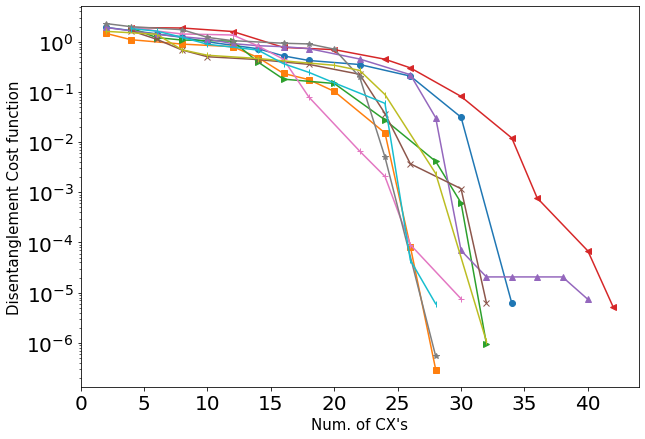

In [42]:
import matplotlib.pyplot as plt
figure,ax=plt.subplots(1,1,figsize = (10,7))
ax.set_yscale('log')
ax.set_xlabel("Num. of CX's",fontsize=15)
ax.set_ylabel('Disentanglement Cost function',fontsize=15)
#ax.set_yticks((10**1,1,10**(-1),10**(-2)))
ax.plot(CX_runs[0],Mut_runs[0],linestyle='-',marker='o')
ax.plot(CX_runs[1],Mut_runs[1],linestyle='-',marker='s')
ax.plot(CX_runs[2],Mut_runs[2],linestyle='-',marker='>')
ax.plot(CX_runs[3],Mut_runs[3],linestyle='-',marker='<')
ax.plot(CX_runs[4],Mut_runs[4],linestyle='-',marker='^')
ax.plot(CX_runs[5],Mut_runs[5],linestyle='-',marker='x')
ax.plot(CX_runs[6],Mut_runs[6],linestyle='-',marker='+')
ax.plot(CX_runs[7],Mut_runs[7],linestyle='-',marker='*')
ax.plot(CX_runs[8],Mut_runs[8],linestyle='-',marker='|')
ax.plot(CX_runs[9],Mut_runs[9],linestyle='-',marker='|')

ax.tick_params(labelsize=20)
#plt.legend(fontsize=15,loc=(0.0,0.1))
plt.savefig("disentanglement_3_qubits_Haar.png")

In [613]:
thetas=res['x']

In [614]:
thetas

array([ 1.26484765, -2.75365685,  3.08010469,  2.90491856, -2.60255955,
       -1.65937633,  1.87056743, -2.38440422, -1.49938486, -2.071538  ,
        2.87374427,  2.40737051,  2.10256757, -1.68083166,  2.18215768,
       -2.67333673, -3.0730307 , -0.93226008,  2.41539493, -0.00667503])

In [619]:
MutInfLandscape([0]*len(thetas))

array([[0.        , 0.17247791, 0.05840182, 0.36994528],
       [0.        , 0.        , 0.34998222, 0.29738941],
       [0.        , 0.        , 0.        , 0.19296636],
       [0.        , 0.        , 0.        , 0.        ]])